# Exploratory Data Analysis

In [13]:
install.packages("pastecs")
install.packages("RSQLite")
install.packages("DBI")
install.packages("dplyr")
install.packages("ggplot2")


Warning message:
"package 'pastecs' is in use and will not be installed"
Warning message:
"package 'RSQLite' is in use and will not be installed"
Warning message:
"package 'DBI' is in use and will not be installed"


package 'dplyr' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'dplyr'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\dannyvaks\.conda\envs\notebook\Lib\R\library\00LOCK\dplyr\libs\x64\dplyr.dll to C:\Users\dannyvaks\.conda\envs\notebook\Lib\R\library\dplyr\libs\x64\dplyr.dll: Permission denied"
Warning message:
"restored 'dplyr'"



The downloaded binary packages are in
	C:\Users\dannyvaks\AppData\Local\Temp\RtmpOmSO0v\downloaded_packages
package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\dannyvaks\AppData\Local\Temp\RtmpOmSO0v\downloaded_packages


In [110]:
if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}
if (!require("gridExtra")) install.packages("gridExtra")
if (!require("car")) install.packages("car")

Loading required package: car

Warning message:
"package 'car' was built under R version 3.6.2"
Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode




In [58]:
outlierMatrix <- function(data,threshold=1.5) {
    vn <- setdiff(names(data),"movie_id")
    outdata <- data.frame(movie_id=data$movie_id)
    for(v in vn) {
        if(is.numeric(data[[v]])) {
            med <- median (data[[v]],na.rm=TRUE)
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[paste0(v,"_out")] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}


missingMatrix <- function(data) {
    vn <- setdiff(names(data),"movie_id")
    missdata <- data.frame(movie_id=data$movie_id)
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[paste0(v,"_miss")] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}

minmax <- function(x) {
    return(((x-min(x,na.rm=T))/(max(x,na.rm=T)-min(x,na.rm=T))))
}

getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [3]:
library(pastecs)

Warning message:
"package 'pastecs' was built under R version 3.6.2"


In [4]:
library(mechkar)


Attaching package: 'mechkar'


The following object is masked _by_ '.GlobalEnv':

    getMissingness




In [5]:
install.packages("lubridate")
library(lubridate)

package 'lubridate' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\dannyvaks\AppData\Local\Temp\RtmpOmSO0v\downloaded_packages


Warning message:
"package 'lubridate' was built under R version 3.6.2"

Attaching package: 'lubridate'


The following object is masked from 'package:base':

    date




In [16]:
library(DBI)
library(RSQLite)
options(repr.plot.width = 15, repr.plot.height = 15)



In [17]:
library(dplyr)
library(ggplot2)

Warning message:
"package 'dplyr' was built under R version 3.6.2"

Attaching package: 'dplyr'


The following objects are masked from 'package:lubridate':

    intersect, setdiff, union


The following objects are masked from 'package:pastecs':

    first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 3.6.2"


In [18]:
con <- dbConnect(odbc::odbc(), .connection_string = "DSN=BoxOffice;Trusted_Connection=yes;", timeout = 10)

In [16]:
movies_ff <- dbReadTable(con,"movies_ff_v")

In [17]:
save(movies_ff, file = "../data/BoxOffice_ff.RData")

In [7]:
load("../data/BoxOffice_ff.RData")

# Main table analysis

In [115]:
stat.desc(movies_ff)
summary(movies_ff)
sapply(movies_ff, class)

movie_id     budget       original_language popularity  
nbr.val      7.375000e+03 7.375000e+03 NA                7.375000e+03
nbr.null     0.000000e+00 2.012000e+03 NA                0.000000e+00
nbr.na       0.000000e+00 0.000000e+00 NA                0.000000e+00
min          1.000000e+00 0.000000e+00 NA                1.000000e-06
max          7.398000e+03 3.800000e+08 NA                5.474883e+02
range        7.397000e+03 3.800000e+08 NA                5.474883e+02
sum          2.727365e+07 1.671666e+11 NA                6.298085e+04
median       3.696000e+03 8.000000e+06 NA                7.455875e+00
mean         3.698122e+03 2.266666e+07 NA                8.539777e+00
SE.mean      2.488121e+01 4.306974e+05 NA                1.417873e-01
CI.mean.0.95 4.877429e+01 8.442900e+05 NA                2.779436e-01
var          4.565677e+06 1.368064e+15 NA                1.482643e+02
std.dev      2.136744e+03 3.698735e+07 NA                1.217638e+01
coef.var     5.777918e-01 1.631796e+00 NA                1.425843e+00
             release_date runtime      runtime_cat revenue      sw_lang_en  
nbr.val      NA           7.370000e+03 NA          2.993000e+03 7.375000e+03
nbr.null     NA           1.900000e+01 NA          0.000000e+00 1.039000e+03
nbr.na       NA           5.000000e+00 NA          4.382000e+03 0.000000e+00
min          NA           0.000000e+00 NA          1.000000e+00 0.000000e+00
max          NA           3.380000e+02 NA          1.519558e+09 1.000000e+00
range        NA           3.380000e+02 NA          1.519558e+09 1.000000e+00
sum          NA           7.940970e+05 NA          2.001698e+11 6.336000e+03
median       NA           1.040000e+02 NA          1.692814e+07 1.000000e+00
mean         NA           1.077472e+02 NA          6.687931e+07 8.591186e-01
SE.mean      NA           2.494232e-01 NA          2.516188e+06 4.051369e-03
CI.mean.0.95 NA           4.889409e-01 NA          4.933634e+06 7.941840e-03
var          NA           4.585021e+02 NA          1.894929e+16 1.210502e-01
std.dev      NA           2.141266e+01 NA          1.376564e+08 3.479227e-01
coef.var     NA           1.987305e-01 NA          2.058281e+00 4.049763e-01
             sw_web_presence ... depart_Camera_female depart_Crew_female
nbr.val      7.375000e+03    ... 7.341000e+03         7.341000e+03      
nbr.null     5.012000e+03    ... 7.194000e+03         6.971000e+03      
nbr.na       0.000000e+00    ... 3.400000e+01         3.400000e+01      
min          0.000000e+00    ... 0.000000e+00         0.000000e+00      
max          1.000000e+00    ... 3.000000e+00         1.000000e+01      
range        1.000000e+00    ... 3.000000e+00         1.000000e+01      
sum          2.363000e+03    ... 1.500000e+02         4.730000e+02      
median       0.000000e+00    ... 0.000000e+00         0.000000e+00      
mean         3.204068e-01    ... 2.043318e-02         6.443264e-02      
SE.mean      5.434052e-03    ... 1.695701e-03         3.916534e-03      
CI.mean.0.95 1.065229e-02    ... 3.324060e-03         7.677532e-03      
var          2.177758e-01    ... 2.110831e-02         1.126054e-01      
std.dev      4.666646e-01    ... 1.452870e-01         3.355672e-01      
coef.var     1.456475e+00    ... 7.110346e+00         5.208032e+00      
             depart_Custom_Mkup_female depart_Directing_female
nbr.val      7.341000e+03              7.341000e+03           
nbr.null     5.293000e+03              6.297000e+03           
nbr.na       3.400000e+01              3.400000e+01           
min          0.000000e+00              0.000000e+00           
max          6.000000e+00              4.000000e+00           
range        6.000000e+00              4.000000e+00           
sum          2.595000e+03              1.127000e+03           
median       0.000000e+00              0.000000e+00           
mean         3.534941e-01              1.535213e-01           
SE.mean      7.604155e-03              4.603667e-03           
CI.mean.0.95 1.49063

    movie_id        budget          original_language    popularity     
 Min.   :   1   Min.   :        0   Length:7375        Min.   :  0.000  
 1st Qu.:1848   1st Qu.:        0   Class :character   1st Qu.:  3.970  
 Median :3696   Median :  8000000   Mode  :character   Median :  7.456  
 Mean   :3698   Mean   : 22666657                      Mean   :  8.540  
 3rd Qu.:5550   3rd Qu.: 29000000                      3rd Qu.: 10.932  
 Max.   :7398   Max.   :380000000                      Max.   :547.488  
                                                                        
 release_date          runtime      runtime_cat           revenue         
 Length:7375        Min.   :  0.0   Length:7375        Min.   :1.000e+00  
 Class :character   1st Qu.: 94.0   Class :character   1st Qu.:2.405e+06  
 Mode  :character   Median :104.0   Mode  :character   Median :1.693e+07  
                    Mean   :107.7                      Mean   :6.688e+07  
                    3rd Qu.:118.0        

movie_id                       budget 
                   "integer"                    "integer" 
           original_language                   popularity 
                 "character"                    "numeric" 
                release_date                      runtime 
                 "character"                    "numeric" 
                 runtime_cat                      revenue 
                 "character"                    "integer" 
                  sw_lang_en              sw_web_presence 
                   "integer"                    "integer" 
               sw_has_poster                   sw_tagline 
                   "integer"                    "integer" 
                 keyword_cnt                 release_year 
                   "integer"                    "integer" 
               release_month           high_release_month 
                   "integer"                    "integer" 
                 release_day                  seasonality 
                   "integer"                    "integer" 
               sw_collection                producers_cnt 
                   "integer"                    "integer" 
               countries_cnt                      lang_US 
                   "integer"                    "integer" 
                     lang_FR                      lang_RU 
                   "integer"                    "integer" 
                     lang_ES                      lang_JA 
                   "integer"                    "integer" 
                keywords_cnt            actor0_movies_cnt 
                   "integer"                    "integer" 
        actor0_movies_5y_cnt            actor1_movies_cnt 
                   "integer"                    "integer" 
        actor1_movies_5y_cnt            actor2_movies_cnt 
                   "integer"                    "integer" 
        actor2_movies_5y_cnt             sw_female_actor0 
                   "integer"                    "integer" 
            sw_female_actor1             sw_female_actor2 
                   "integer"                    "integer" 
              sw_male_actor0               sw_male_actor1 
                   "integer"                    "integer" 
              sw_male_actor2          actor0_prev_revenue 
                   "integer"                    "integer" 
         actor1_prev_revenue          actor2_prev_revenue 
                   "integer"                    "integer" 
         director_movies_cnt       director_movies_5y_cnt 
                   "integer"                    "integer" 
             genre_adventure                genre_fantasy 
                   "integer"                    "integer" 
             genre_animation                  genre_drama 
                   "integer"                    "integer" 
                genre_horror                 genre_action 
                   "integer"                    "integer" 
                genre_comedy                genre_history 
                   "integer"                    "integer" 
               genre_western               genre_thriller 
                   "integer"                    "integer" 
                 genre_crime            genre_documentary 
                   "integer"                    "integer" 
       genre_science_fiction                genre_mystery 
                   "integer"                    "integer" 
                 genre_music                genre_romance 
                   "integer"                    "integer" 
                genre_family                    genre_war 
                   "integer"                    "integer" 
               genre_foreign                   depart_Art 
                   "integer"                    "integer" 
               depart_Camera                  depart_Crew 
                   "integer"                    "integer" 
          depart_Custom_Mkup             depart_Directing 
                   "integer"                    "integer" 
        

In [10]:
### frequencies of original language
table(movies_ff$original_language)



  af   ar   bm   bn   ca   cn   cs   da   de   el   en   es   fa   fi   fr   he 
   1    1    2    3    1   41    3   17   49    3 6336   95    5    3  199    6 
  hi   hu   id   is   it   ja   ka   kn   ko   ml   mr   nb   nl   no   pl   pt 
 118    4    3    1   55   90    1    1   48   12    1    1   11    5    5   13 
  ro   ru   sr   sv   ta   te   th   tr   ur   vi   xx   zh 
   8  105    3   20   31    9    5    9    2    1    2   46 

# 2.2 graph

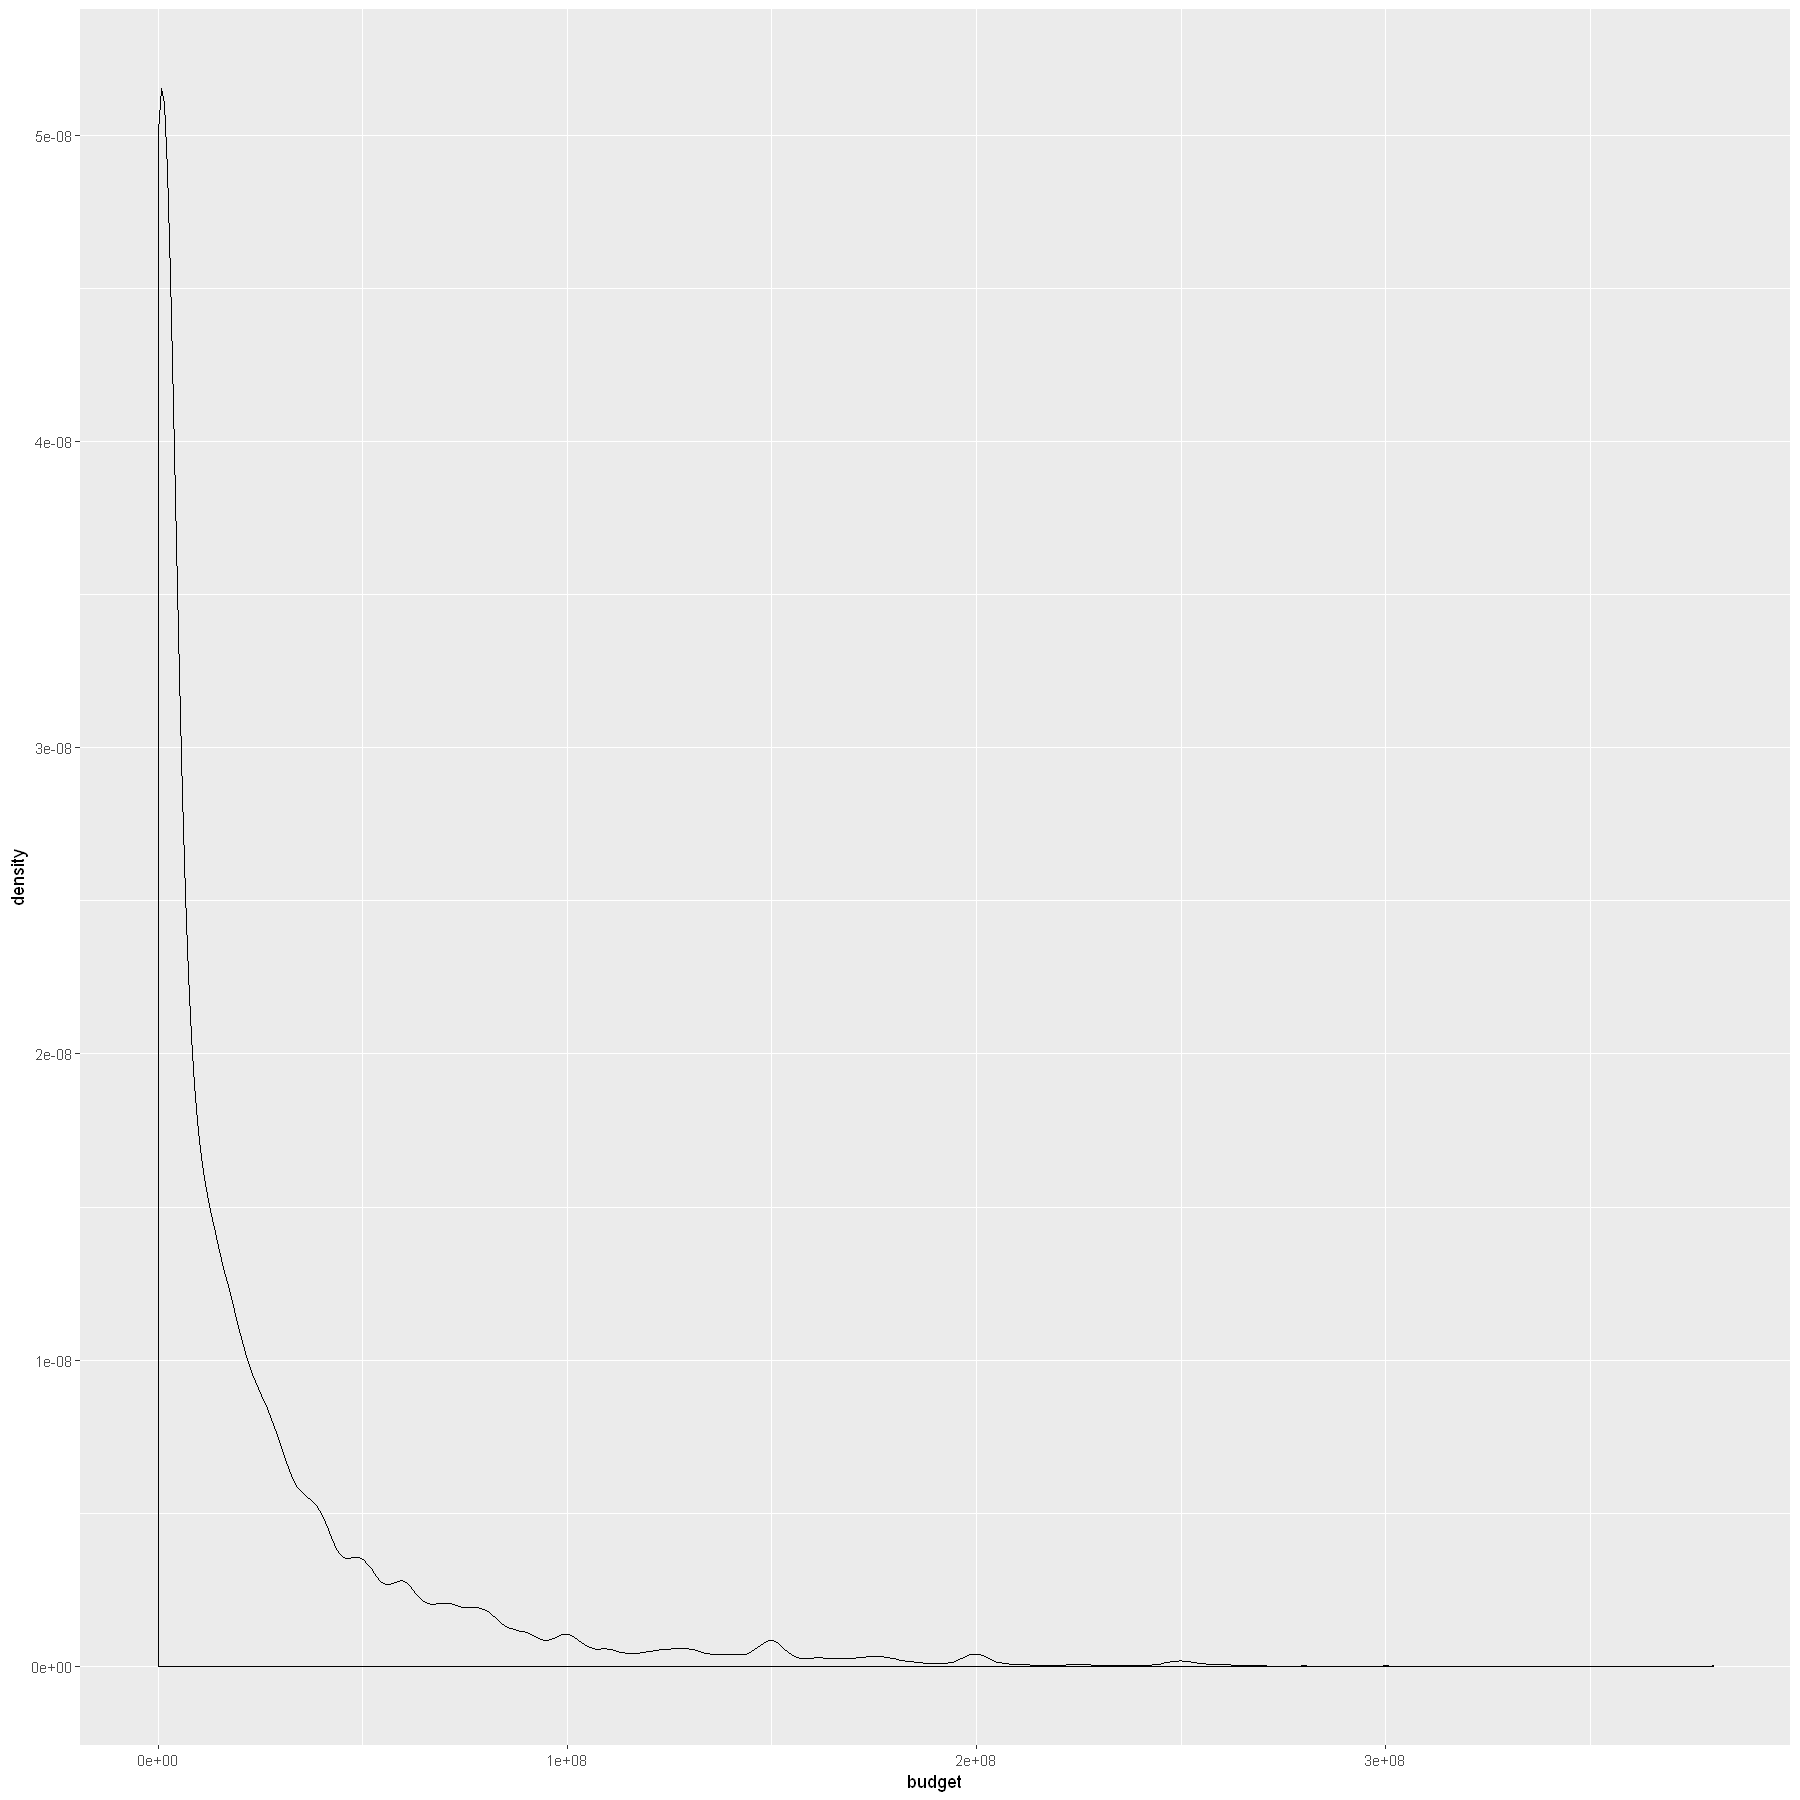

In [20]:
### budget
ggplot(data=movies_ff) +
    geom_density(aes(budget))

Warning message:
"Removed 5 rows containing non-finite values (stat_density)."


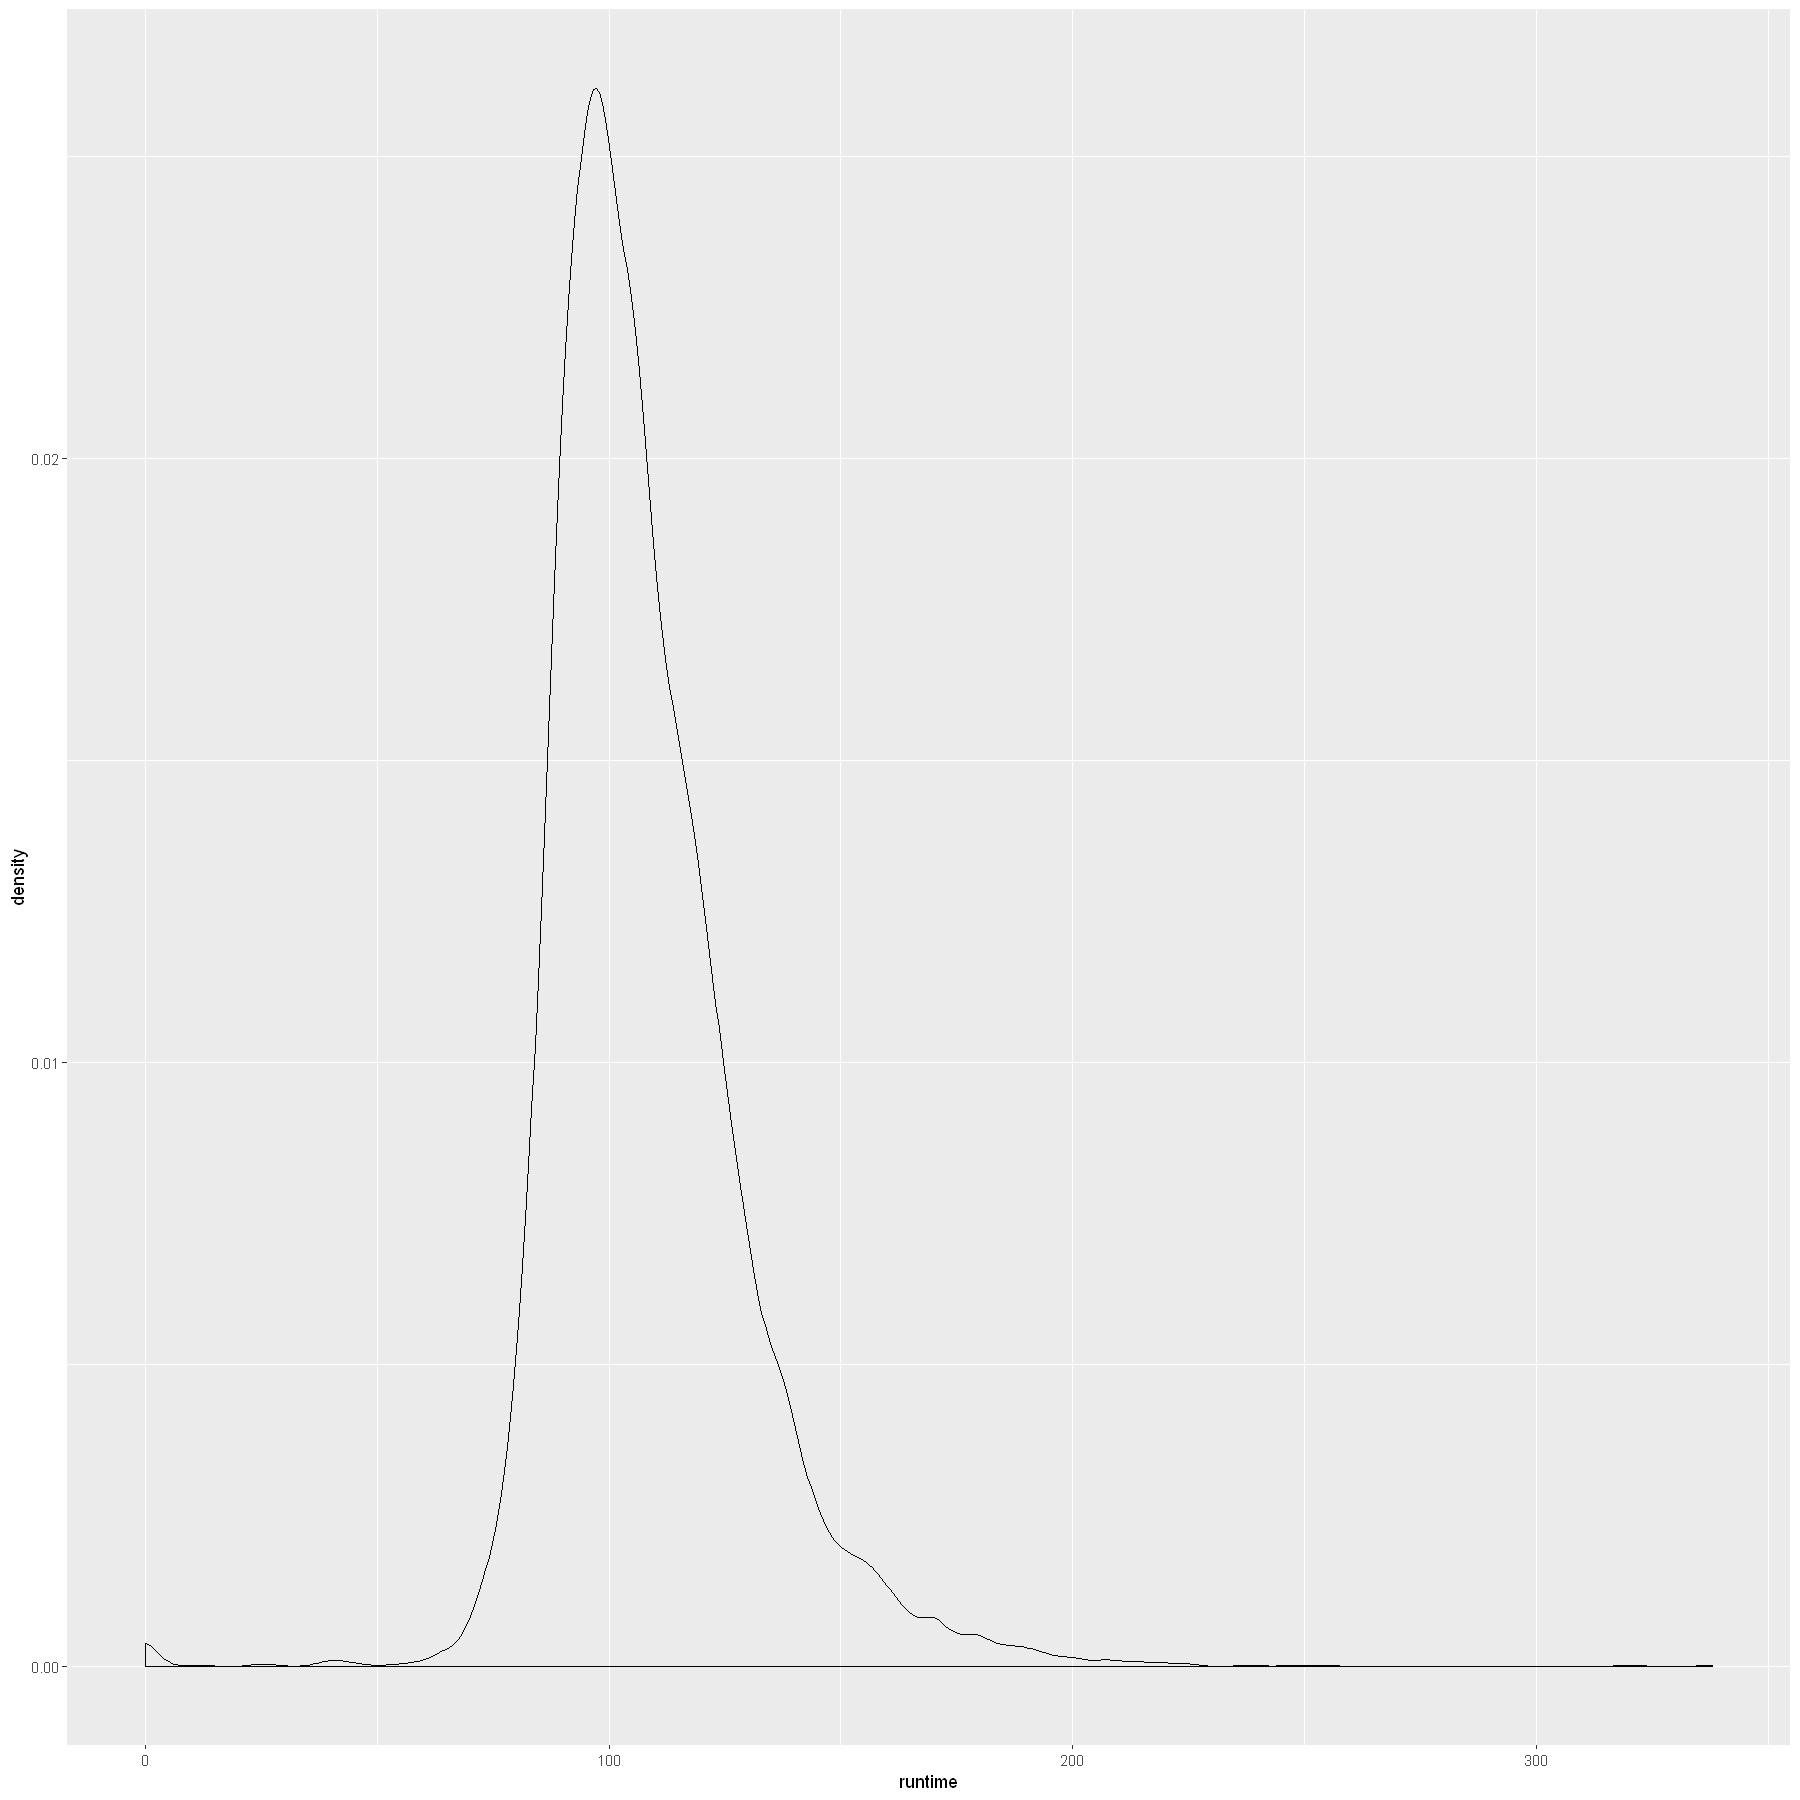

In [19]:
### runtime
ggplot(data=movies_ff) +
   geom_density(aes(x=runtime))

Selecting by n


original_language n   
1 en                6336
2 fr                 199
3 hi                 118
4 ru                 105
5 es                  95
6 ja                  90
7 it                  55

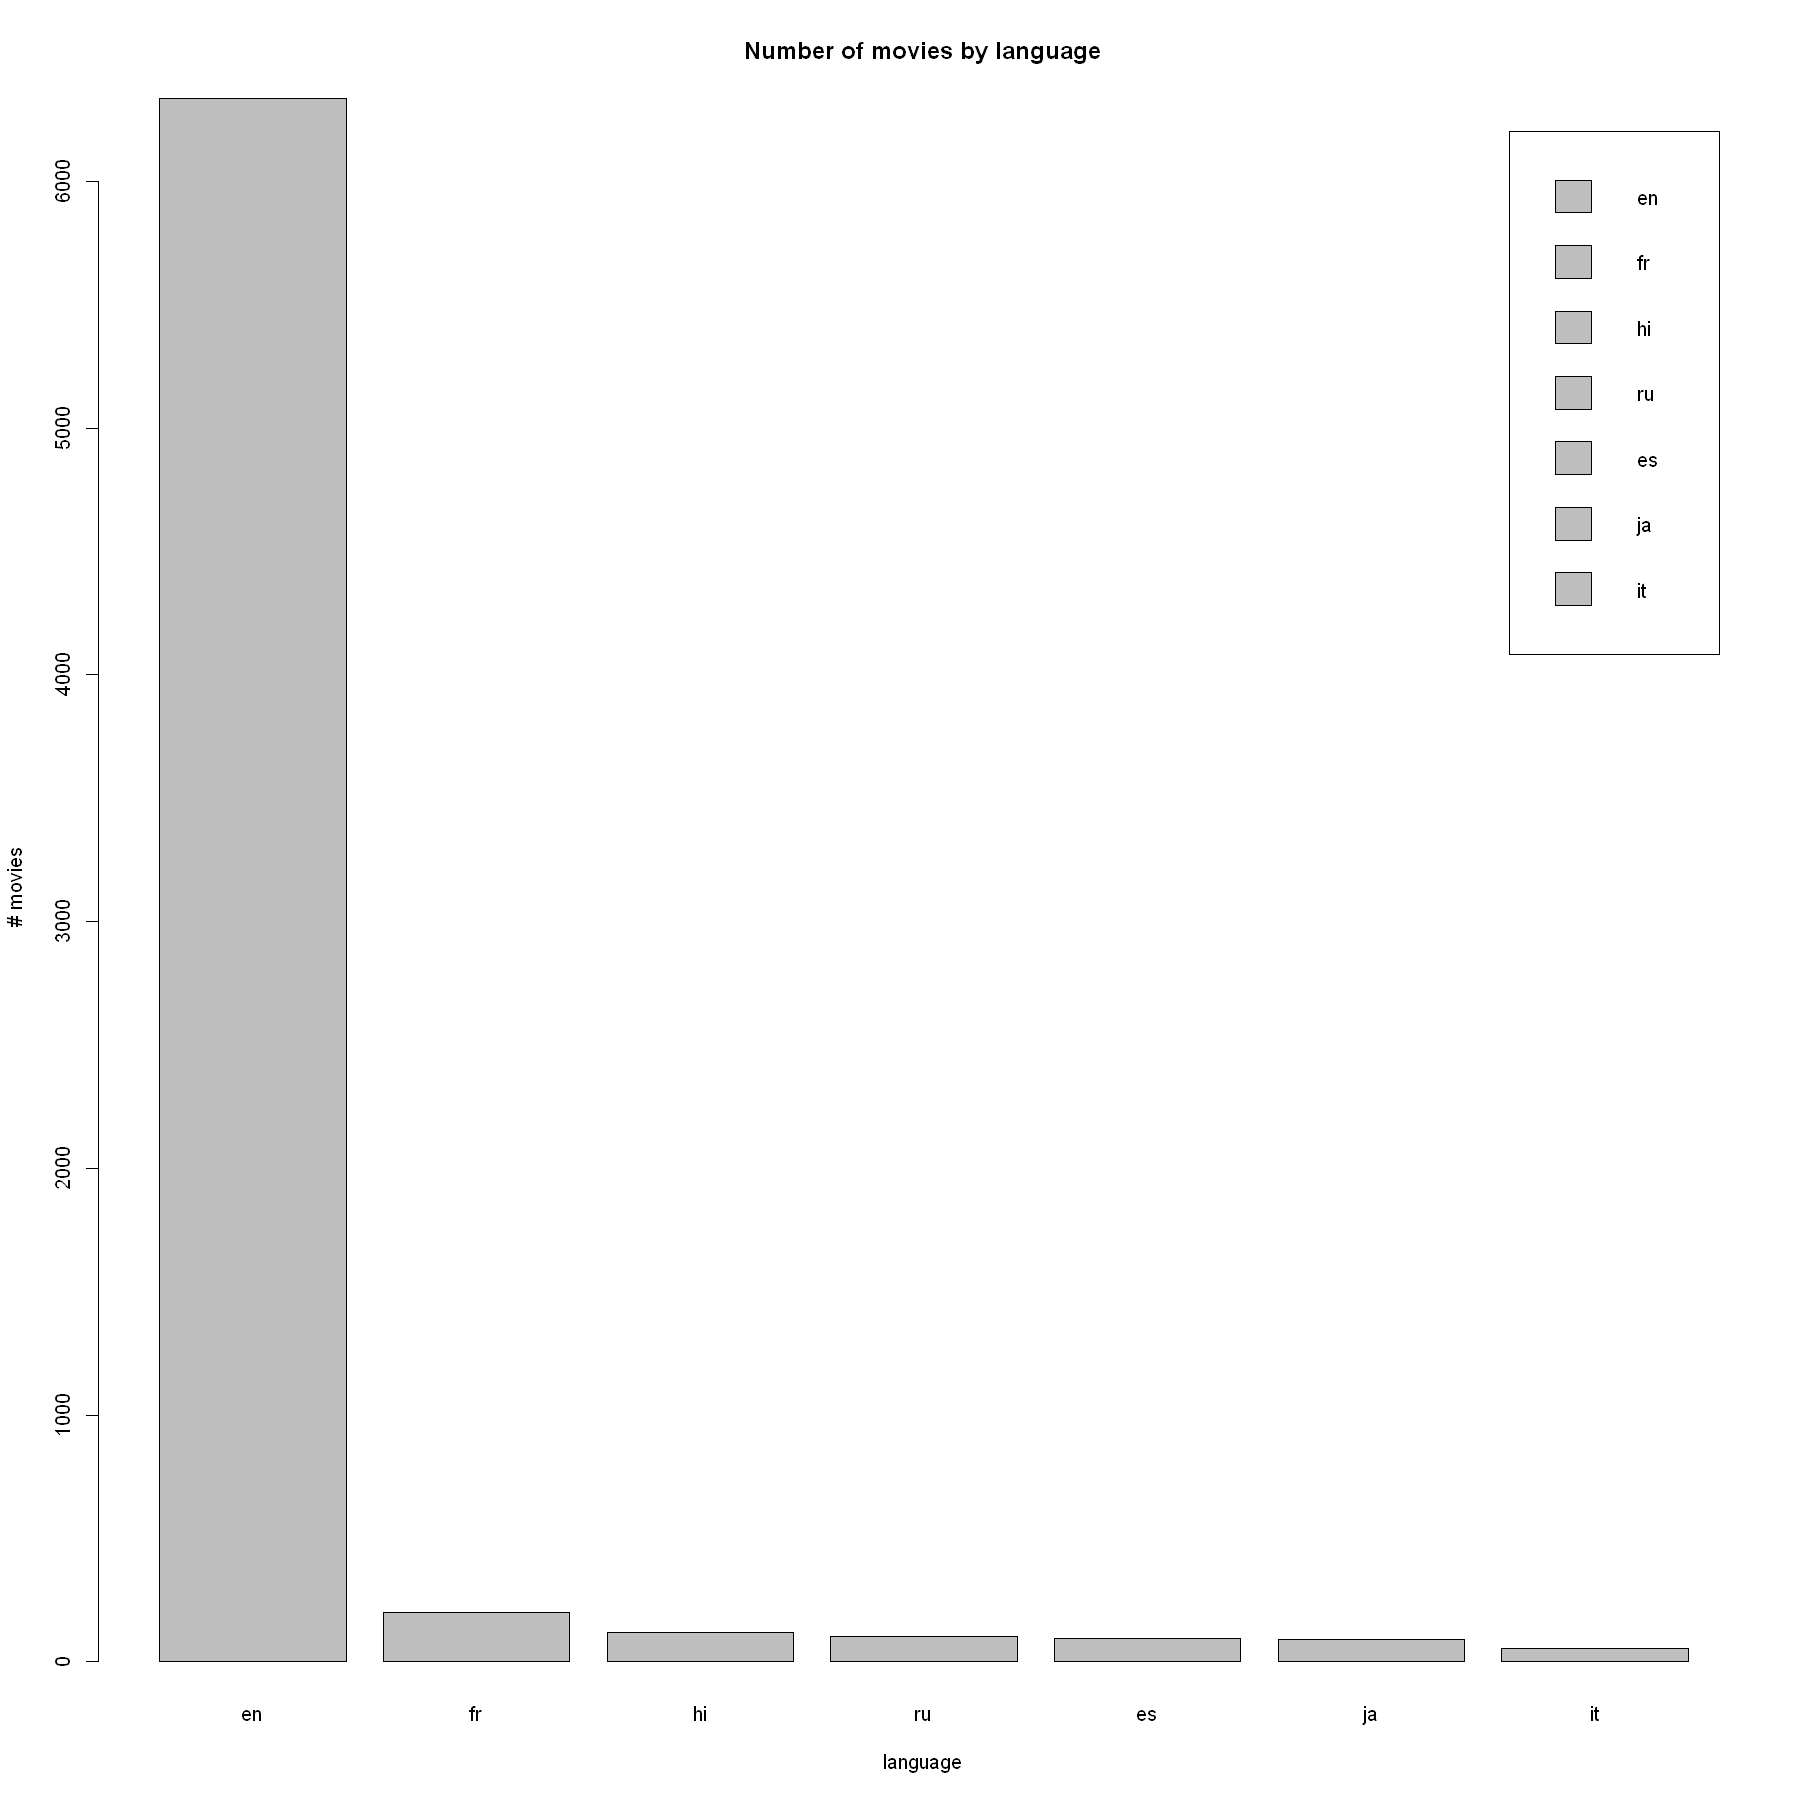

In [21]:
#language original
lang_count<- movies_ff %>% group_by(original_language) %>% summarise(n=n()) %>% arrange(desc(n)) %>% top_n(7)
lang_count
barplot(lang_count$n,main="Number of movies by language",legend.text = lang_count[[1]], names.arg = lang_count[[1]] ,xlab="language",ylab="# movies")

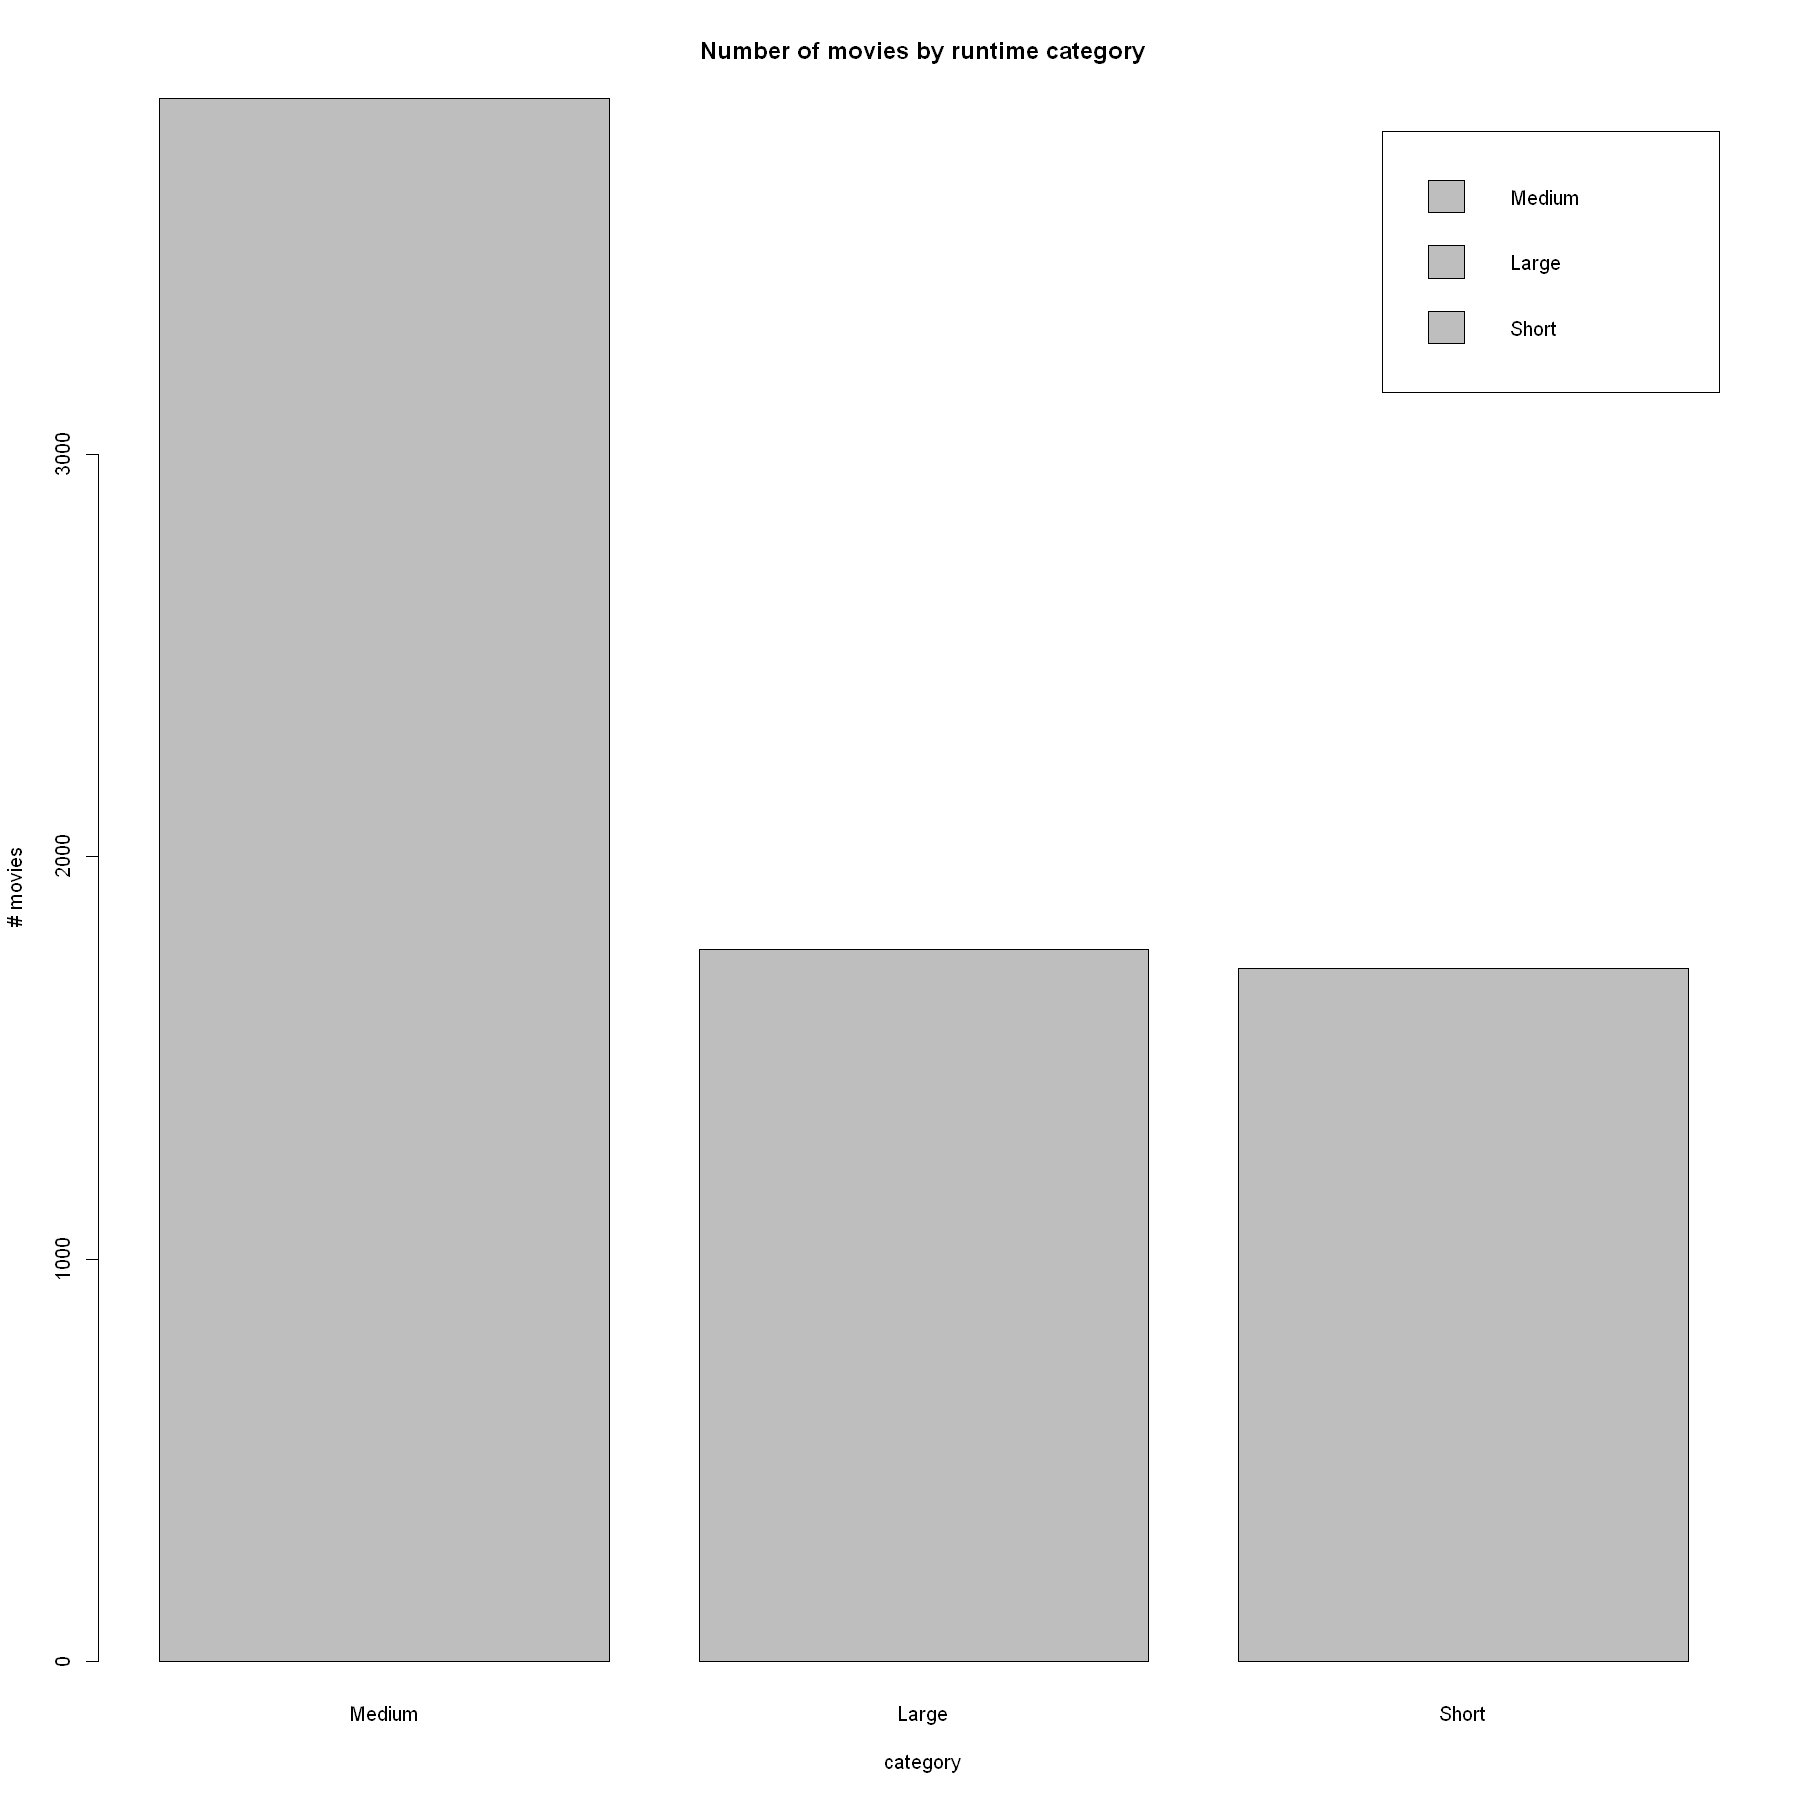

In [22]:

#runtime category
runtime_count <- movies_ff %>% group_by(runtime_cat) %>% summarise(n=n()) %>% arrange(desc(n))
barplot(runtime_count$n,main="Number of movies by runtime category",legend.text = runtime_count[[1]], names.arg = runtime_count[[1]] ,xlab="category",ylab="# movies")

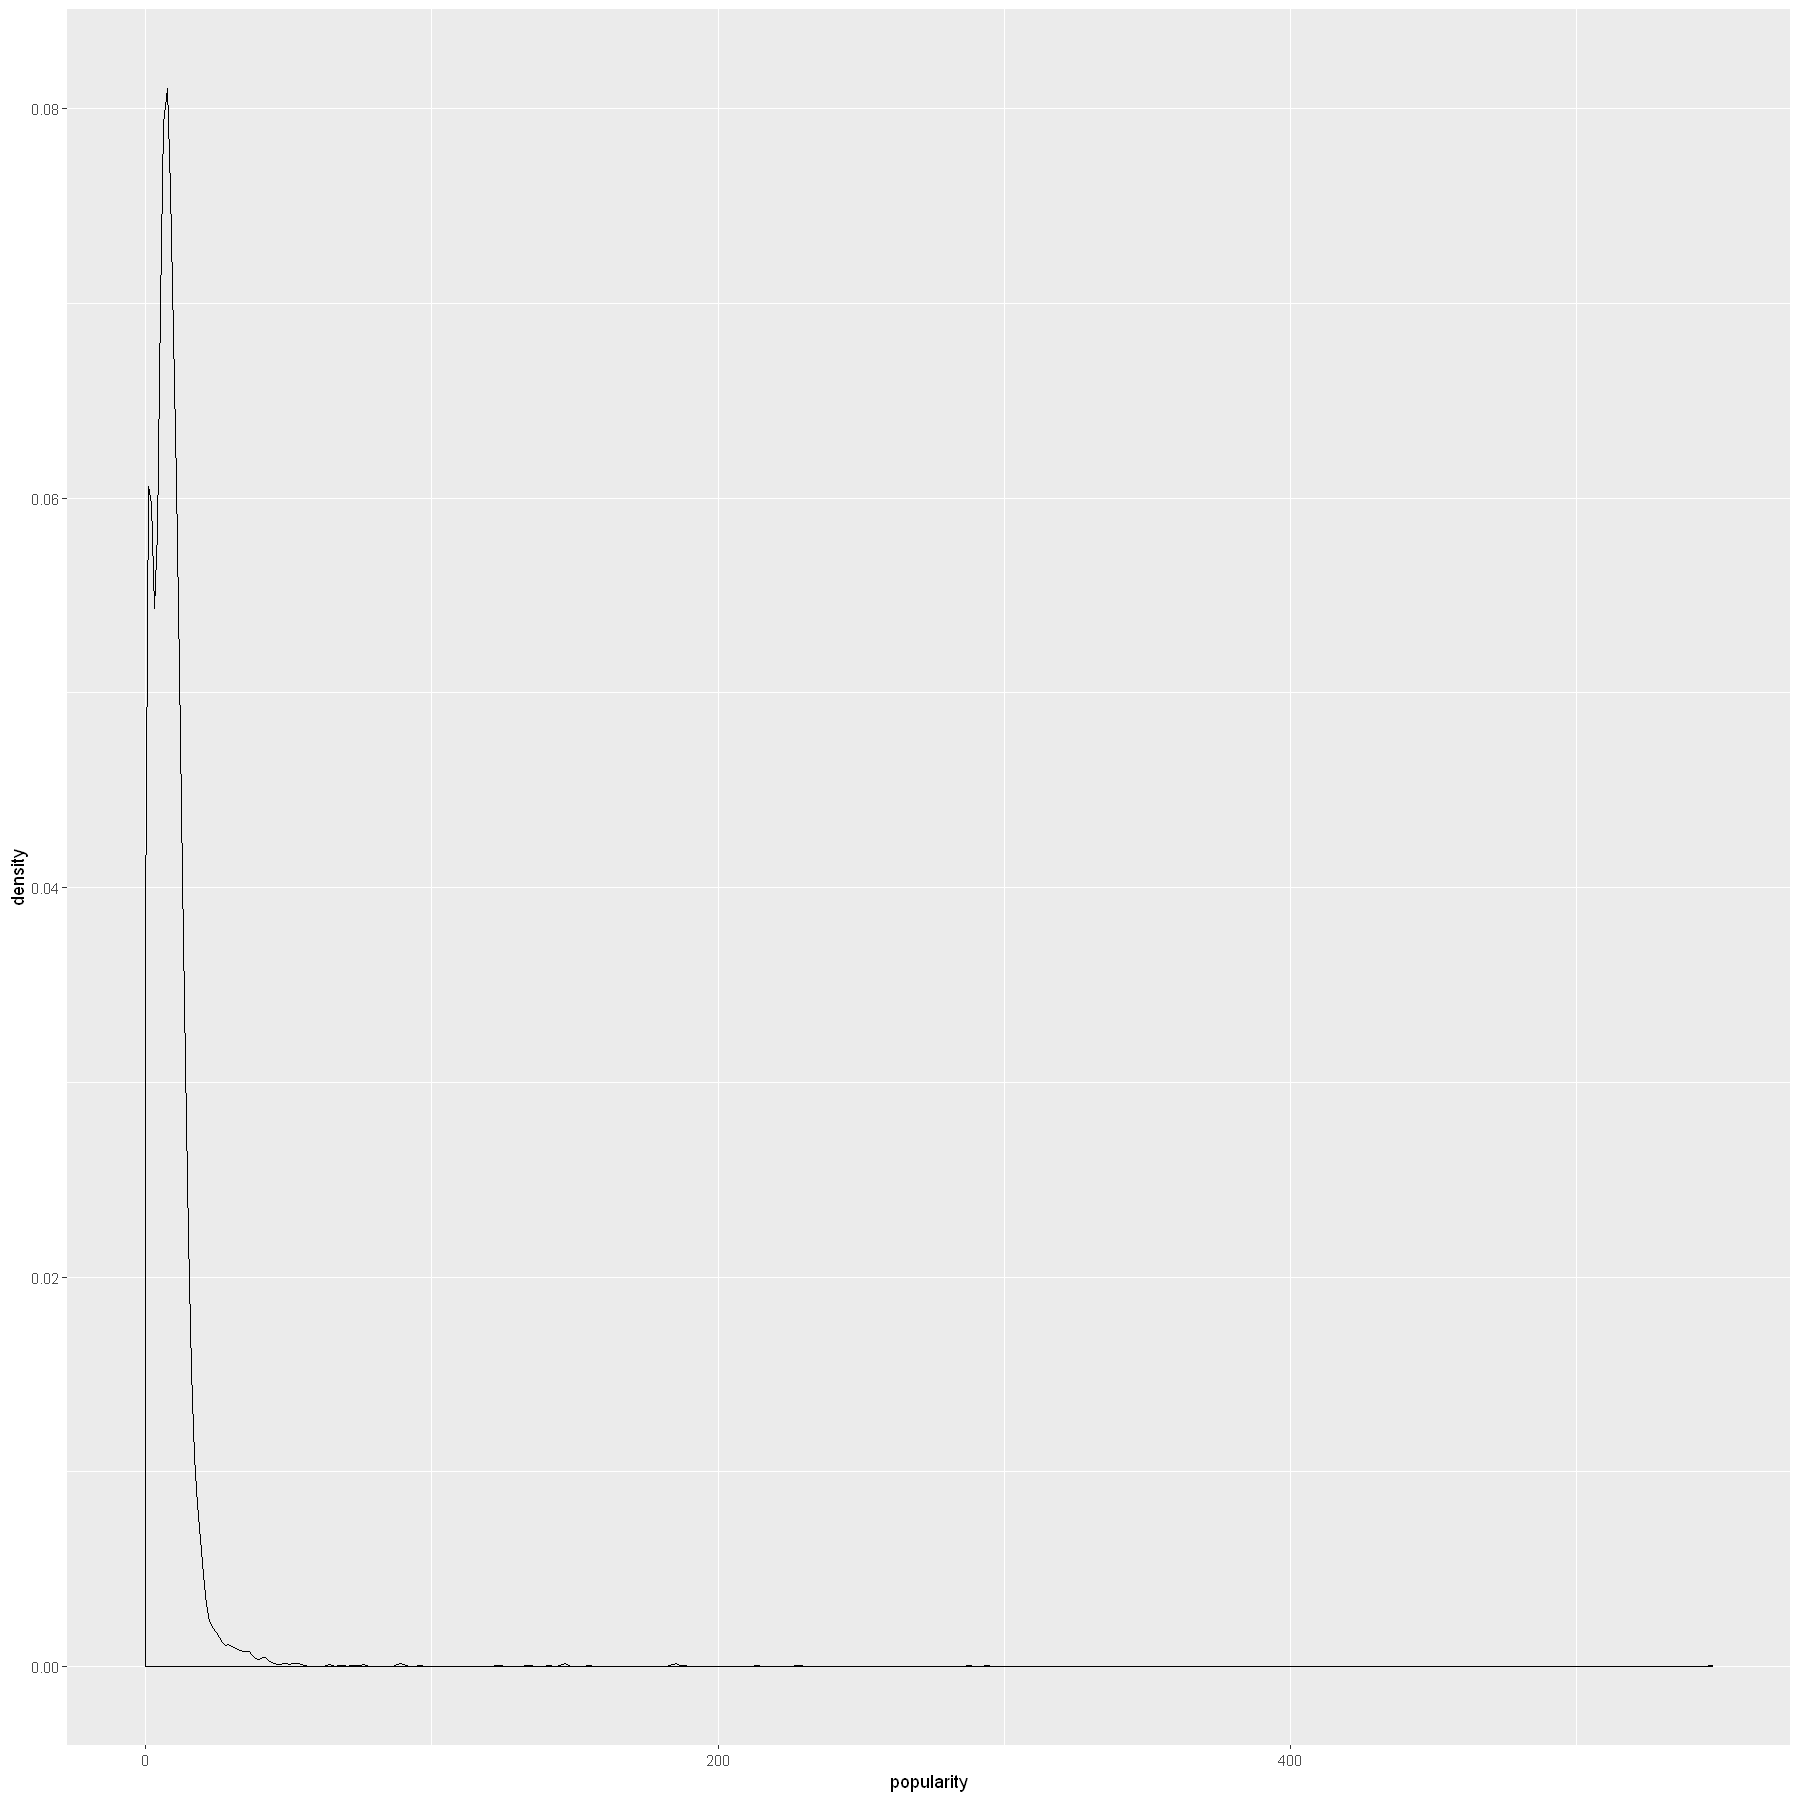

In [23]:
### popularity
ggplot(data=movies_ff) +
    geom_density(aes(popularity))


1918 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 
   1    1    1    1    1    6    2    3    5    1    2    4    3    6    3    5 
1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 
   6    2    3    6    5    6    6    2    7    6    4    2    9    5    6    9 
1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 
   7   11   14   10   13    7    8   10   14   16   15   15   14   12   15   24 
1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 
  23   15   23   20   16   23   19   25   22   29   43   40   59   65   67   79 
1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 
  78   94  102  112  132  102  104  116  116  138  123  134  138  158  152  158 
2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 
 155  175  197  178  208  234  280  257  265  284  304  311  304  334  319  312 
2016 2017 
 300   98 

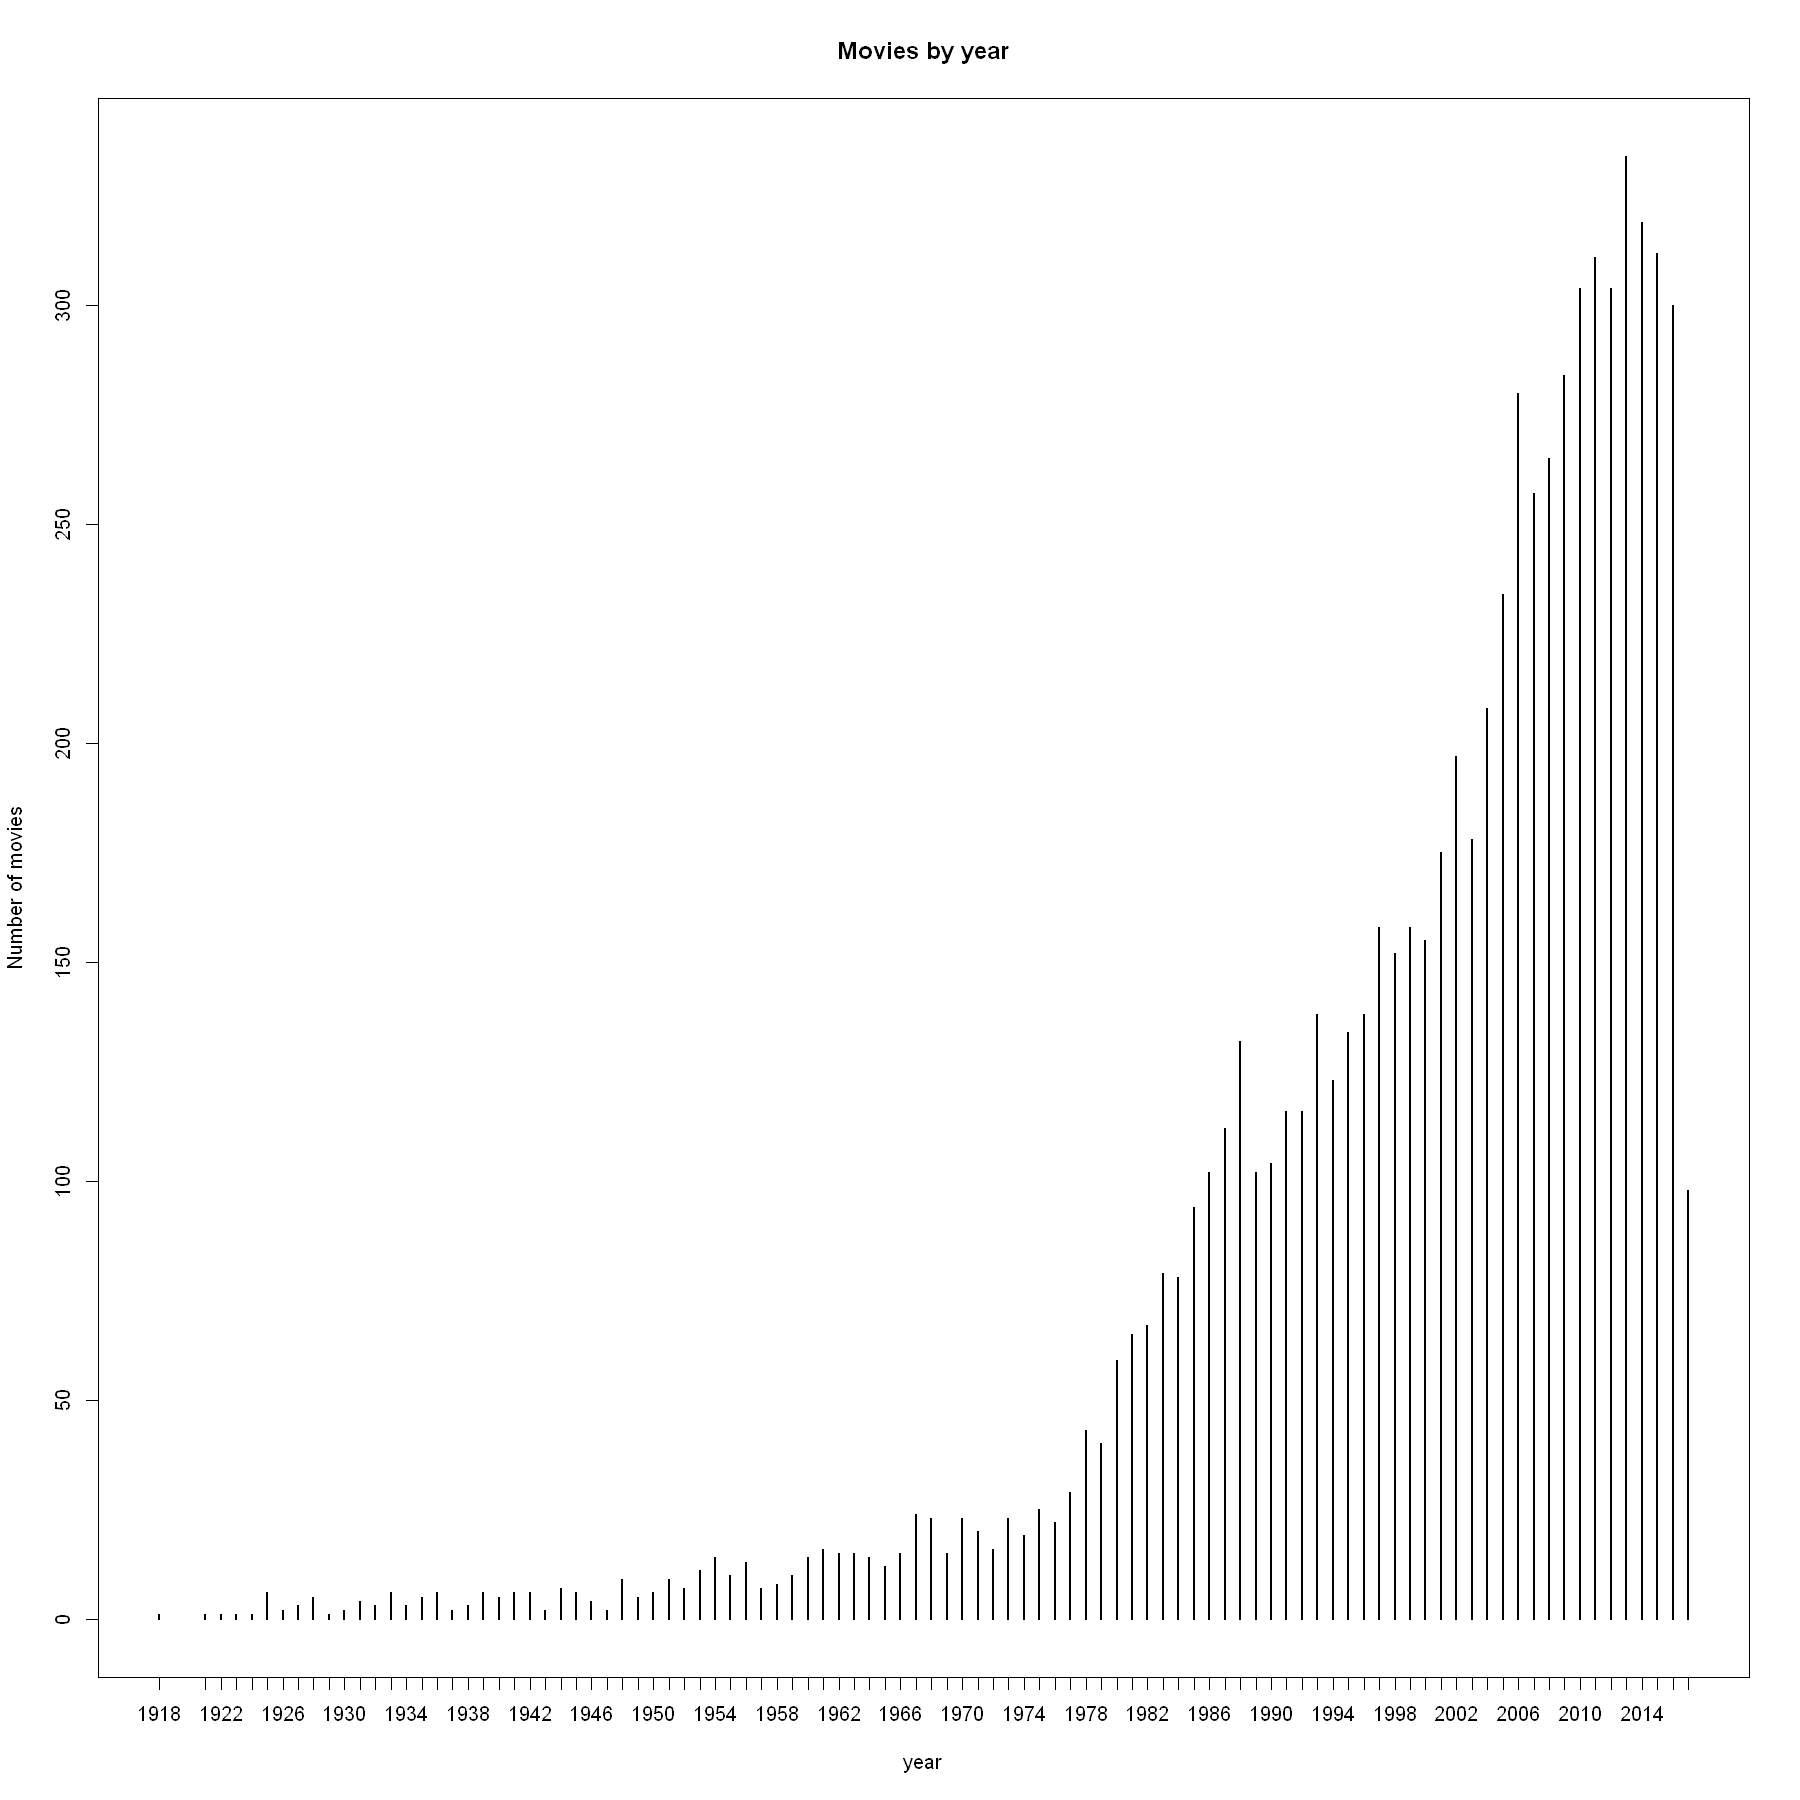

In [18]:
#release date
table(year(movies_ff$release_date))
plot(table(year(movies_ff$release_date)),ylab="Number of movies",xlab="year",main="Movies by year")

In [24]:
movies_ff %>% group_by(sw_lang_en) %>% summarise(n=n())
movies_ff %>% group_by(sw_web_presence) %>% summarise(n=n())
movies_ff %>% group_by(sw_has_poster) %>% summarise(n=n())
movies_ff %>% group_by(sw_tagline) %>% summarise(n=n())
movies_ff %>% group_by(high_release_month) %>% summarise(n=n())


sw_lang_en n   
1 0          1039
2 1          6336

sw_web_presence n   
1 0               5012
2 1               2363

sw_has_poster n   
1 0                2
2 1             7373

sw_tagline n   
1 0          1442
2 1          5933

high_release_month n   
1 0                  4427
2 1                  2948


  1   2   3   4   5   6   7   8   9  10  11  12 
510 518 561 557 582 594 564 657 902 695 540 694 

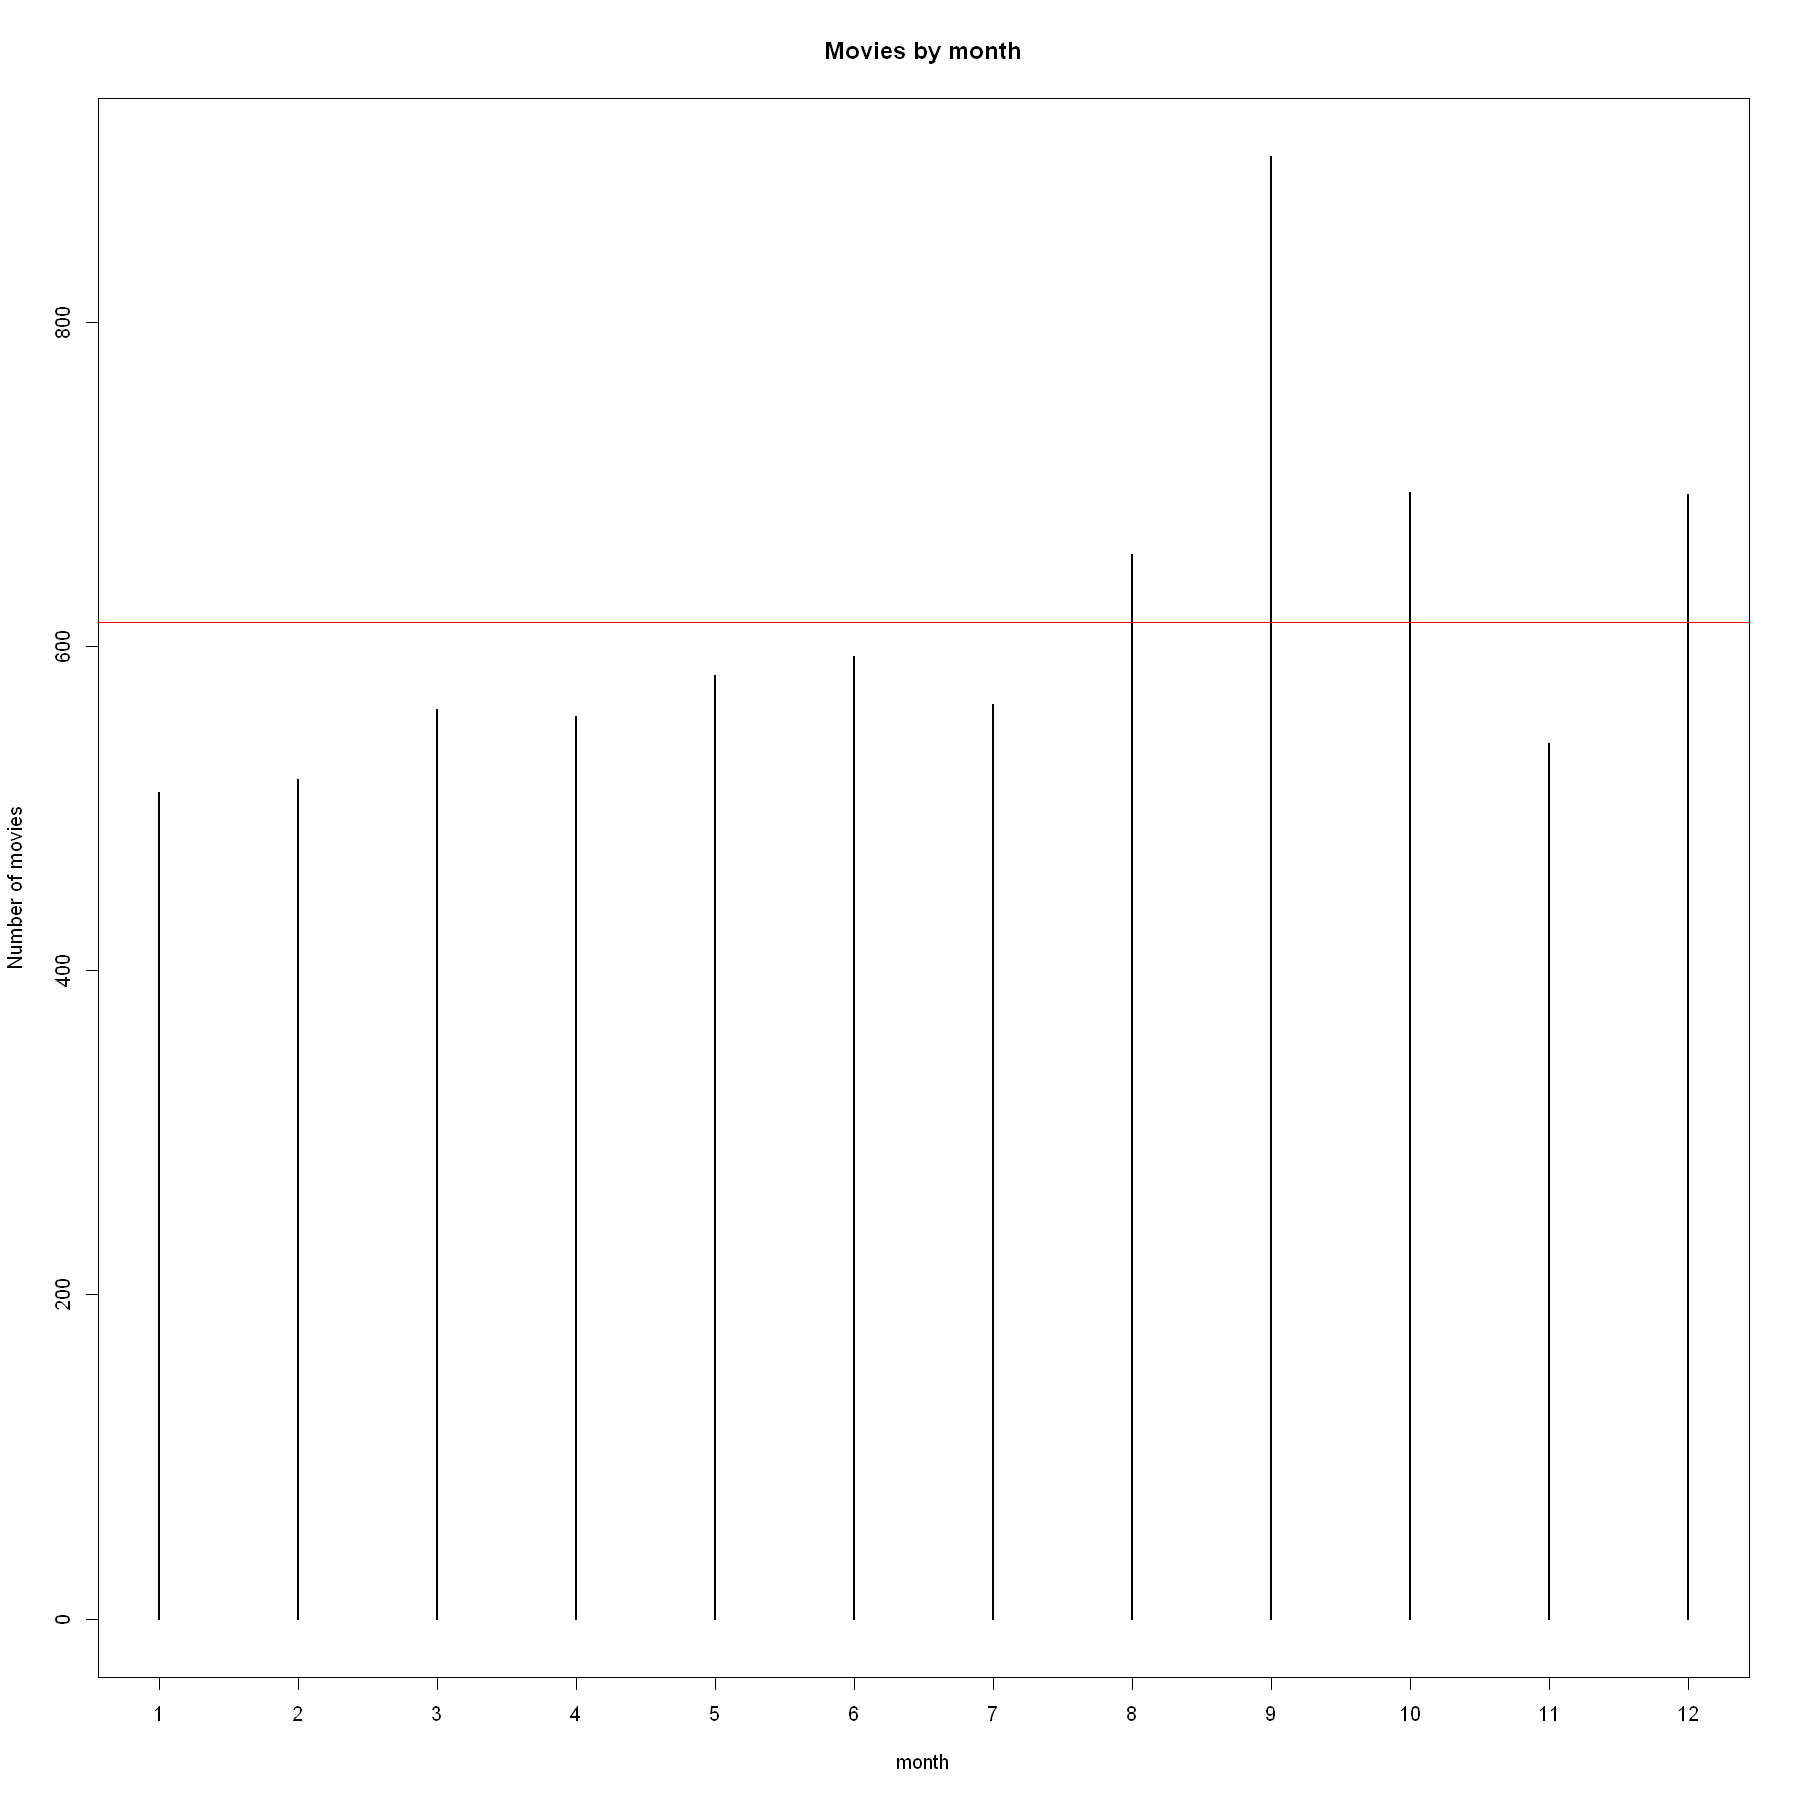

In [25]:
table(month(movies_ff$release_date))
plot(table(month(movies_ff$release_date)), ylab="Number of movies",xlab="month",main="Movies by month")
abline(h=mean(table(month(movies_ff$release_date)),na.rm=T),col="red")

[1] 7.264949

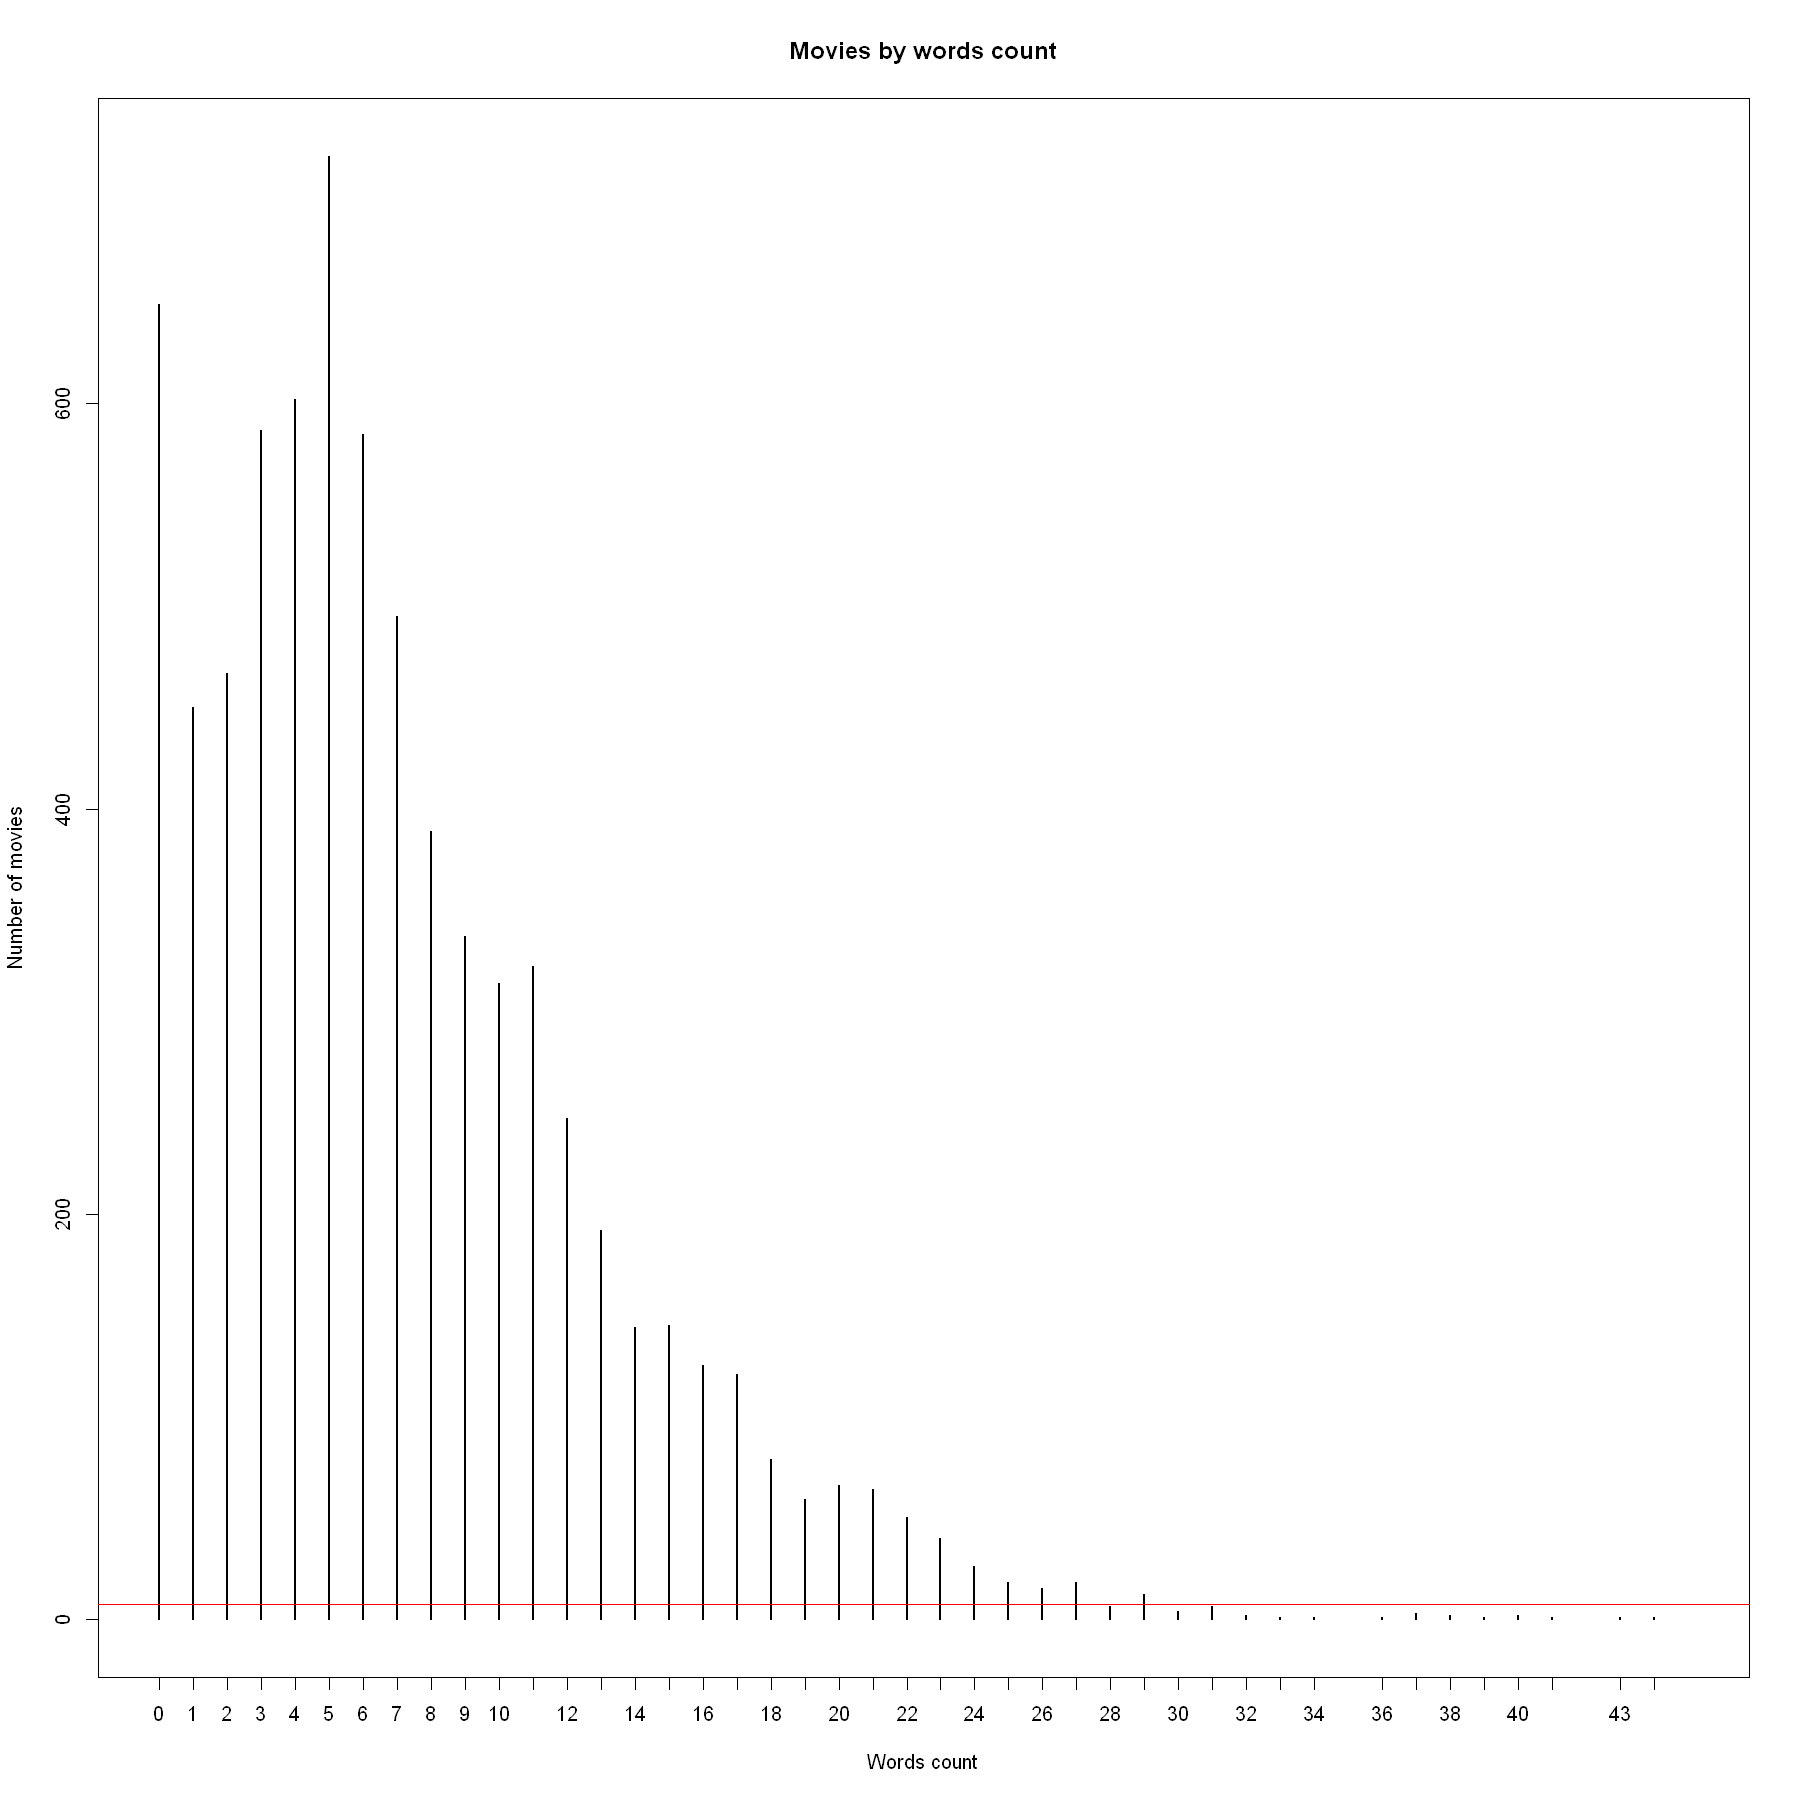

In [26]:
plot(table(movies_ff$keyword_cnt),ylab="Number of movies",xlab="Words count",main="Movies by words count",xlim=c(0,45))
abline(h=mean(movies_ff$keyword_cnt),col="red")
mean(movies_ff$keyword_cnt)

In [27]:
### differences between the average revenue by language?
movies_ff %>% 
    group_by(original_language) %>% 
    summarise(revenue_avg=mean(revenue,na.rm=T), revenue_sd=sd(revenue,na.rm=T),n=n()) %>% 
    arrange(desc(n))

original_language revenue_avg revenue_sd  n   
1  en                74781023.5  146000315.8 6336
2  fr                17132565.7   51746646.0  199
3  hi                25346368.7   49616798.9  118
4  ru                 7227709.7   12086653.5  105
5  es                 8564790.2   13620381.7   95
6  ja                30651798.8   32415933.6   90
7  it                16927302.3   47183421.9   55
8  de                20530900.6   30979114.7   49
9  ko                13776704.3   21344783.6   48
10 zh                70376369.2  104571399.8   46
11 cn                29772885.2   41340952.2   41
12 ta                14706250.2   17492454.2   31
13 sv                11630510.9   22663781.3   20
14 da                11757093.4   17389413.6   17
15 pt                10879024.2   22543220.5   13
16 ml                 1315000.0    1675843.1   12
17 nl                 1959667.0    1997239.0   11
18 te                 8320425.0    8032132.0    9
19 tr                51663408.3   84787329.0    9
20 ro                  339961.0     564975.7    8
21 he                11125849.0           NA    6
22 fa                  712185.2    1008690.8    5
23 no                 1011067.5    1376870.5    5
24 pl                15010834.0     406616.1    5
25 th                       NaN           NA    5
26 hu                  124792.7     137994.2    4
27 bn                  536364.0           NA    3
28 cs                   17393.0           NA    3
29 el                 8000000.0           NA    3
30 fi                 1471931.5    1328883.5    3
31 id                 2627209.0           NA    3
32 sr                     198.0           NA    3
33 bm                       NaN           NA    2
34 ur                  645135.0           NA    2
35 xx                       NaN           NA    2
36 af                       NaN           NA    1
37 ar                 1347747.0           NA    1
38 ca                       NaN           NA    1
39 is                       NaN           NA    1
40 ka                       NaN           NA    1
41 kn                       NaN           NA    1
42 mr                 4400000.0           NA    1
43 nb                 4159678.0           NA    1
44 vi                  639000.0           NA    1

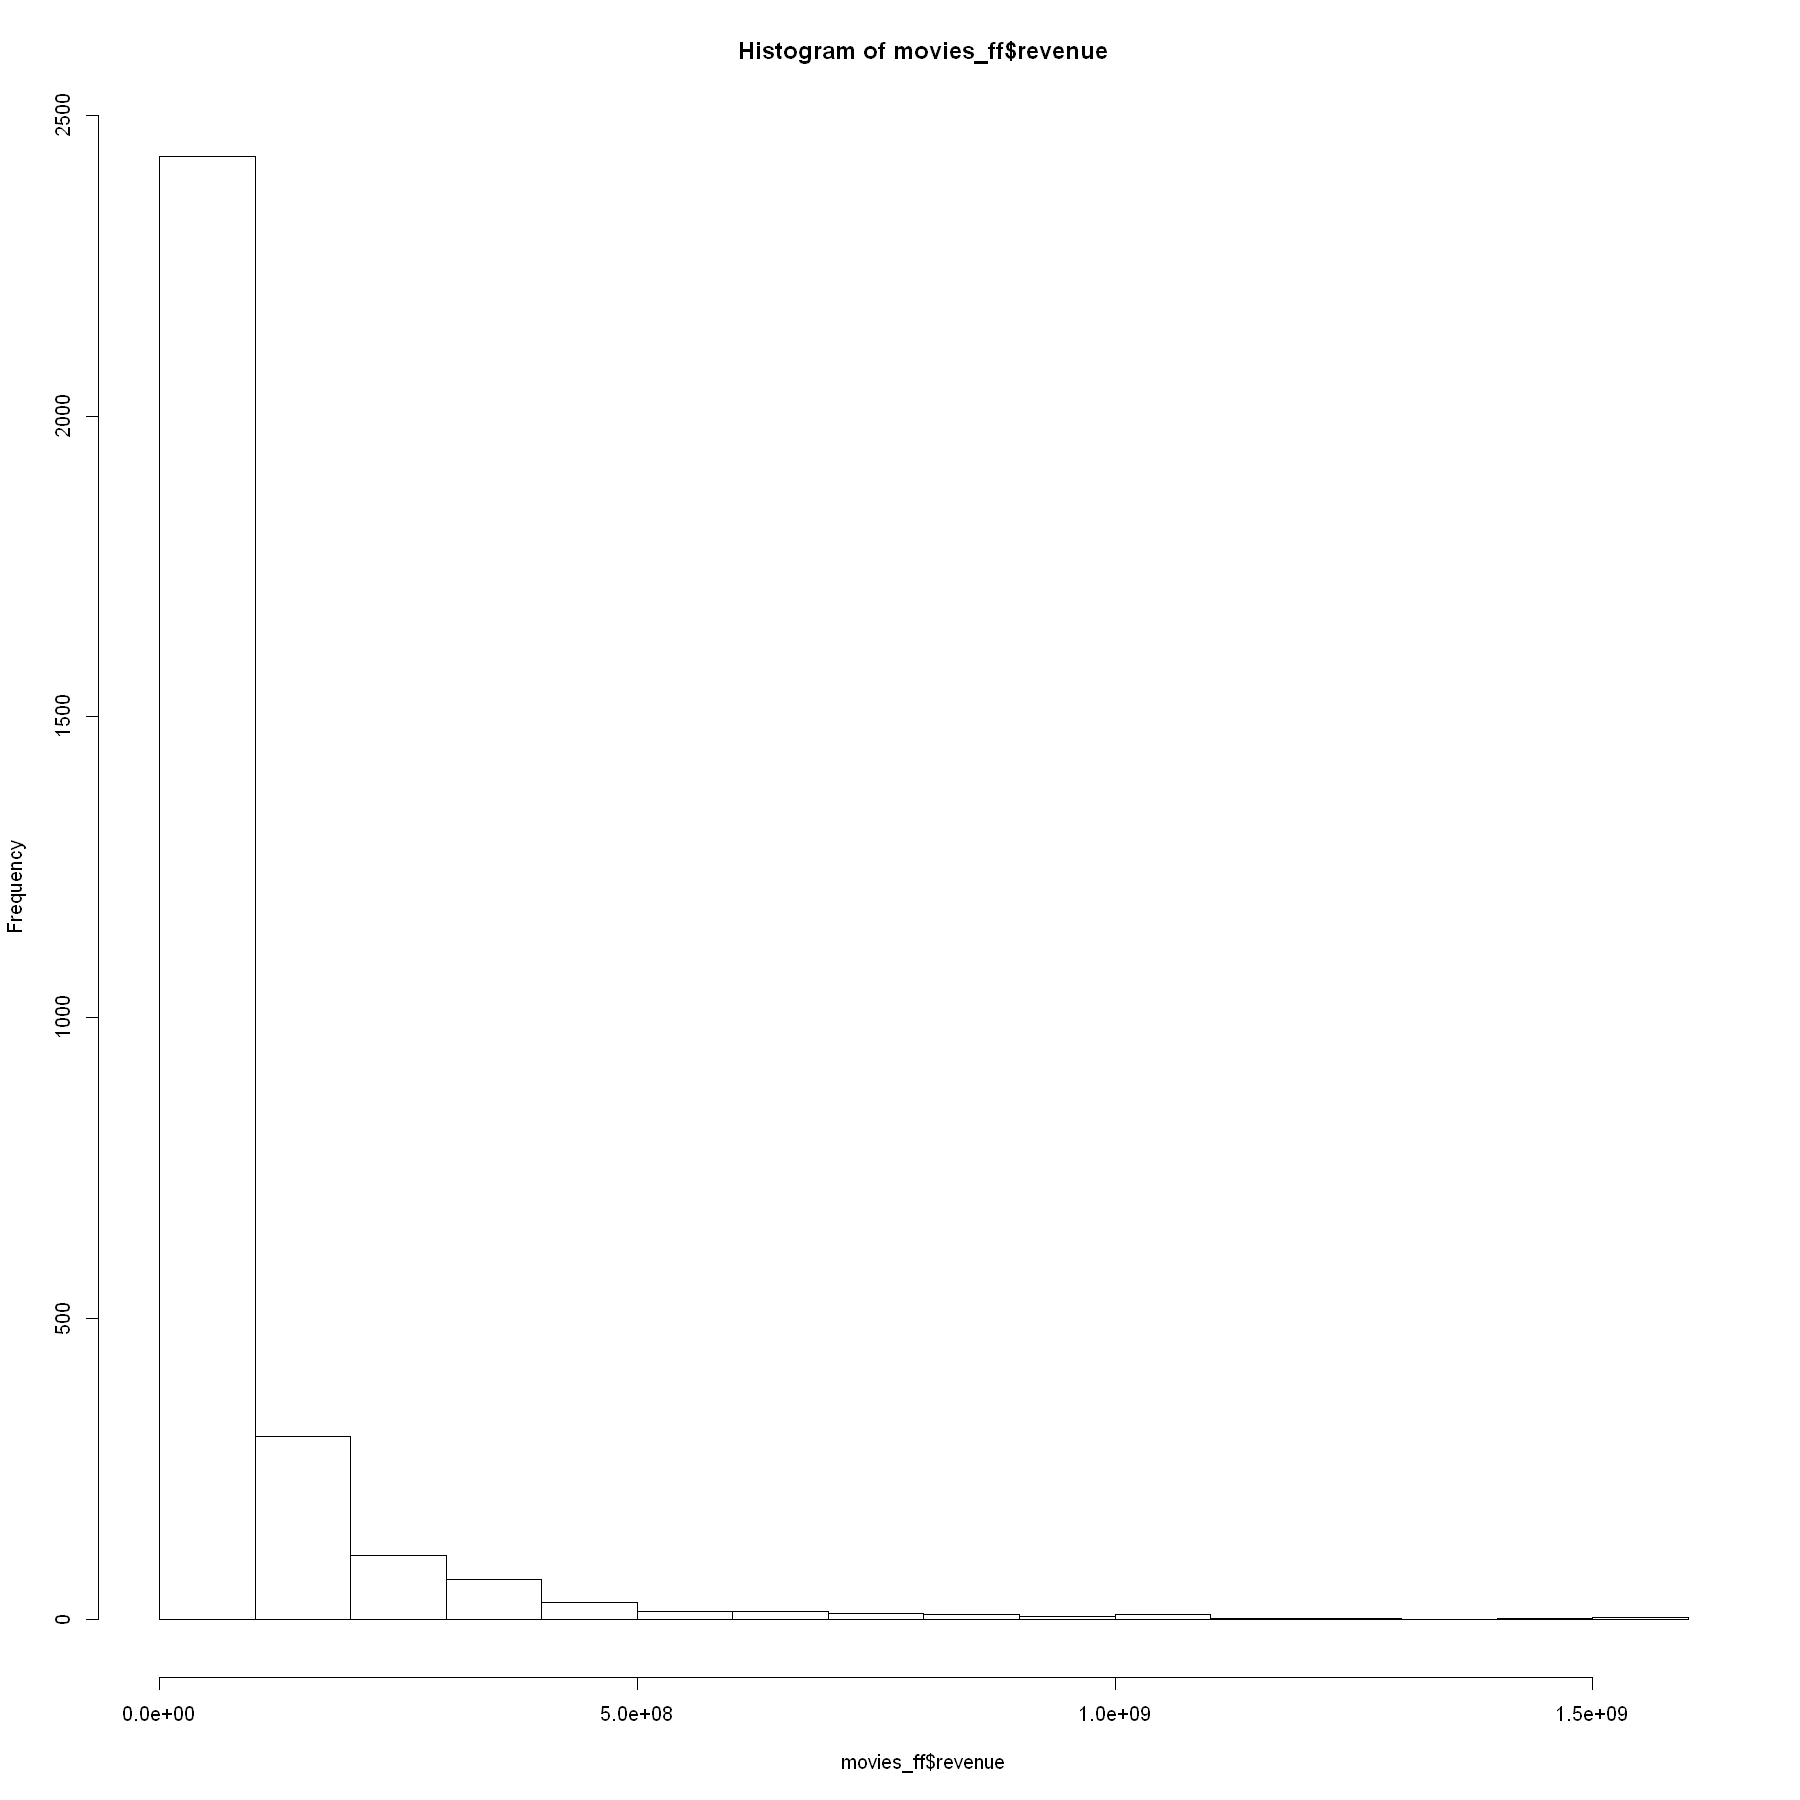

In [28]:
hist(movies_ff$revenue)

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."


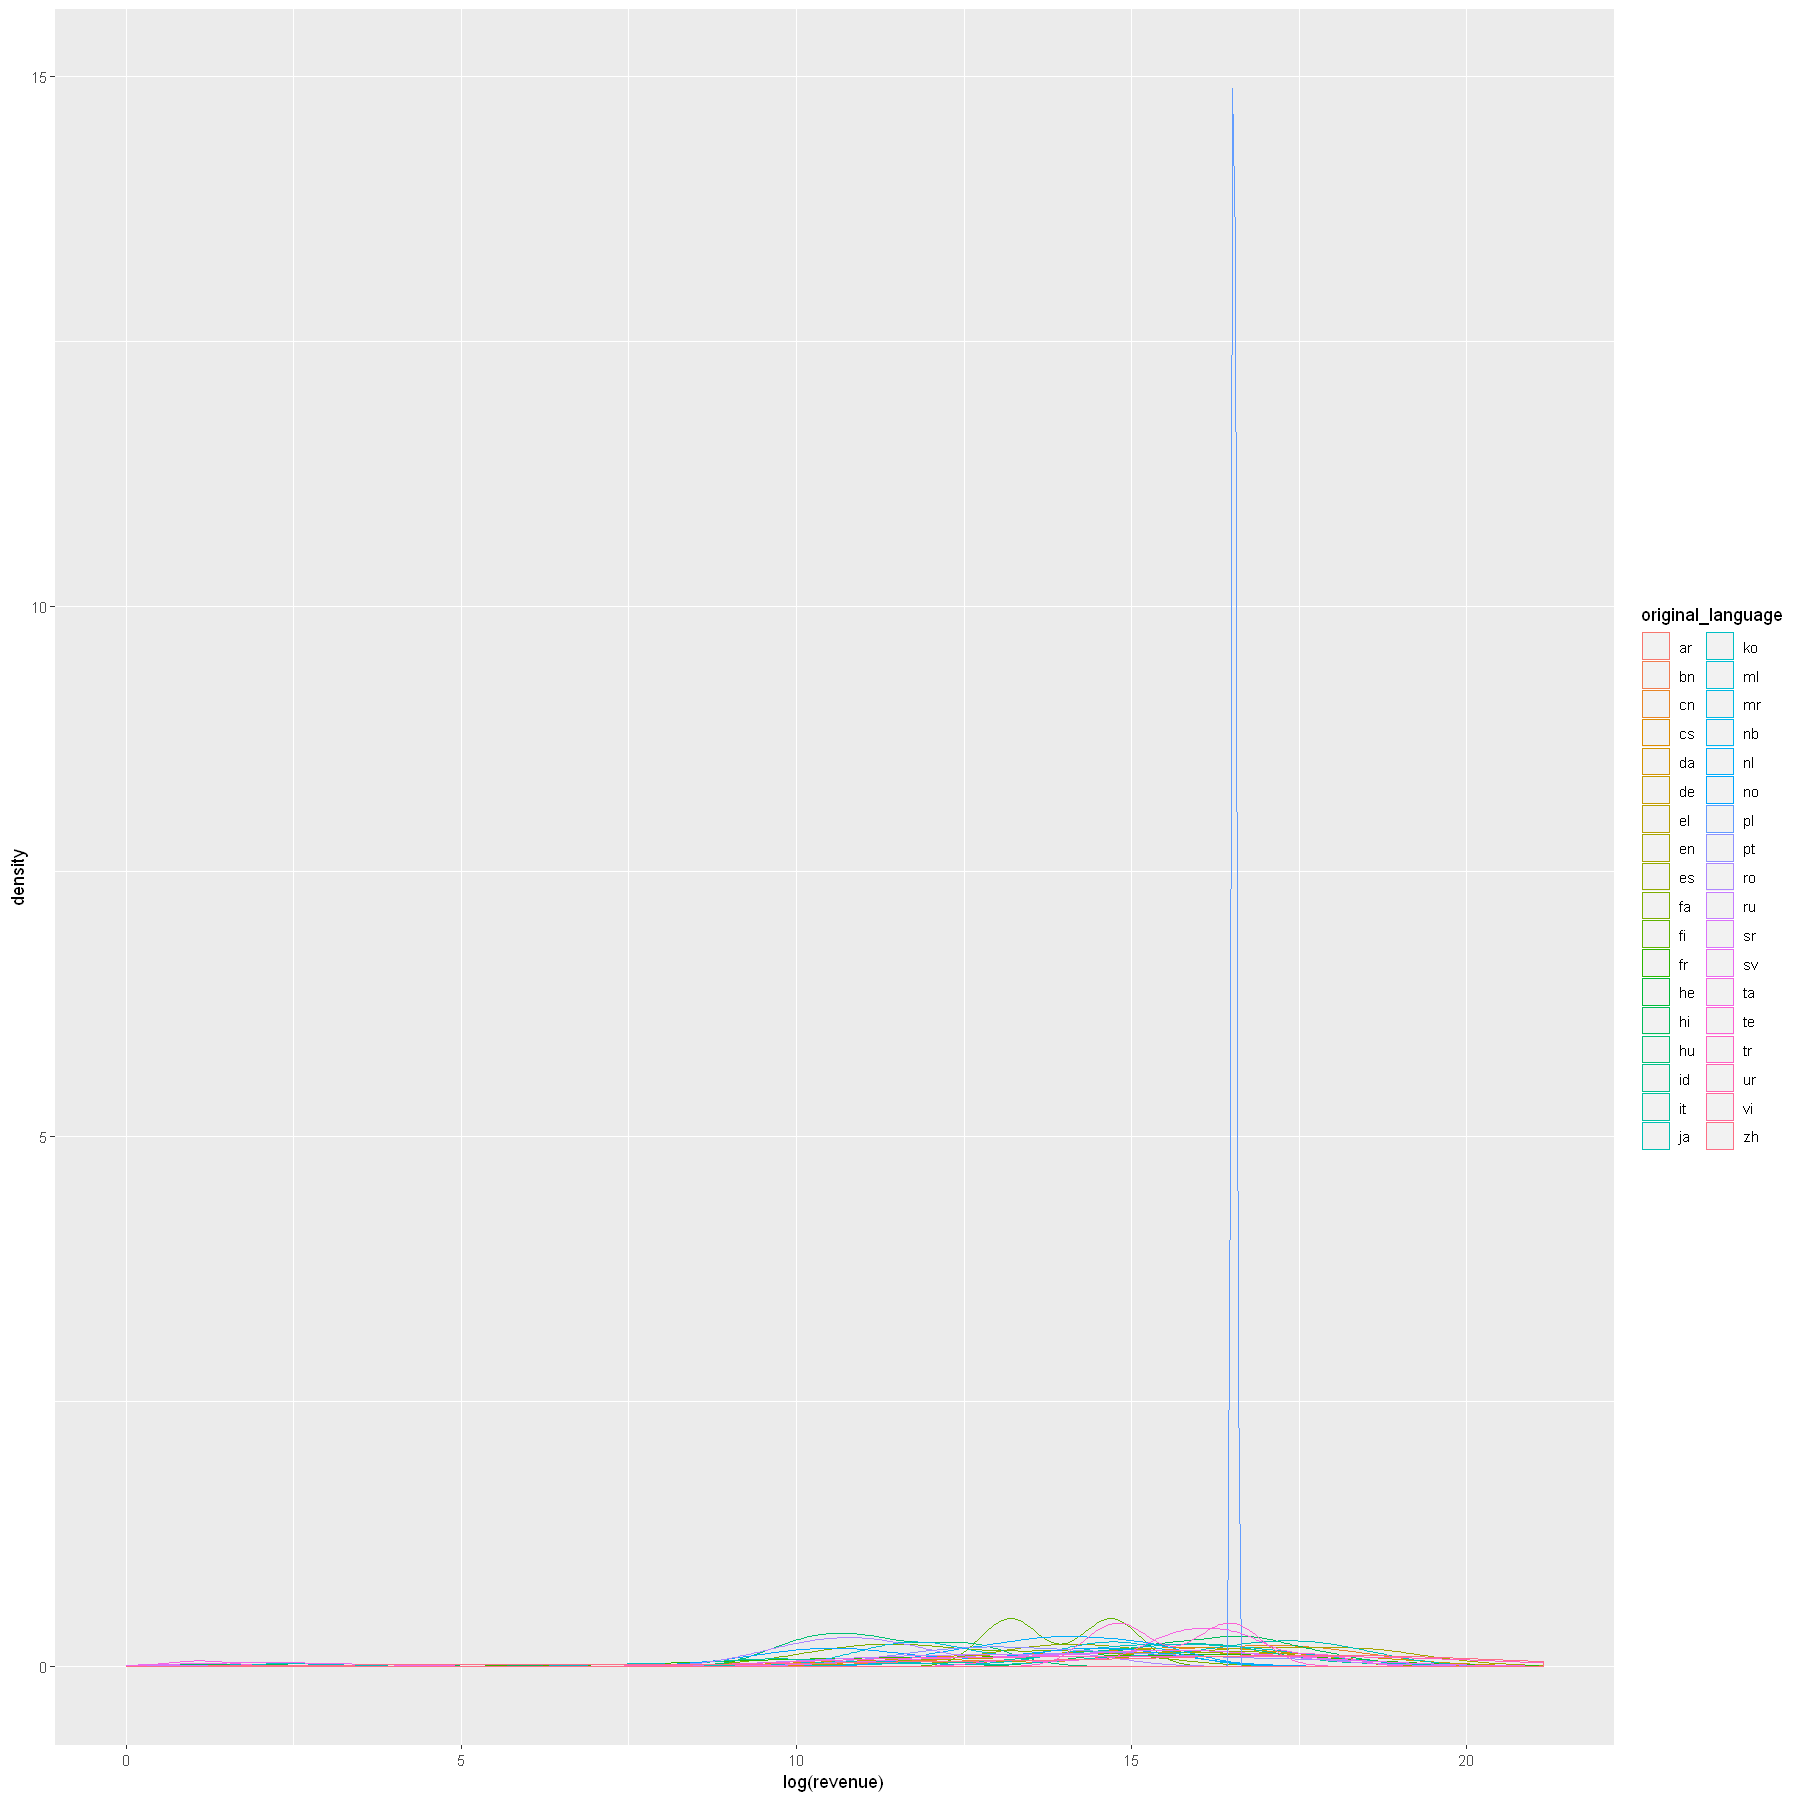

In [29]:
ggplot(data=movies_ff) +
    geom_density(aes(log(revenue), group=original_language, color=original_language))

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."


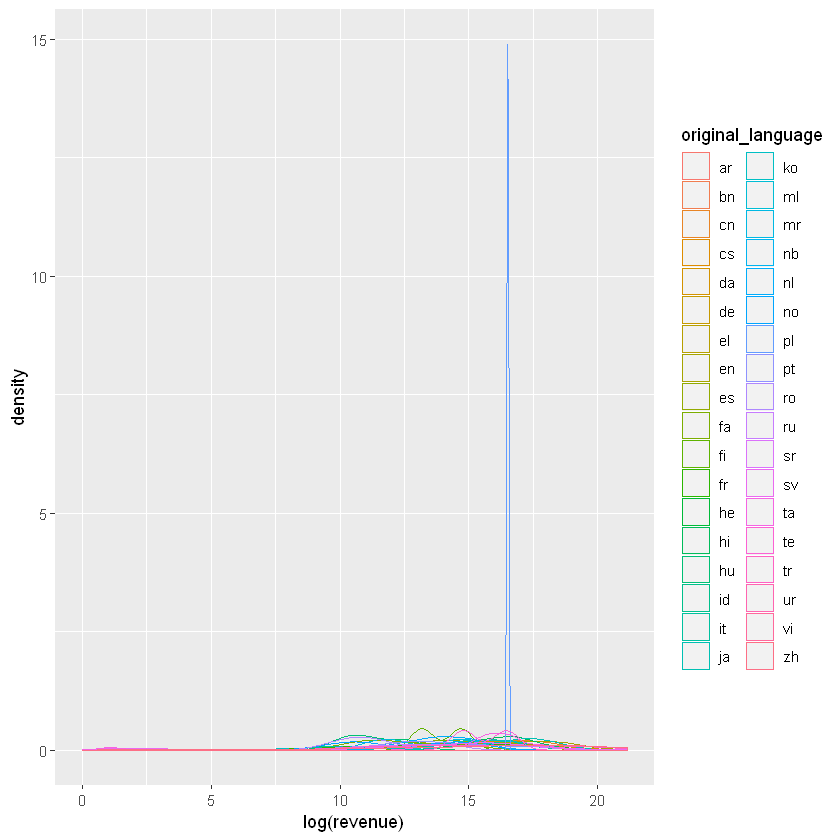

In [55]:
movies <- movies_ff %>% 
    mutate(orig_lang2=ifelse(original_language %in% c("en","fr","in","ru","es","ja"),original_language,'other'))

In [56]:
movies %>% 
    group_by(orig_lang2) %>% 
    summarise(revenue_avg=mean(revenue,na.rm=T), revenue_sd=sd(revenue,na.rm=T),n=n()) %>% 
    arrange(desc(n))

orig_lang2 revenue_avg revenue_sd n   
1 en         74781024    146000316  6336
2 other      21661090     47864635   550
3 fr         17132566     51746646   199
4 ru          7227710     12086653   105
5 es          8564790     13620382    95
6 ja         30651799     32415934    90

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


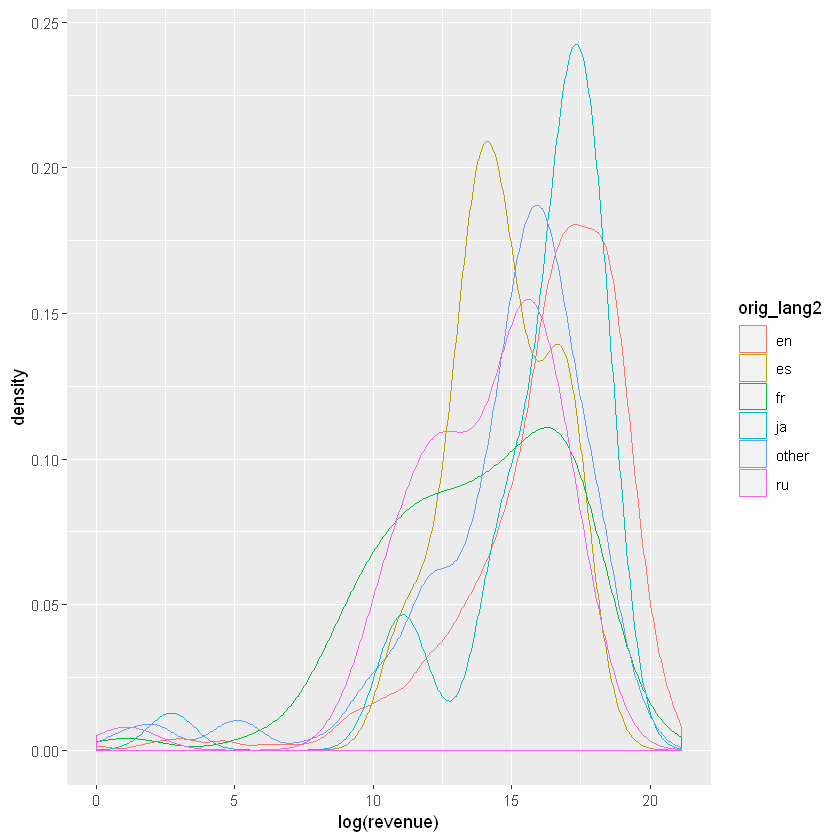

In [57]:
ggplot(data=movies) +
    geom_density(aes(log(revenue), group=orig_lang2, color=orig_lang2))

# 2.3 revenue and data discription using mechkar

In [11]:
setwd("C:/Users/dannyvaks/Documents/GitHub/DataScience/stats")
exploreData(data=movies_ff )

  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


  |===================================================================== |  99%

Warning message in system(cmd, intern = intern, wait = wait | intern, show.output.on.console = wait, :
"running command 'C:\WINDOWS\system32\cmd.exe /c explorer  report\report.html' had status 1"


character(0)
attr(,"status")
[1] 1

In [17]:
setwd("C:/Users/dannyvaks/Documents/GitHub/DataScience/stats")
exploreData(data=movies_ff , y = "revenue" , dir = "report2" )

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4384 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4531 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.04"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.04"
Warning mess

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5310 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5534 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5621 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.115"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.115"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  8.4231e-016"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.115"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.115

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  5.7808e-016"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.595"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.595

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.165"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.165"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  3.8041e-016"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.165"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.165

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 0.855"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.145"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 0.855"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.145"
Warning me

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.07"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.07"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  6.6443e-016"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.07"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.07"
Wa

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"at  -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"radius  0.0036"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"all data on boundary of neighborhood. make span bigger"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"
Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/Inf i

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"at  -0.26"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"radius  0.0676"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"all data on boundary of neighborhood. make span bigger"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.26"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.26"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"
Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/Inf i

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 2"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 2"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  3.575e-016"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.06"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.06"
War

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |===================================================================== |  99%

Warning message in system(cmd, intern = intern, wait = wait | intern, show.output.on.console = wait, :
"running command 'C:\WINDOWS\system32\cmd.exe /c explorer  report2\report.html' had status 1"


character(0)
attr(,"status")
[1] 1

Warning message:
"Removed 1 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 1 rows containing non-finite values (stat_density)."


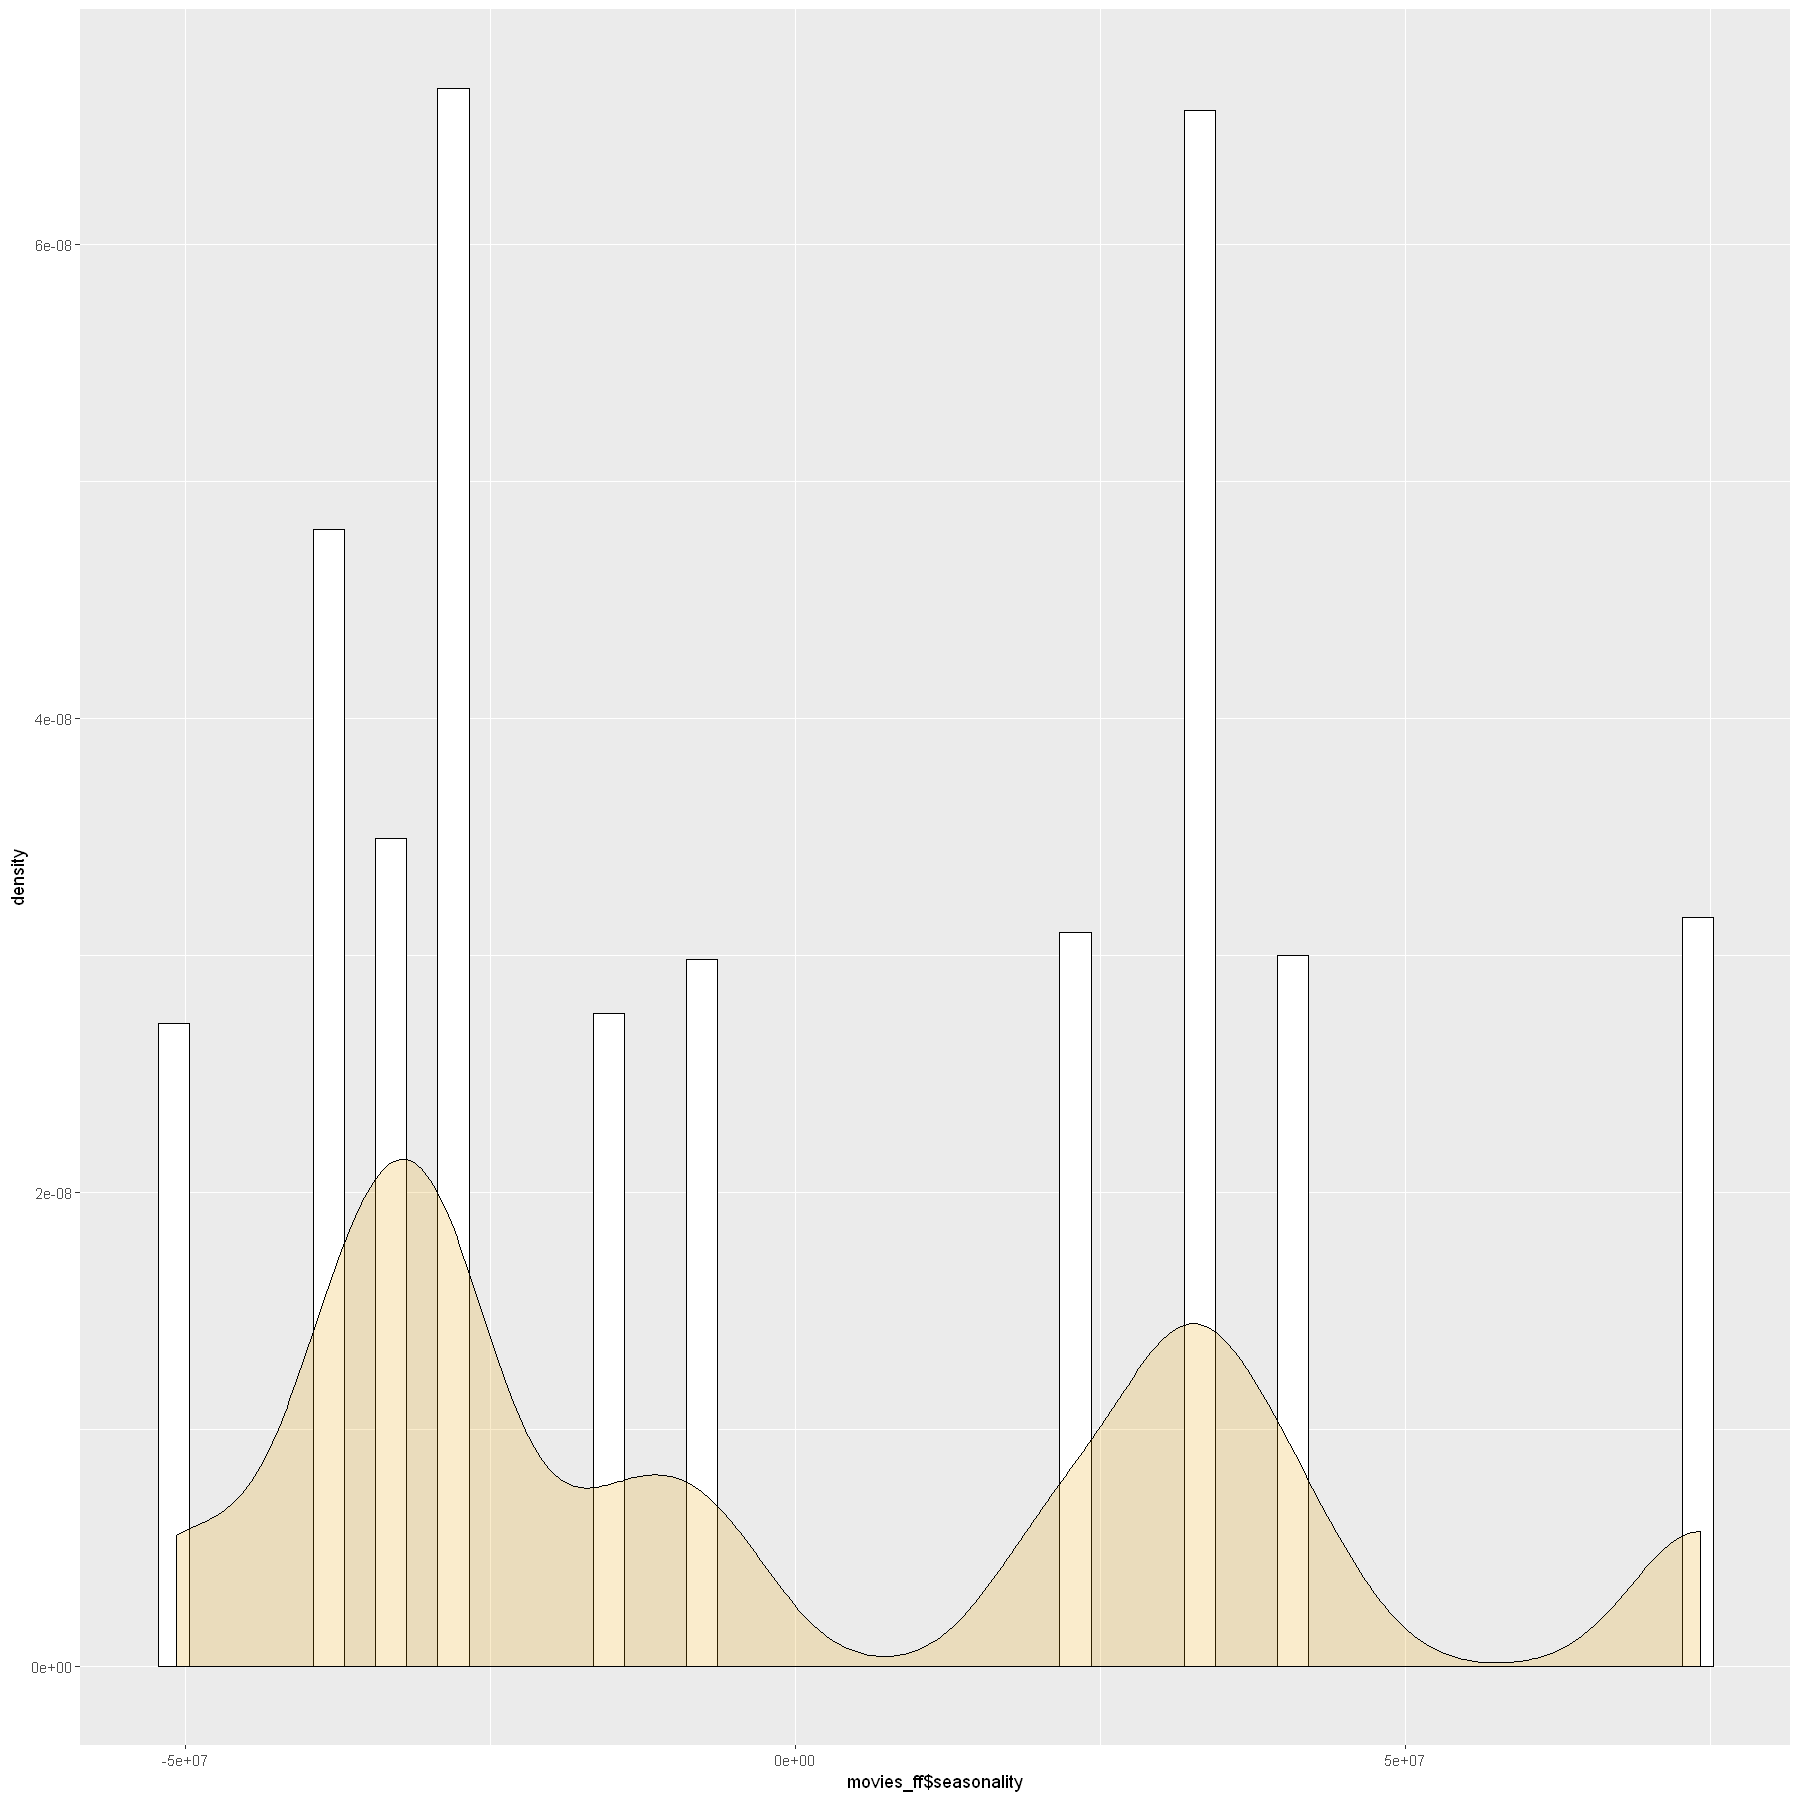

In [22]:
# seasonality
ggplot(movies_ff, aes(x=movies_ff$seasonality)) + 
 geom_histogram(aes(y=..density..), colour="black", fill="white",bins = 50)+
 geom_density(alpha=0.2, fill="#E69F00") + theme_get()

In [30]:
movie.time <- movies_ff %>% 
    mutate(release_year,release_month) %>%
    group_by(release_year,release_month) %>%
    summarise(n=n(),revenue_mean=mean(revenue,na.rm=T)) %>%
    select(release_year,release_month,n,revenue_mean) %>%
    filter(between(release_year,1985,2016))

movie.time$revenue_mean <- ifelse(is.na(movie.time$revenue_mean),0,movie.time$revenue_mean)

movie.ts <- ts(movie.time$revenue_mean, start = c(1995, 1), end=c(2016,12), frequency = 12)

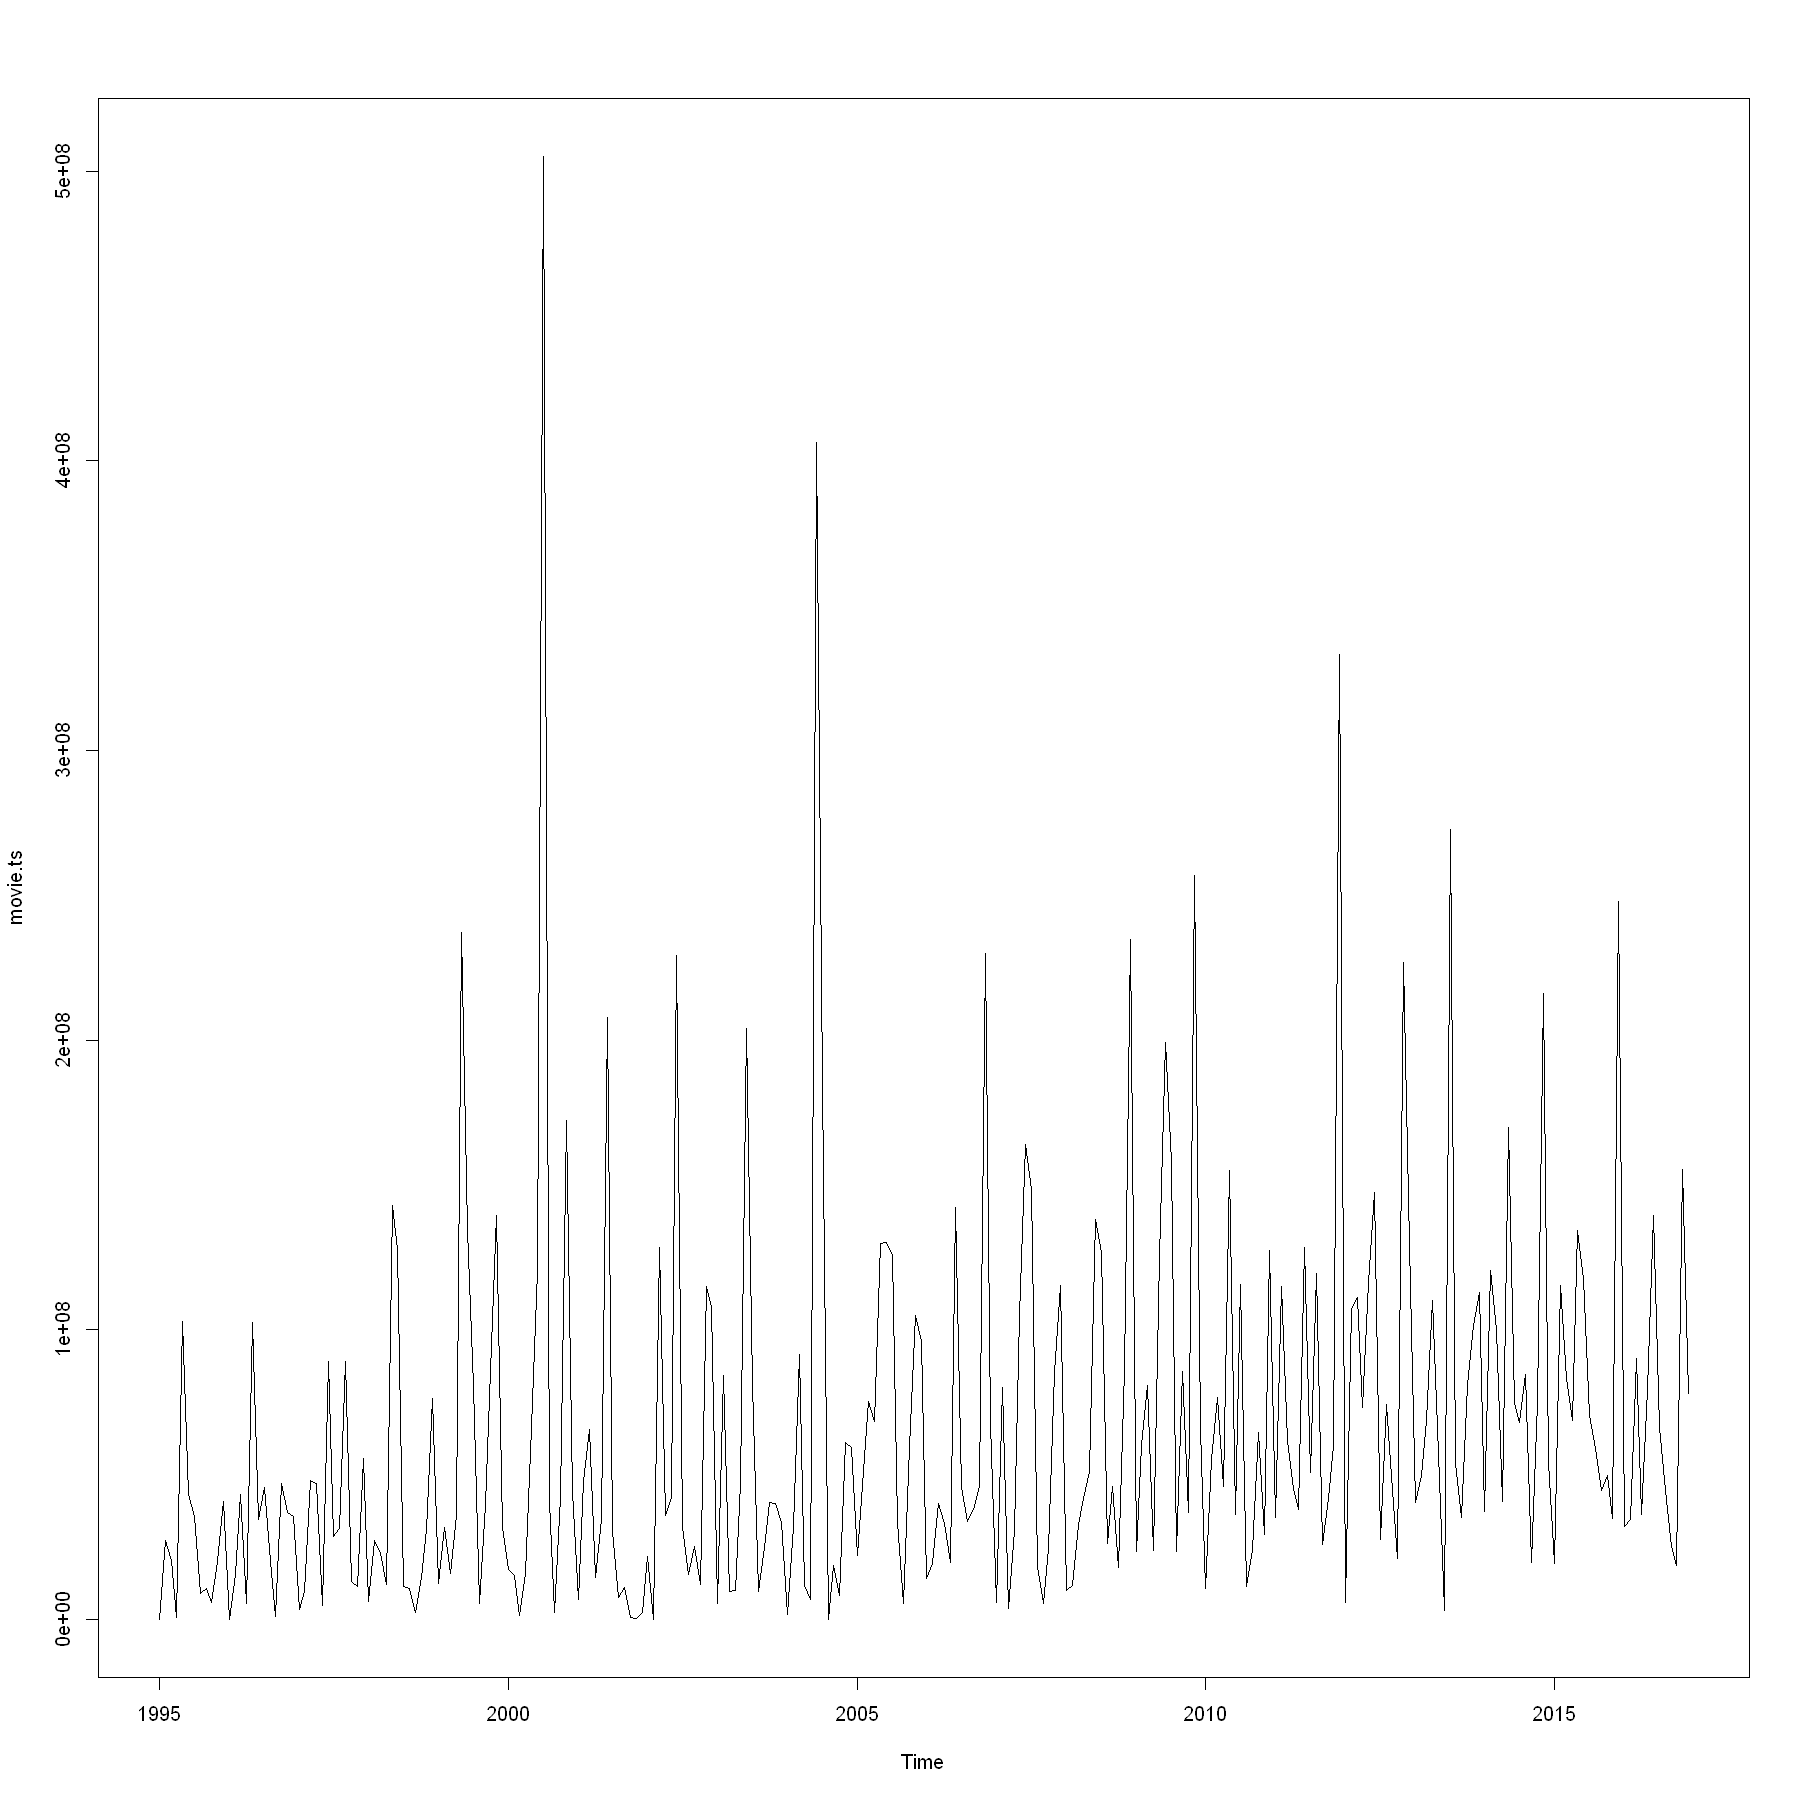

In [31]:
plot(movie.ts)

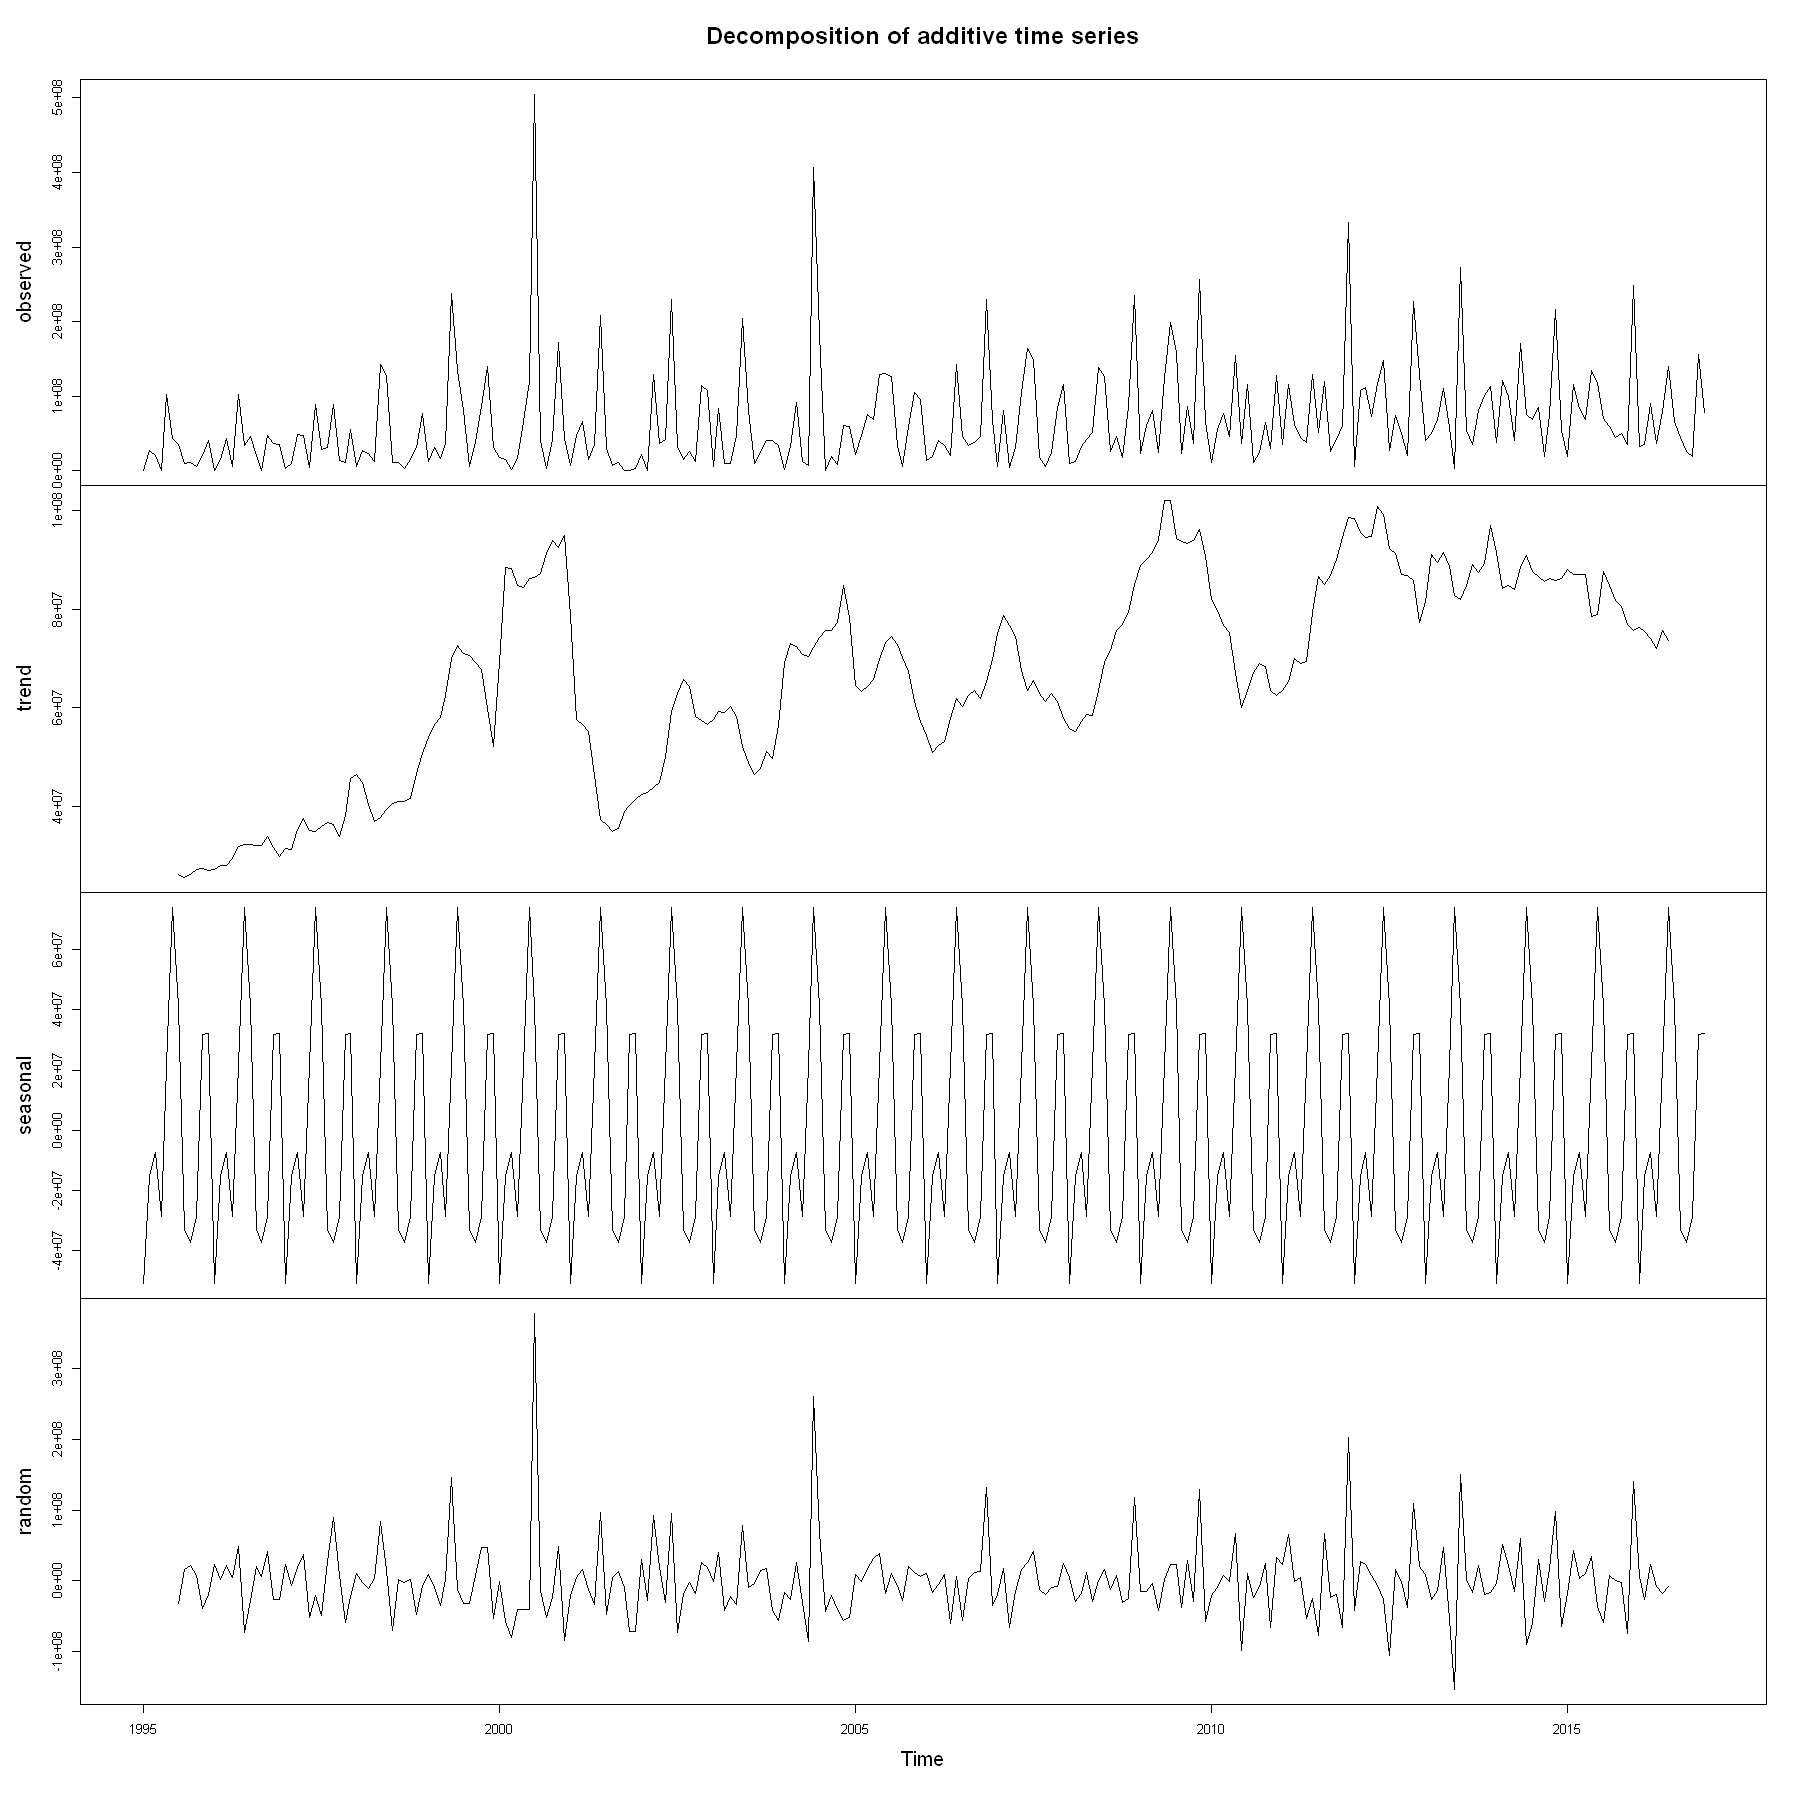

In [25]:
plot(decompose(movie.ts))

# 2.3 correlation matrix

In [32]:
if(!require(corrplot)) {install.packages("corrplot");require(corrplot)}

Loading required package: corrplot

Warning message:
"package 'corrplot' was built under R version 3.6.2"
corrplot 0.84 loaded



In [36]:
install.packages("Hmisc")

package 'Hmisc' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'Hmisc'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\dannyvaks\.conda\envs\notebook\Lib\R\library\00LOCK\Hmisc\libs\x64\Hmisc.dll to C:\Users\dannyvaks\.conda\envs\notebook\Lib\R\library\Hmisc\libs\x64\Hmisc.dll: Permission denied"
Warning message:
"restored 'Hmisc'"



The downloaded binary packages are in
	C:\Users\dannyvaks\AppData\Local\Temp\RtmpgdT58i\downloaded_packages


In [33]:
library(Hmisc)

Warning message:
"package 'Hmisc' was built under R version 3.6.2"
Loading required package: survival

Warning message:
"package 'survival' was built under R version 3.6.2"
Loading required package: Formula


Attaching package: 'Hmisc'


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    format.pval, units




In [35]:
my_num_data <- movies_ff[, sapply(movies_ff, is.numeric)]
head(my_num_data)

movie_id budget   popularity runtime revenue  sw_lang_en sw_web_presence
1 1        14000000  6.575393   93     12314651 1          0              
2 2        40000000  8.248895  113     95149435 1          0              
3 3         3300000 64.299990  105     13092000 1          1              
4 4         1200000  3.174936  122     16000000 0          1              
5 5               0  1.148070  118      3923970 0          0              
6 6         8000000  0.743274   83      3261638 1          0              
  sw_has_poster sw_tagline keyword_cnt ... depart_Camera_female
1 1             1           4          ... 0                   
2 1             1           4          ... 0                   
3 1             1          12          ... 0                   
4 1             0           7          ... 0                   
5 1             0           0          ... 0                   
6 1             0           0          ... 0                   
  depart_Crew_female depart_Custom_Mkup_female depart_Directing_female
1 0                  0                         0                      
2 0                  0                         0                      
3 1                  0                         0                      
4 0                  0                         0                      
5 0                  0                         0                      
6 0                  0                         0                      
  depart_Editing_female depart_Lighting_female depart_Production_female
1 0                     0                      0                       
2 0                     0                      3                       
3 0                     0                      2                       
4 0                     0                      0                       
5 0                     0                      0                       
6 0                     0                      0                       
  depart_Sound_female depart_Visual_Effects_female depart_Writing_female
1 0                   0                            0                    
2 0                   0                            1                    
3 0                   0                            0                    
4 0                   0                            0                    
5 0                   0                            0                    
6 0                   0                            0

In [36]:
cor_res <- cor(my_num_data, use ="pairwise.complete.obs",method="s")


Warning message in cor(my_num_data, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(my_num_data, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(my_num_data, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(my_num_data, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(my_num_data, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(my_num_data, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(my_num_data, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(my_num_data, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(my_num_data, use = "pairwise.complete.obs", method = "s")

In [24]:
head(cor_res)

movie_id     budget       popularity  runtime      revenue    
movie_id   1.0000000000 0.0009736131 0.005477086  0.002341803 0.009997652
budget     0.0009736131 1.0000000000 0.517639218  0.250502521 0.691007848
popularity 0.0054770856 0.5176392179 1.000000000  0.171363671 0.594538732
runtime    0.0023418029 0.2505025212 0.171363671  1.000000000 0.261910598
revenue    0.0099976524 0.6910078479 0.594538732  0.261910598 1.000000000
sw_lang_en 0.0011709051 0.2439509928 0.258408834 -0.117635059 0.221077560
           sw_lang_en   sw_web_presence sw_has_poster sw_tagline   keyword_cnt
movie_id    0.001170905 0.004466673     0.004862132   -0.008193279 0.01012805 
budget      0.243950993 0.211737710     0.020959371    0.298541124 0.28302850 
popularity  0.258408834 0.210234301     0.028406920    0.348489699 0.43147356 
runtime    -0.117635059 0.043810470     0.014082759    0.006435861 0.14320100 
revenue     0.221077560 0.191729626     0.027253296    0.333861394 0.33226715 
sw_lang_en  1.000000000 0.035833839     0.017001119    0.399816033 0.16898117 
           ... depart_Camera_female depart_Crew_female
movie_id   ... -0.005727583         -8.193342e-05     
budget     ...  0.036589693          1.755995e-01     
popularity ...  0.065173132          1.774725e-01     
runtime    ...  0.001225895          7.042466e-02     
revenue    ...  0.032005853          1.628297e-01     
sw_lang_en ...  0.046737688          6.850151e-02     
           depart_Custom_Mkup_female depart_Directing_female
movie_id   0.003404204               -0.004240663           
budget     0.315041130                0.139602278           
popularity 0.294492671                0.126272830           
runtime    0.169646772                0.069858973           
revenue    0.317688650                0.126197294           
sw_lang_en 0.203880661                0.110337186           
           depart_Editing_female depart_Lighting_female
movie_id   -0.01086437           -0.01425605           
budget      0.08616299            0.01364380           
popularity  0.10216707            0.01419199           
runtime     0.04849778           -0.01132805           
revenue     0.05829747            0.03135544           
sw_lang_en  0.08101905            0.01057666           
           depart_Production_female depart_Sound_female
movie_id   -0.000443574             -0.02289685        
budget      0.396343510              0.13053200        
popularity  0.395866981              0.13821703        
runtime     0.126761948              0.07748747        
revenue     0.387482082              0.14117393        
sw_lang_en  0.291199051              0.08149105        
           depart_Visual_Effects_female depart_Writing_female
movie_id   0.01435770                   -0.009913564         
budget     0.08256478                    0.049253239         
popularity 0.07644792                    0.060167155         
runtime    0.00525580                    0.026717987         
revenue    0.07706105                    0.099745155         
sw_lang_en 0.02808414                    0.050204337

In [9]:
if (!require("RColorBrewer")) install.packages("RColorBrewer")
if (!require("corrplot")) install.packages("corrplot")


Loading required package: RColorBrewer

Loading required package: corrplot

Warning message:
"package 'corrplot' was built under R version 3.6.2"
corrplot 0.84 loaded



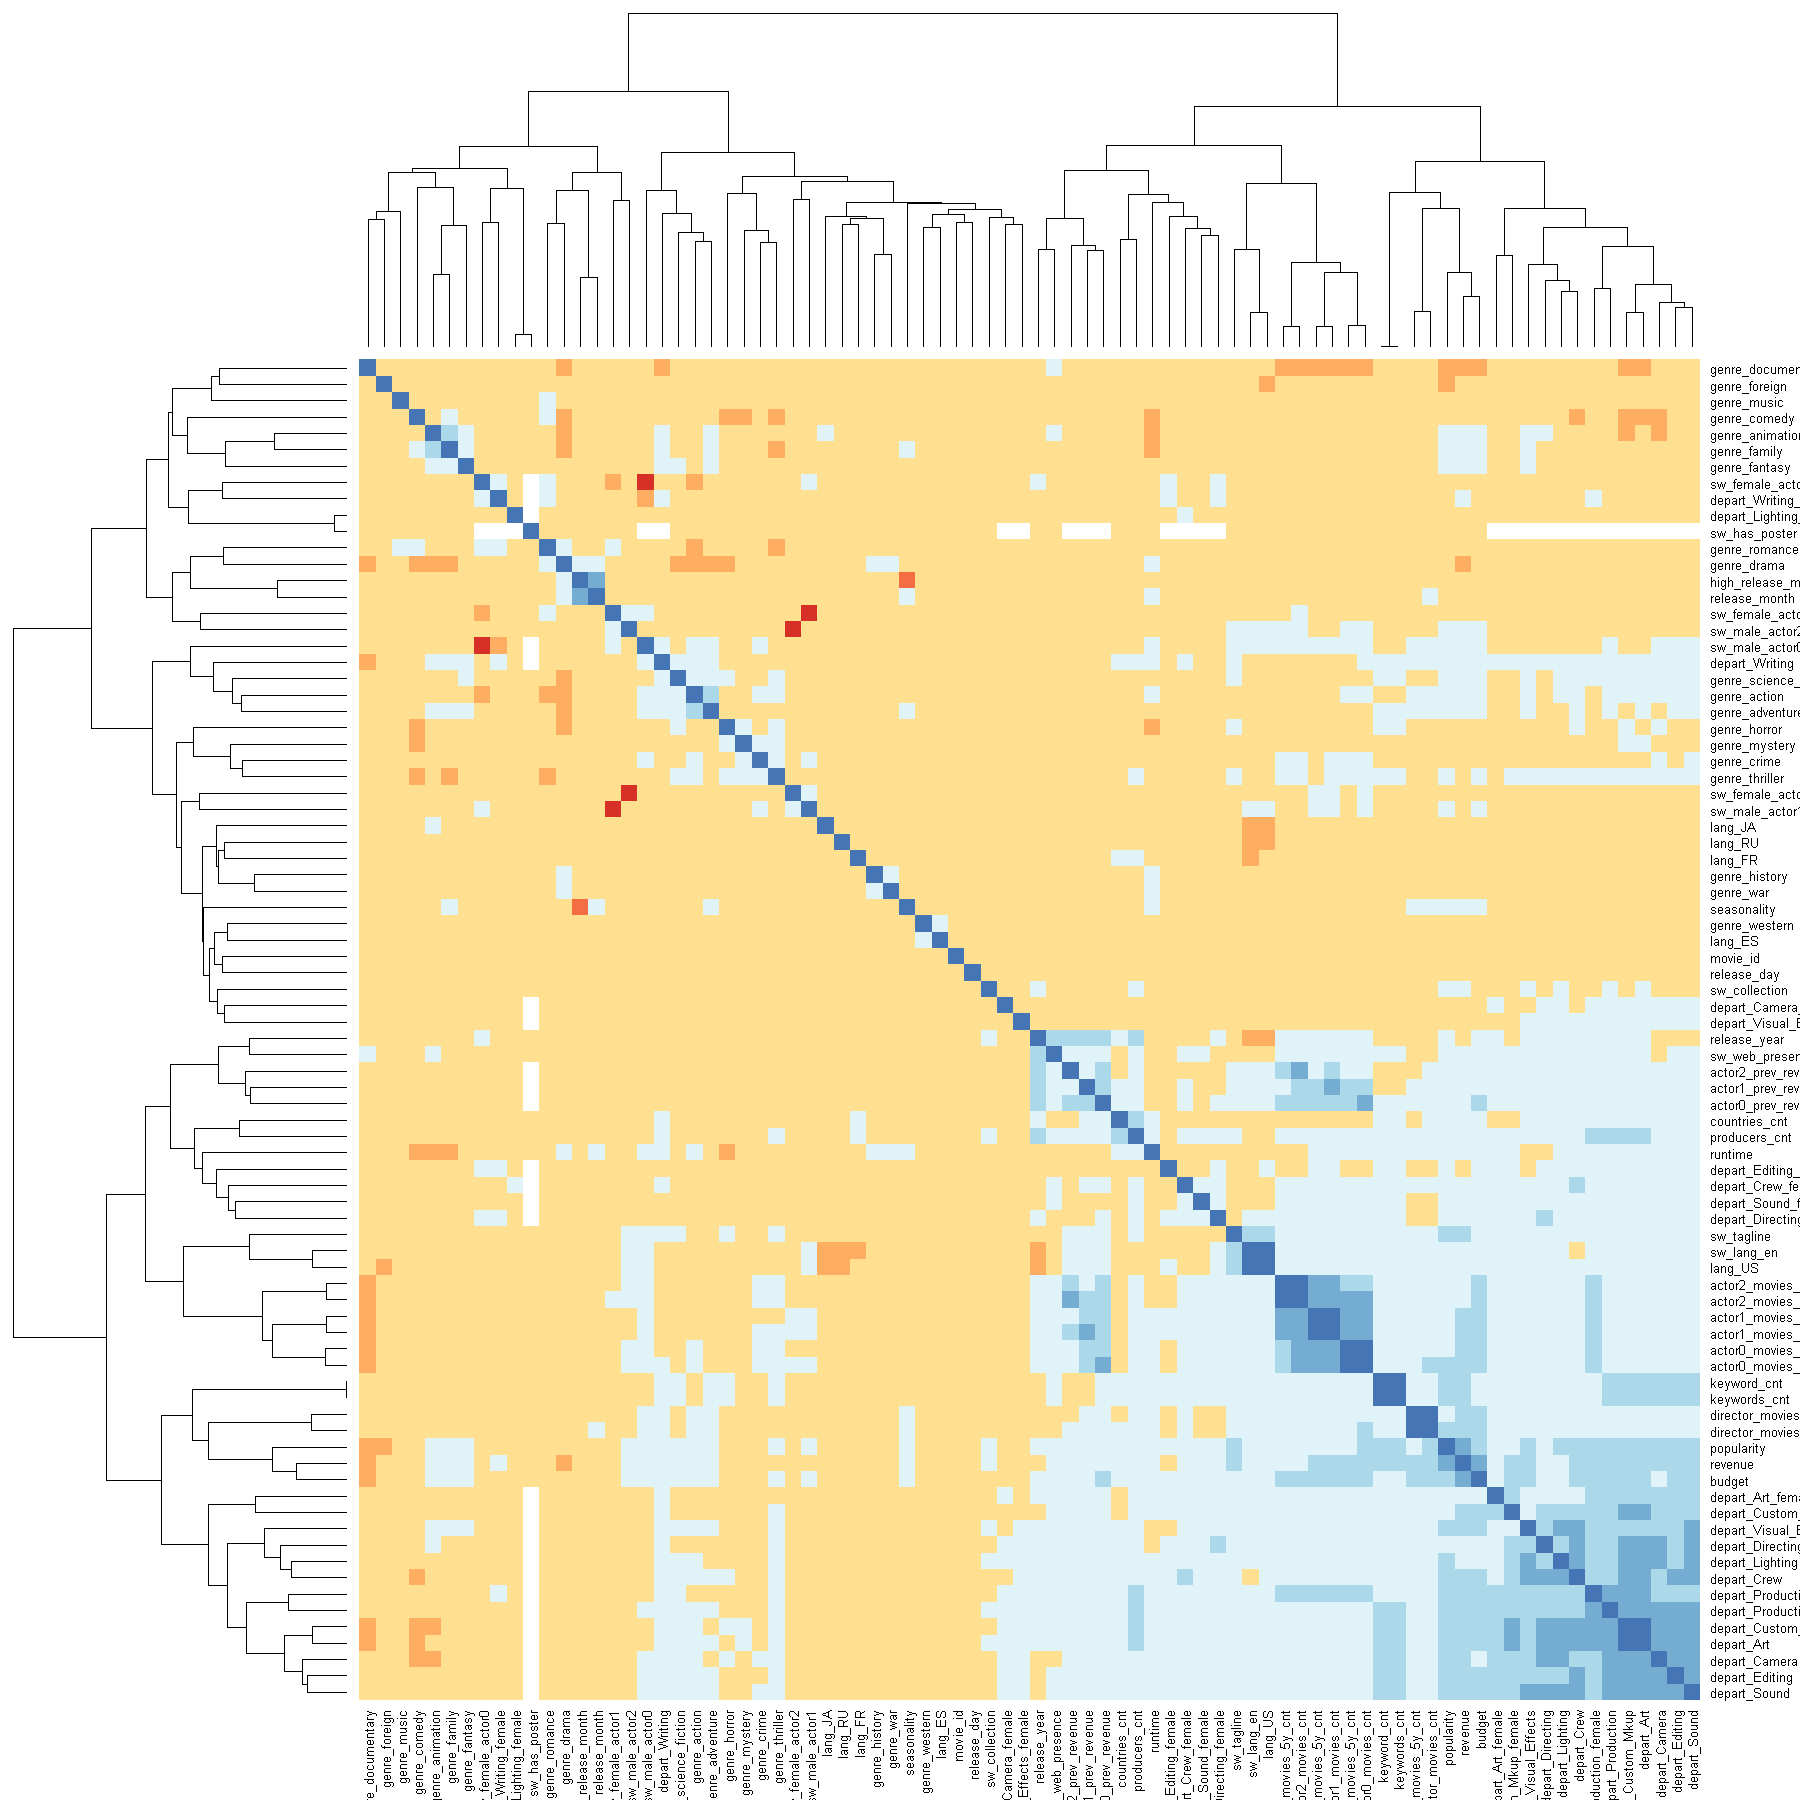

In [26]:
heatmap(cor_res,symm = T,cexCol = 0.8, cexRow = 0.8, col=brewer.pal(n=8, name="RdYlBu"))

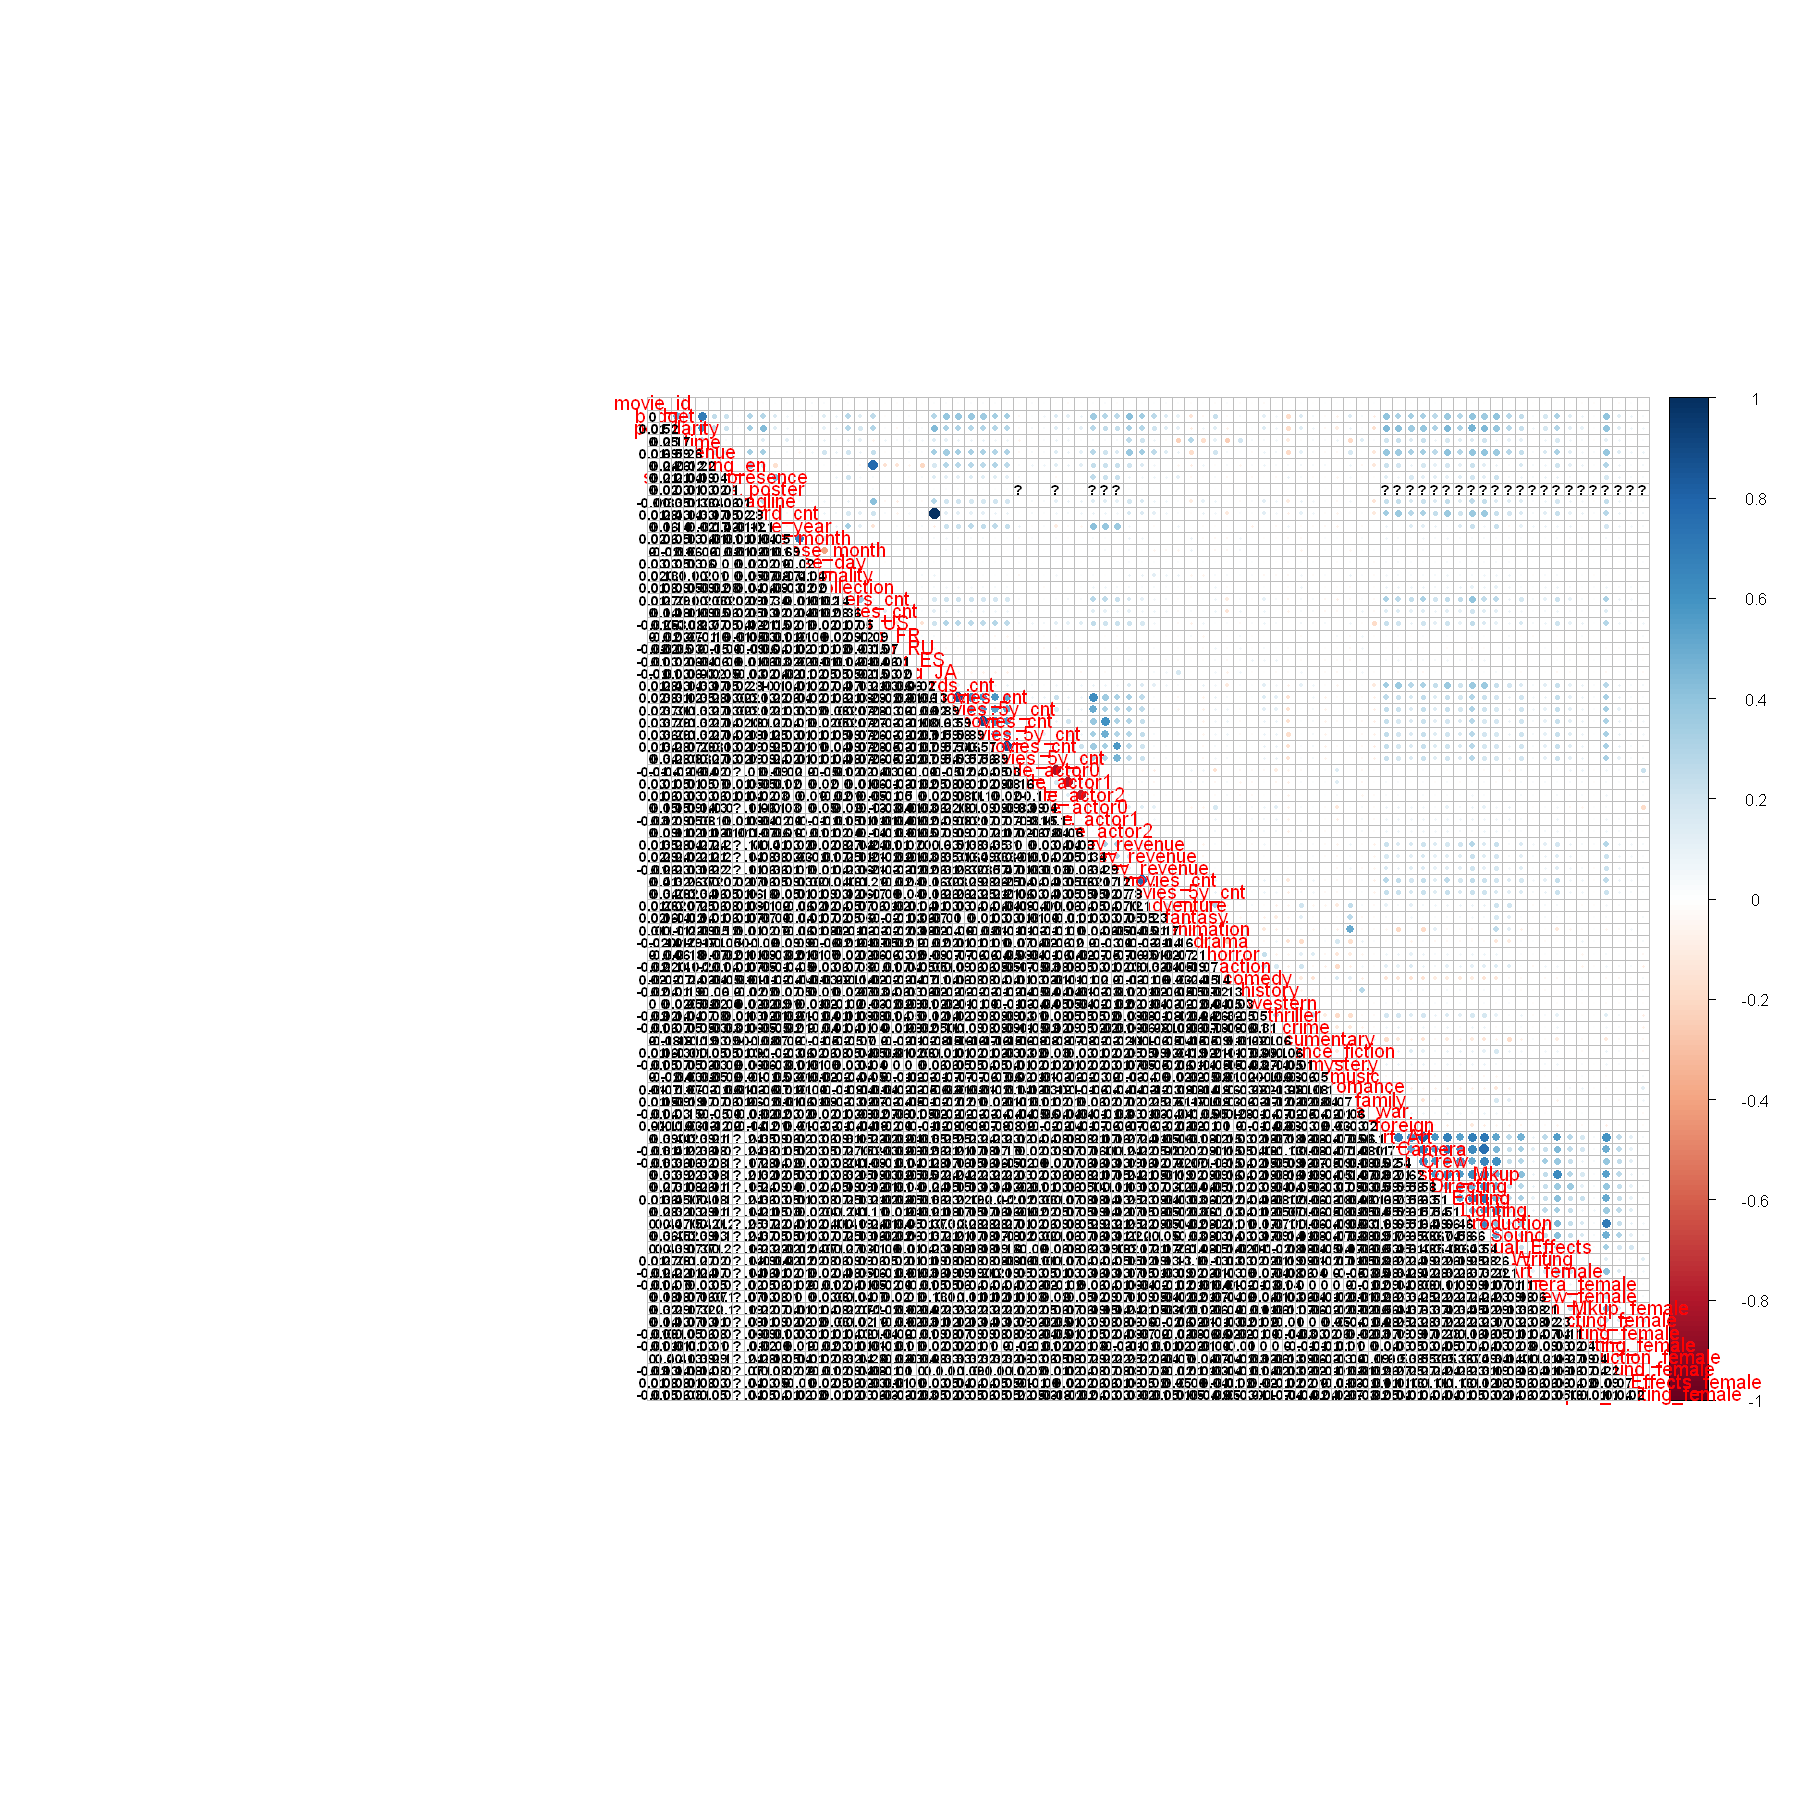

In [31]:
corrplot.mixed(cor_res, lower.col = "black", number.cex = .7, tl.srt = 90)

# 2.5 outliers detection

In [54]:
movies_outliers <- outlierMatrix(movies_ff)

In [55]:
head(movies_outliers)

movie_id budget_out popularity_out runtime_out revenue_out sw_lang_en_out
1 1        0          0              0           0           0             
2 2        0          0              0           0           0             
3 3        0          1              0           0           0             
4 4        0          0              0           0           1             
5 5        0          0              0           0           1             
6 6        0          0              0           0           0             
  sw_web_presence_out sw_has_poster_out sw_tagline_out keyword_cnt_out ...
1 0                   0                 0              0               ...
2 0                   0                 0              0               ...
3 0                   0                 0              0               ...
4 0                   0                 1              0               ...
5 0                   0                 1              0               ...
6 0                   0                 1              0               ...
  depart_Camera_female_out depart_Crew_female_out depart_Custom_Mkup_female_out
1 0                        0                      0                            
2 0                        0                      0                            
3 0                        1                      0                            
4 0                        0                      0                            
5 0                        0                      0                            
6 0                        0                      0                            
  depart_Directing_female_out depart_Editing_female_out
1 0                           0                        
2 0                           0                        
3 0                           0                        
4 0                           0                        
5 0                           0                        
6 0                           0                        
  depart_Lighting_female_out depart_Production_female_out
1 0                          0                           
2 0                          0                           
3 0                          0                           
4 0                          0                           
5 0                          0                           
6 0                          0                           
  depart_Sound_female_out depart_Visual_Effects_female_out
1 0                       0                               
2 0                       0                               
3 0                       0                               
4 0                       0                               
5 0                       0                               
6 0                       0                               
  depart_Writing_female_out
1 0                        
2 1                        
3 0                        
4 0                        
5 0                        
6 0

# 2.6 outliers grapth - boxplots

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


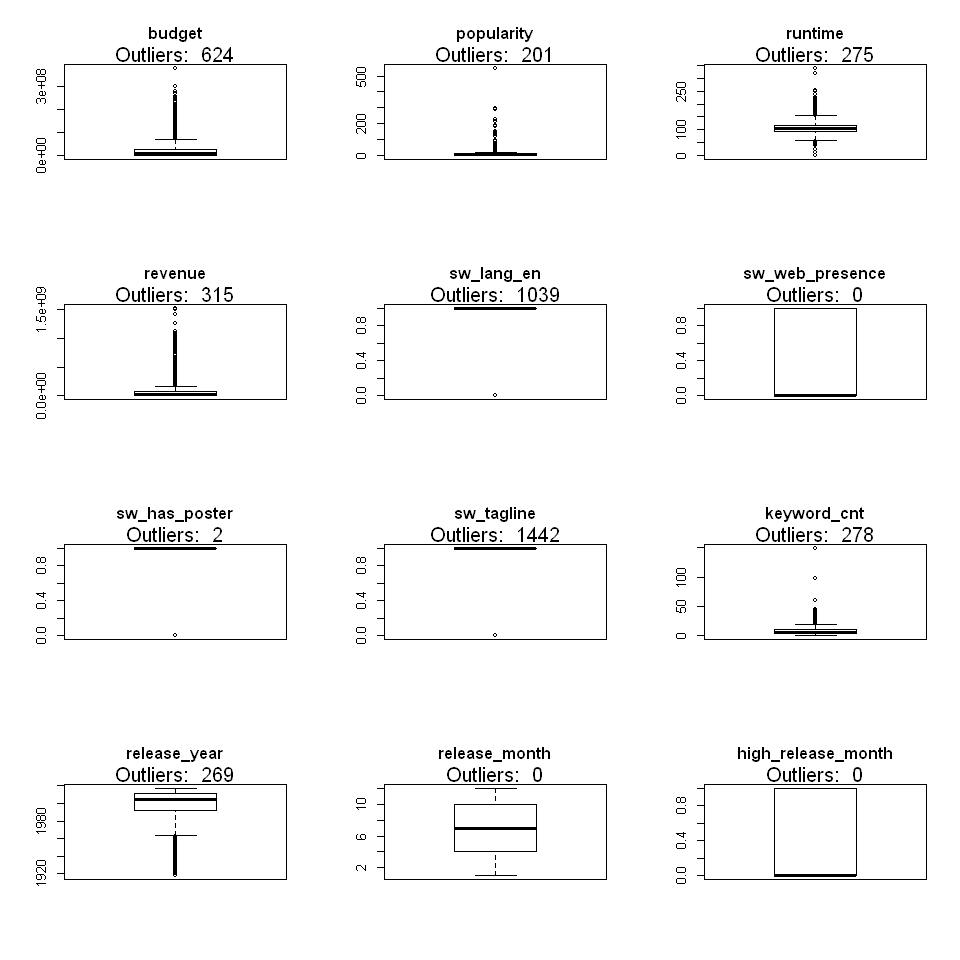

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


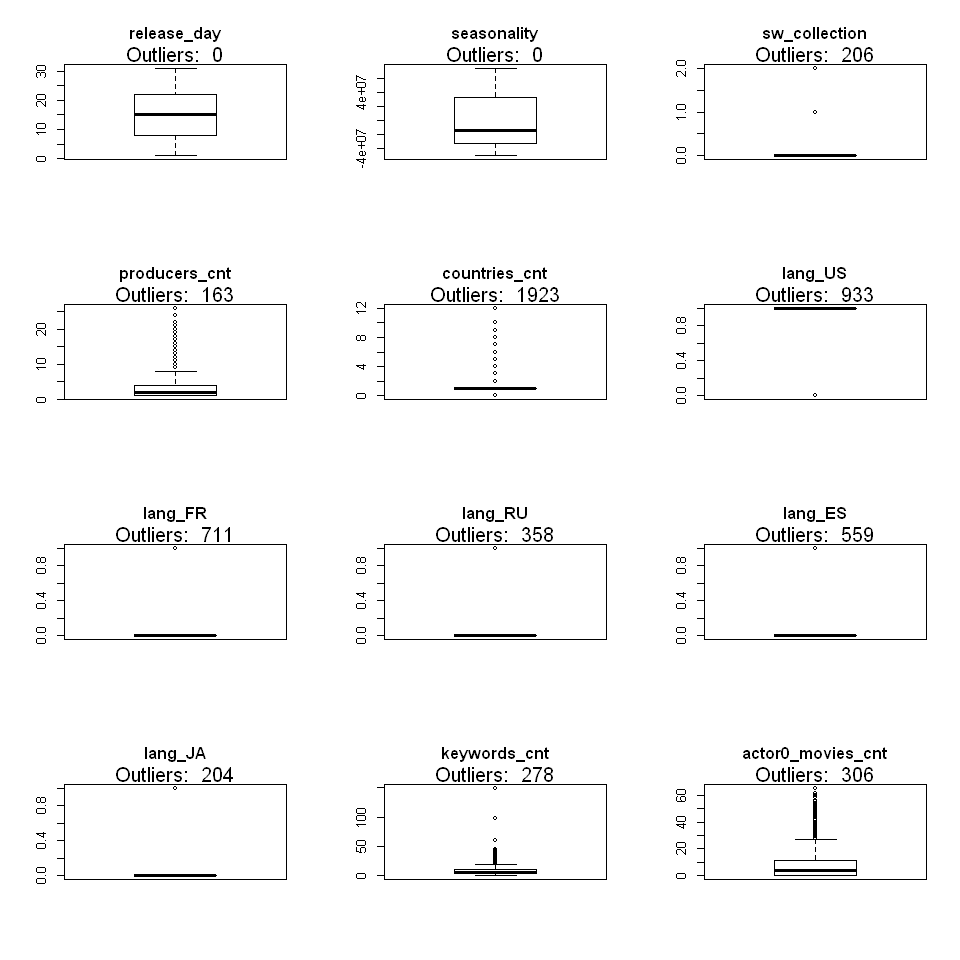

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


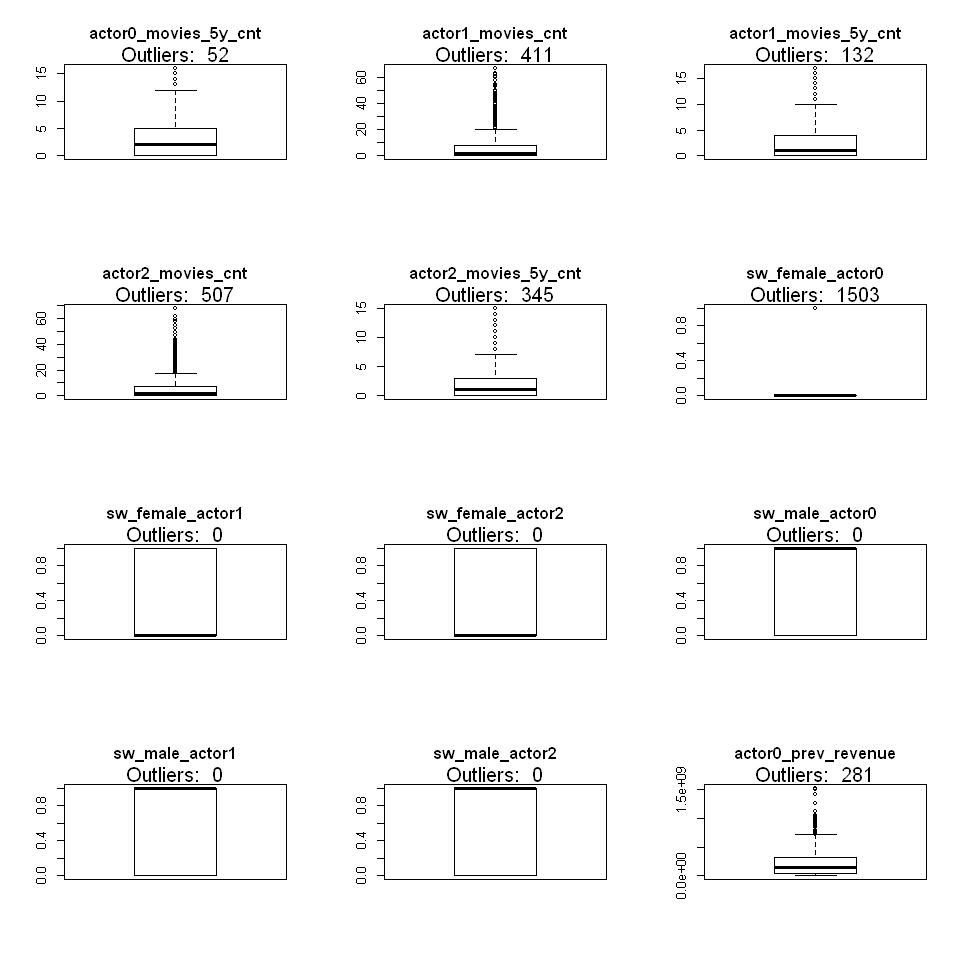

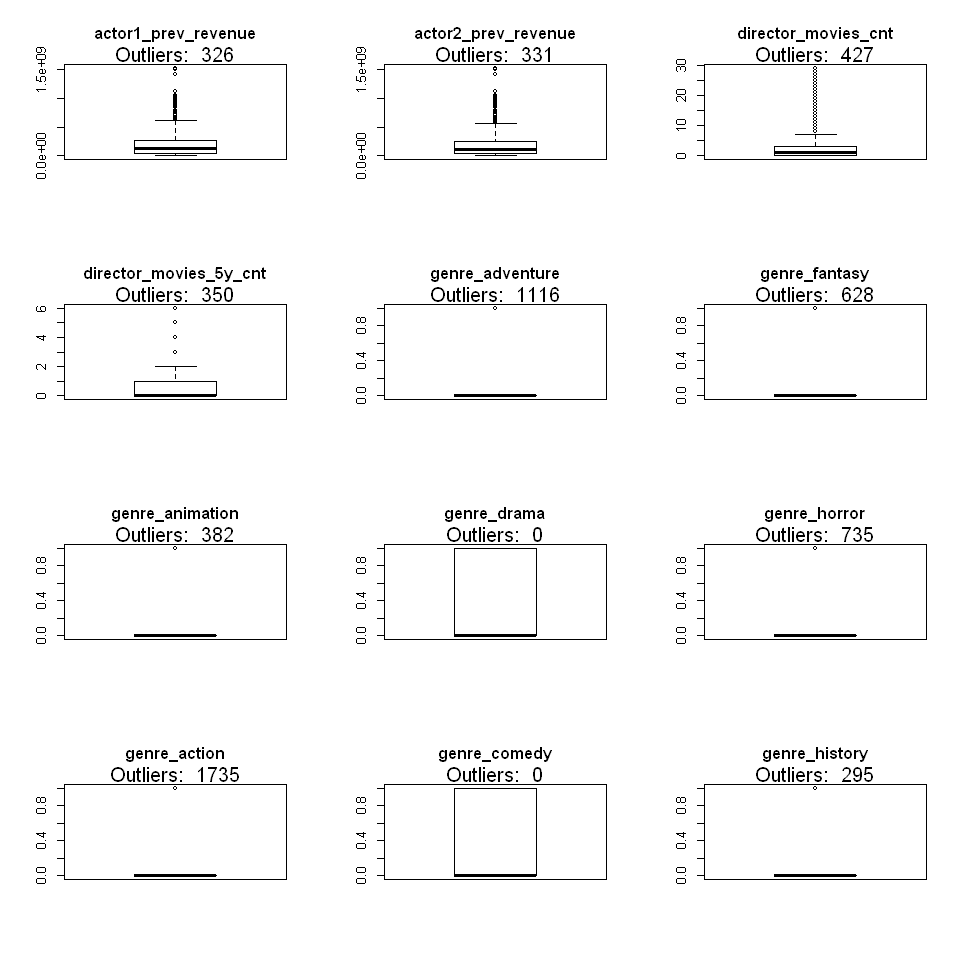

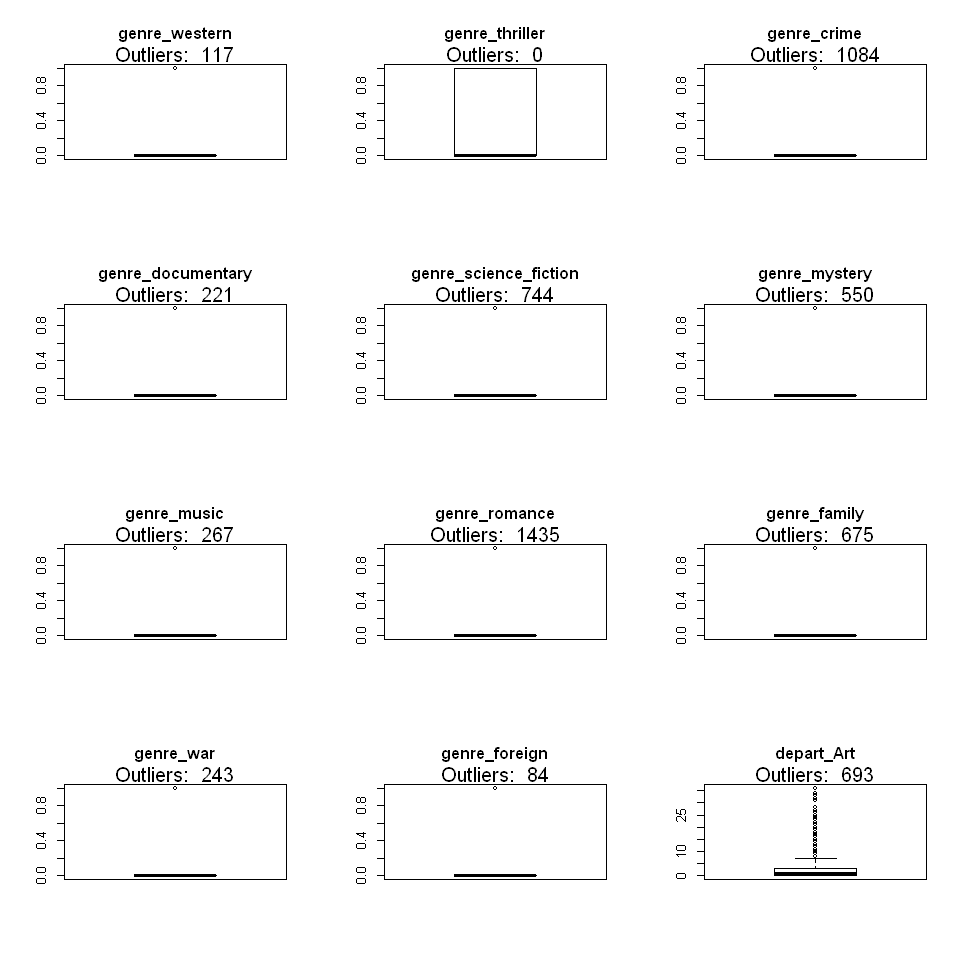

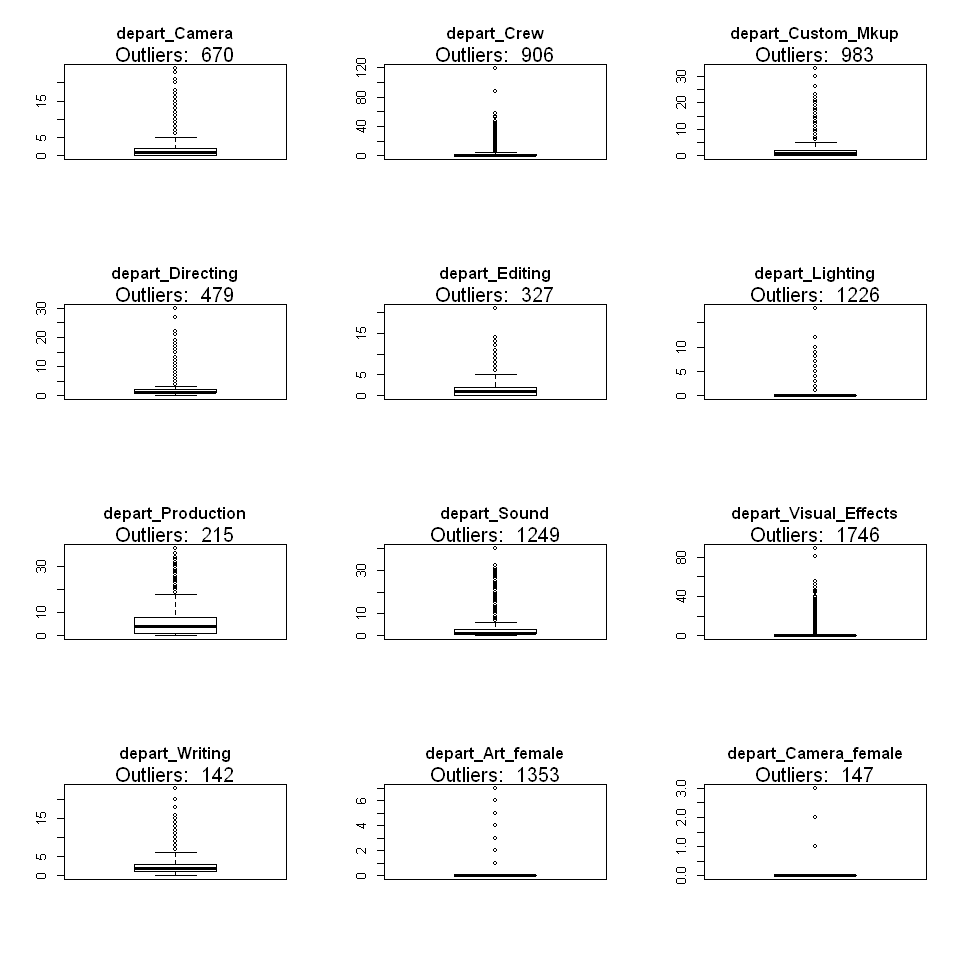

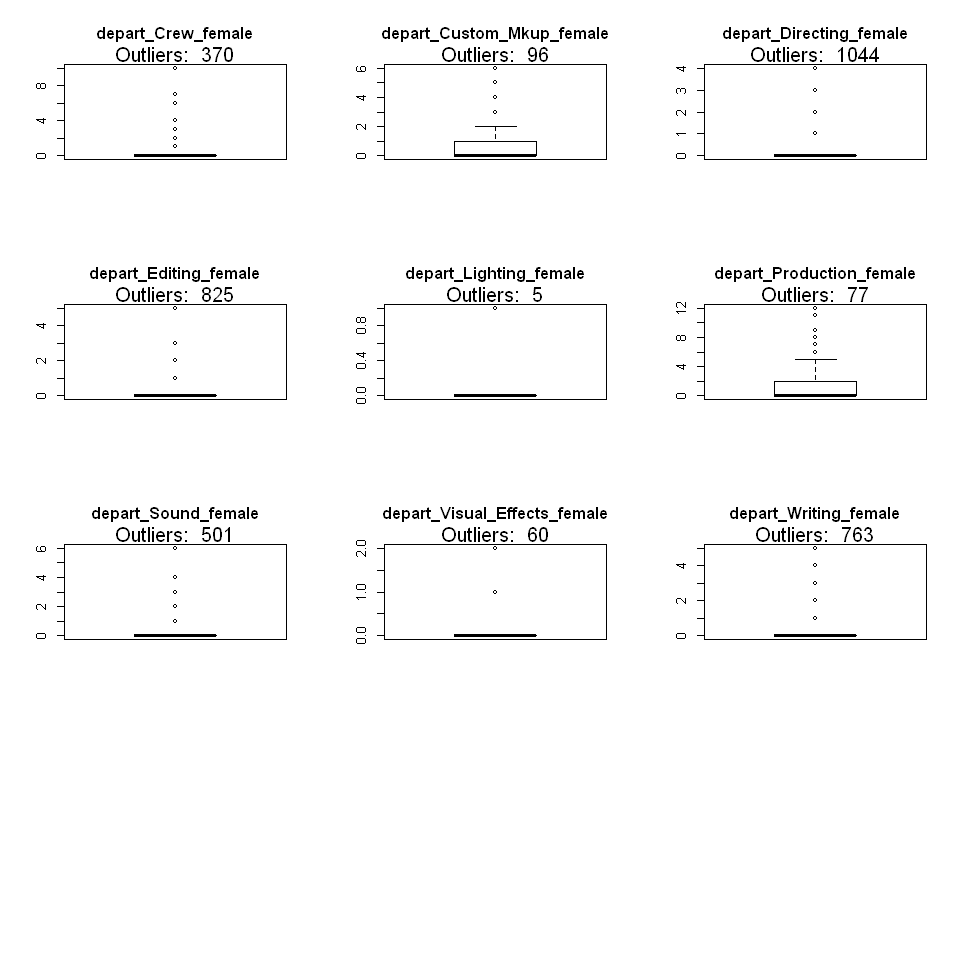

In [66]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(my_num_data[,2:82])) {
    outlier_values <- boxplot.stats(my_num_data[,v])$out
    boxplot(my_num_data[[v]],main=v)
    mtext(paste("Outliers: ", paste(length(outlier_values), collapse=", ")), cex=1)
}
par(mfrow=c(1,1))

# 2.7 missigness matrix

In [33]:
getMissingness(movies_ff)

[[1]]
                   var na_count rate
1              revenue     4382 59.4
2  actor2_prev_revenue     3423 46.4
3  actor1_prev_revenue     3201 43.4
4  actor0_prev_revenue     2752 37.3
5     sw_female_actor0      934 12.7
6       sw_male_actor0      934 12.7
7     sw_female_actor2      788 10.7
8       sw_male_actor2      788 10.7
9     sw_female_actor1      782 10.6
10      sw_male_actor1      782 10.6

[[2]]
[1] "This dataset has 1154 (15.6%) complete rows. Original data has 7375 rows."



$missingness
                            var na_count rate
1                       revenue     4382 59.4
2           actor2_prev_revenue     3423 46.4
3           actor1_prev_revenue     3201 43.4
4           actor0_prev_revenue     2752 37.3
5              sw_female_actor0      934 12.7
6                sw_male_actor0      934 12.7
7              sw_female_actor2      788 10.7
8                sw_male_actor2      788 10.7
9              sw_female_actor1      782 10.6
10               sw_male_actor1      782 10.6
11                producers_cnt      395  5.4
12                   depart_Art       34  0.5
13                depart_Camera       34  0.5
14                  depart_Crew       34  0.5
15           depart_Custom_Mkup       34  0.5
16             depart_Directing       34  0.5
17               depart_Editing       34  0.5
18              depart_Lighting       34  0.5
19            depart_Production       34  0.5
20                 depart_Sound       34  0.5
21        depart_Visual_Effects       34  0.5
22               depart_Writing       34  0.5
23            depart_Art_female       34  0.5
24         depart_Camera_female       34  0.5
25           depart_Crew_female       34  0.5
26    depart_Custom_Mkup_female       34  0.5
27      depart_Directing_female       34  0.5
28        depart_Editing_female       34  0.5
29       depart_Lighting_female       34  0.5
30     depart_Production_female       34  0.5
31          depart_Sound_female       34  0.5
32 depart_Visual_Effects_female       34  0.5
33        depart_Writing_female       34  0.5
34                      runtime        5  0.1
35                 release_date        1  0.0
36                 release_year        1  0.0
37                release_month        1  0.0
38                  release_day        1  0.0
39                  seasonality        1  0.0

$message
[1] "This dataset has 1154 (15.6%) complete rows. Original data has 7375 rows."

$rows
NULL

In [59]:
movies_missing <- missingMatrix(data=movies_ff)
head(movies_missing)

movie_id budget_miss original_language_miss popularity_miss release_date_miss
1 1        0           0                      0               0                
2 2        0           0                      0               0                
3 3        0           0                      0               0                
4 4        0           0                      0               0                
5 5        0           0                      0               0                
6 6        0           0                      0               0                
  runtime_miss runtime_cat_miss revenue_miss sw_lang_en_miss
1 0            0                0            0              
2 0            0                0            0              
3 0            0                0            0              
4 0            0                0            0              
5 0            0                0            0              
6 0            0                0            0              
  sw_web_presence_miss ... depart_Camera_female_miss depart_Crew_female_miss
1 0                    ... 0                         0                      
2 0                    ... 0                         0                      
3 0                    ... 0                         0                      
4 0                    ... 0                         0                      
5 0                    ... 0                         0                      
6 0                    ... 0                         0                      
  depart_Custom_Mkup_female_miss depart_Directing_female_miss
1 0                              0                           
2 0                              0                           
3 0                              0                           
4 0                              0                           
5 0                              0                           
6 0                              0                           
  depart_Editing_female_miss depart_Lighting_female_miss
1 0                          0                          
2 0                          0                          
3 0                          0                          
4 0                          0                          
5 0                          0                          
6 0                          0                          
  depart_Production_female_miss depart_Sound_female_miss
1 0                             0                       
2 0                             0                       
3 0                             0                       
4 0                             0                       
5 0                             0                       
6 0                             0                       
  depart_Visual_Effects_female_miss depart_Writing_female_miss
1 0                                 0                         
2 0                                 0                         
3 0                                 0                         
4 0                                 0                         
5 0                                 0                         
6 0                                 0

Warning message in brewer.pal(n = ncol(movies_ff), name = "RdYlBu"):
"n too large, allowed maximum for palette RdYlBu is 11
Returning the palette you asked for with that many colors
"


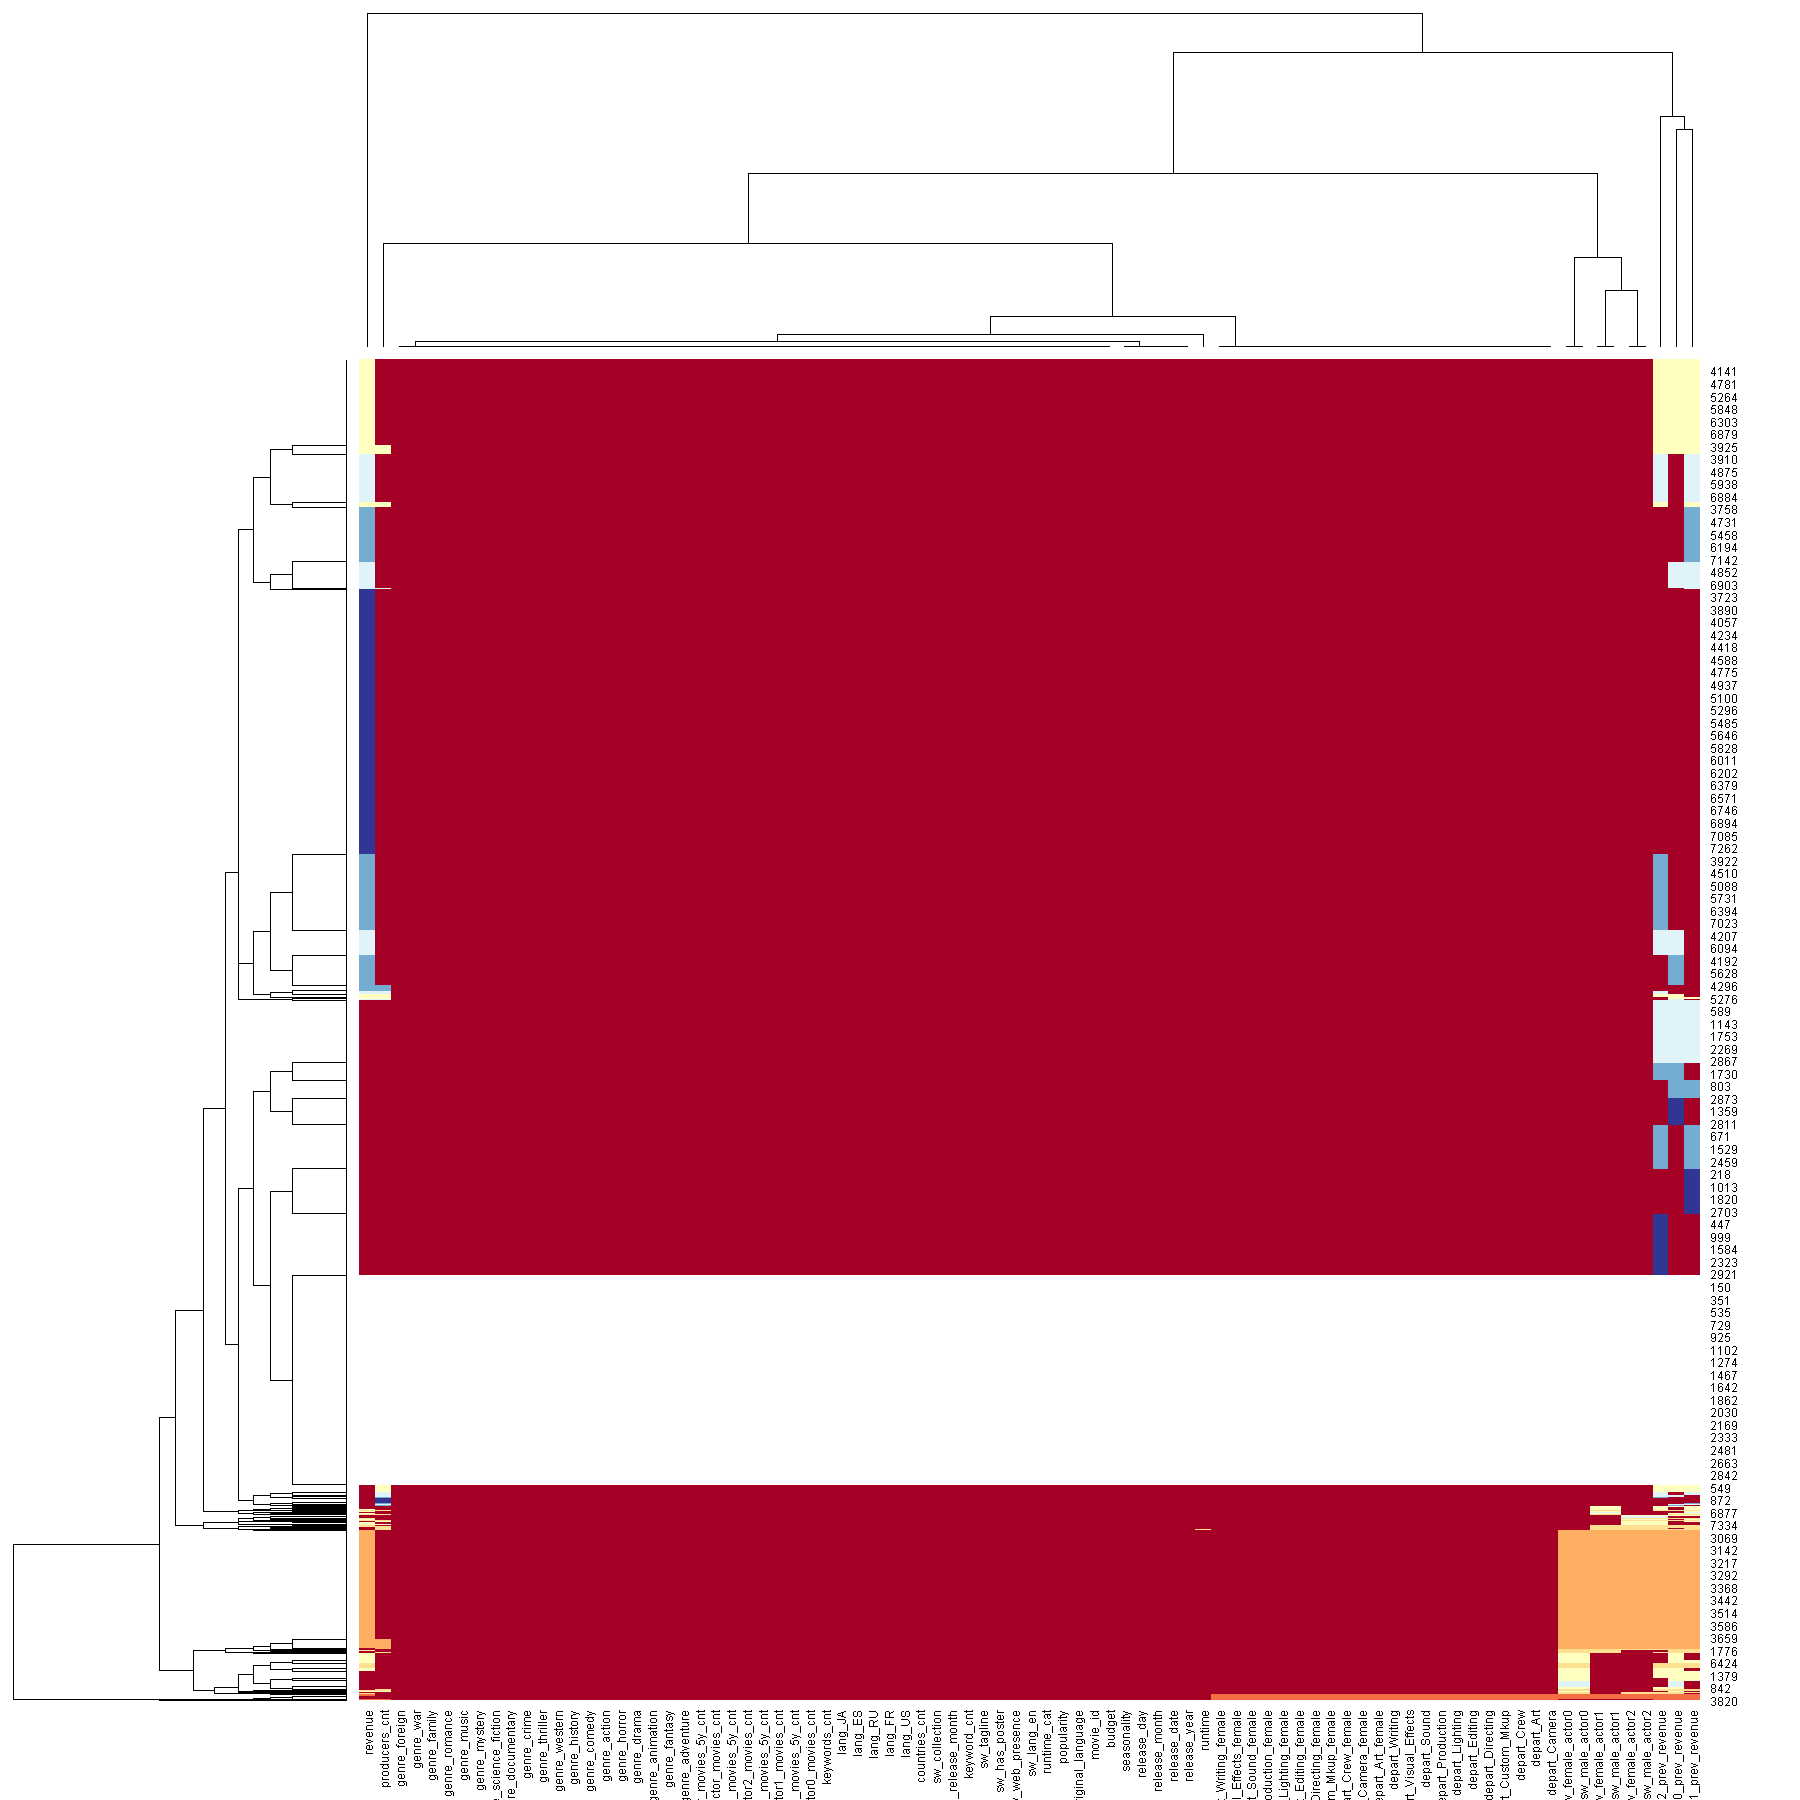

In [15]:
heatmap(as.matrix(movies_missing),cexCol = 0.7, cexRow = 0.7, col=brewer.pal(n=ncol(movies_ff), name="RdYlBu"))

In [16]:
if (!require("VIM")) install.packages("VIM")

Loading required package: VIM

Warning message:
"package 'VIM' was built under R version 3.6.2"
Loading required package: colorspace

Loading required package: grid

Loading required package: data.table

Warning message:
"package 'data.table' was built under R version 3.6.2"

Attaching package: 'data.table'


The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:pastecs':

    first, last


VIM is ready to use. 
 Since version 4.0.0 the GUI is in its own package VIMGUI.

          Please use the package to use the new (and old) GUI.


Suggestions and bug-reports can be submitted at: https://github.com/alexkowa/VIM/issues


Attaching package: 'VIM'


The following object is masked from 'package:datasets':

    sleep




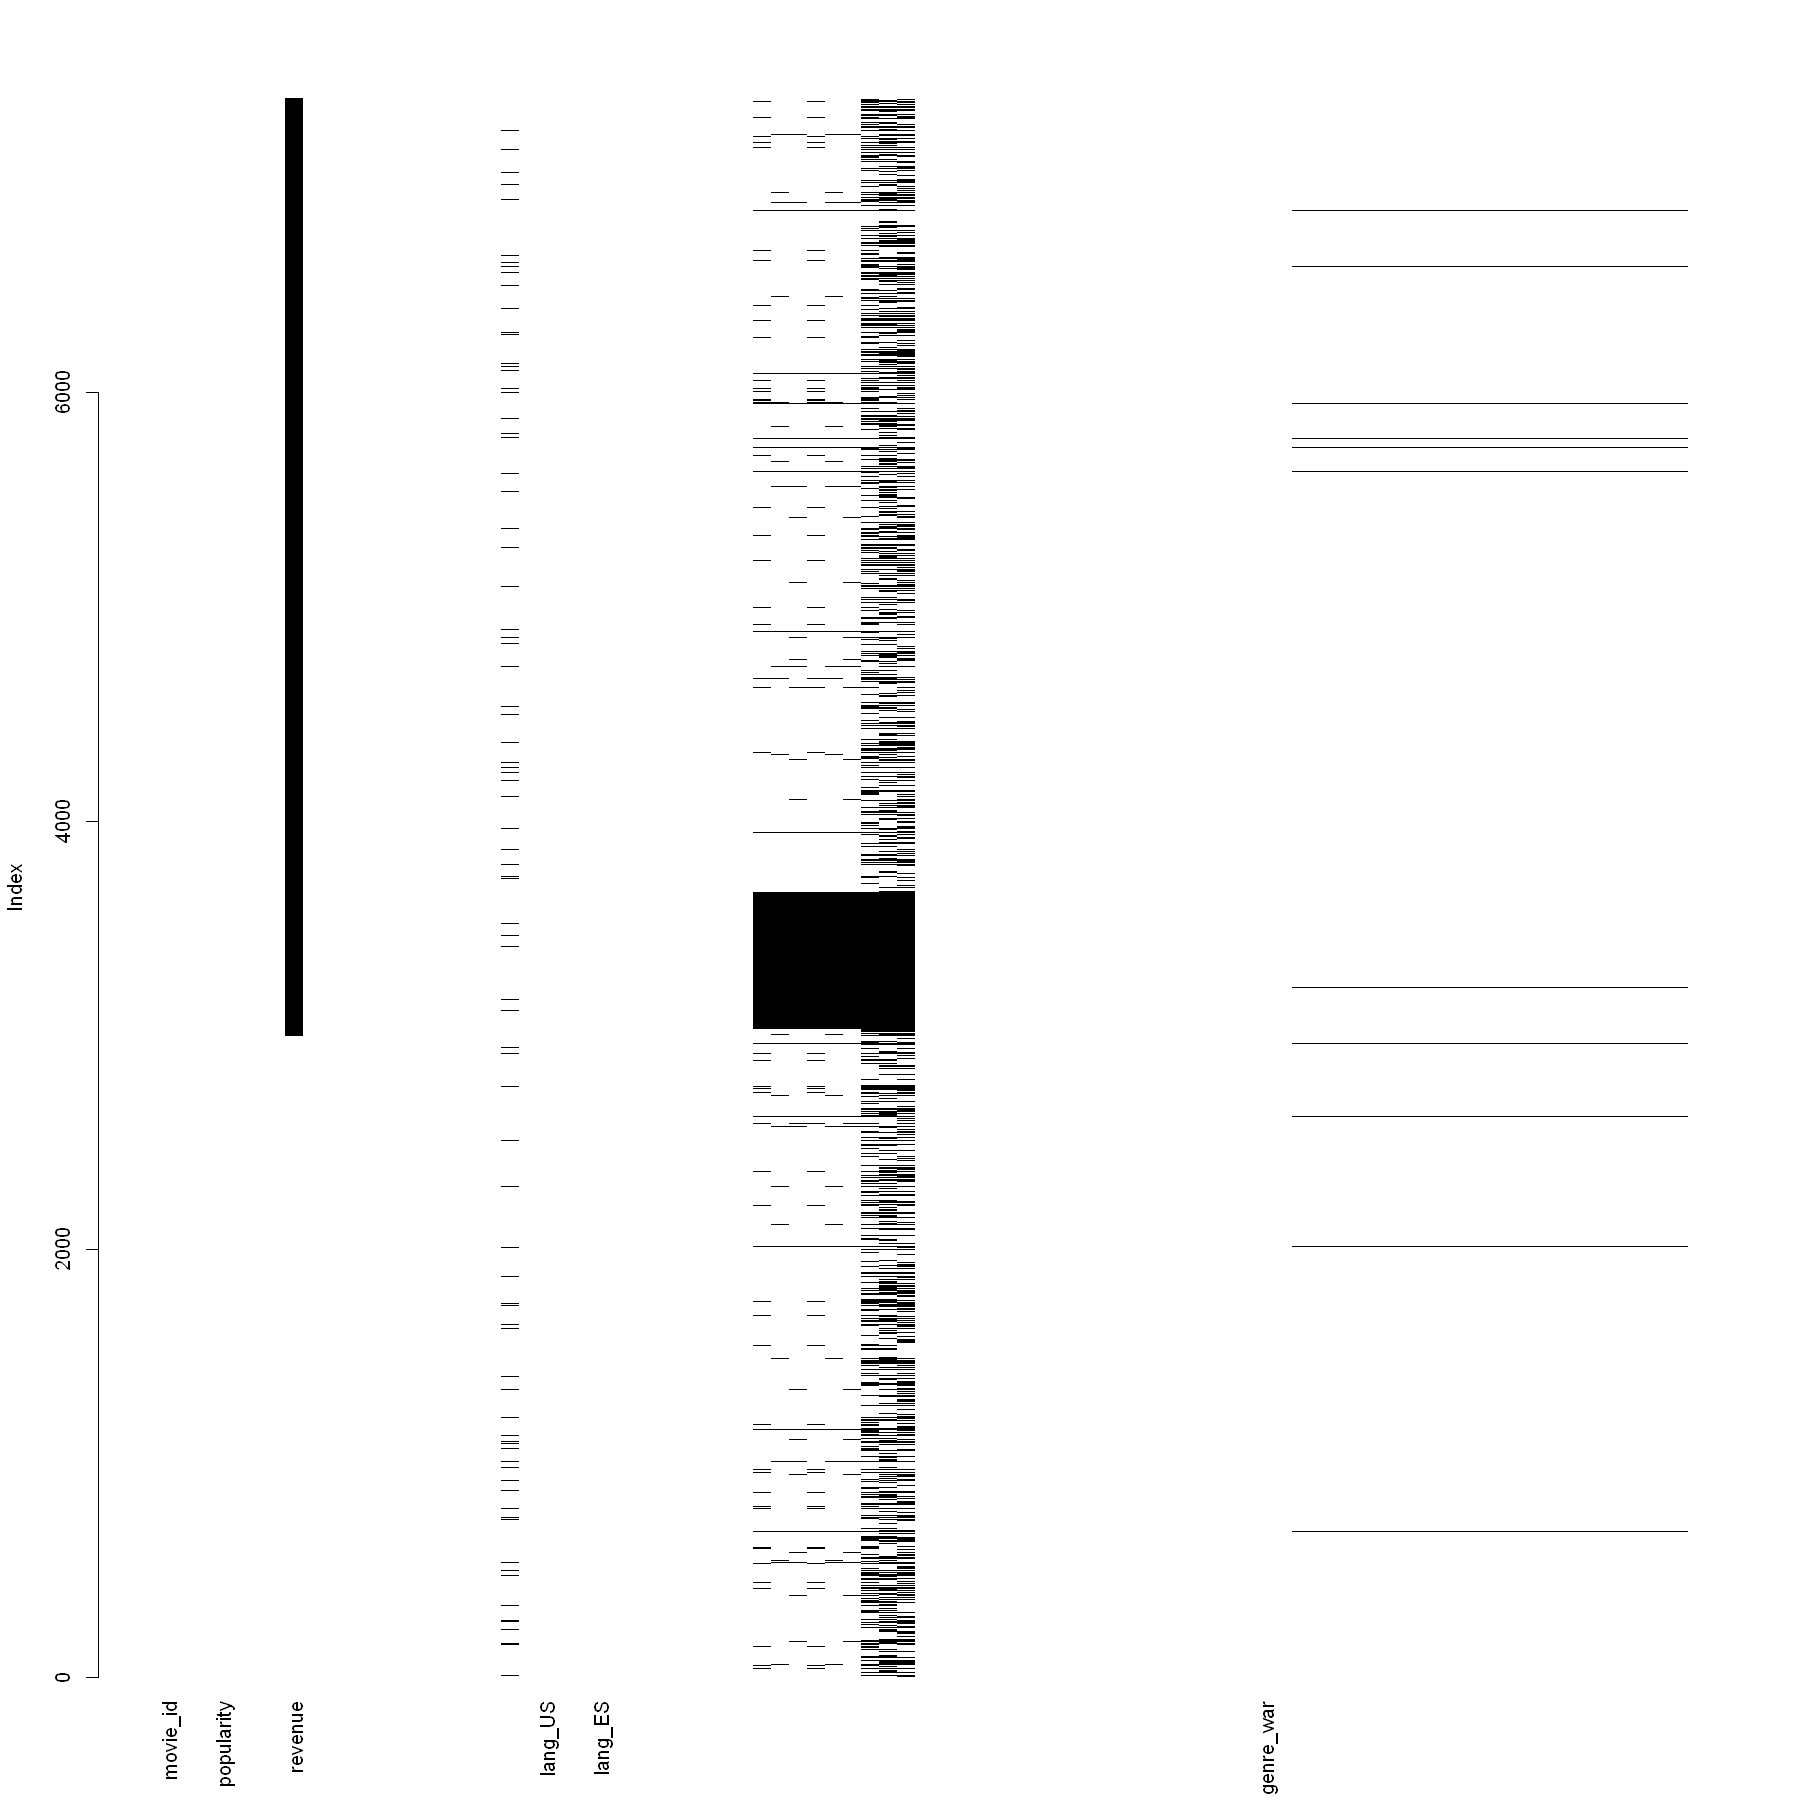

In [17]:
matrixplot(as.matrix(movies_missing))

# 3.1.1 density of outliers 

In [151]:
newdf <- merge(movies_ff, movies_outliers , by = "movie_id")
newdf

movie_id budget    original_language popularity release_date runtime
1     1        14000000 en                 6.575393  2015-02-20    93    
2     2        40000000 en                 8.248895  2004-08-06   113    
3     3         3300000 en                64.299990  2014-10-10   105    
4     4         1200000 hi                 3.174936  2012-03-09   122    
5     5               0 ko                 1.148070  2009-02-05   118    
6     6         8000000 en                 0.743274  1987-08-06    83    
7     7        14000000 en                 7.286477  2012-08-30    92    
8     8               0 en                 1.949044  2004-01-15    84    
9     9               0 en                 6.902423  1996-02-16   100    
10   10         6000000 en                 4.672036  2003-04-16    91    
11   11         1000000 en                14.774066  1976-11-21   119    
12   12               0 en                10.543750  1987-07-10    98    
13   13        15000000 en                20.726578  1999-09-15   122    
14   14        53000000 en                13.314233  2005-03-04   118    
15   15       102000000 en                20.666063  2002-06-20   145    
16   16          500000 sr                 1.018477  2010-10-06    97    
17   17        26000000 en                 6.336927  2005-08-04    85    
18   18               0 en                 4.183558  2013-12-25   111    
19   19         8000000 en                 6.496259  2011-02-02    96    
20   20        32000000 en                11.359659  2005-08-02    87    
21   21        80000000 en                12.000579  1998-04-03   130    
22   22         4000000 en                 7.992290  1982-08-13    95    
23   23               0 en                 7.820787  2012-07-28   116    
24   24               0 en                 1.323333  2011-09-02    92    
25   25               0 en                 7.434577  2006-09-09    87    
26   26               0 en                 1.252367  1992-10-23    95    
27   27        10000000 en                 4.305735  1997-09-08   110    
28   28        11000000 en                10.841891  2013-09-07    93    
29   29         6000000 en                 6.759181  1986-08-08    84    
30   30        45000000 en                 7.818620  2002-04-07    89    
...  ...      ...       ...               ...        ...          ...    
7346 7369      25000000 en                 8.826071  2016-01-01    98    
7347 7370      30000000 en                13.436536  2008-03-14   108    
7348 7371             0 en                 1.789046  1999-10-15   100    
7349 7372      55000000 en                 9.276539  2010-11-23   119    
7350 7373     170000000 en                14.046164  2011-11-22   126    
7351 7374       1800000 en                 9.277692  1976-11-03    98    
7352 7375      16000000 en                14.785388  1991-05-24   130    
7353 7376             0 it                 1.405580  2002-09-06   101    
7354 7377       4000000 en                 8.418662  1970-06-22   144    
7355 7378      13200000 en                24.644321  2014-09-10    83    
7356 7379      42000000 en                 8.745216  2005-09-16   122    
7357 7380             0 en                11.009871  2015-04-30    96    
7358 7381             0 en                 5.285420  2016-06-03    86    
7359 7382        600000 en                 3.624542  1970-03-26   225    
7360 7383        800000 en                 0.903061  2006-11-23   100    
7361 7384      10000000 en                12.188120  2012-09-11   115    
7362 7385      15000000 en                11.457803  1987-08-14   114    
7363 7386      12000000 en                 6.796277  2001-12-21    93    
7364 7387             0 en                 2.201123  1991-06-28   104    
7365 7388             0 en                 8.436614  2013-09-11    90    
7366 7389       1000000 en                 2.003309  2006-01-30    81    
7367 7390             0 en                 3.097025  2013-03-22    84    
7368 7391

Warning message:
"Removed 624 rows containing non-finite values (stat_density)."
Warning message:
"Removed 201 rows containing non-finite values (stat_density)."


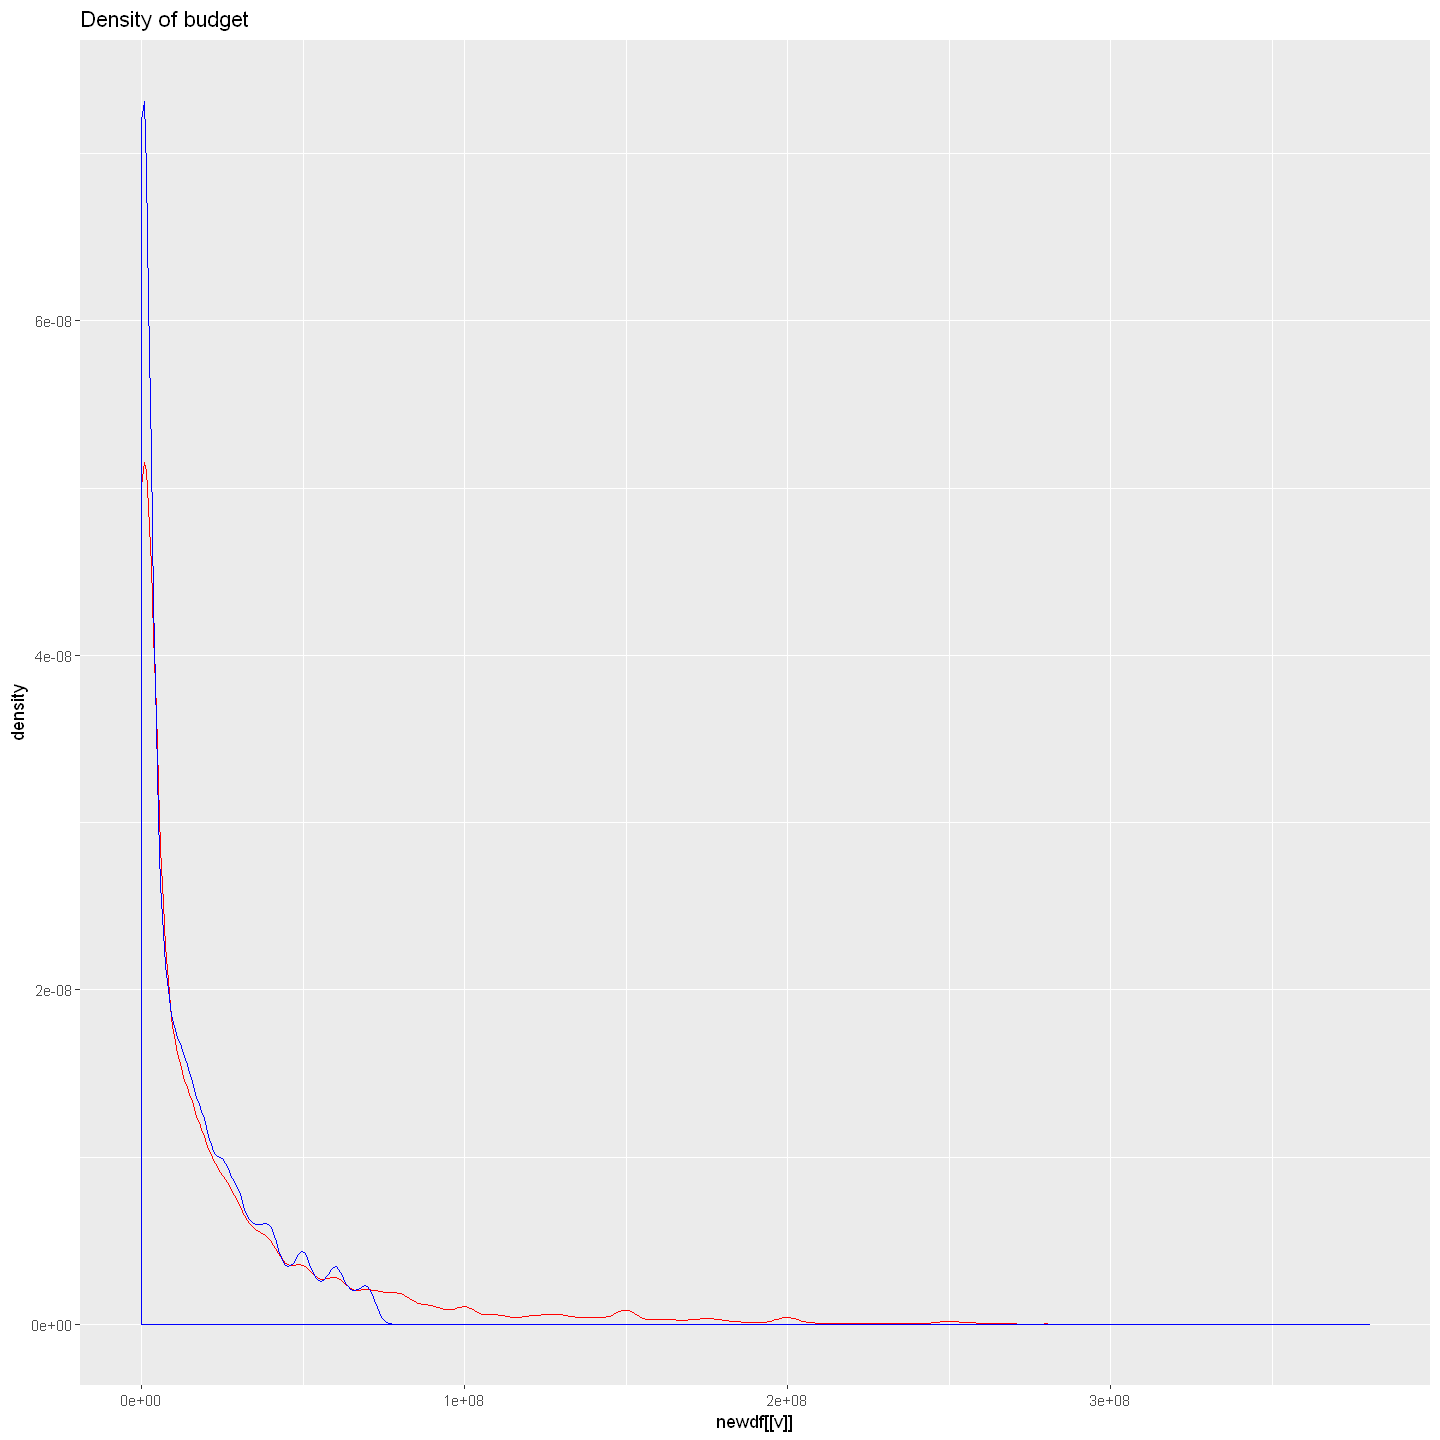

Warning message:
"Removed 5 rows containing non-finite values (stat_density)."
Warning message:
"Removed 280 rows containing non-finite values (stat_density)."


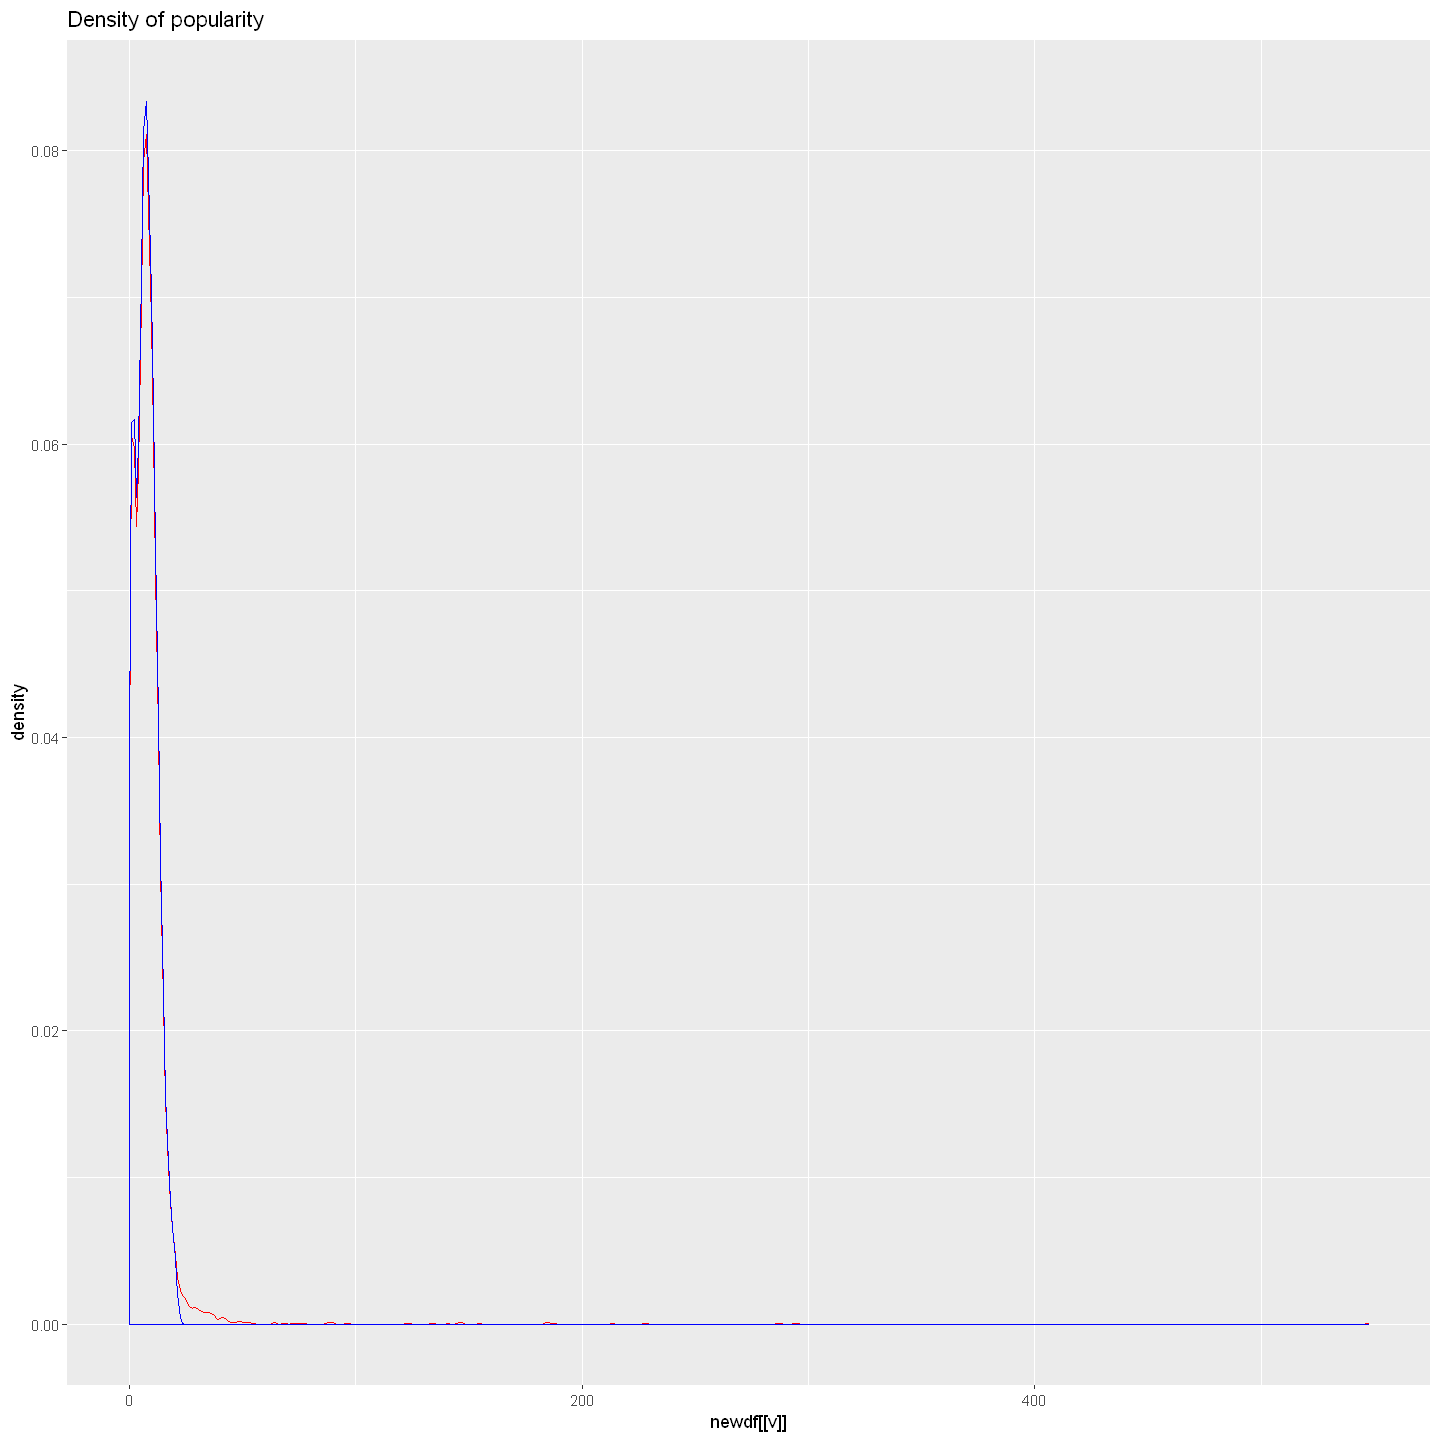

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."
Warning message:
"Removed 4697 rows containing non-finite values (stat_density)."


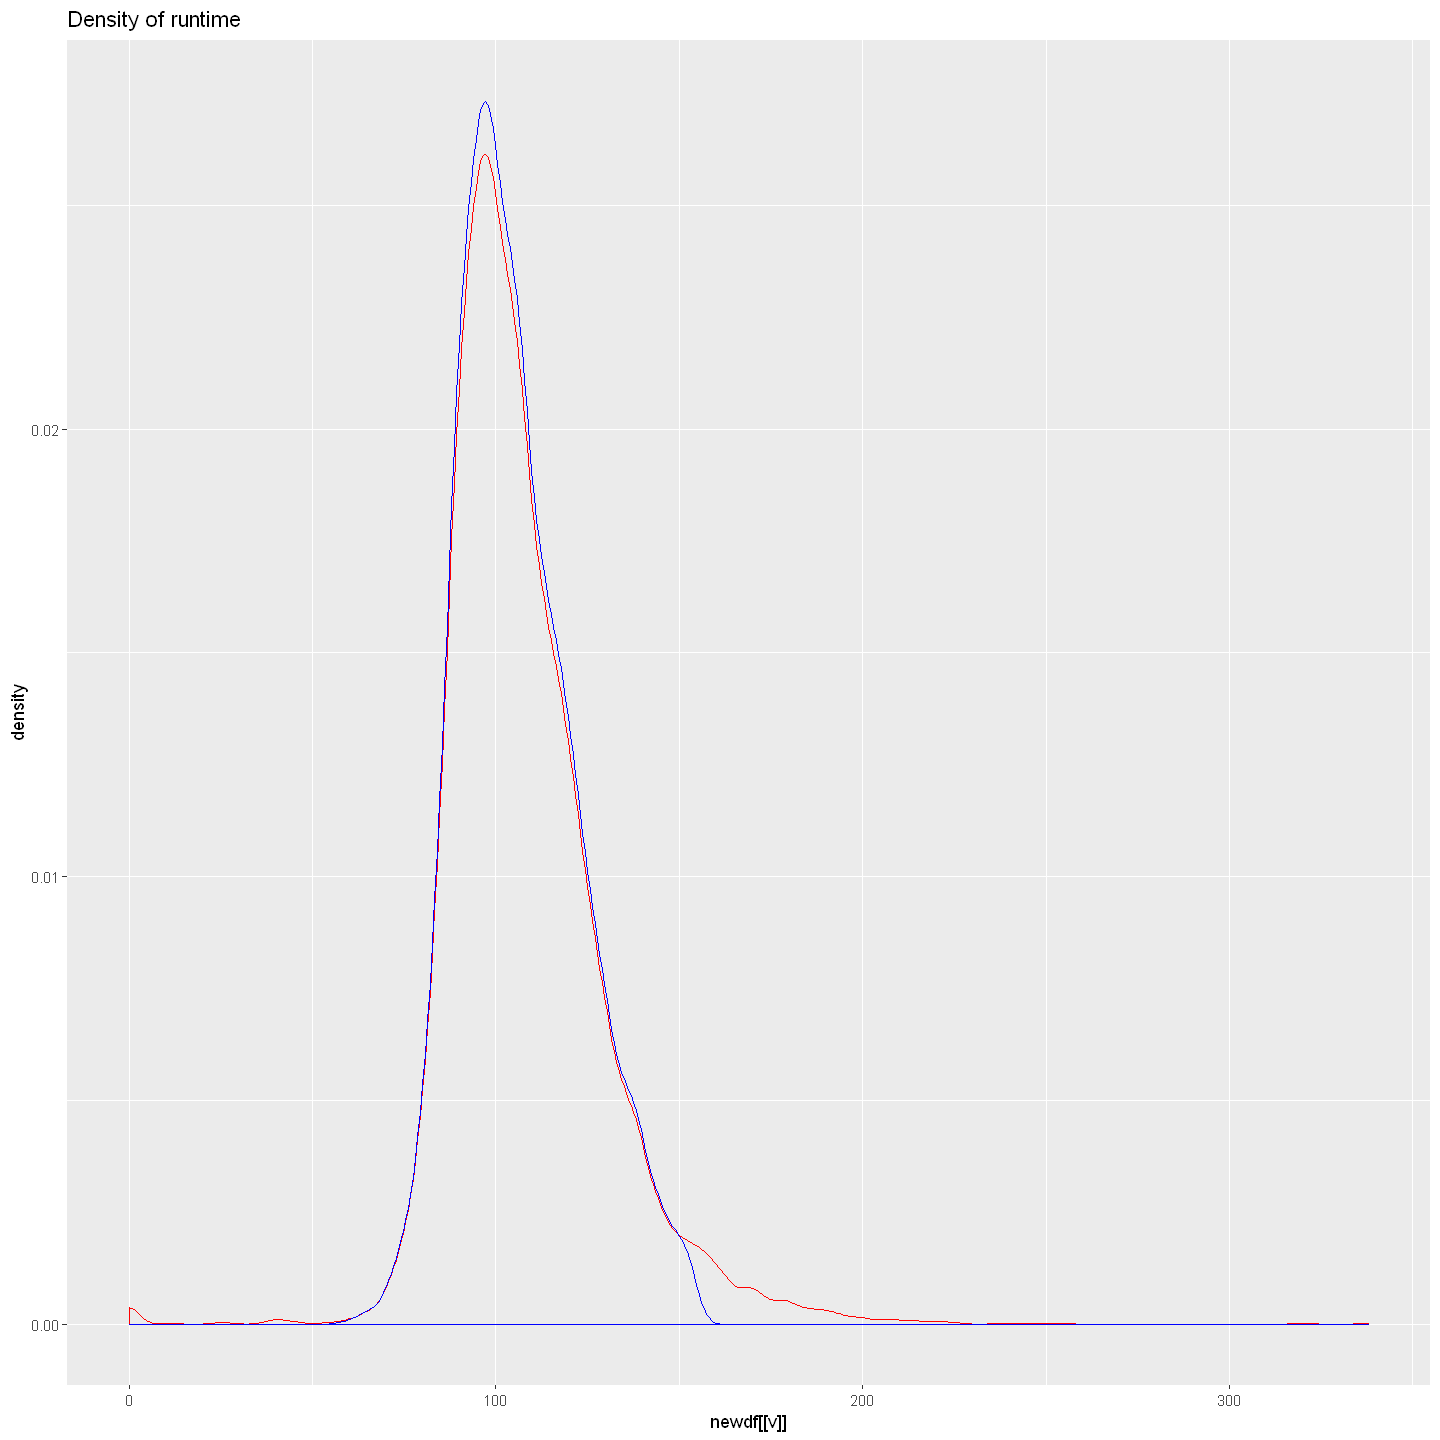

Warning message:
"Removed 1039 rows containing non-finite values (stat_density)."


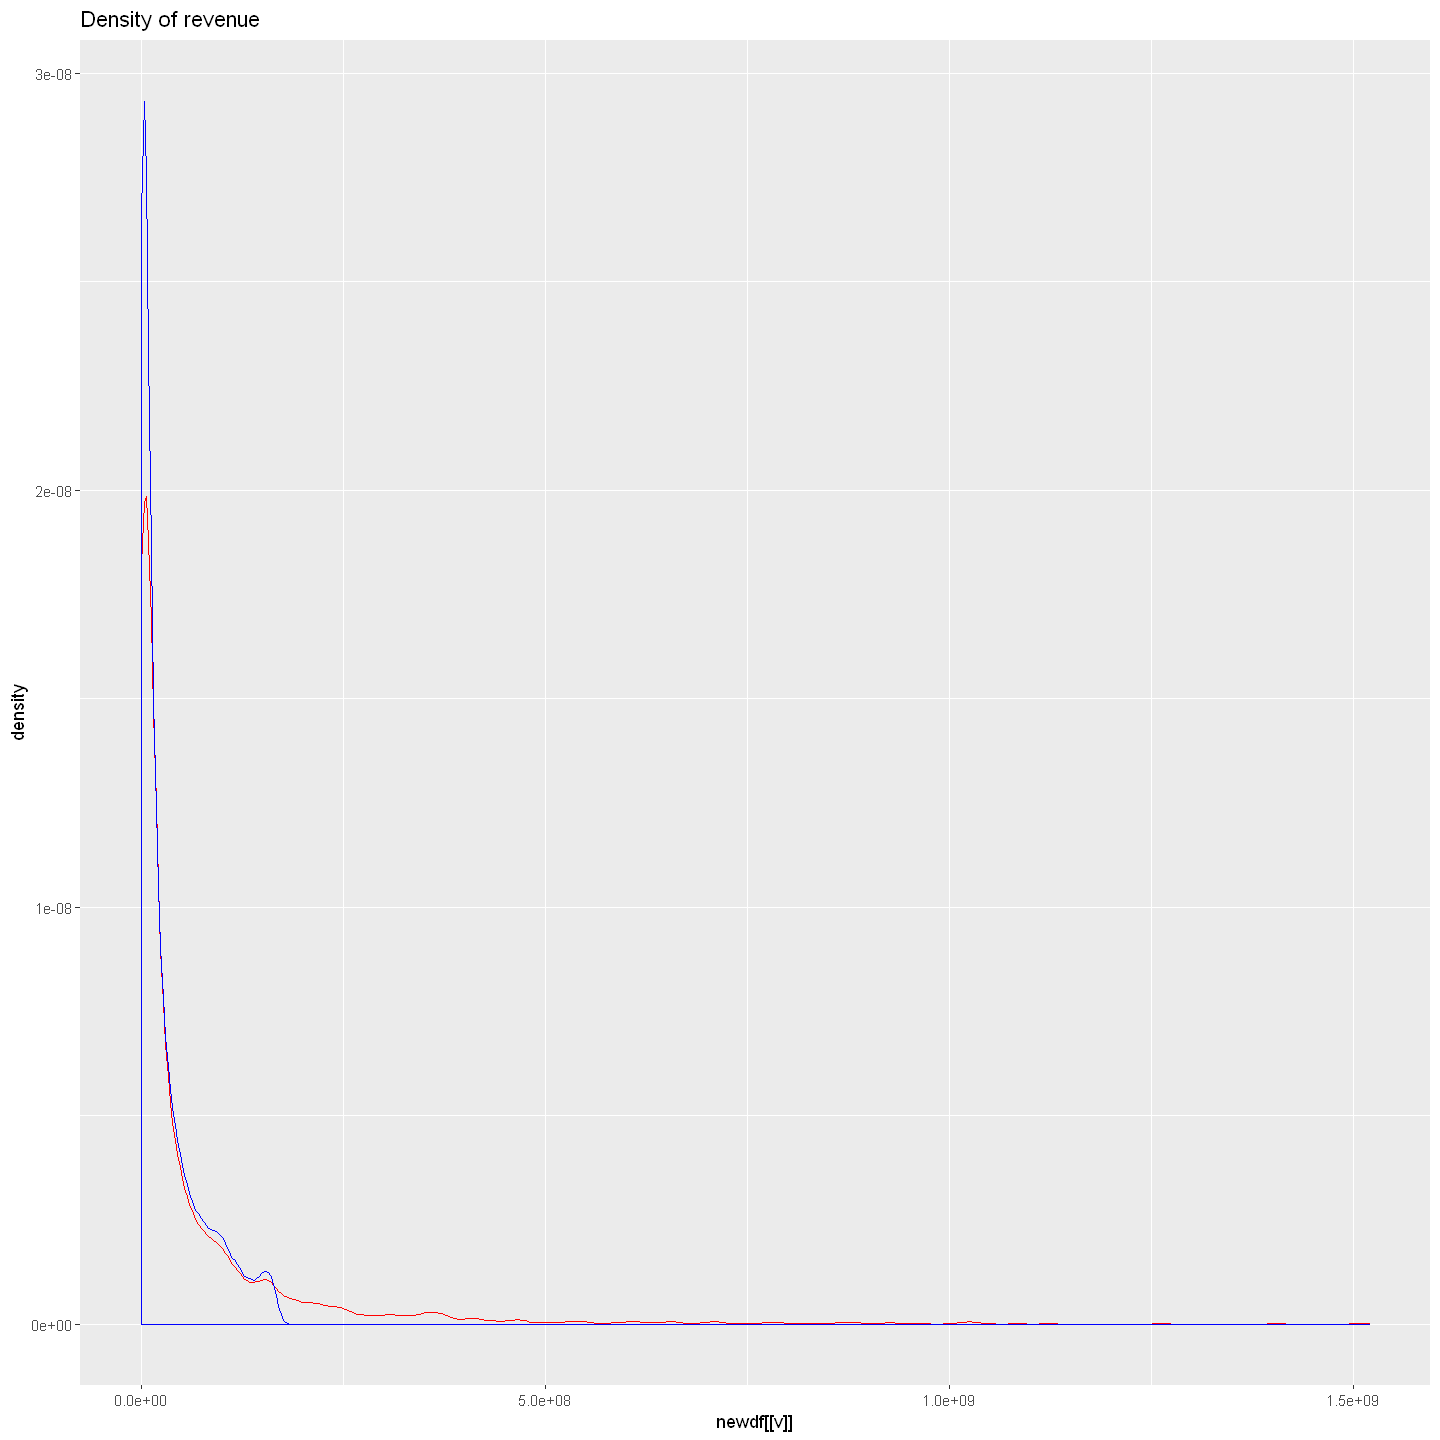

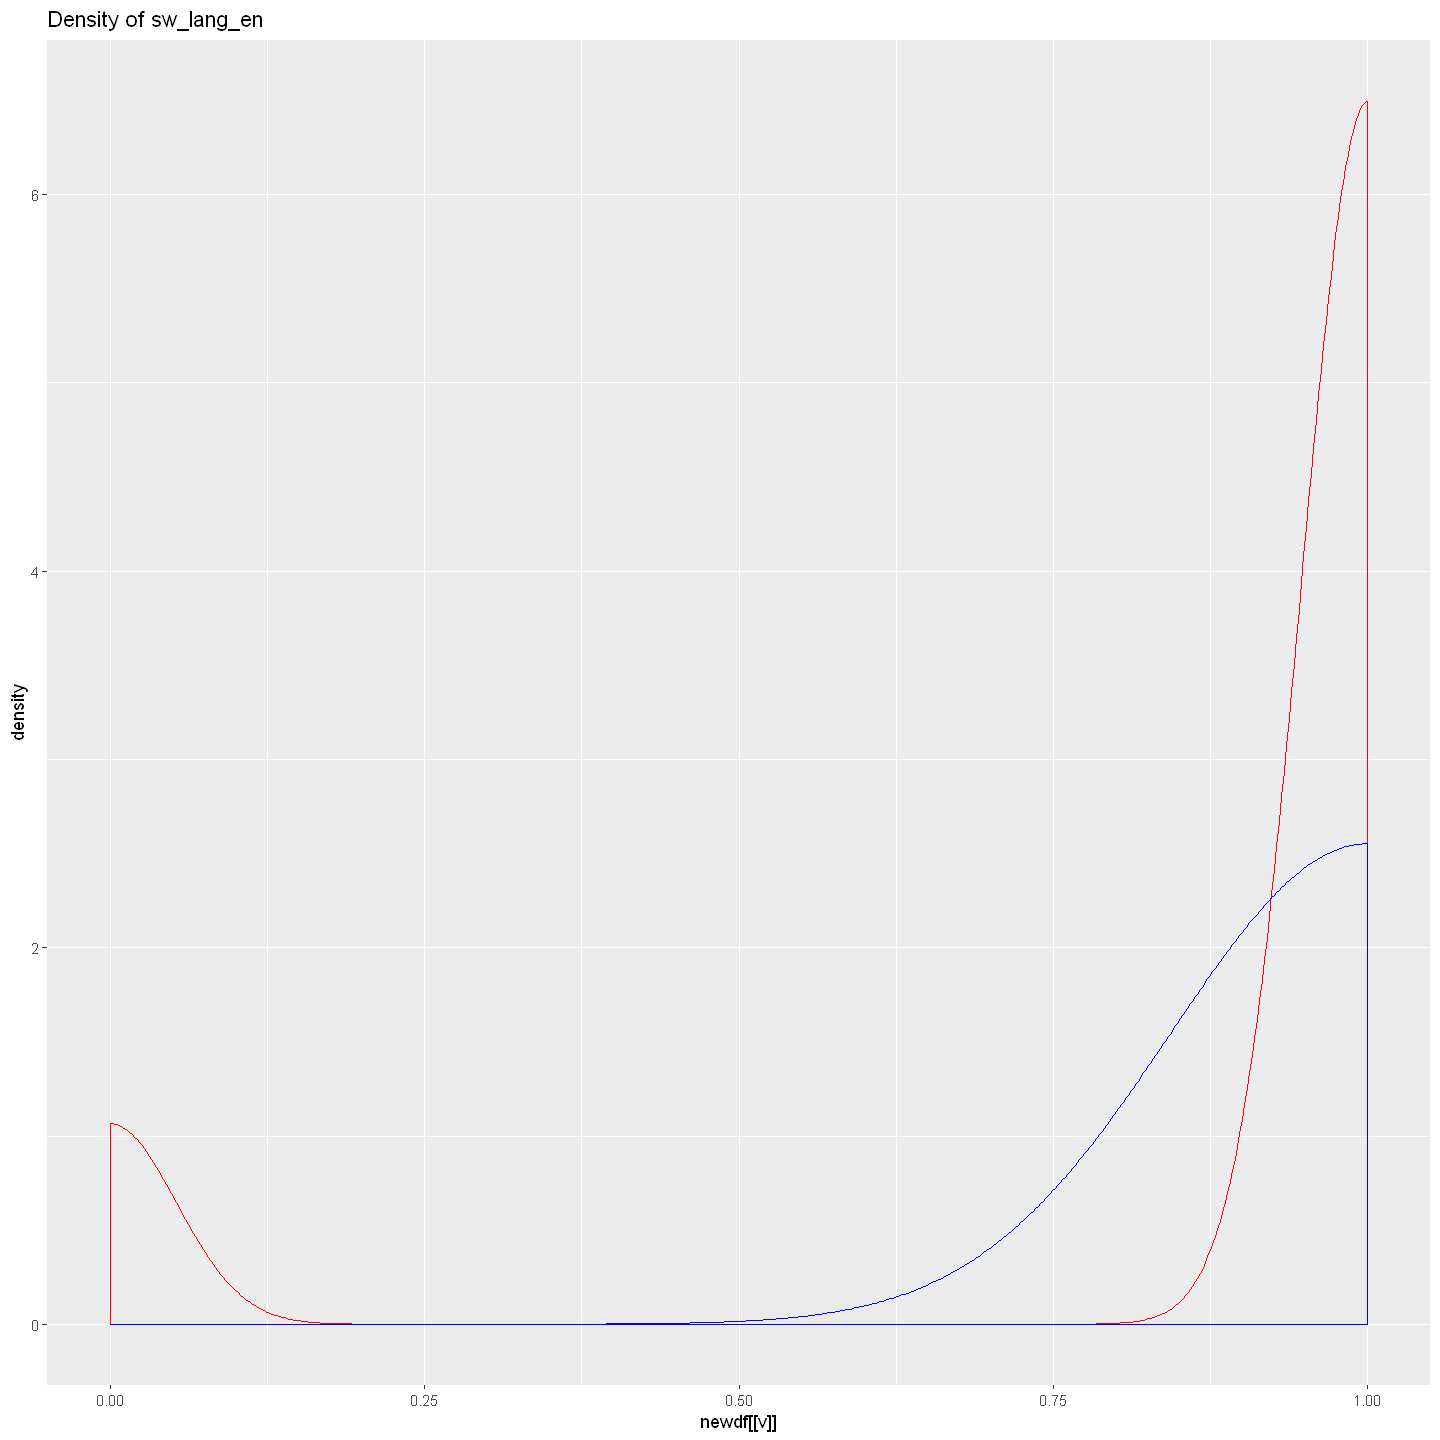

Warning message:
"Removed 2 rows containing non-finite values (stat_density)."


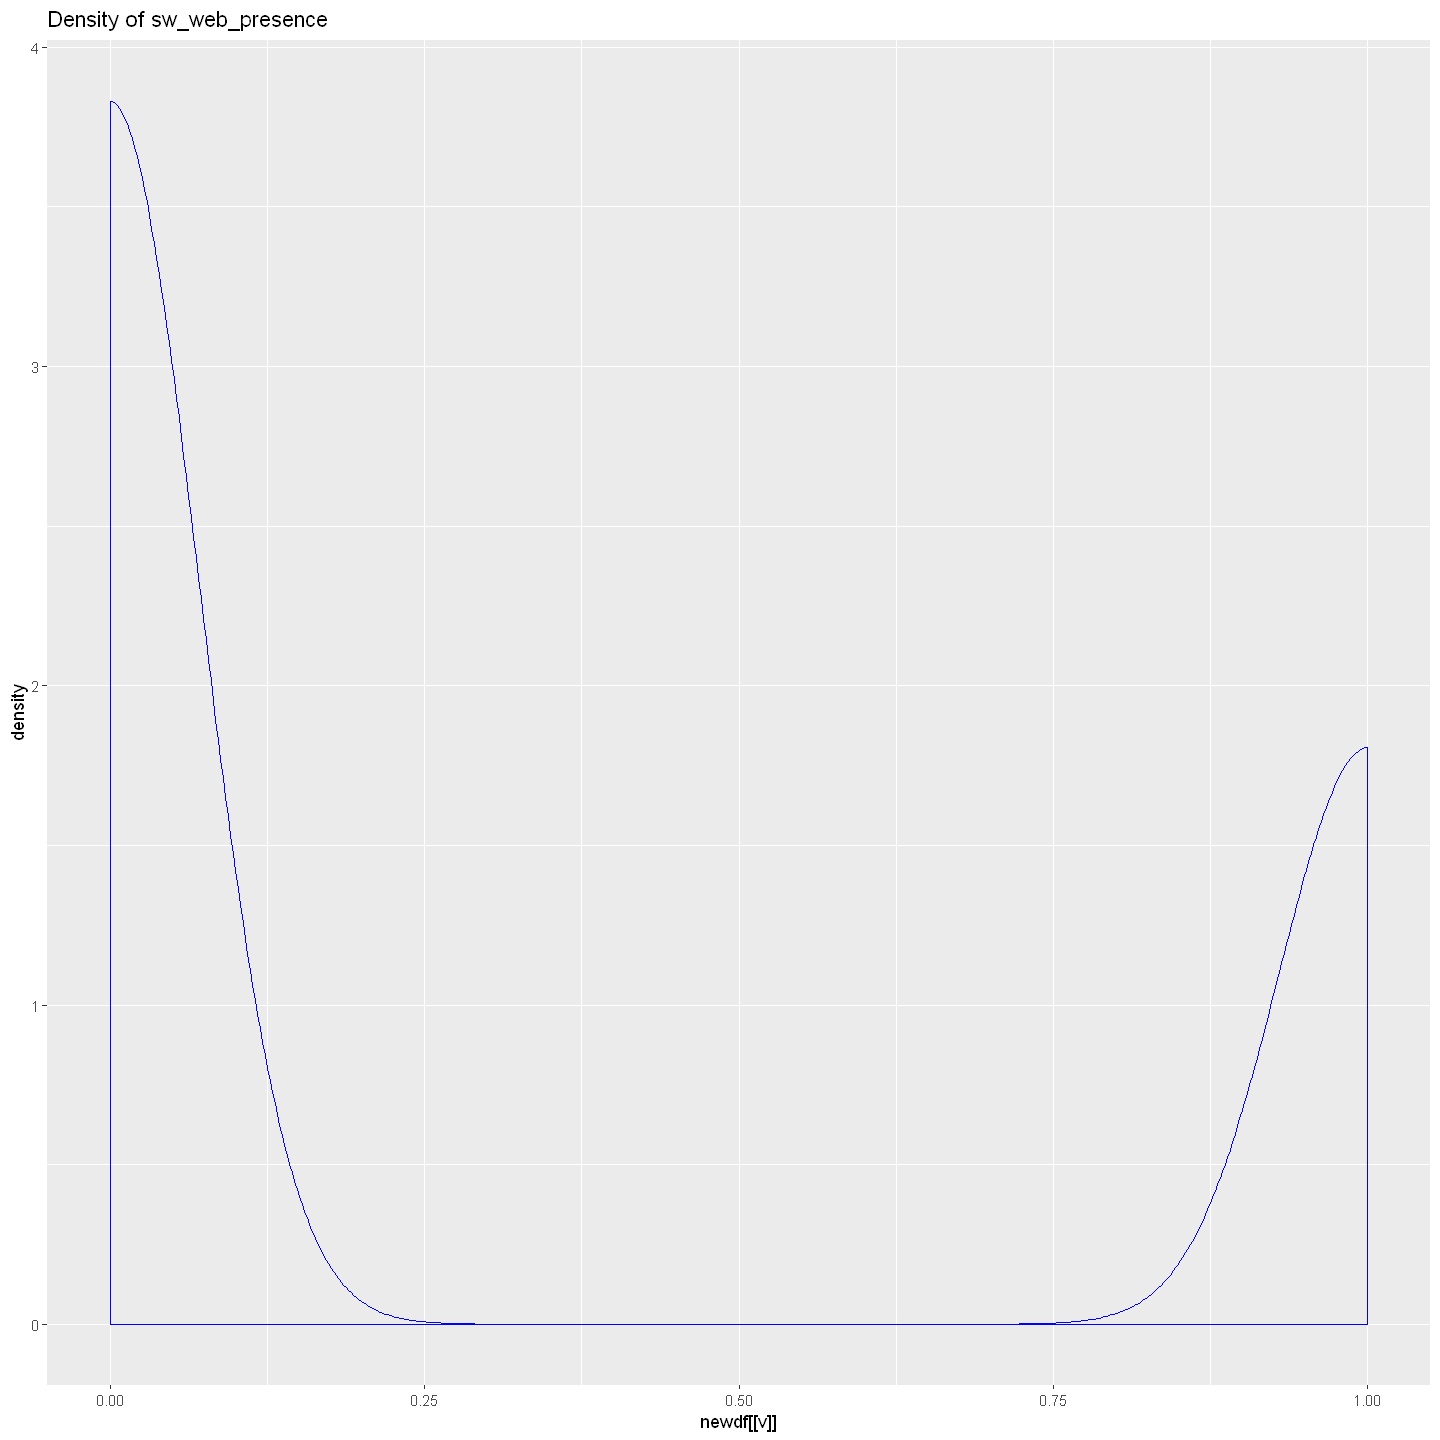

Warning message:
"Removed 1442 rows containing non-finite values (stat_density)."


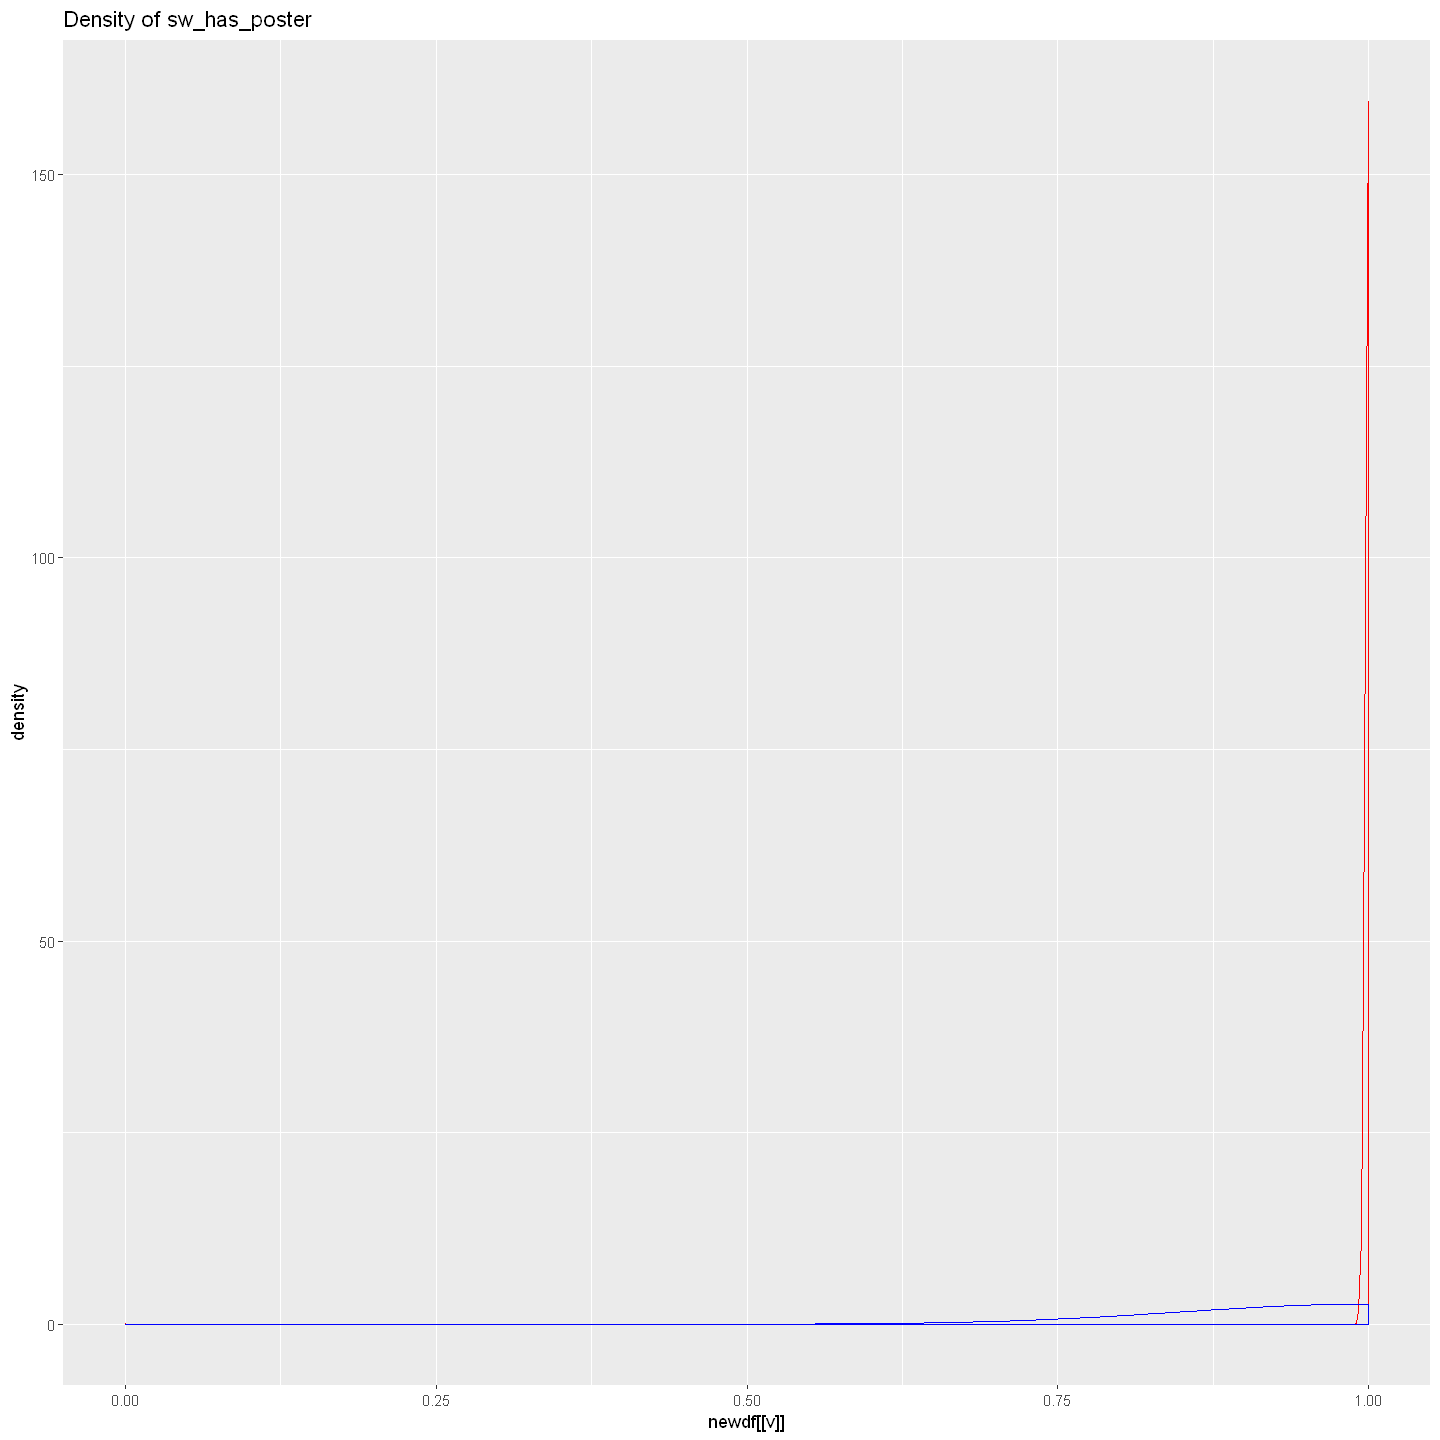

Warning message:
"Removed 278 rows containing non-finite values (stat_density)."


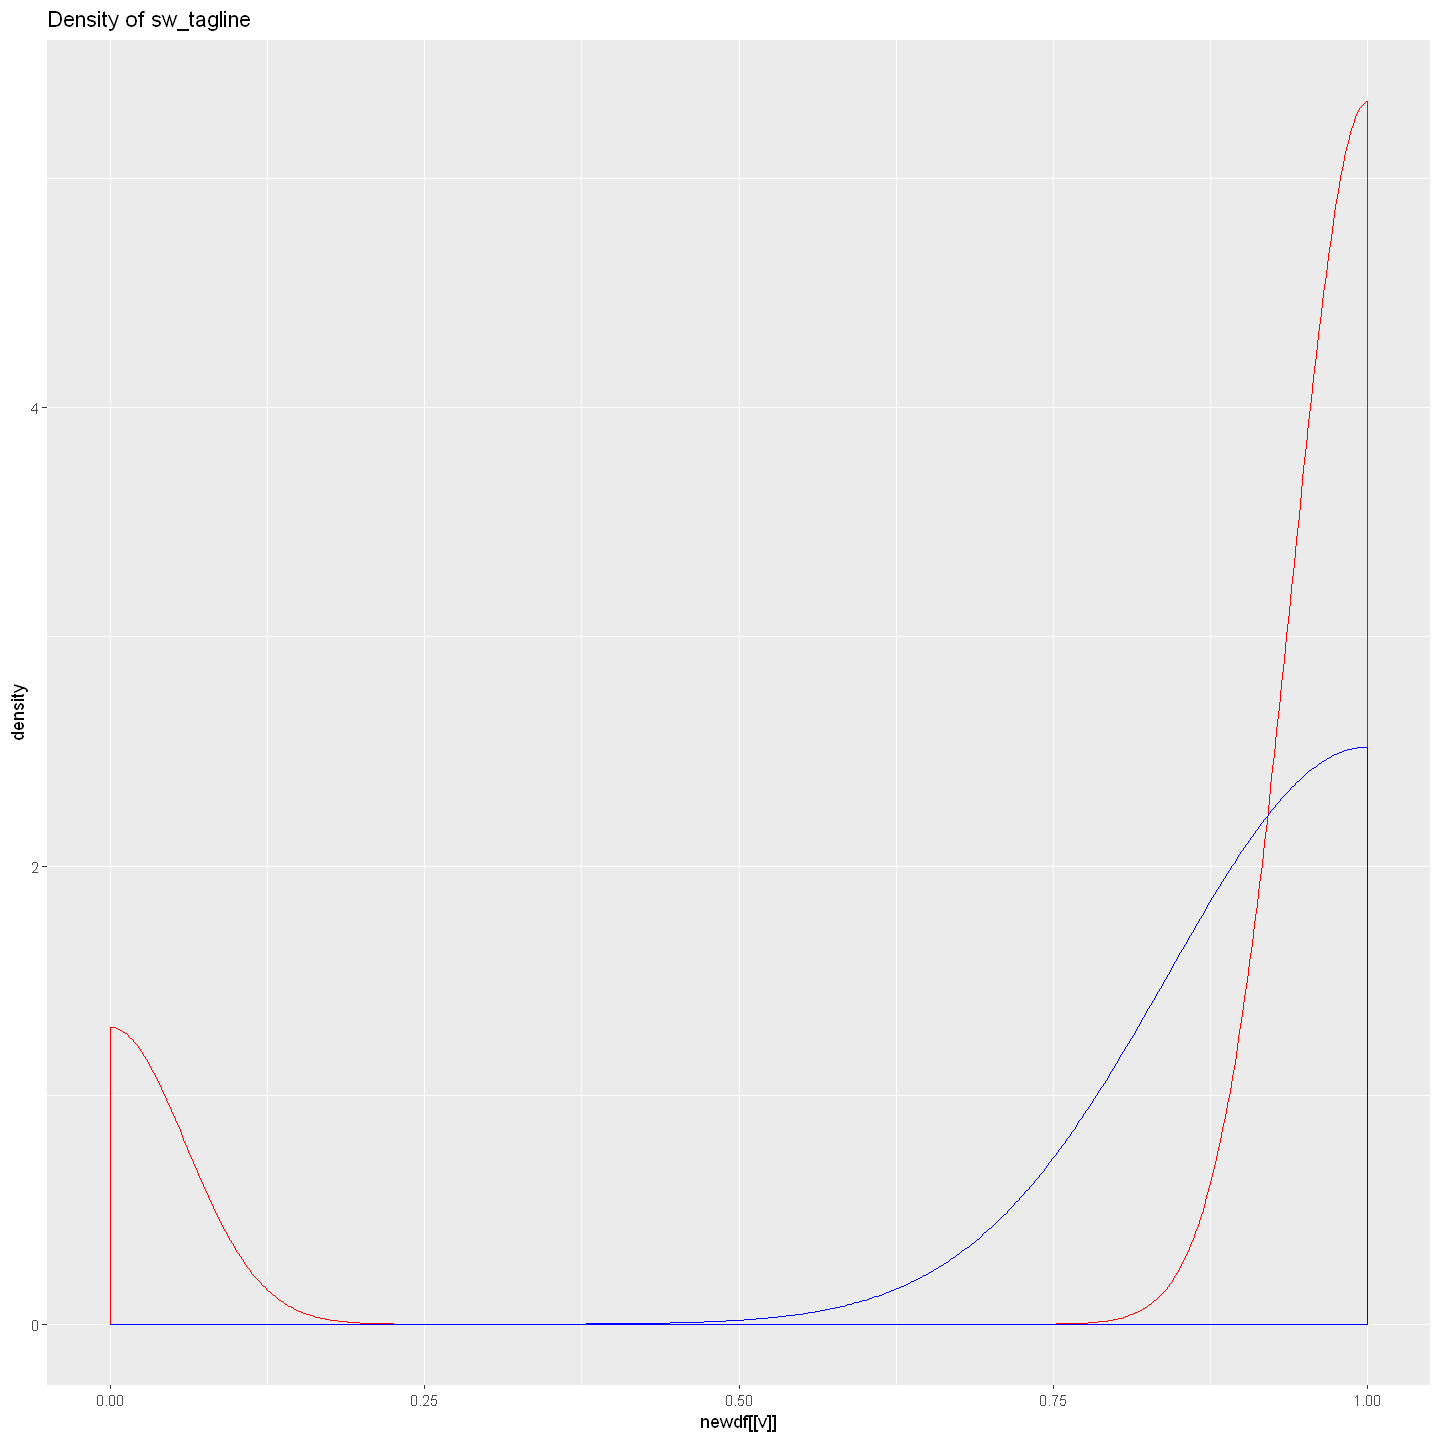

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."
Warning message:
"Removed 270 rows containing non-finite values (stat_density)."


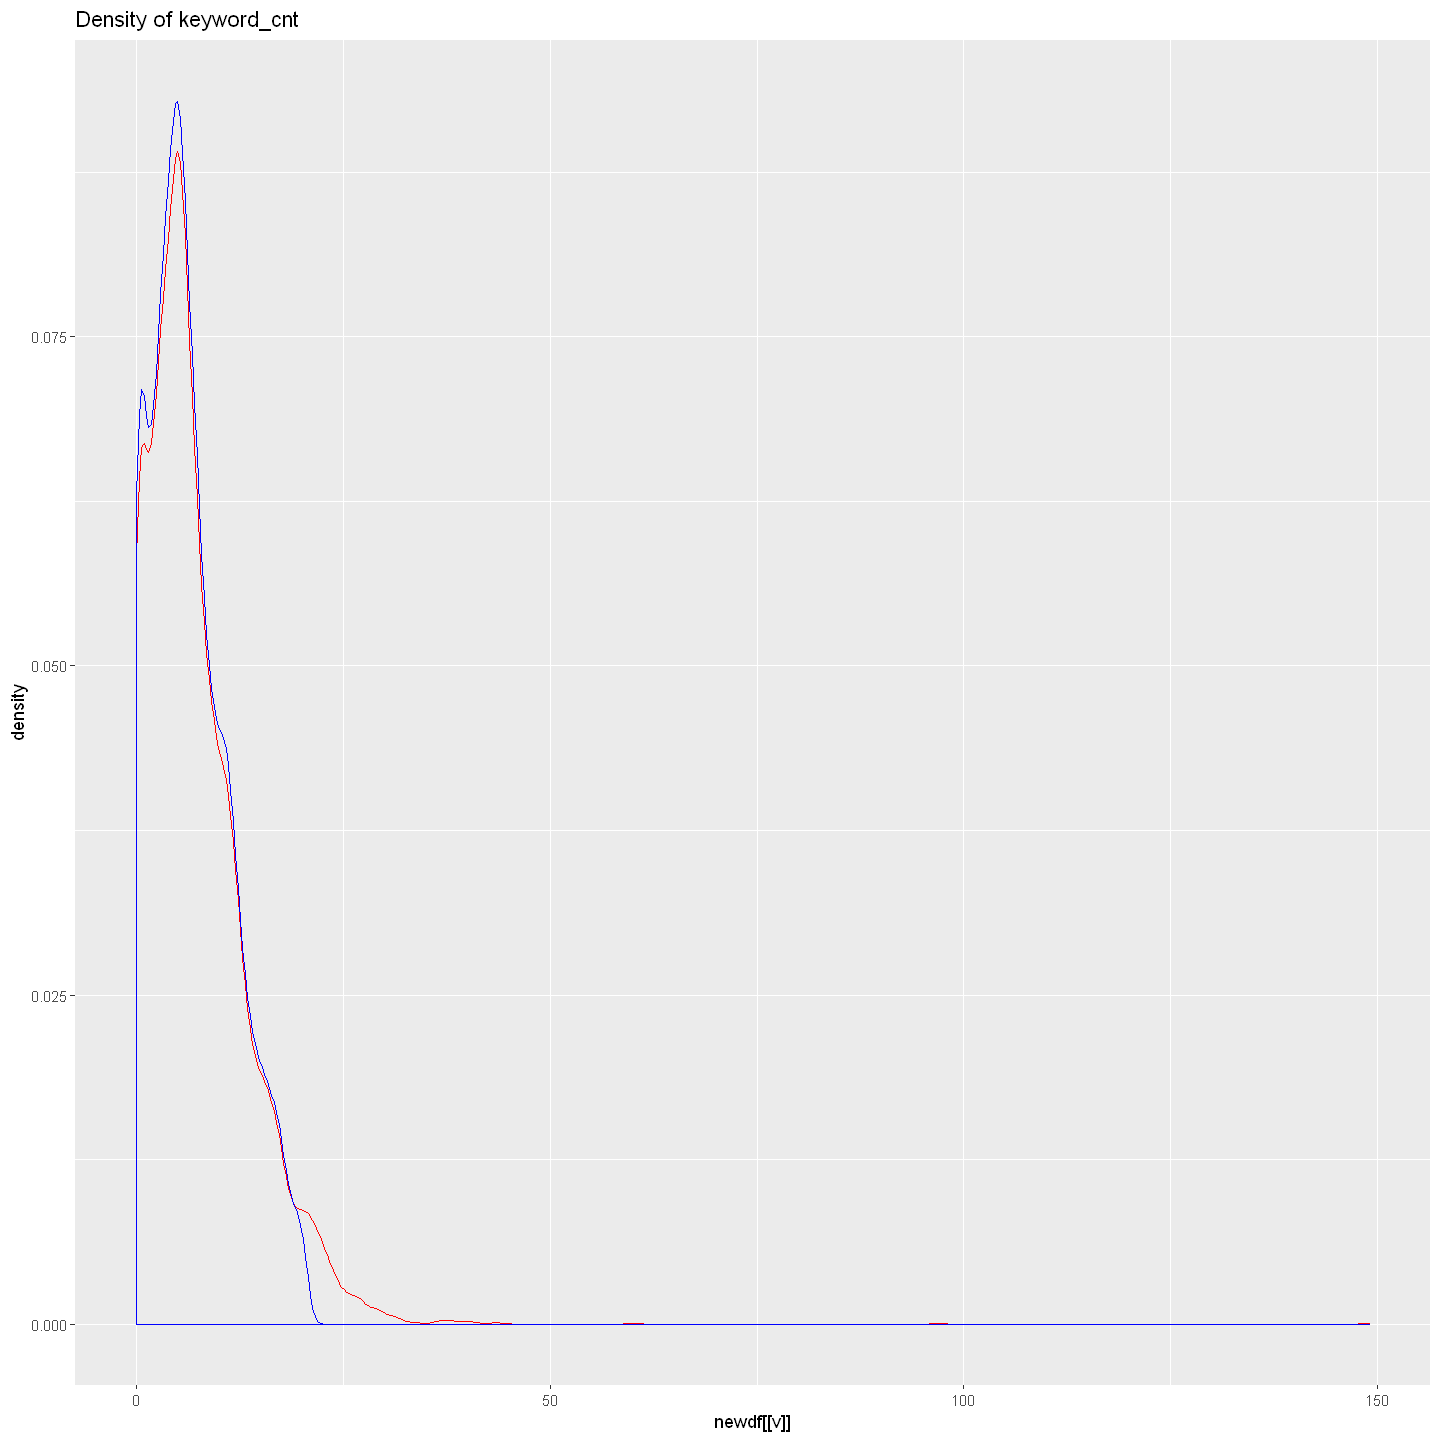

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1 rows containing non-finite values (stat_density)."


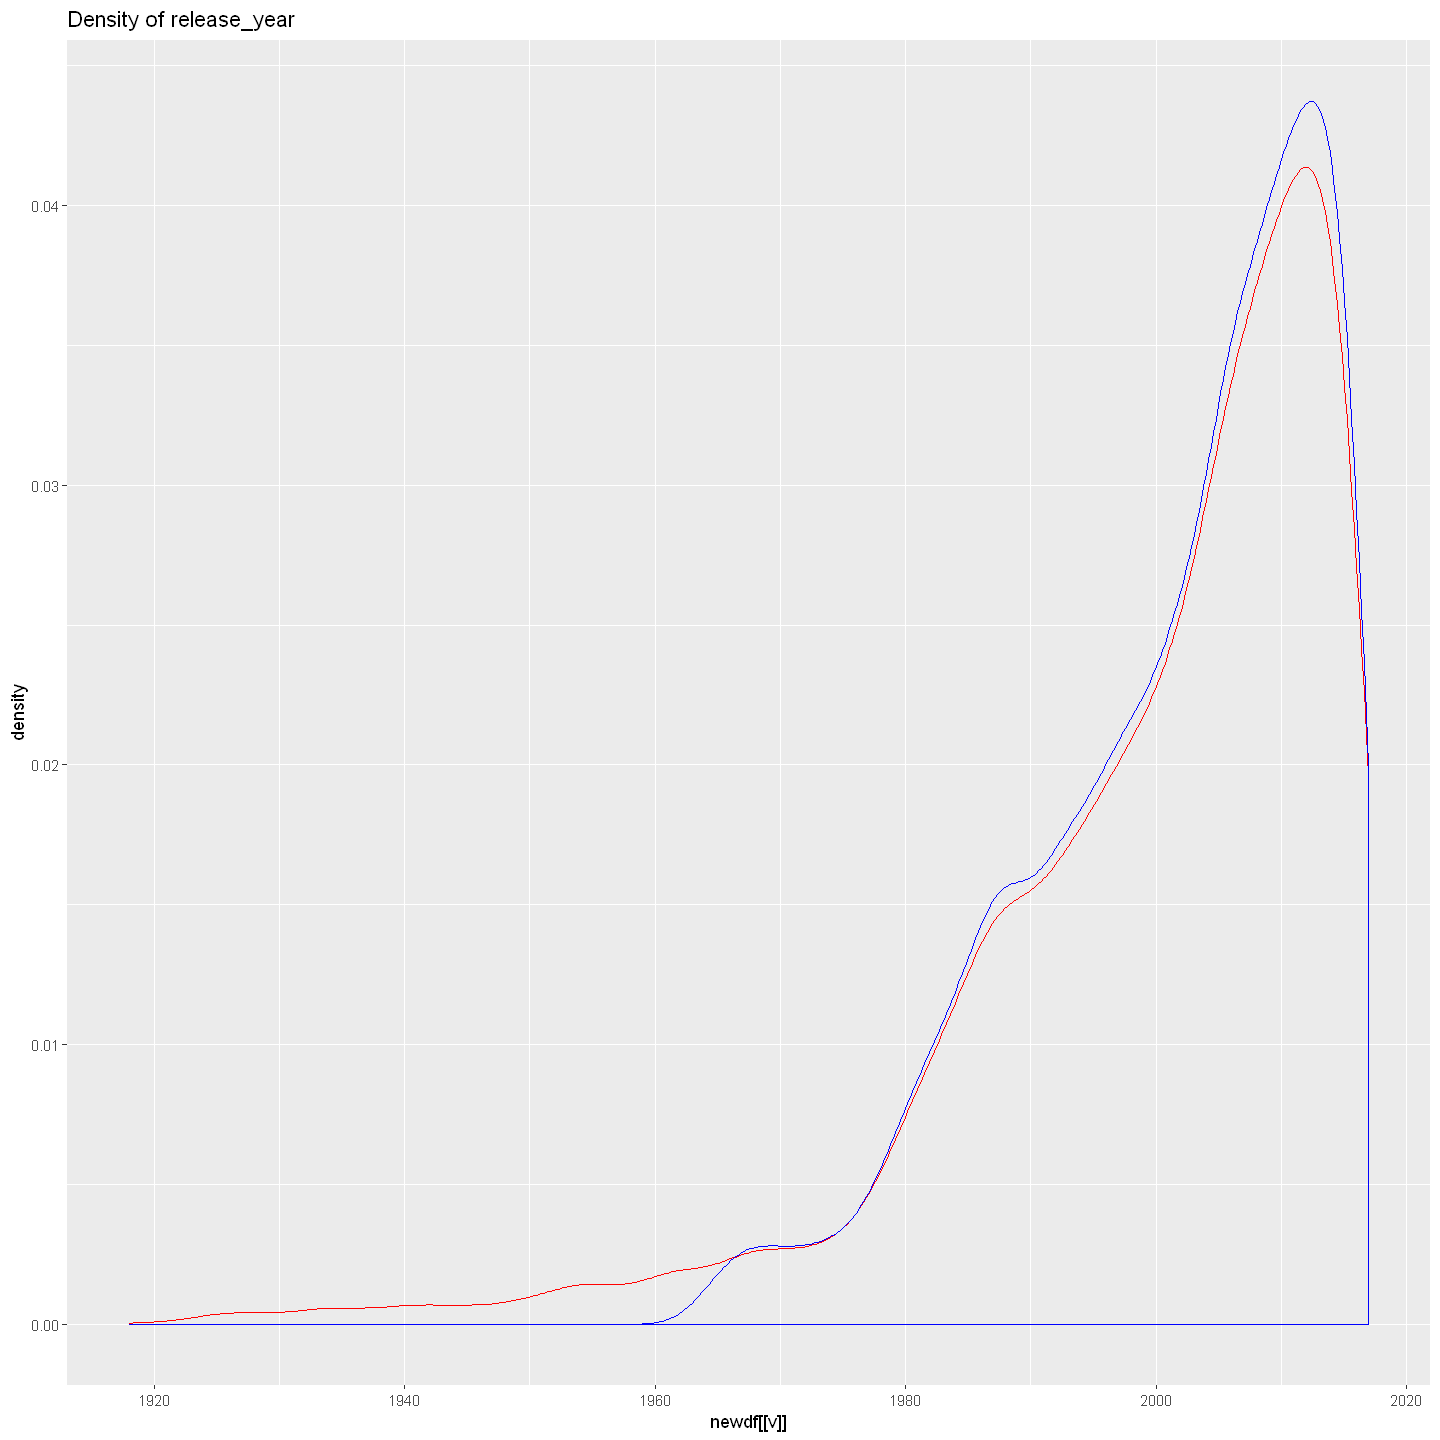

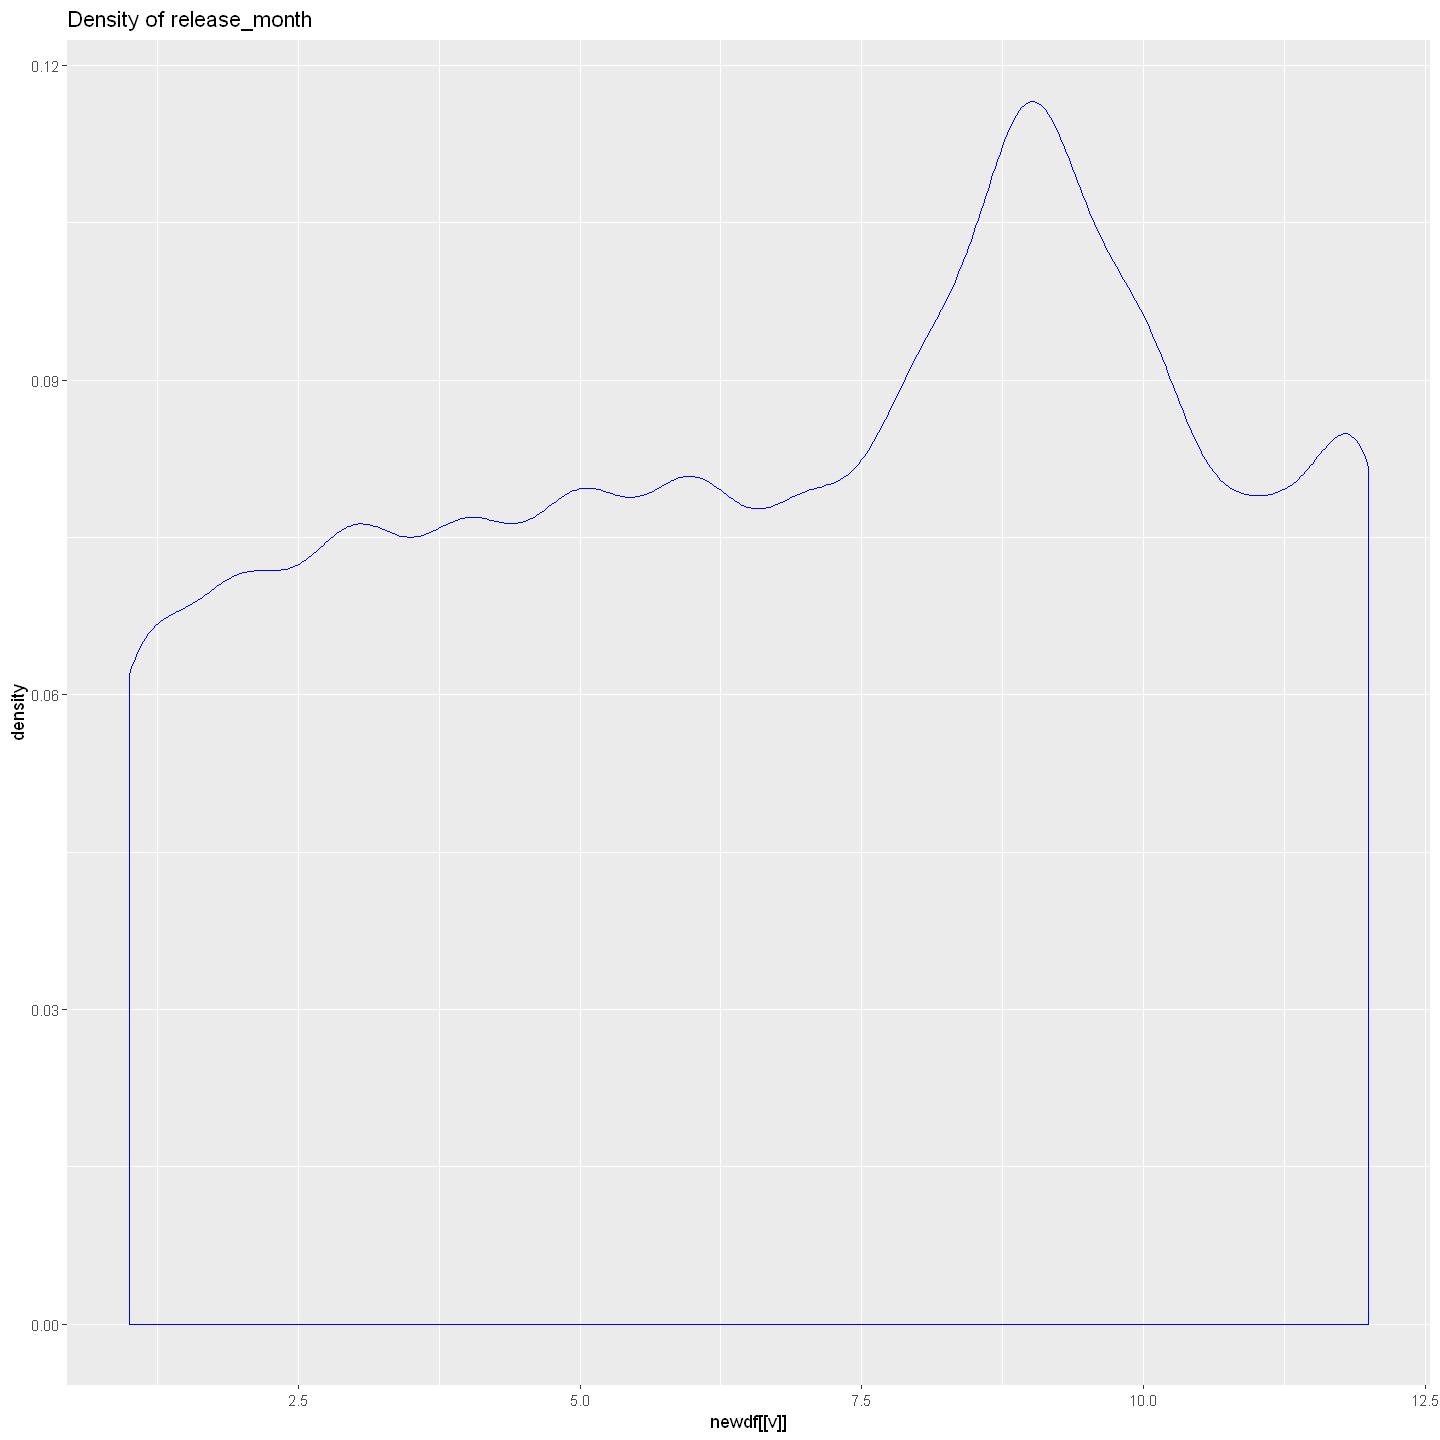

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1 rows containing non-finite values (stat_density)."


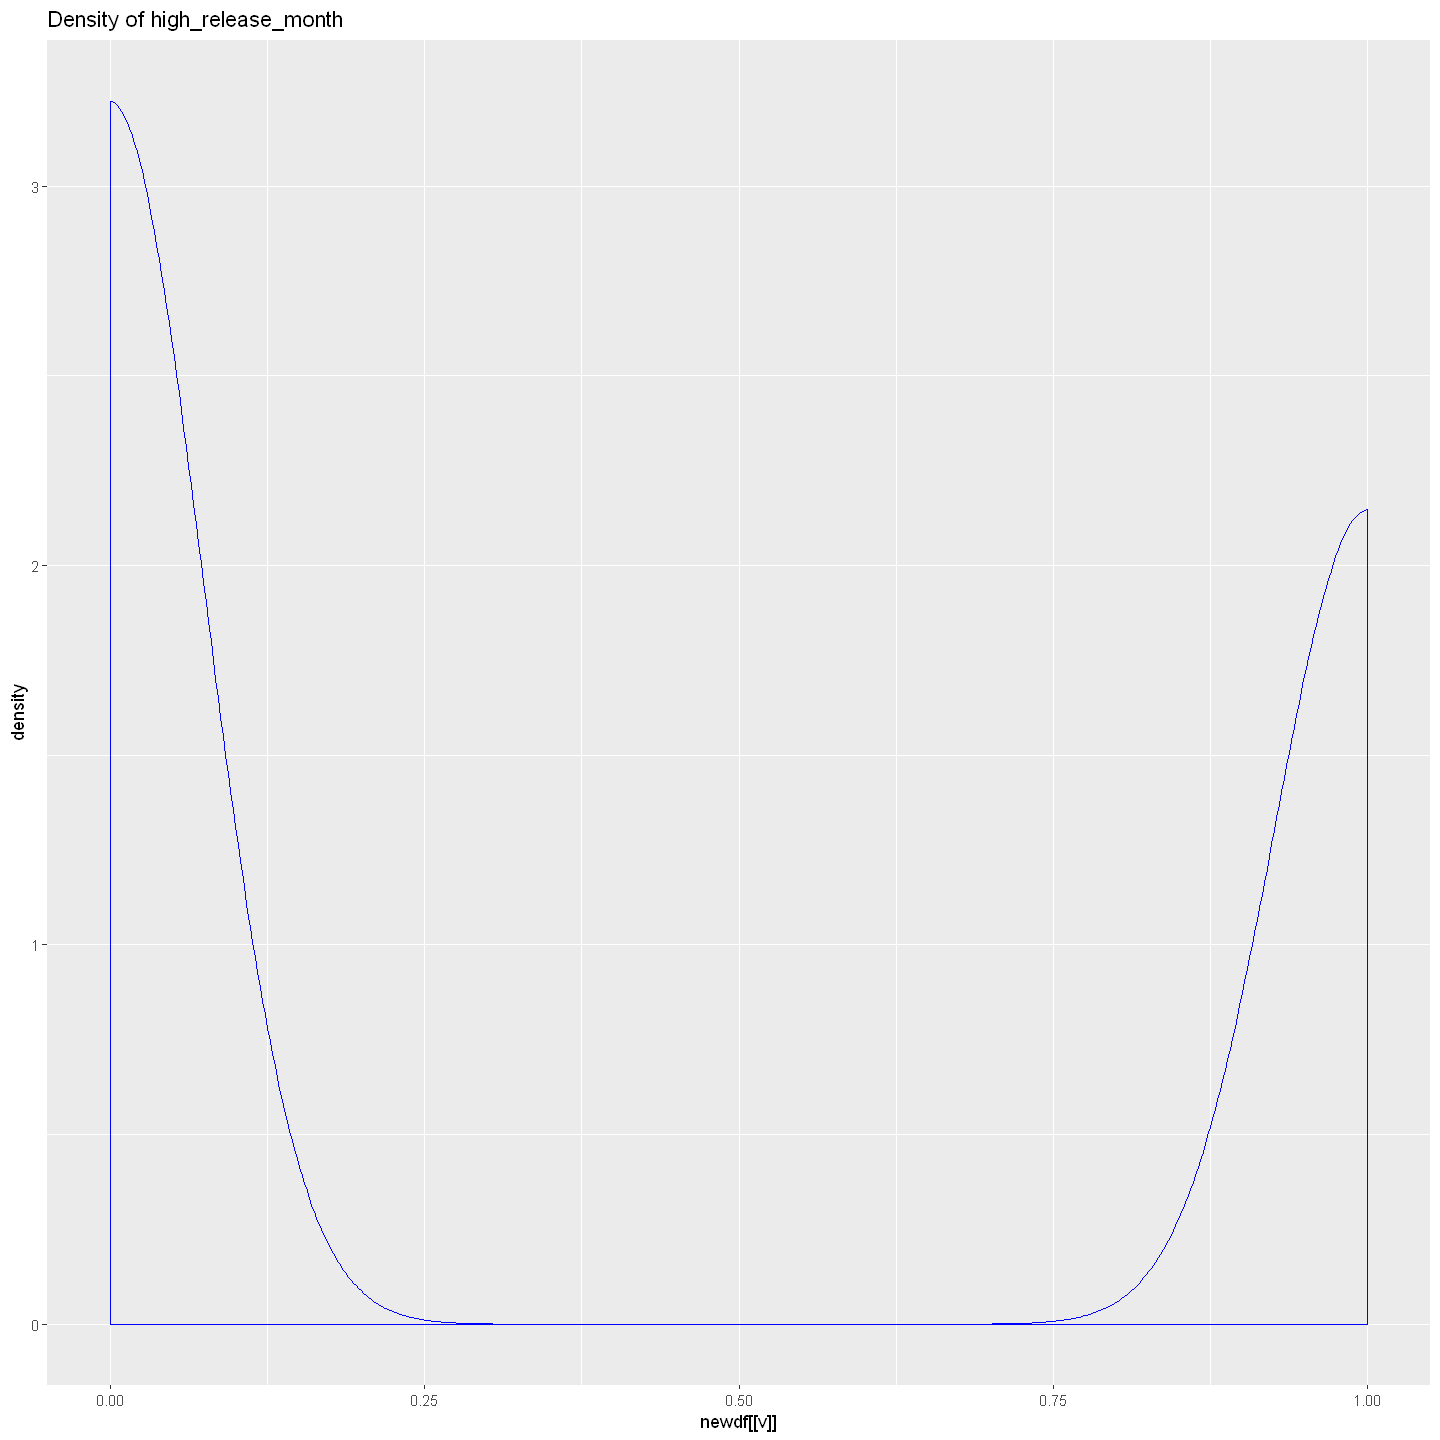

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1 rows containing non-finite values (stat_density)."


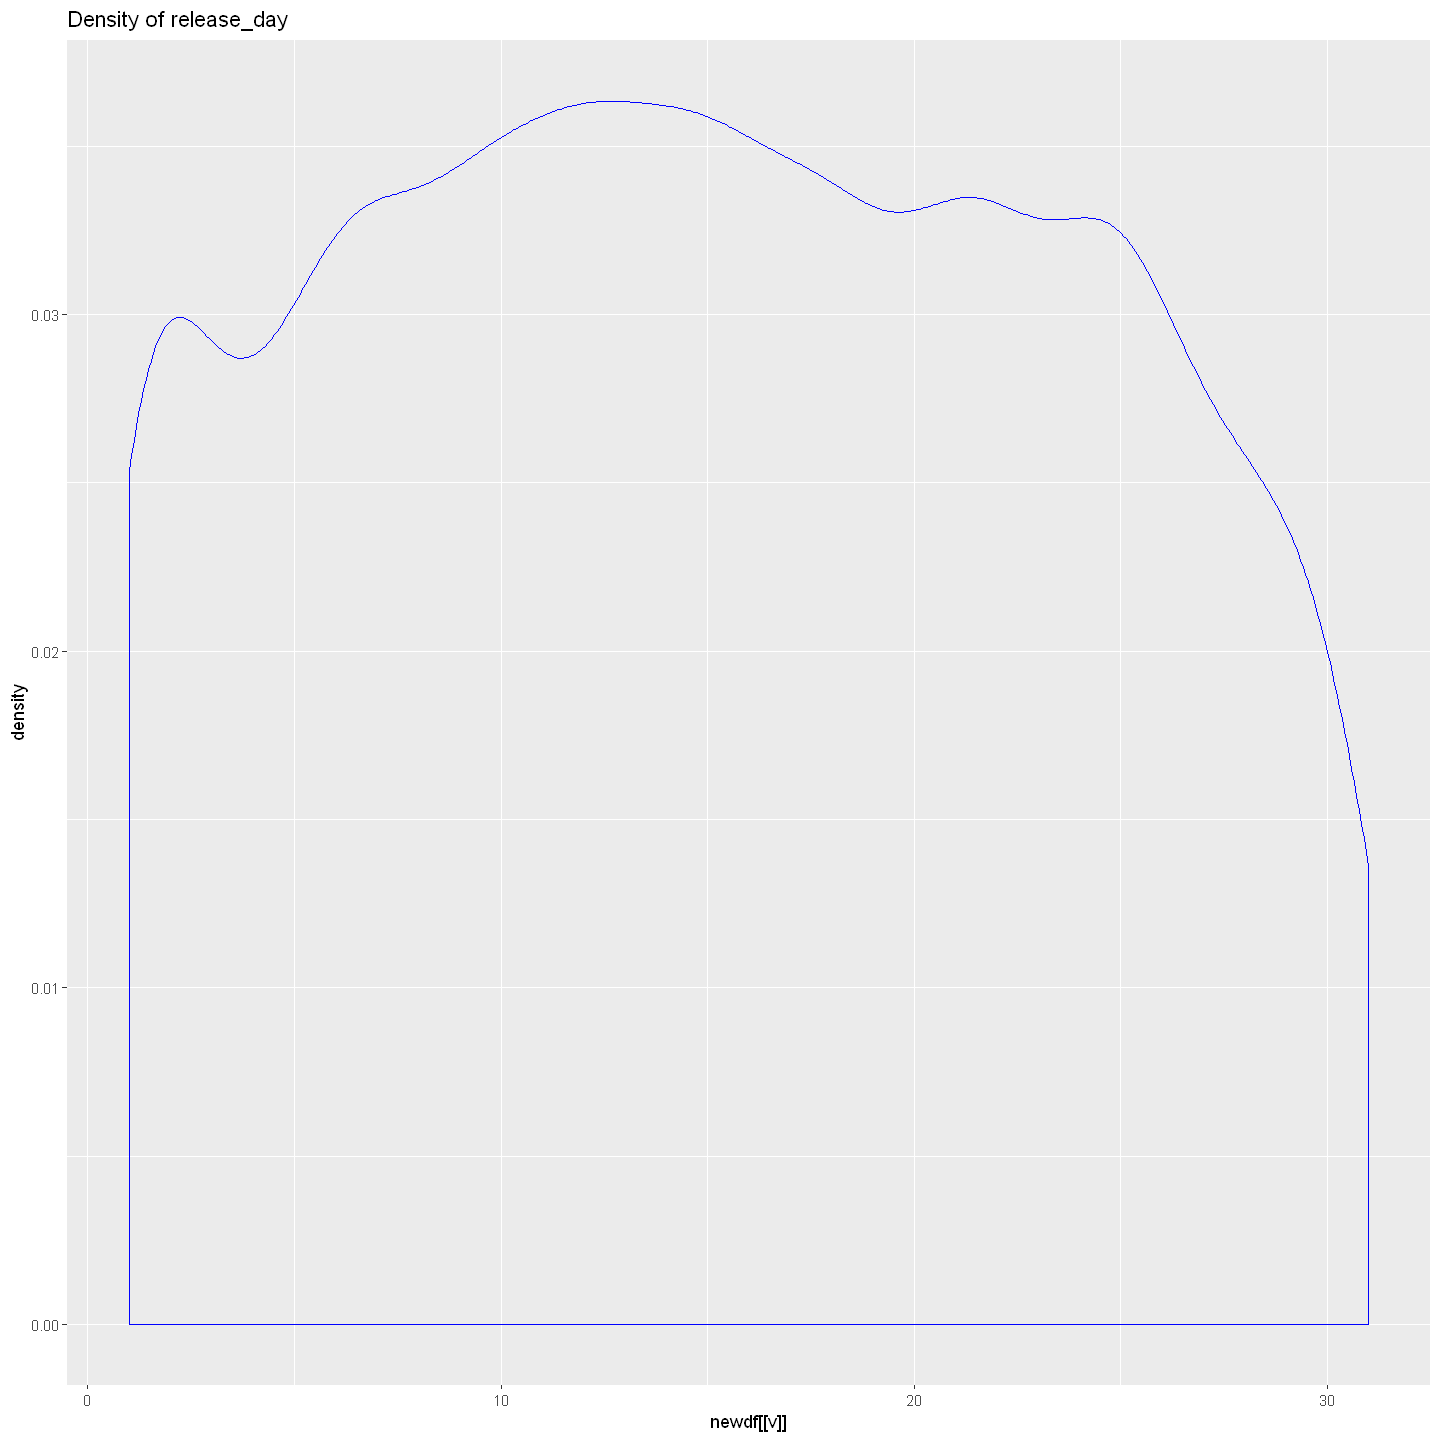

Warning message:
"Removed 206 rows containing non-finite values (stat_density)."


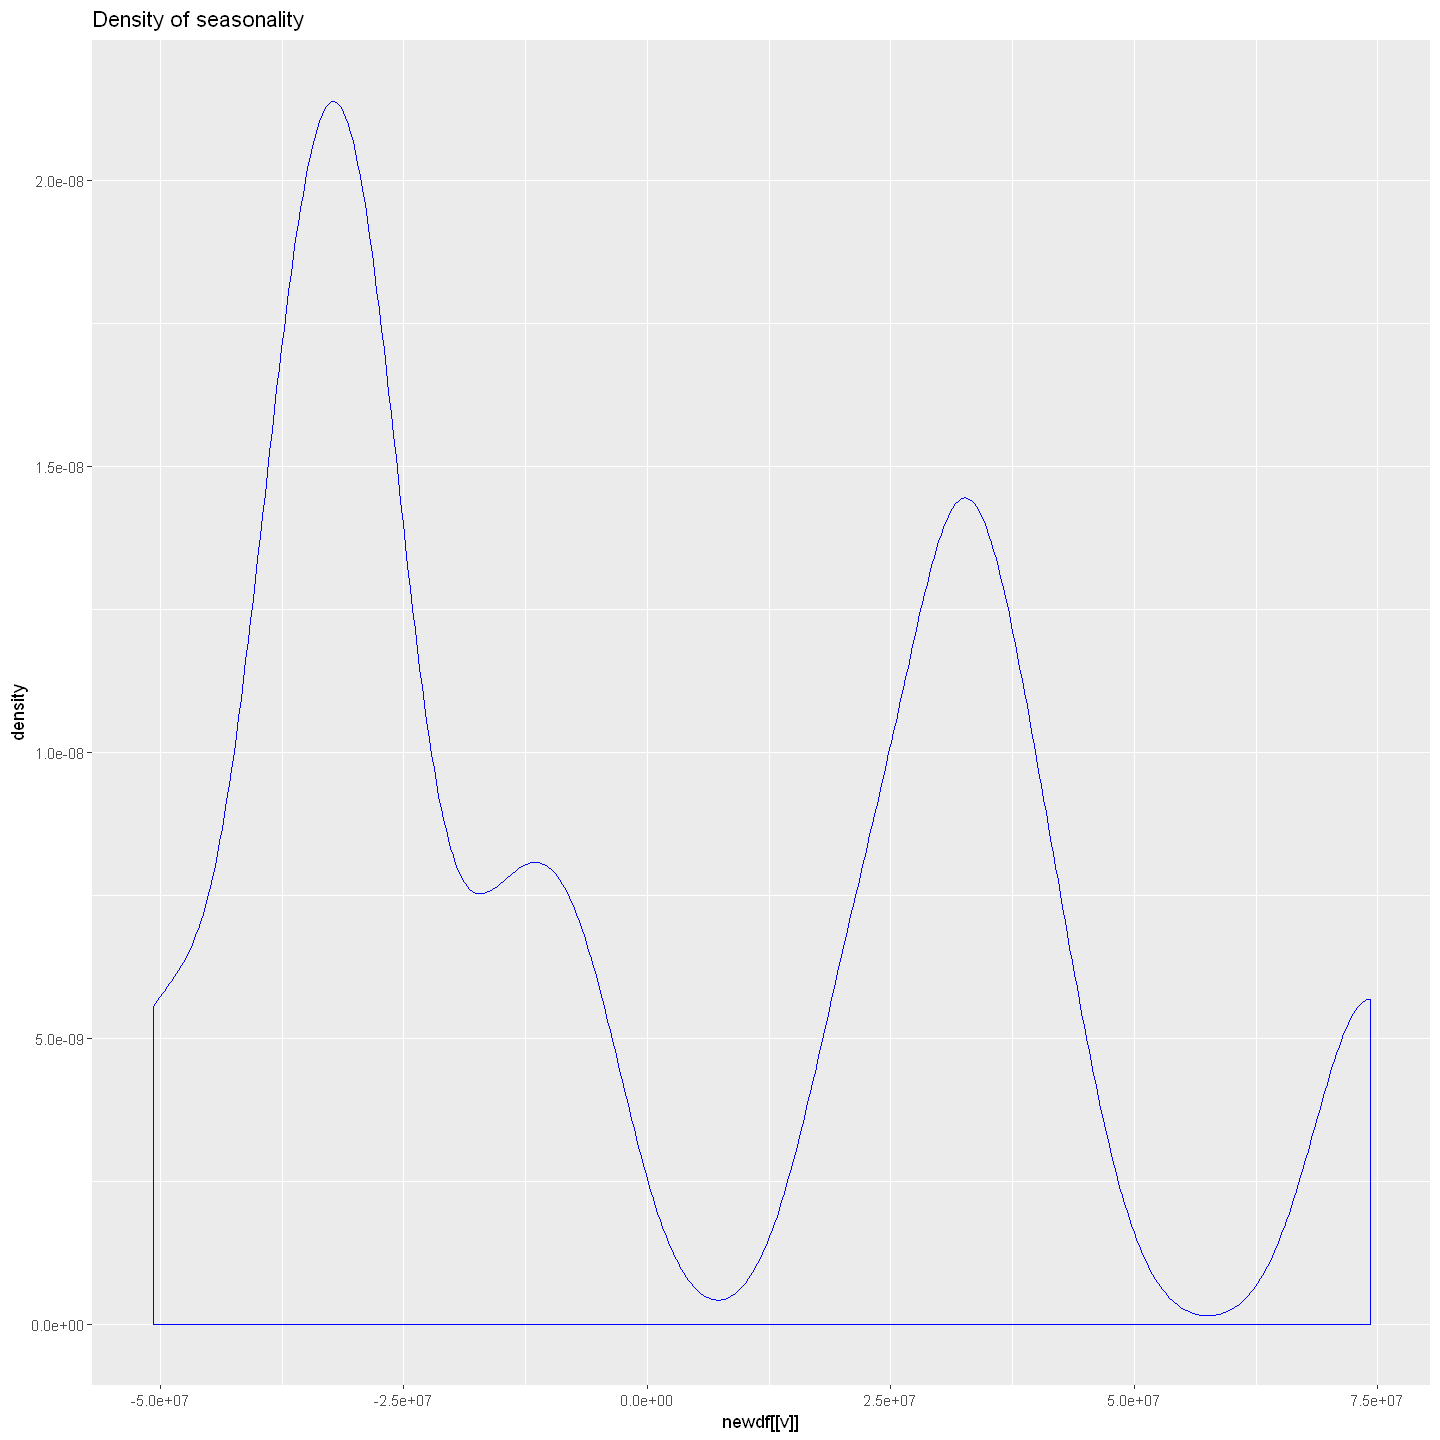

Warning message:
"Removed 395 rows containing non-finite values (stat_density)."
Warning message:
"Removed 558 rows containing non-finite values (stat_density)."


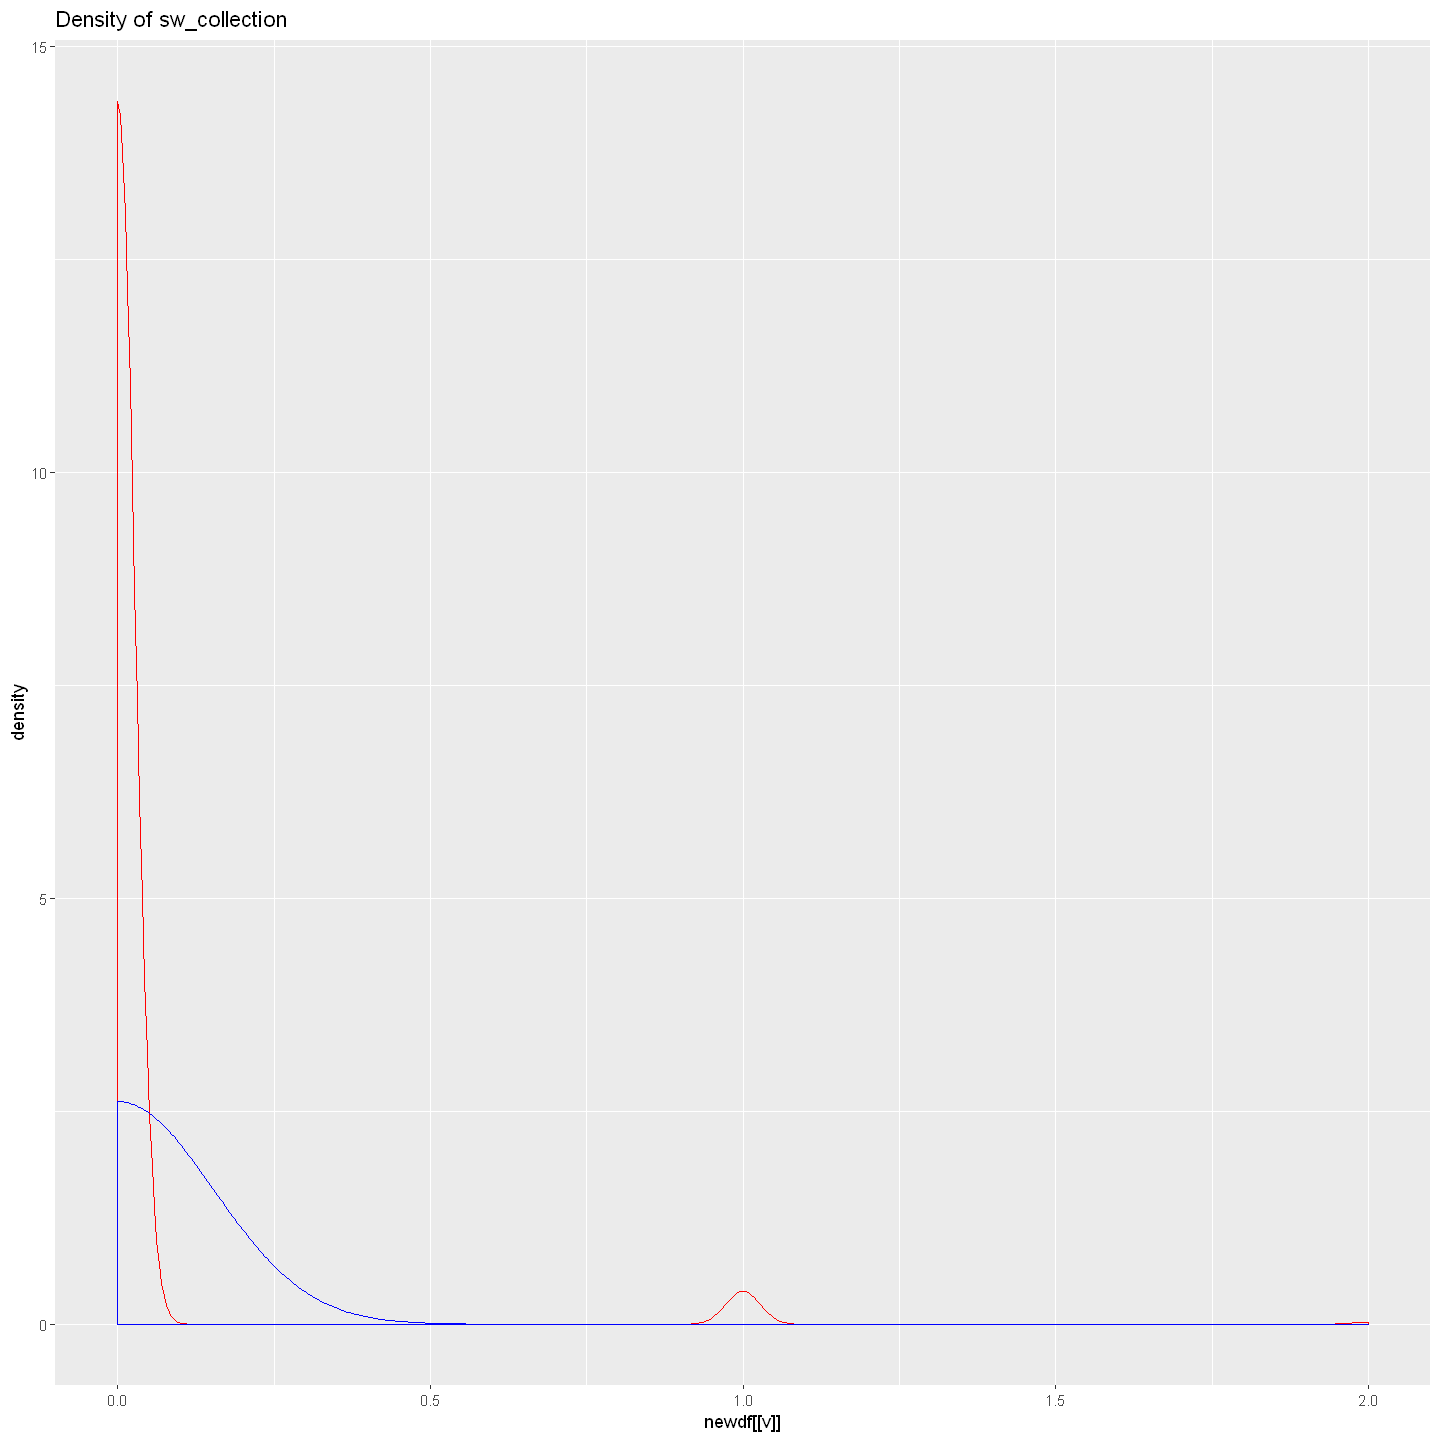

Warning message:
"Removed 1923 rows containing non-finite values (stat_density)."


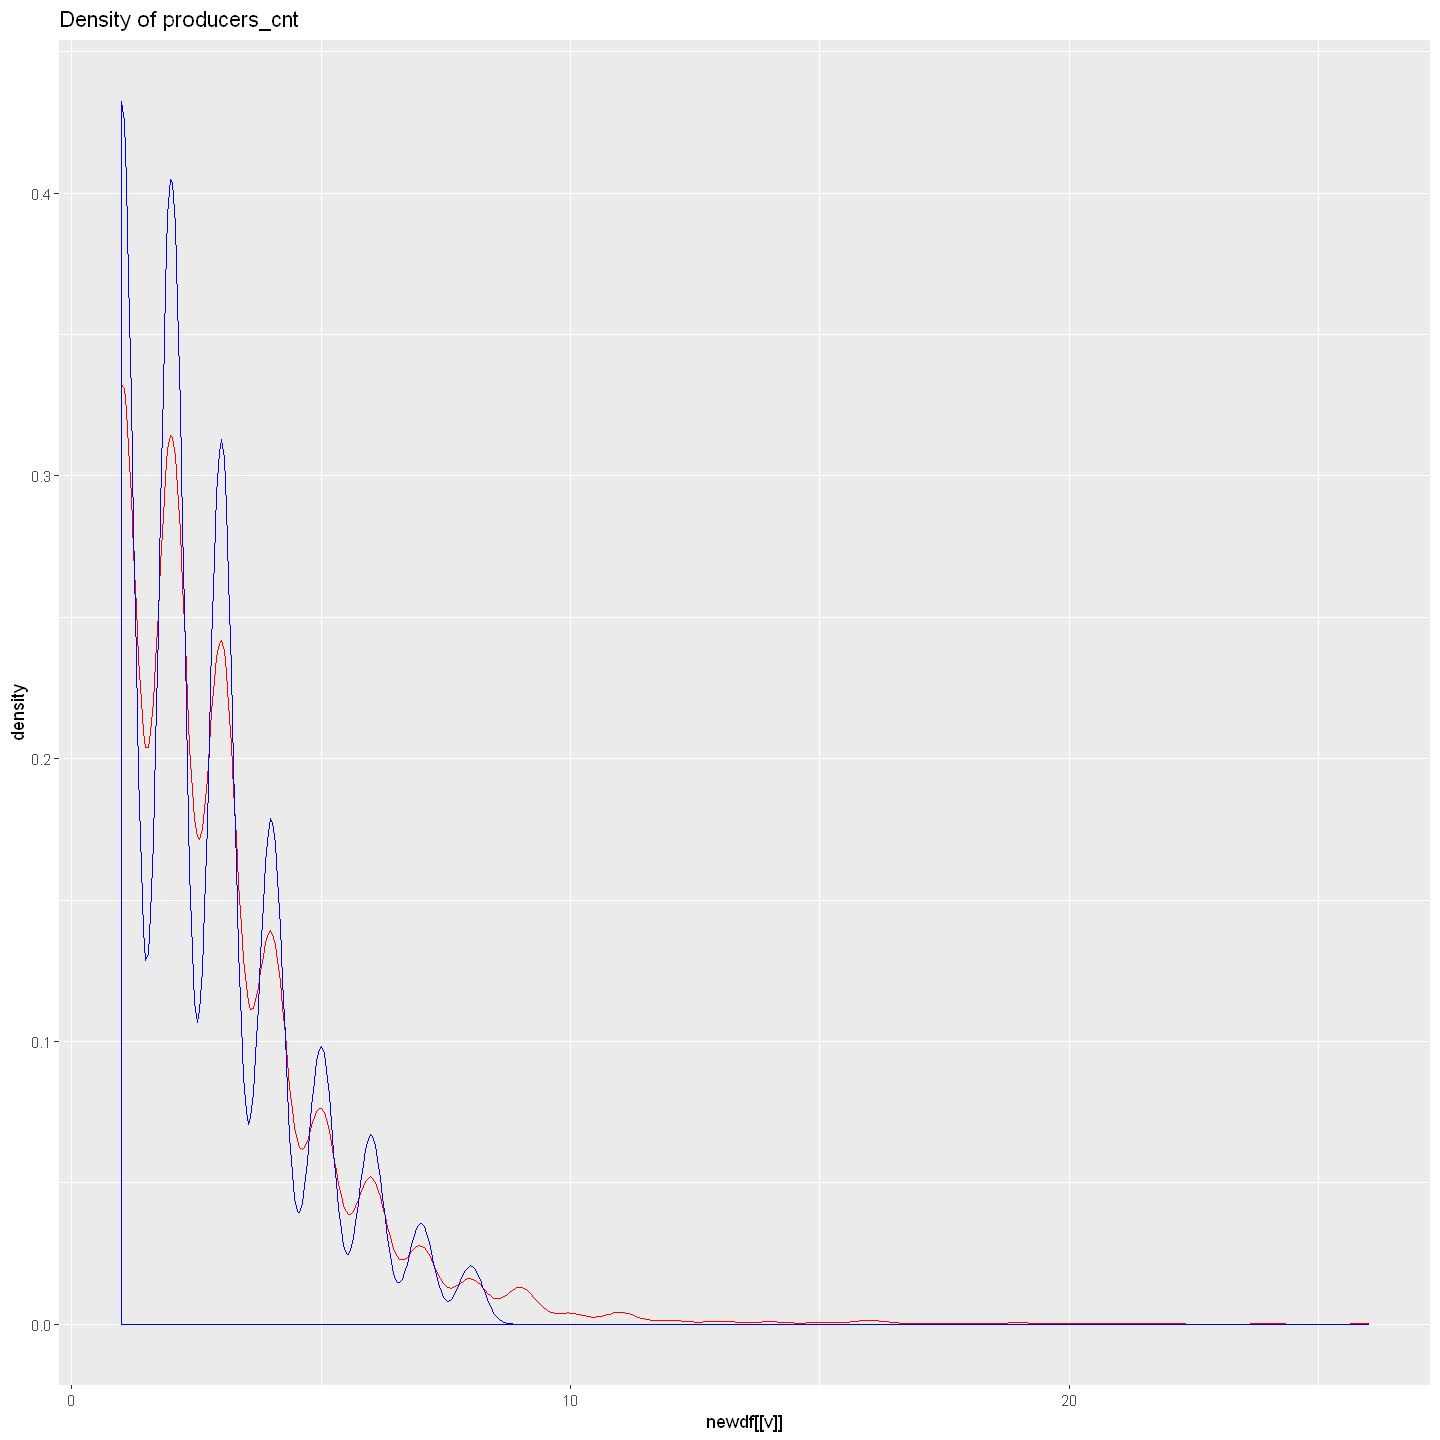

Warning message:
"Removed 933 rows containing non-finite values (stat_density)."


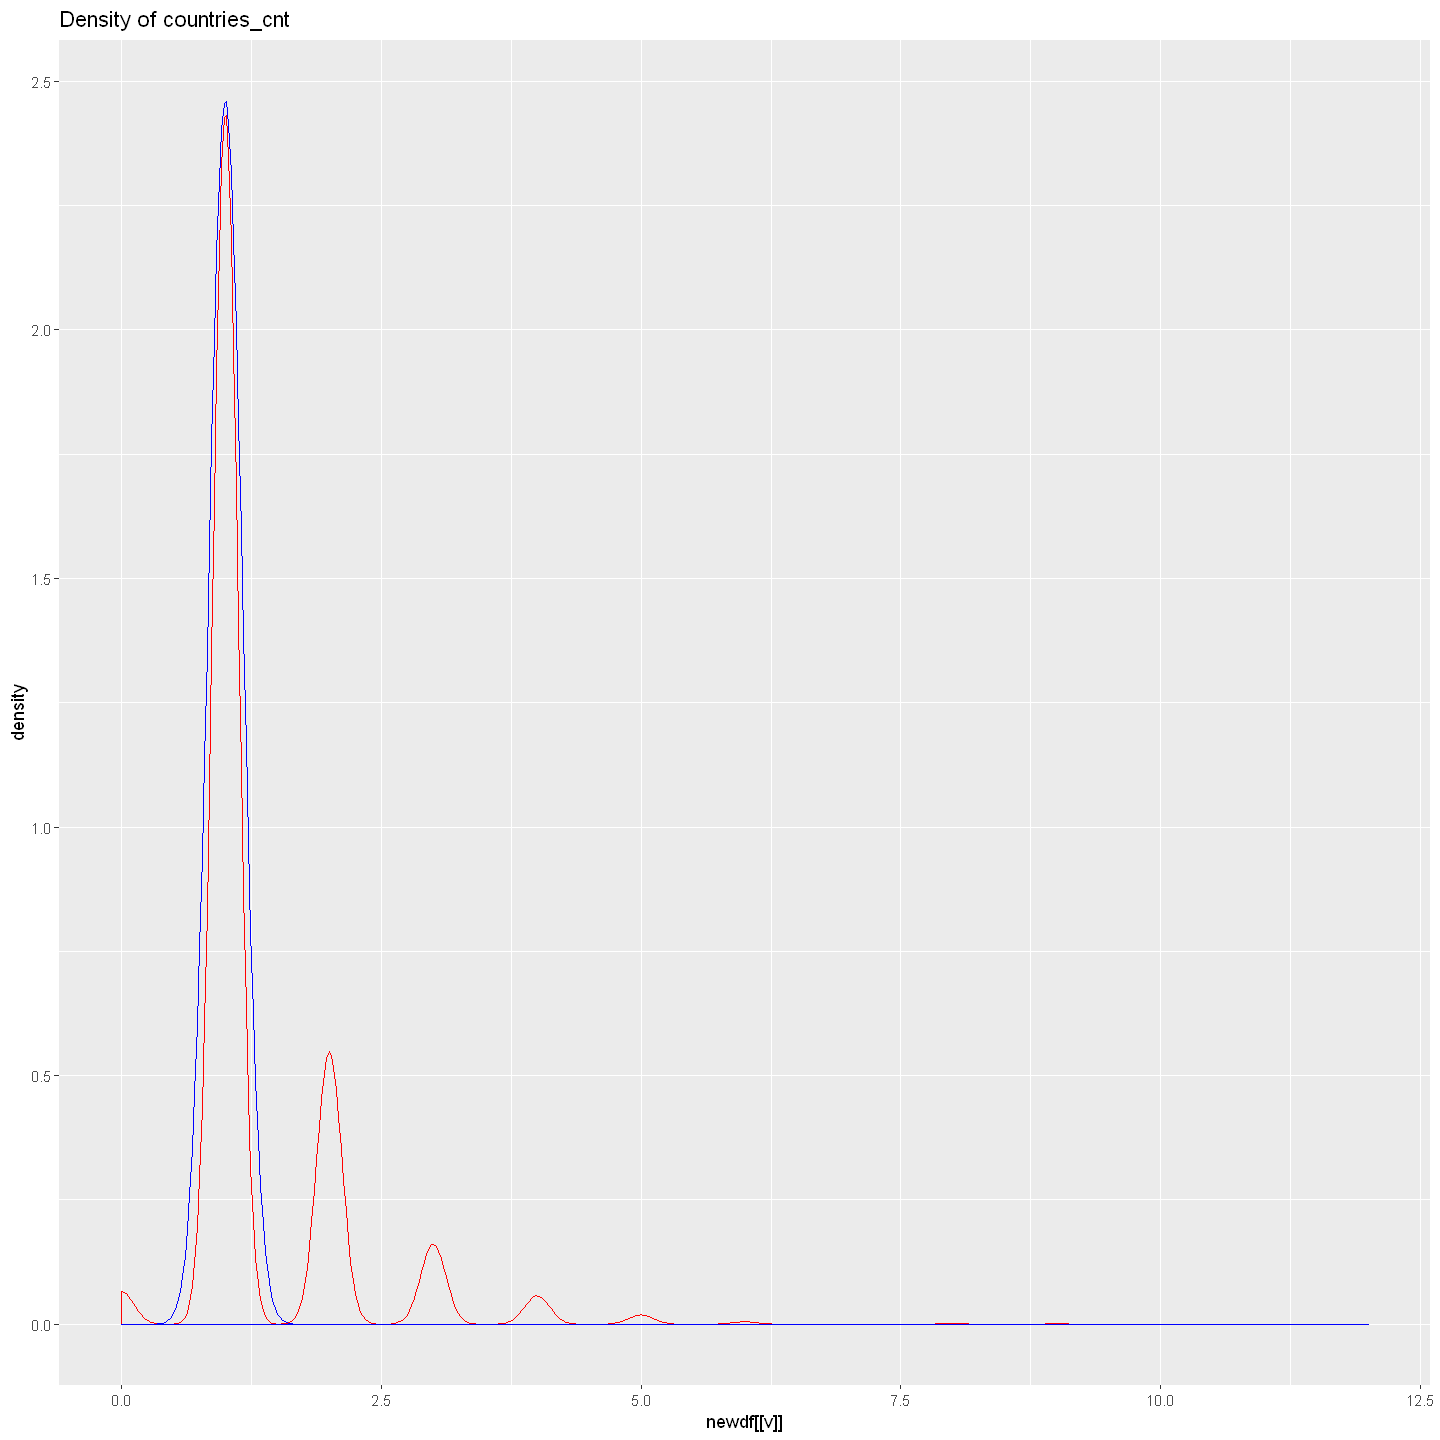

Warning message:
"Removed 711 rows containing non-finite values (stat_density)."


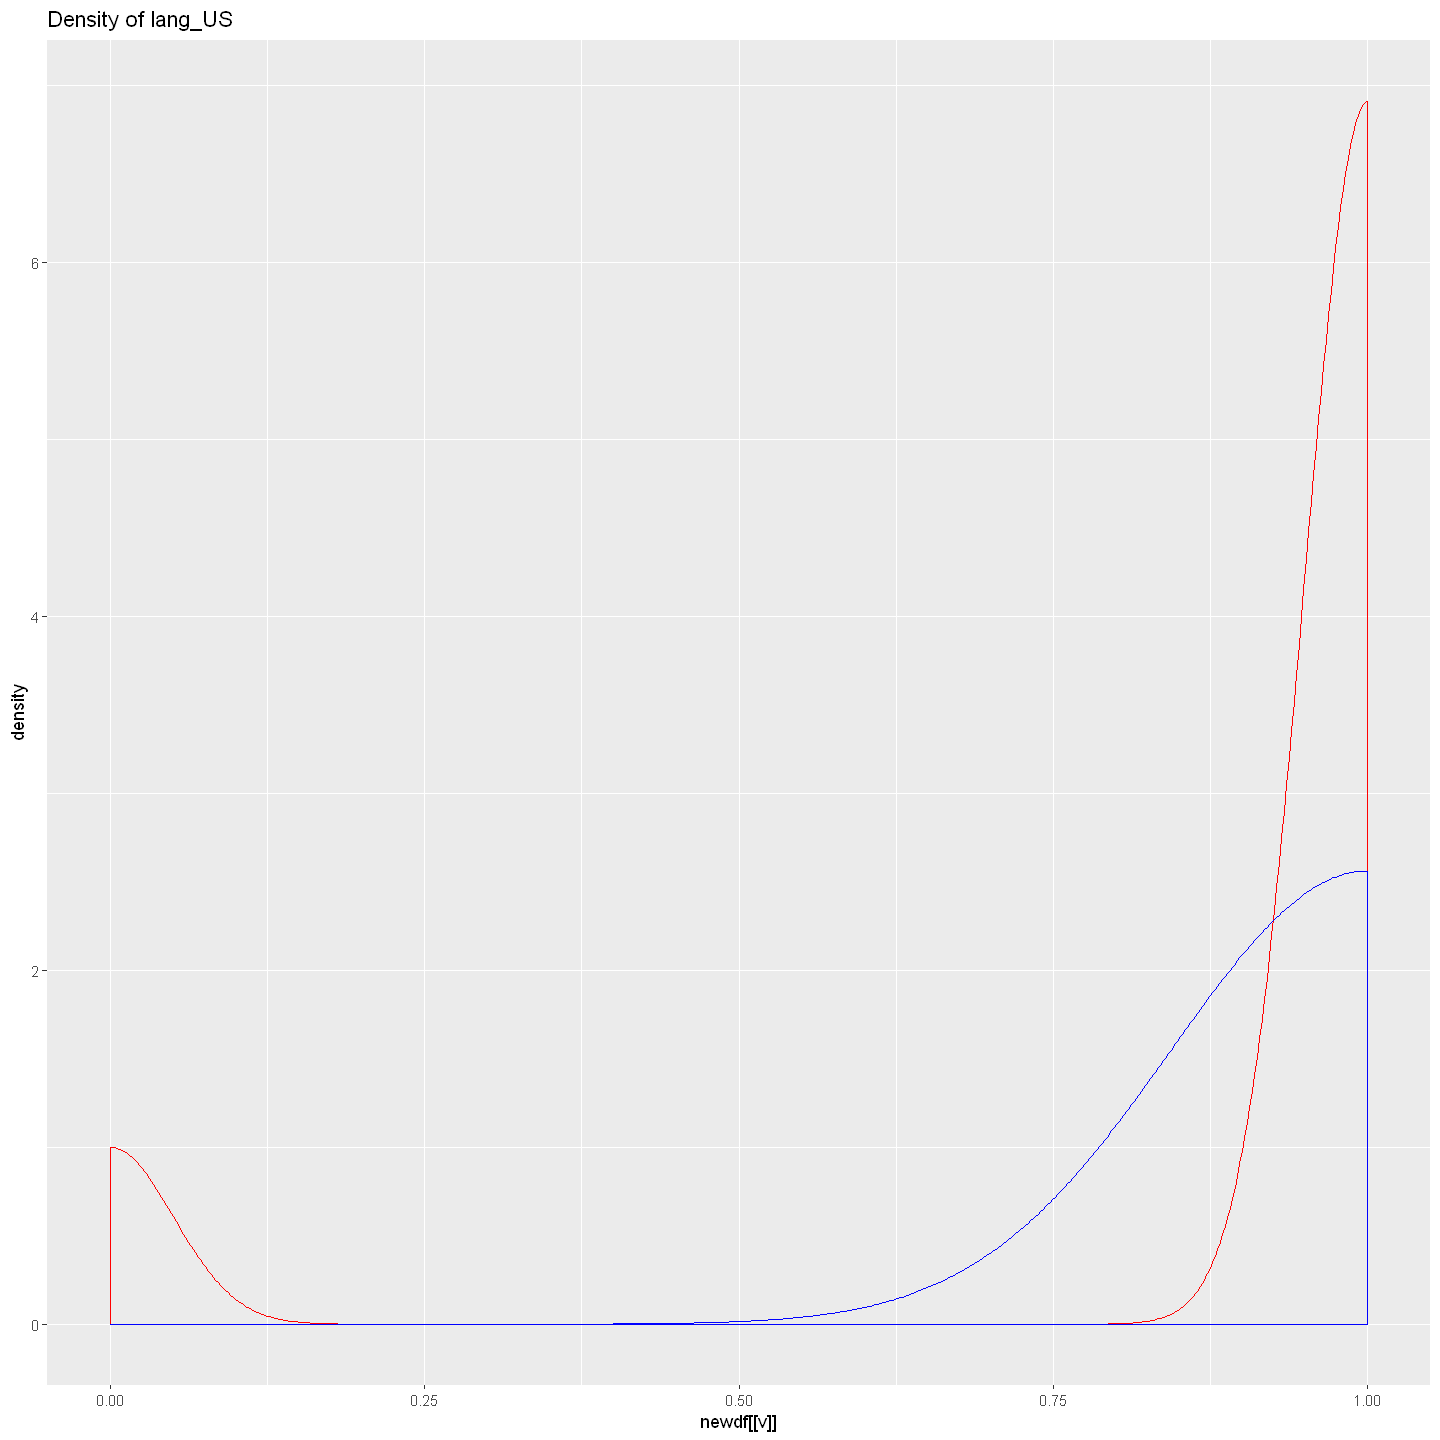

Warning message:
"Removed 358 rows containing non-finite values (stat_density)."


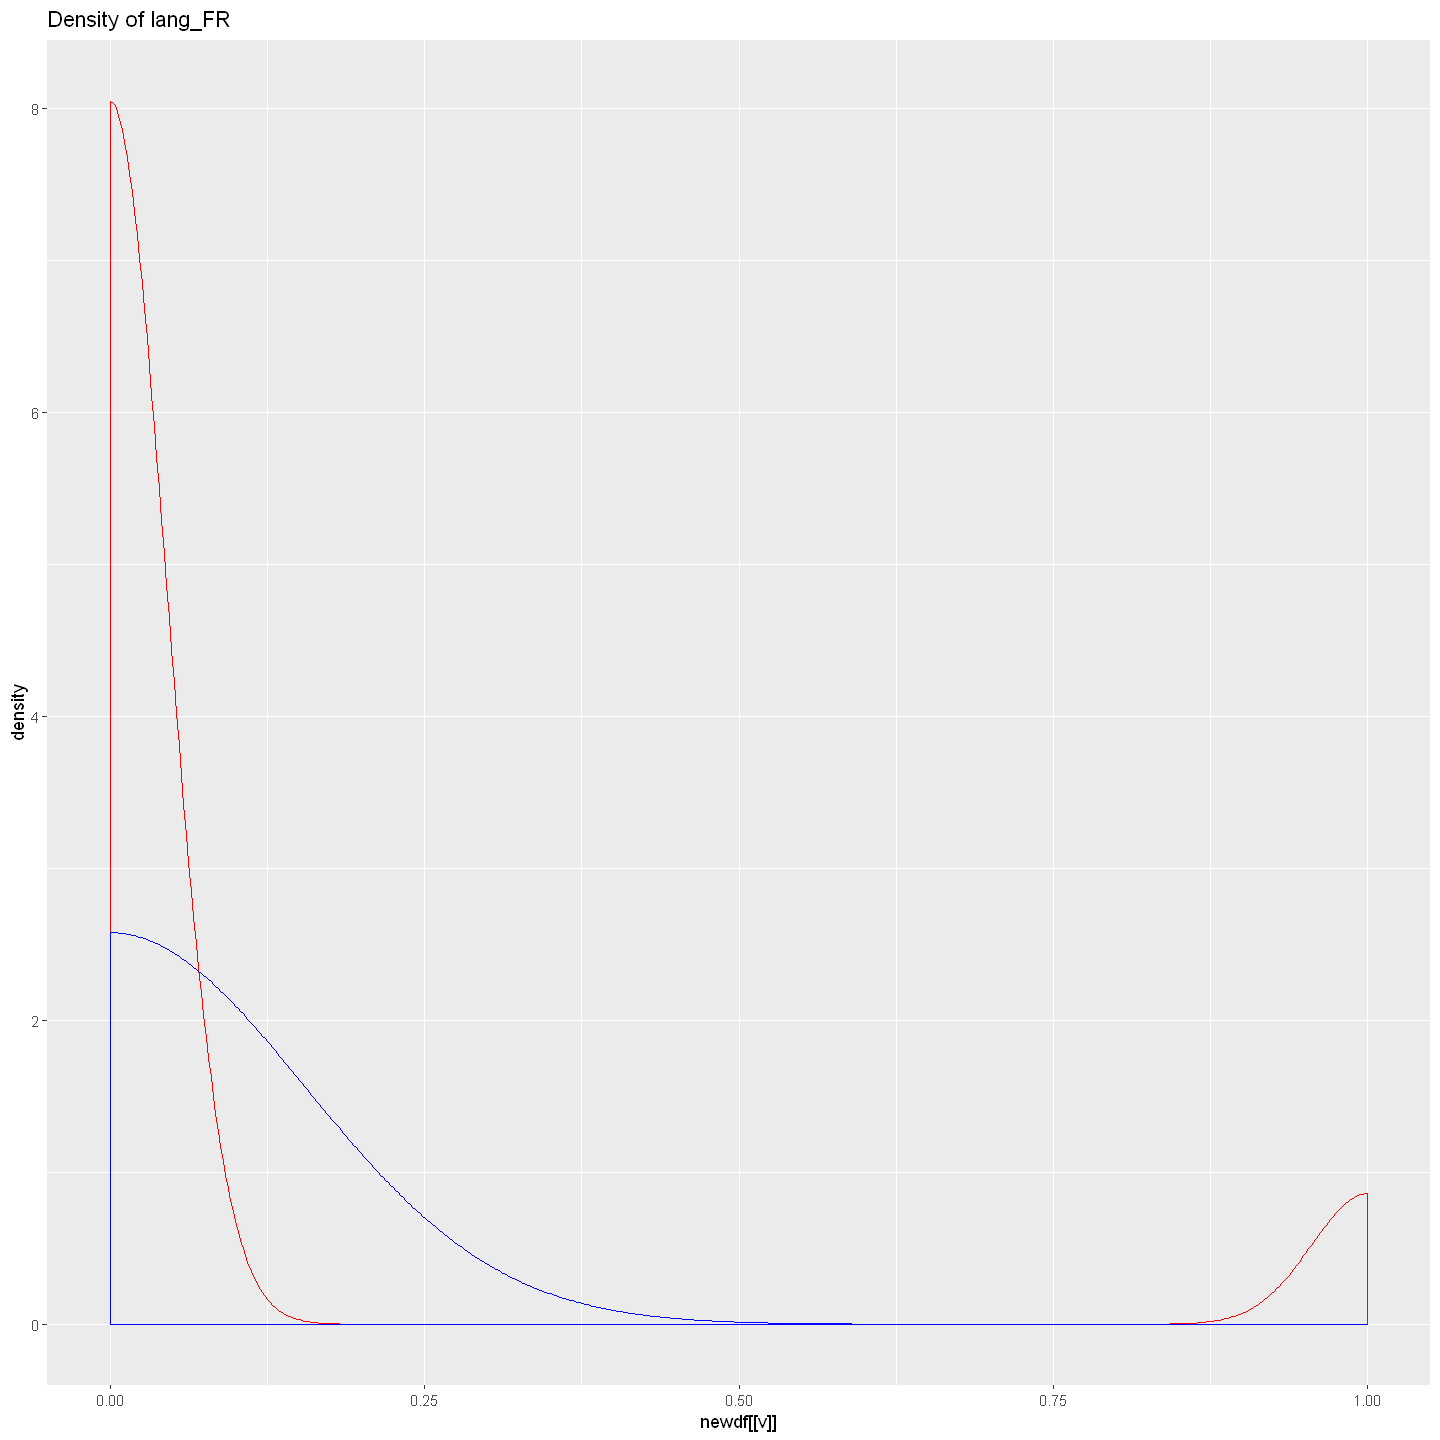

Warning message:
"Removed 559 rows containing non-finite values (stat_density)."


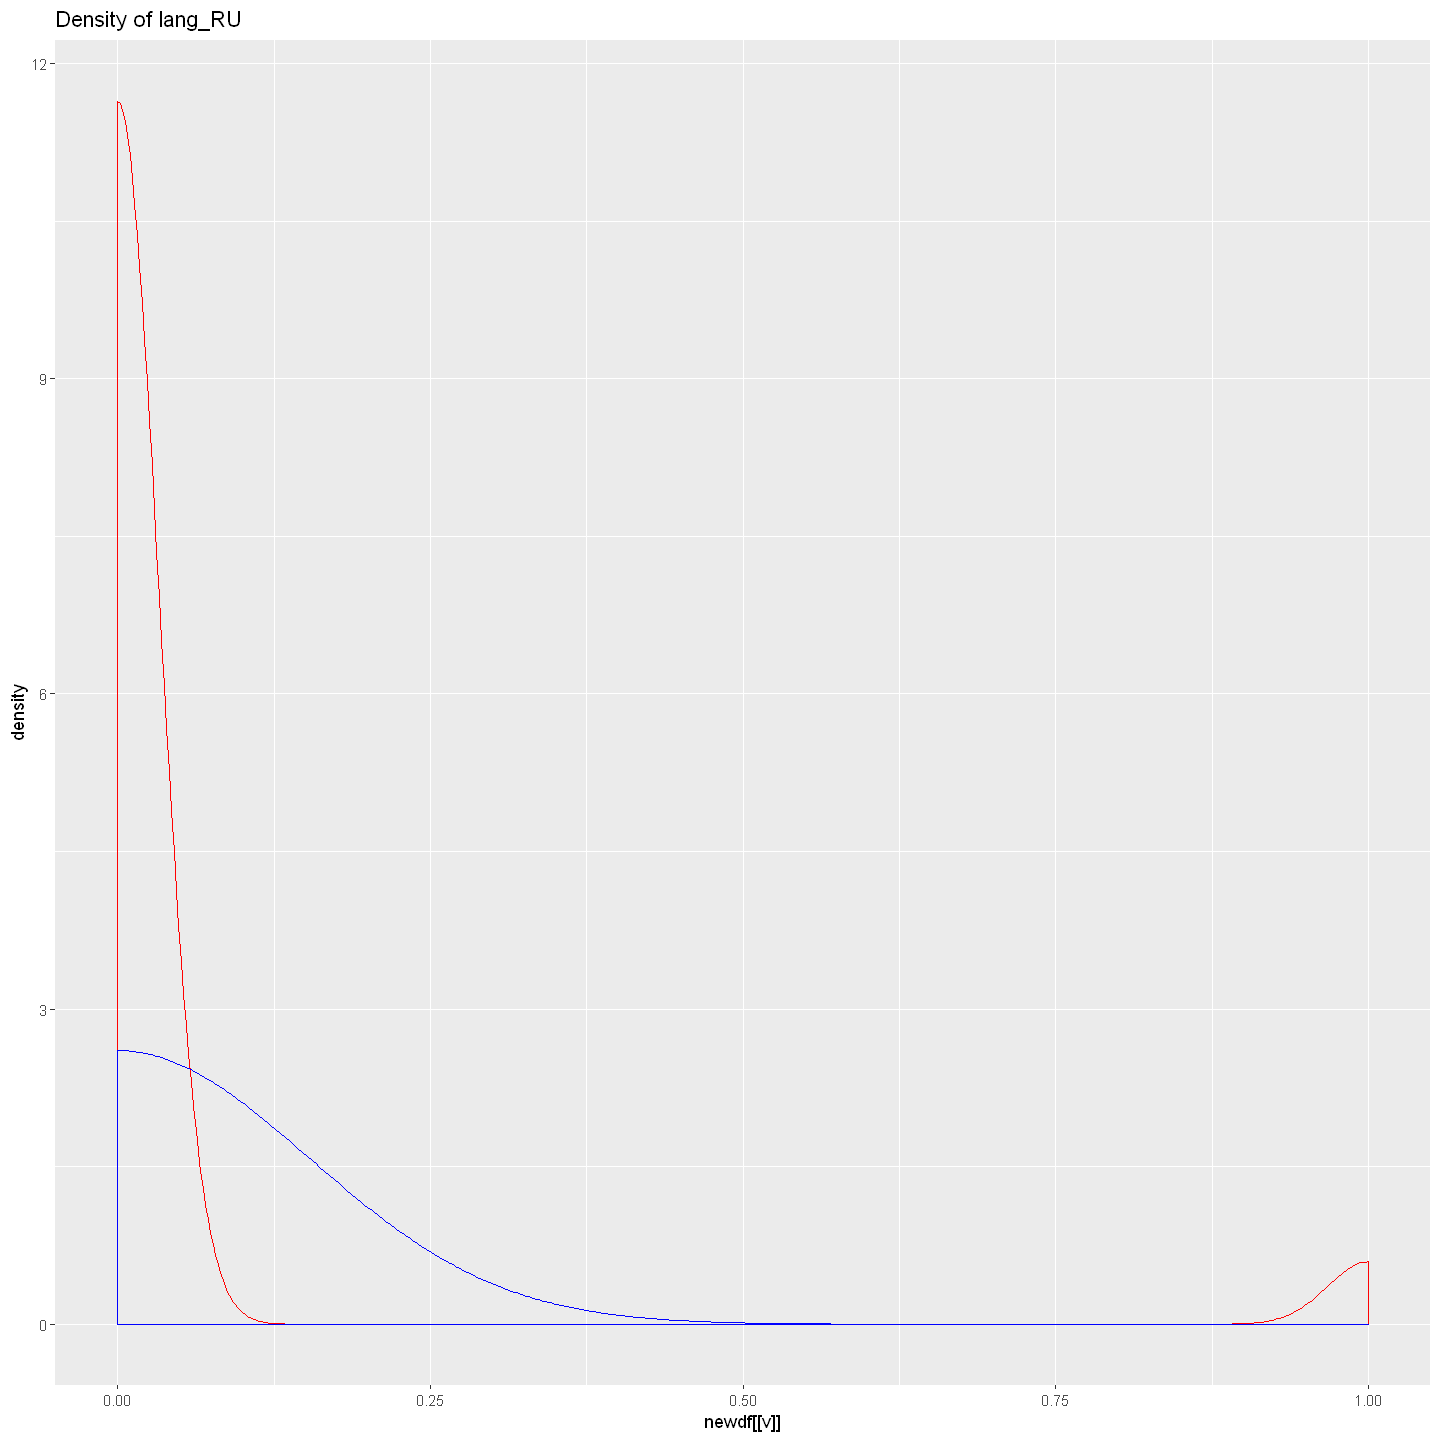

Warning message:
"Removed 204 rows containing non-finite values (stat_density)."


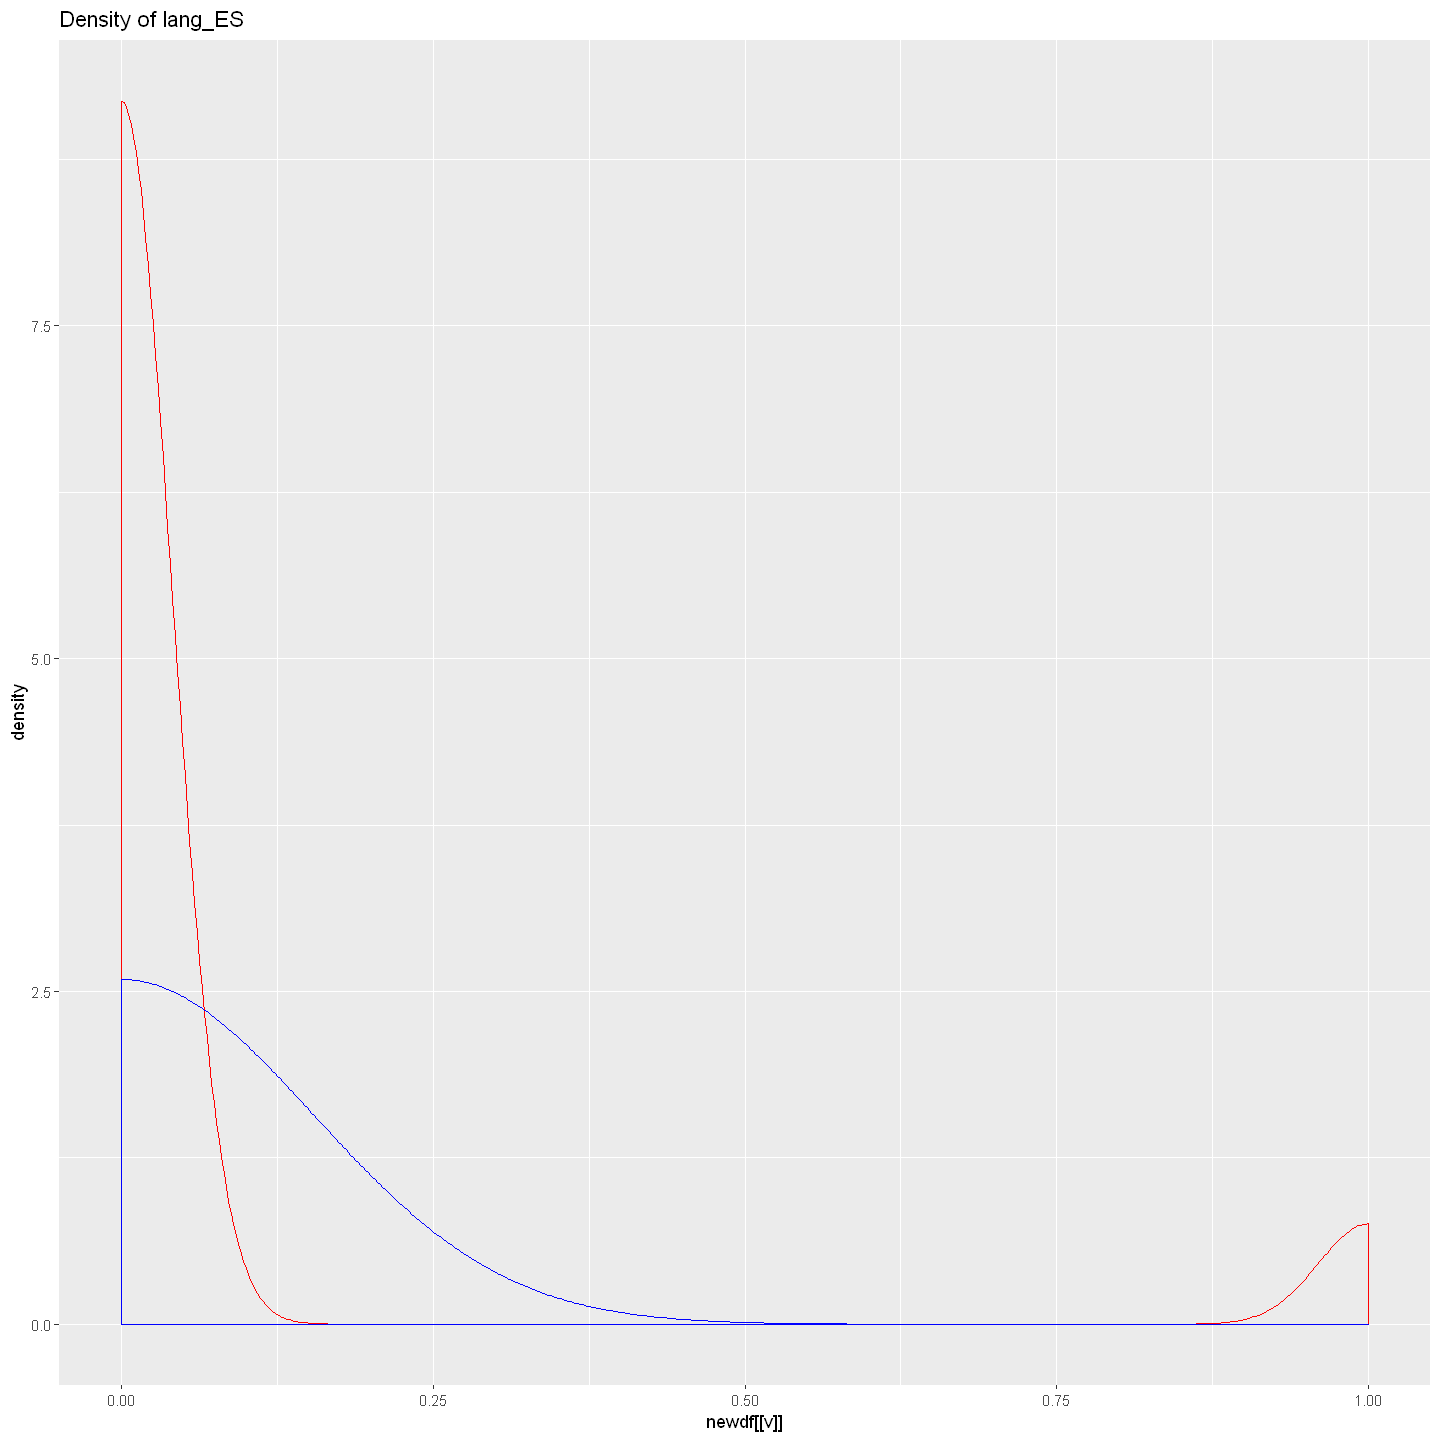

Warning message:
"Removed 278 rows containing non-finite values (stat_density)."


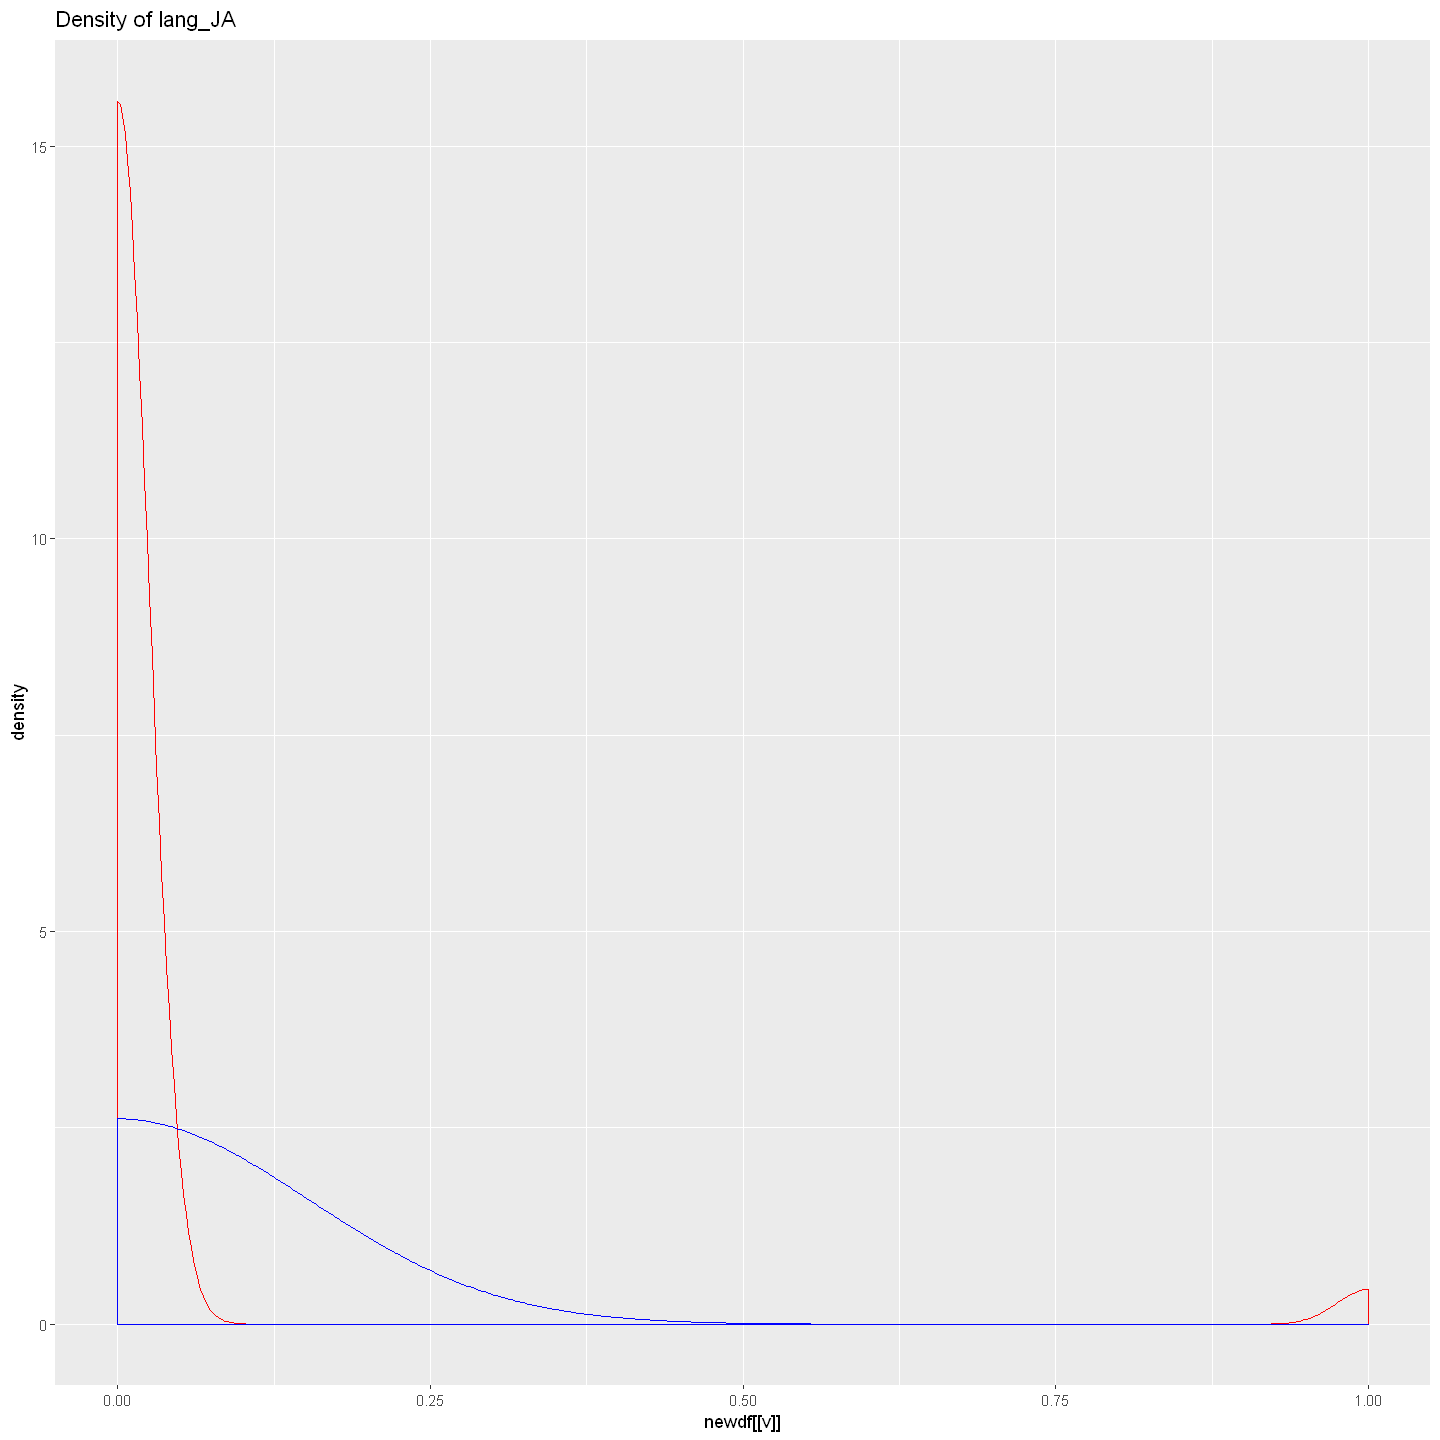

Warning message:
"Removed 306 rows containing non-finite values (stat_density)."


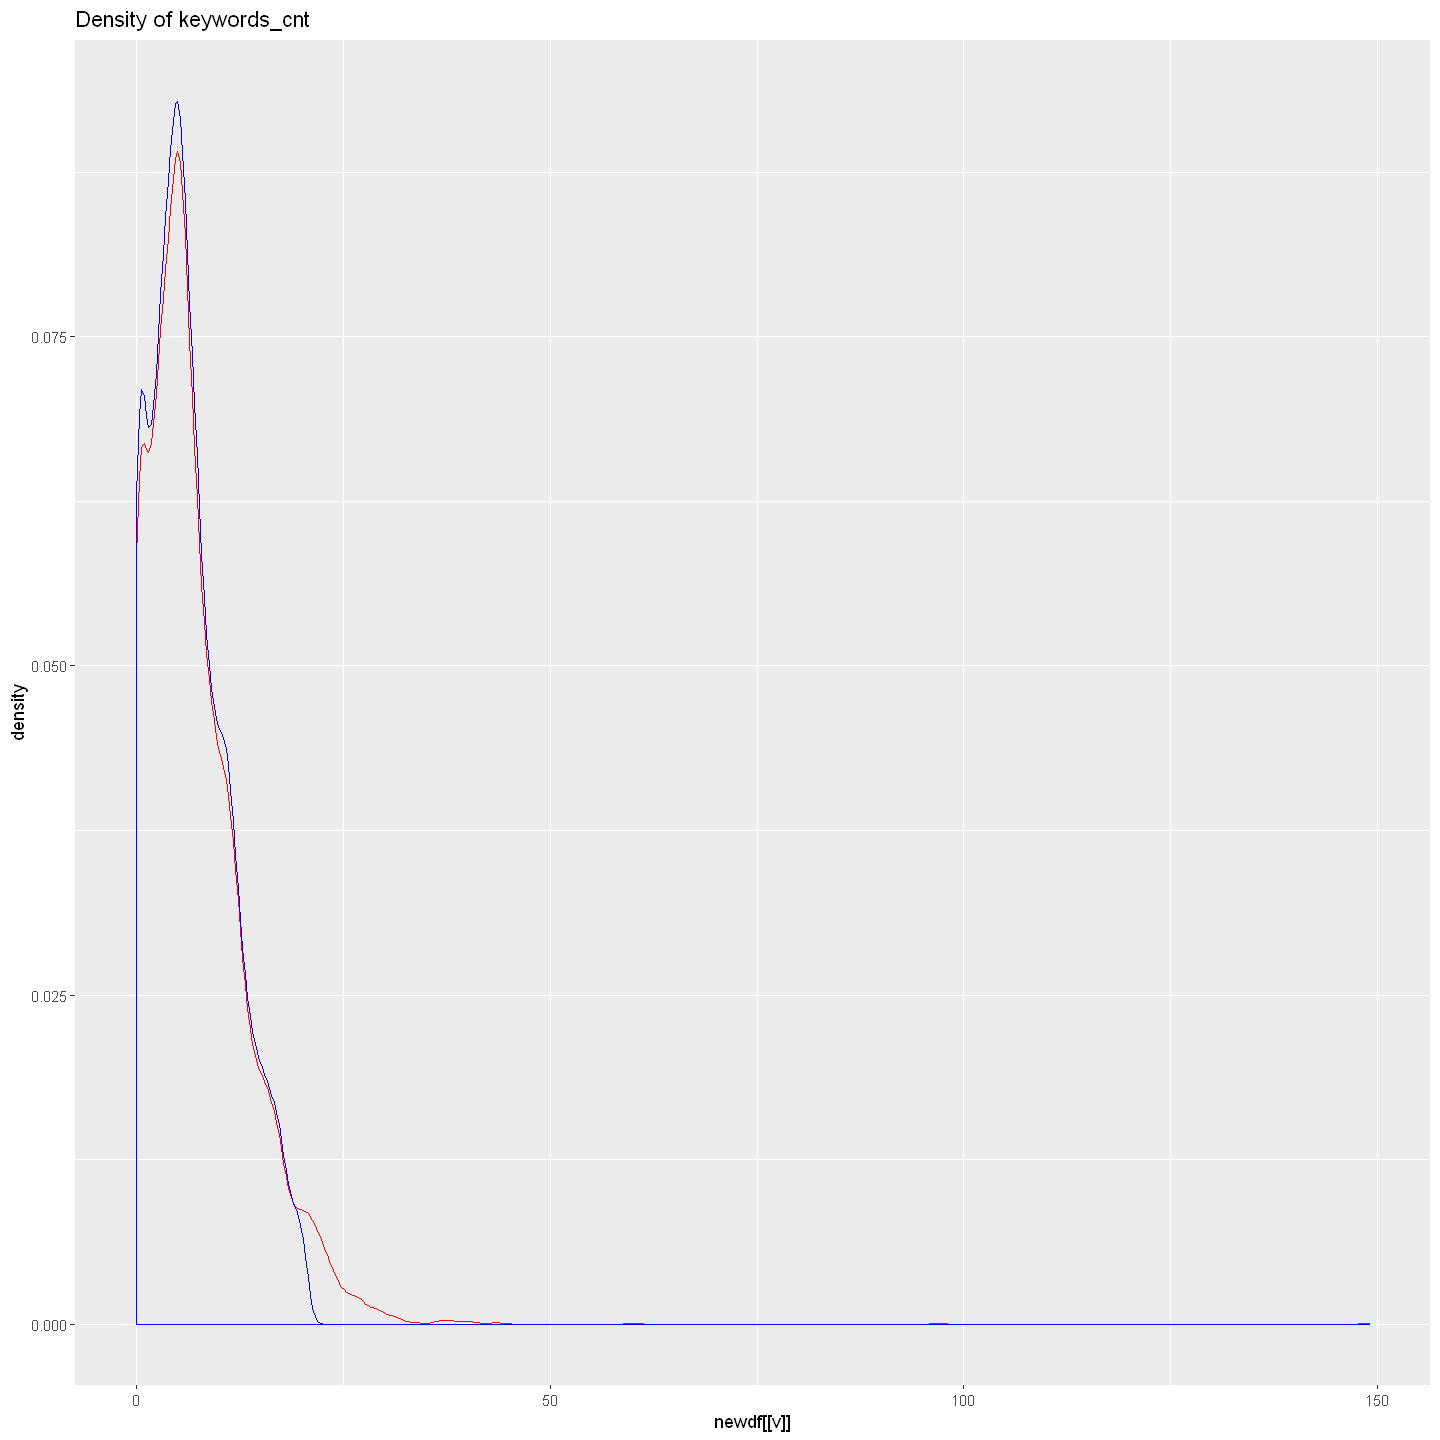

Warning message:
"Removed 52 rows containing non-finite values (stat_density)."


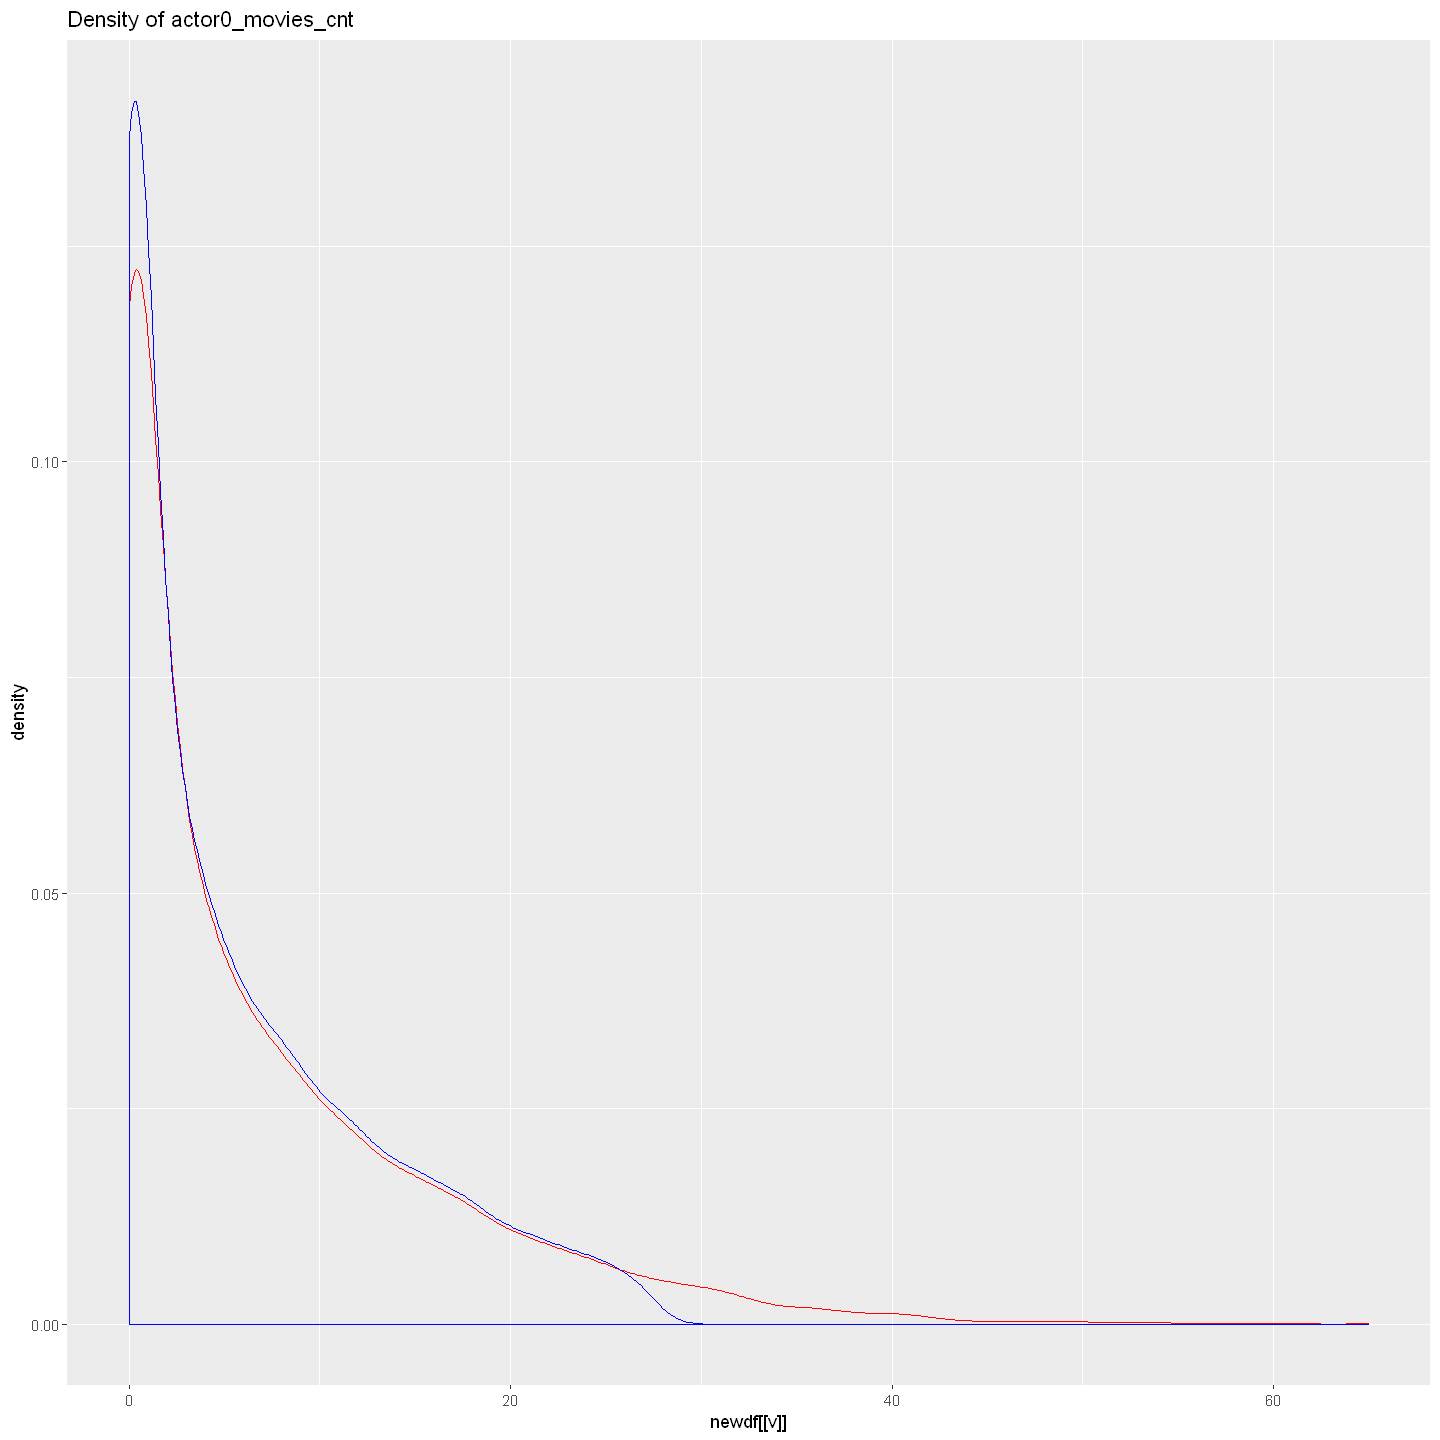

Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


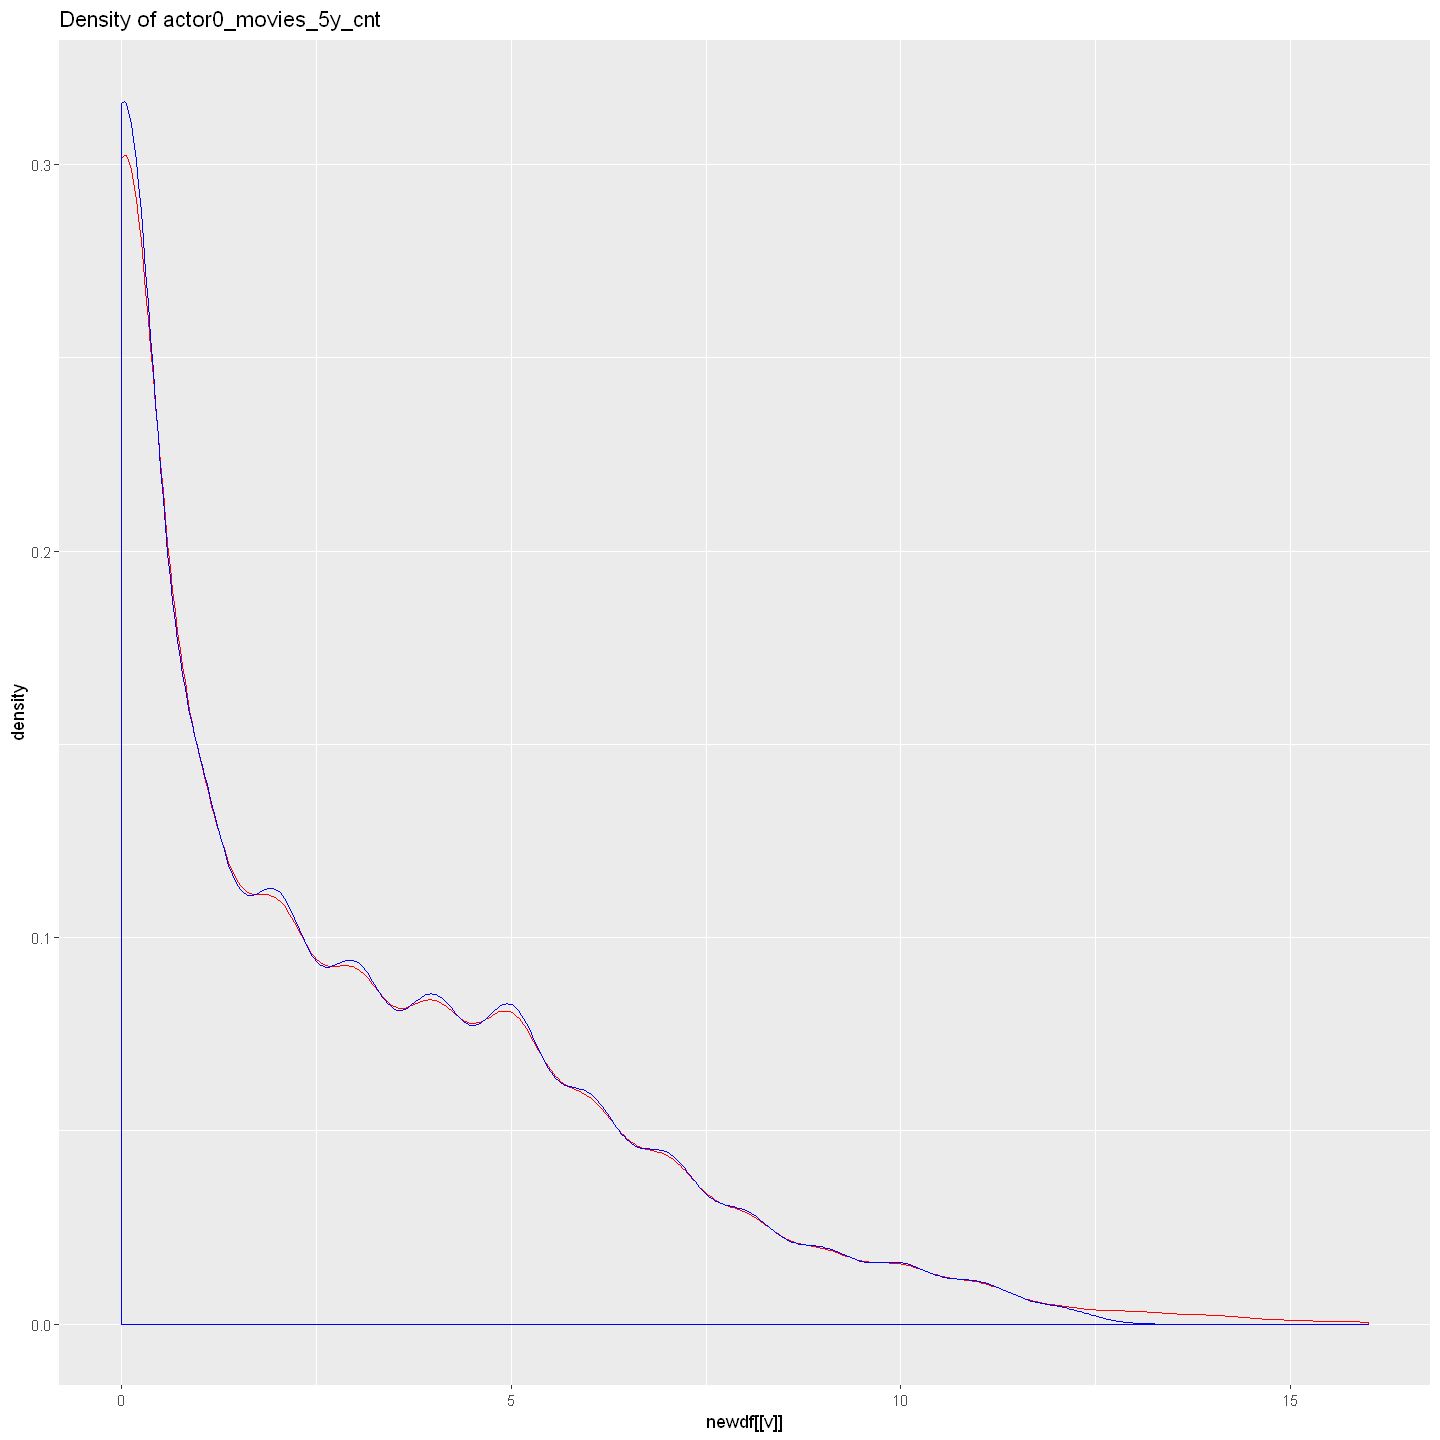

Warning message:
"Removed 132 rows containing non-finite values (stat_density)."


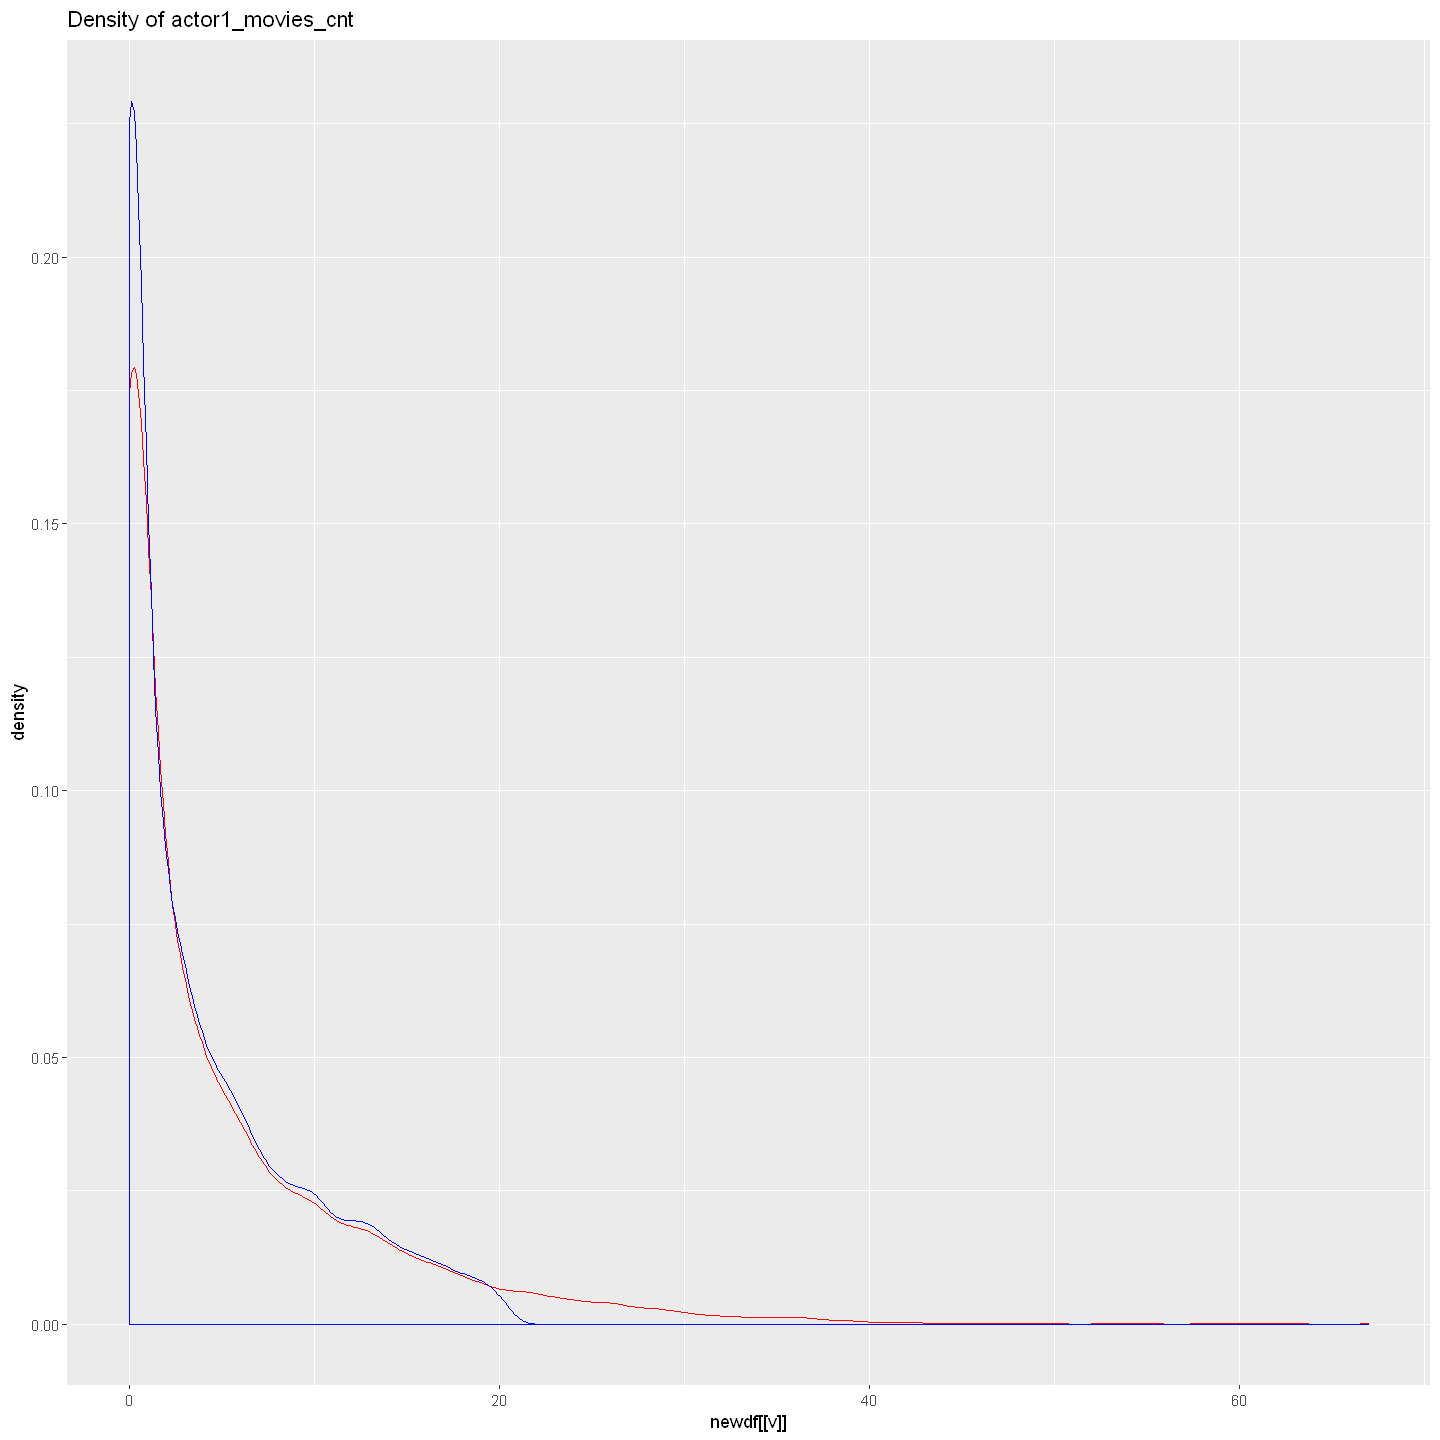

Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


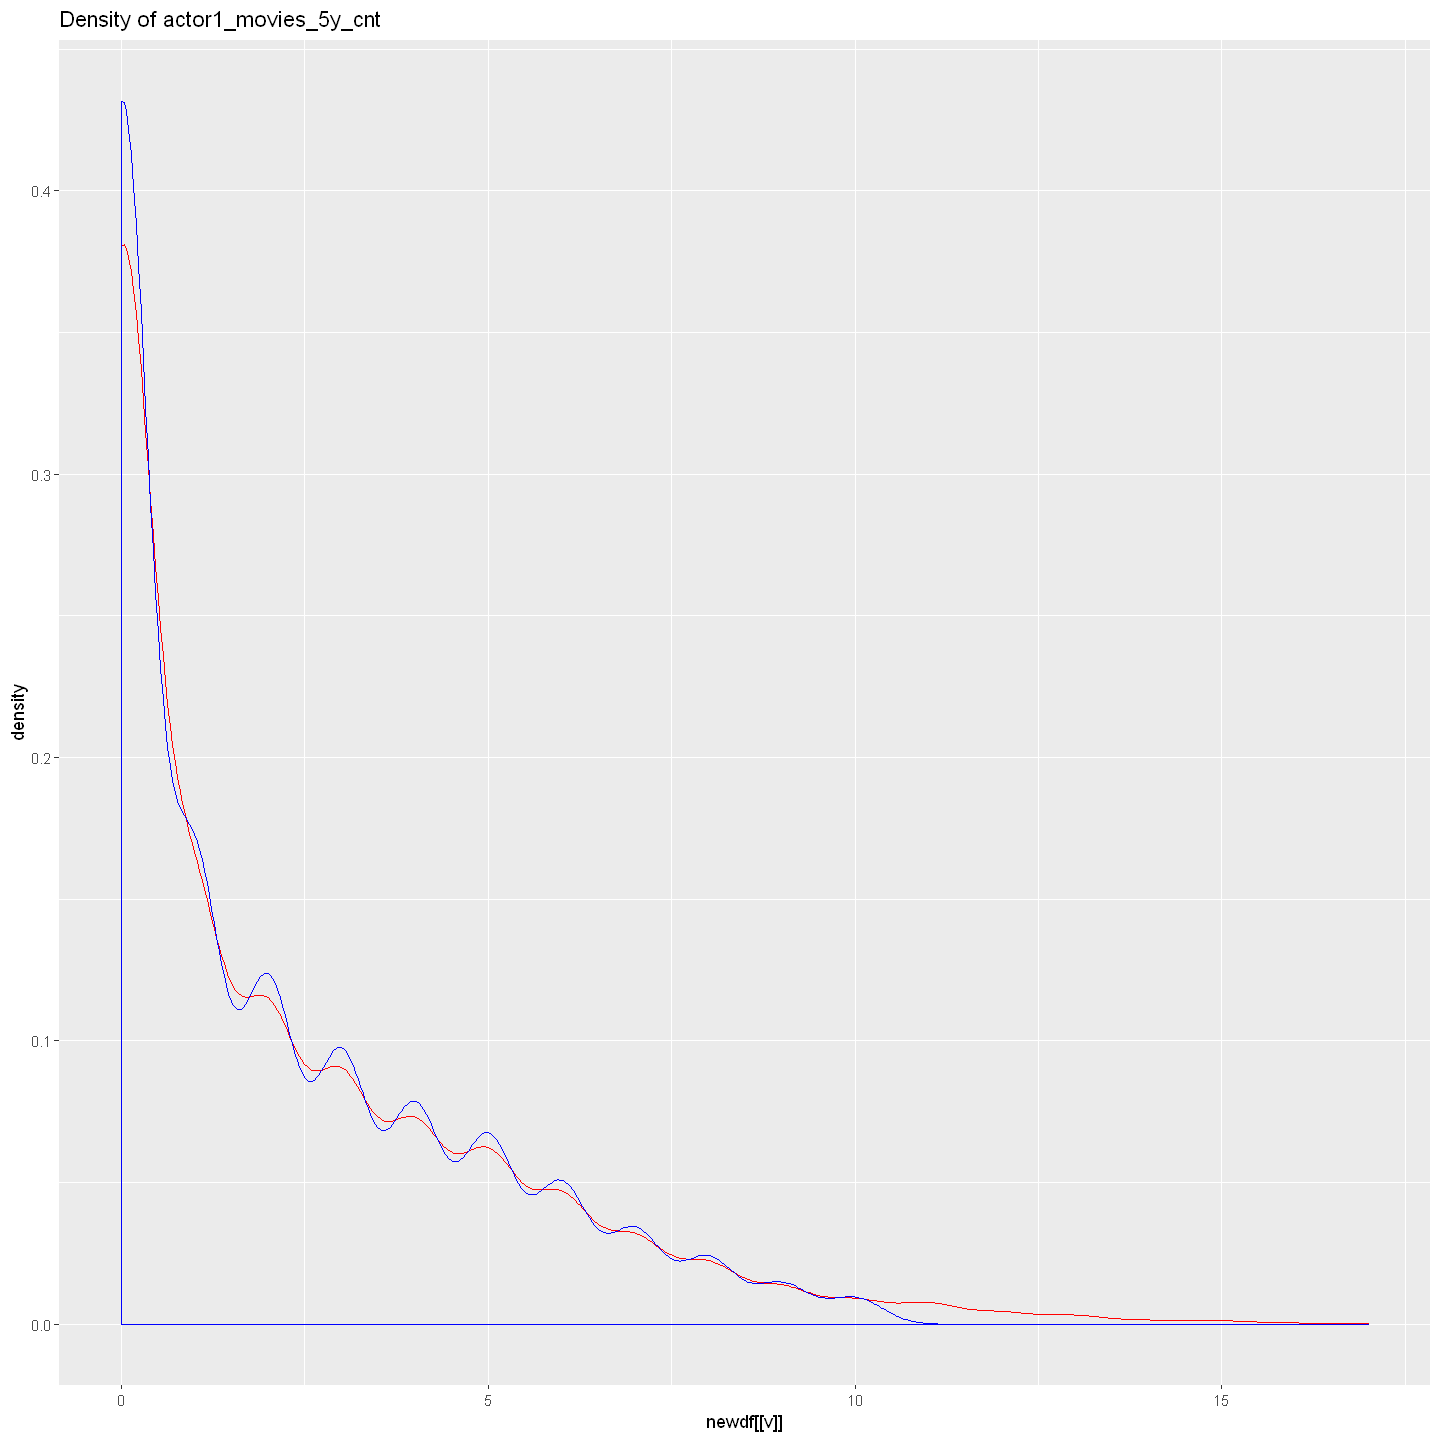

Warning message:
"Removed 345 rows containing non-finite values (stat_density)."


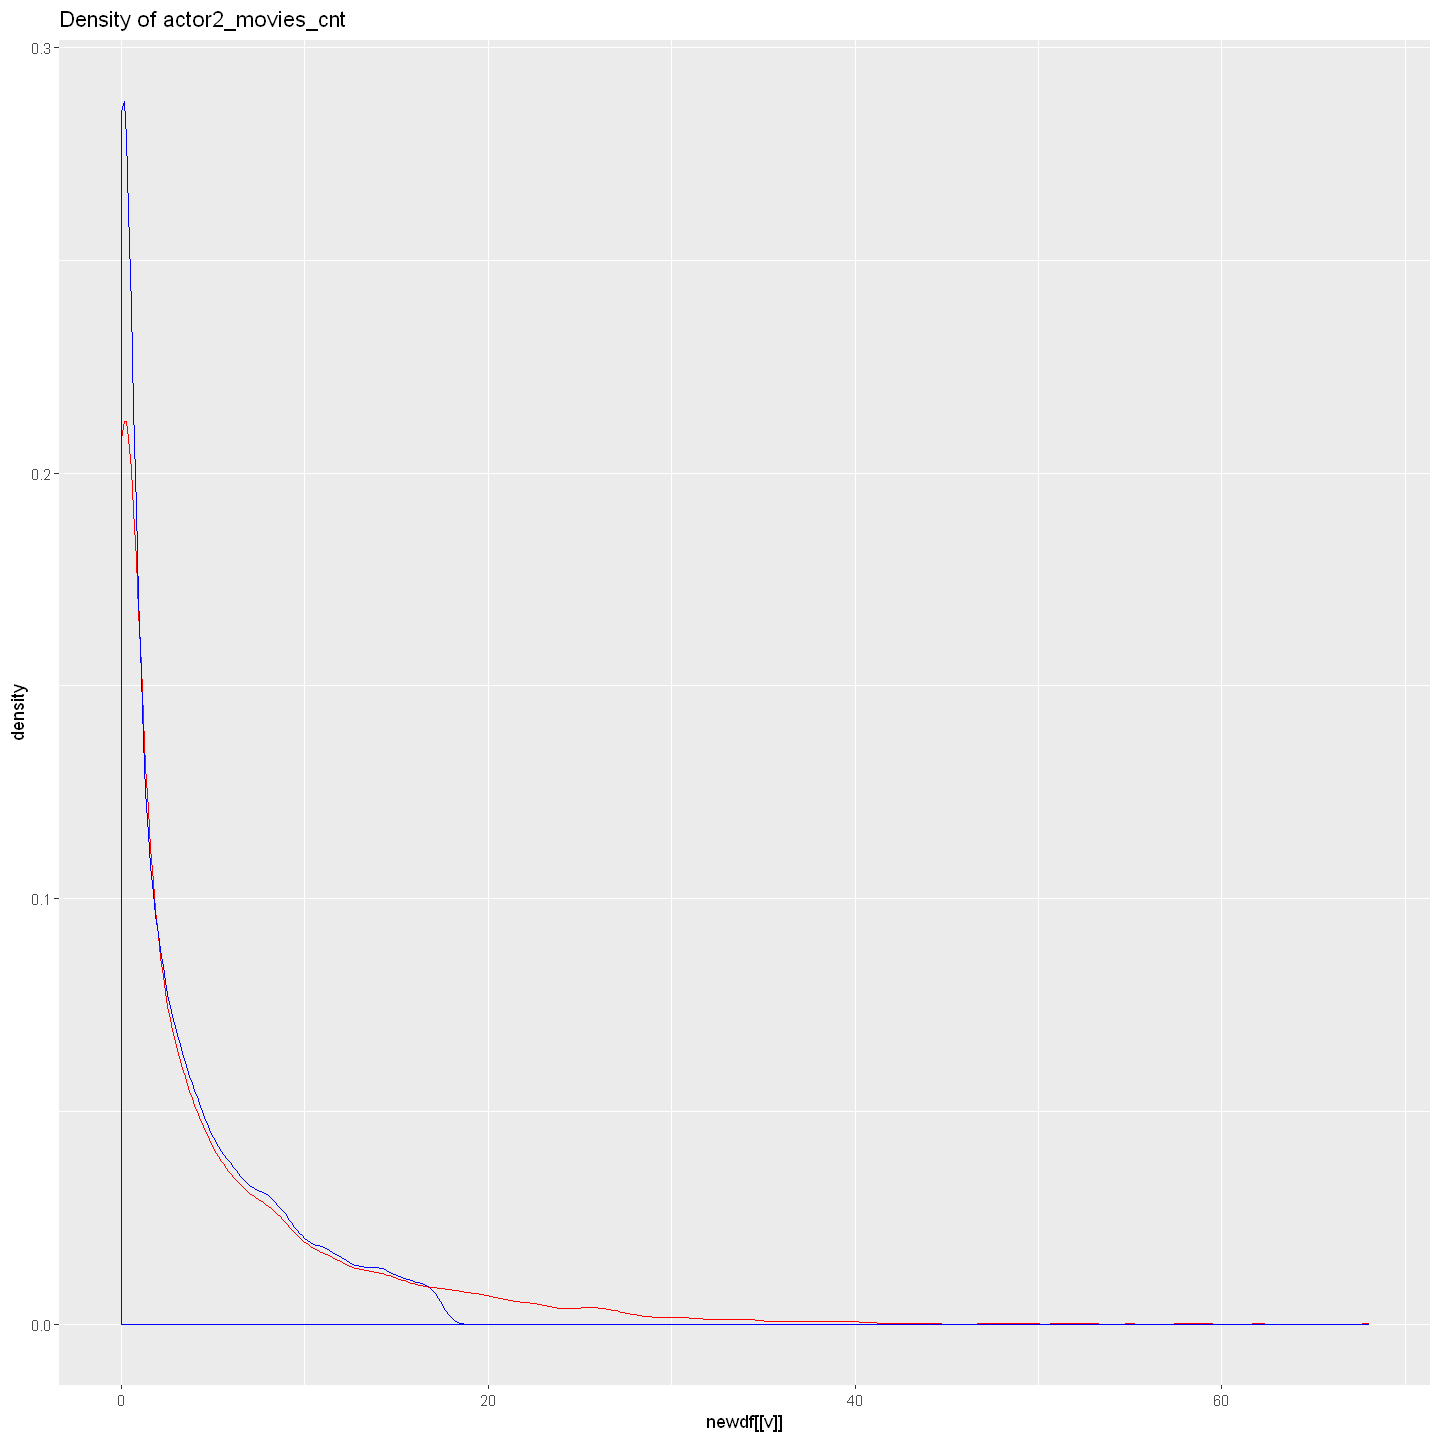

Warning message:
"Removed 934 rows containing non-finite values (stat_density)."
Warning message:
"Removed 2437 rows containing non-finite values (stat_density)."


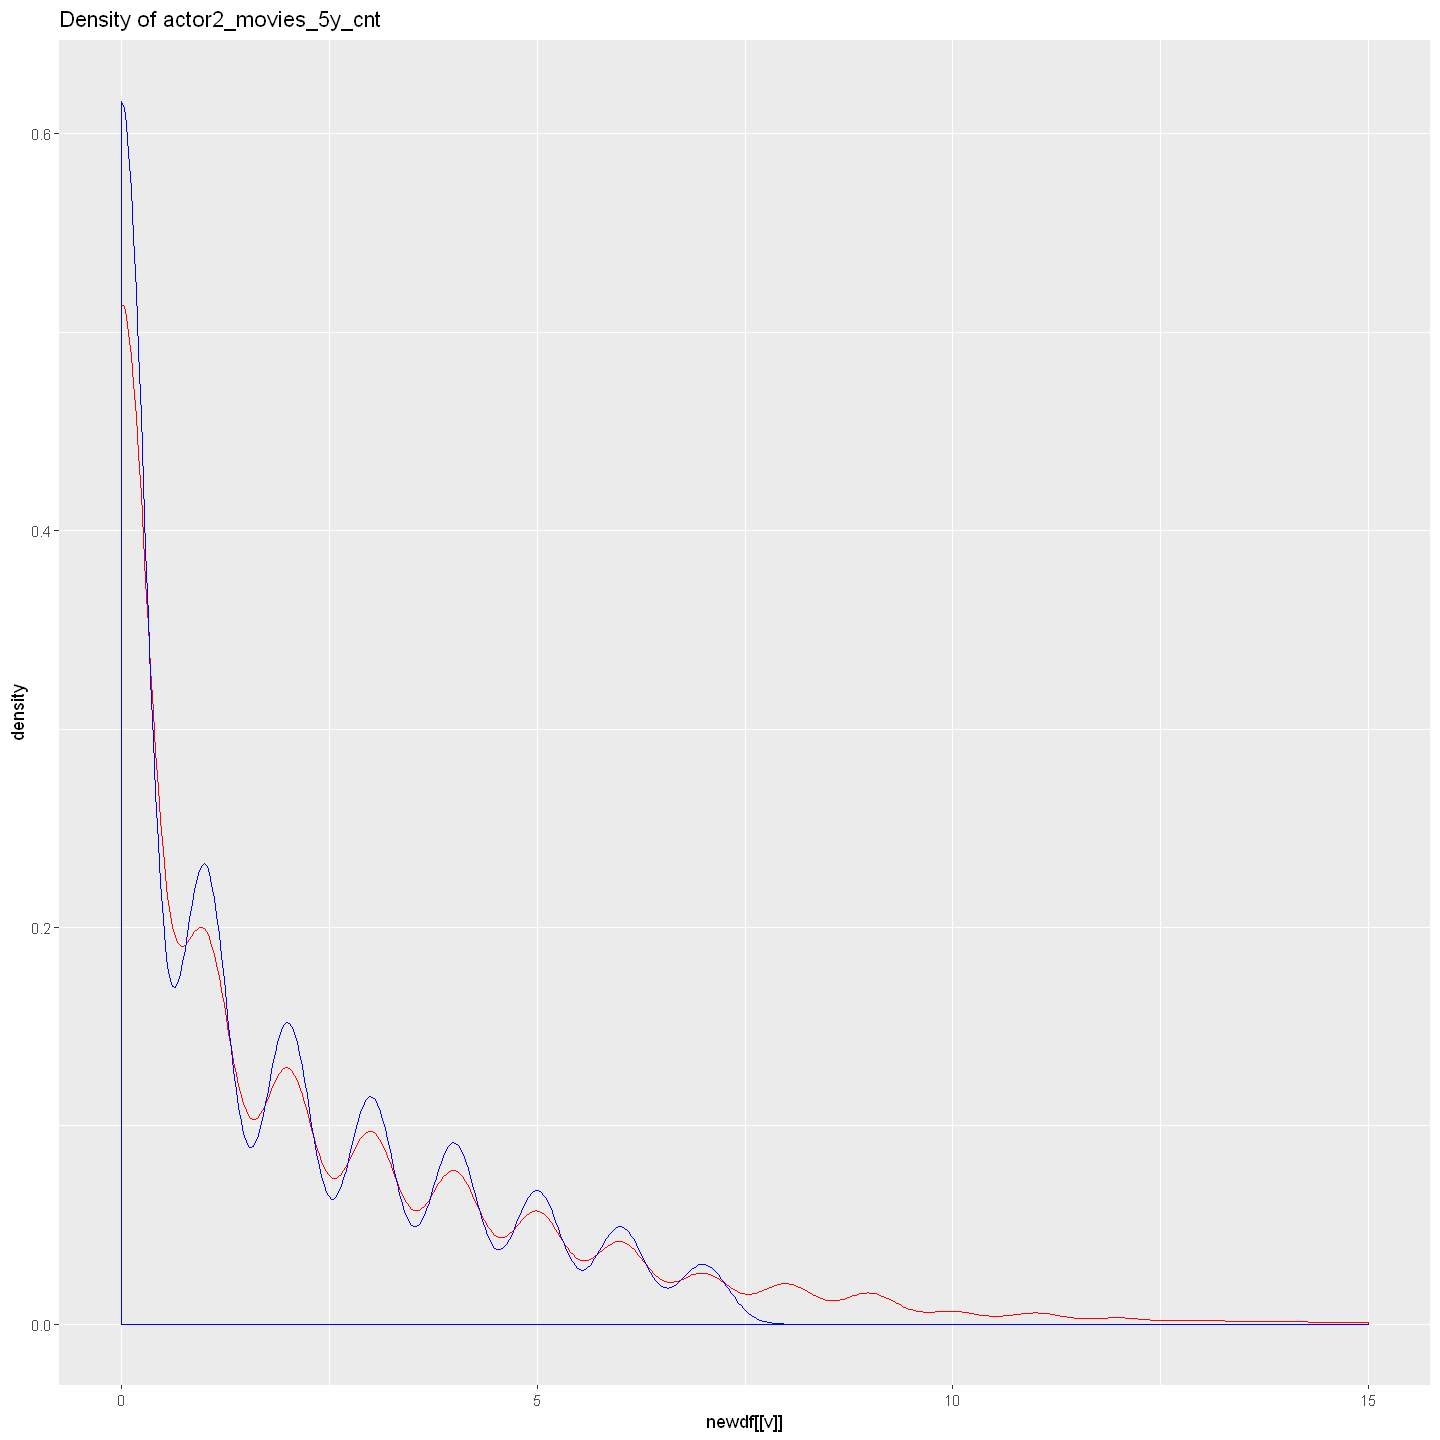

Warning message:
"Removed 782 rows containing non-finite values (stat_density)."
Warning message:
"Removed 782 rows containing non-finite values (stat_density)."


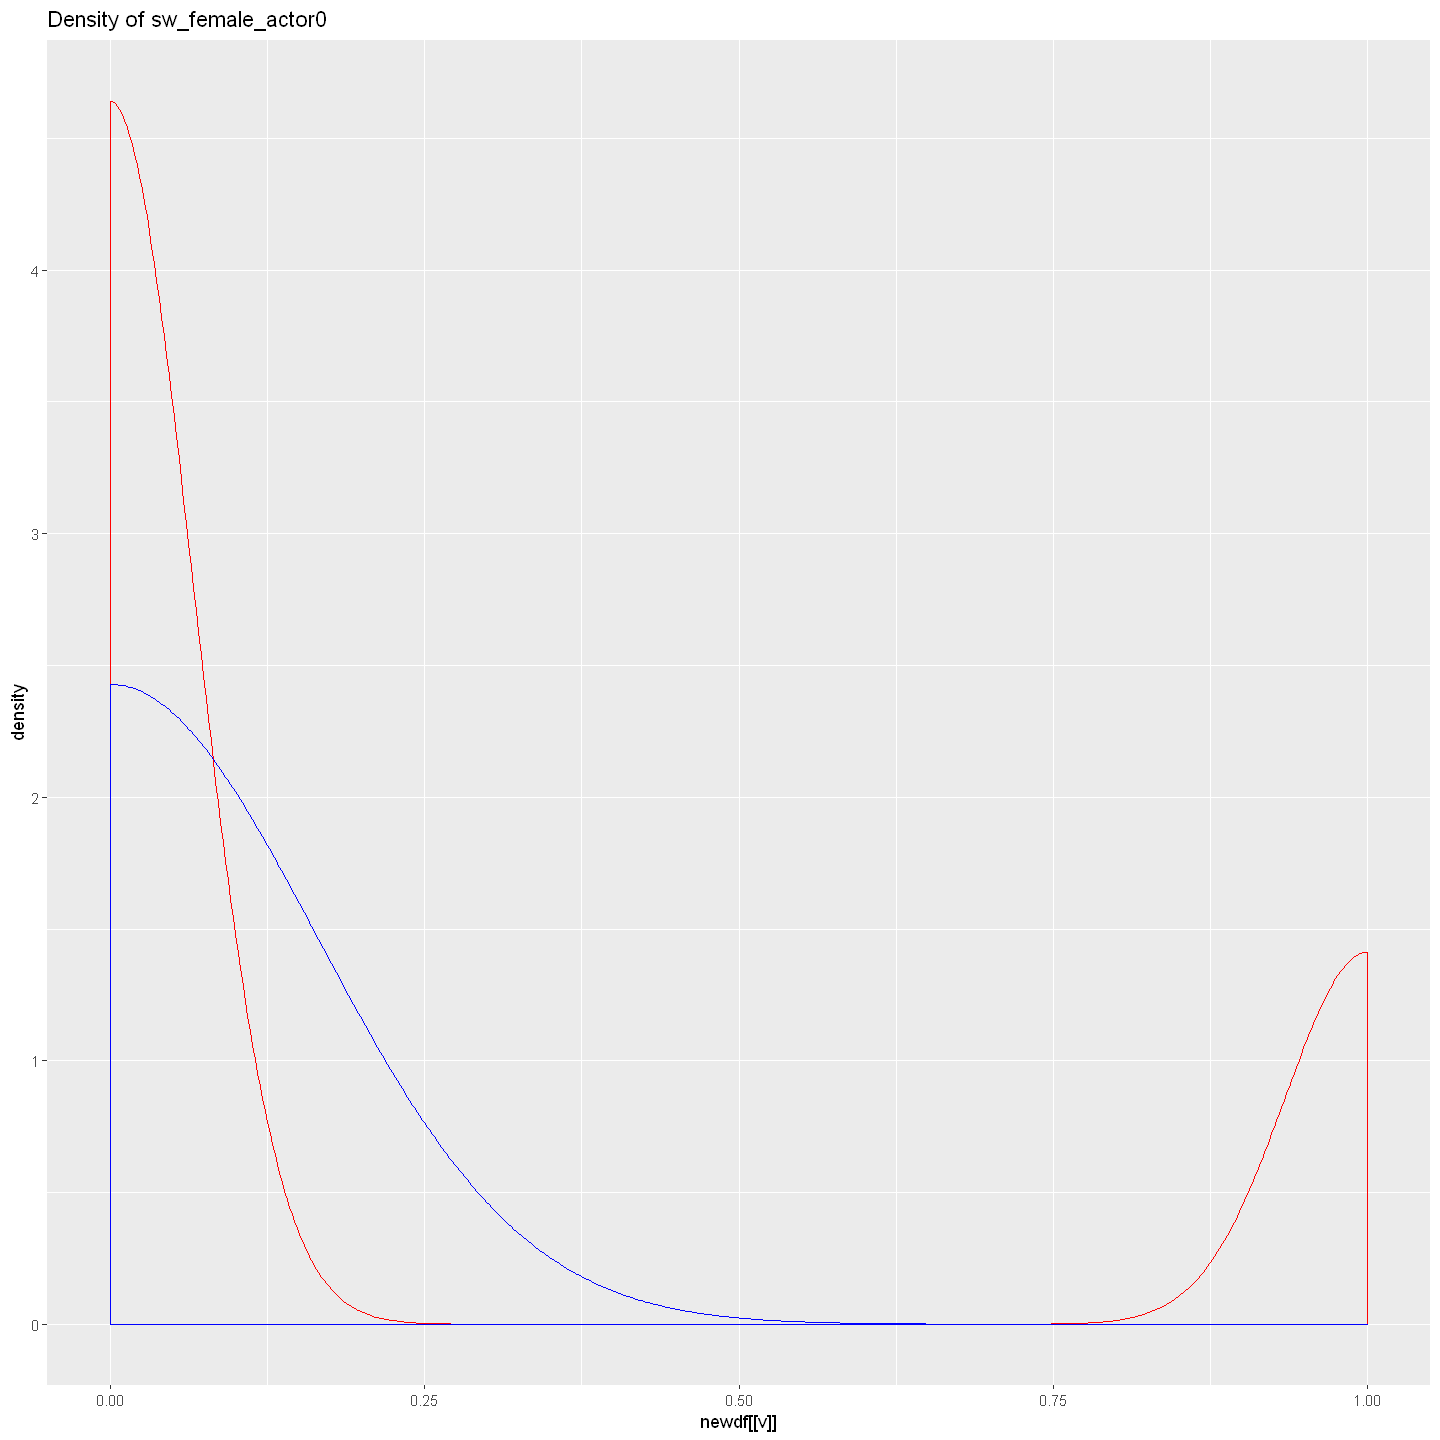

Warning message:
"Removed 788 rows containing non-finite values (stat_density)."
Warning message:
"Removed 788 rows containing non-finite values (stat_density)."


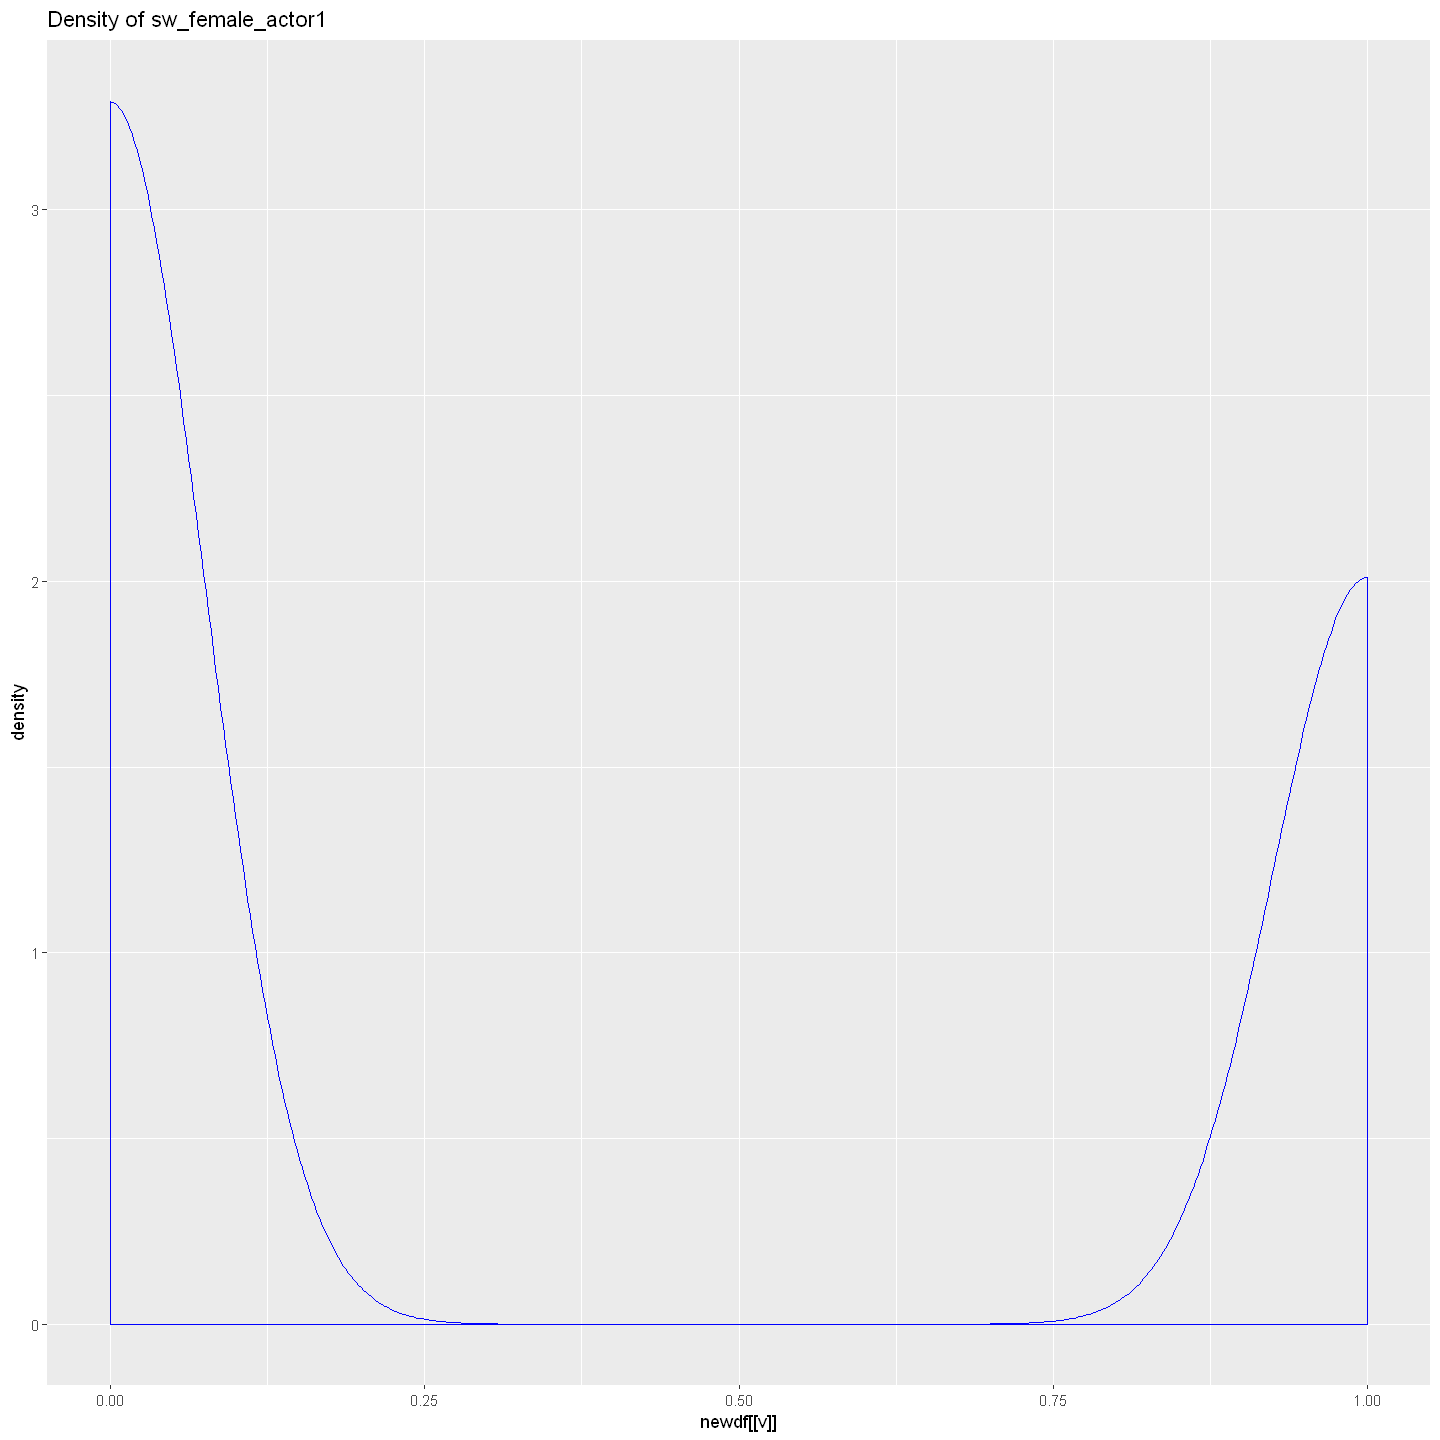

Warning message:
"Removed 934 rows containing non-finite values (stat_density)."
Warning message:
"Removed 934 rows containing non-finite values (stat_density)."


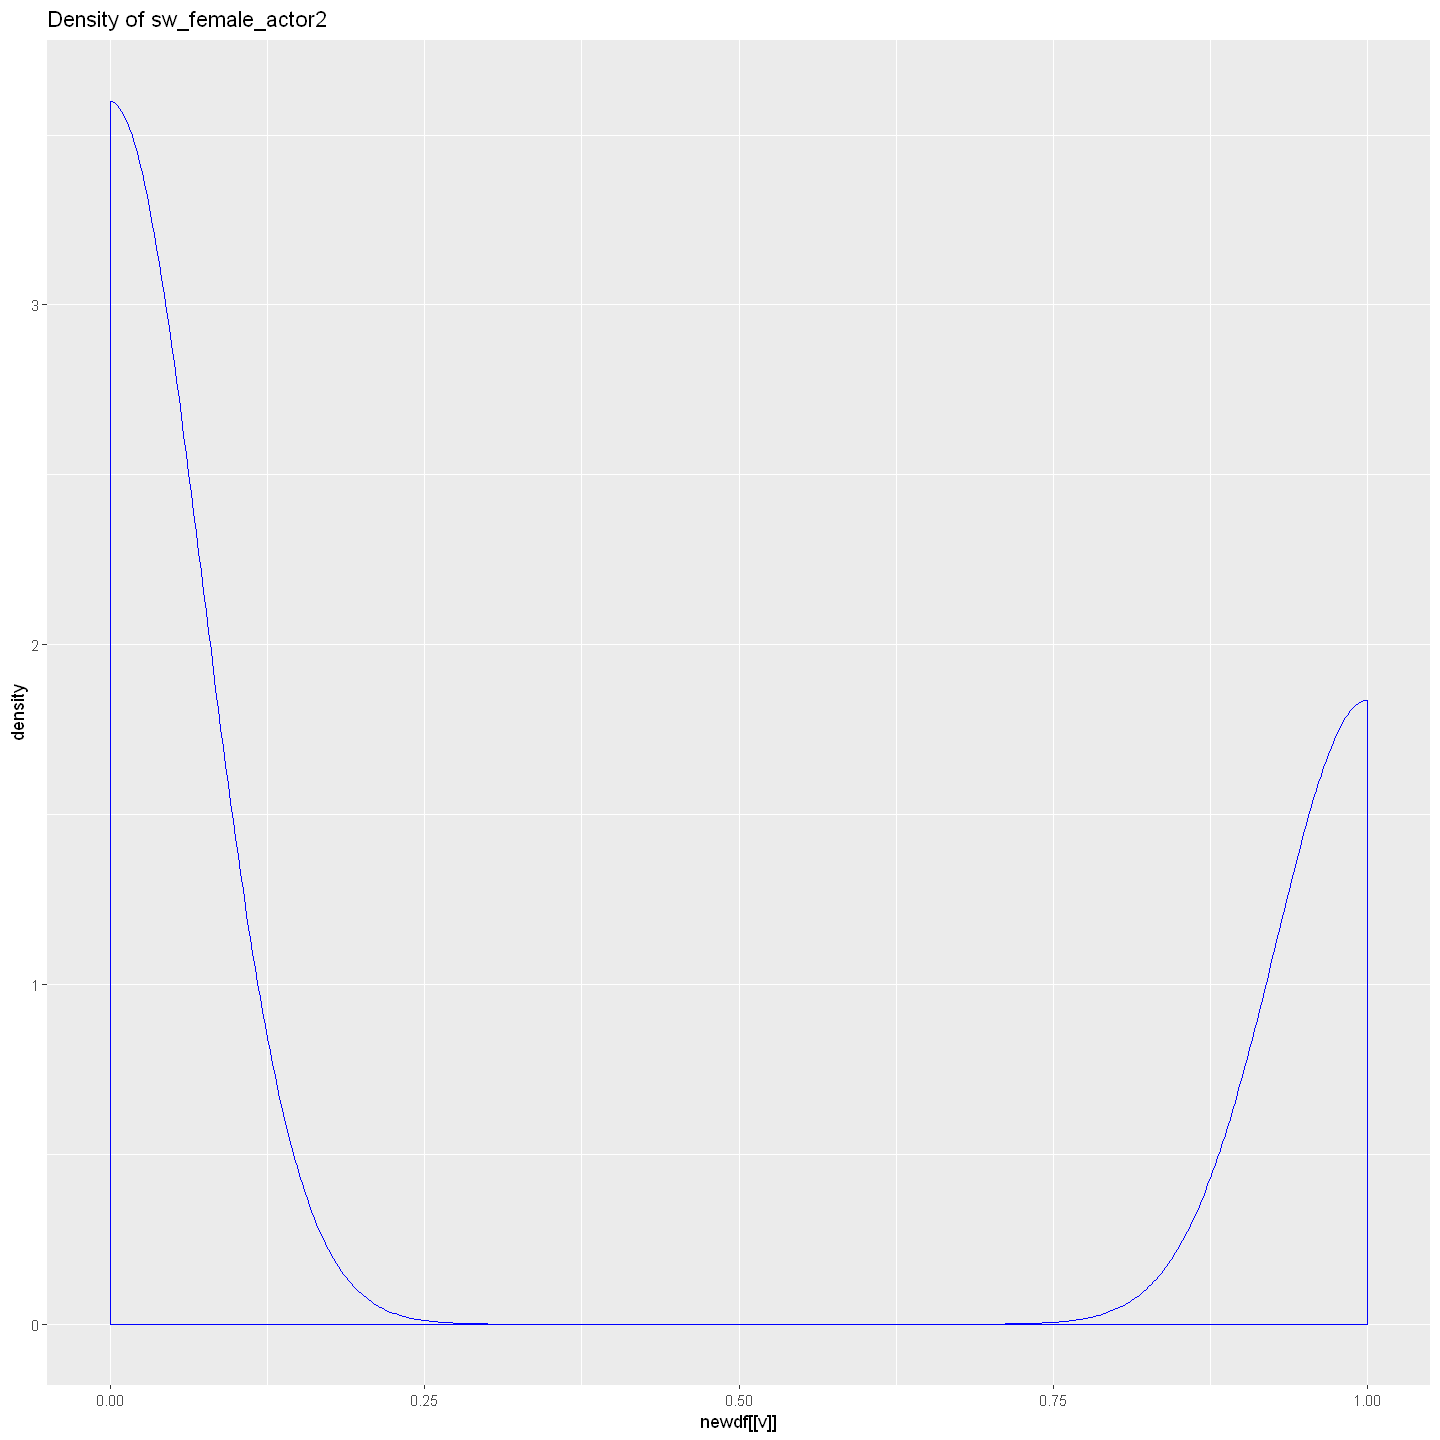

Warning message:
"Removed 782 rows containing non-finite values (stat_density)."
Warning message:
"Removed 782 rows containing non-finite values (stat_density)."


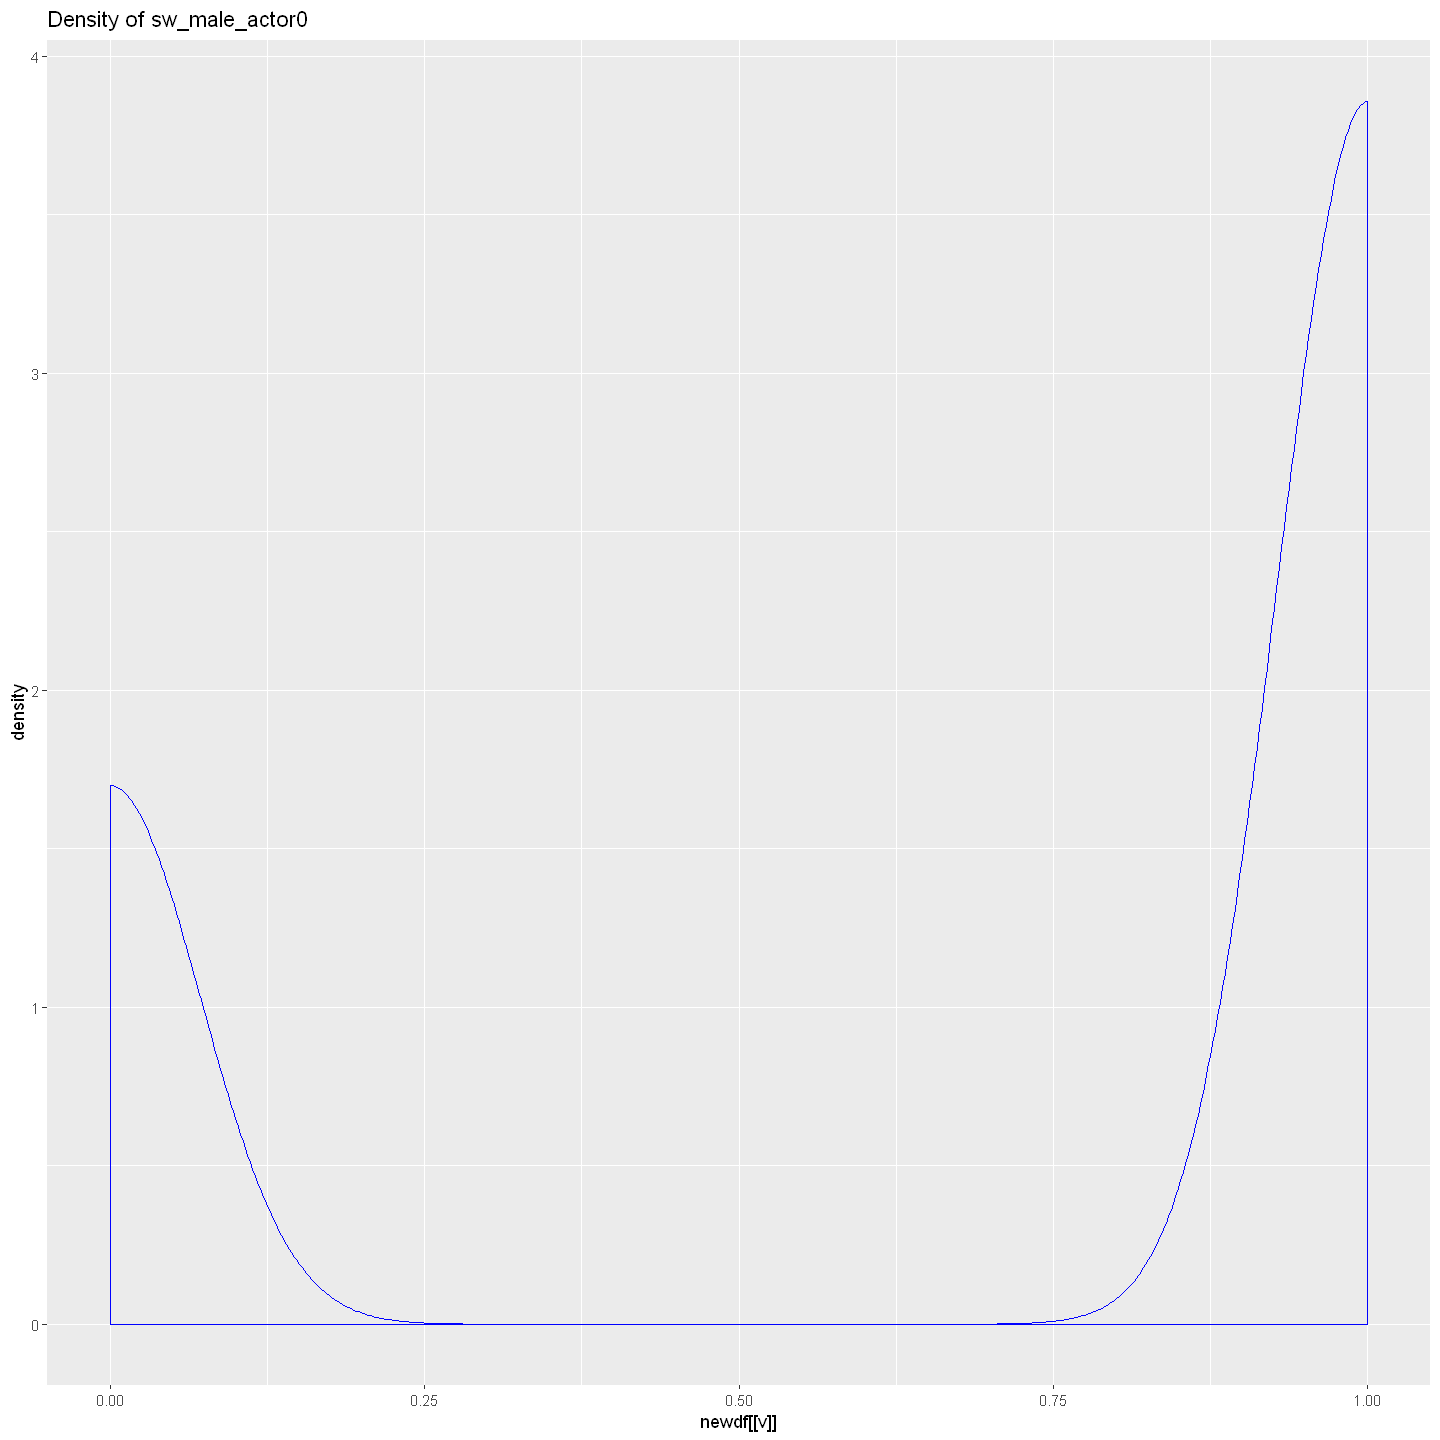

Warning message:
"Removed 788 rows containing non-finite values (stat_density)."
Warning message:
"Removed 788 rows containing non-finite values (stat_density)."


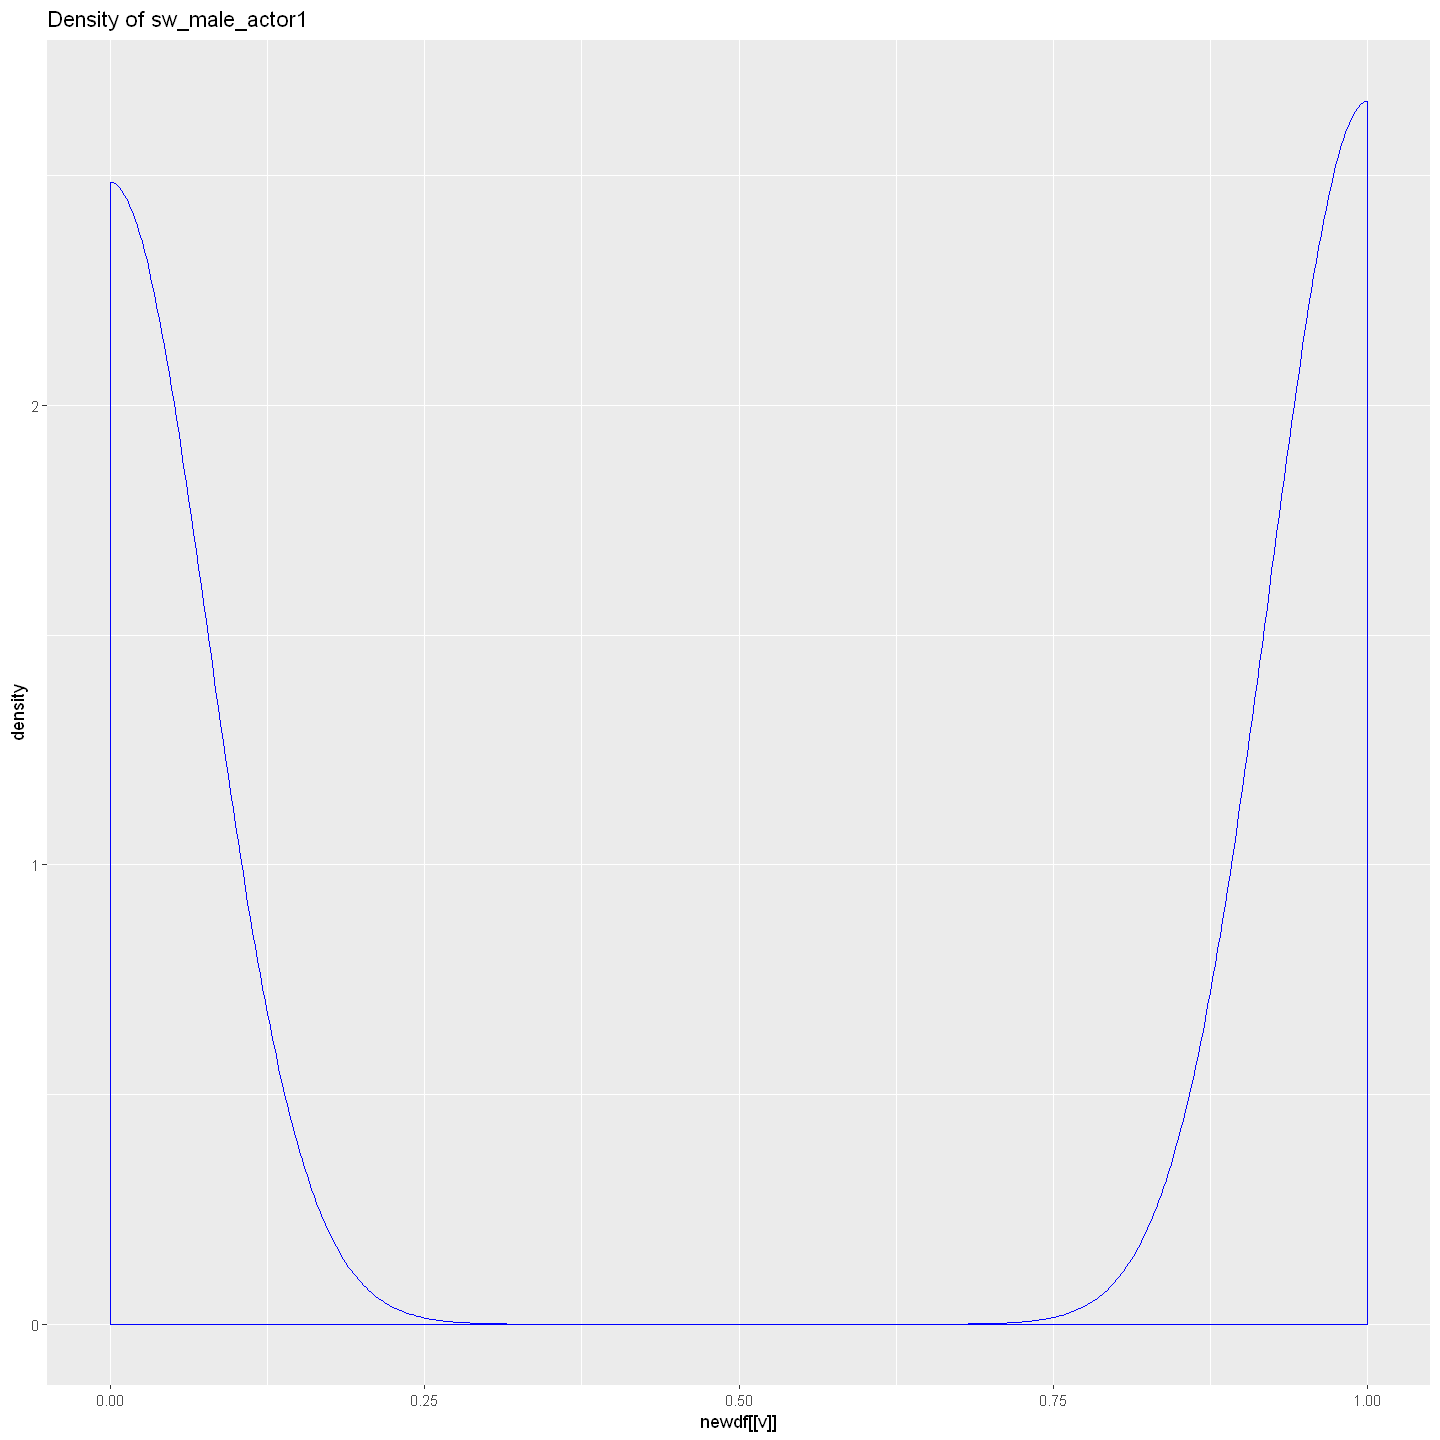

Warning message:
"Removed 2752 rows containing non-finite values (stat_density)."
Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


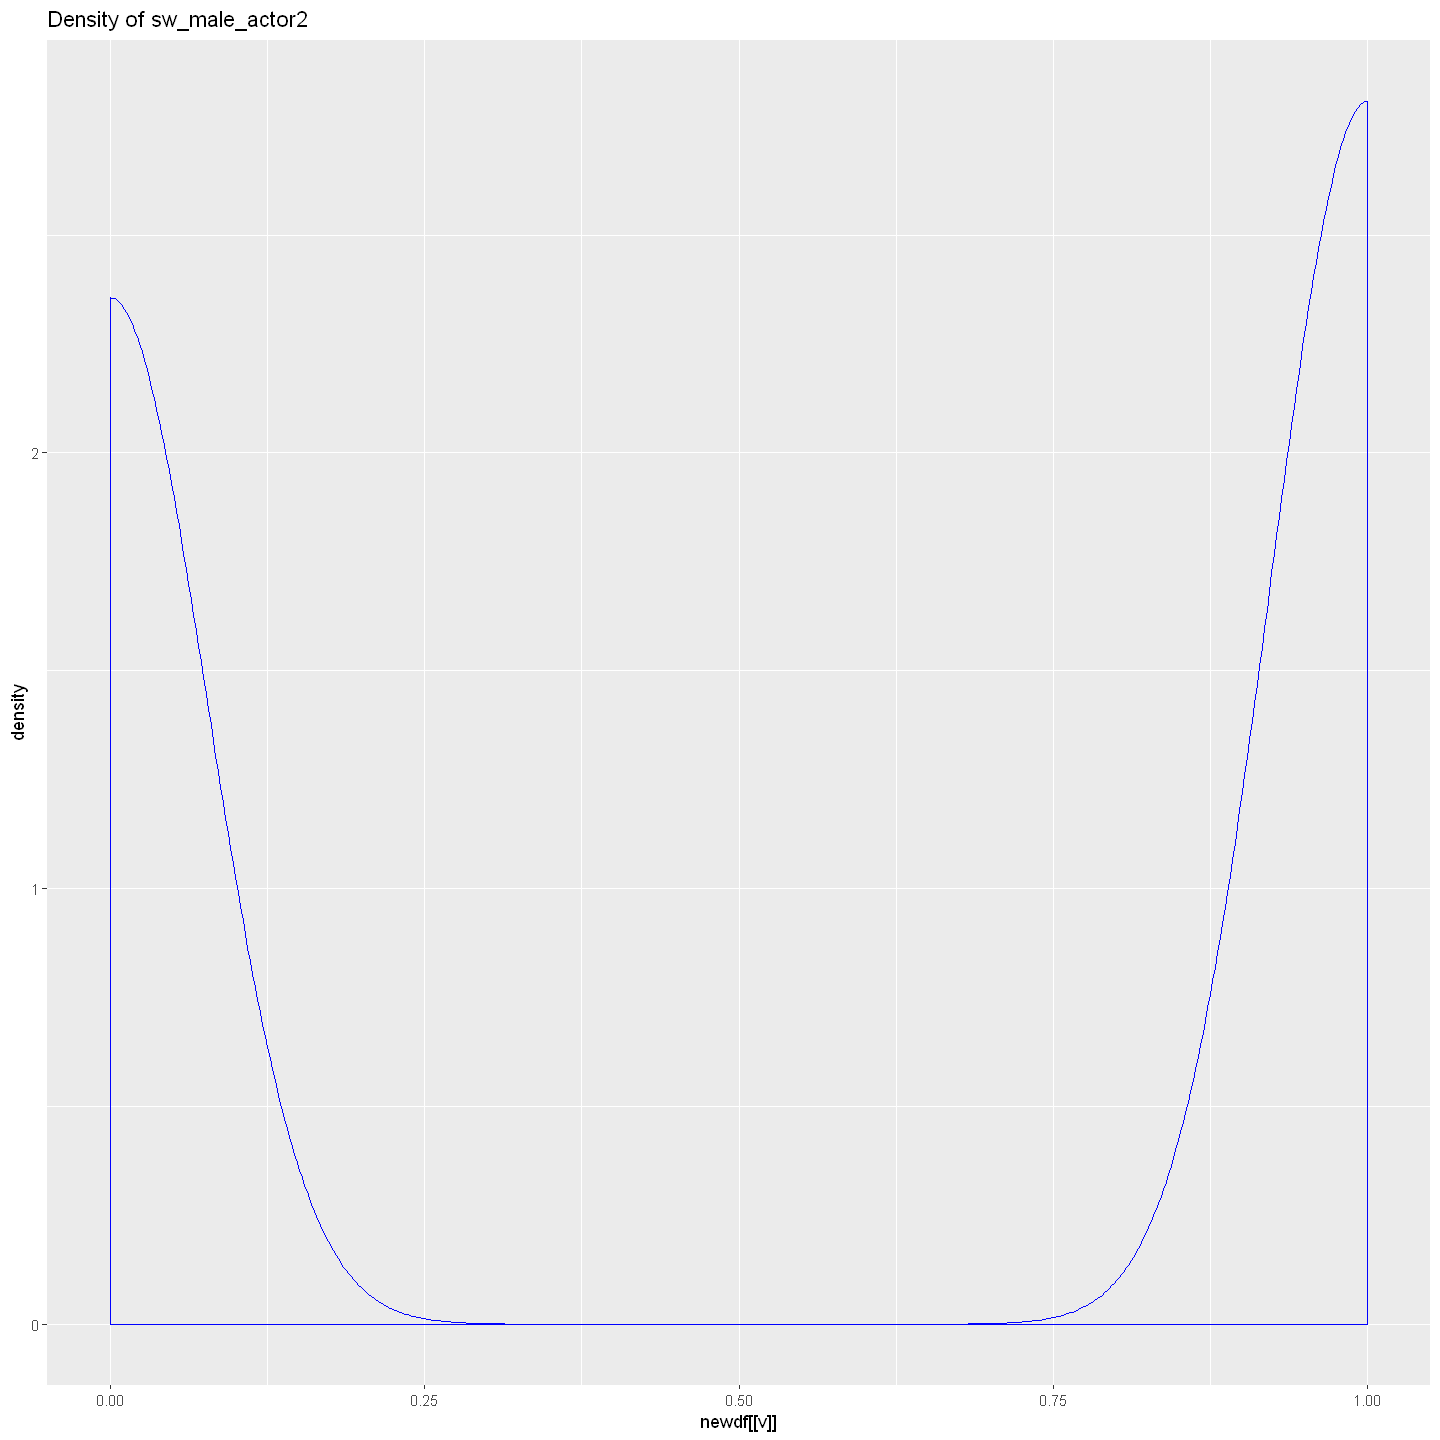

Warning message:
"Removed 3201 rows containing non-finite values (stat_density)."
Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


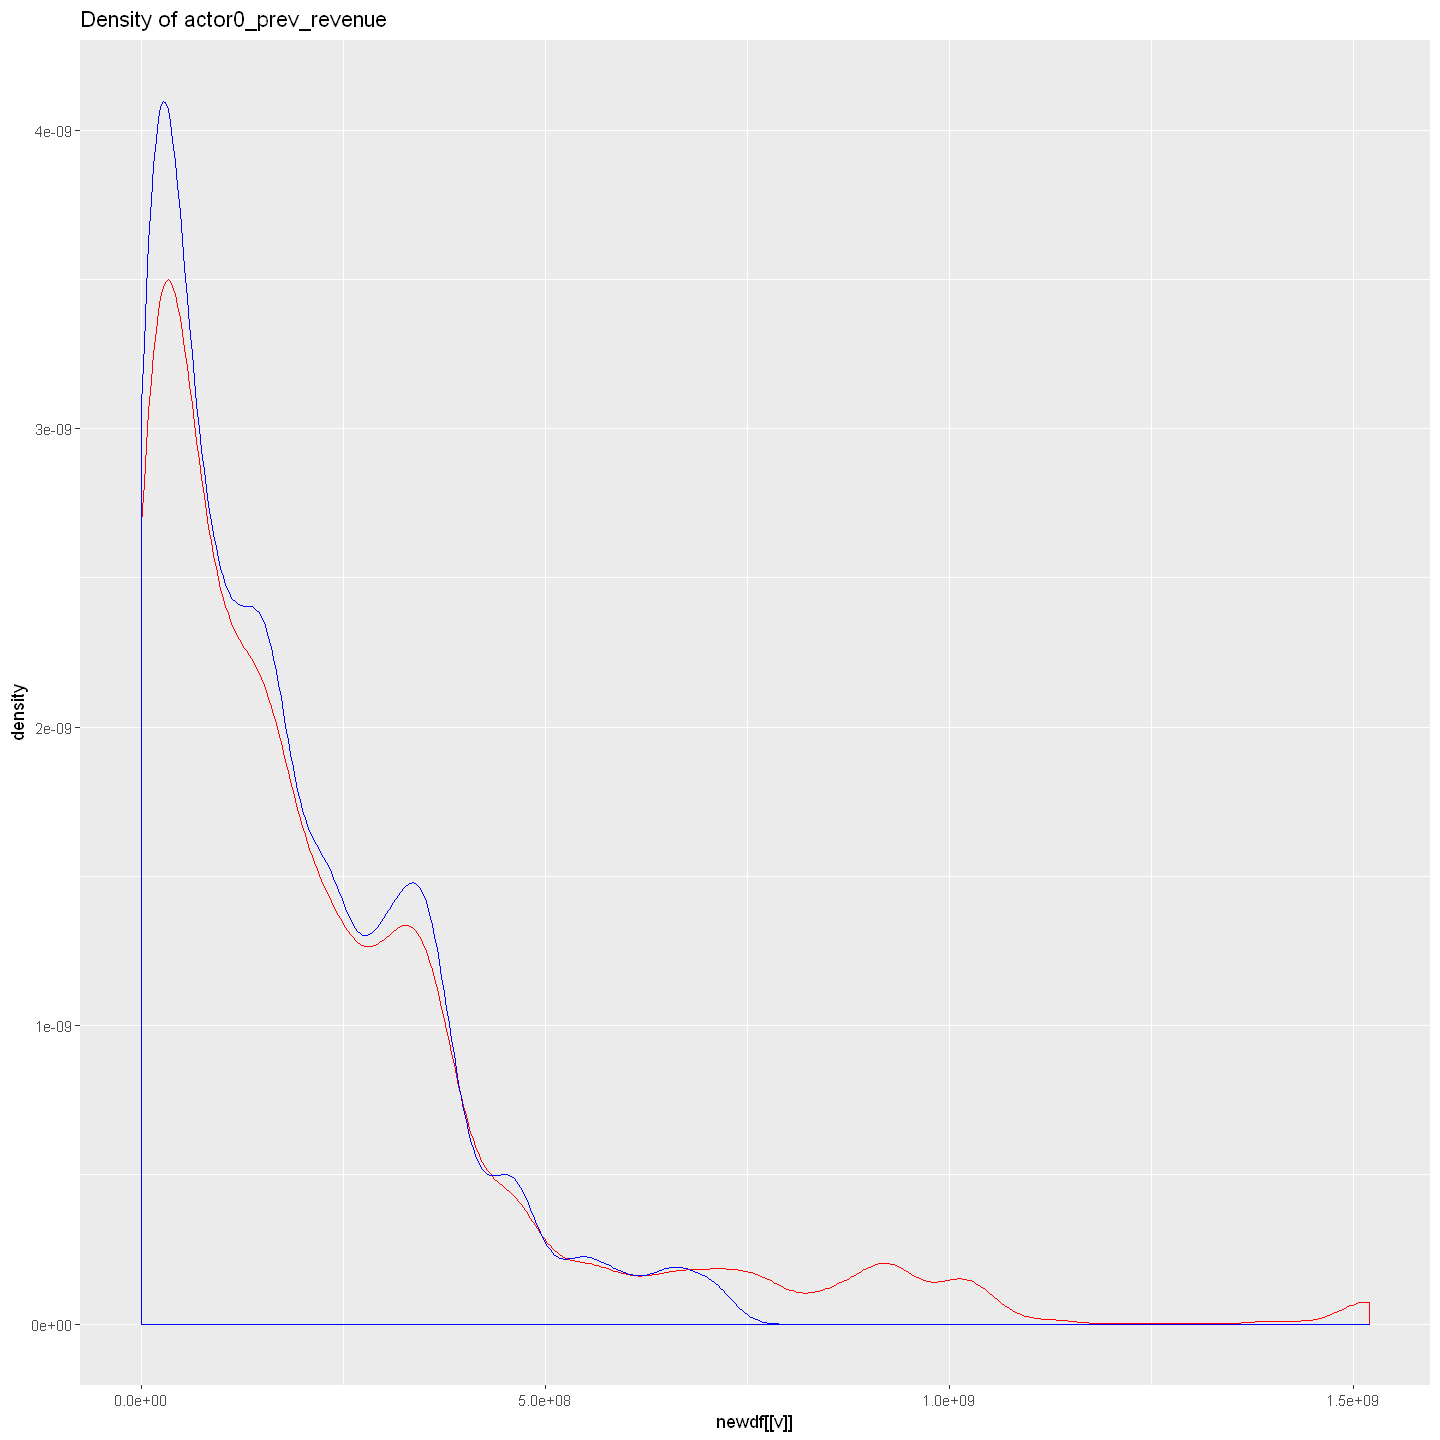

Warning message:
"Removed 3423 rows containing non-finite values (stat_density)."
Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


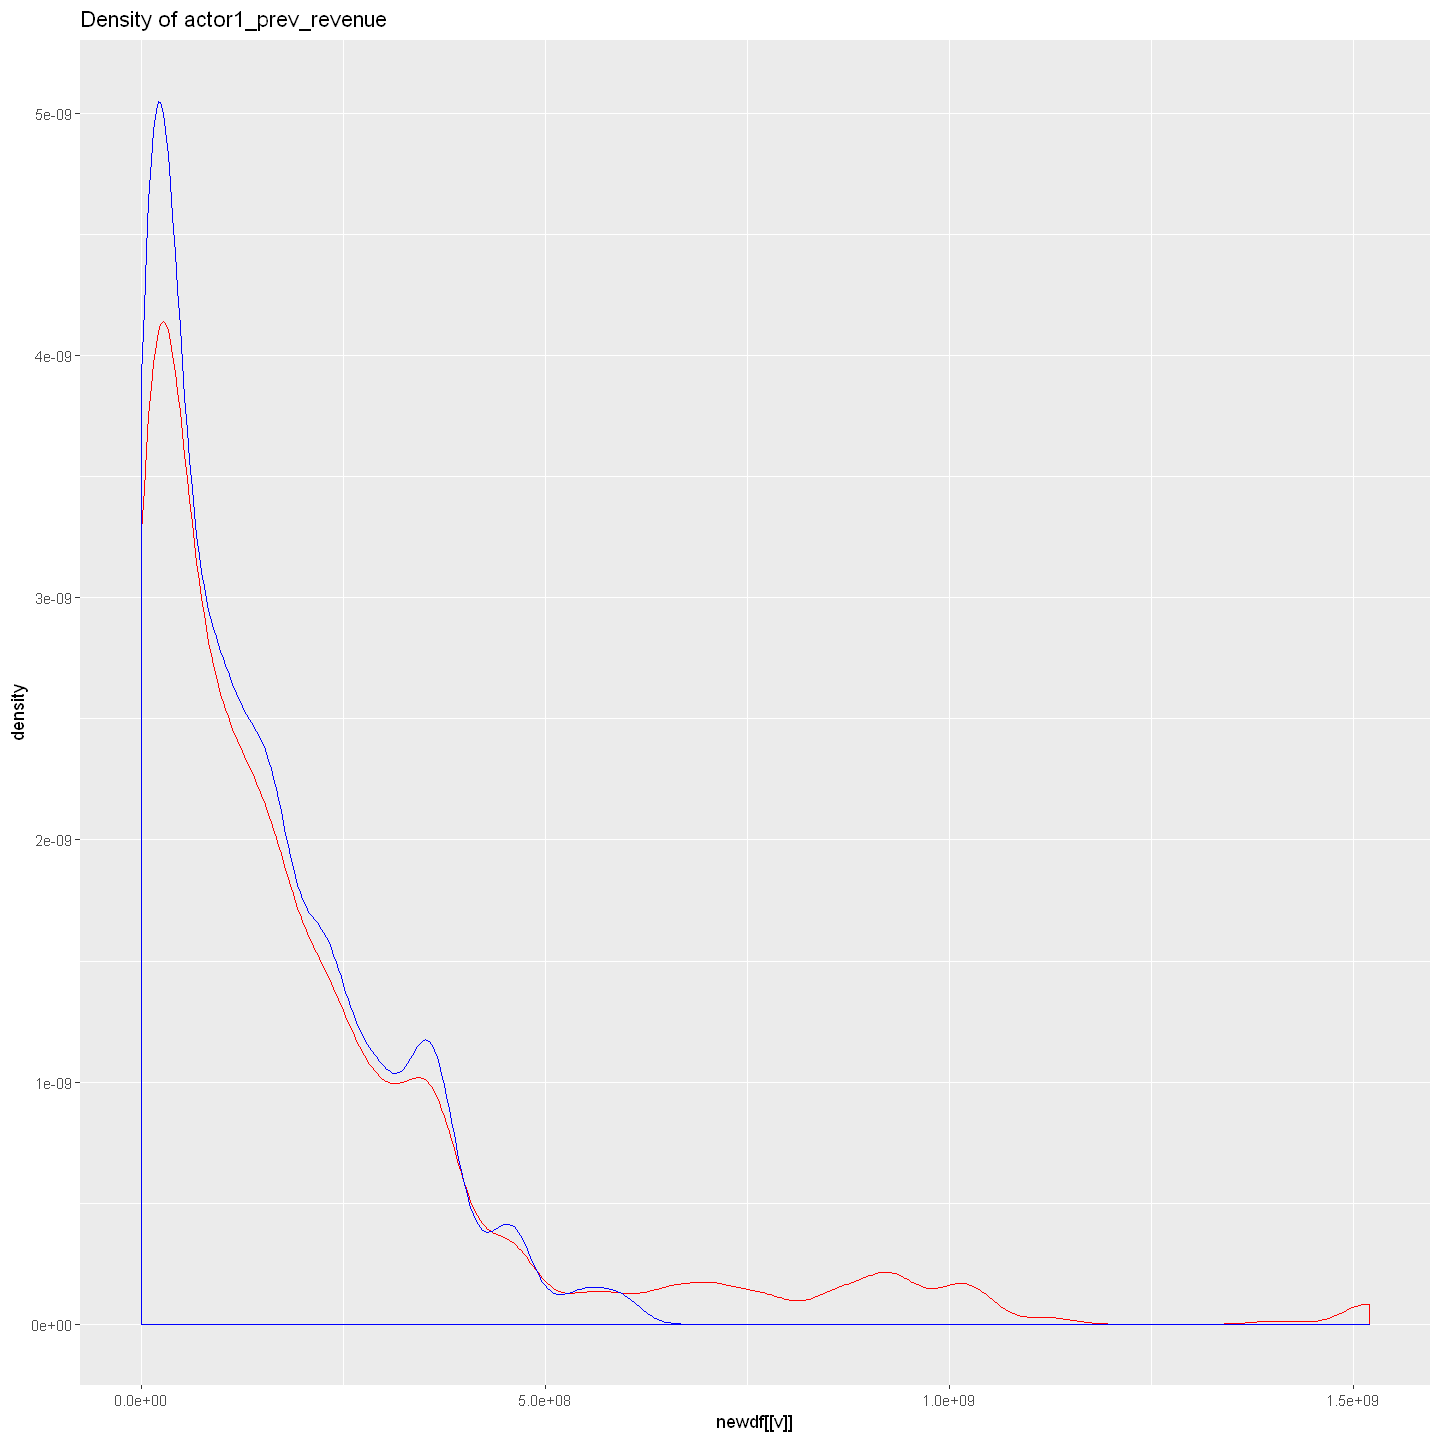

Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


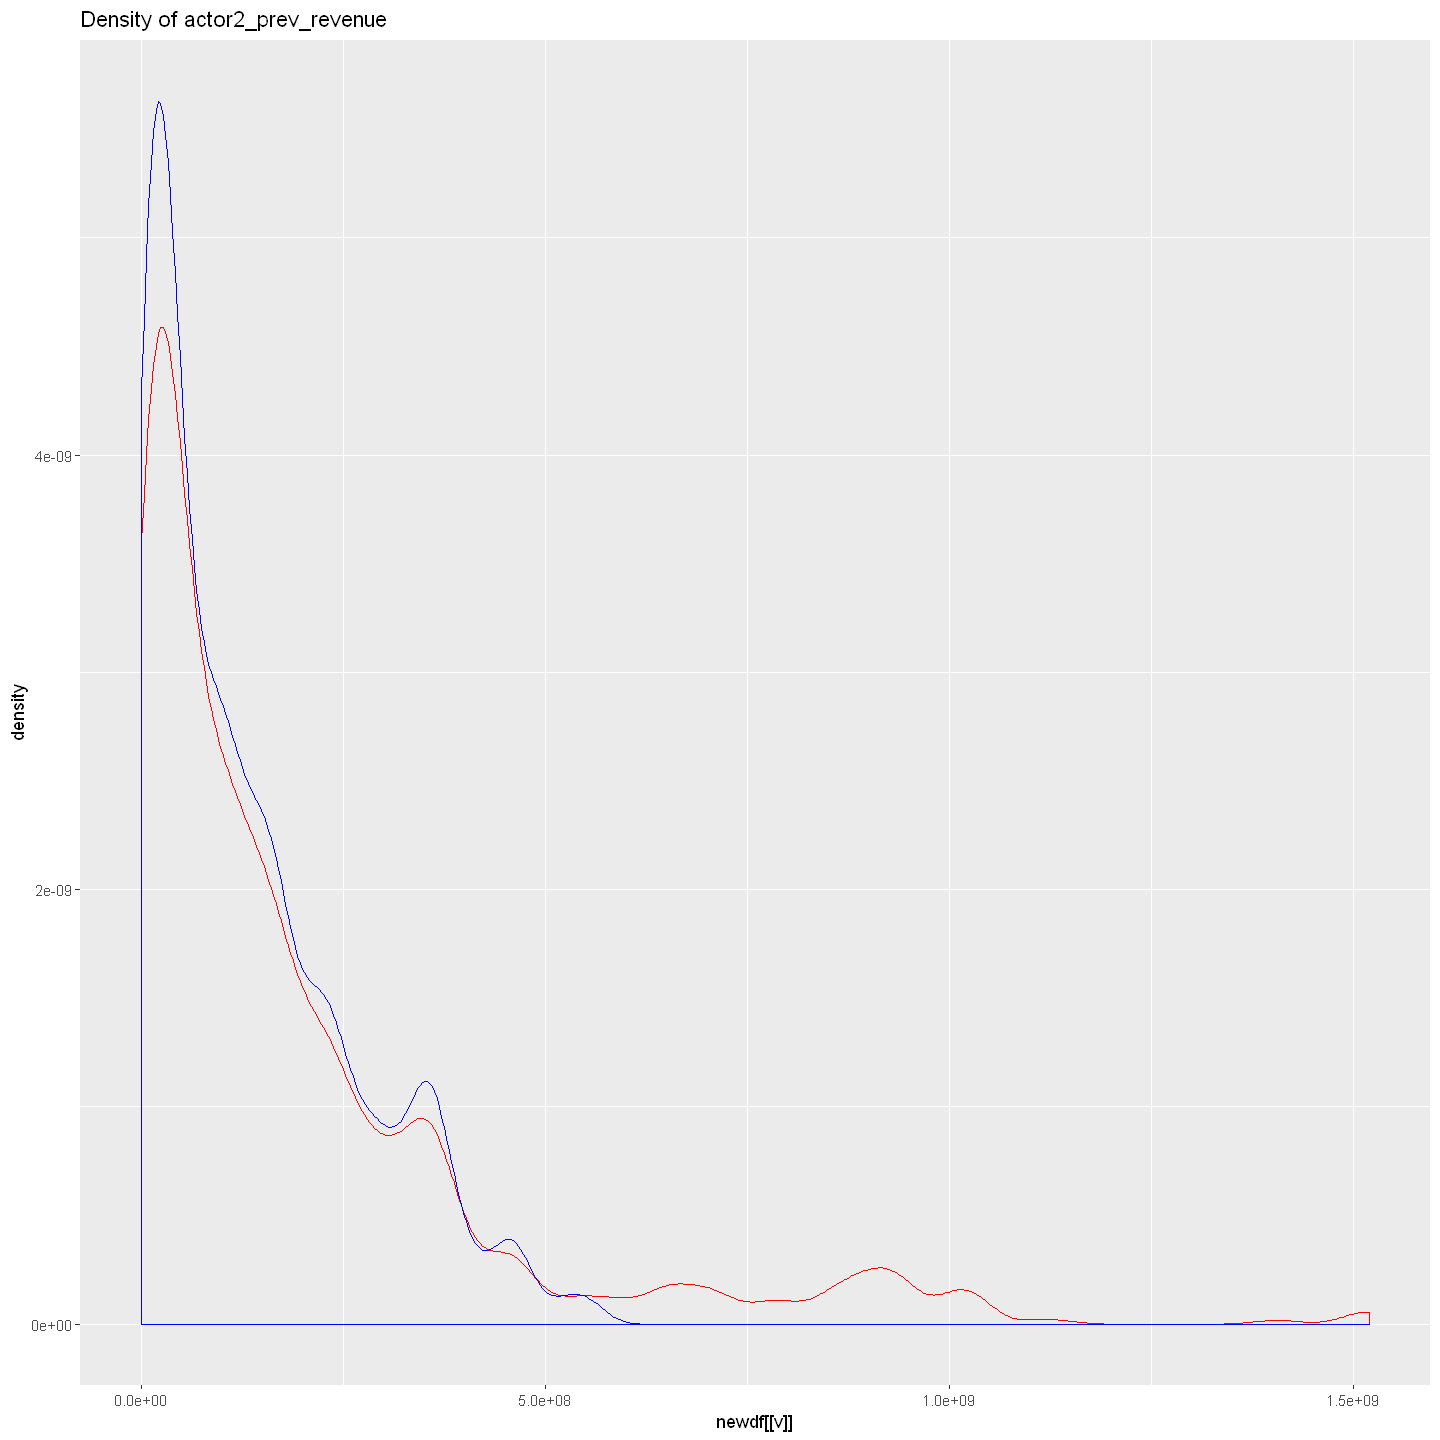

Warning message:
"Removed 350 rows containing non-finite values (stat_density)."


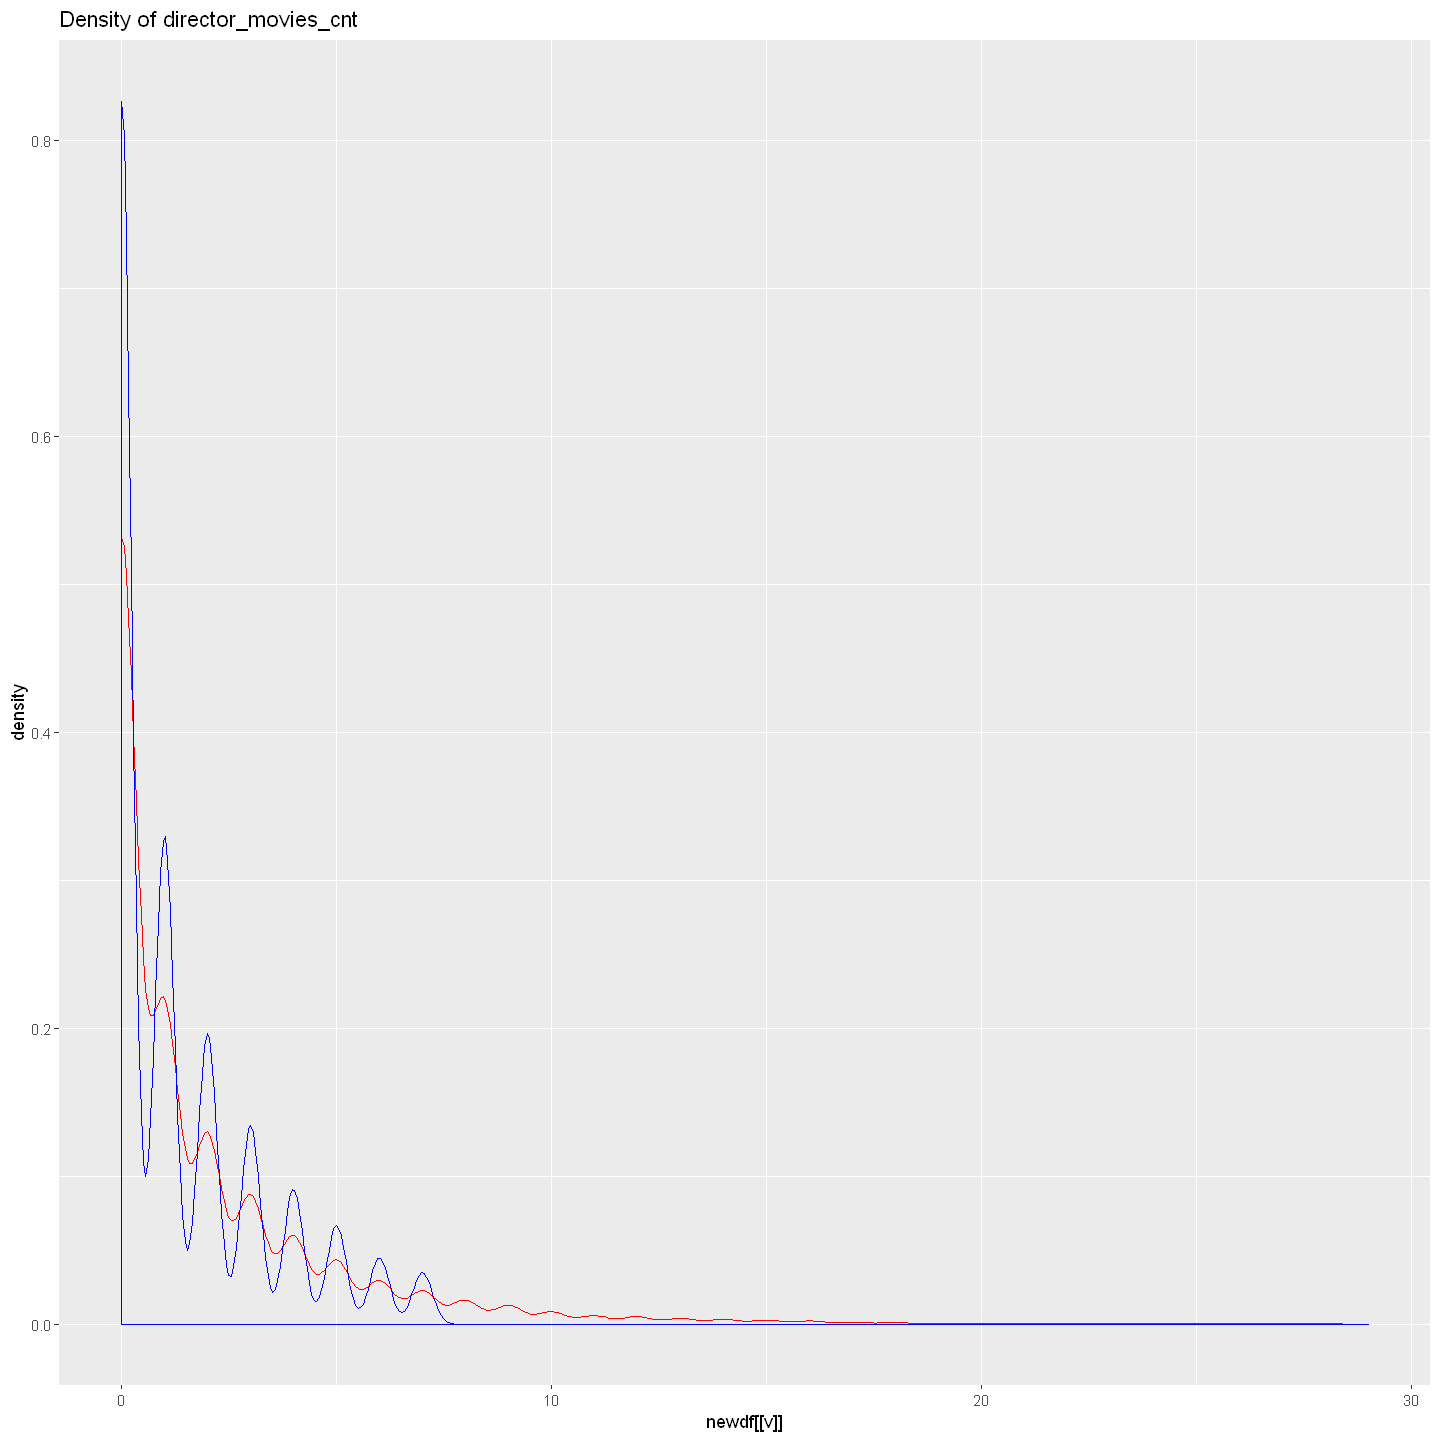

Warning message:
"Removed 1116 rows containing non-finite values (stat_density)."


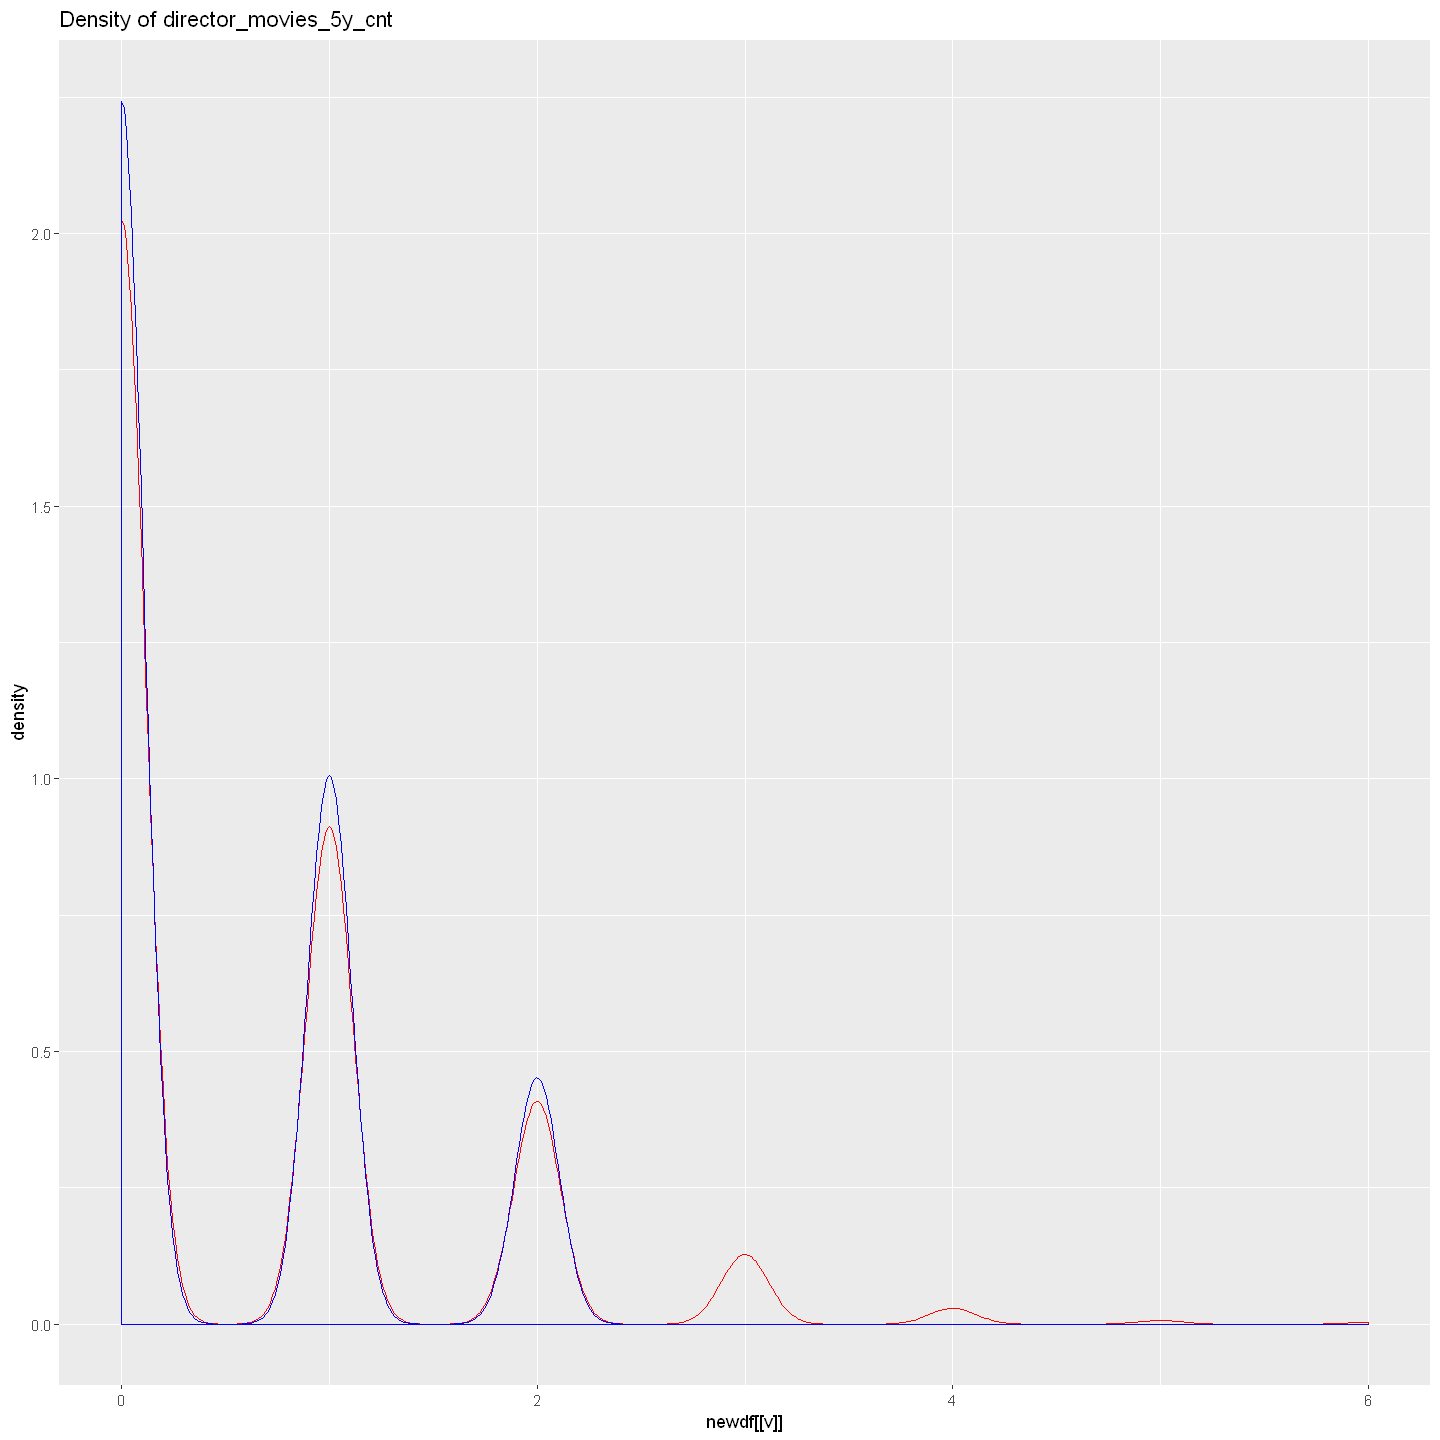

Warning message:
"Removed 628 rows containing non-finite values (stat_density)."


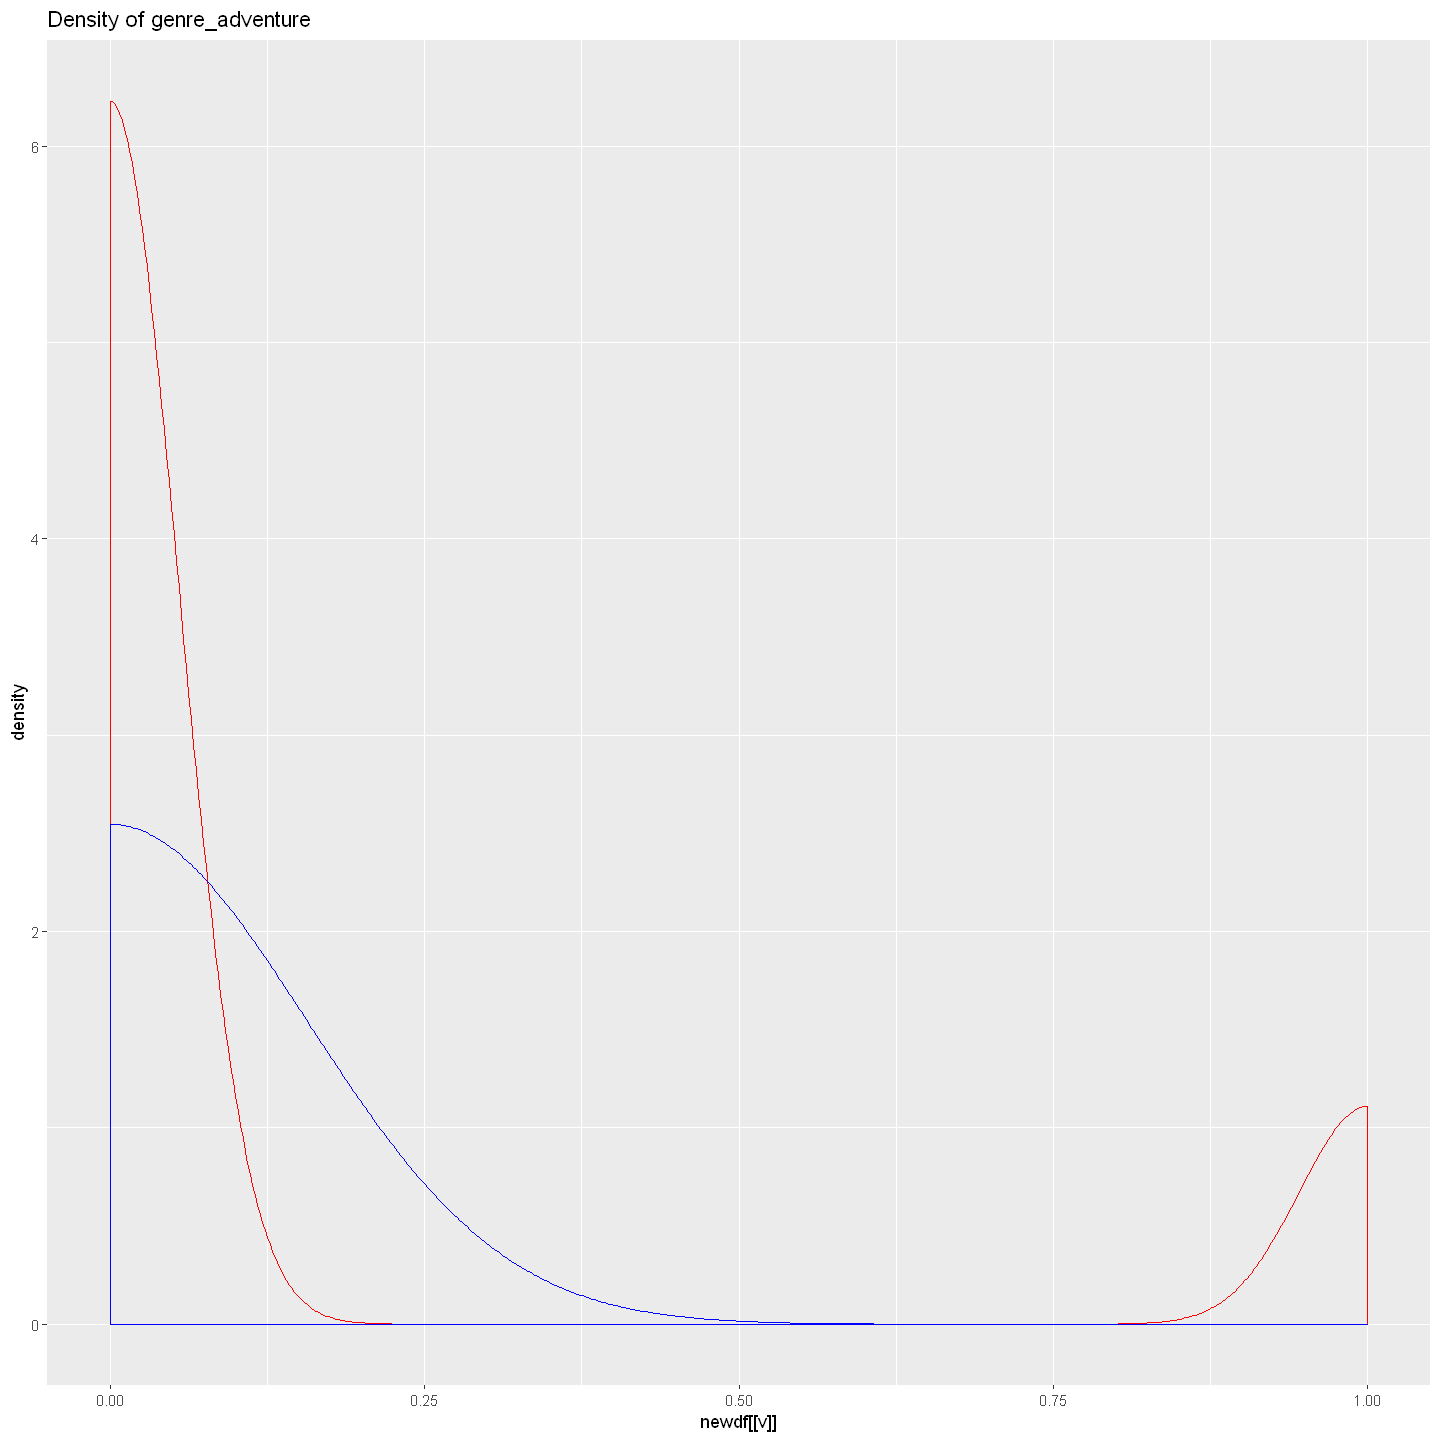

Warning message:
"Removed 382 rows containing non-finite values (stat_density)."


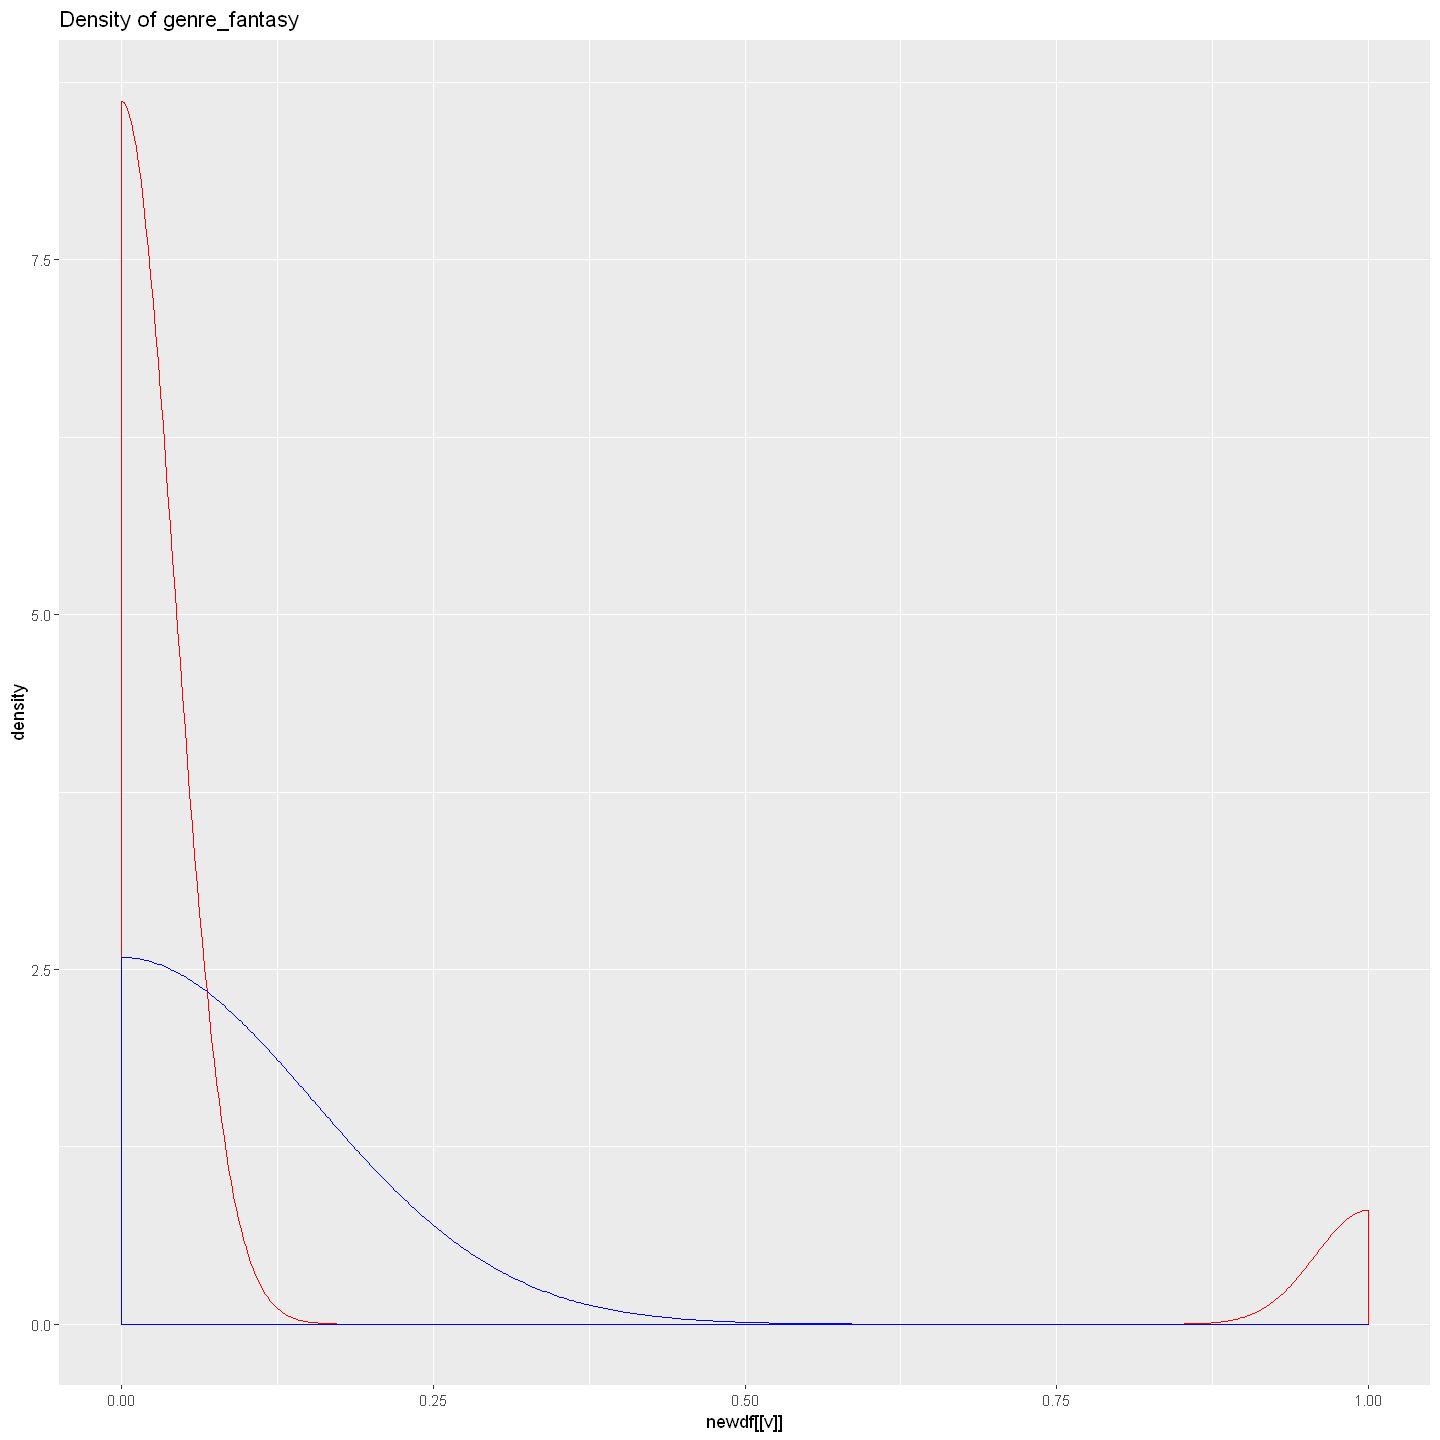

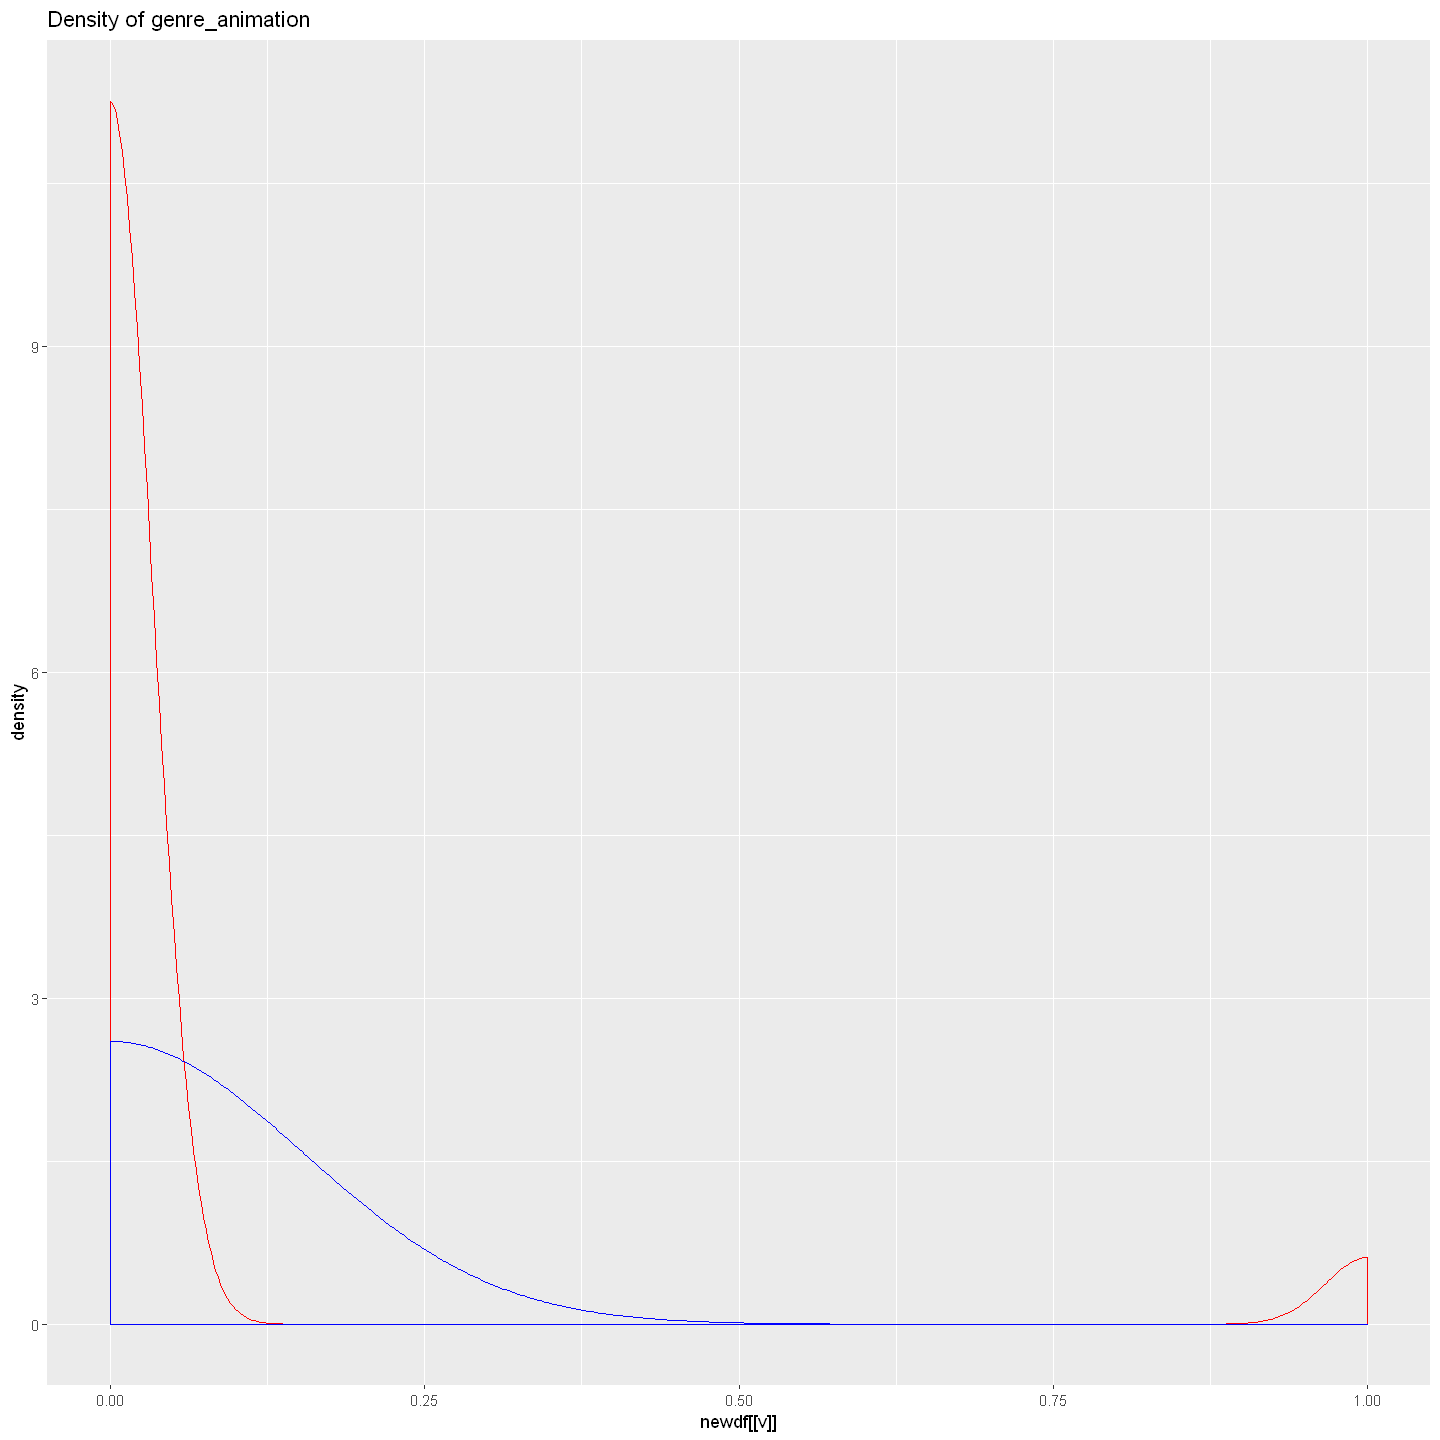

Warning message:
"Removed 735 rows containing non-finite values (stat_density)."


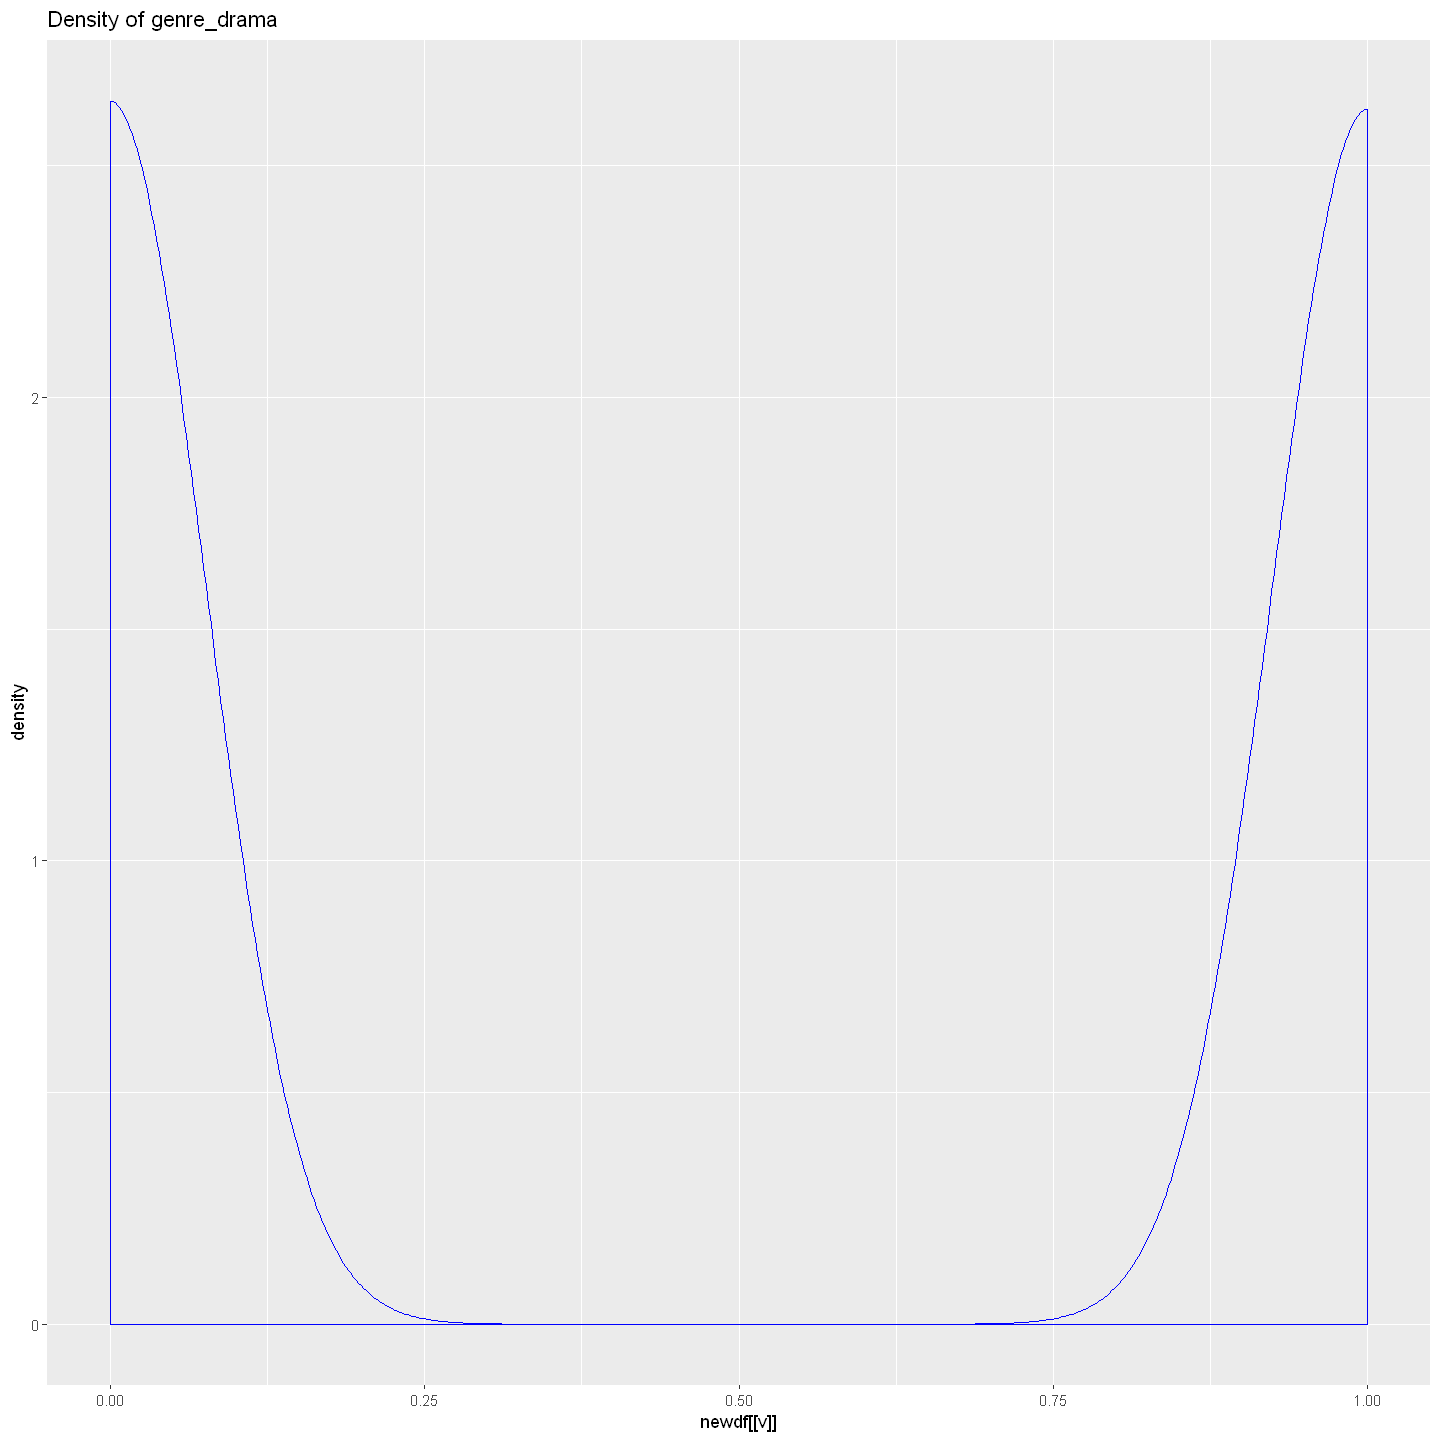

Warning message:
"Removed 1735 rows containing non-finite values (stat_density)."


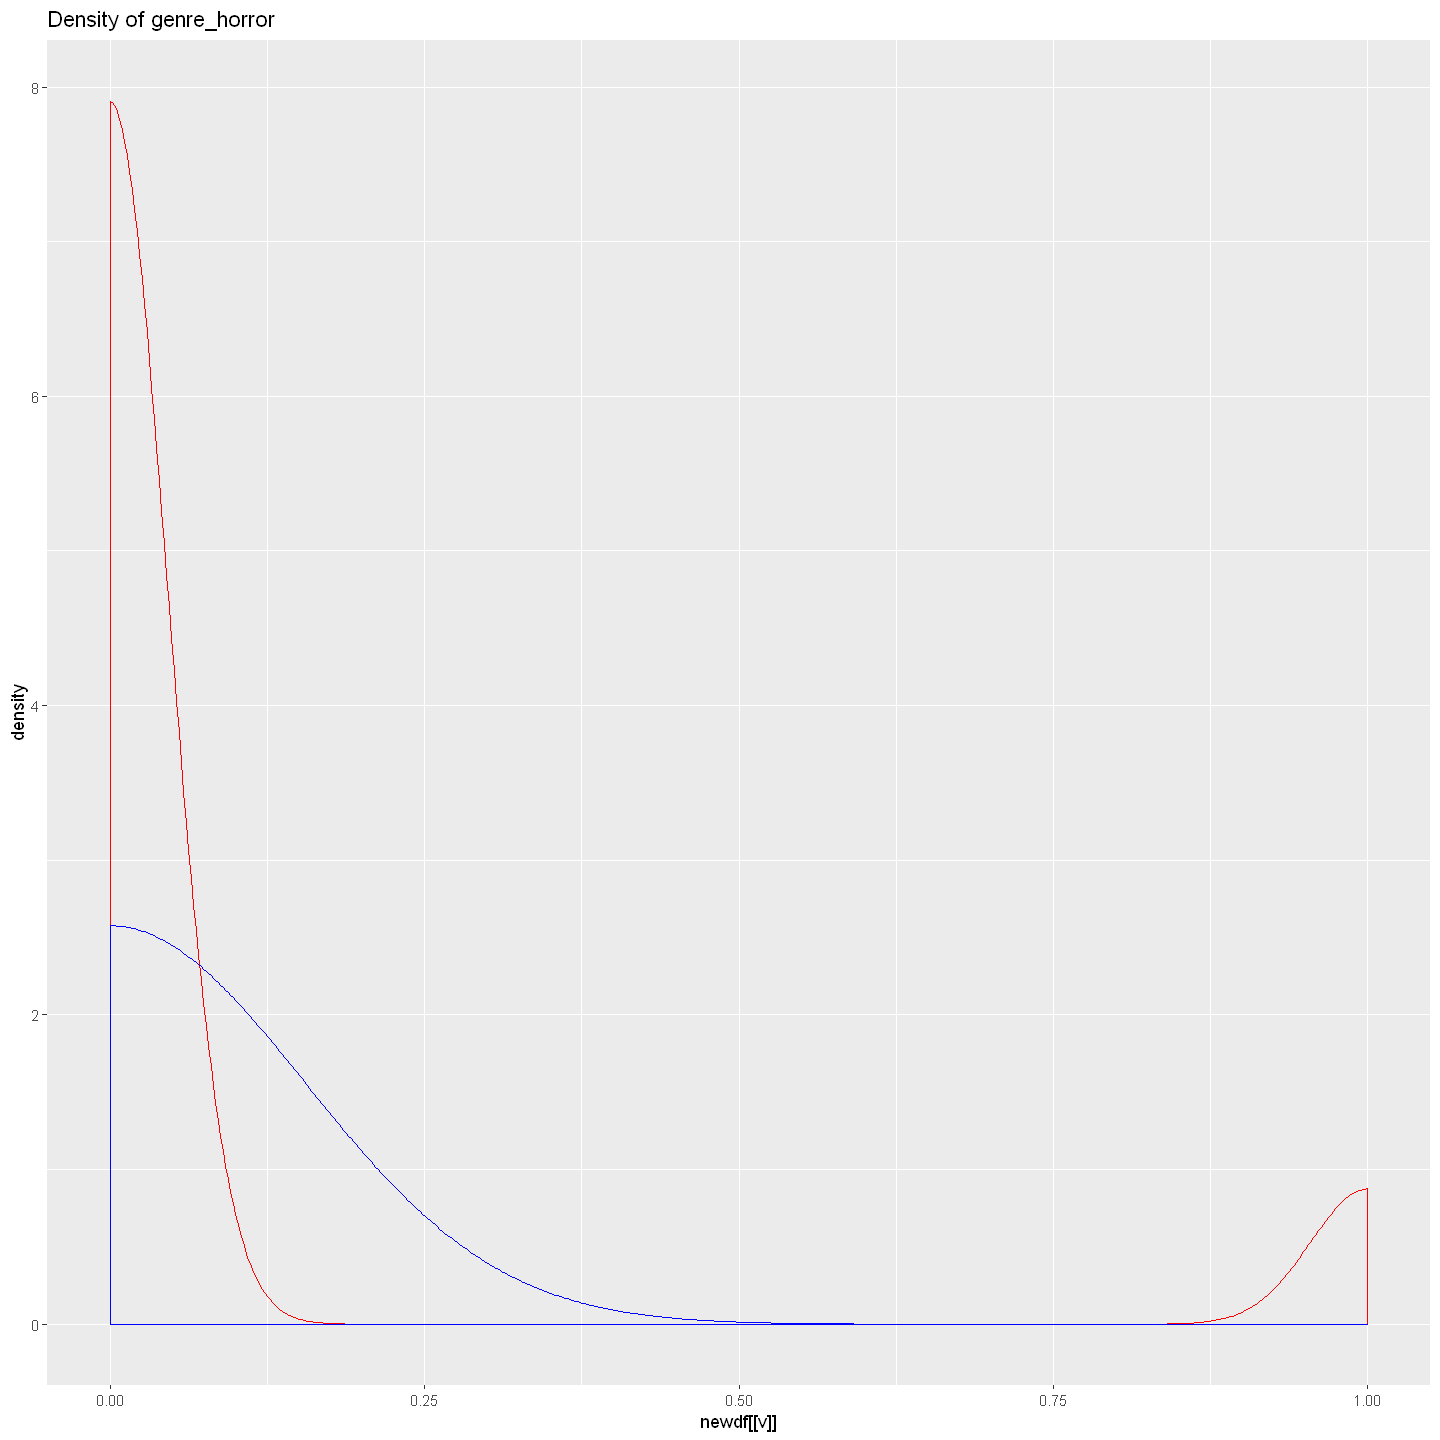

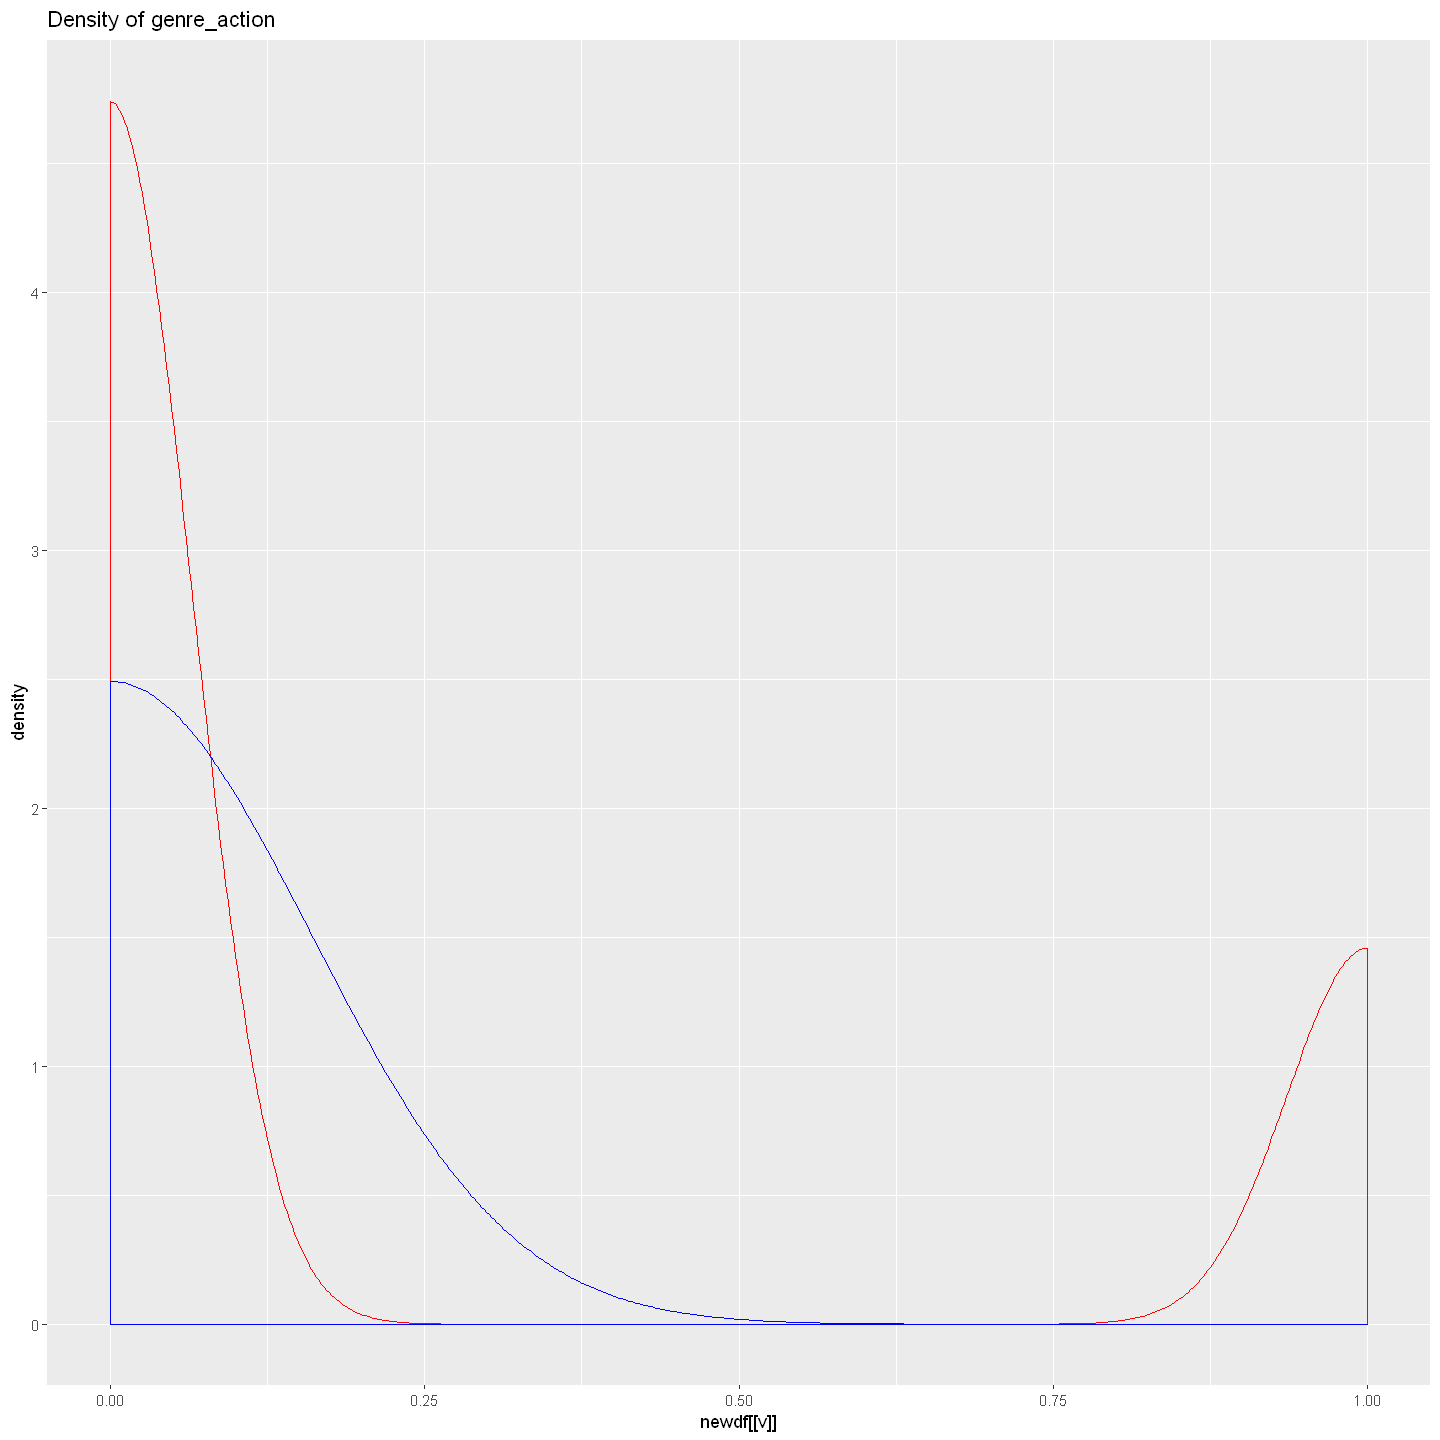

Warning message:
"Removed 295 rows containing non-finite values (stat_density)."


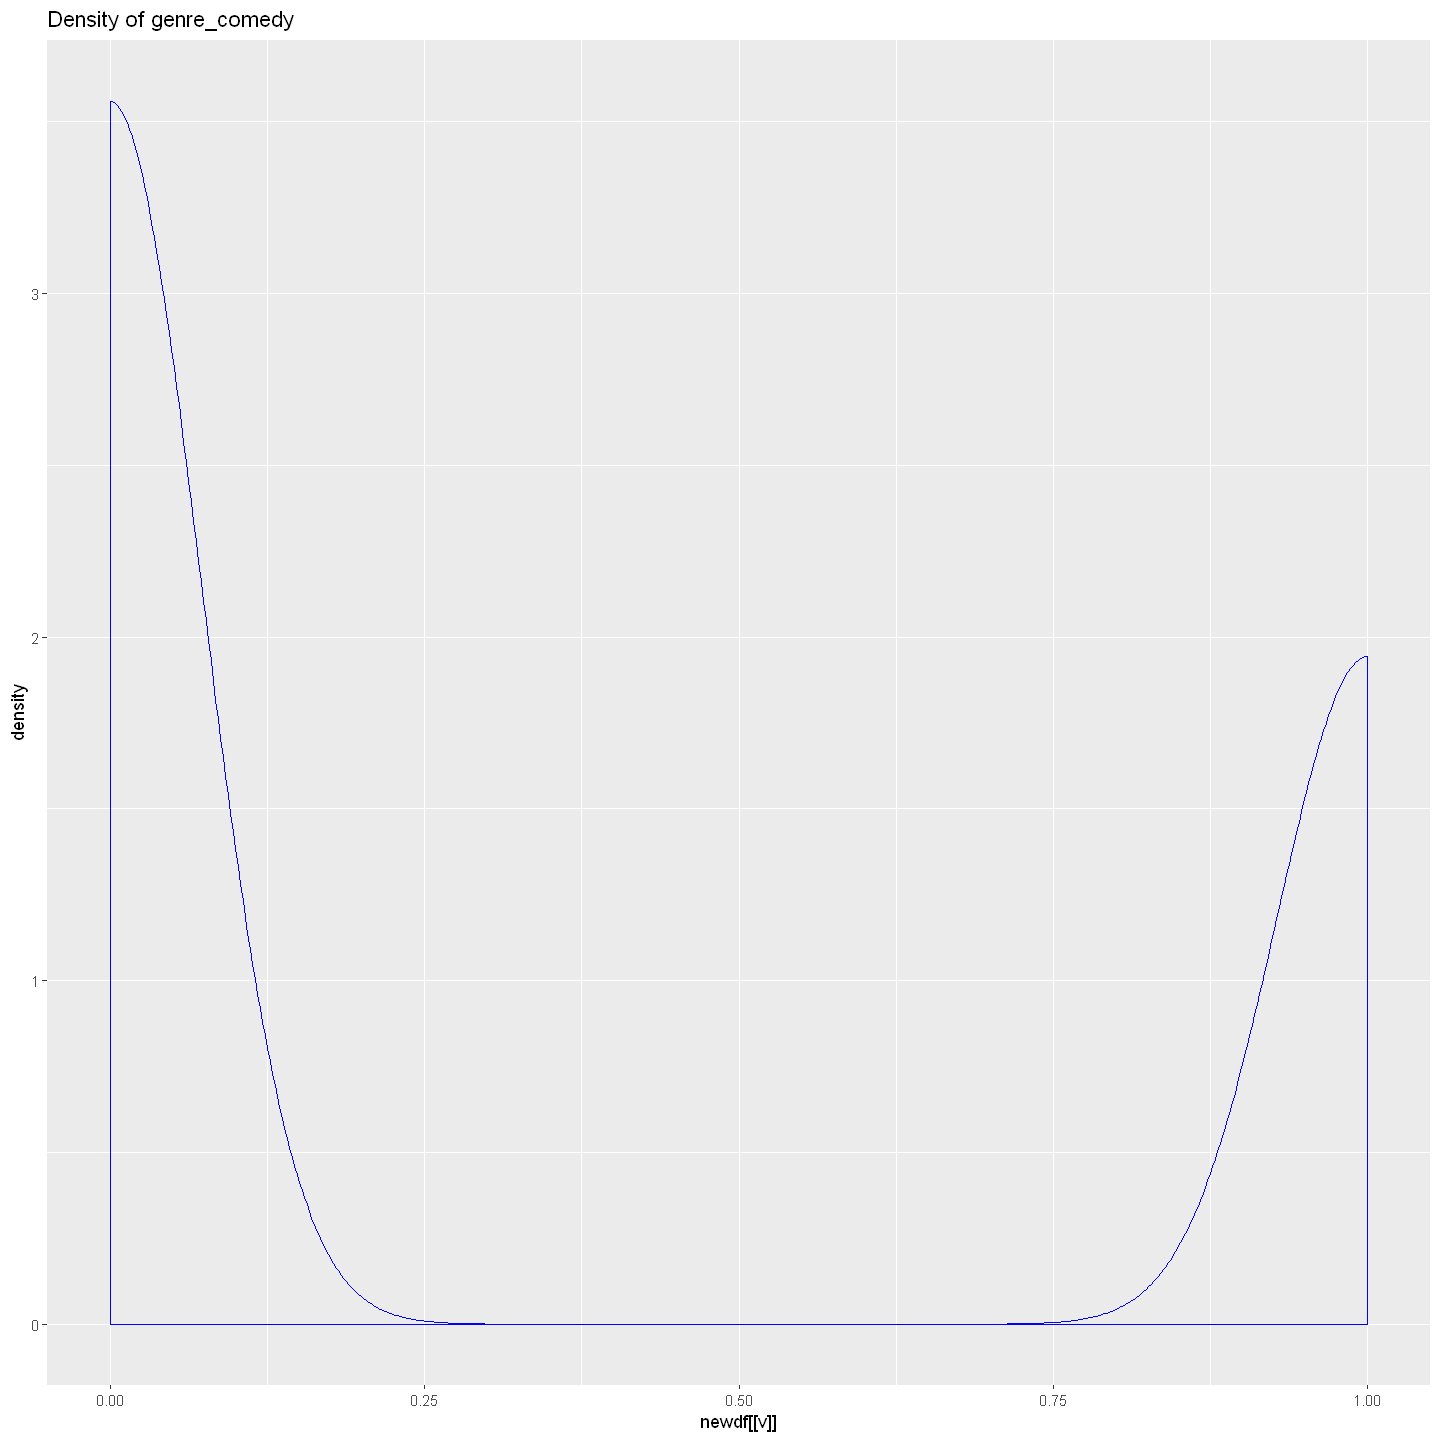

Warning message:
"Removed 117 rows containing non-finite values (stat_density)."


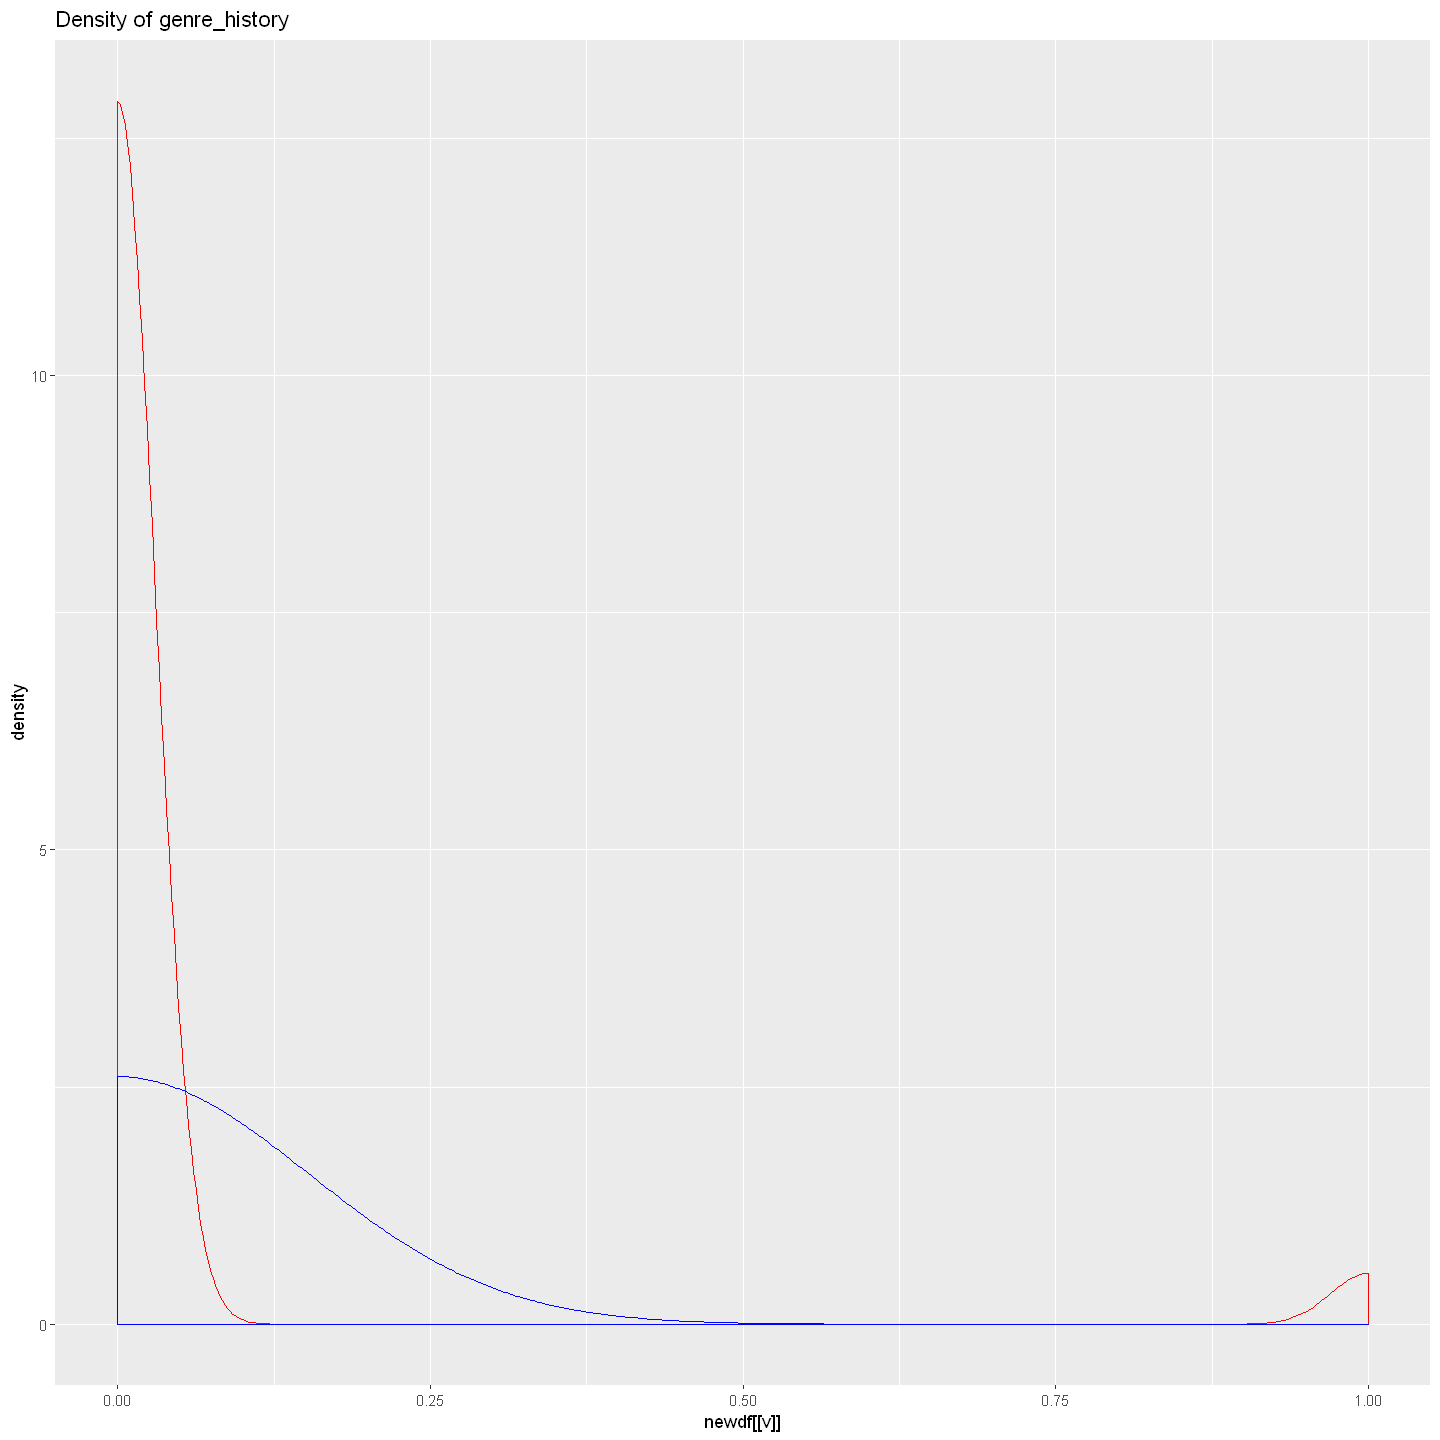

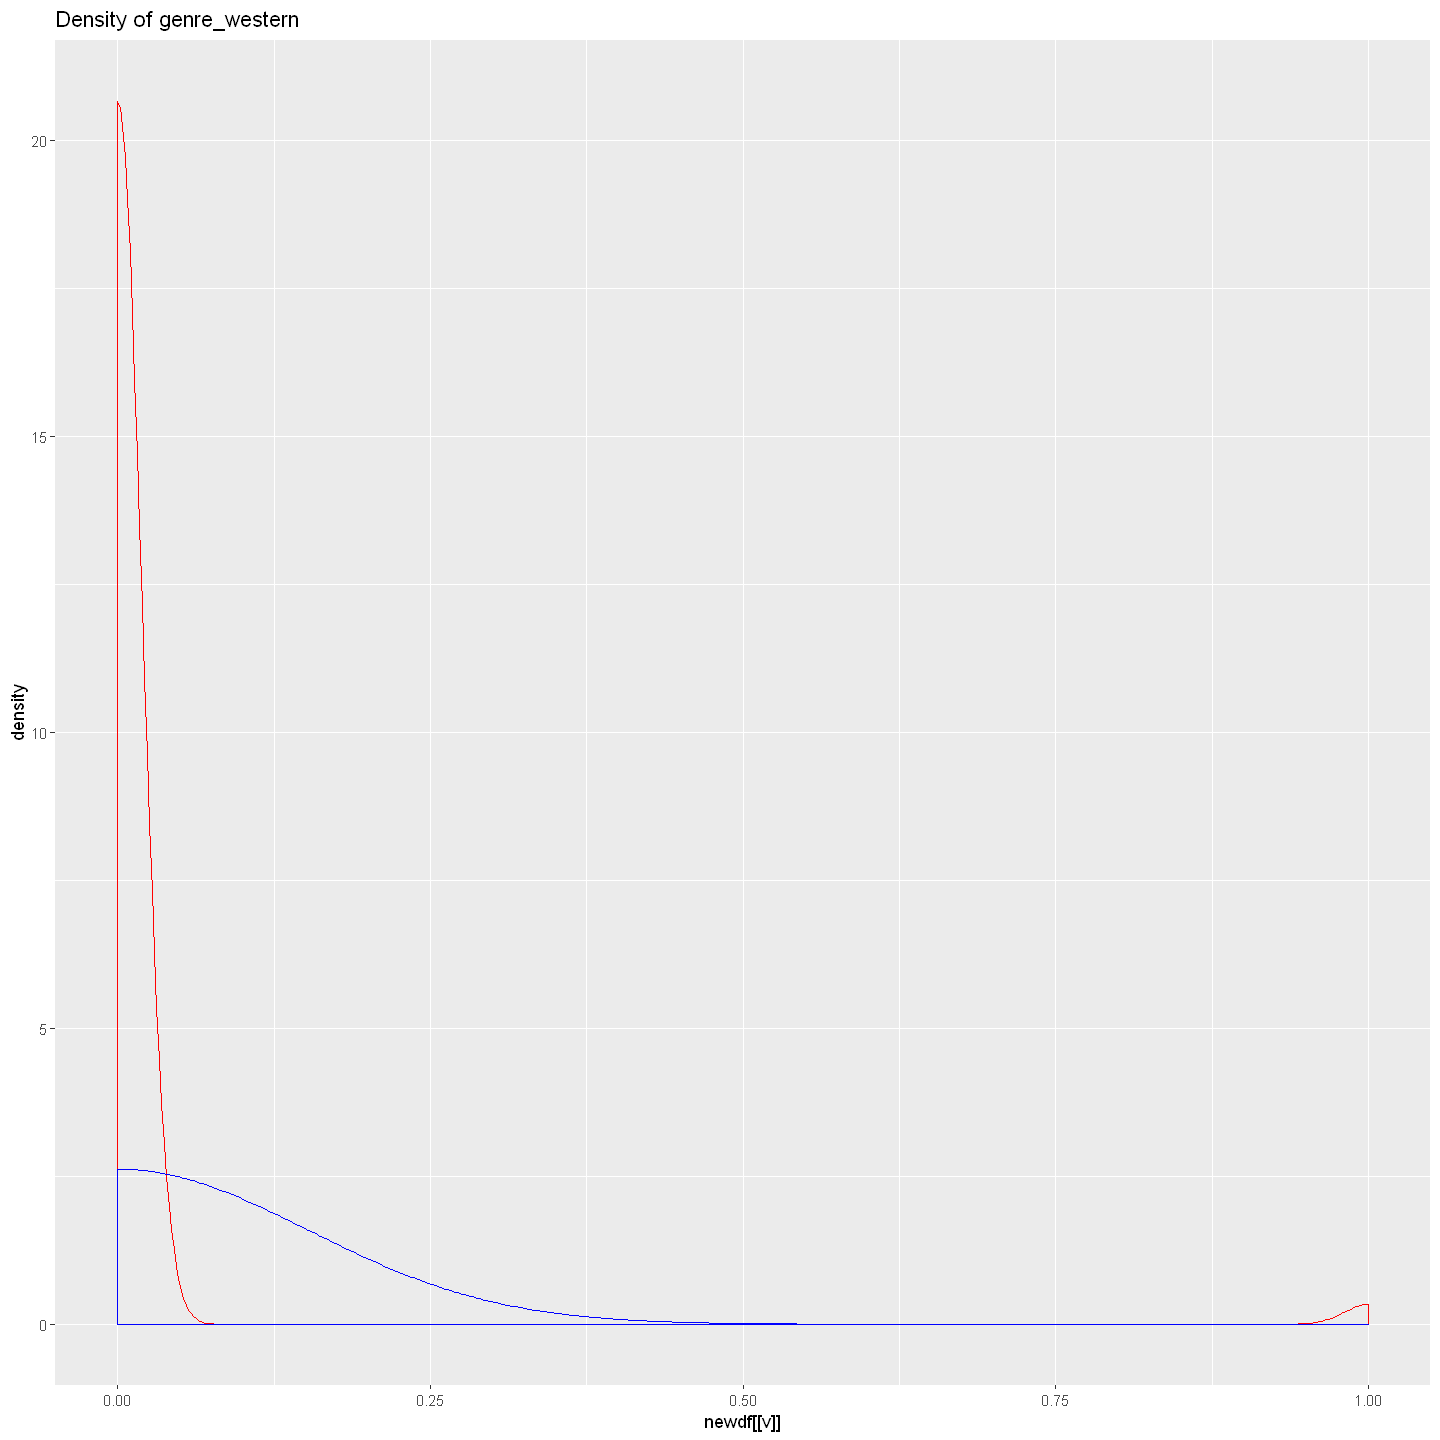

Warning message:
"Removed 1084 rows containing non-finite values (stat_density)."


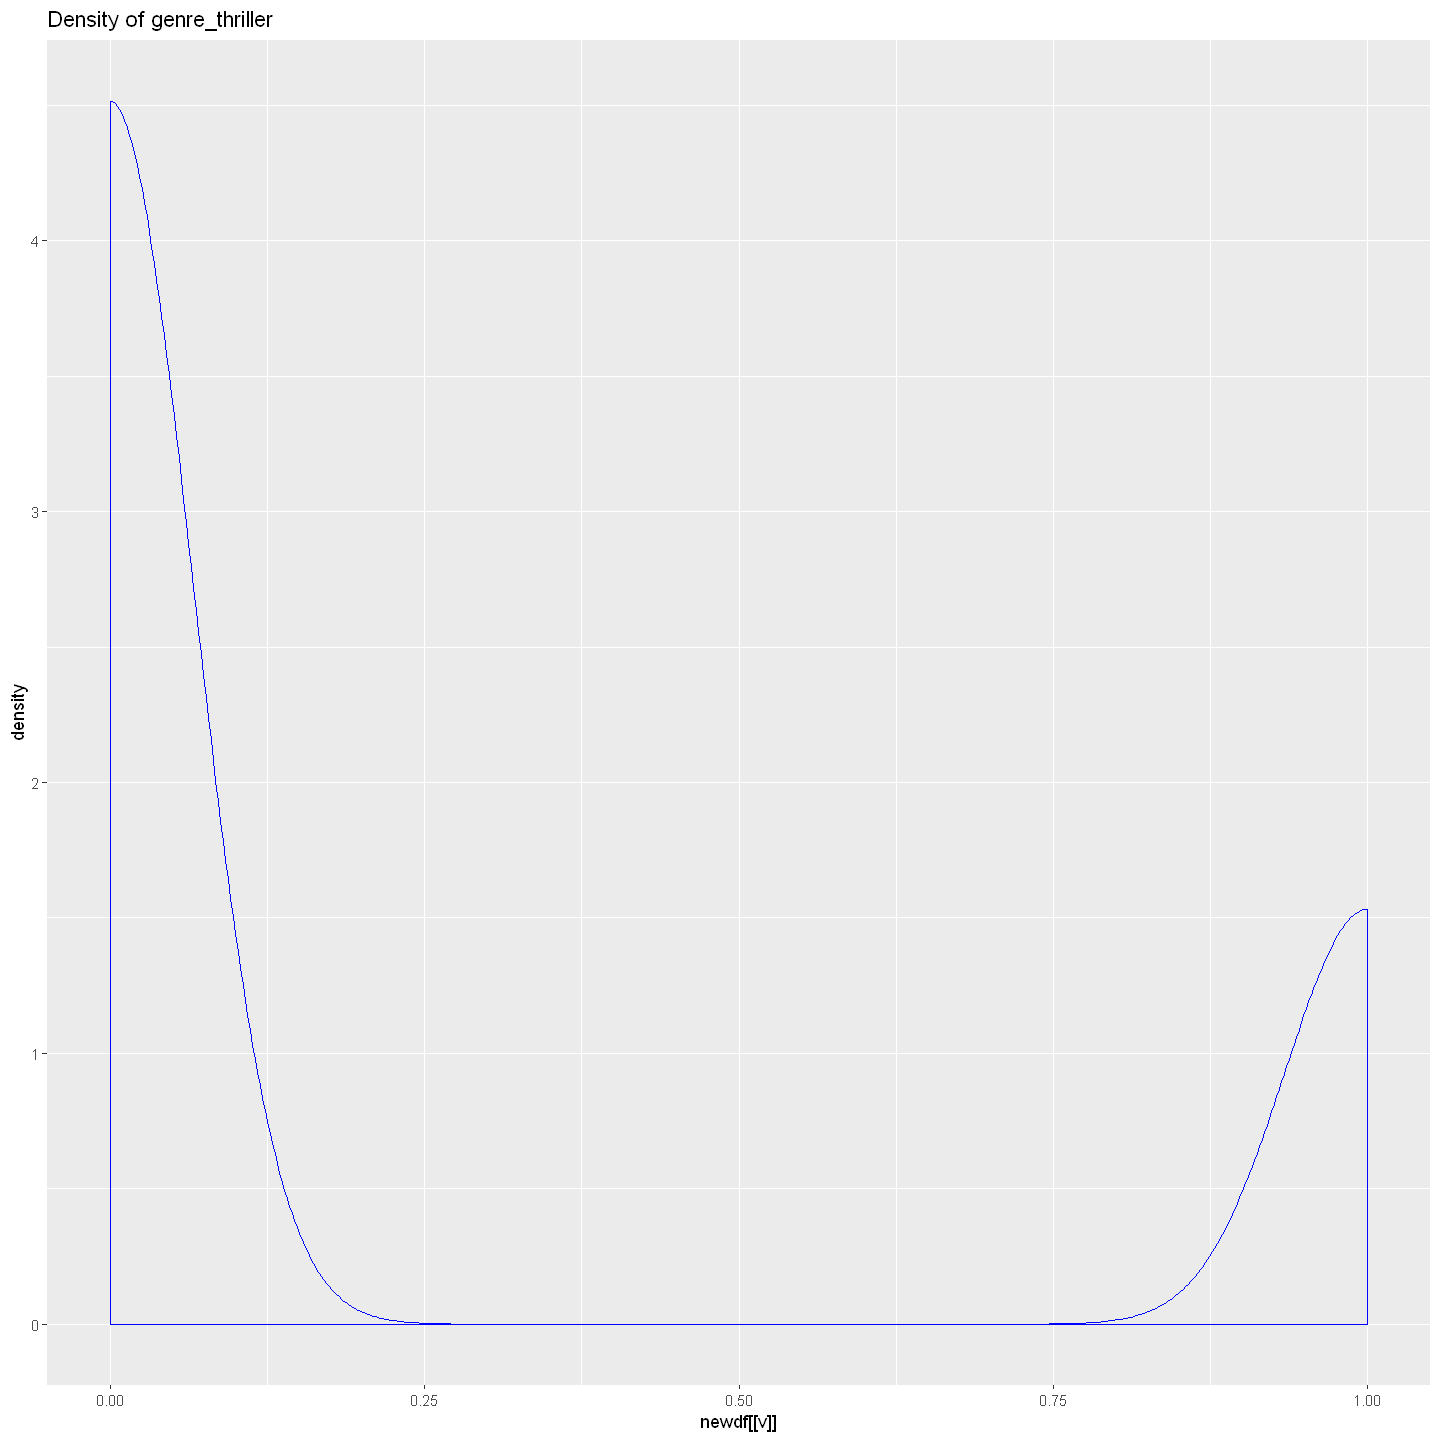

Warning message:
"Removed 221 rows containing non-finite values (stat_density)."


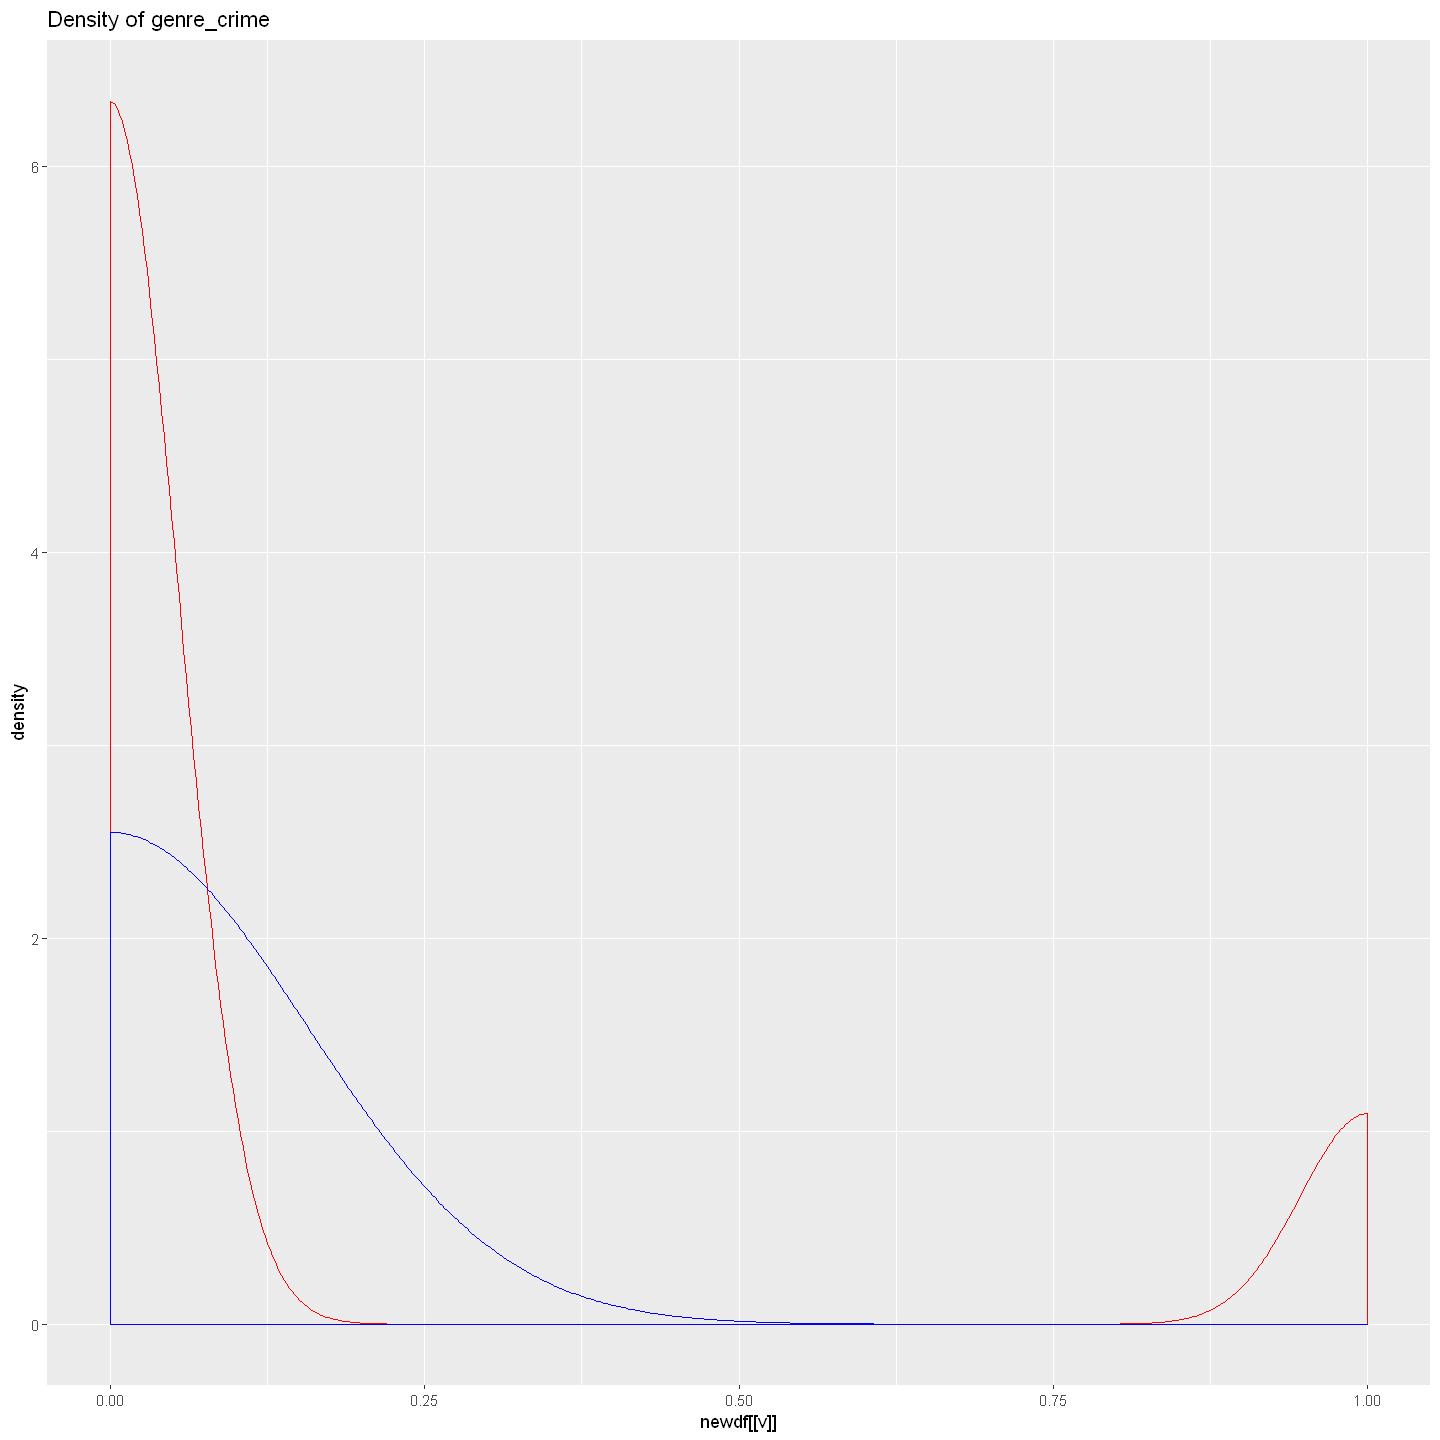

Warning message:
"Removed 744 rows containing non-finite values (stat_density)."


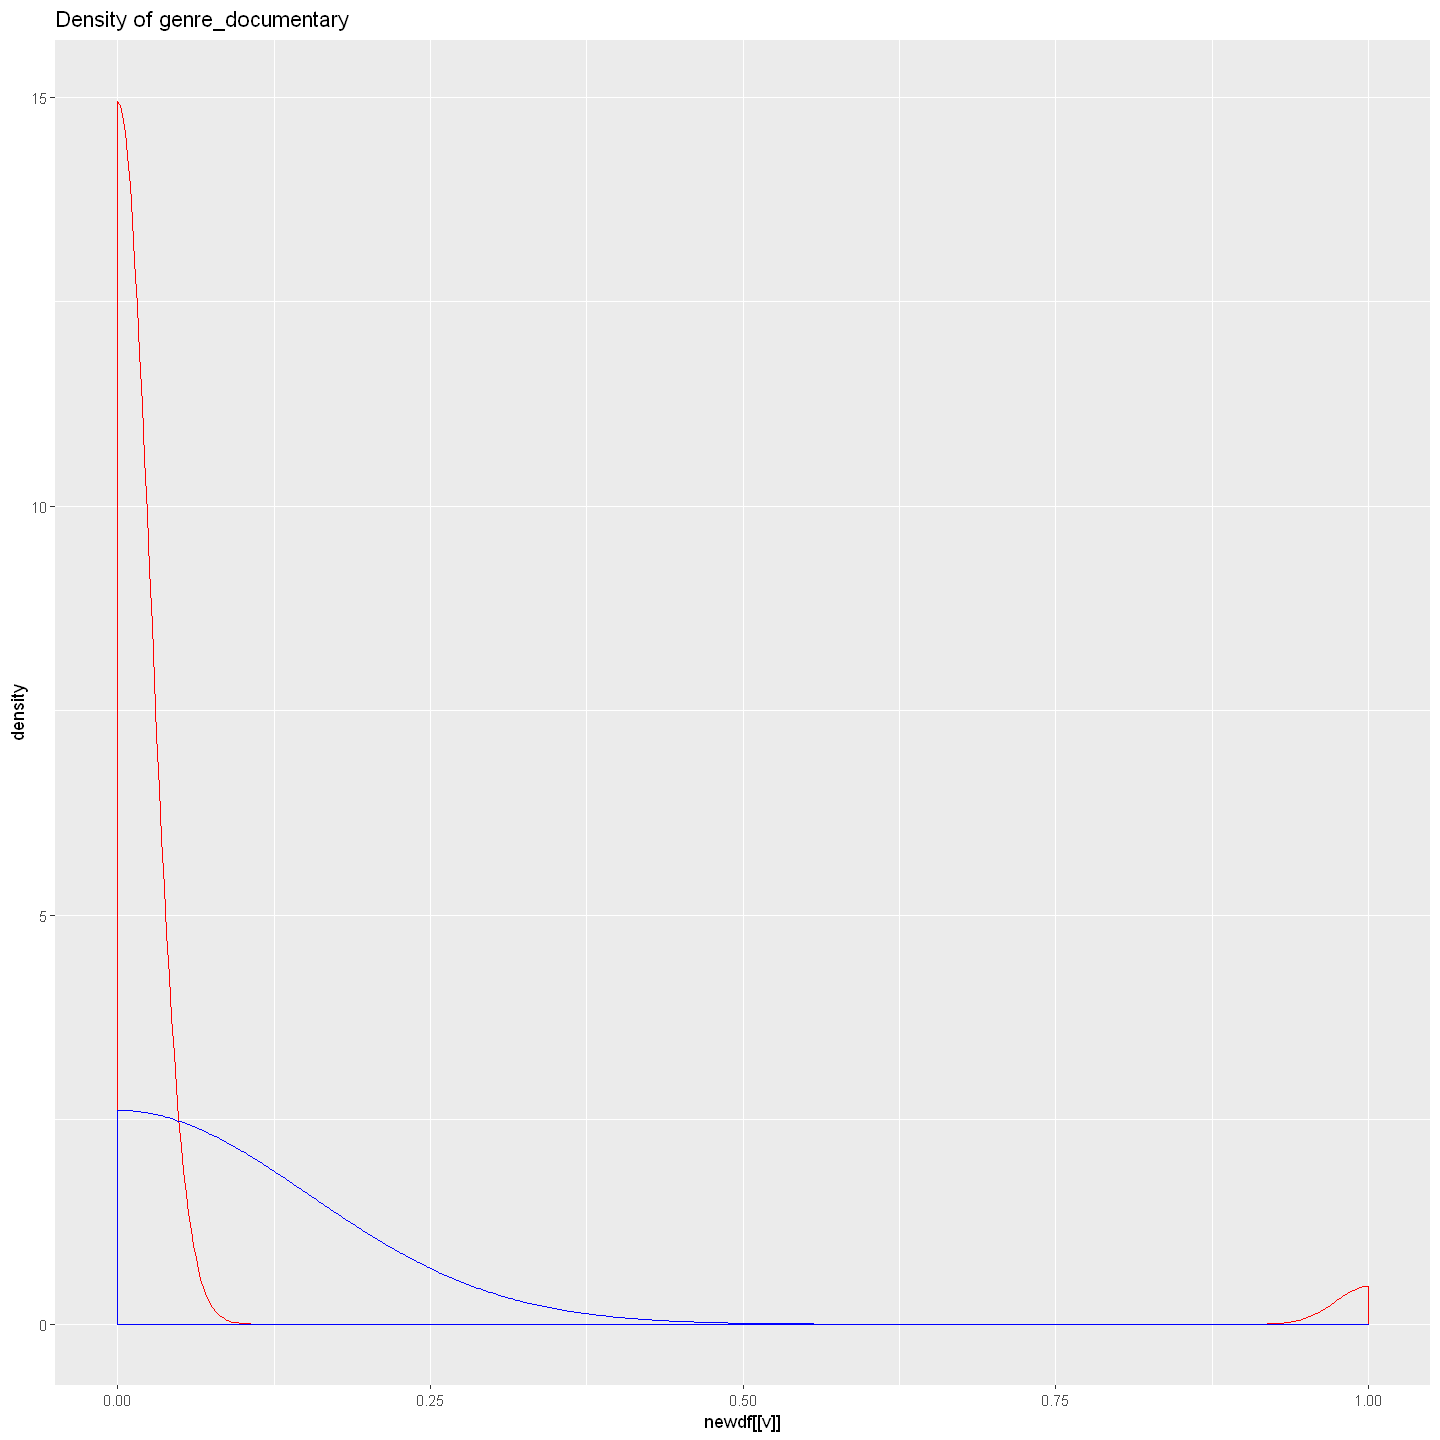

Warning message:
"Removed 550 rows containing non-finite values (stat_density)."


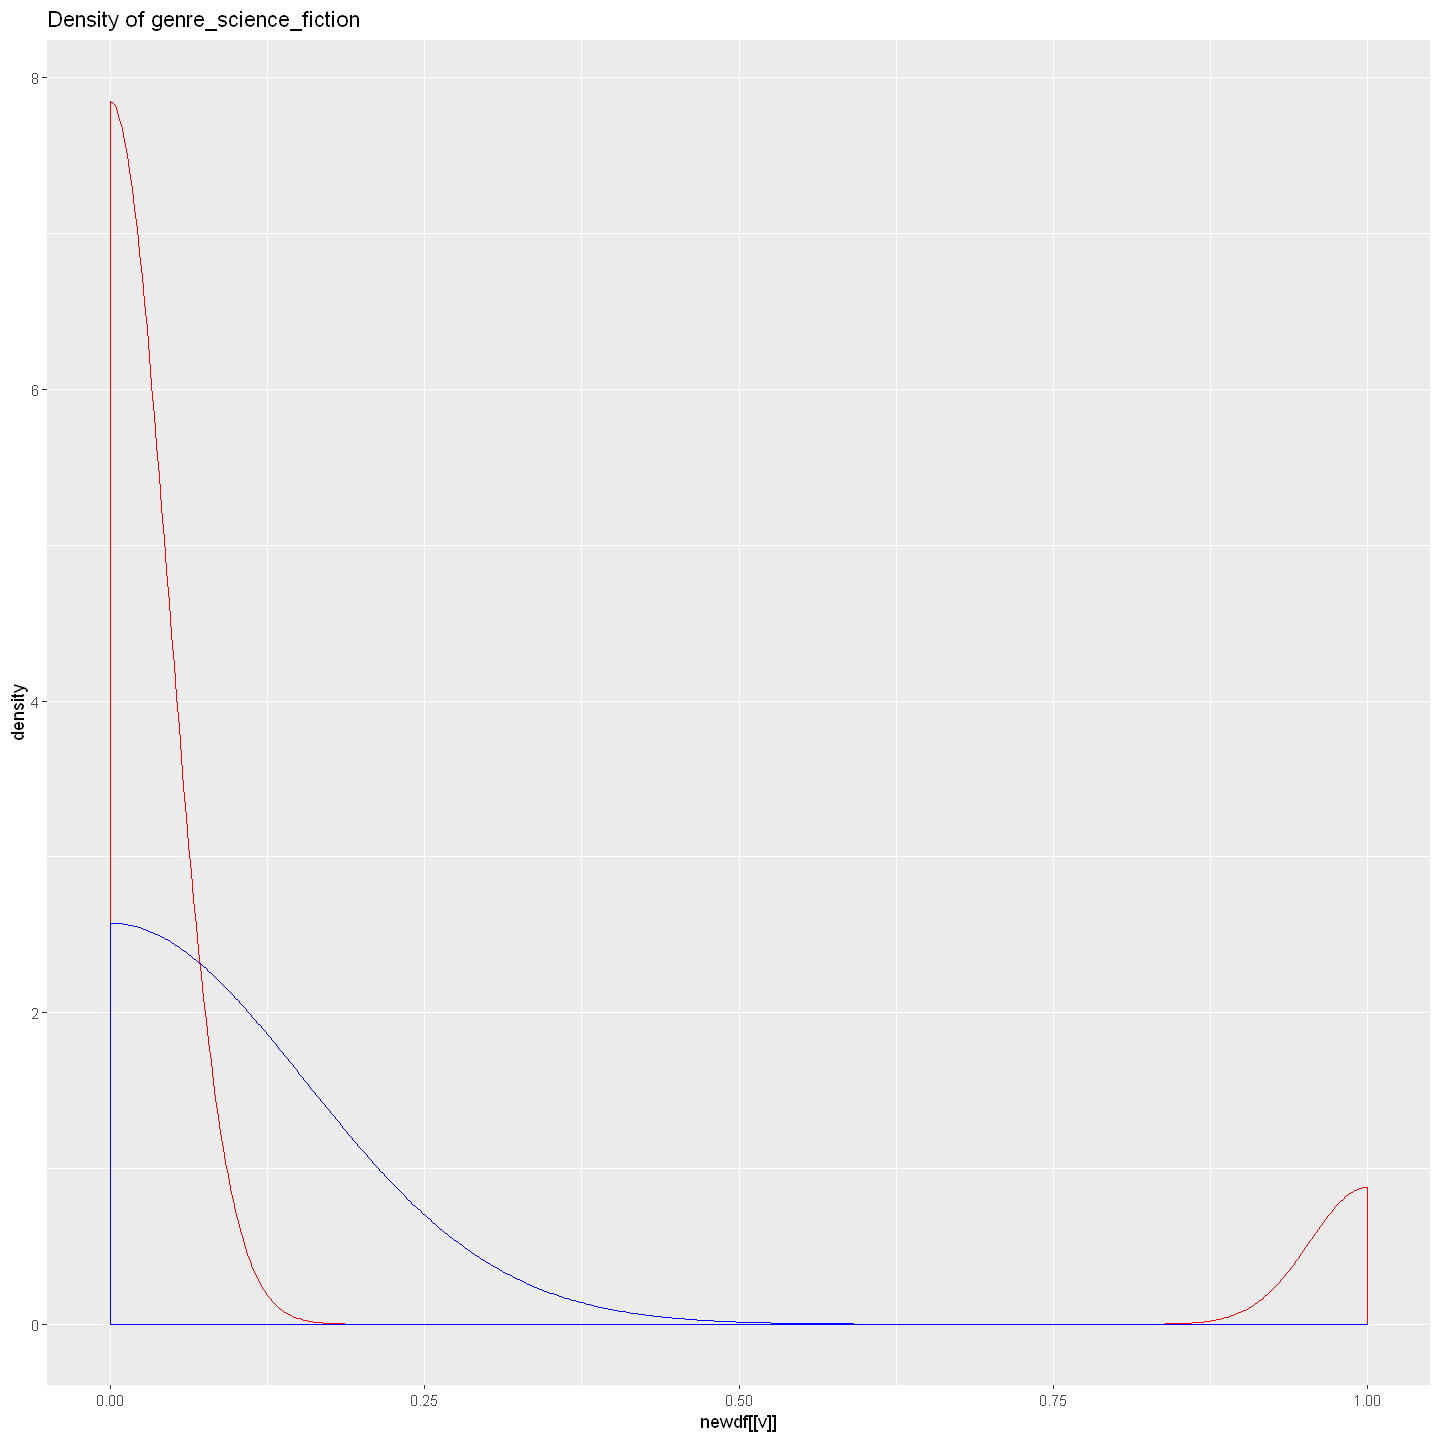

Warning message:
"Removed 267 rows containing non-finite values (stat_density)."


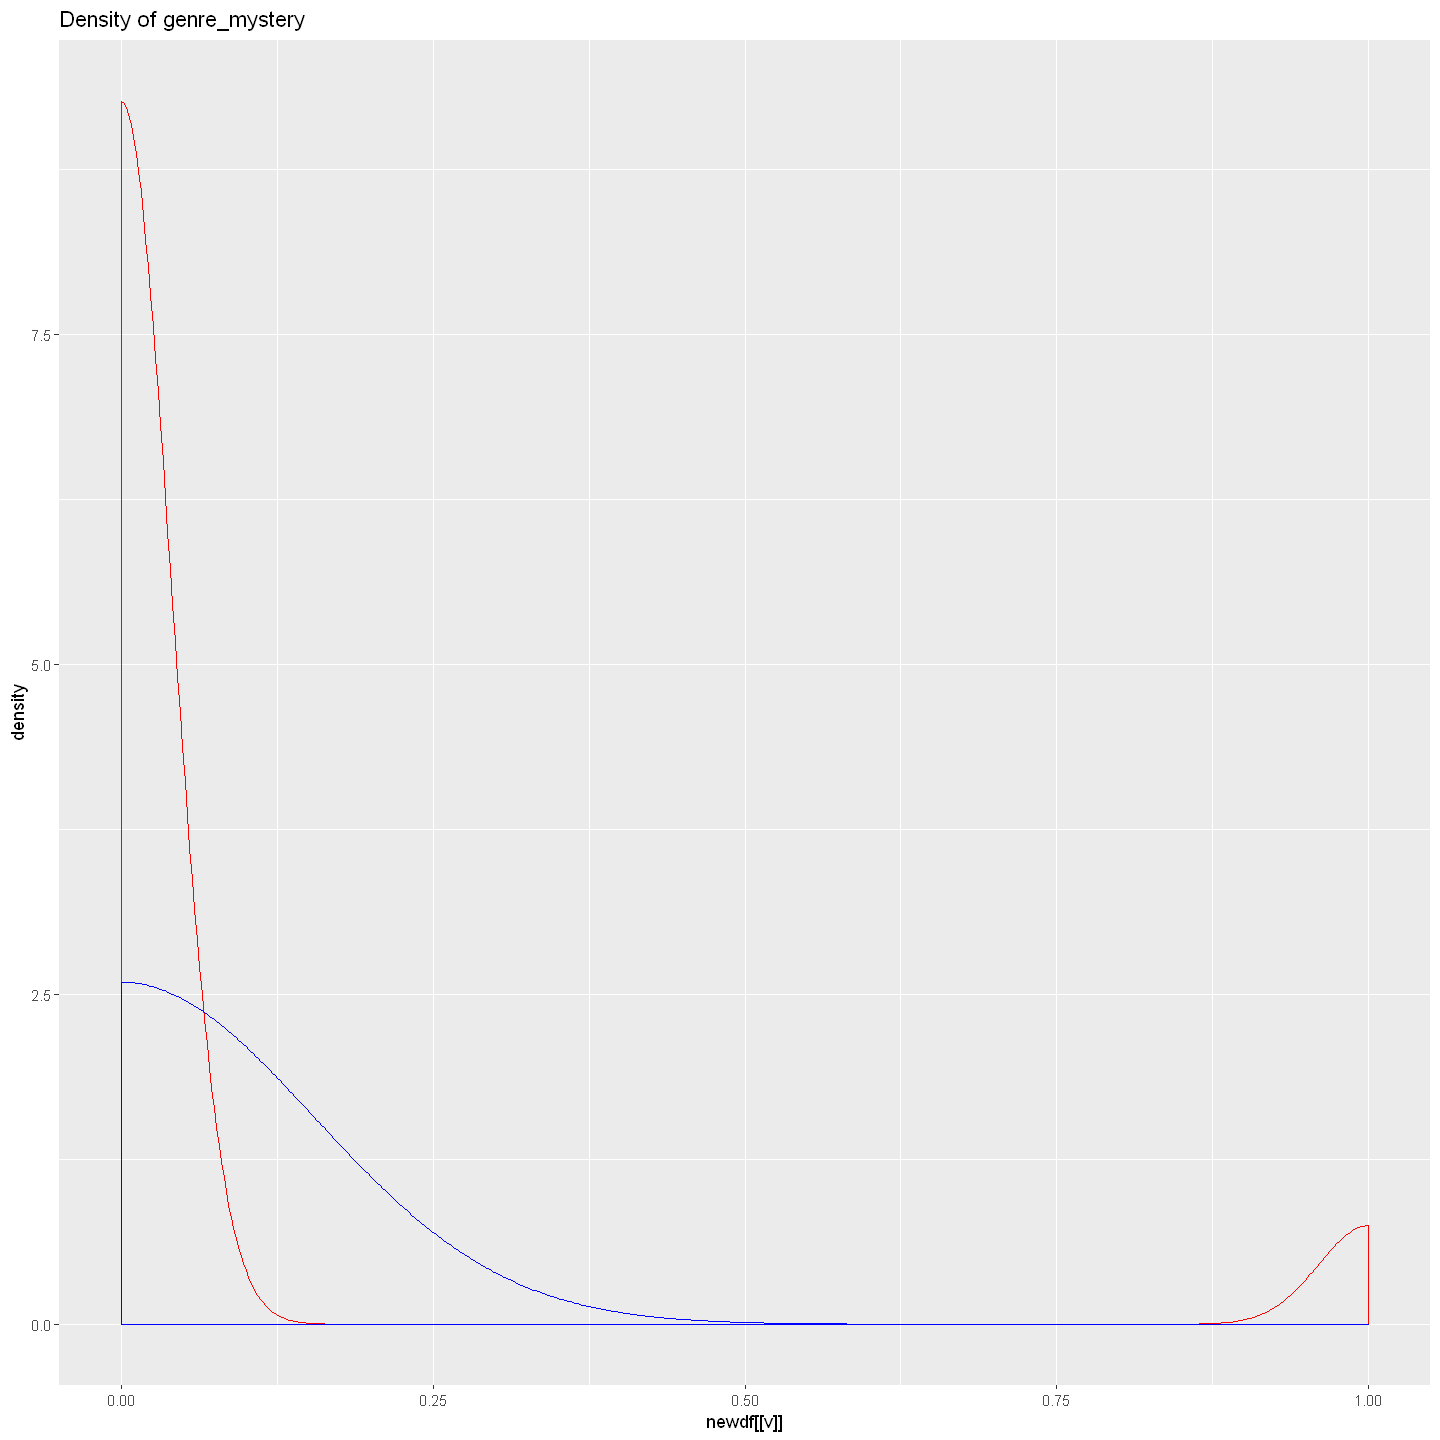

Warning message:
"Removed 1435 rows containing non-finite values (stat_density)."


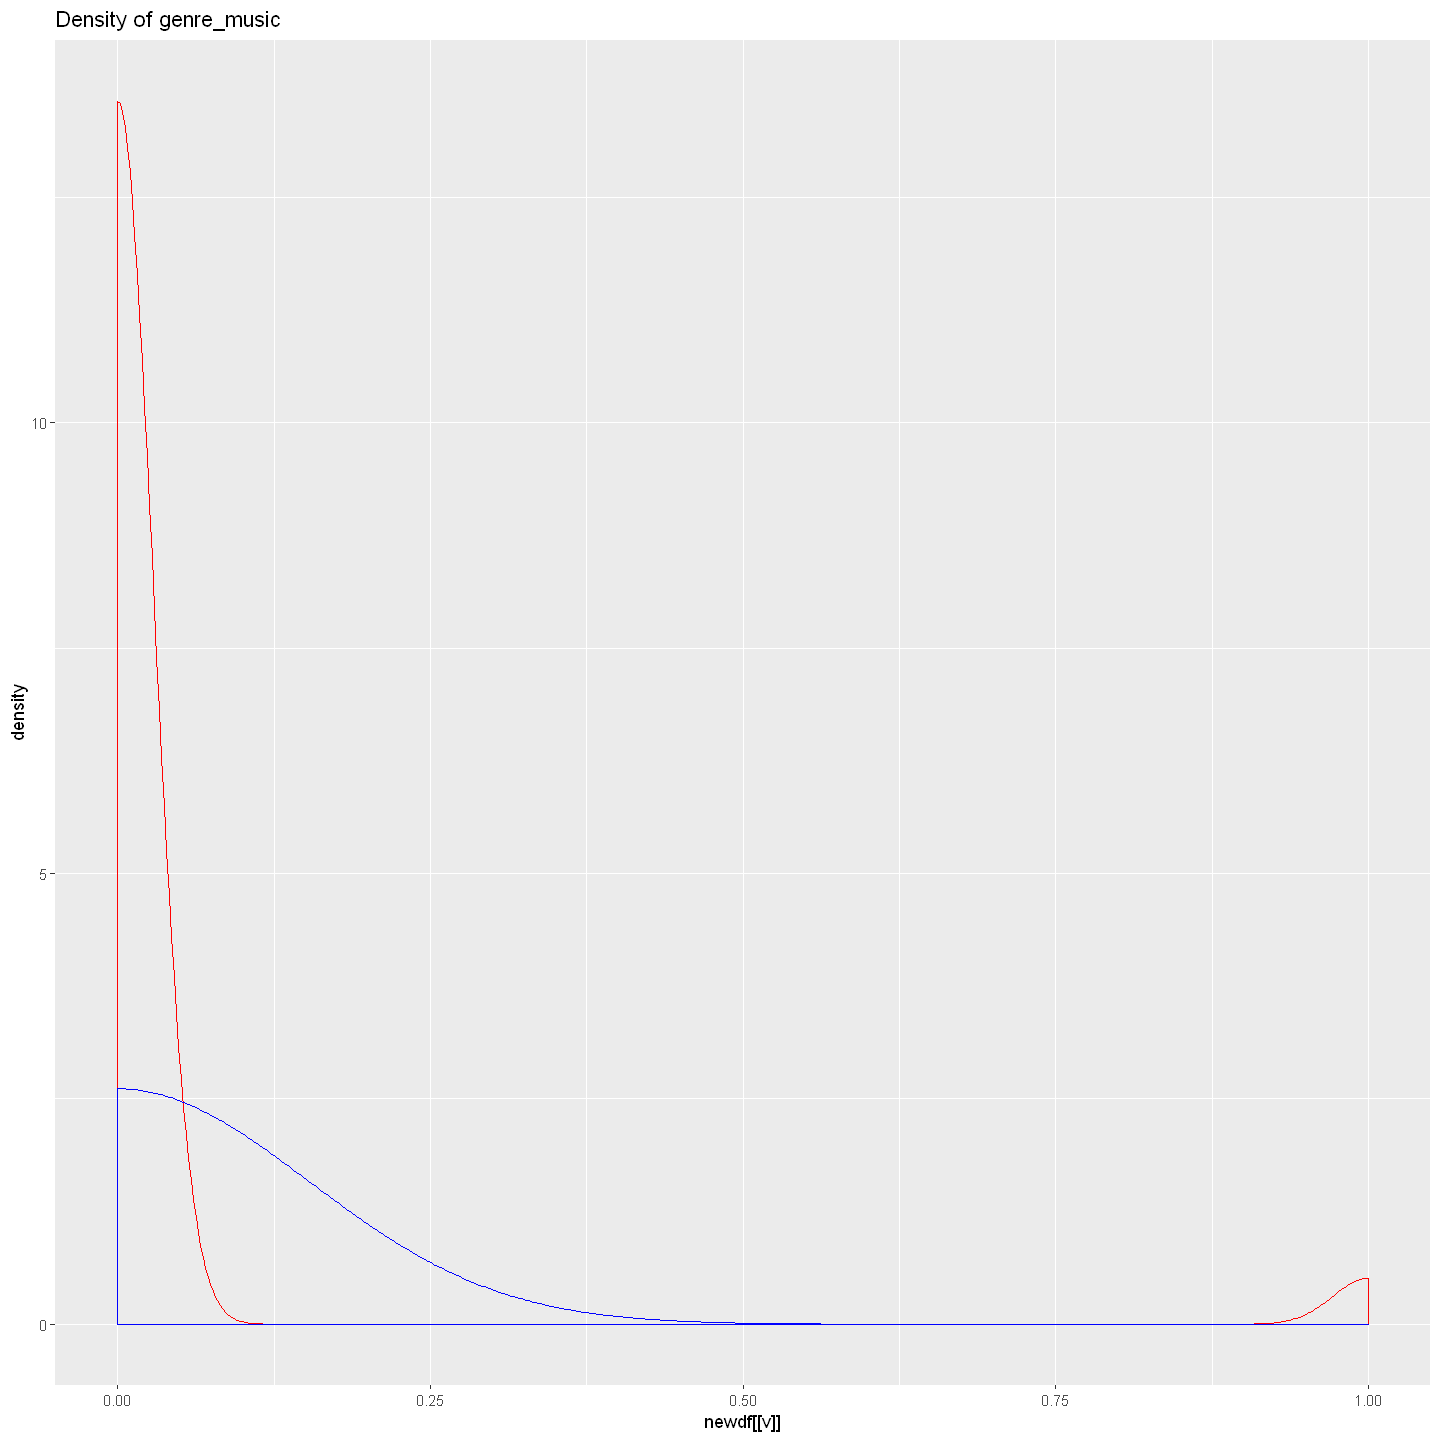

Warning message:
"Removed 675 rows containing non-finite values (stat_density)."


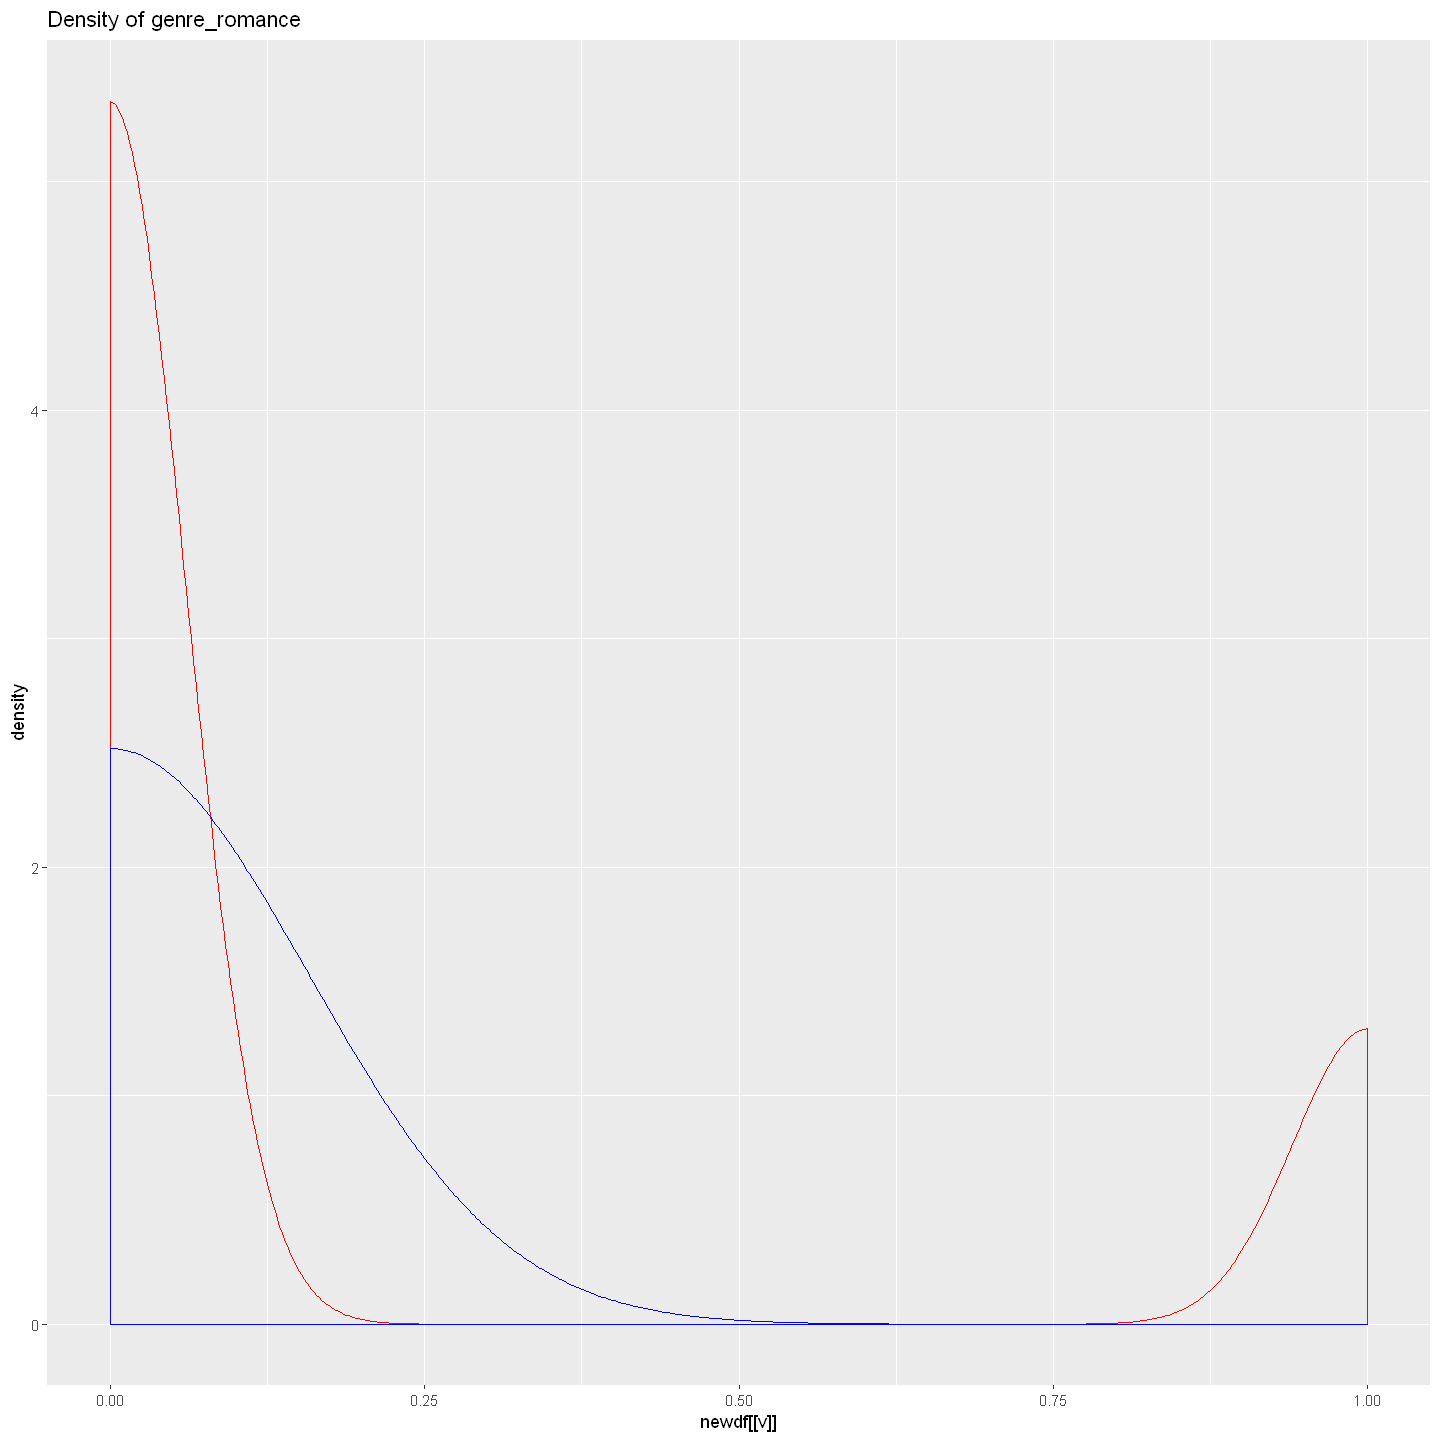

Warning message:
"Removed 243 rows containing non-finite values (stat_density)."


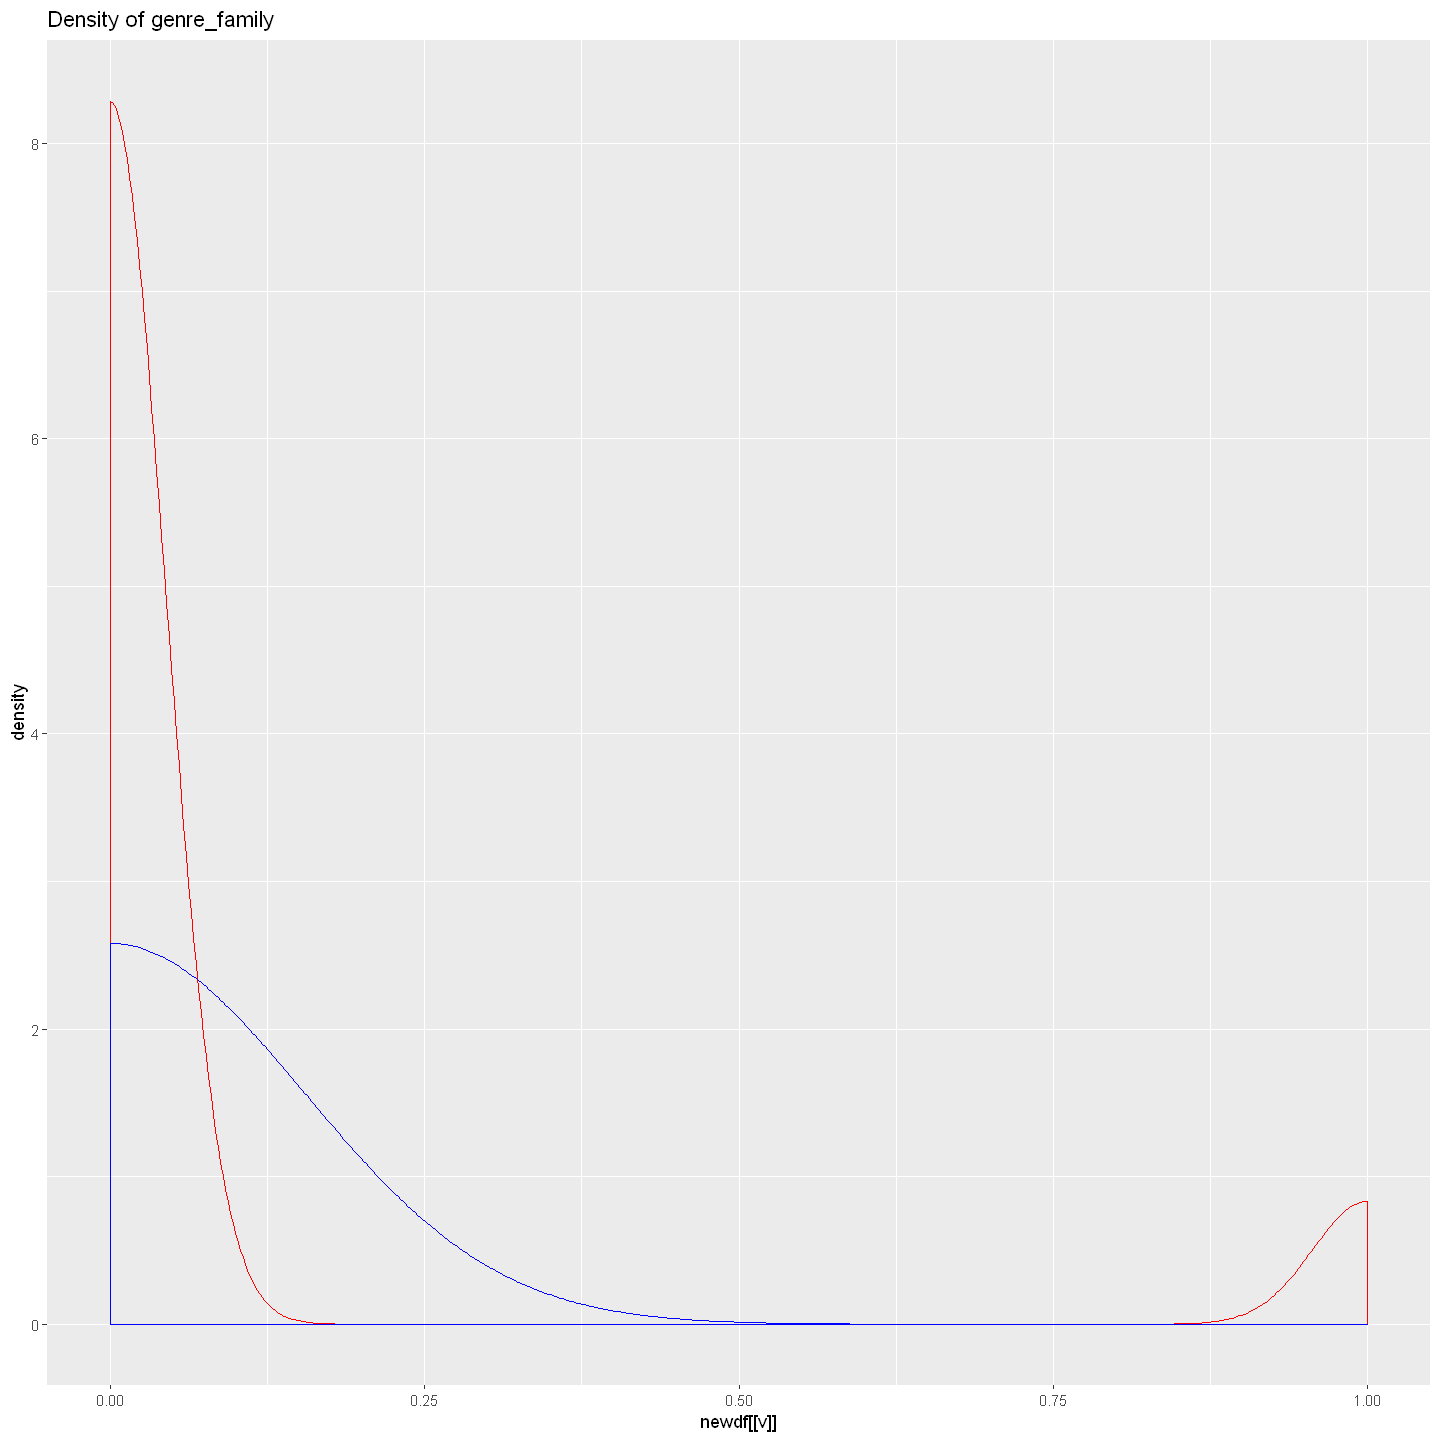

Warning message:
"Removed 84 rows containing non-finite values (stat_density)."


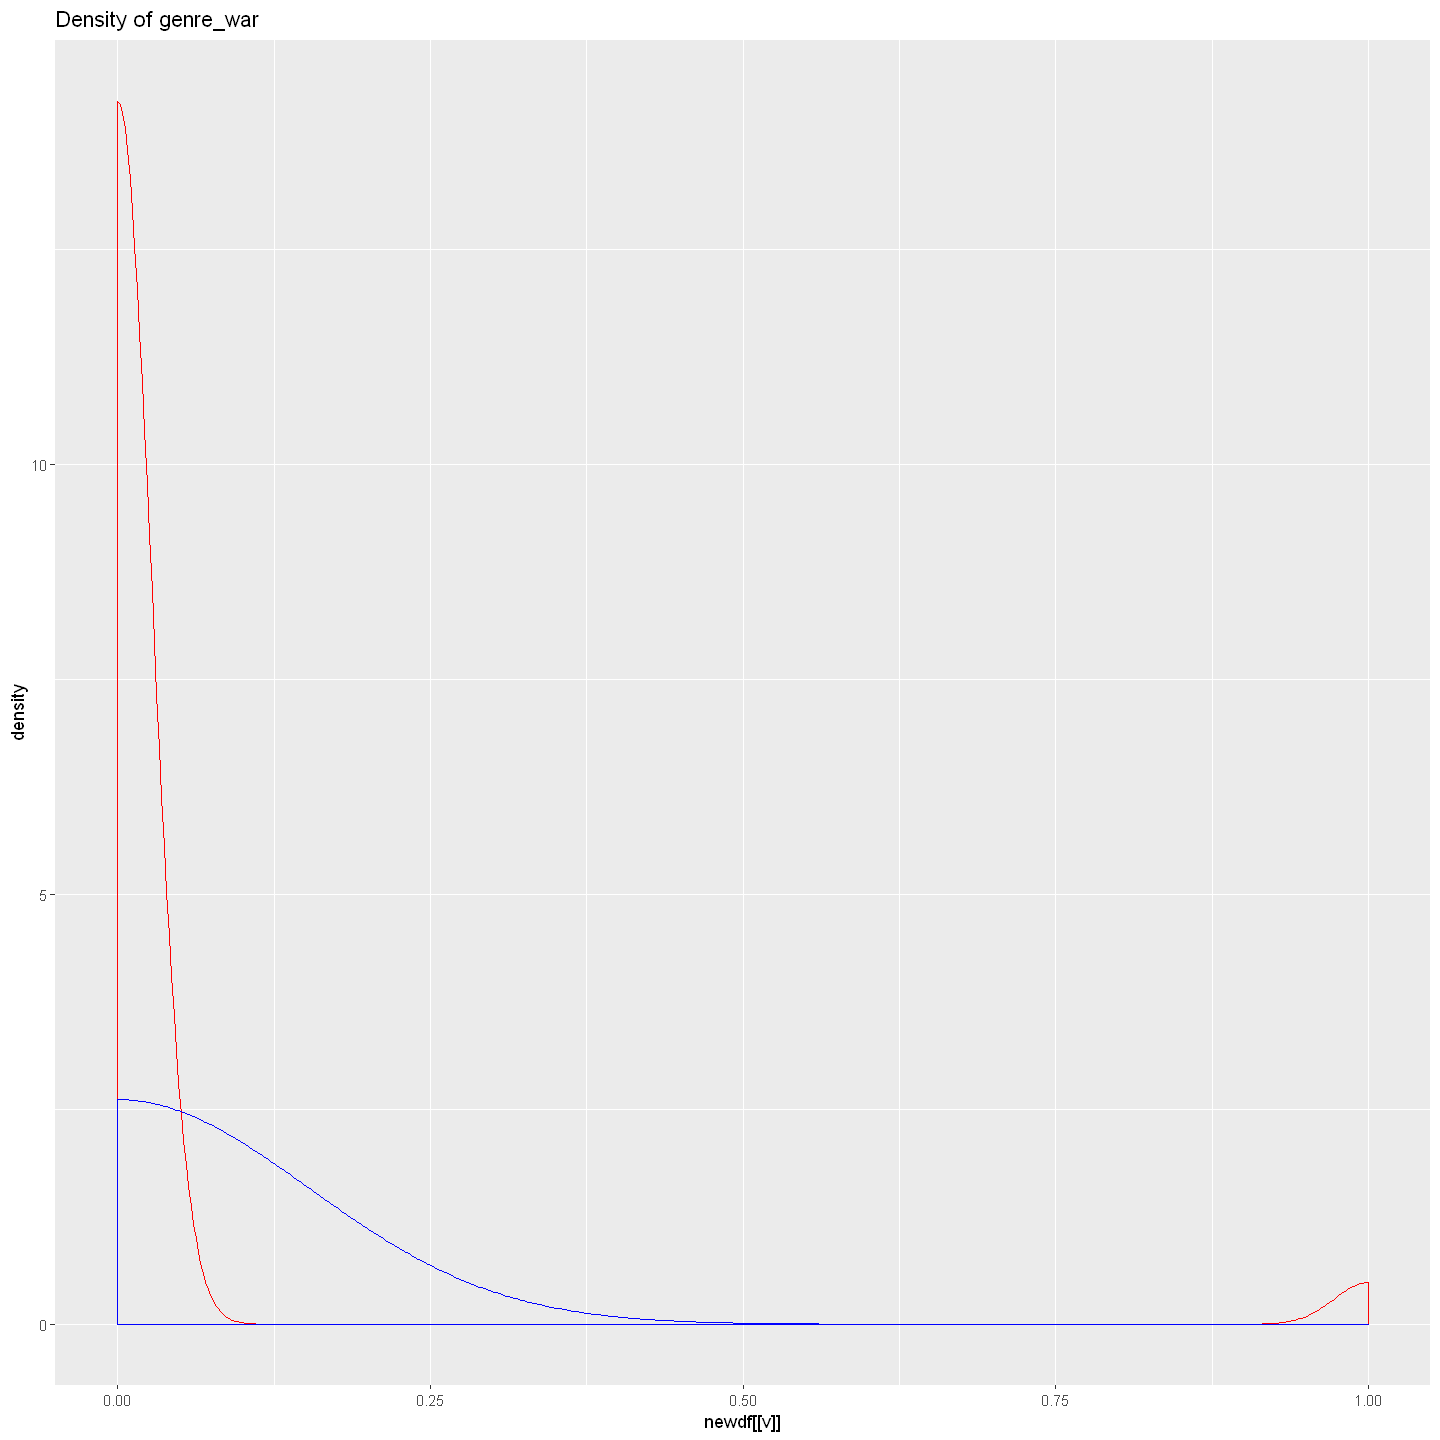

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


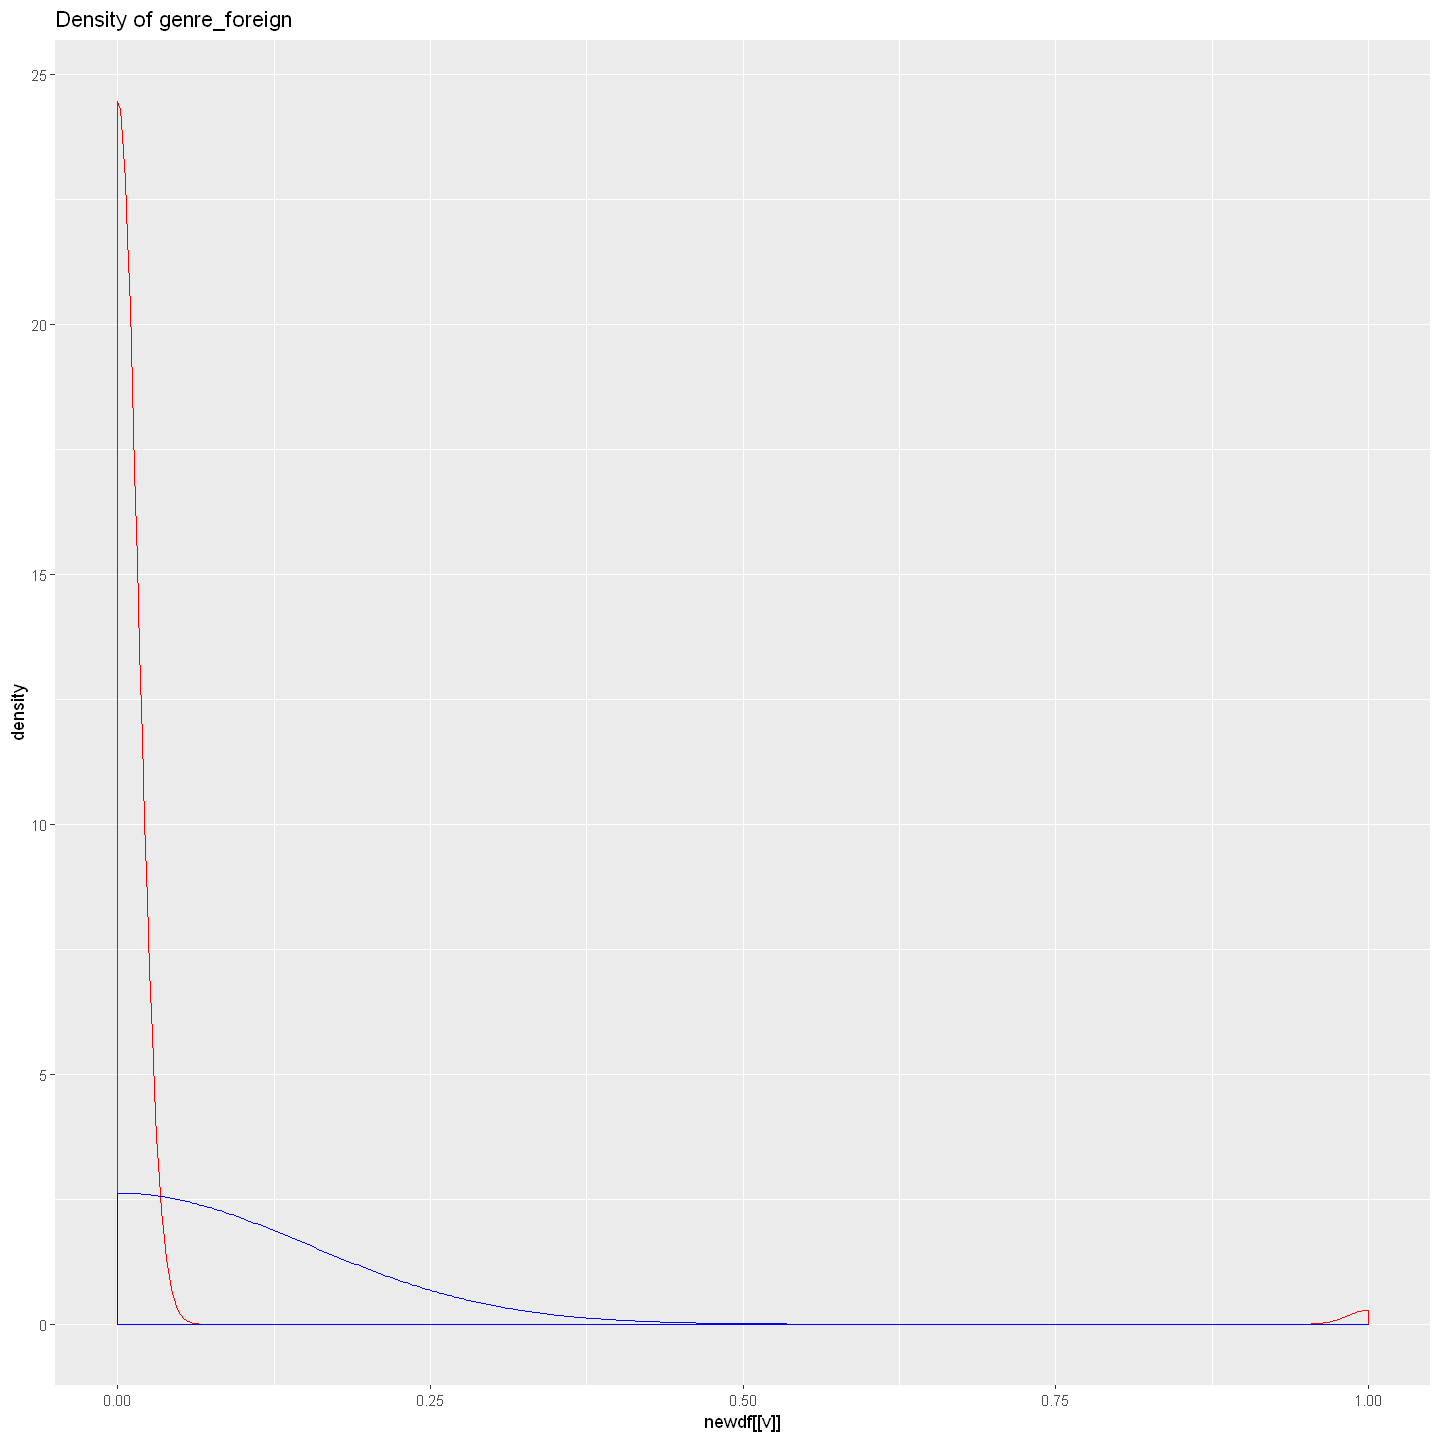

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


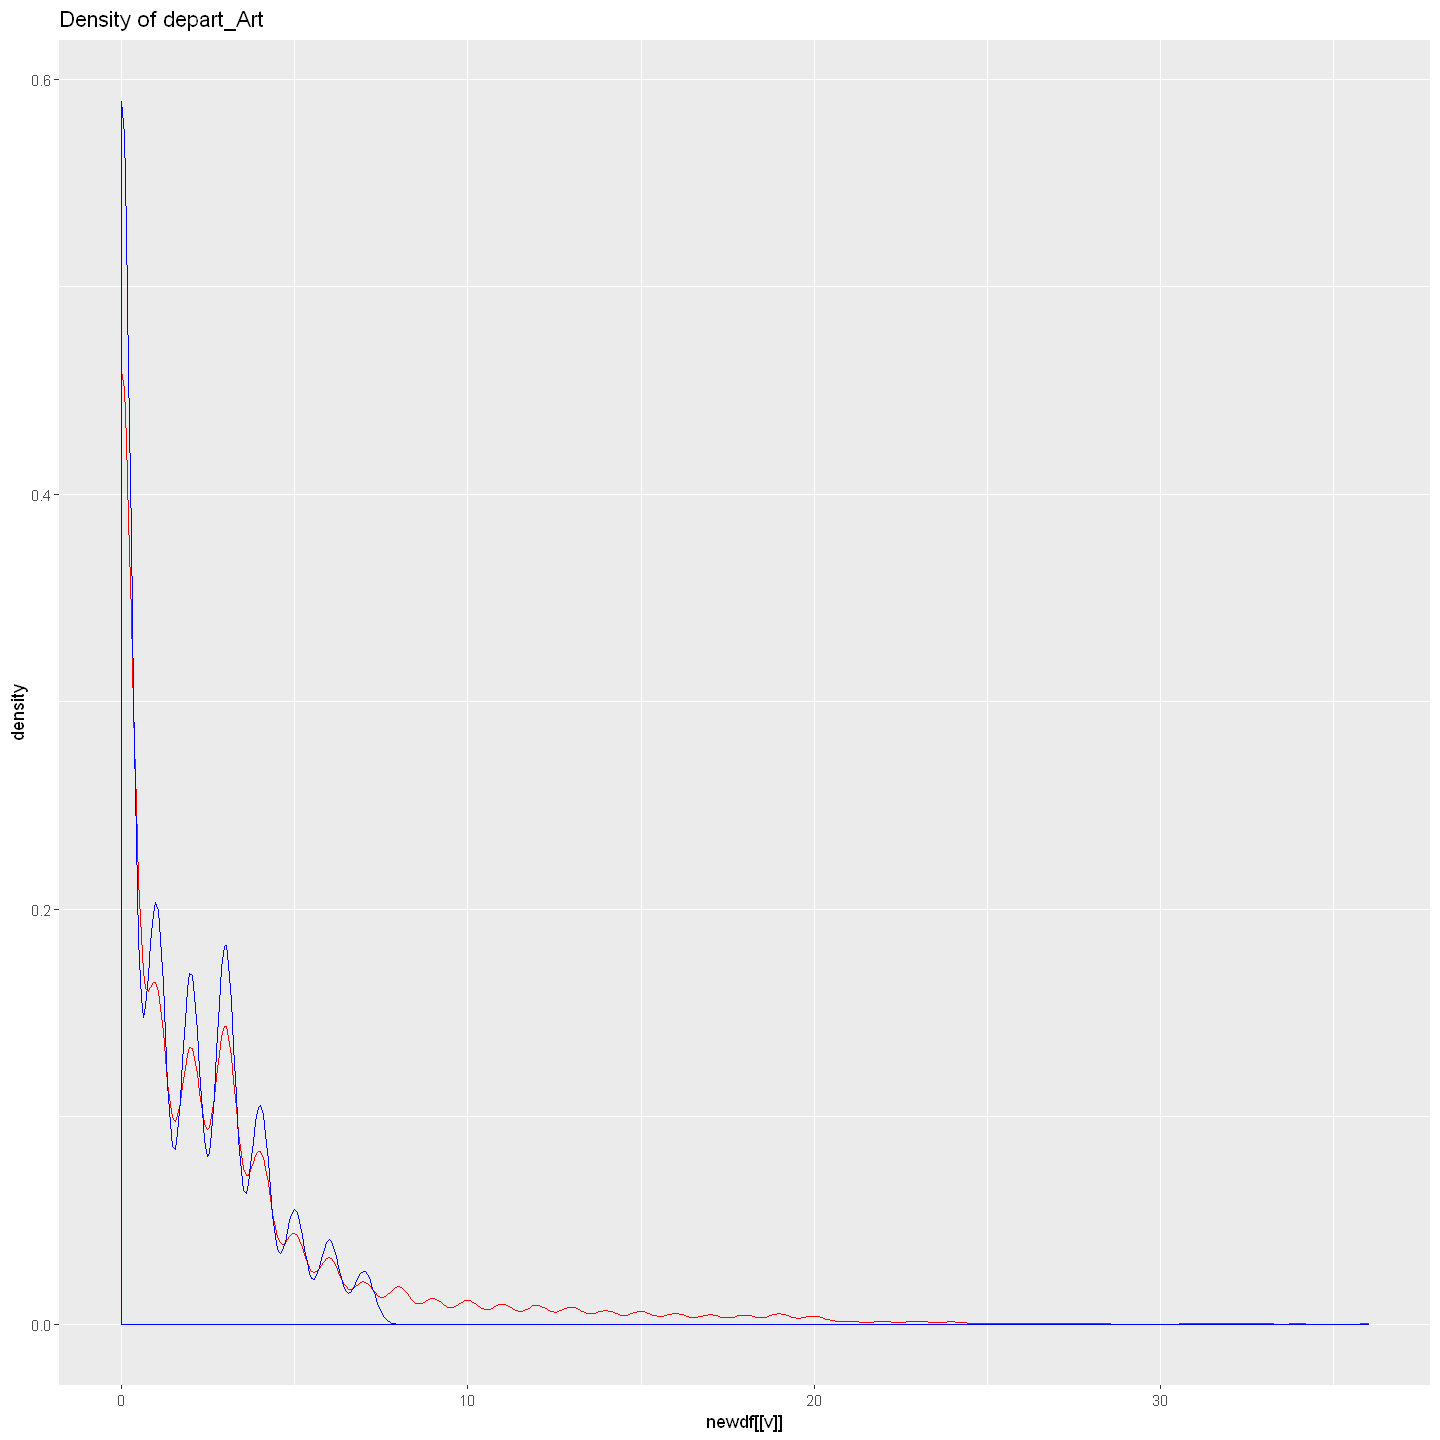

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 940 rows containing non-finite values (stat_density)."


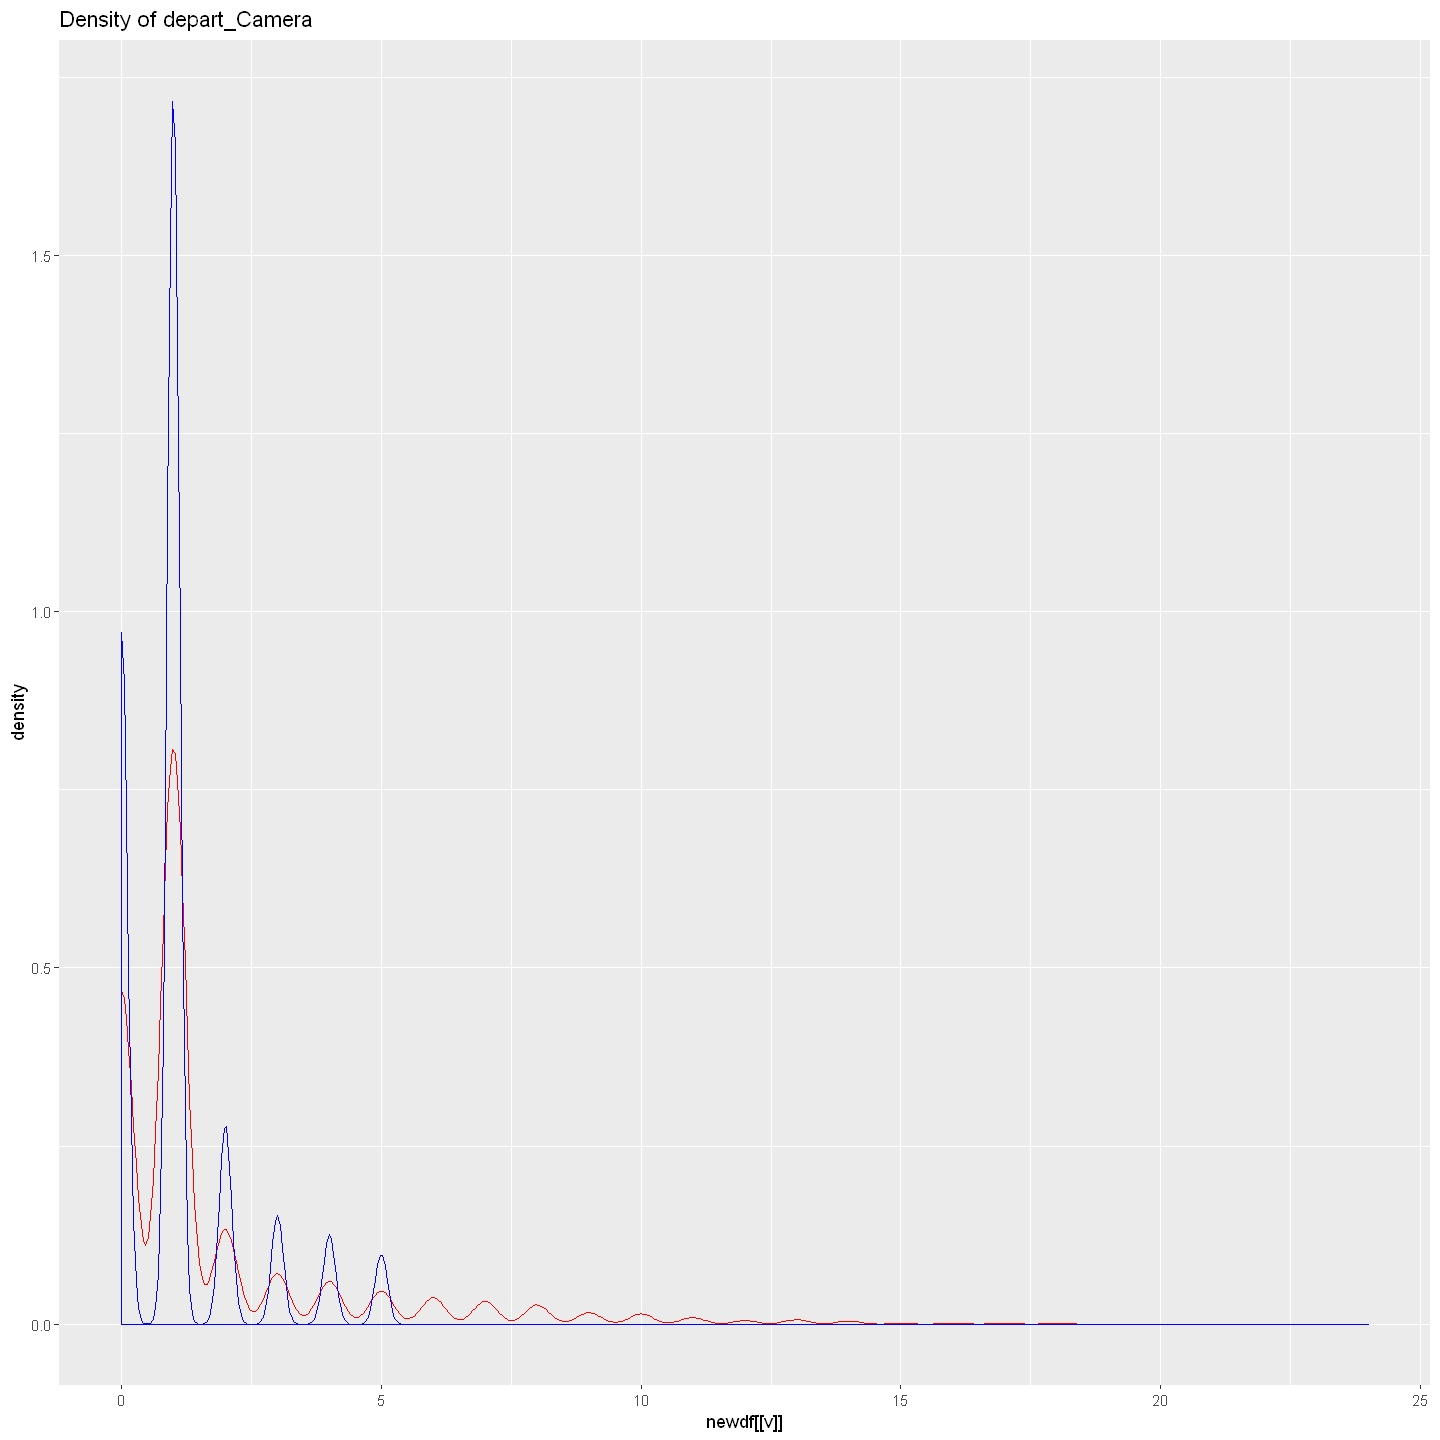

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


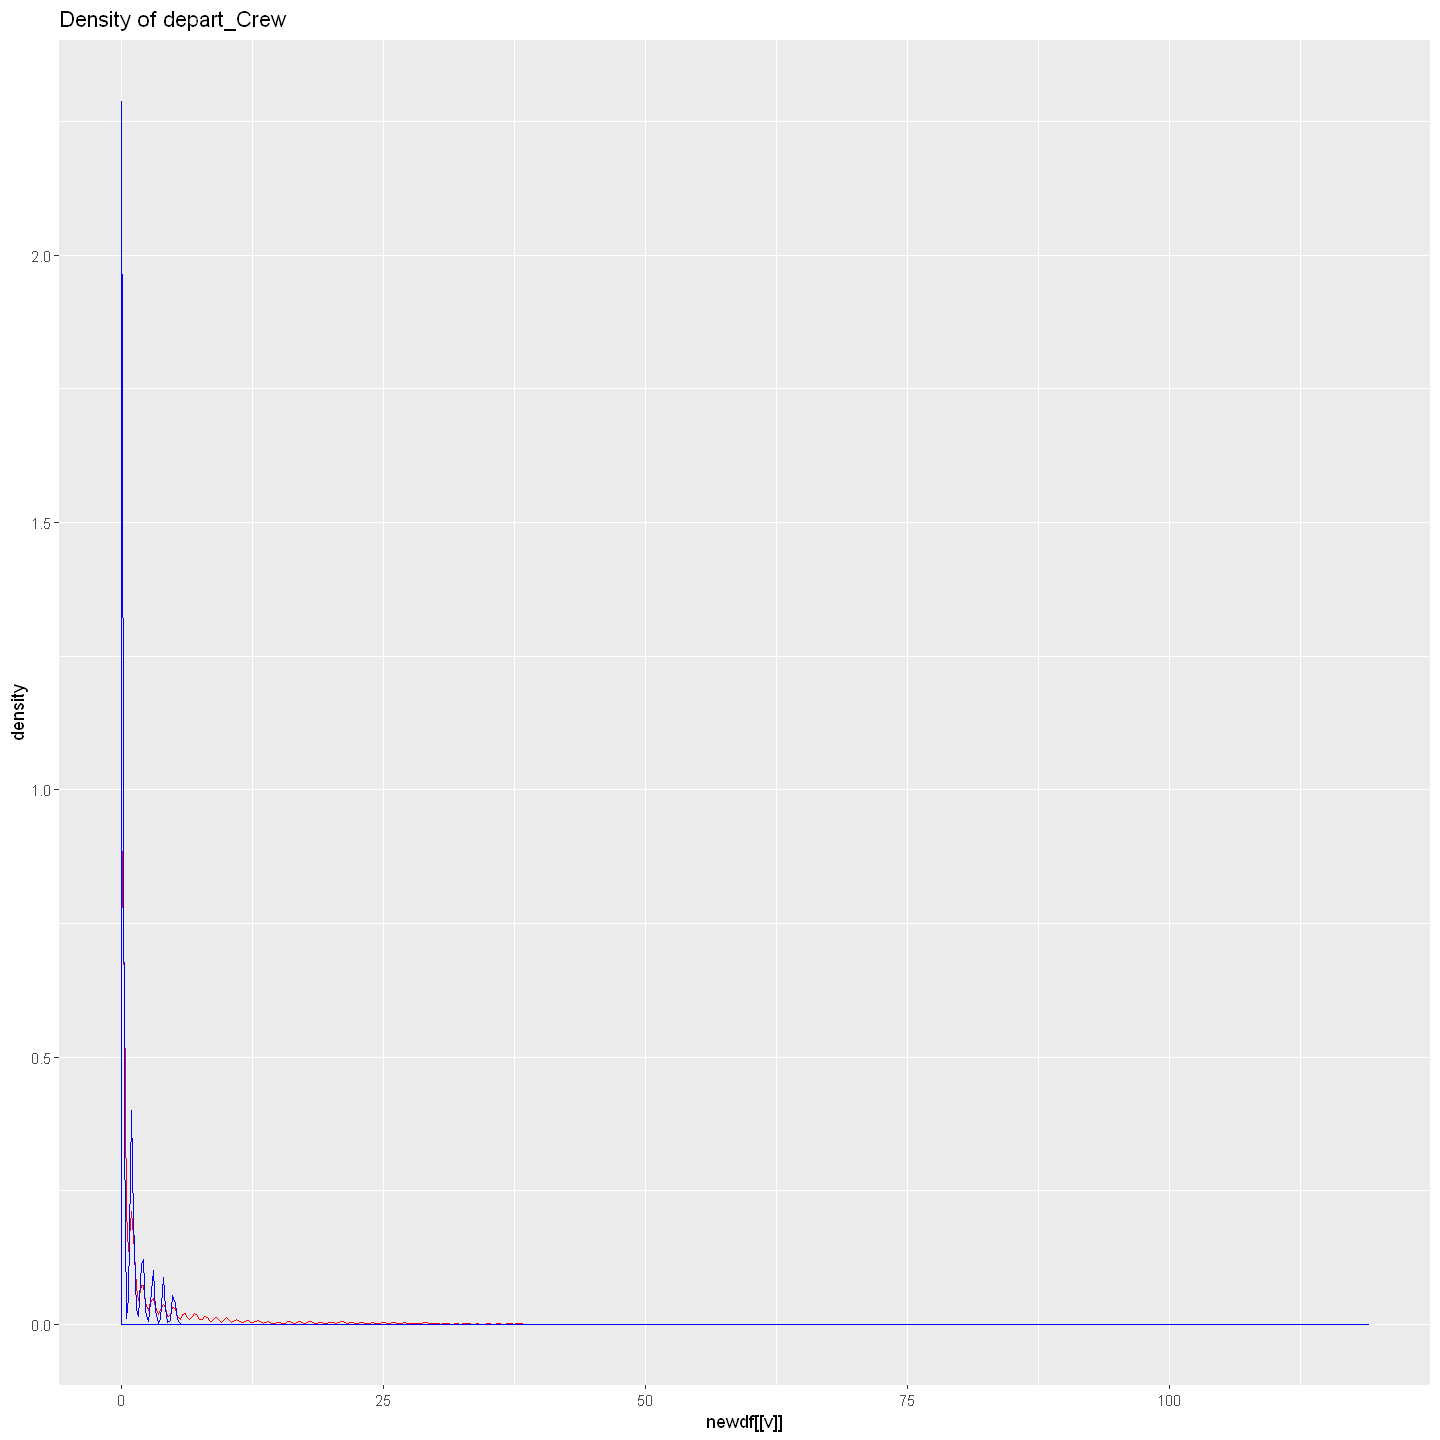

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


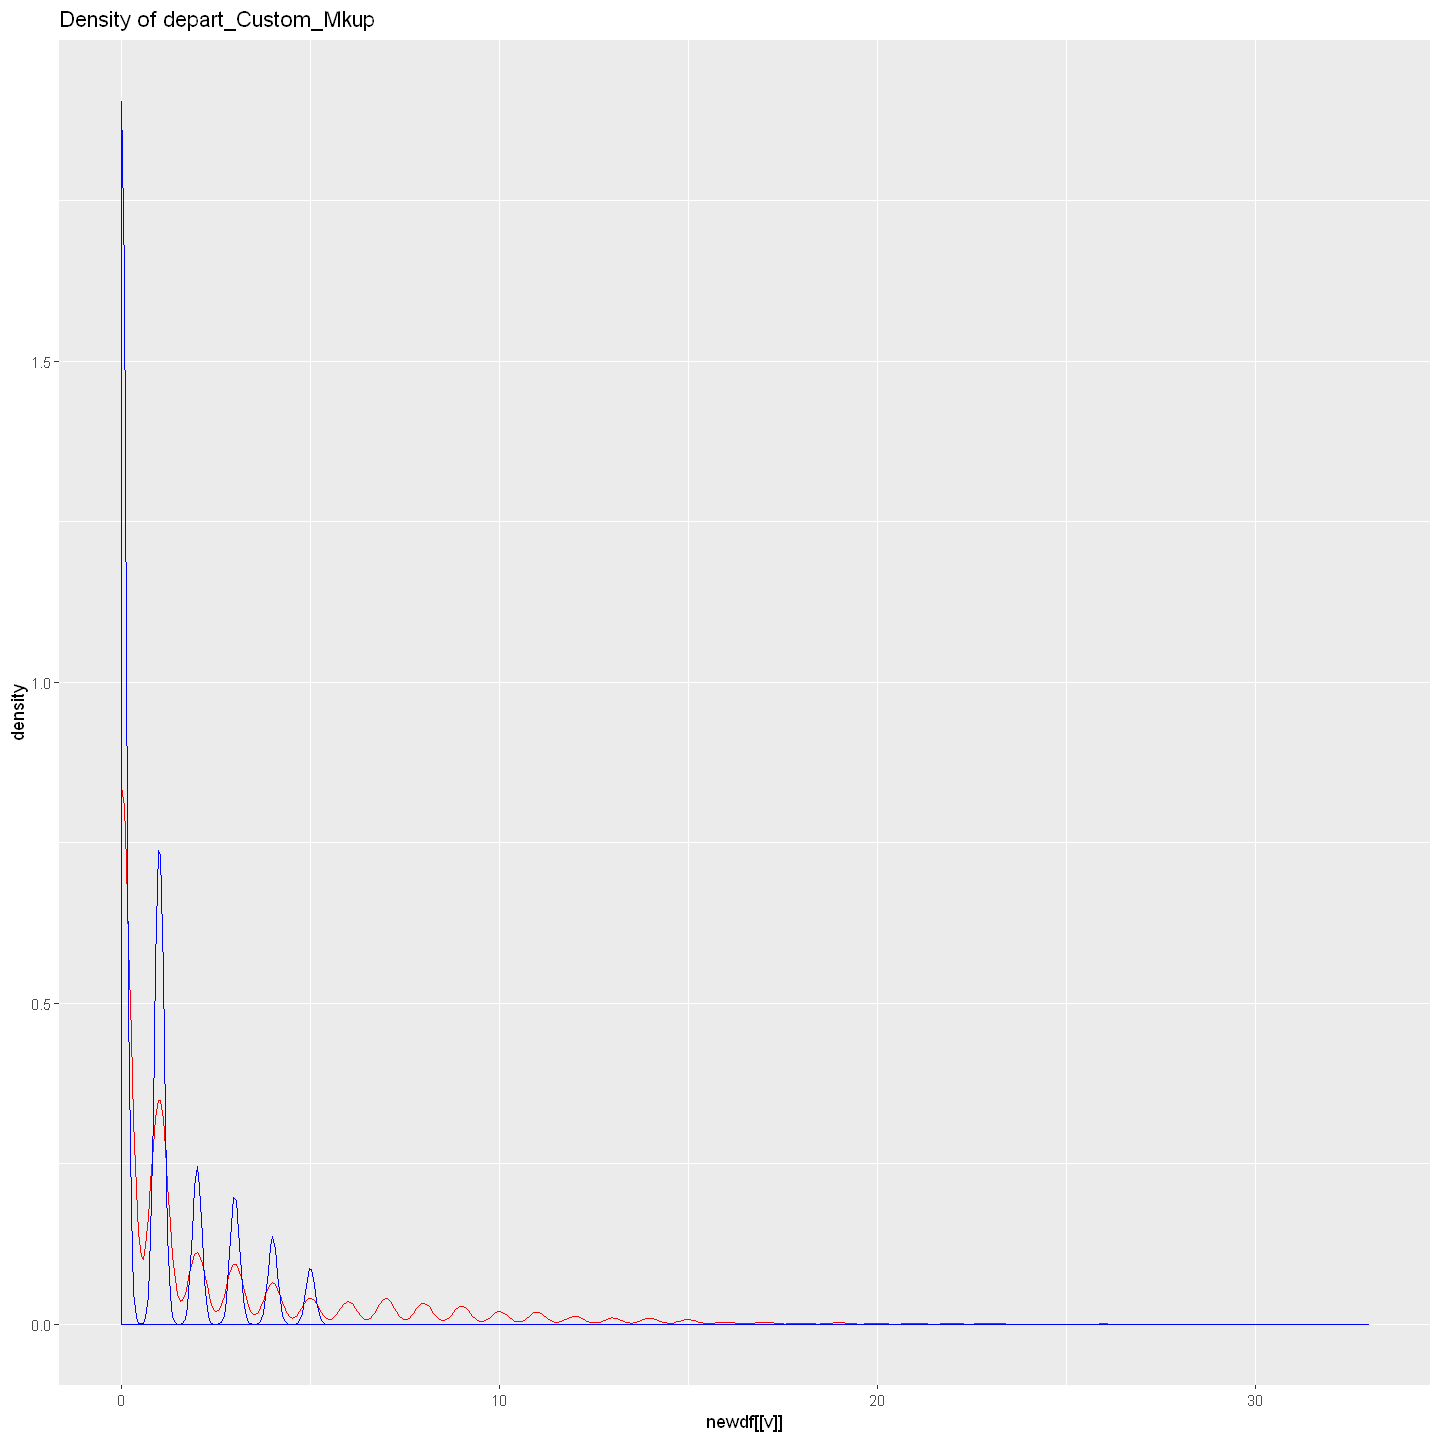

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 361 rows containing non-finite values (stat_density)."


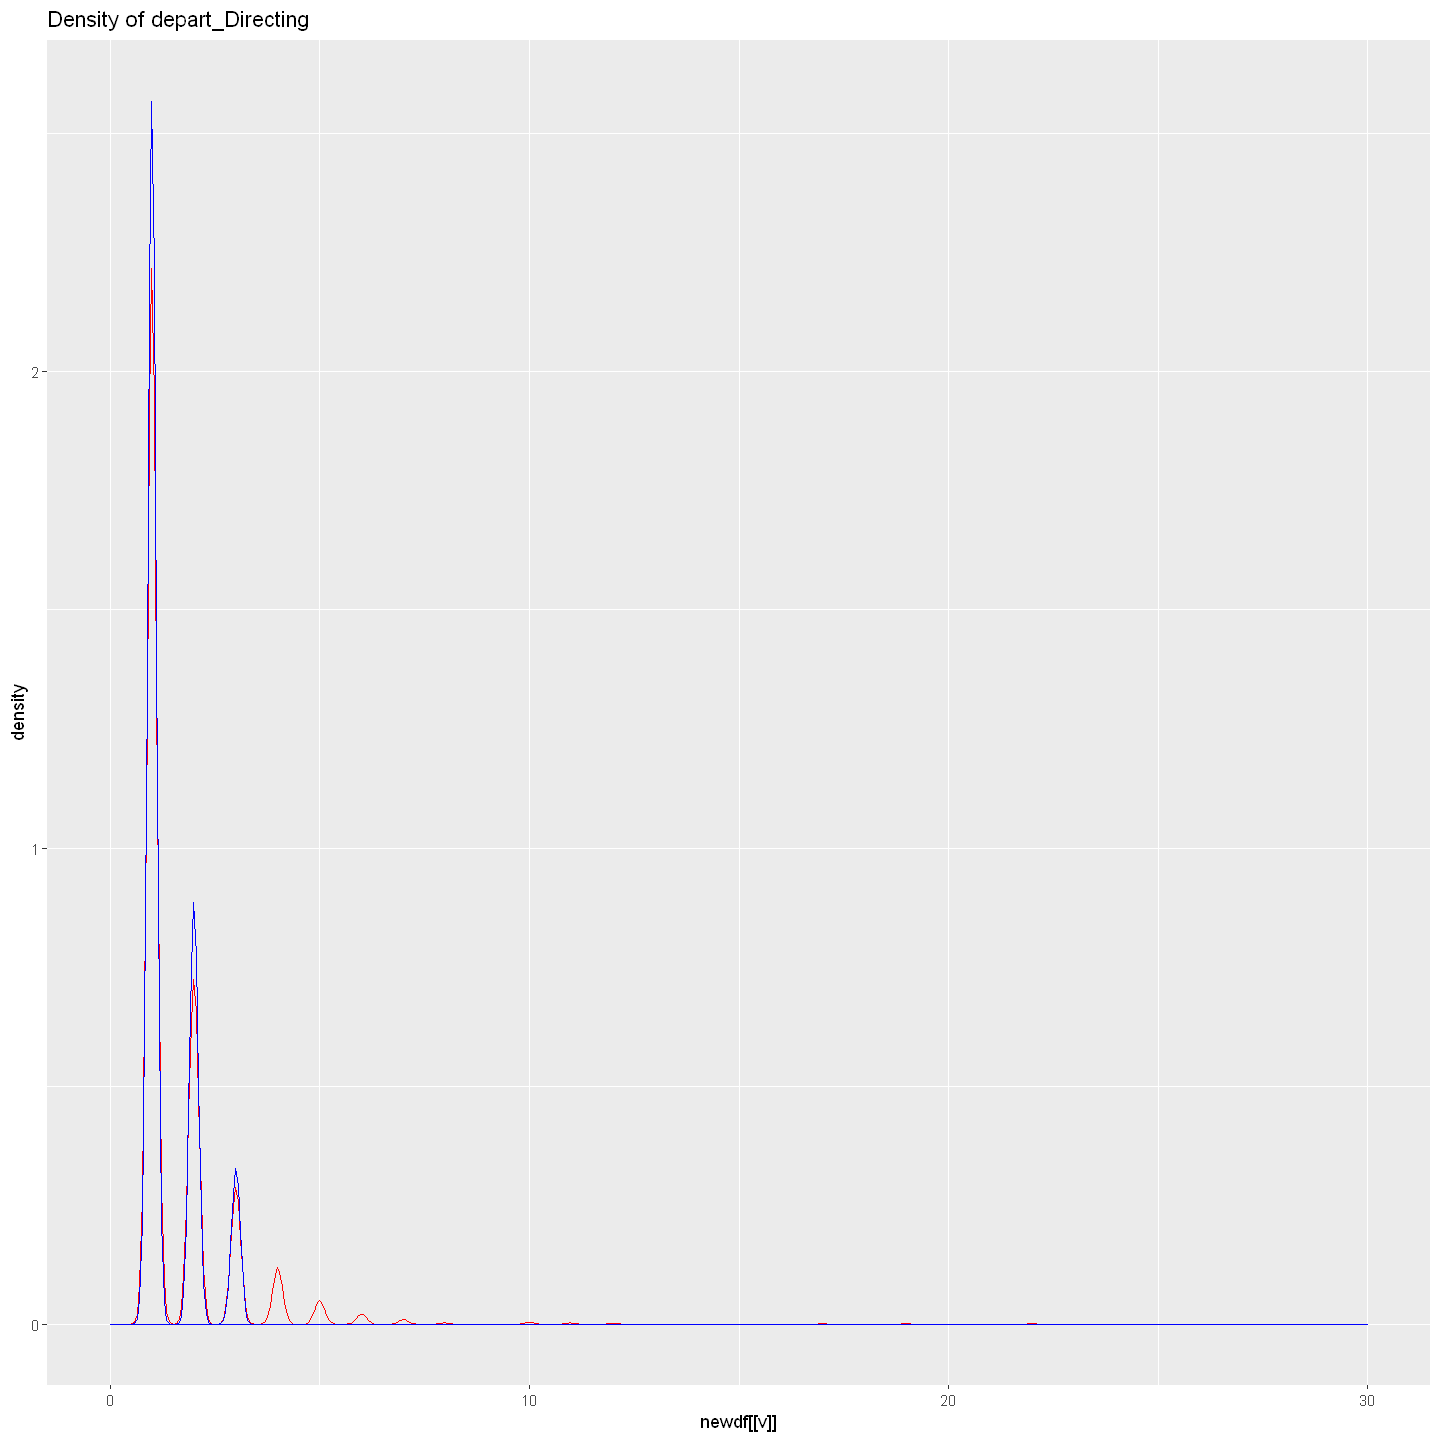

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1260 rows containing non-finite values (stat_density)."


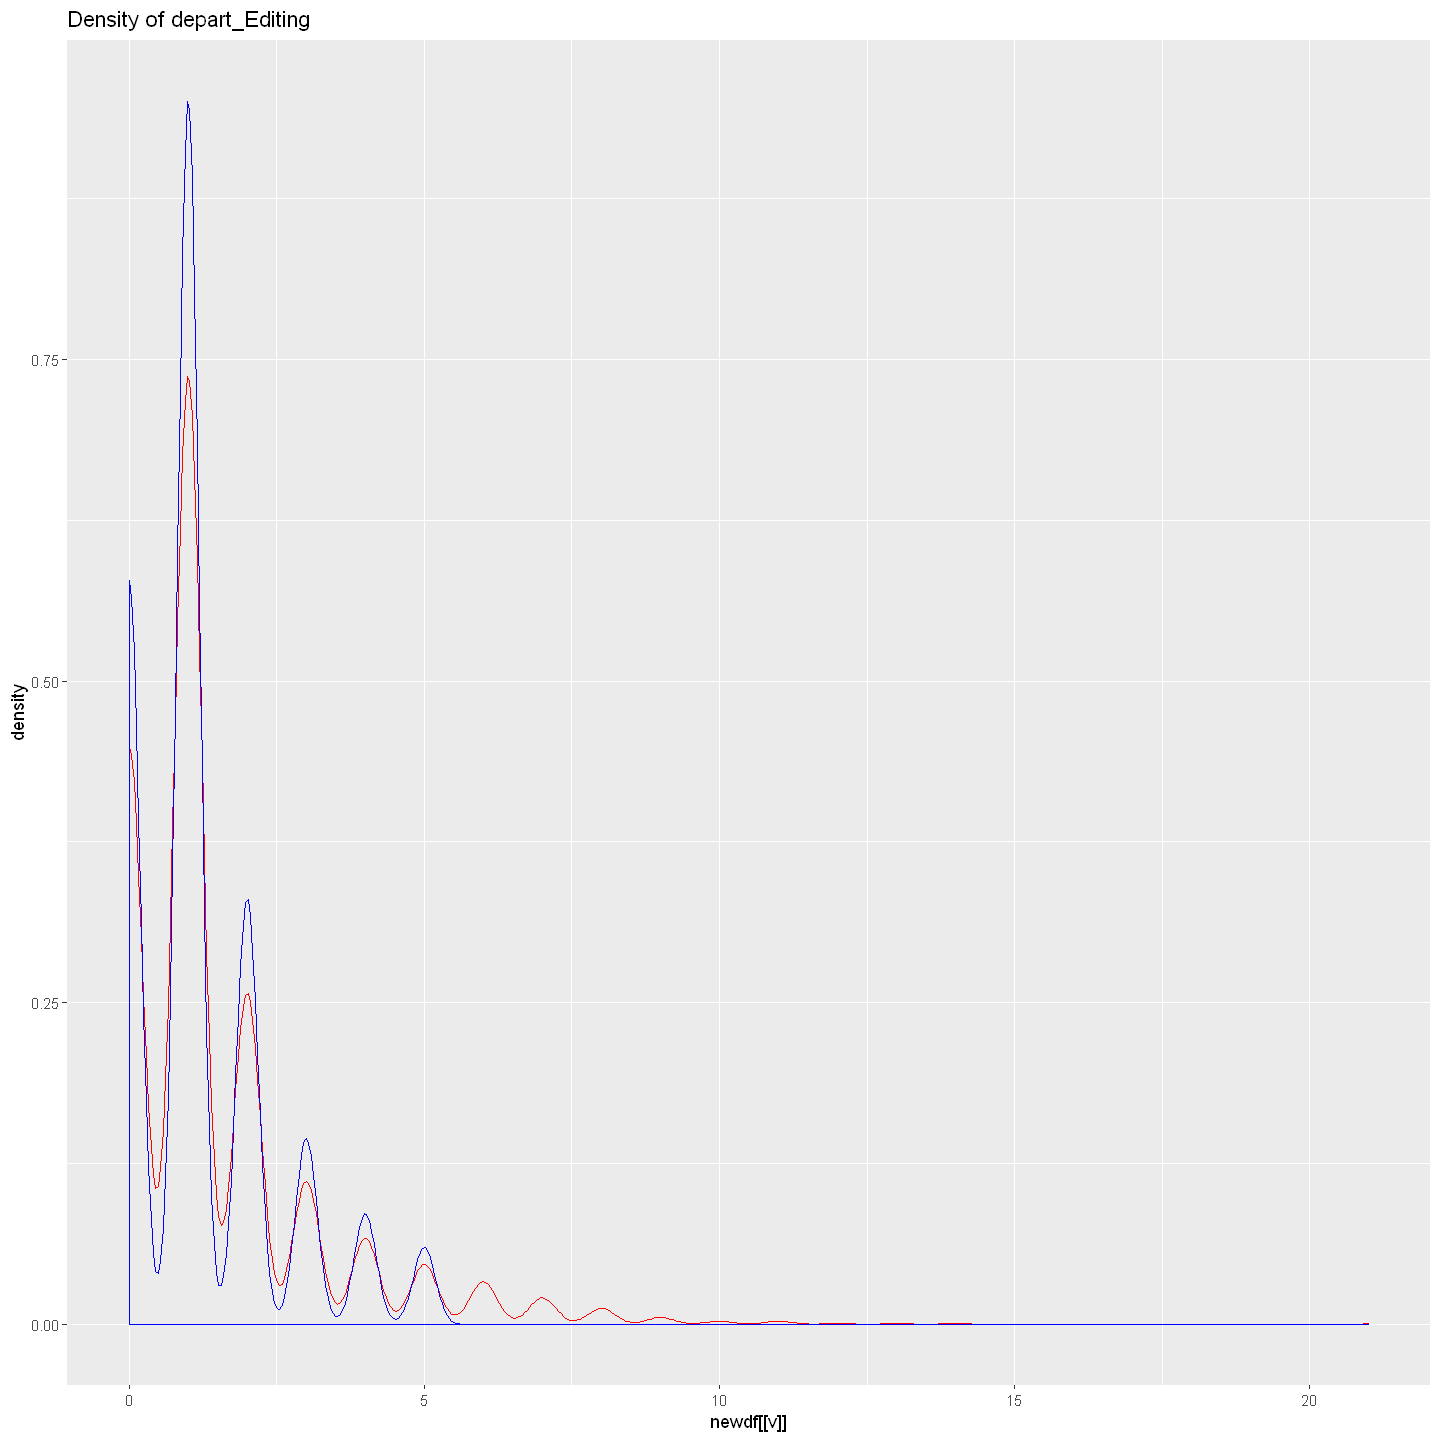

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 249 rows containing non-finite values (stat_density)."


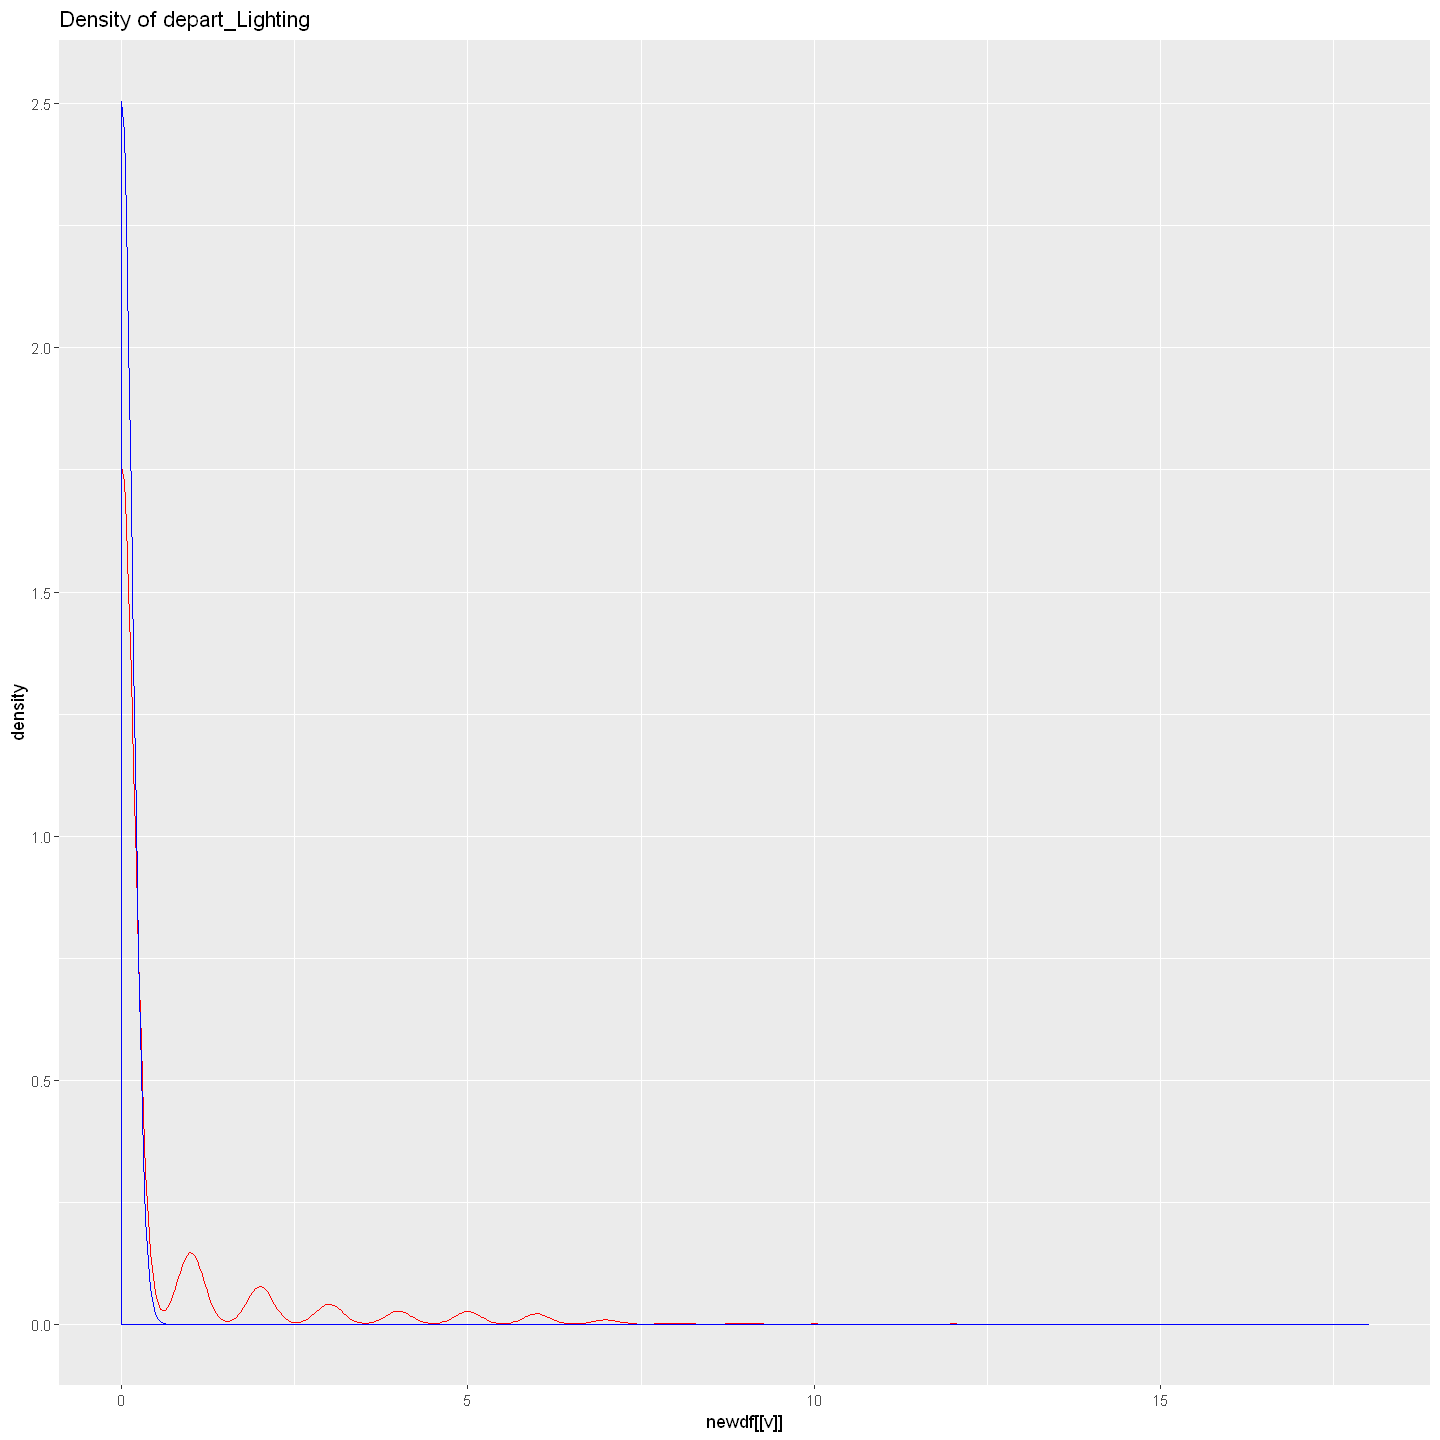

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


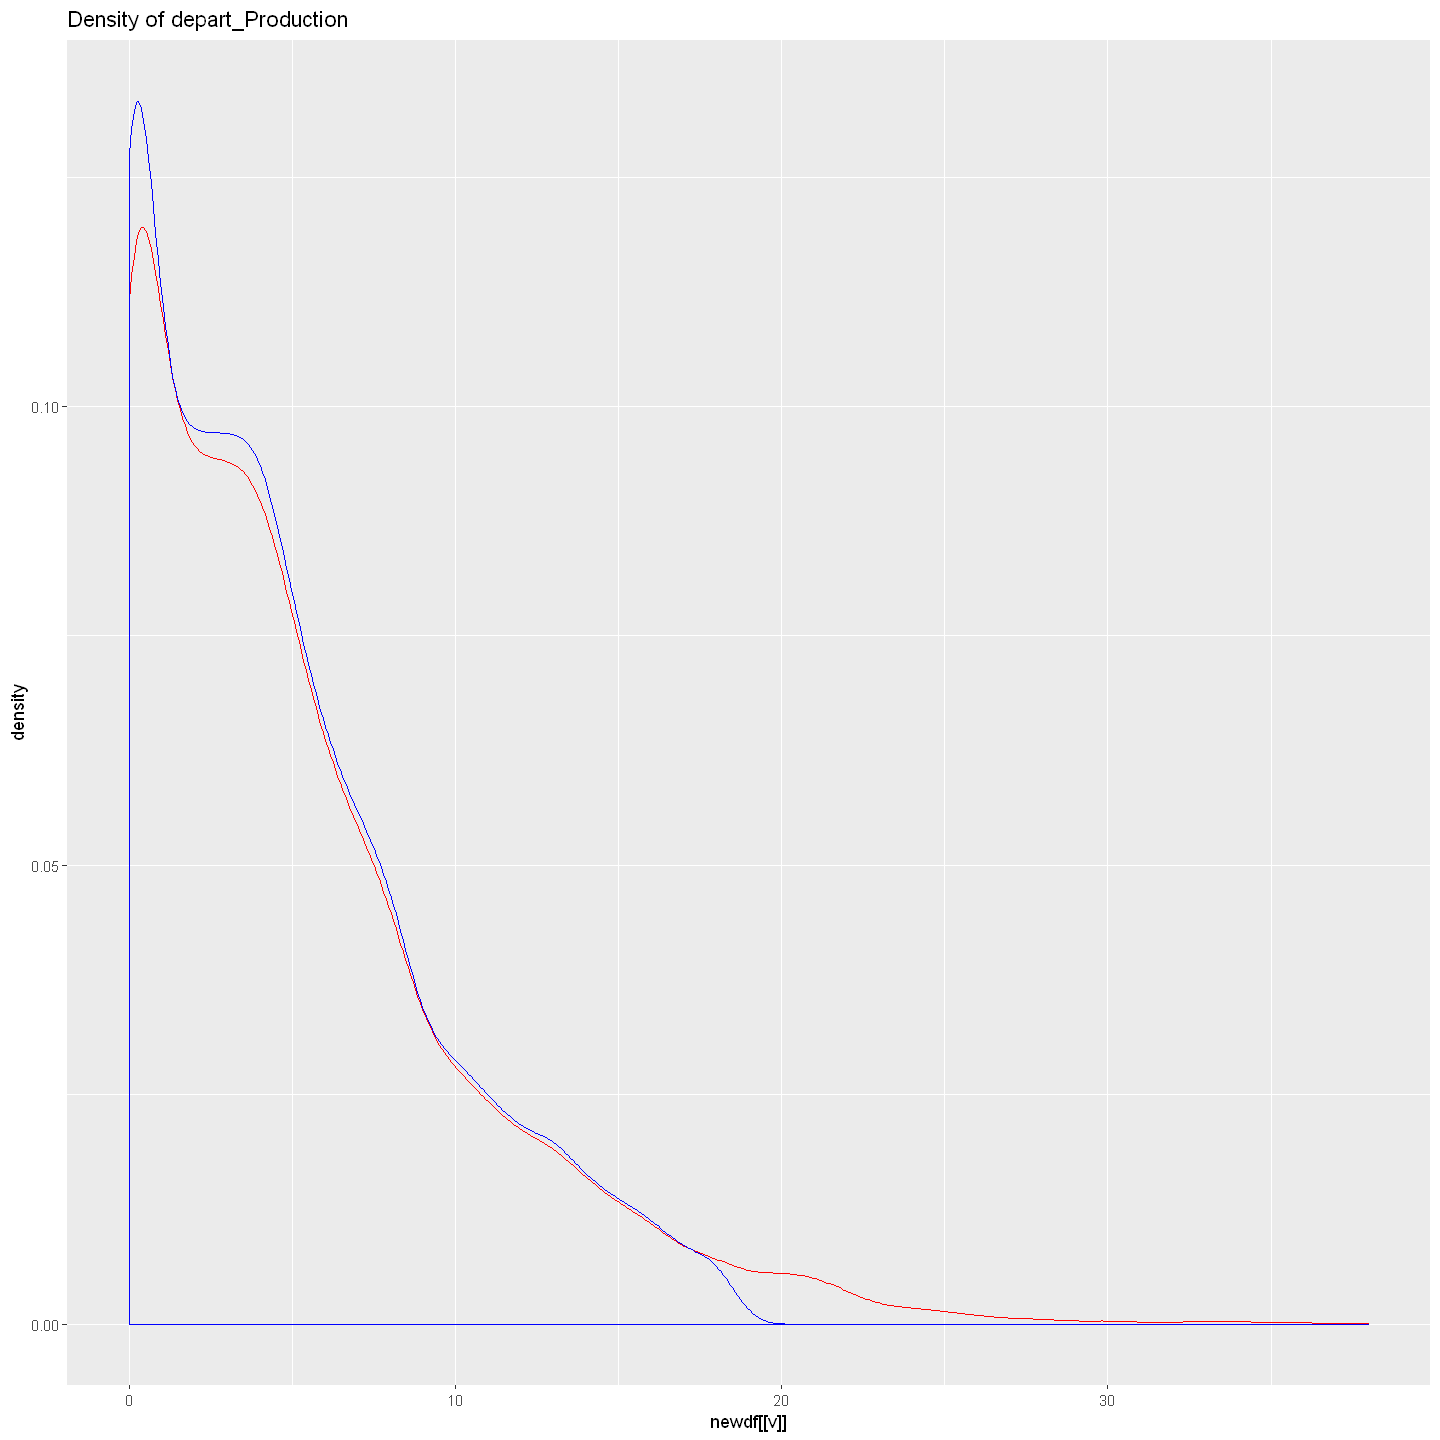

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1780 rows containing non-finite values (stat_density)."


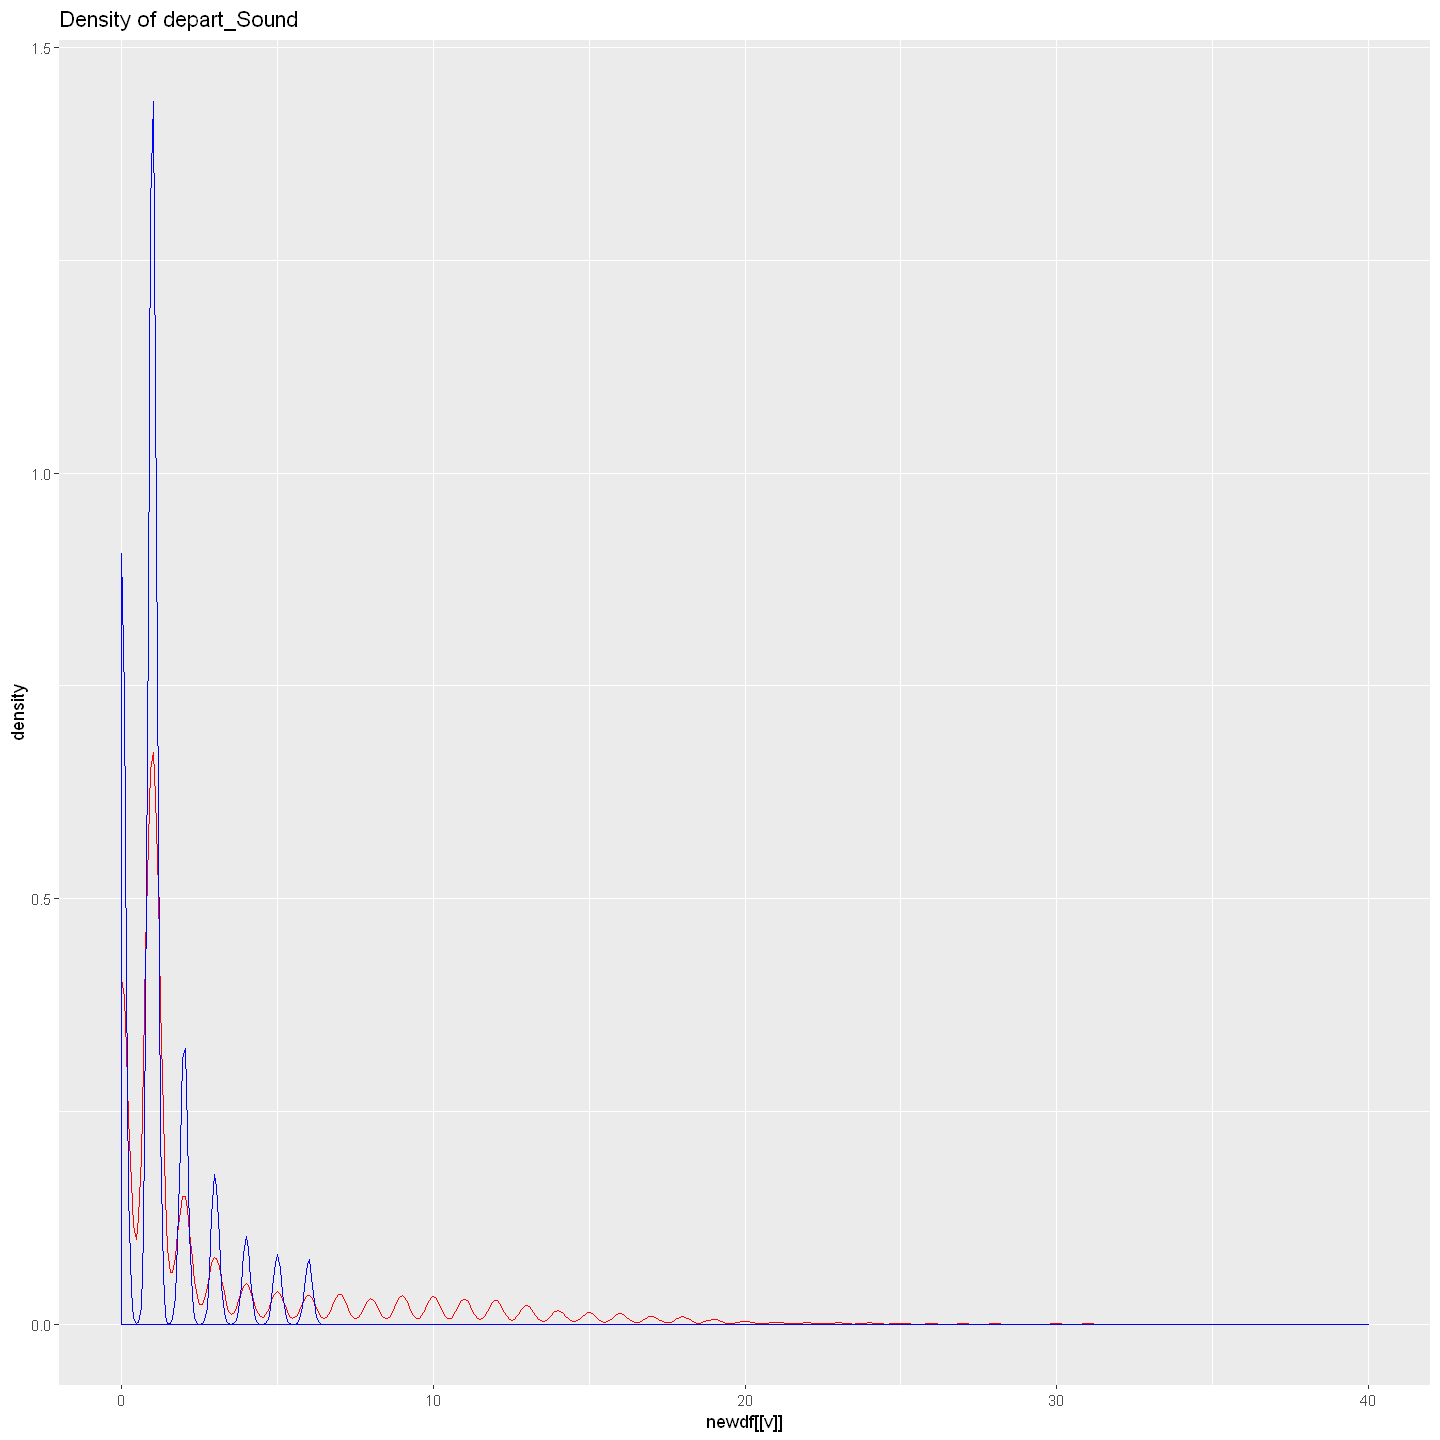

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 176 rows containing non-finite values (stat_density)."


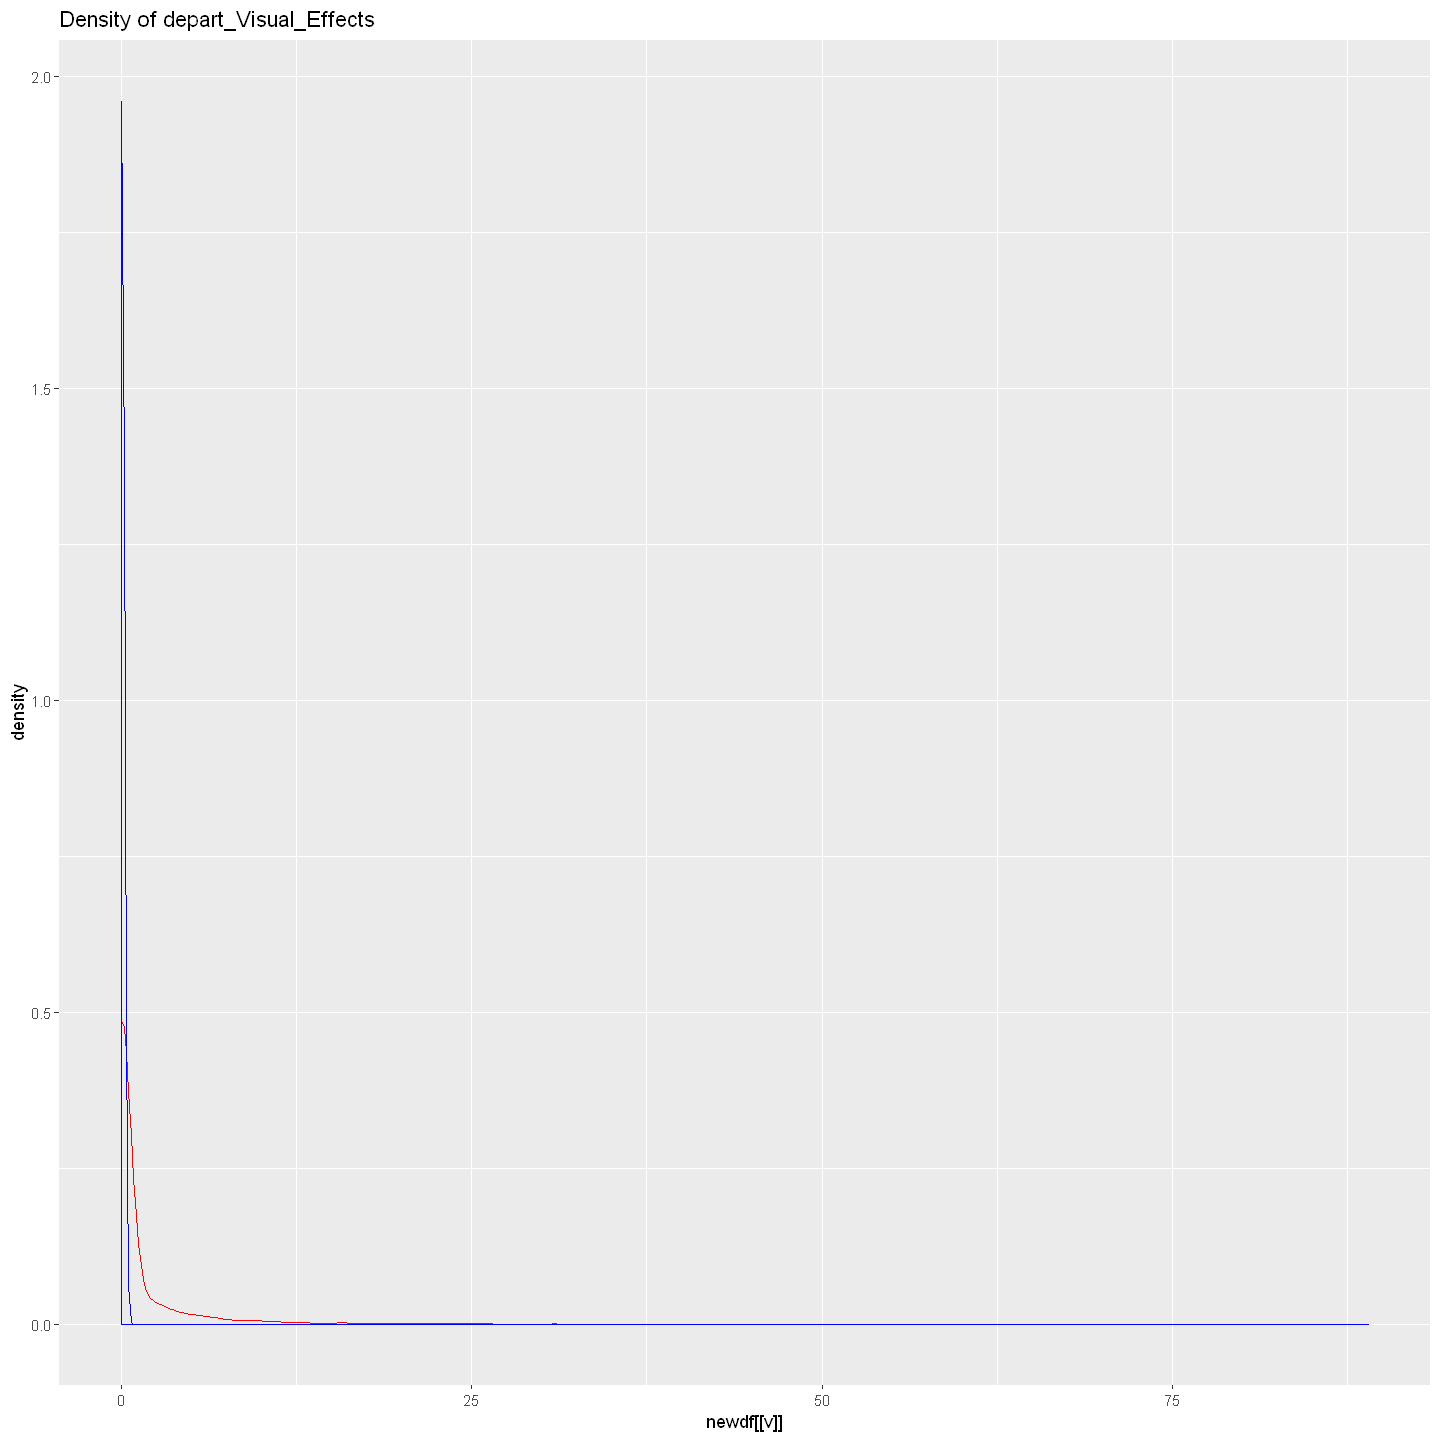

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1387 rows containing non-finite values (stat_density)."


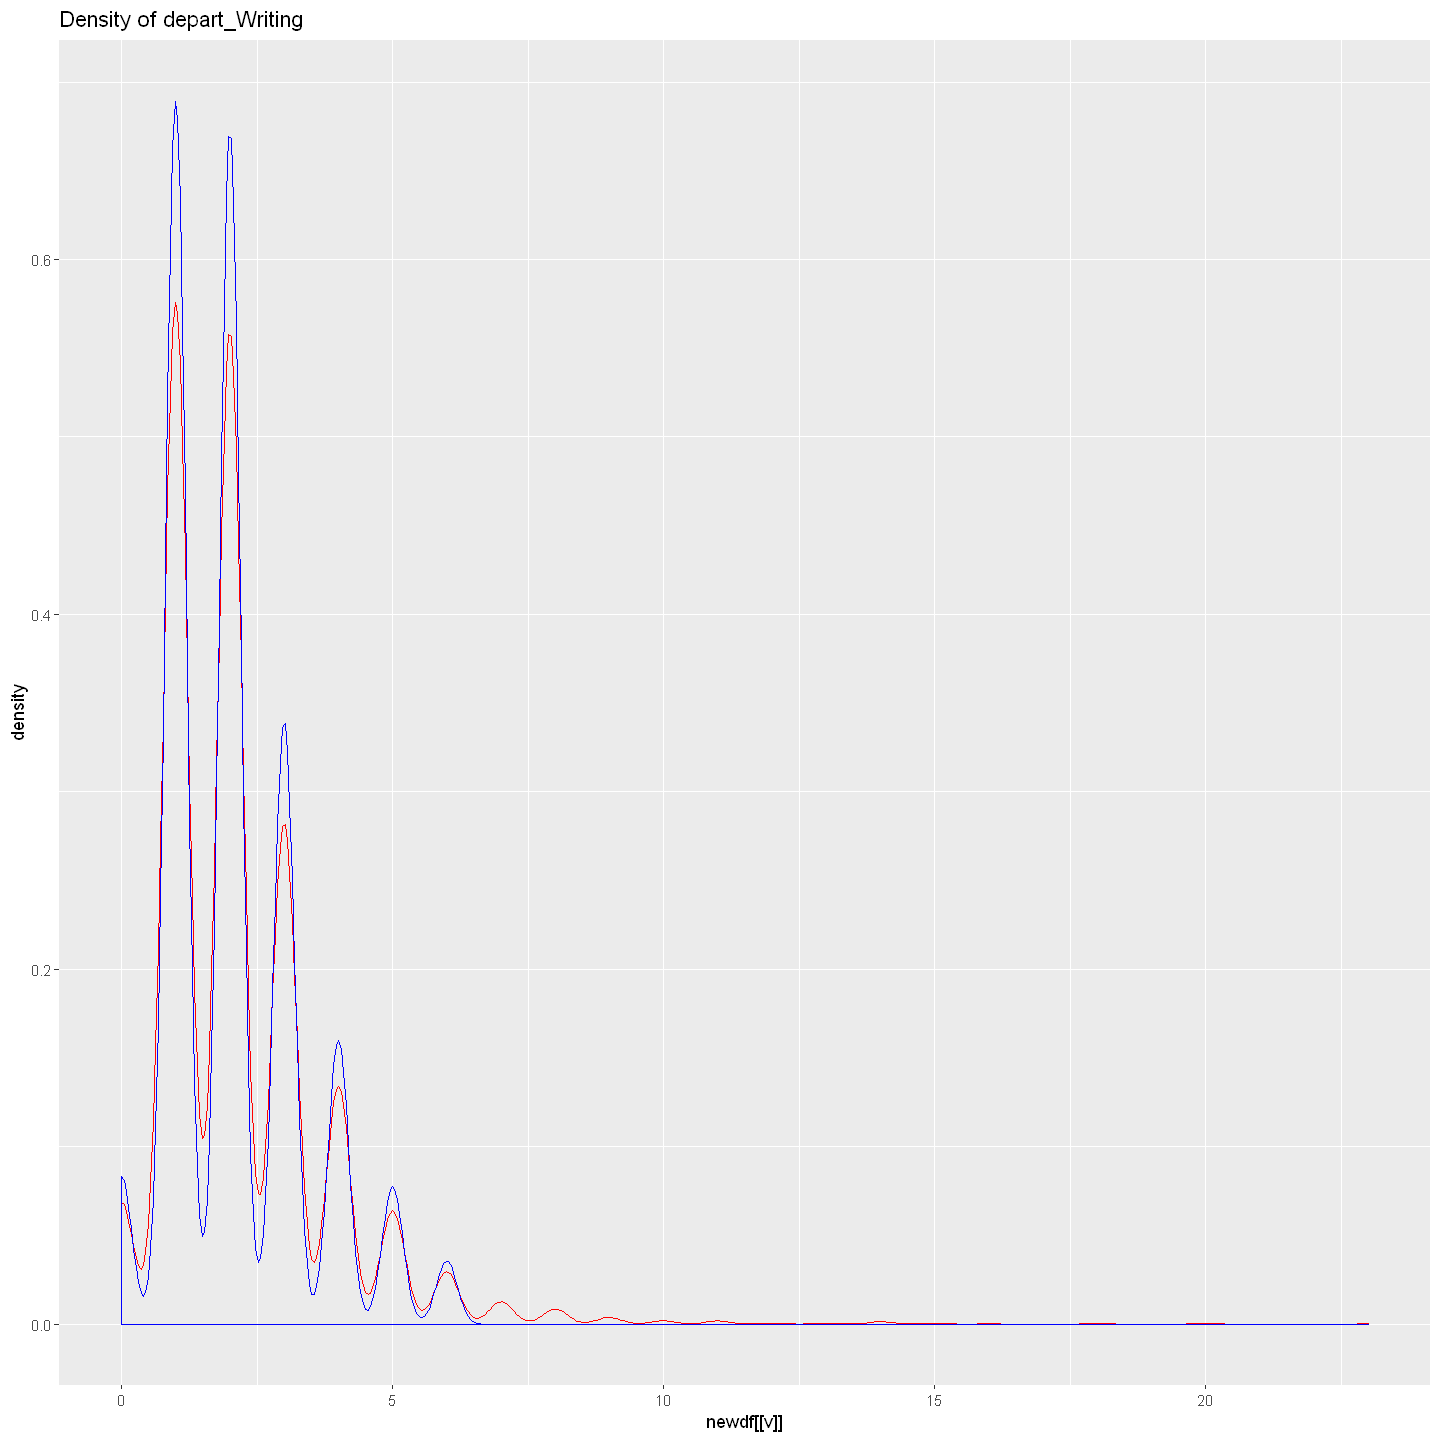

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 181 rows containing non-finite values (stat_density)."


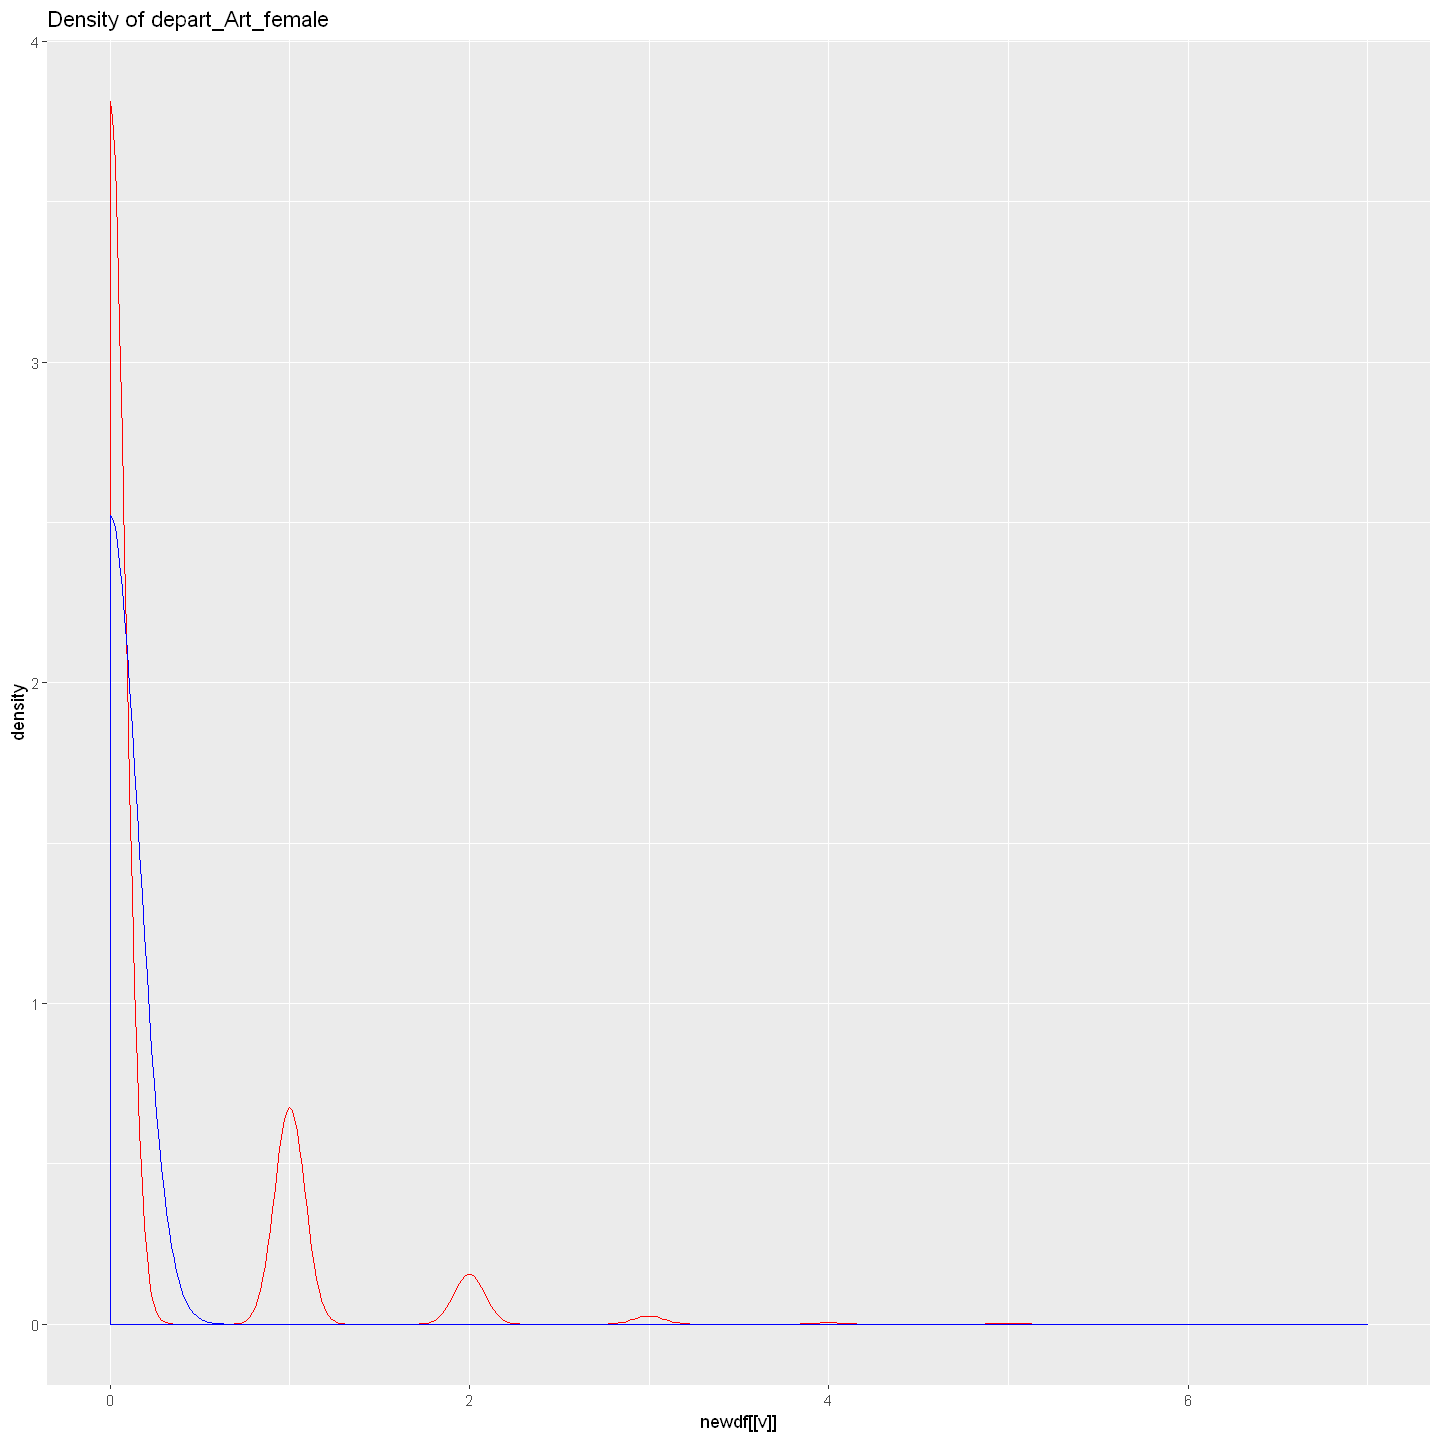

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 404 rows containing non-finite values (stat_density)."


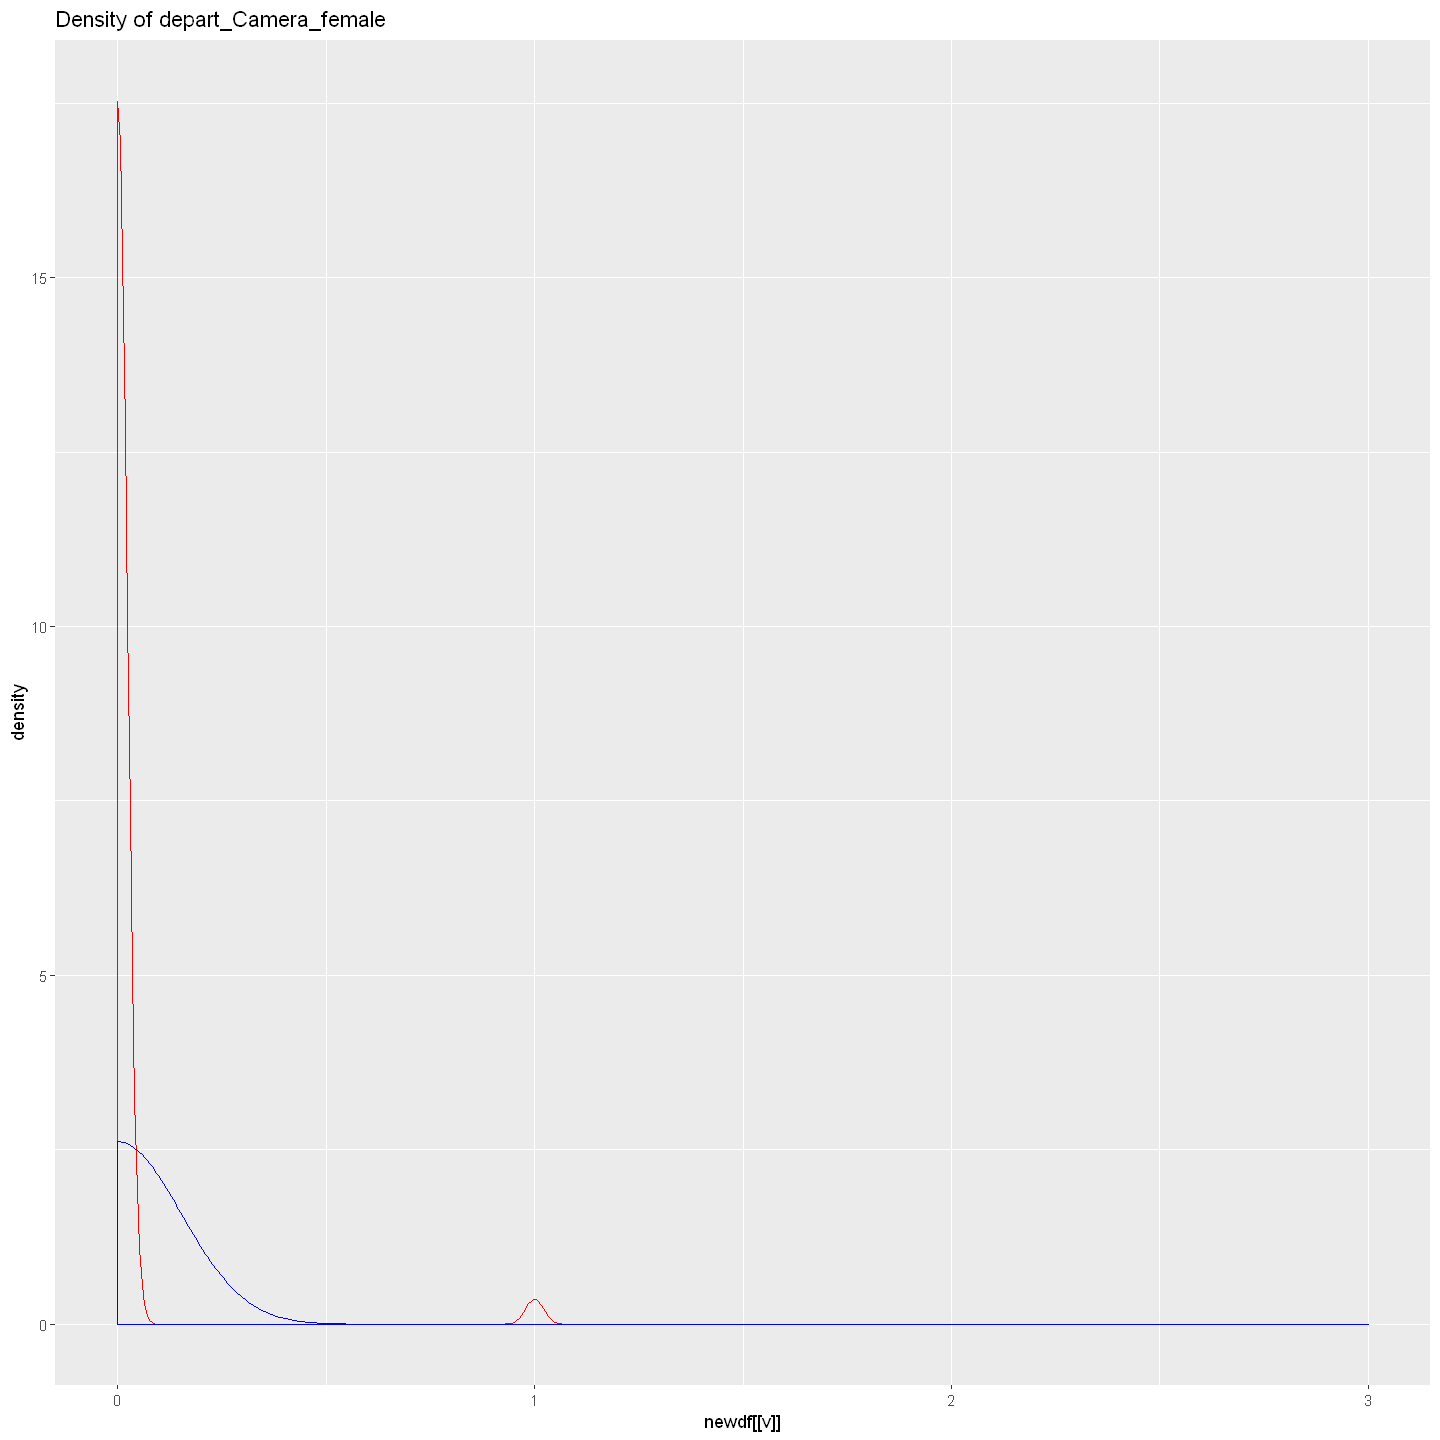

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 130 rows containing non-finite values (stat_density)."


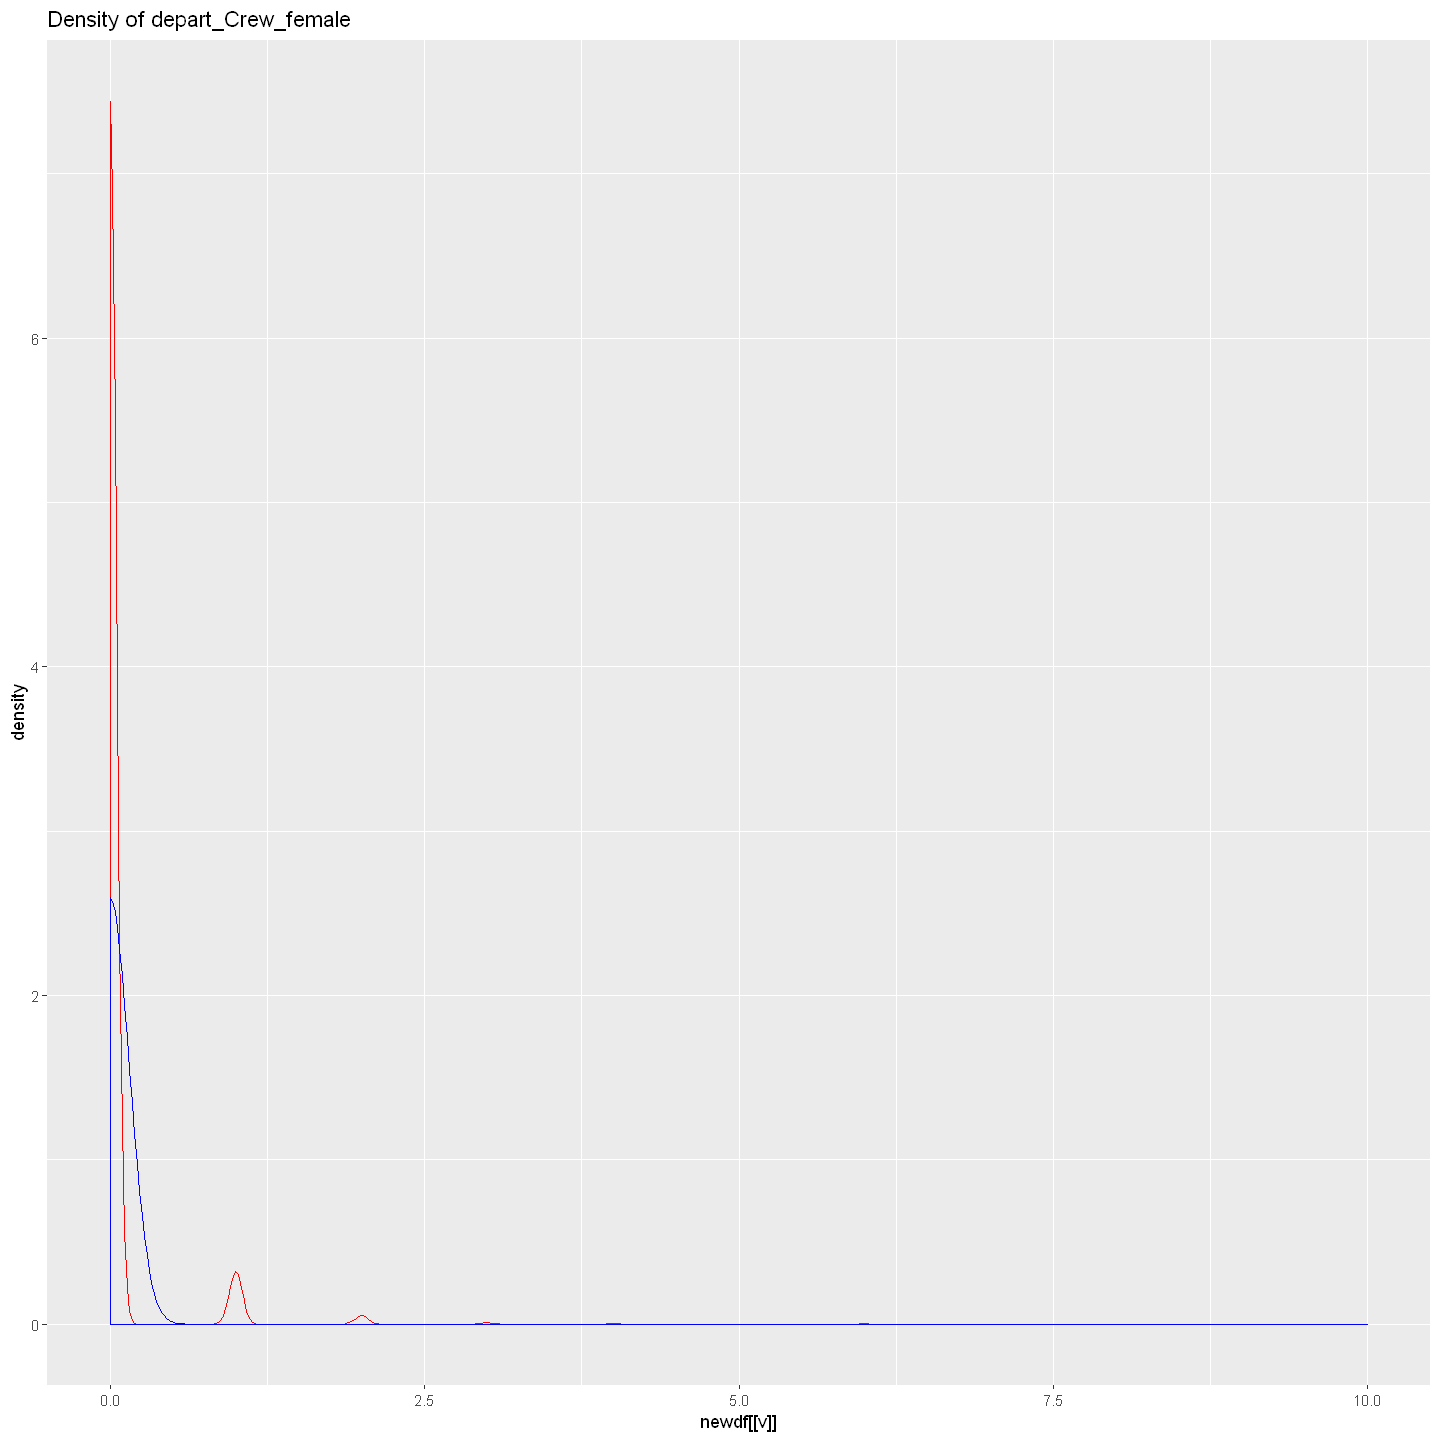

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1078 rows containing non-finite values (stat_density)."


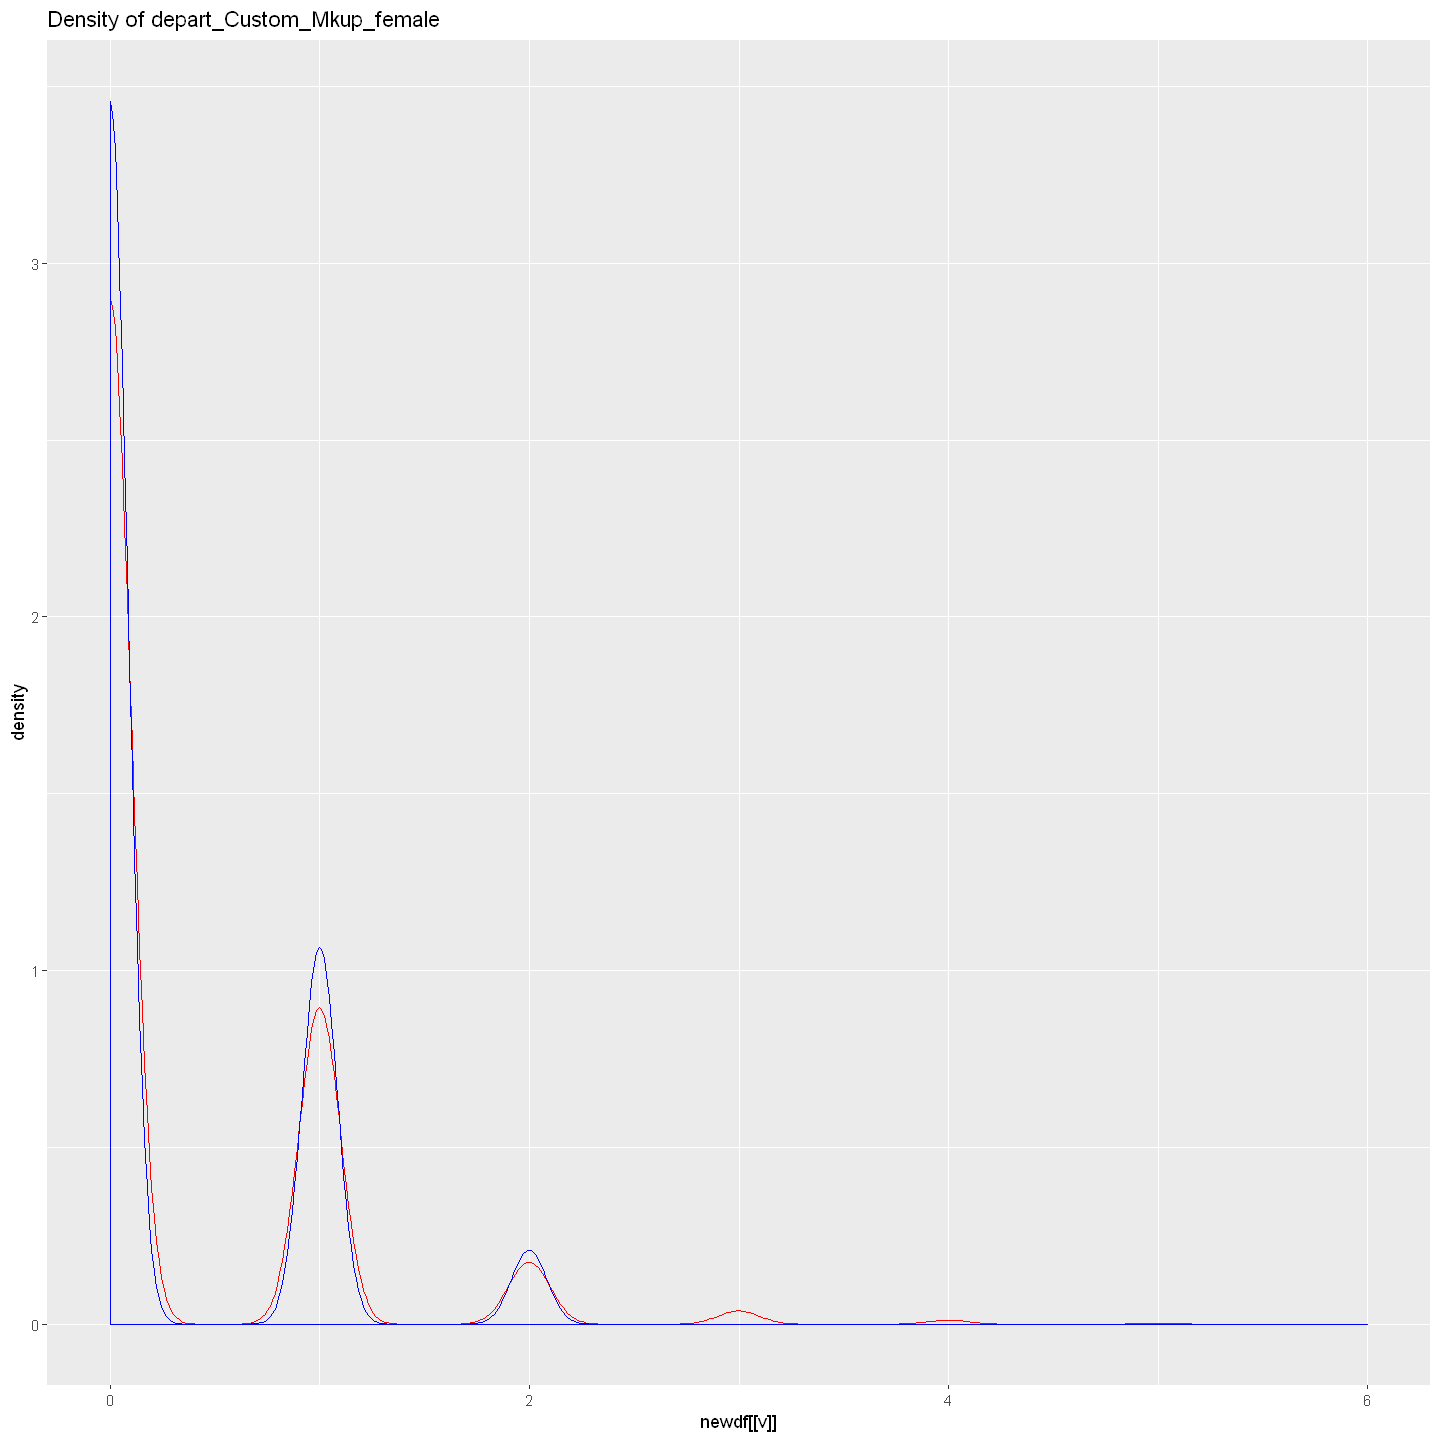

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 859 rows containing non-finite values (stat_density)."


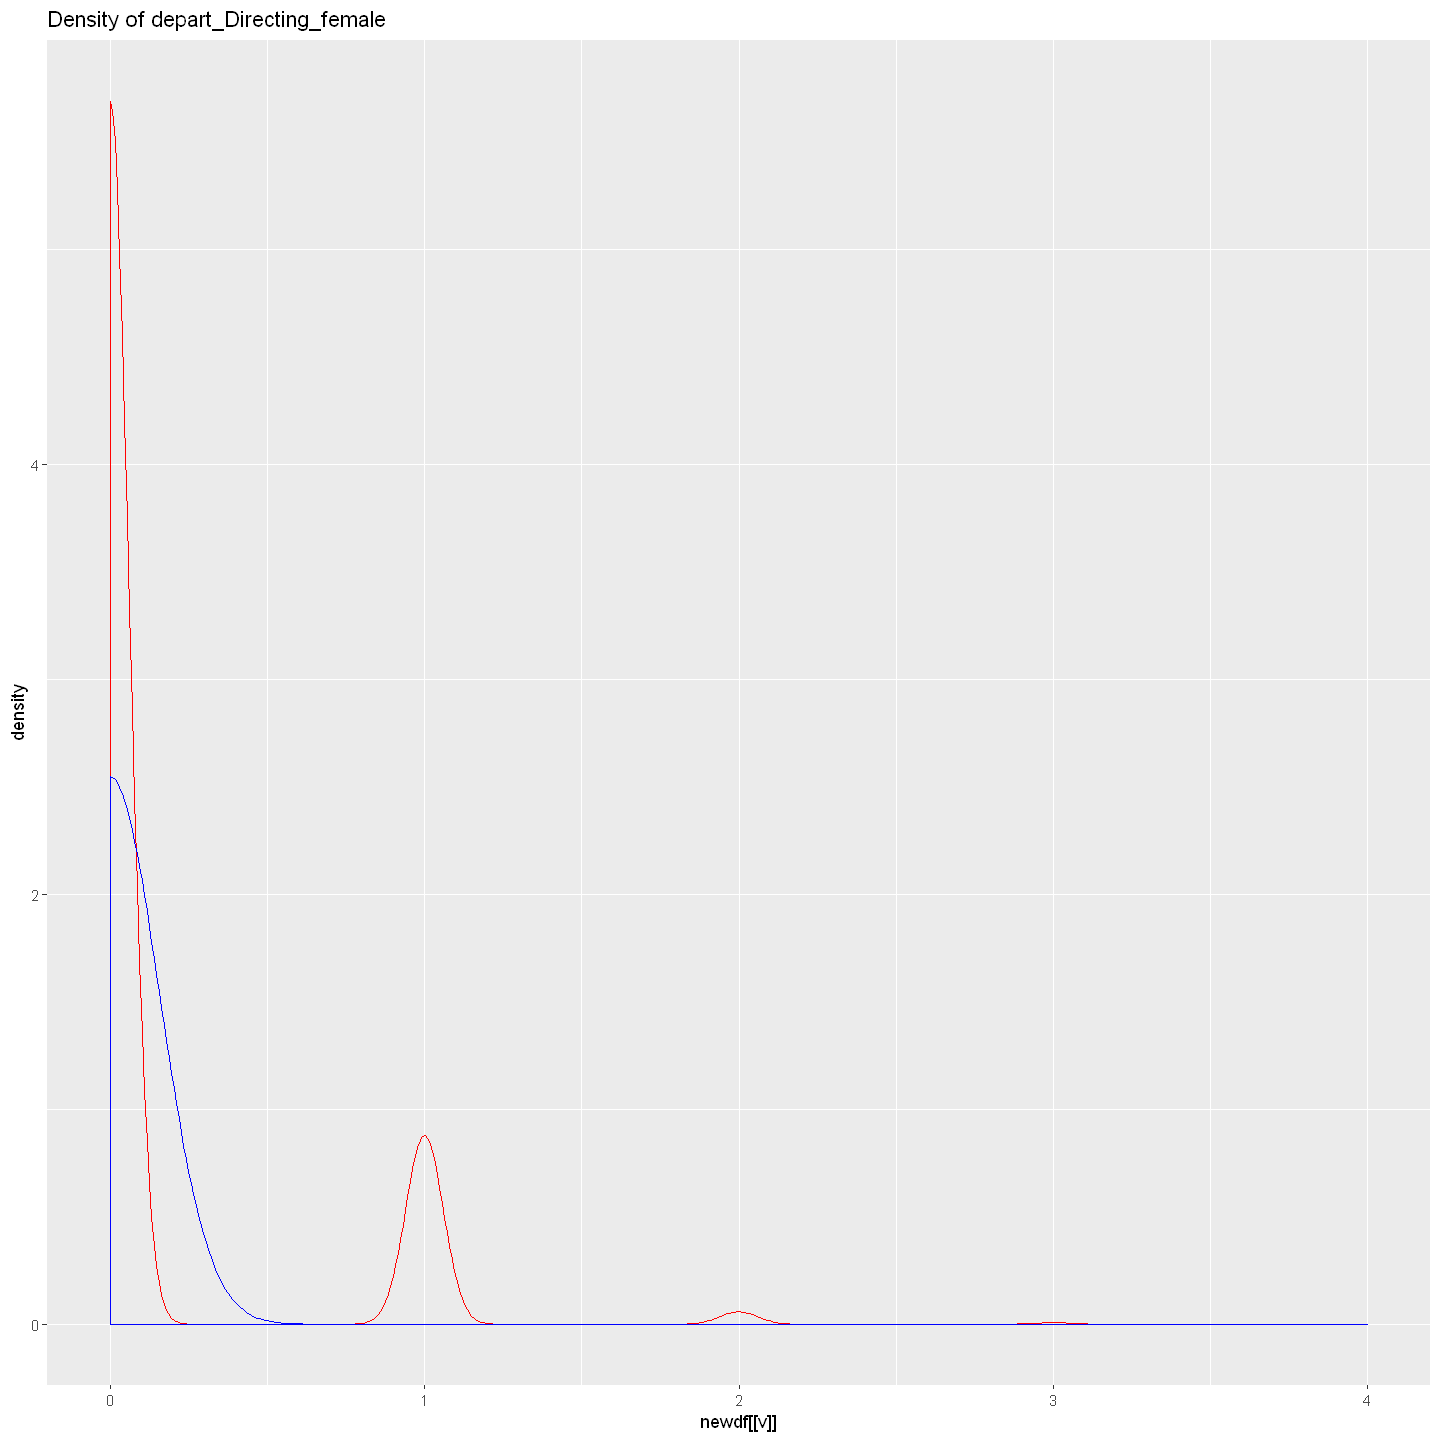

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 39 rows containing non-finite values (stat_density)."


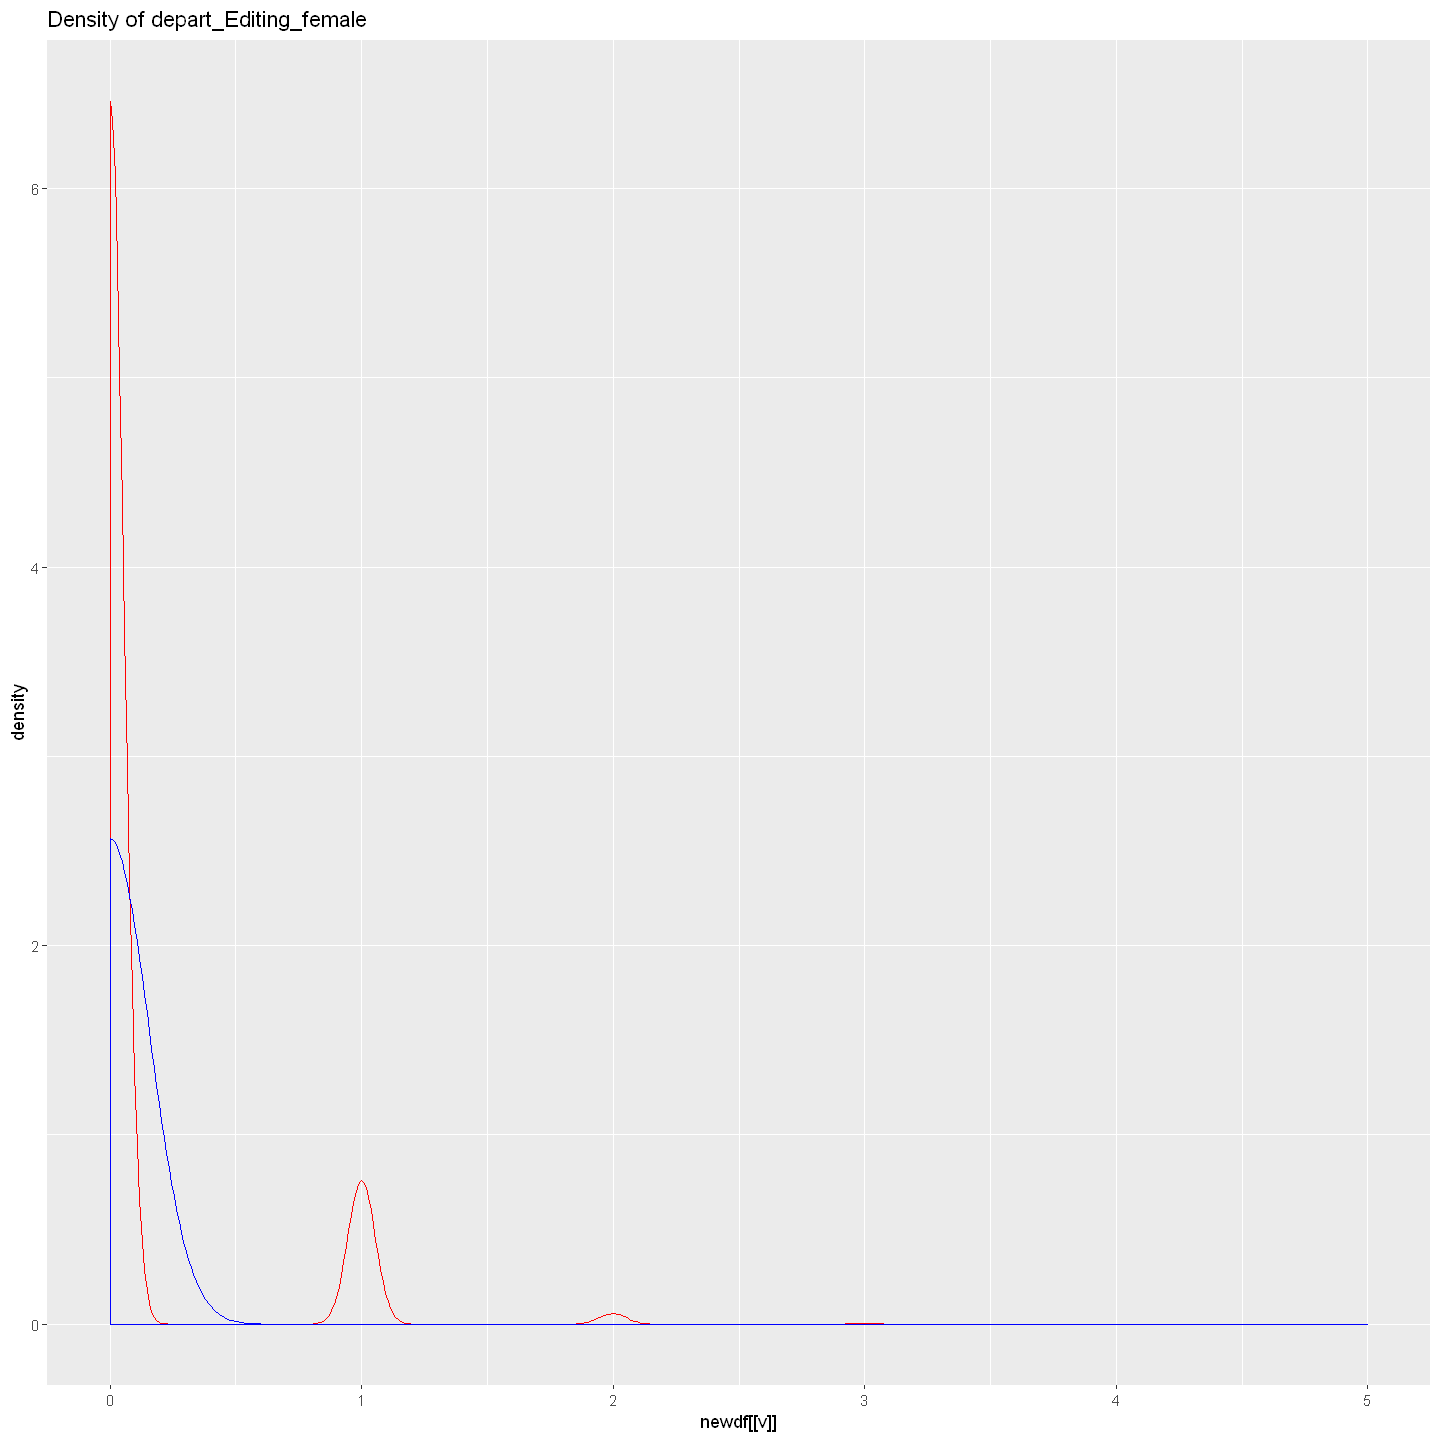

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 111 rows containing non-finite values (stat_density)."


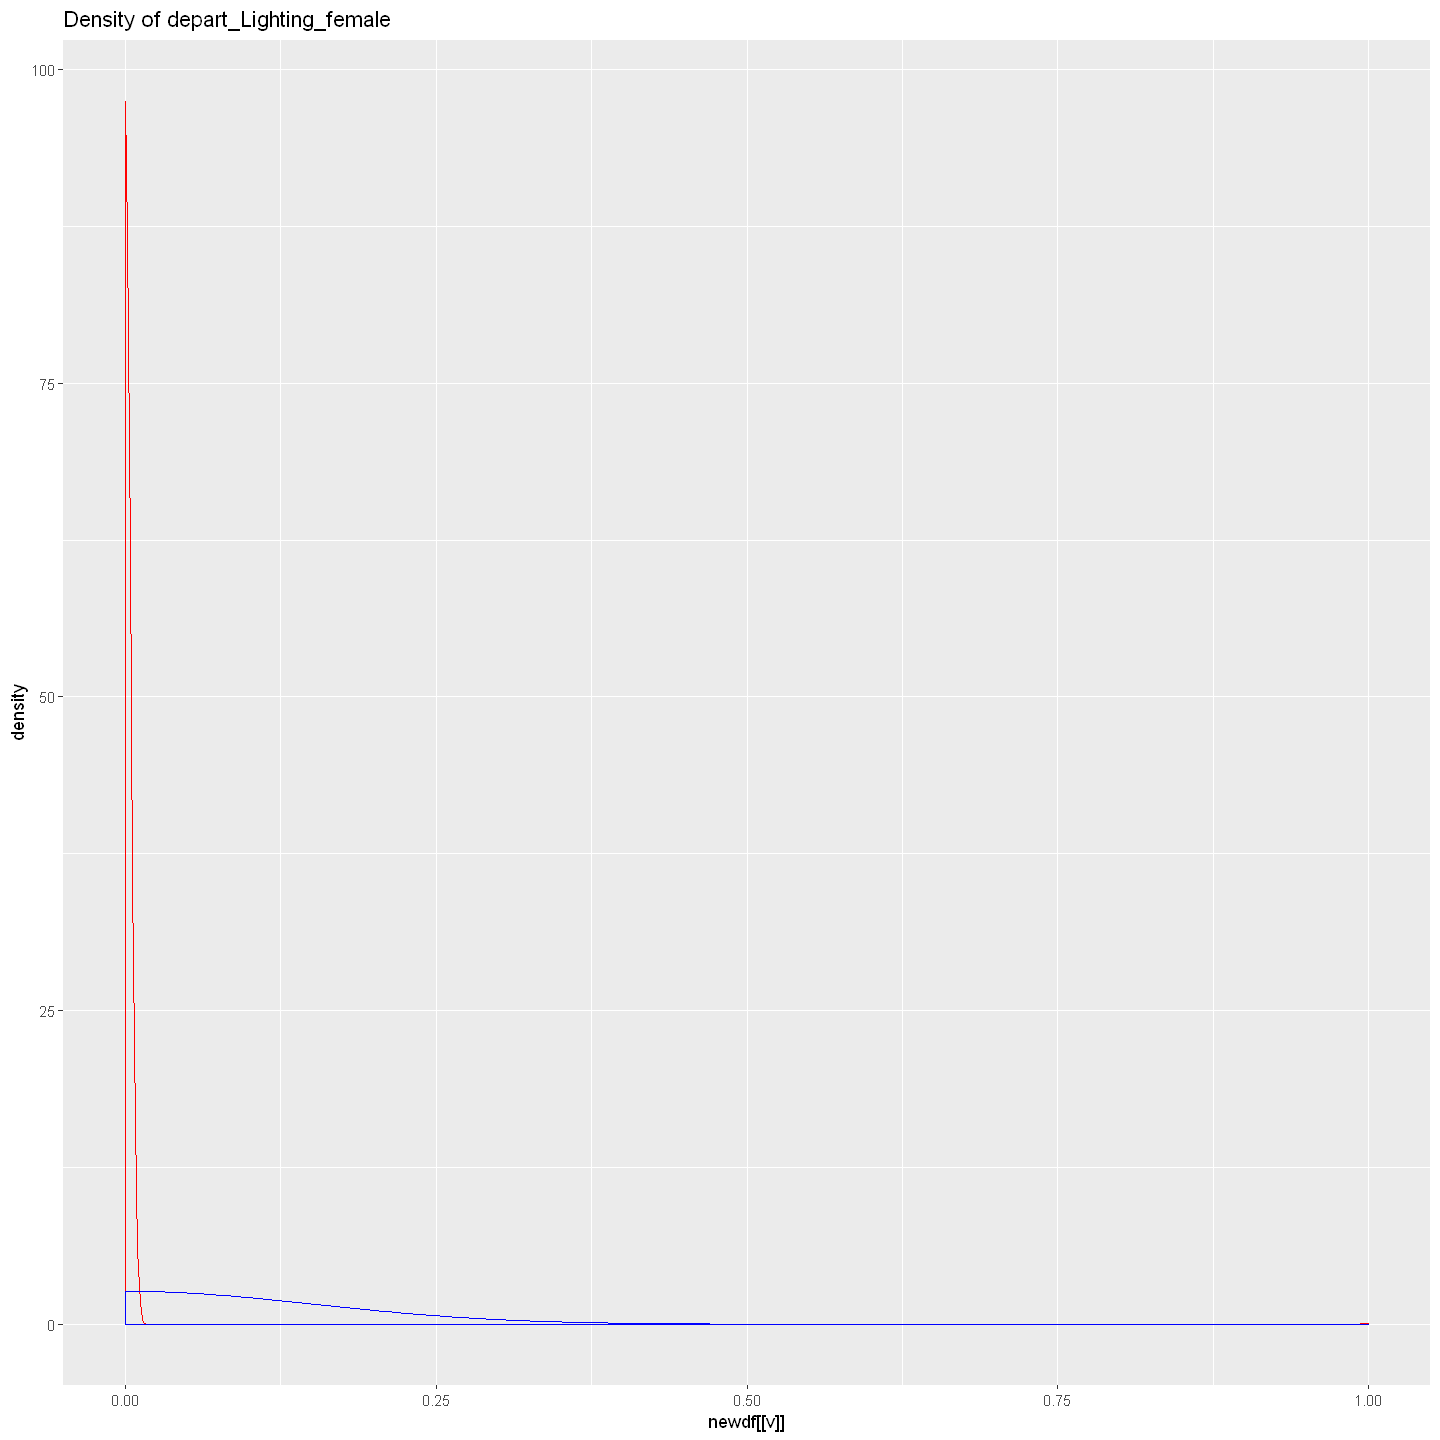

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 535 rows containing non-finite values (stat_density)."


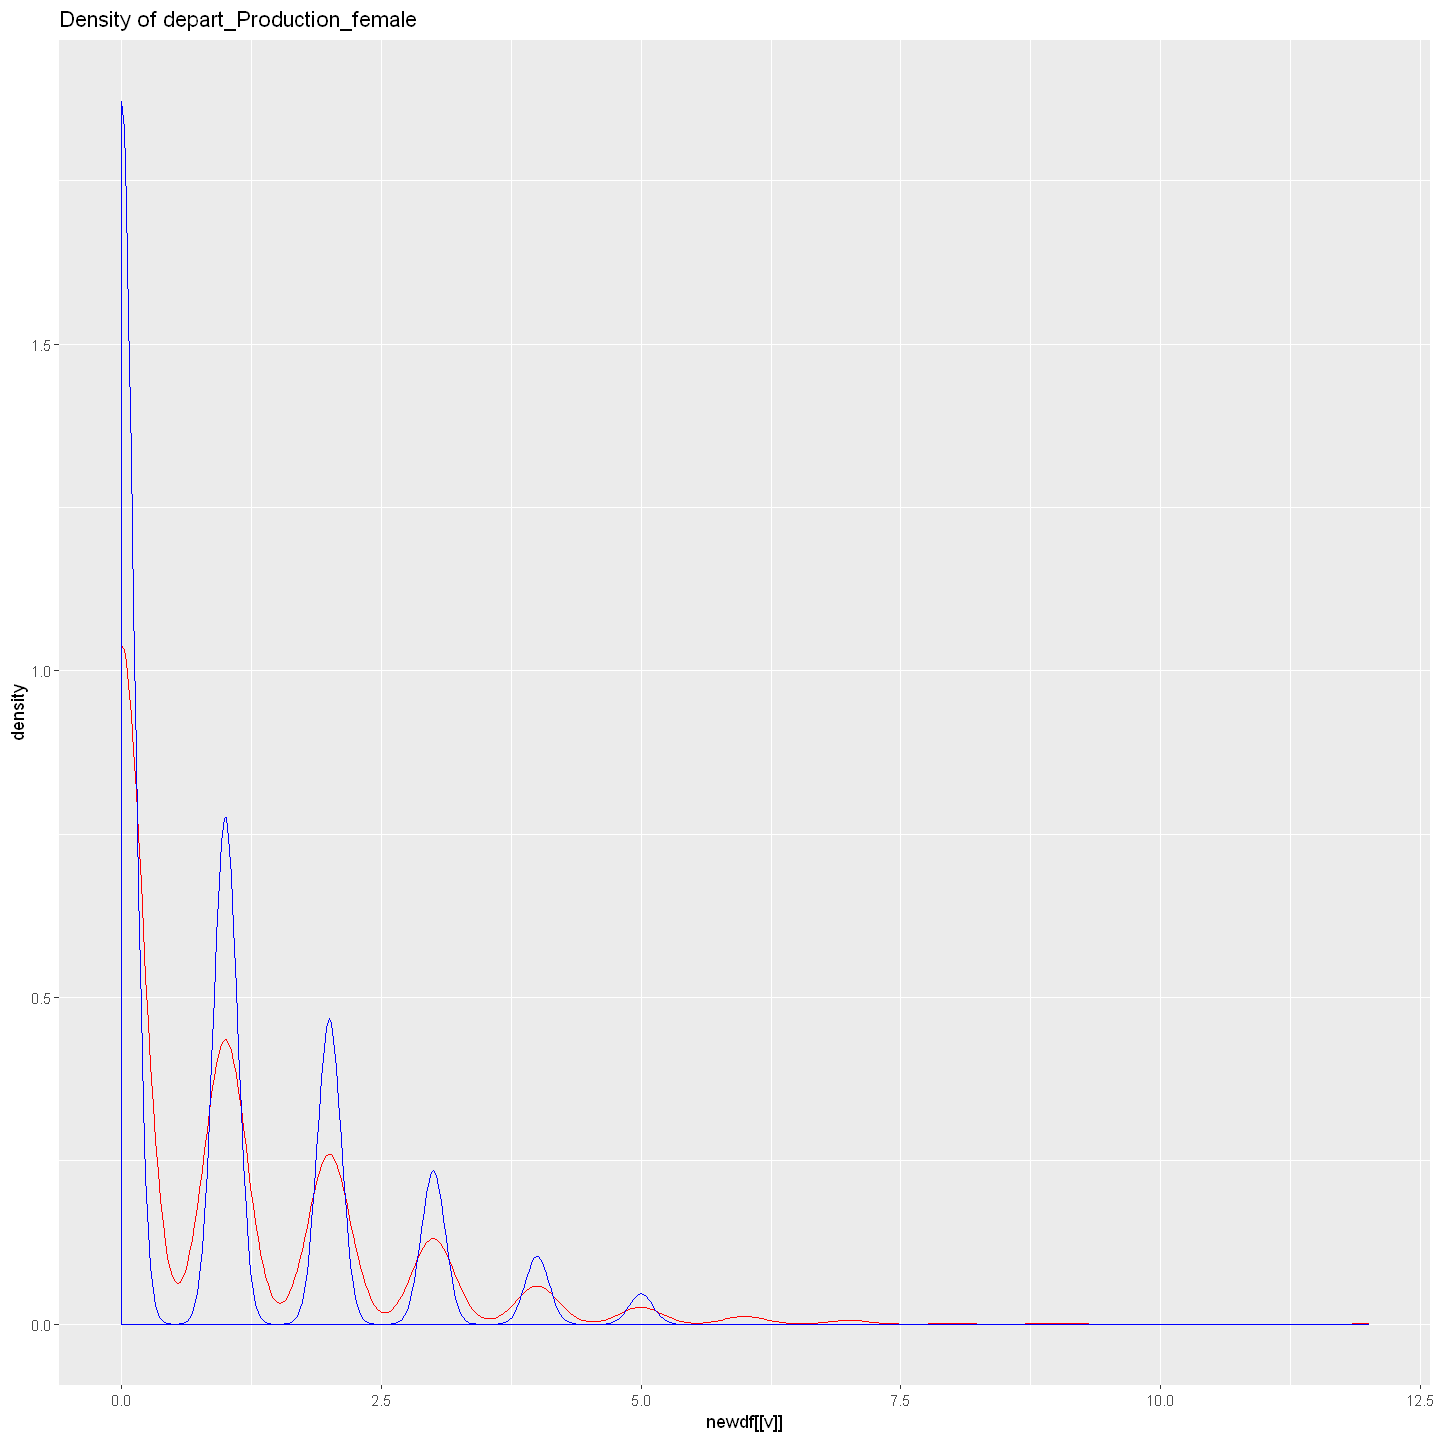

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 94 rows containing non-finite values (stat_density)."


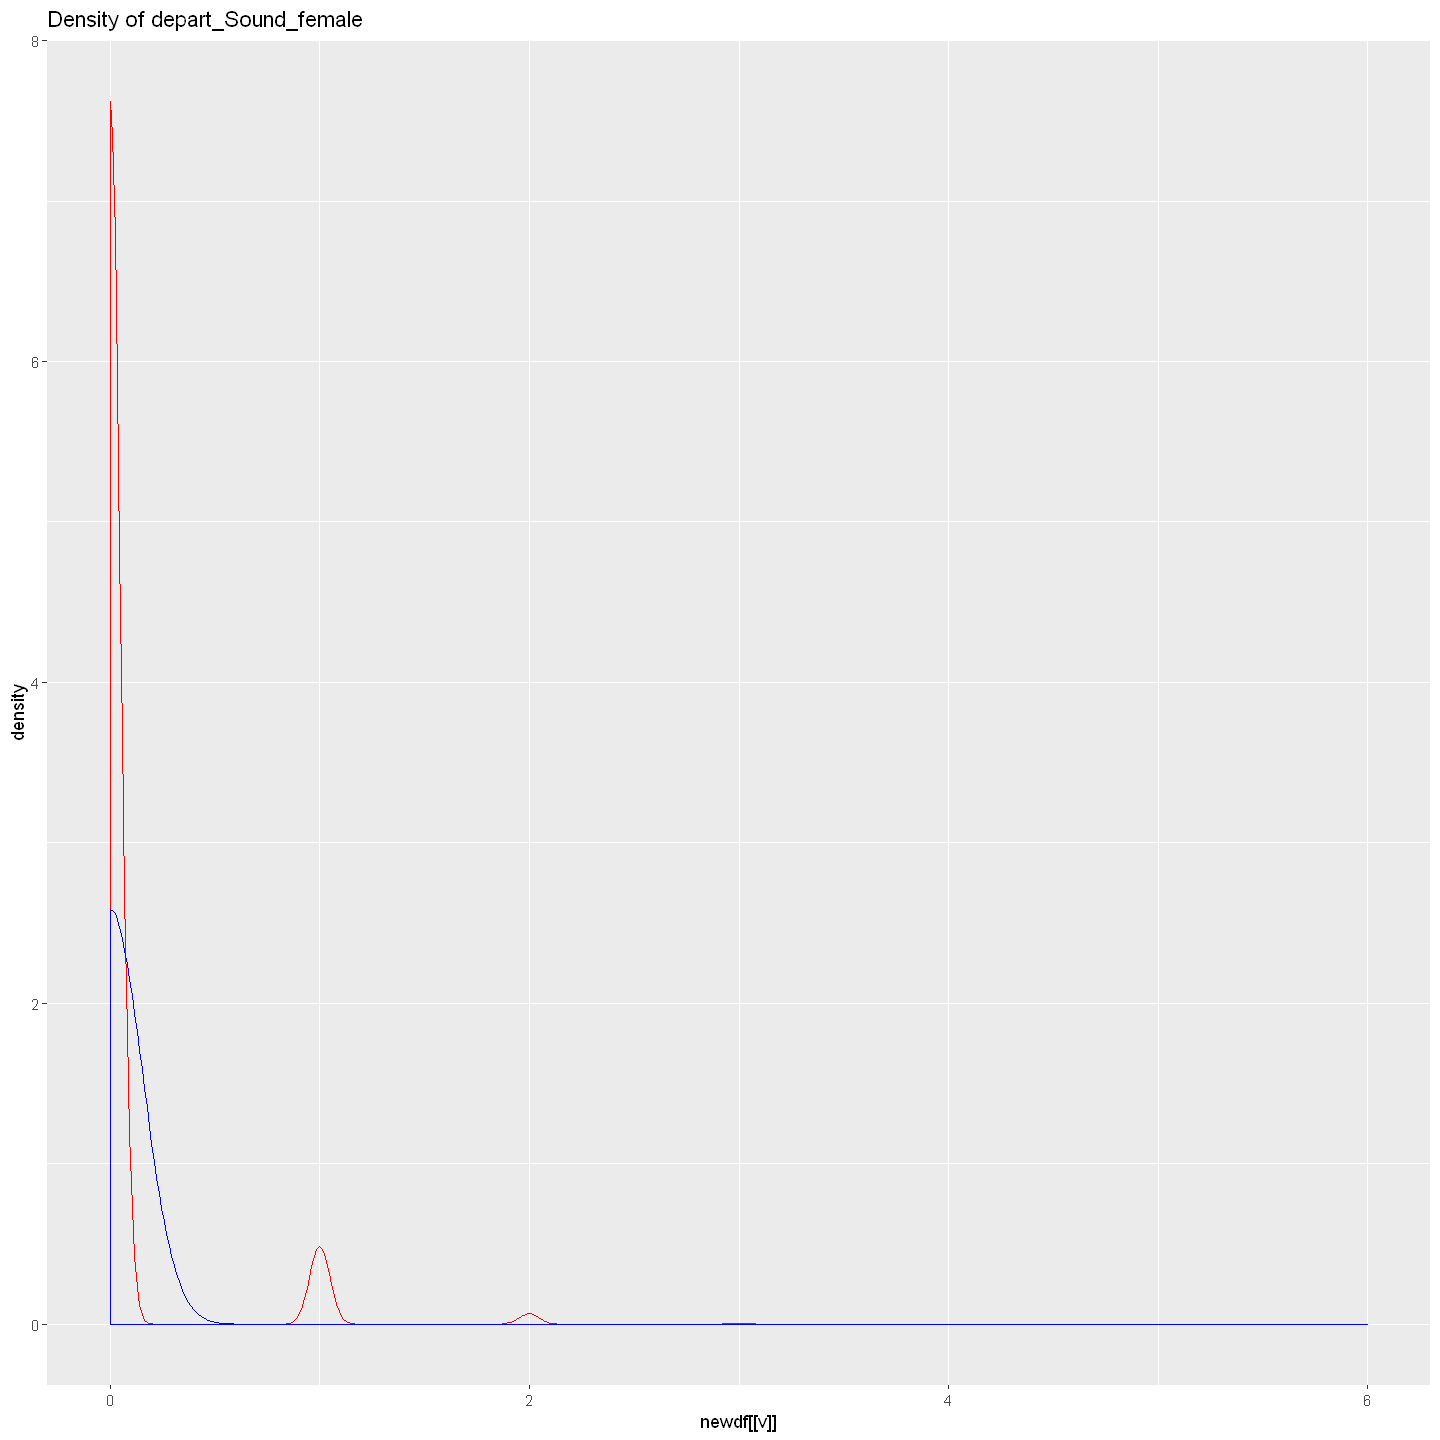

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Warning message:
"Removed 797 rows containing non-finite values (stat_density)."


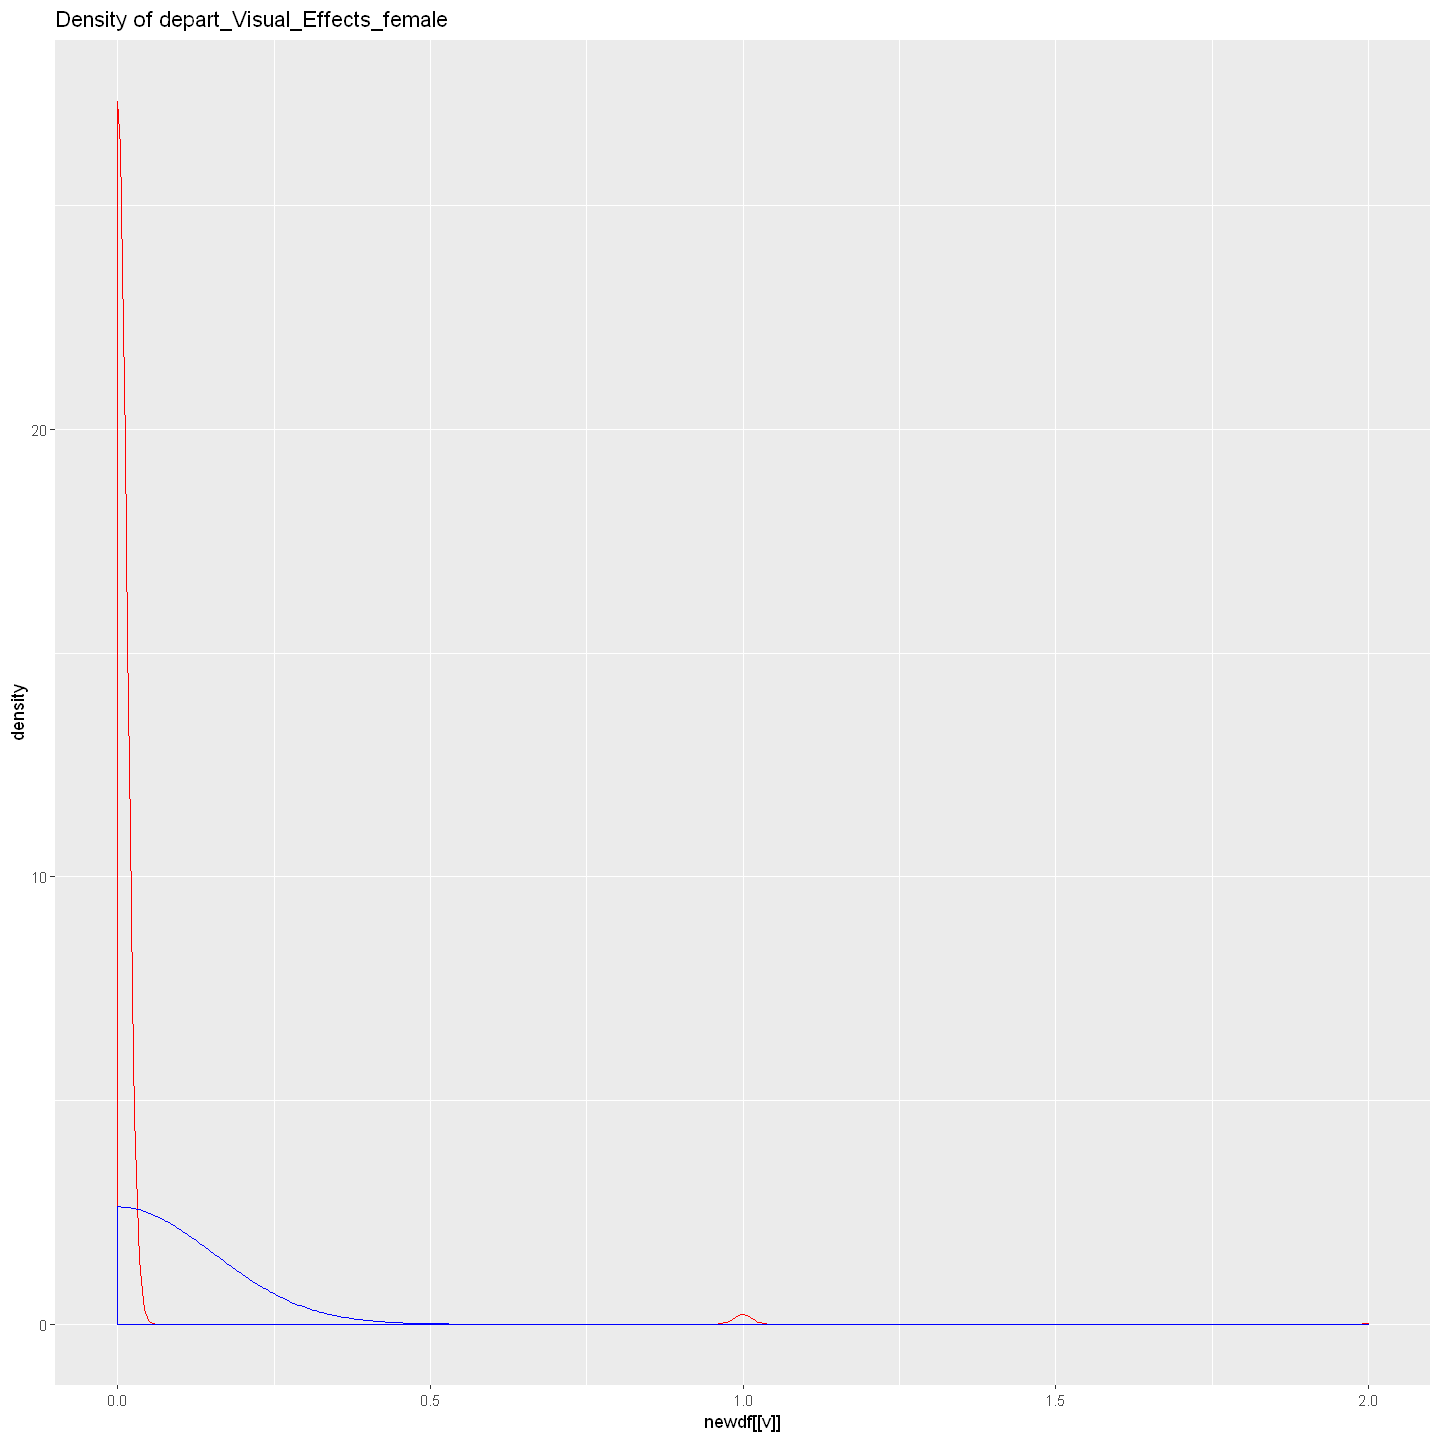

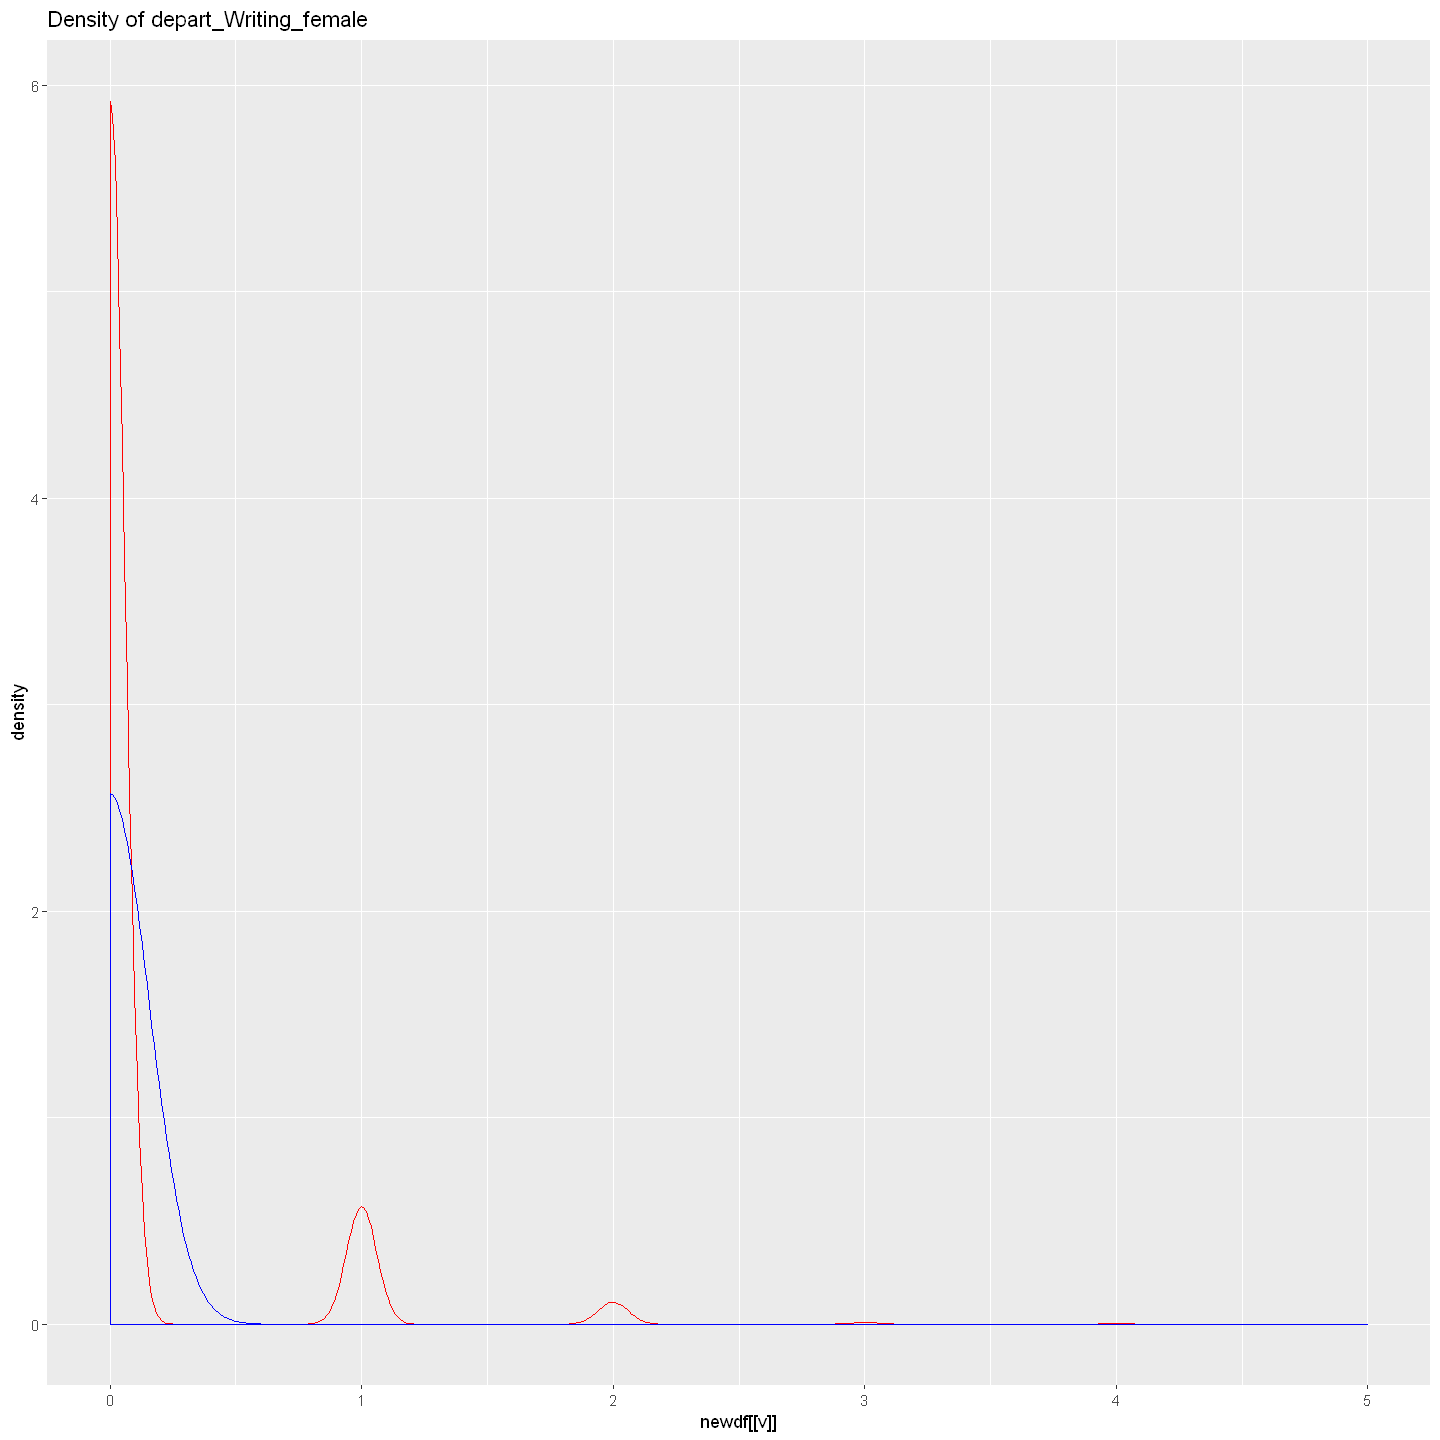

In [135]:

 
options(repr.plot.width = 12, repr.plot.height = 12) 
for (v in names(my_num_data[,2:82])){
    v_out <-paste0(v,"_out") 
    v.noout <- newdf[[v]]
    v.noout <- ifelse(newdf[[v_out]]==1,NA,v.noout)
    print( ggplot() + 
          geom_density(aes(newdf[[v]]) , color = "red" ) + 
          geom_density(aes(v.noout) , color ="blue") + ggtitle(paste("Density of",v)))


    
    
}

# 3.1.2 outliers scatter and lm regression

Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4631 rows containing missing values (geom_point)."


TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


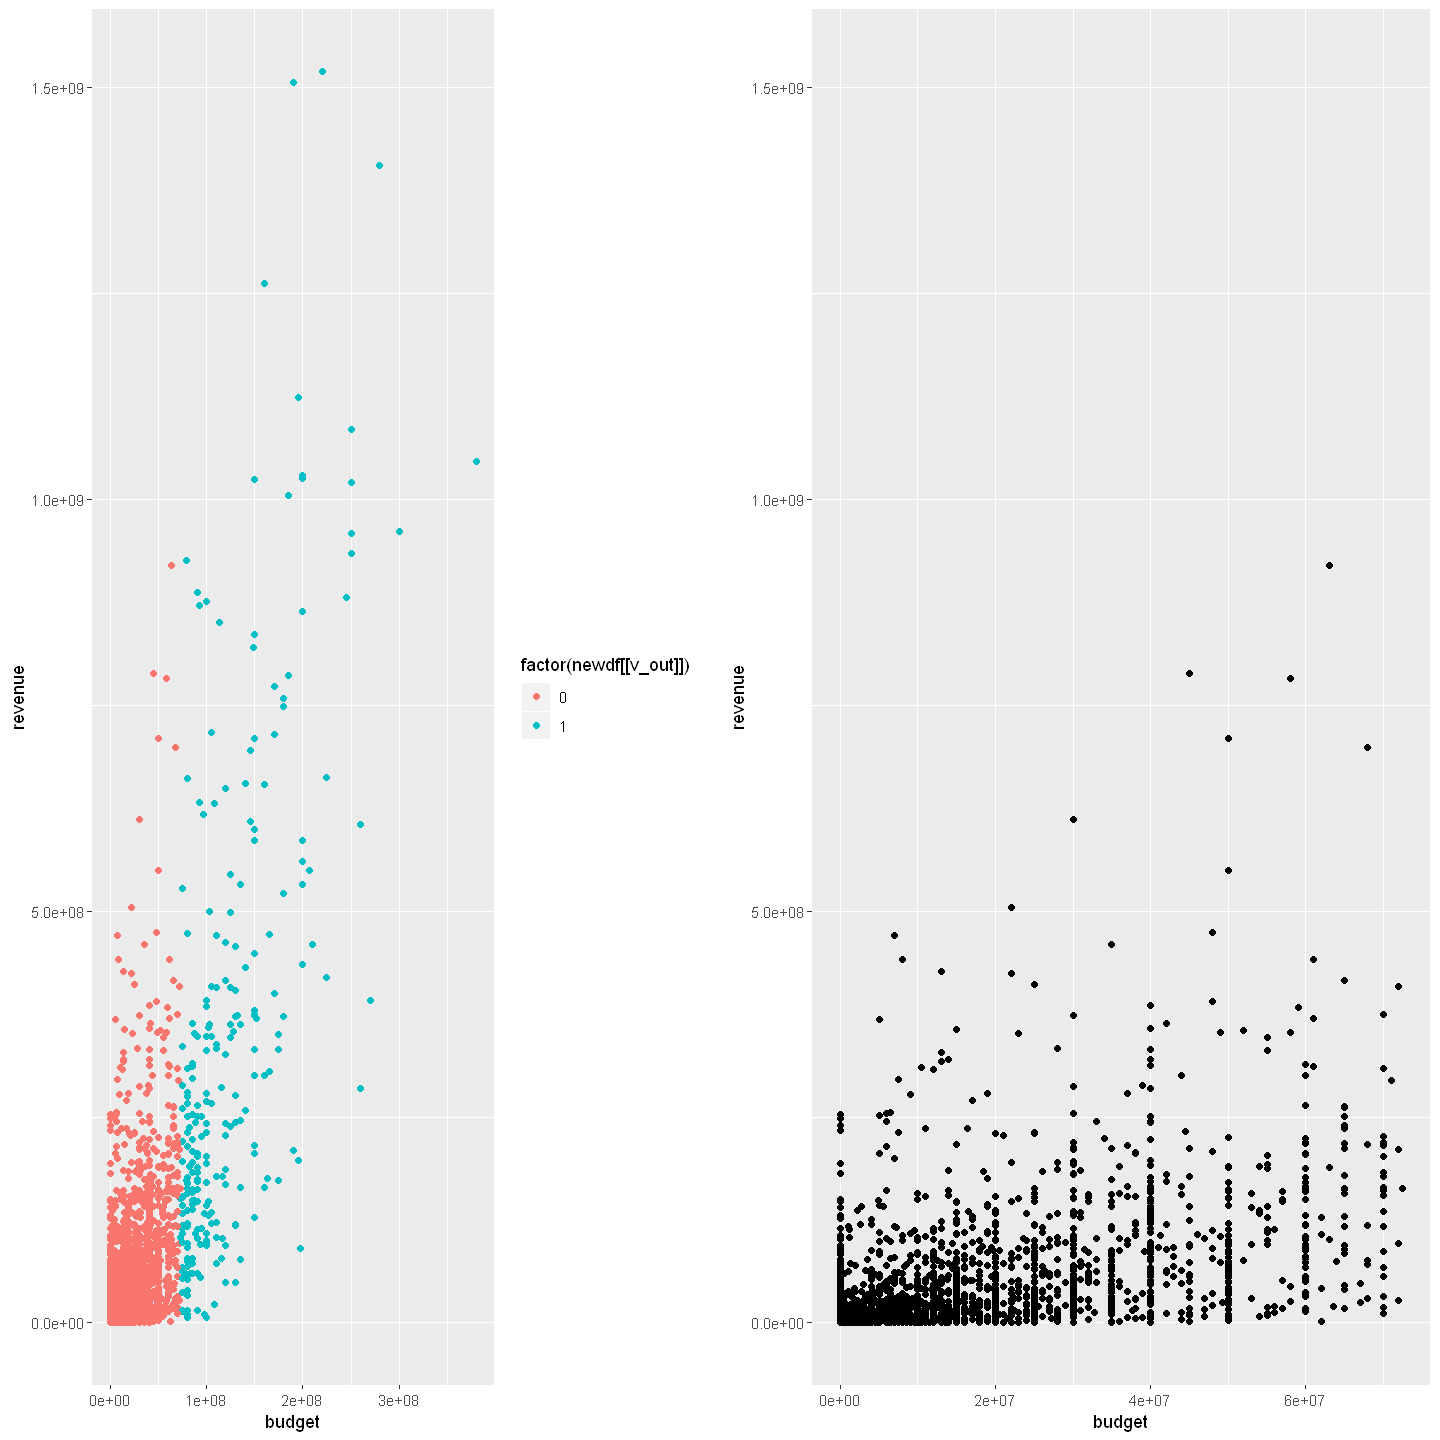

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4451 rows containing missing values (geom_point)."


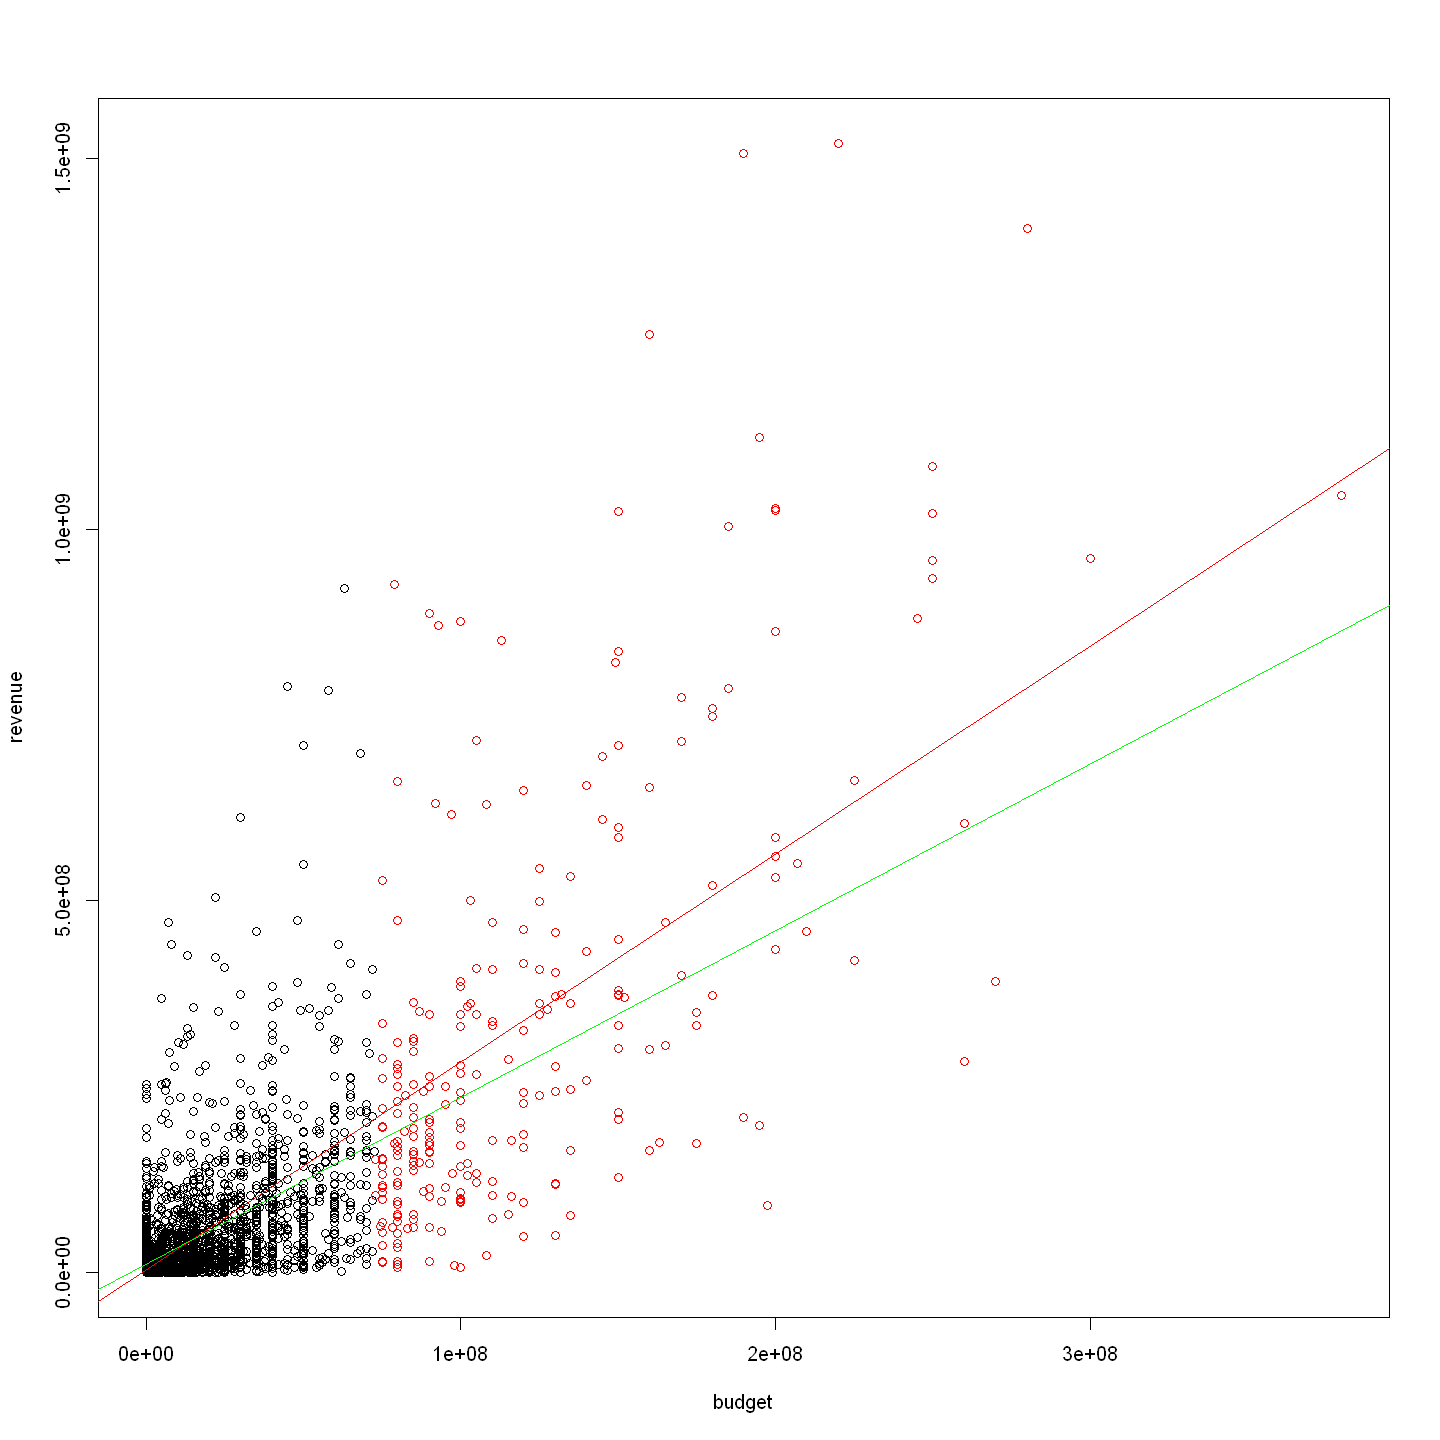

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


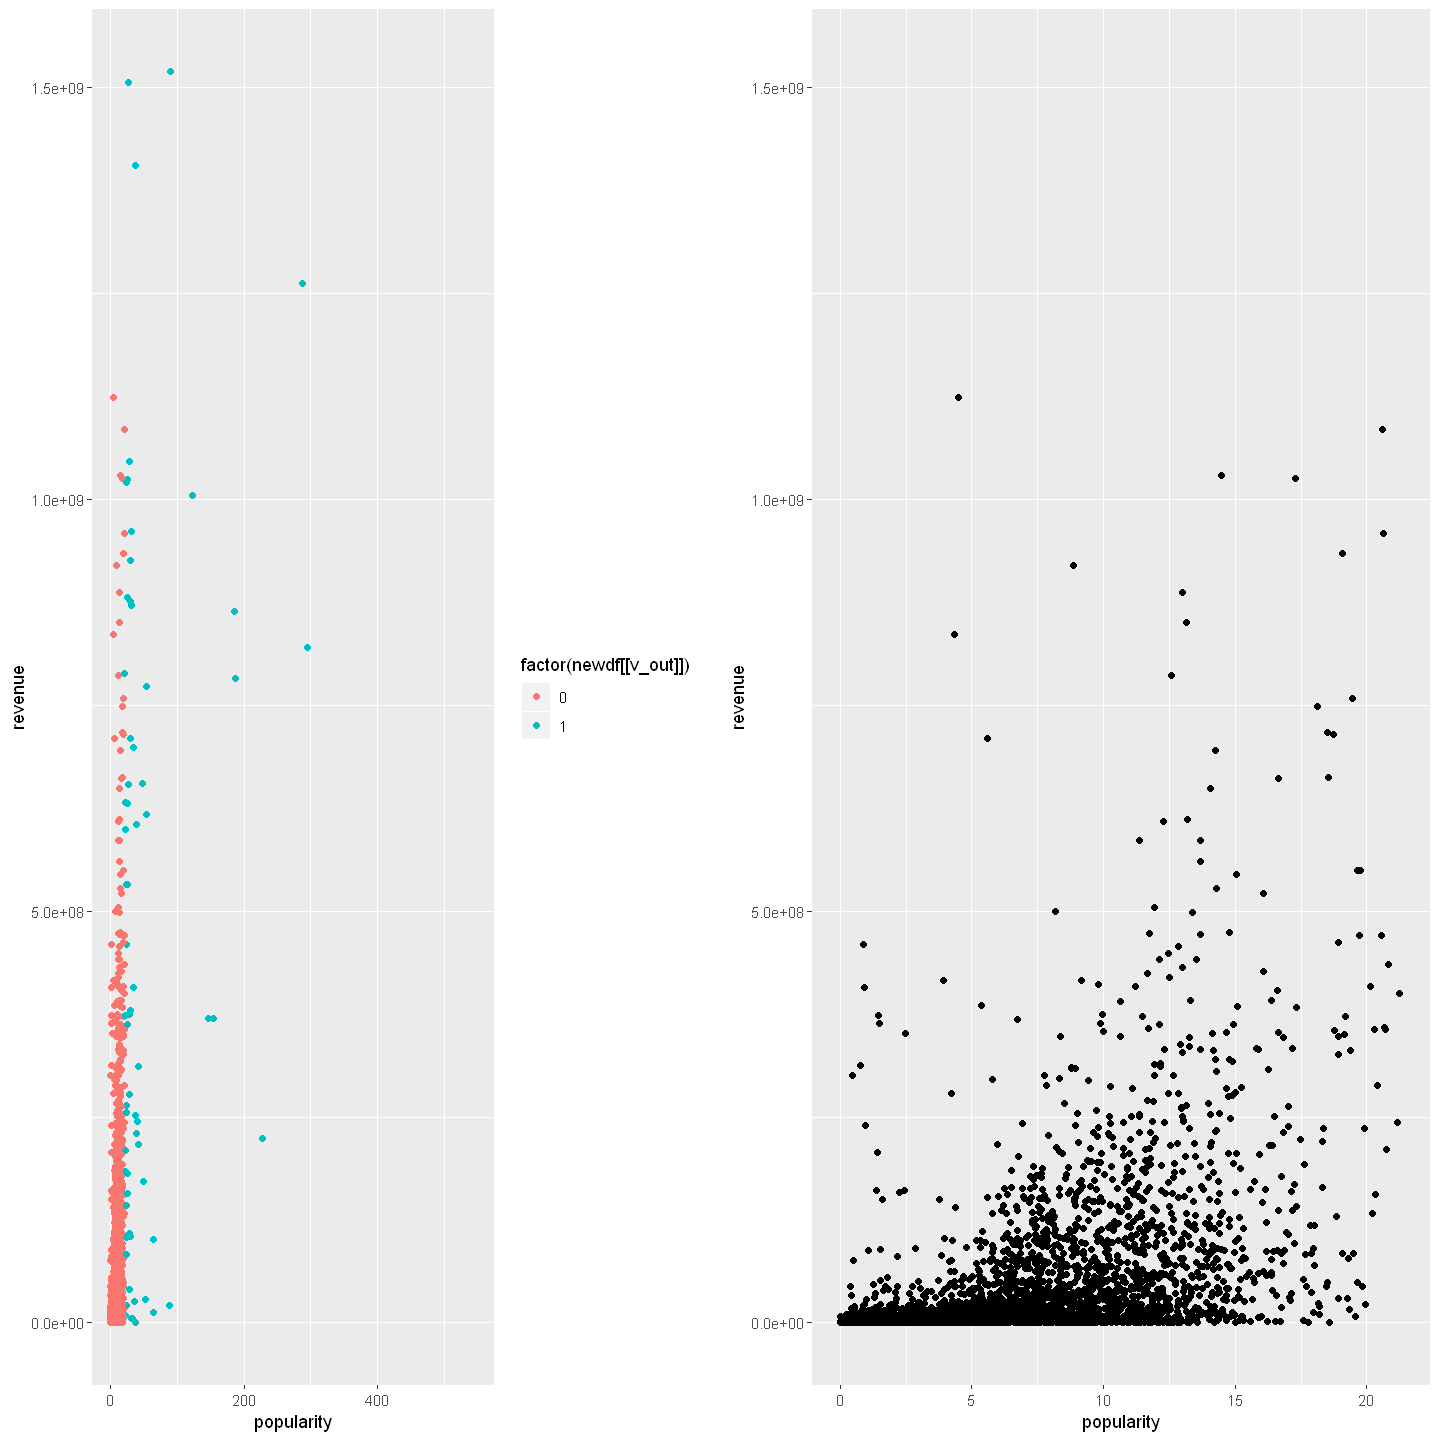

NULL
NULL


Warning message:
"Removed 4384 rows containing missing values (geom_point)."
Warning message:
"Removed 4509 rows containing missing values (geom_point)."


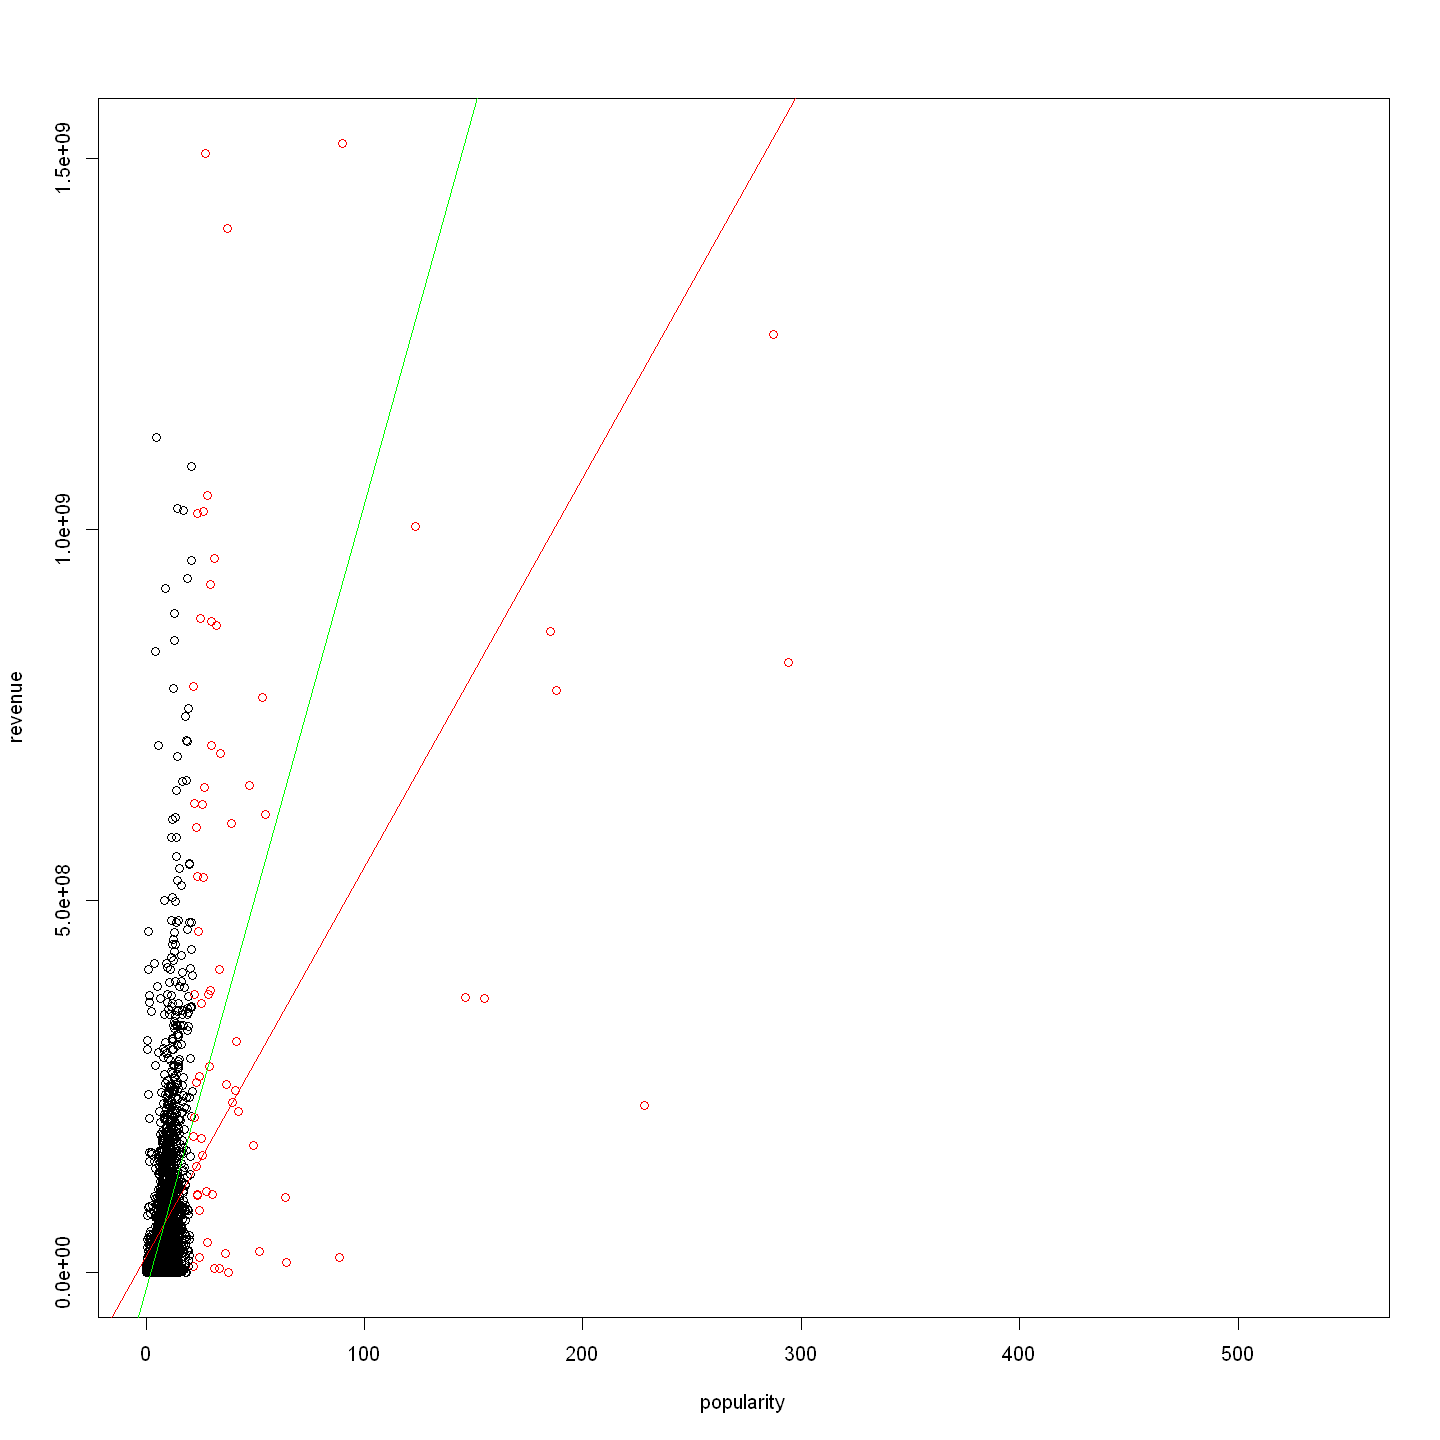

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


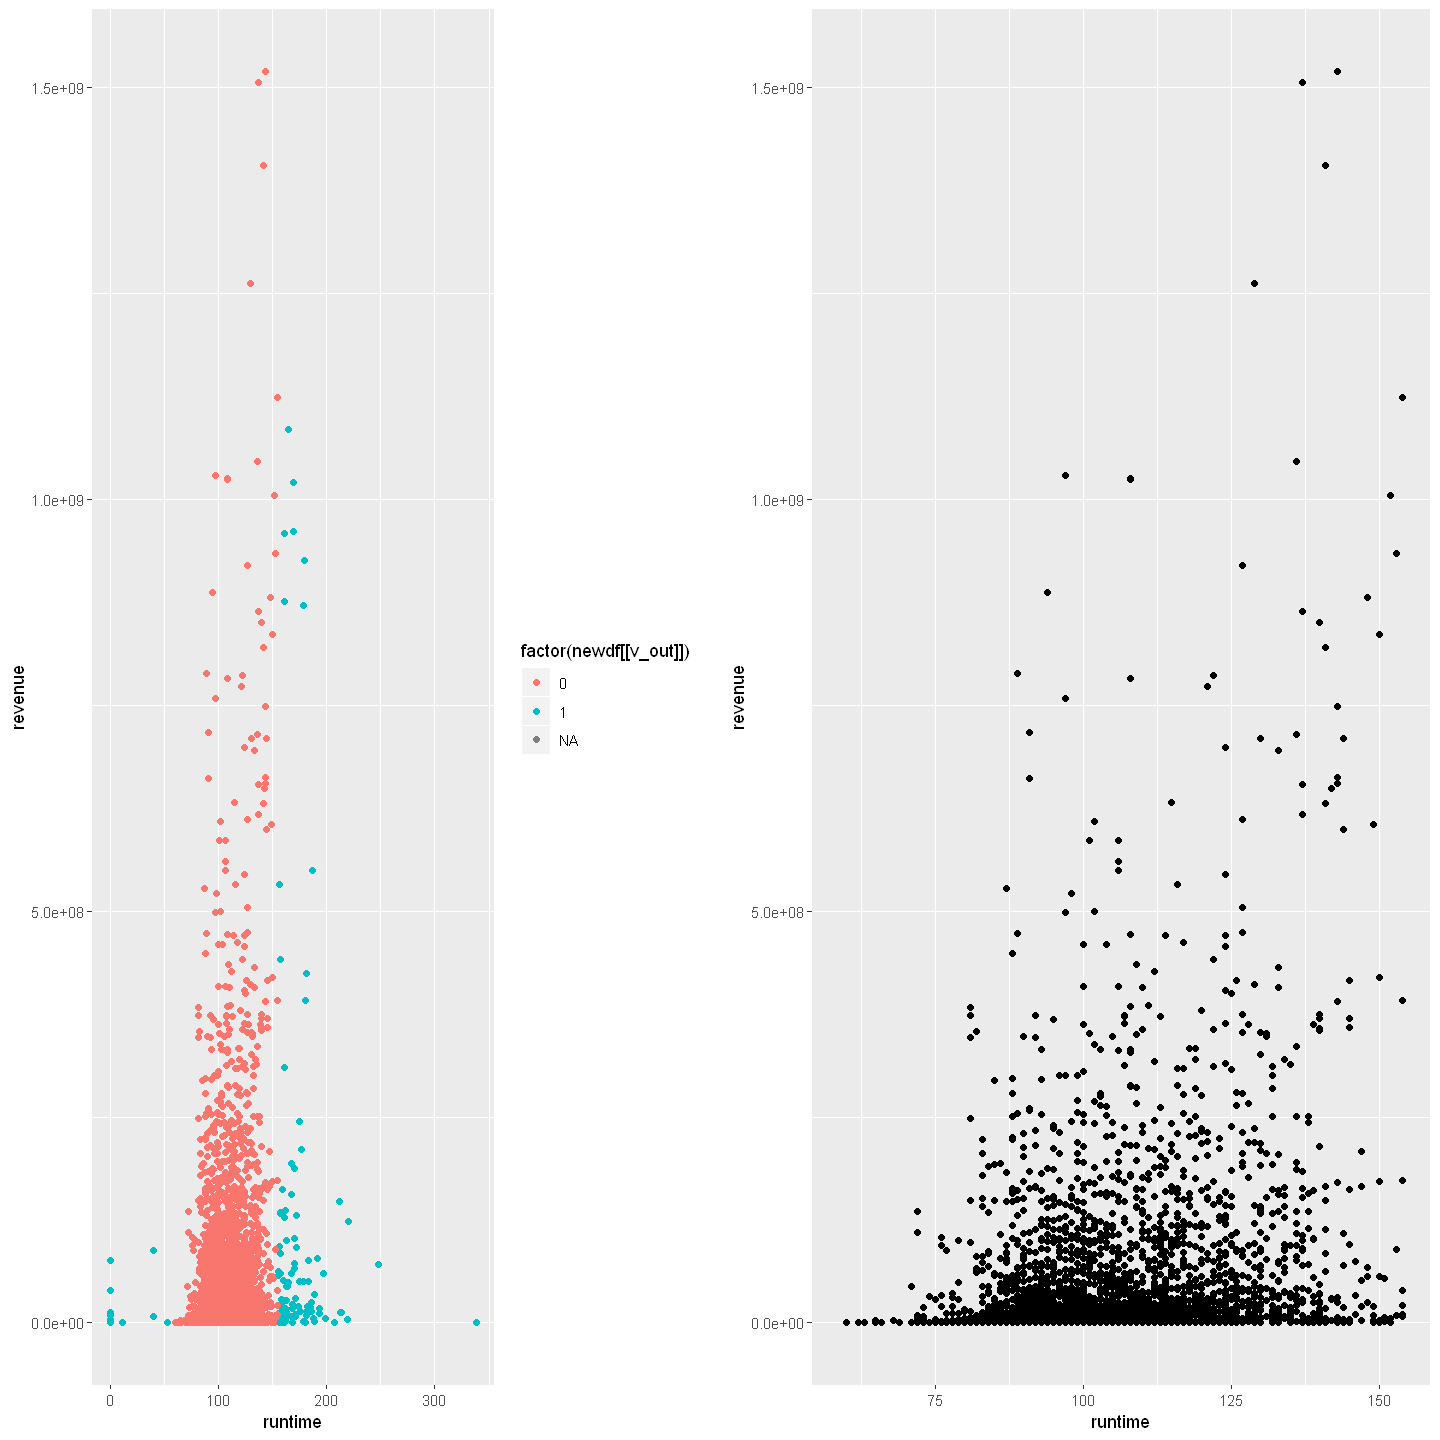

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4697 rows containing missing values (geom_point)."


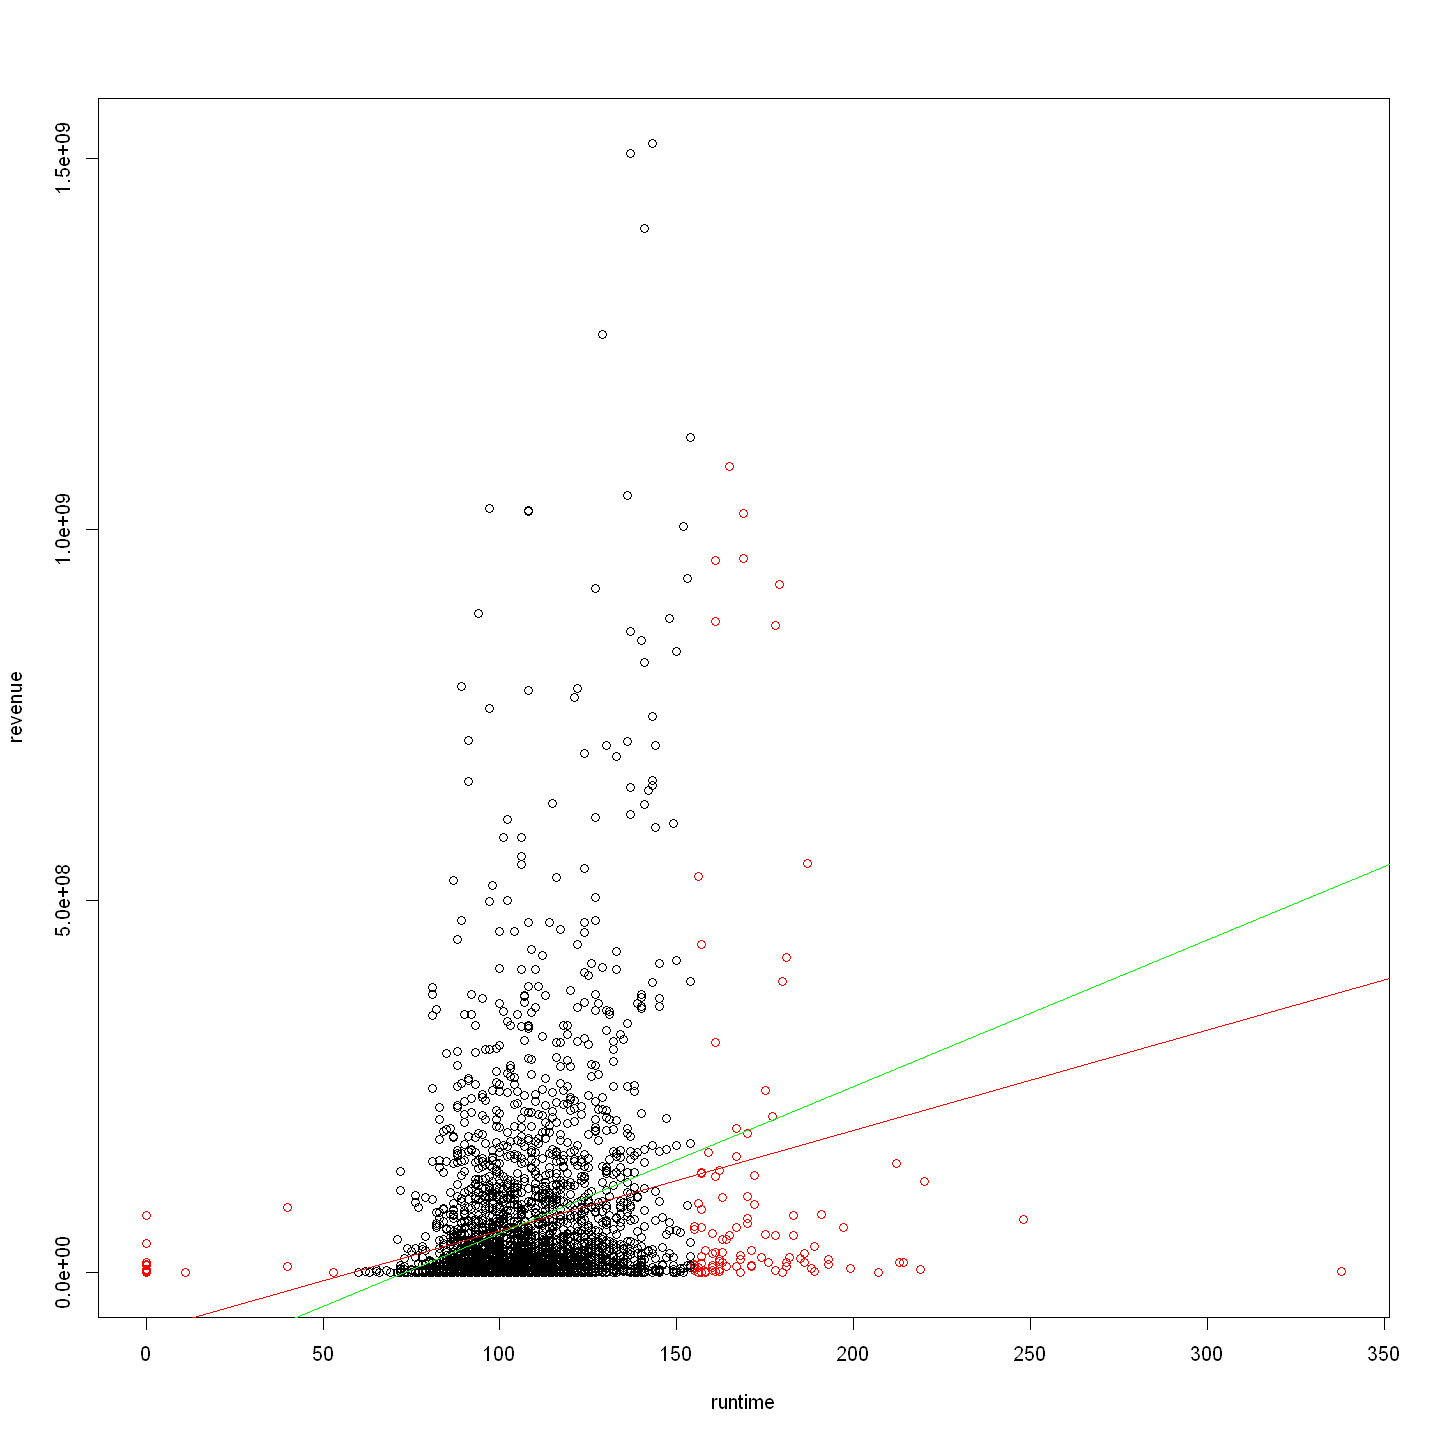

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


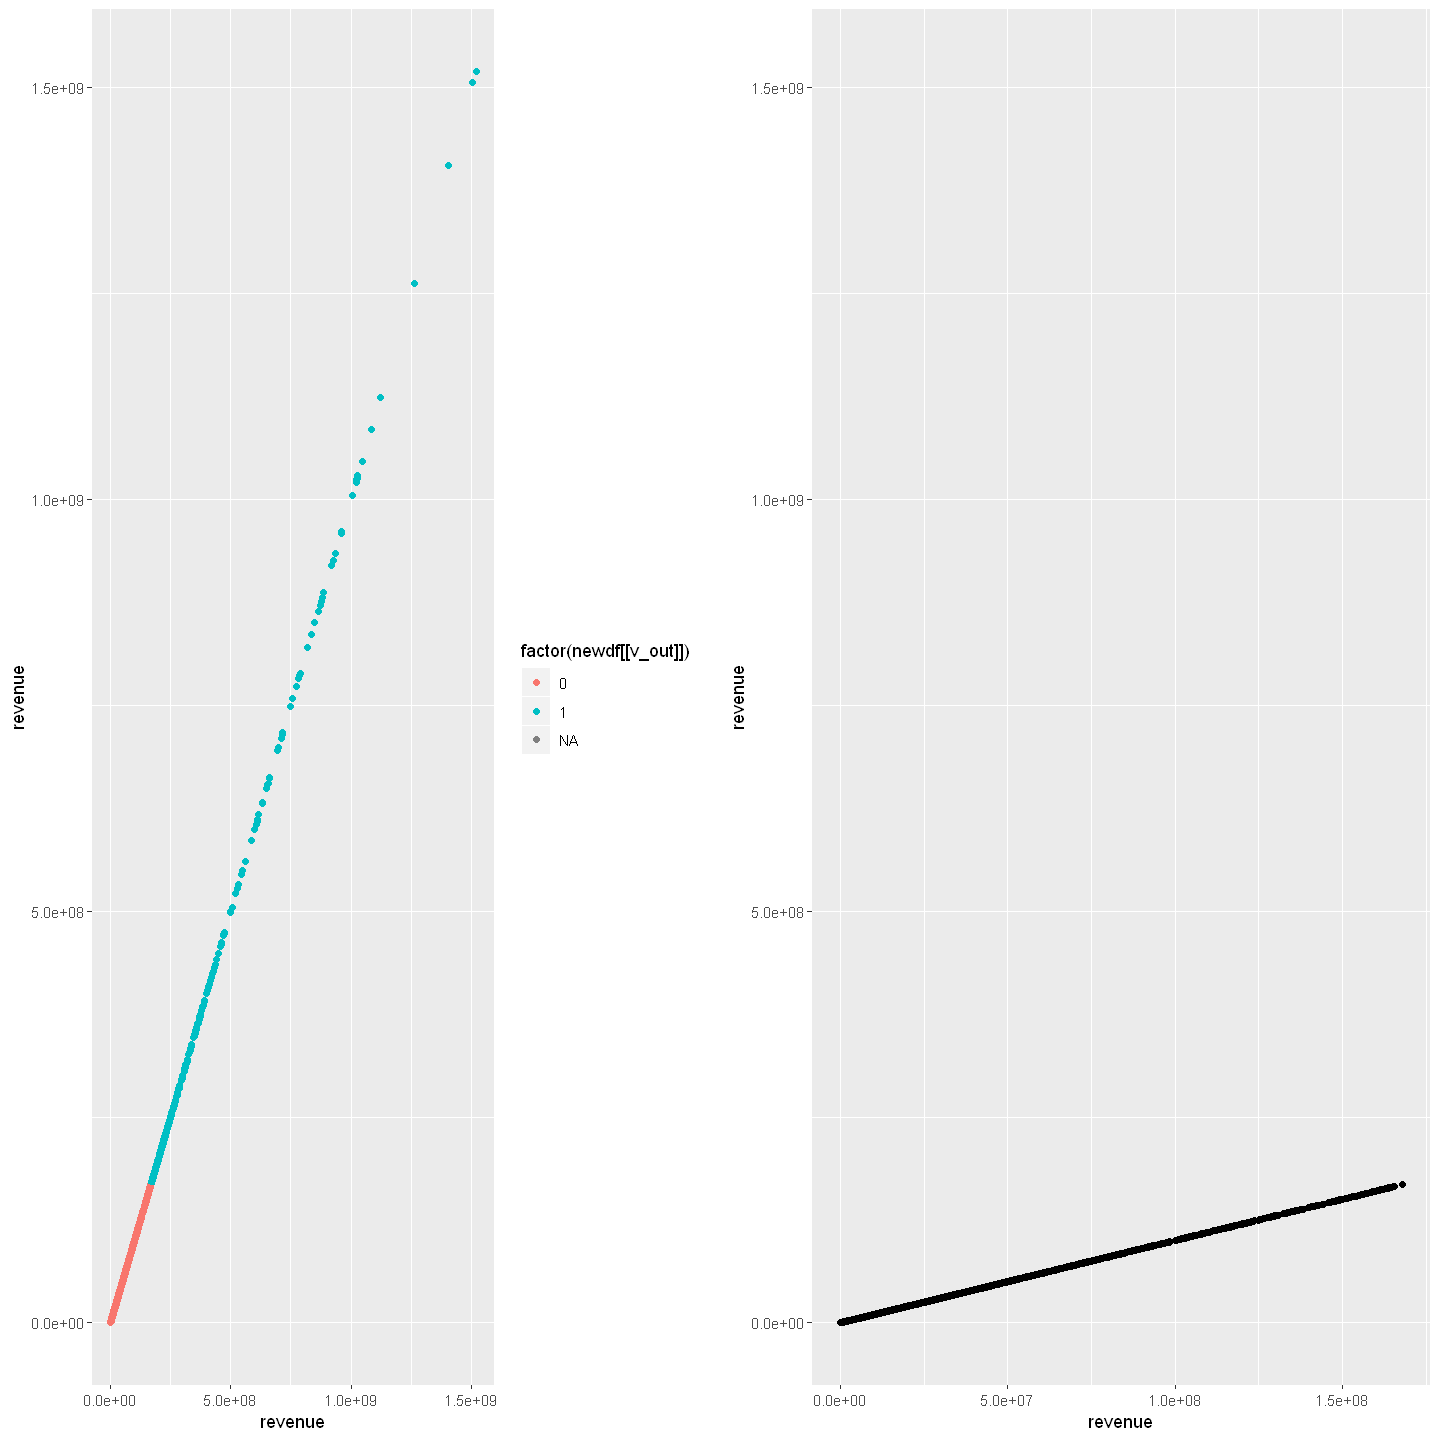

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4804 rows containing missing values (geom_point)."


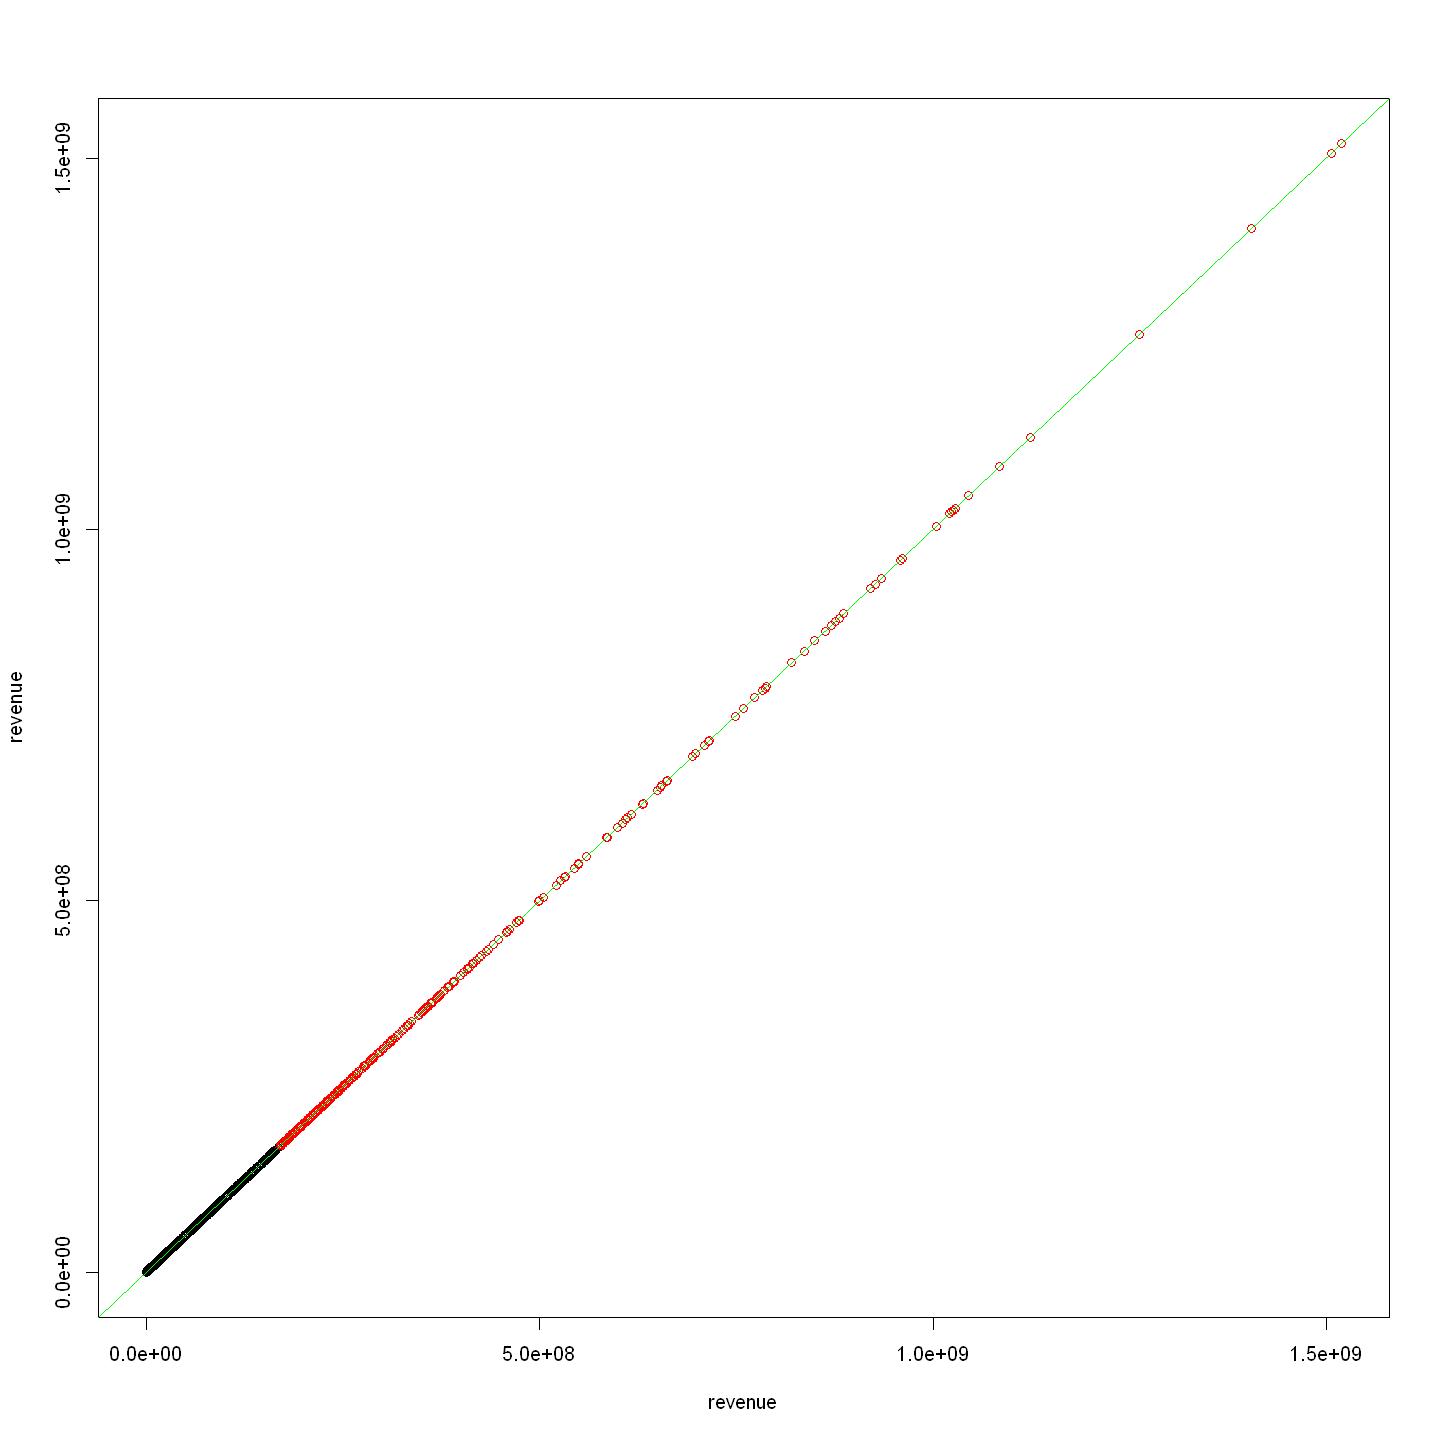

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


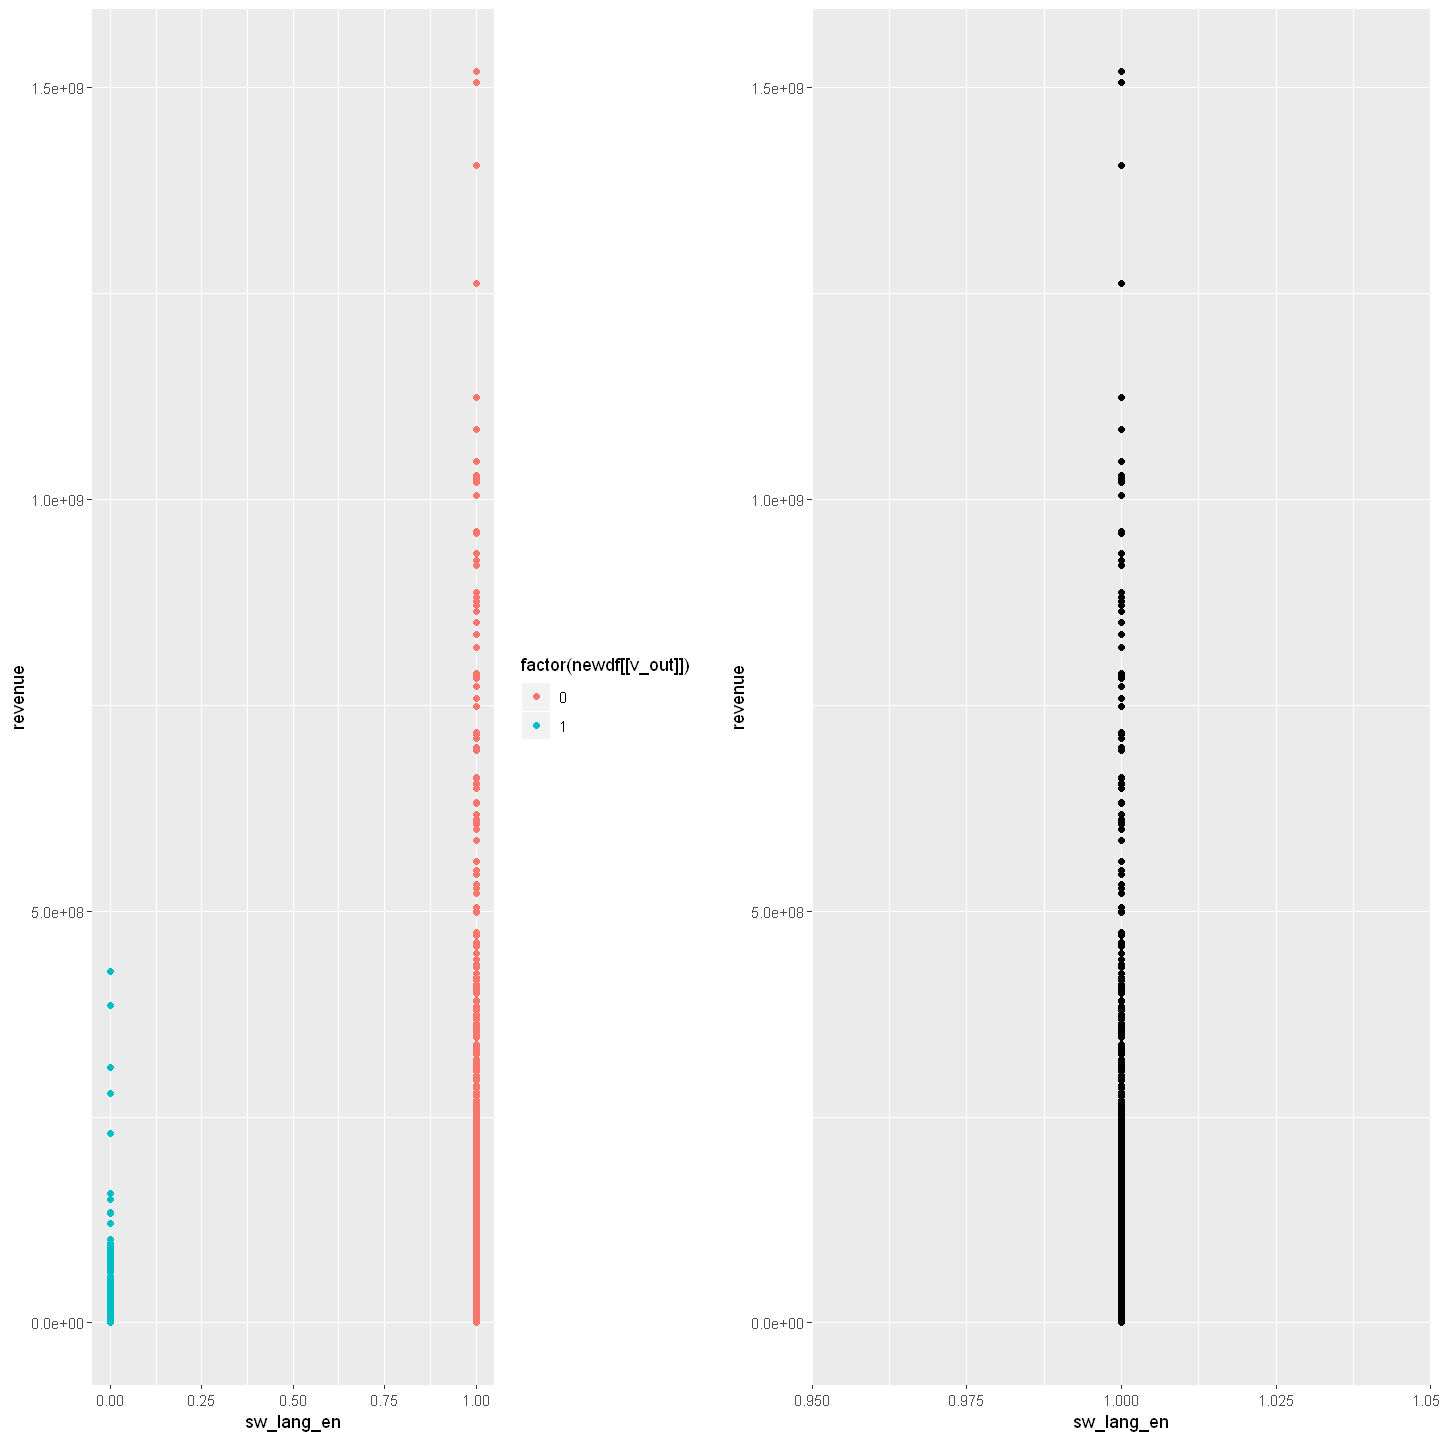

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4382 rows containing missing values (geom_point)."


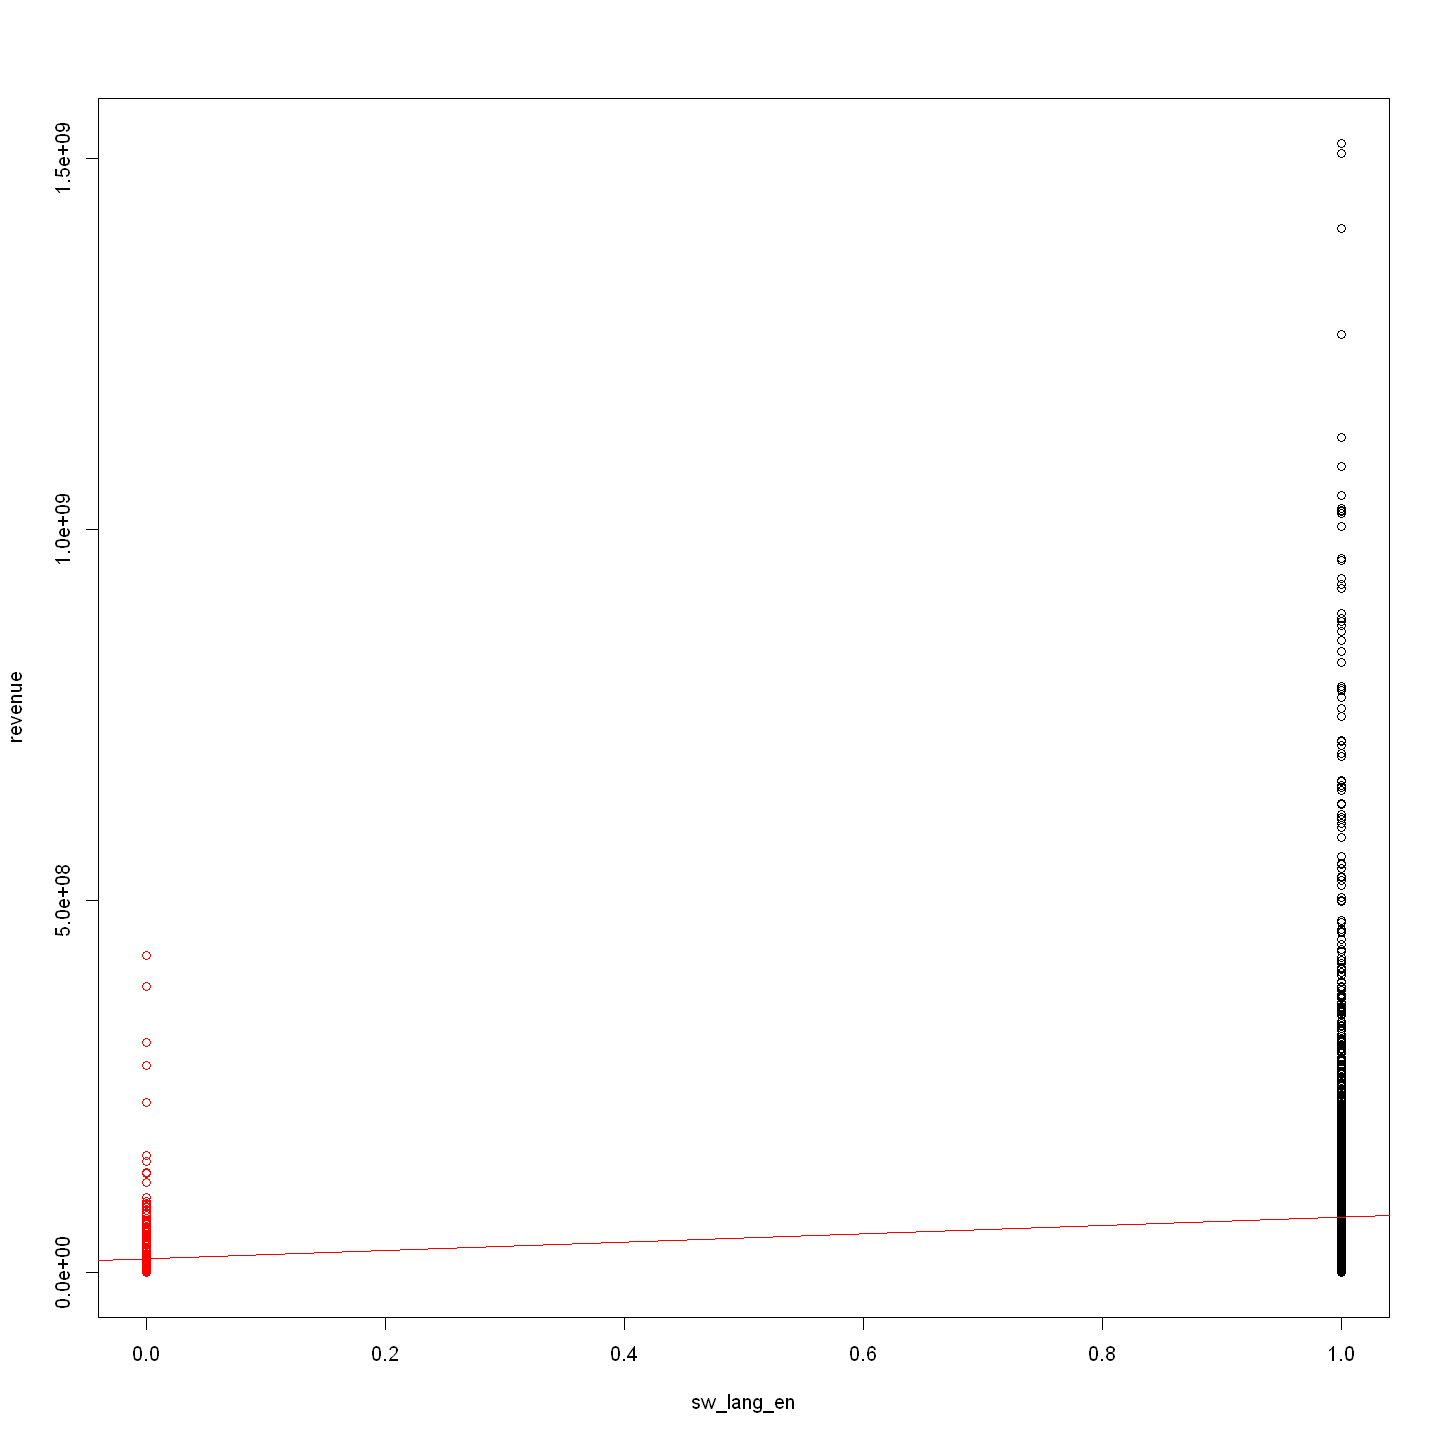

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


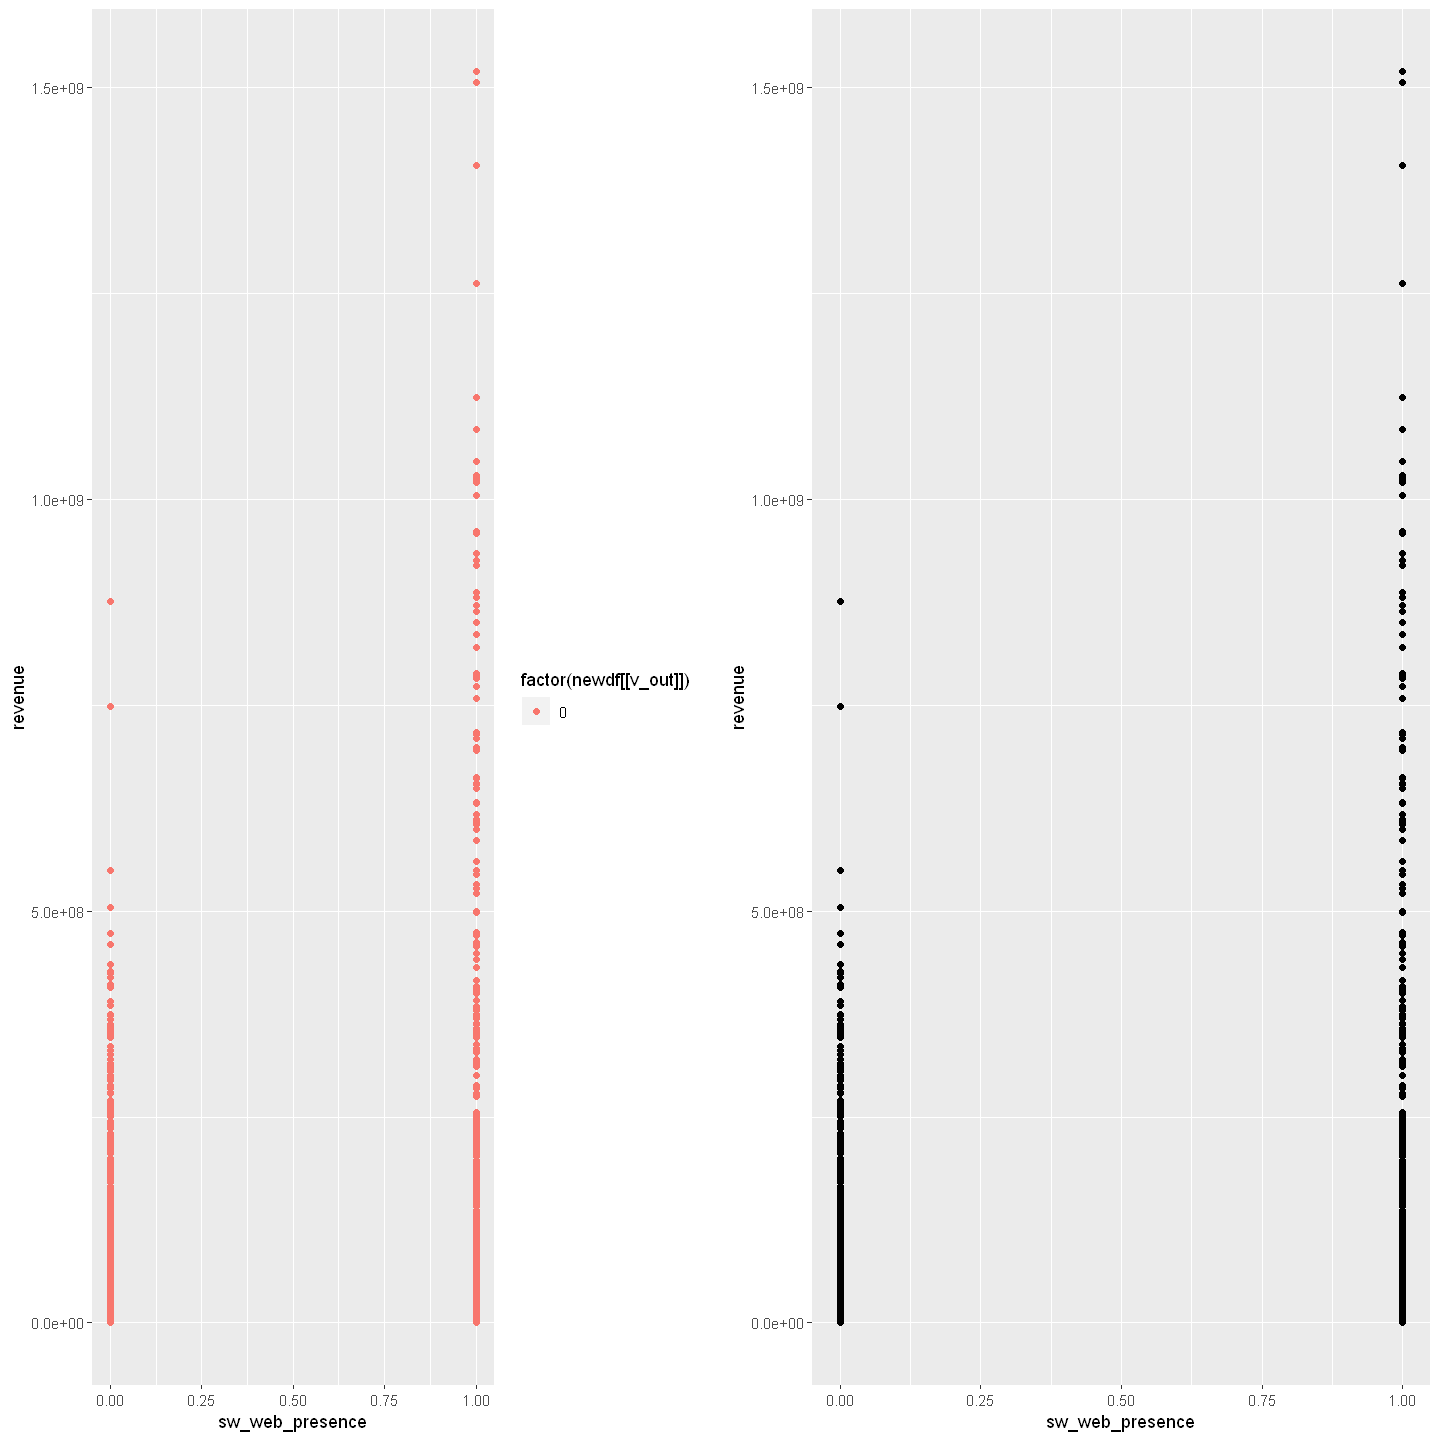

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4383 rows containing missing values (geom_point)."


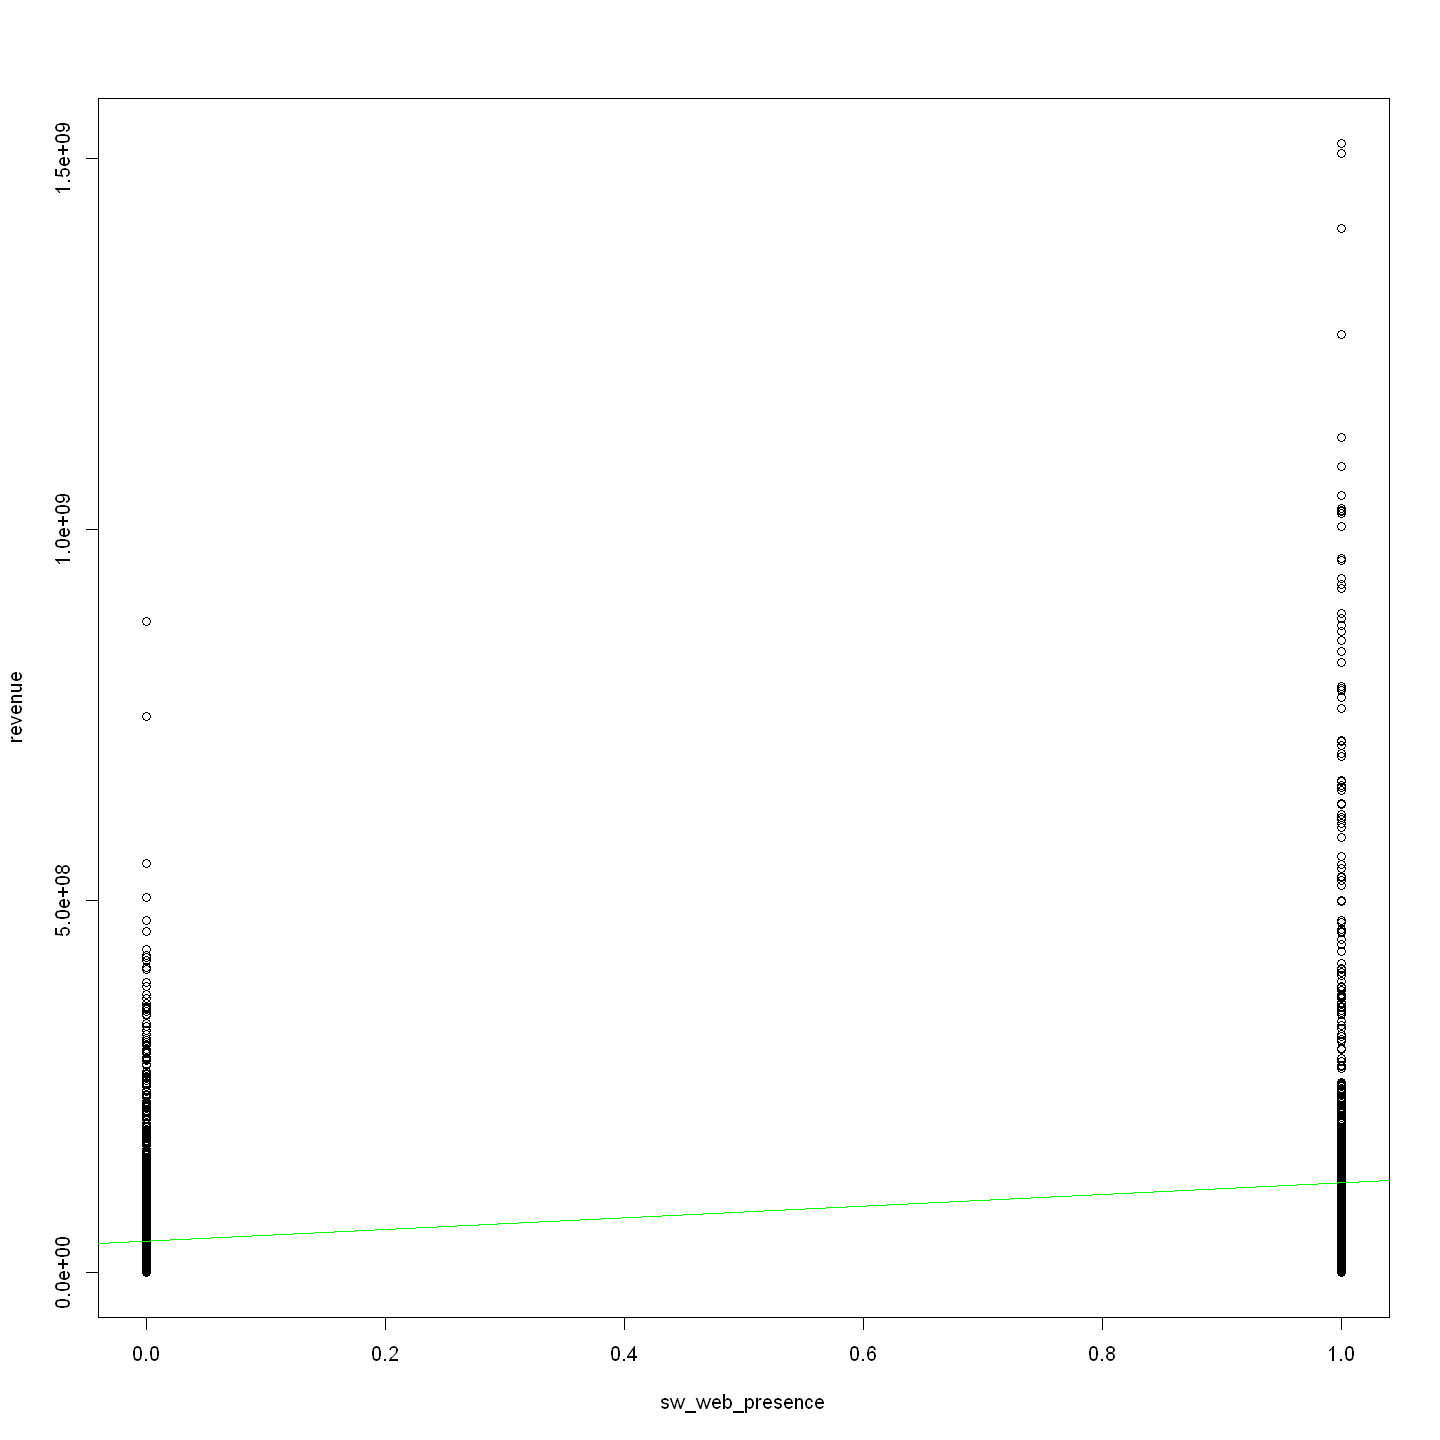

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


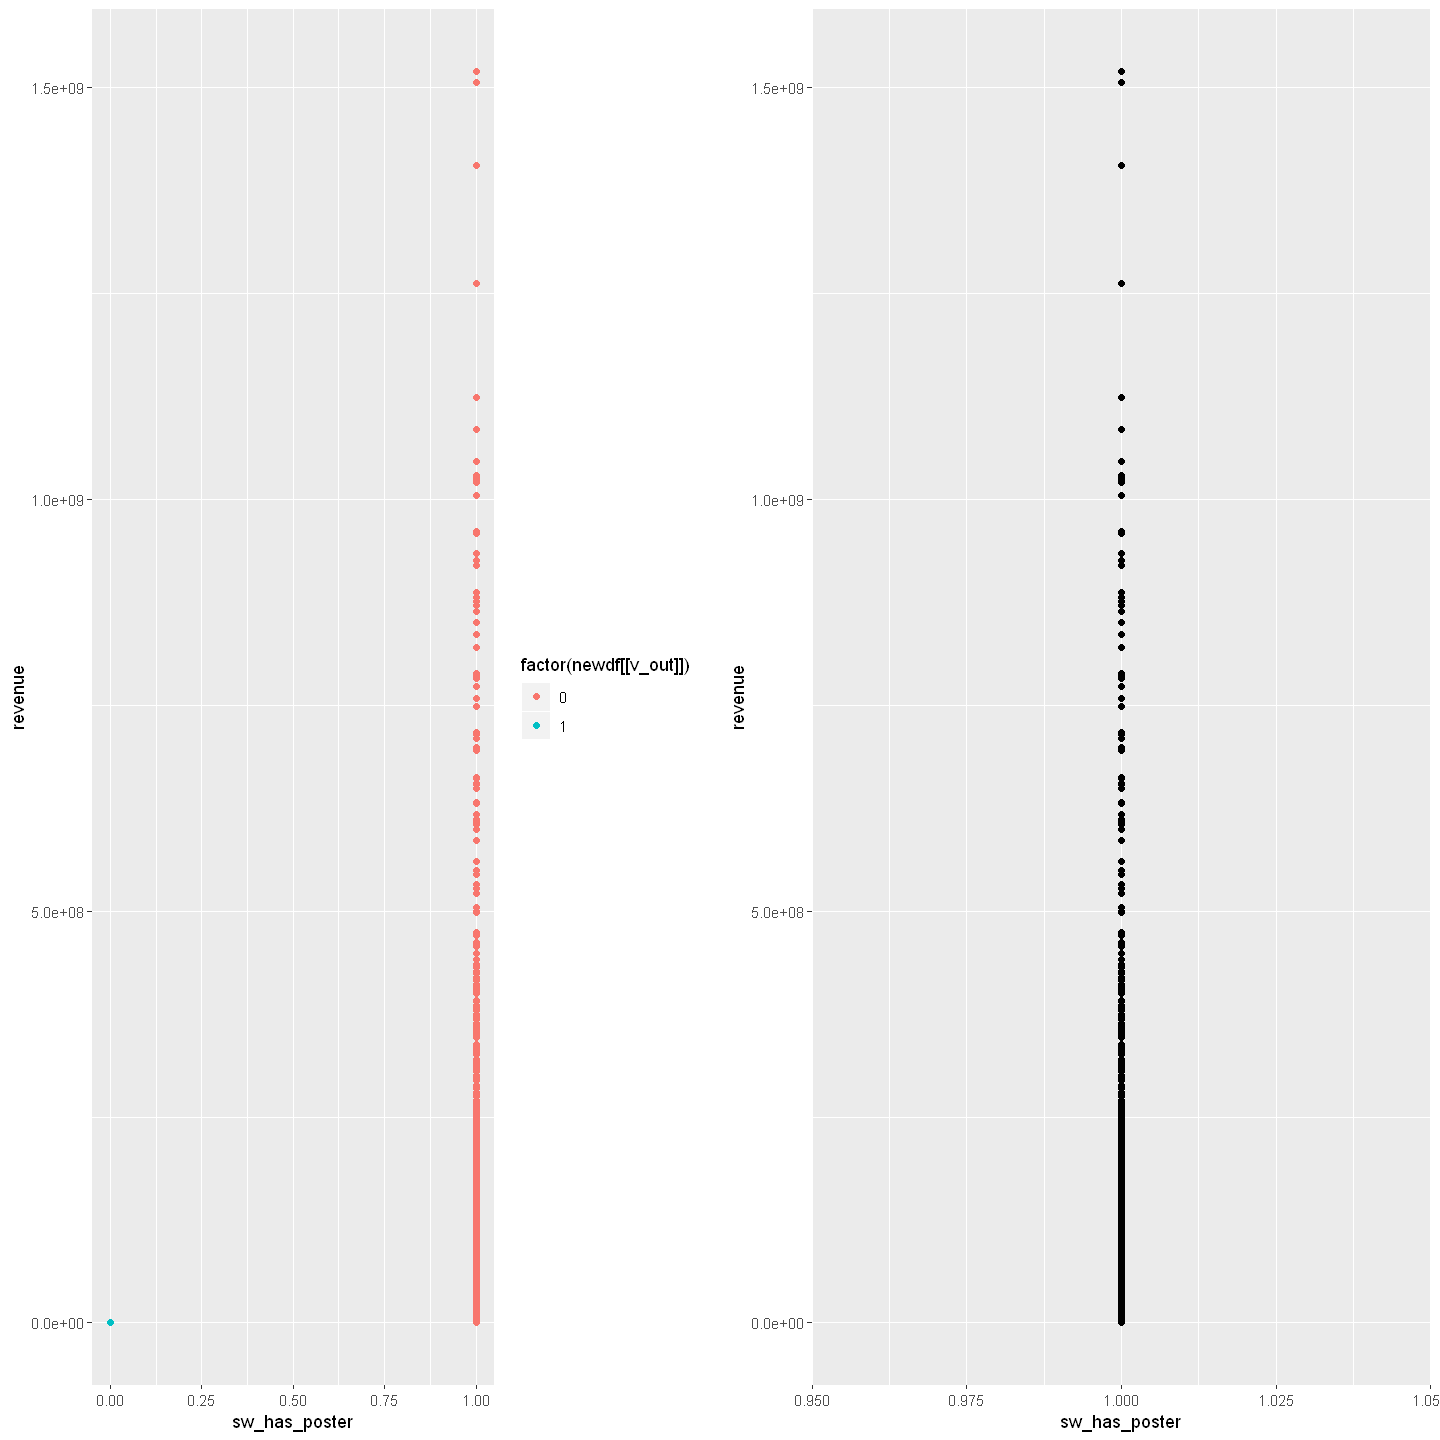

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4973 rows containing missing values (geom_point)."


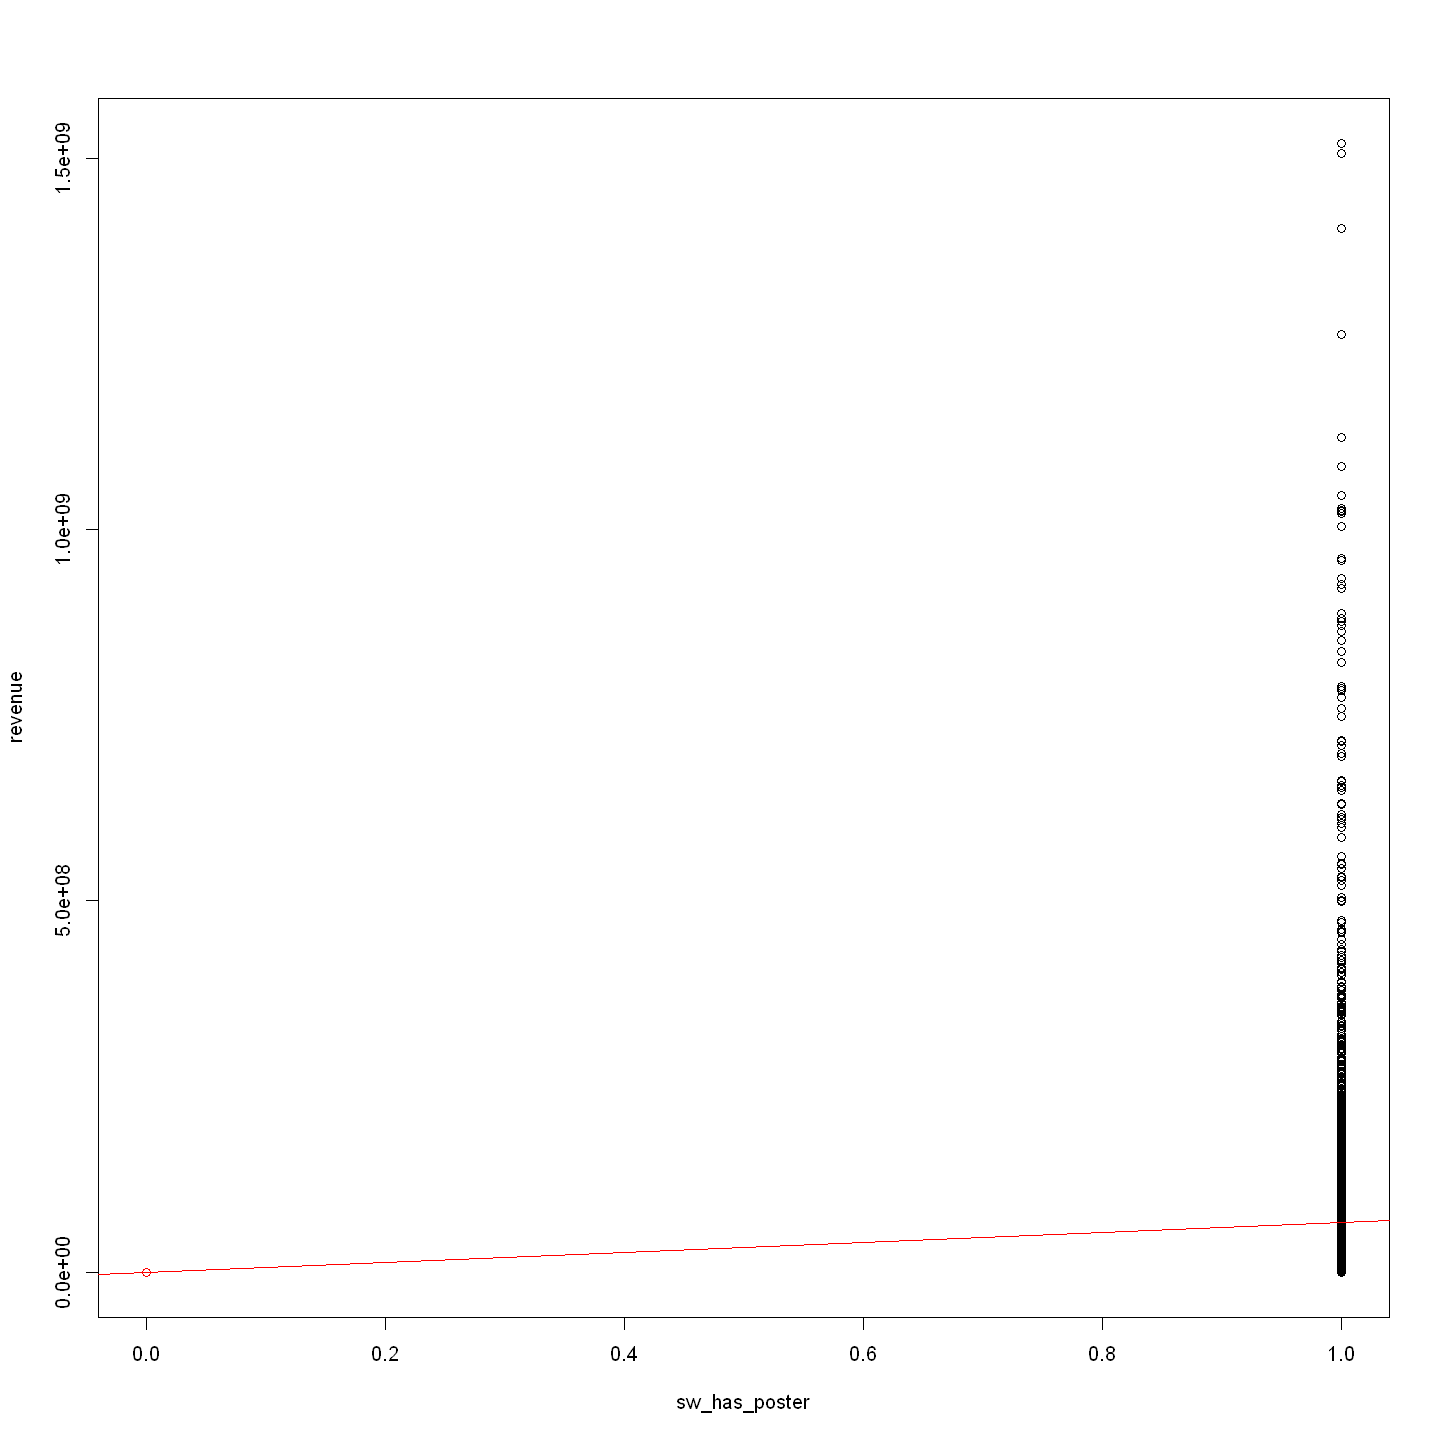

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


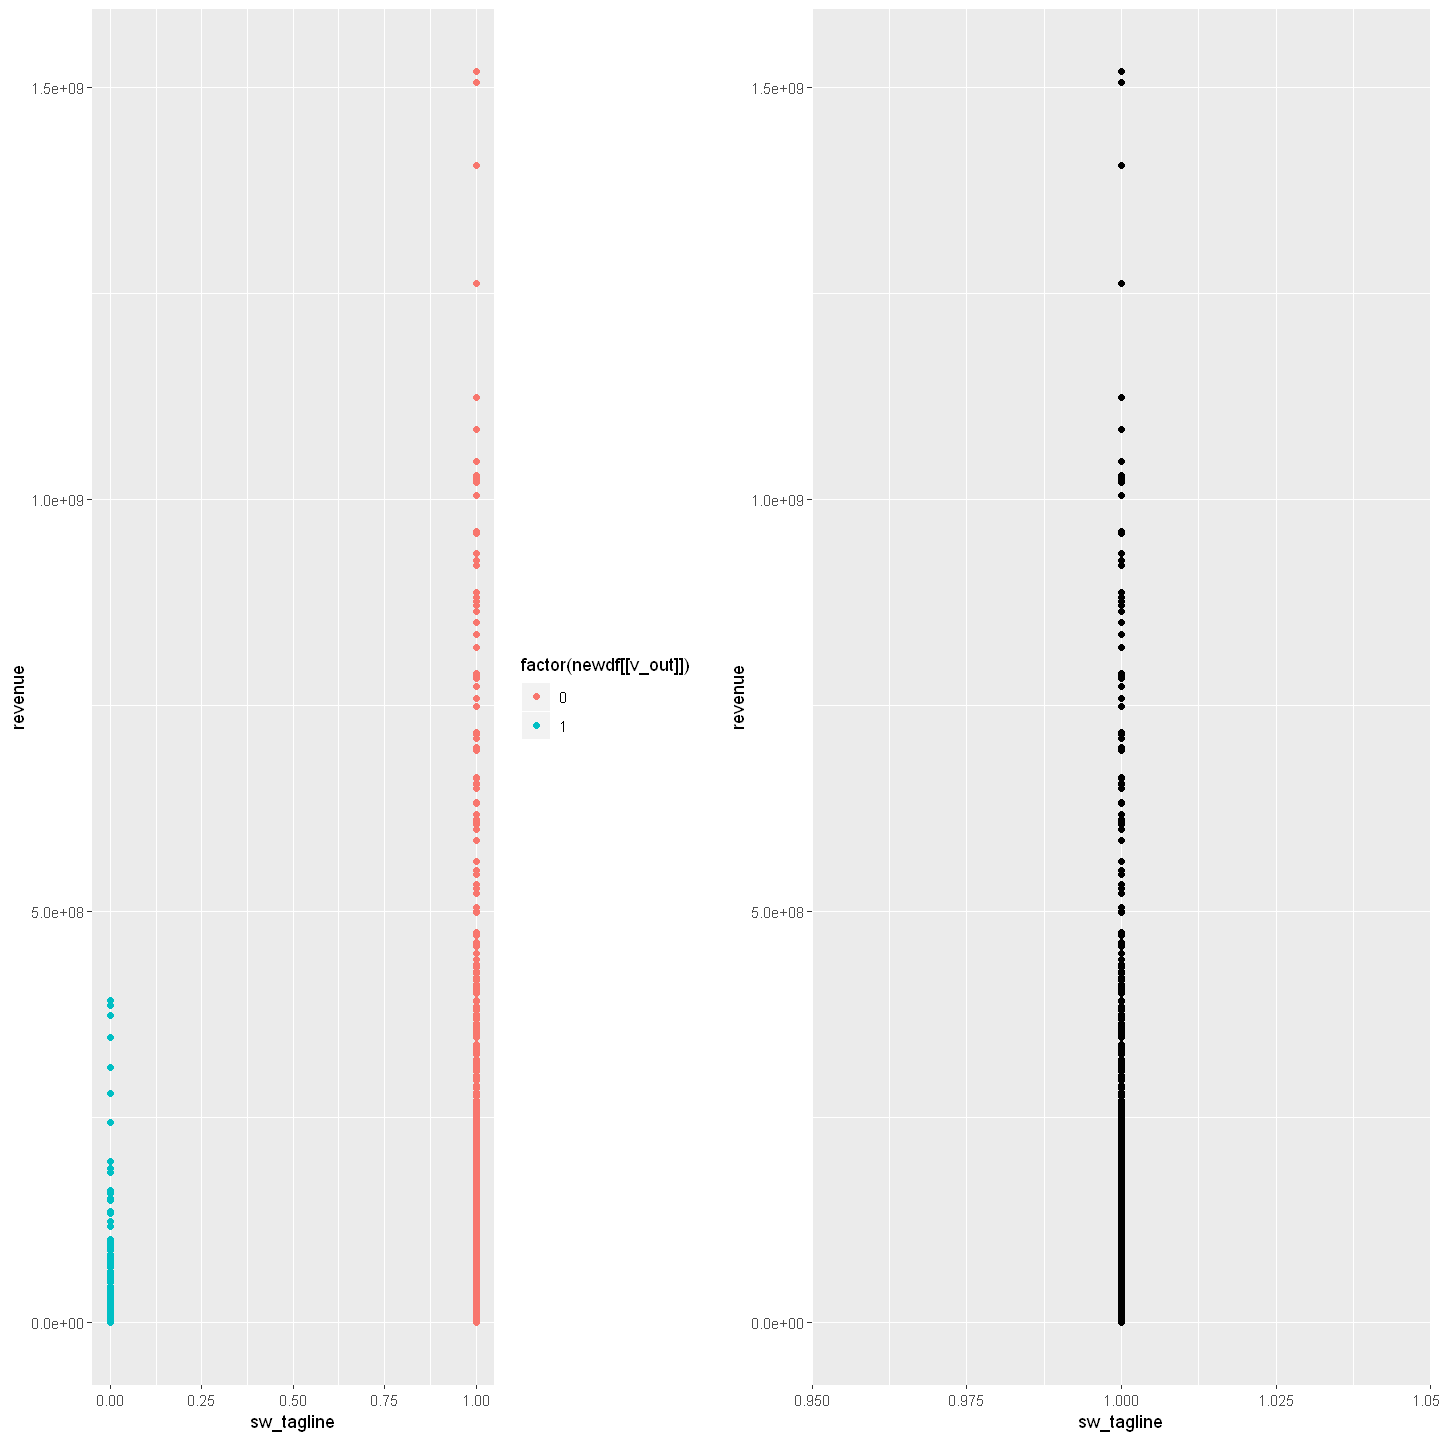

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4491 rows containing missing values (geom_point)."


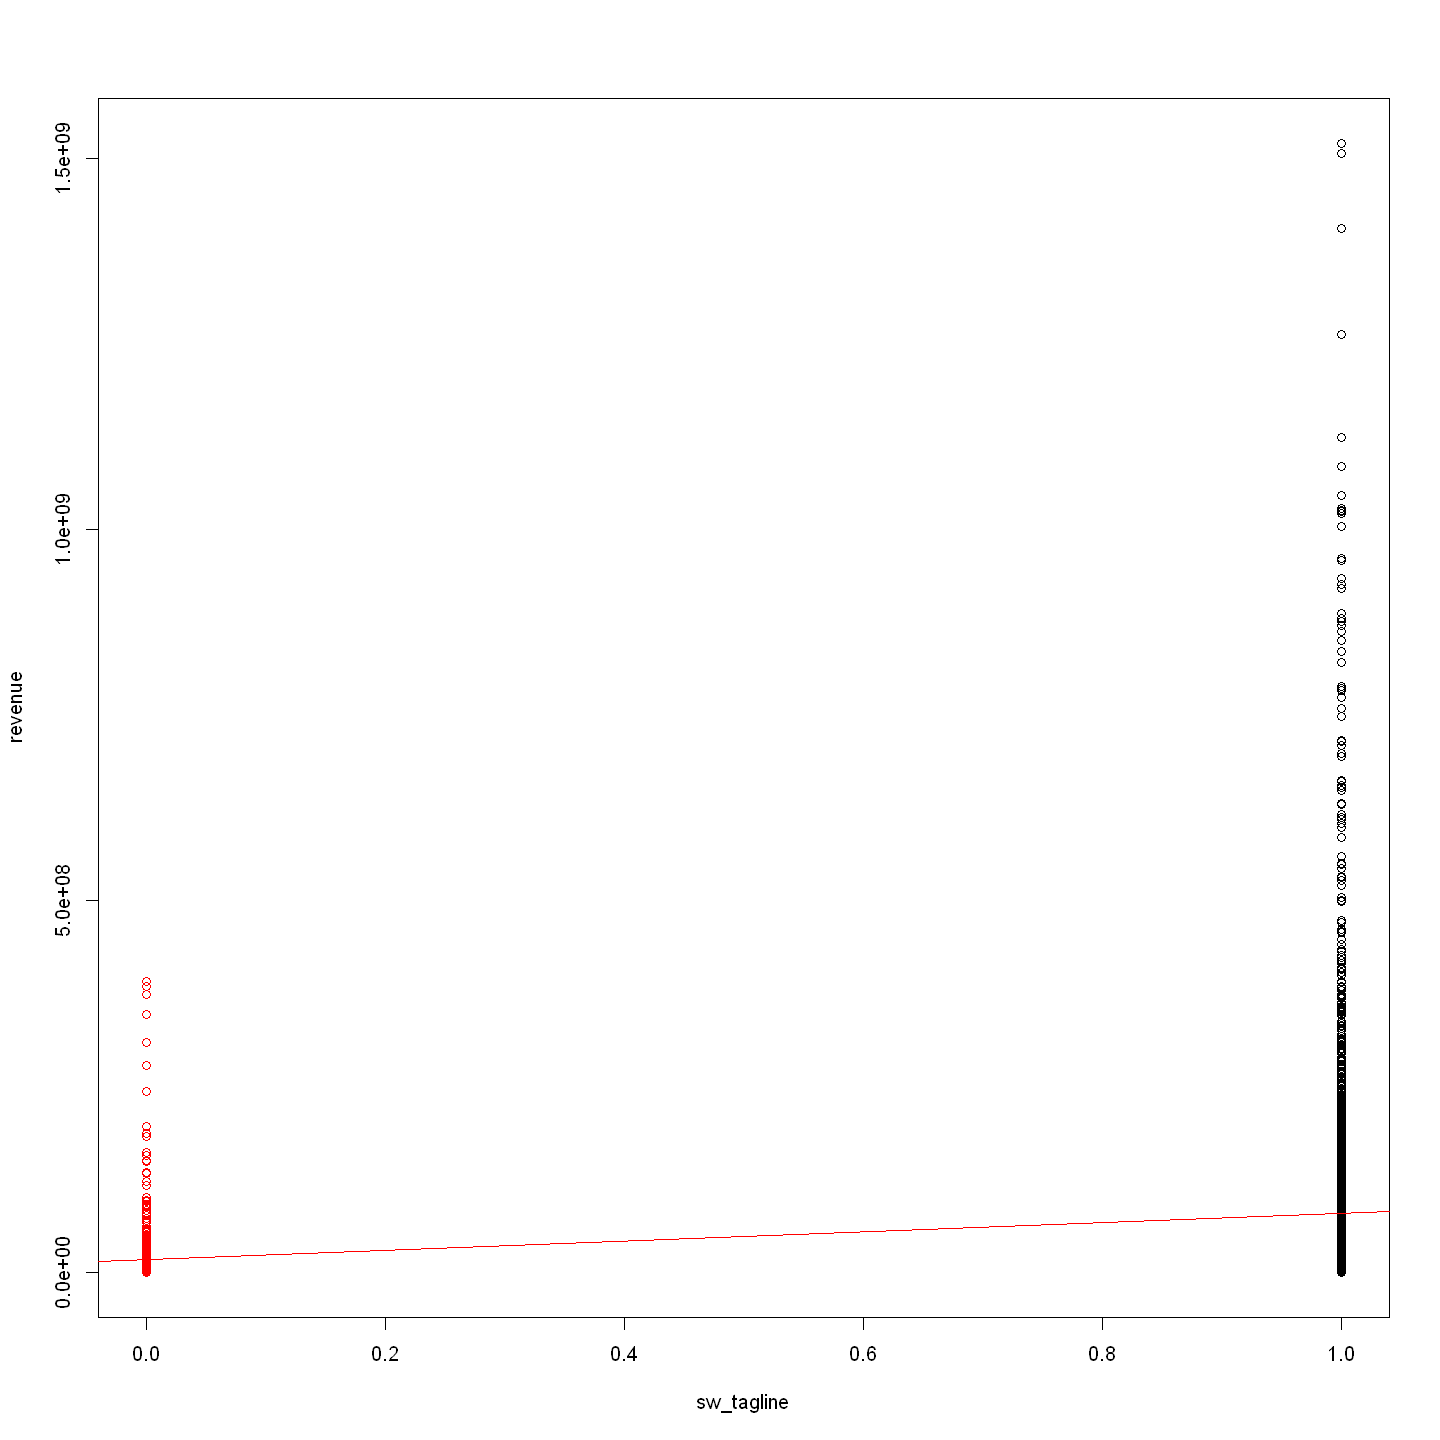

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


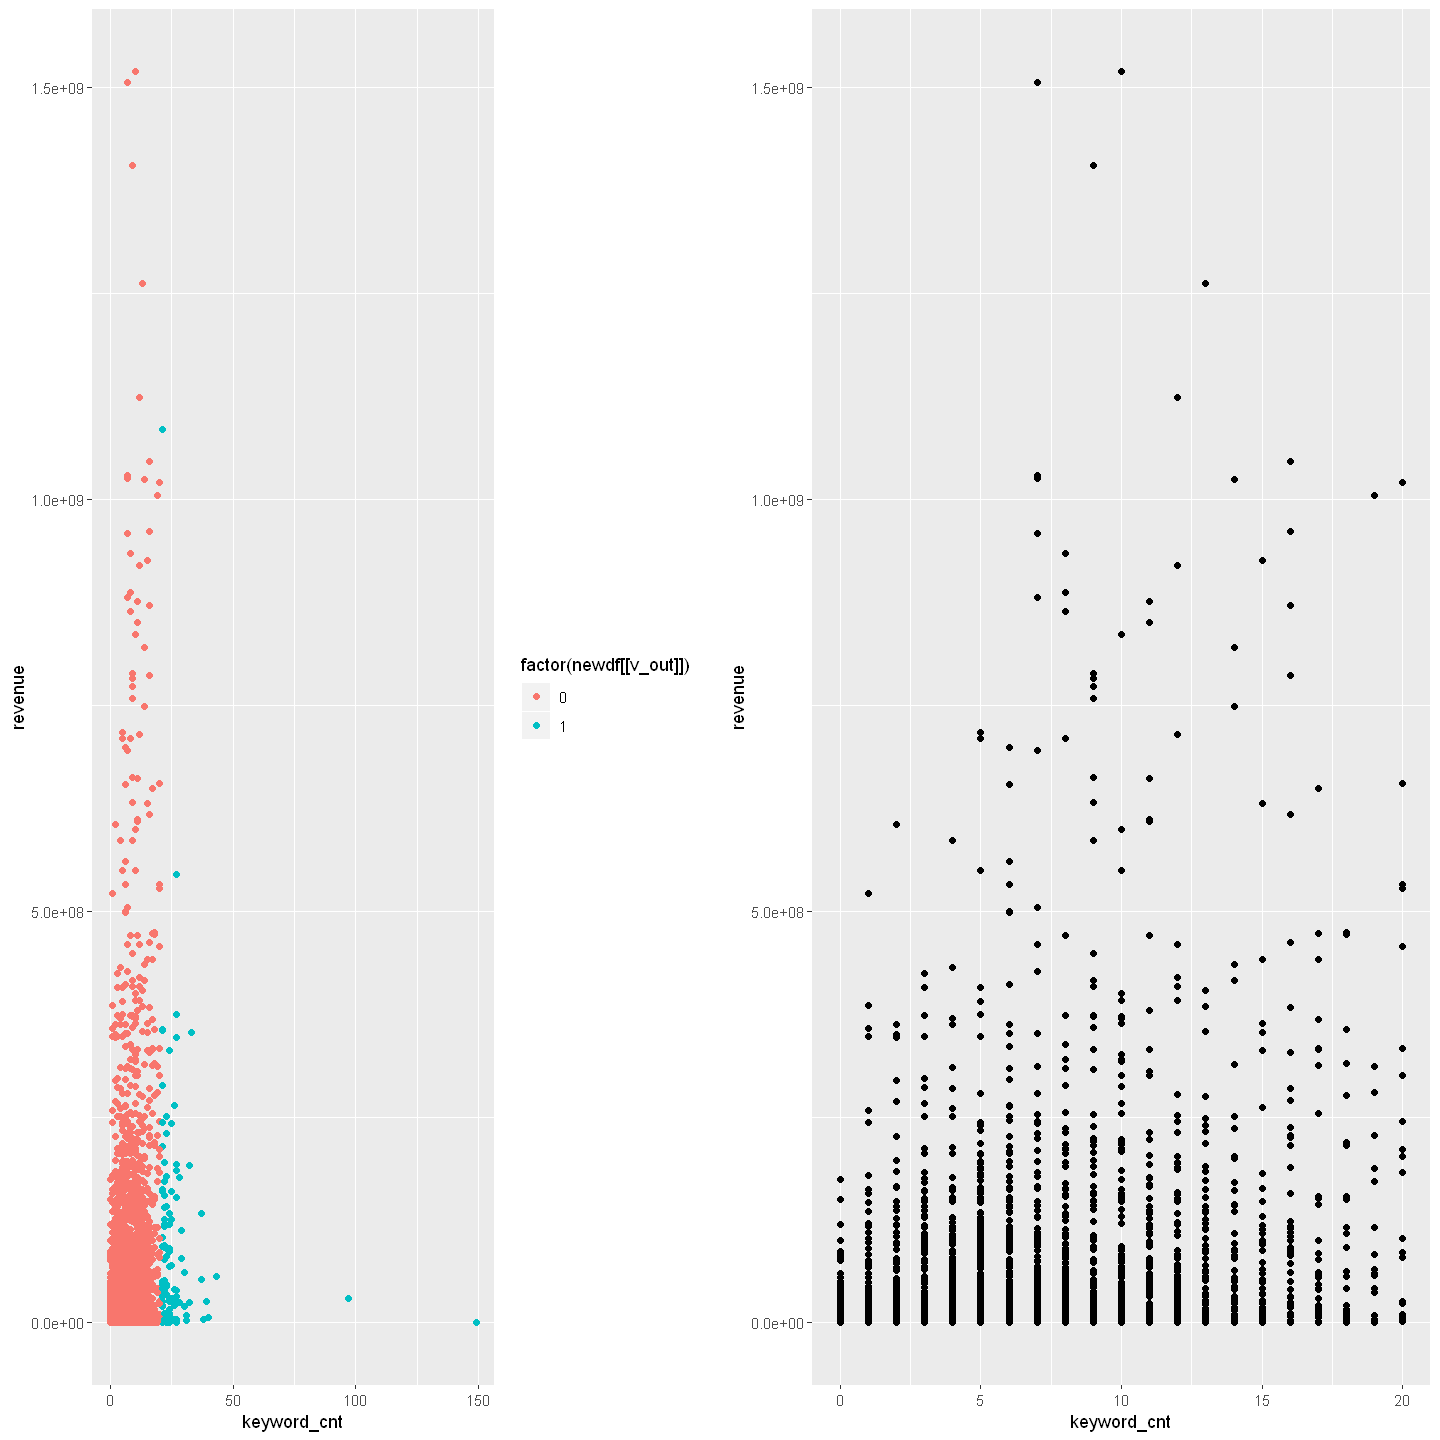

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4496 rows containing missing values (geom_point)."


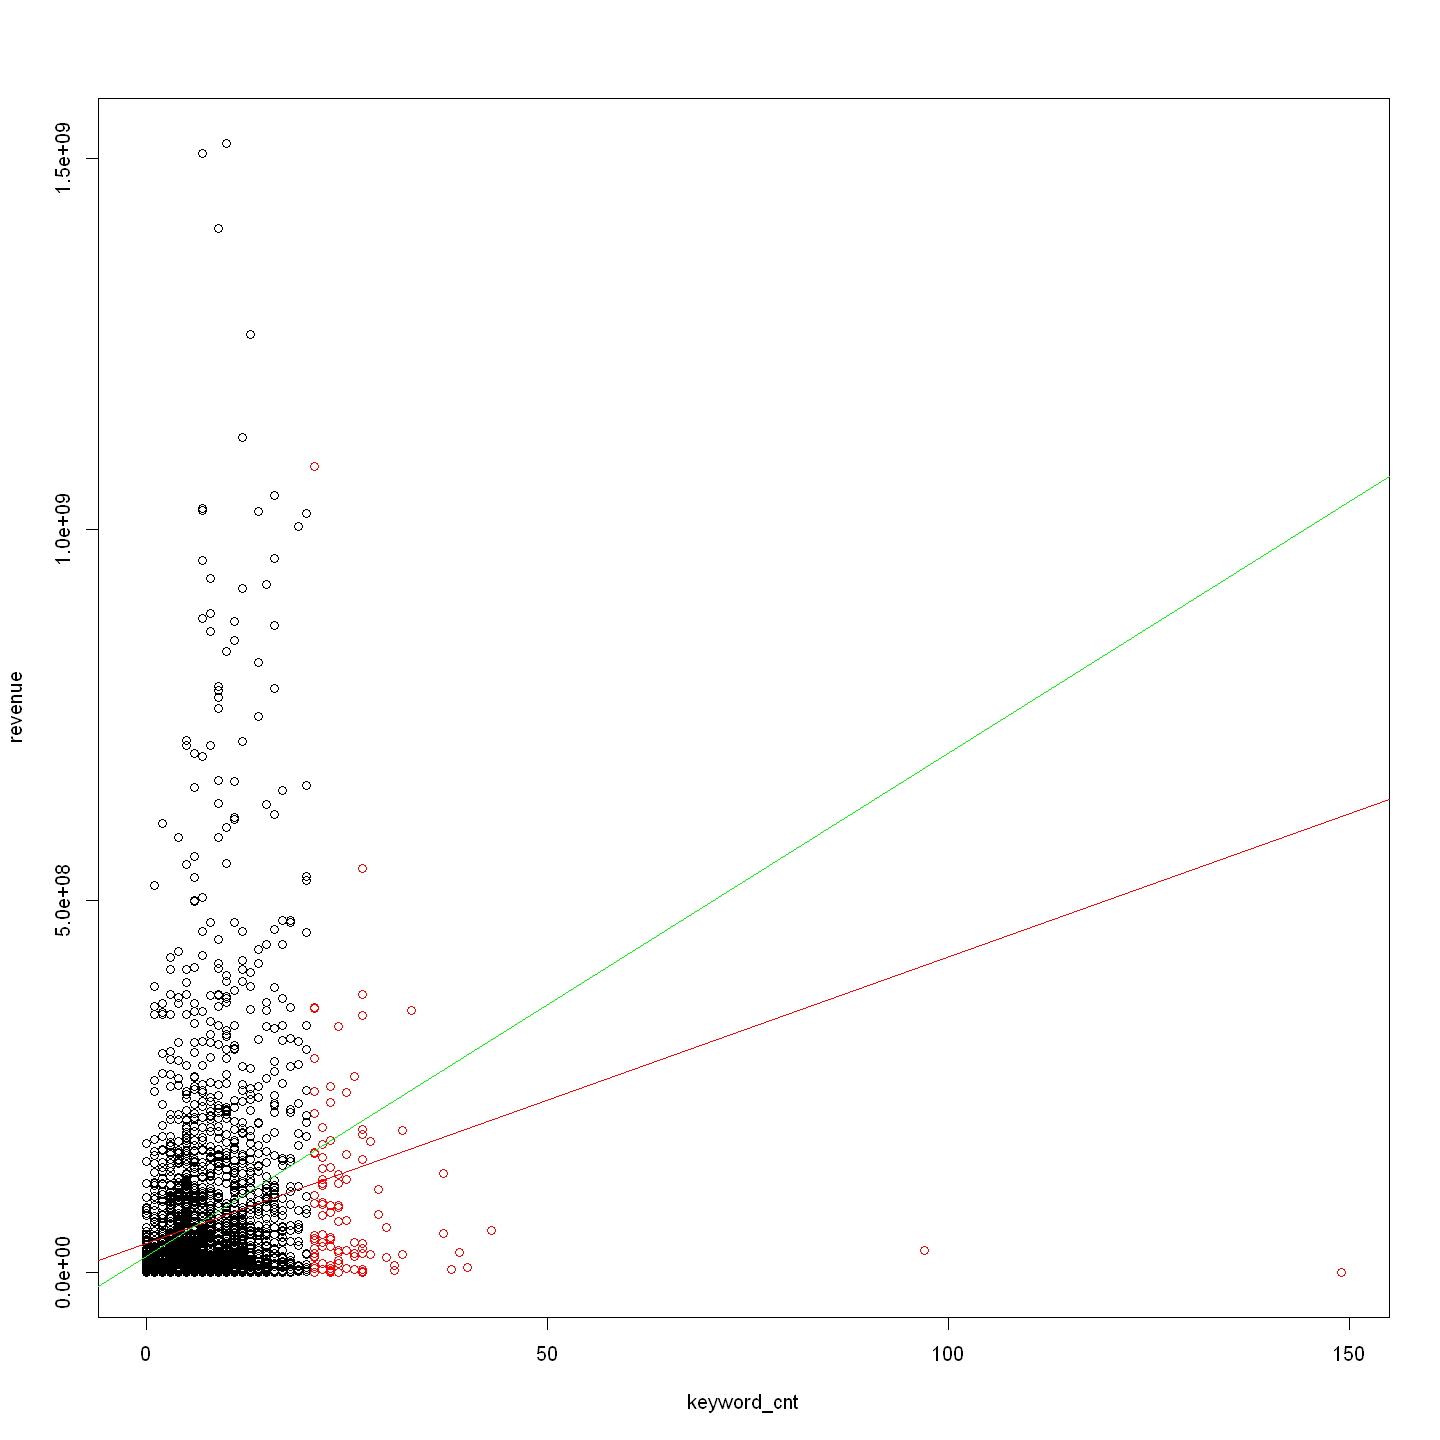

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


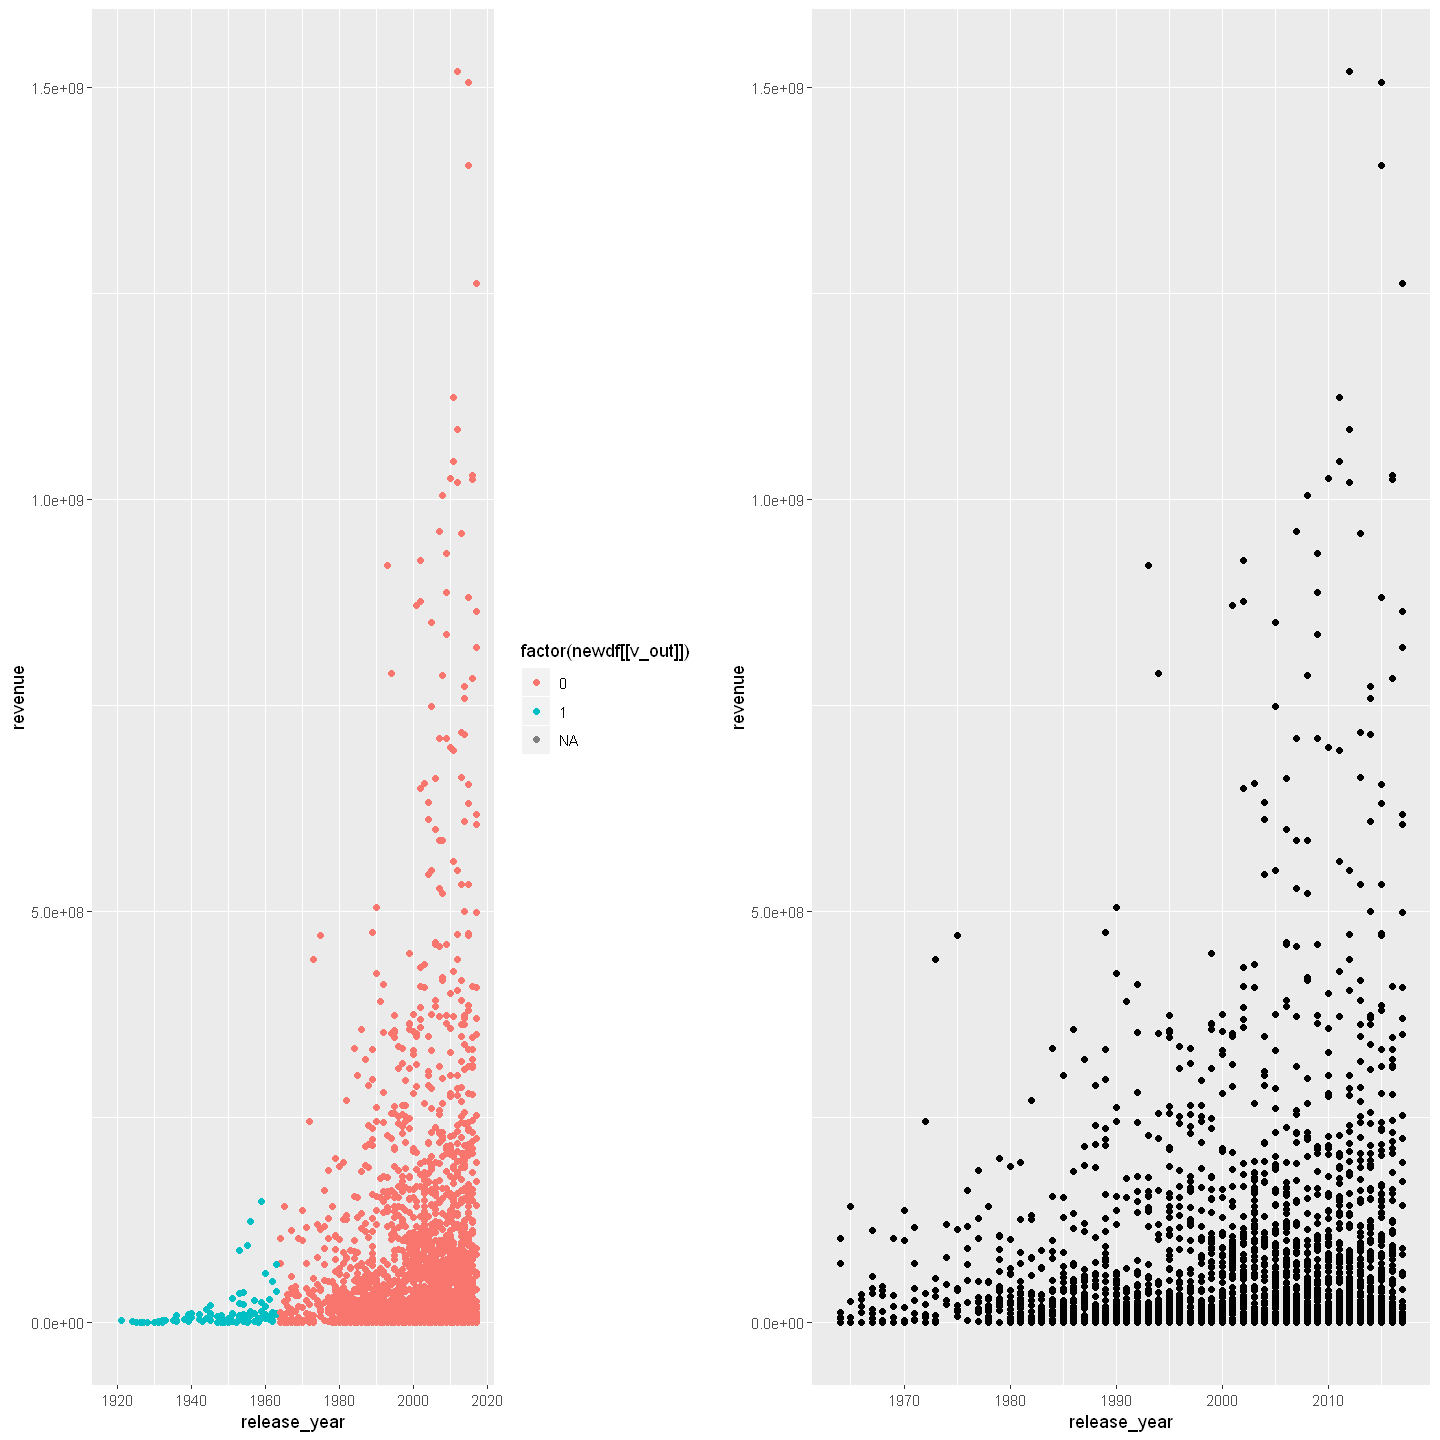

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4382 rows containing missing values (geom_point)."


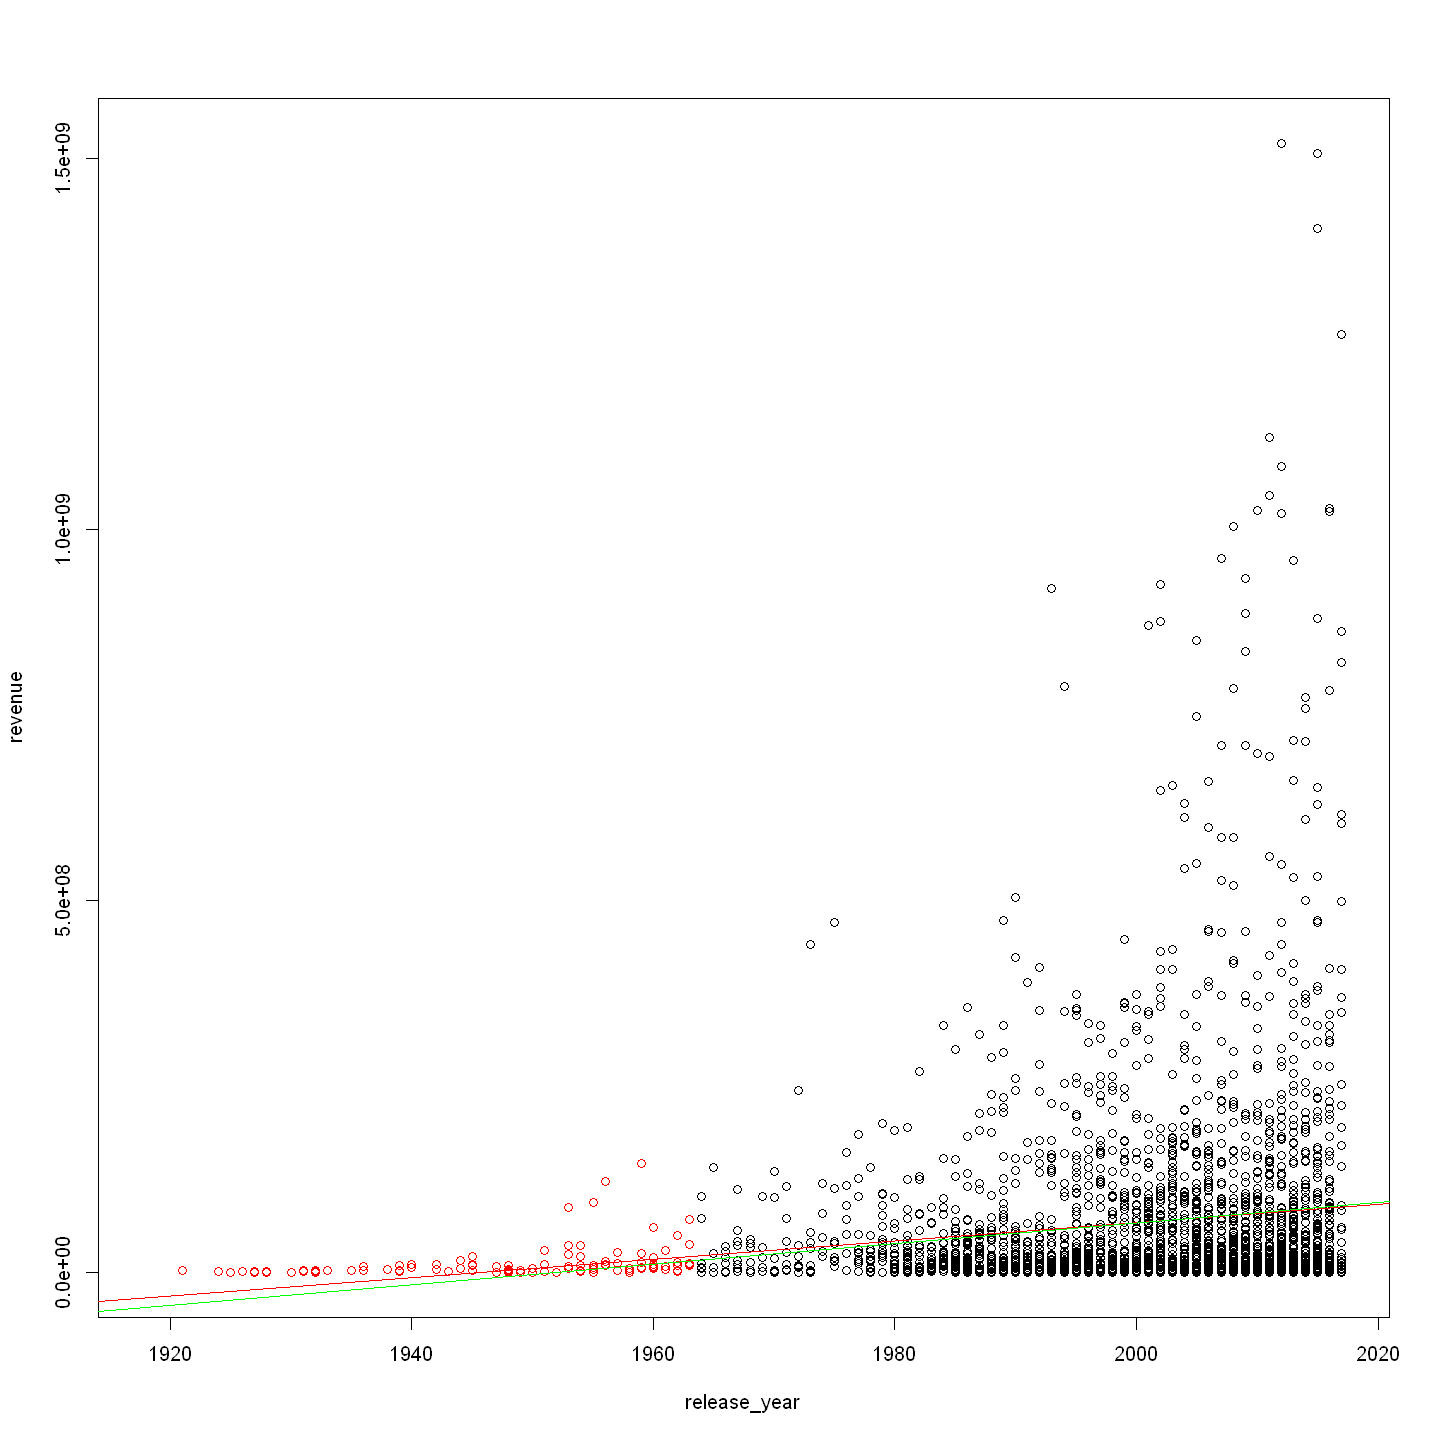

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


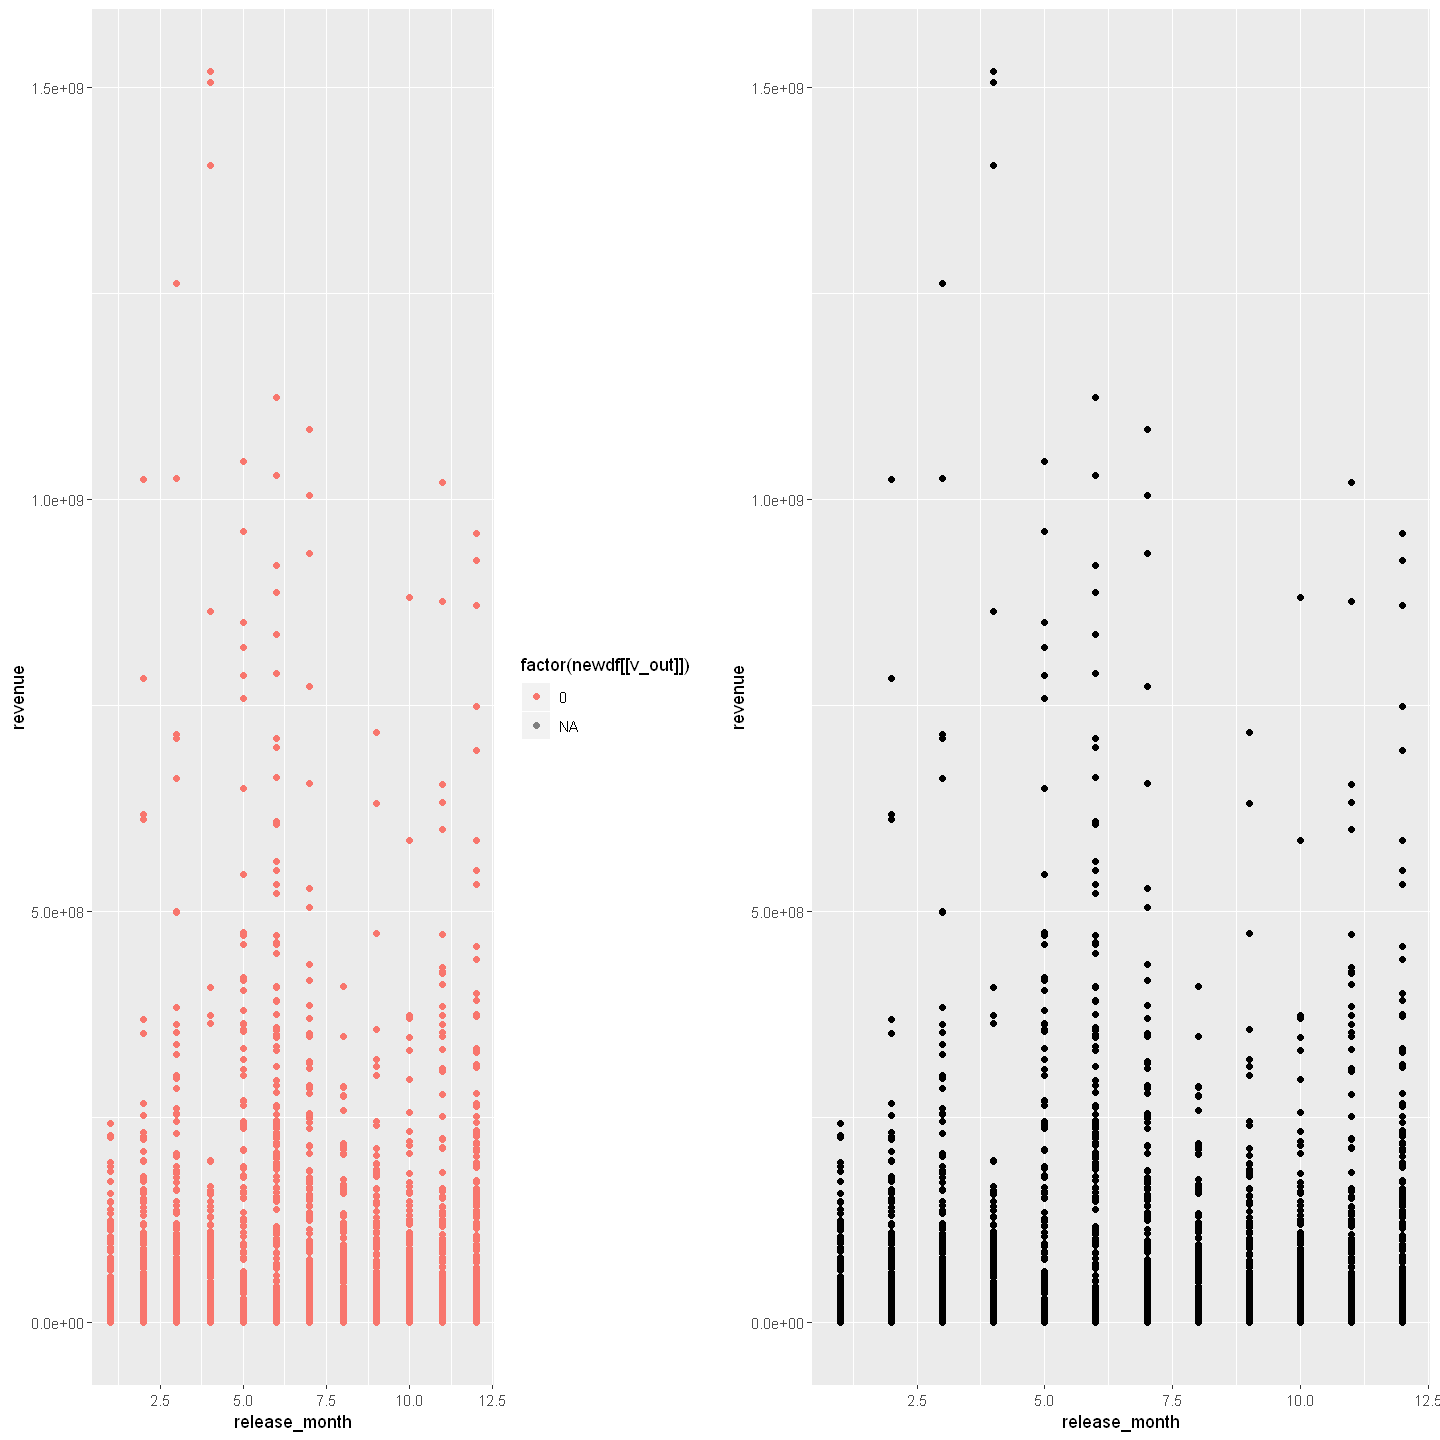

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4382 rows containing missing values (geom_point)."


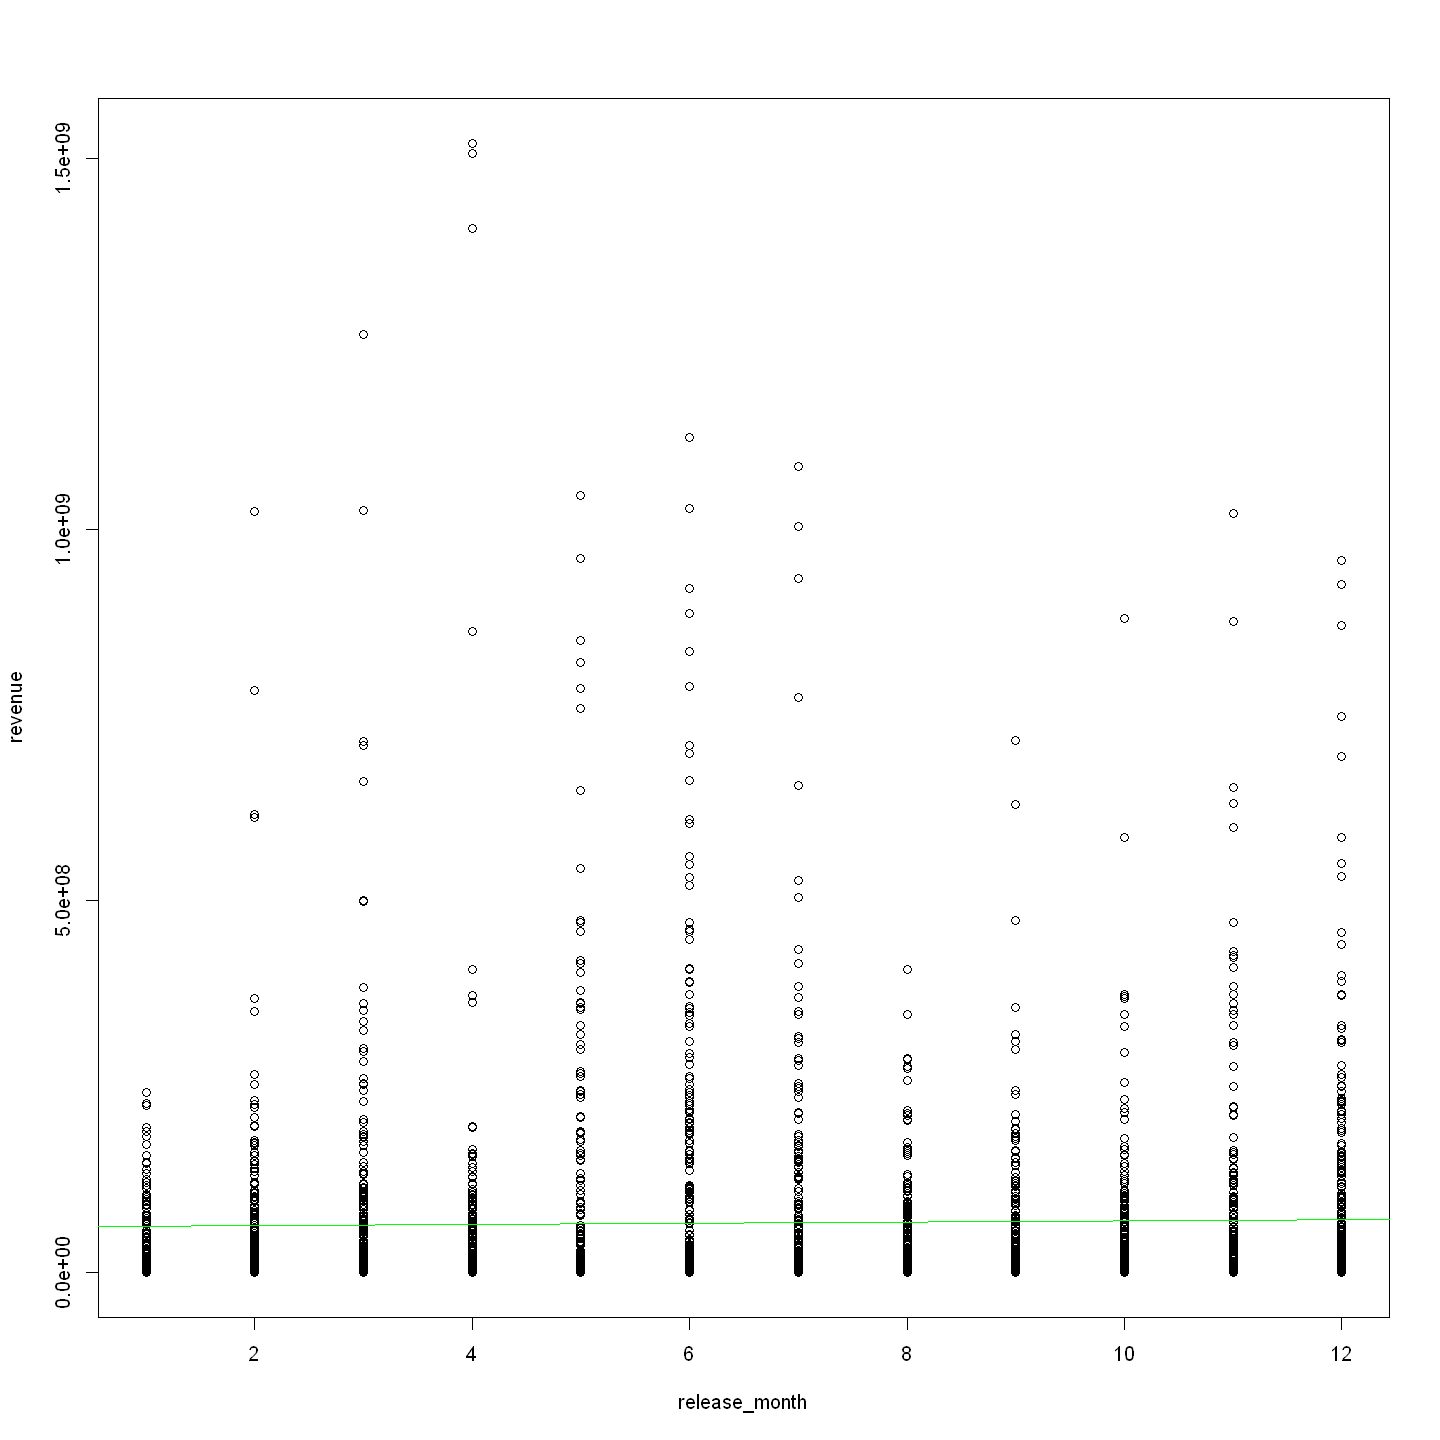

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


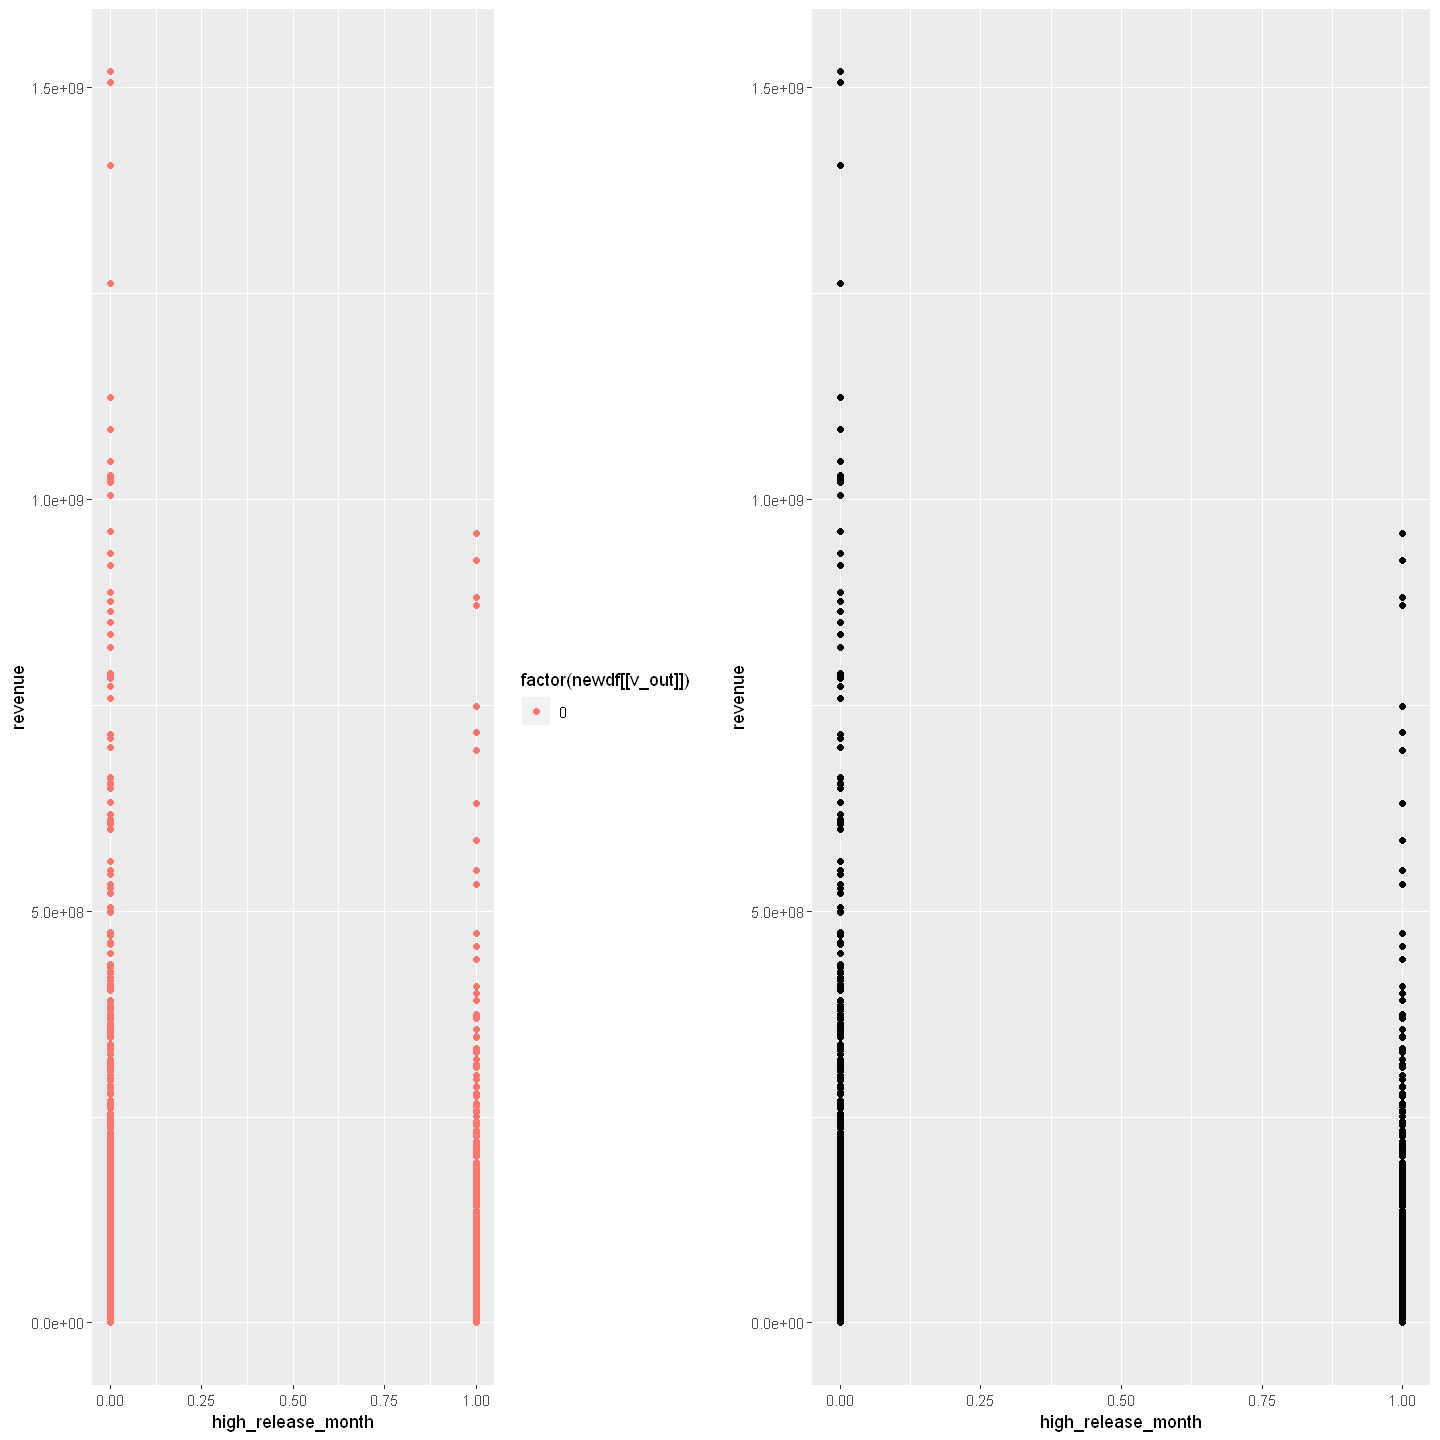

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4382 rows containing missing values (geom_point)."


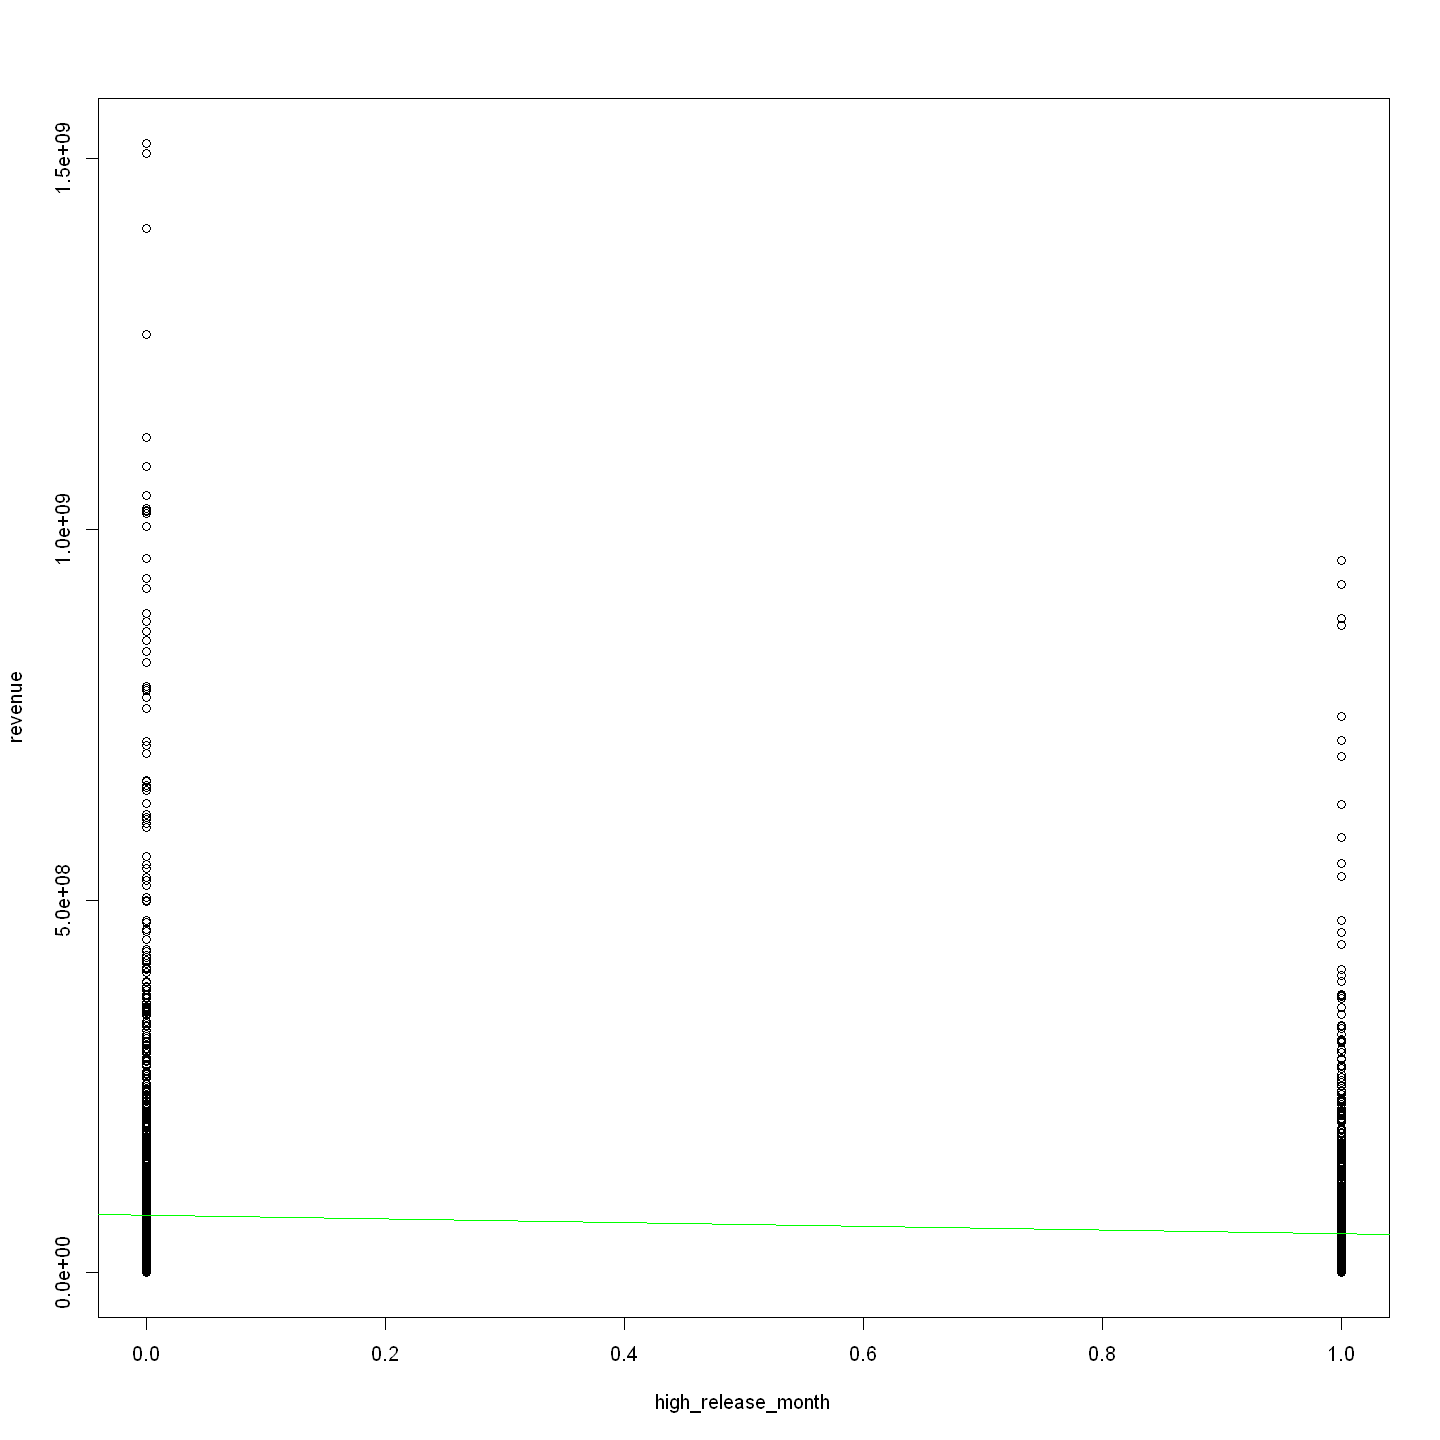

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


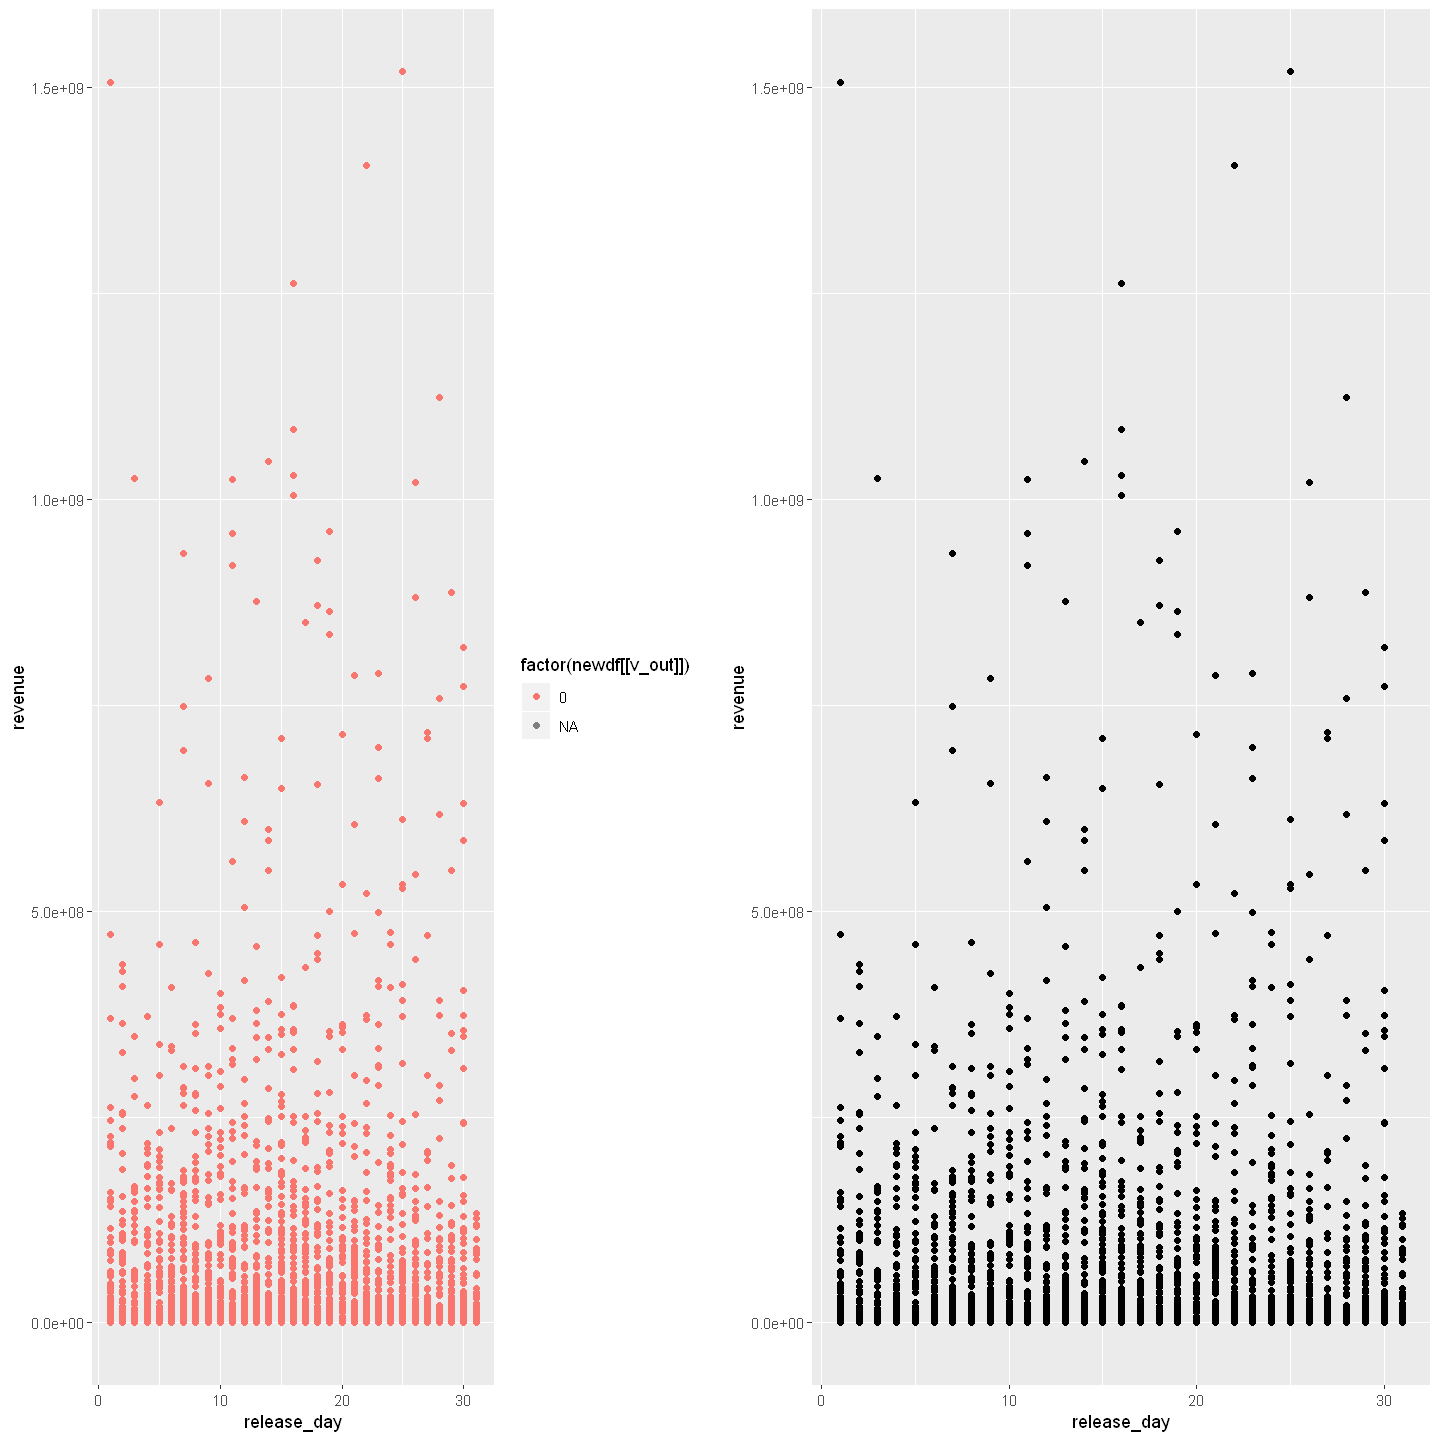

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4382 rows containing missing values (geom_point)."


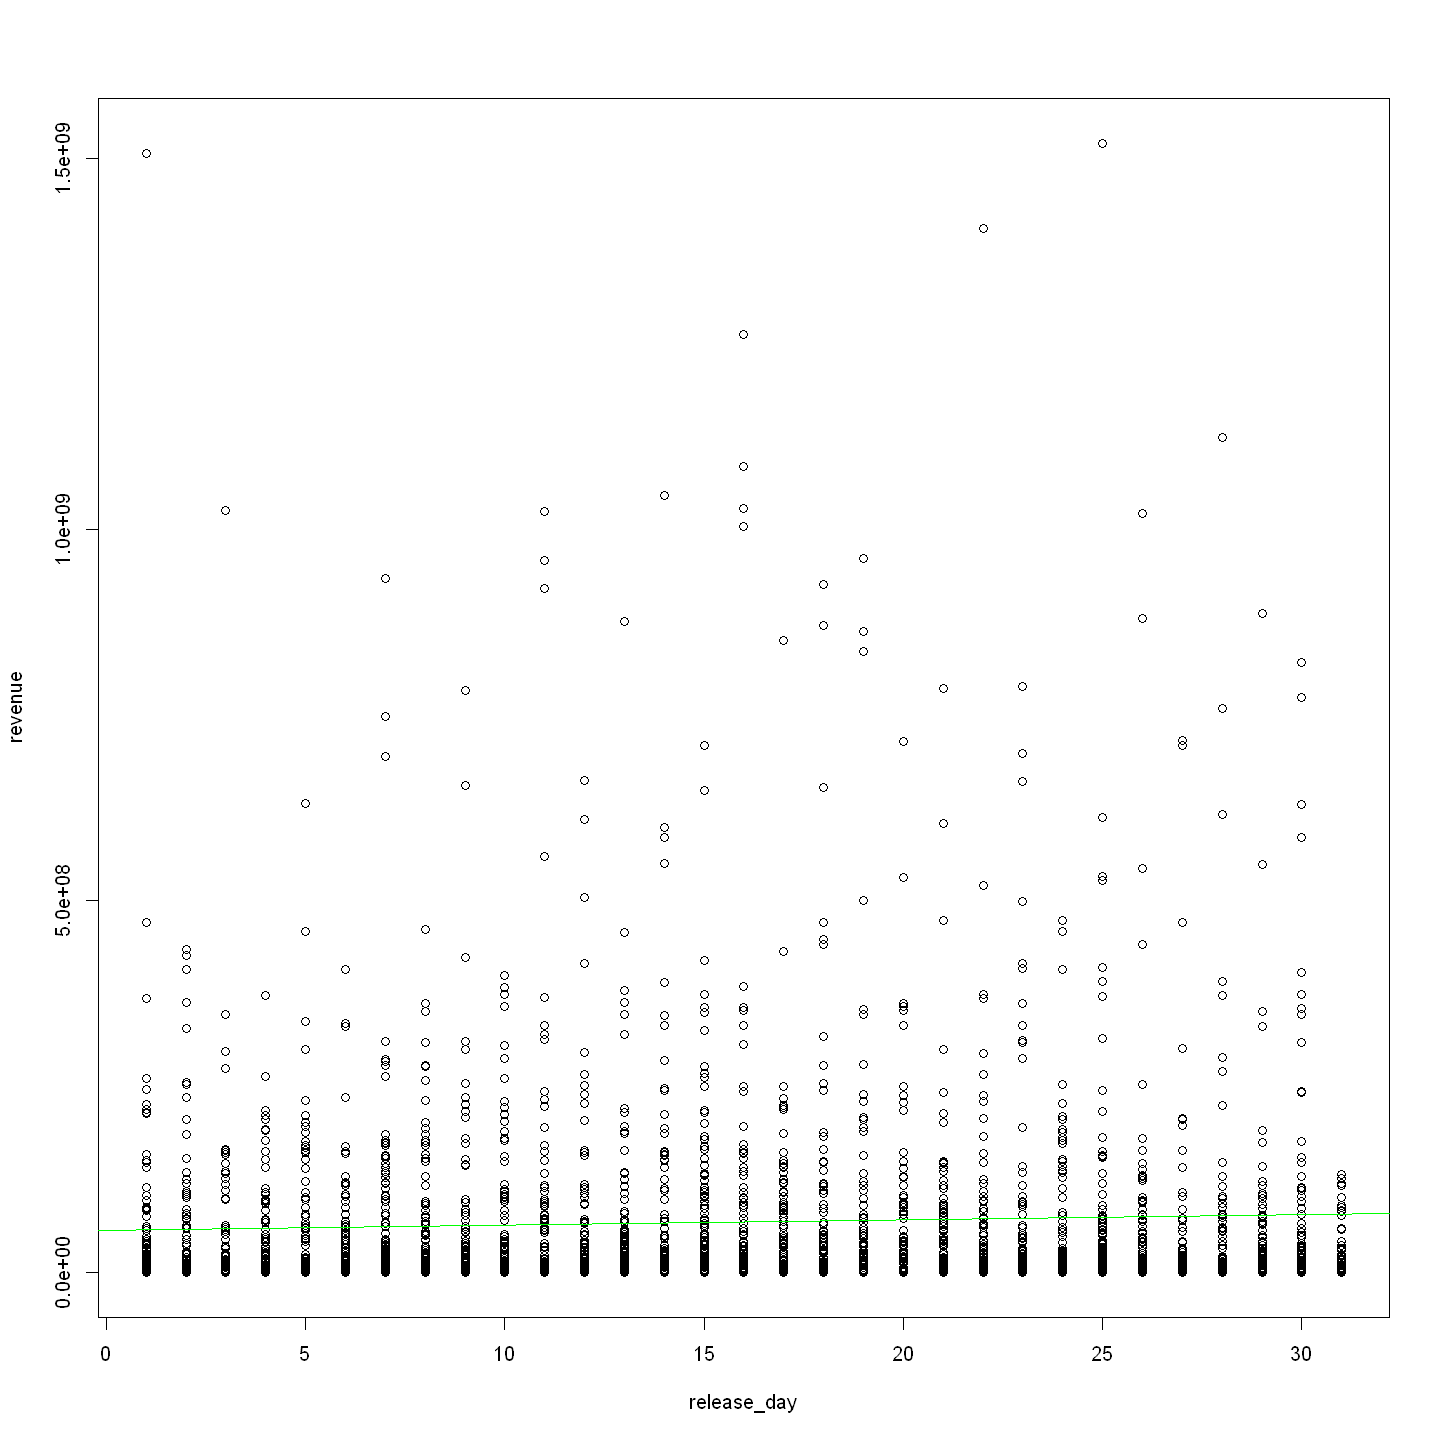

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


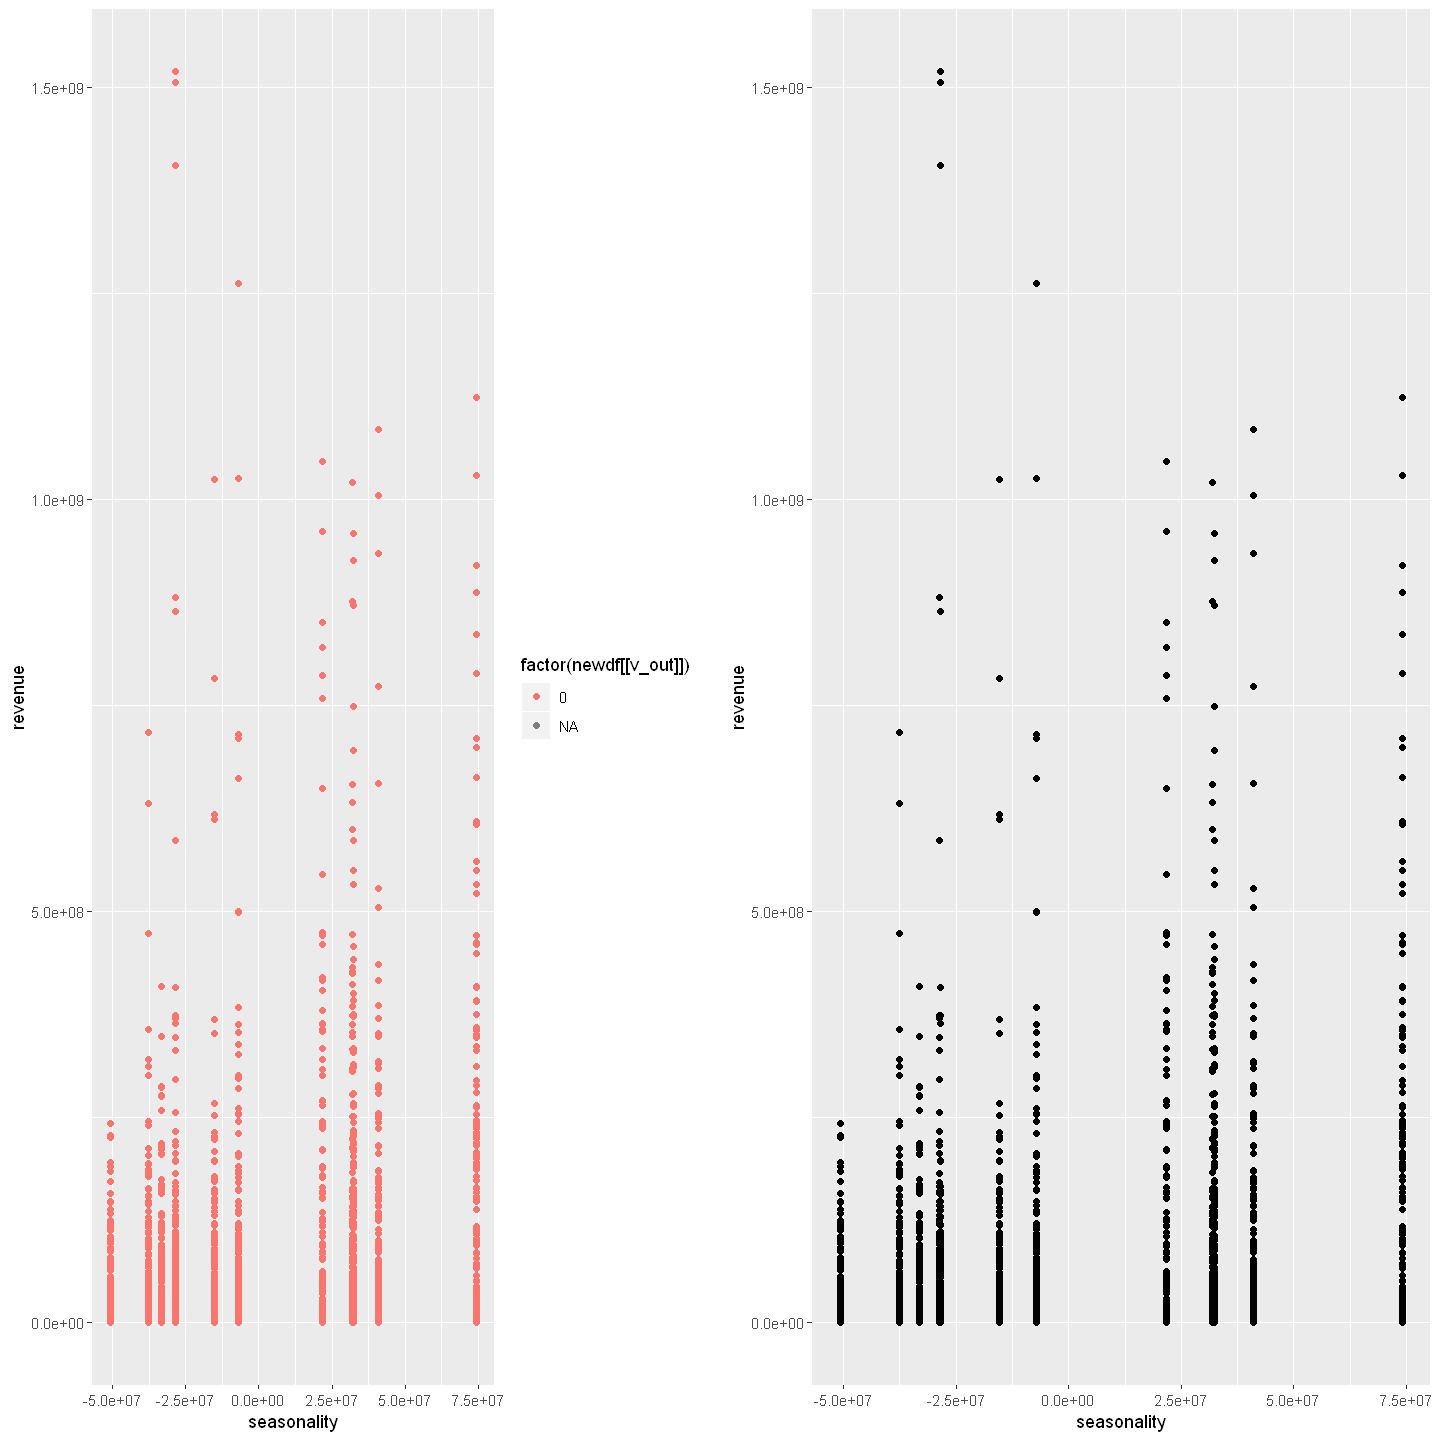

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4464 rows containing missing values (geom_point)."


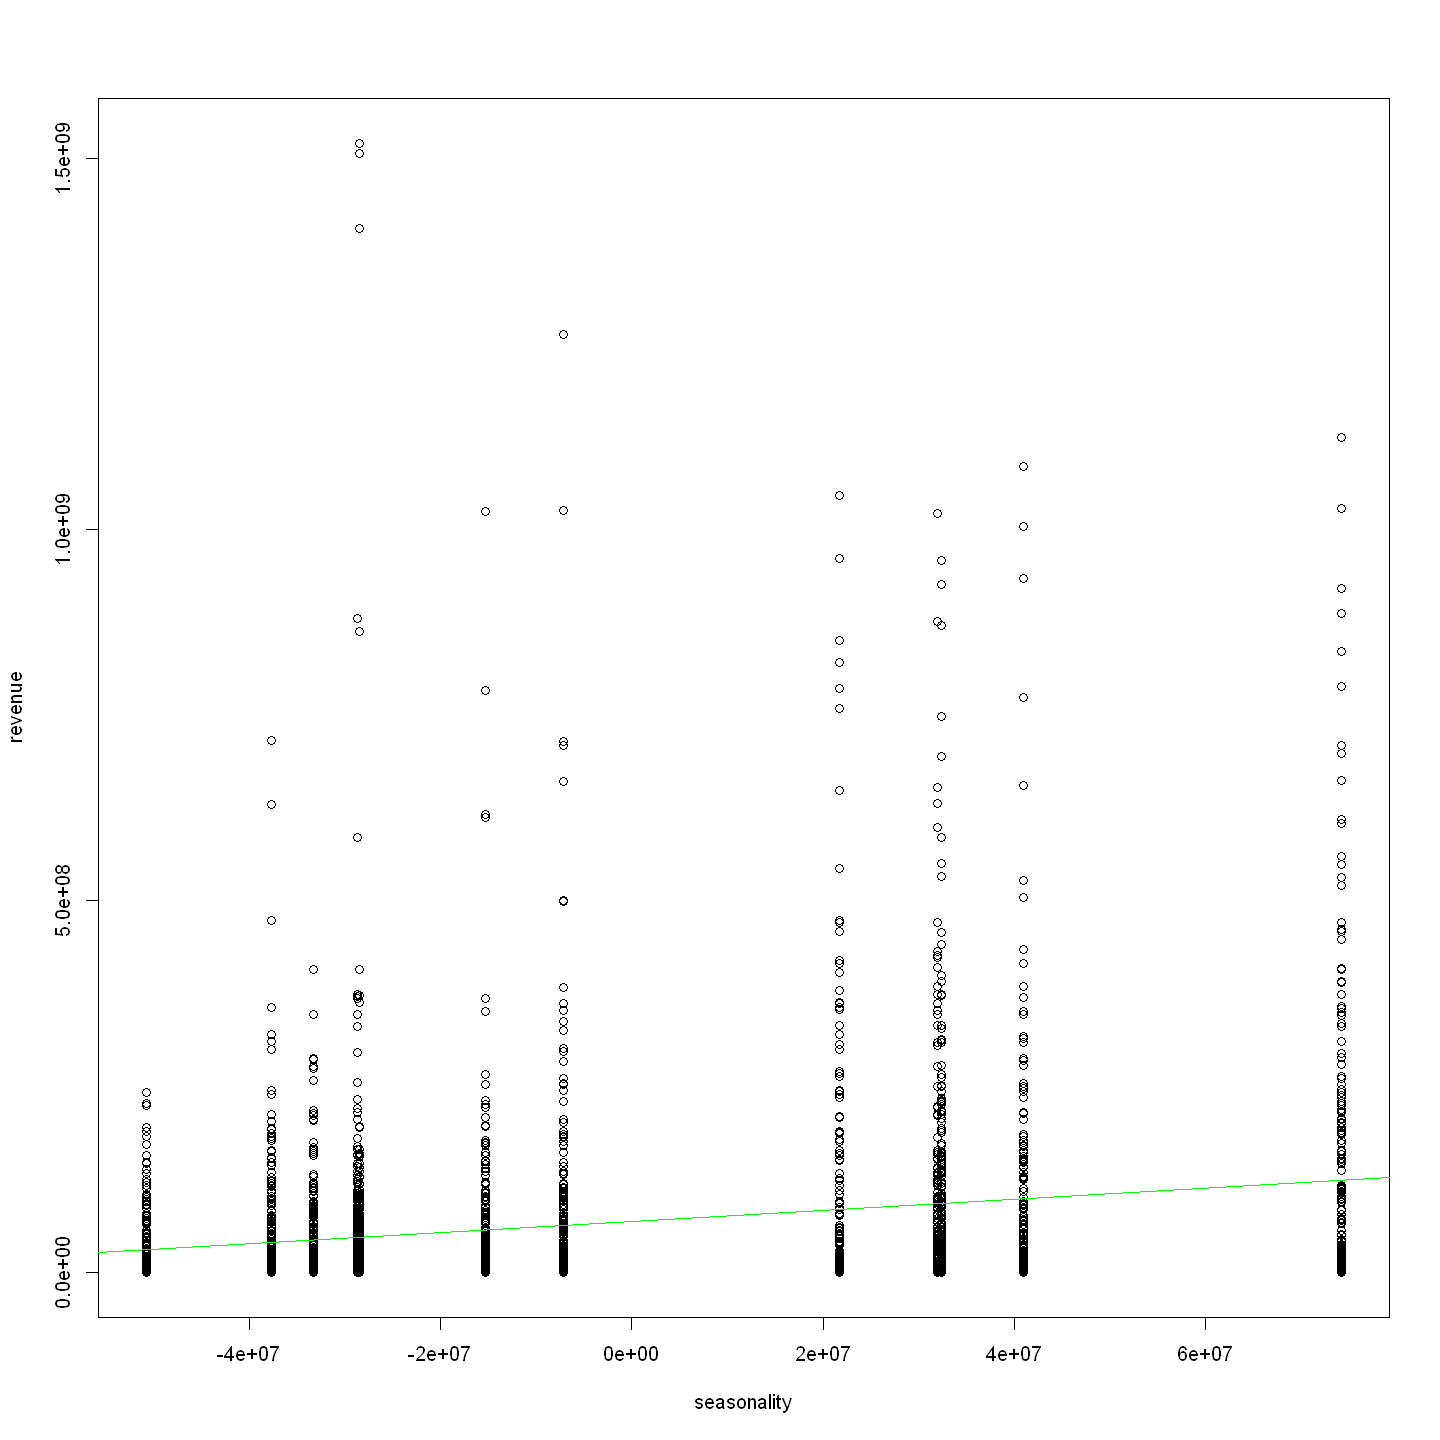

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


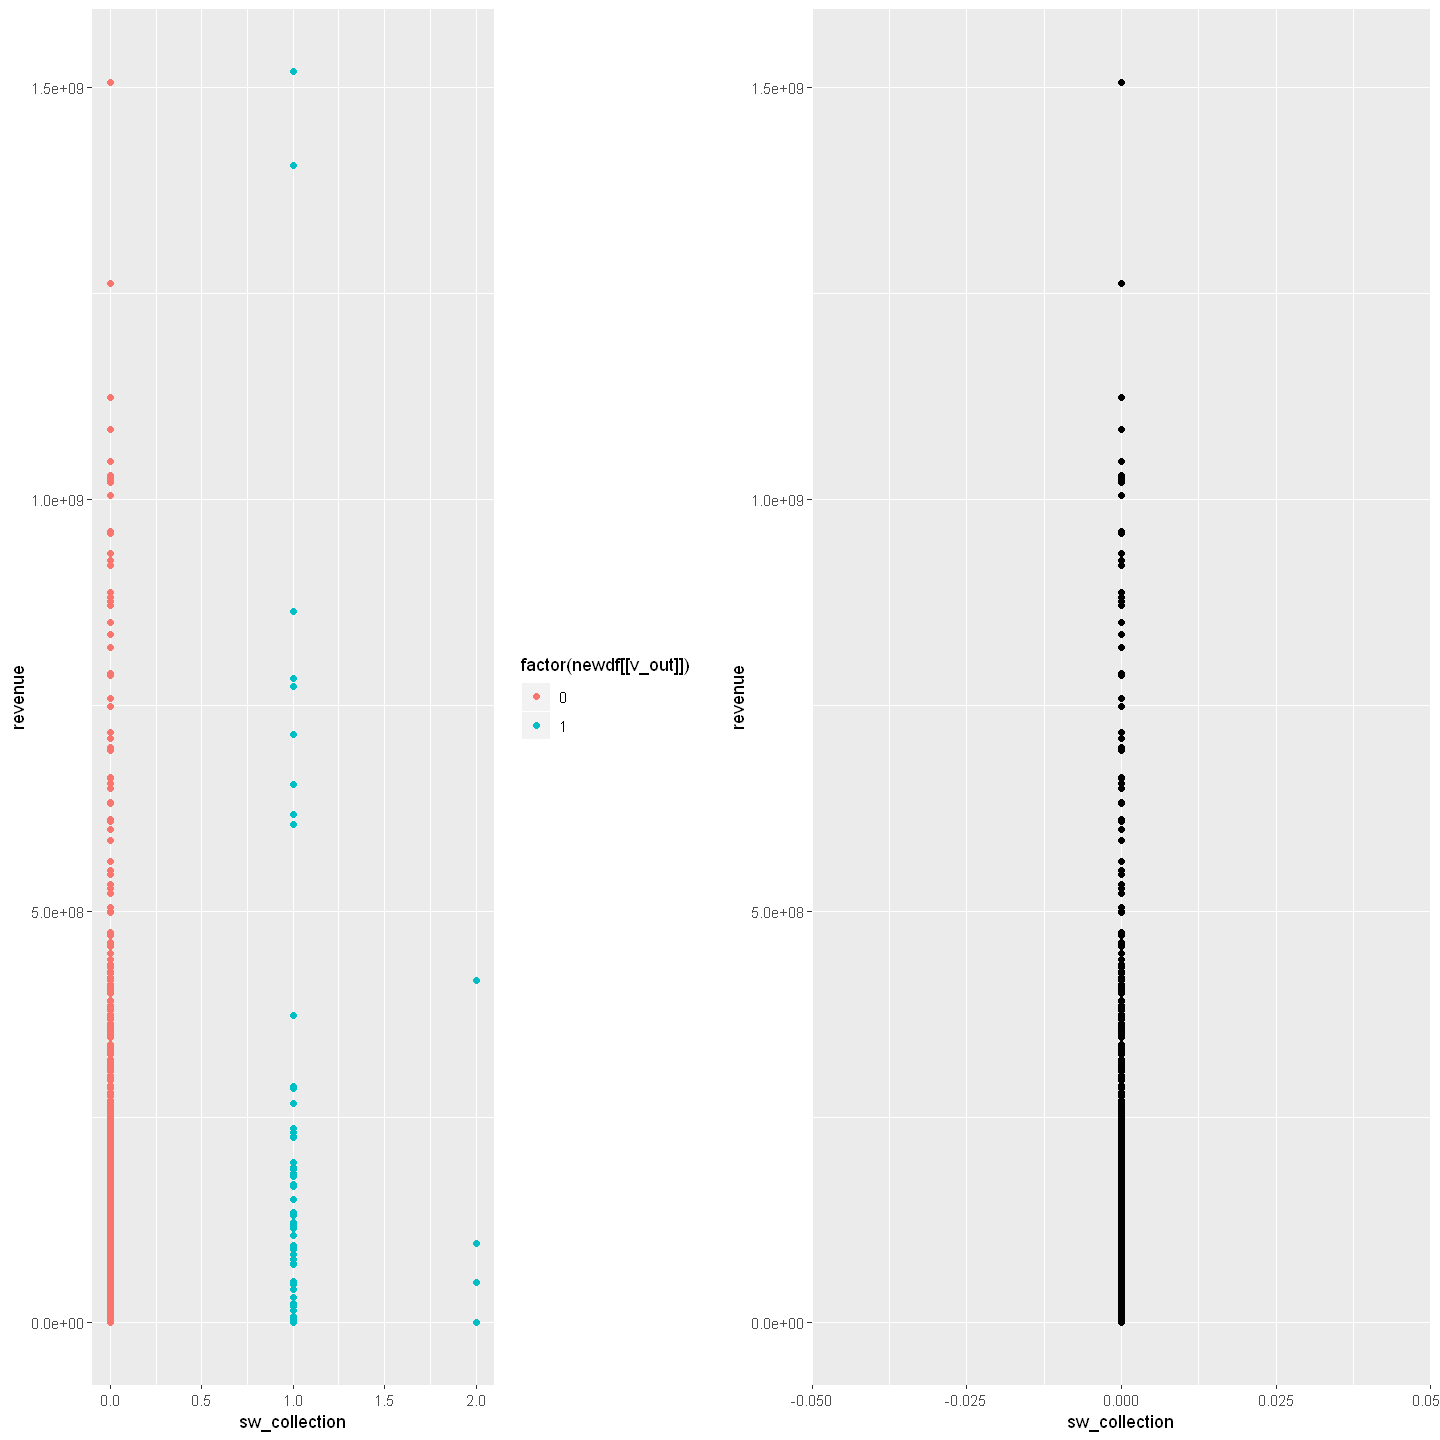

NULL
NULL


Warning message:
"Removed 4531 rows containing missing values (geom_point)."
Warning message:
"Removed 4584 rows containing missing values (geom_point)."


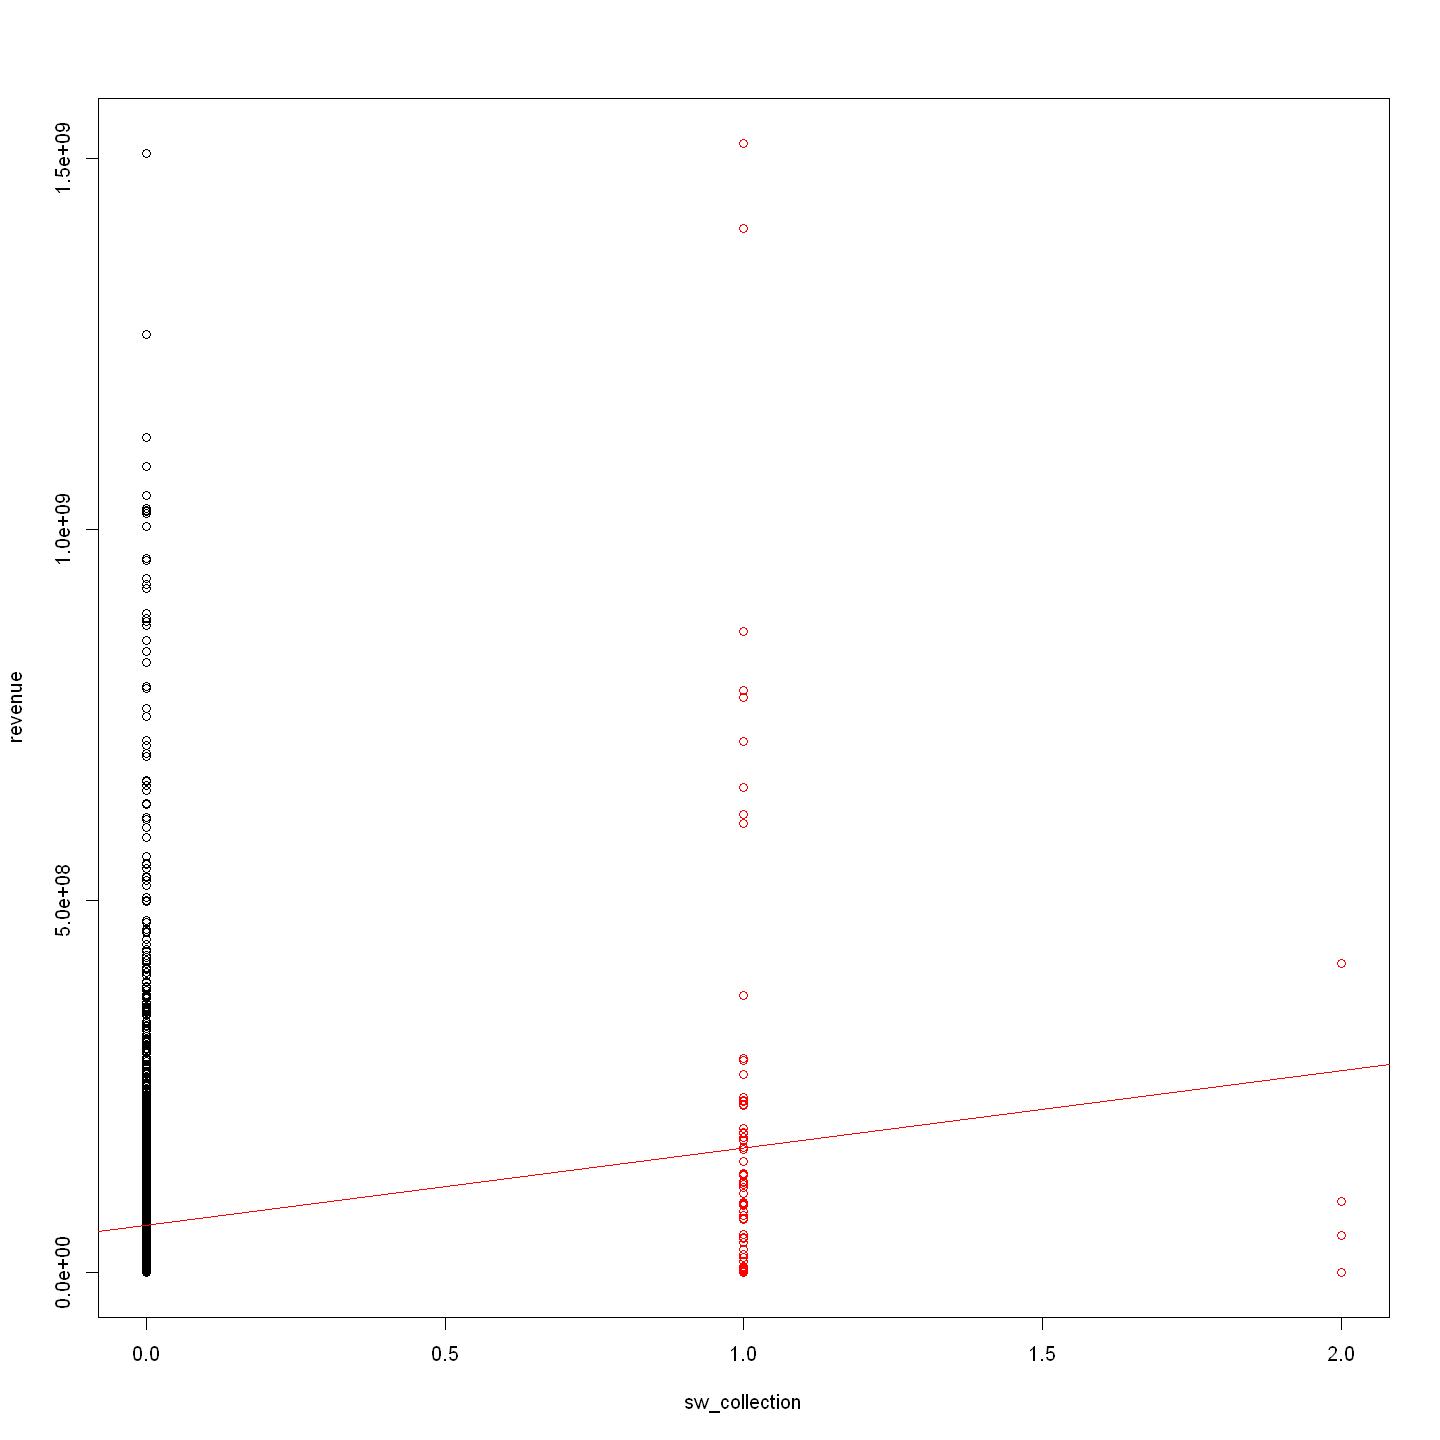

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


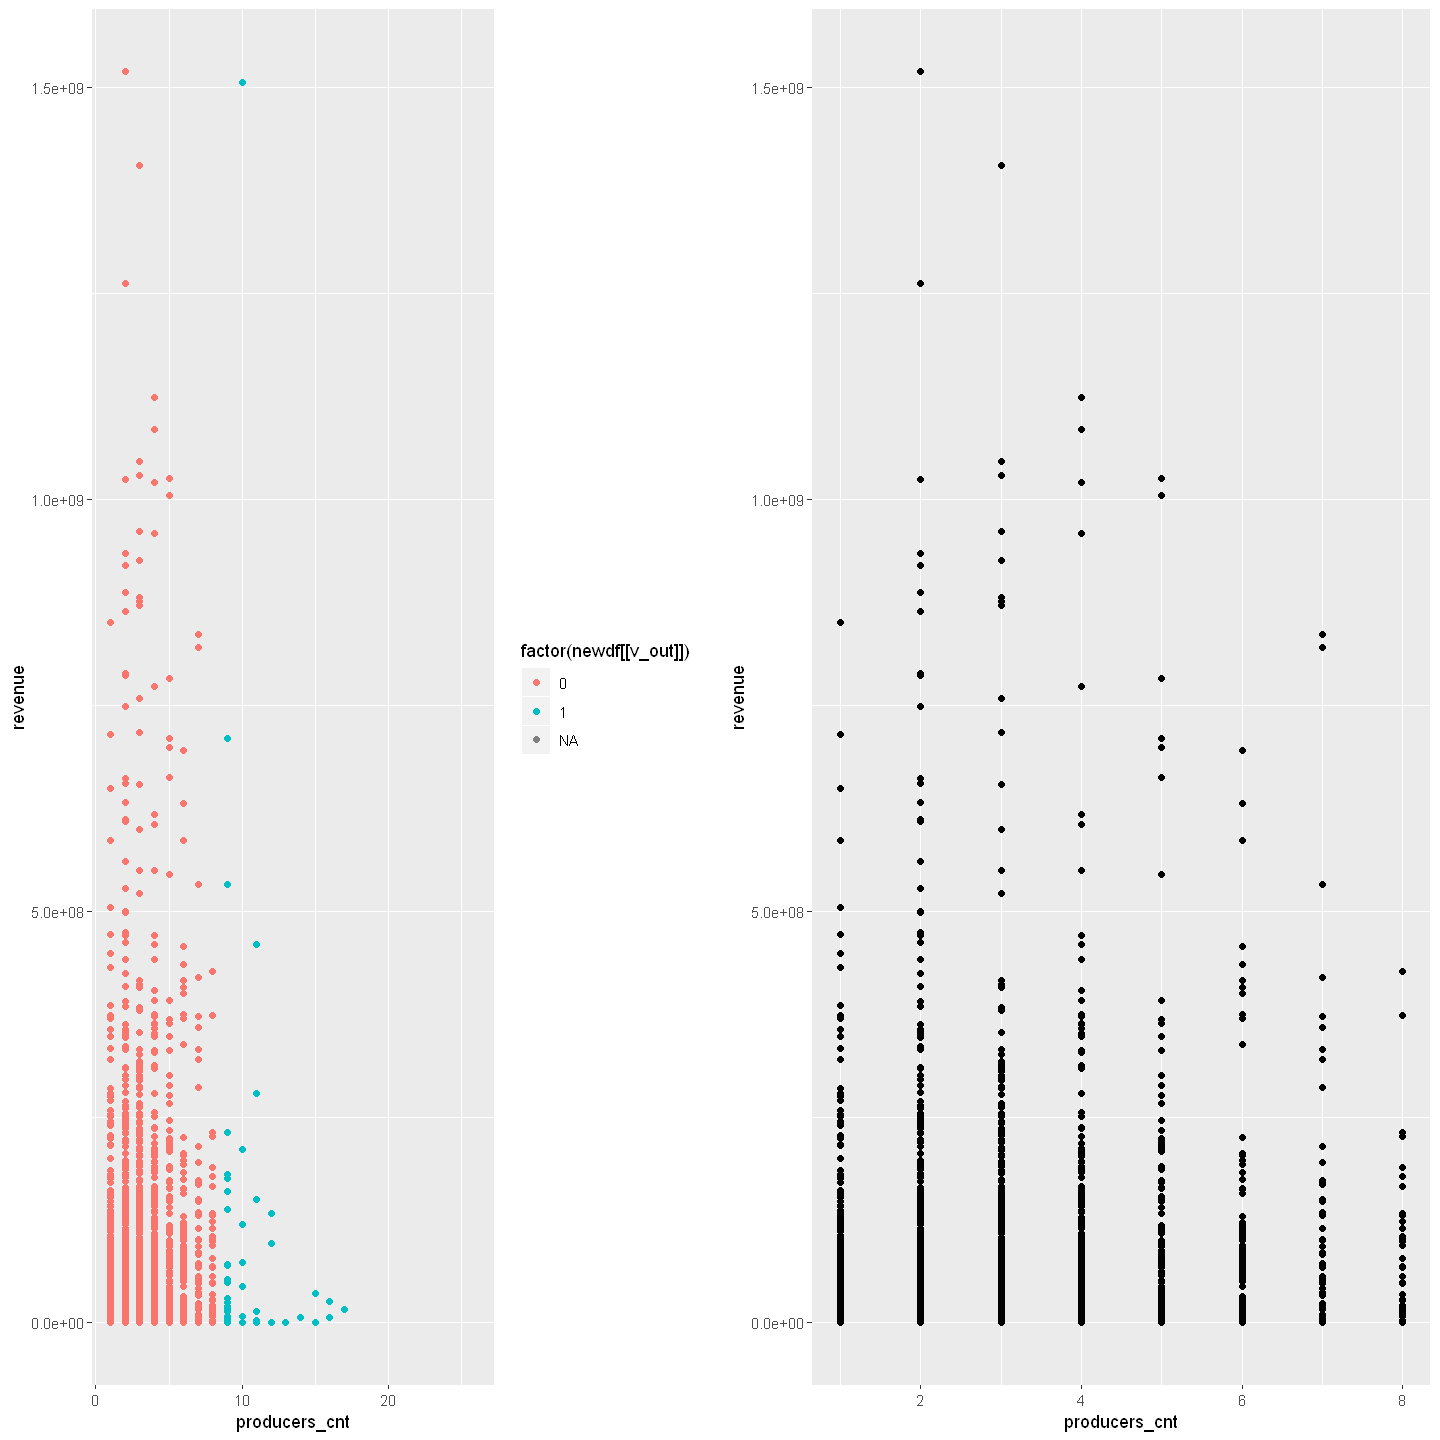

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 5156 rows containing missing values (geom_point)."


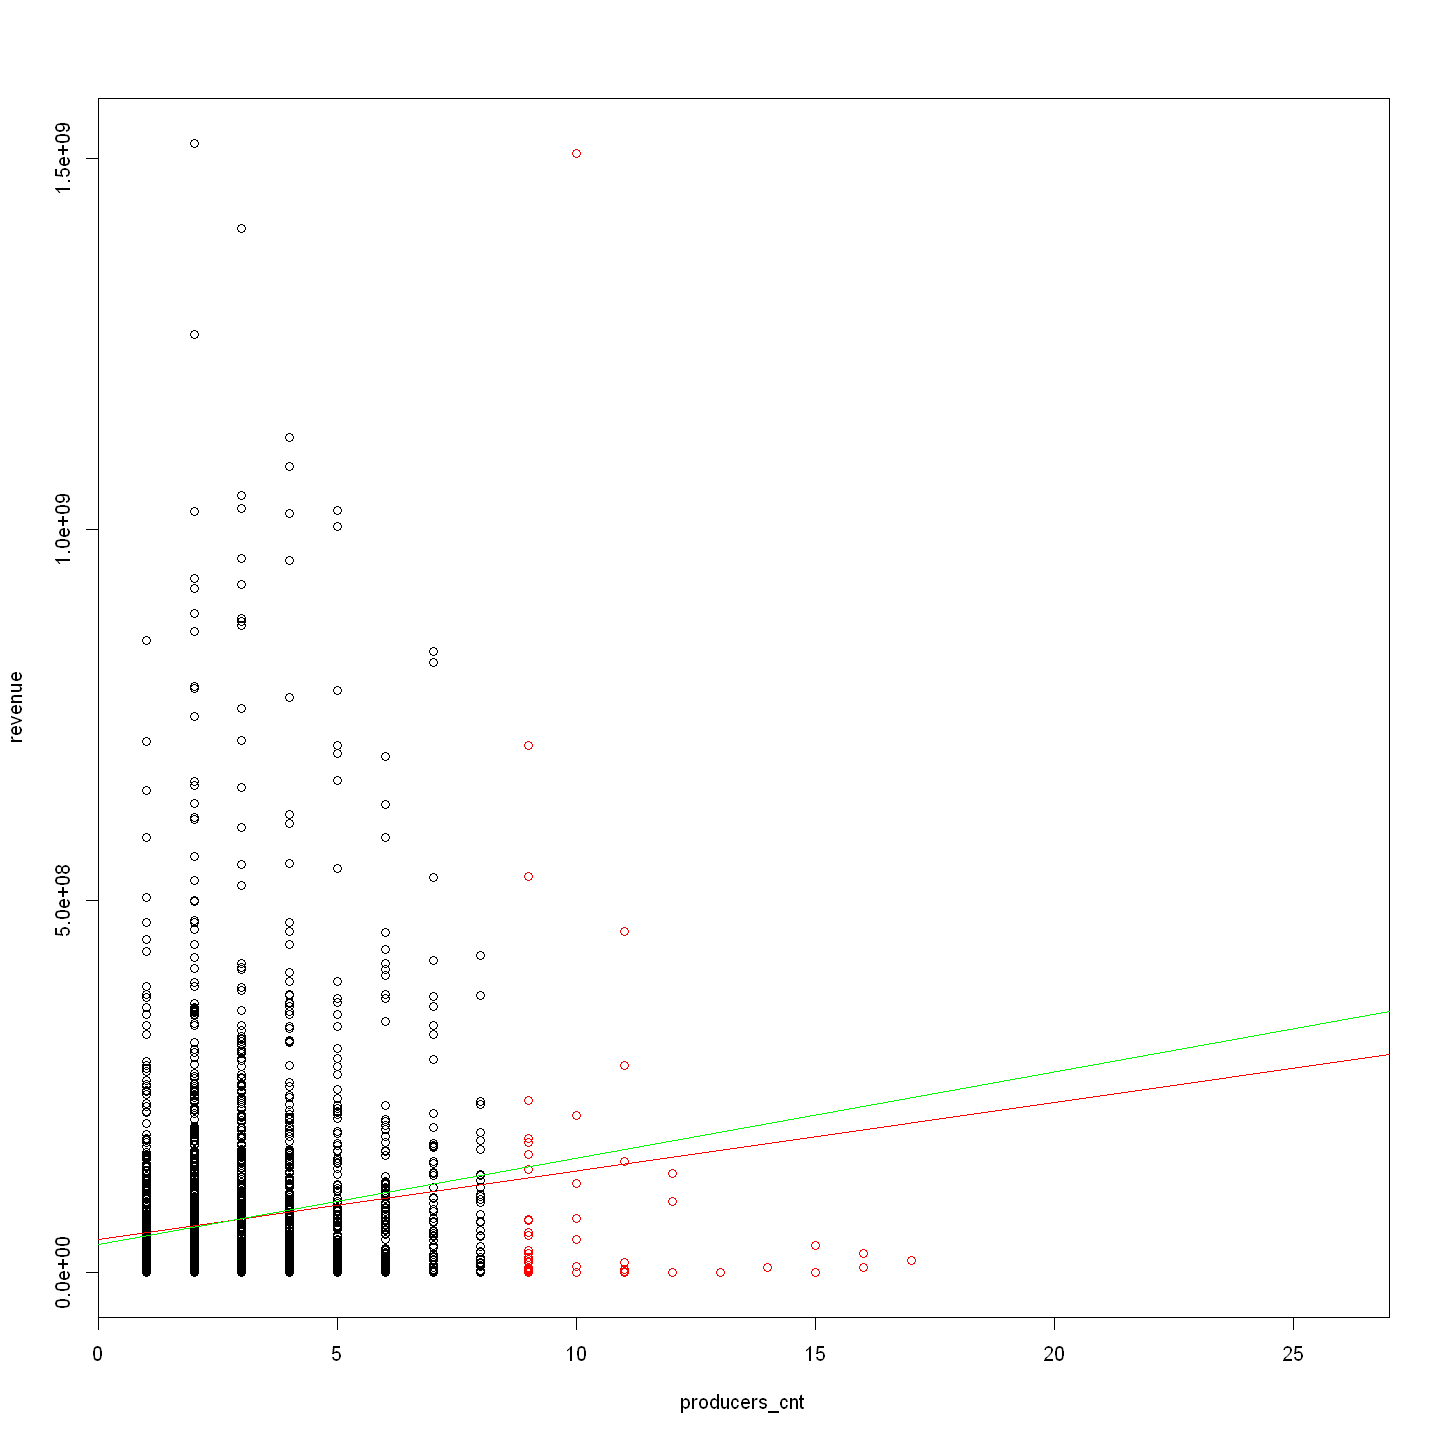

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


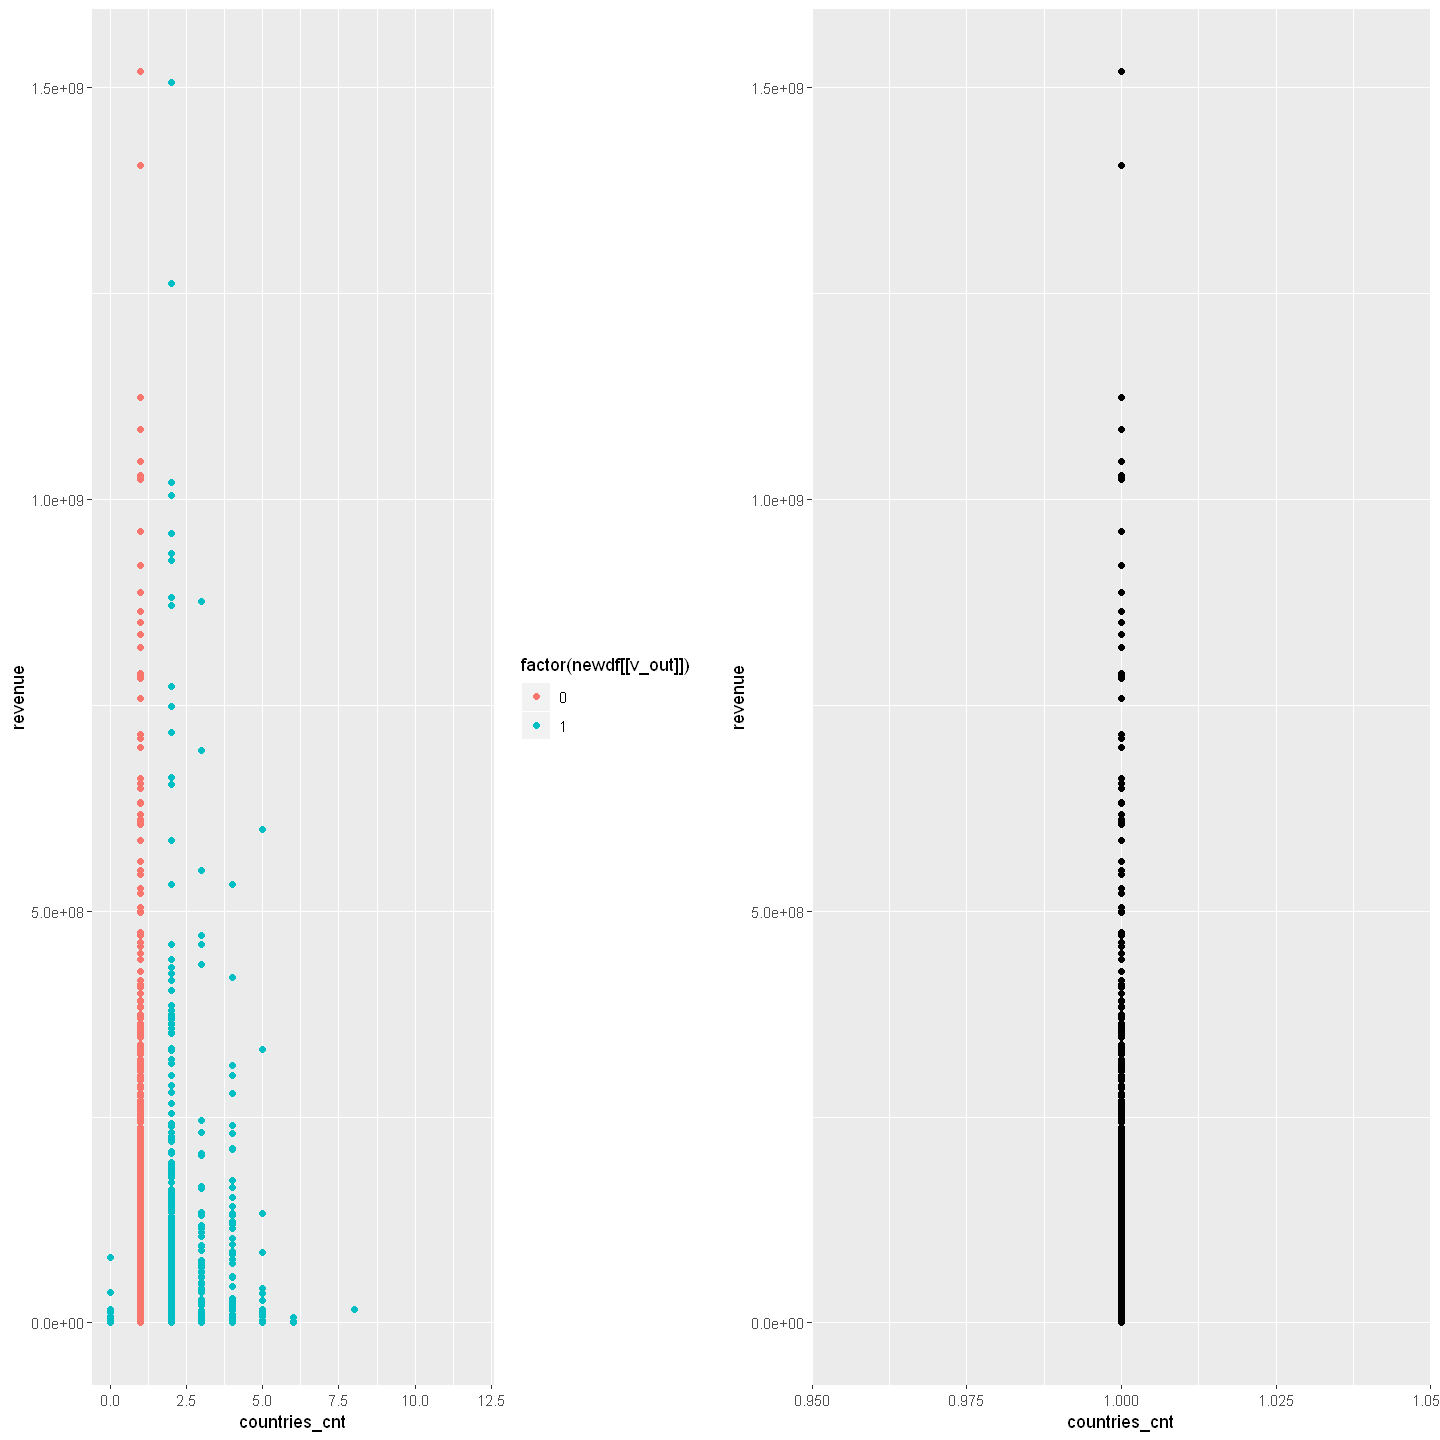

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4757 rows containing missing values (geom_point)."


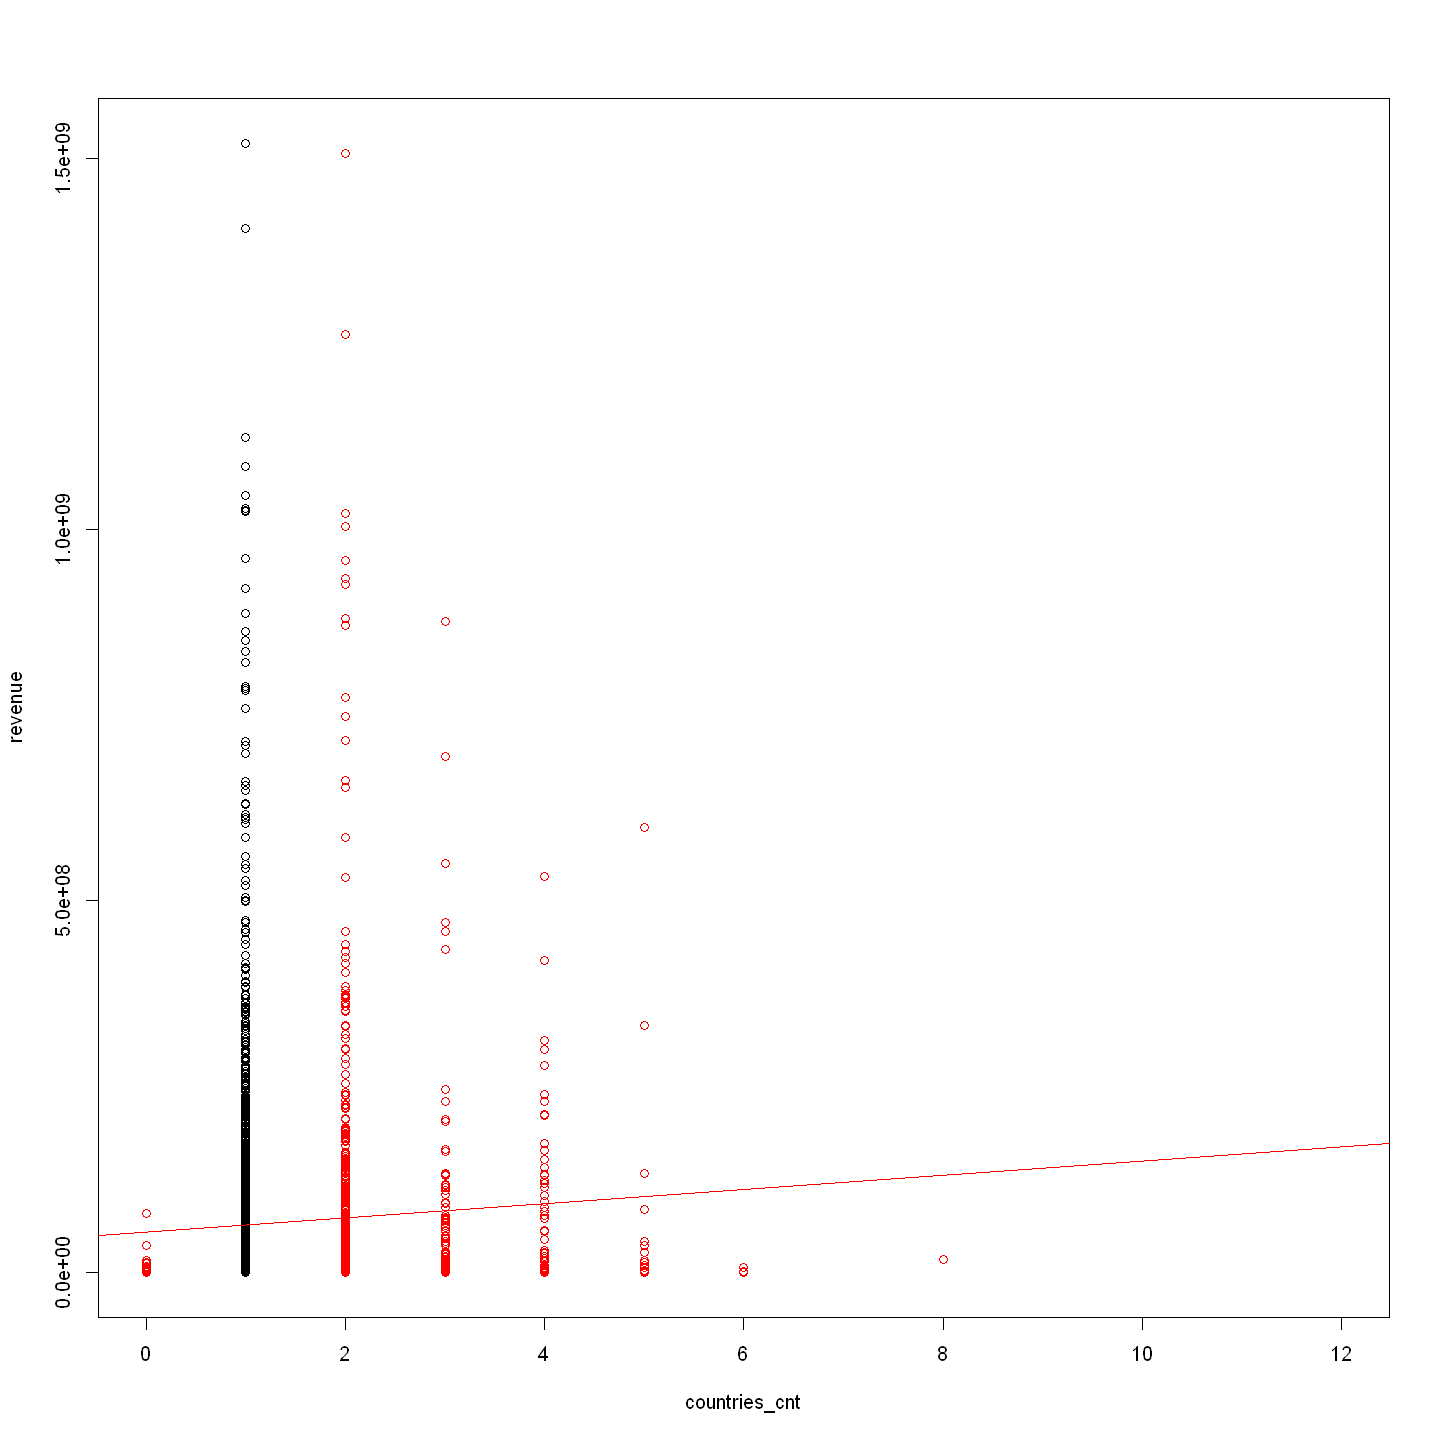

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


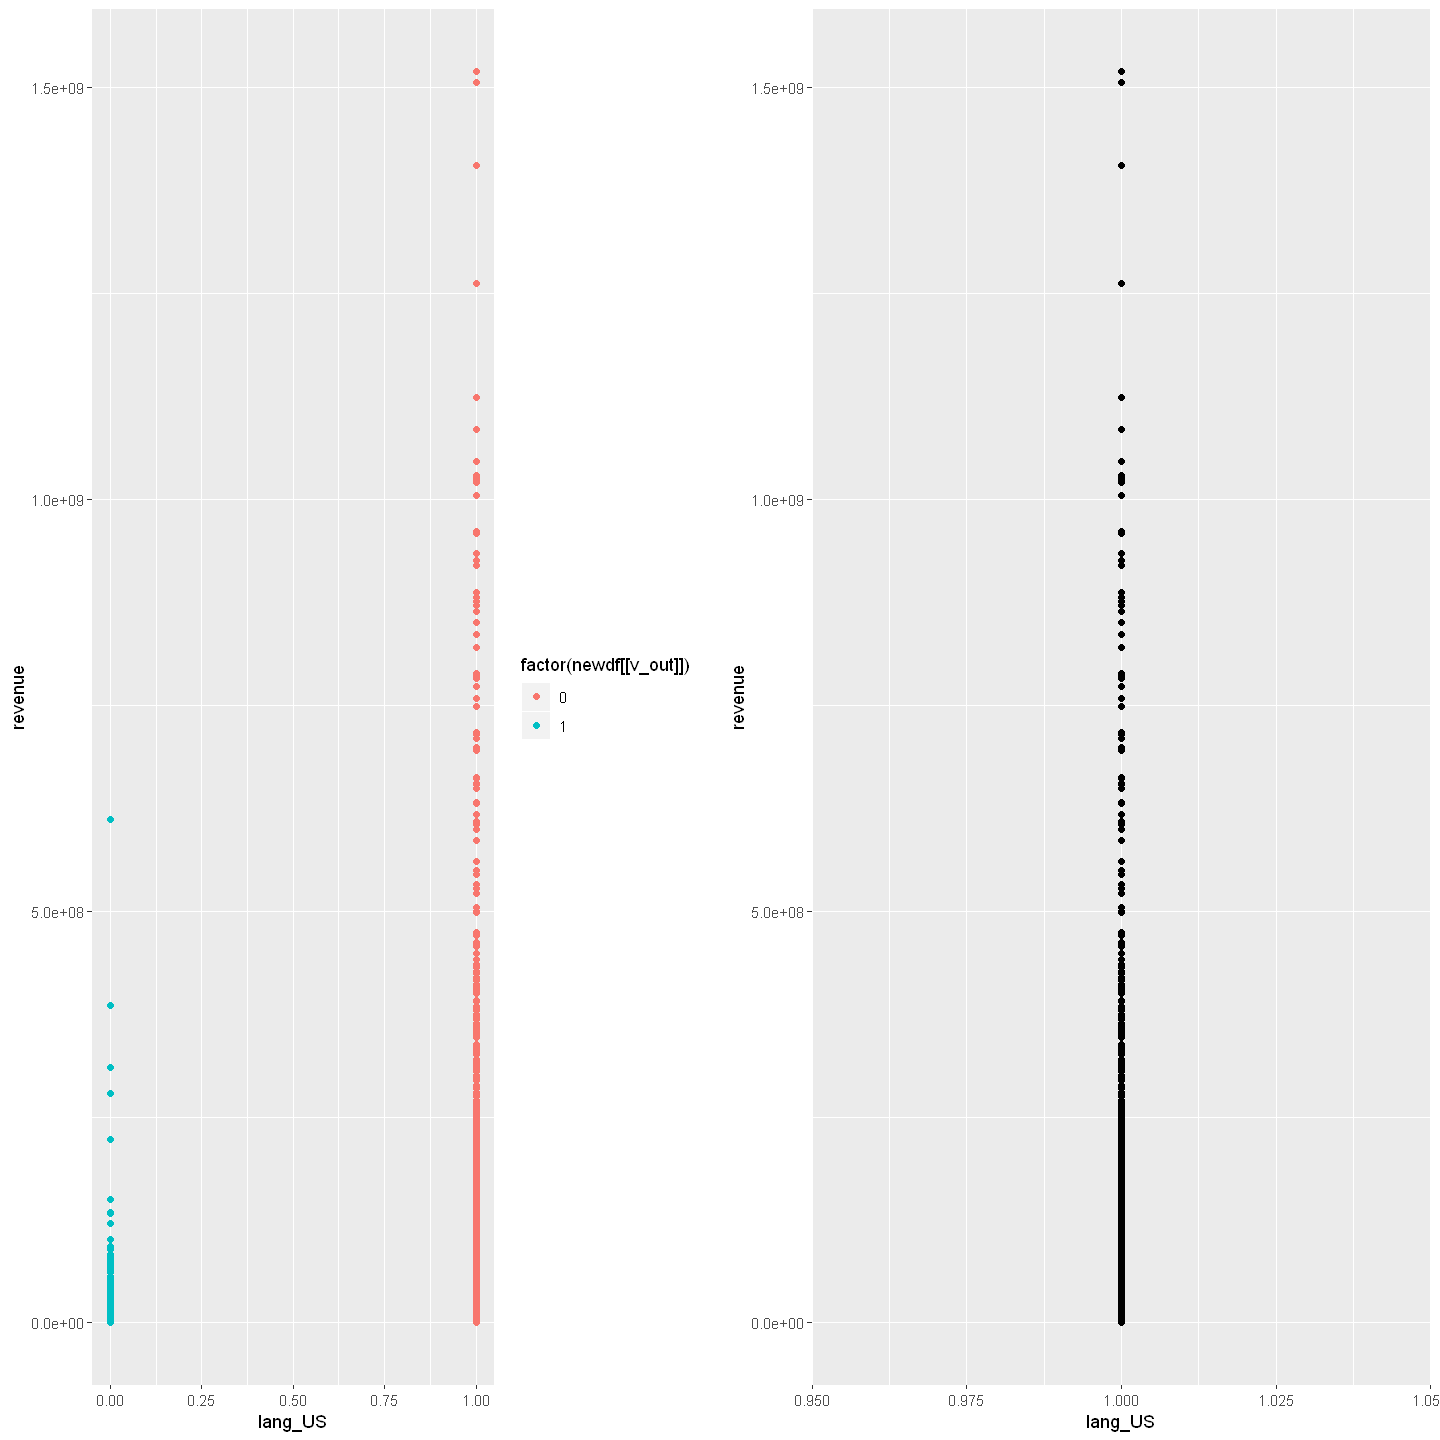

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4670 rows containing missing values (geom_point)."


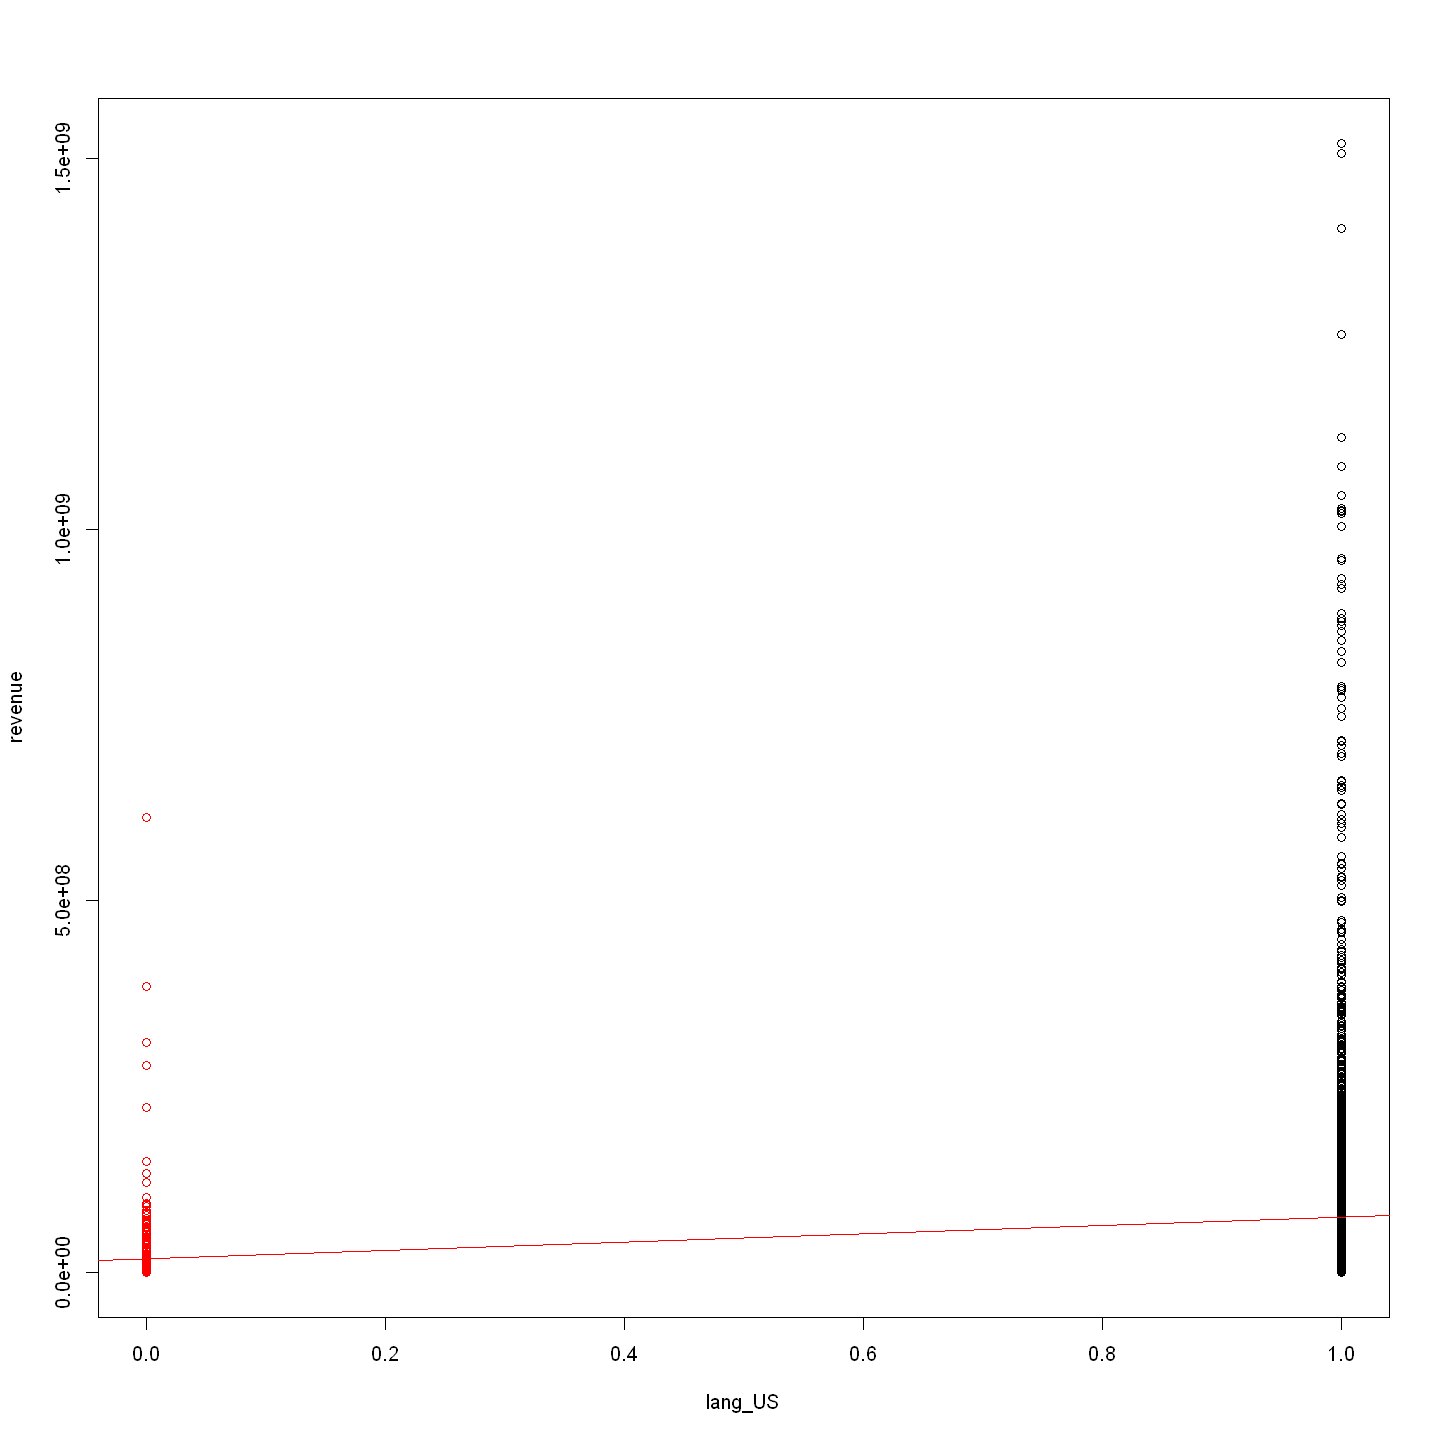

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


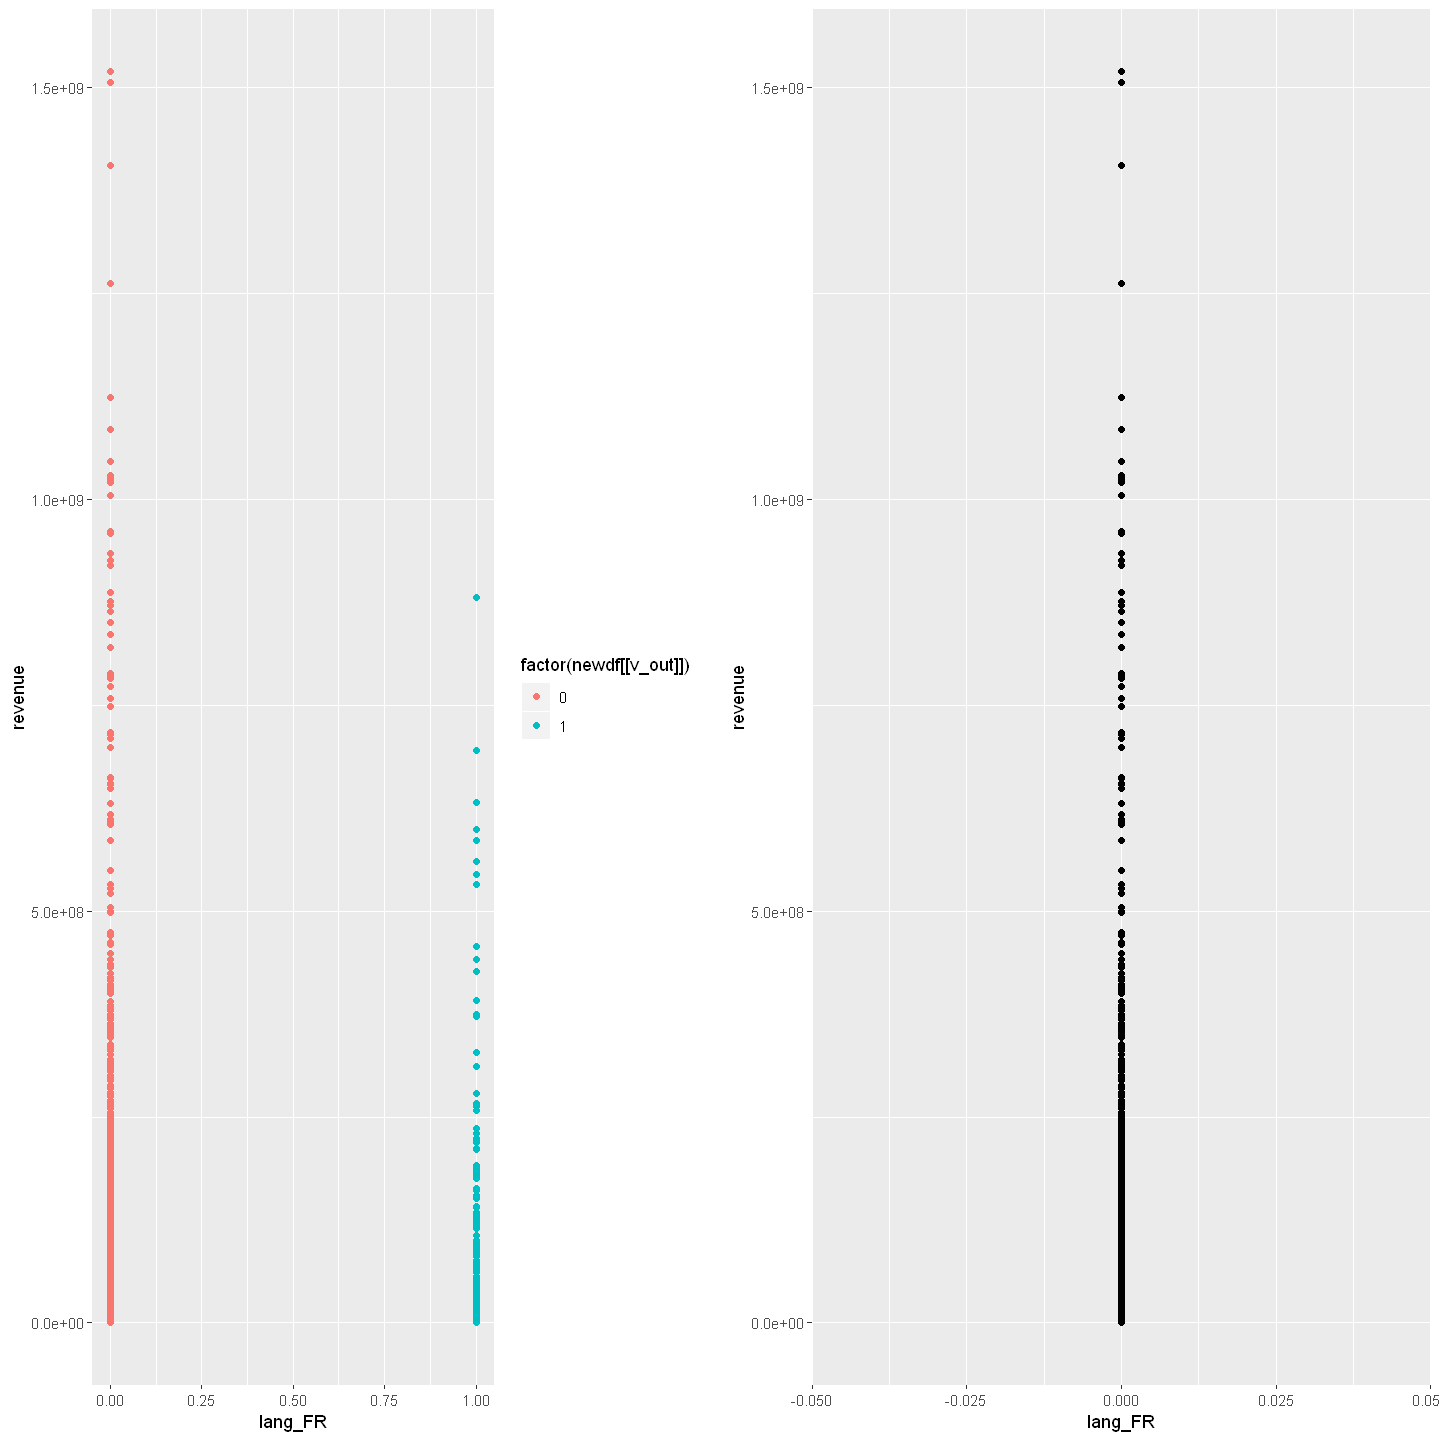

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4531 rows containing missing values (geom_point)."


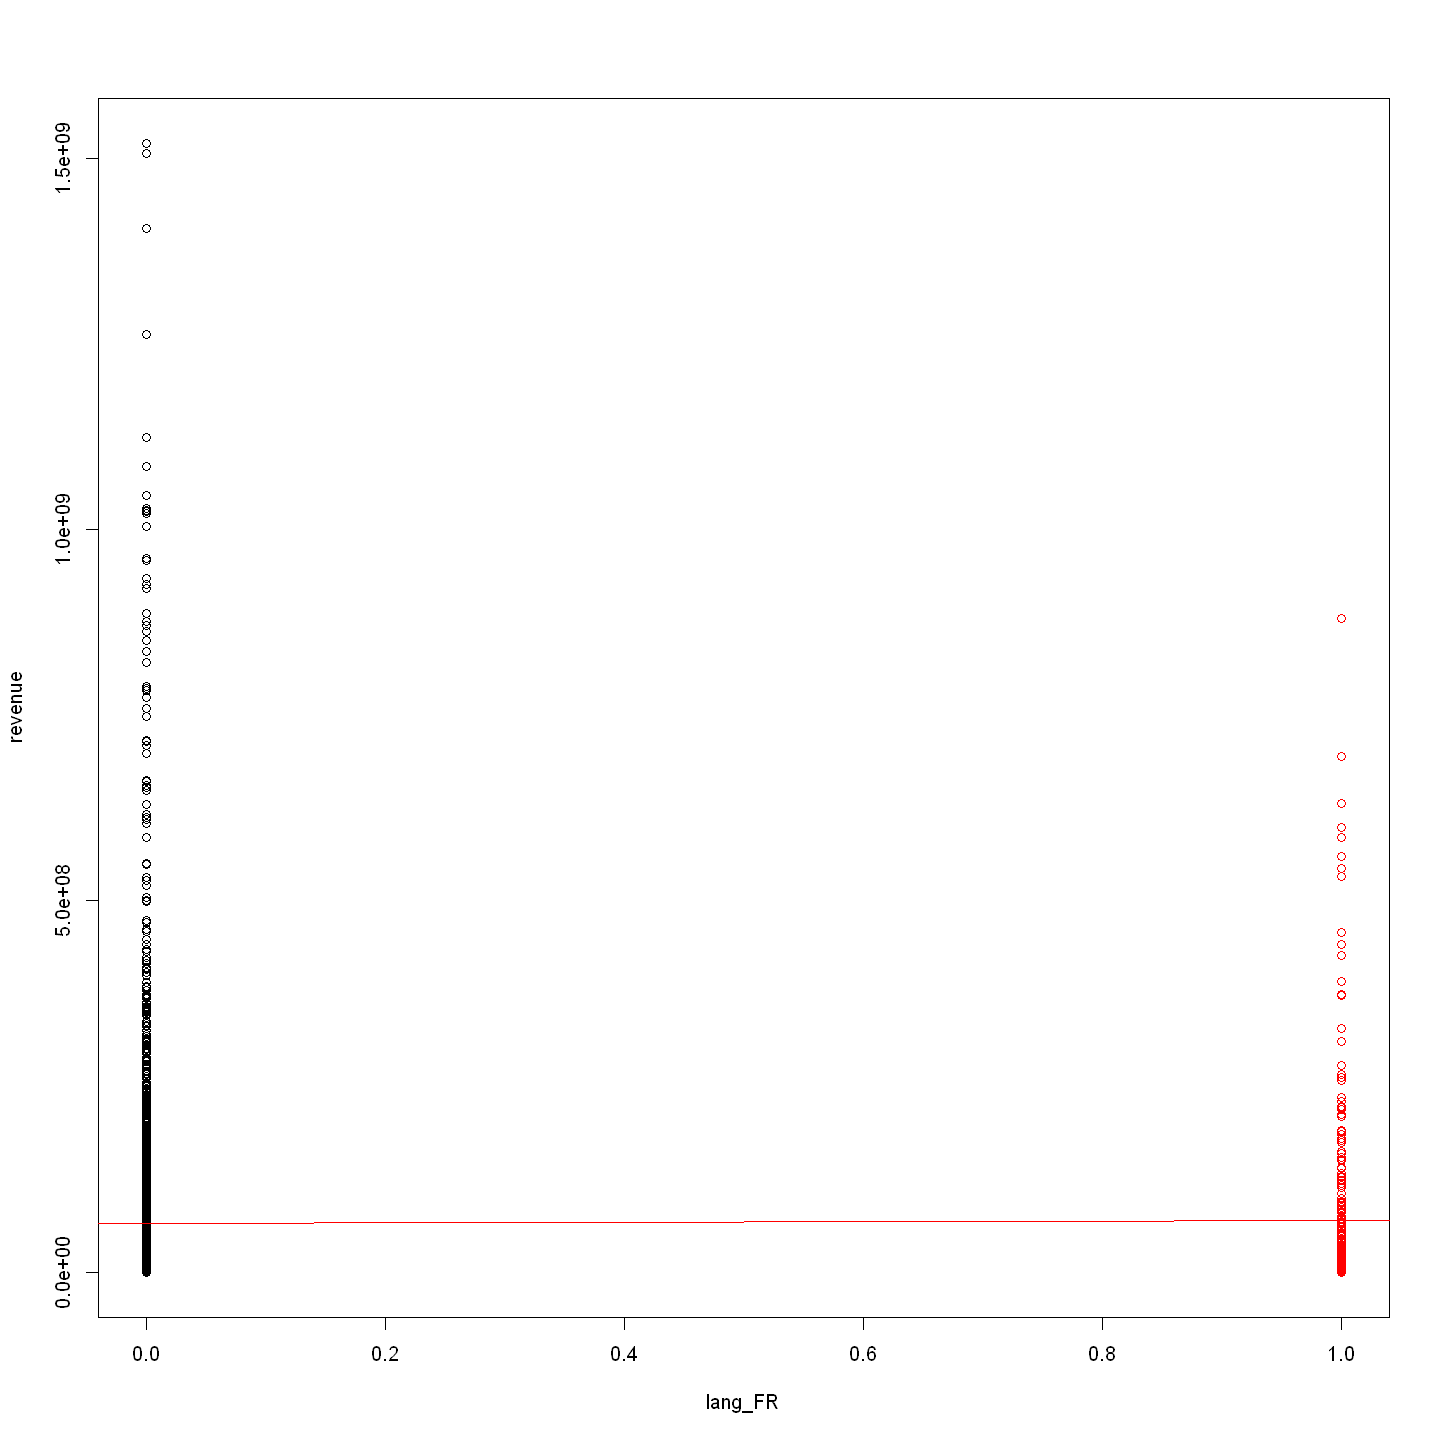

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


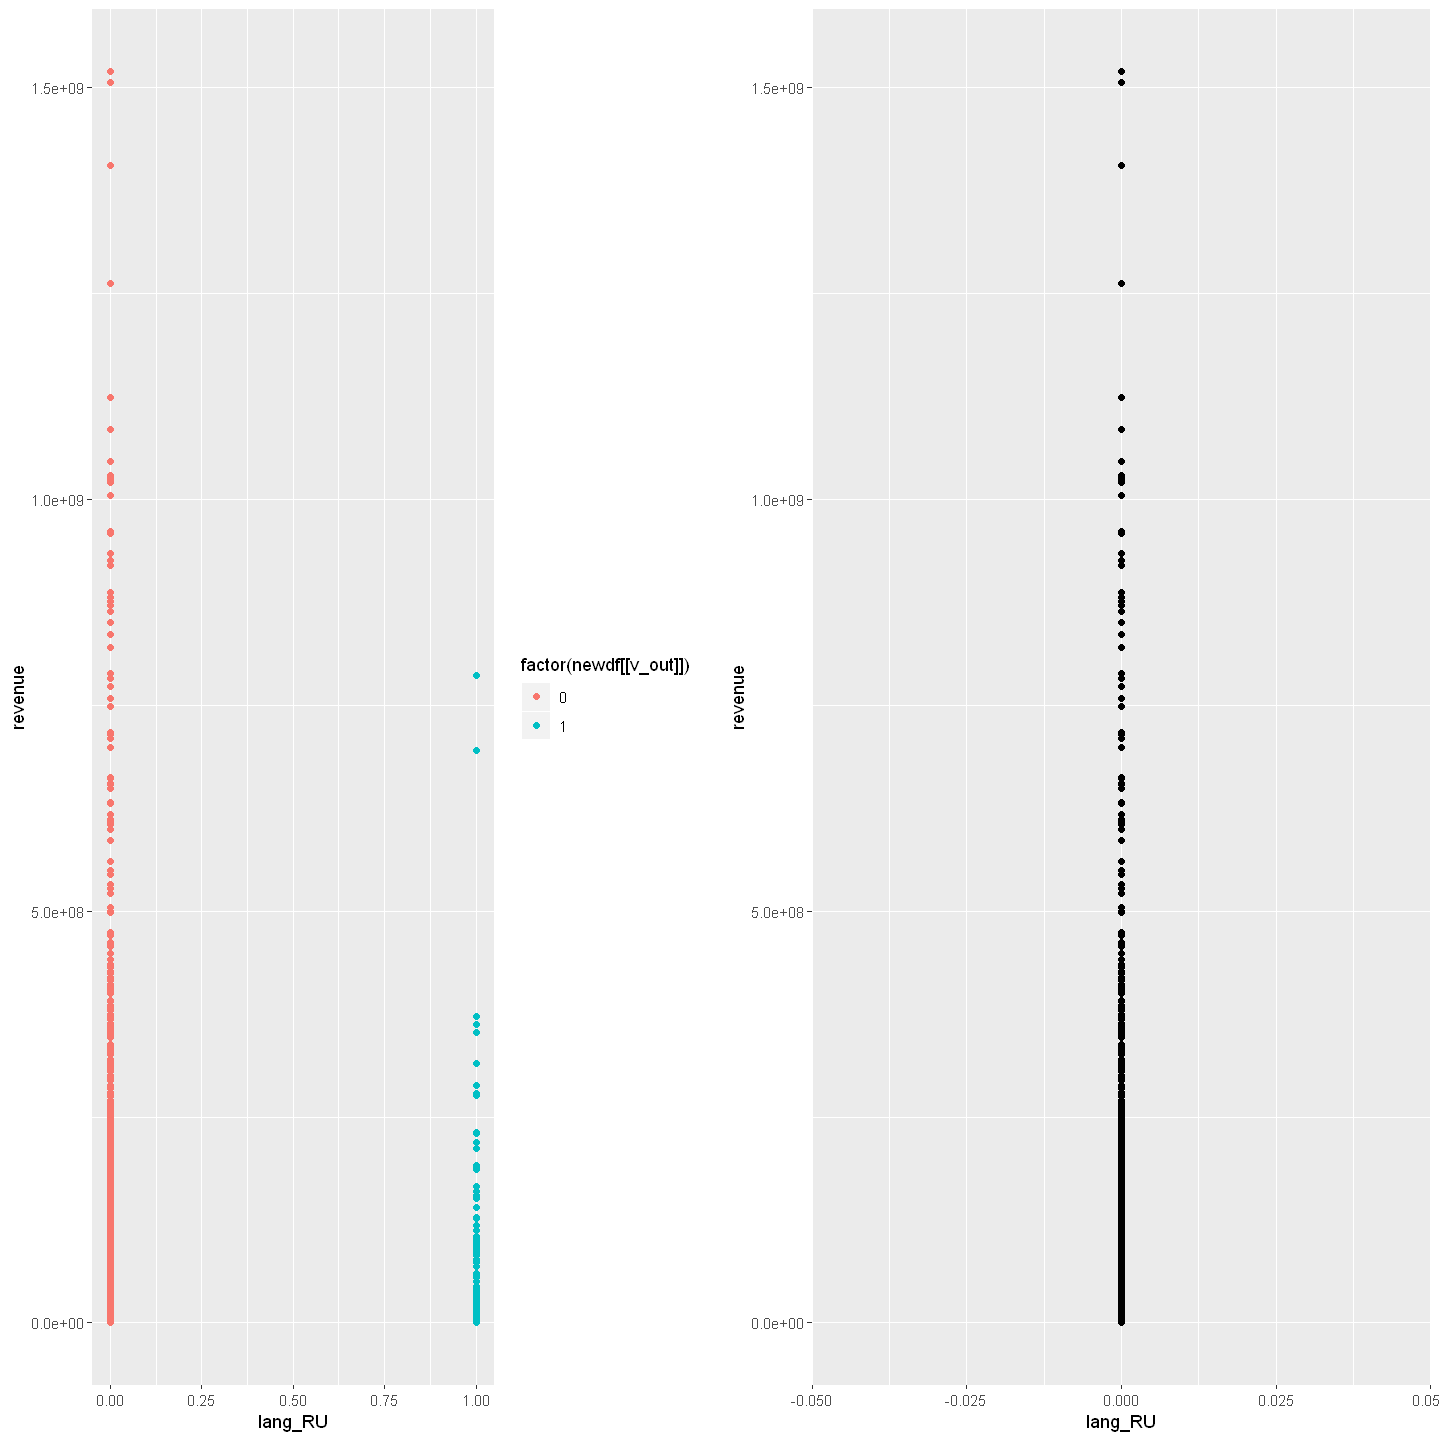

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4621 rows containing missing values (geom_point)."


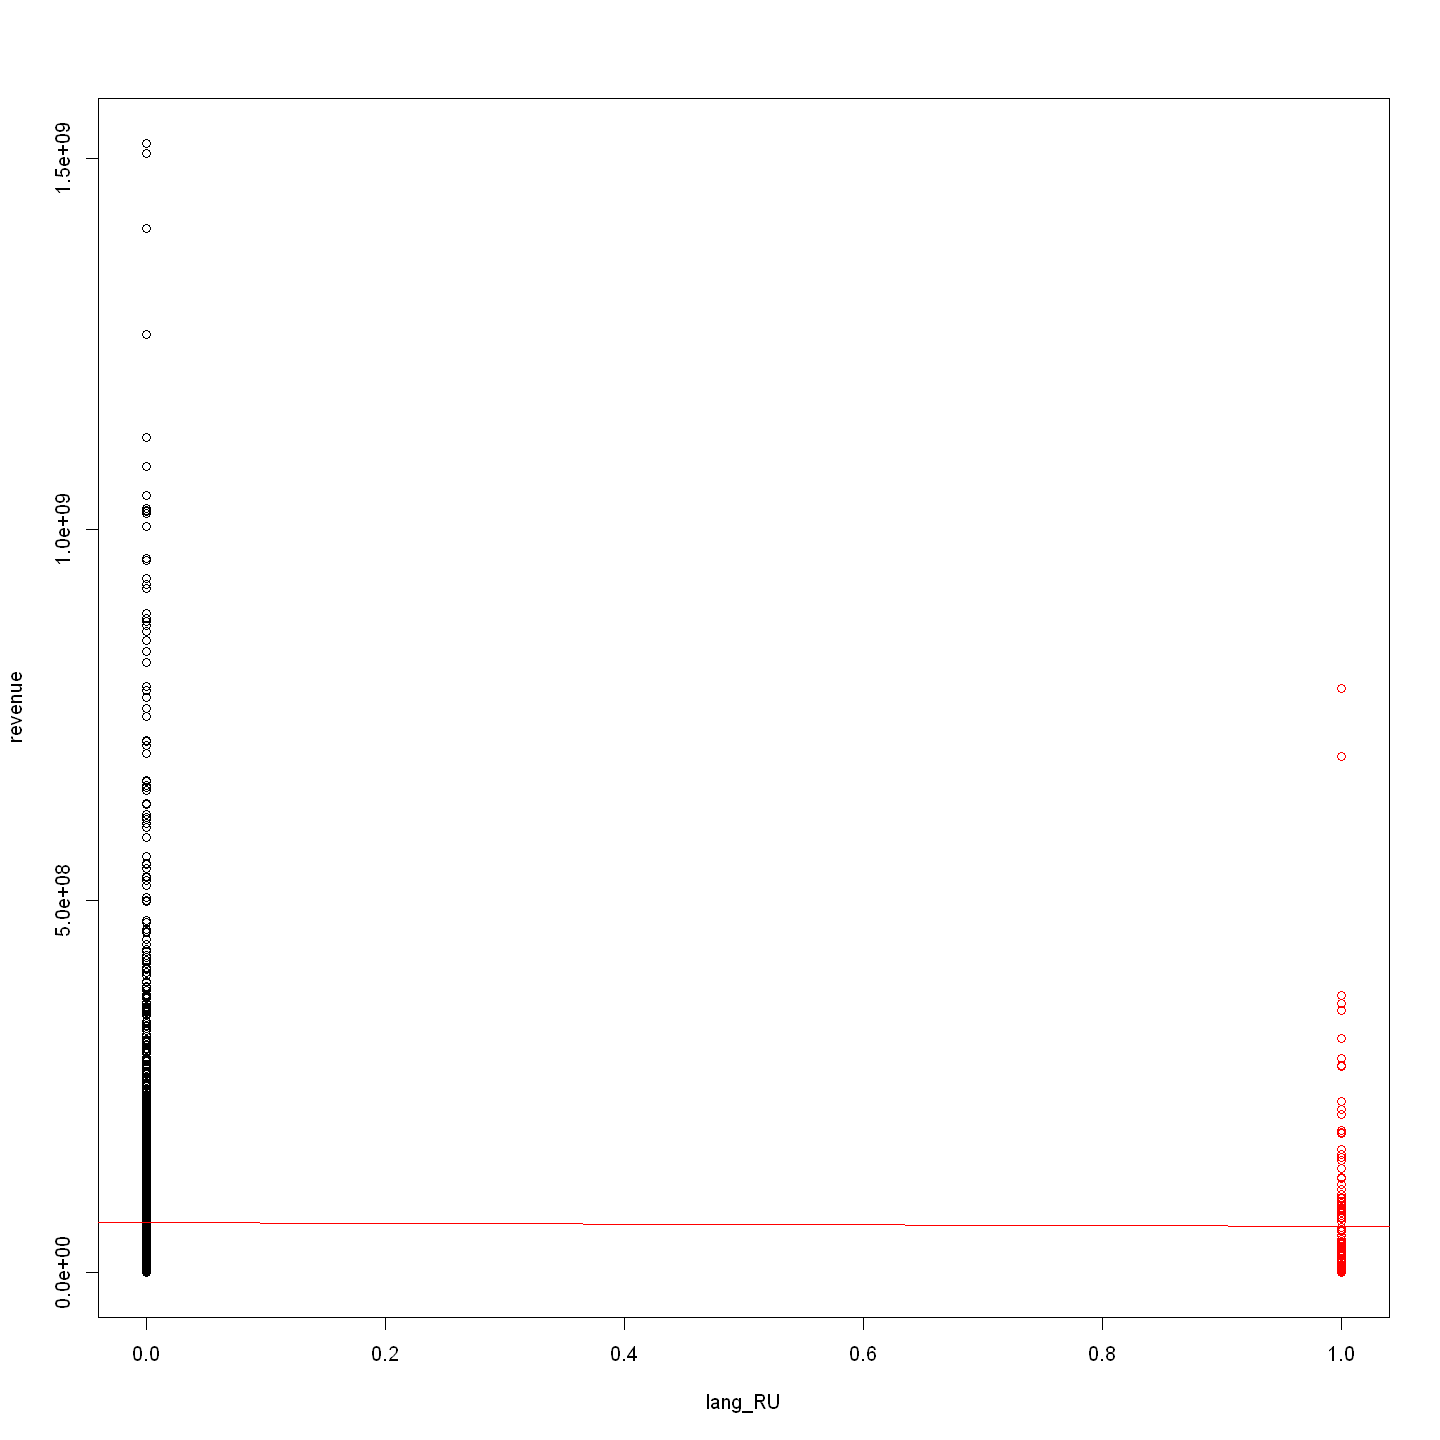

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


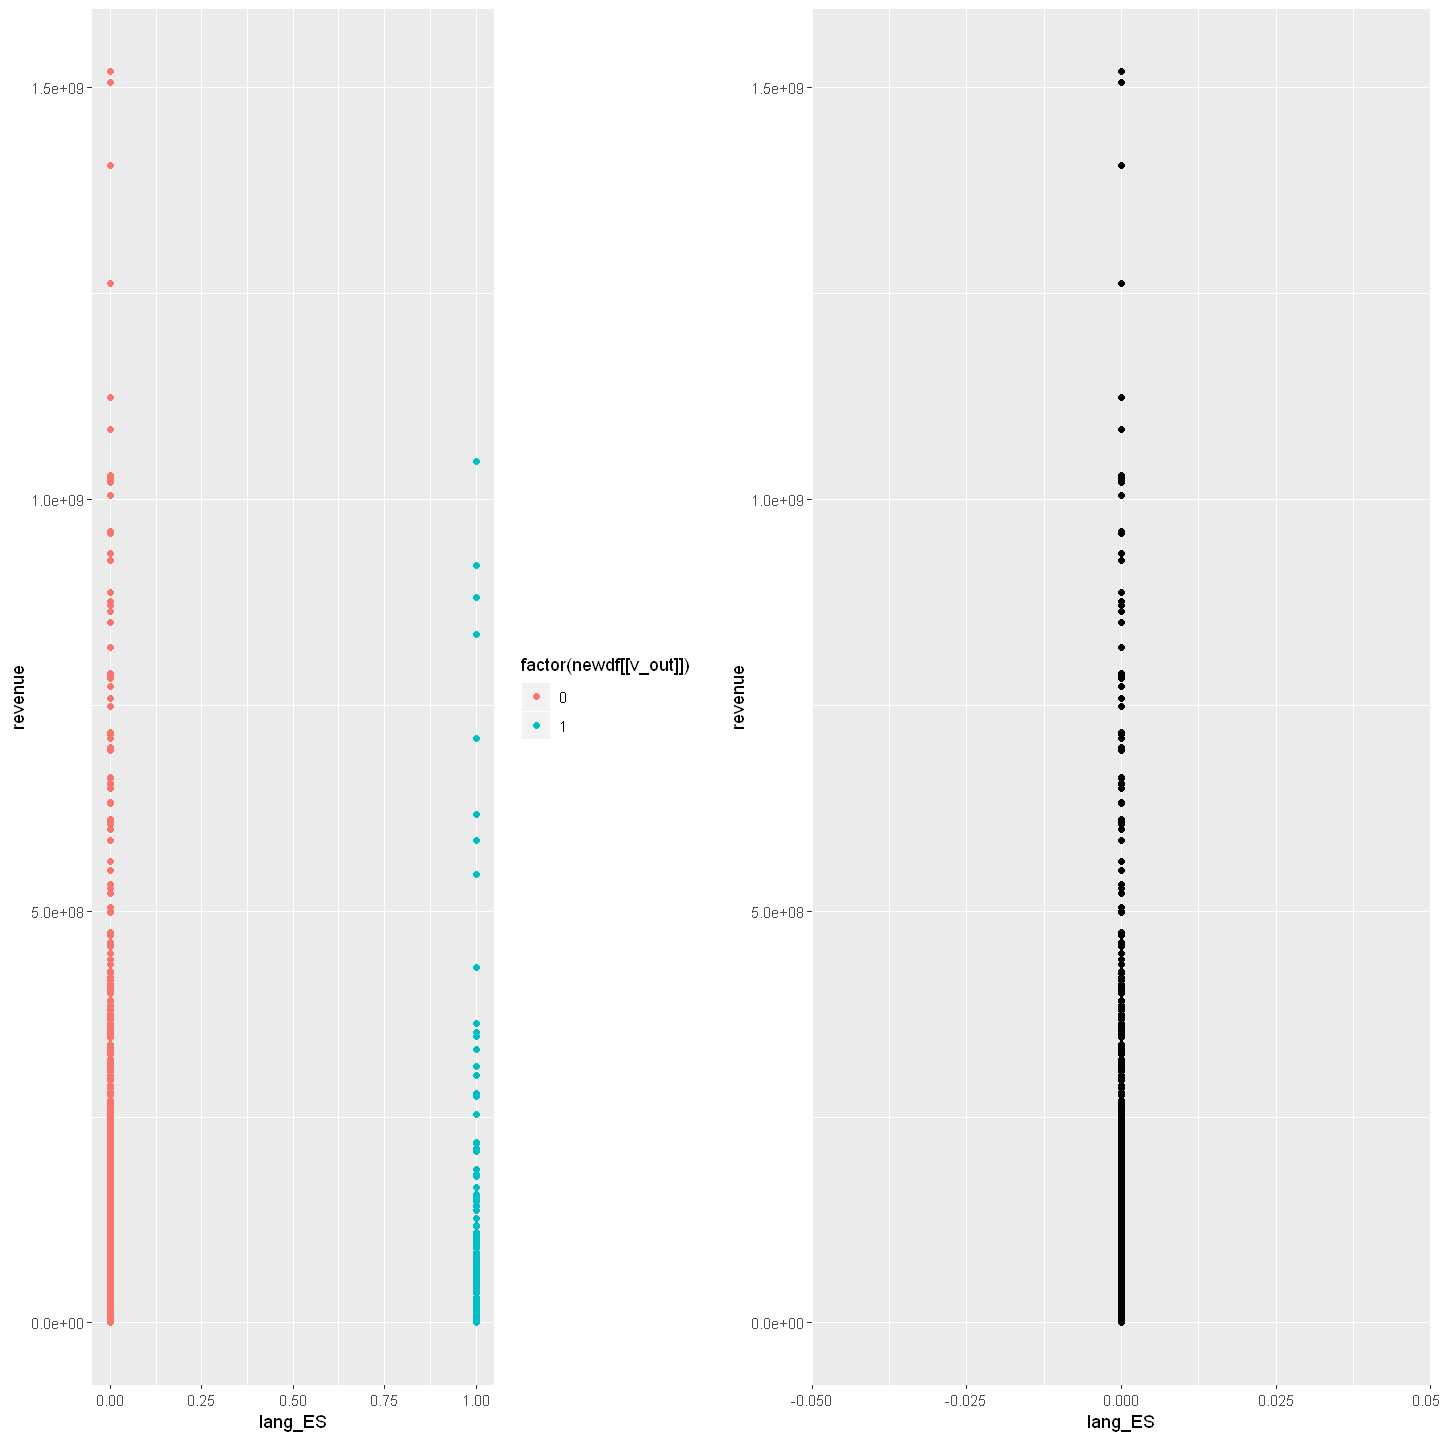

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4471 rows containing missing values (geom_point)."


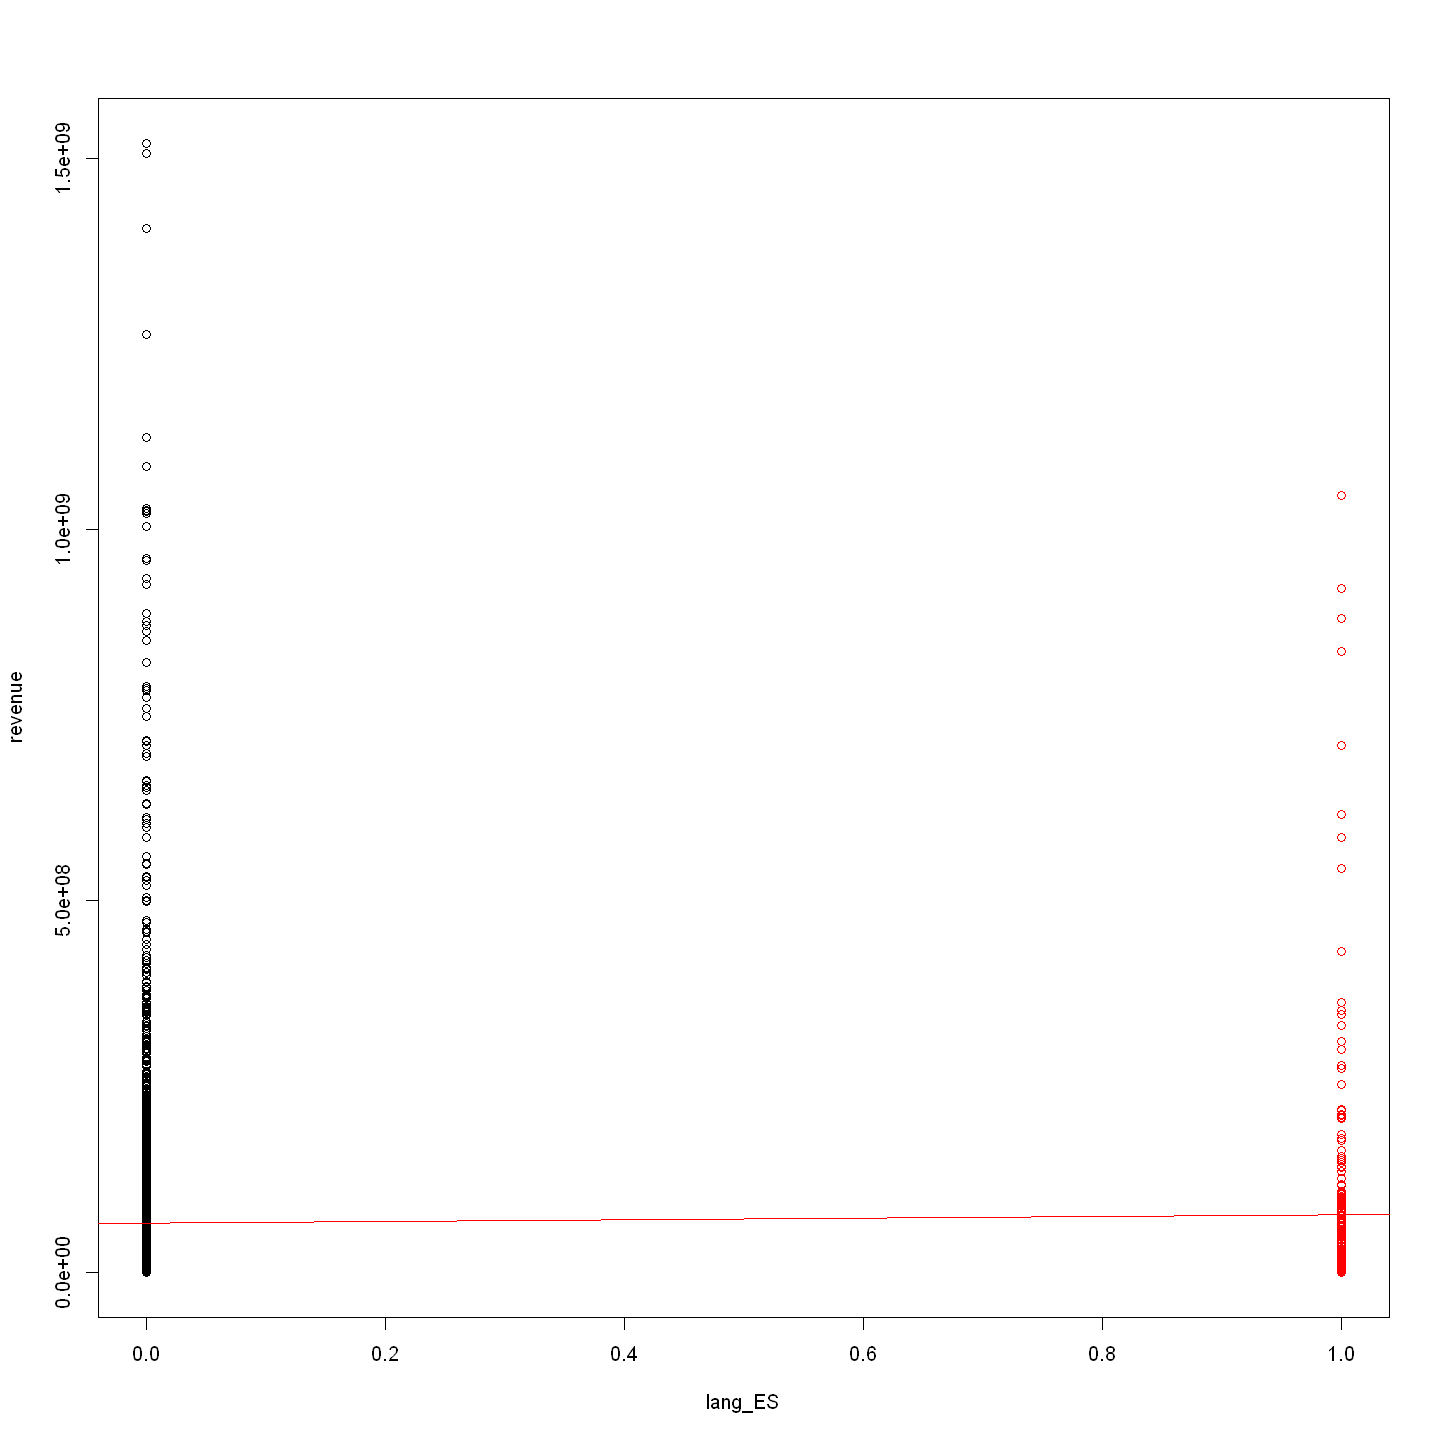

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


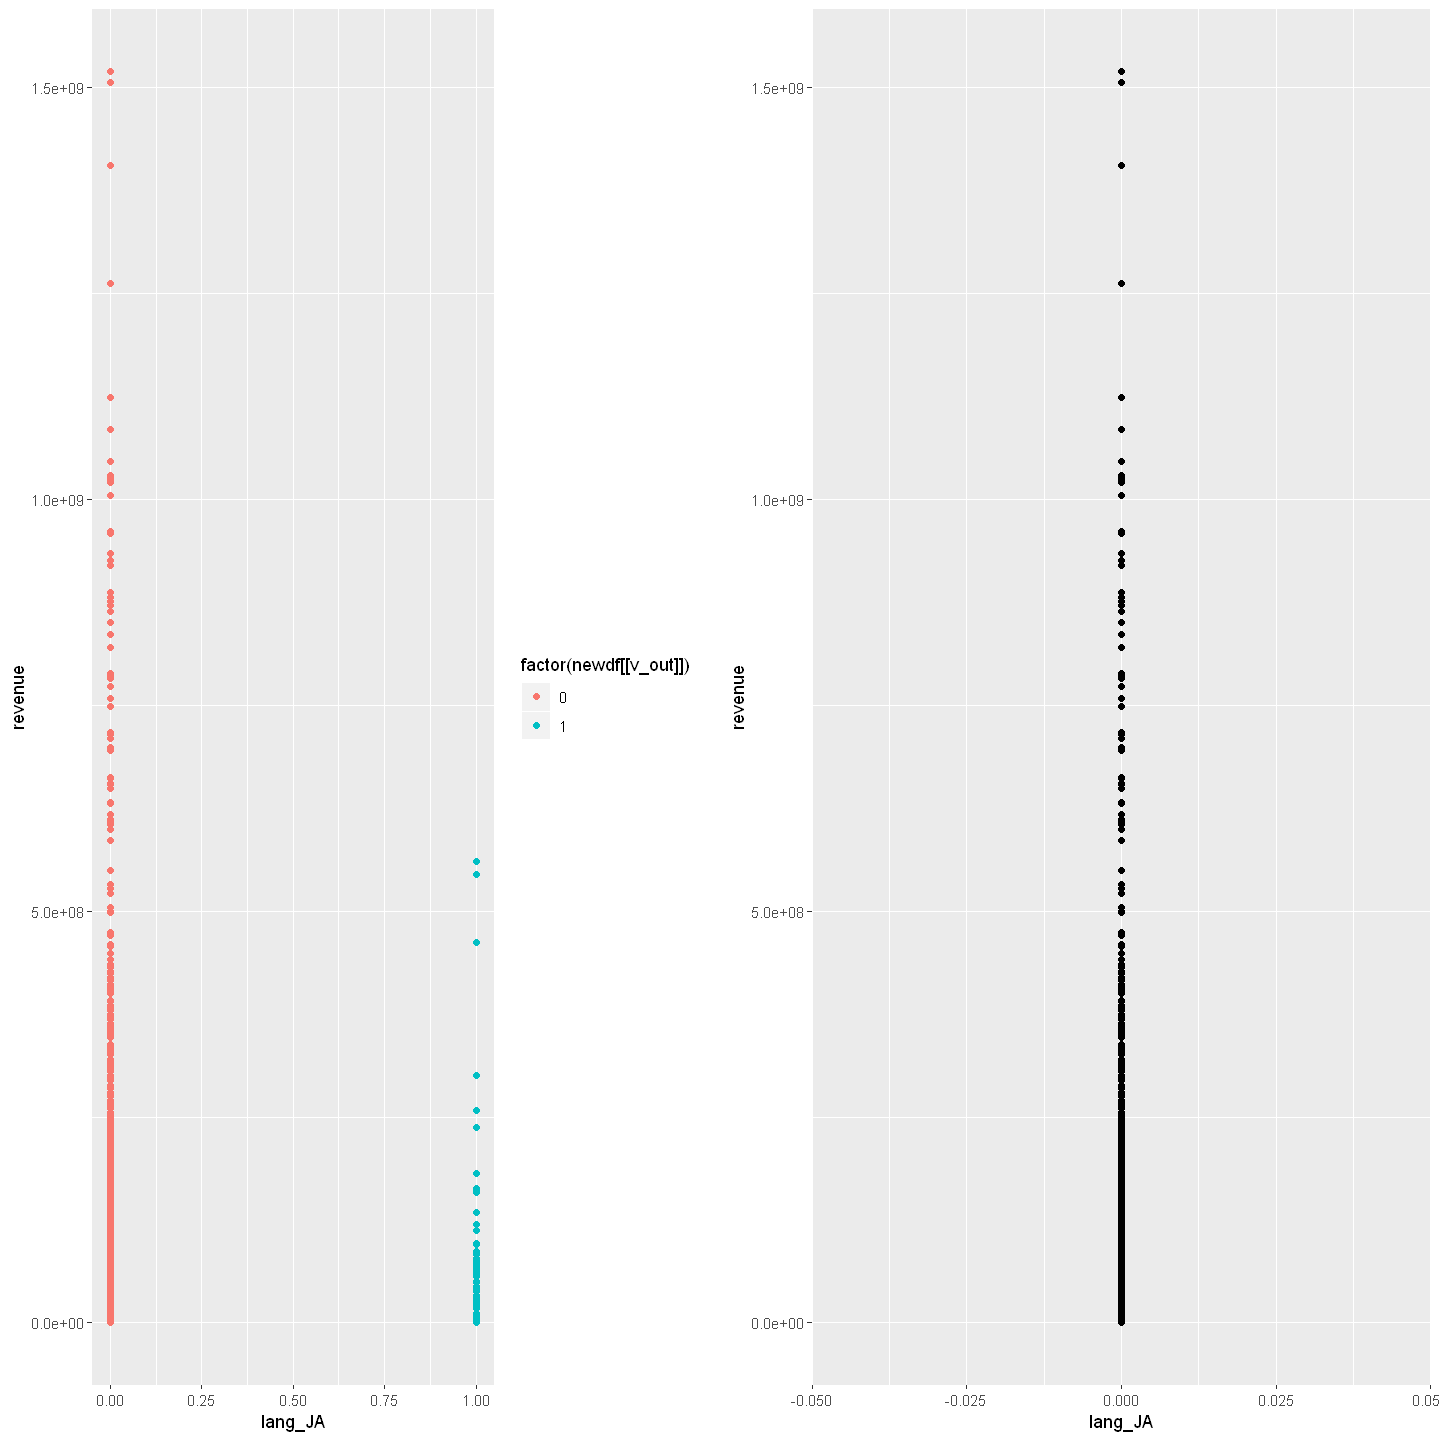

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4491 rows containing missing values (geom_point)."


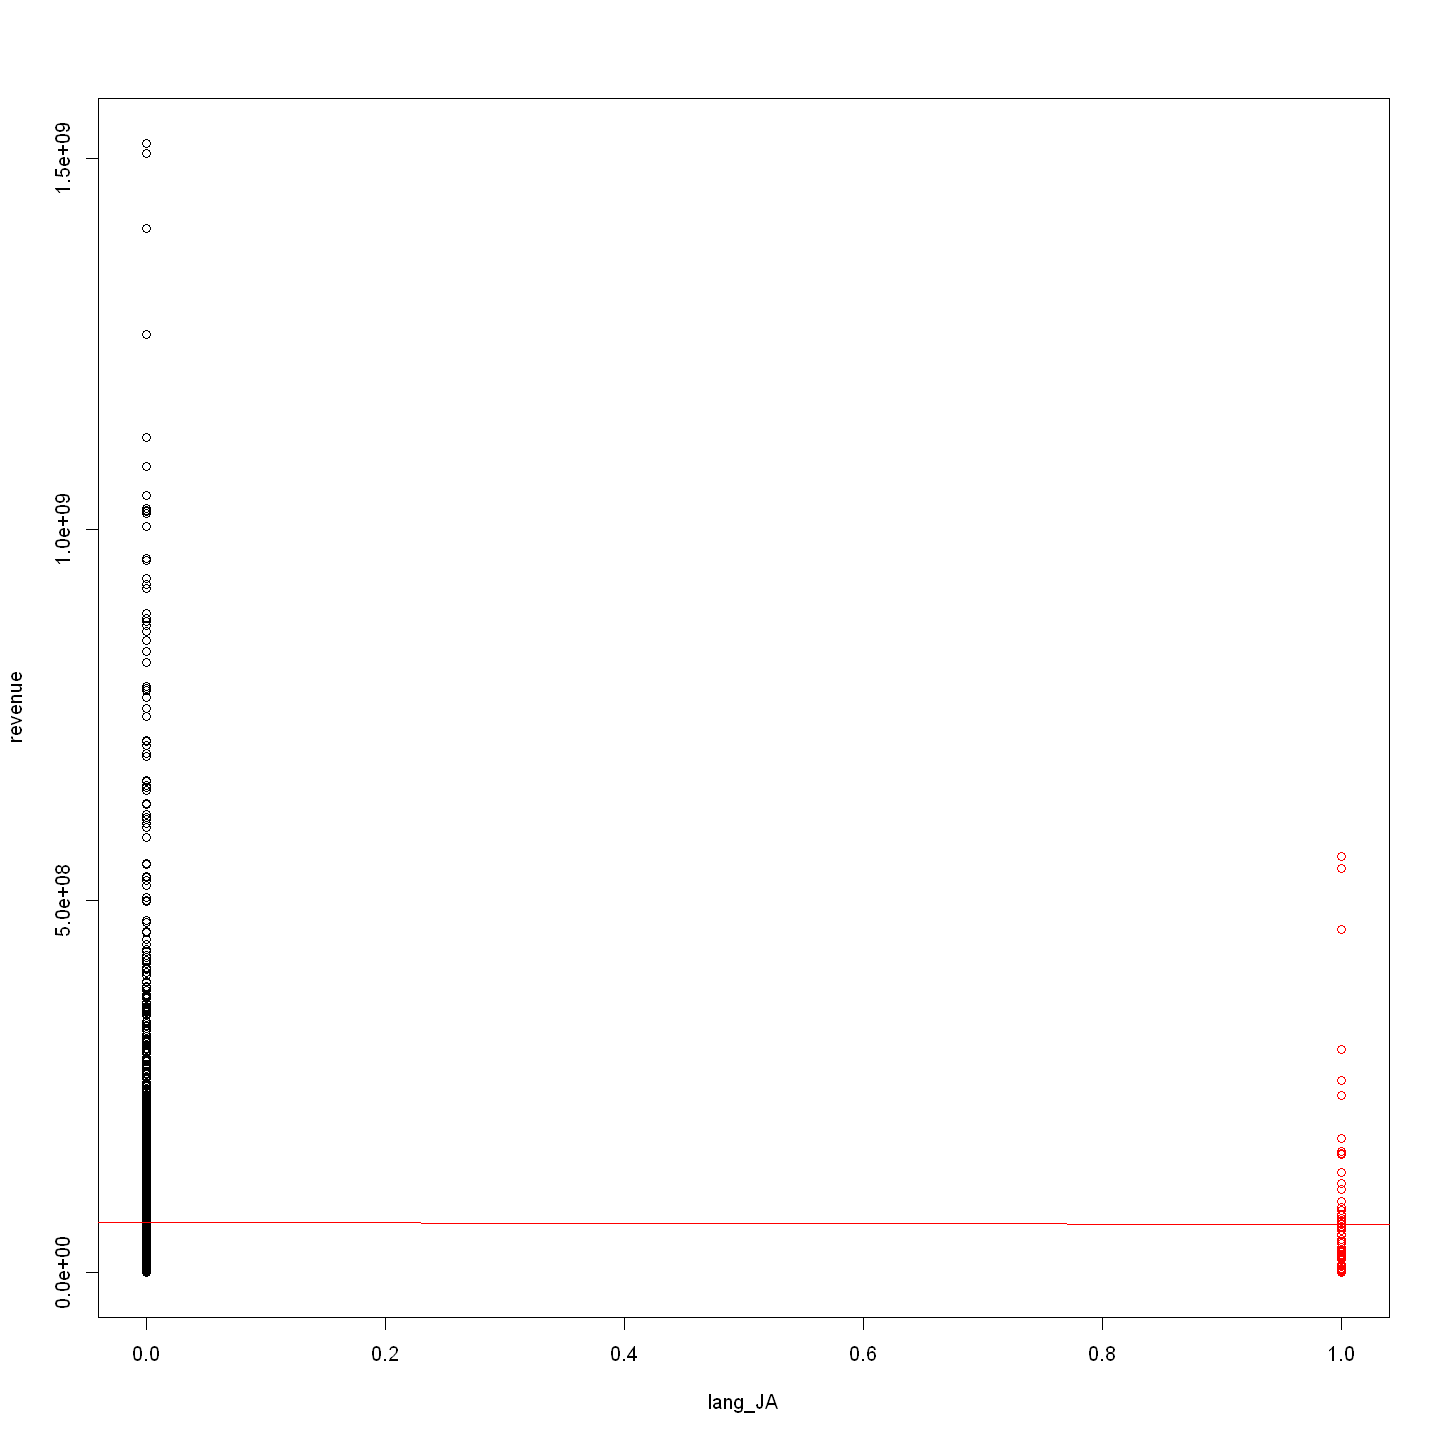

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


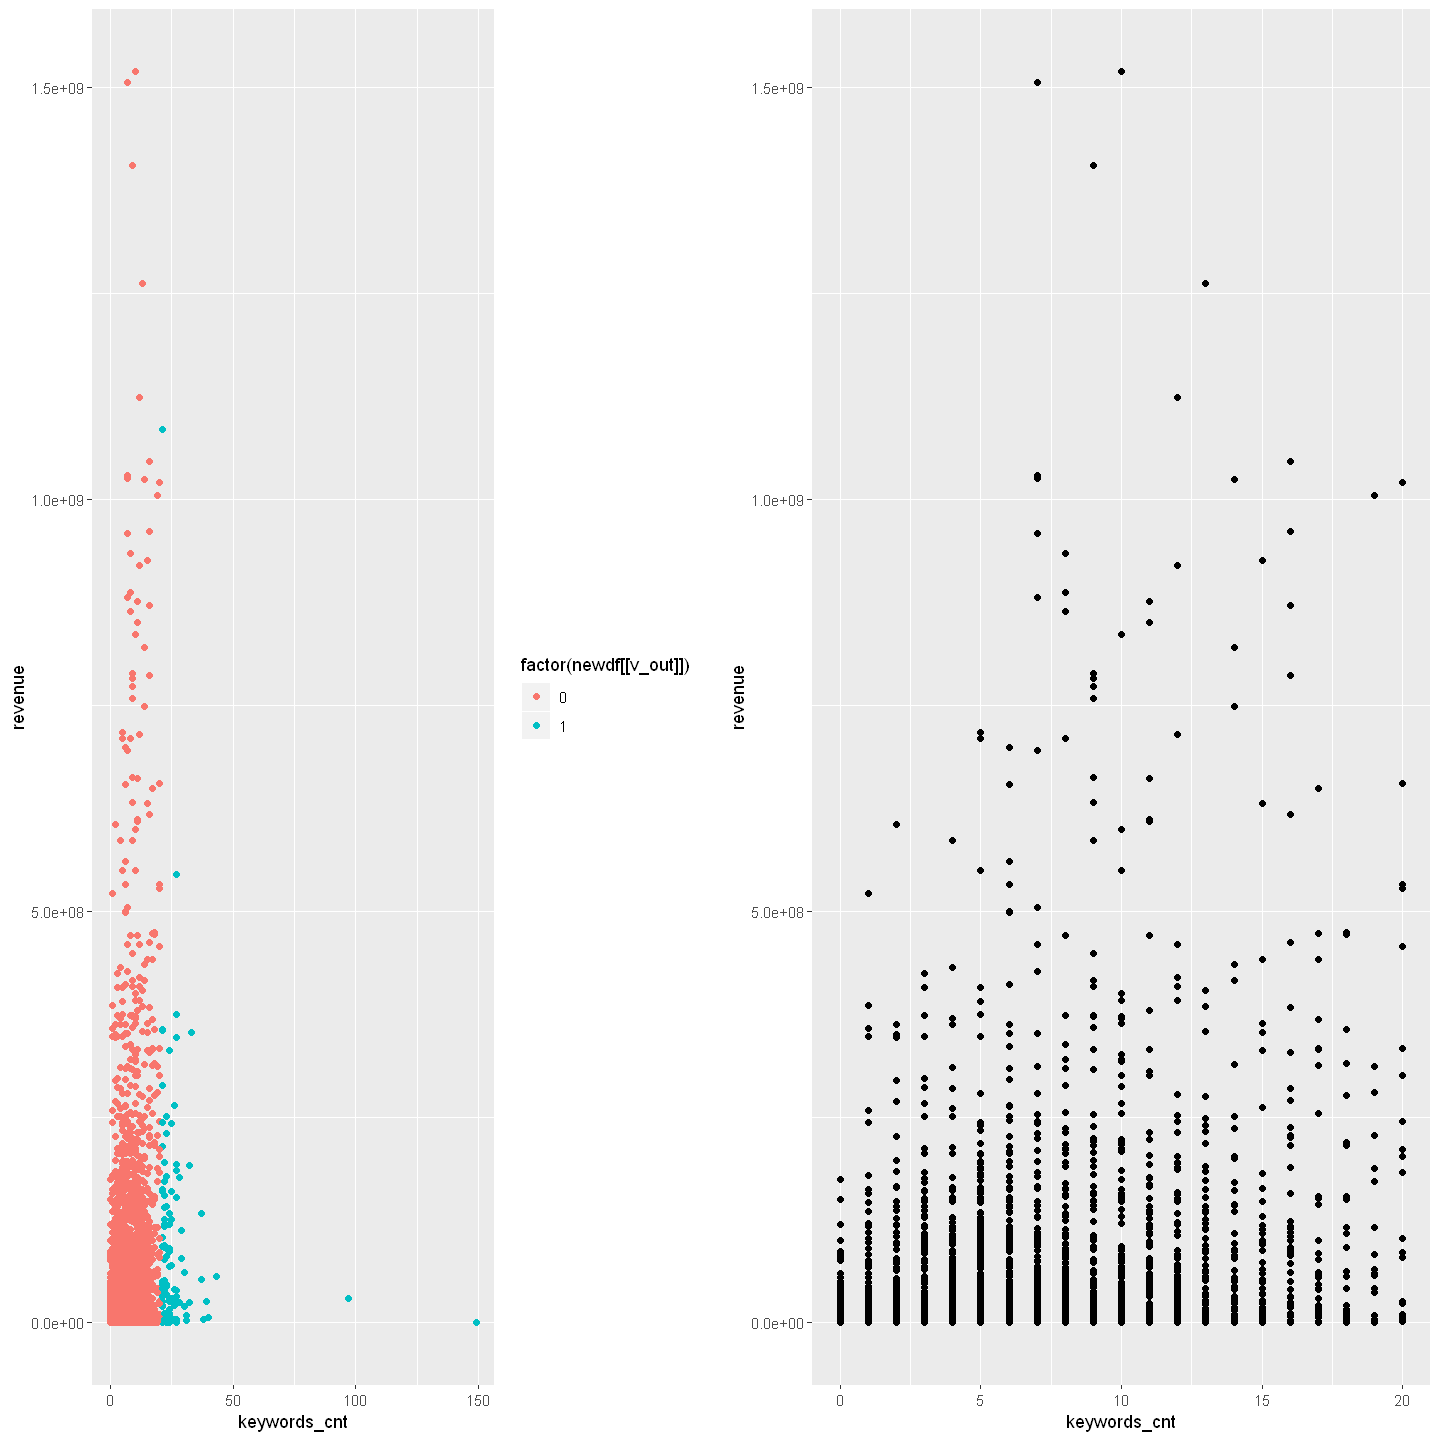

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4519 rows containing missing values (geom_point)."


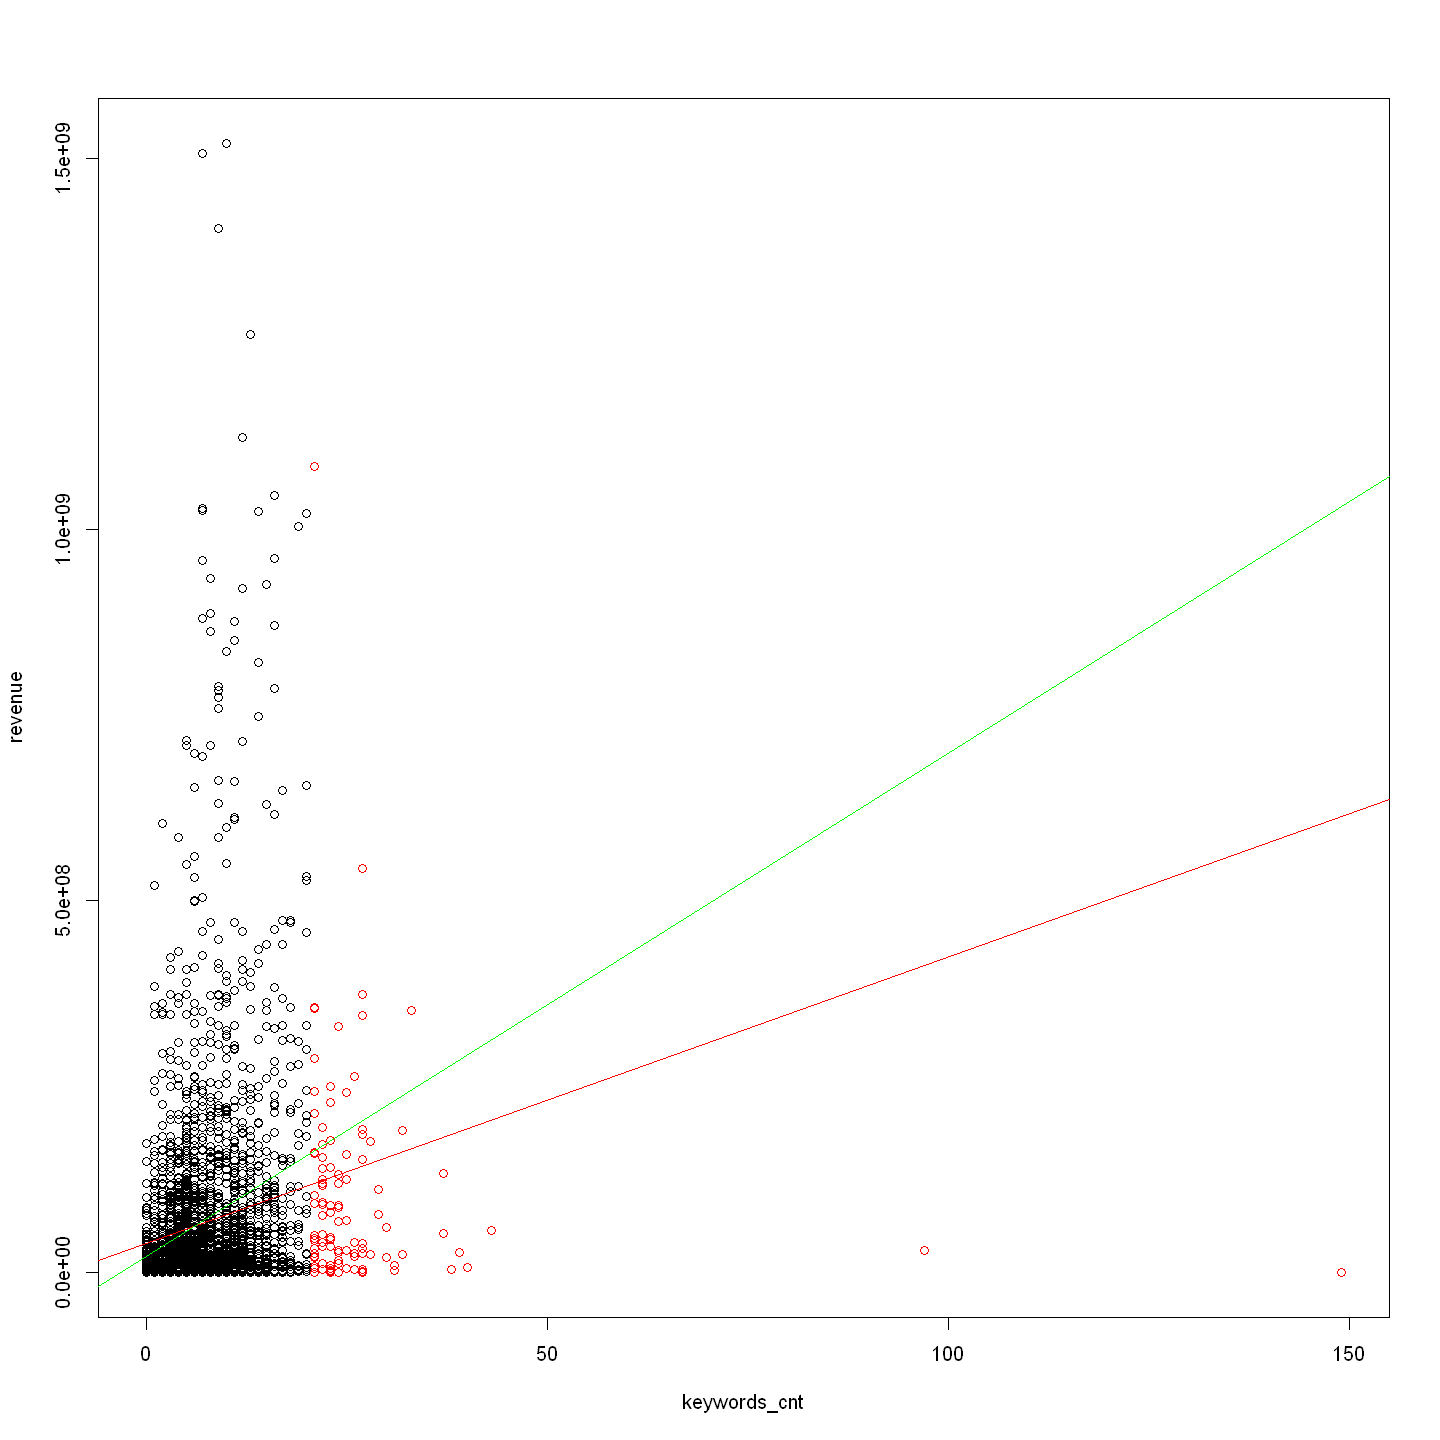

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


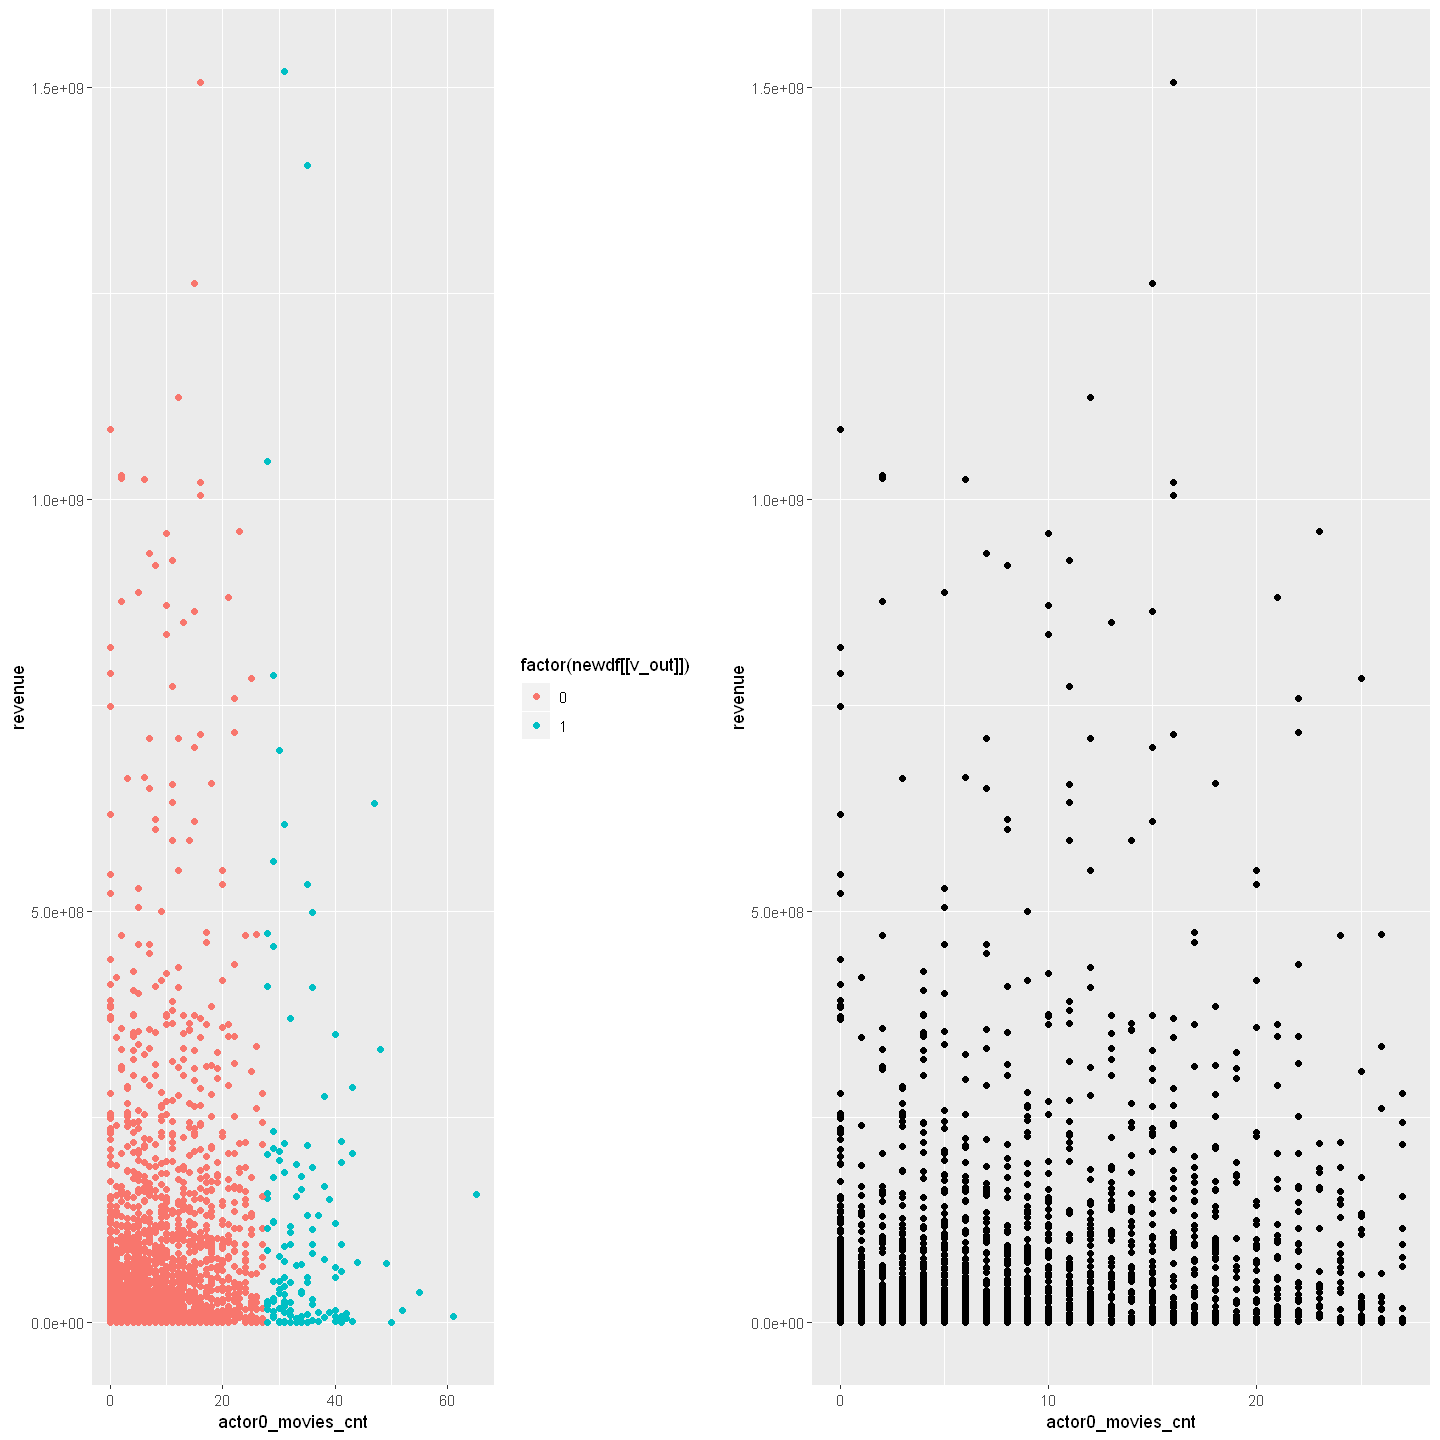

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4409 rows containing missing values (geom_point)."


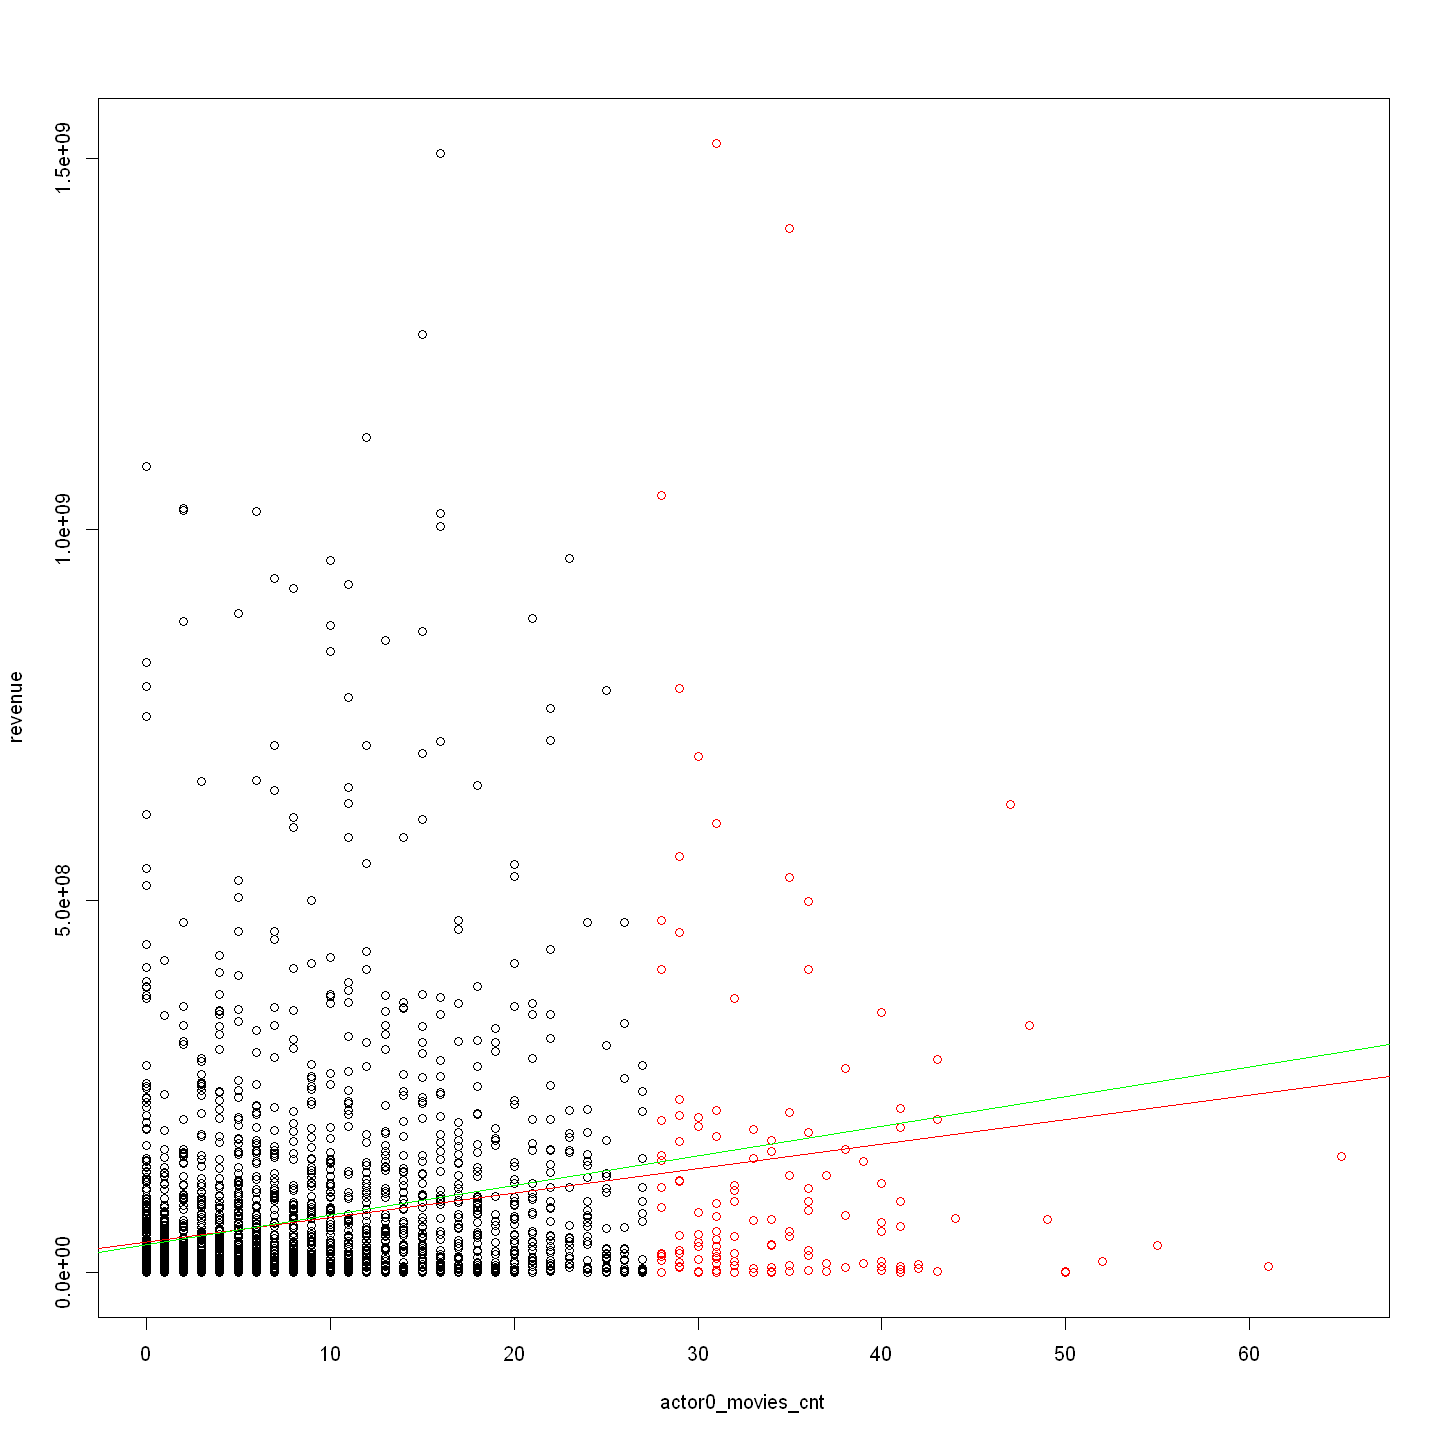

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


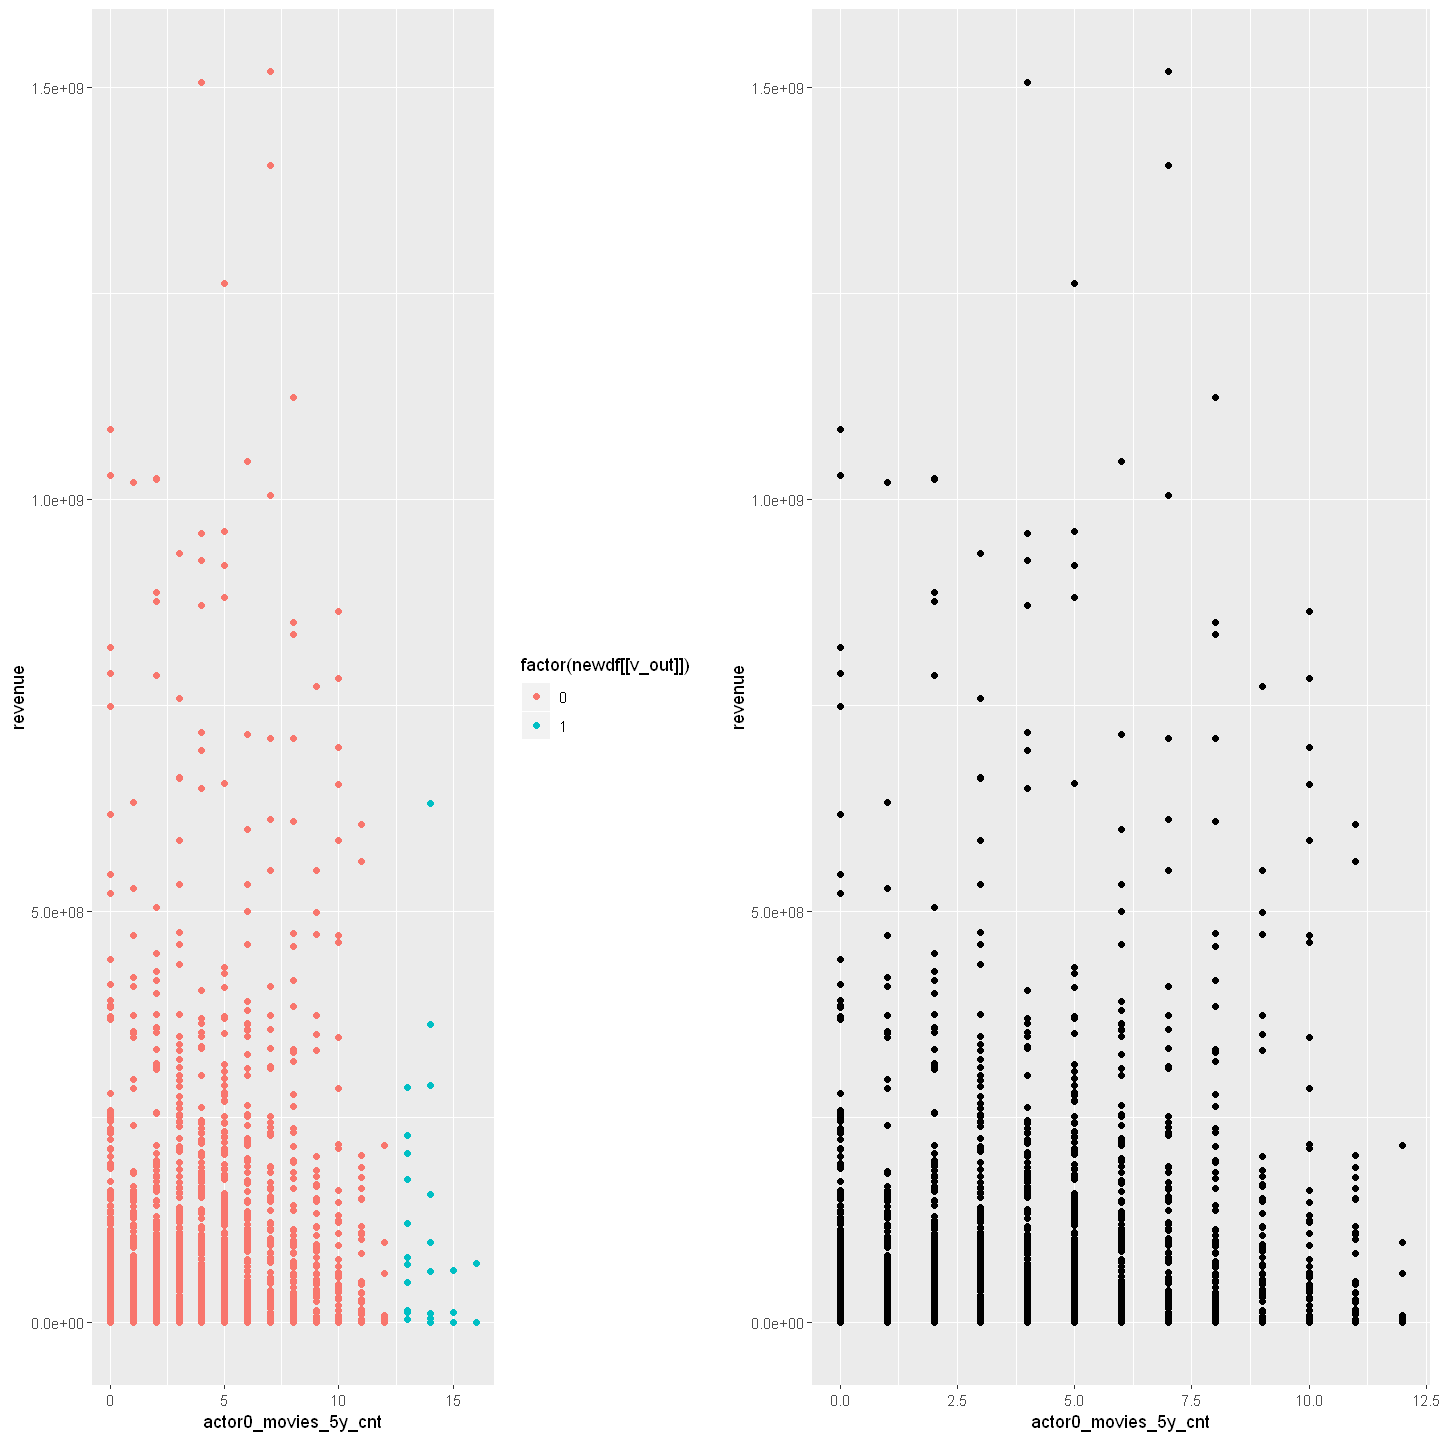

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4571 rows containing missing values (geom_point)."


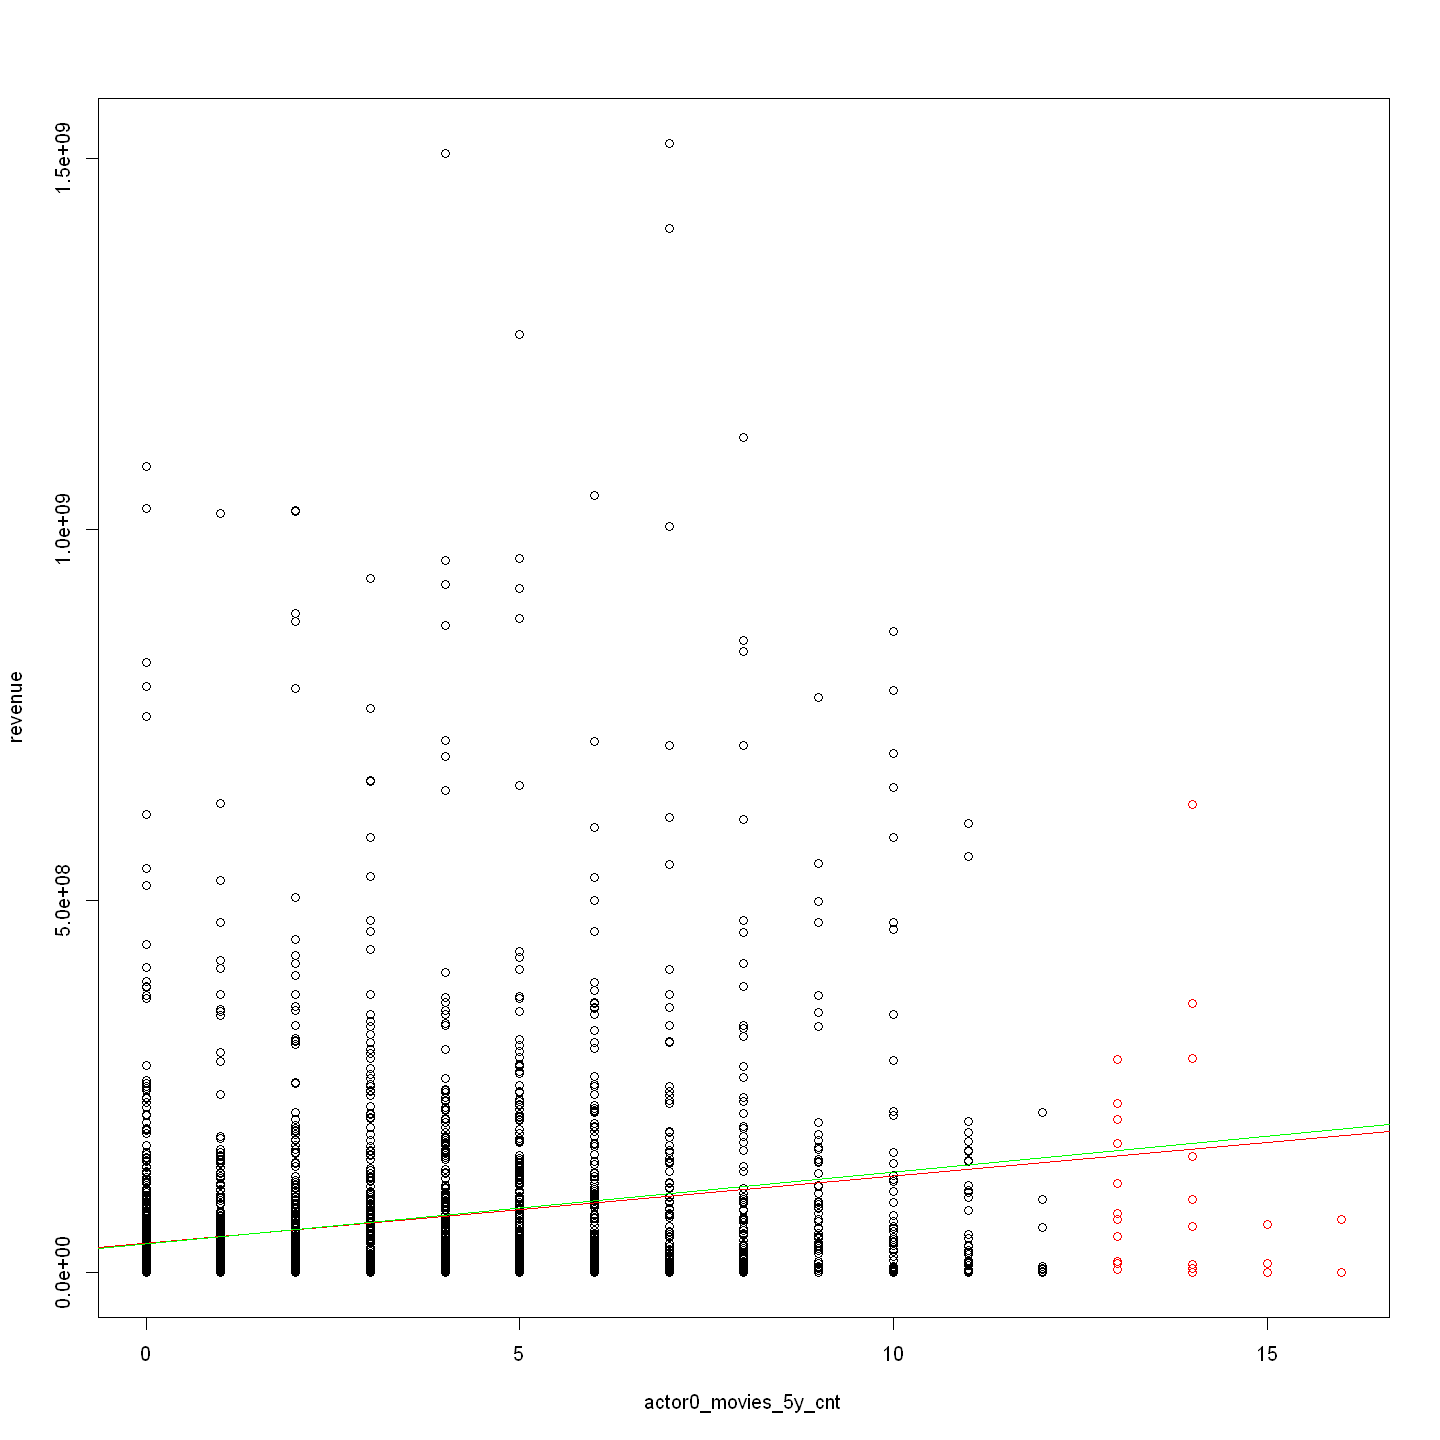

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


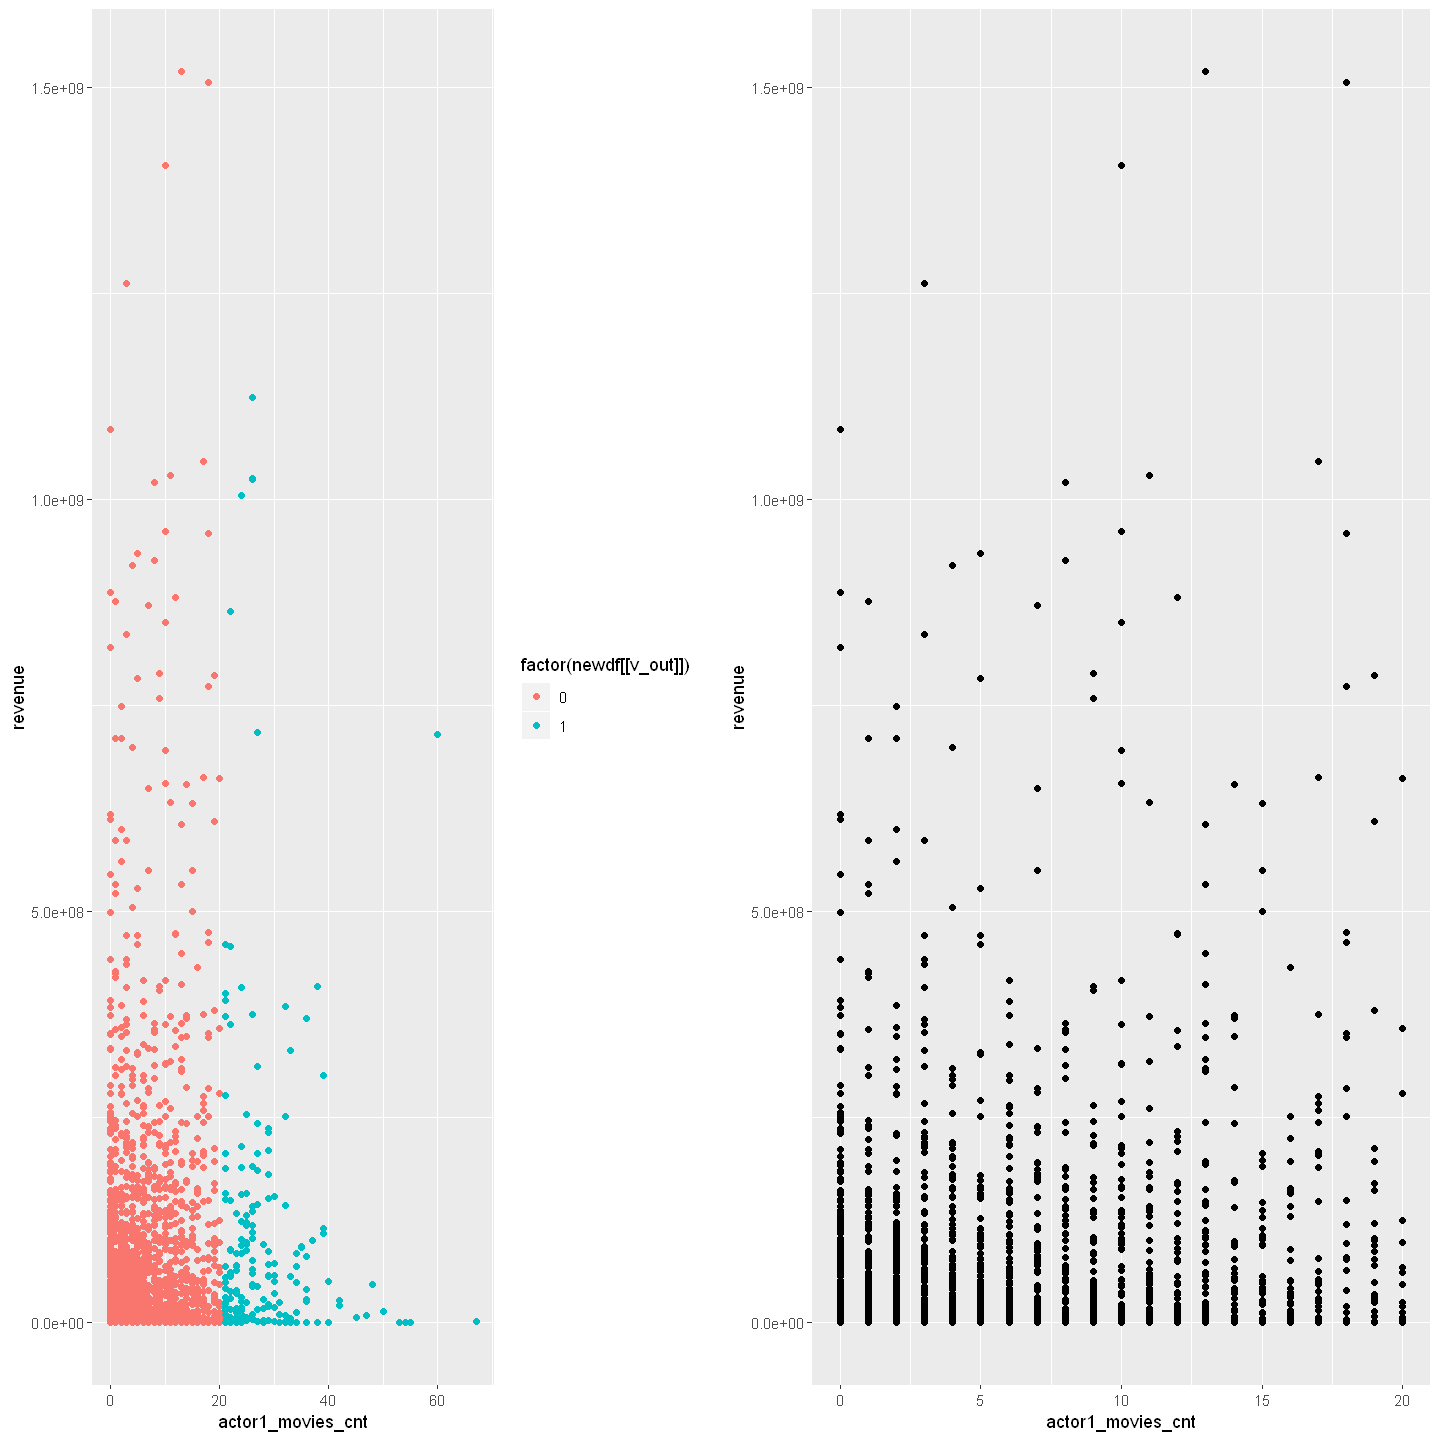

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4432 rows containing missing values (geom_point)."


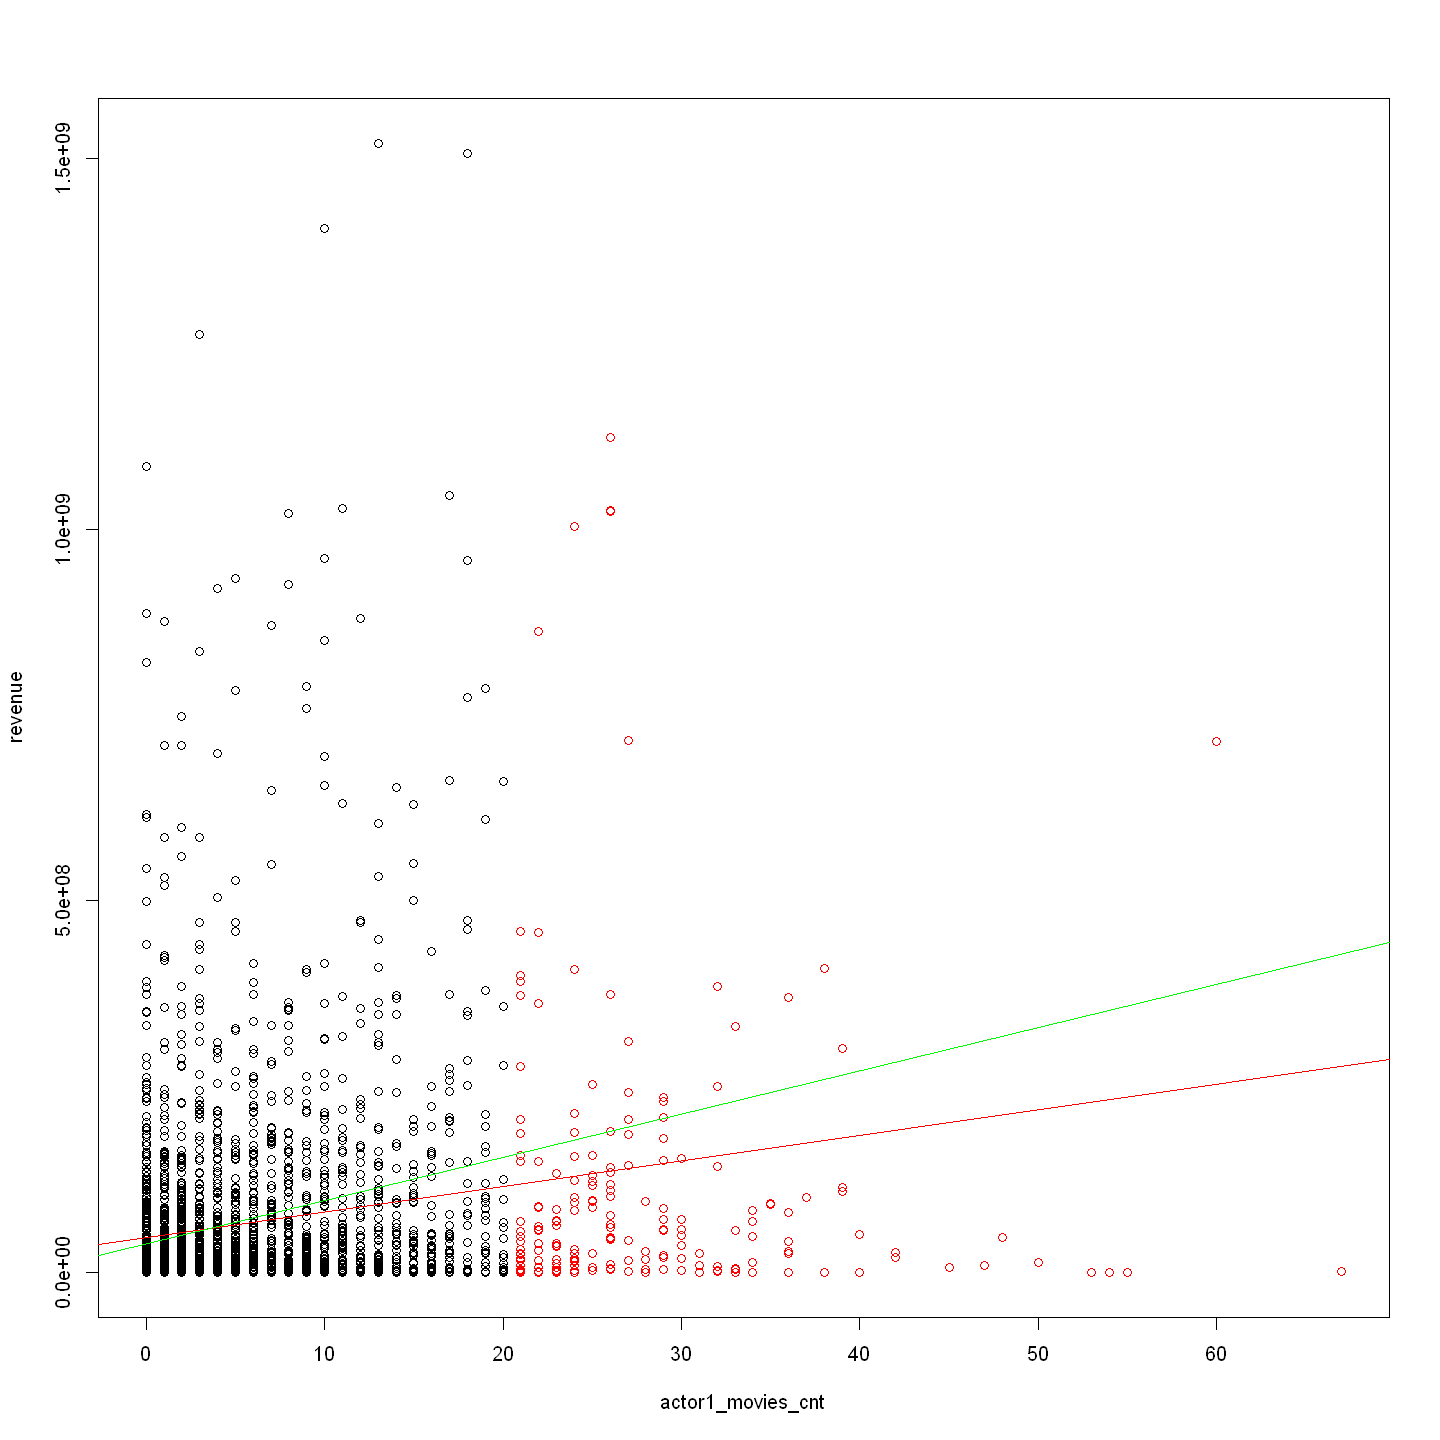

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


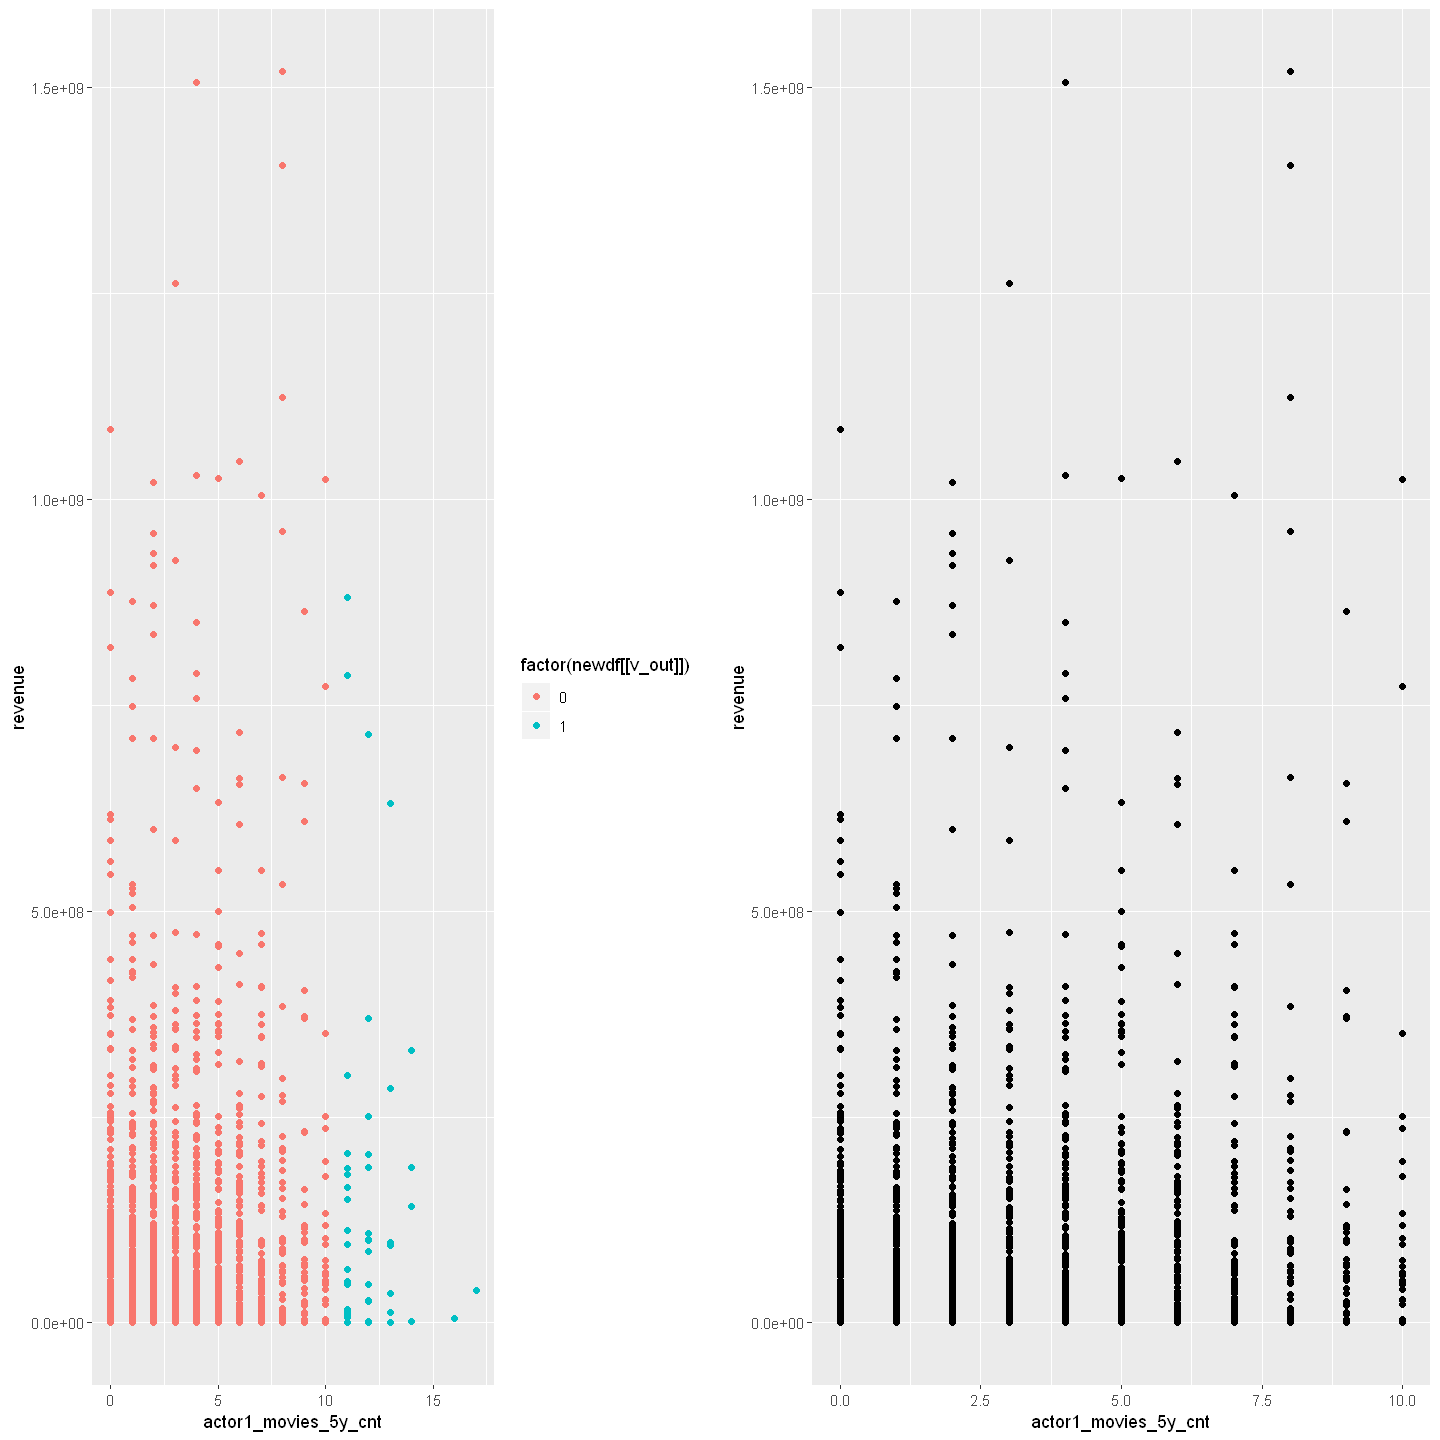

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4616 rows containing missing values (geom_point)."


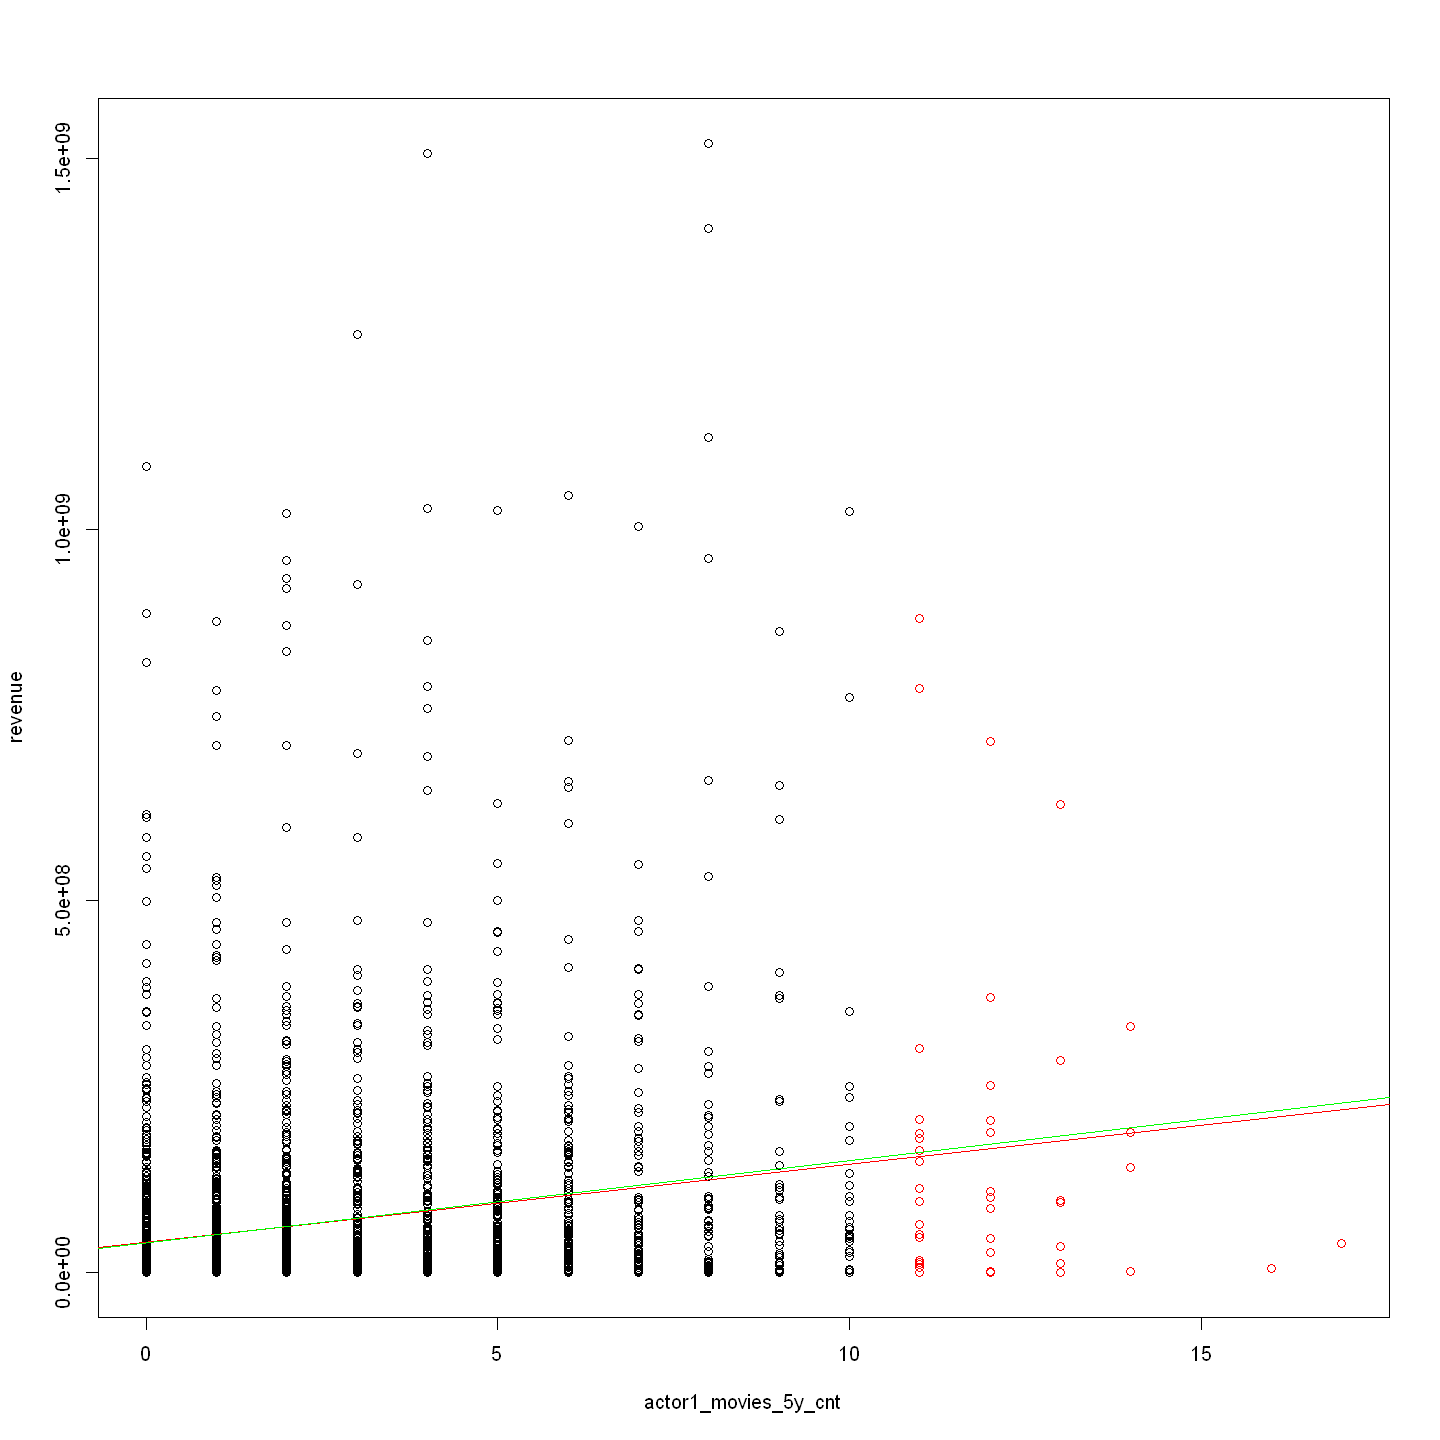

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


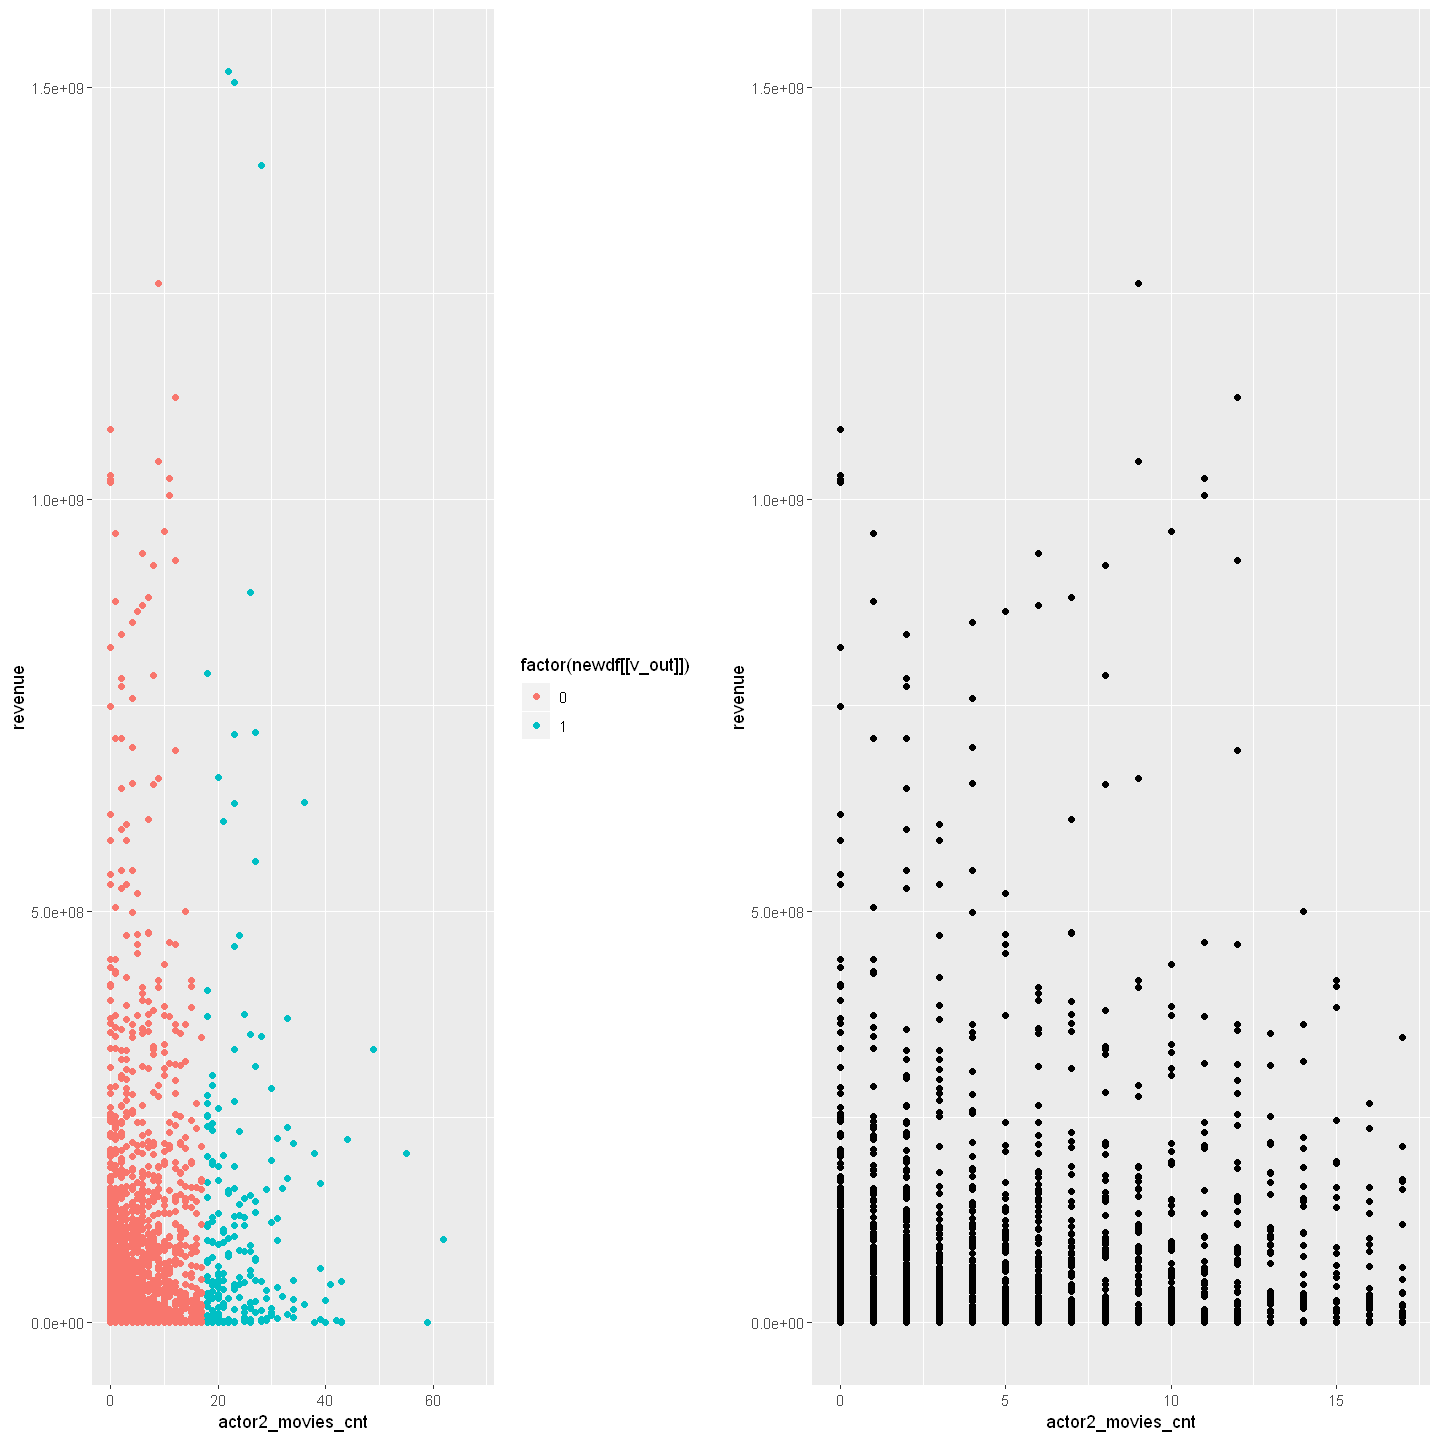

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4530 rows containing missing values (geom_point)."


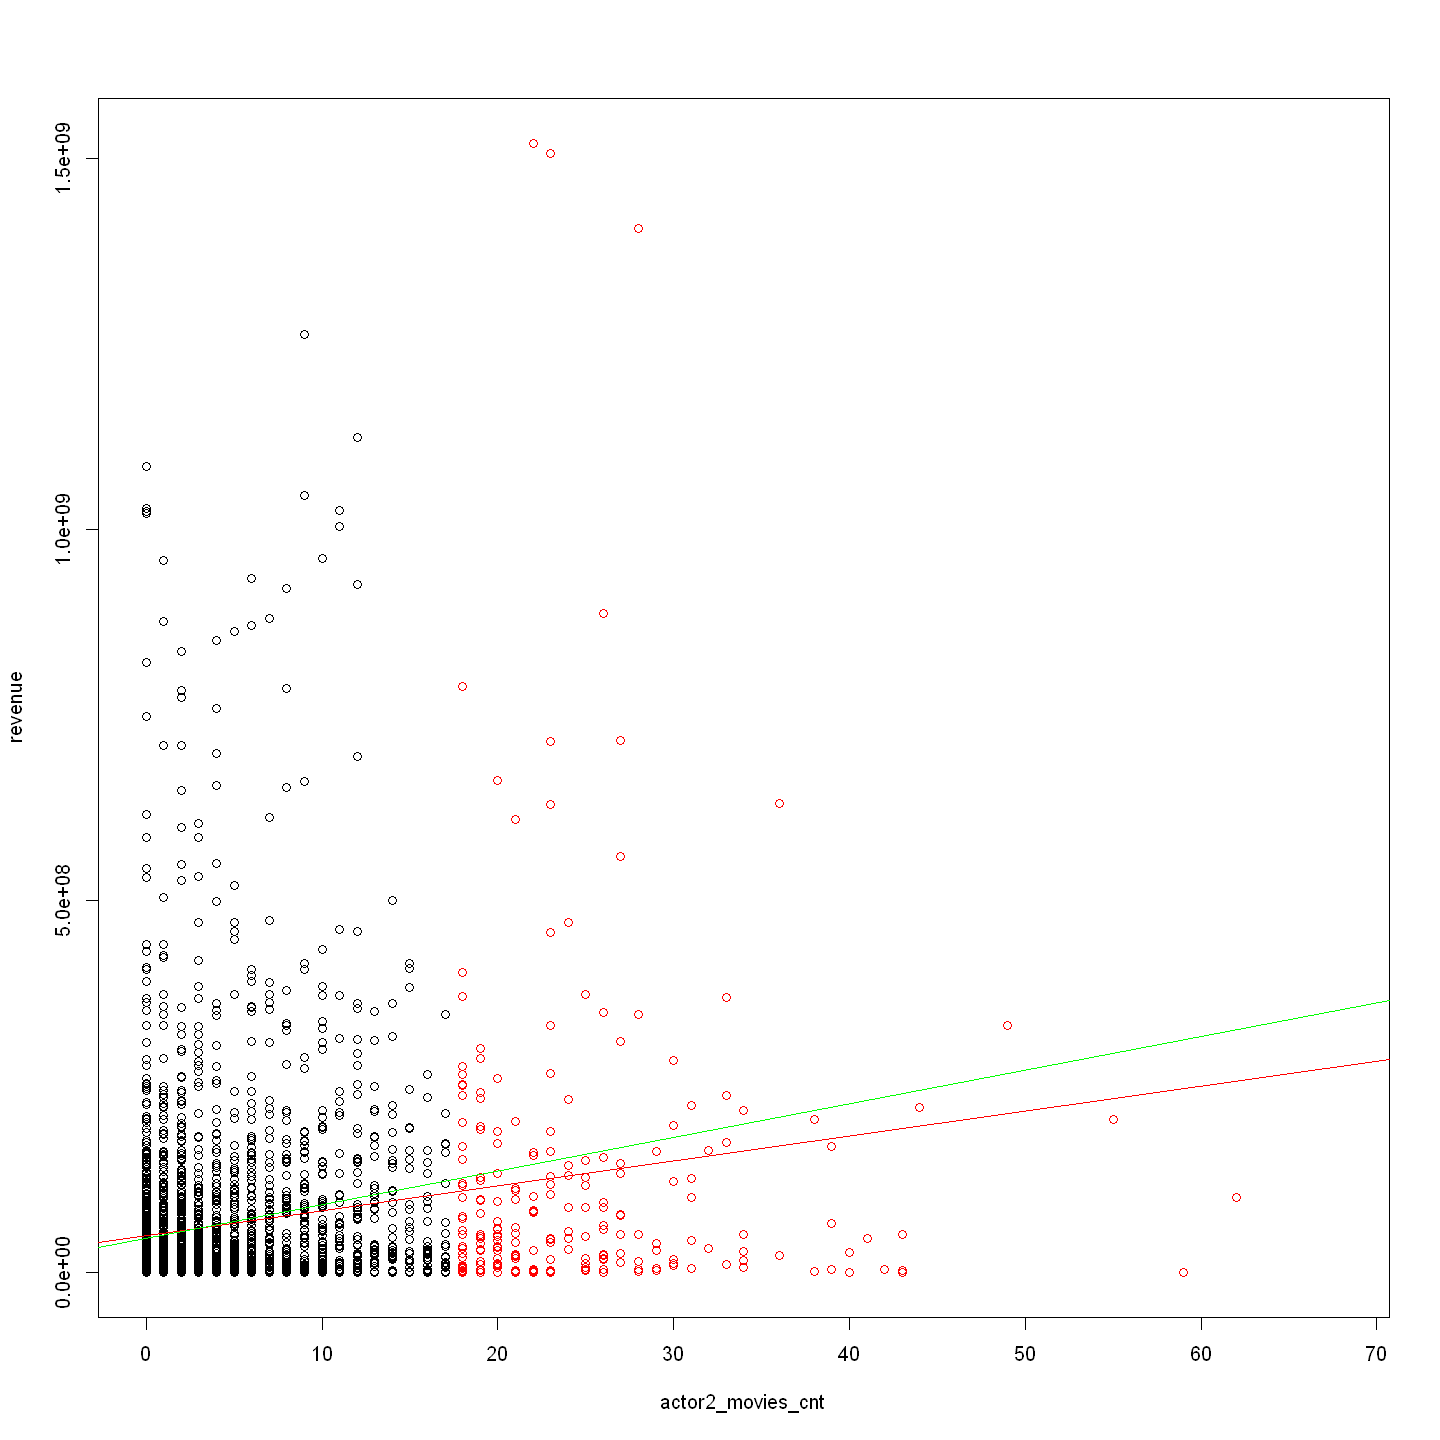

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


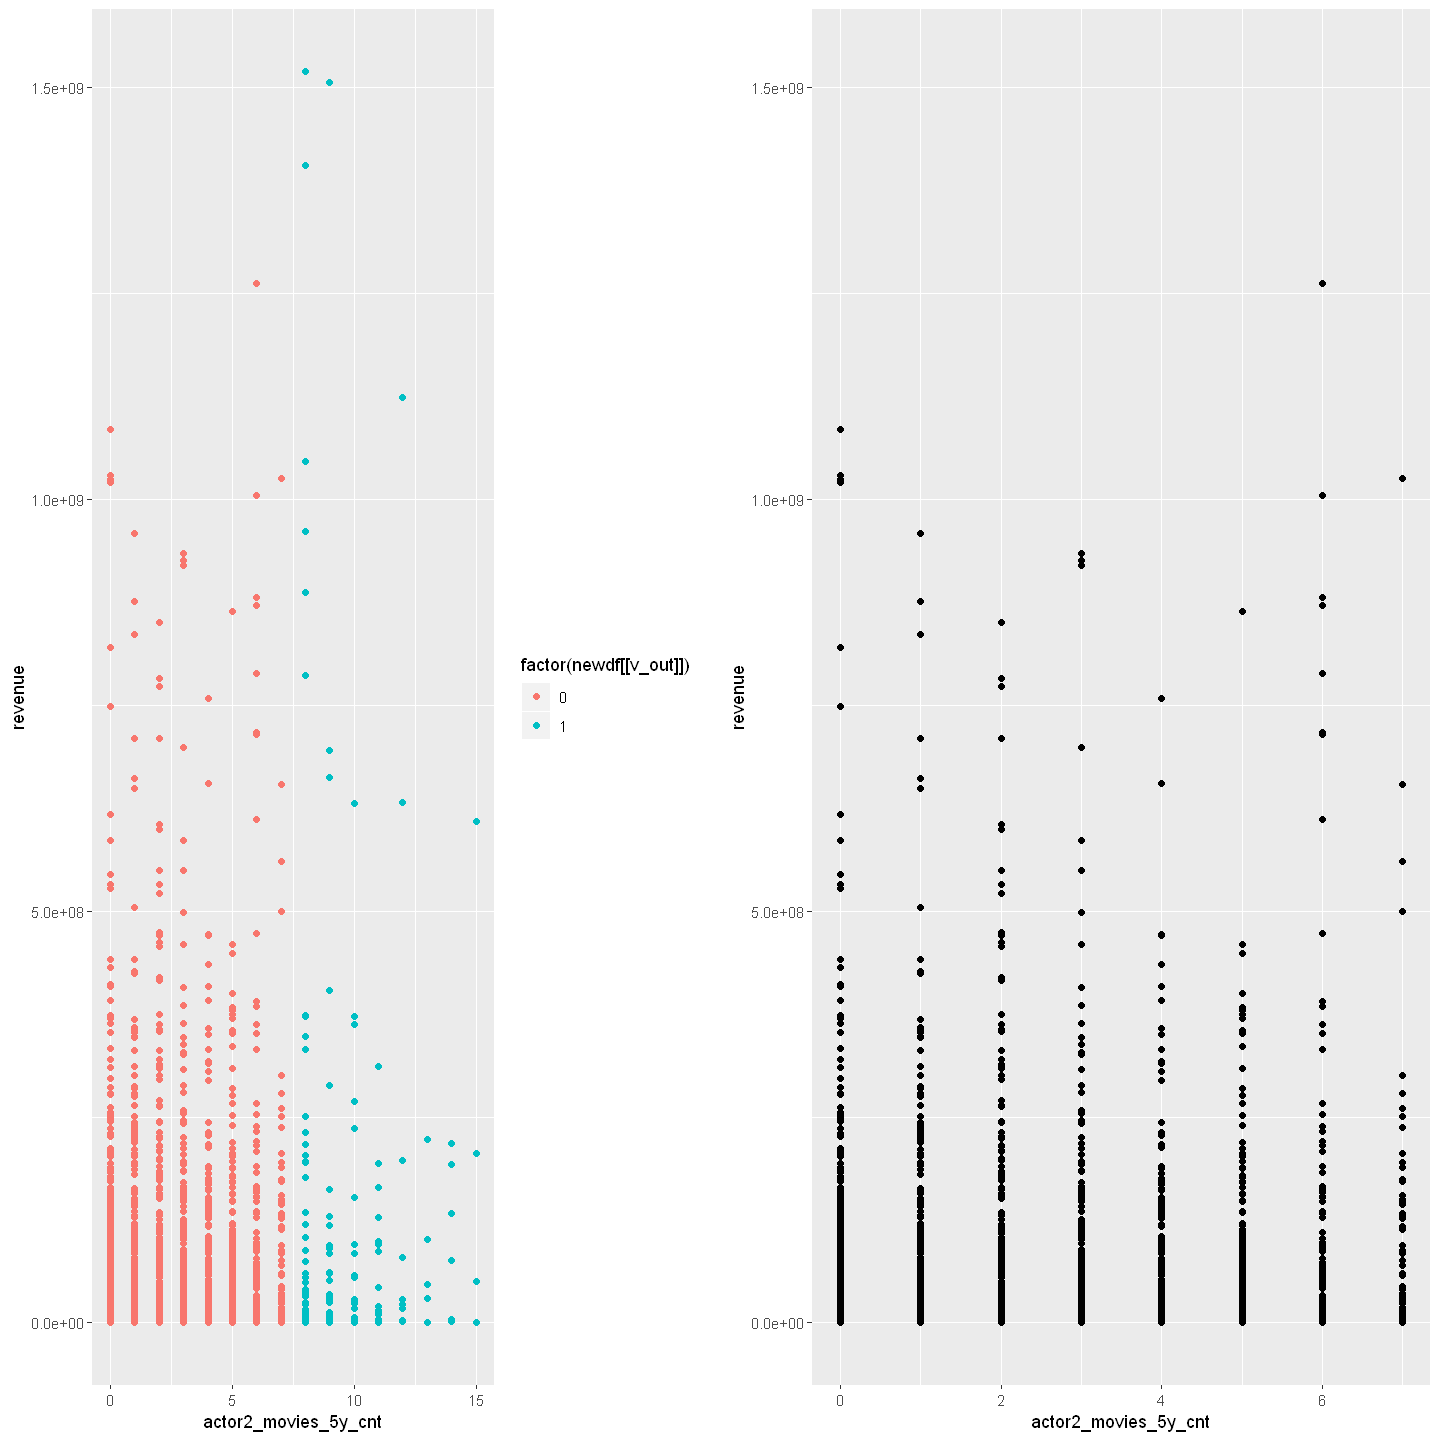

NULL
NULL


Warning message:
"Removed 4529 rows containing missing values (geom_point)."
Warning message:
"Removed 5197 rows containing missing values (geom_point)."


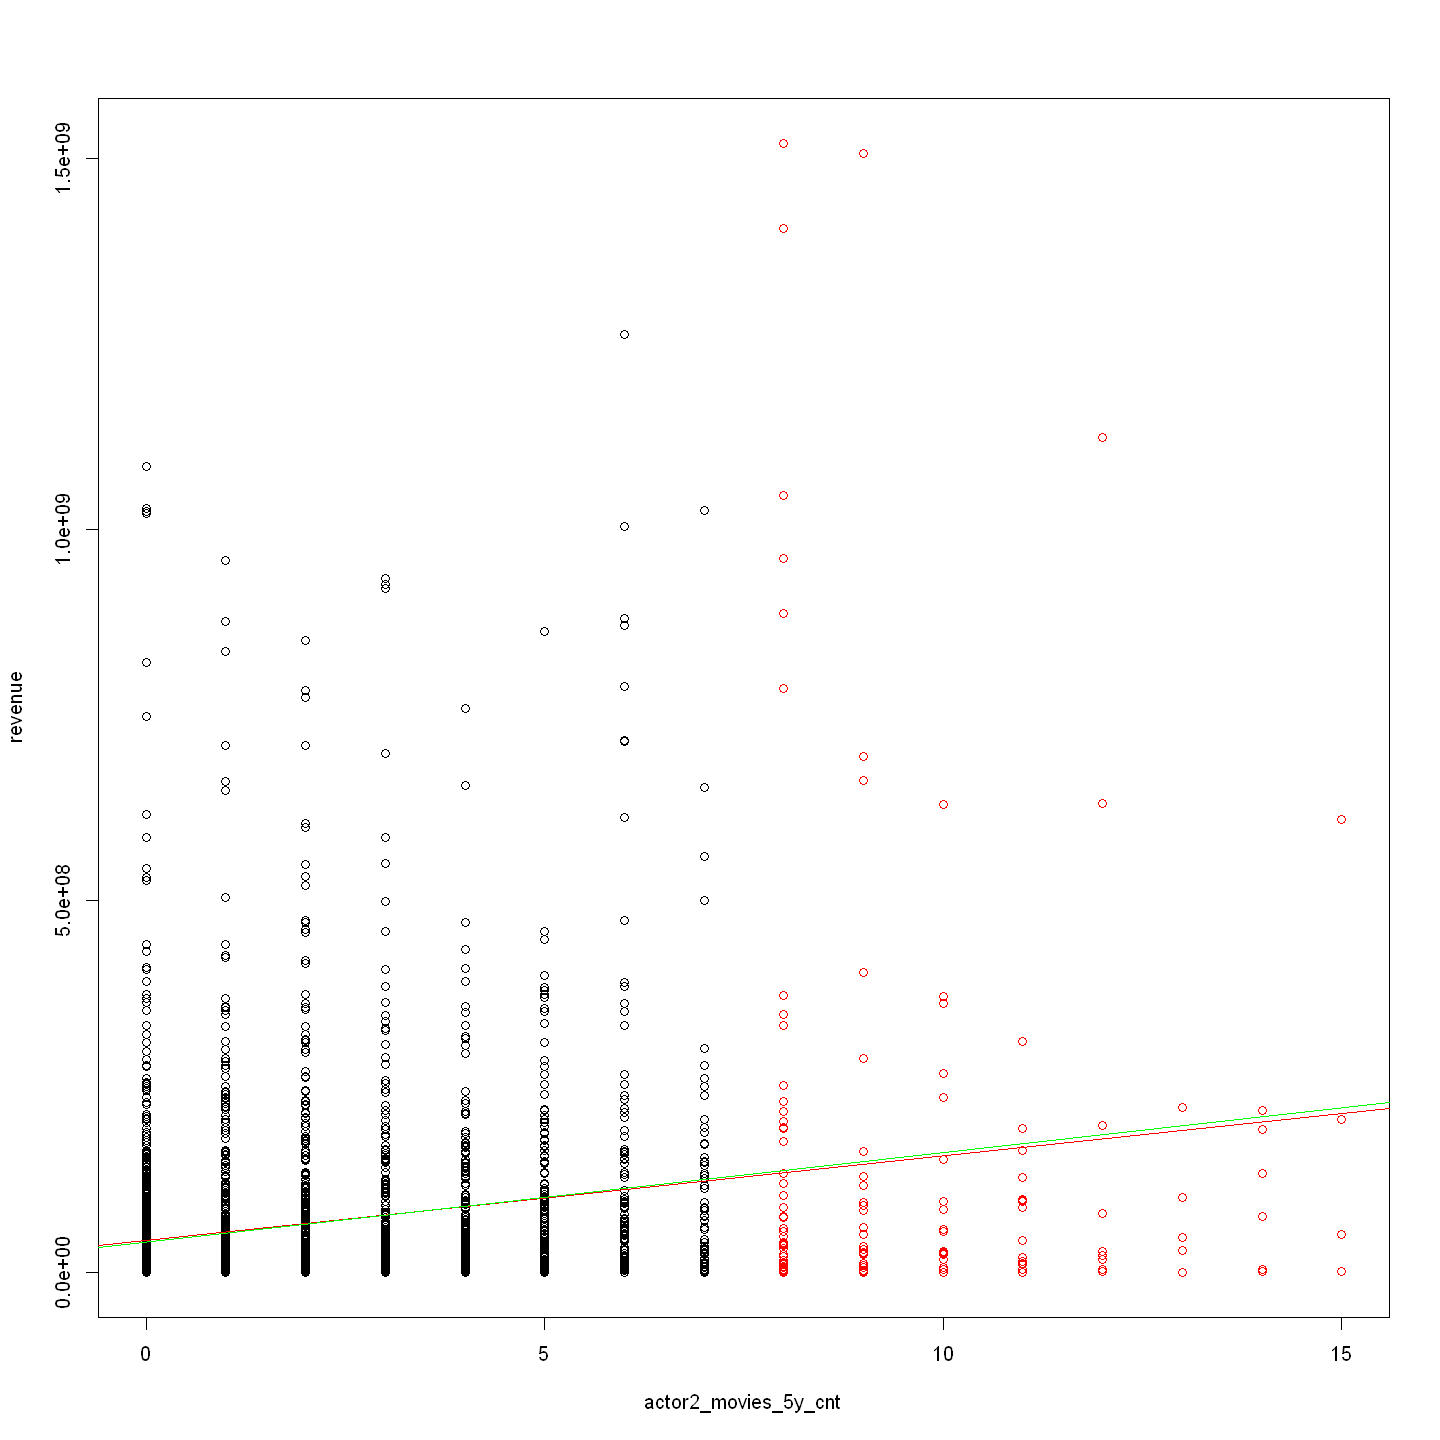

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


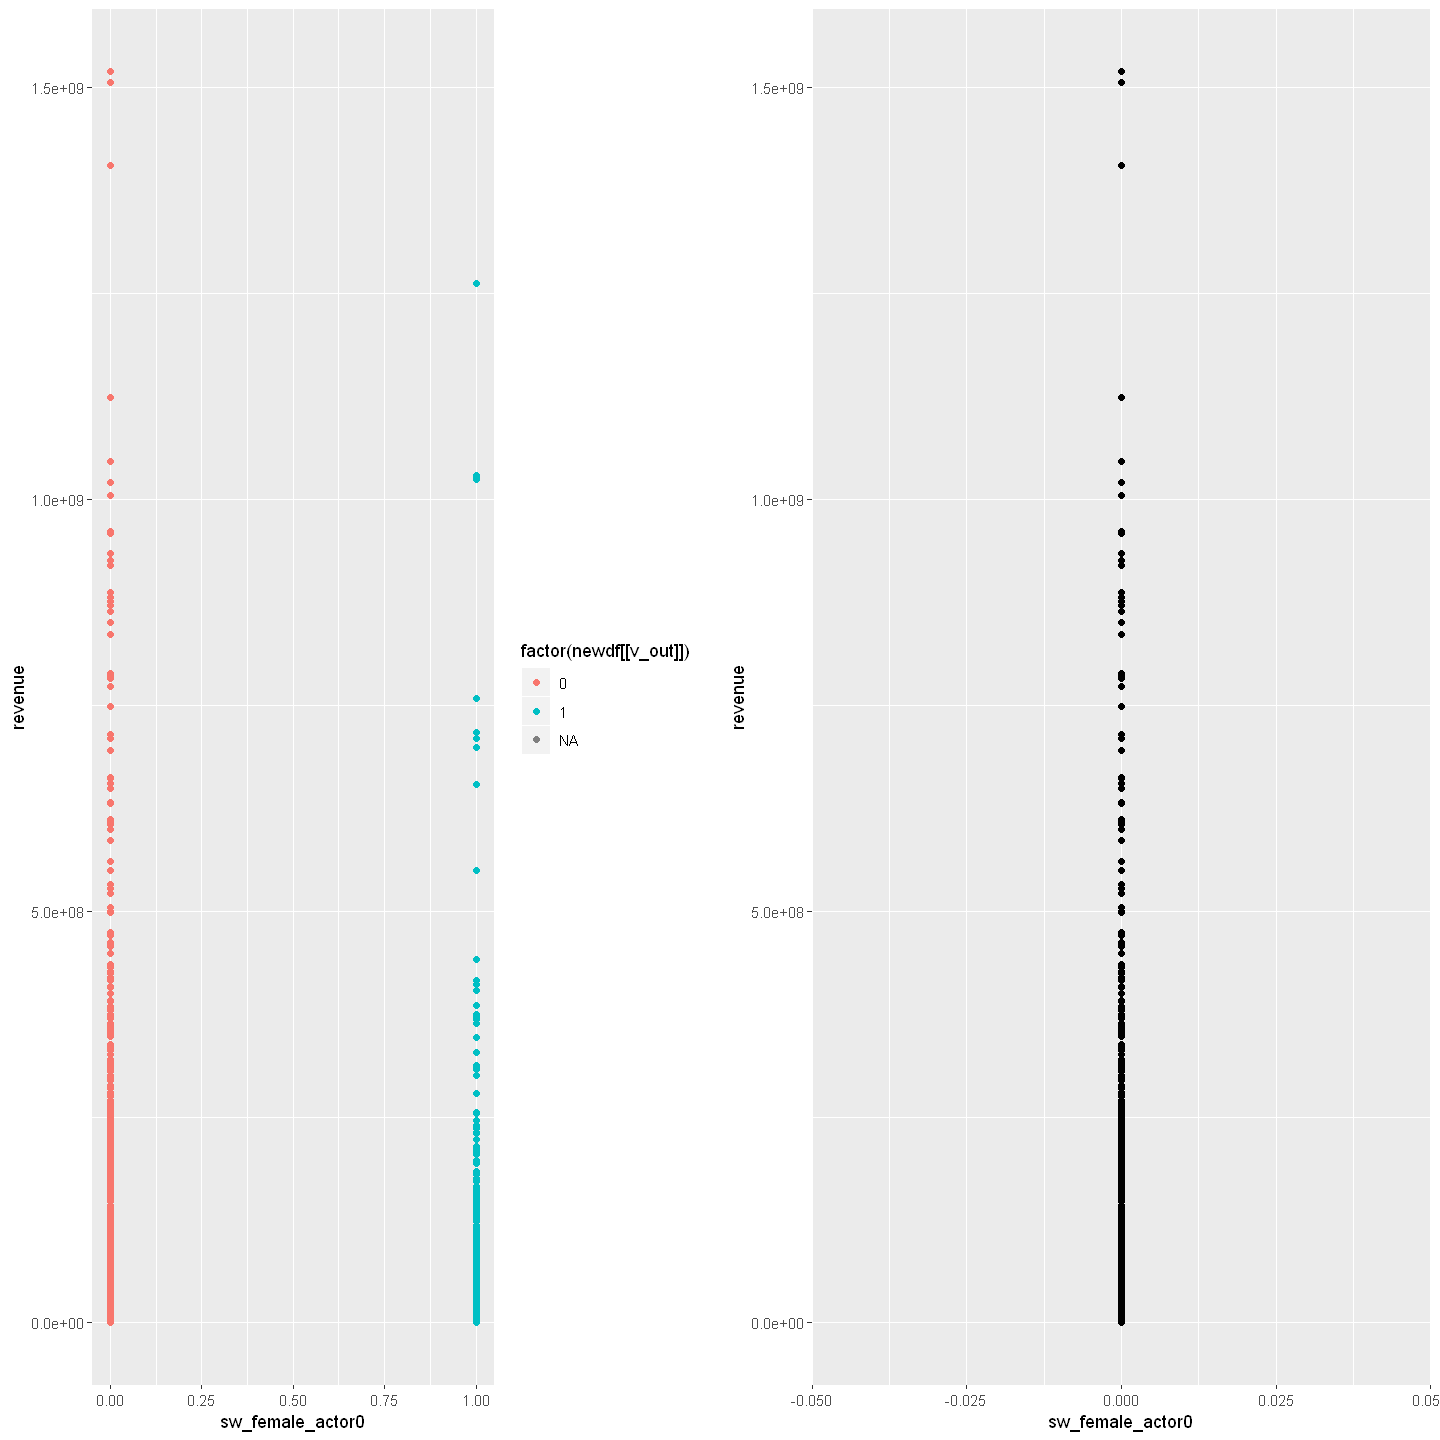

NULL
NULL


Warning message:
"Removed 4450 rows containing missing values (geom_point)."
Warning message:
"Removed 4450 rows containing missing values (geom_point)."


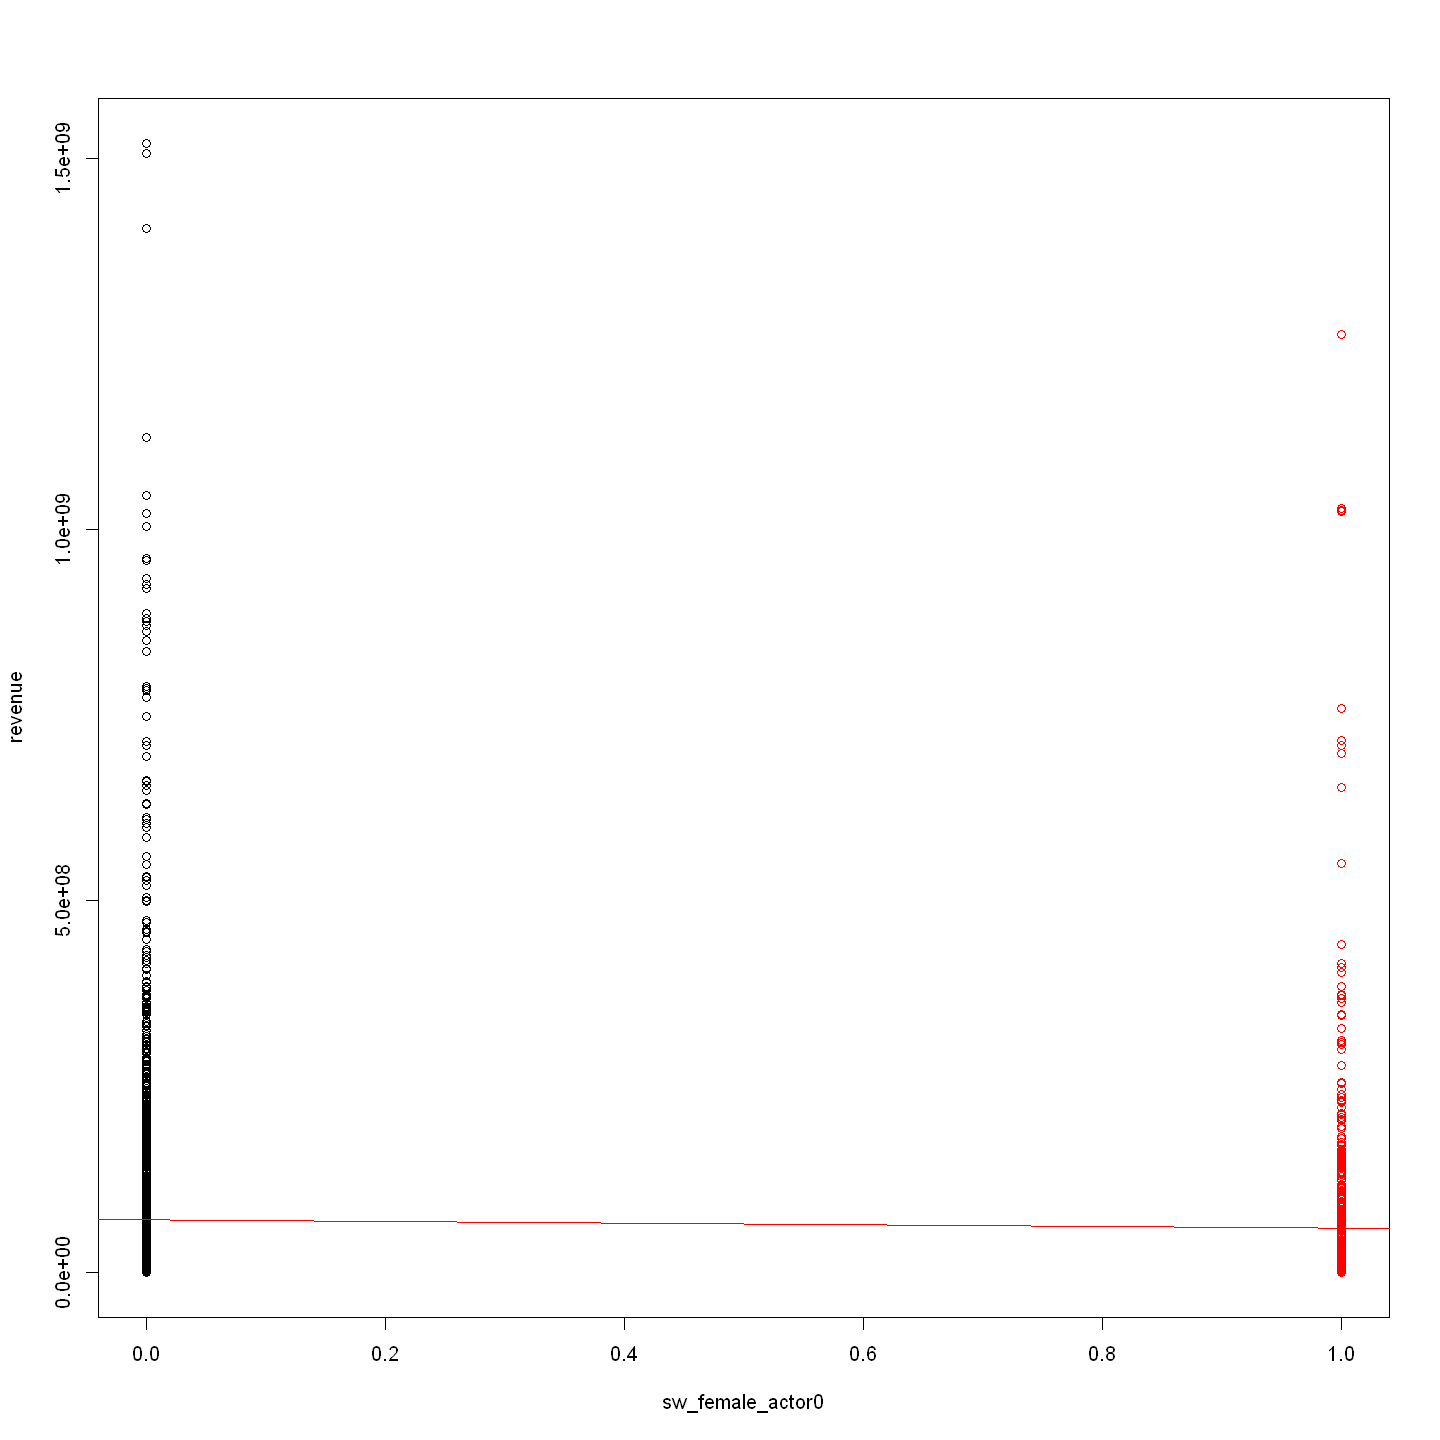

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


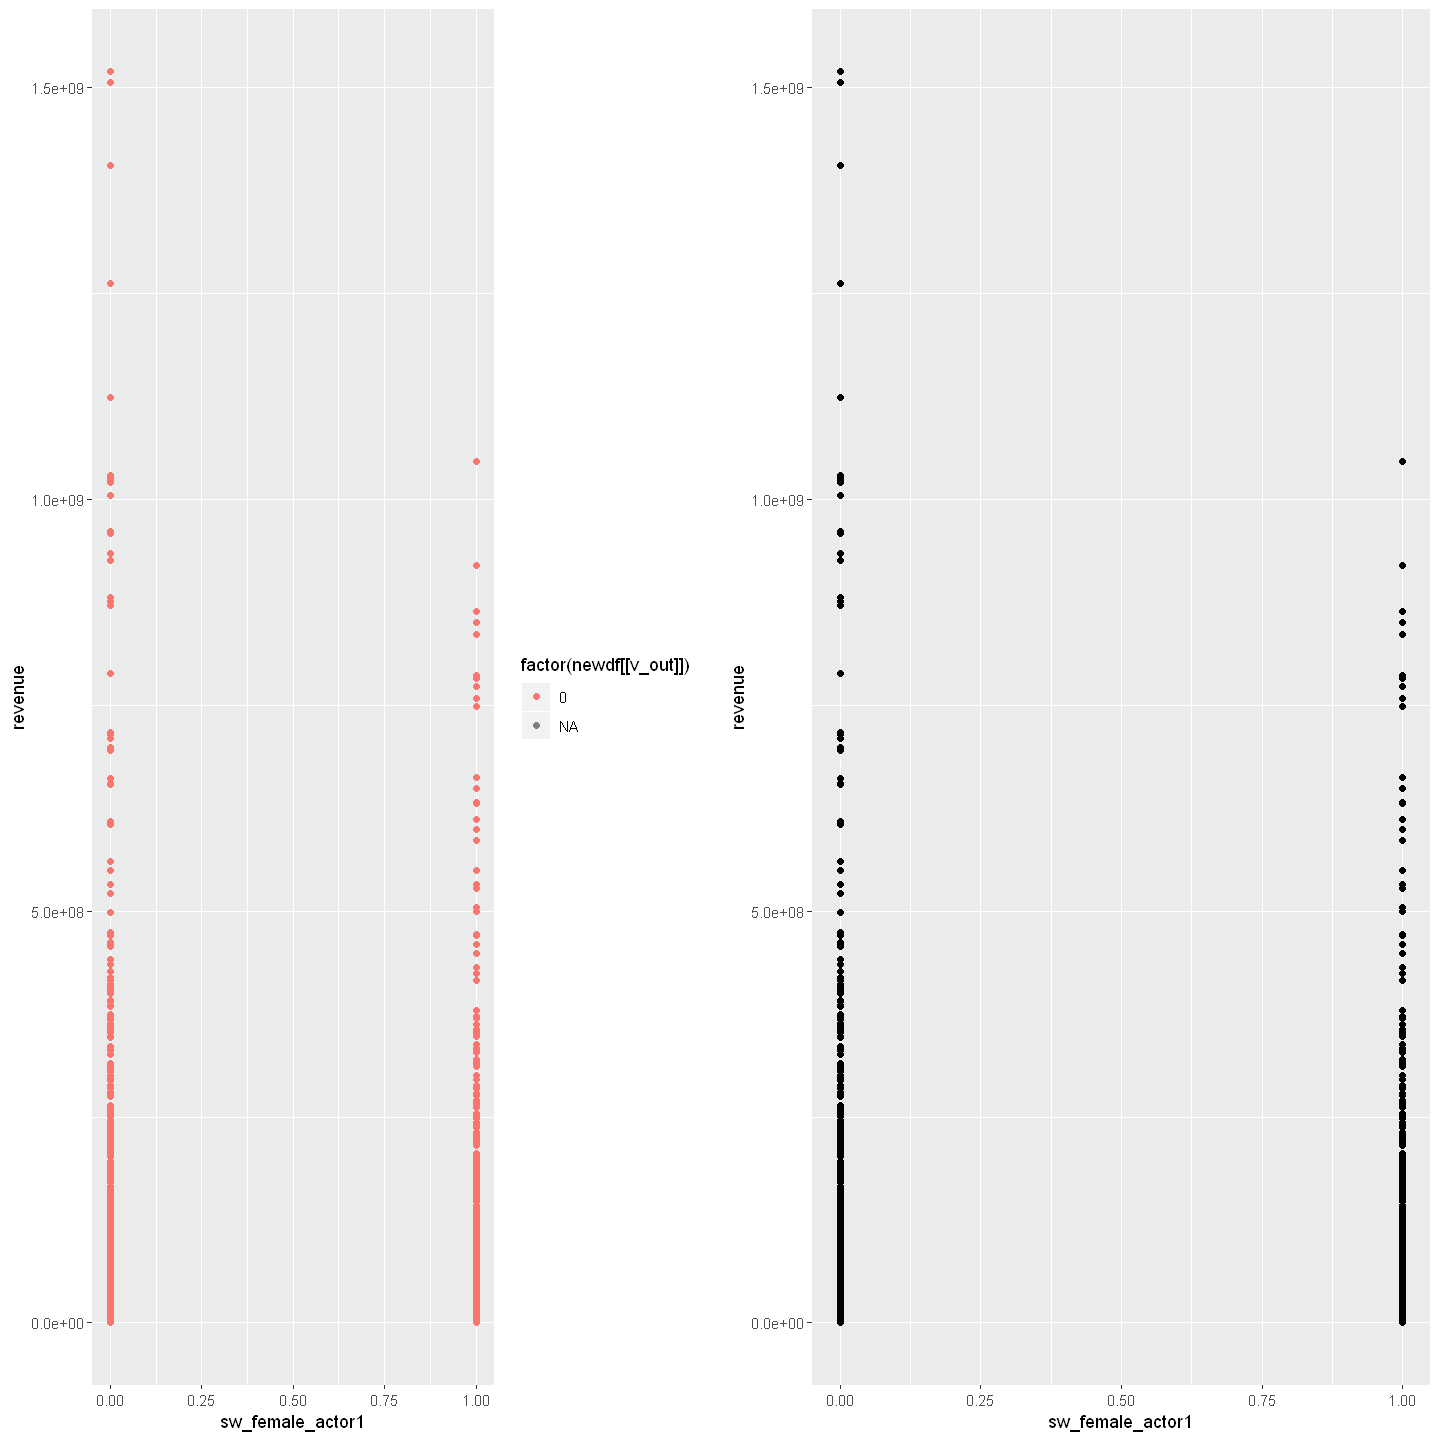

NULL
NULL


Warning message:
"Removed 4453 rows containing missing values (geom_point)."
Warning message:
"Removed 4453 rows containing missing values (geom_point)."


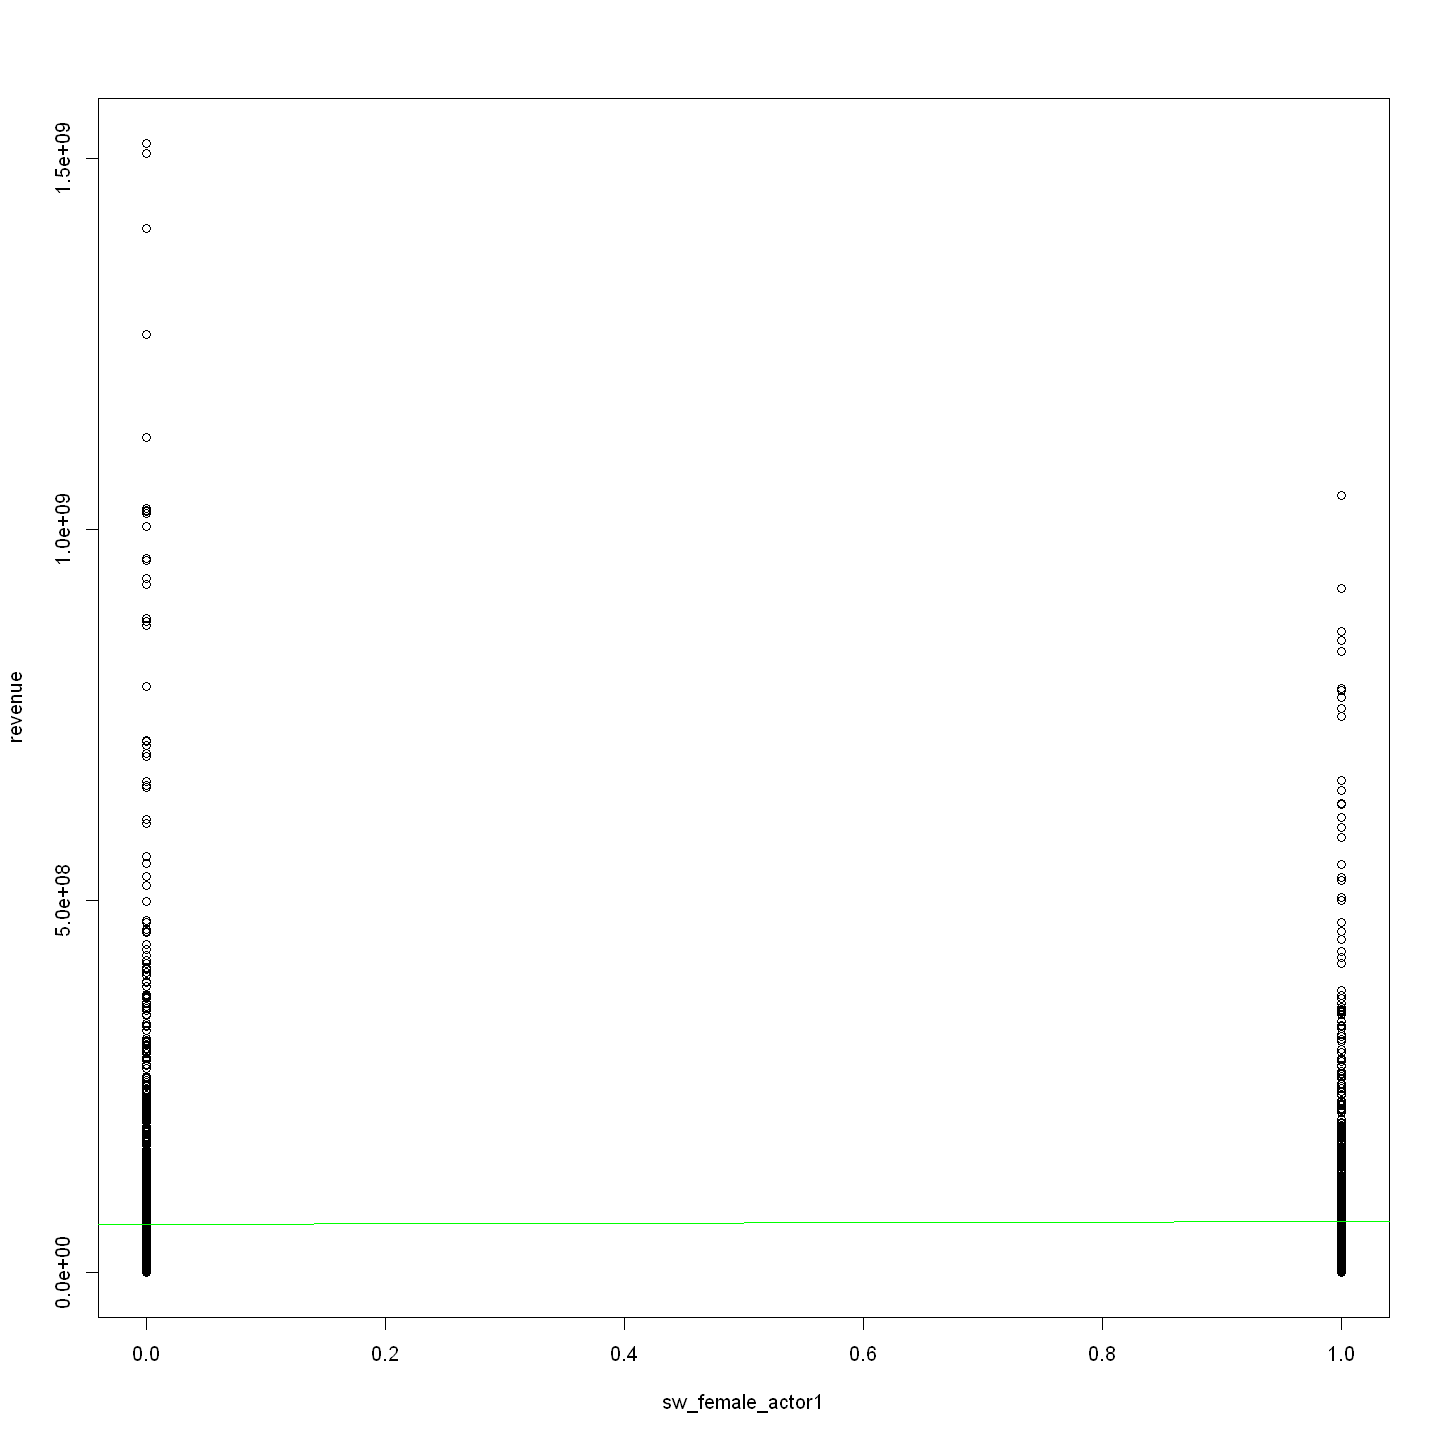

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


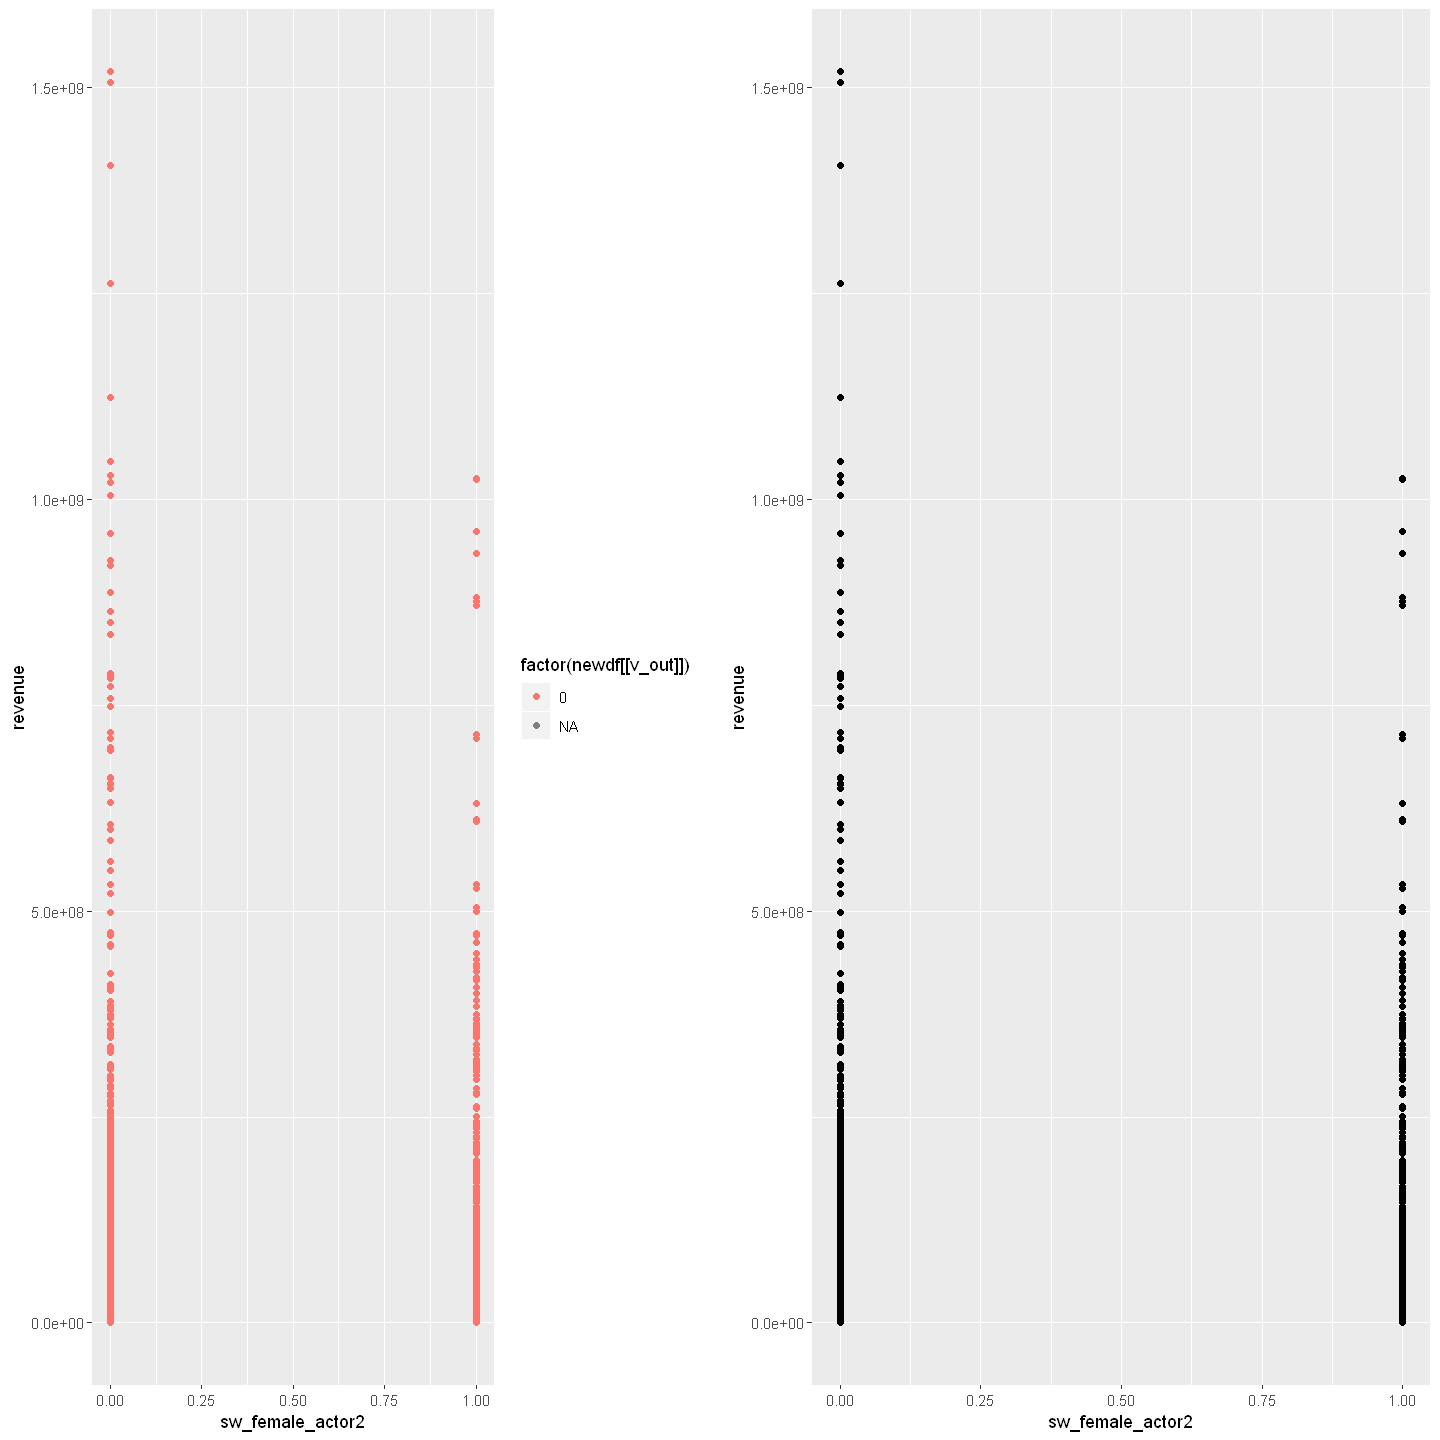

NULL
NULL


Warning message:
"Removed 4529 rows containing missing values (geom_point)."
Warning message:
"Removed 4529 rows containing missing values (geom_point)."


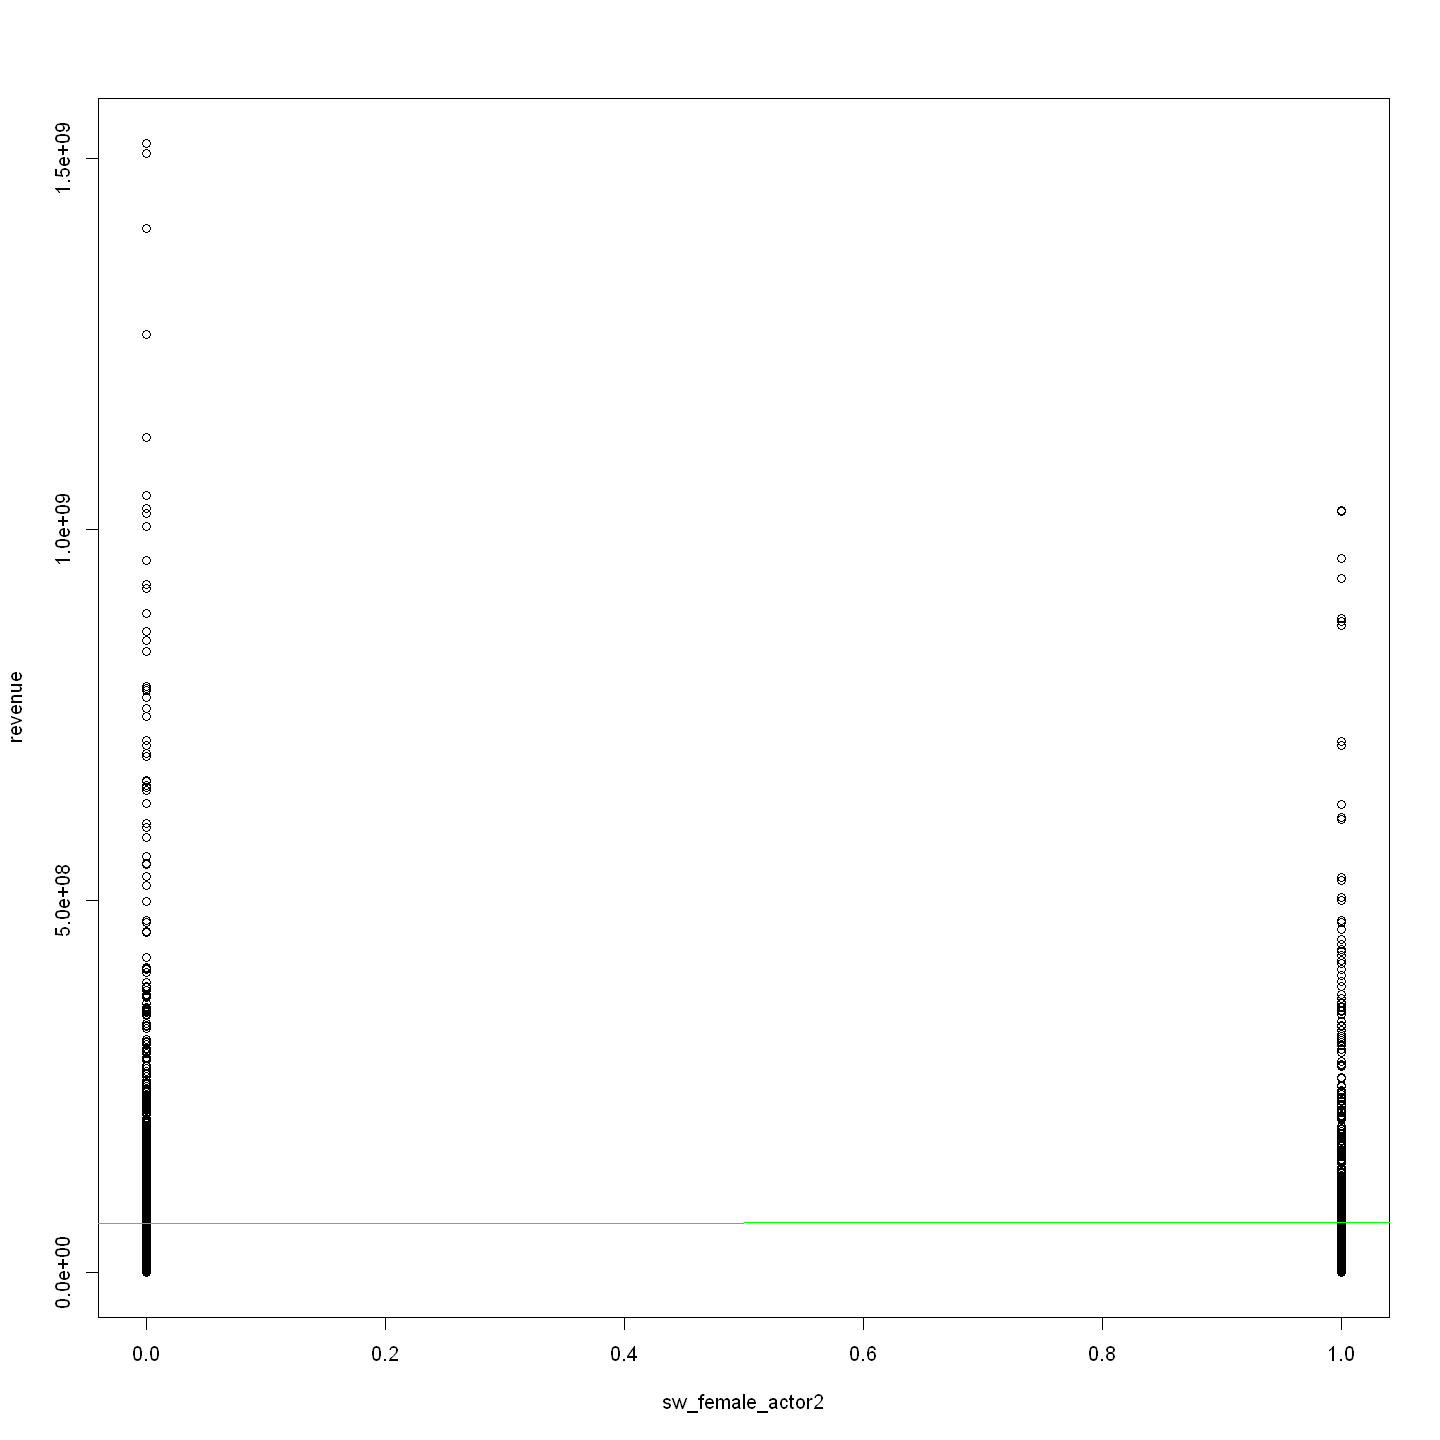

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


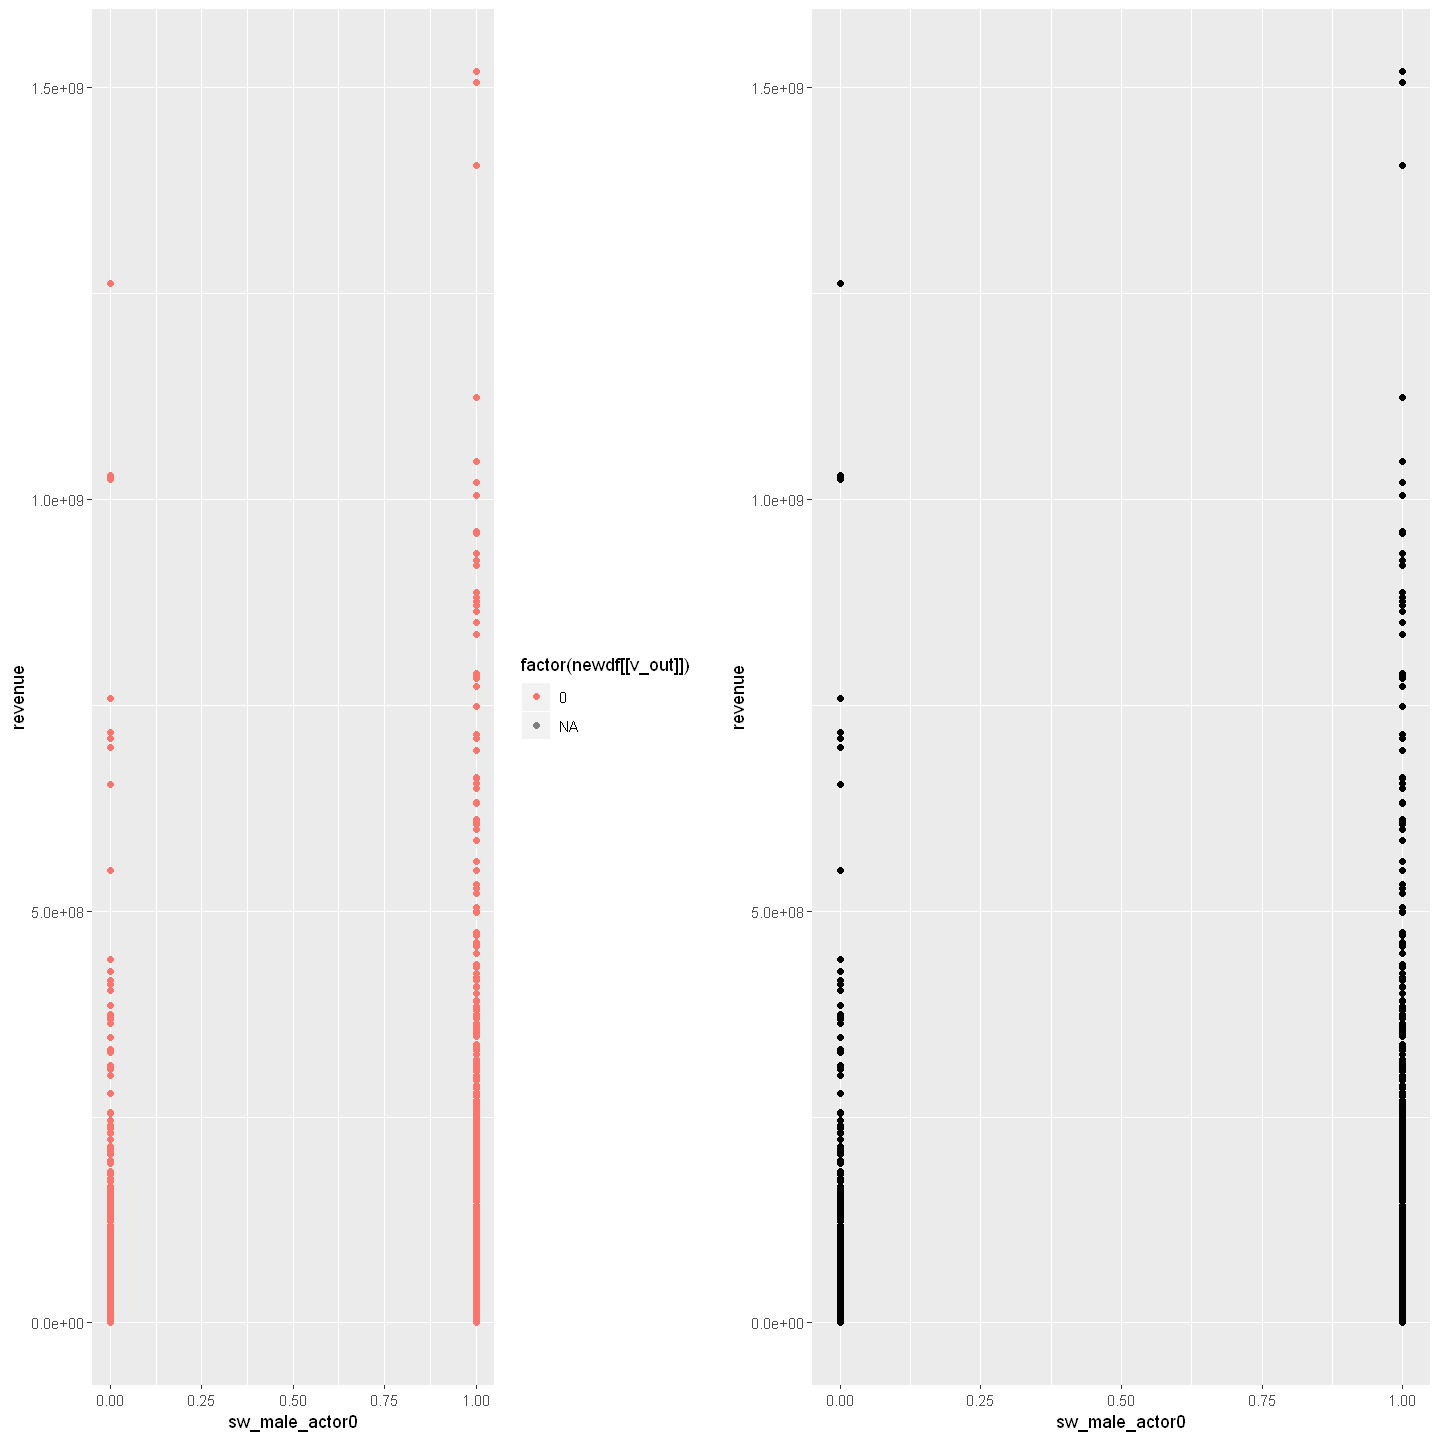

NULL
NULL


Warning message:
"Removed 4450 rows containing missing values (geom_point)."
Warning message:
"Removed 4450 rows containing missing values (geom_point)."


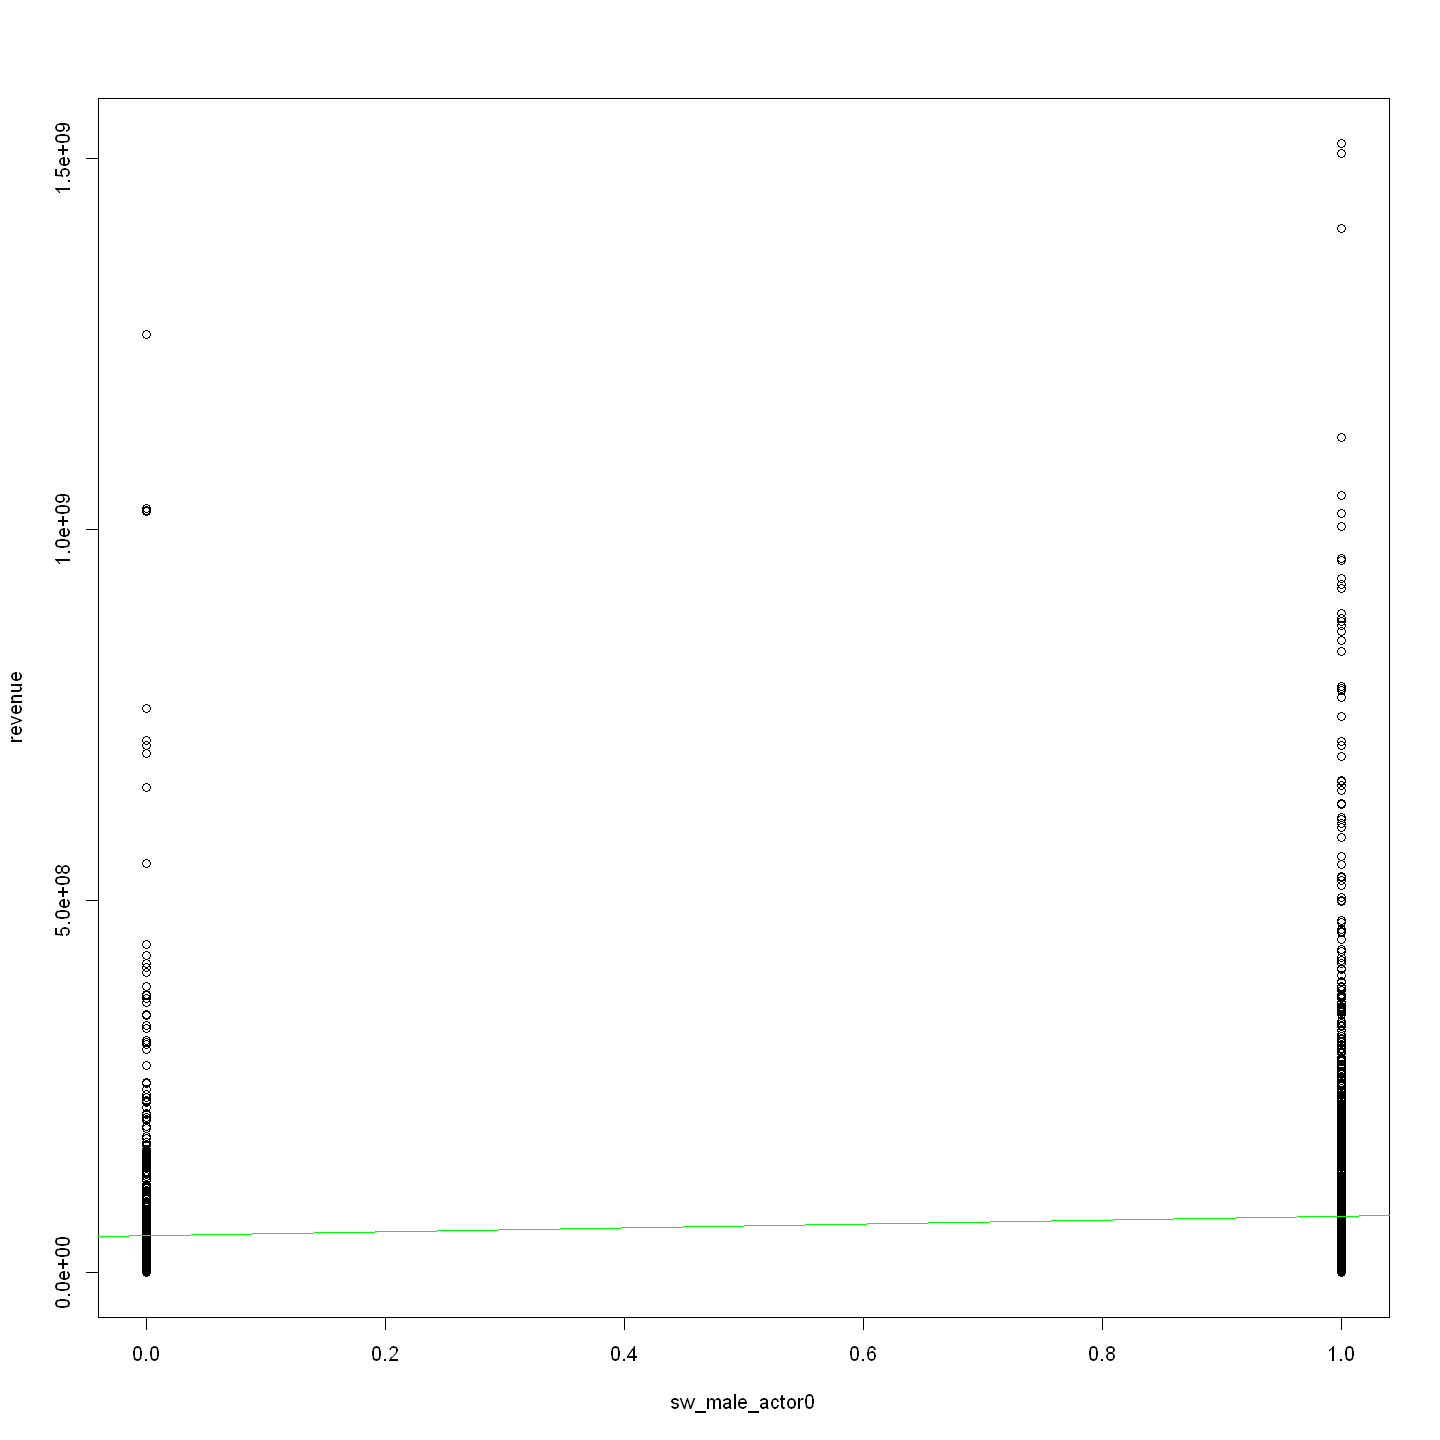

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


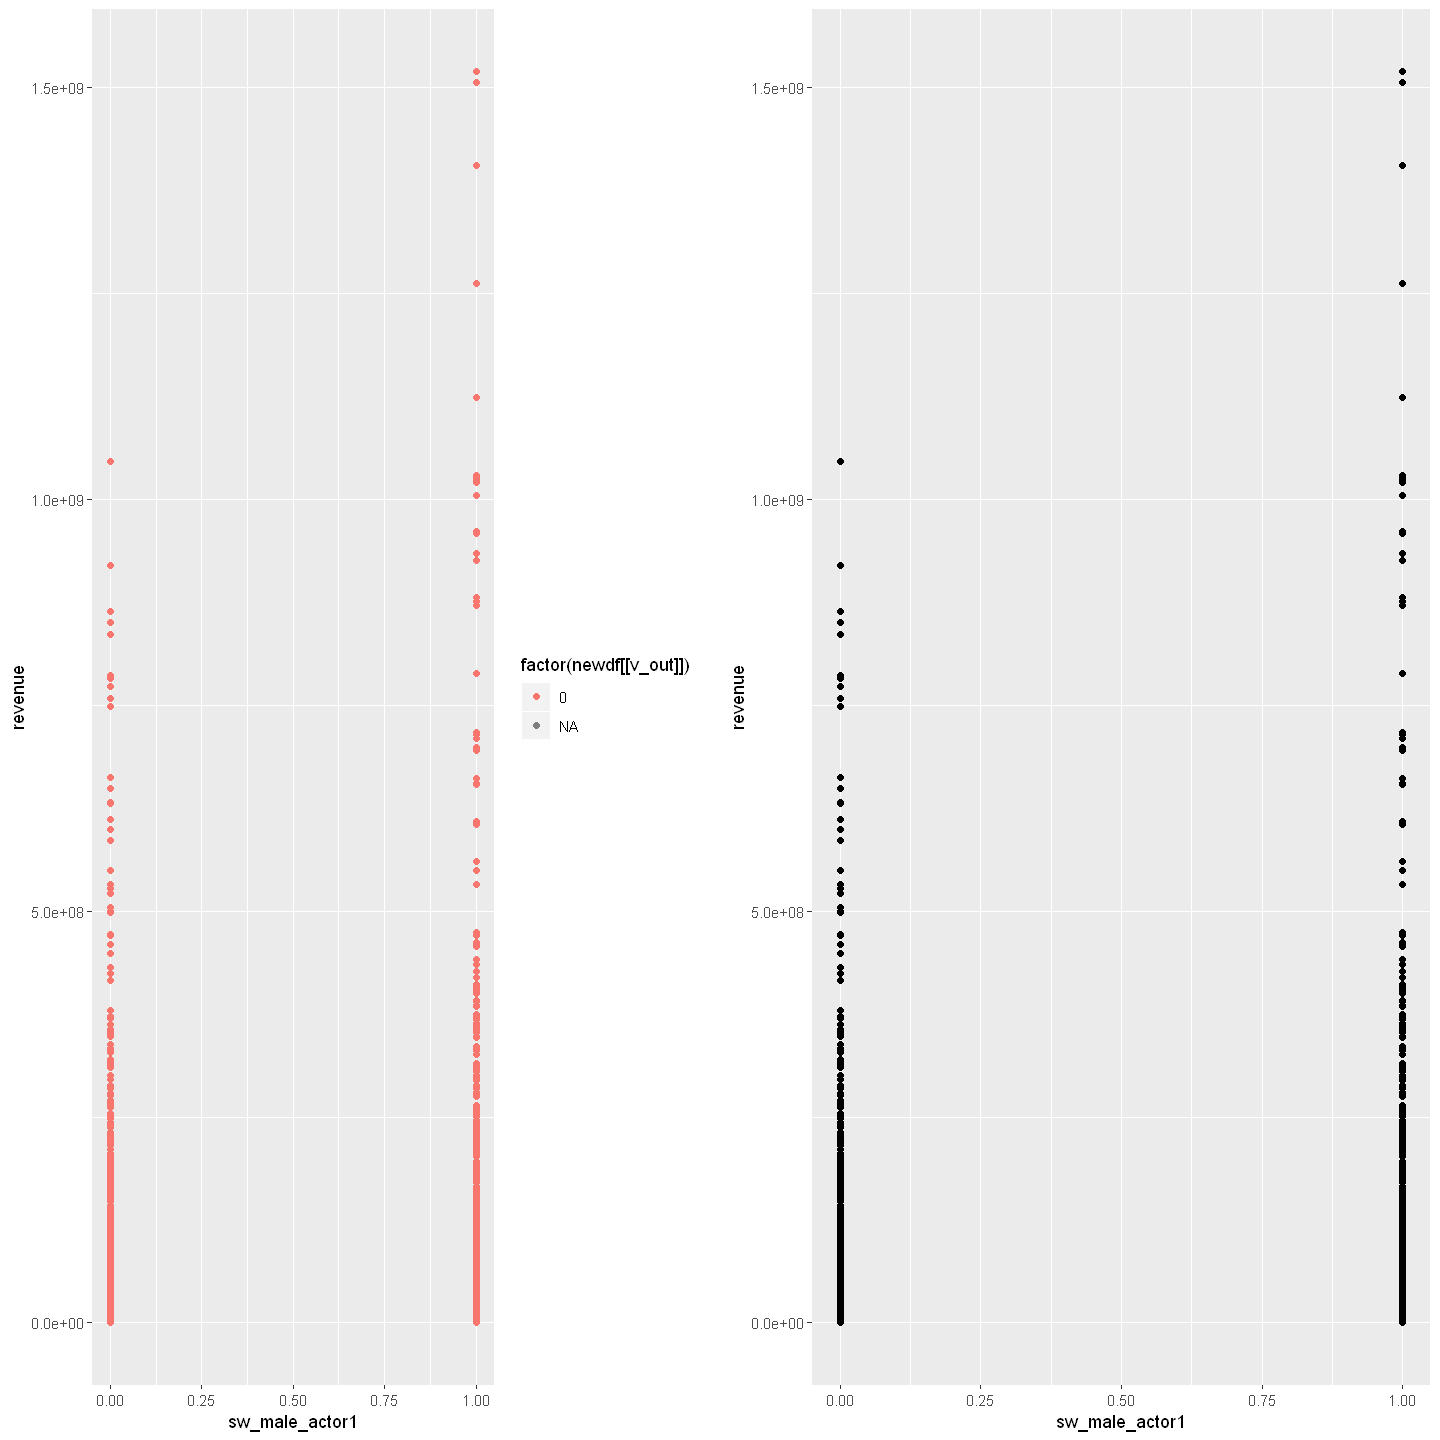

NULL
NULL


Warning message:
"Removed 4453 rows containing missing values (geom_point)."
Warning message:
"Removed 4453 rows containing missing values (geom_point)."


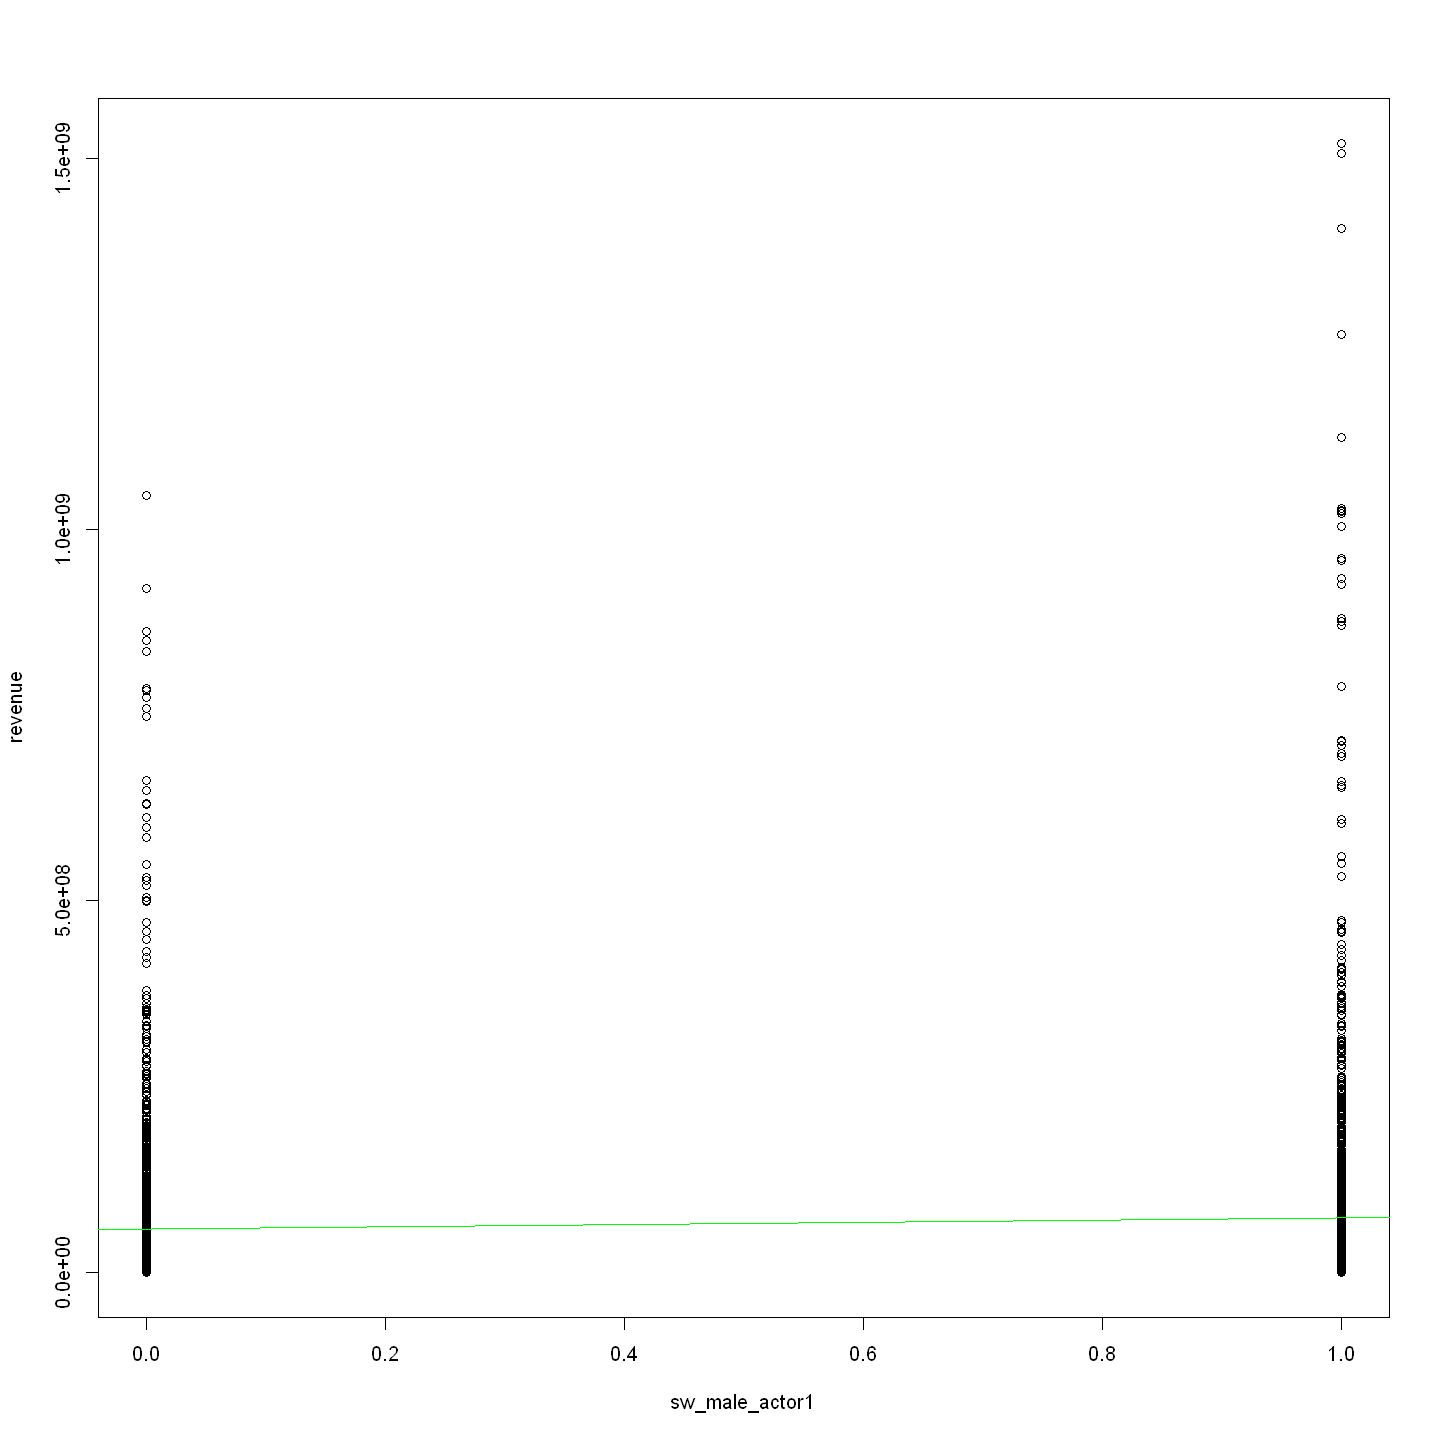

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


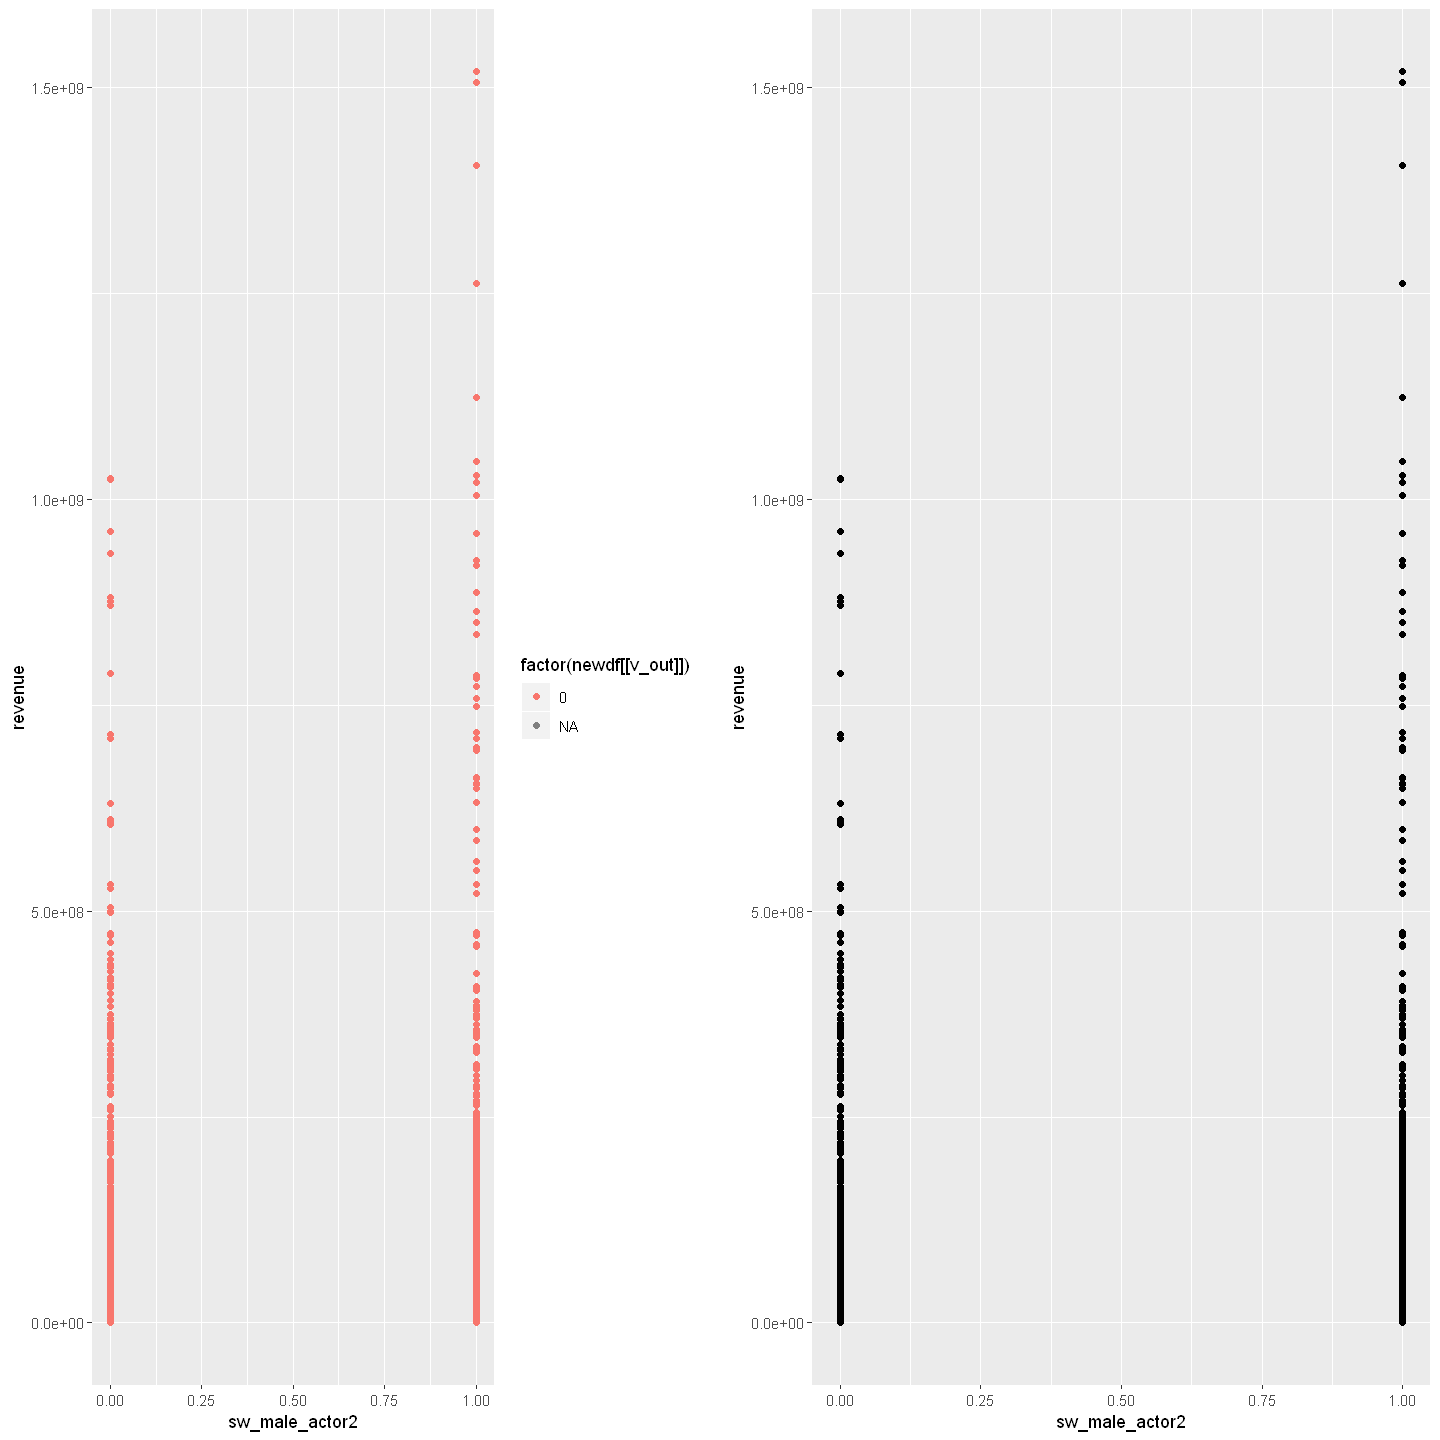

NULL
NULL


Warning message:
"Removed 5310 rows containing missing values (geom_point)."
Warning message:
"Removed 5431 rows containing missing values (geom_point)."


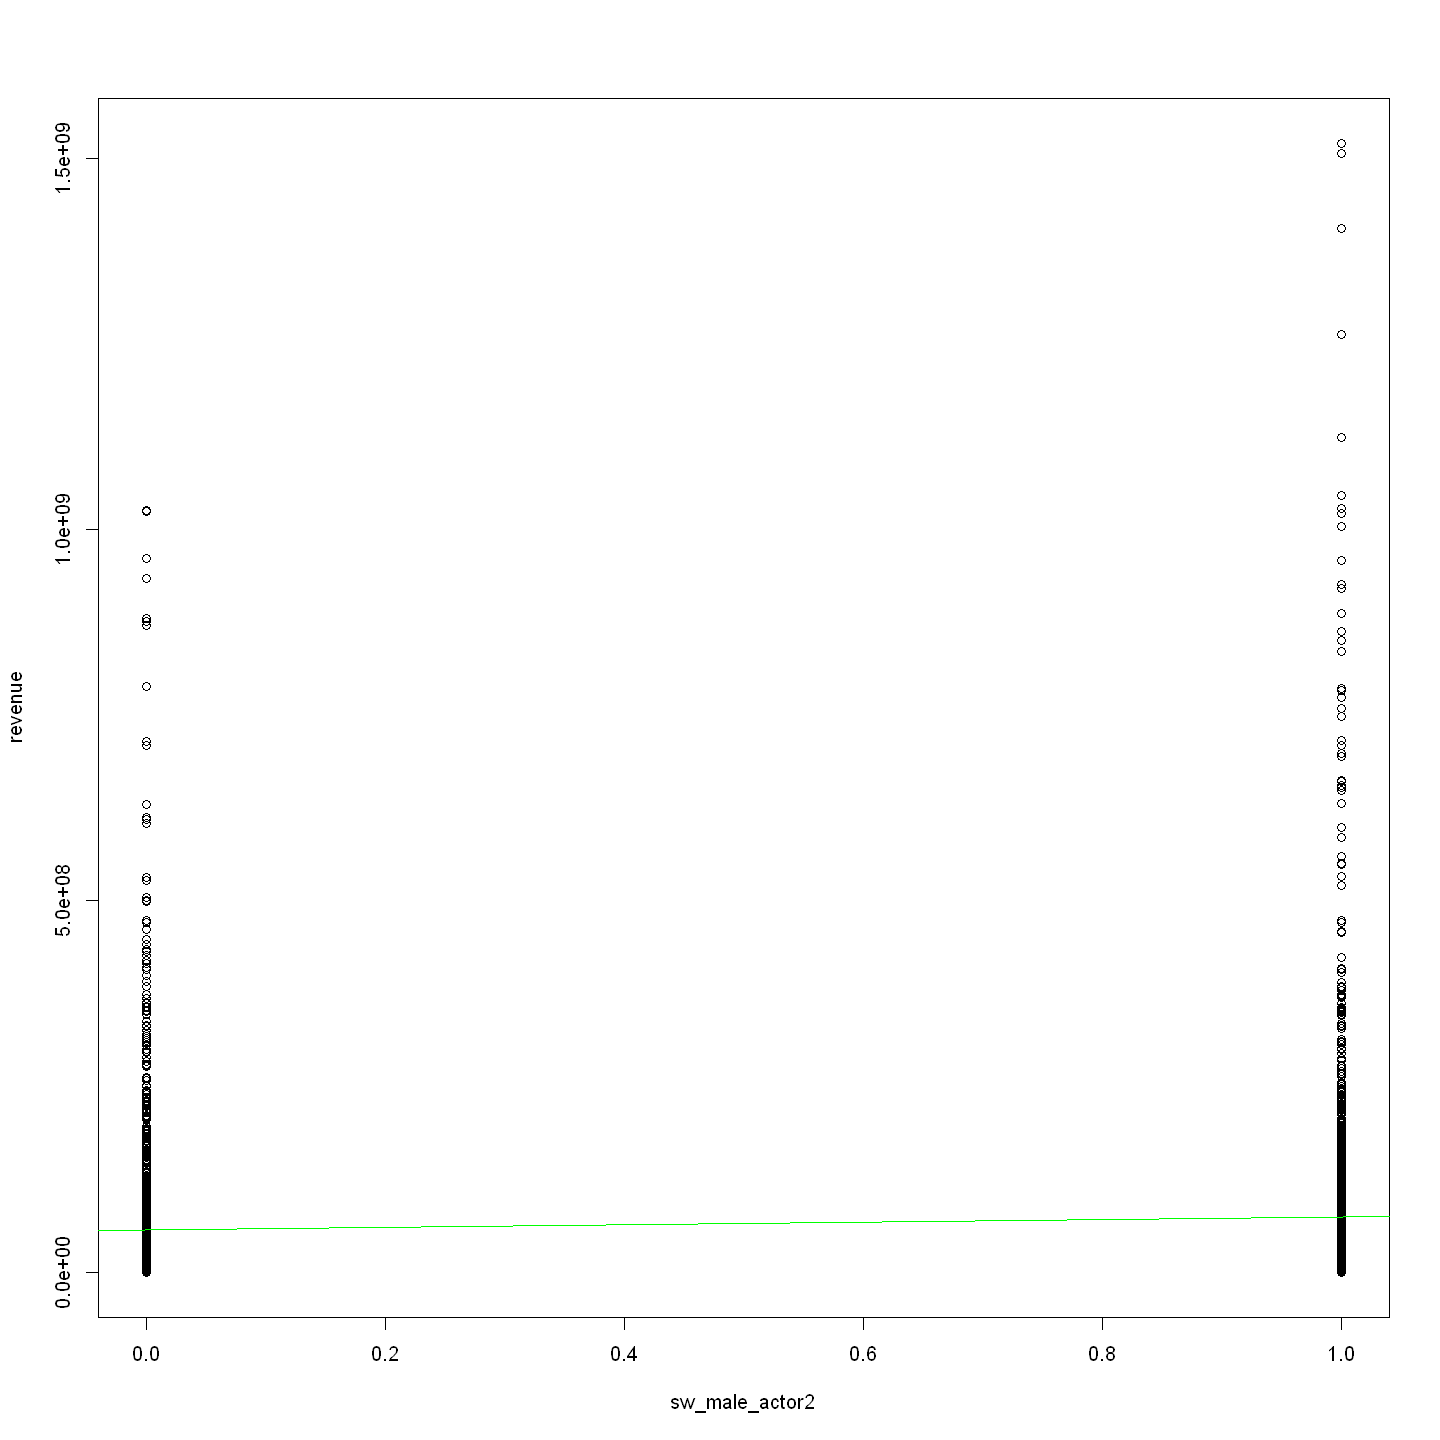

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


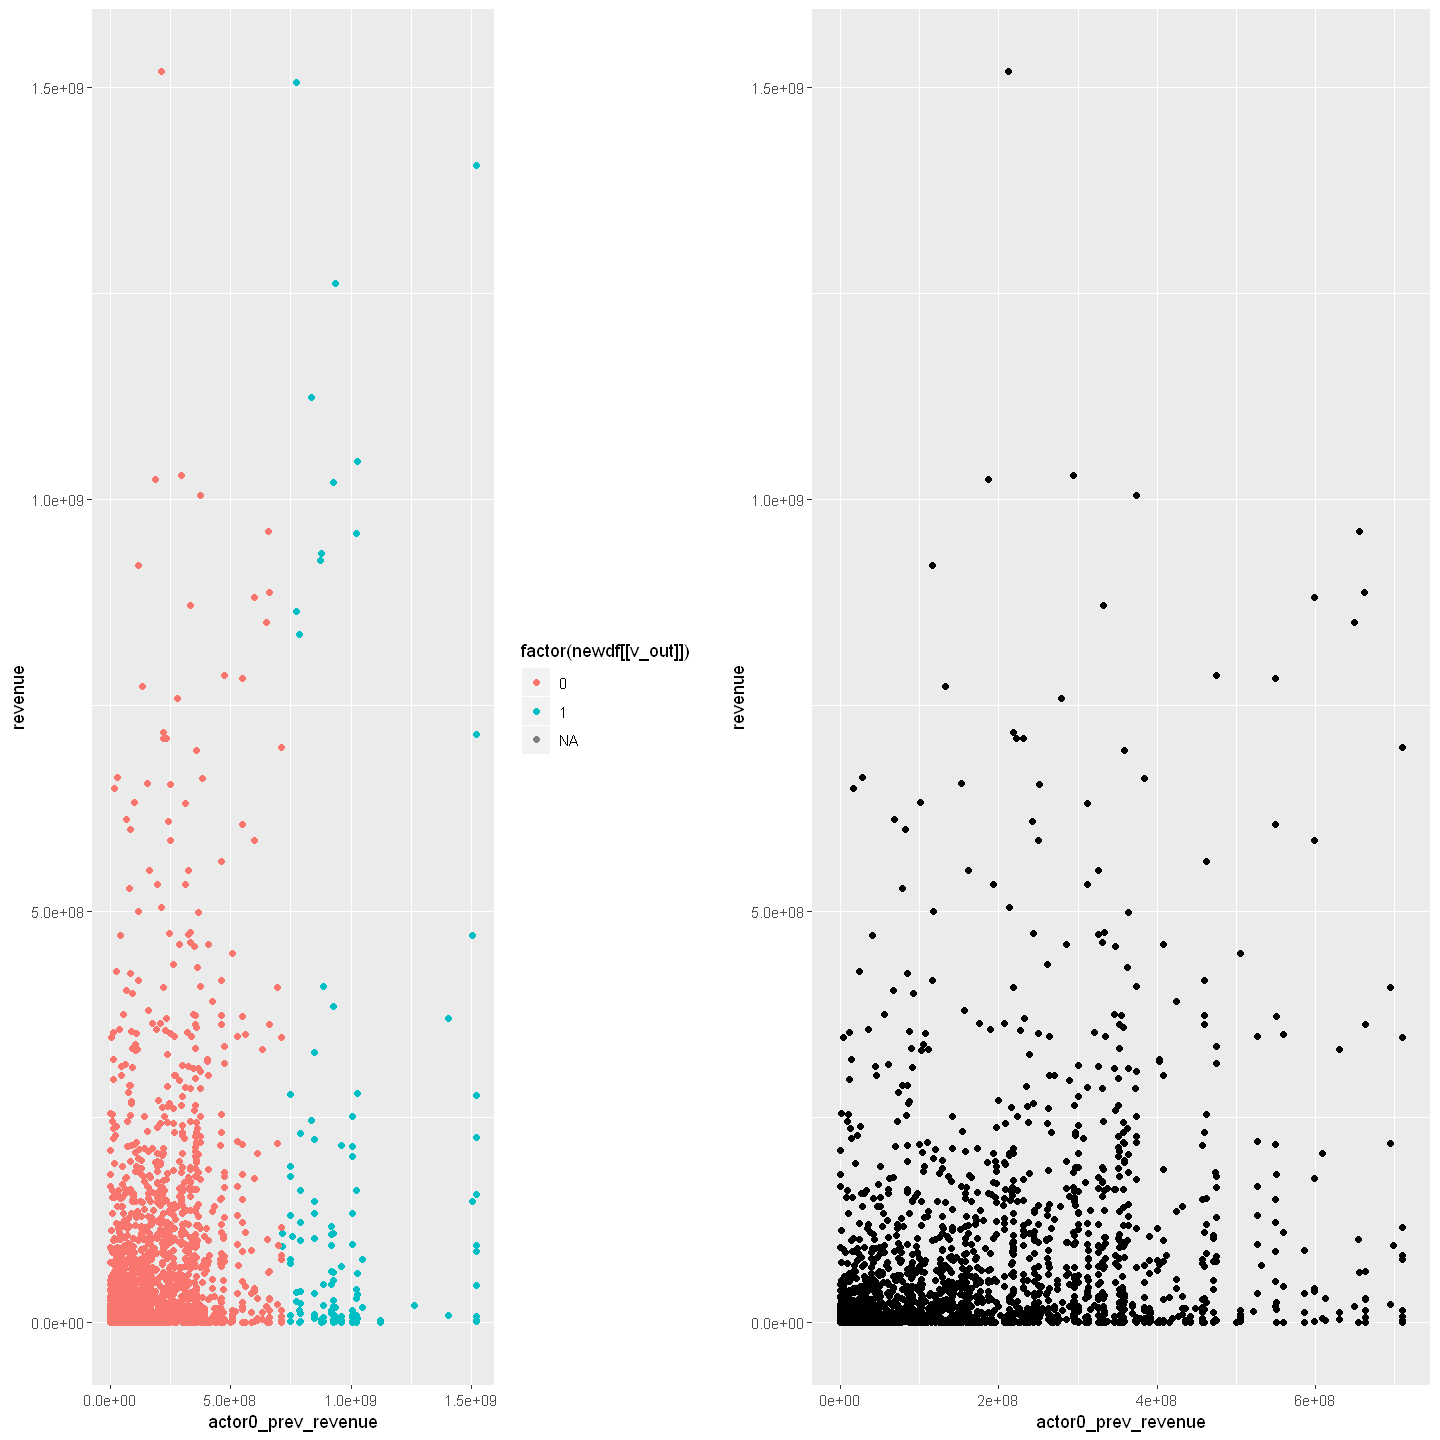

NULL
NULL


Warning message:
"Removed 5534 rows containing missing values (geom_point)."
Warning message:
"Removed 5668 rows containing missing values (geom_point)."


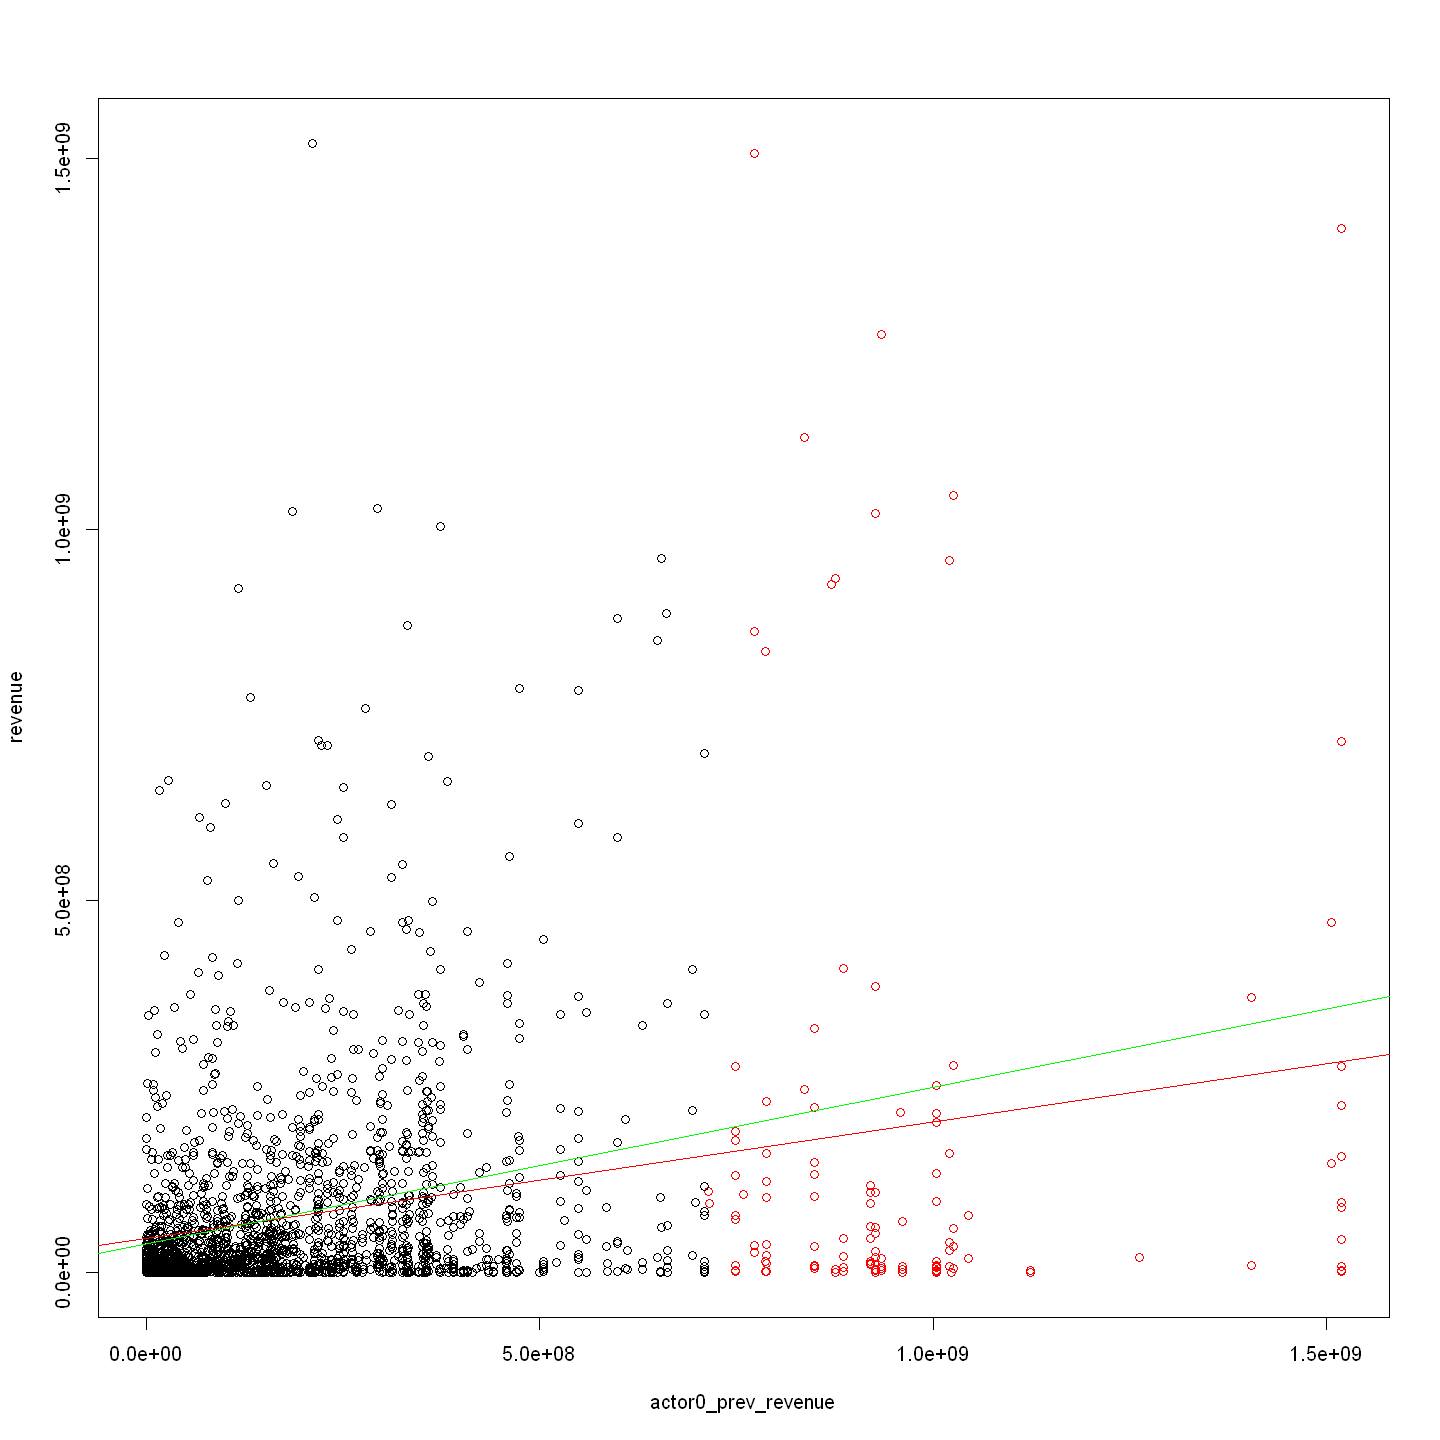

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


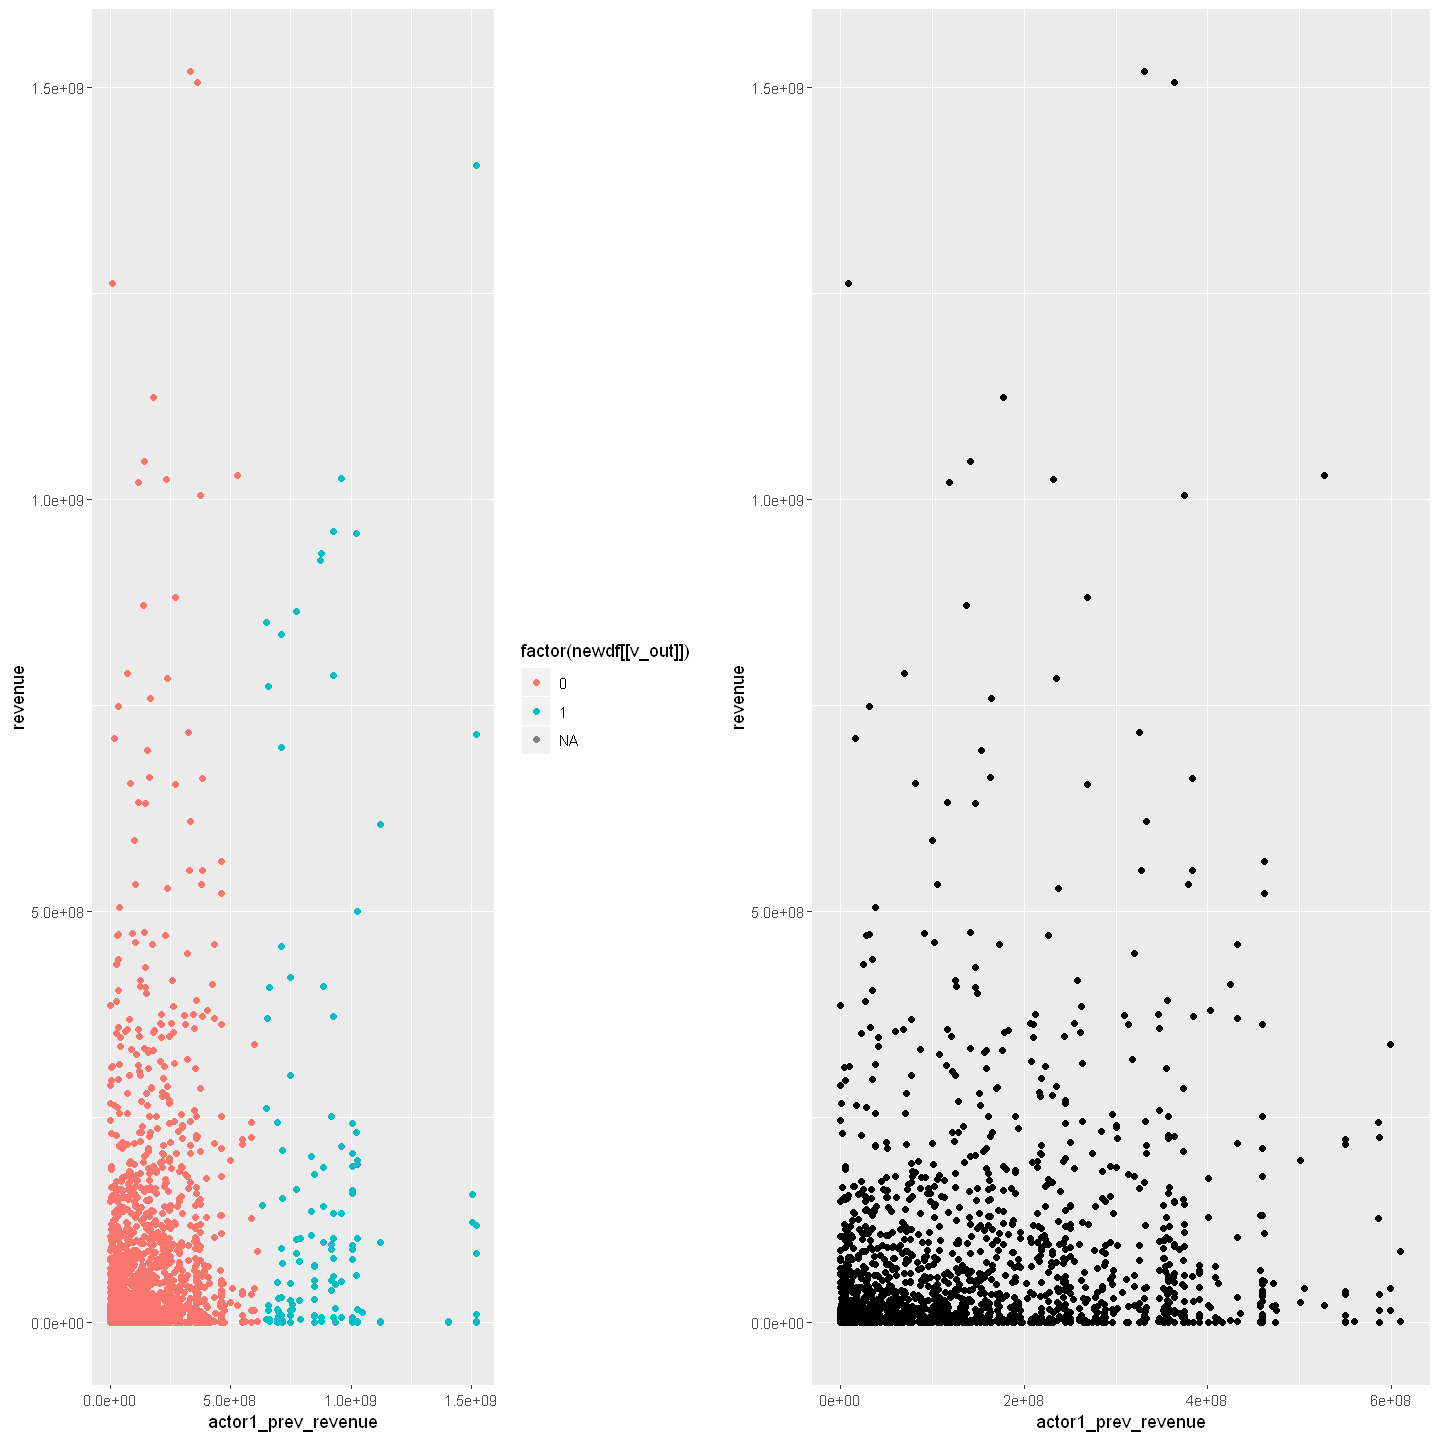

NULL
NULL


Warning message:
"Removed 5621 rows containing missing values (geom_point)."
Warning message:
"Removed 5765 rows containing missing values (geom_point)."


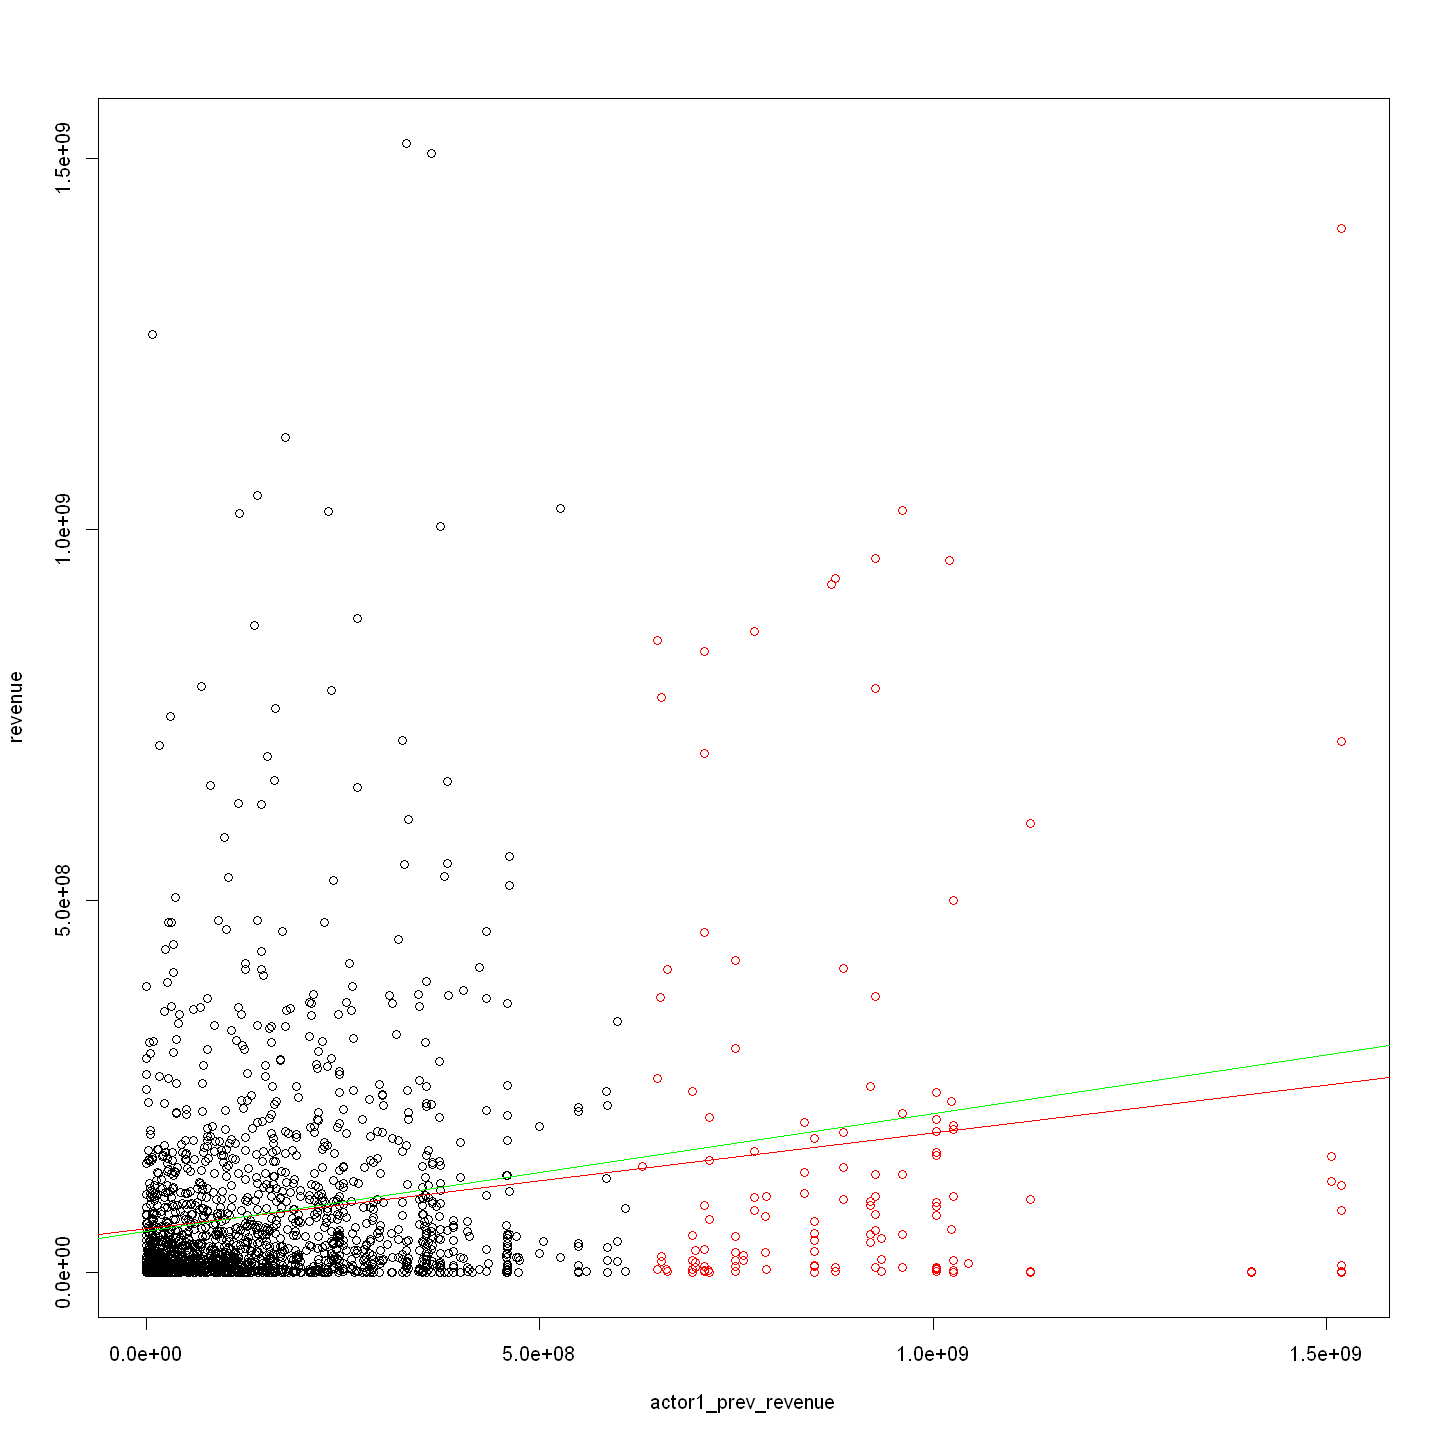

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


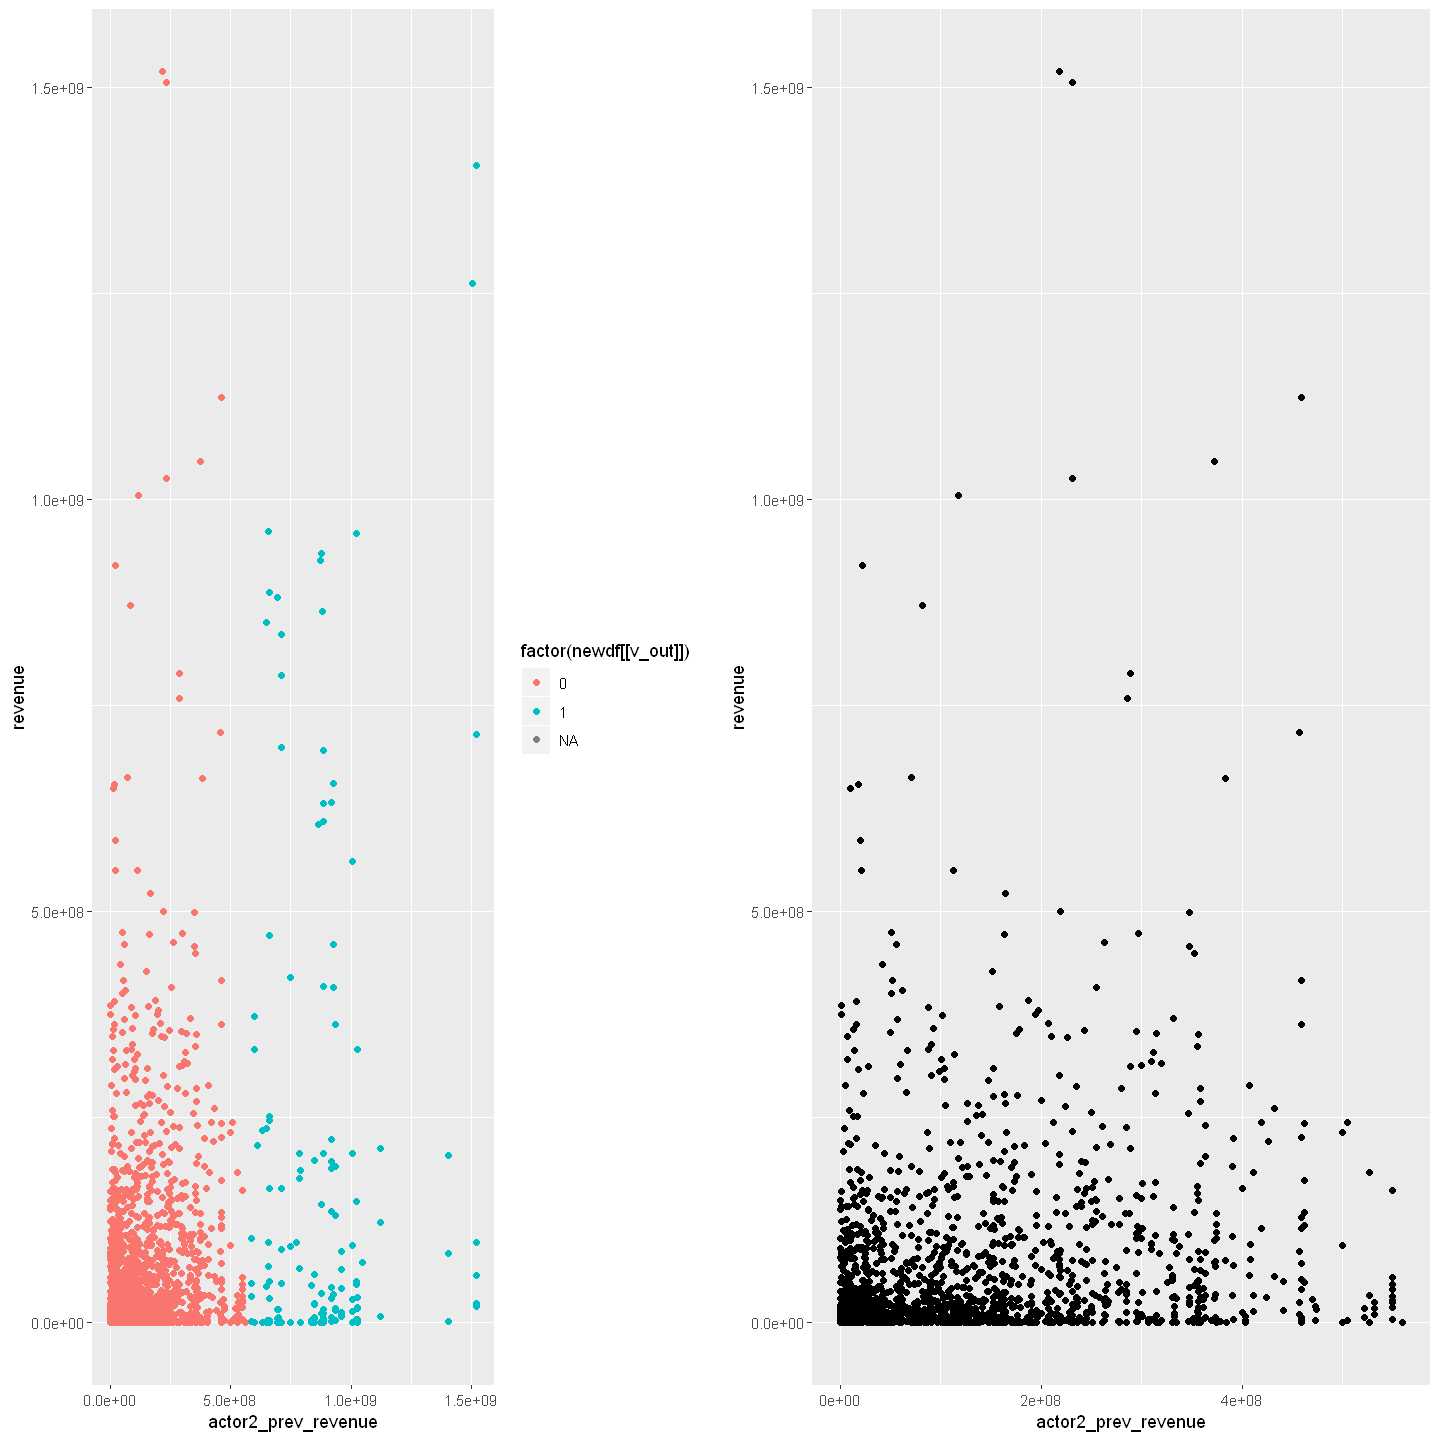

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4548 rows containing missing values (geom_point)."


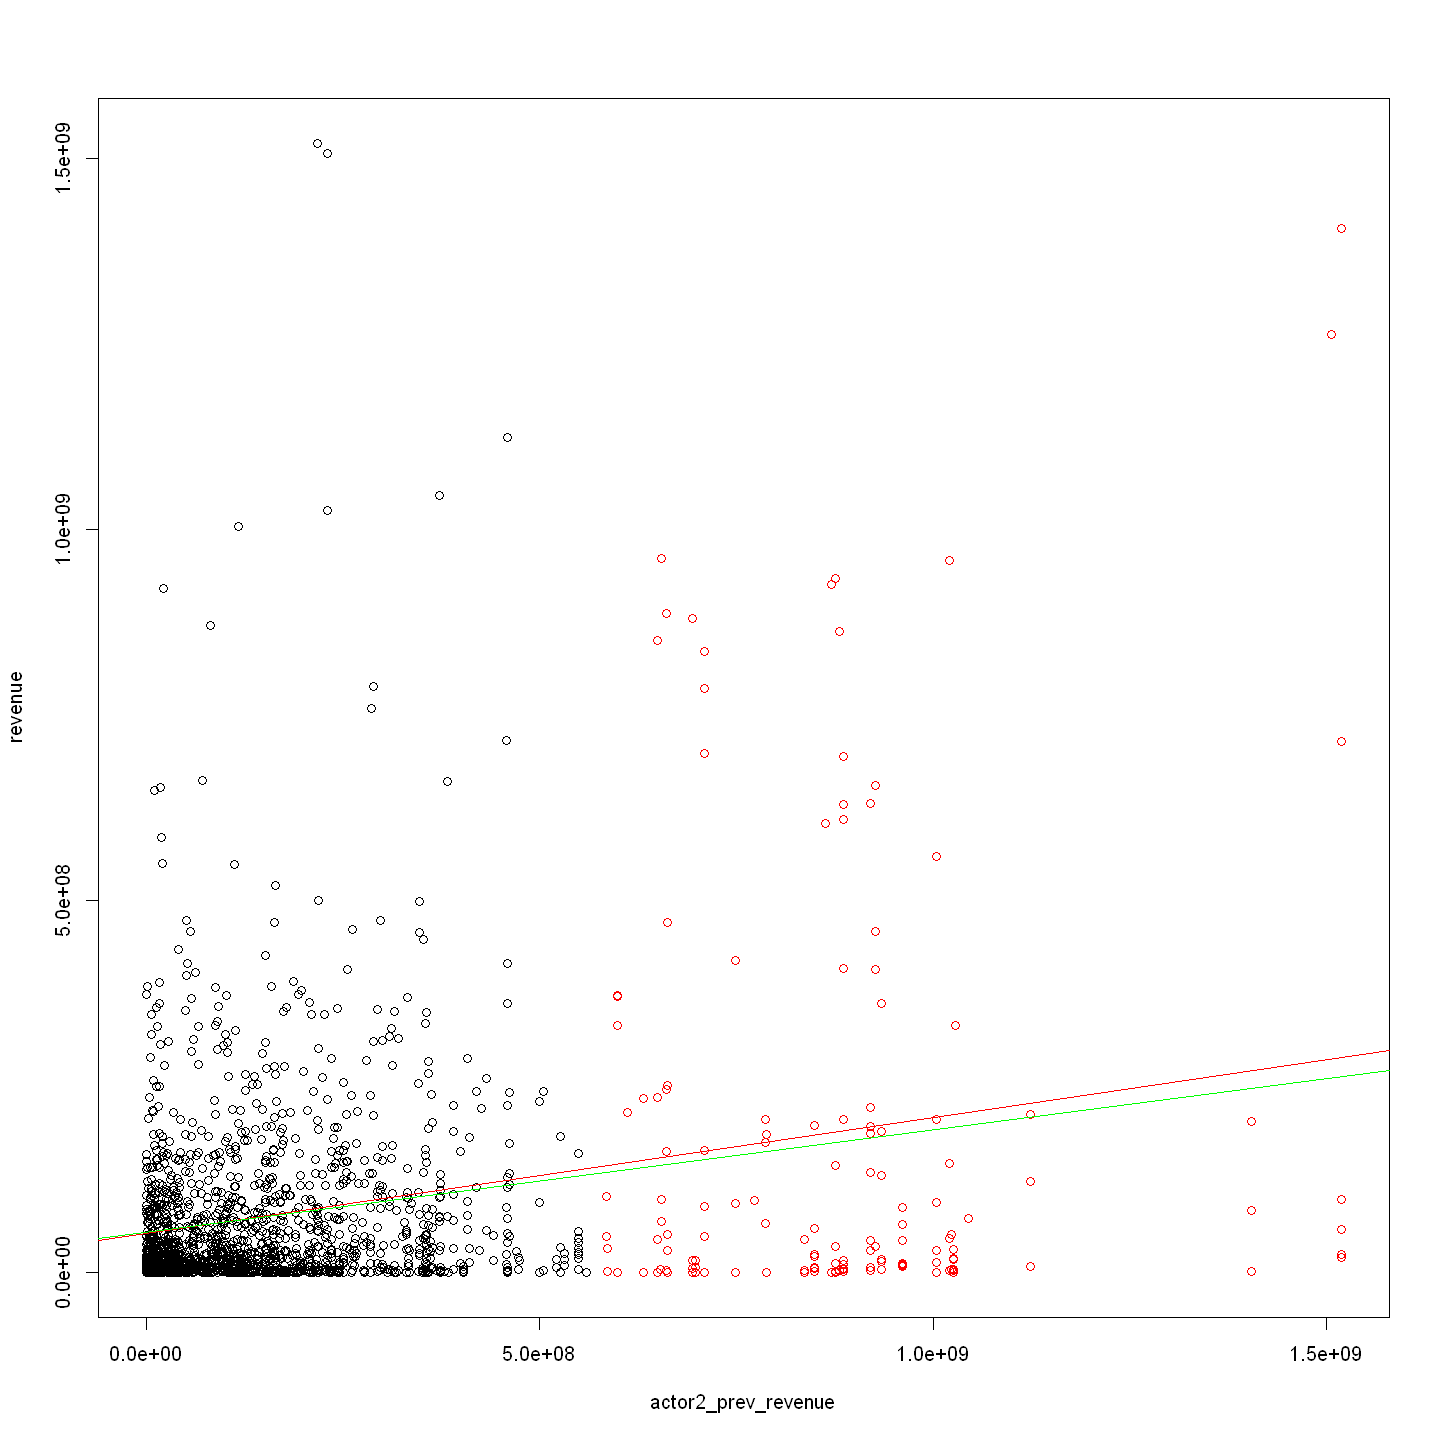

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


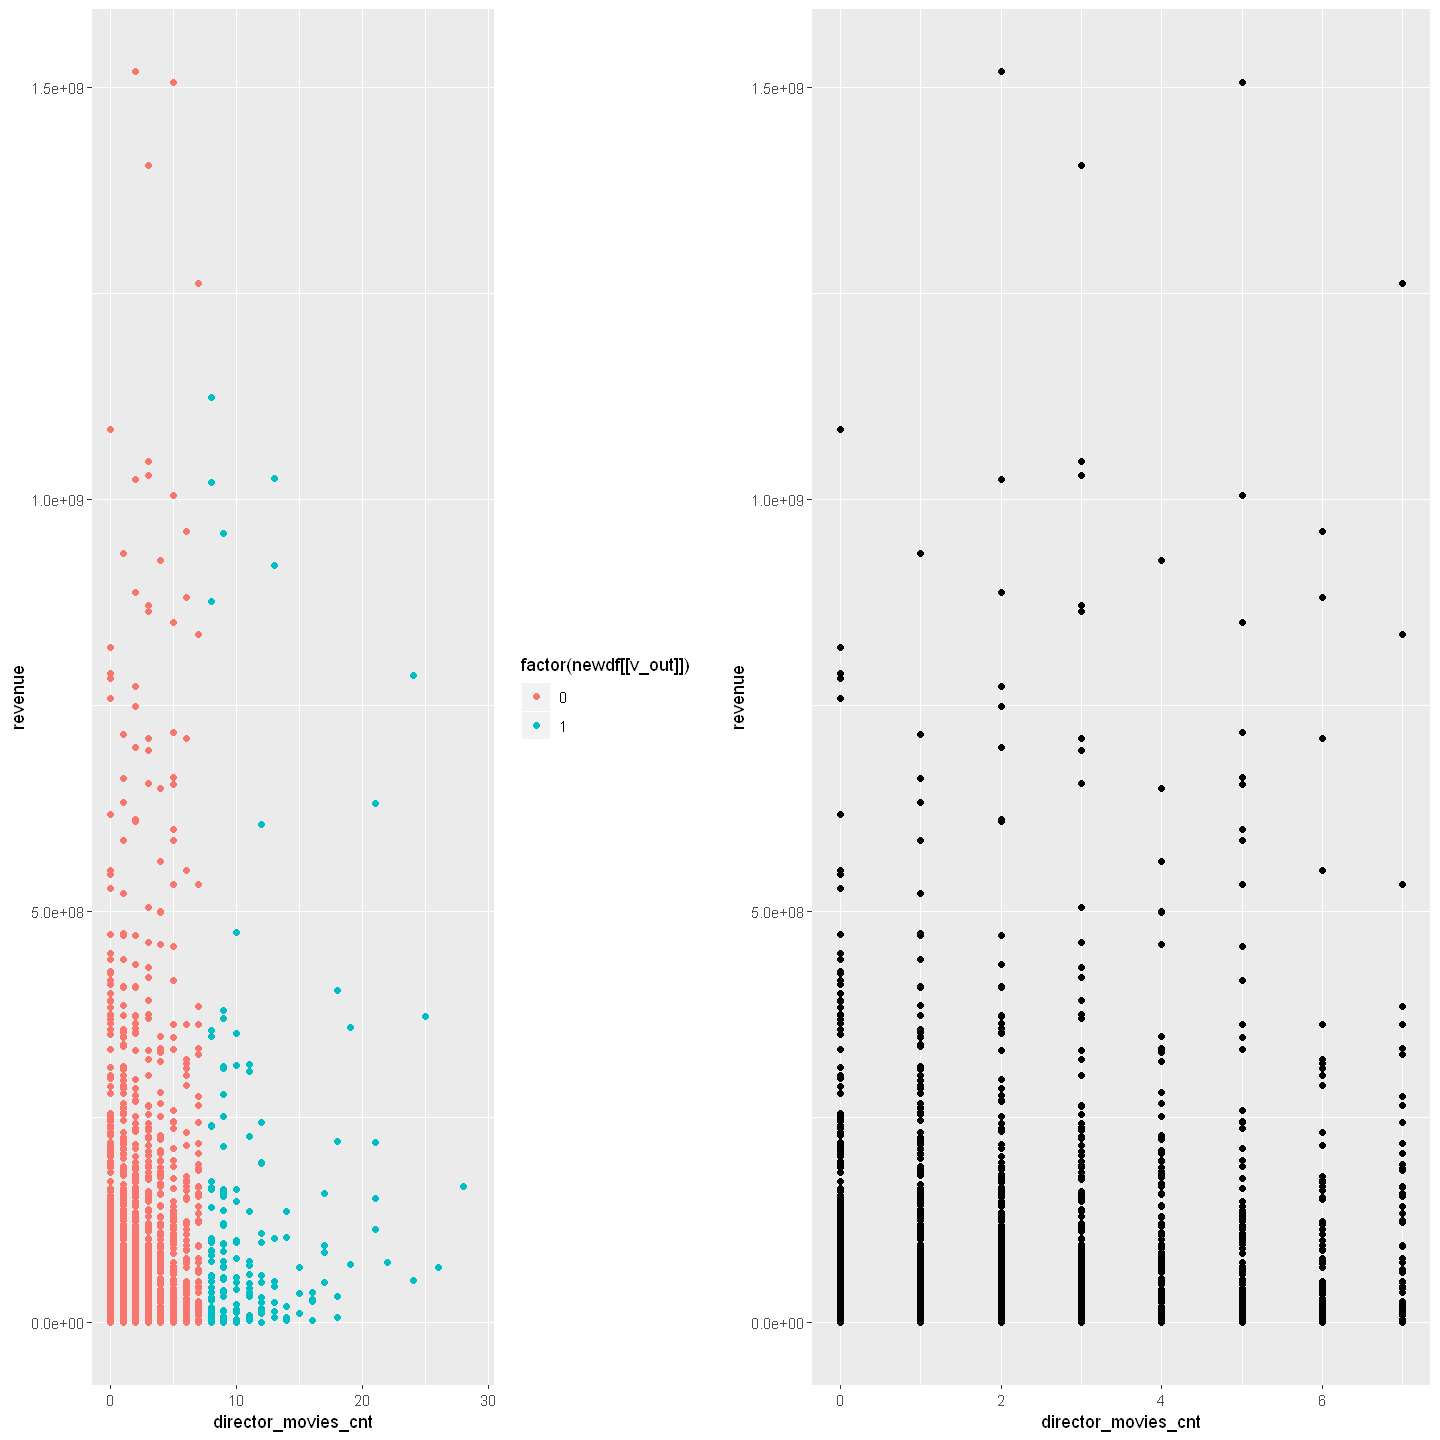

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4518 rows containing missing values (geom_point)."


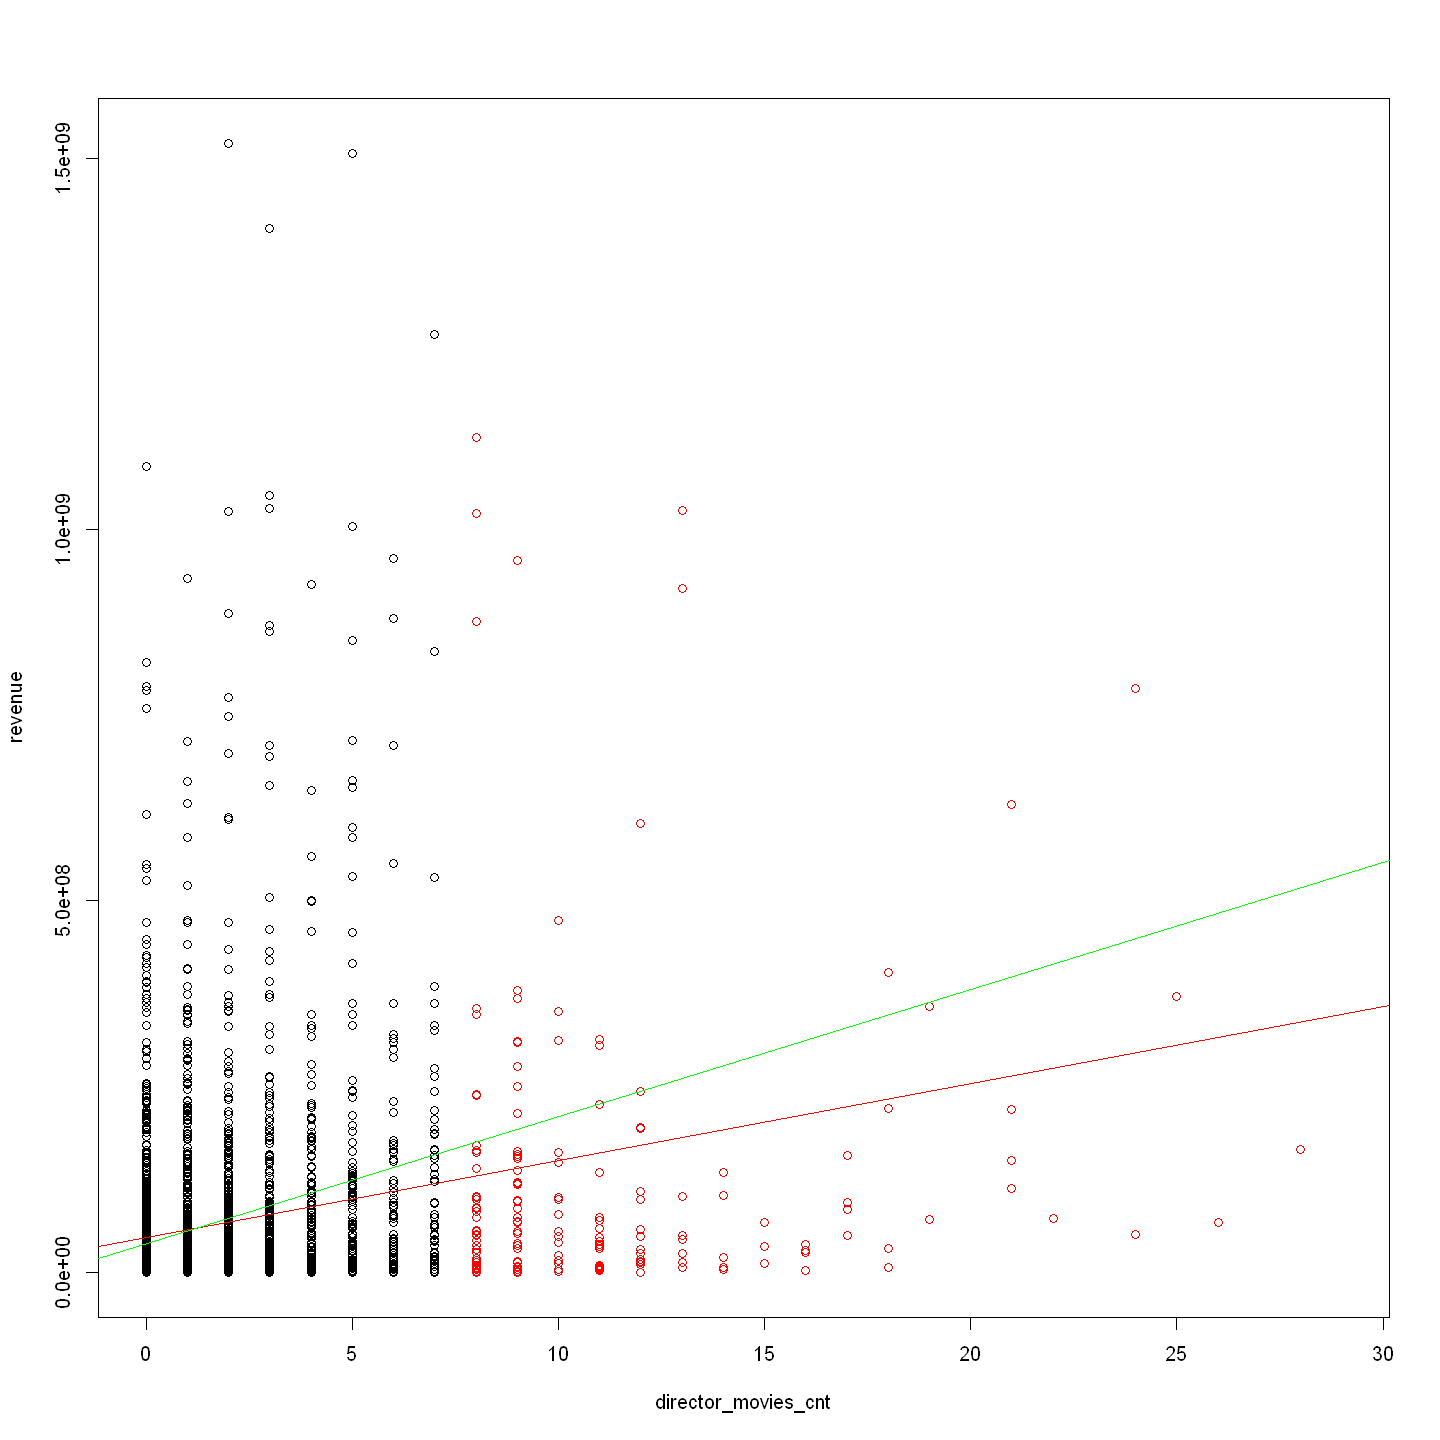

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


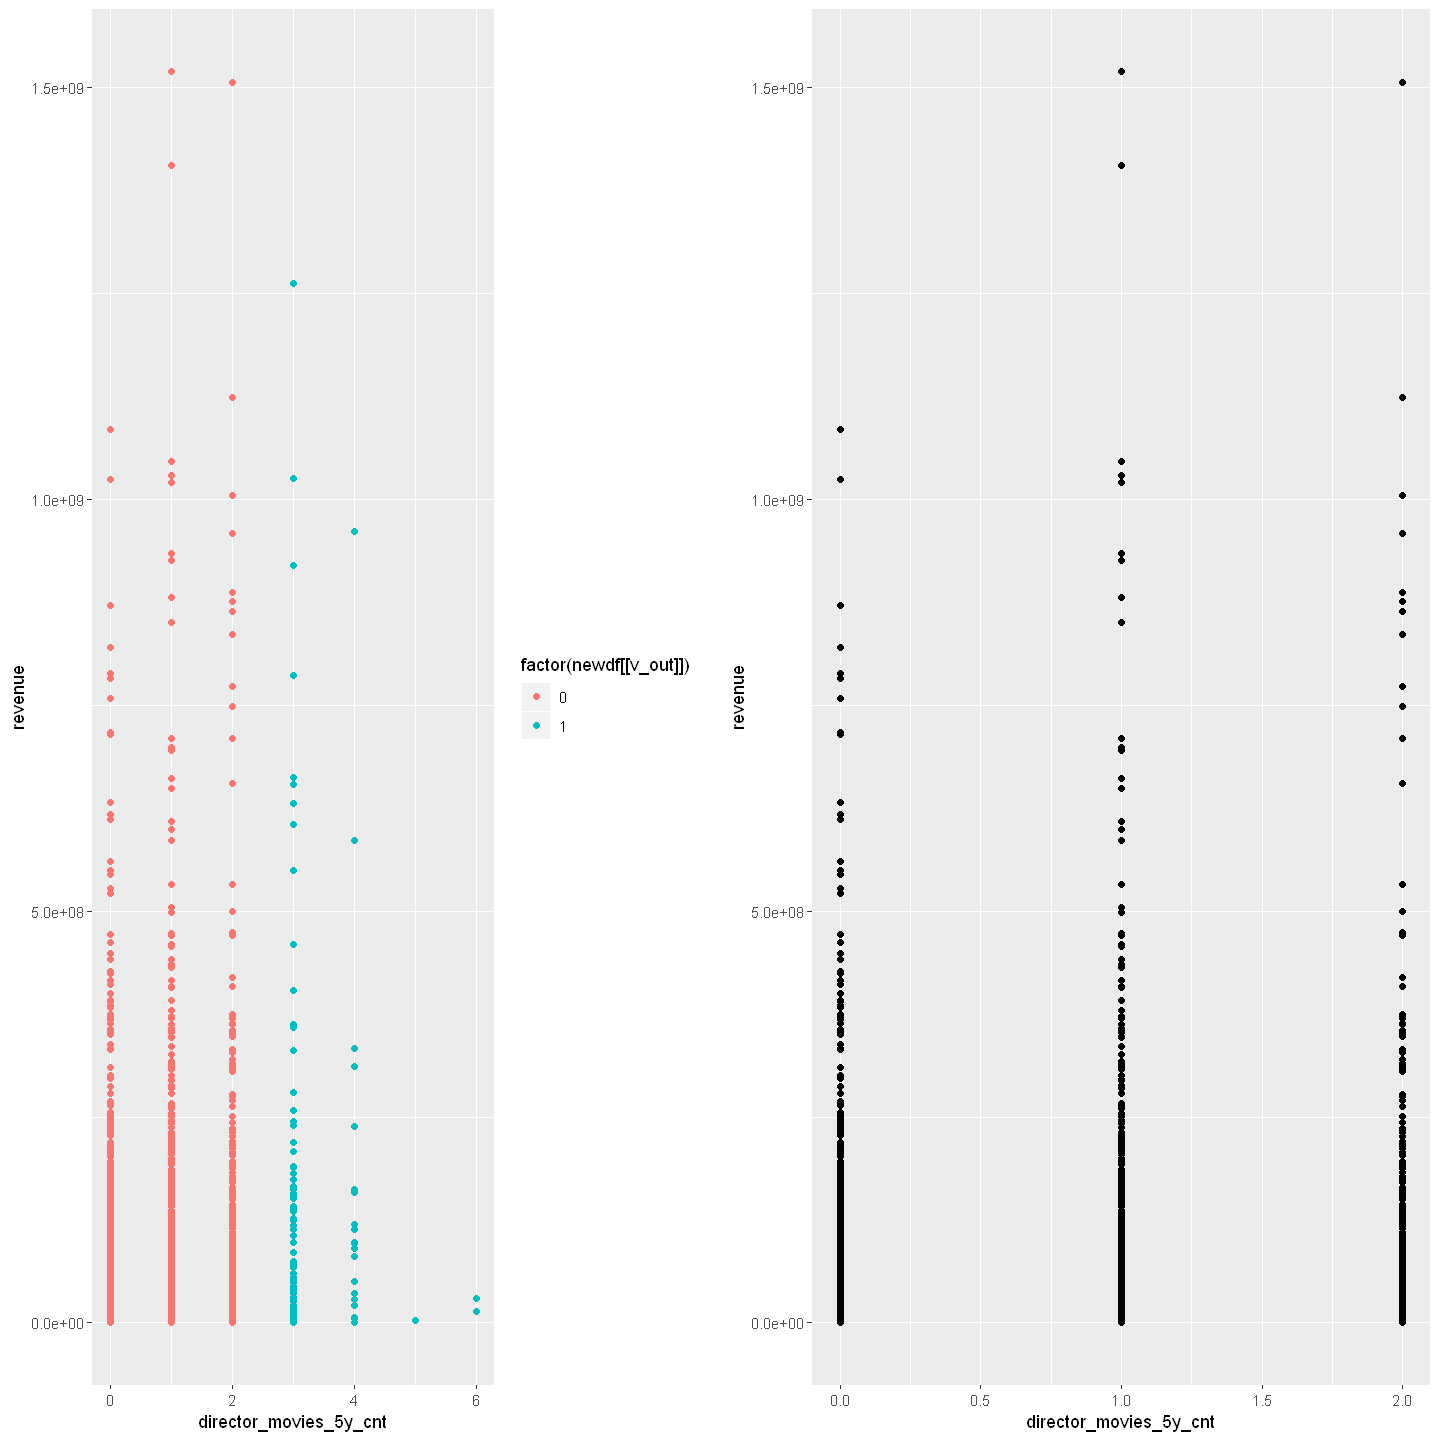

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4821 rows containing missing values (geom_point)."


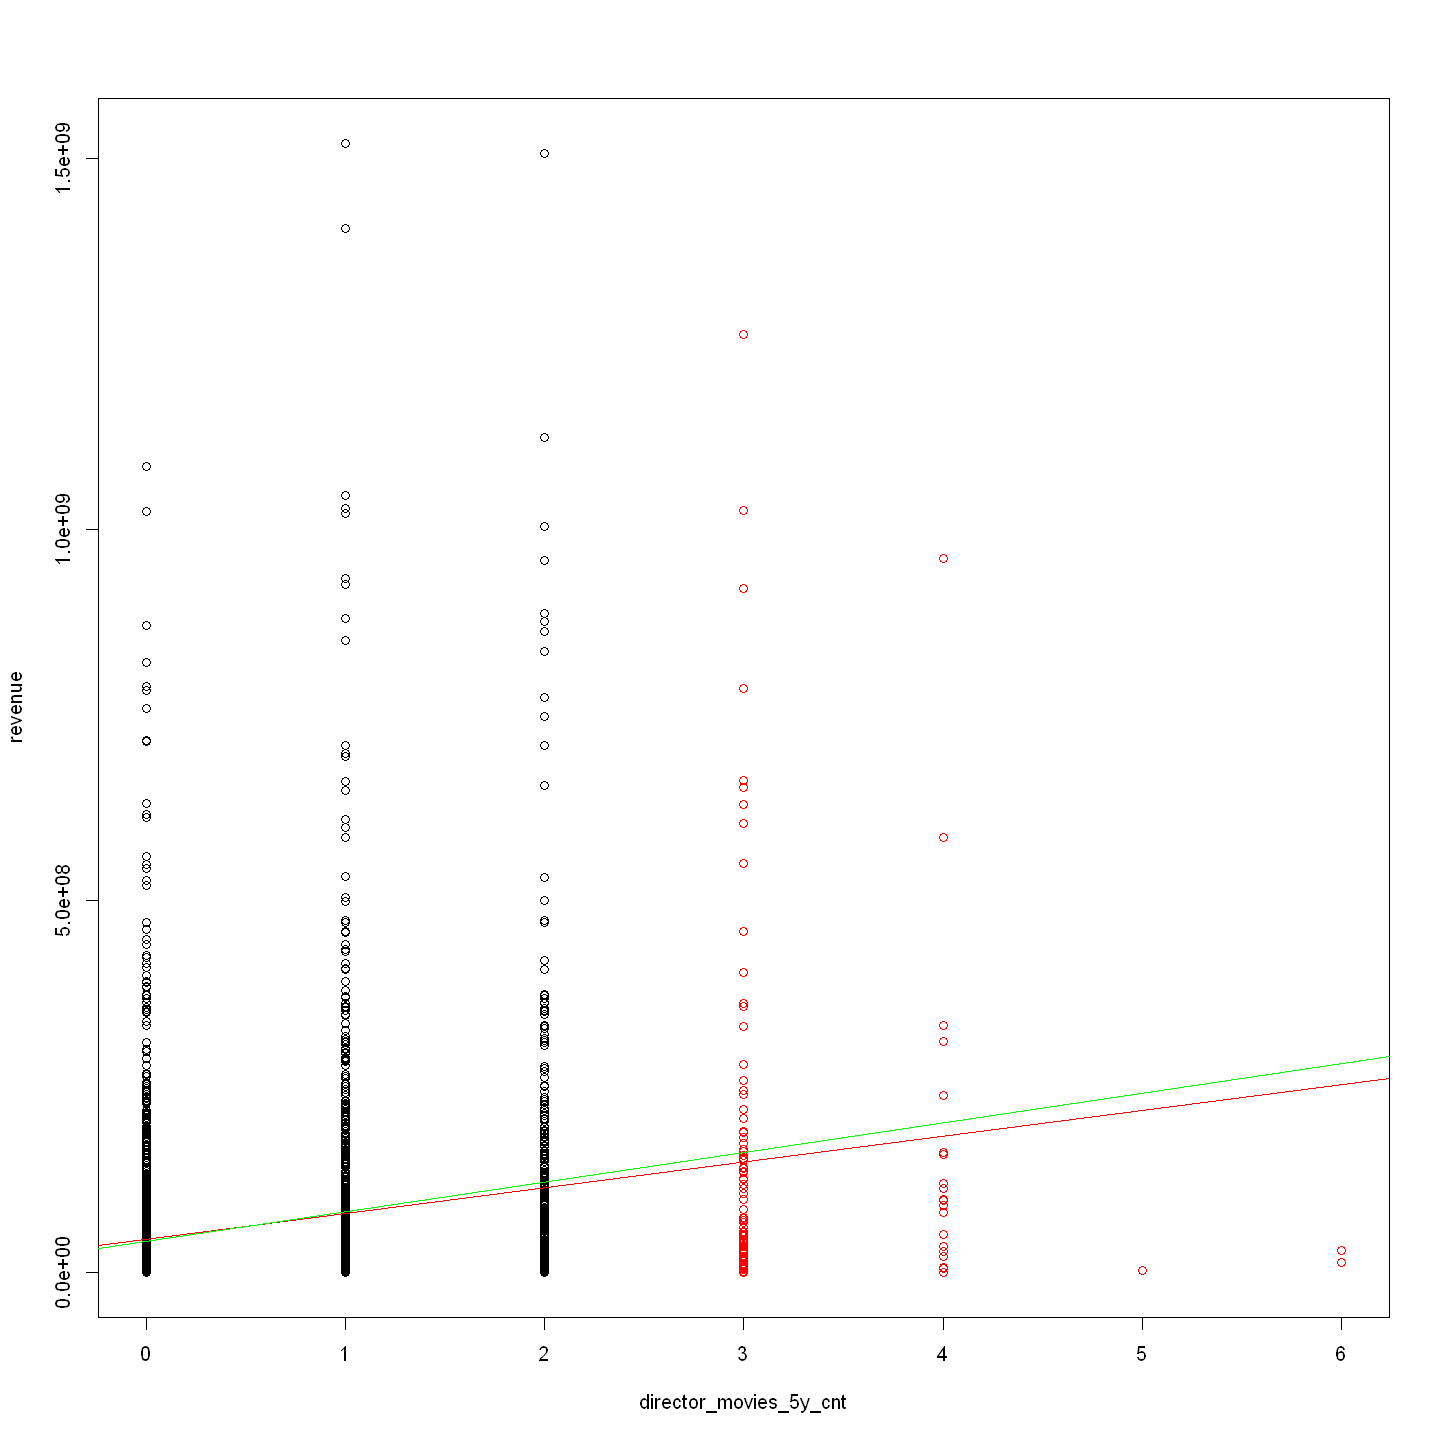

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


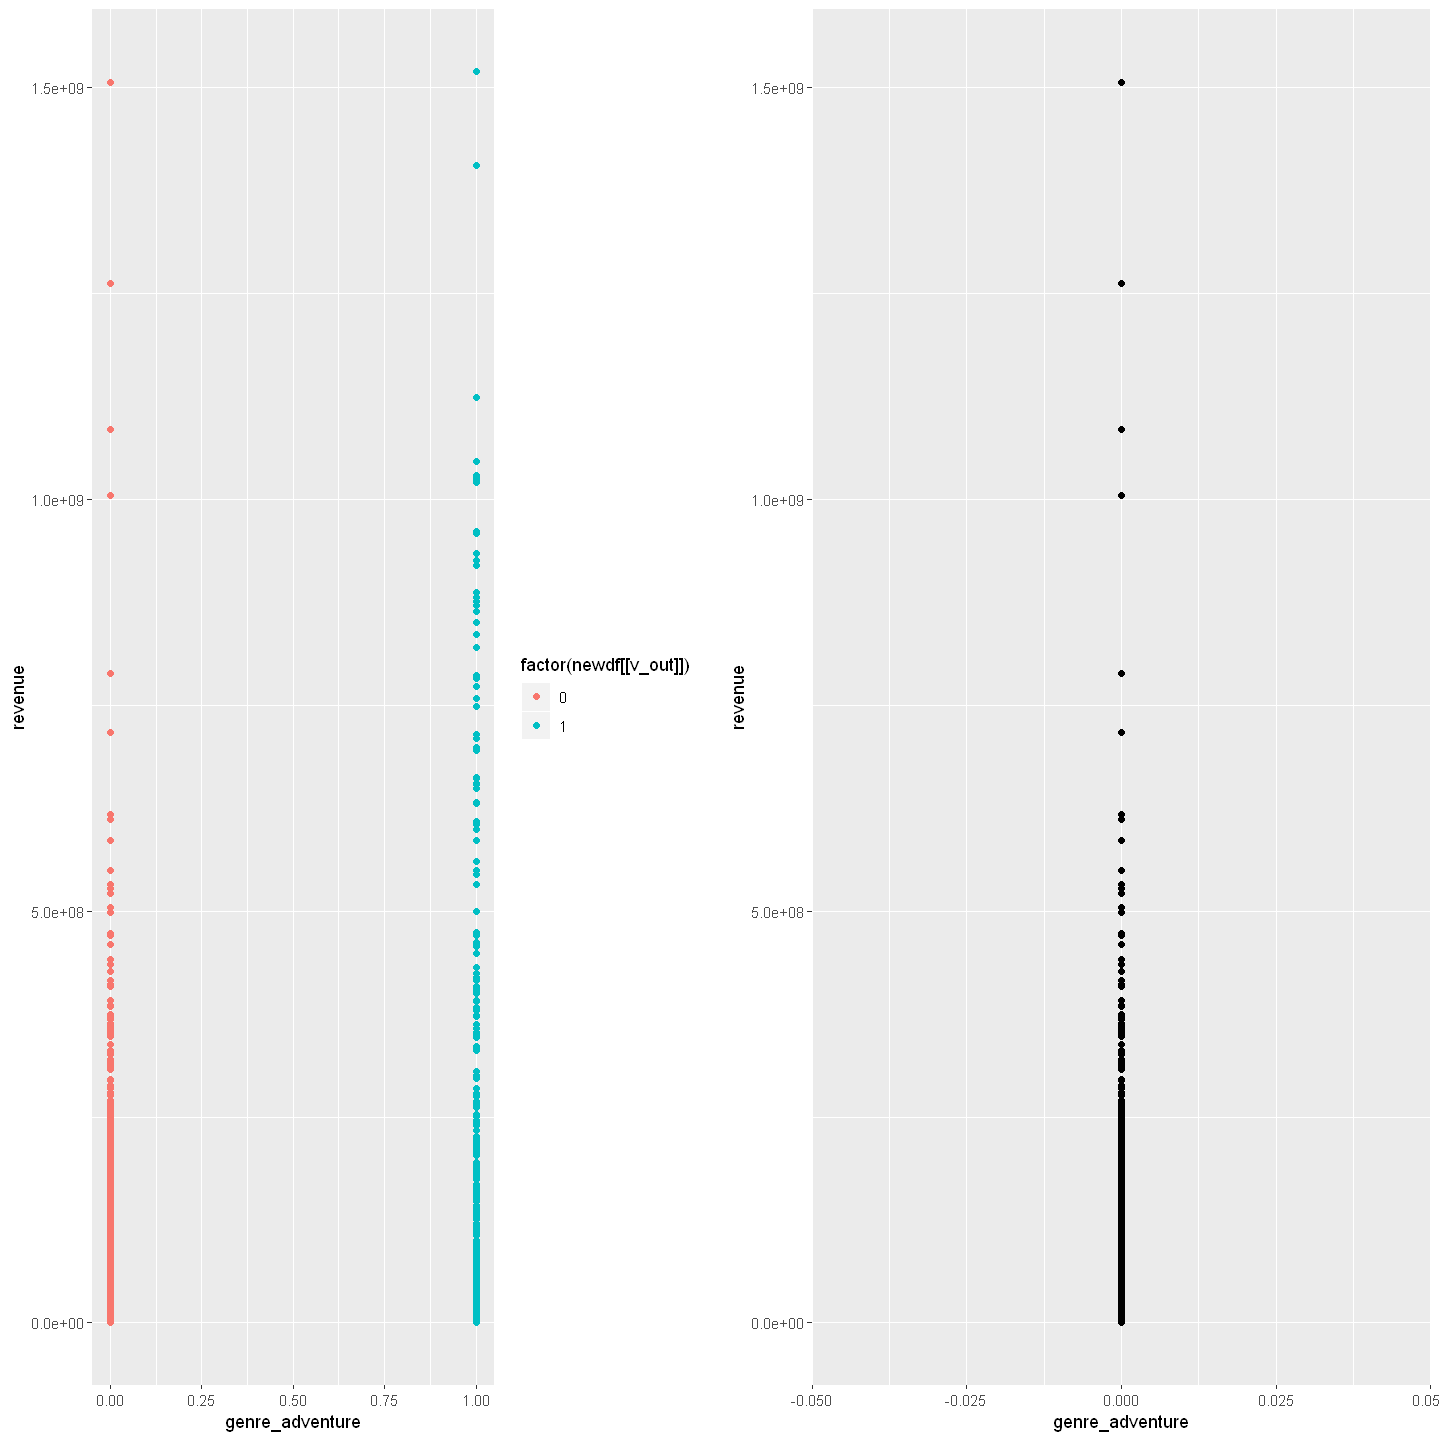

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4614 rows containing missing values (geom_point)."


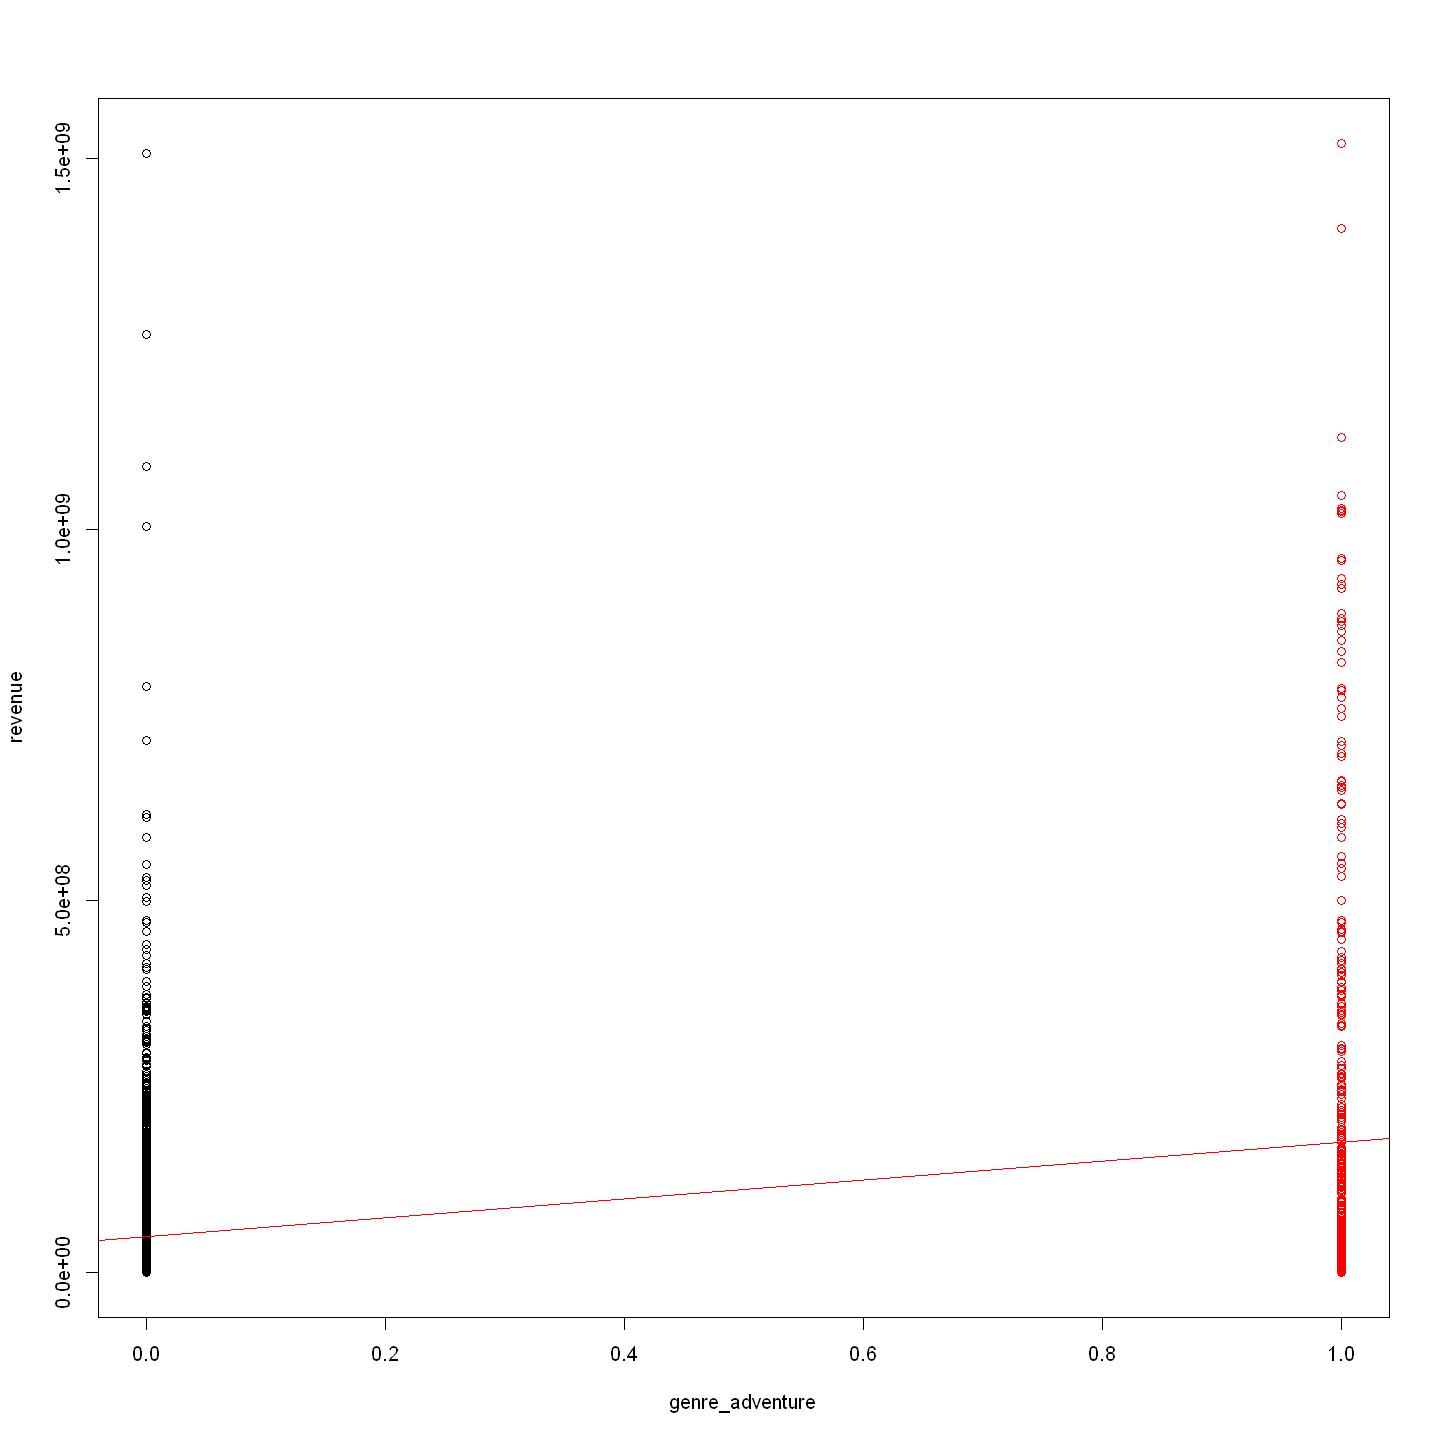

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


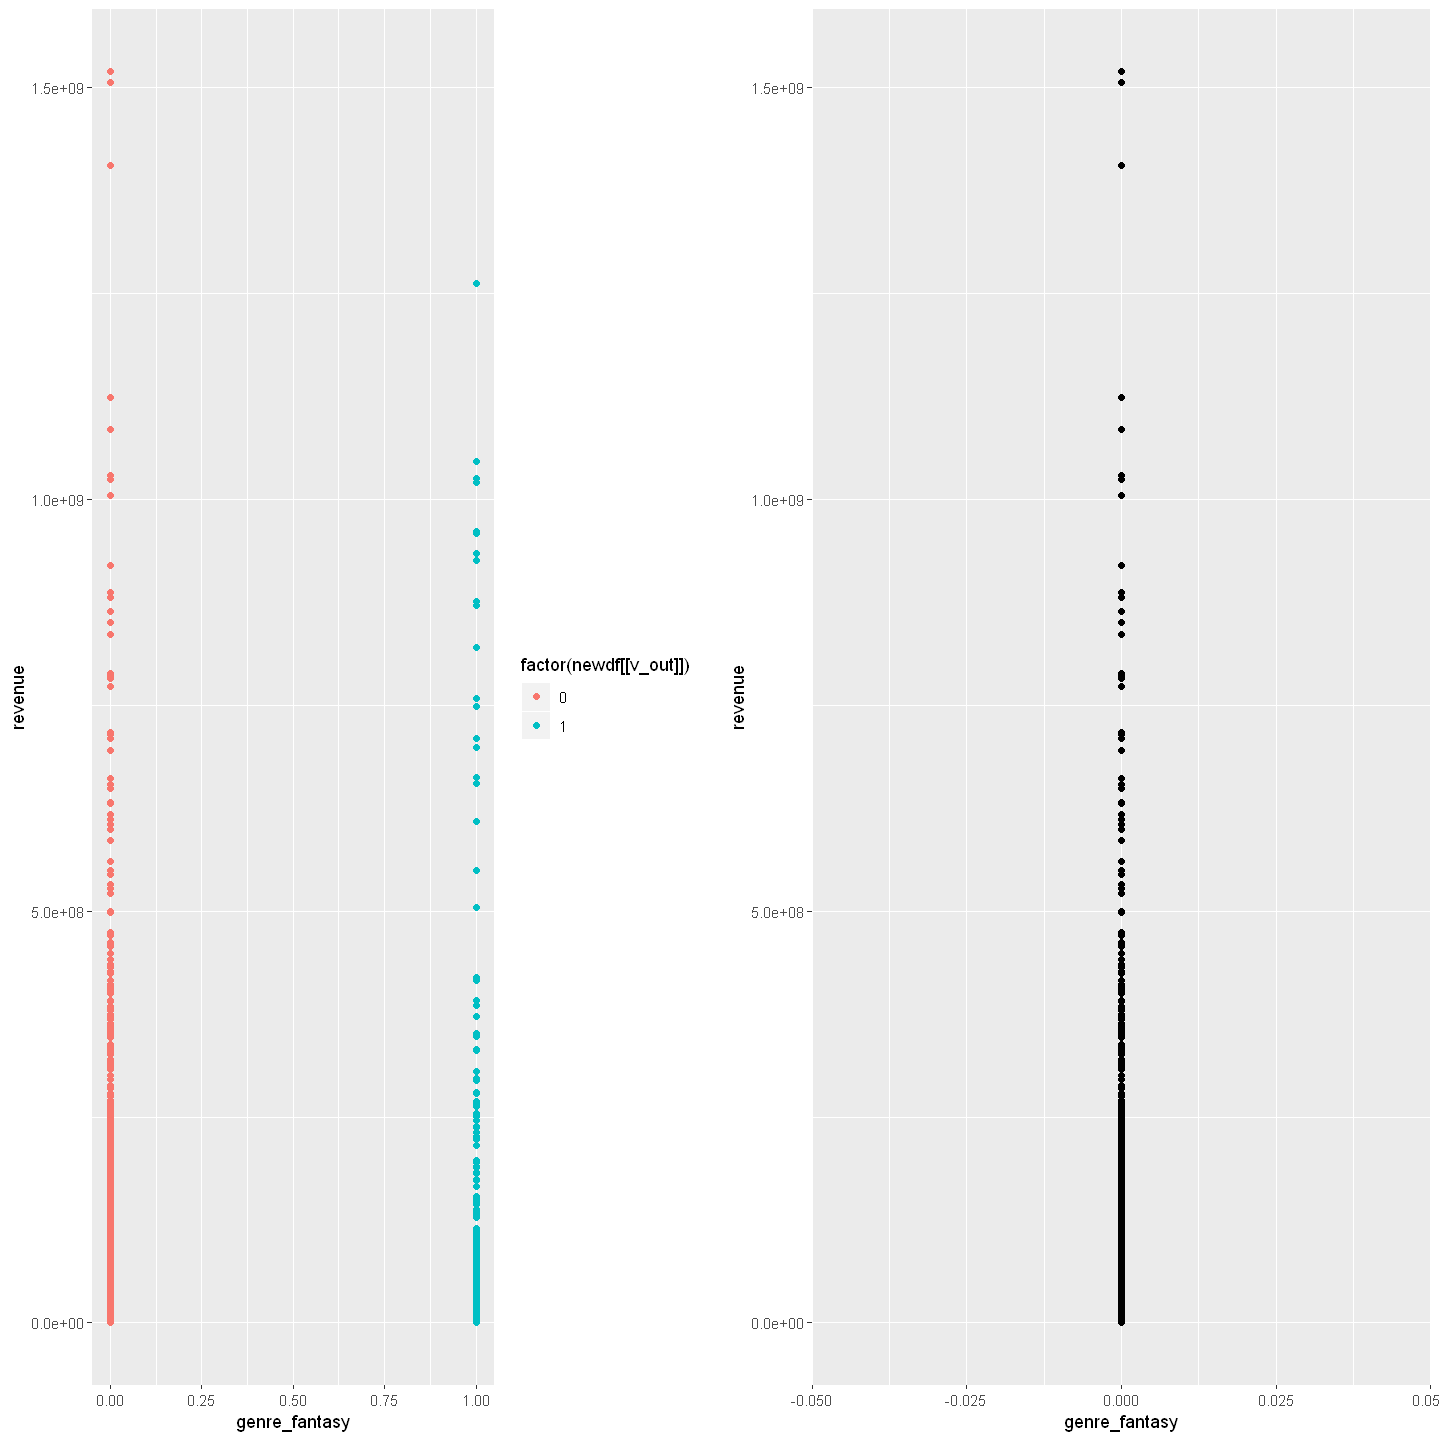

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4523 rows containing missing values (geom_point)."


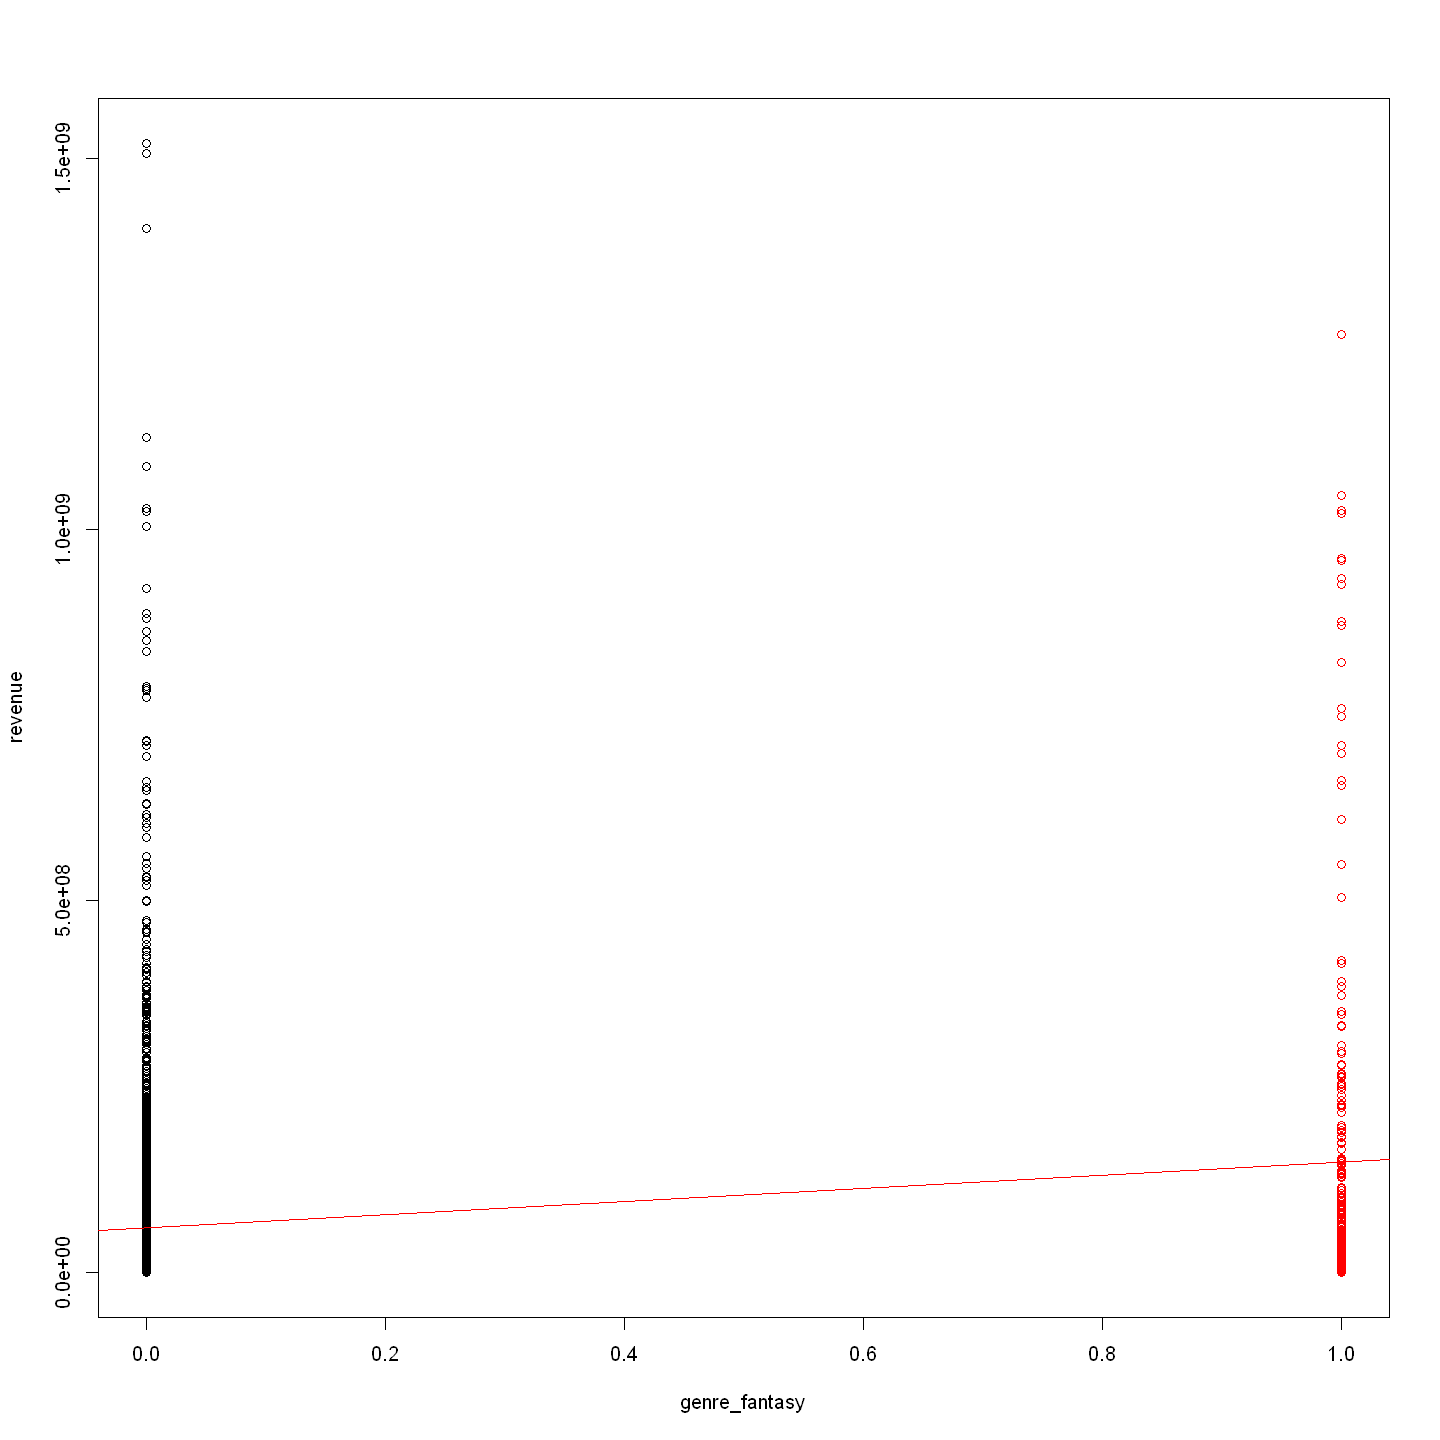

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


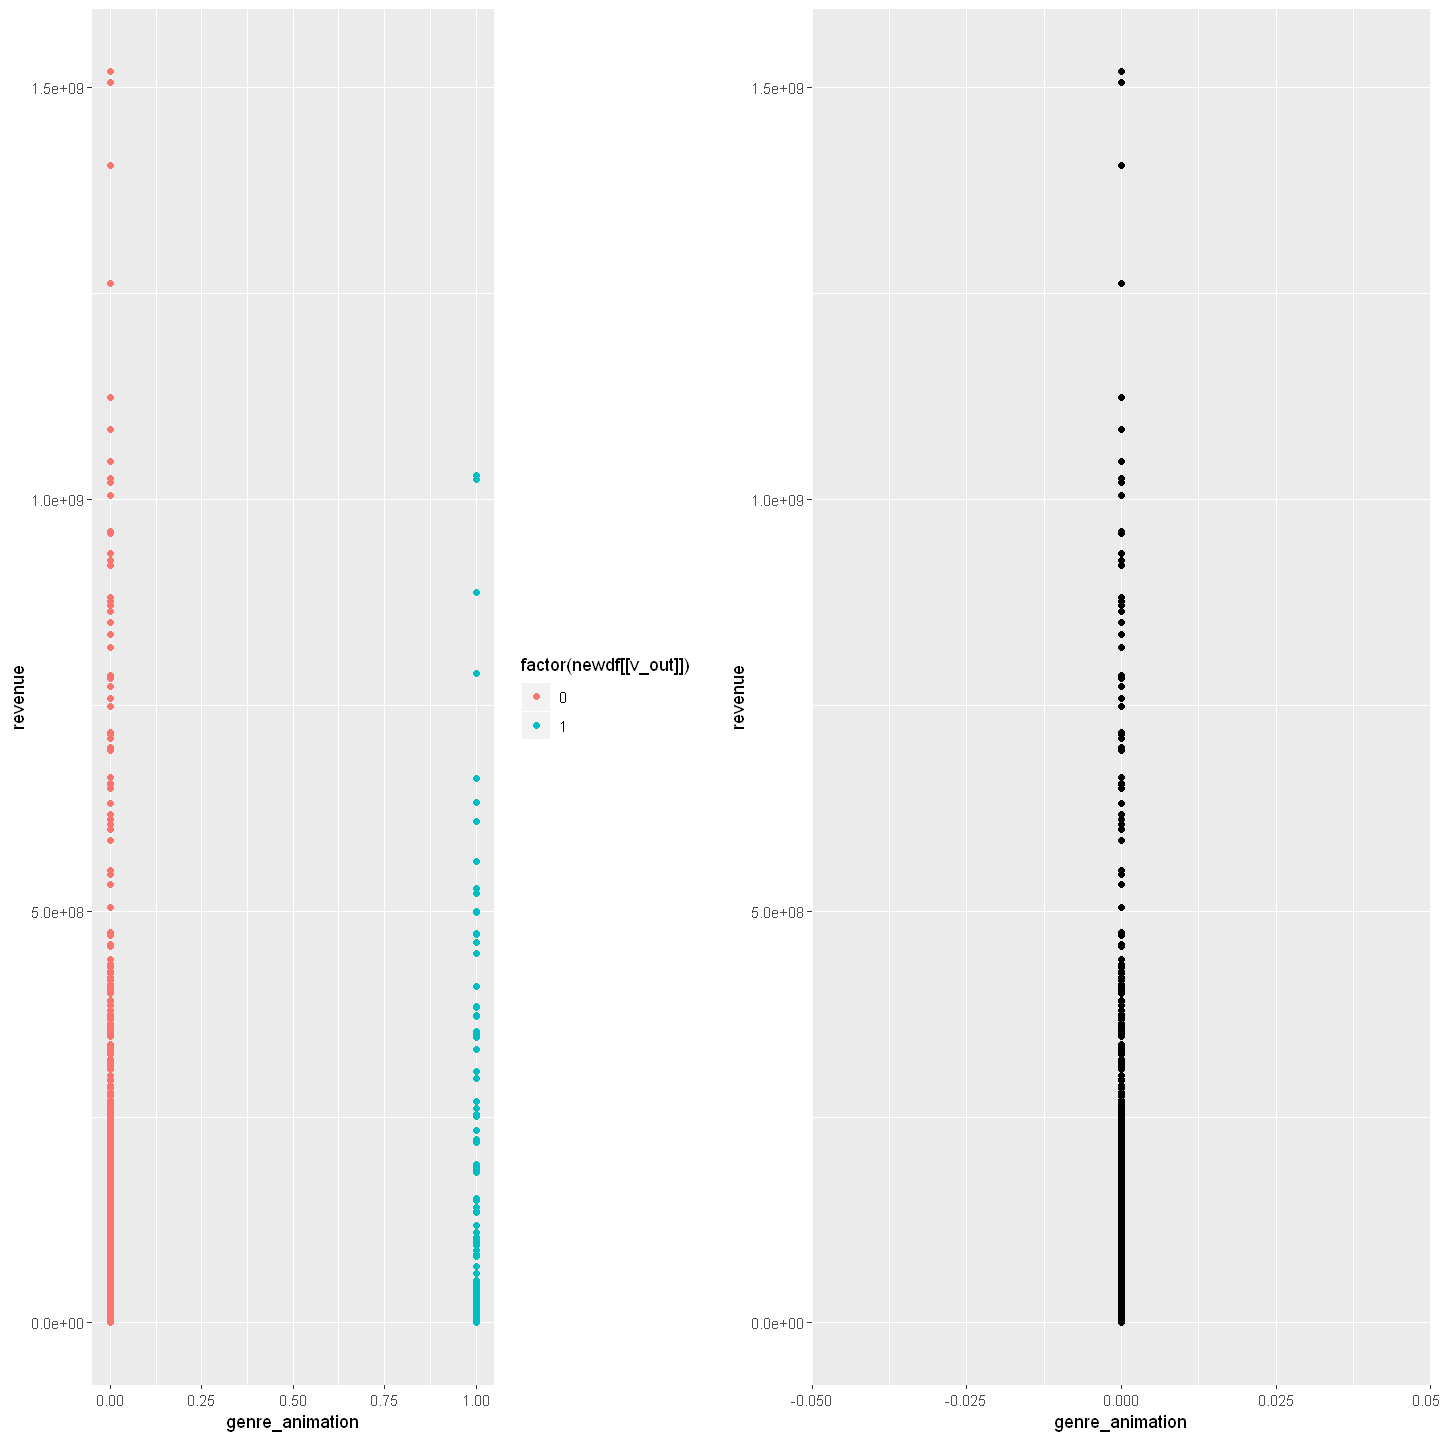

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4382 rows containing missing values (geom_point)."


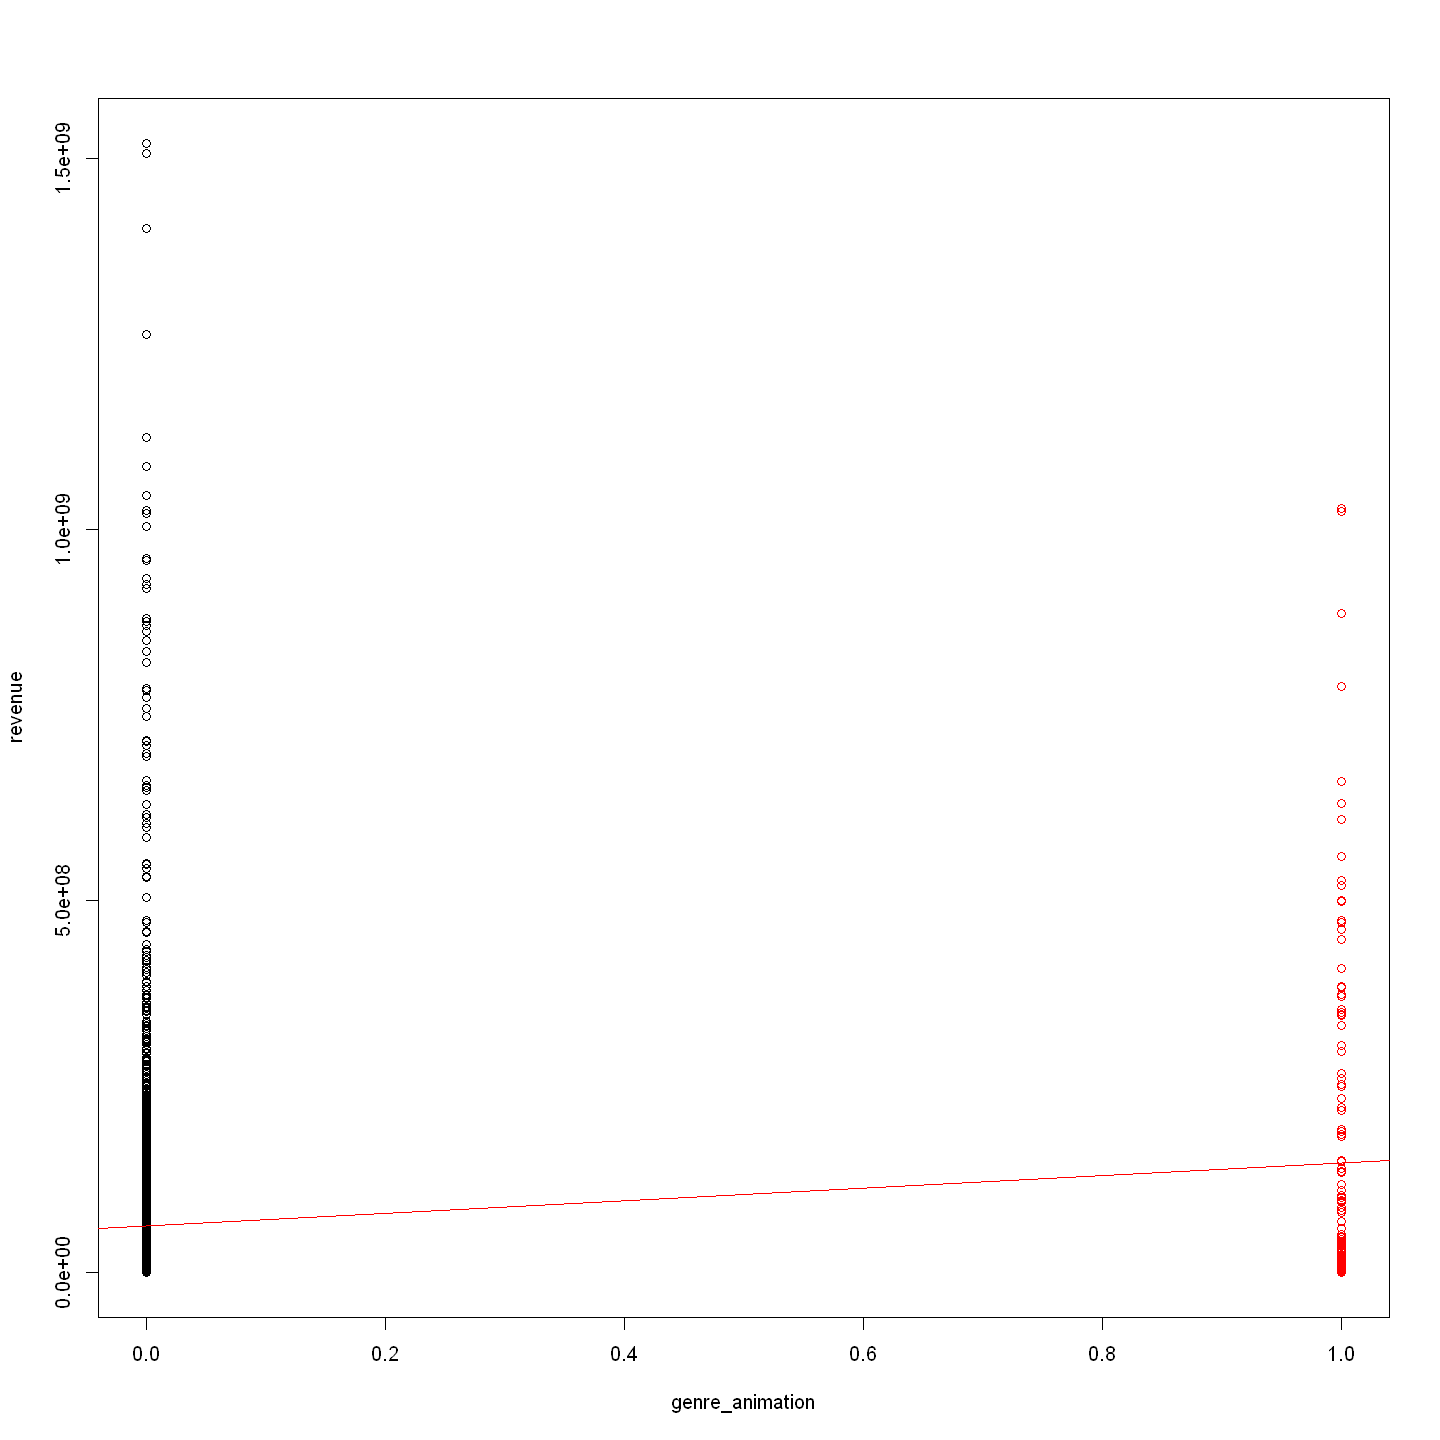

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


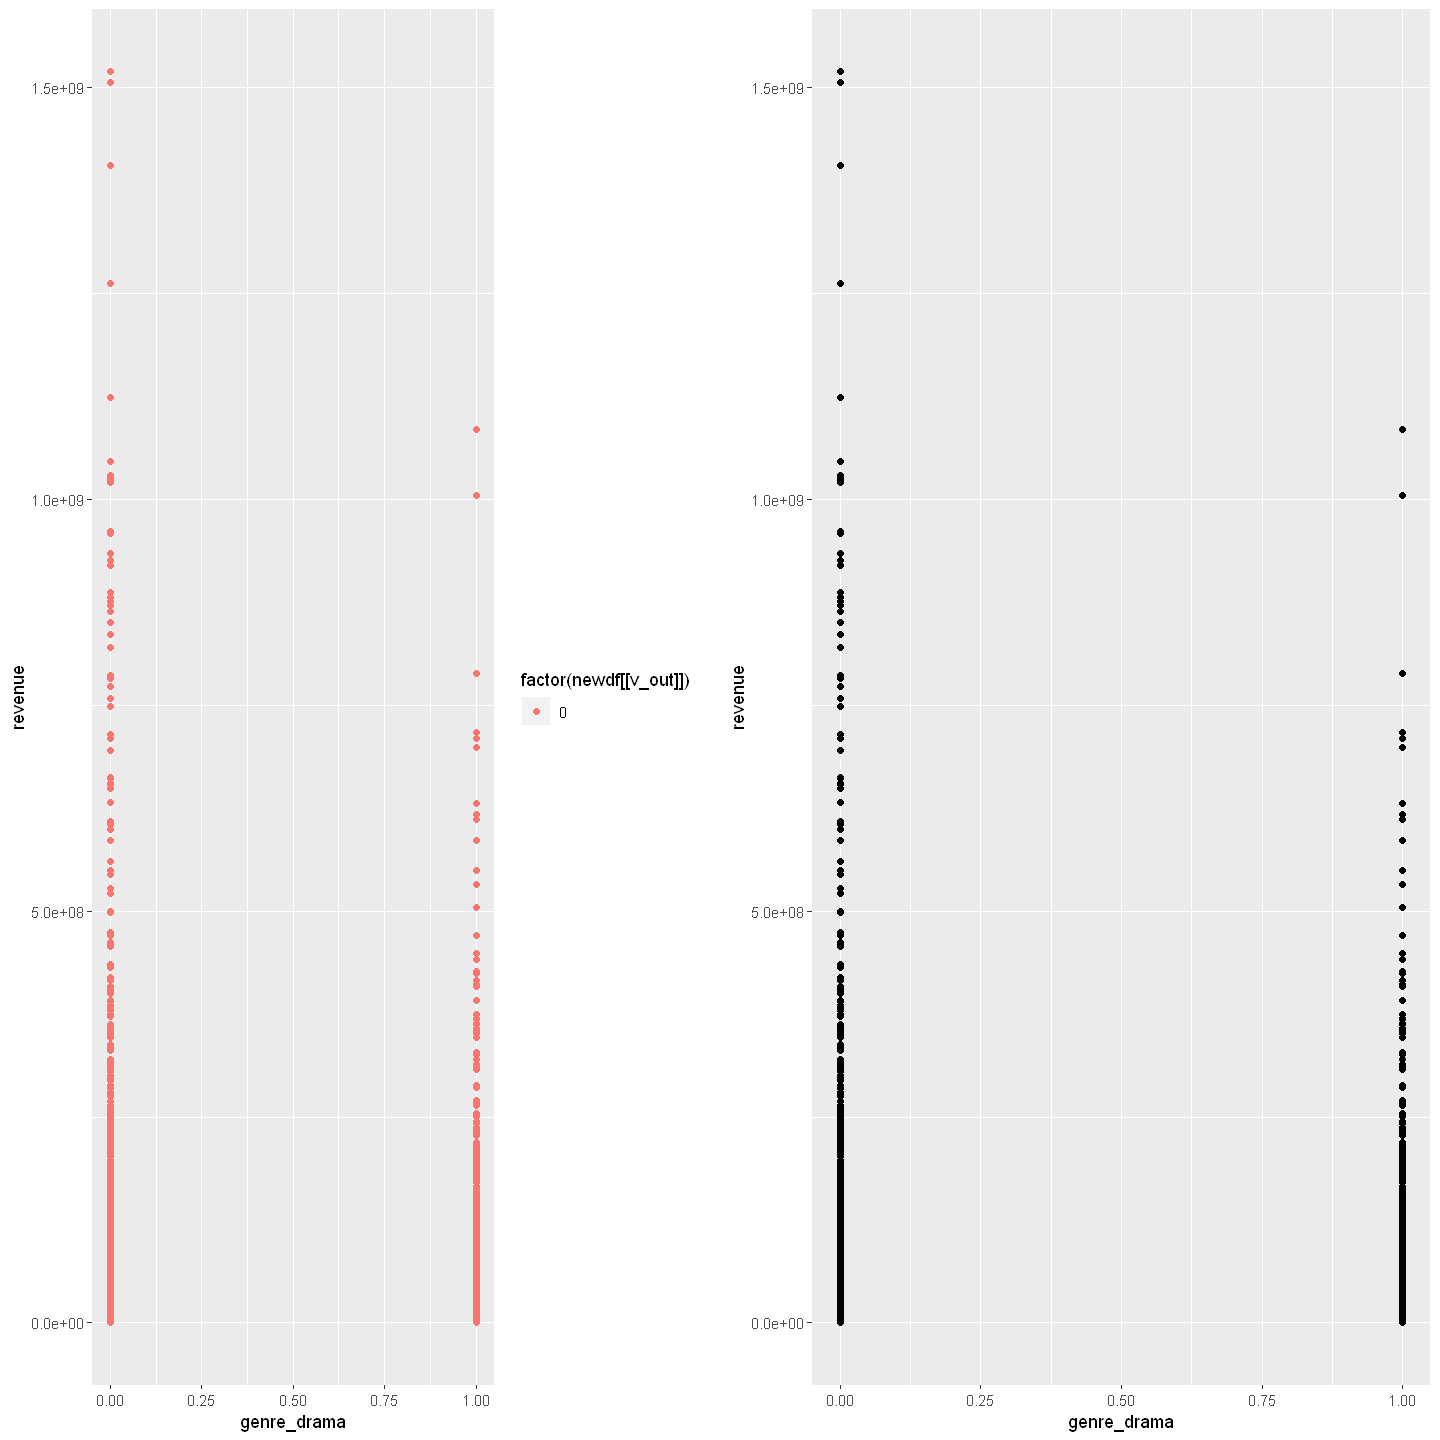

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4683 rows containing missing values (geom_point)."


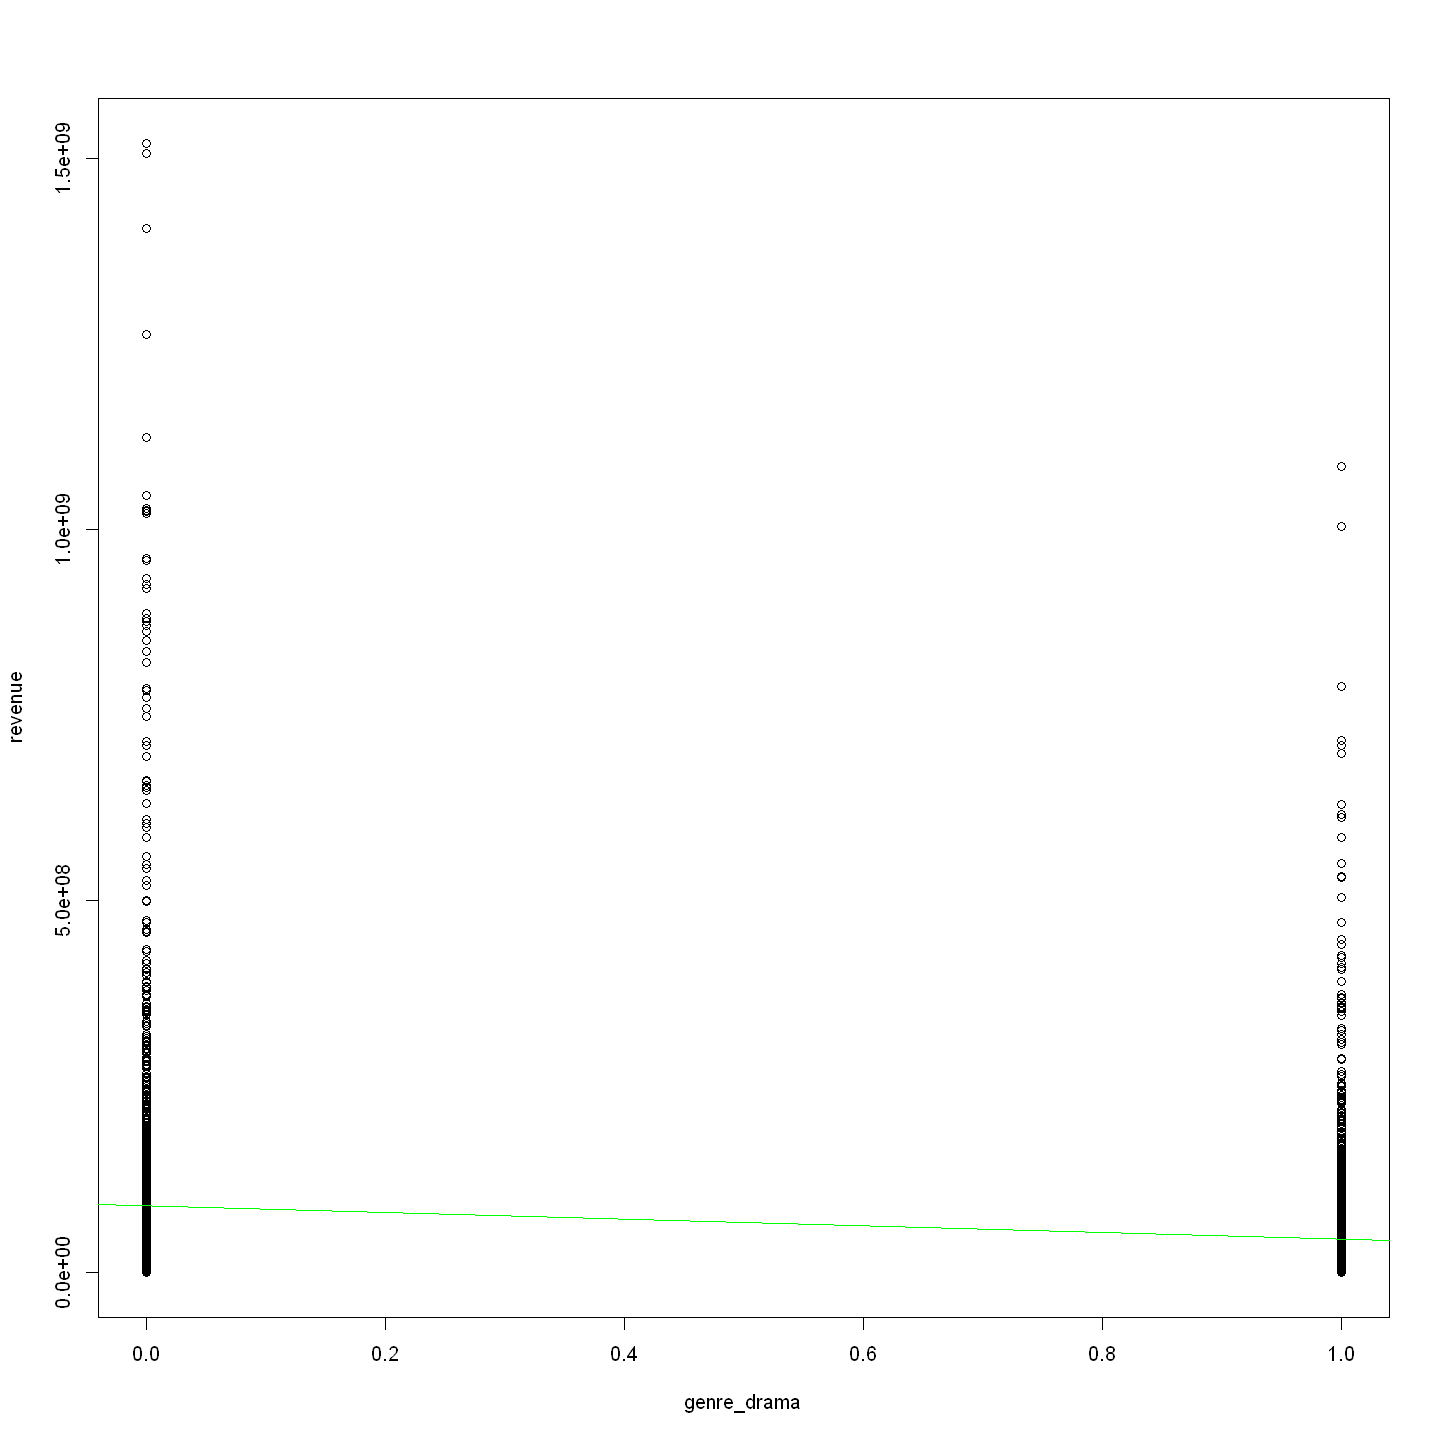

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


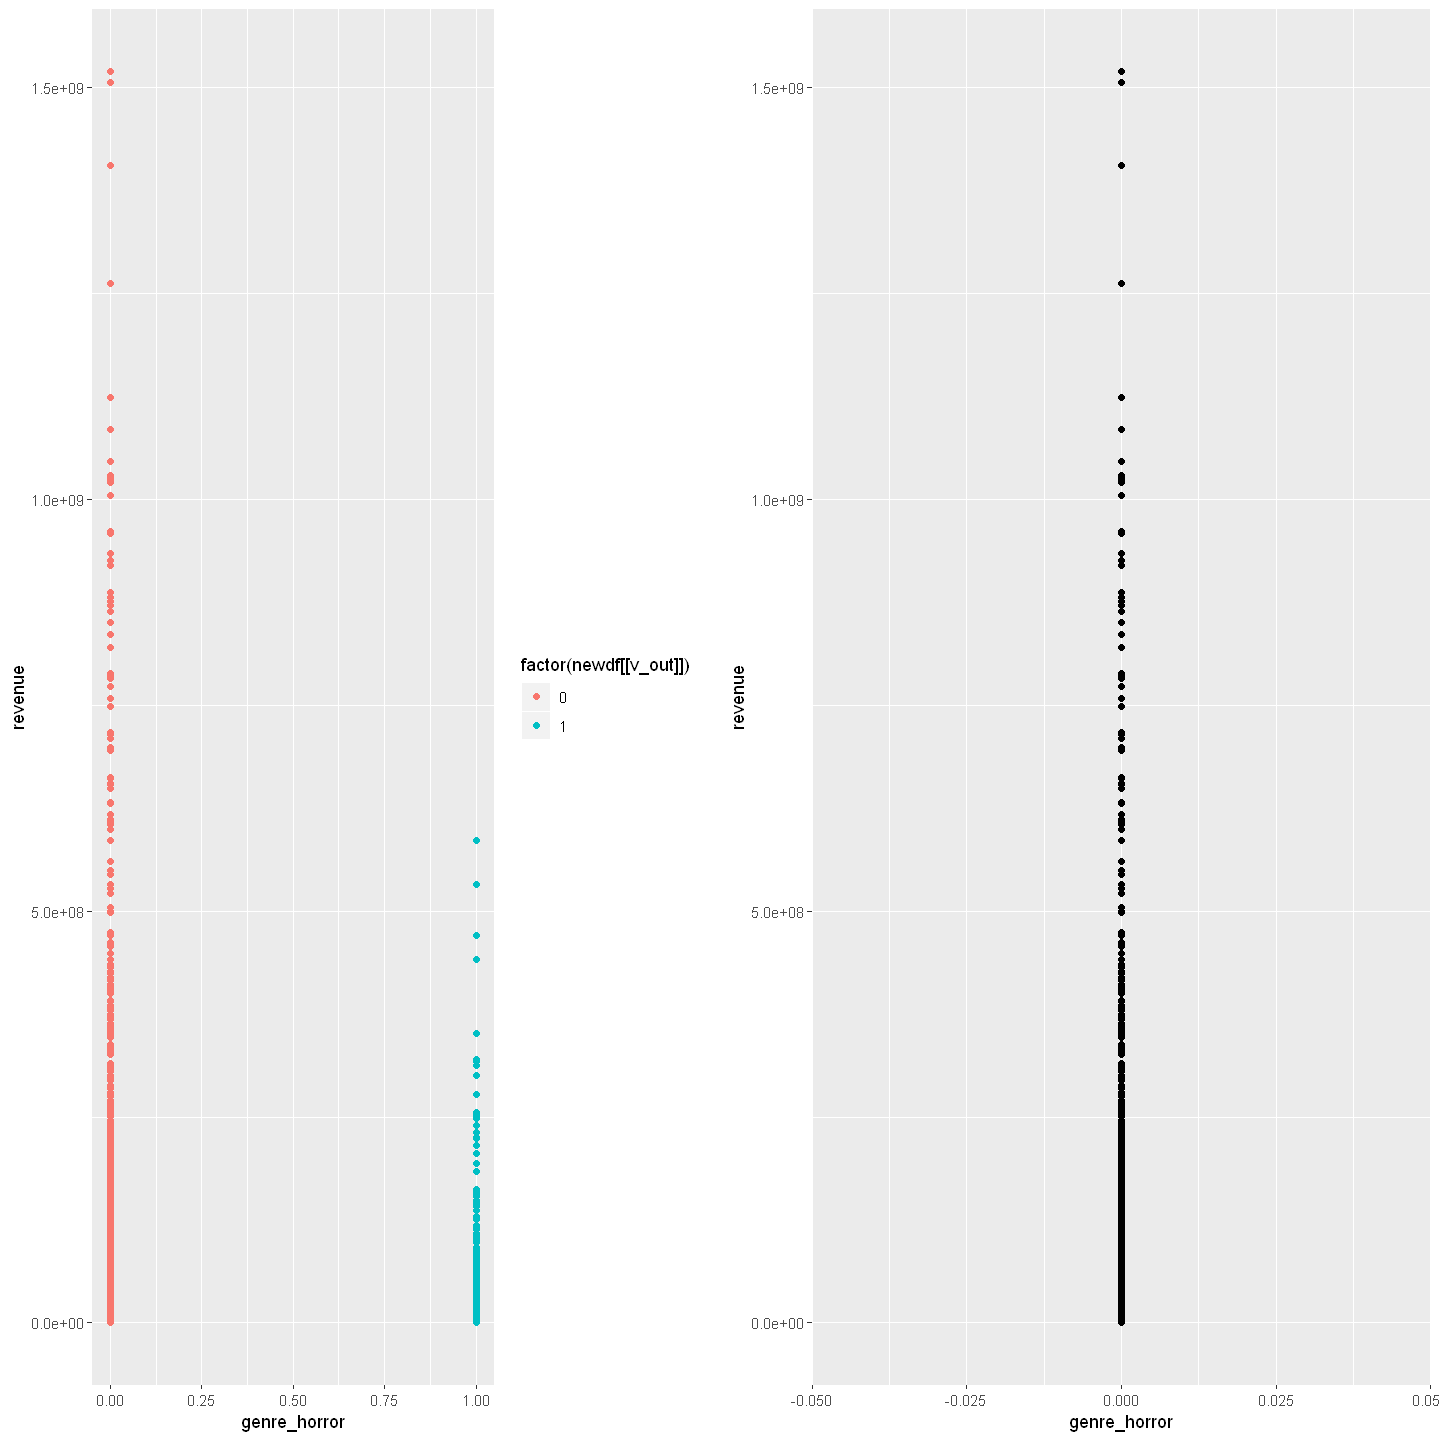

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 5123 rows containing missing values (geom_point)."


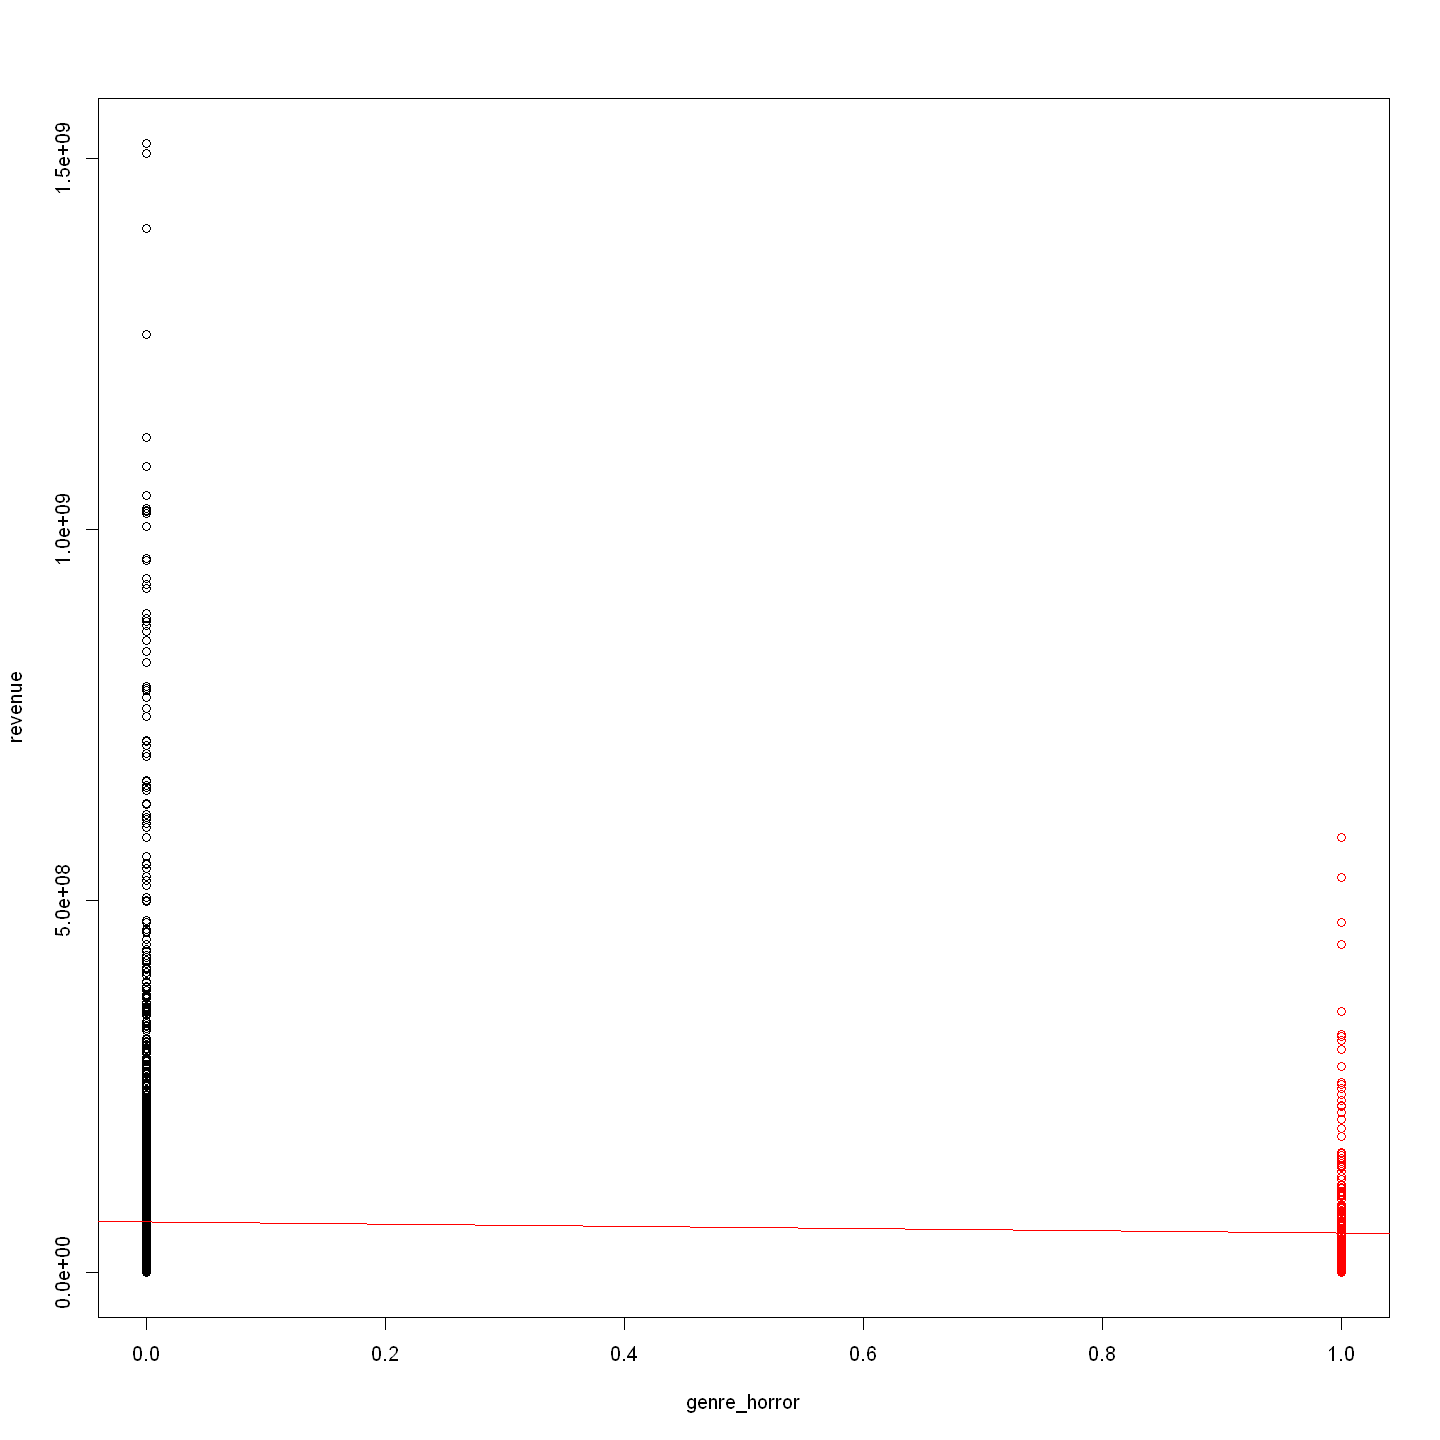

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


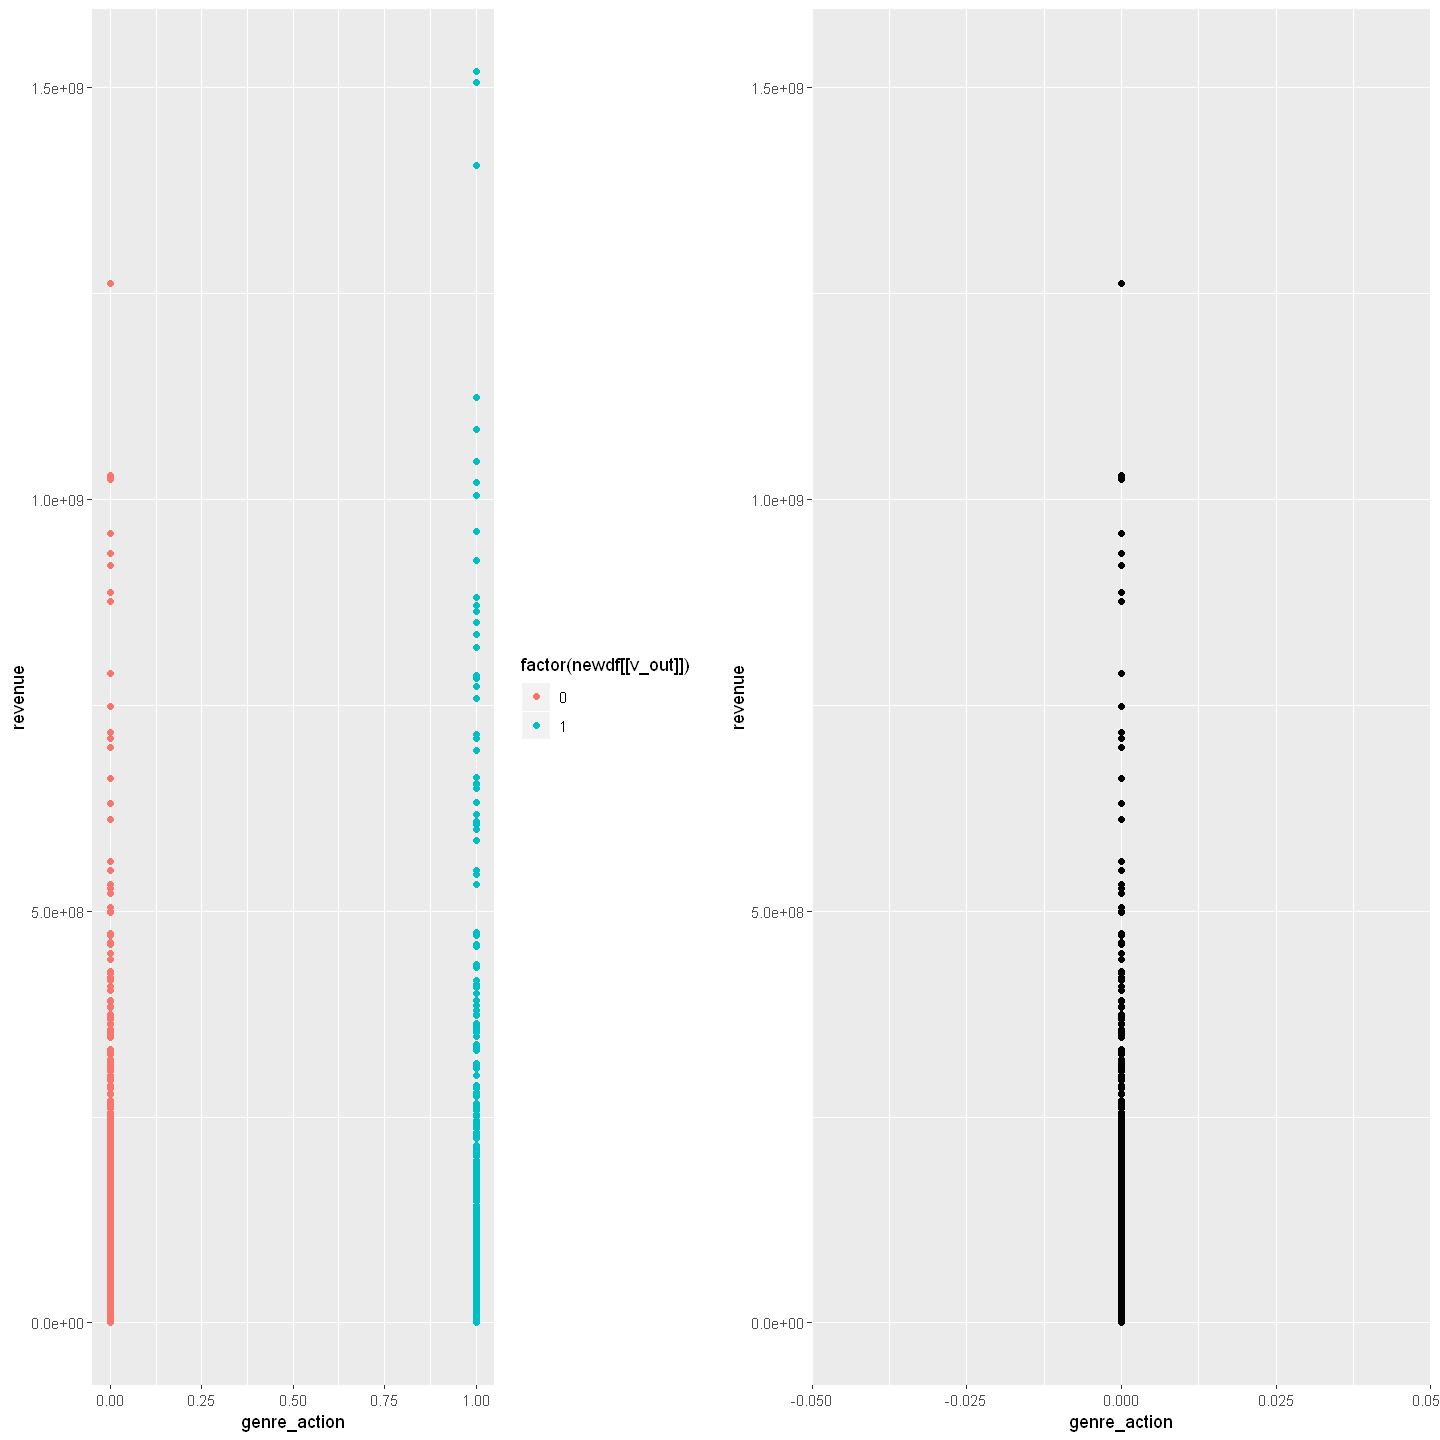

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4382 rows containing missing values (geom_point)."


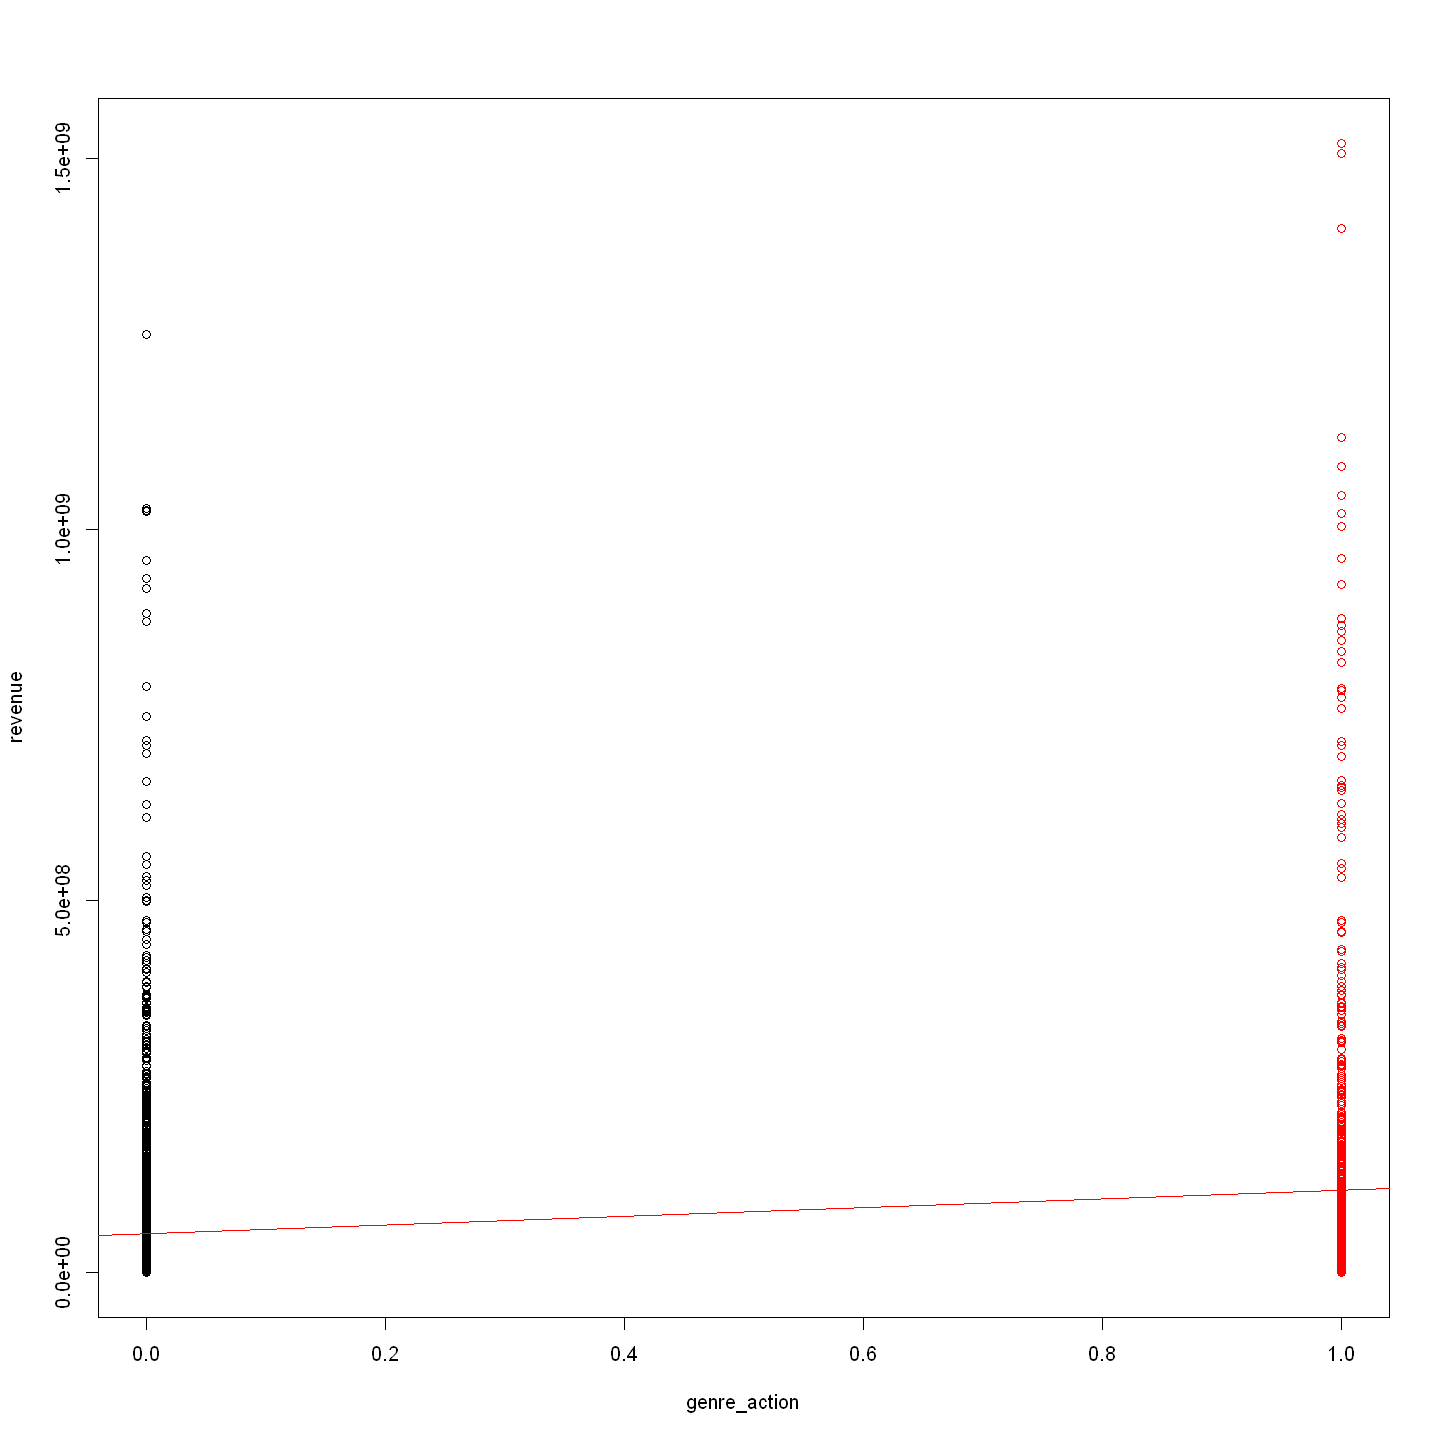

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


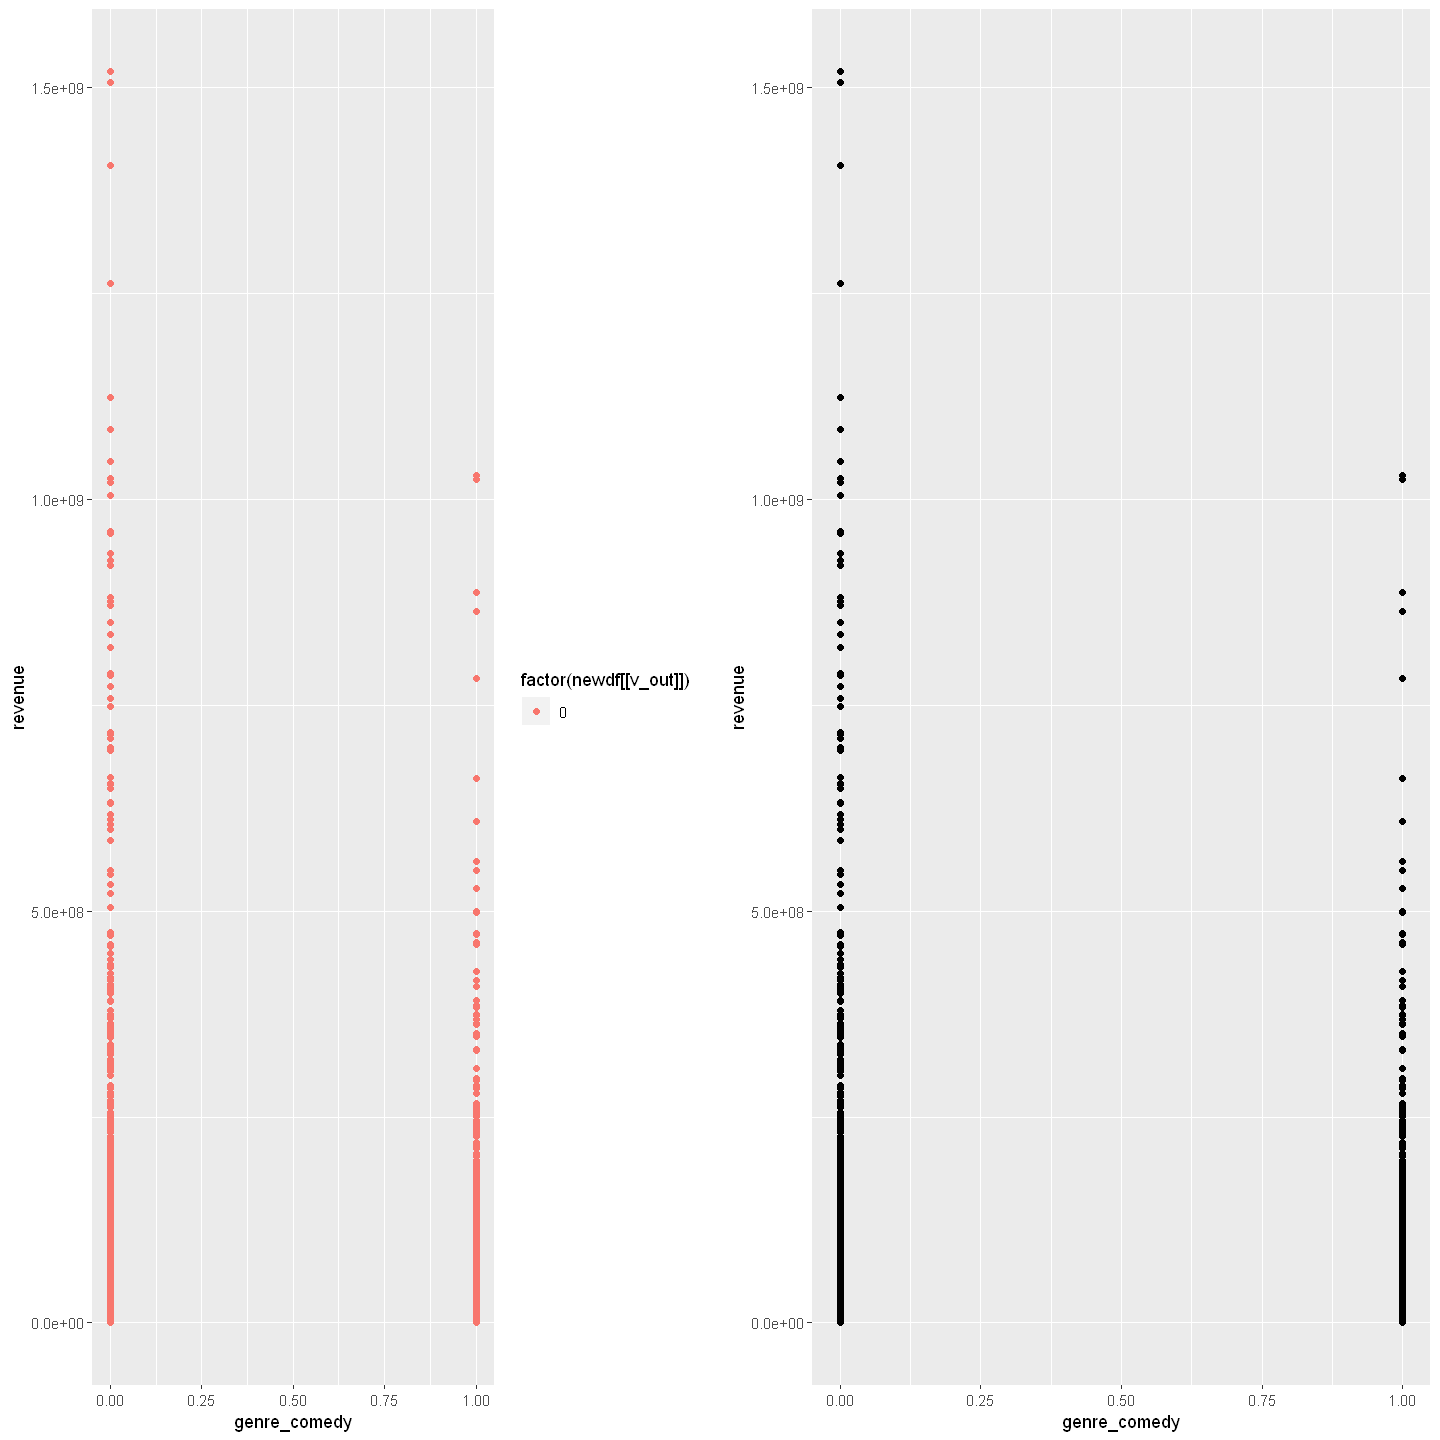

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4514 rows containing missing values (geom_point)."


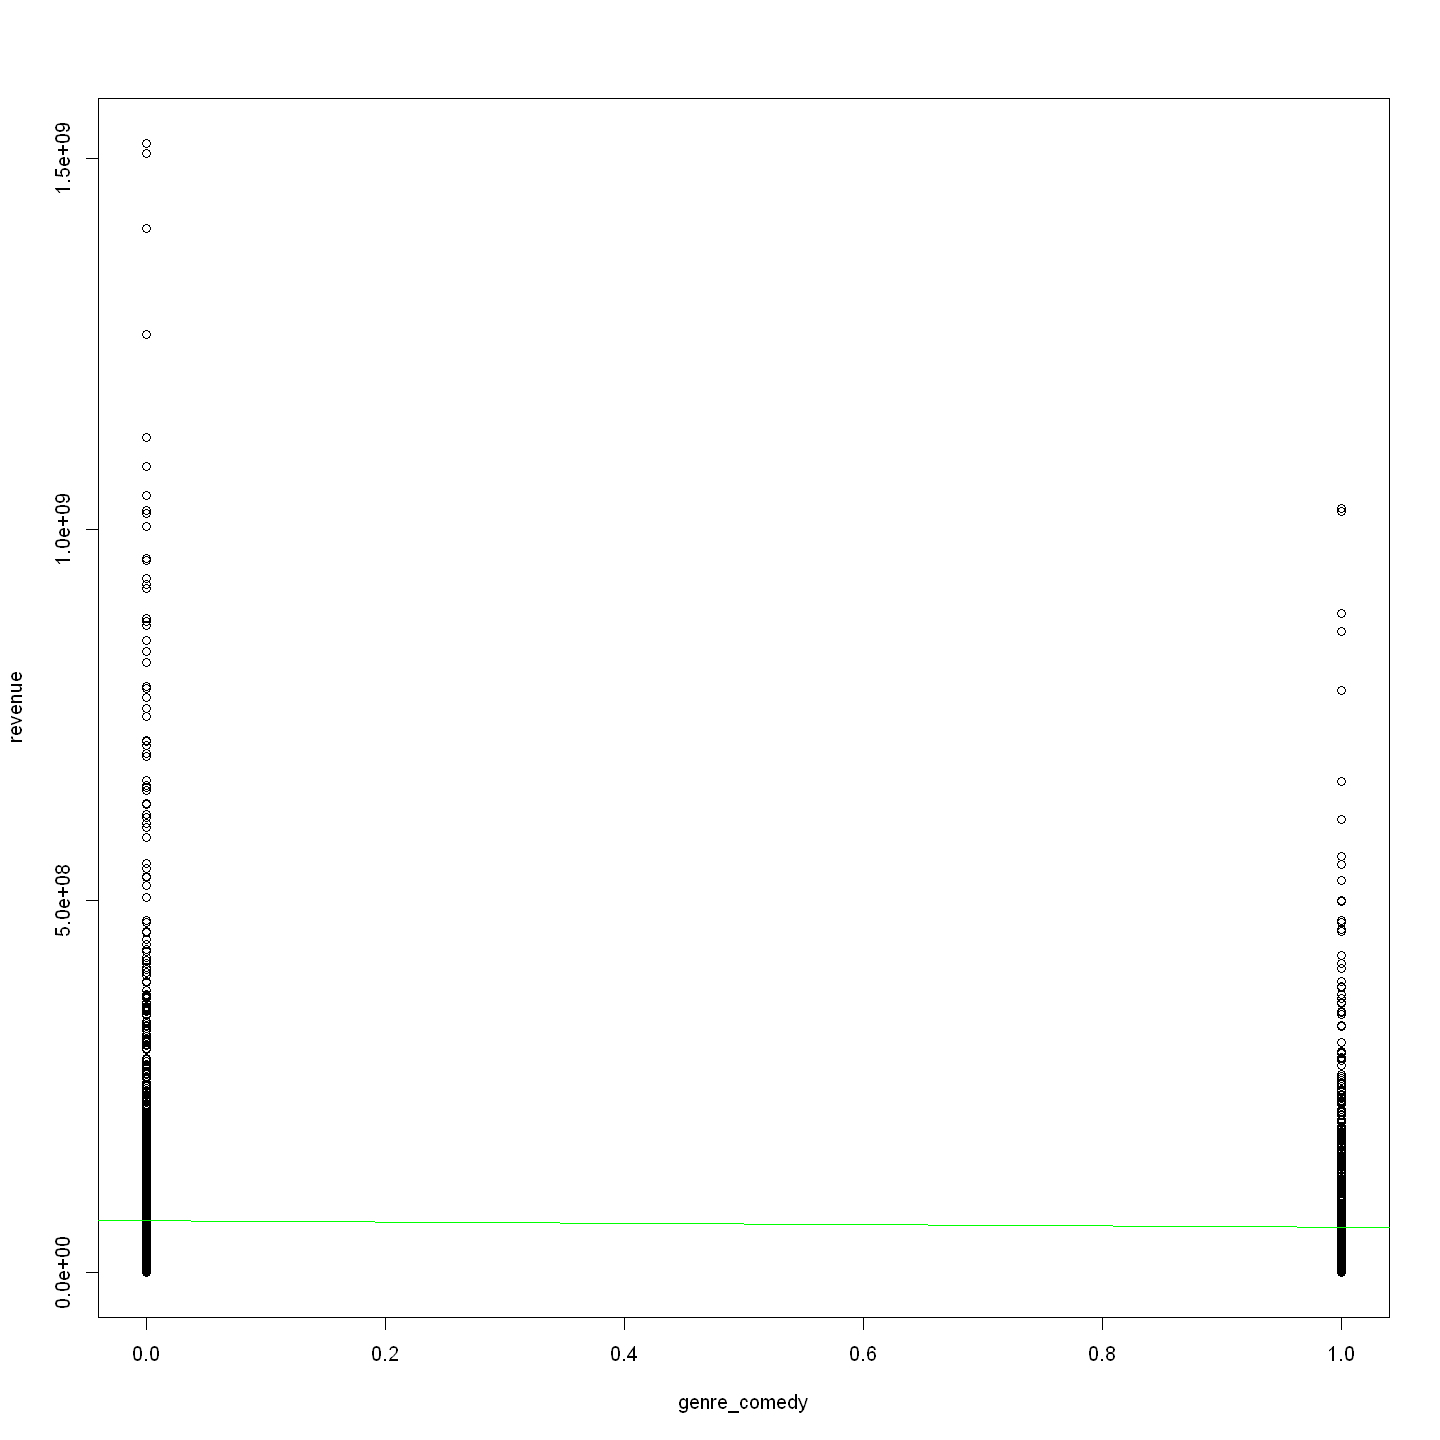

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


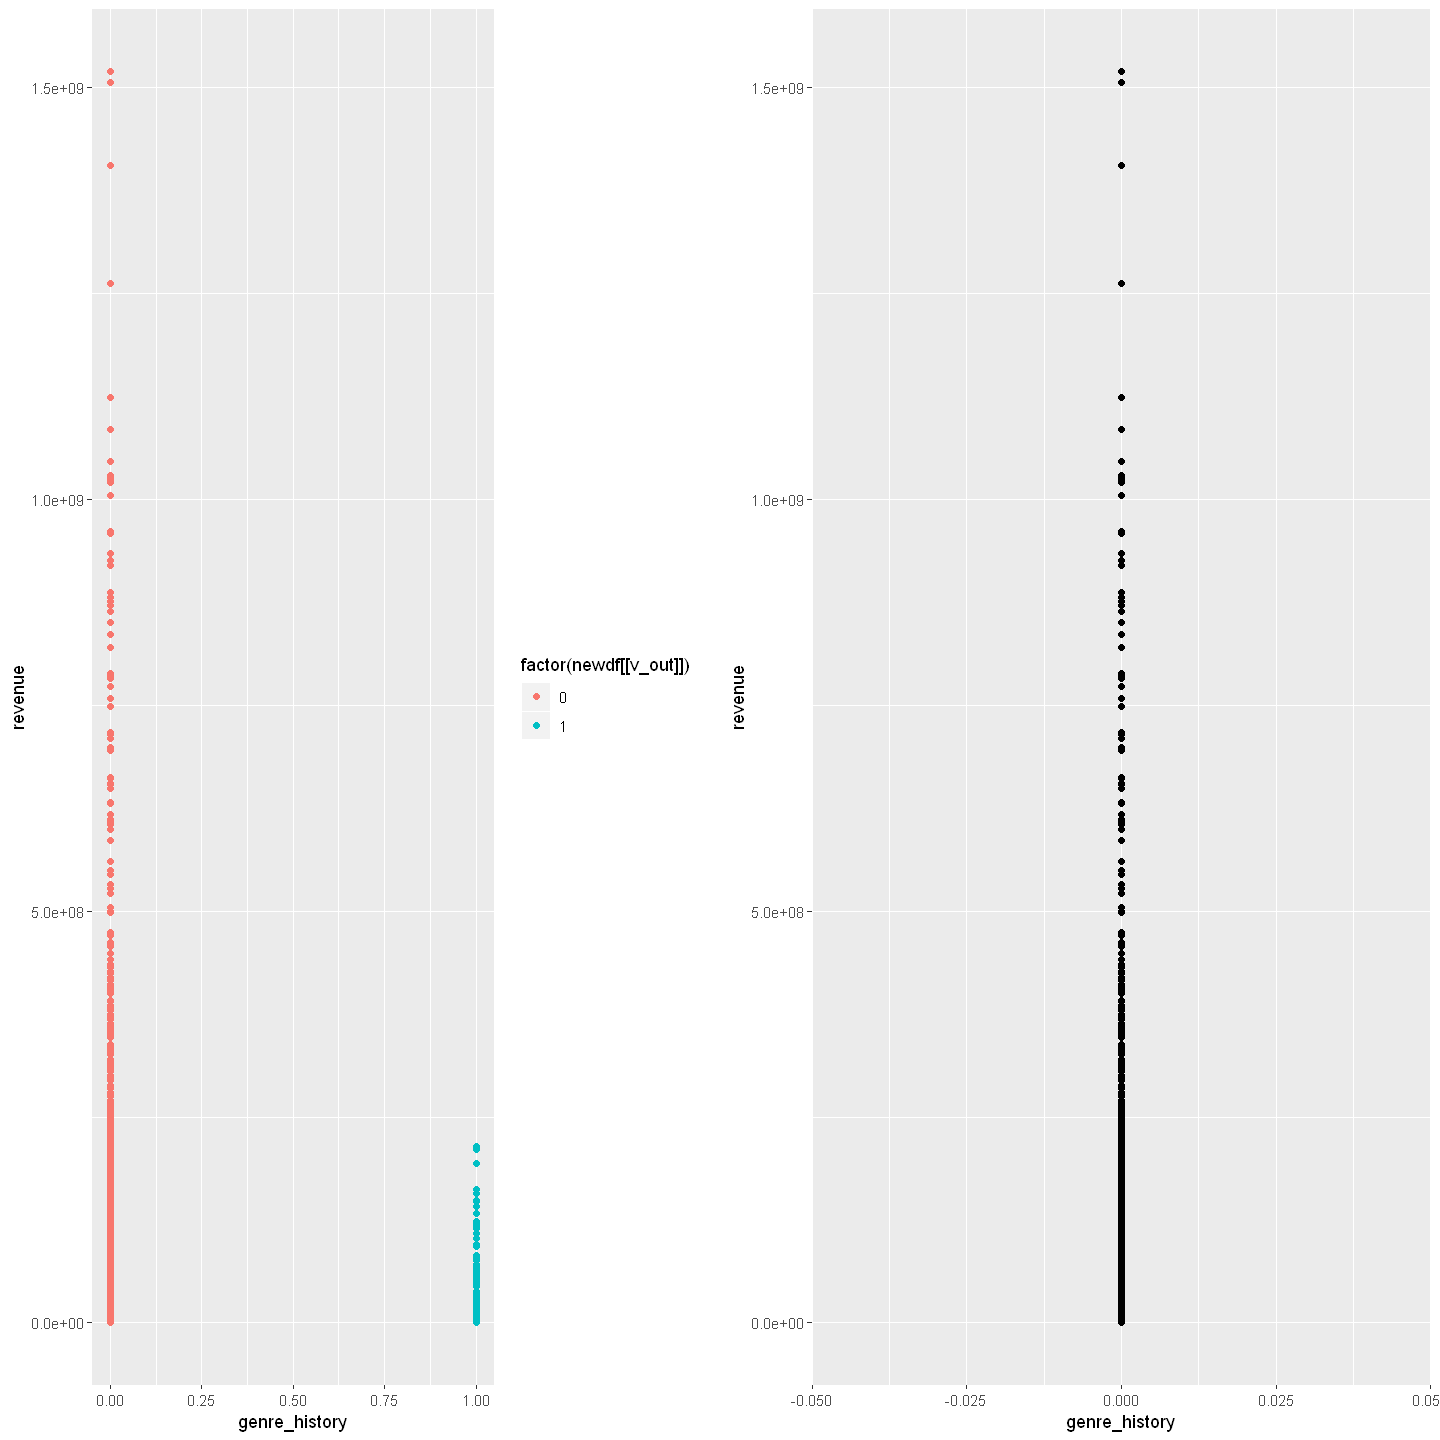

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4425 rows containing missing values (geom_point)."


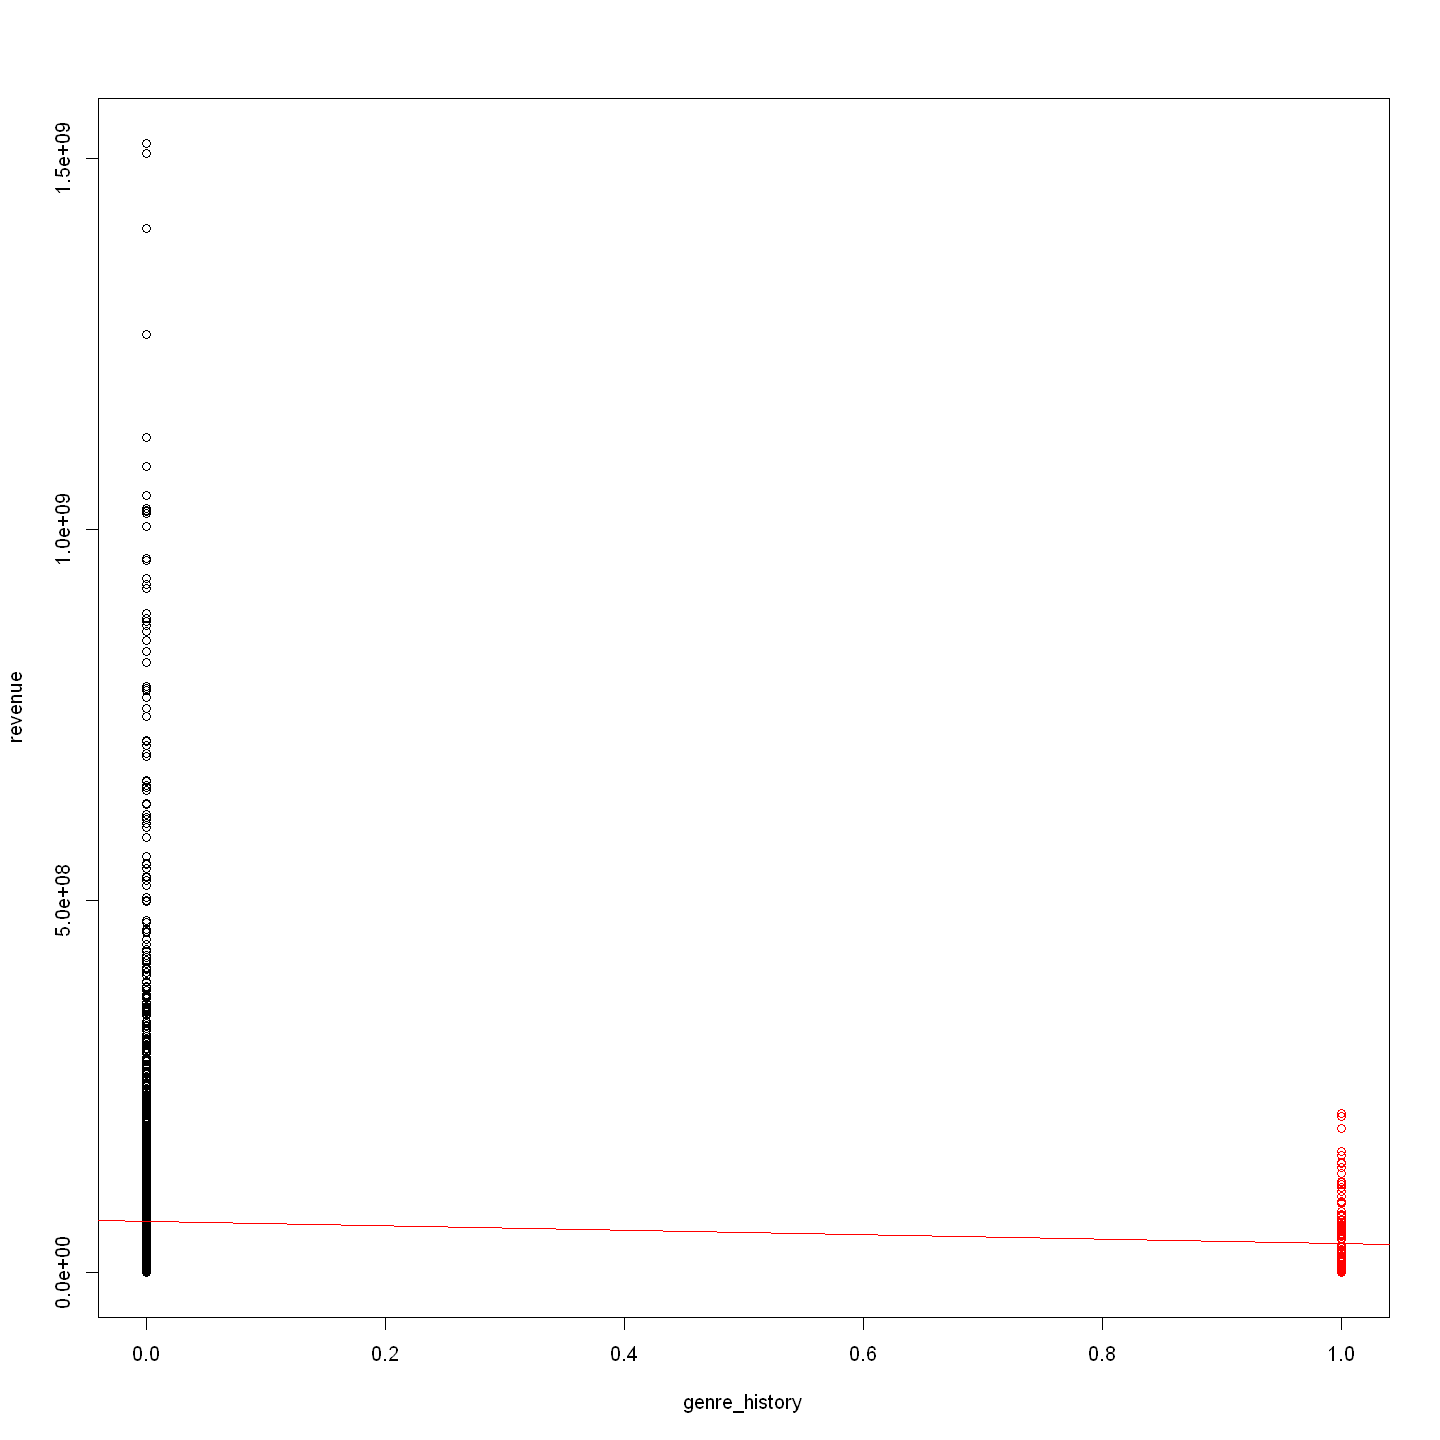

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


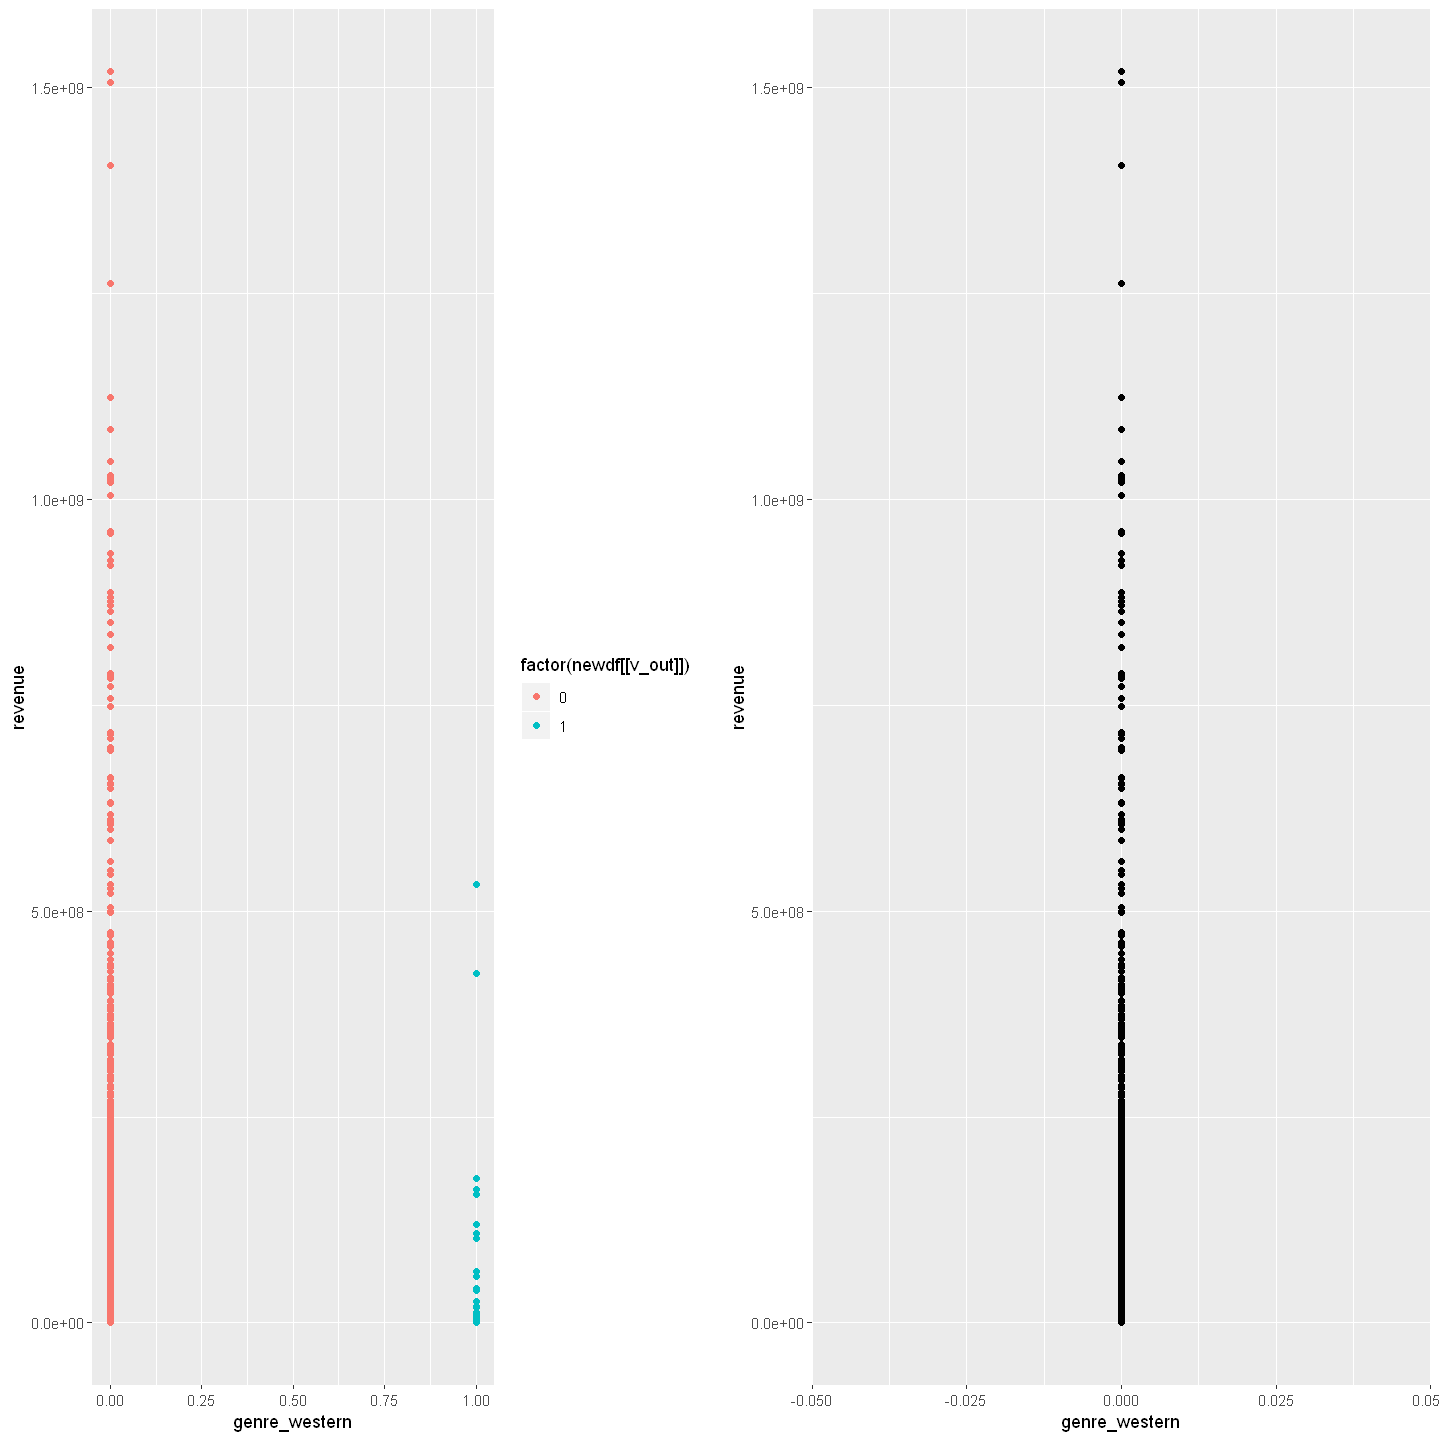

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4382 rows containing missing values (geom_point)."


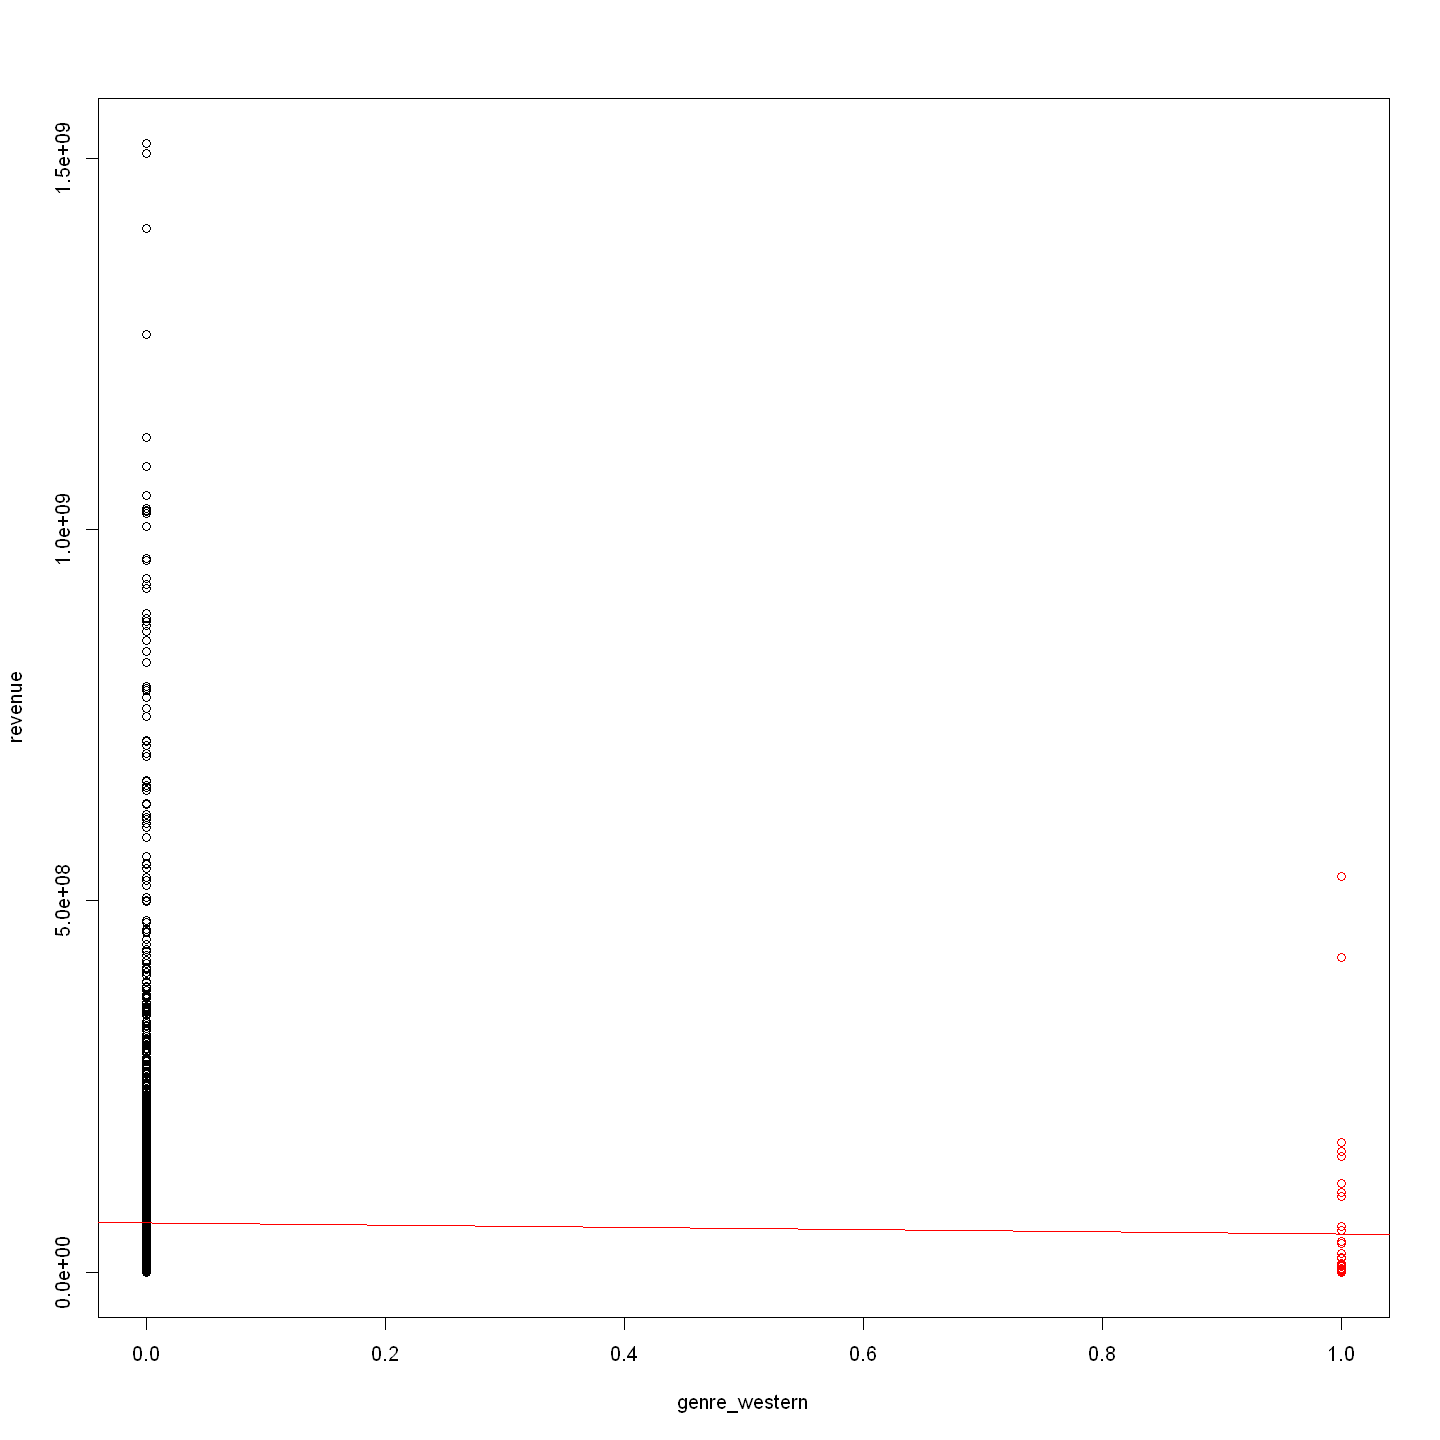

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


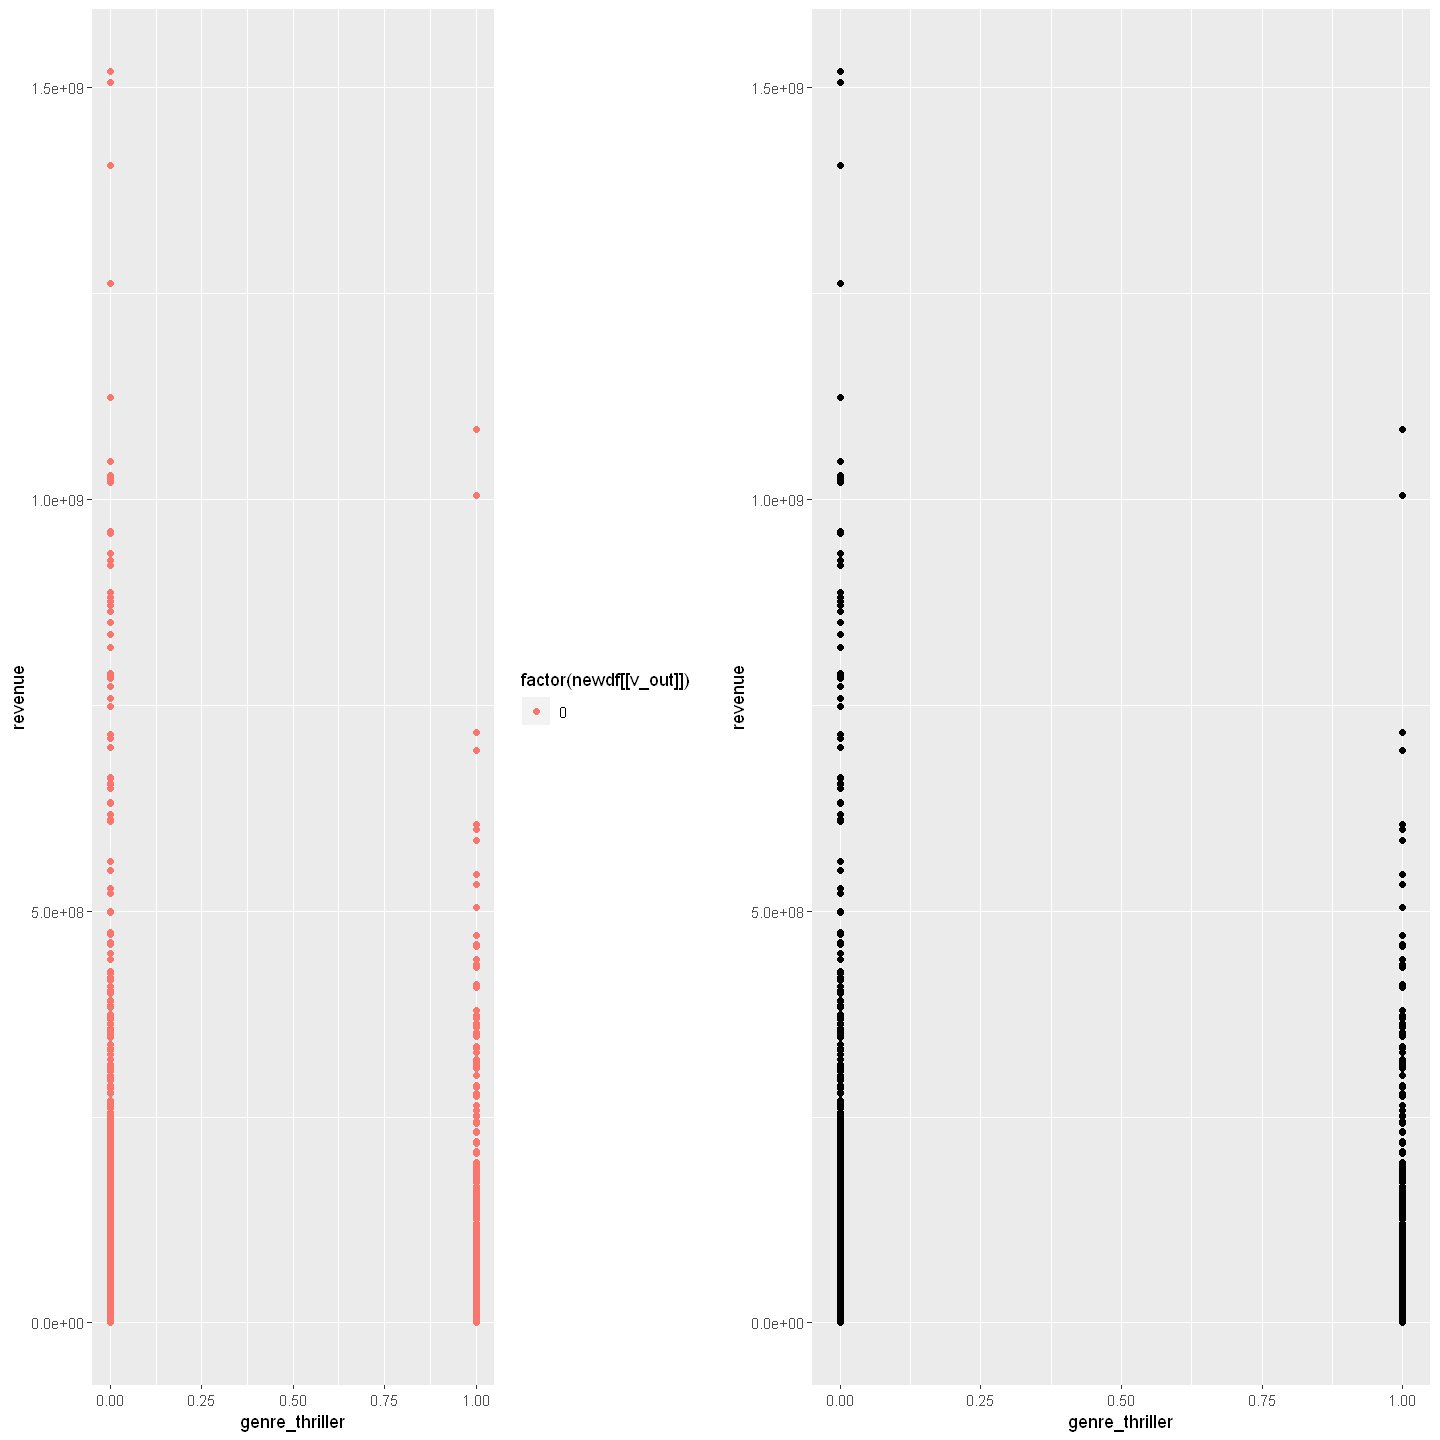

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4851 rows containing missing values (geom_point)."


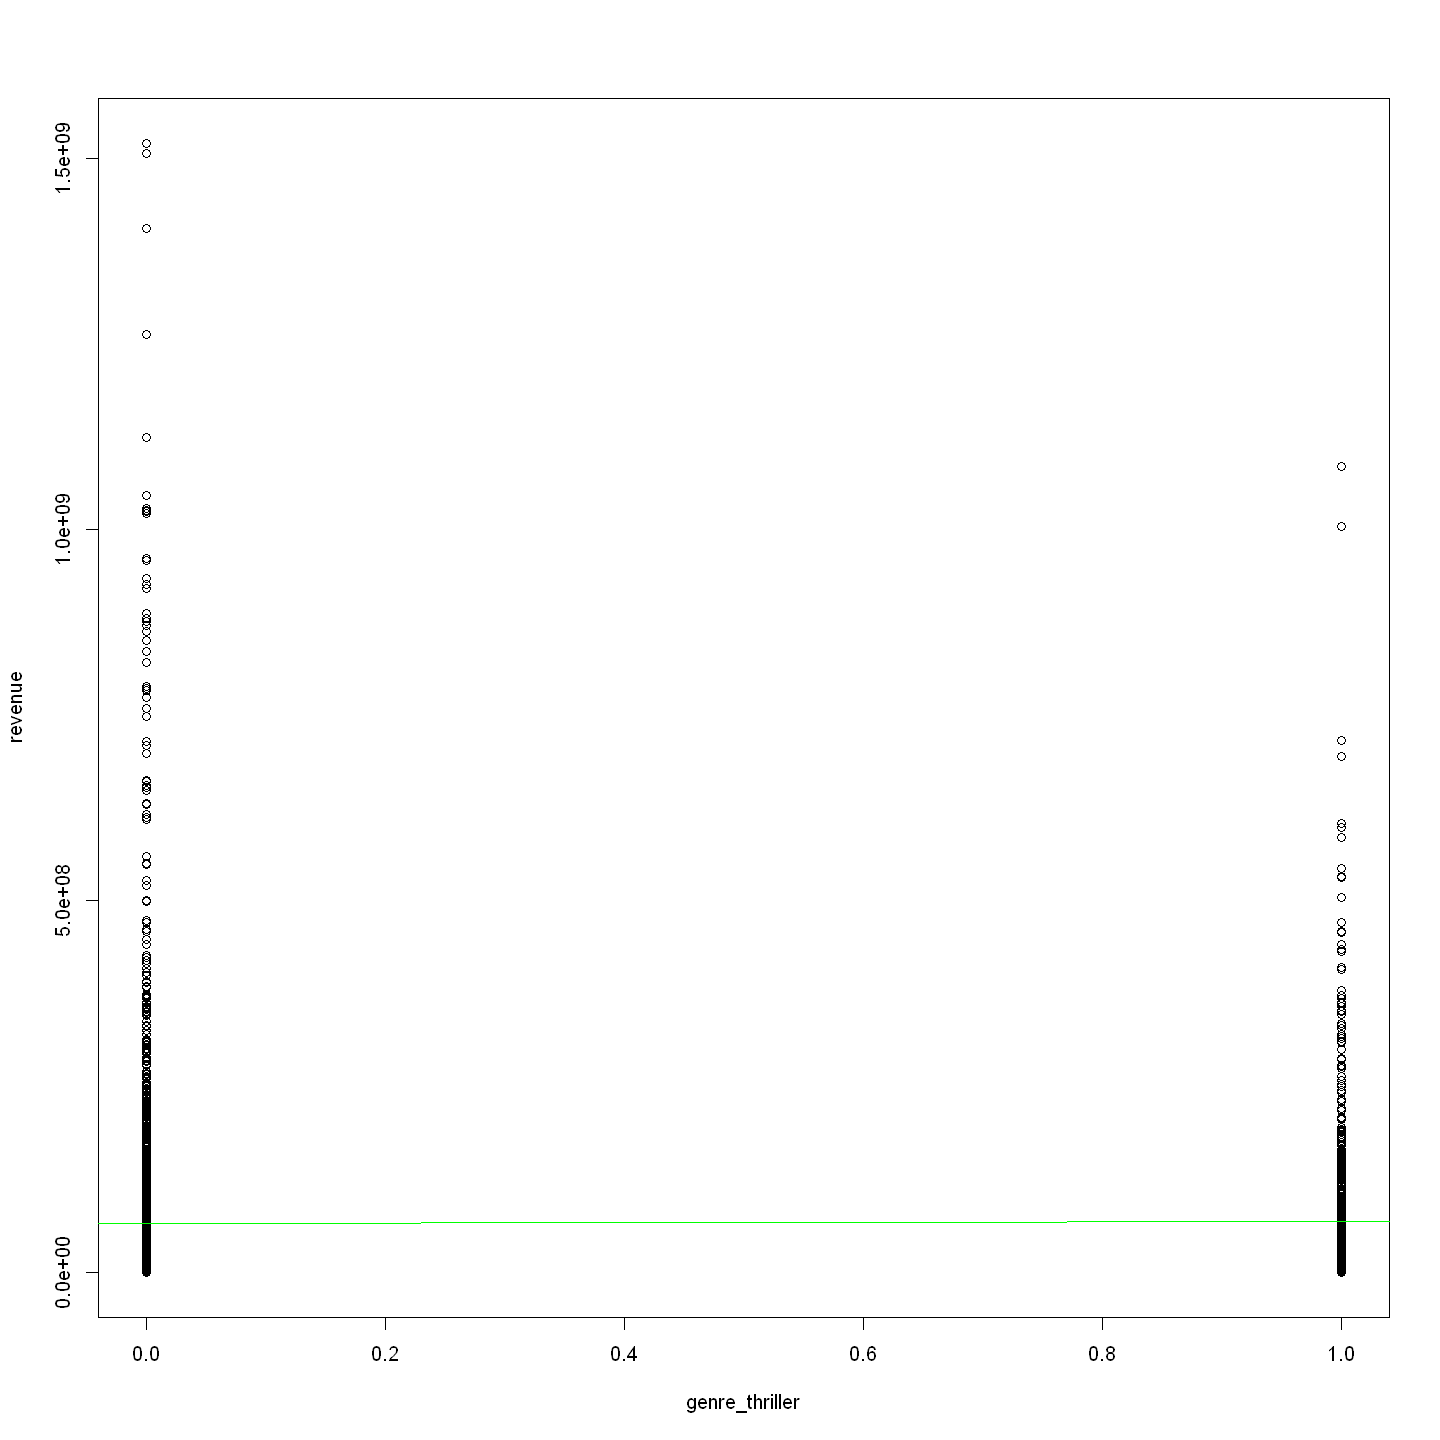

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


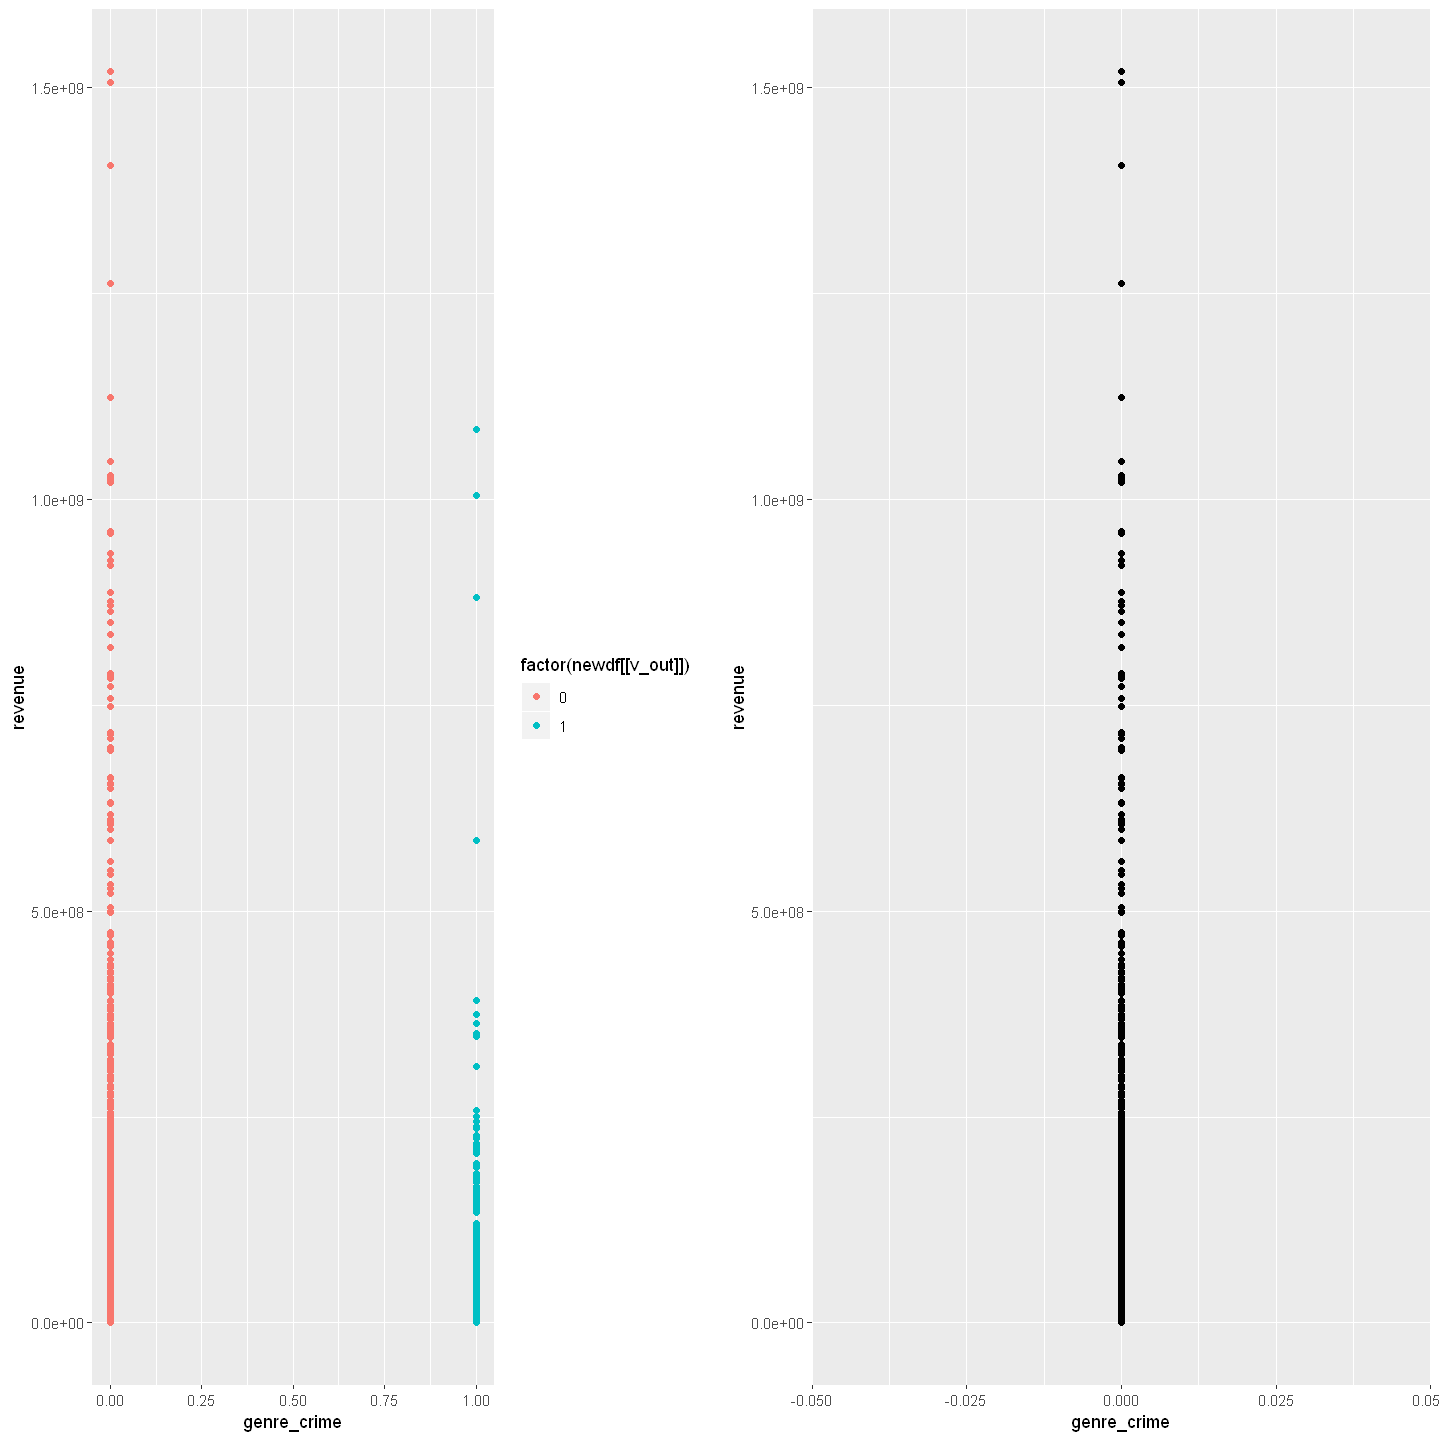

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4469 rows containing missing values (geom_point)."


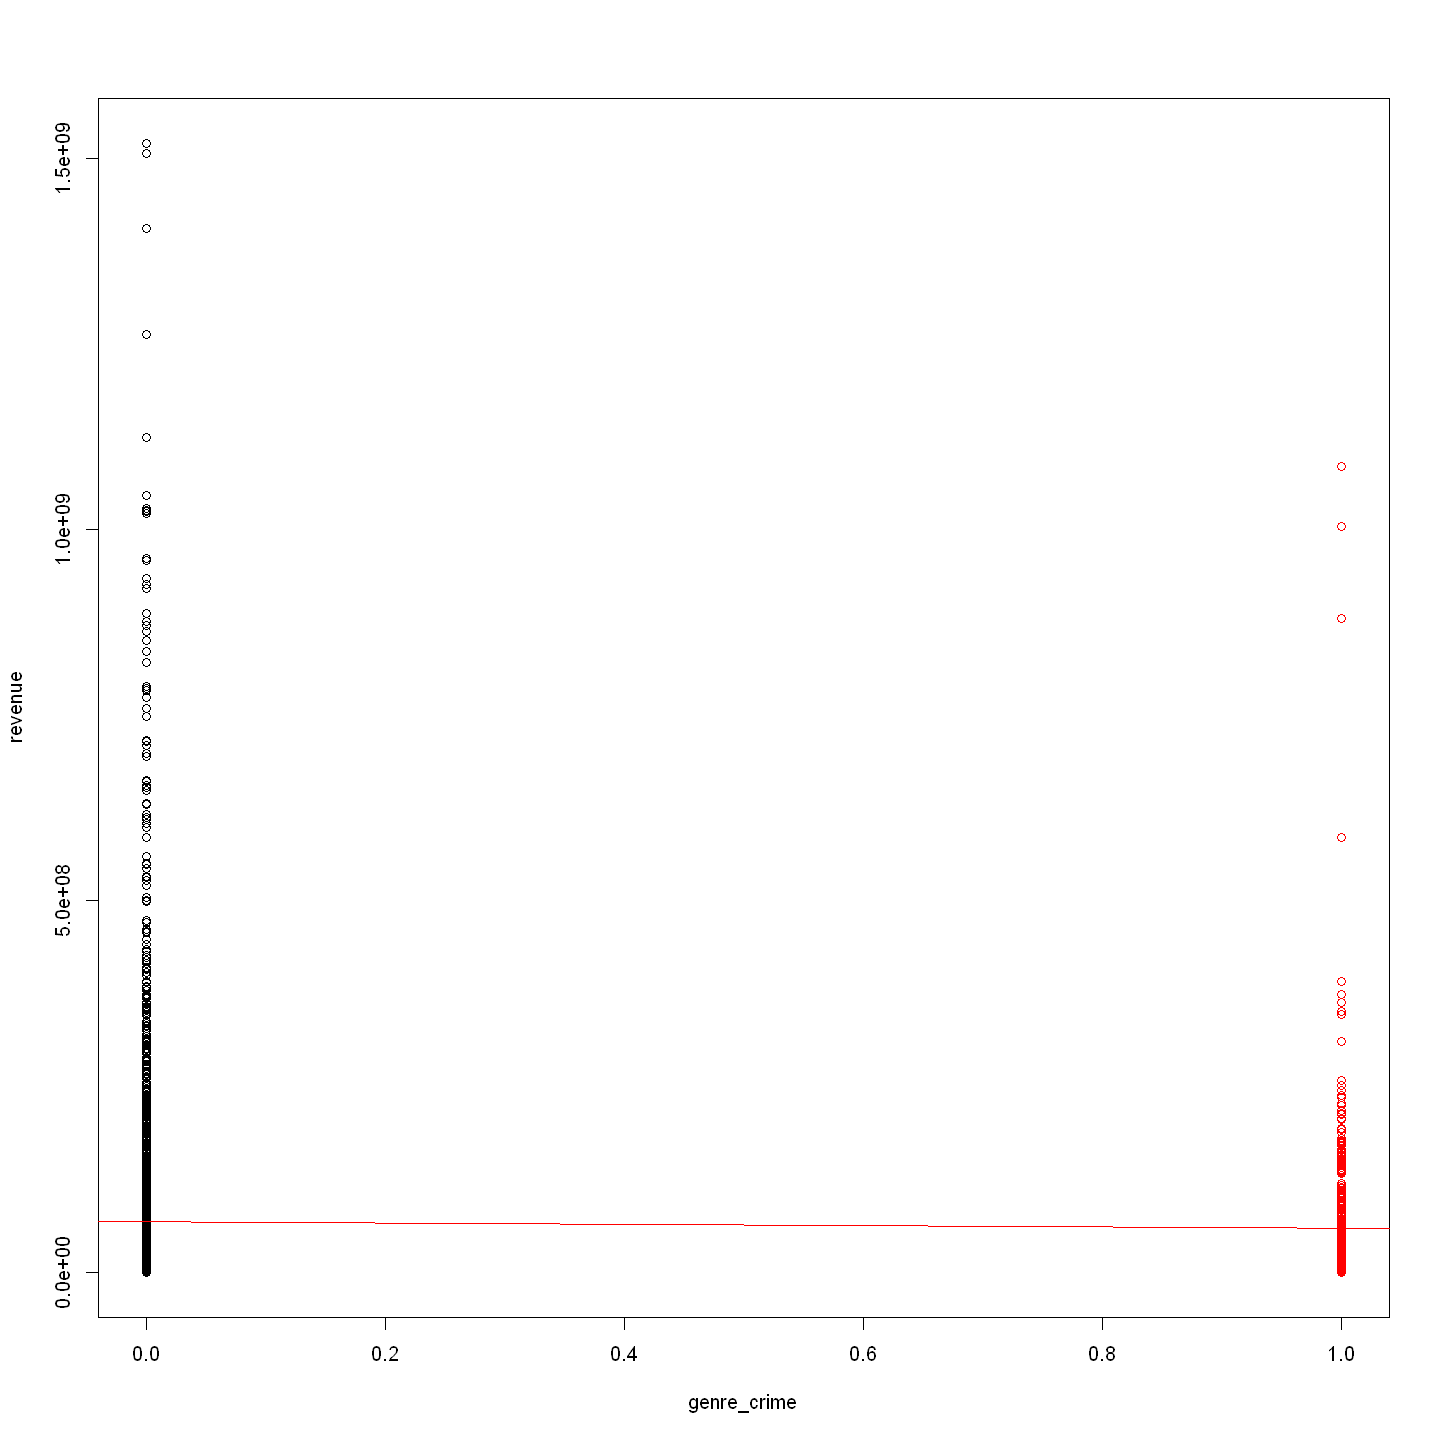

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


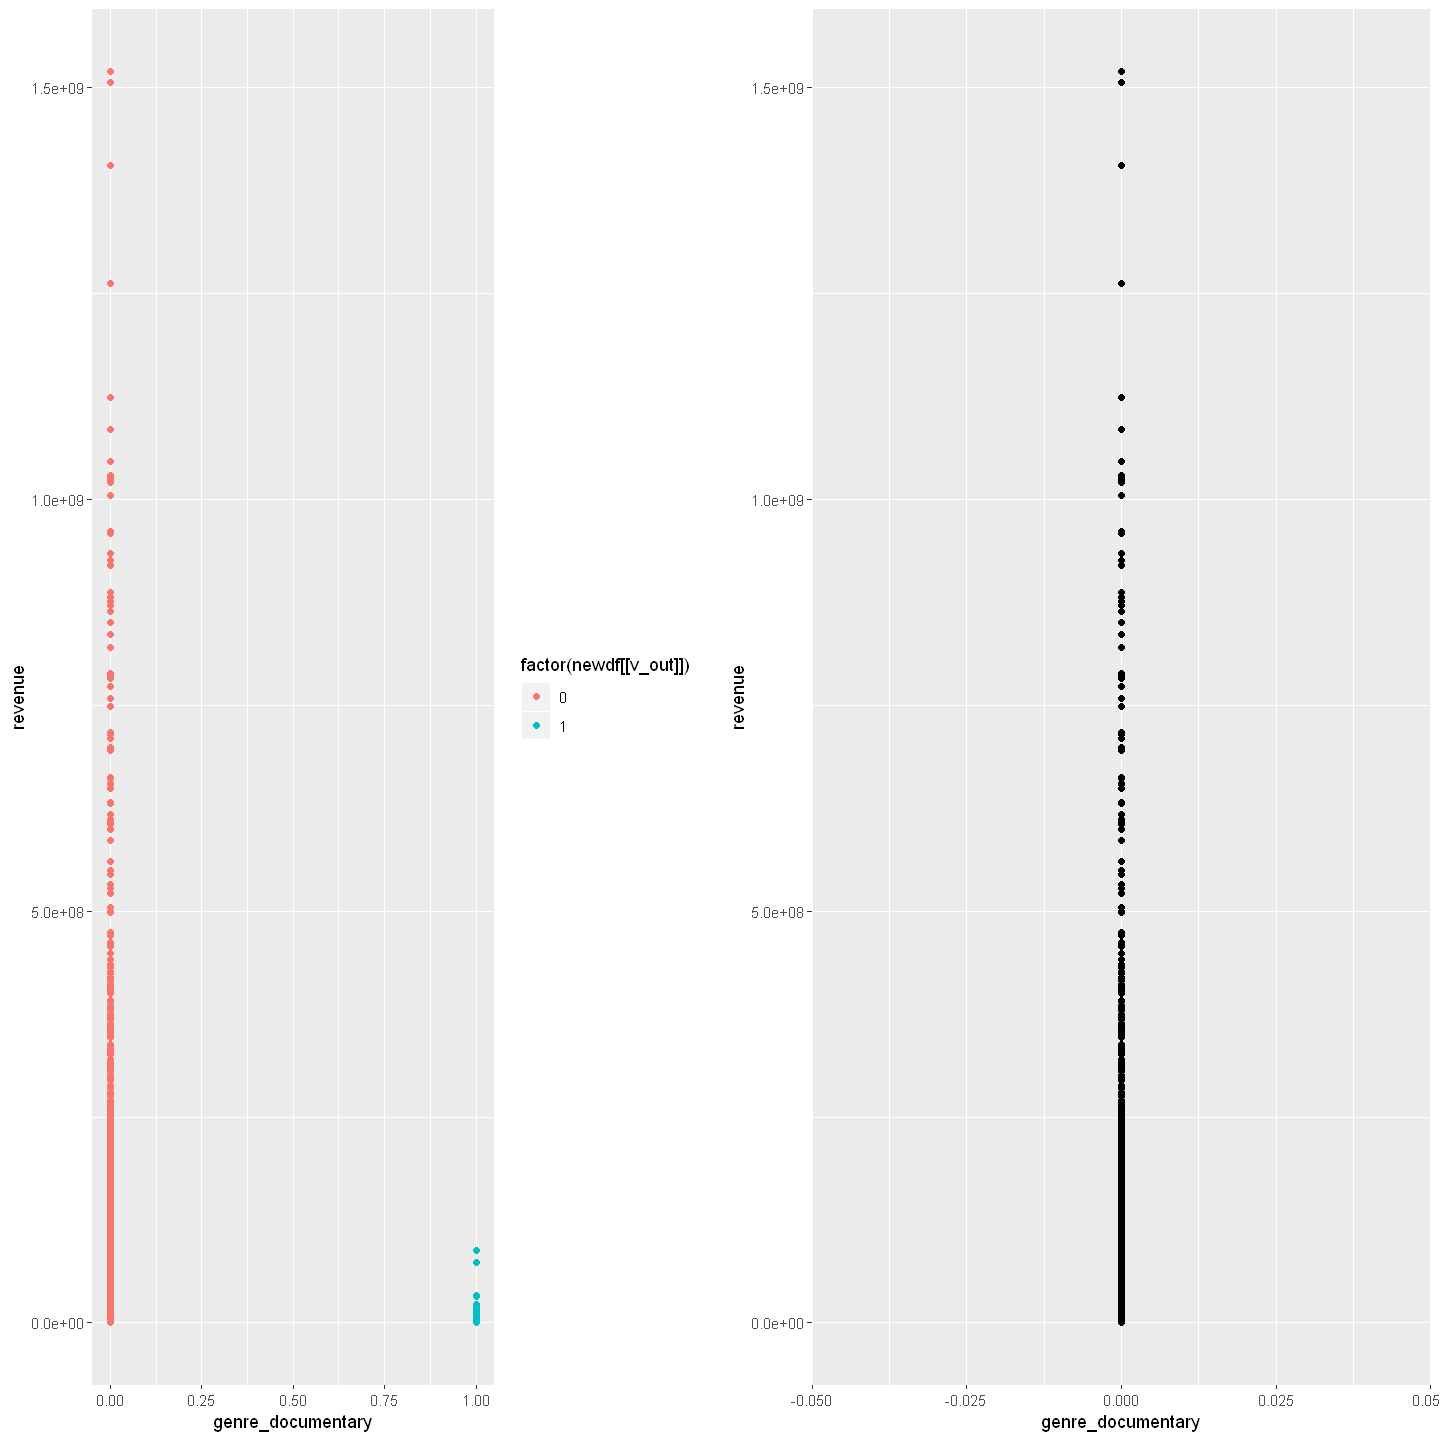

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4672 rows containing missing values (geom_point)."


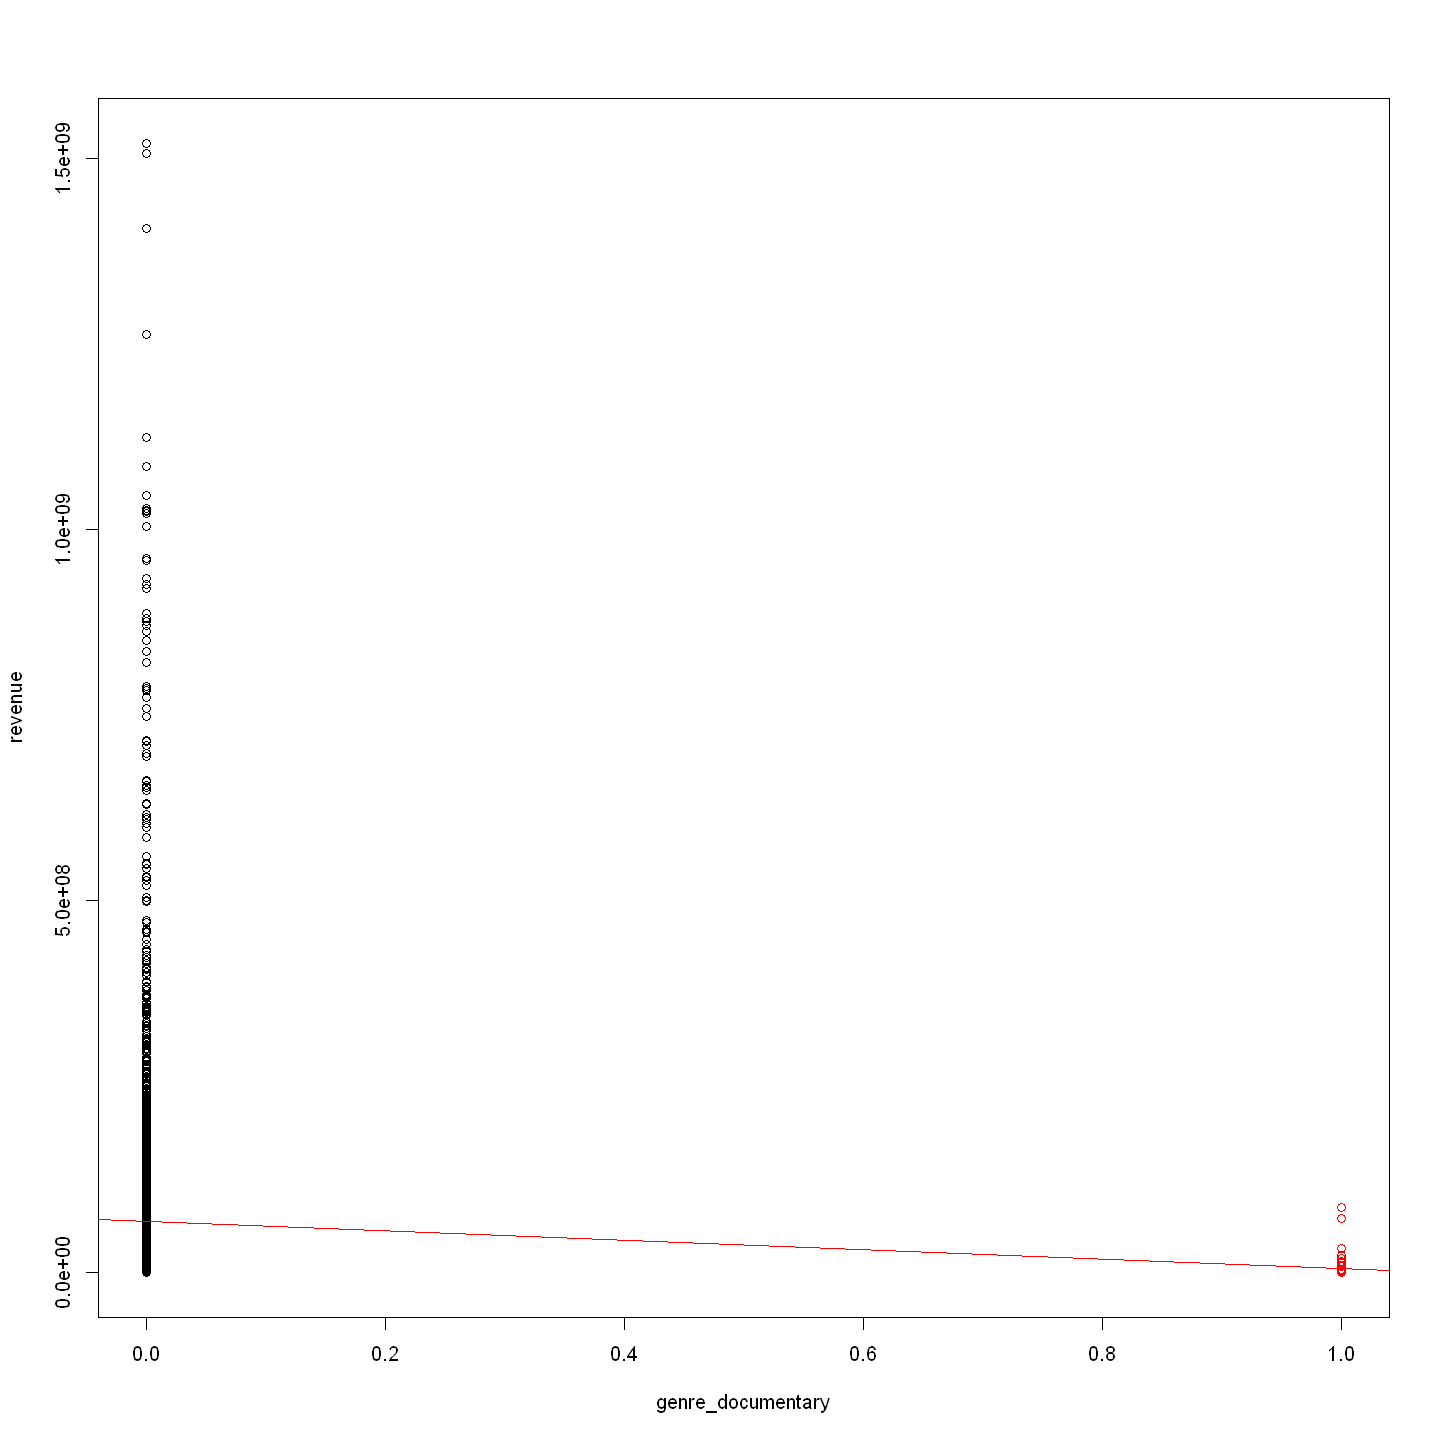

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


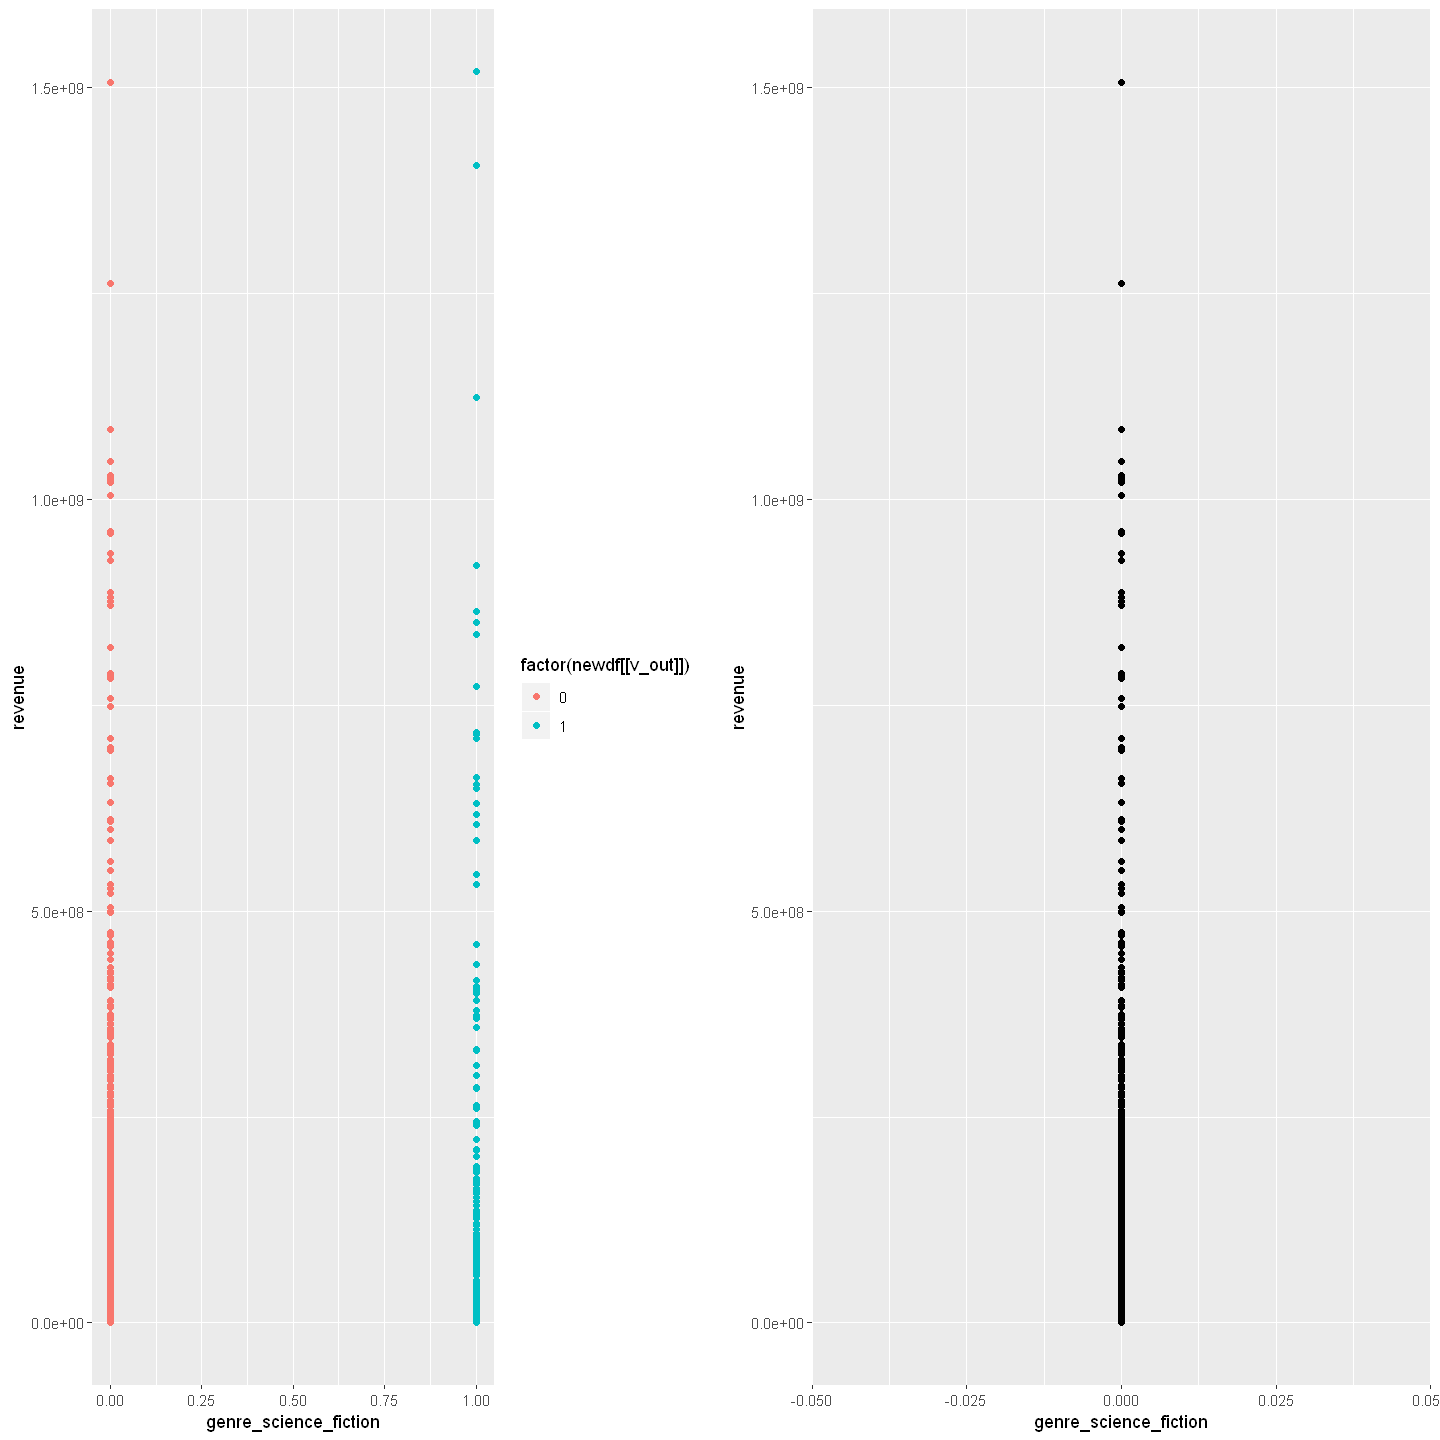

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4607 rows containing missing values (geom_point)."


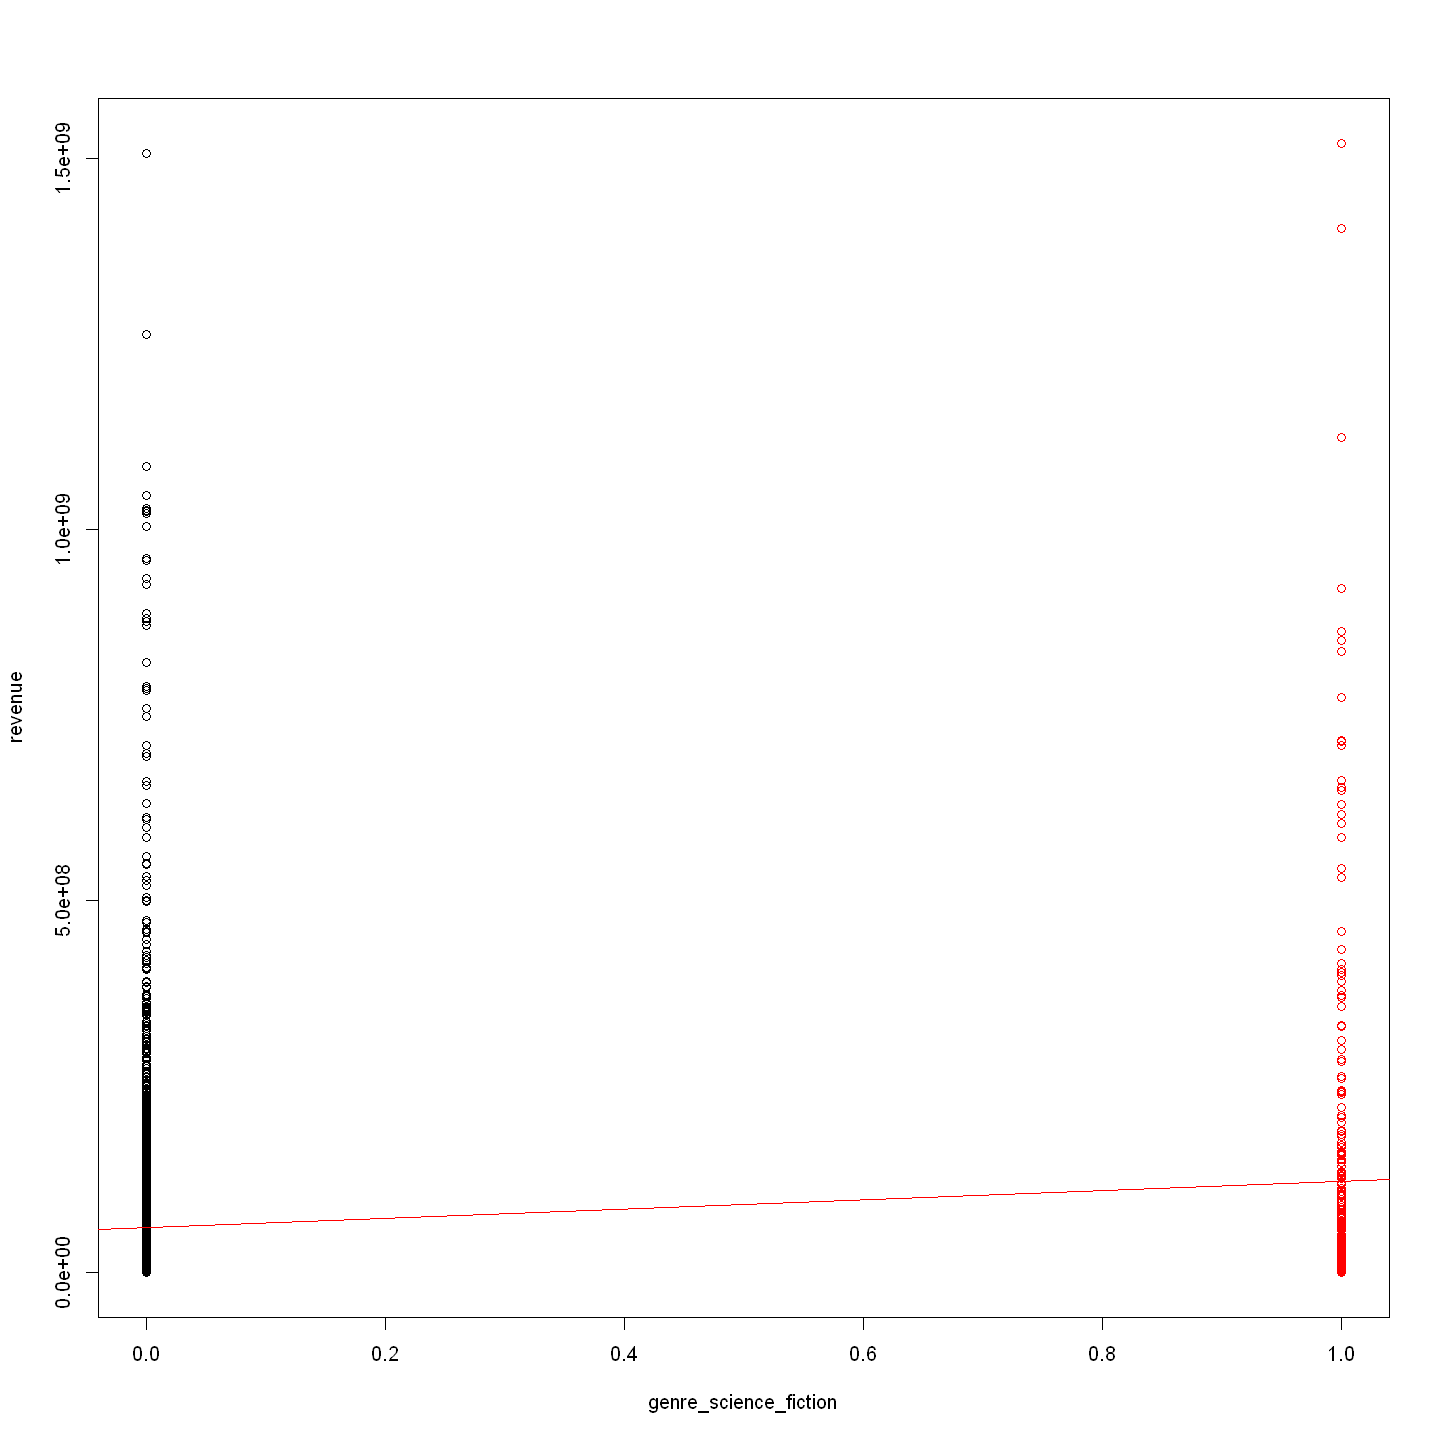

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


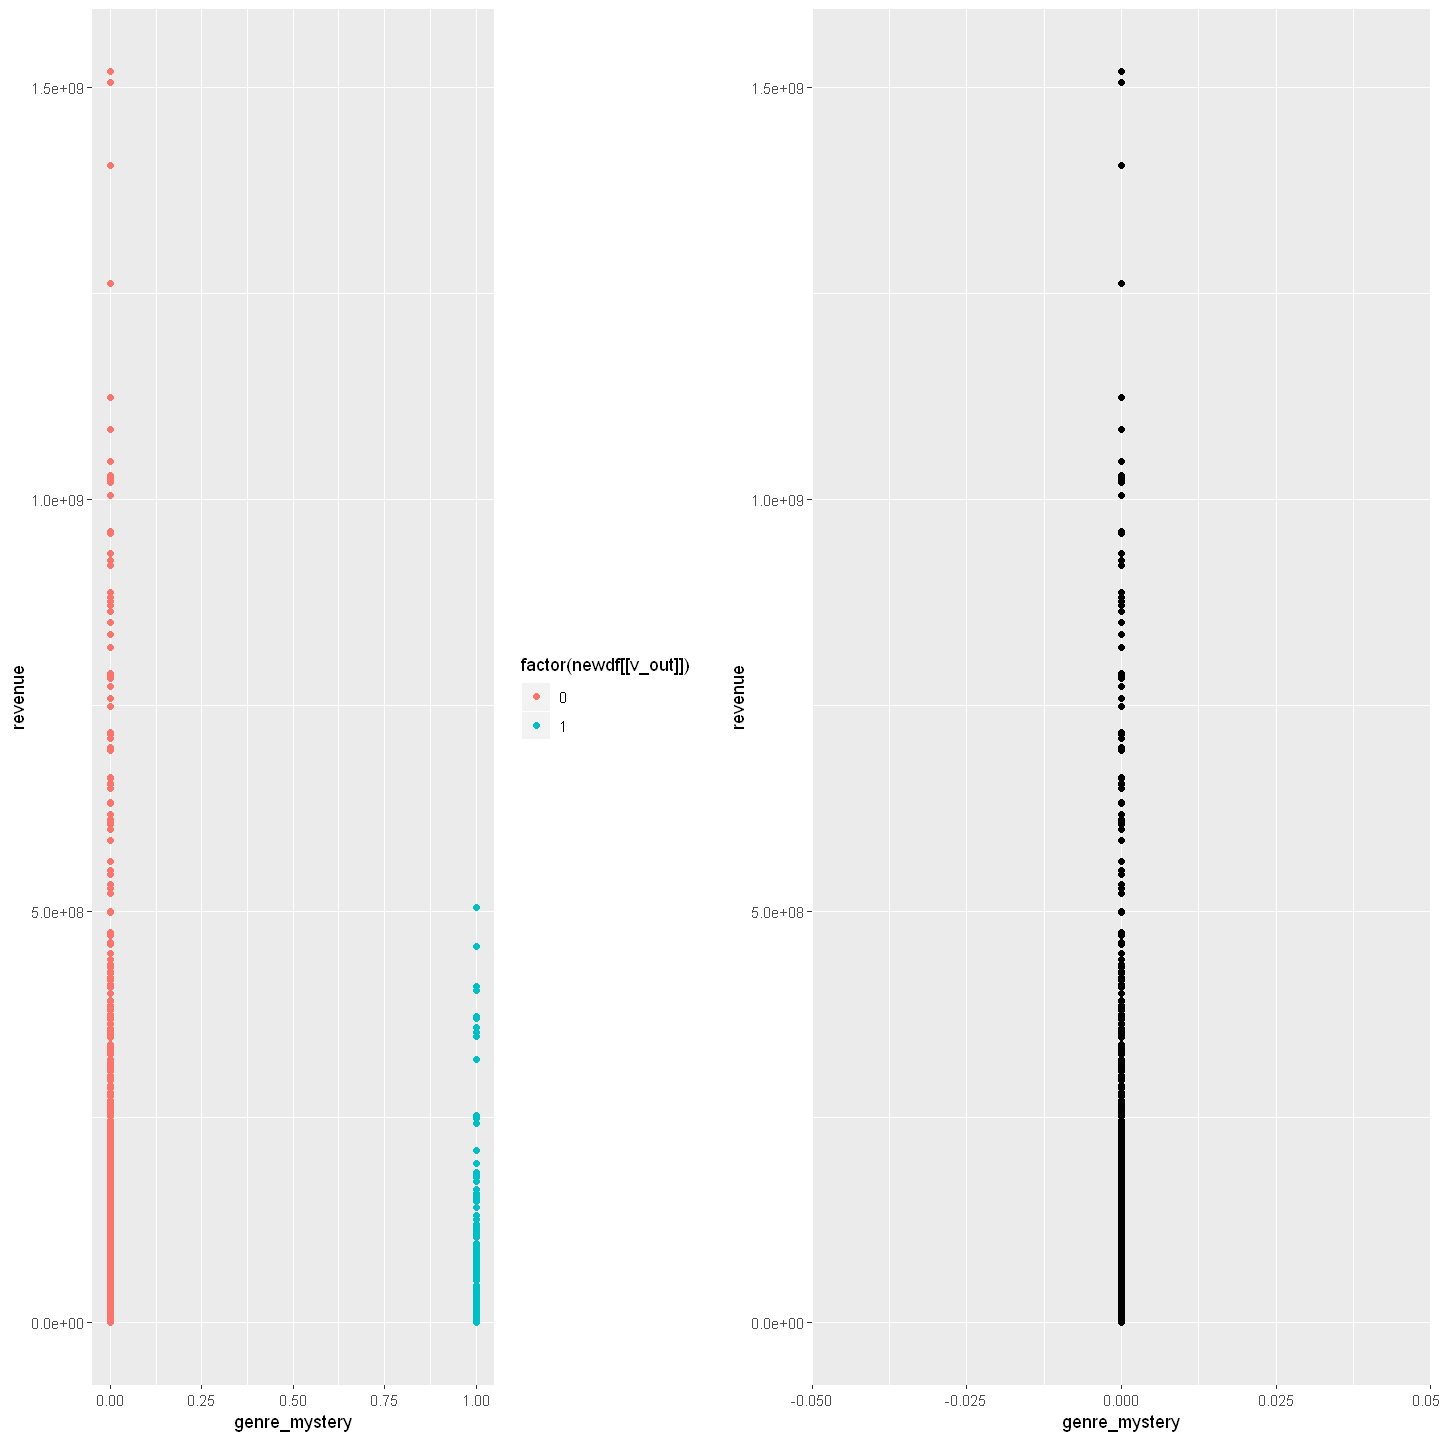

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4482 rows containing missing values (geom_point)."


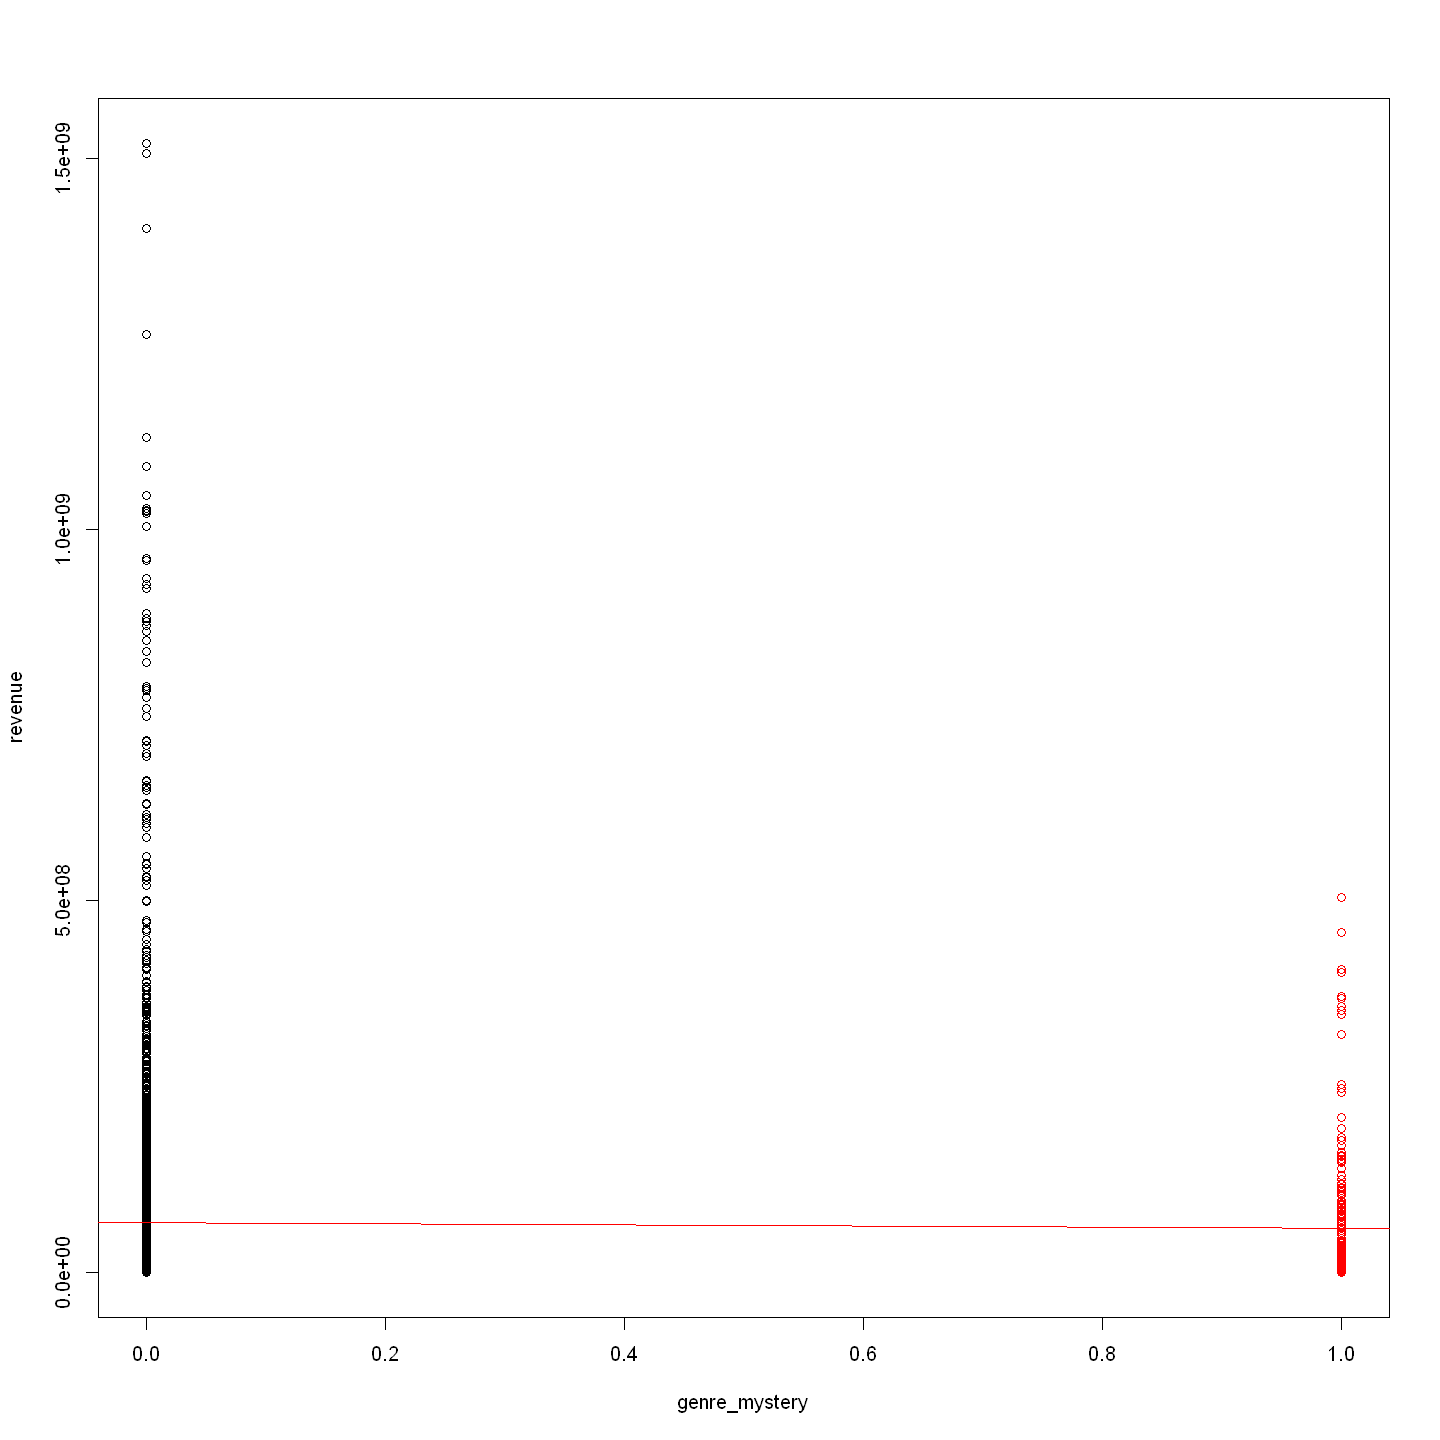

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


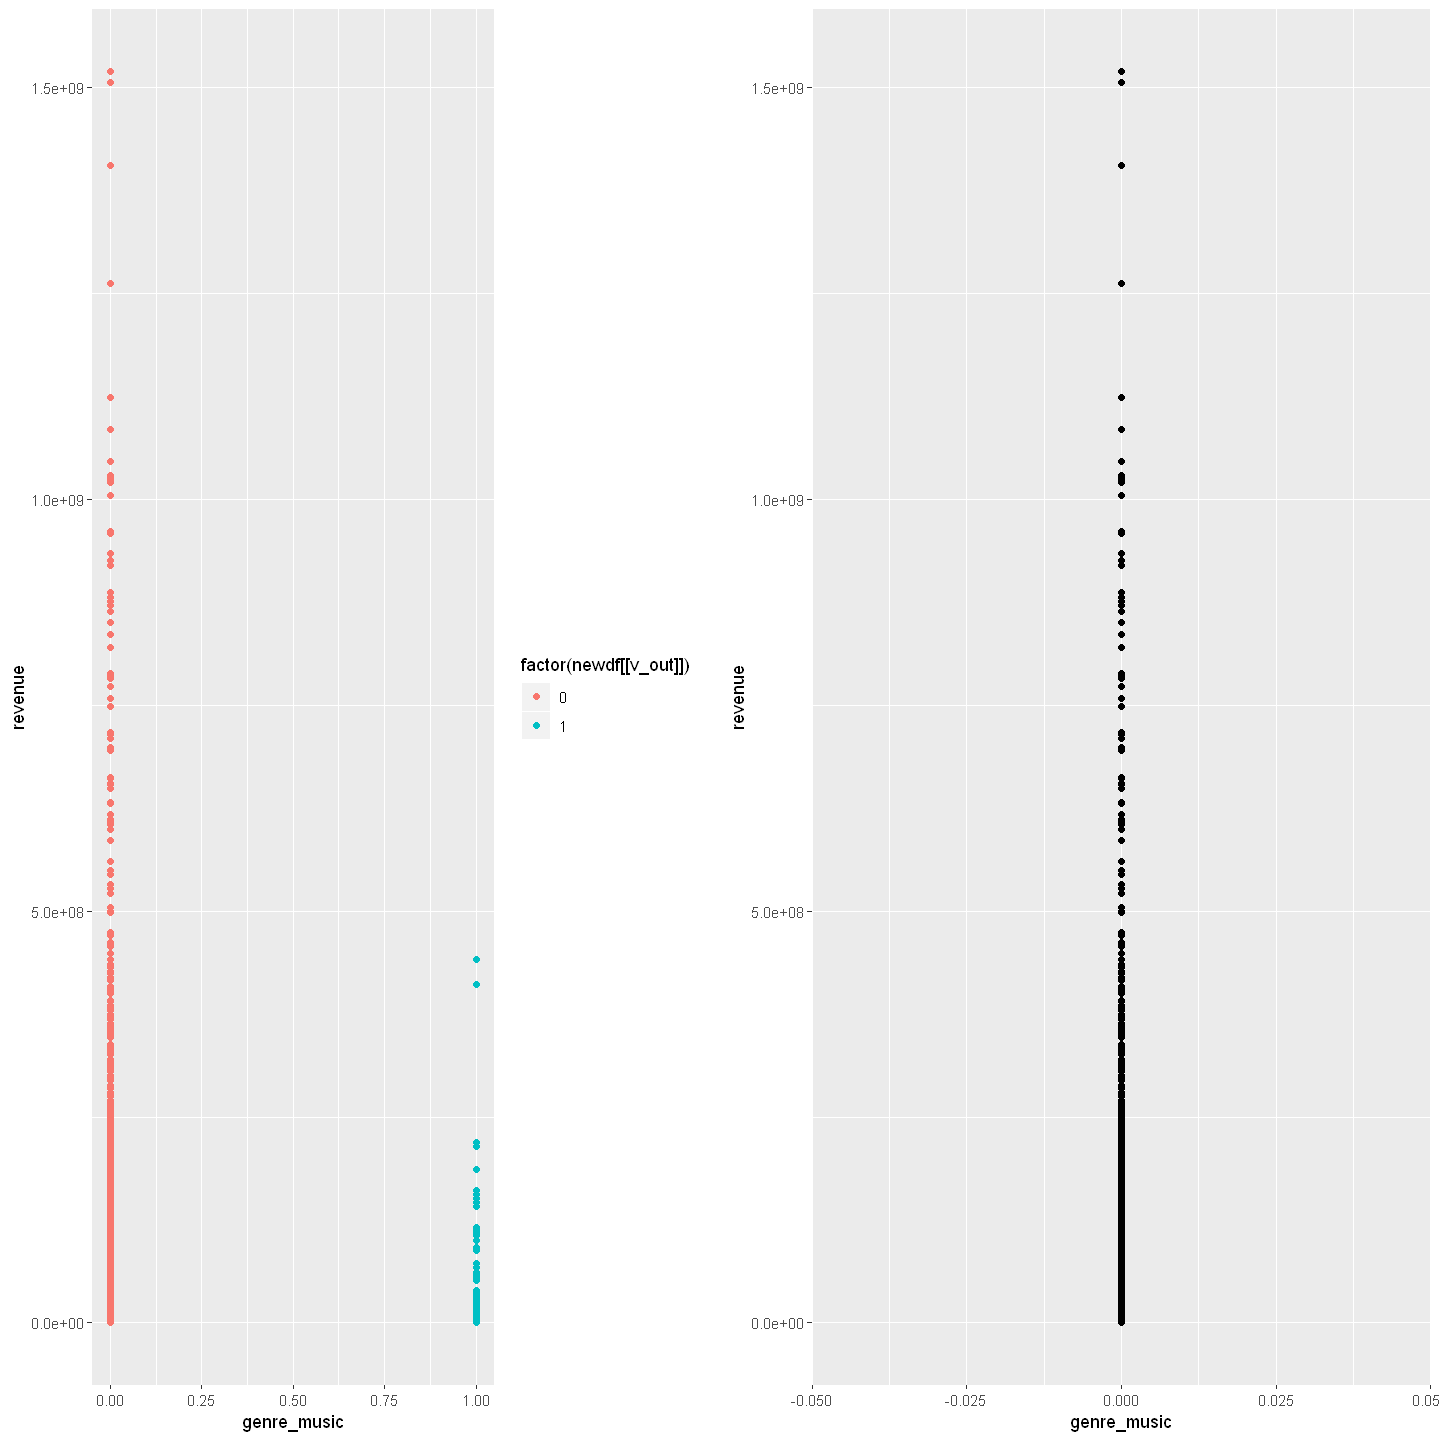

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4953 rows containing missing values (geom_point)."


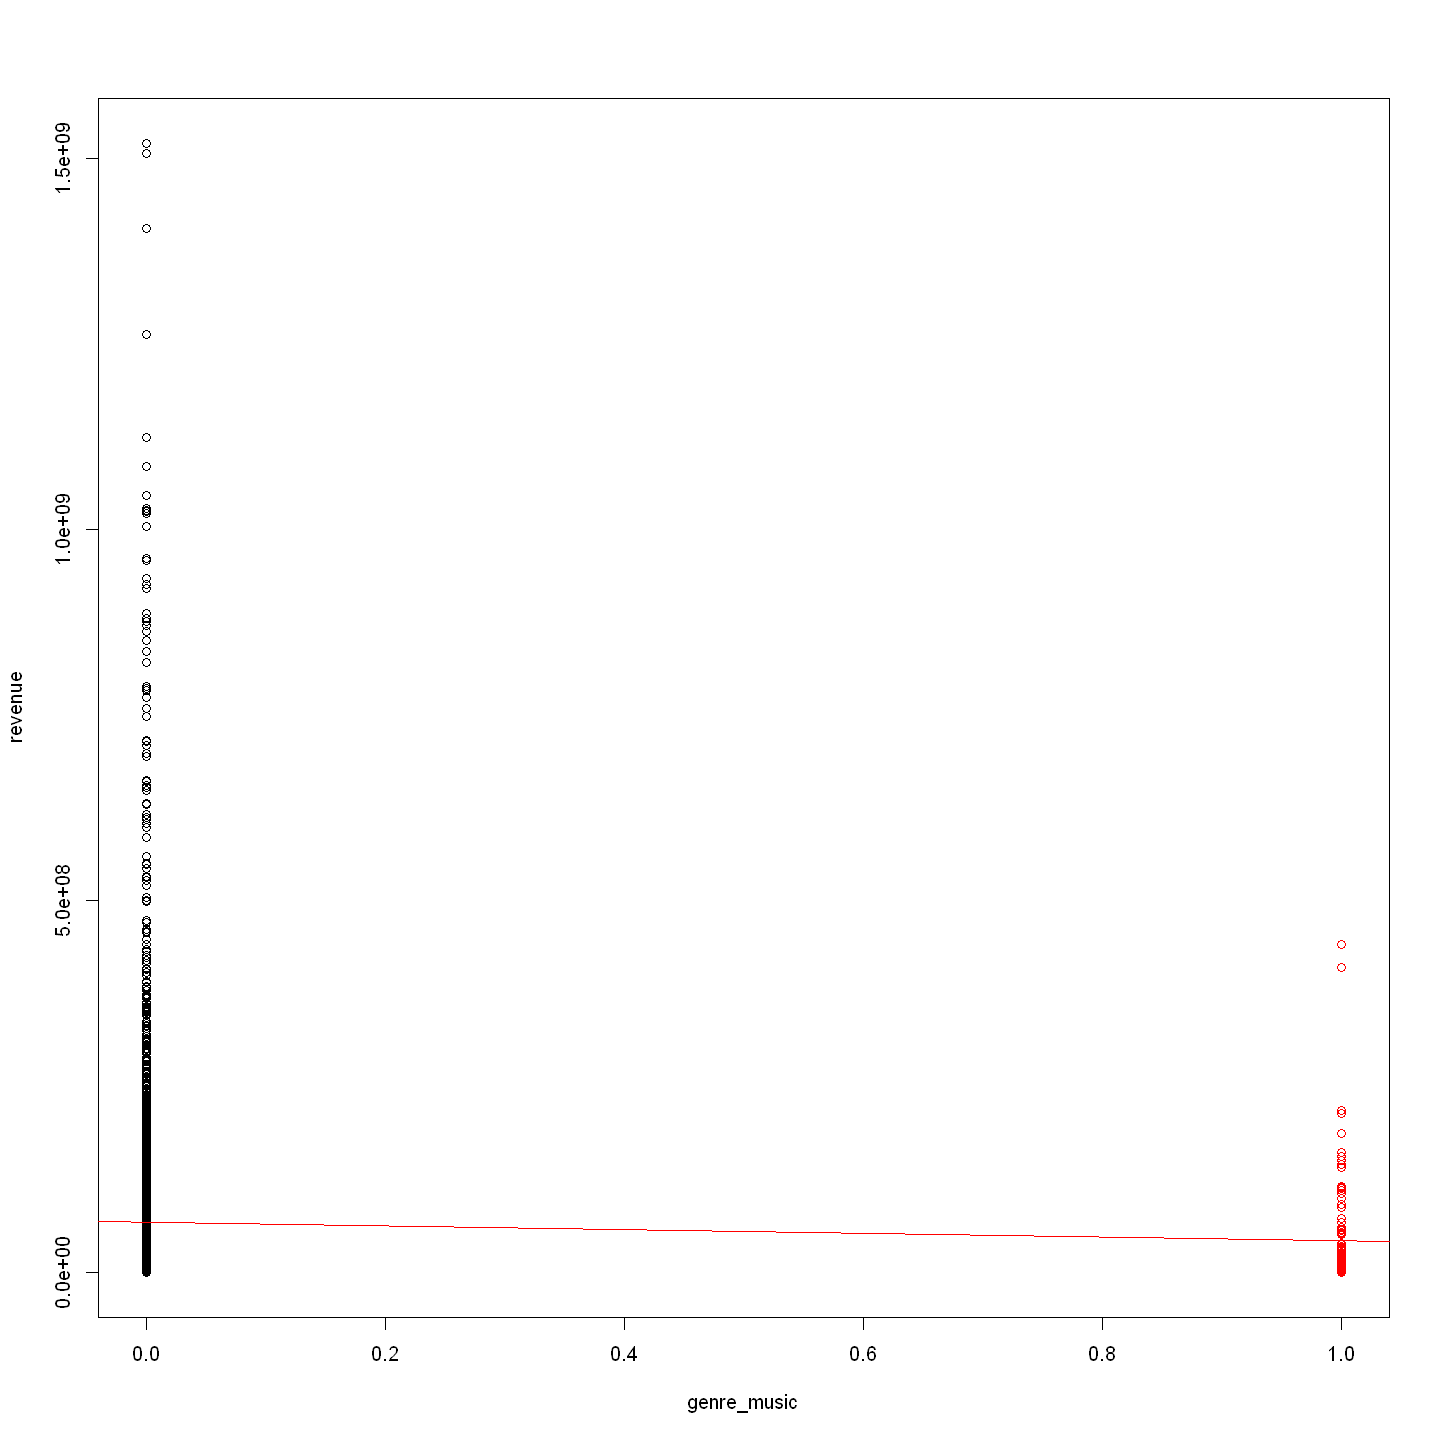

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


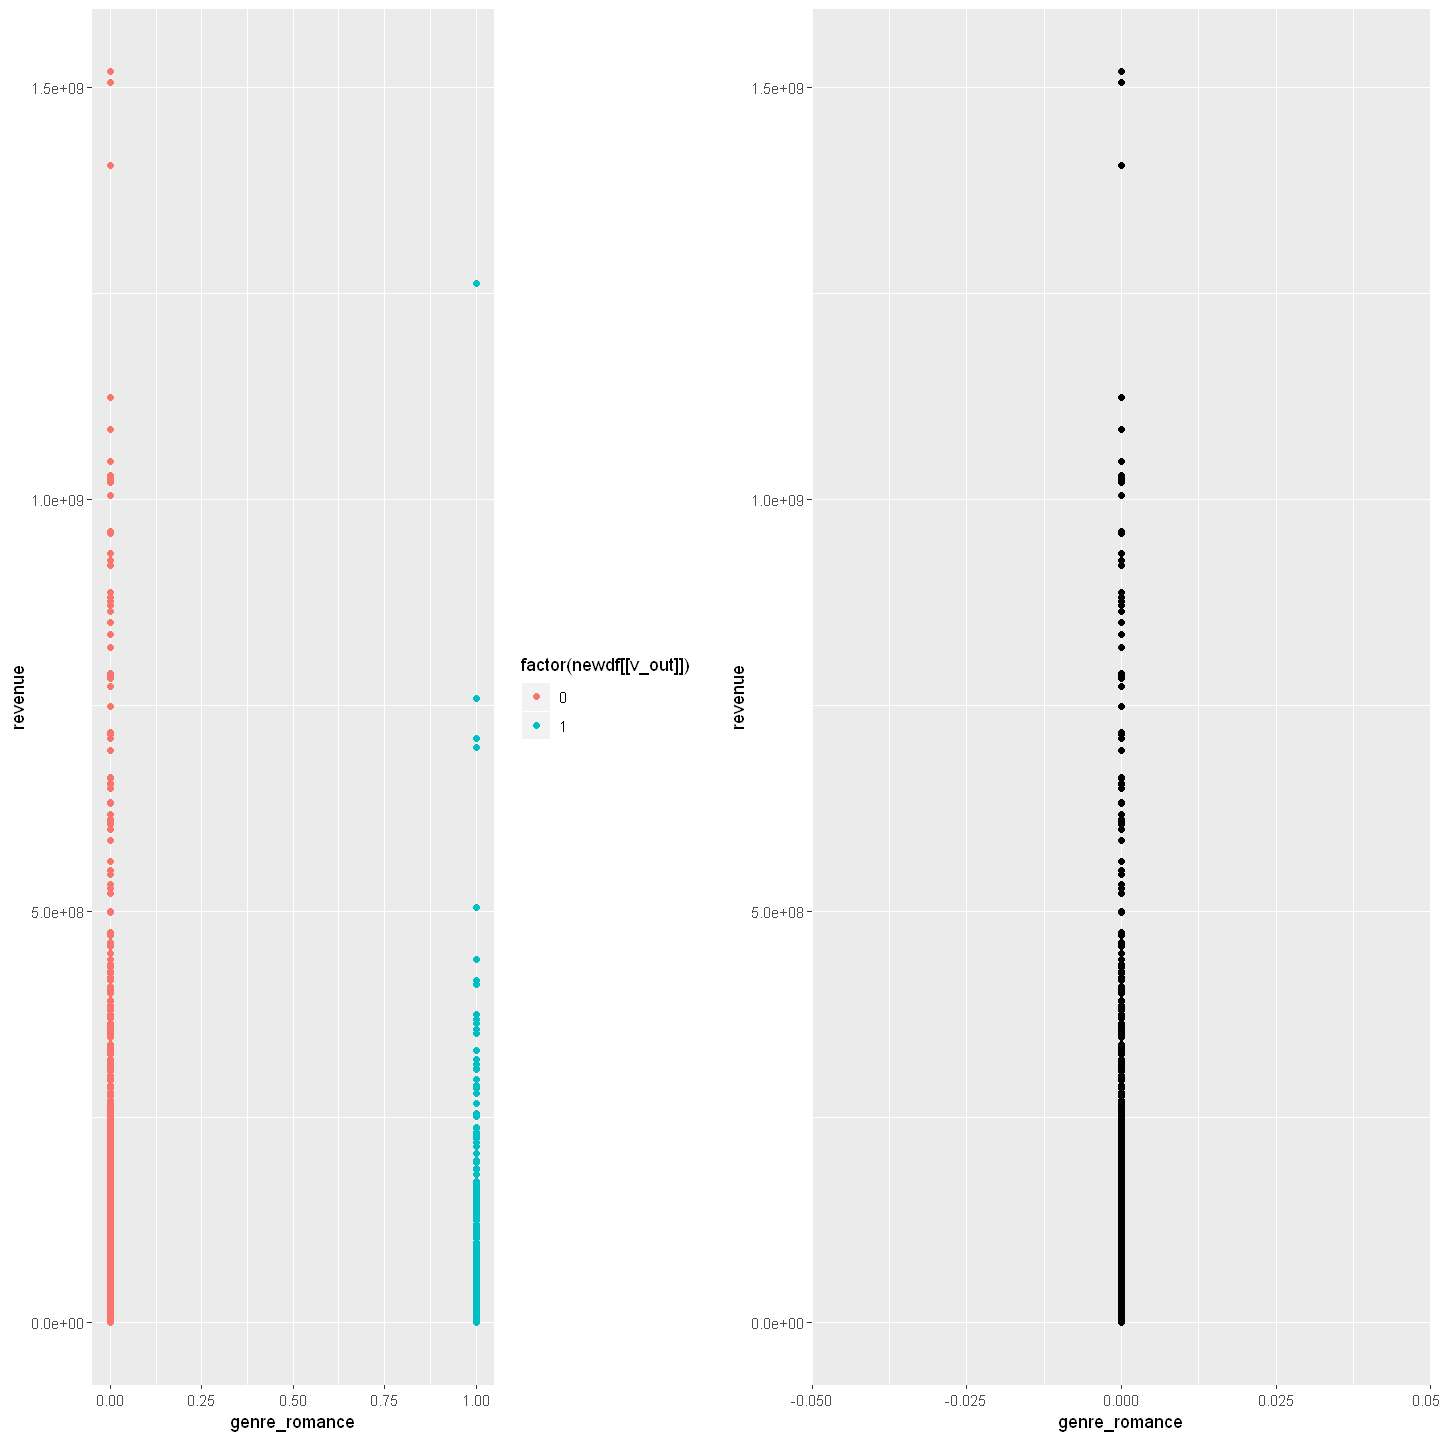

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4642 rows containing missing values (geom_point)."


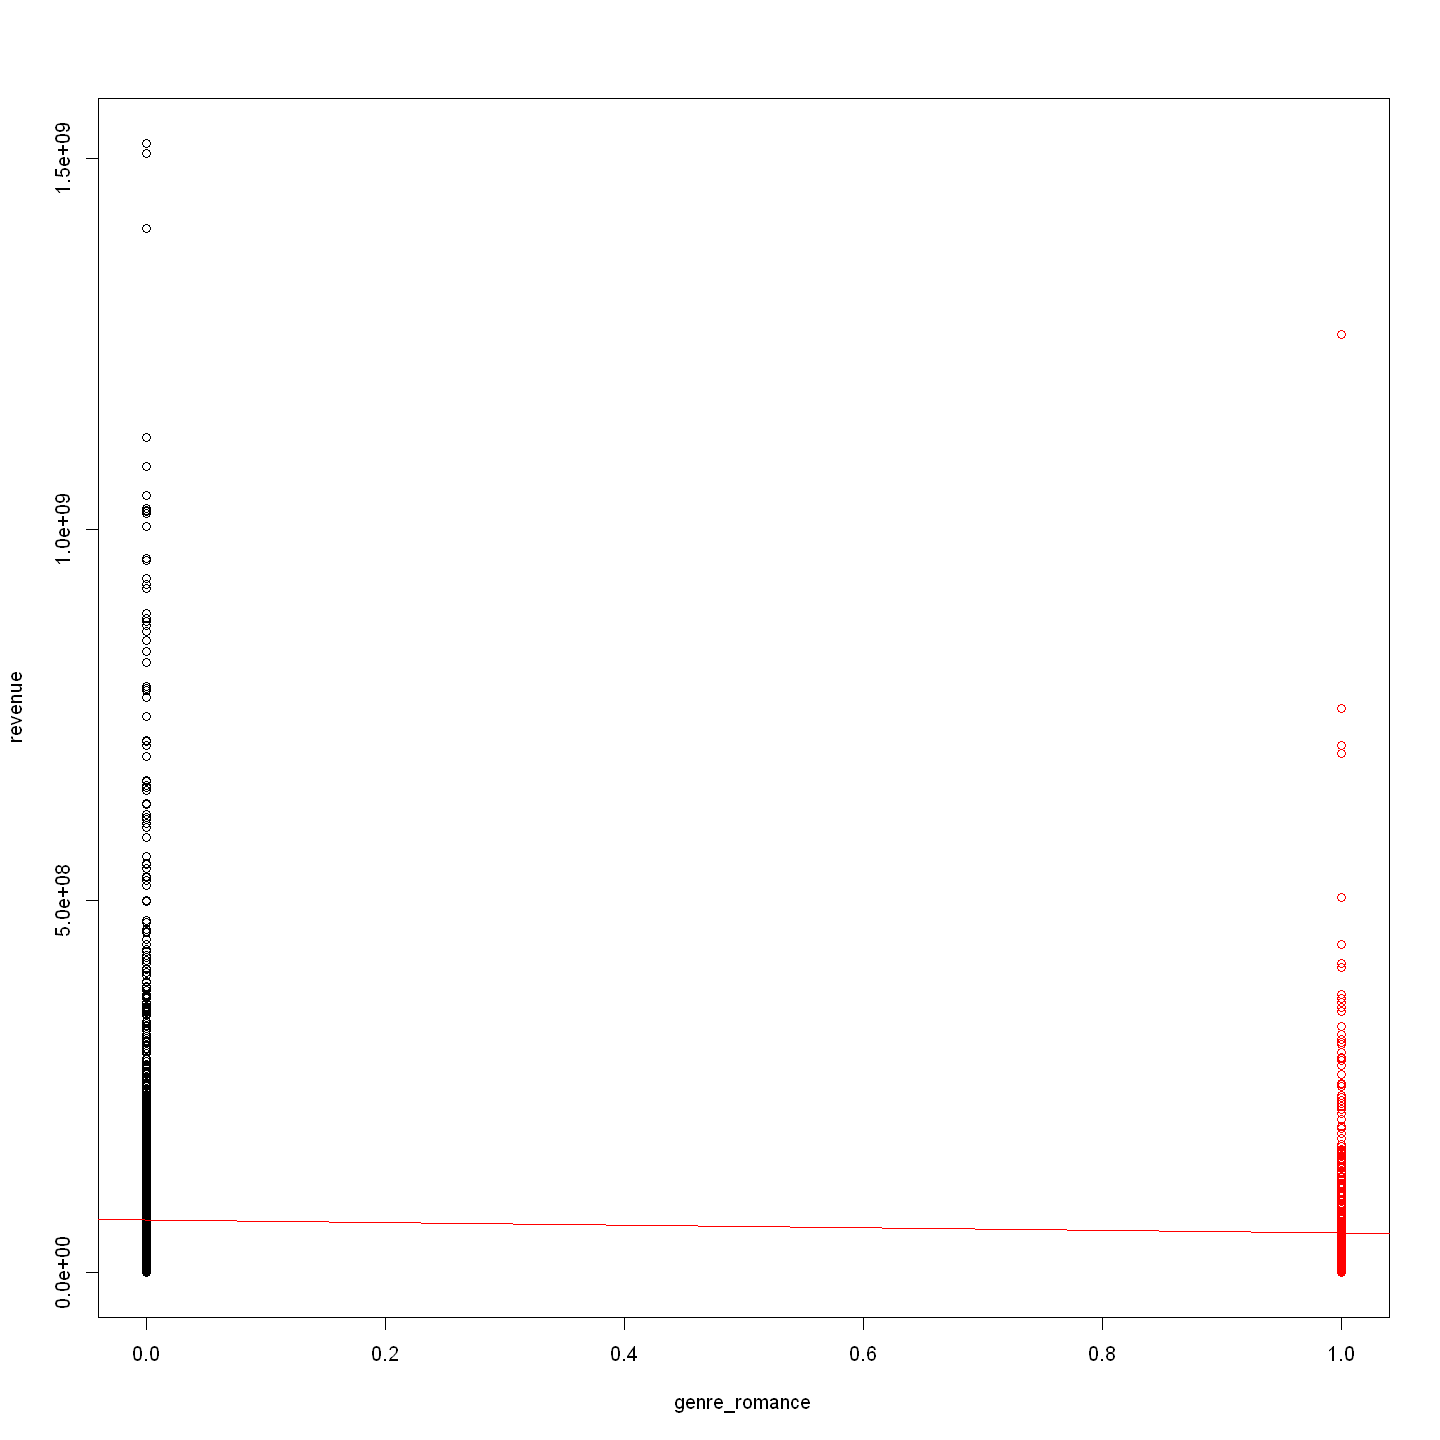

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


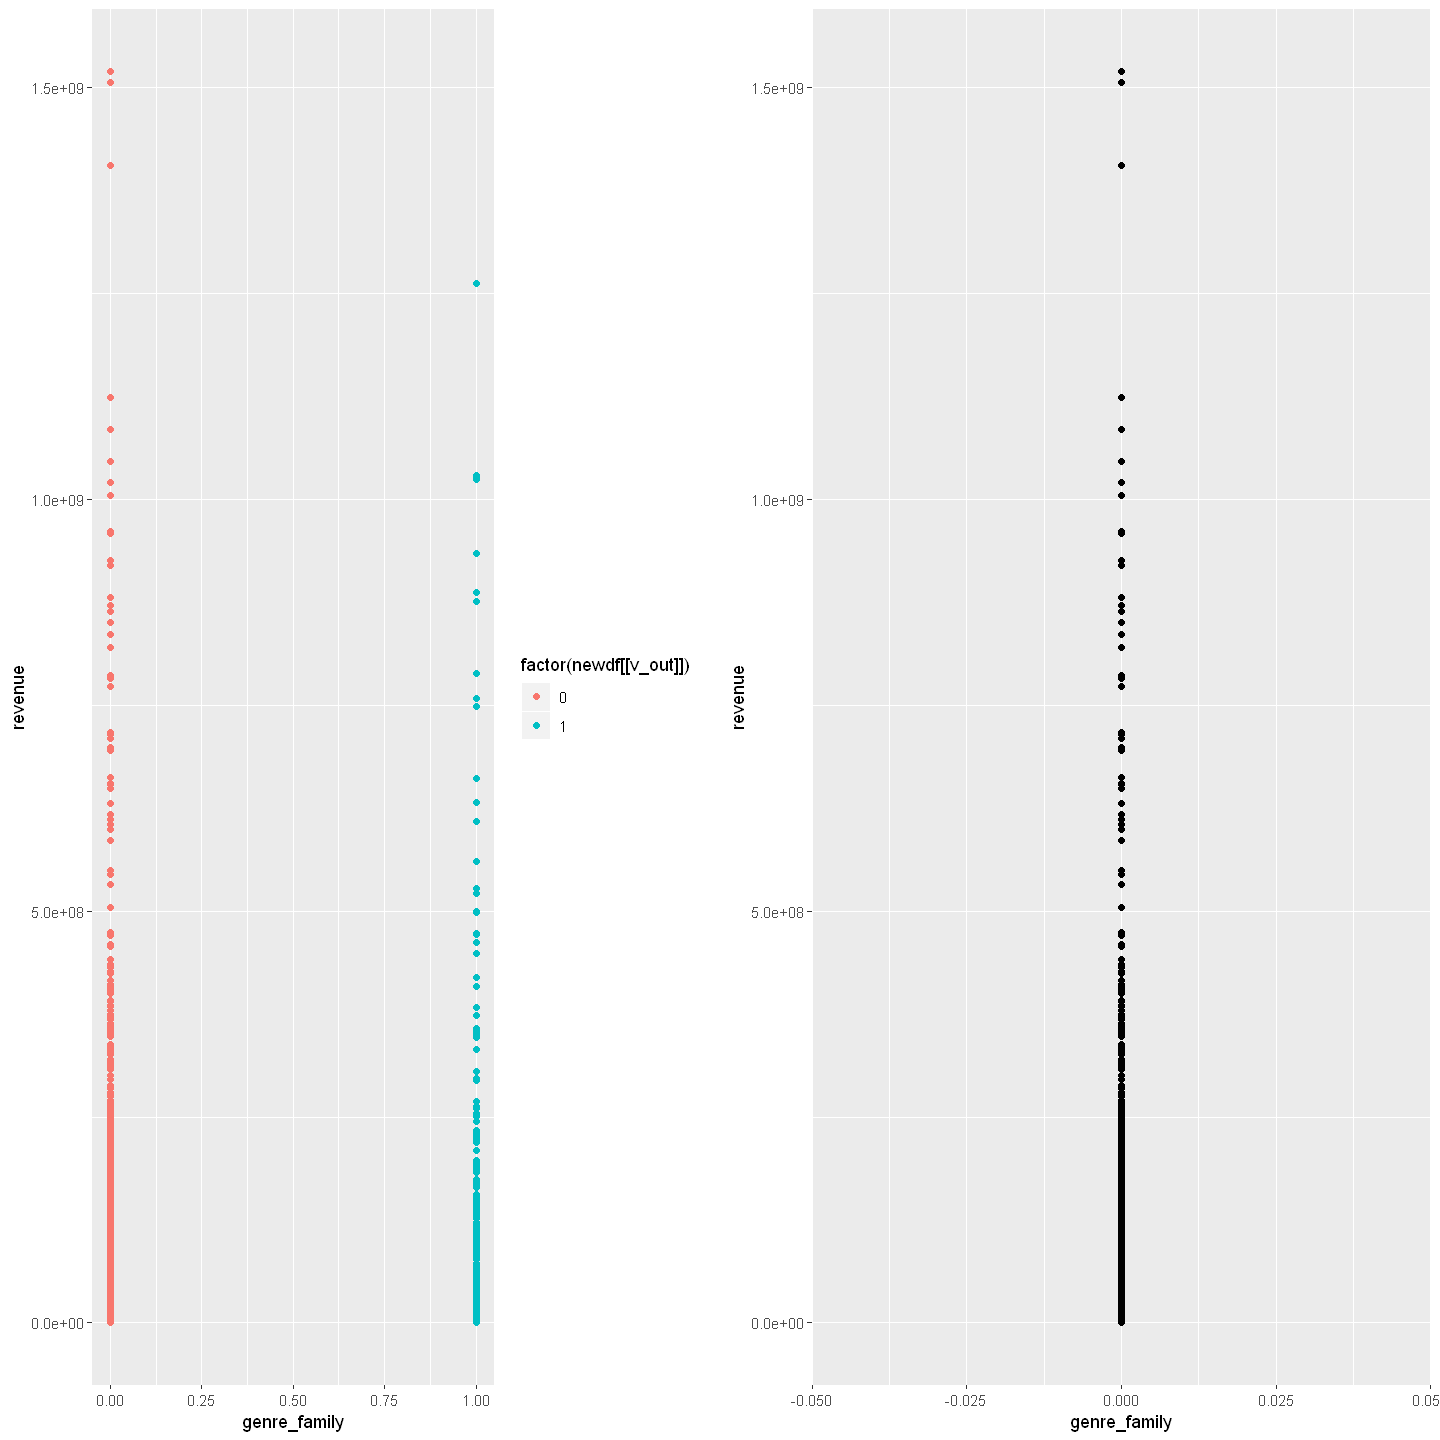

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4482 rows containing missing values (geom_point)."


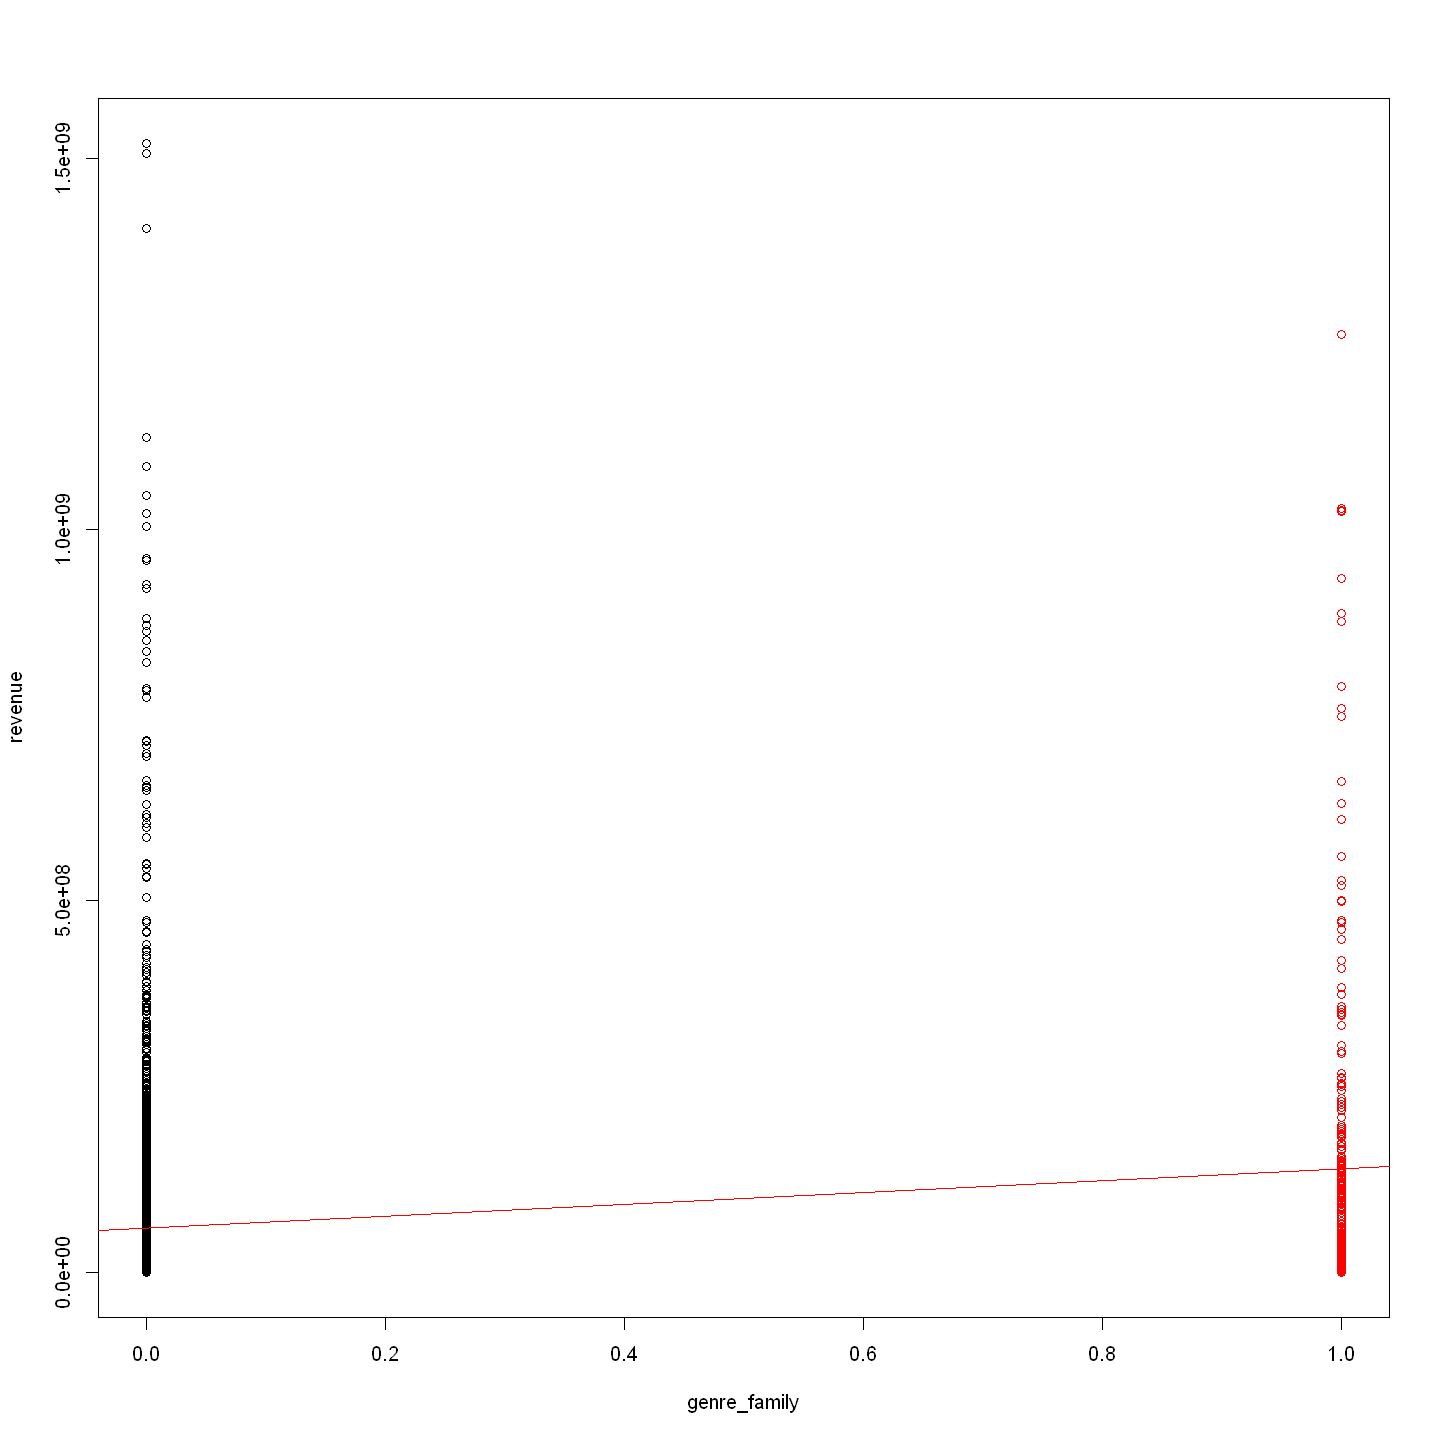

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


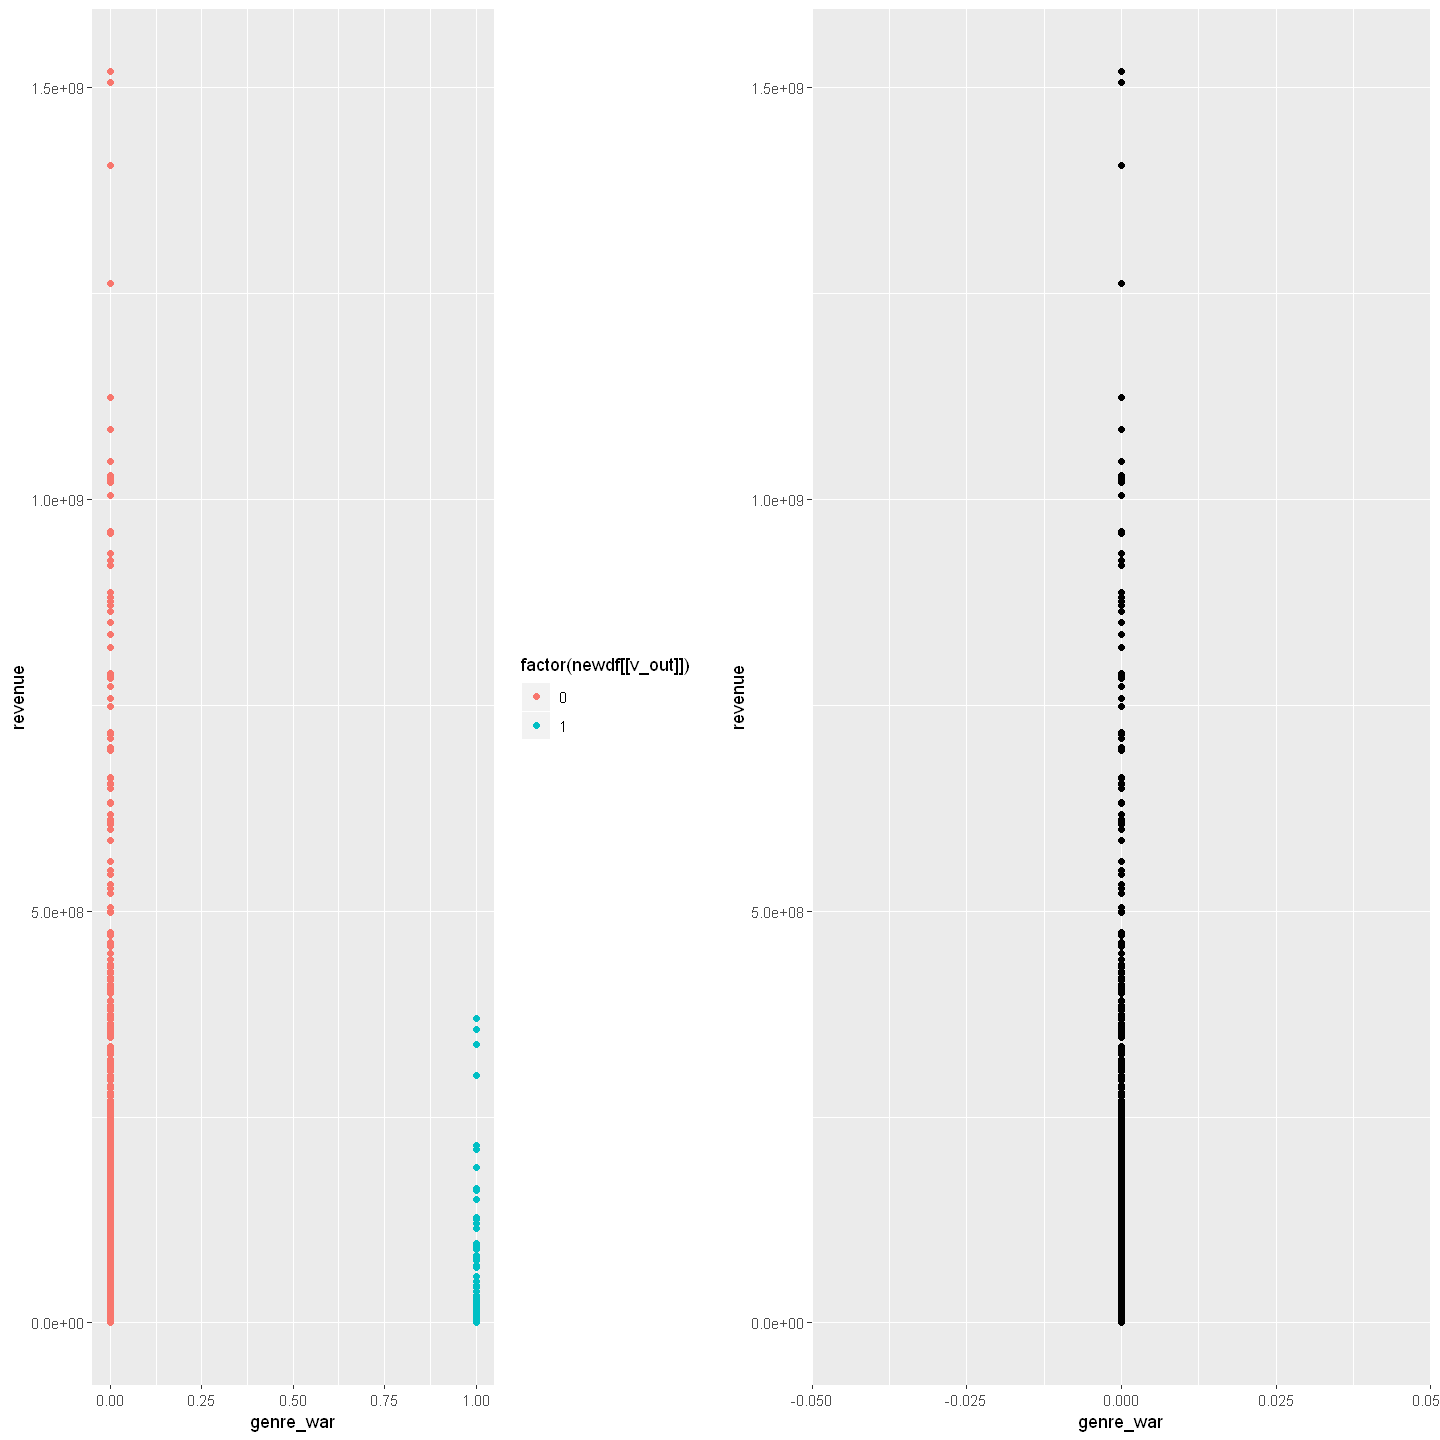

NULL
NULL


Warning message:
"Removed 4382 rows containing missing values (geom_point)."
Warning message:
"Removed 4413 rows containing missing values (geom_point)."


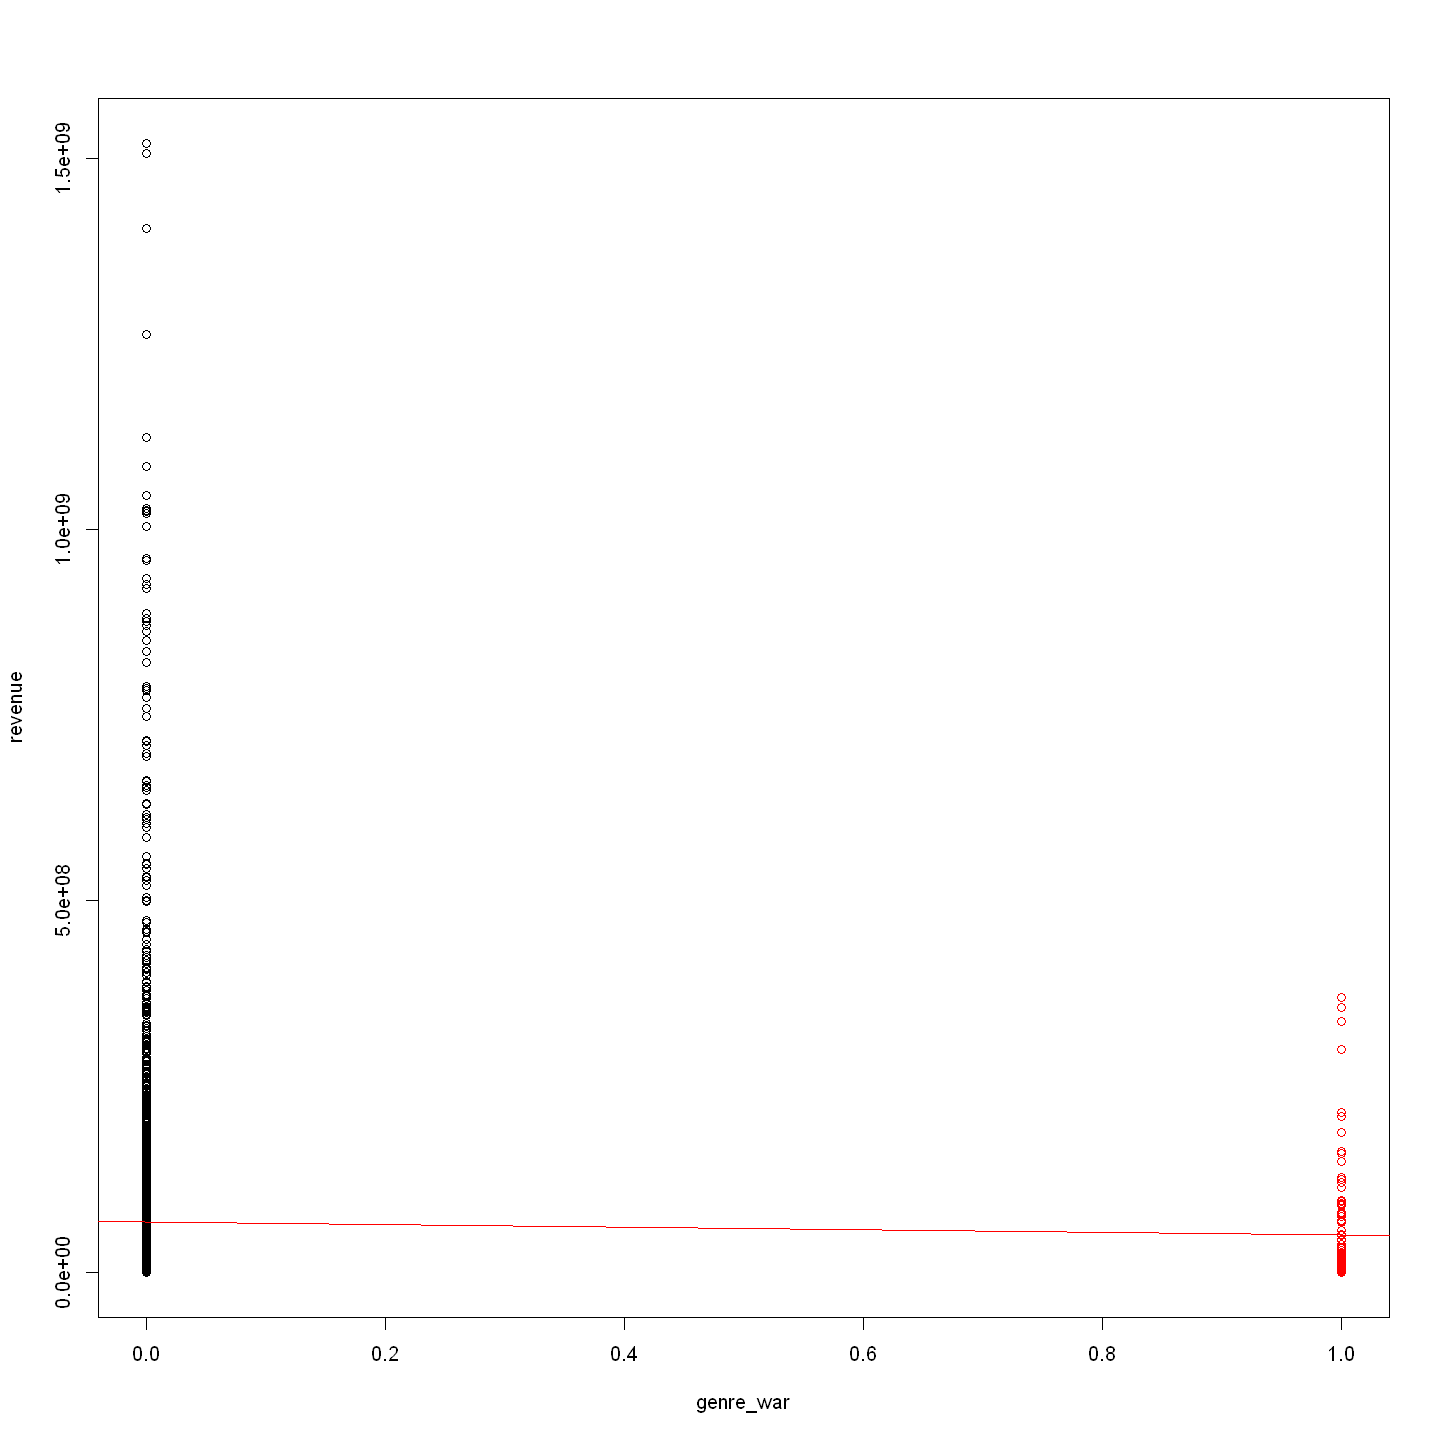

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


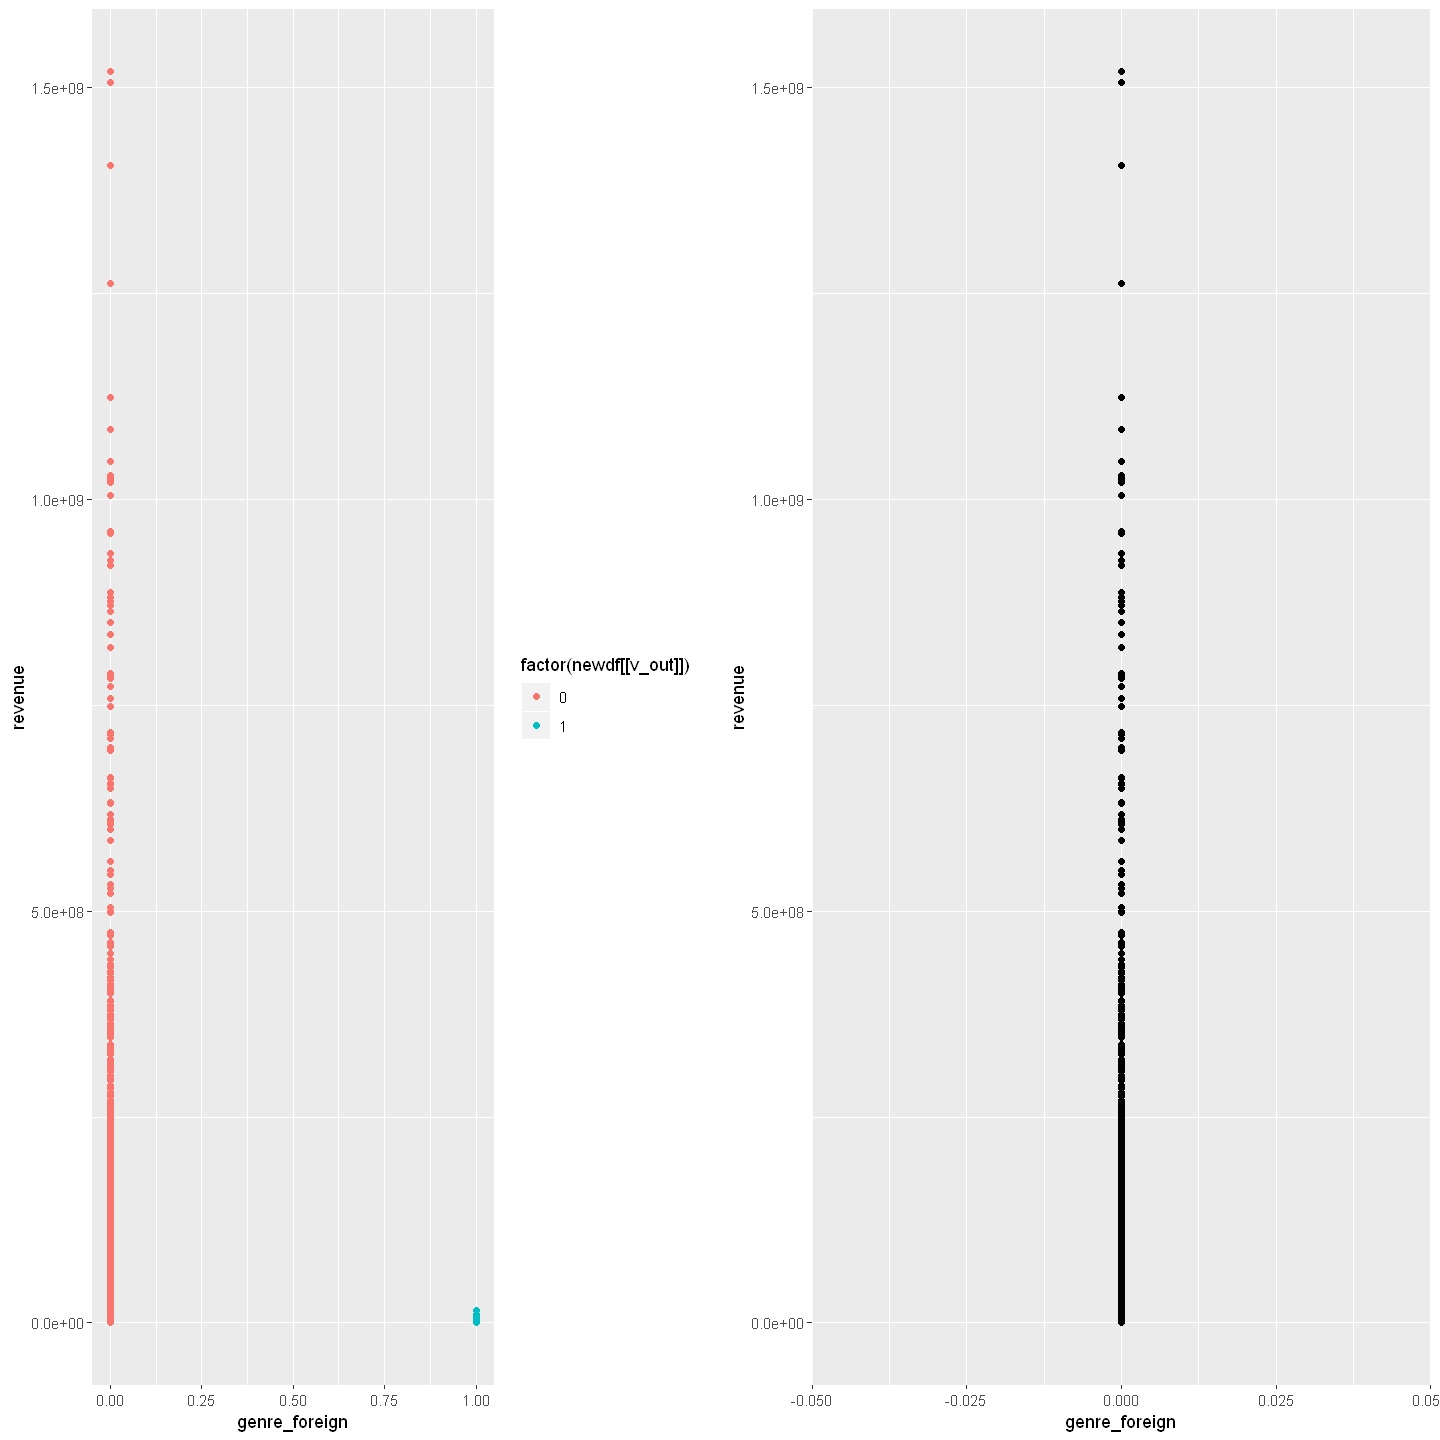

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4684 rows containing missing values (geom_point)."


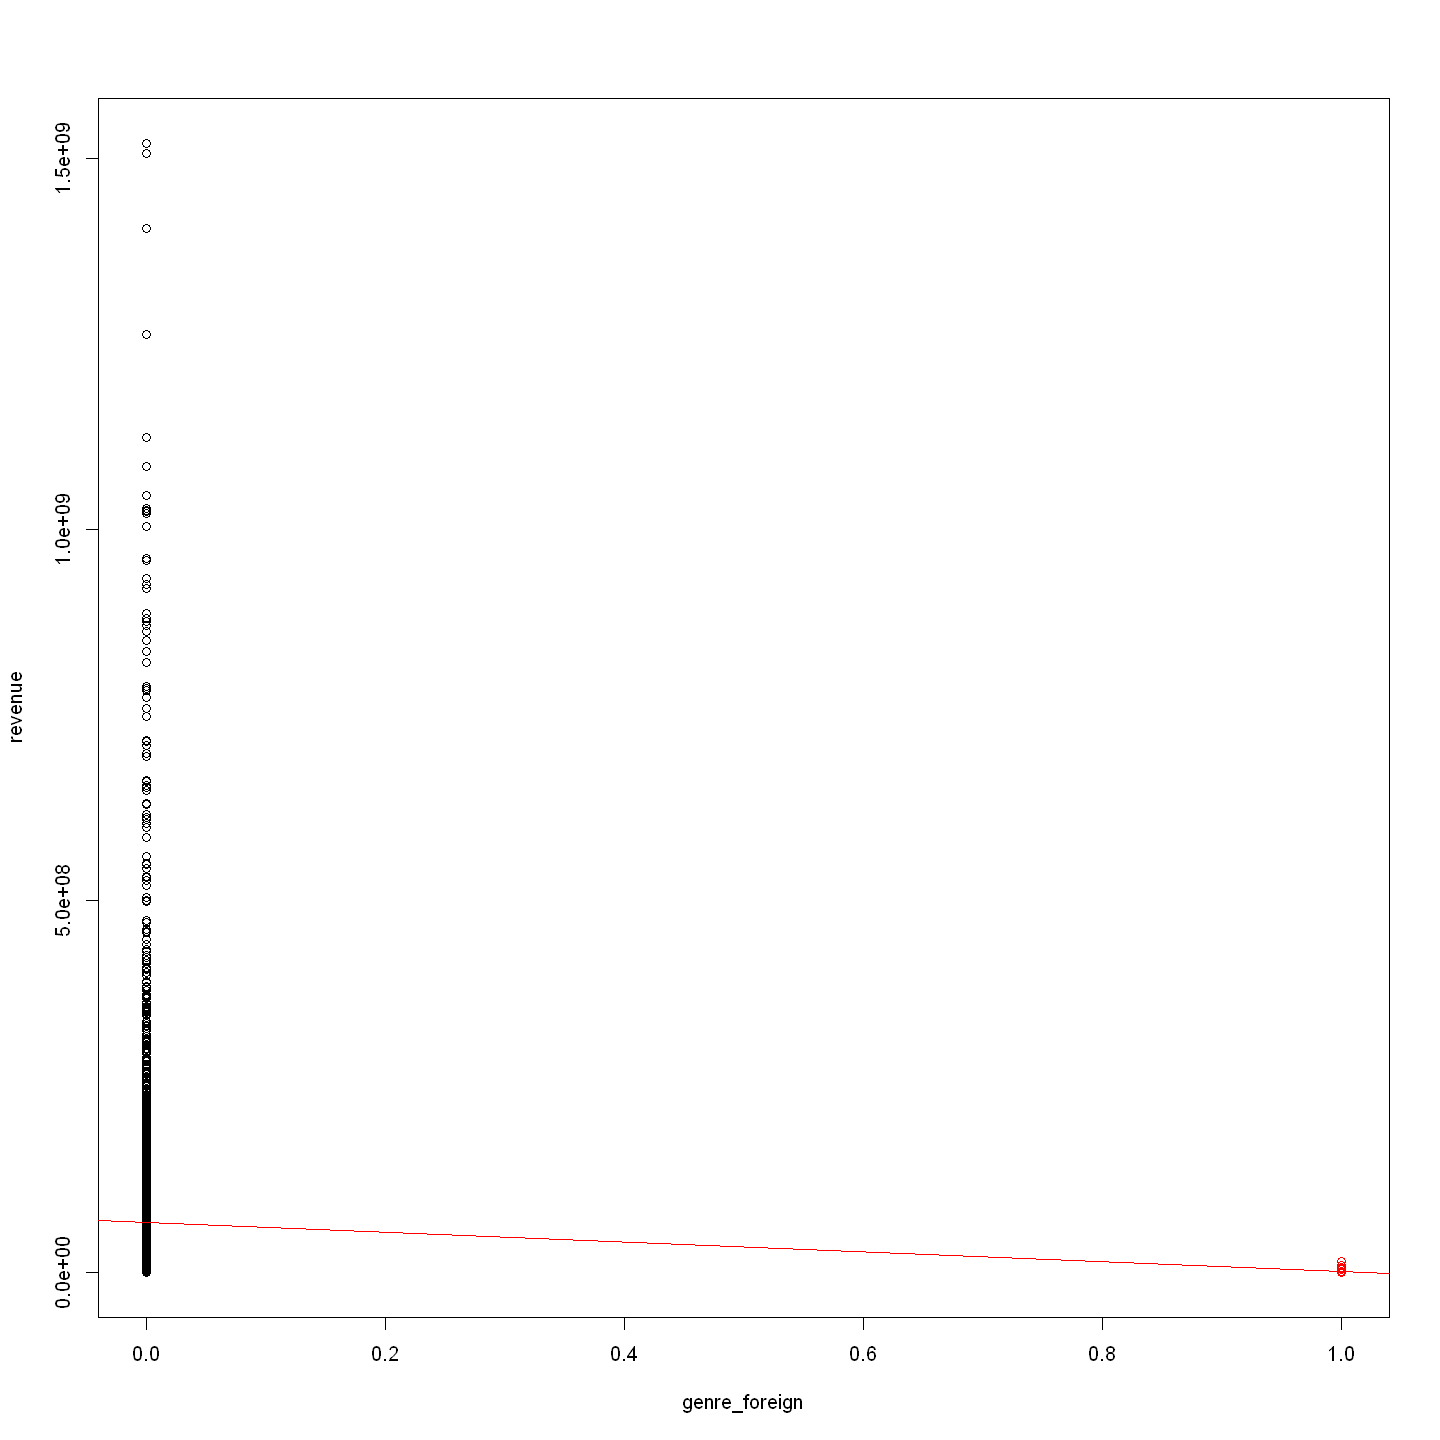

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


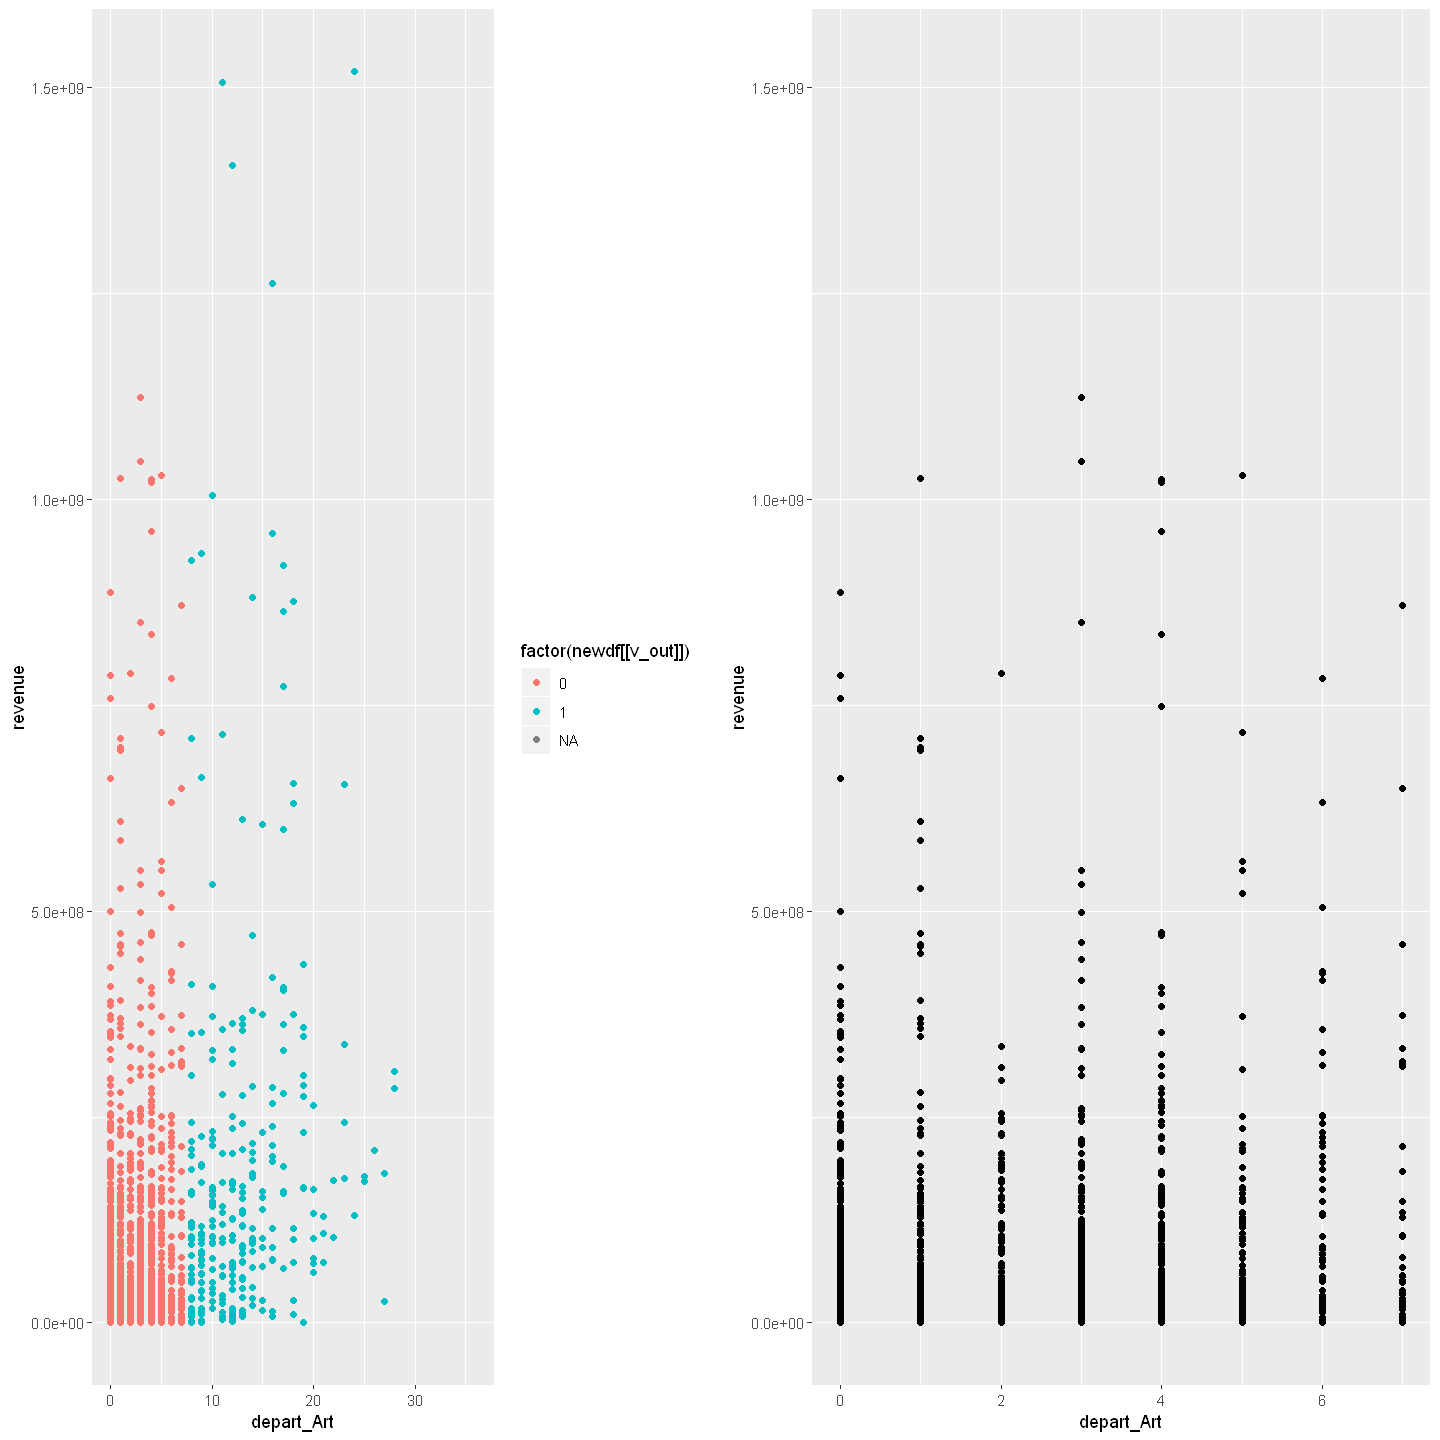

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4674 rows containing missing values (geom_point)."


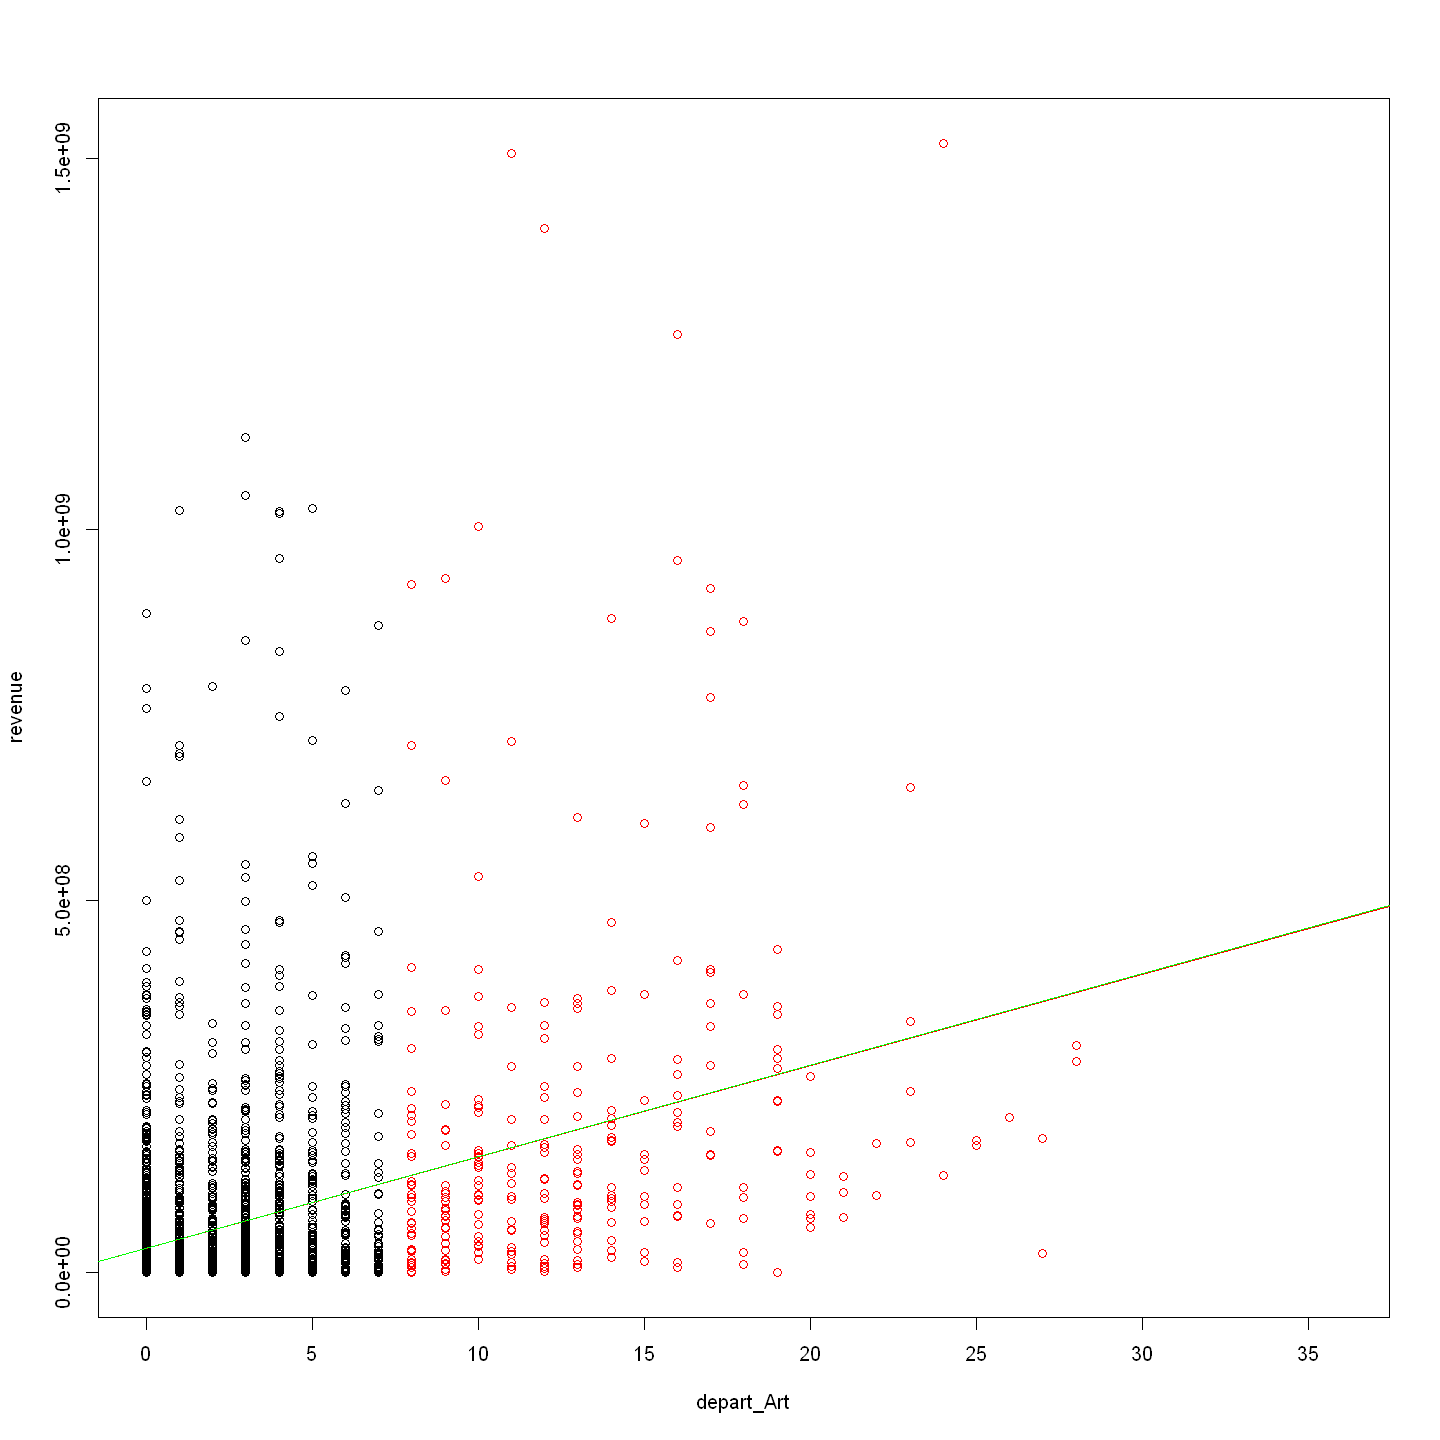

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


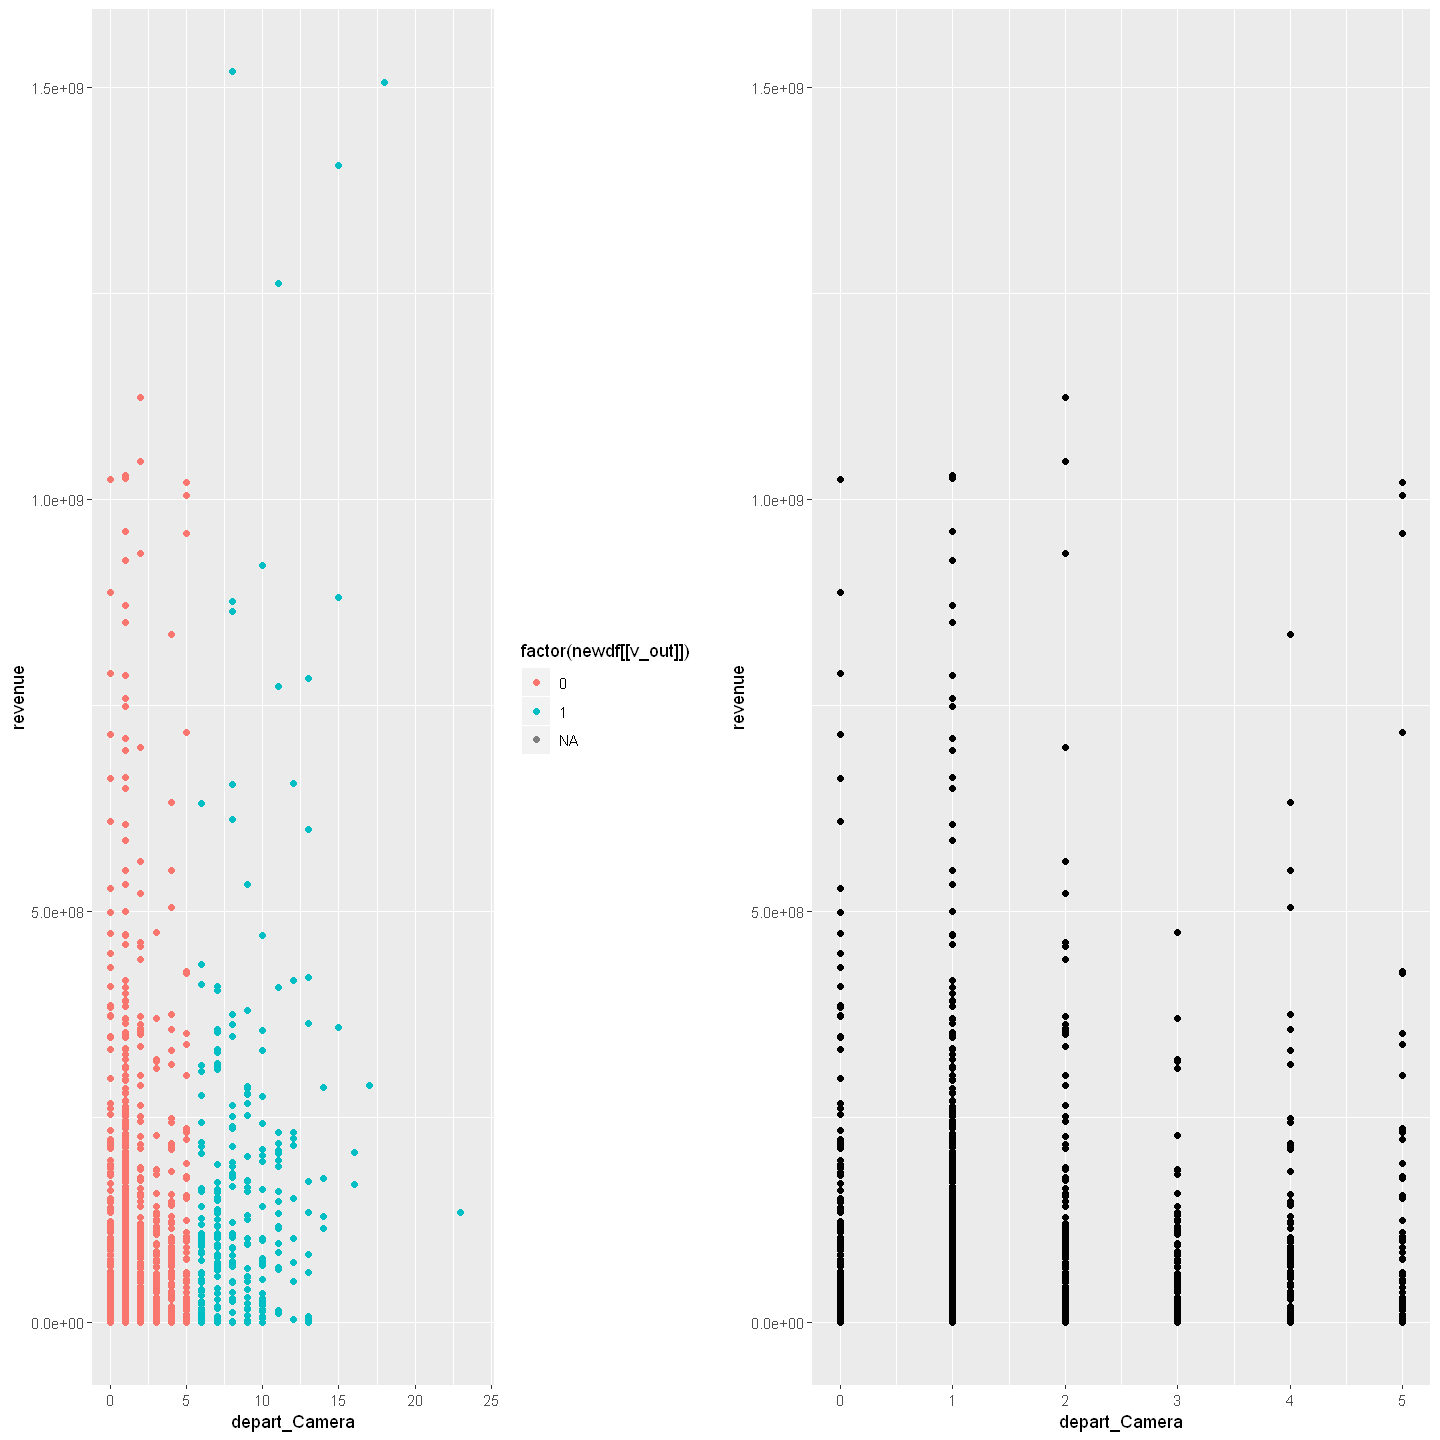

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4779 rows containing missing values (geom_point)."


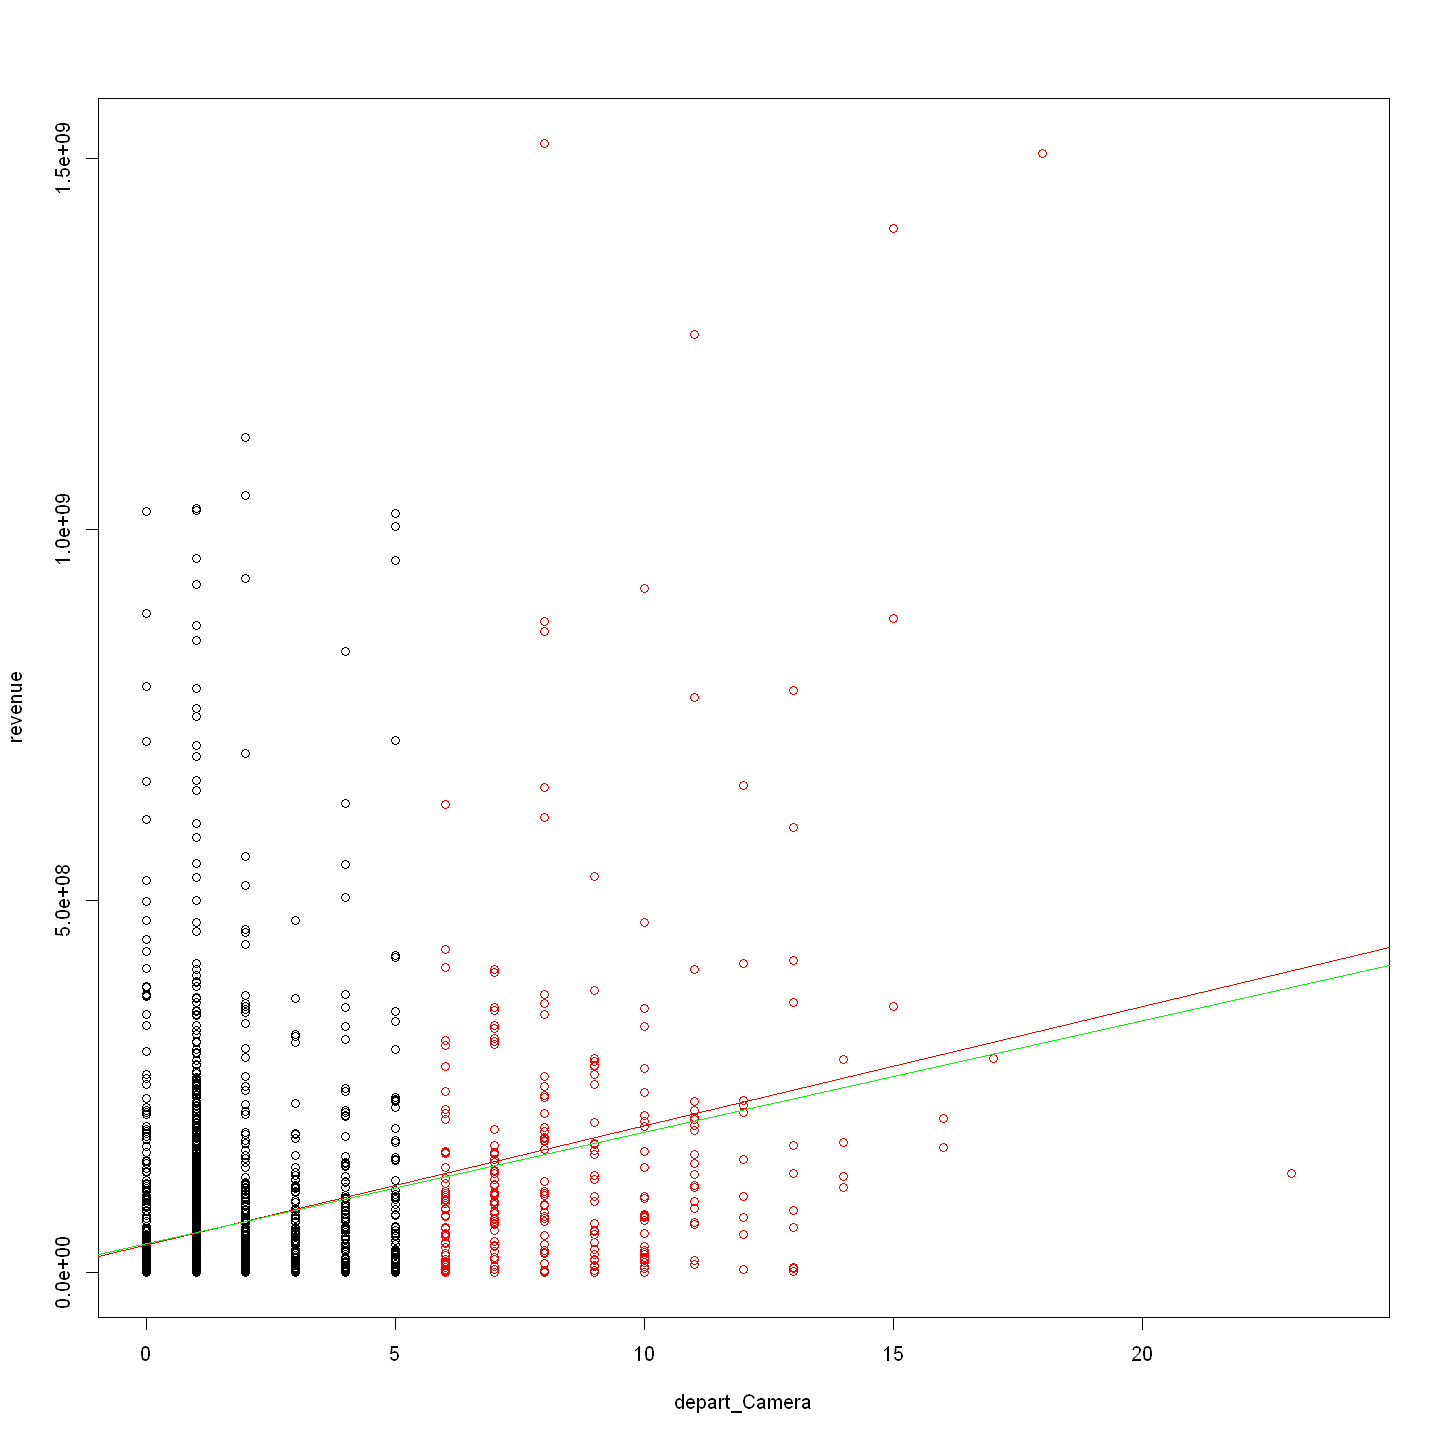

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


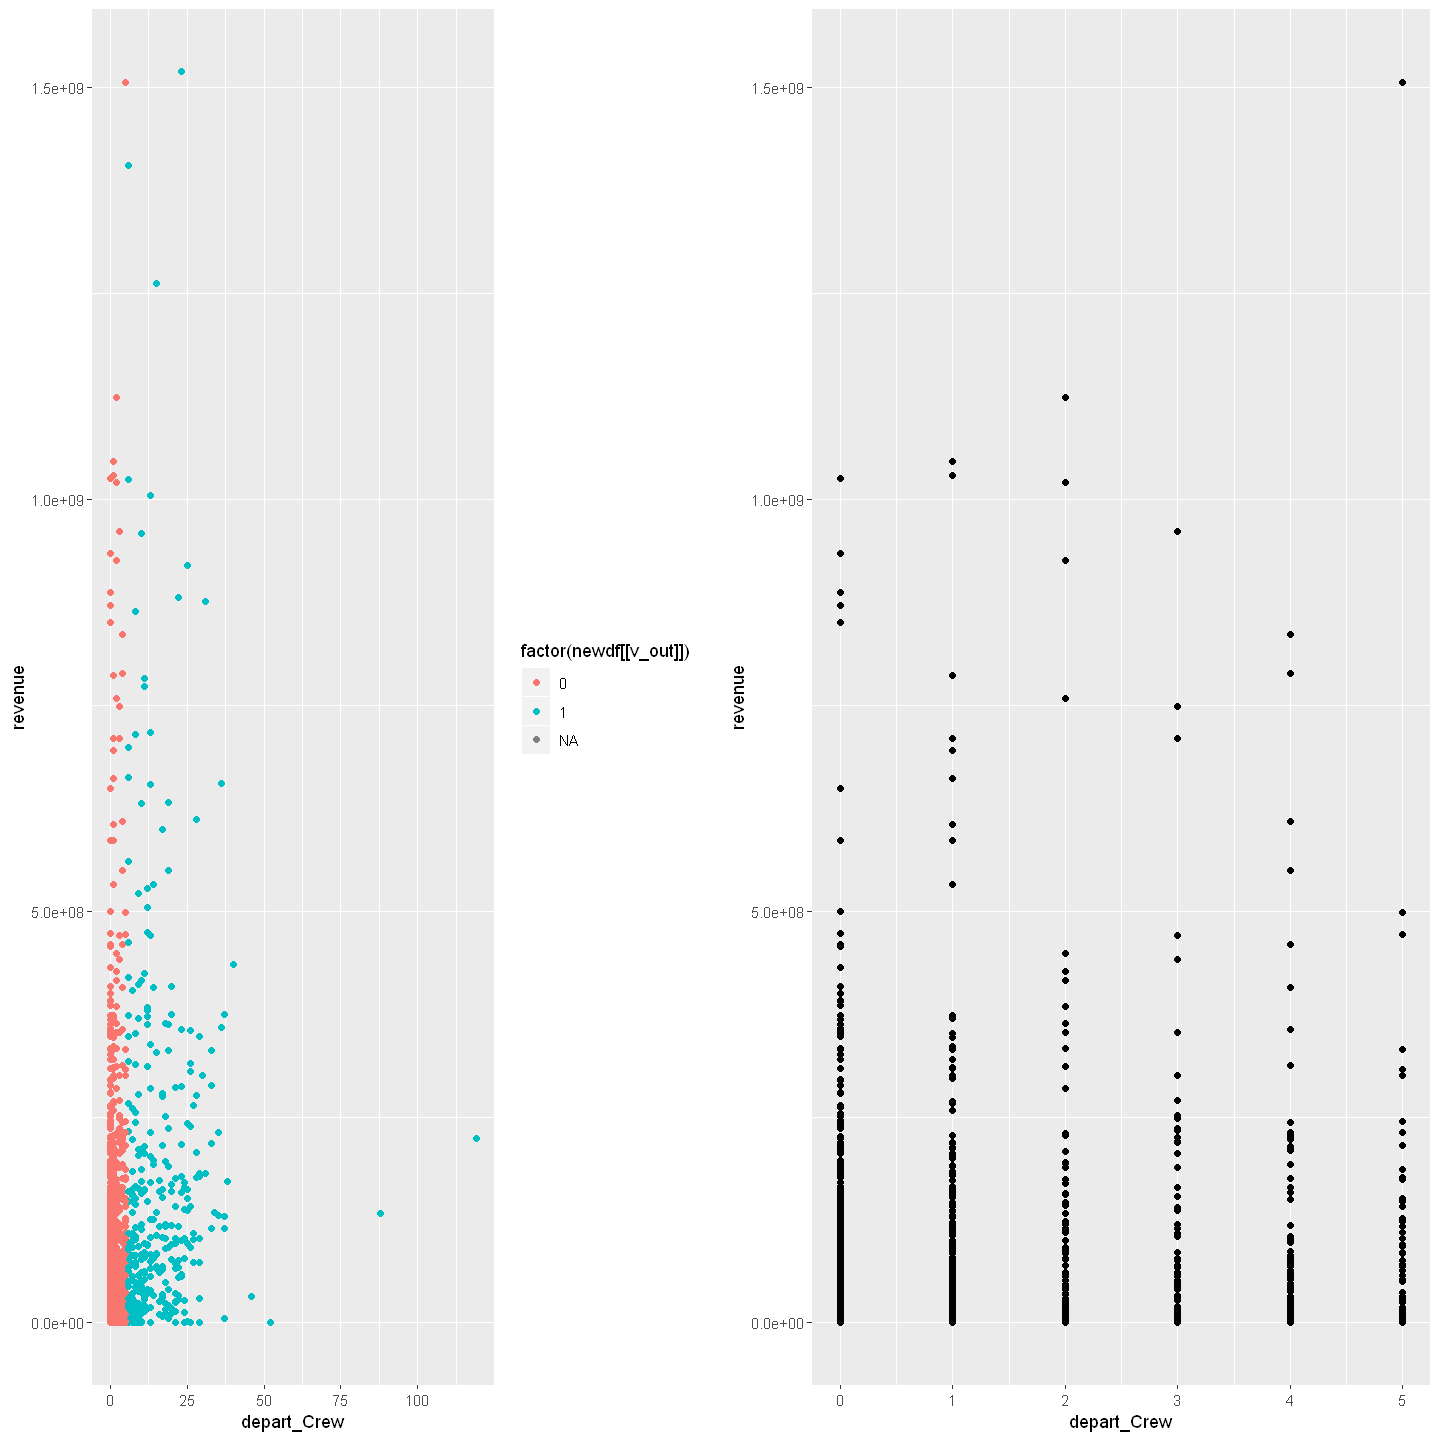

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4799 rows containing missing values (geom_point)."


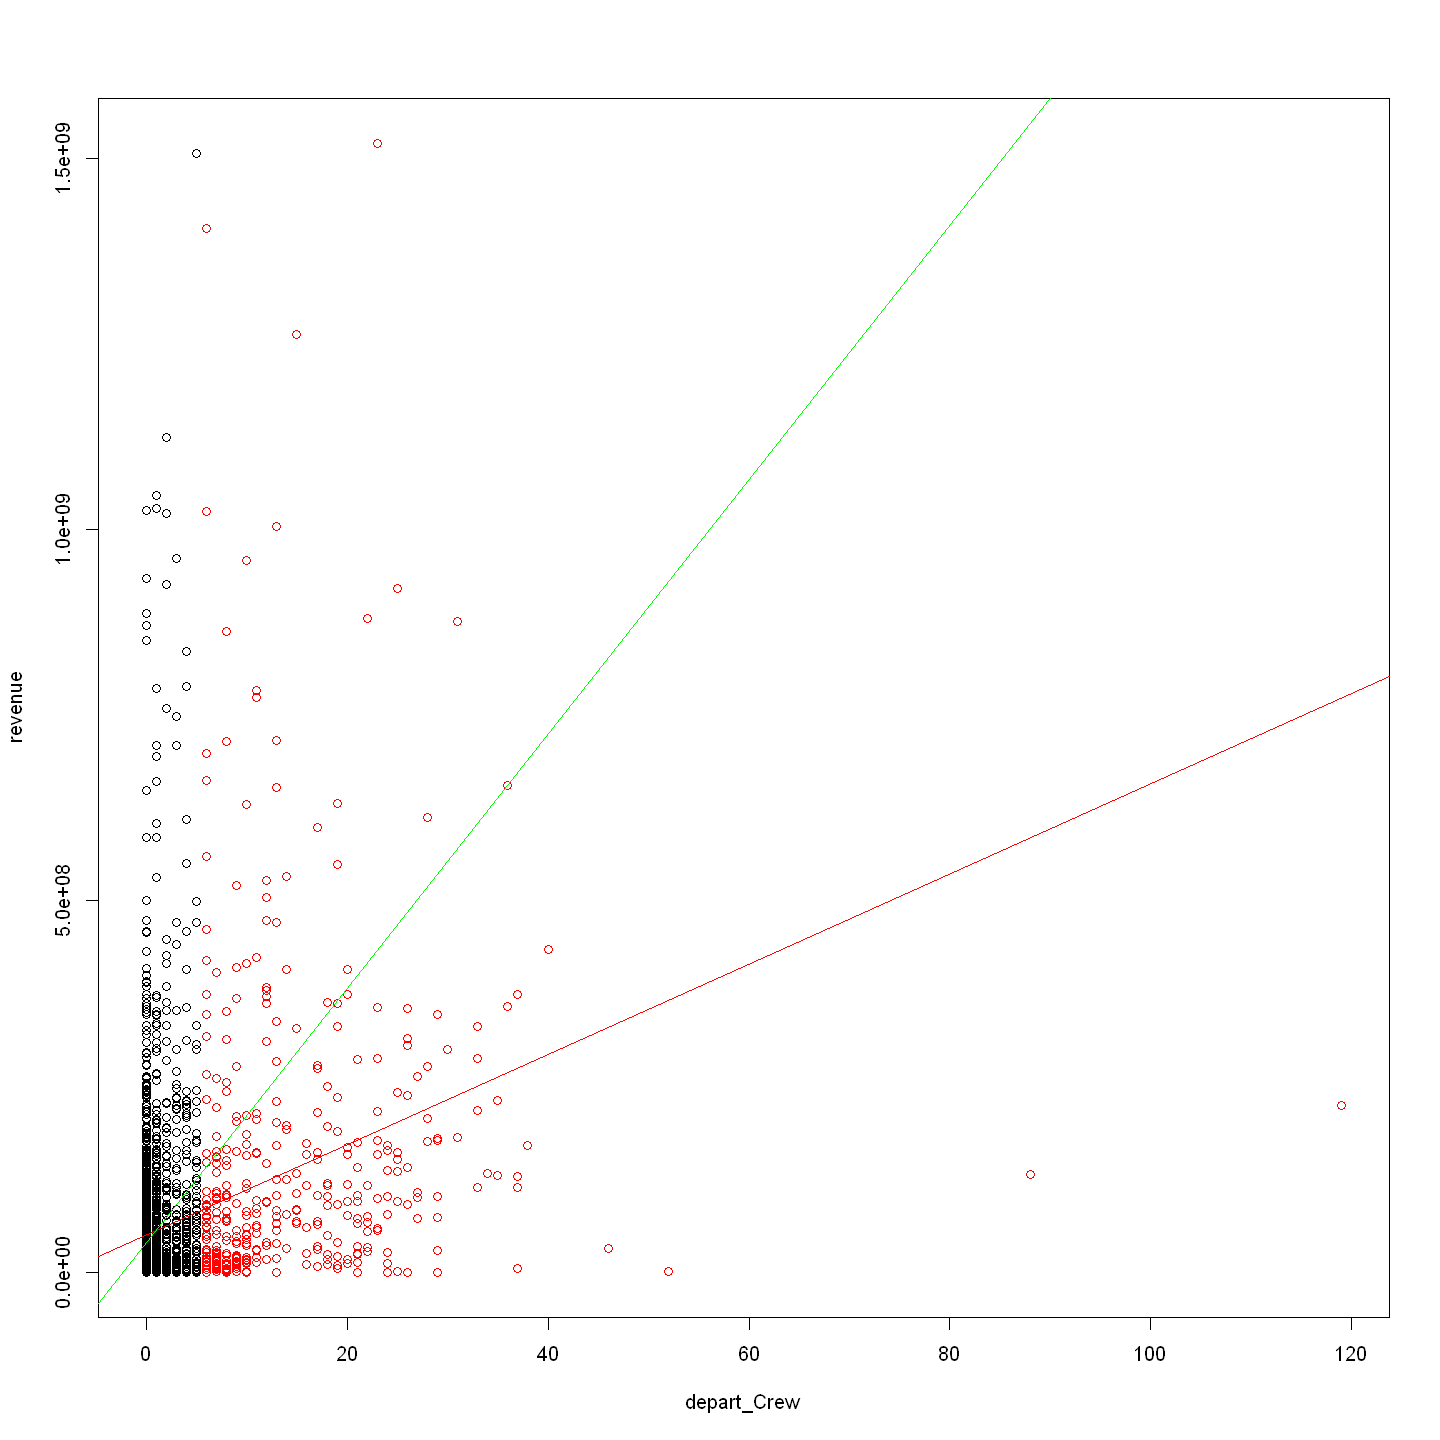

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


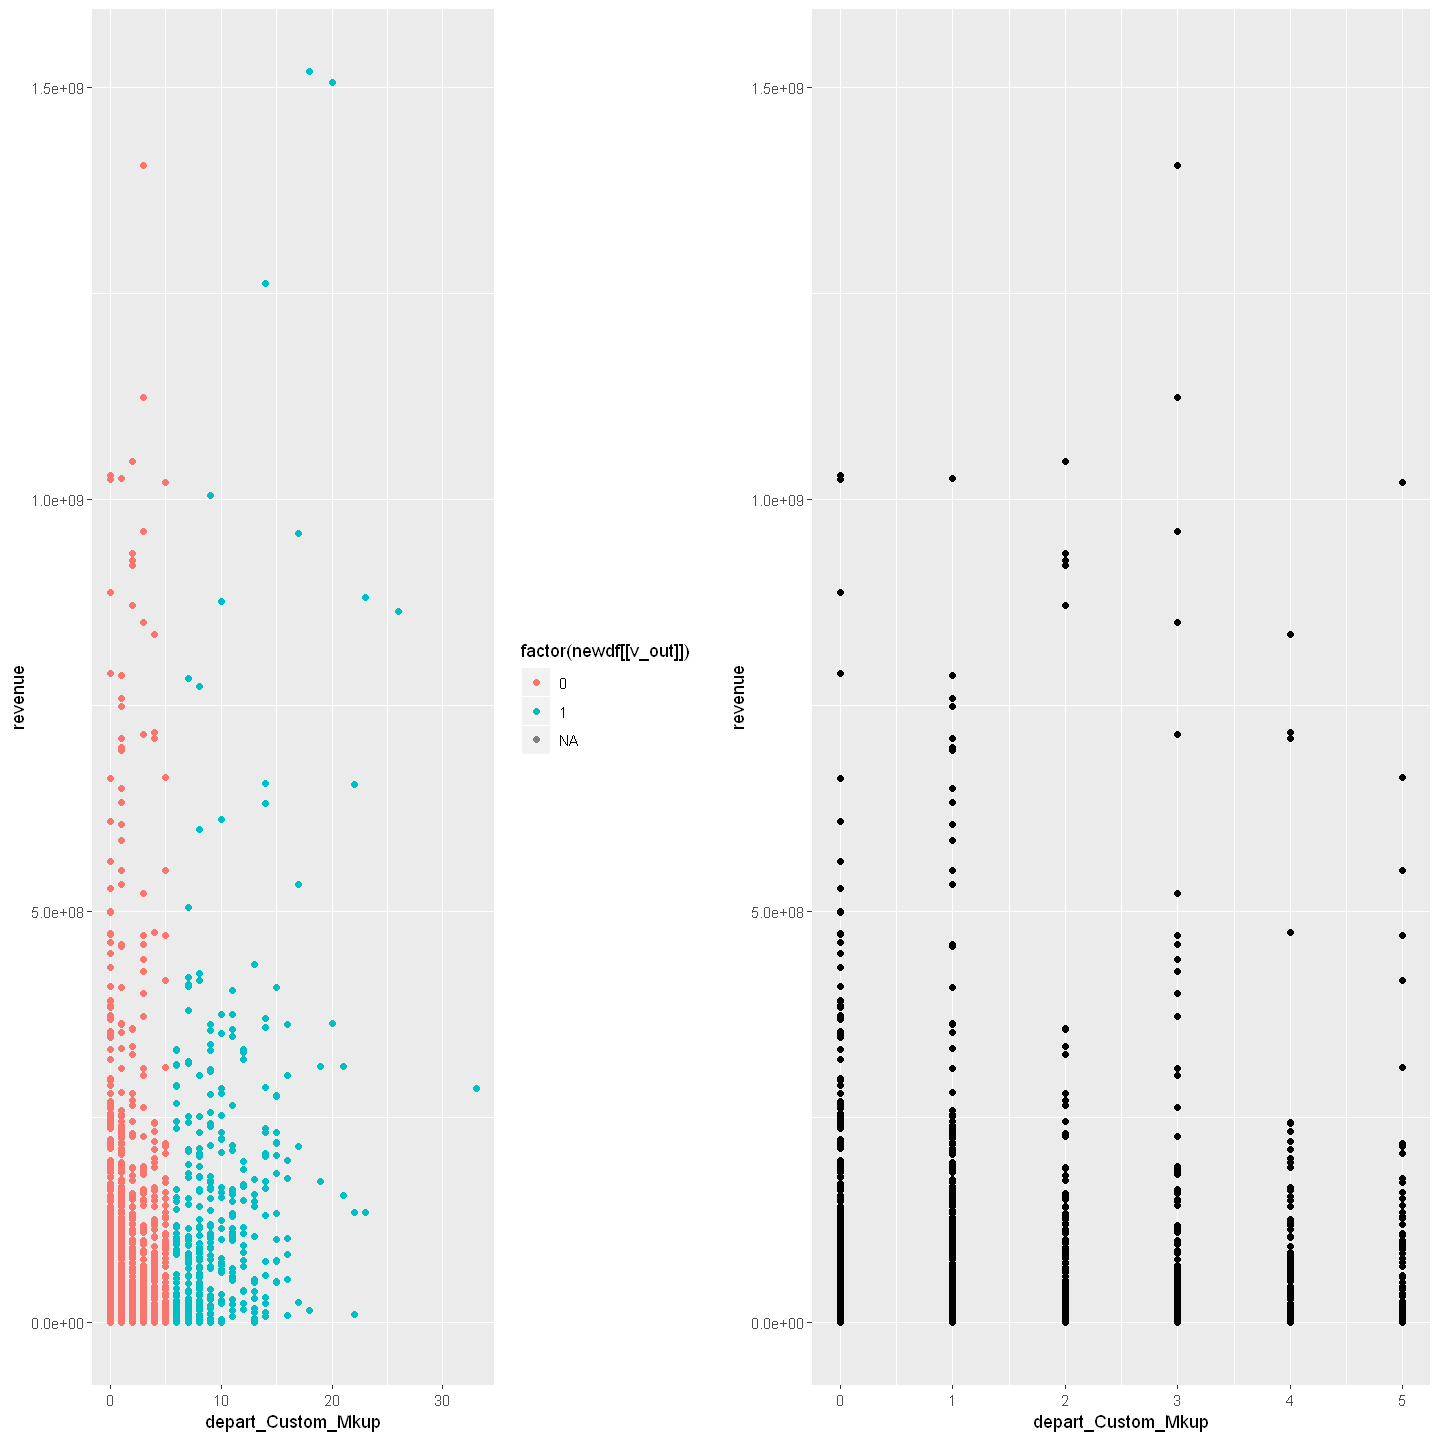

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4597 rows containing missing values (geom_point)."


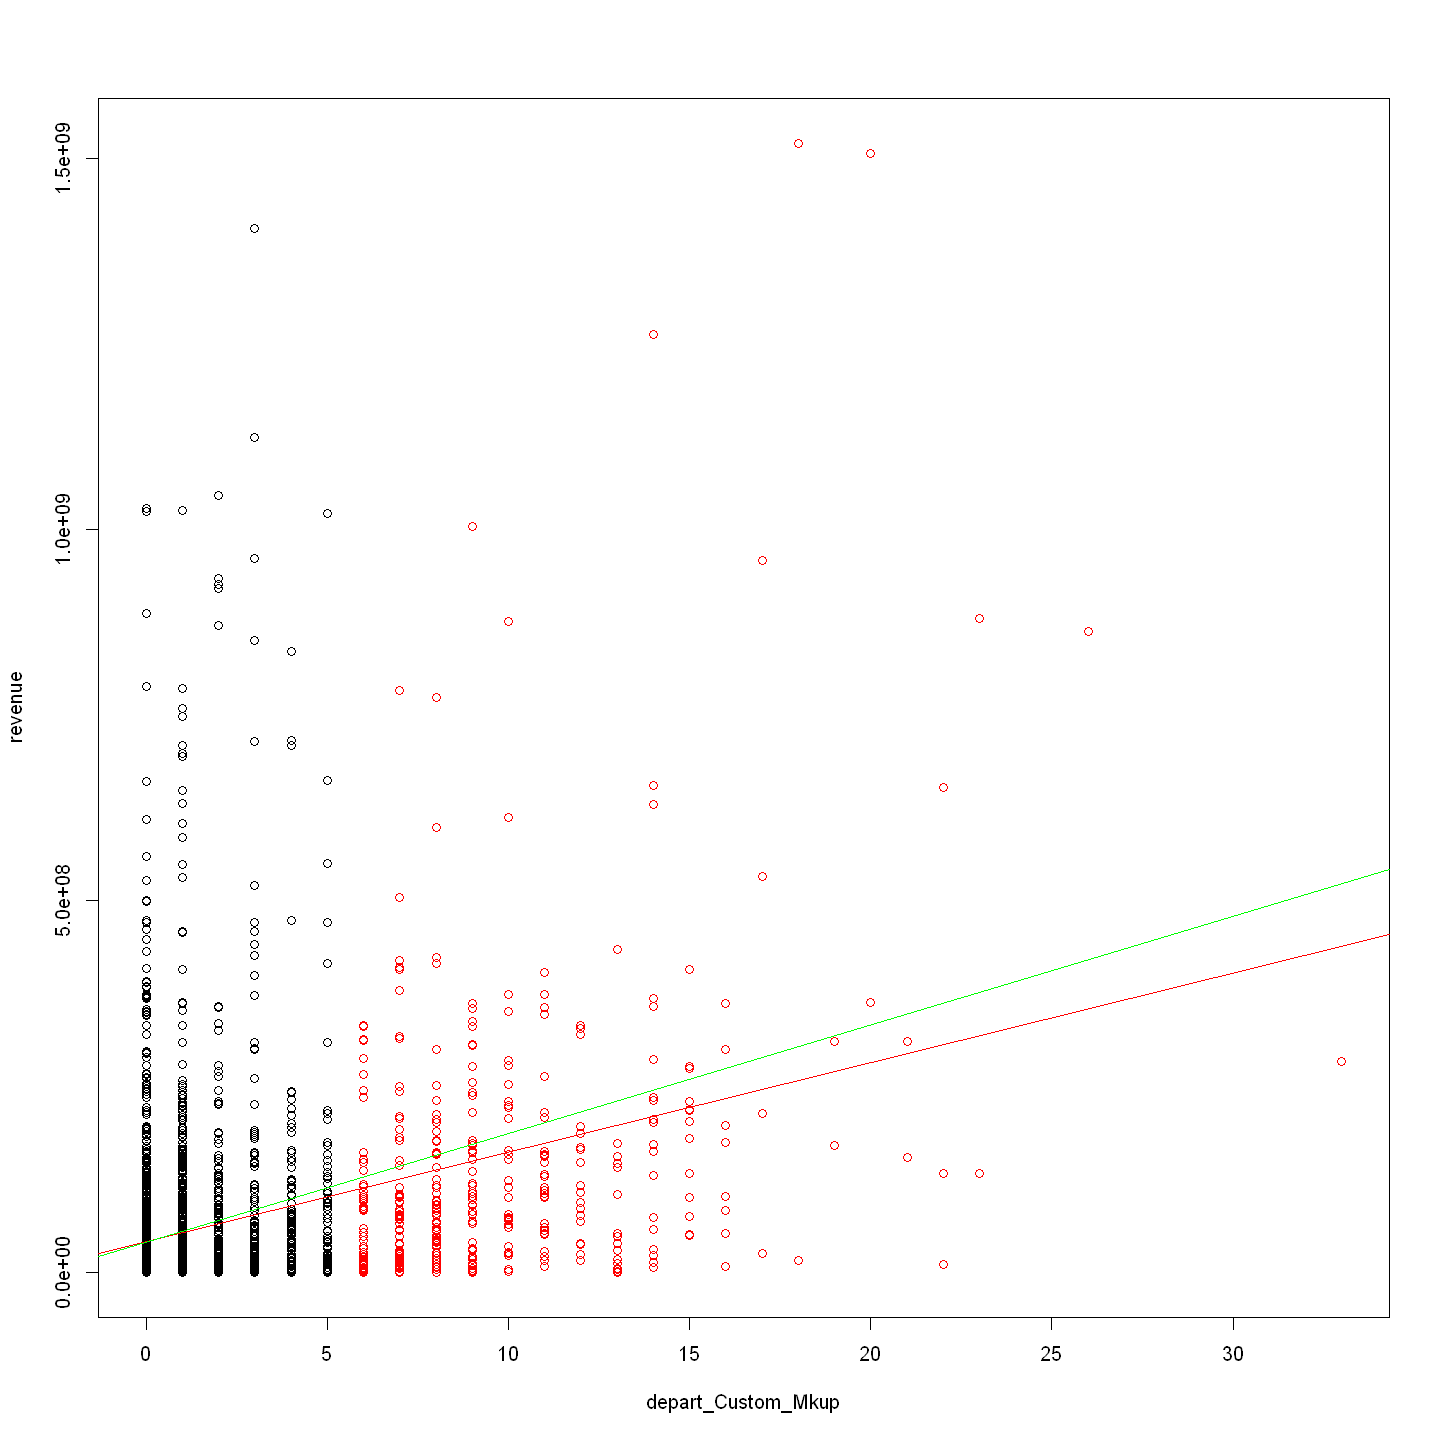

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


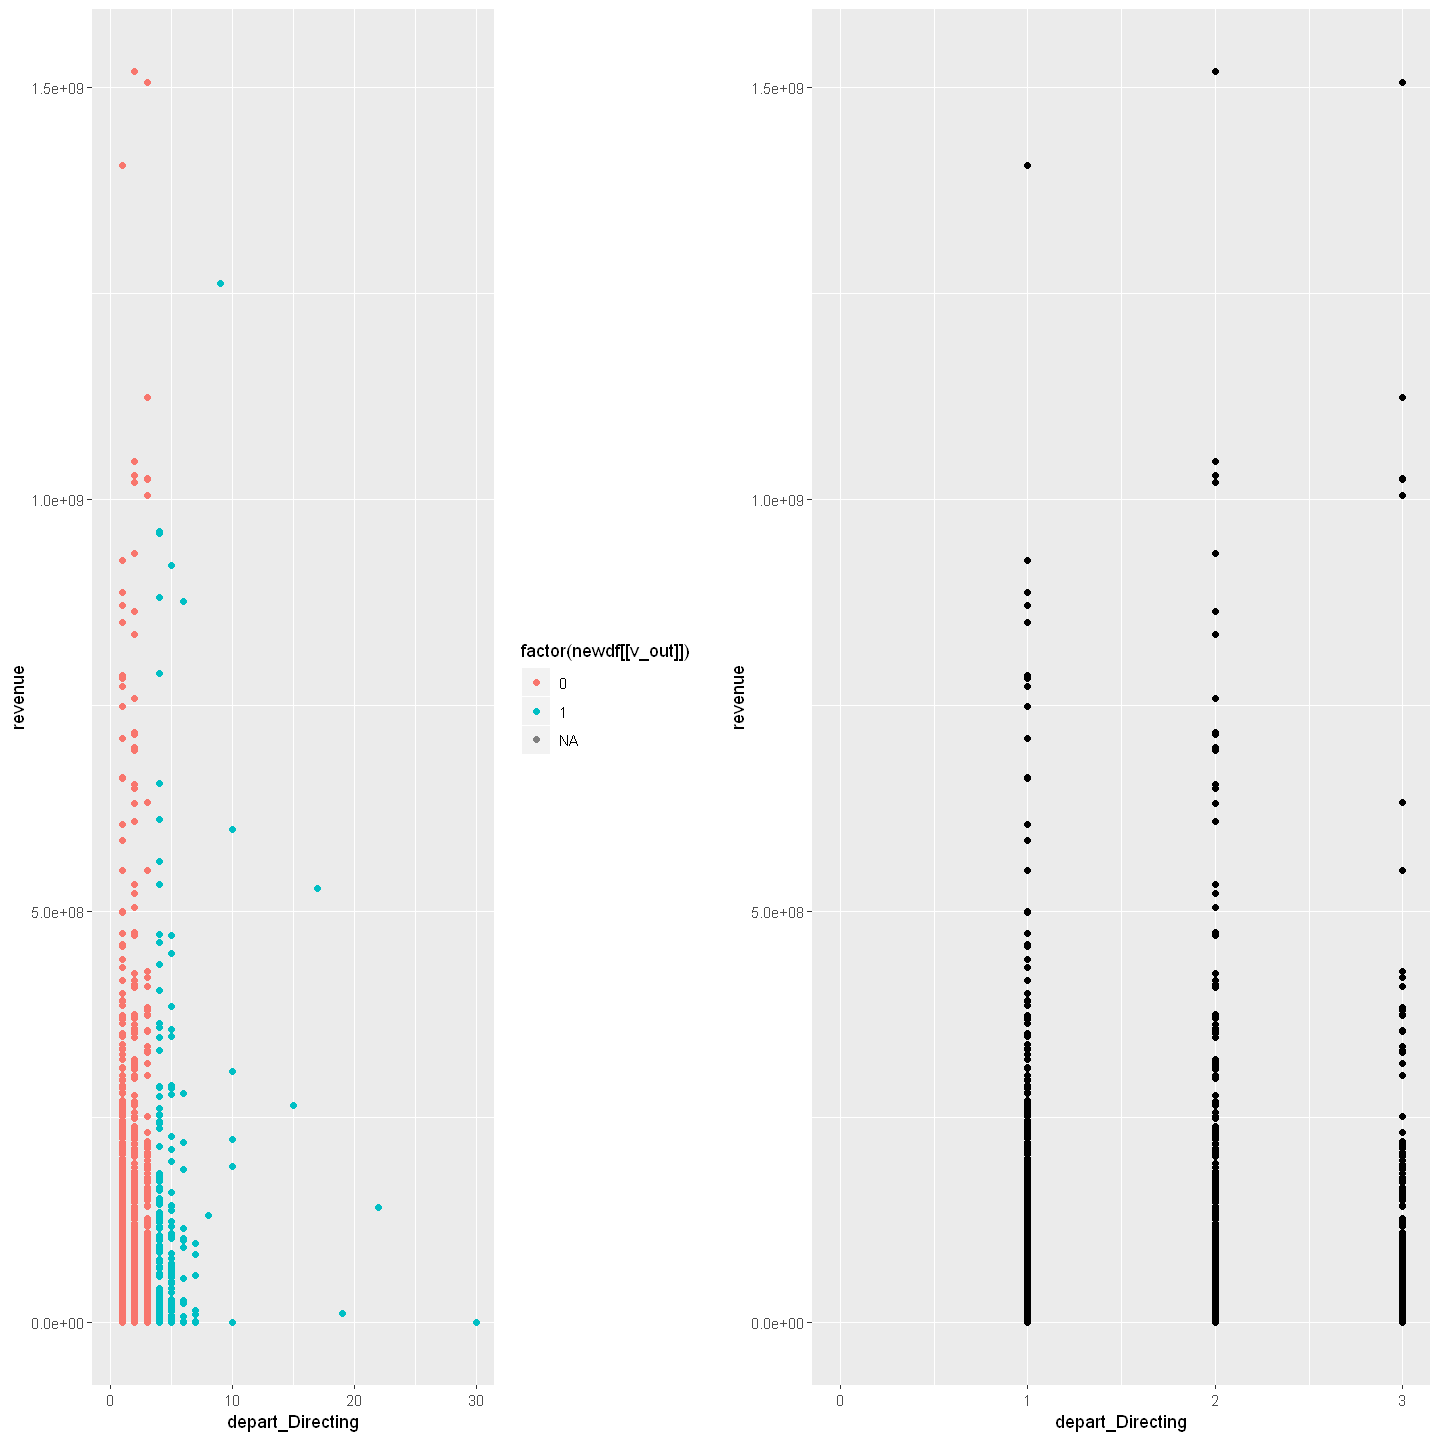

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4528 rows containing missing values (geom_point)."


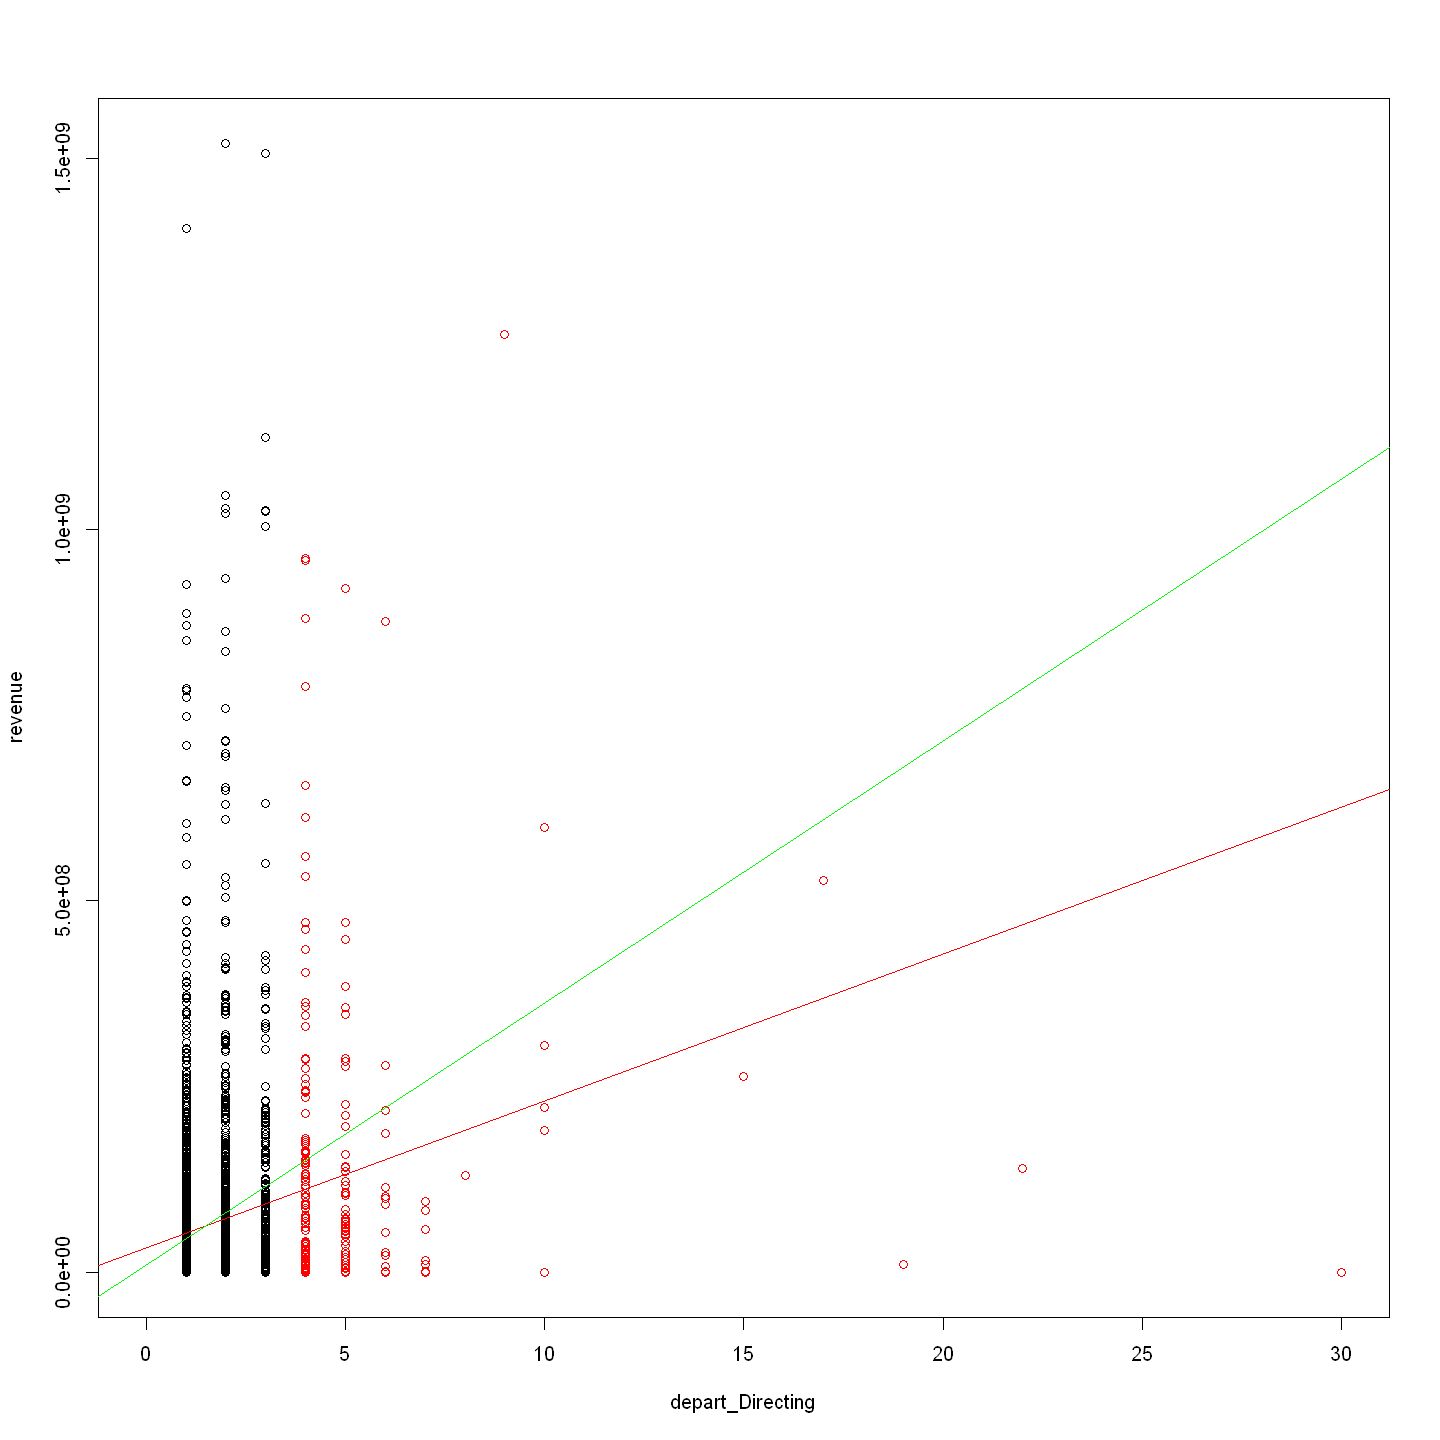

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


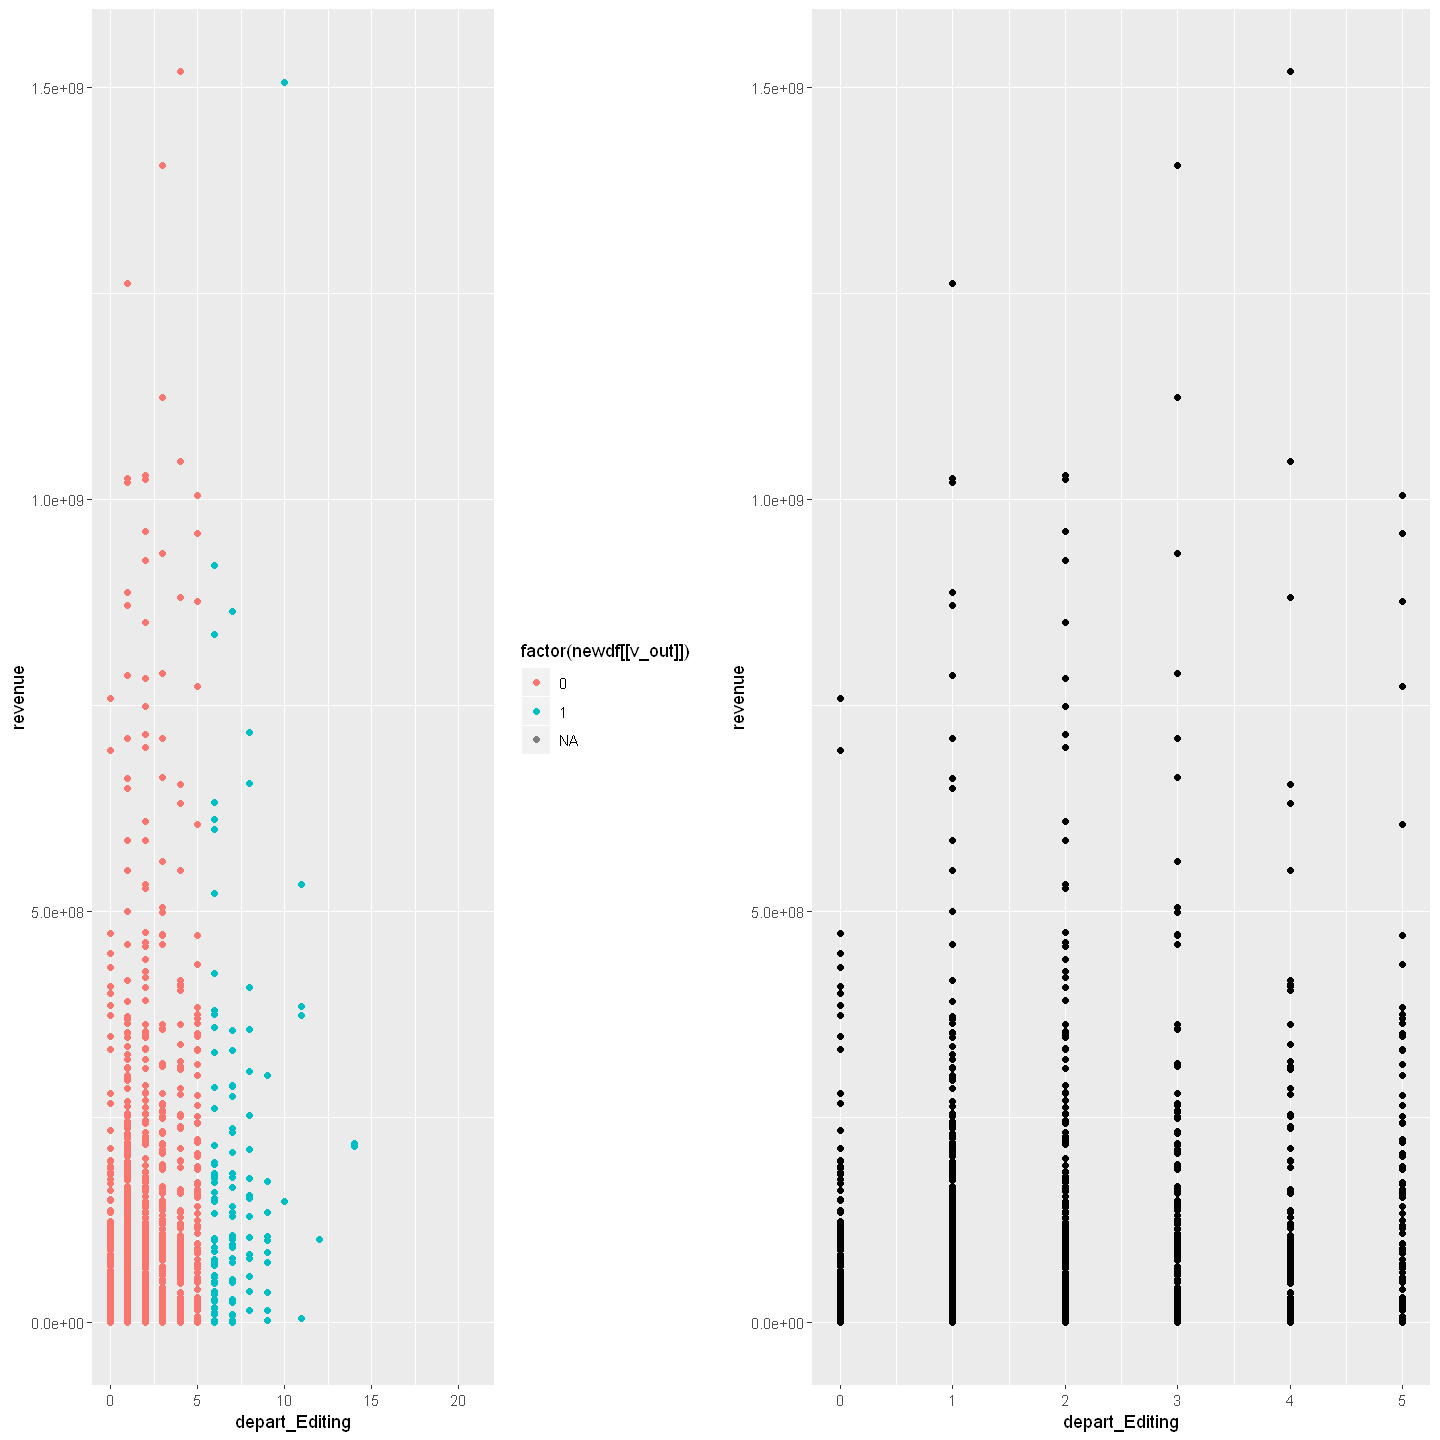

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4889 rows containing missing values (geom_point)."


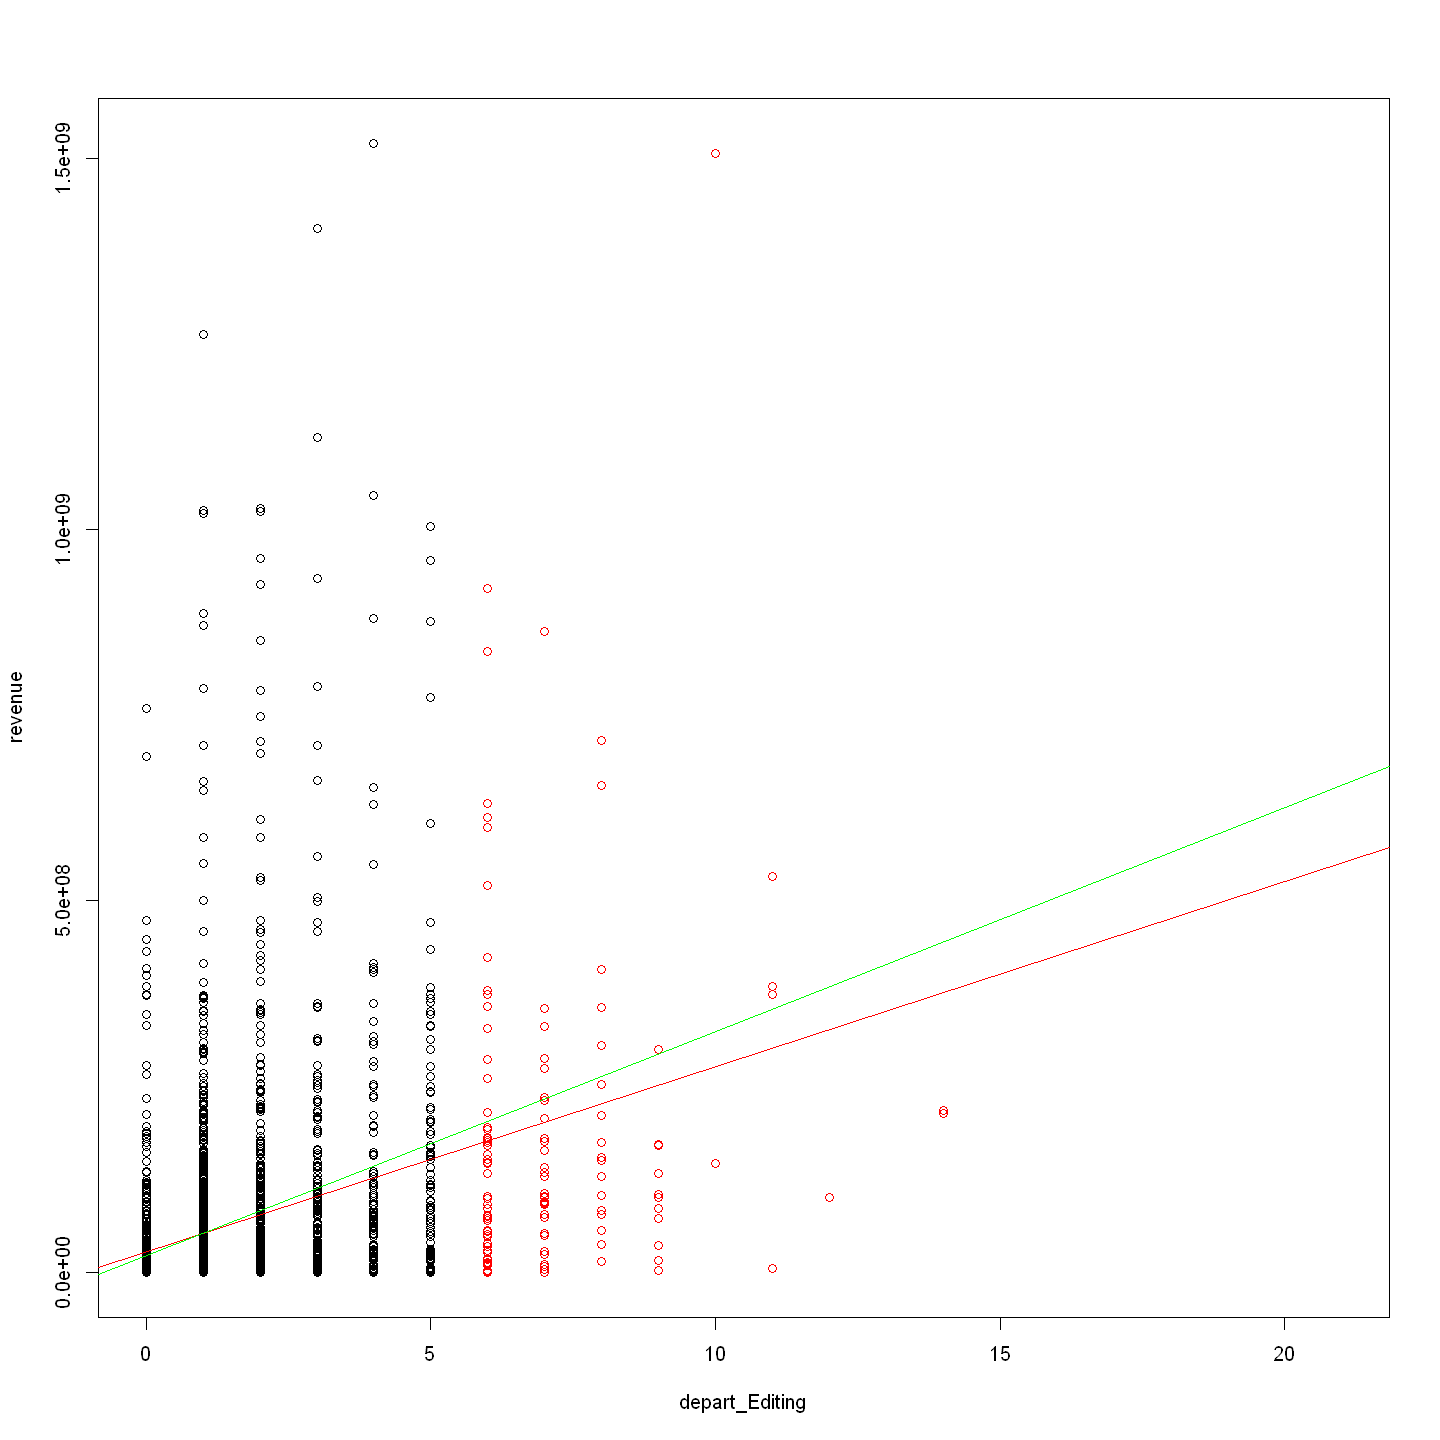

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


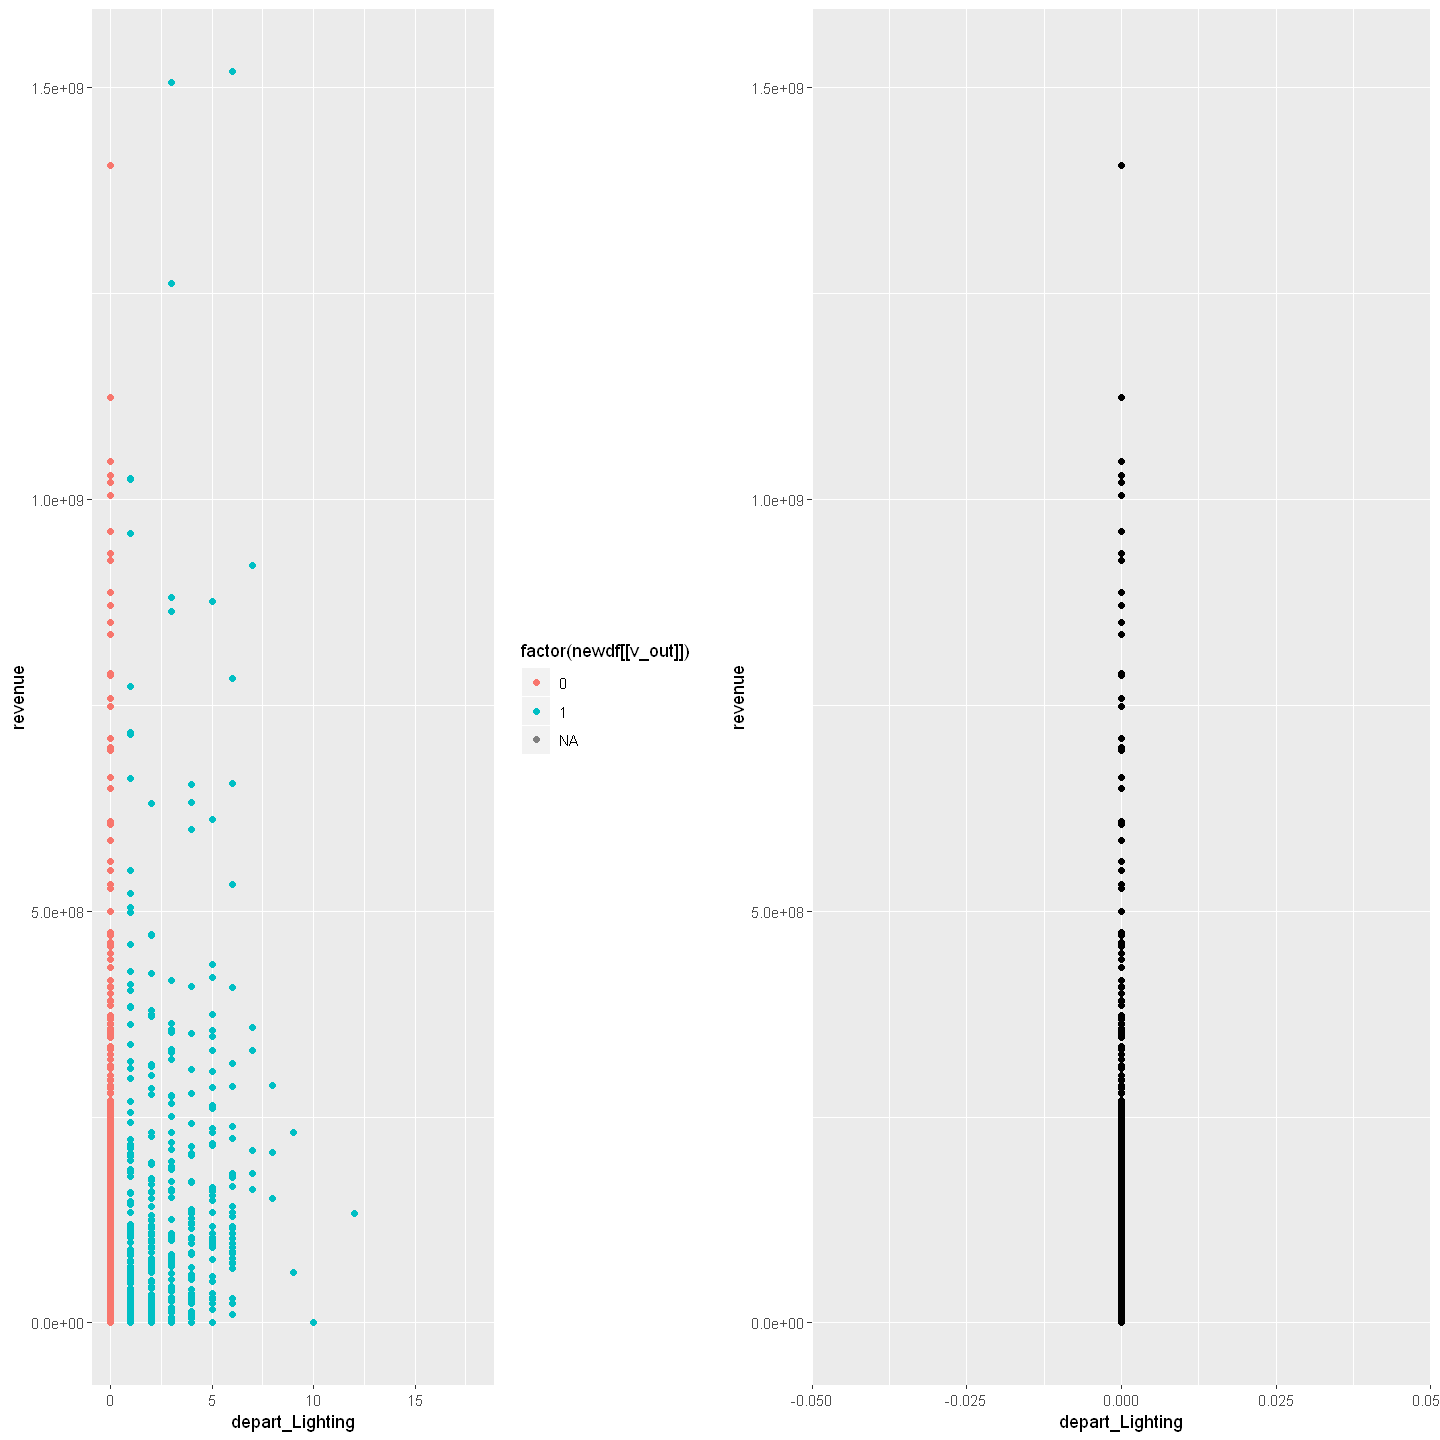

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4481 rows containing missing values (geom_point)."


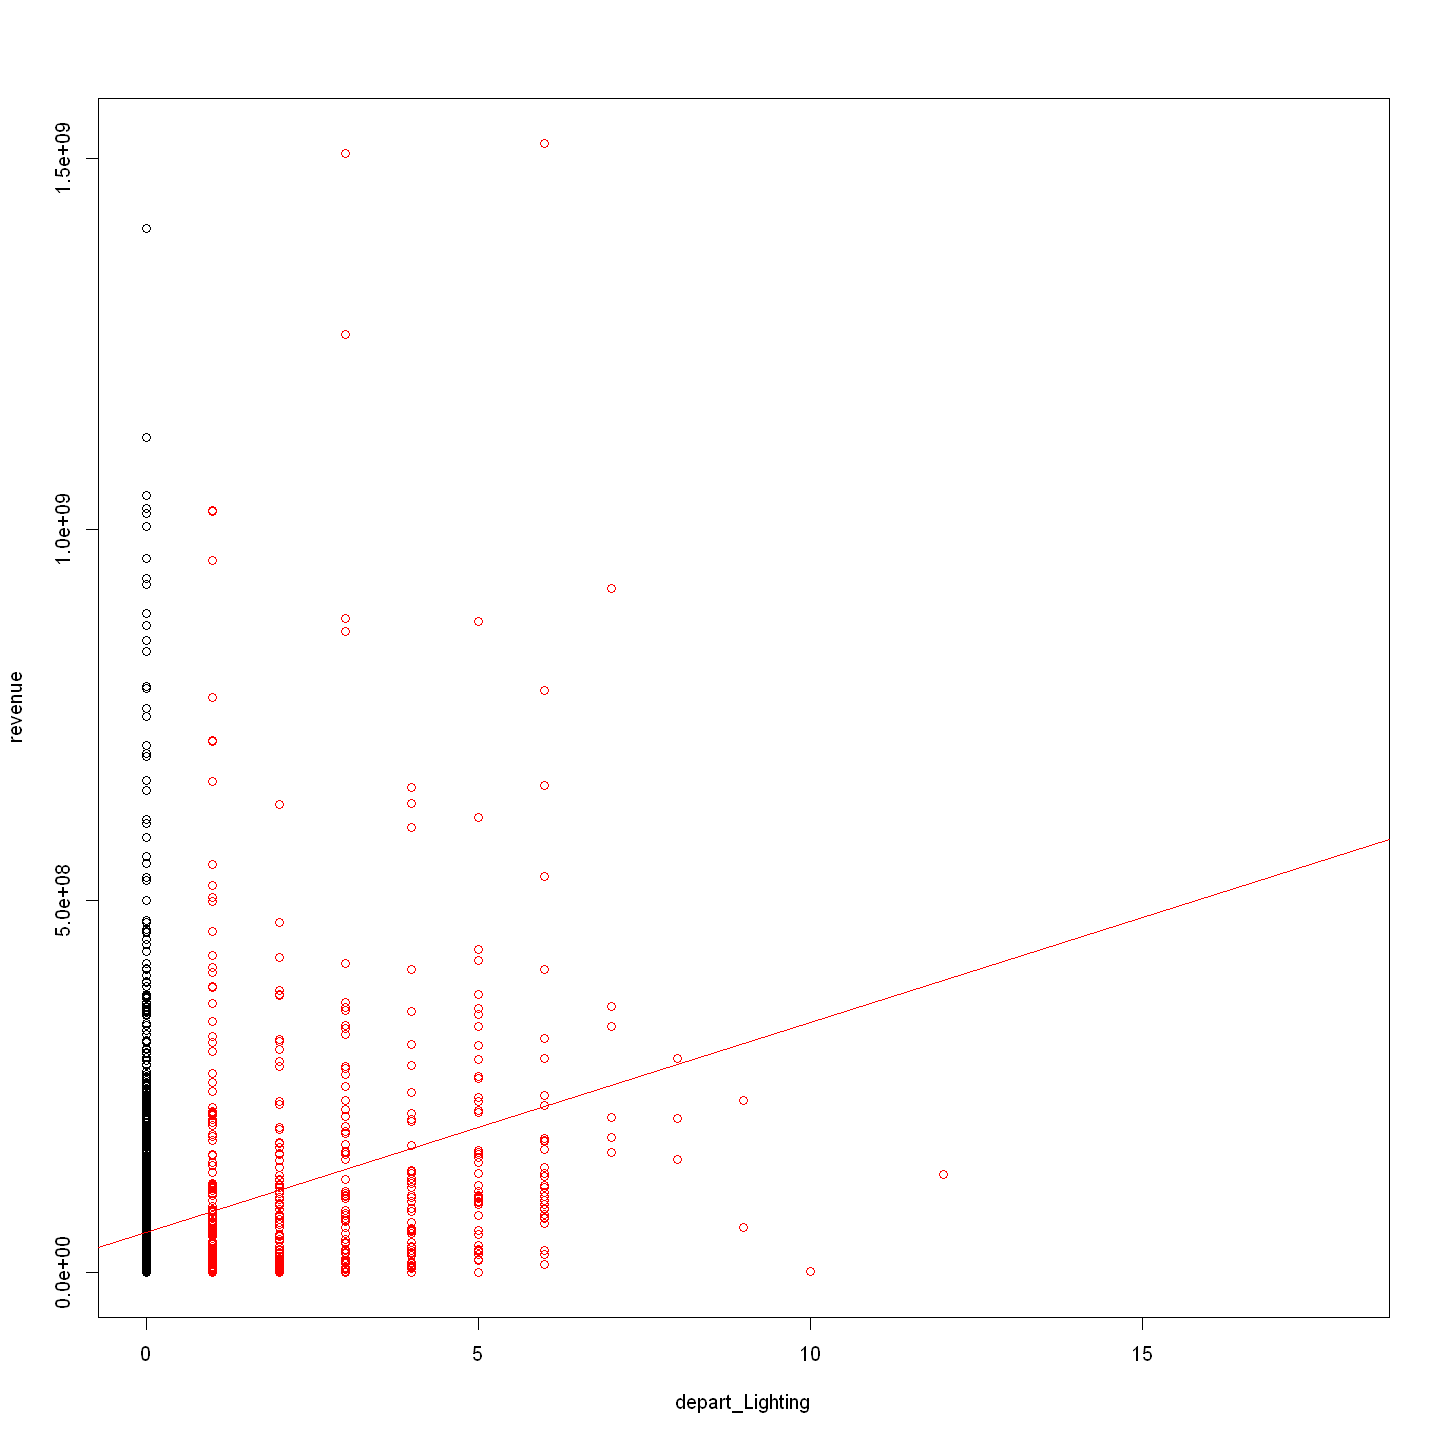

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


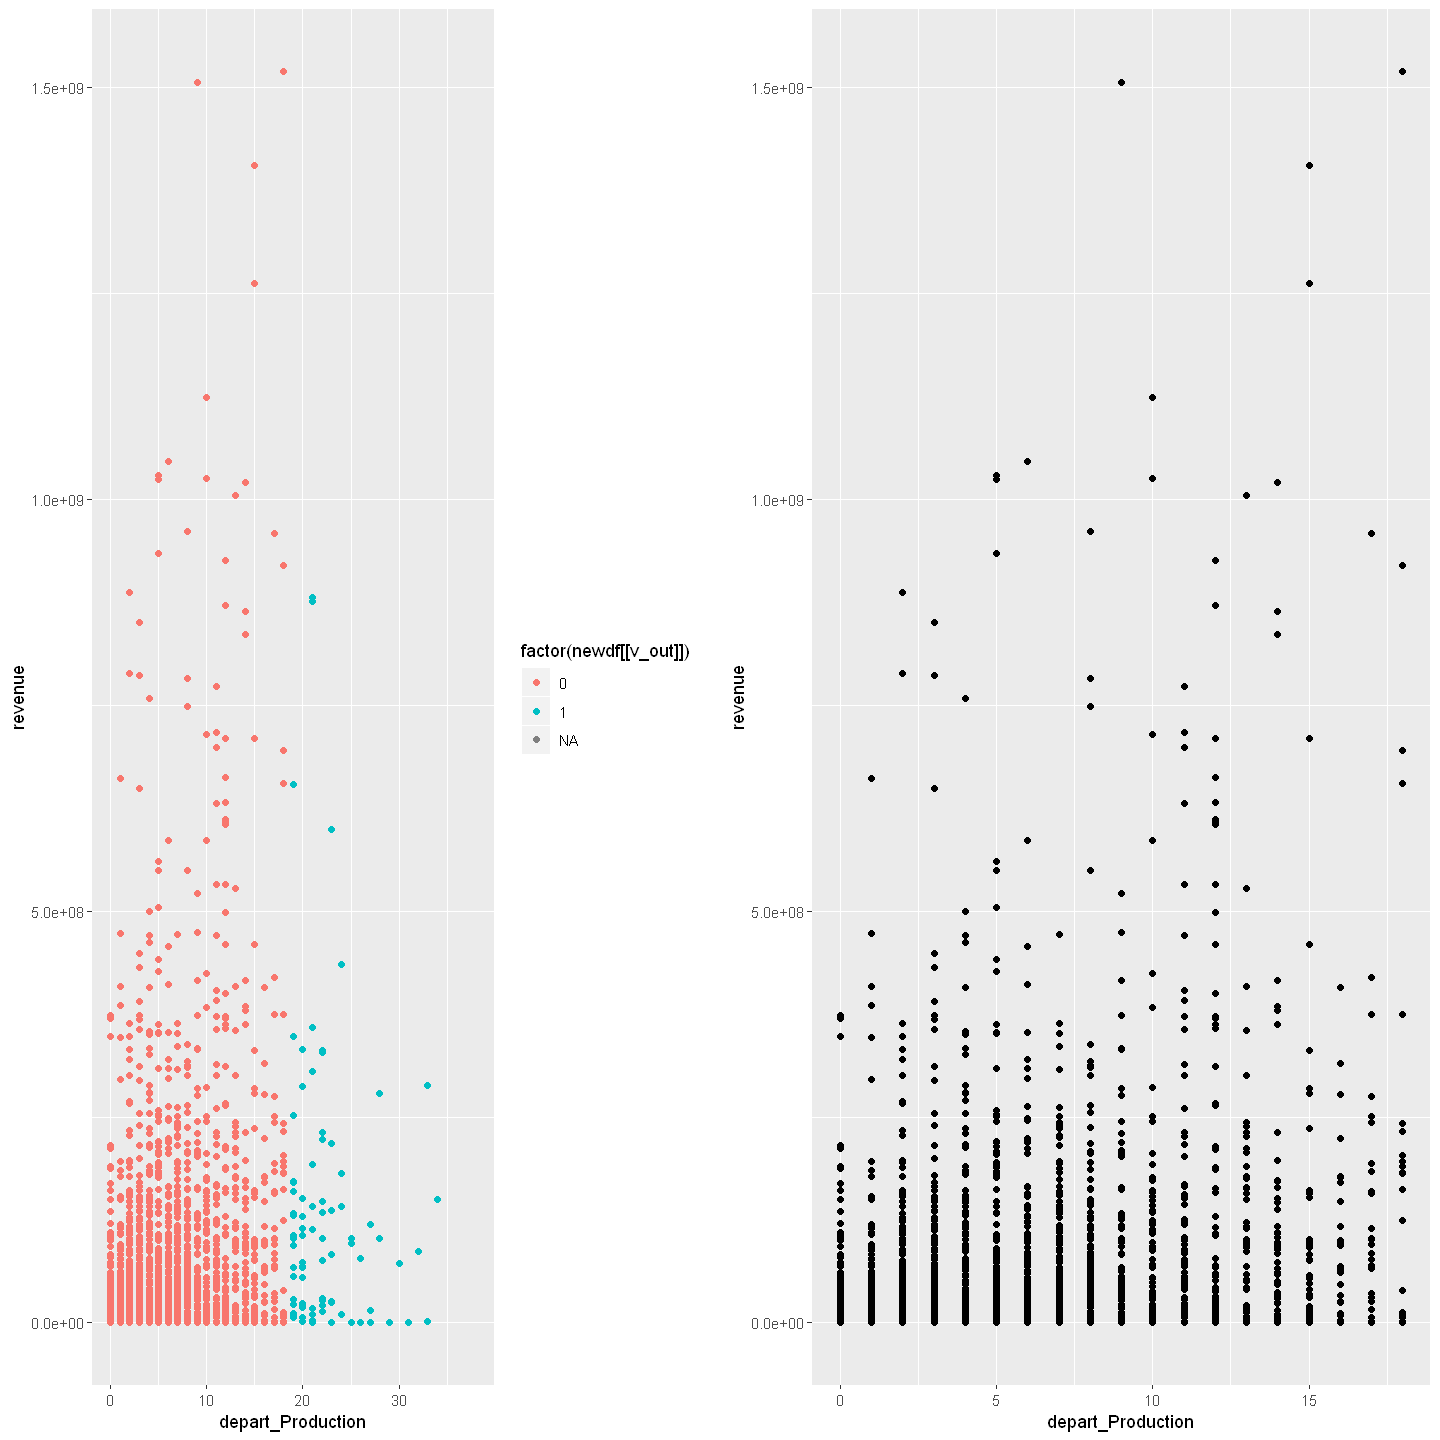

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4928 rows containing missing values (geom_point)."


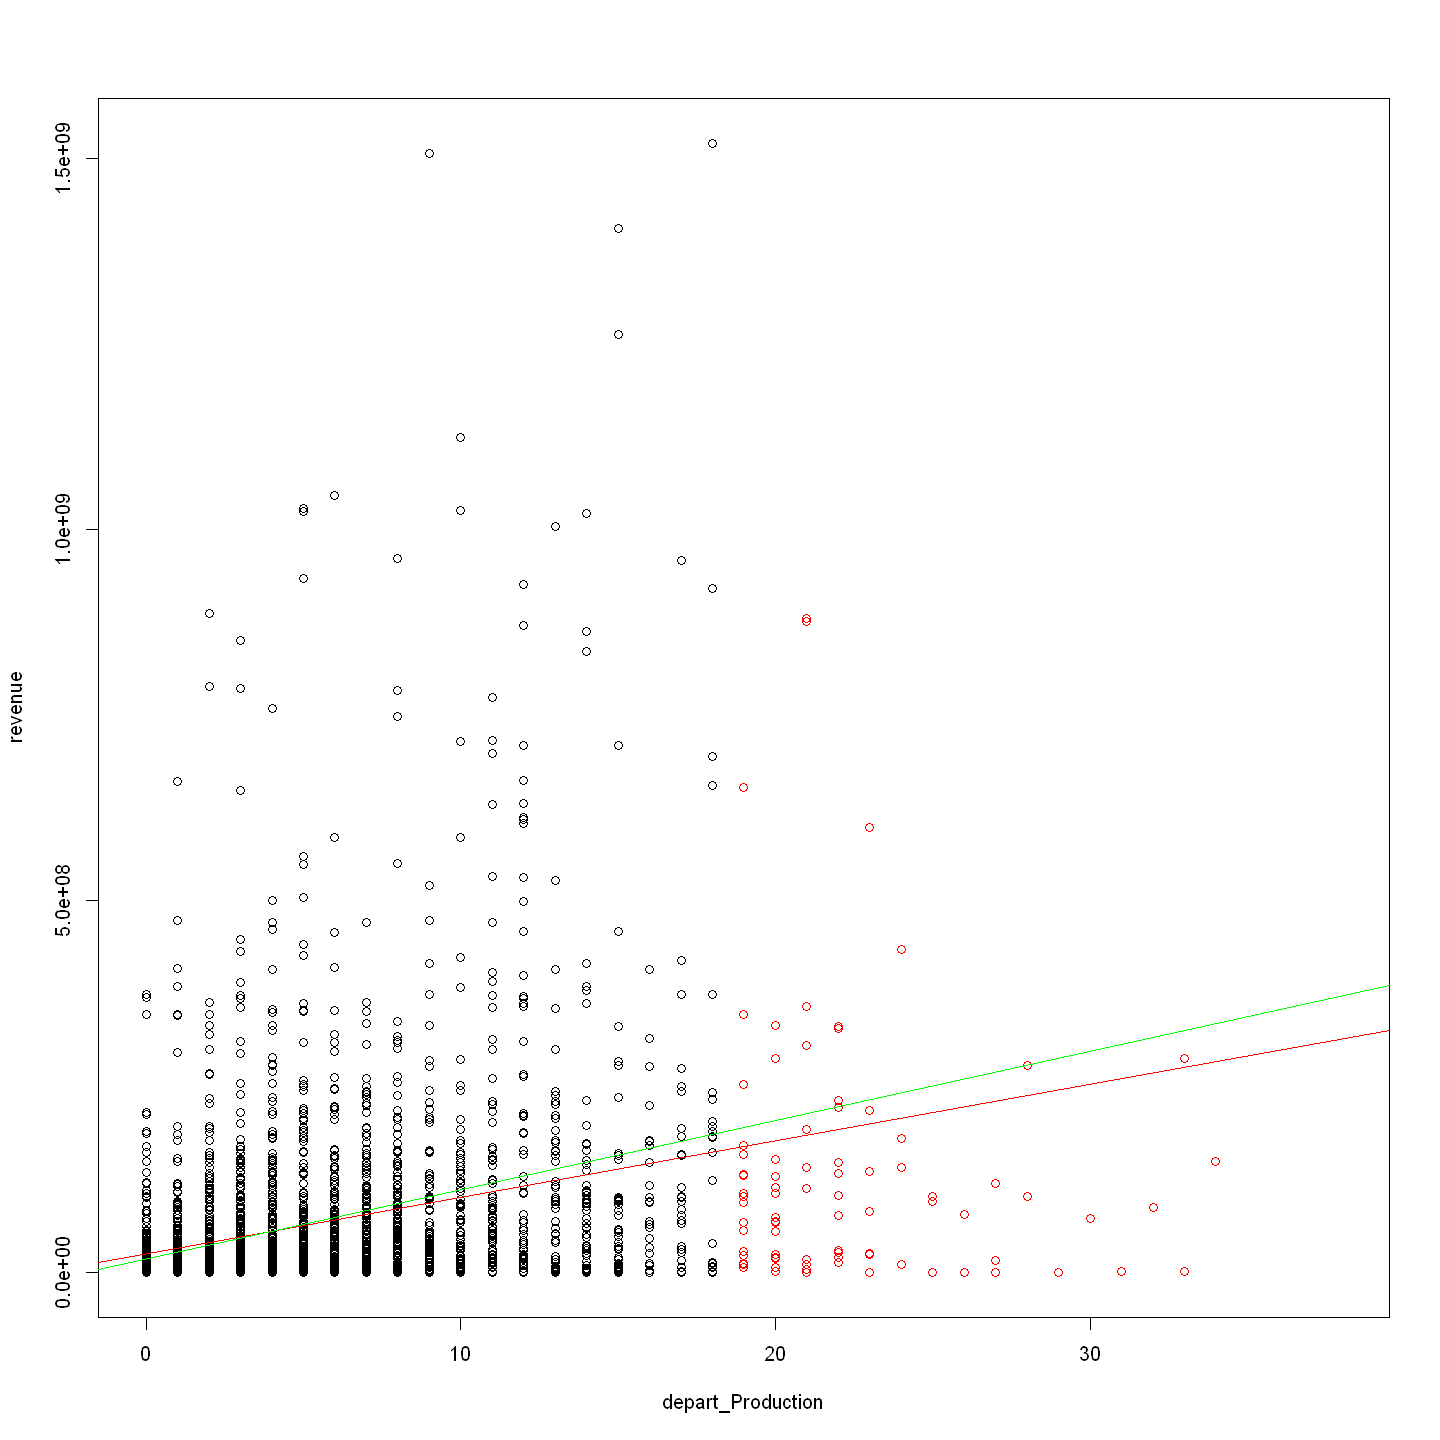

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


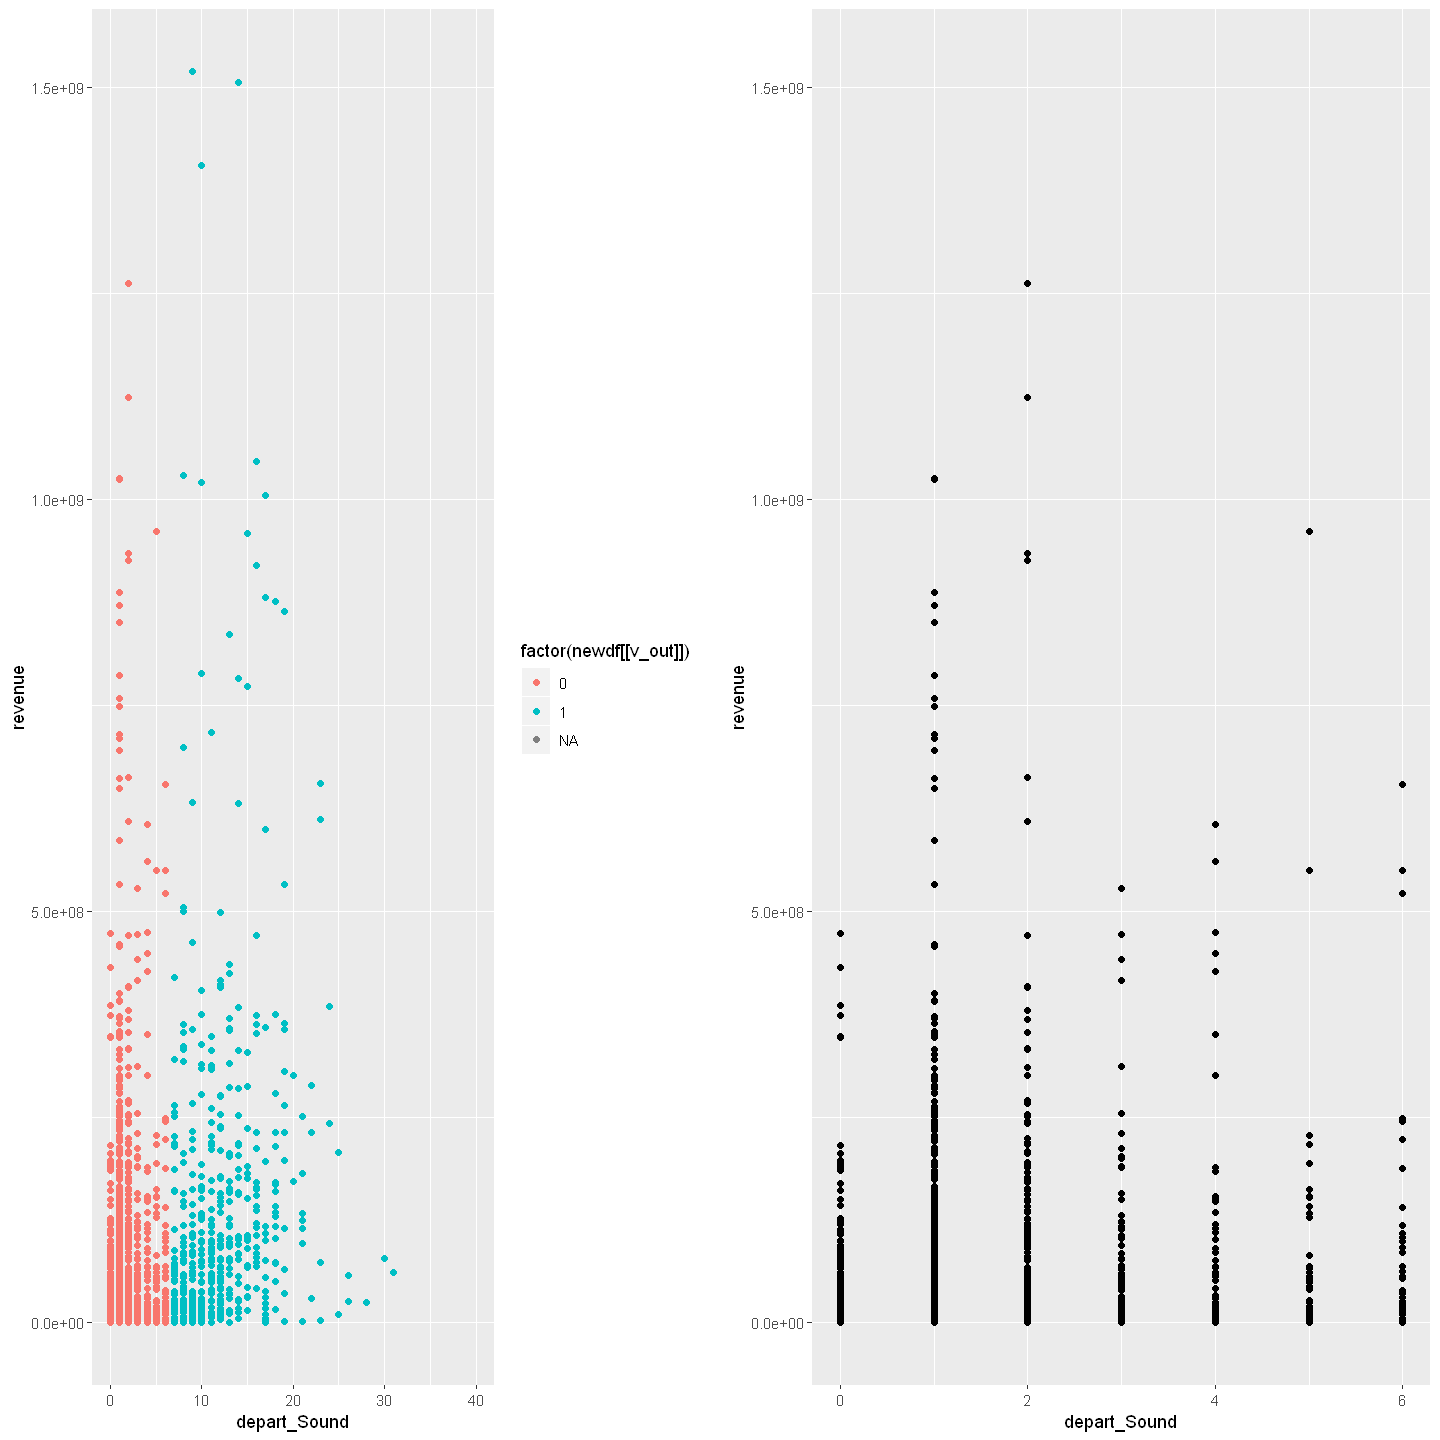

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 5095 rows containing missing values (geom_point)."


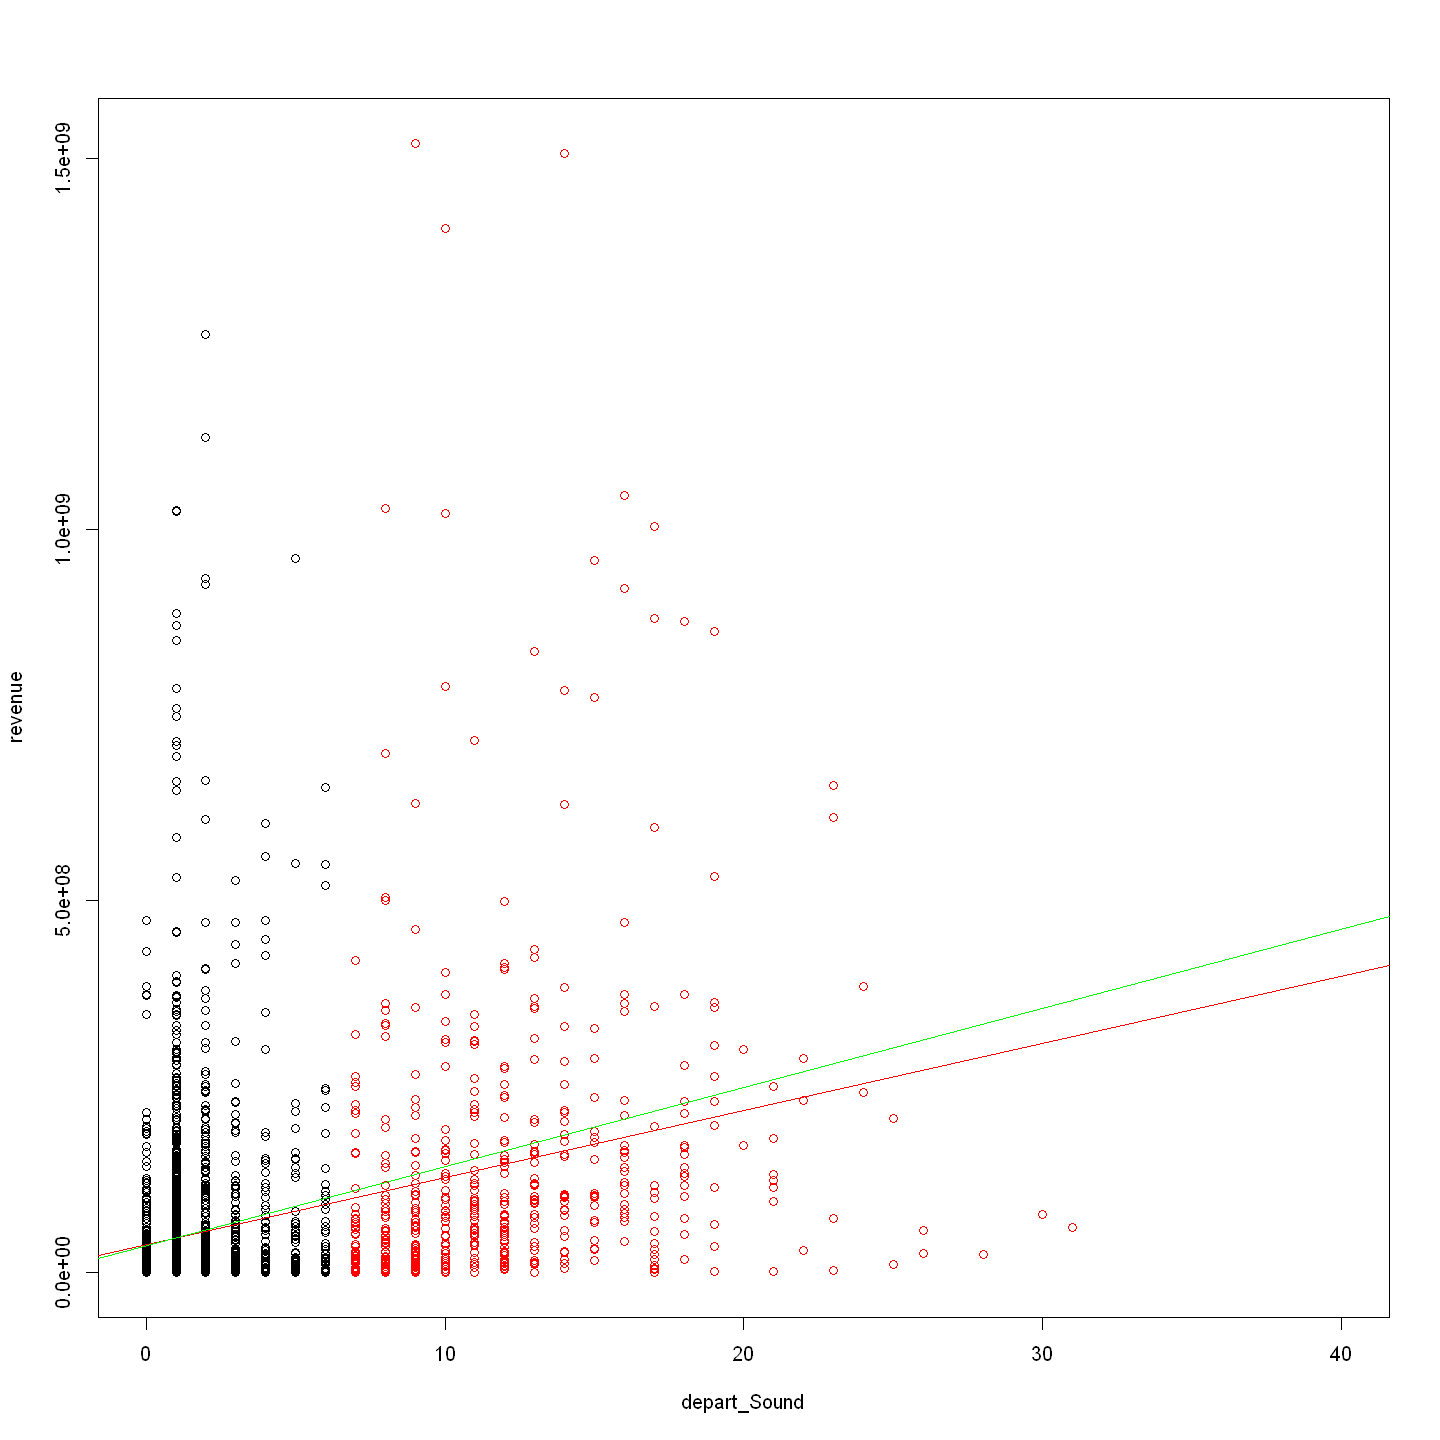

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


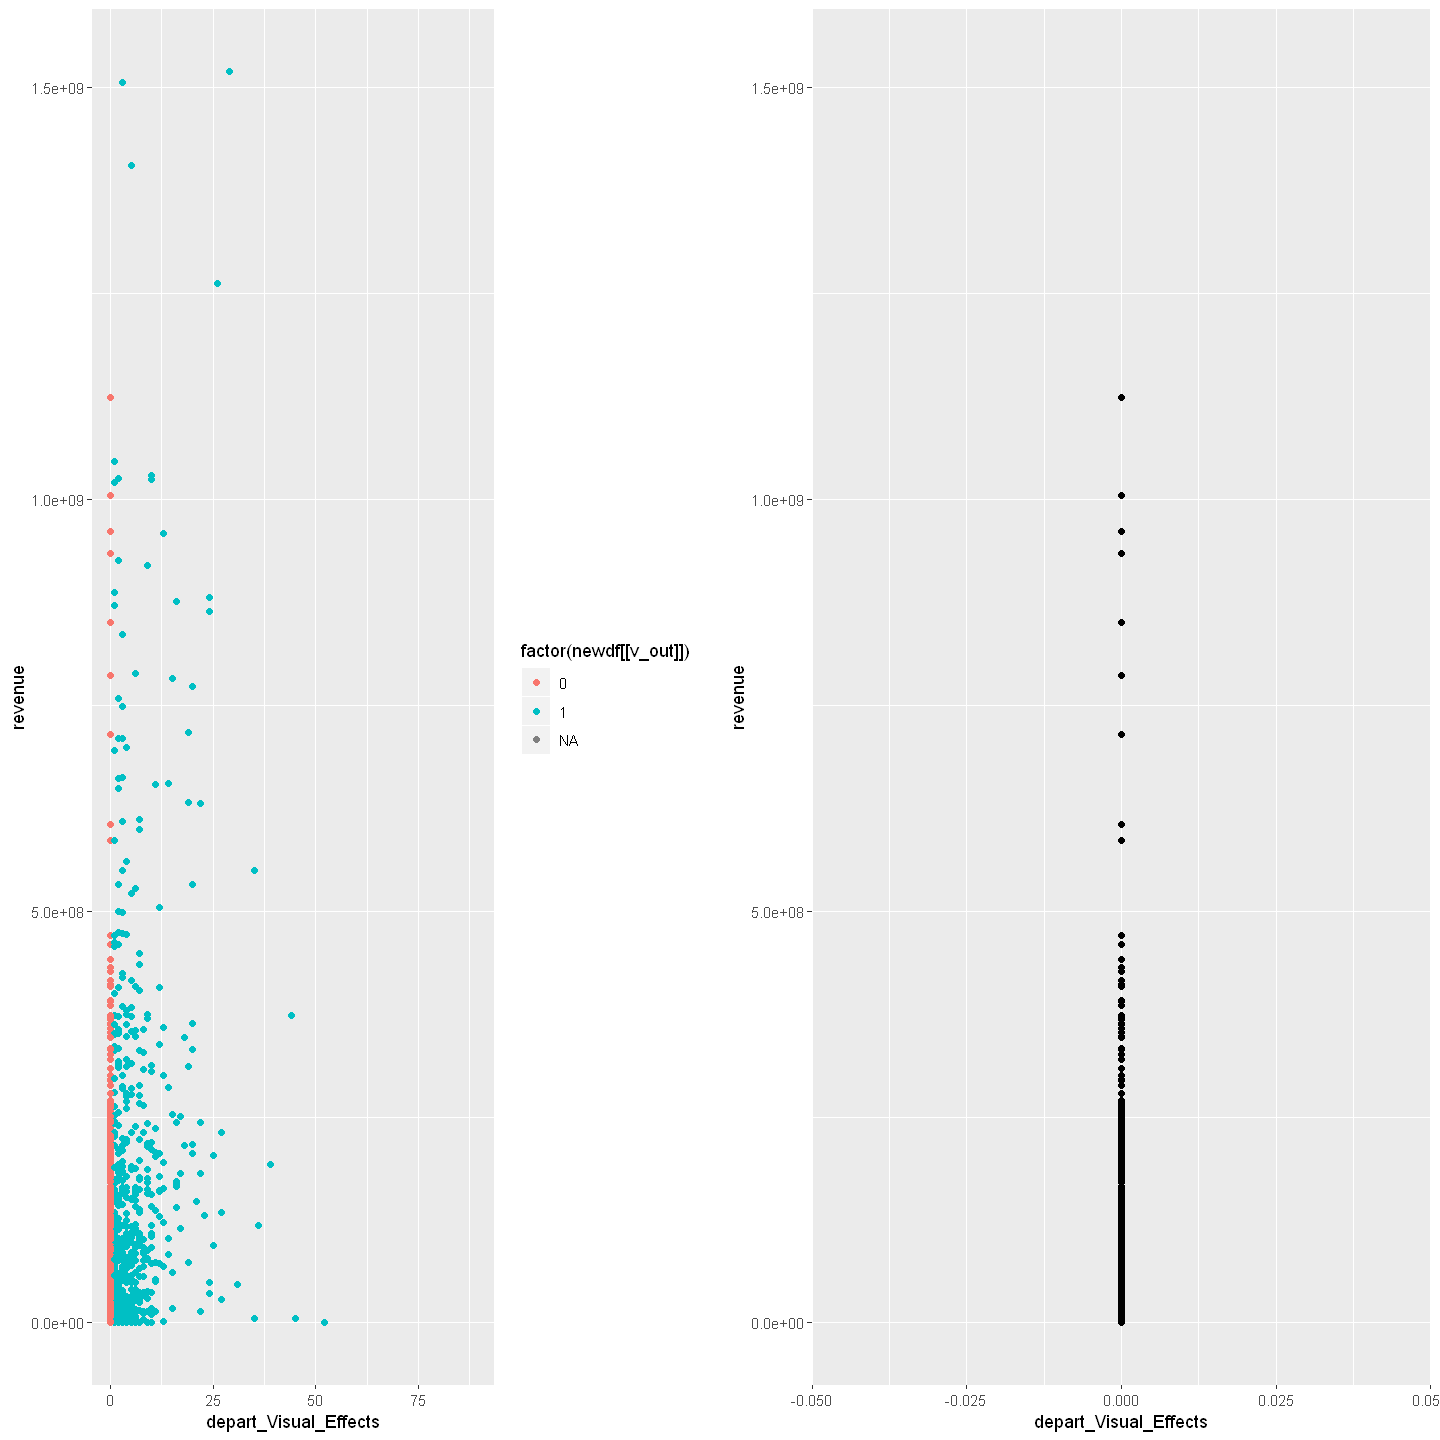

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4444 rows containing missing values (geom_point)."


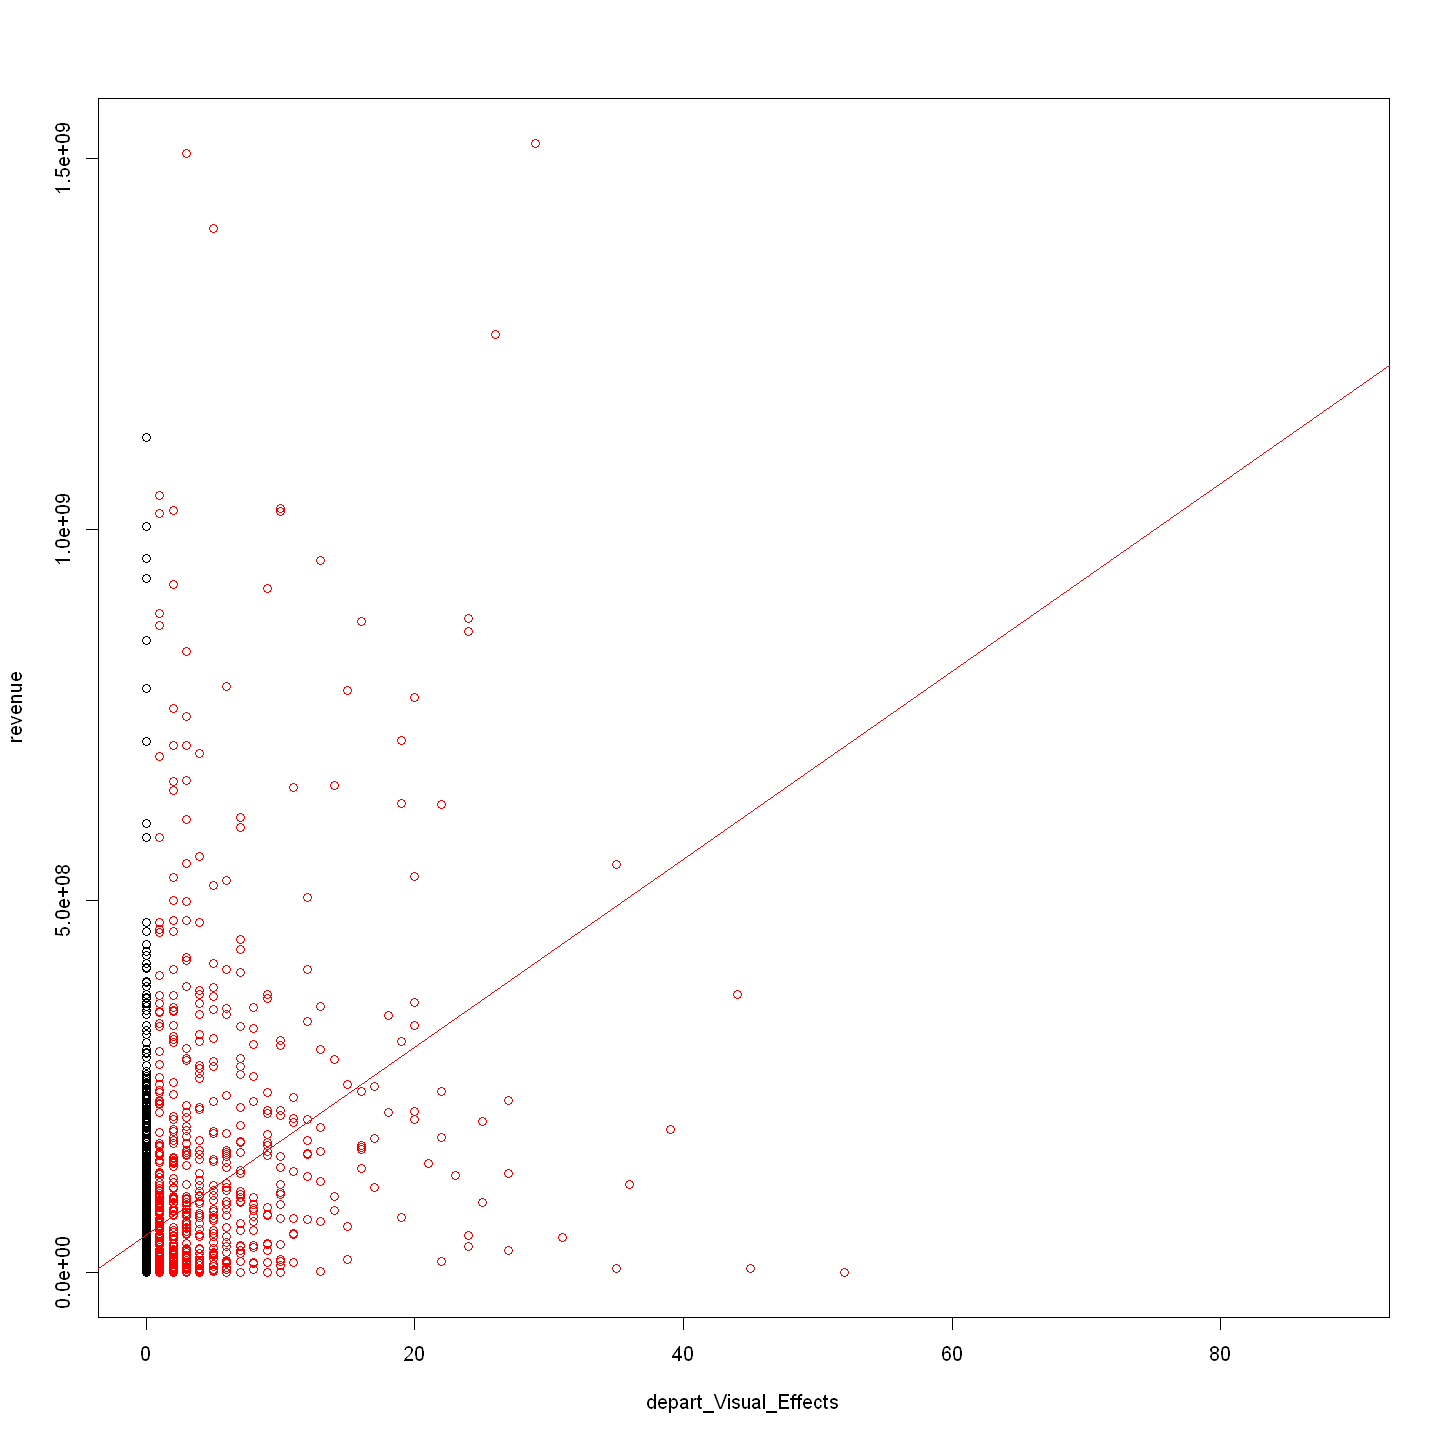

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


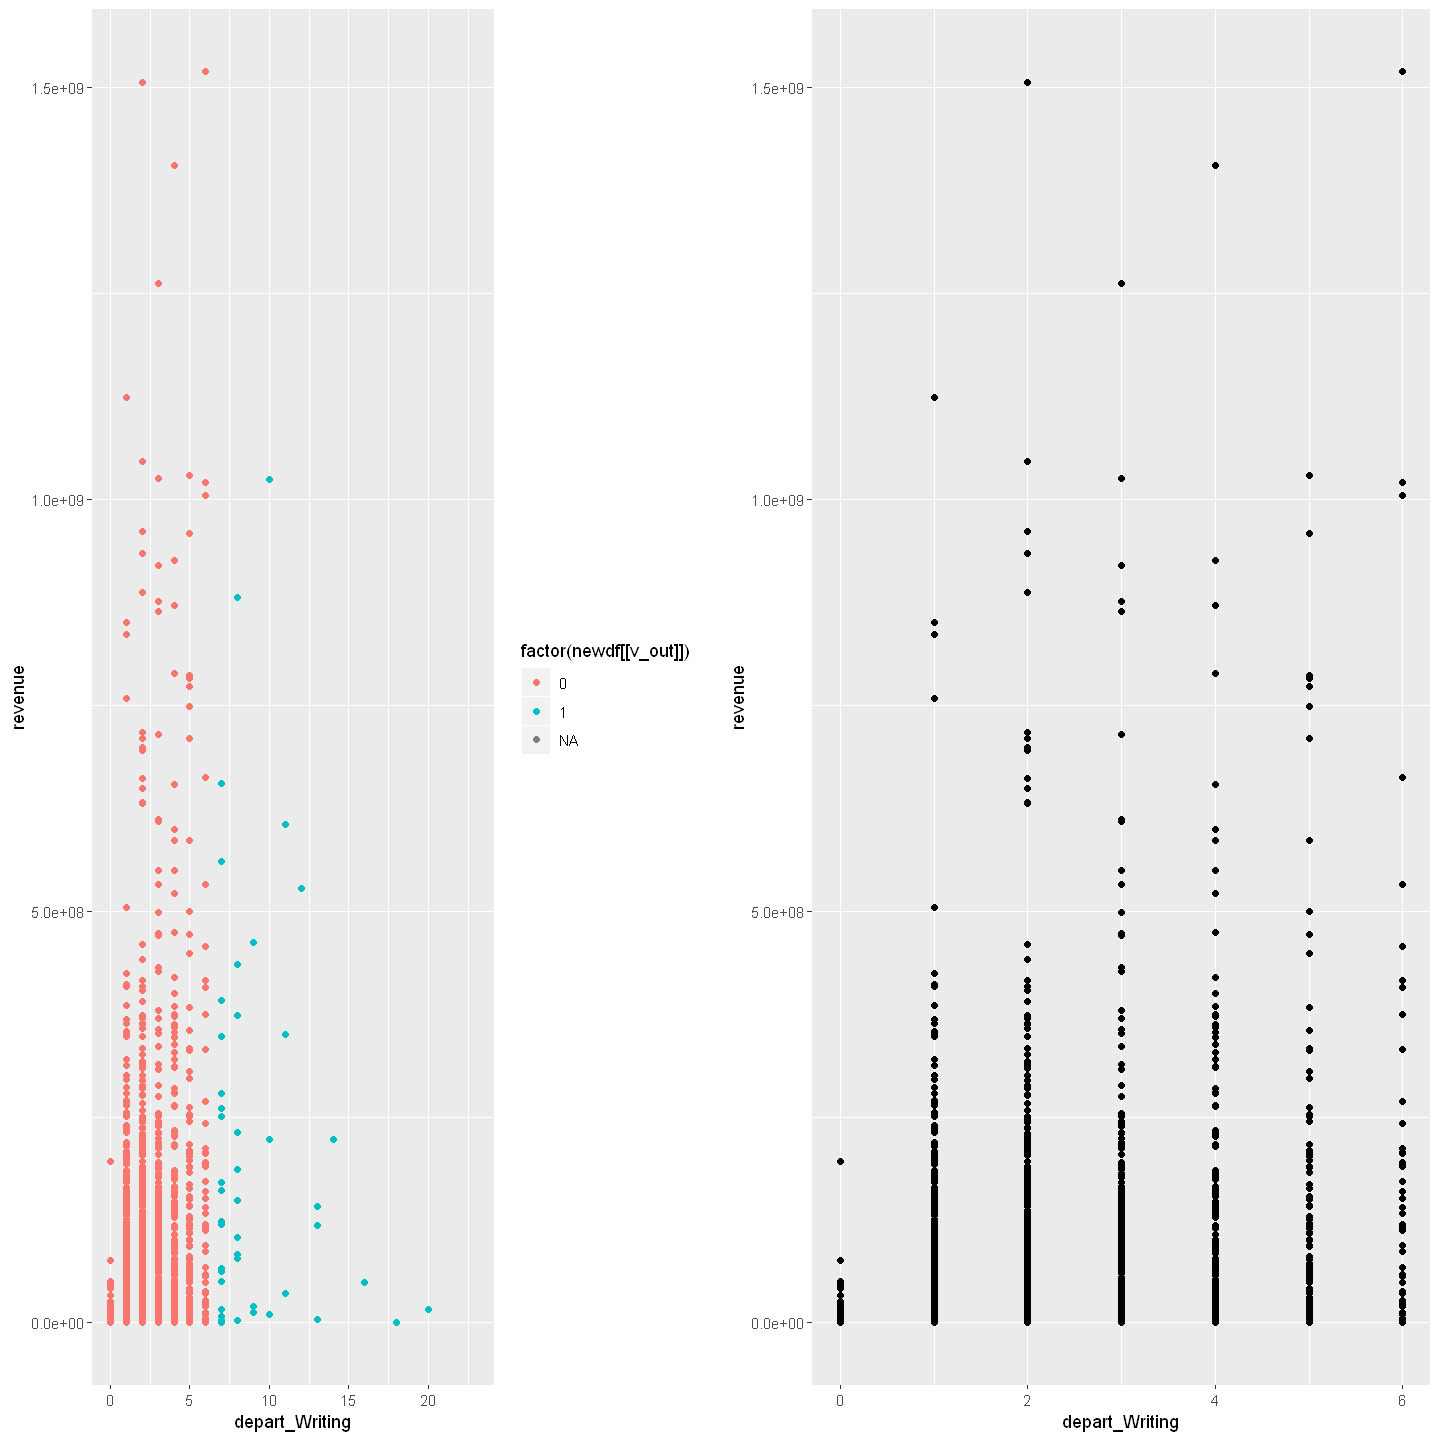

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4957 rows containing missing values (geom_point)."


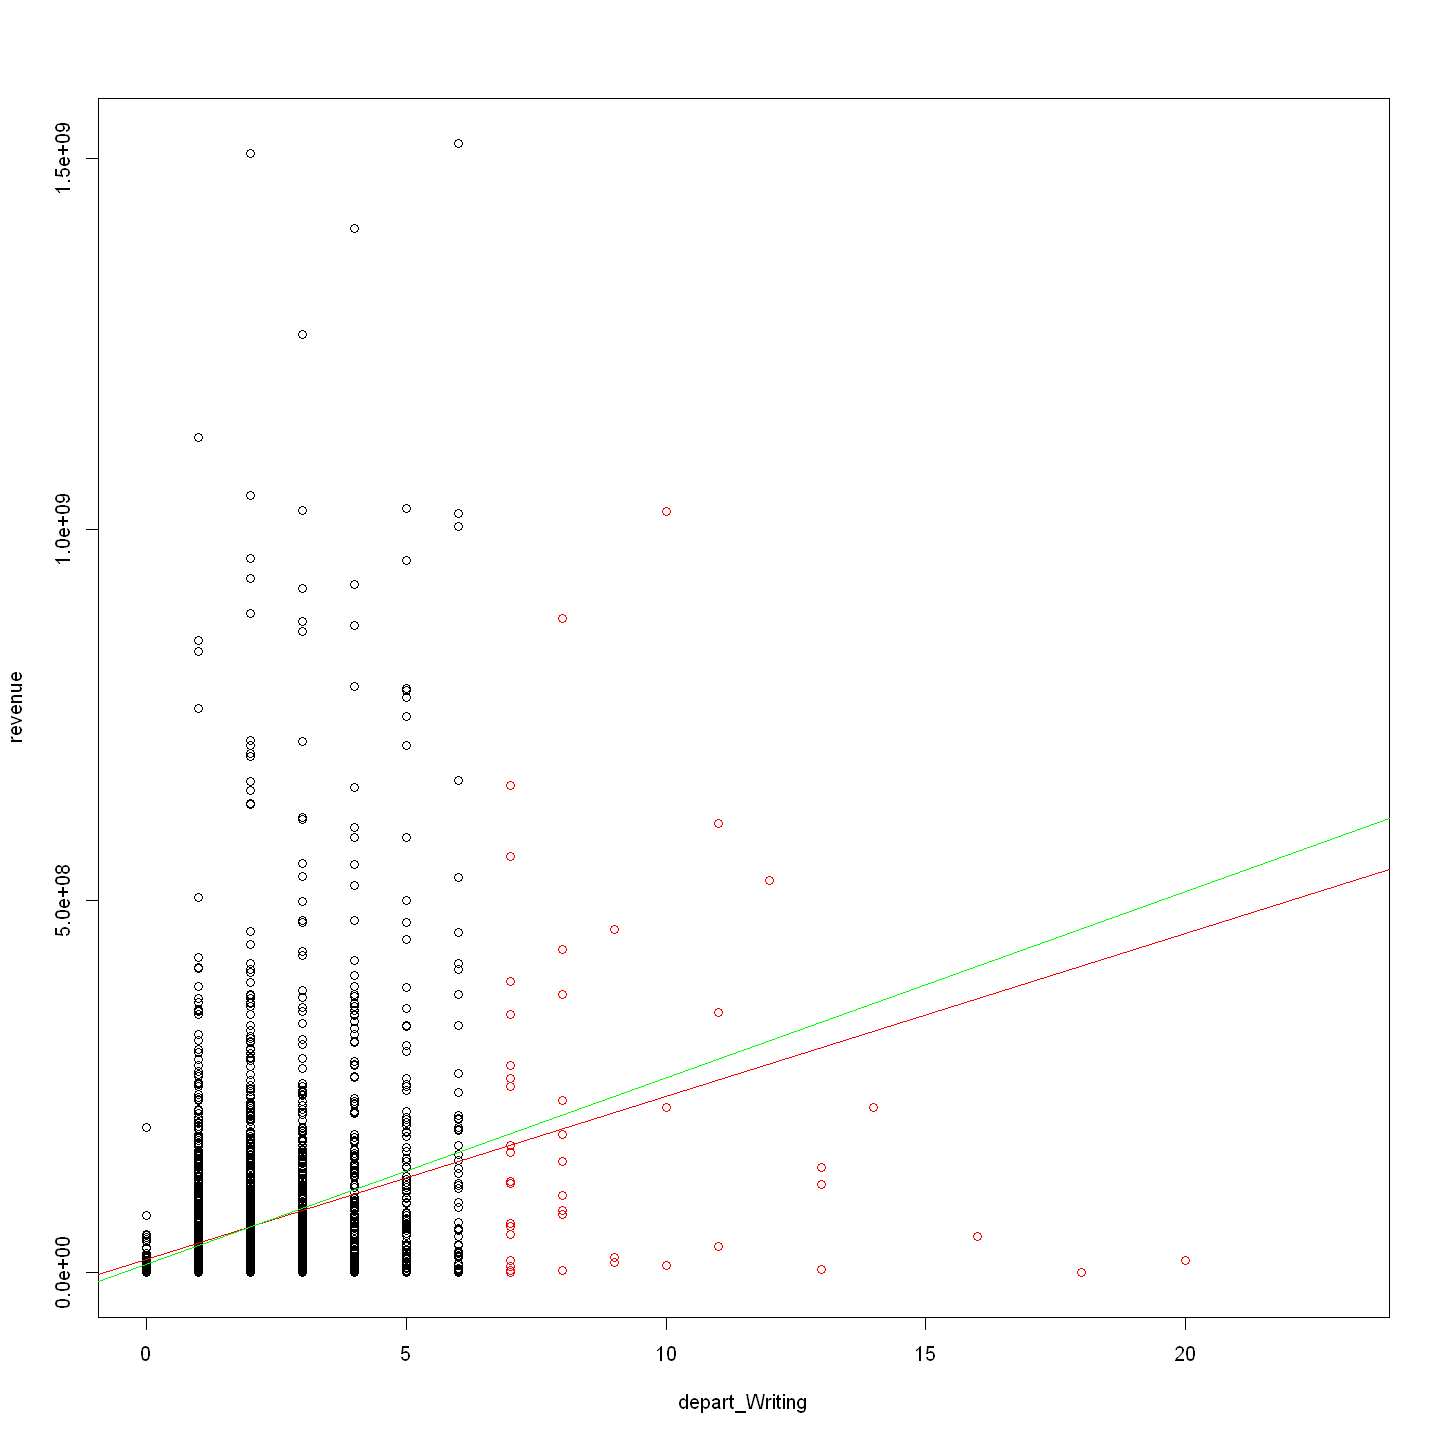

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


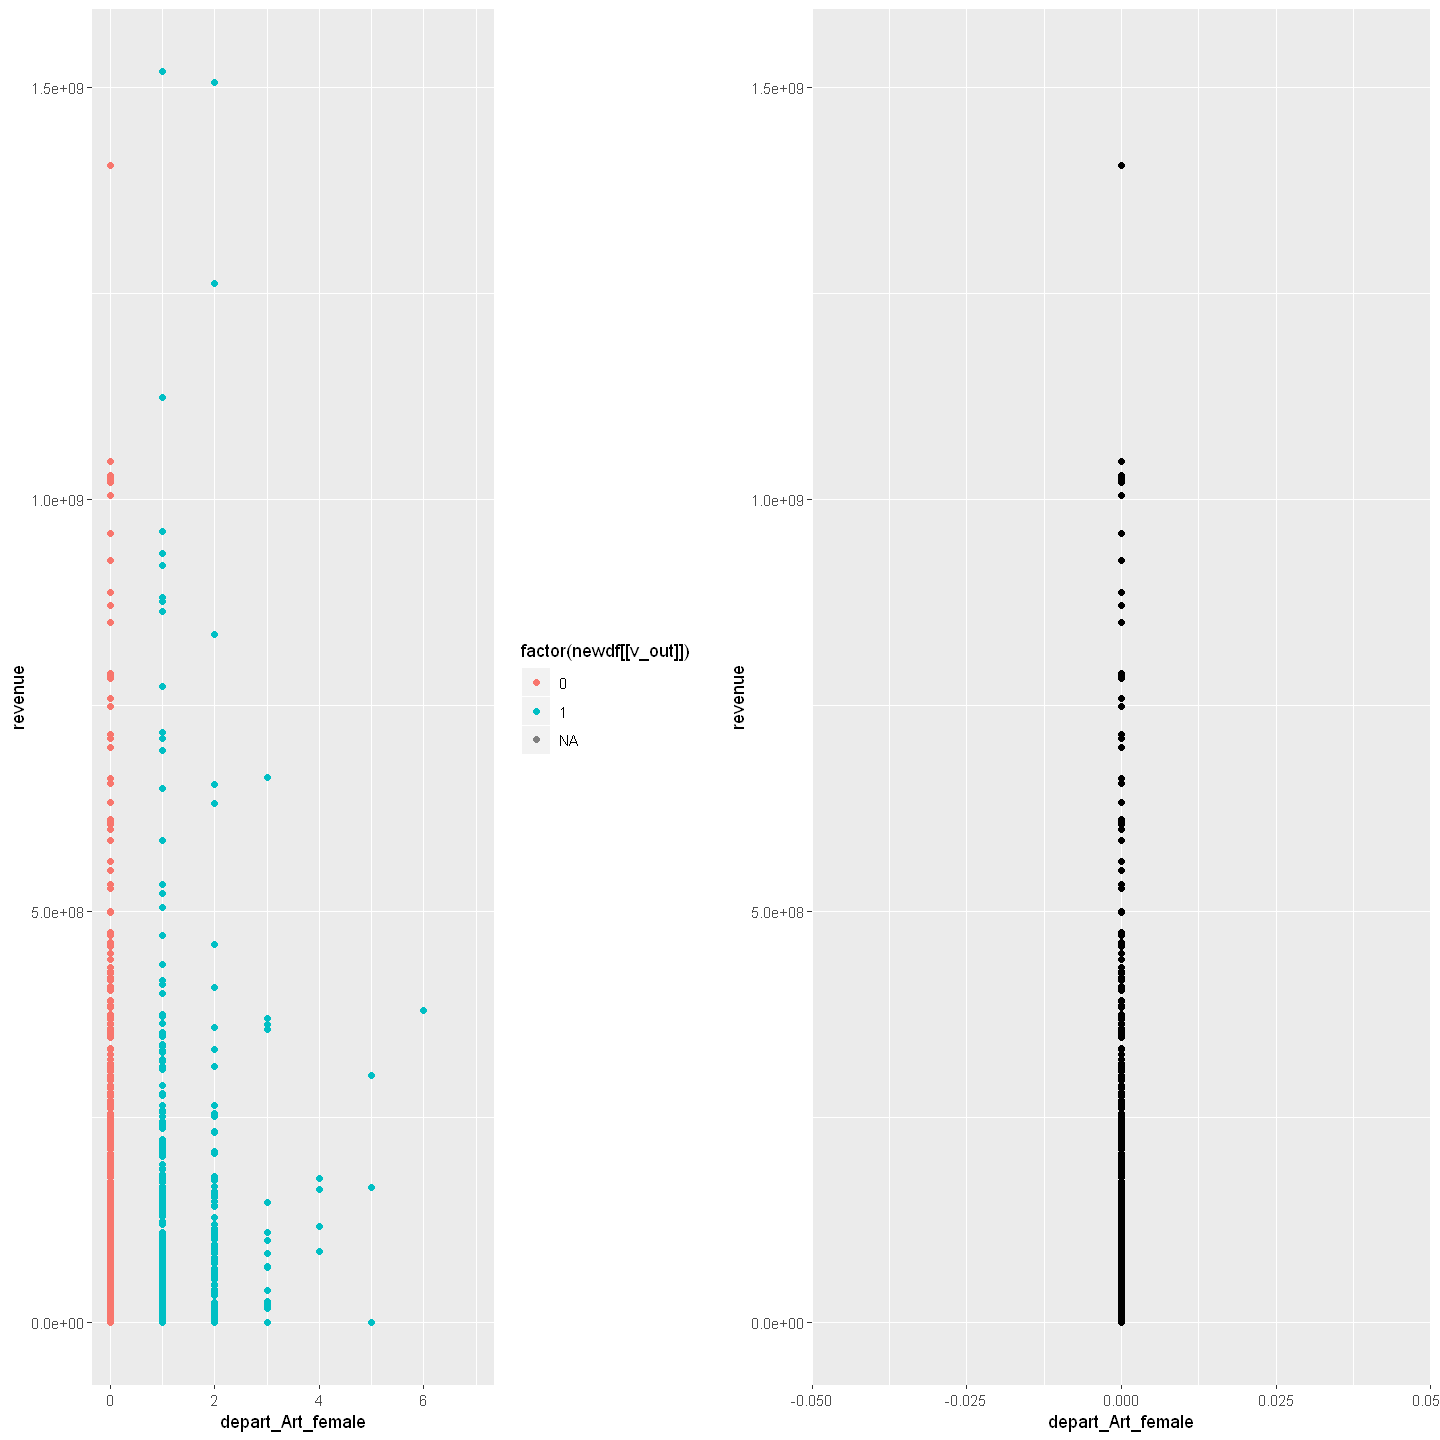

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4460 rows containing missing values (geom_point)."


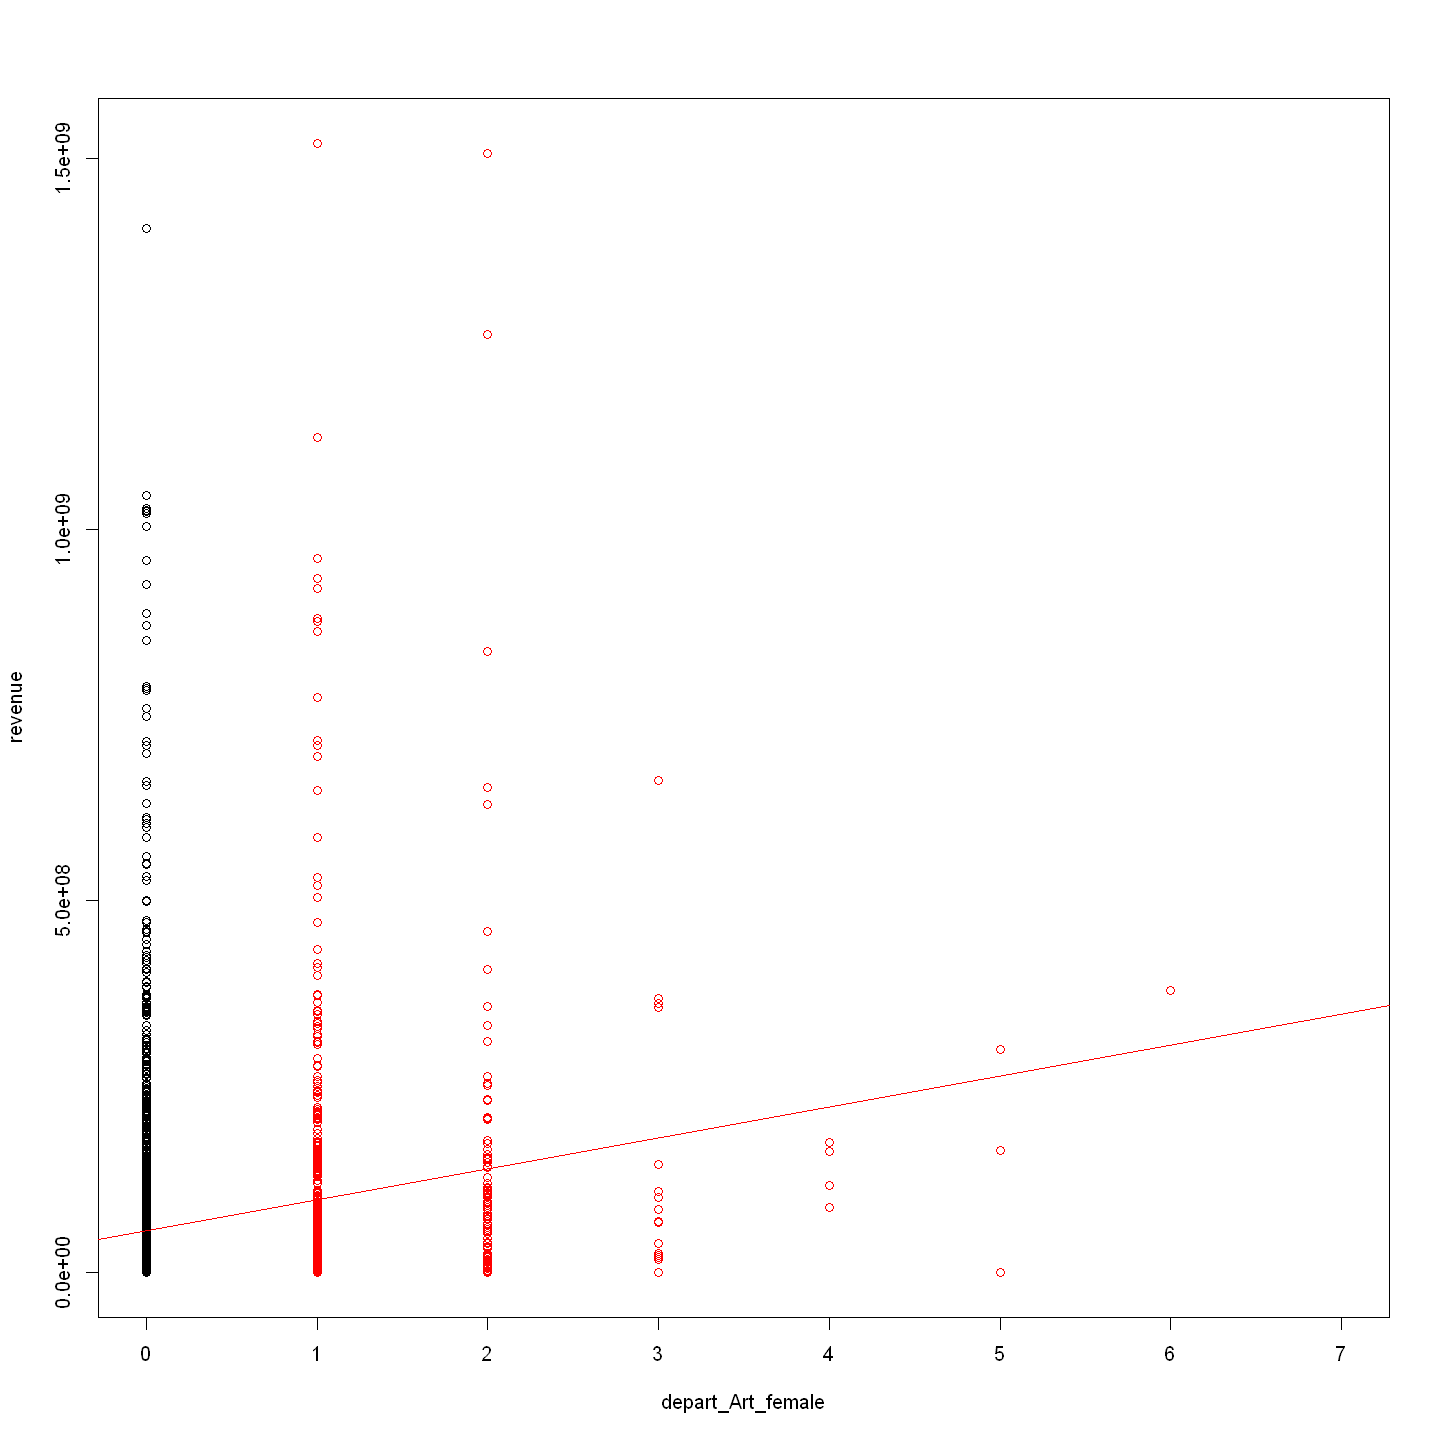

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


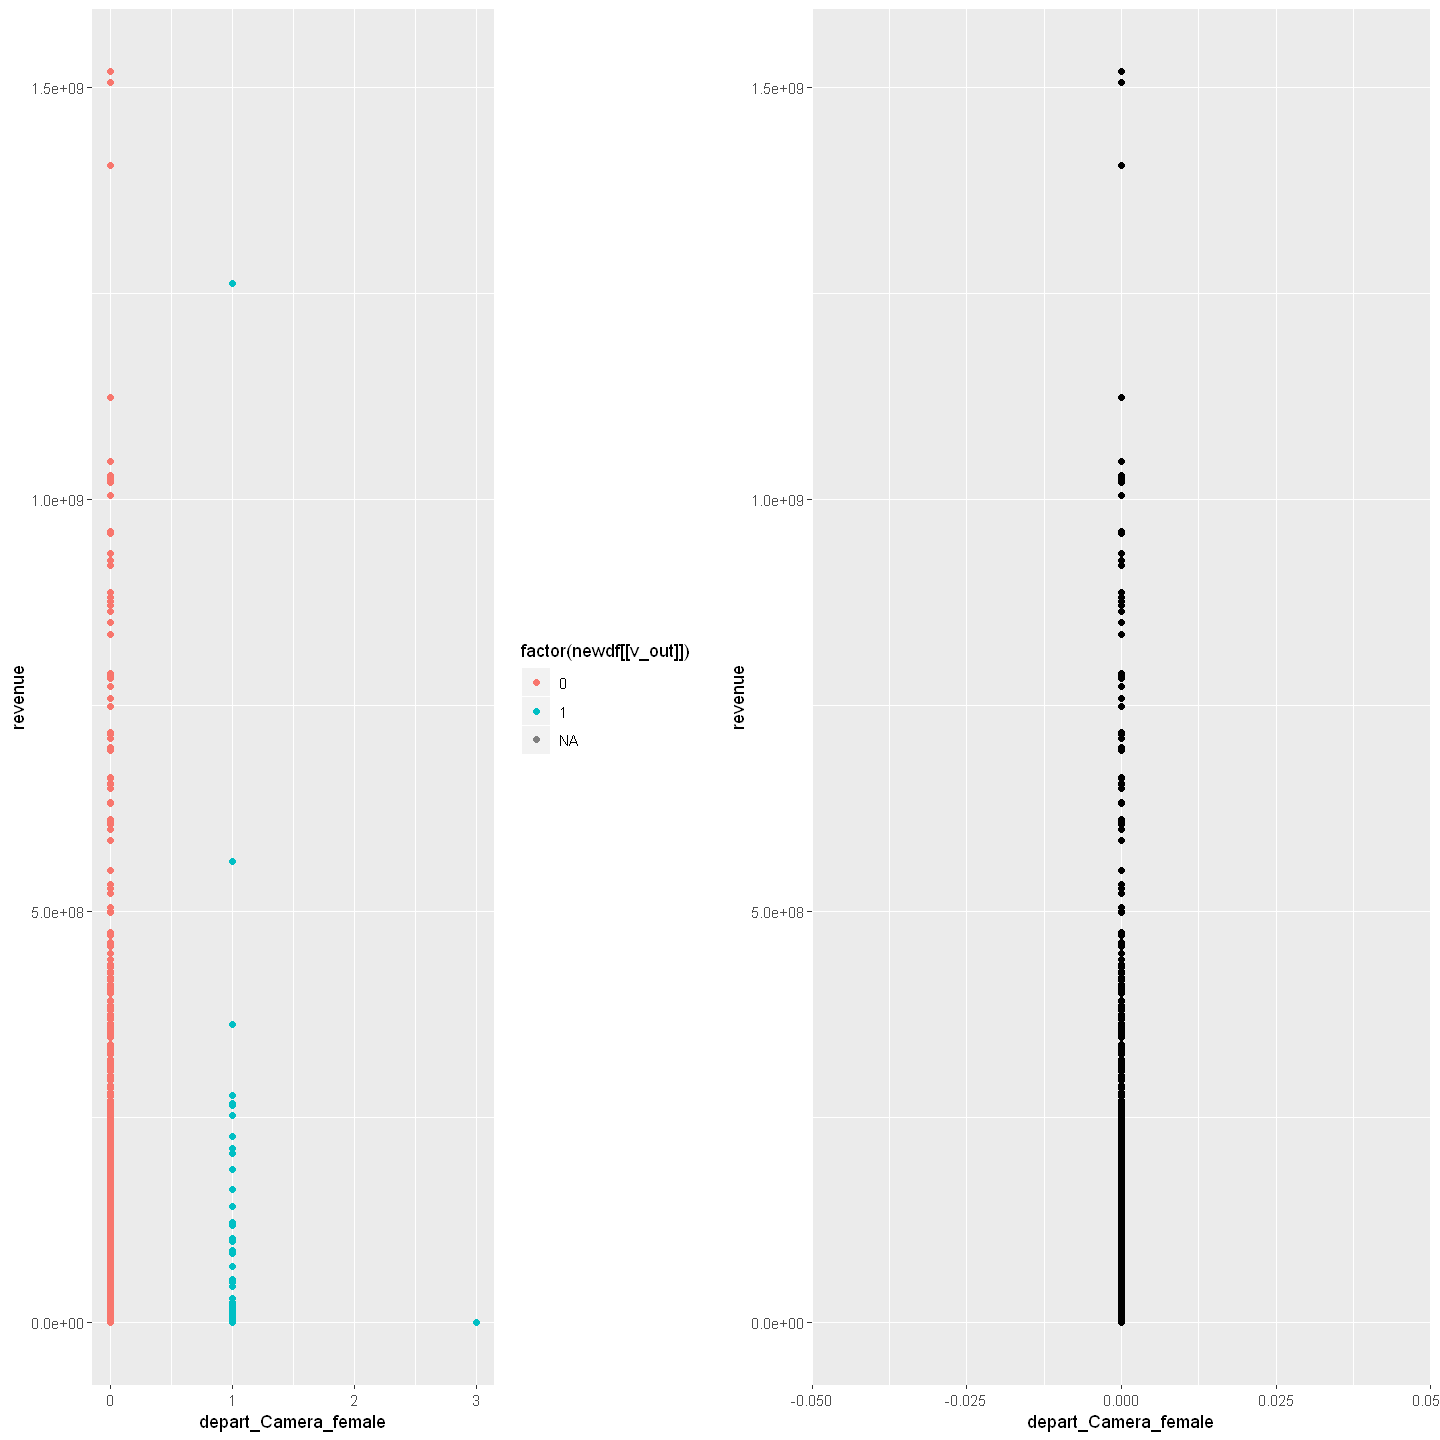

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4538 rows containing missing values (geom_point)."


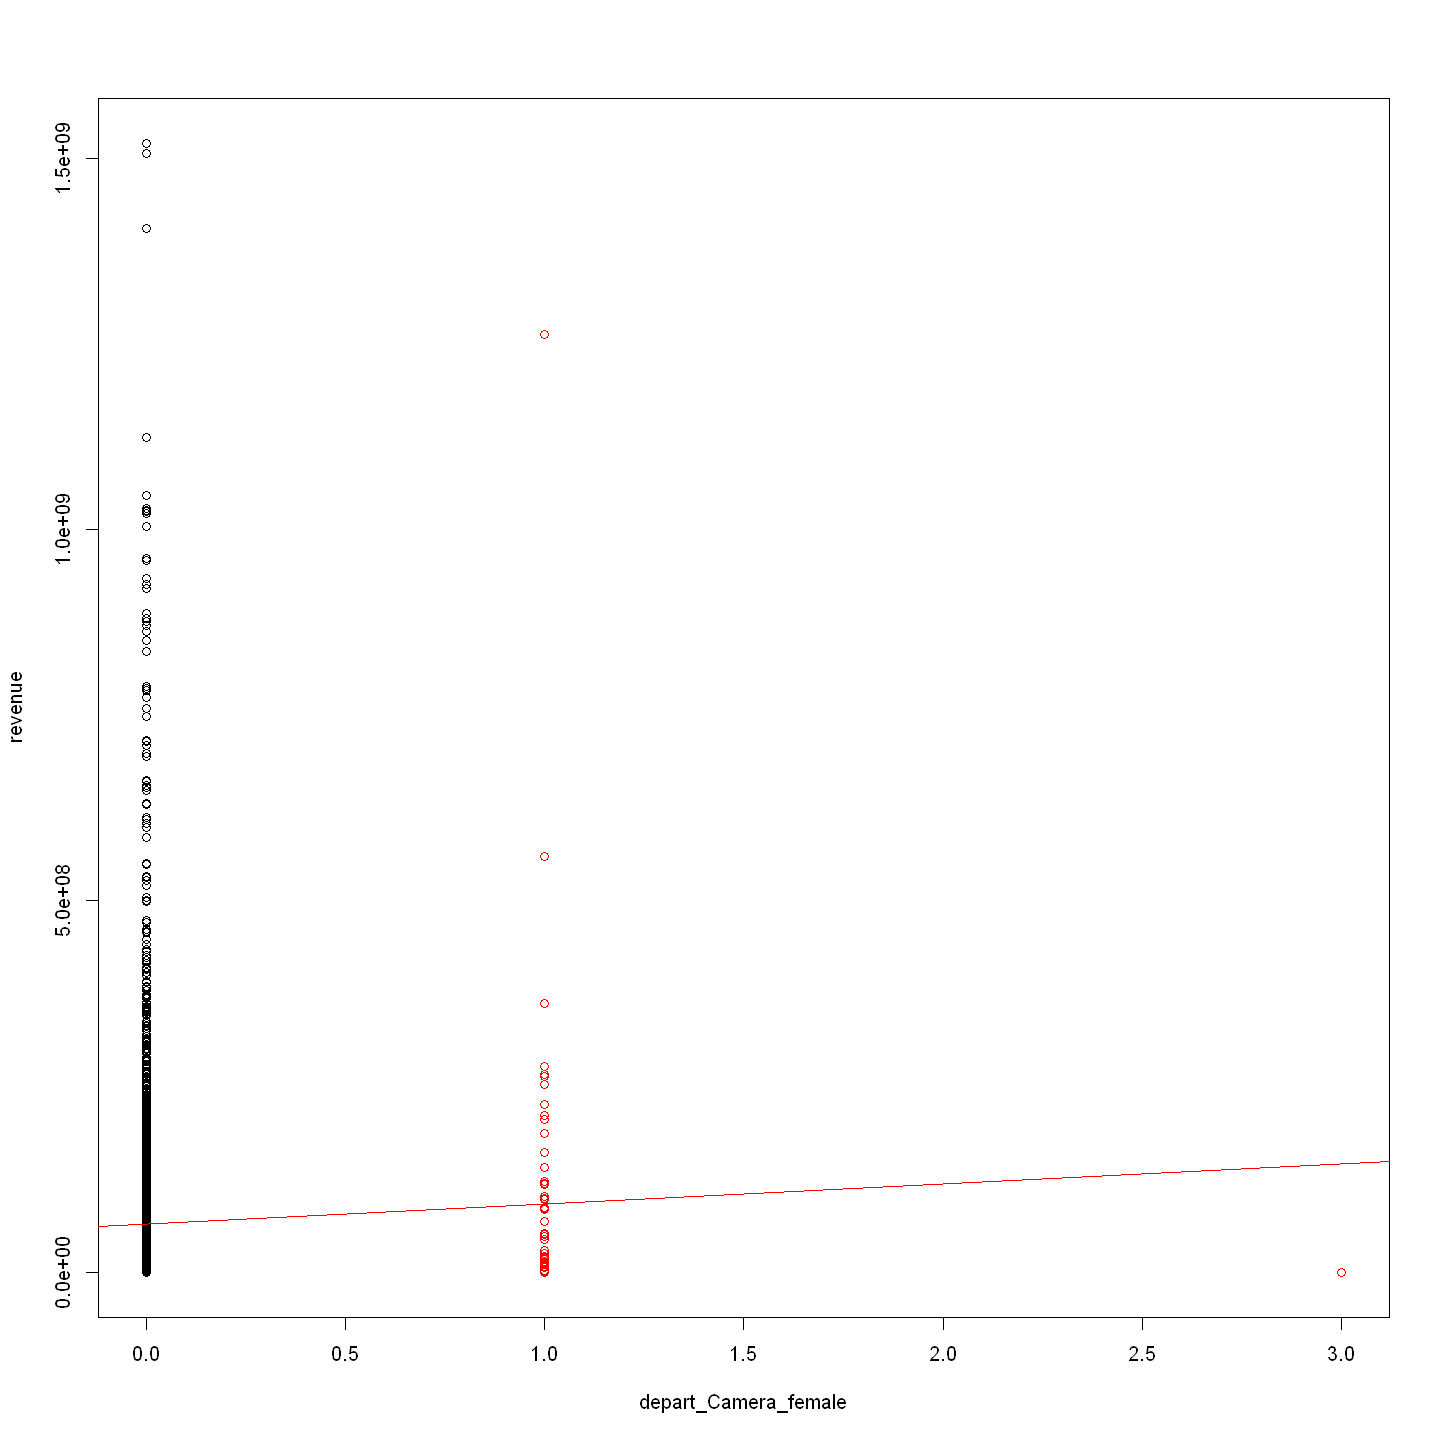

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


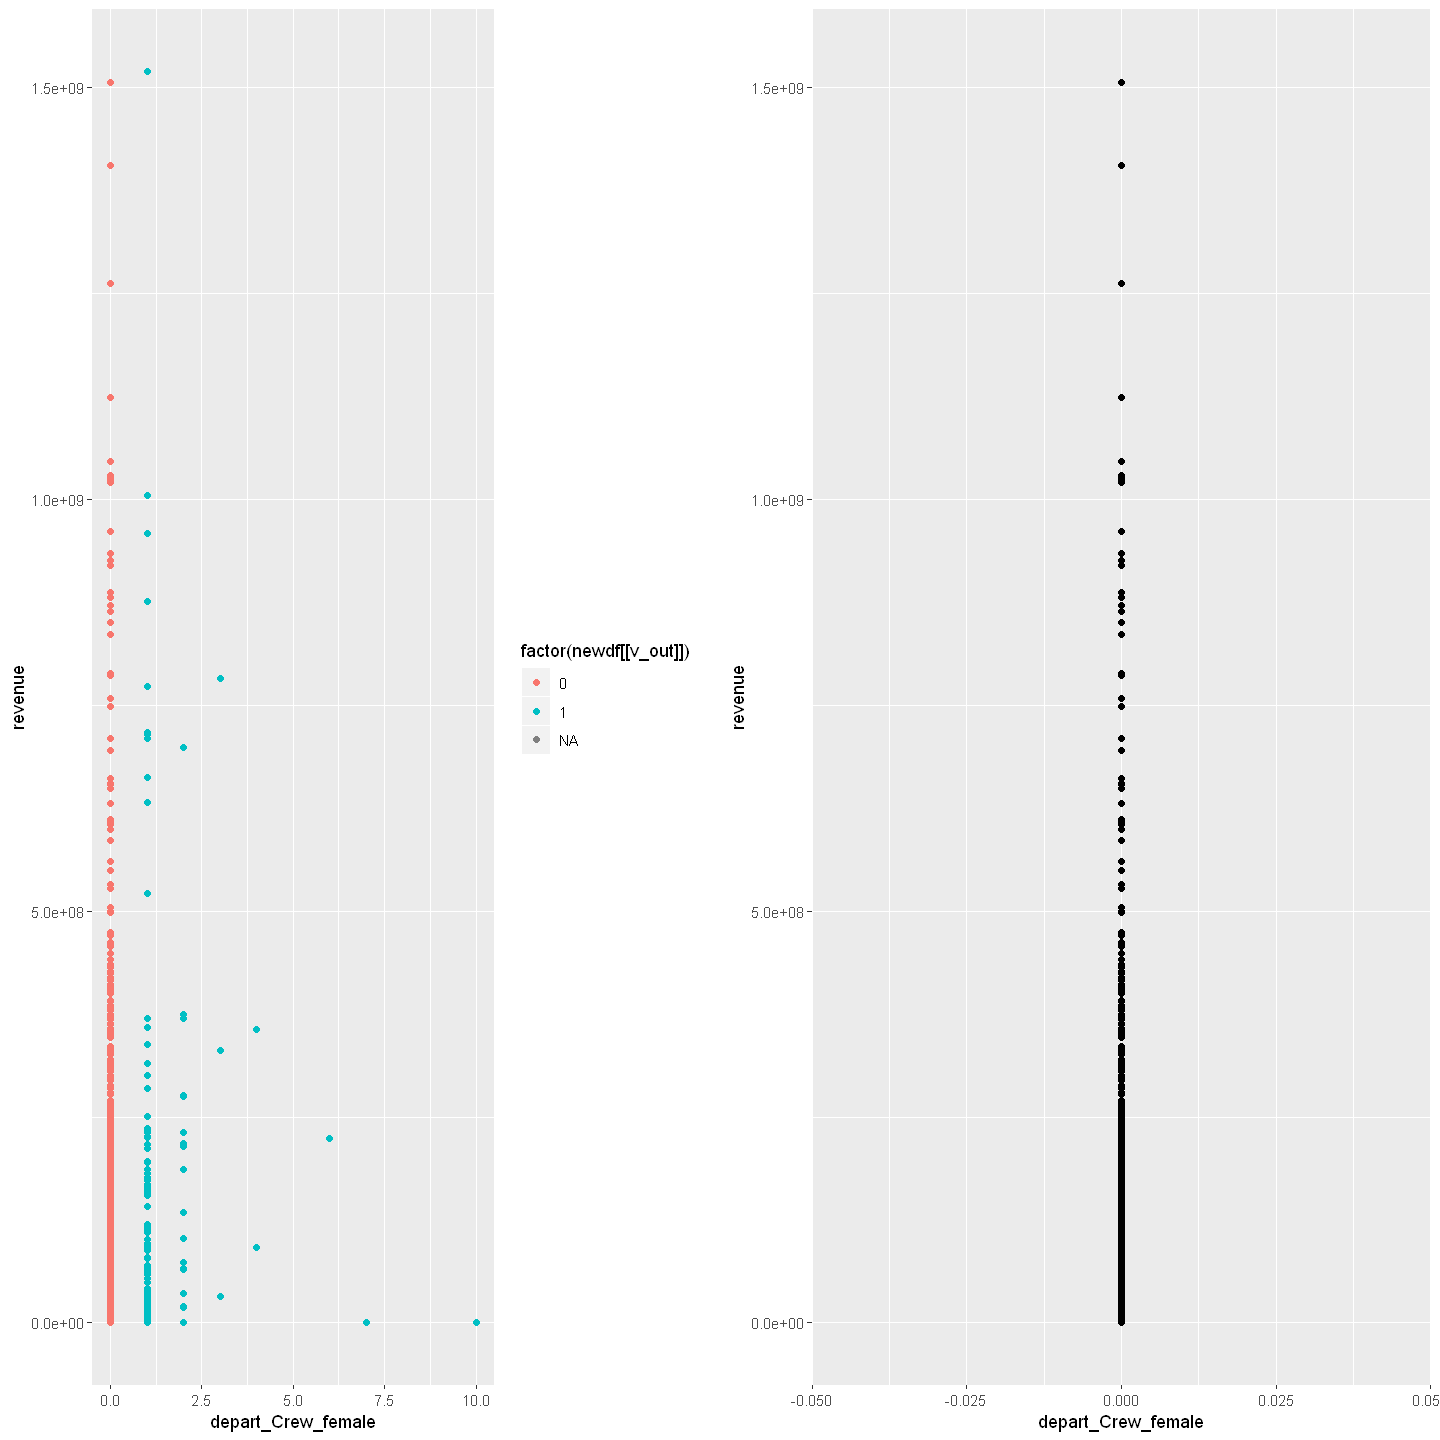

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4438 rows containing missing values (geom_point)."


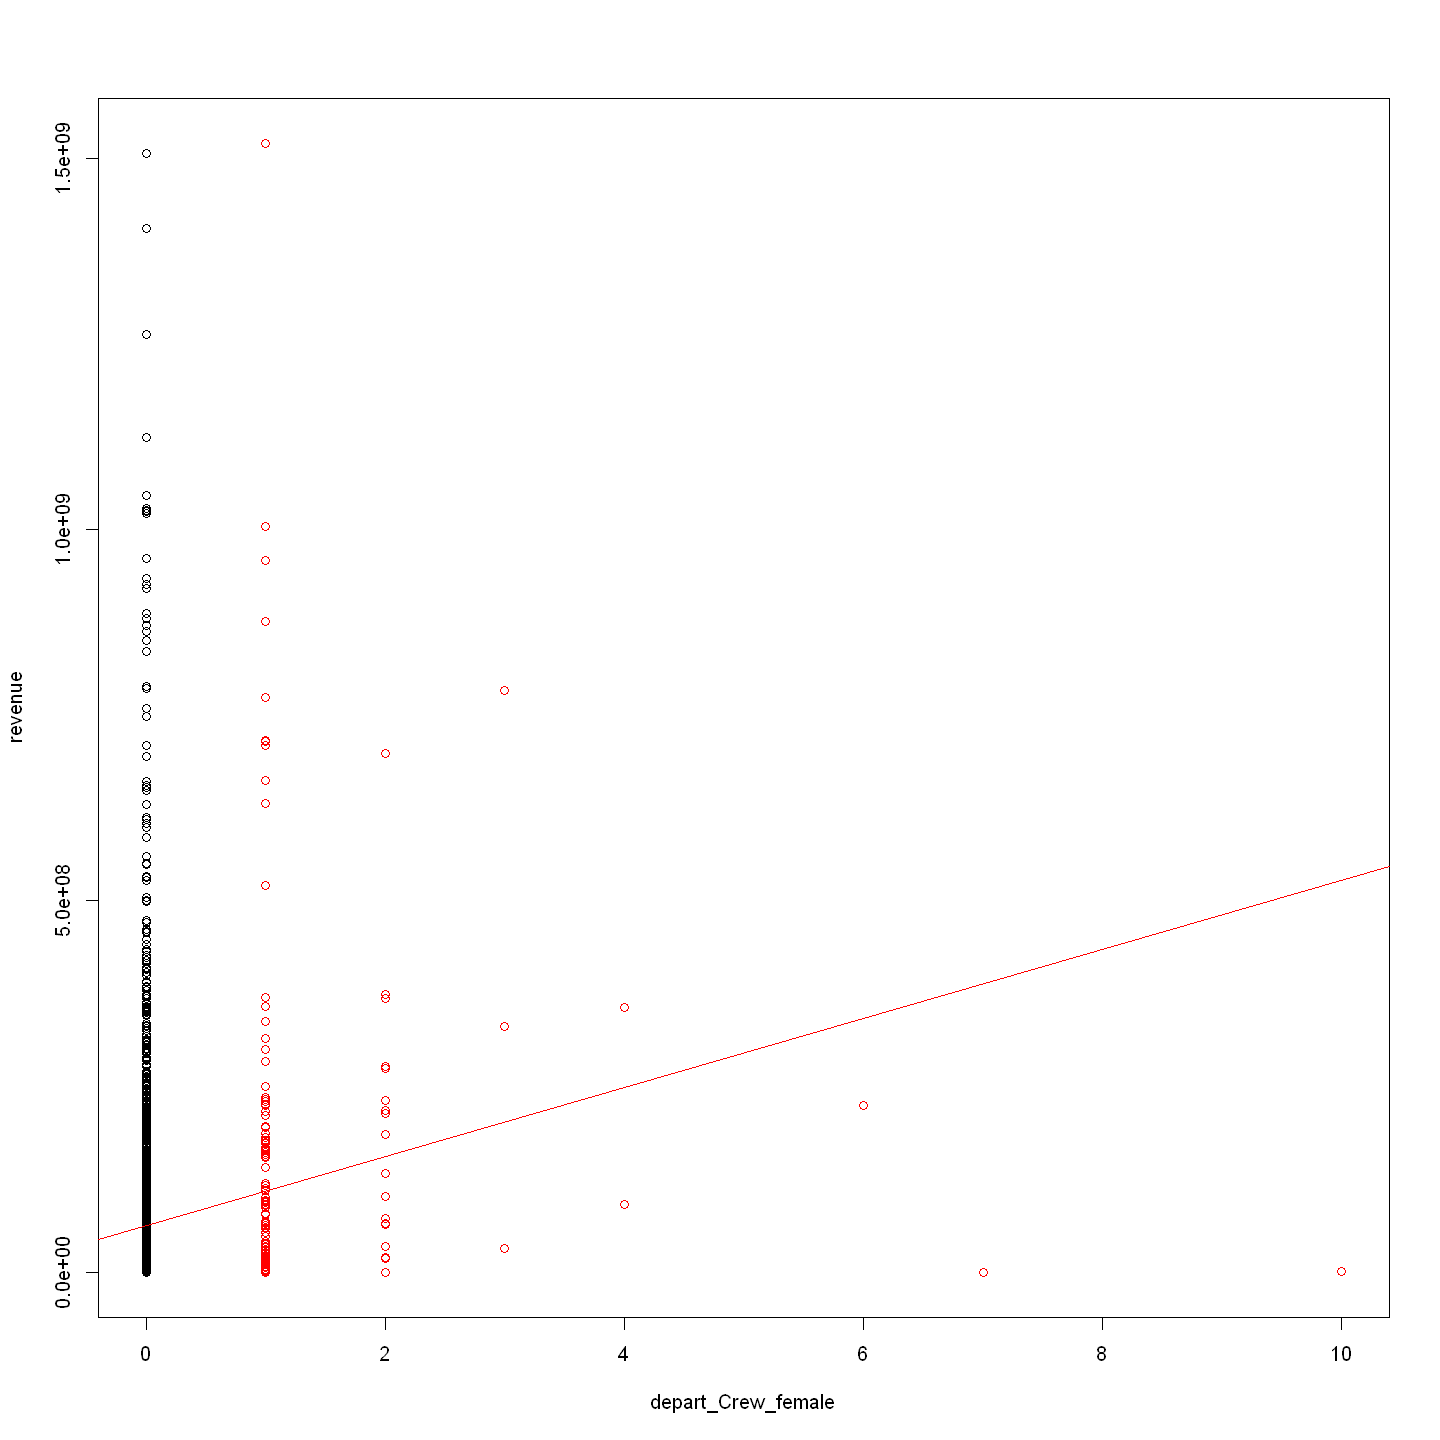

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


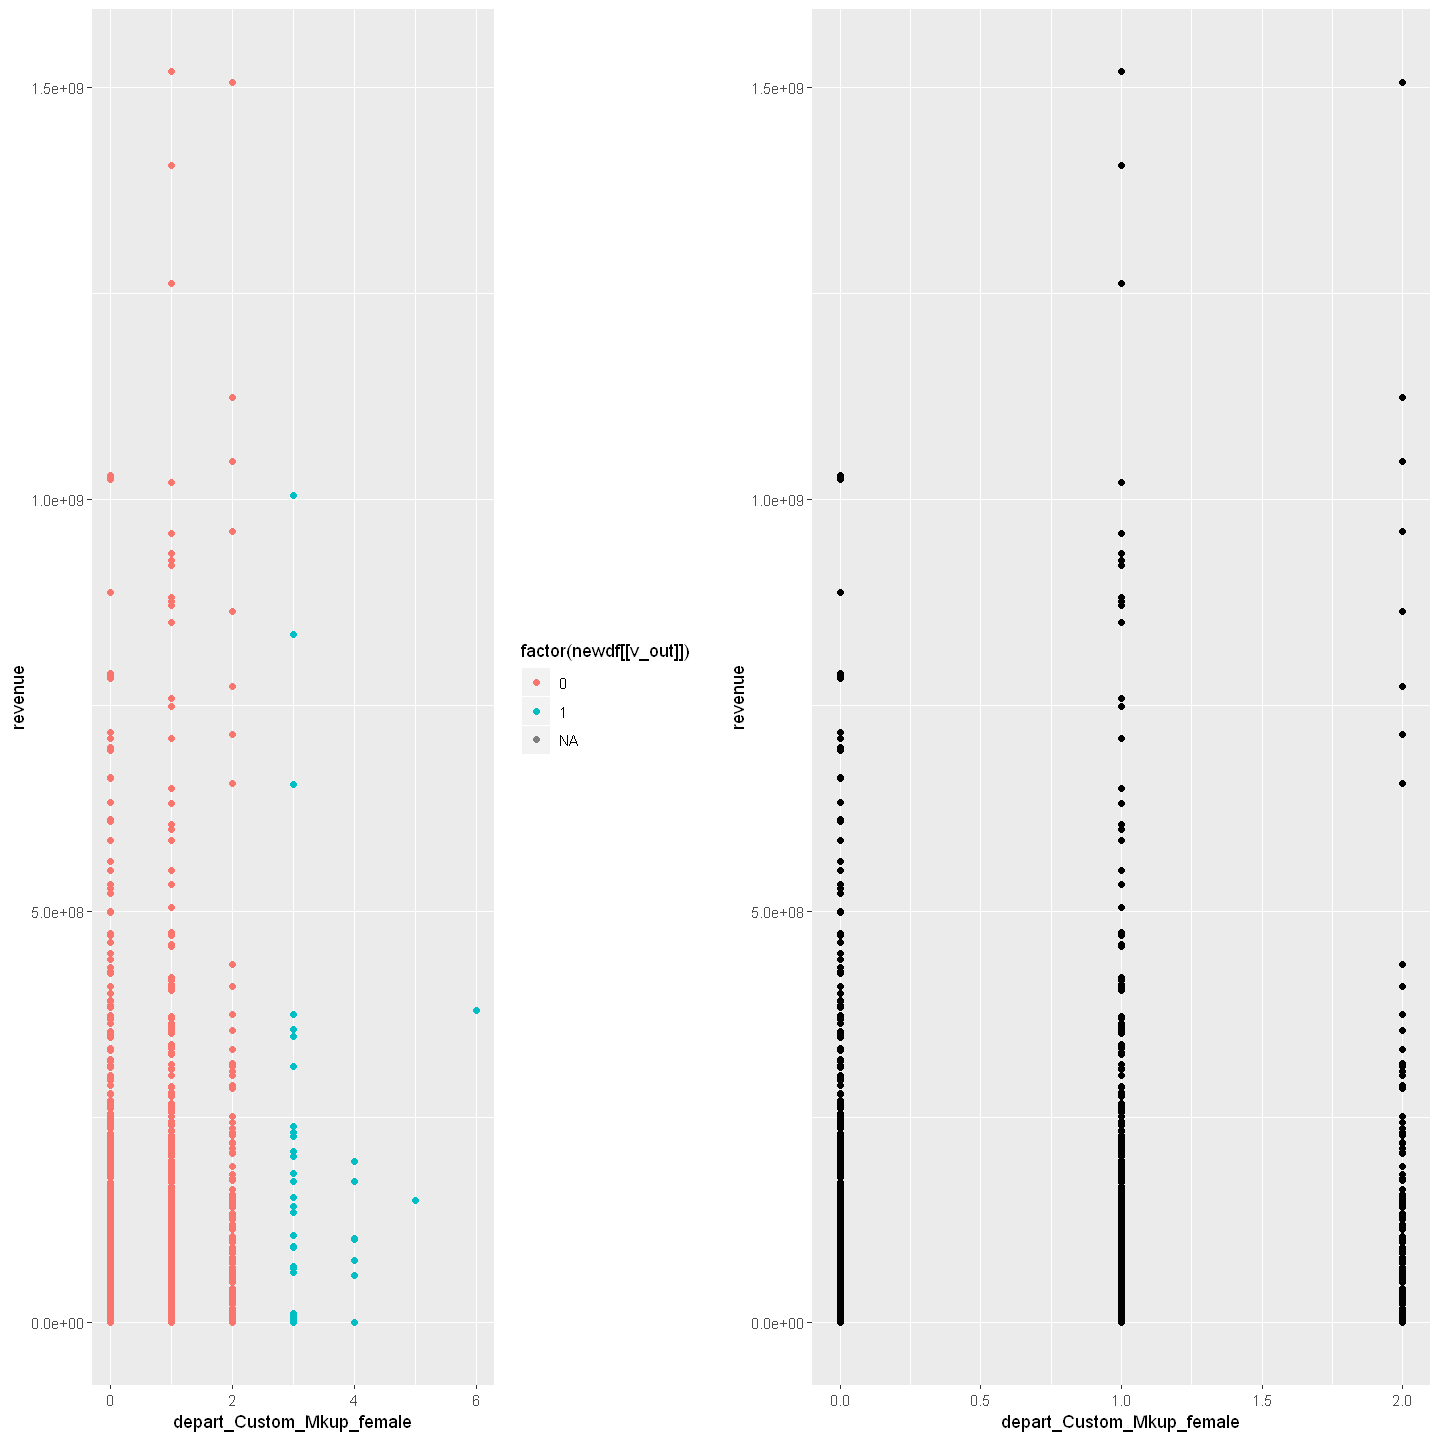

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4825 rows containing missing values (geom_point)."


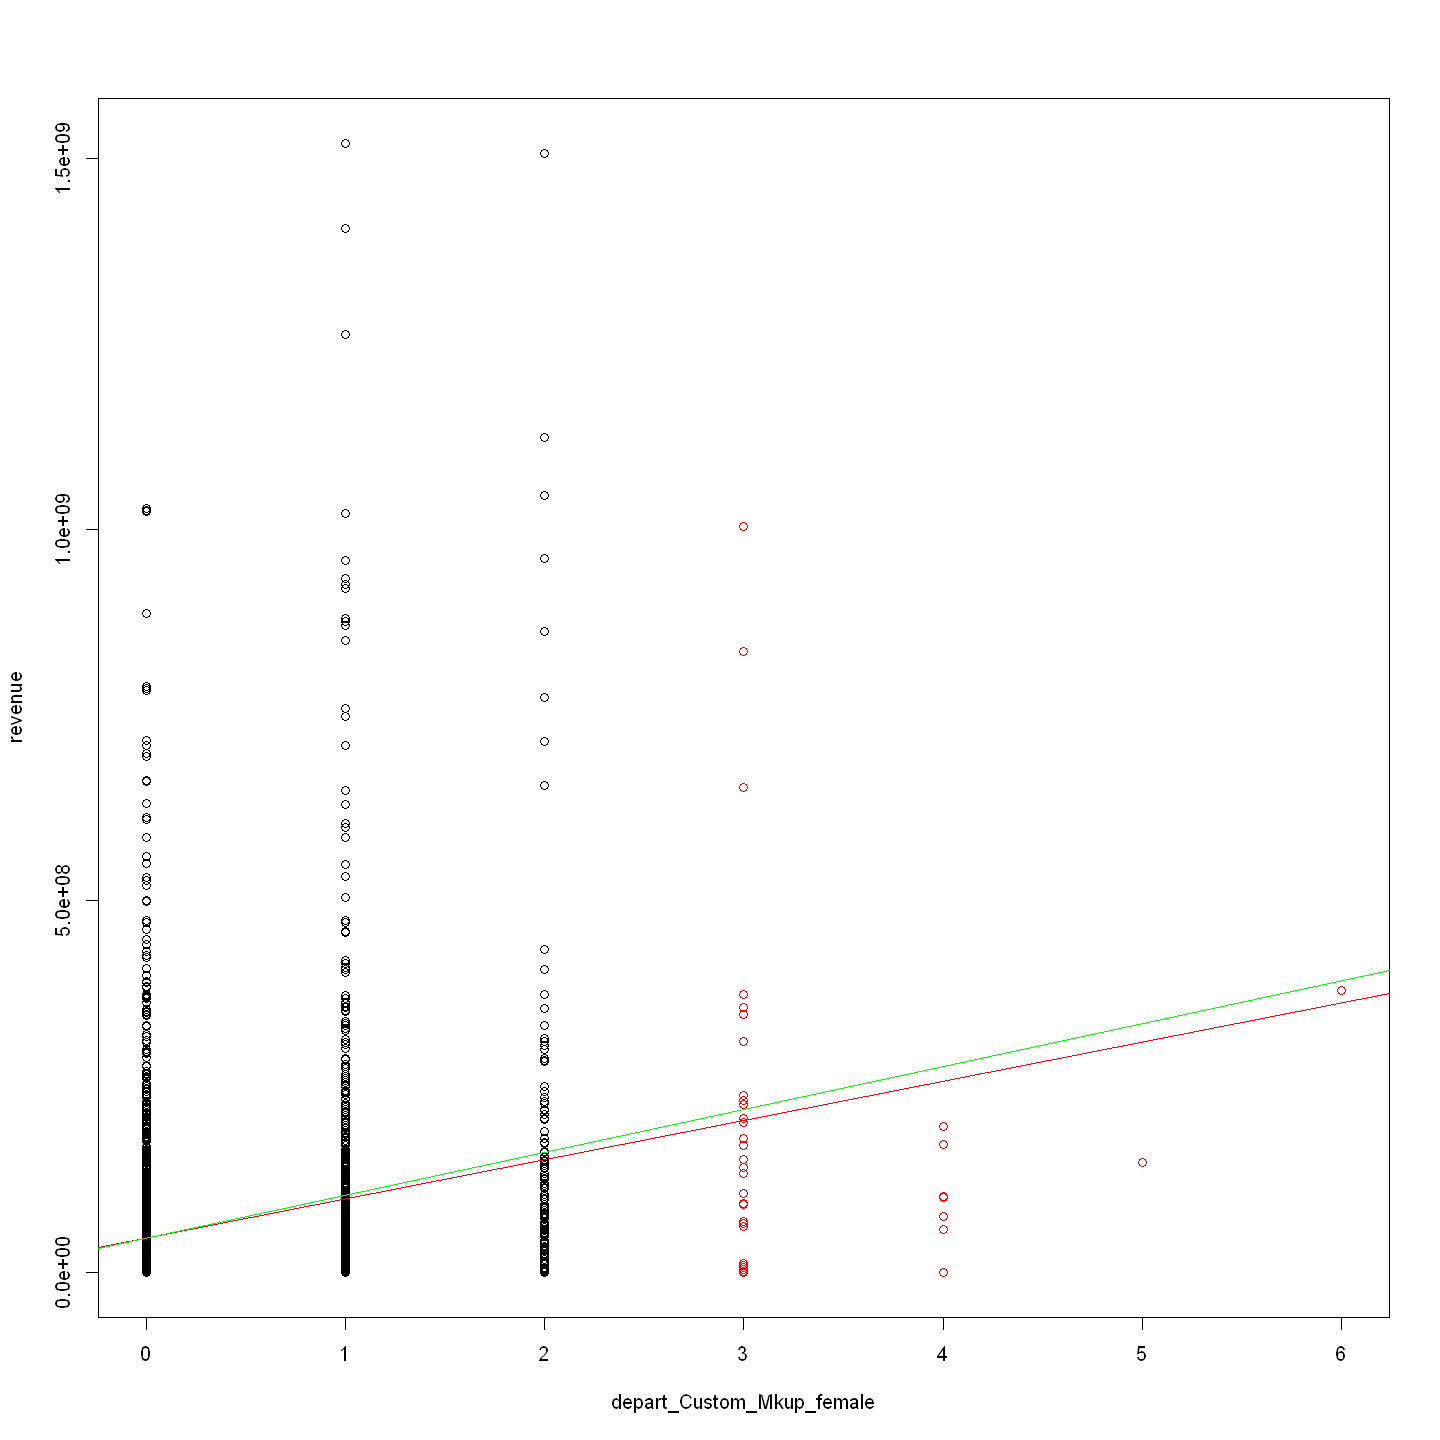

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


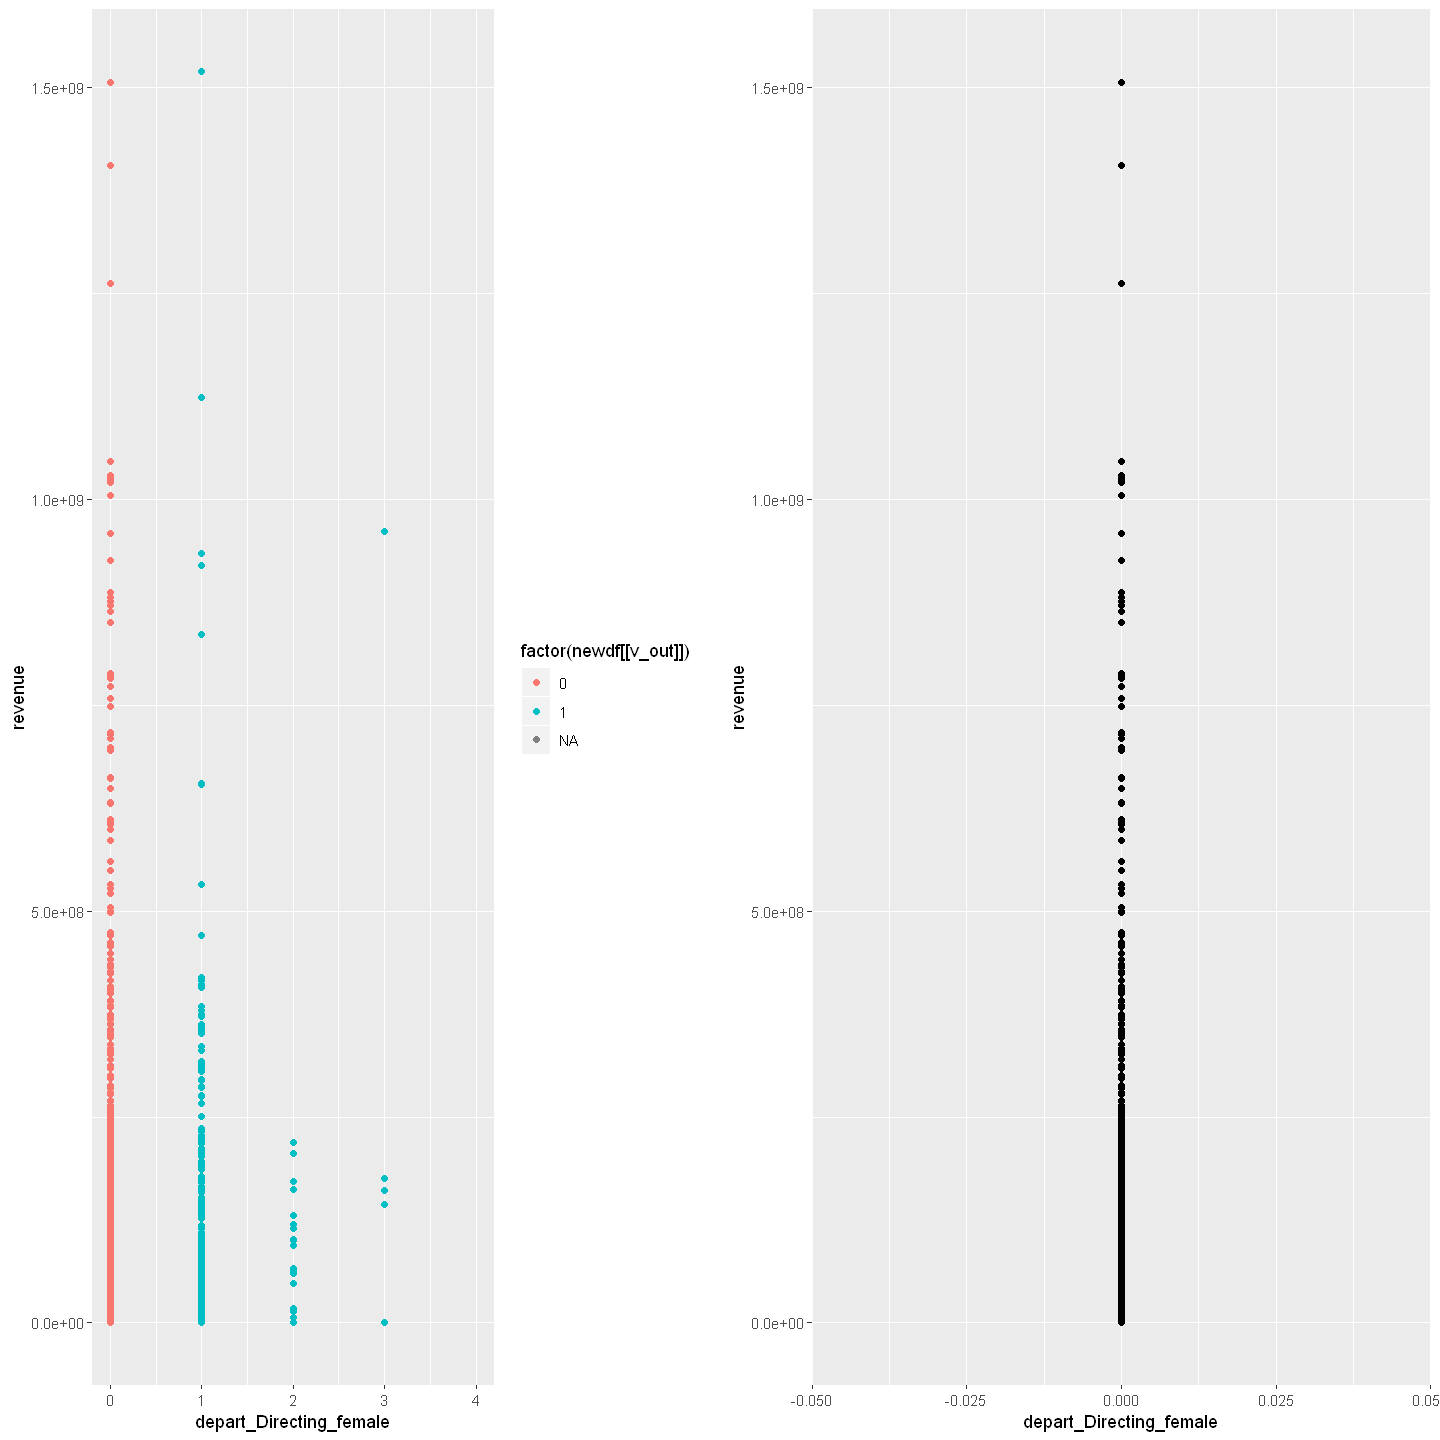

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4748 rows containing missing values (geom_point)."


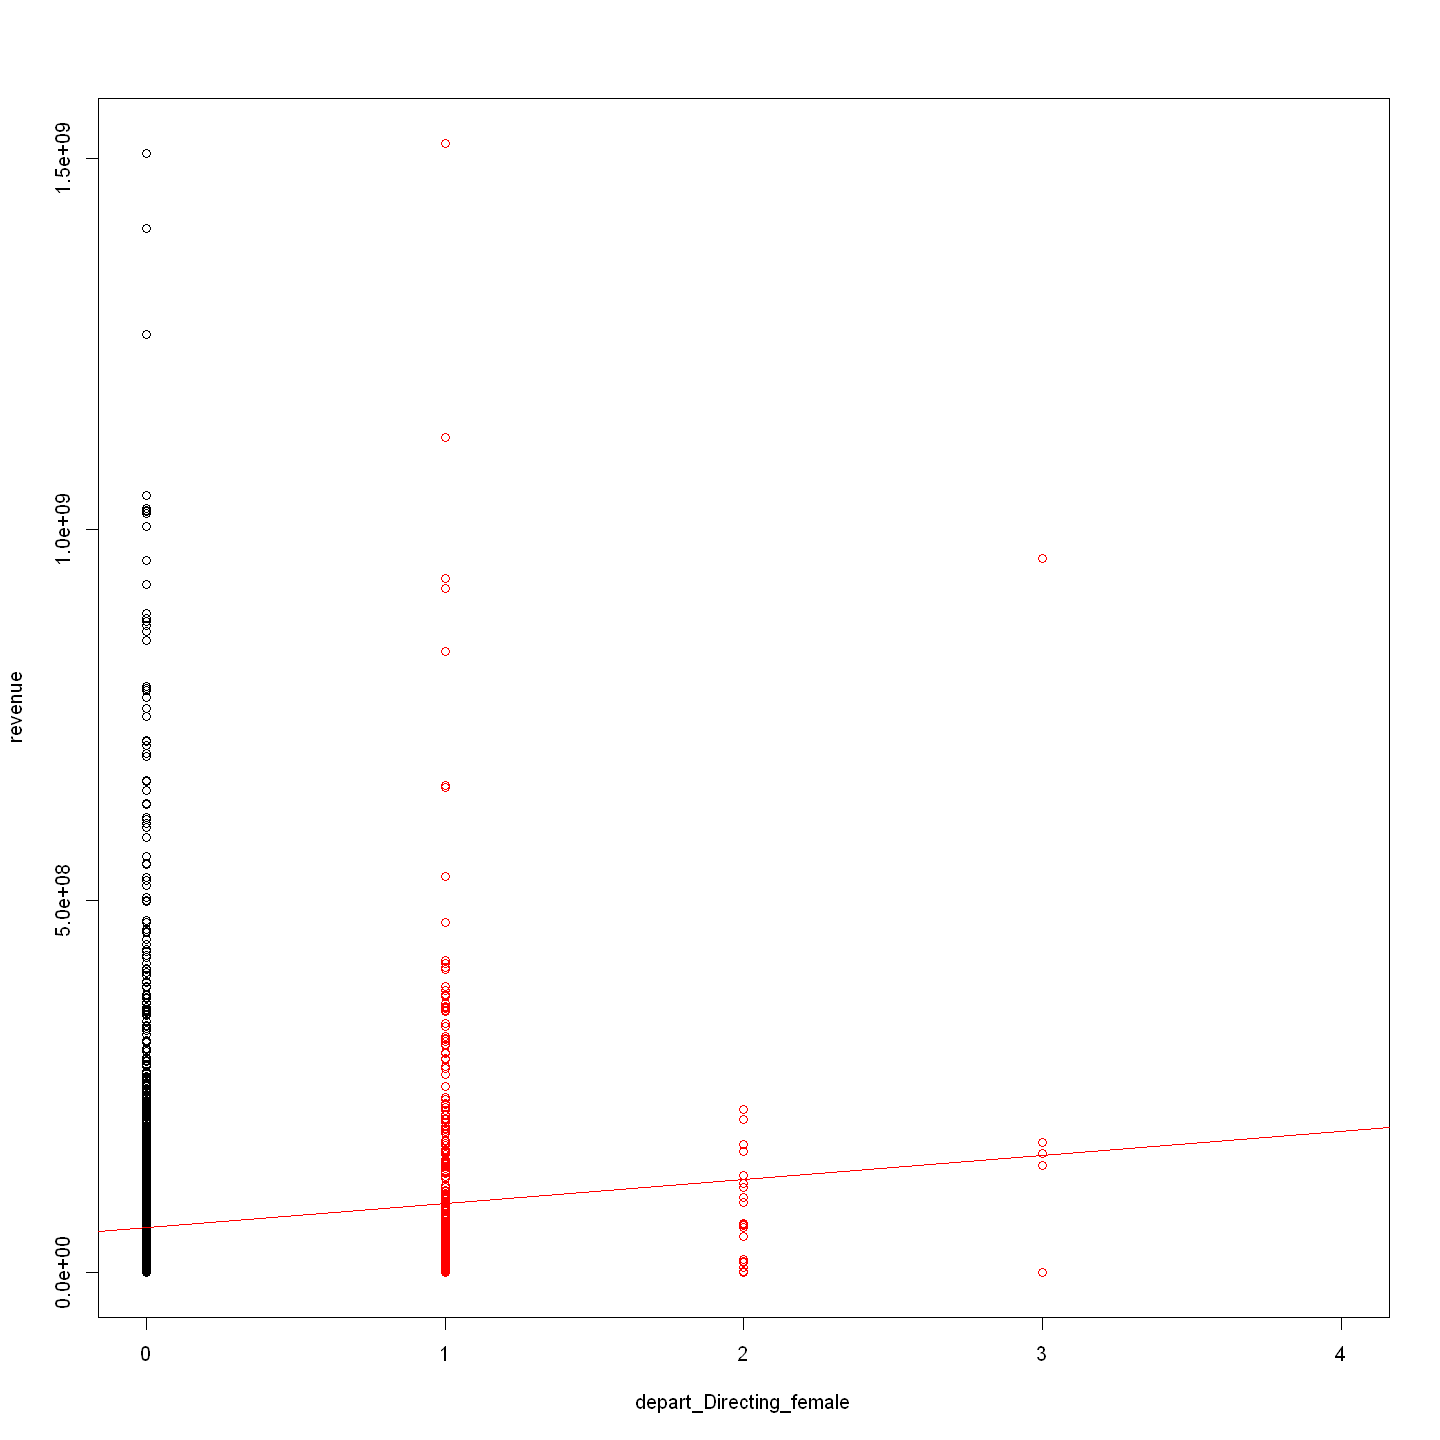

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


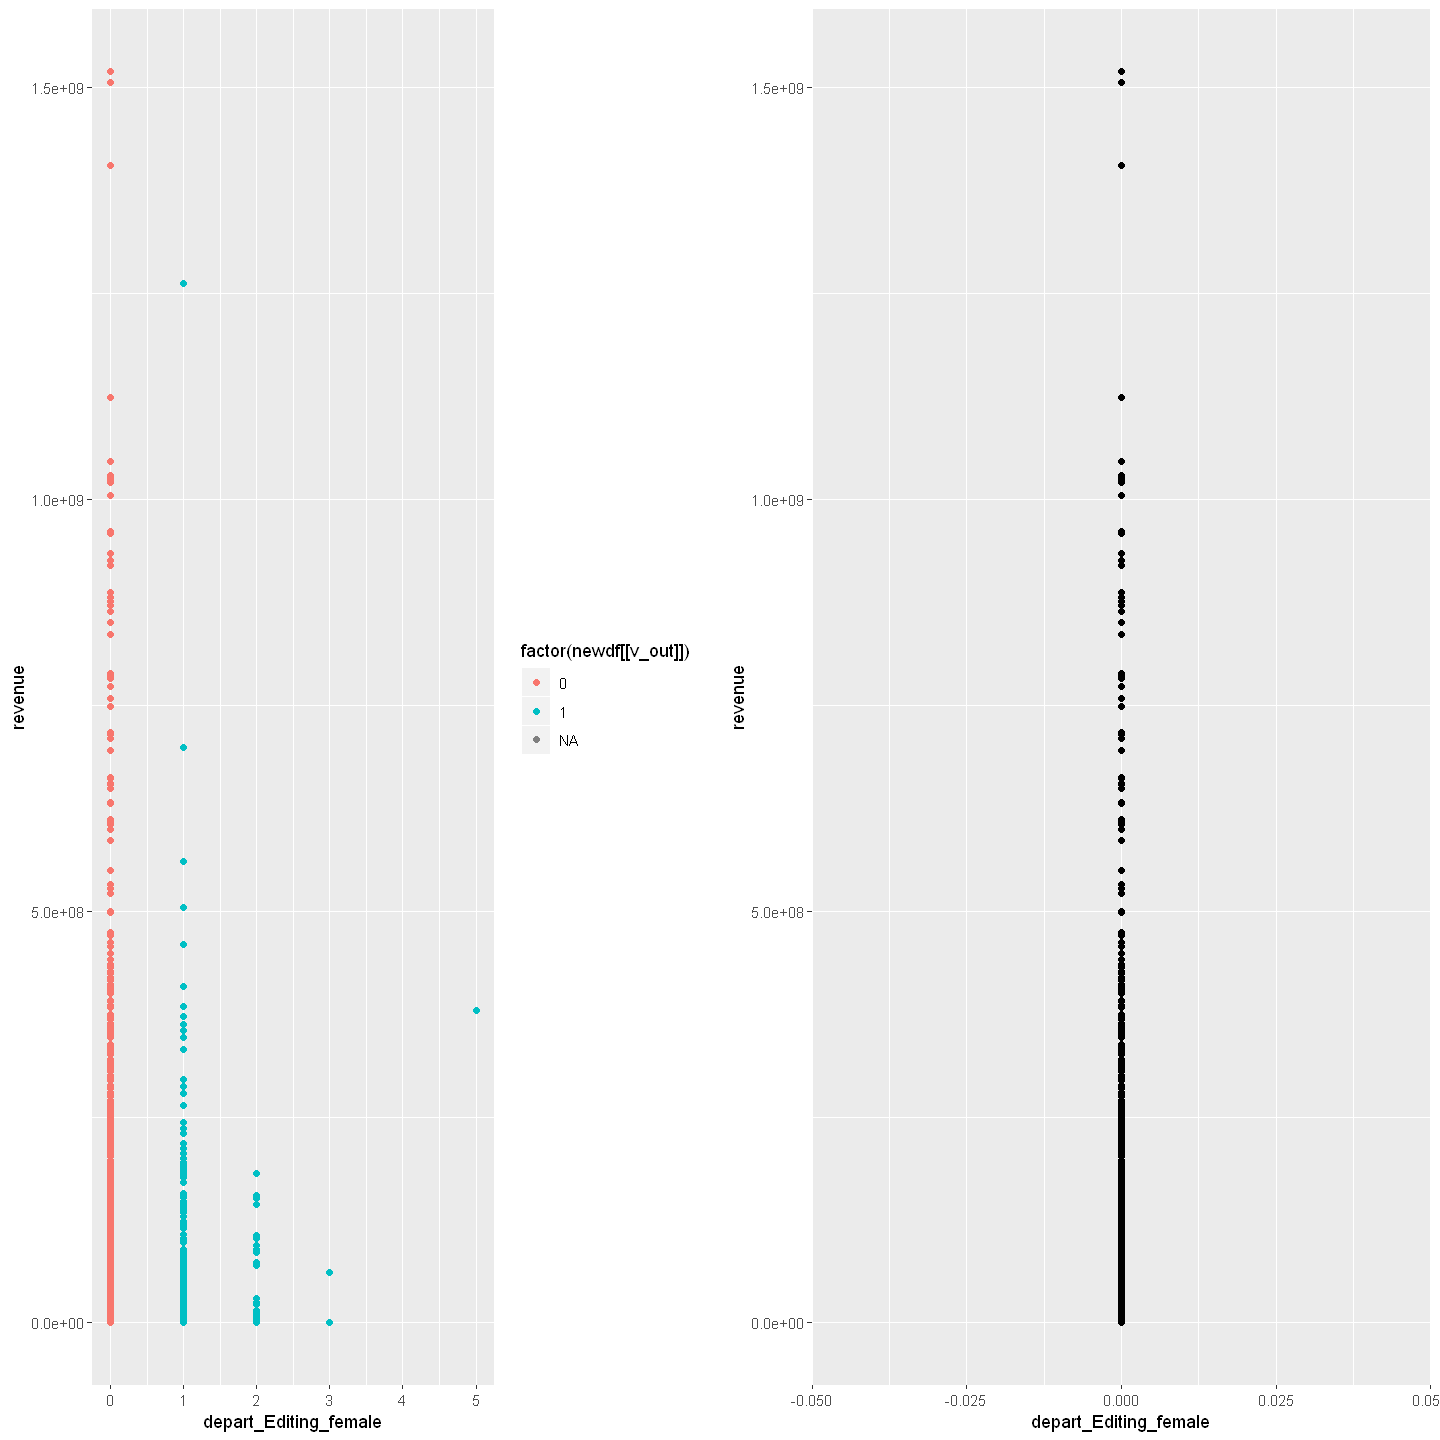

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4401 rows containing missing values (geom_point)."


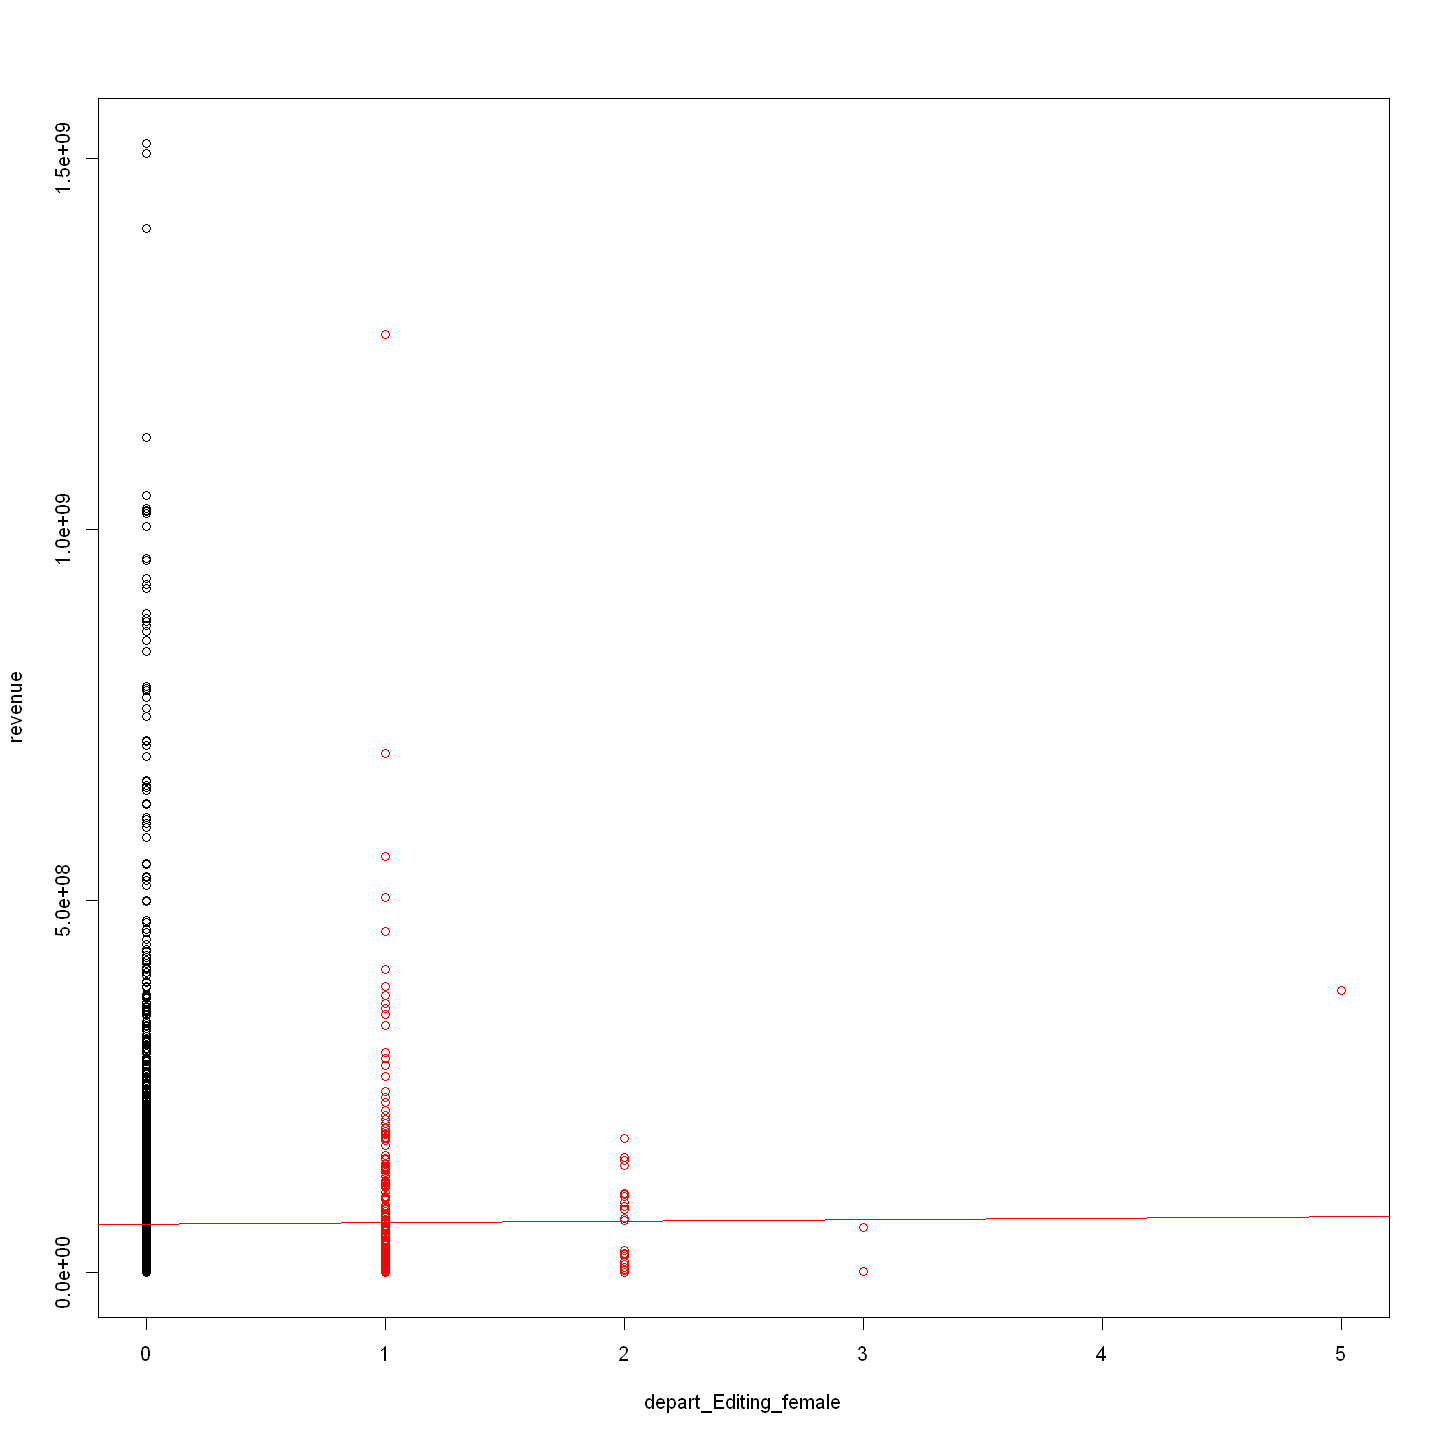

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


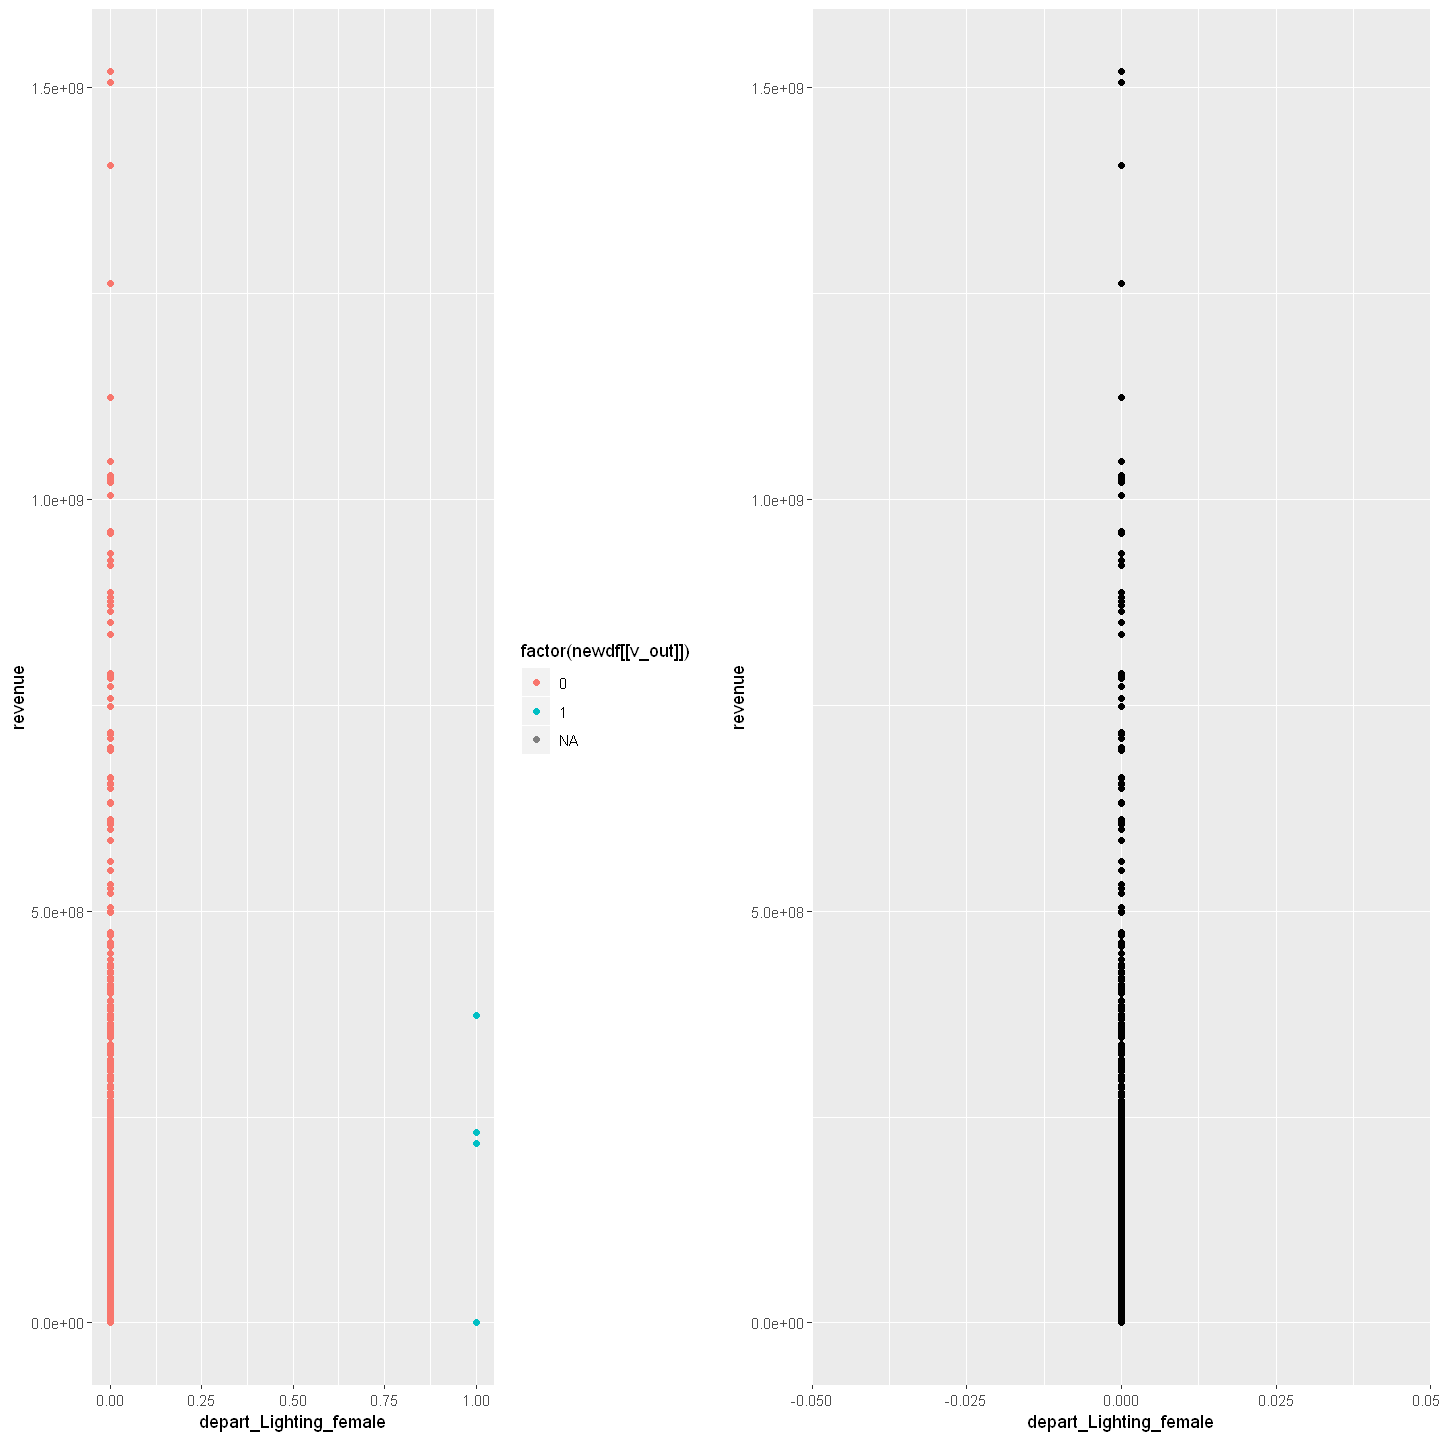

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4432 rows containing missing values (geom_point)."


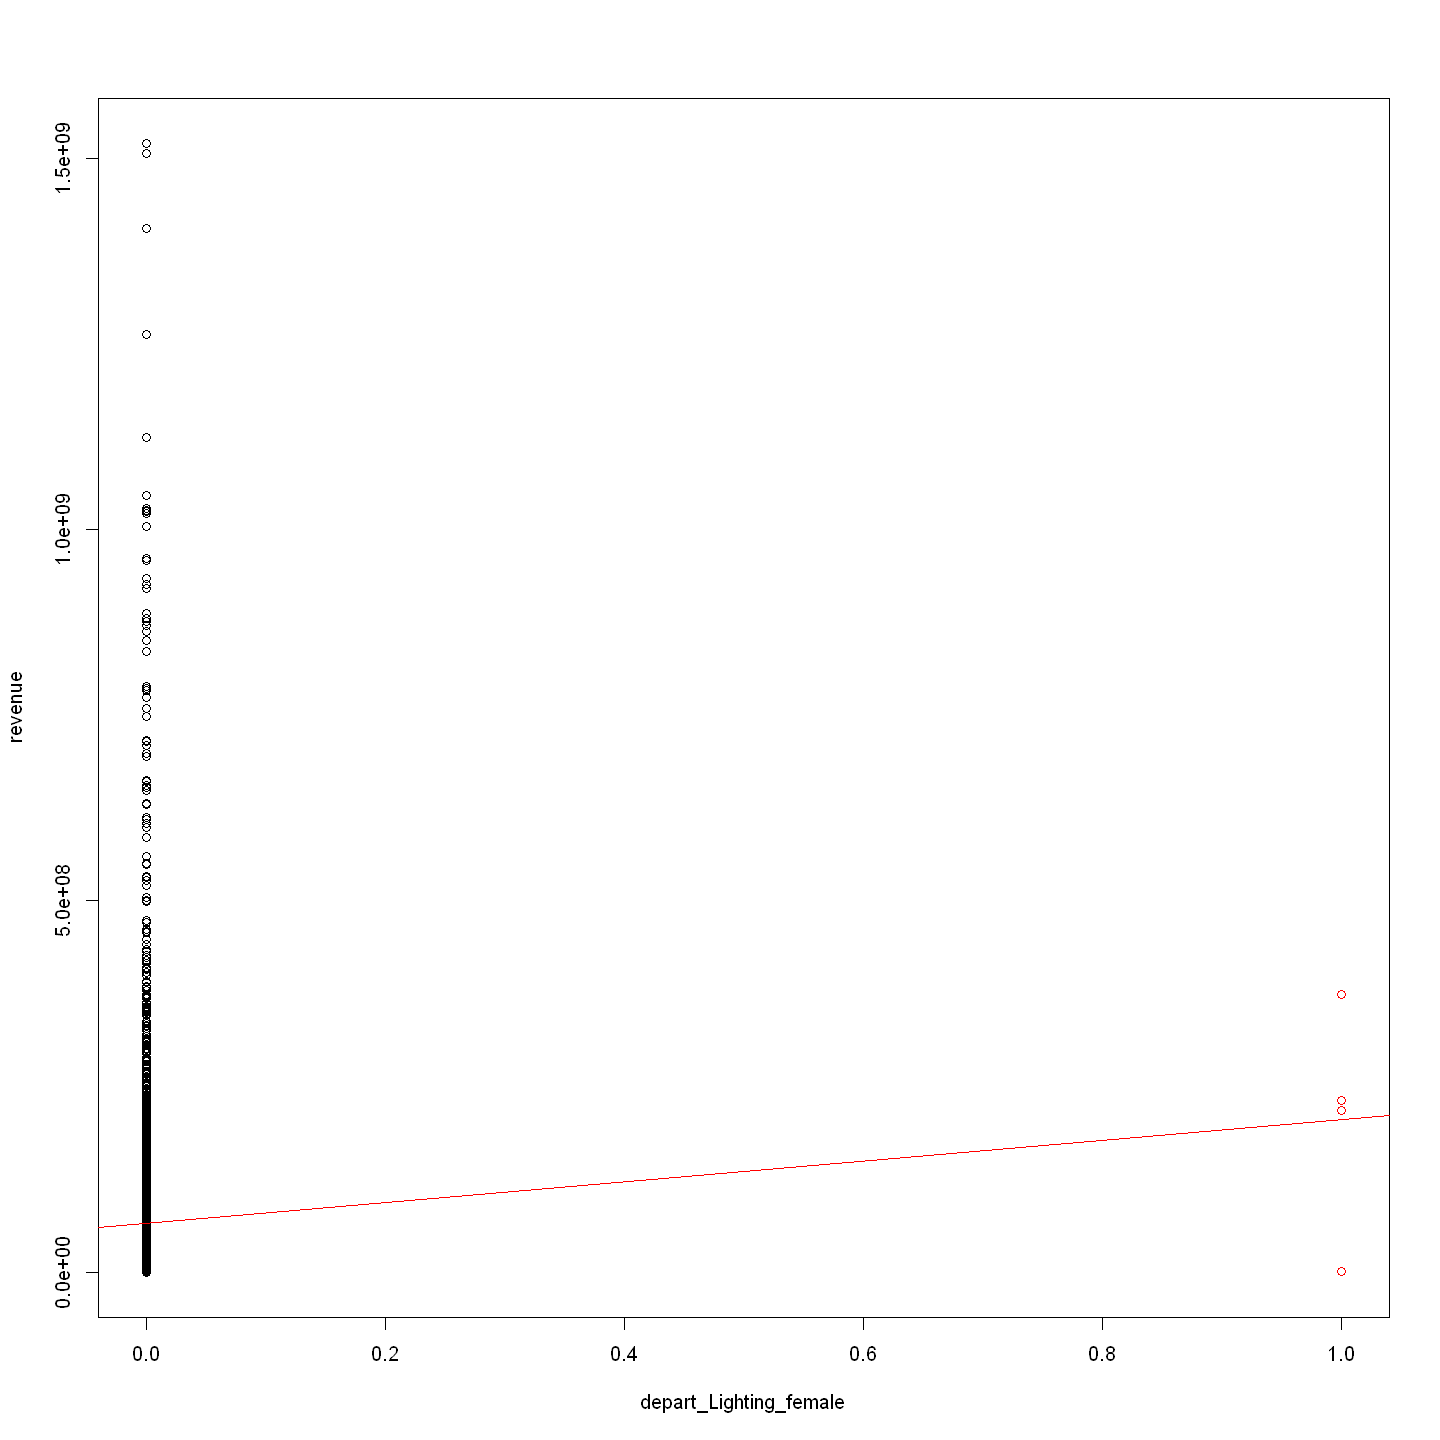

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


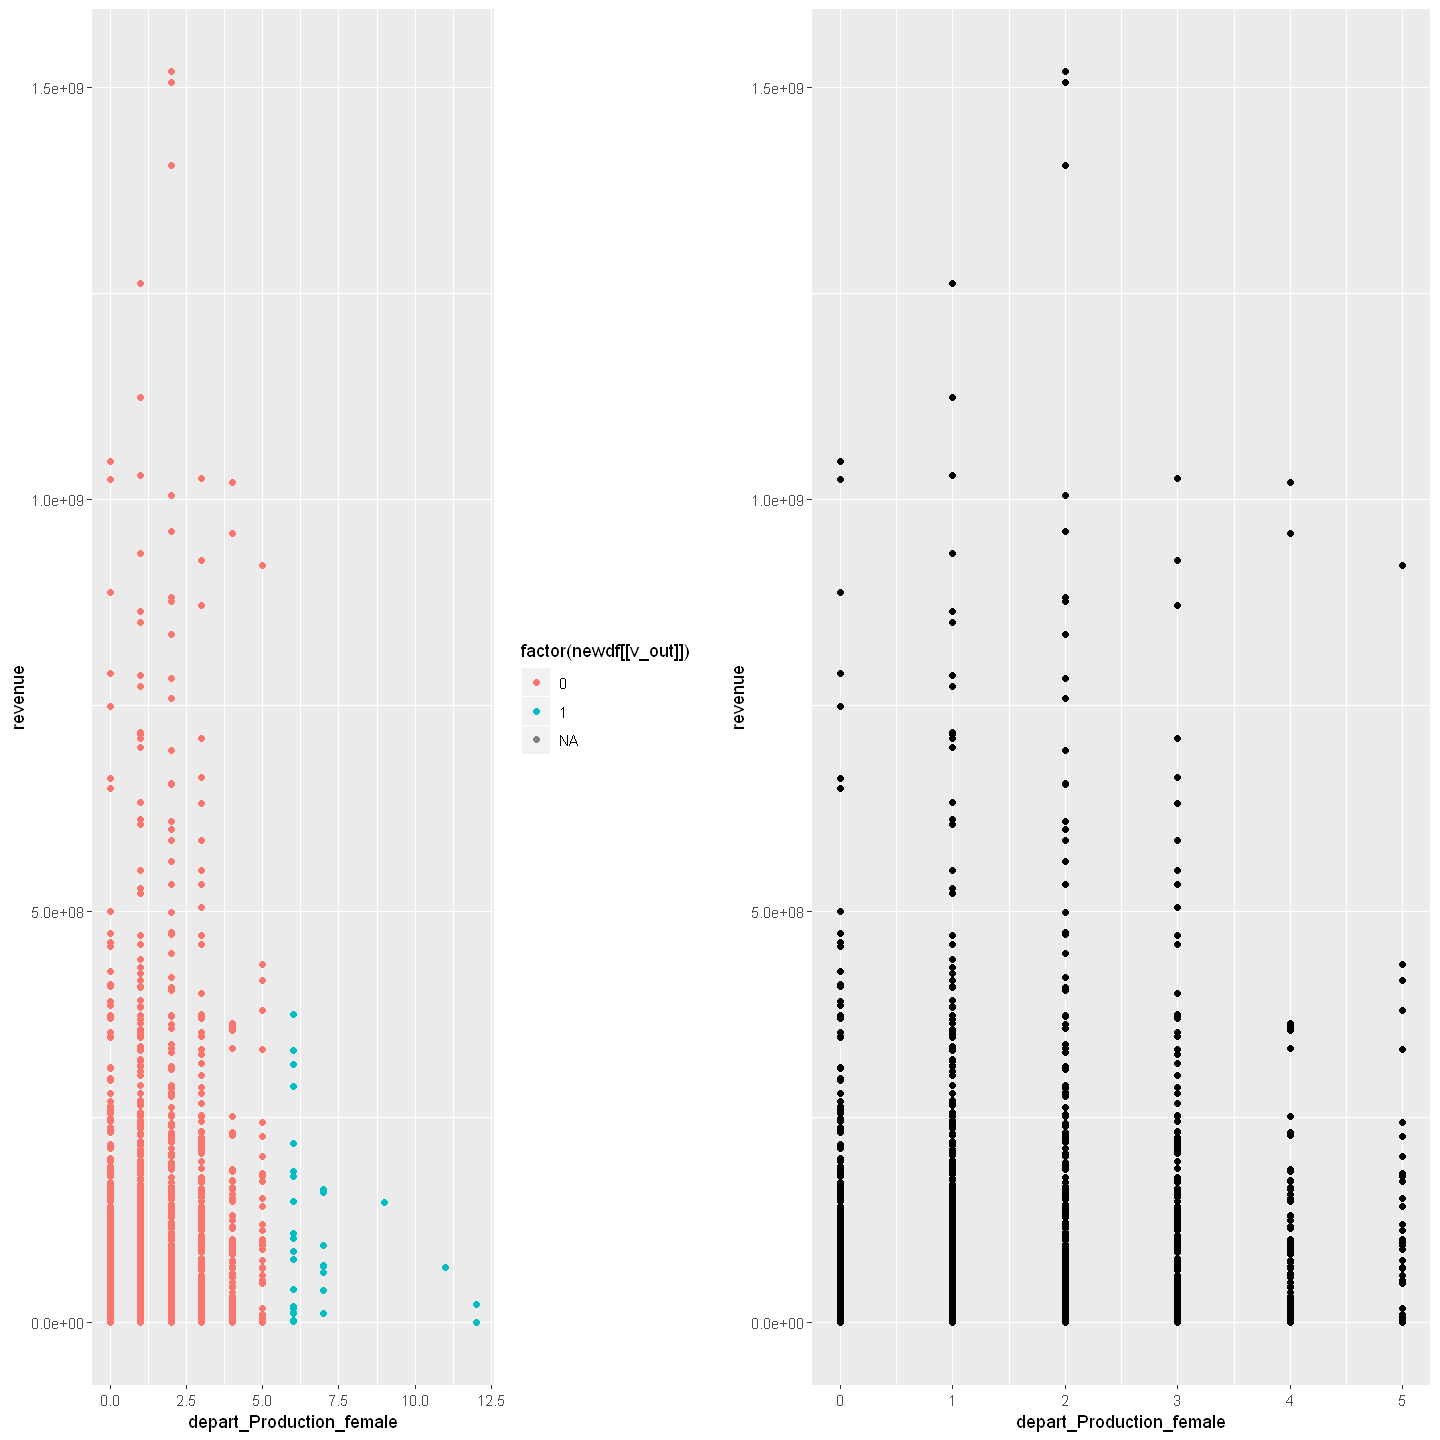

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4613 rows containing missing values (geom_point)."


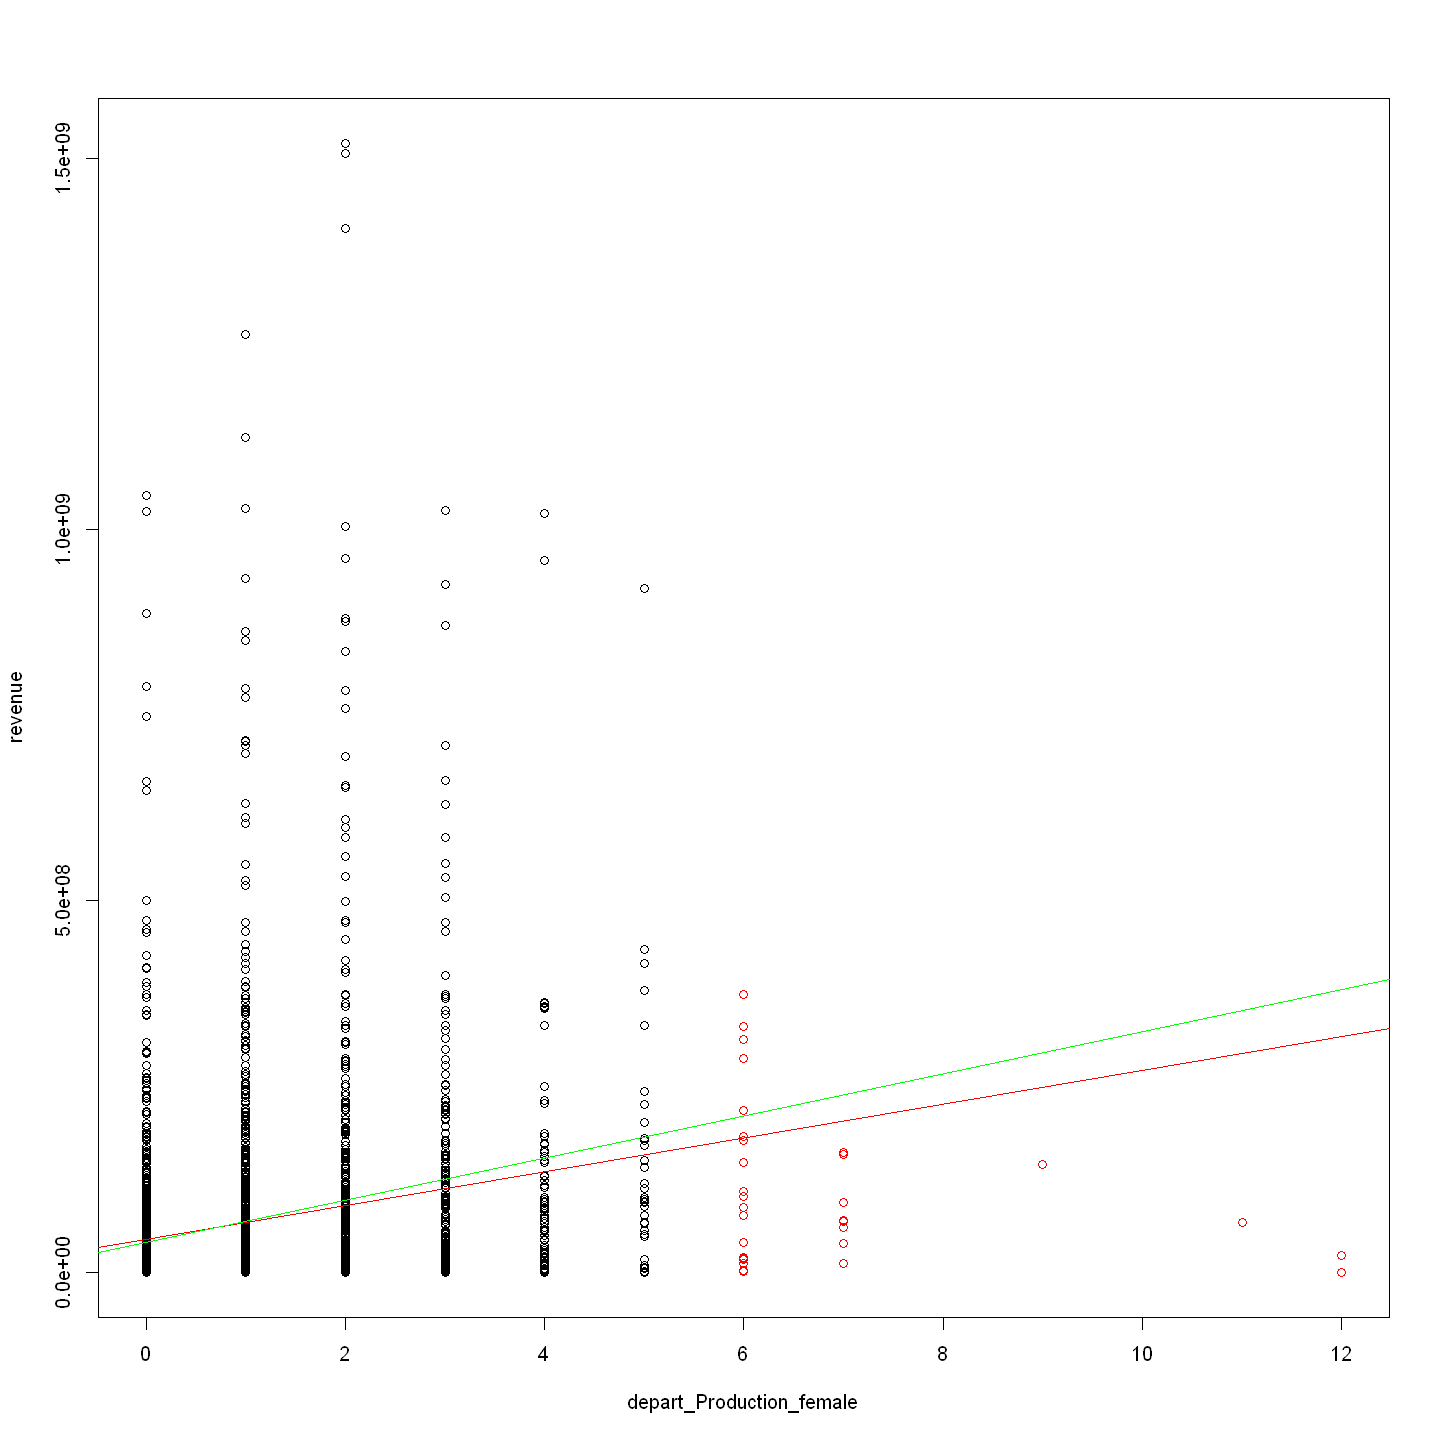

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


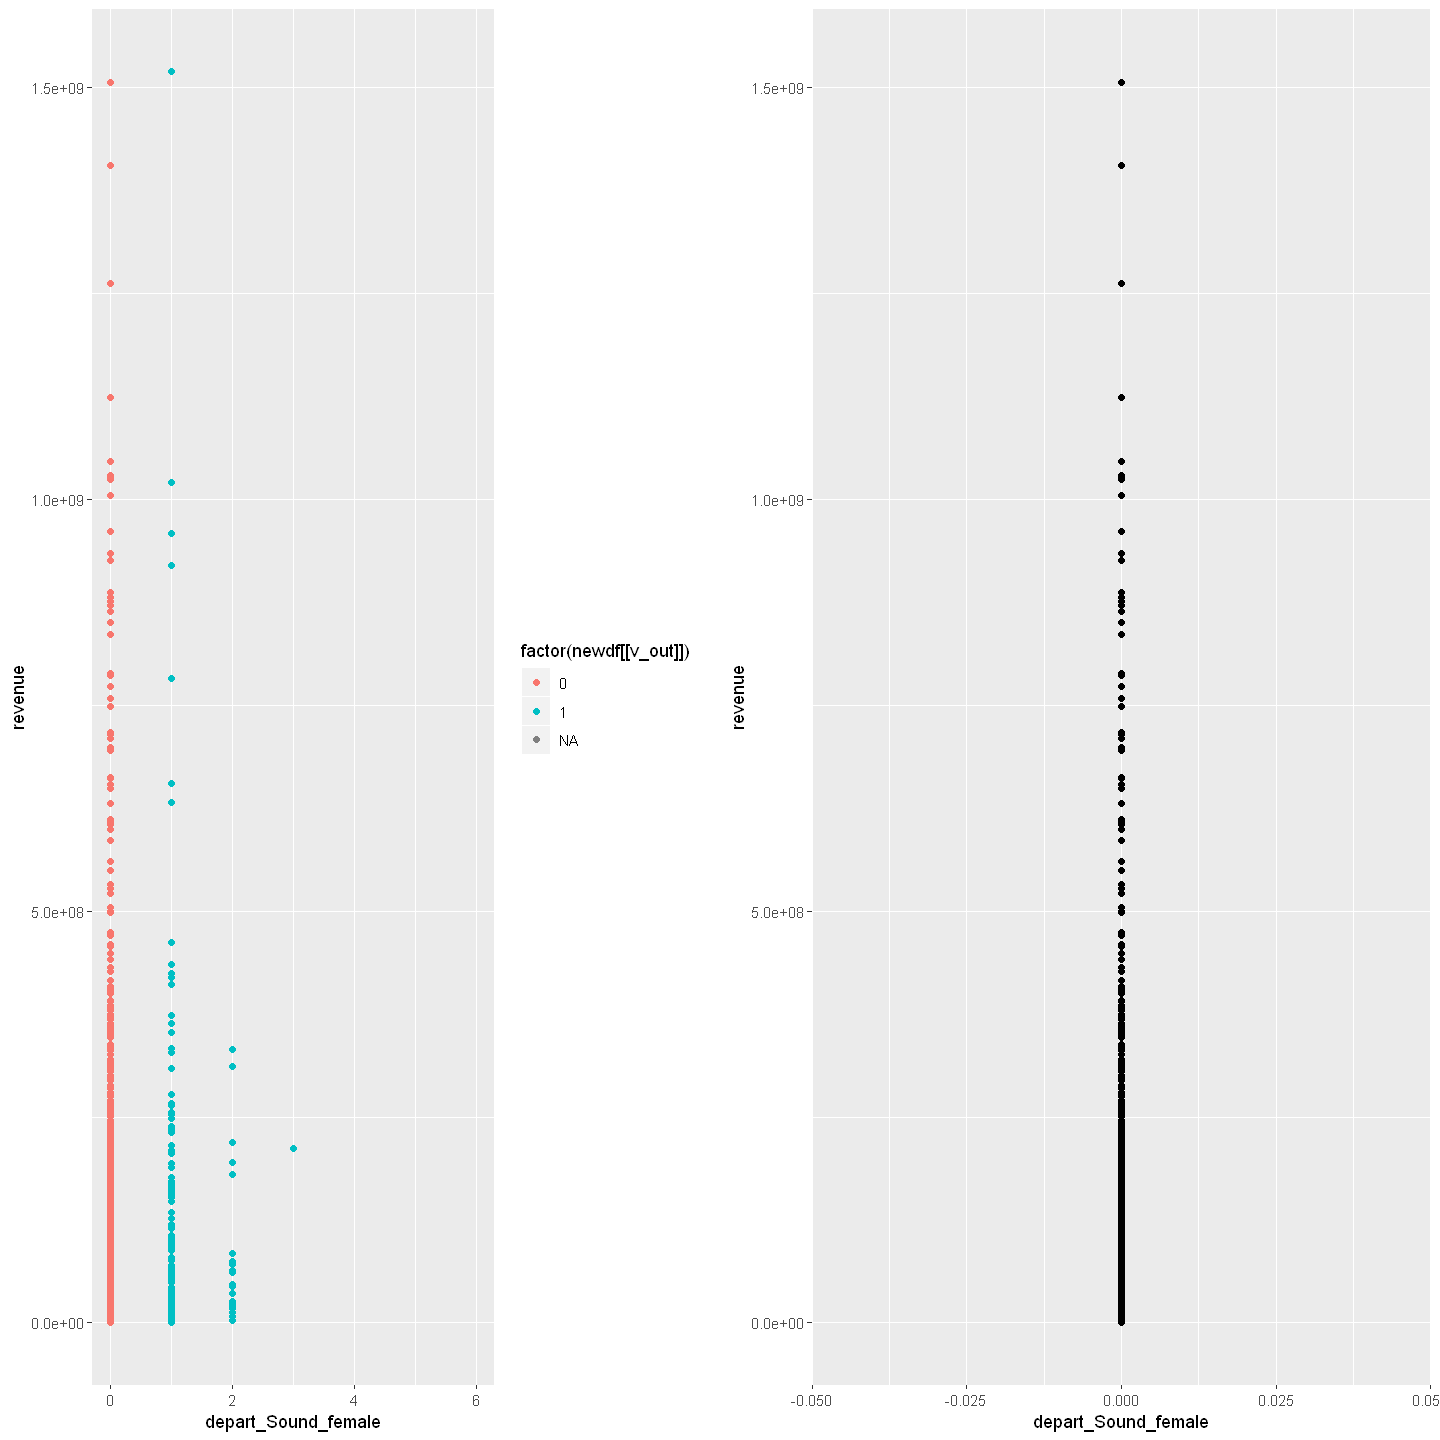

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4419 rows containing missing values (geom_point)."


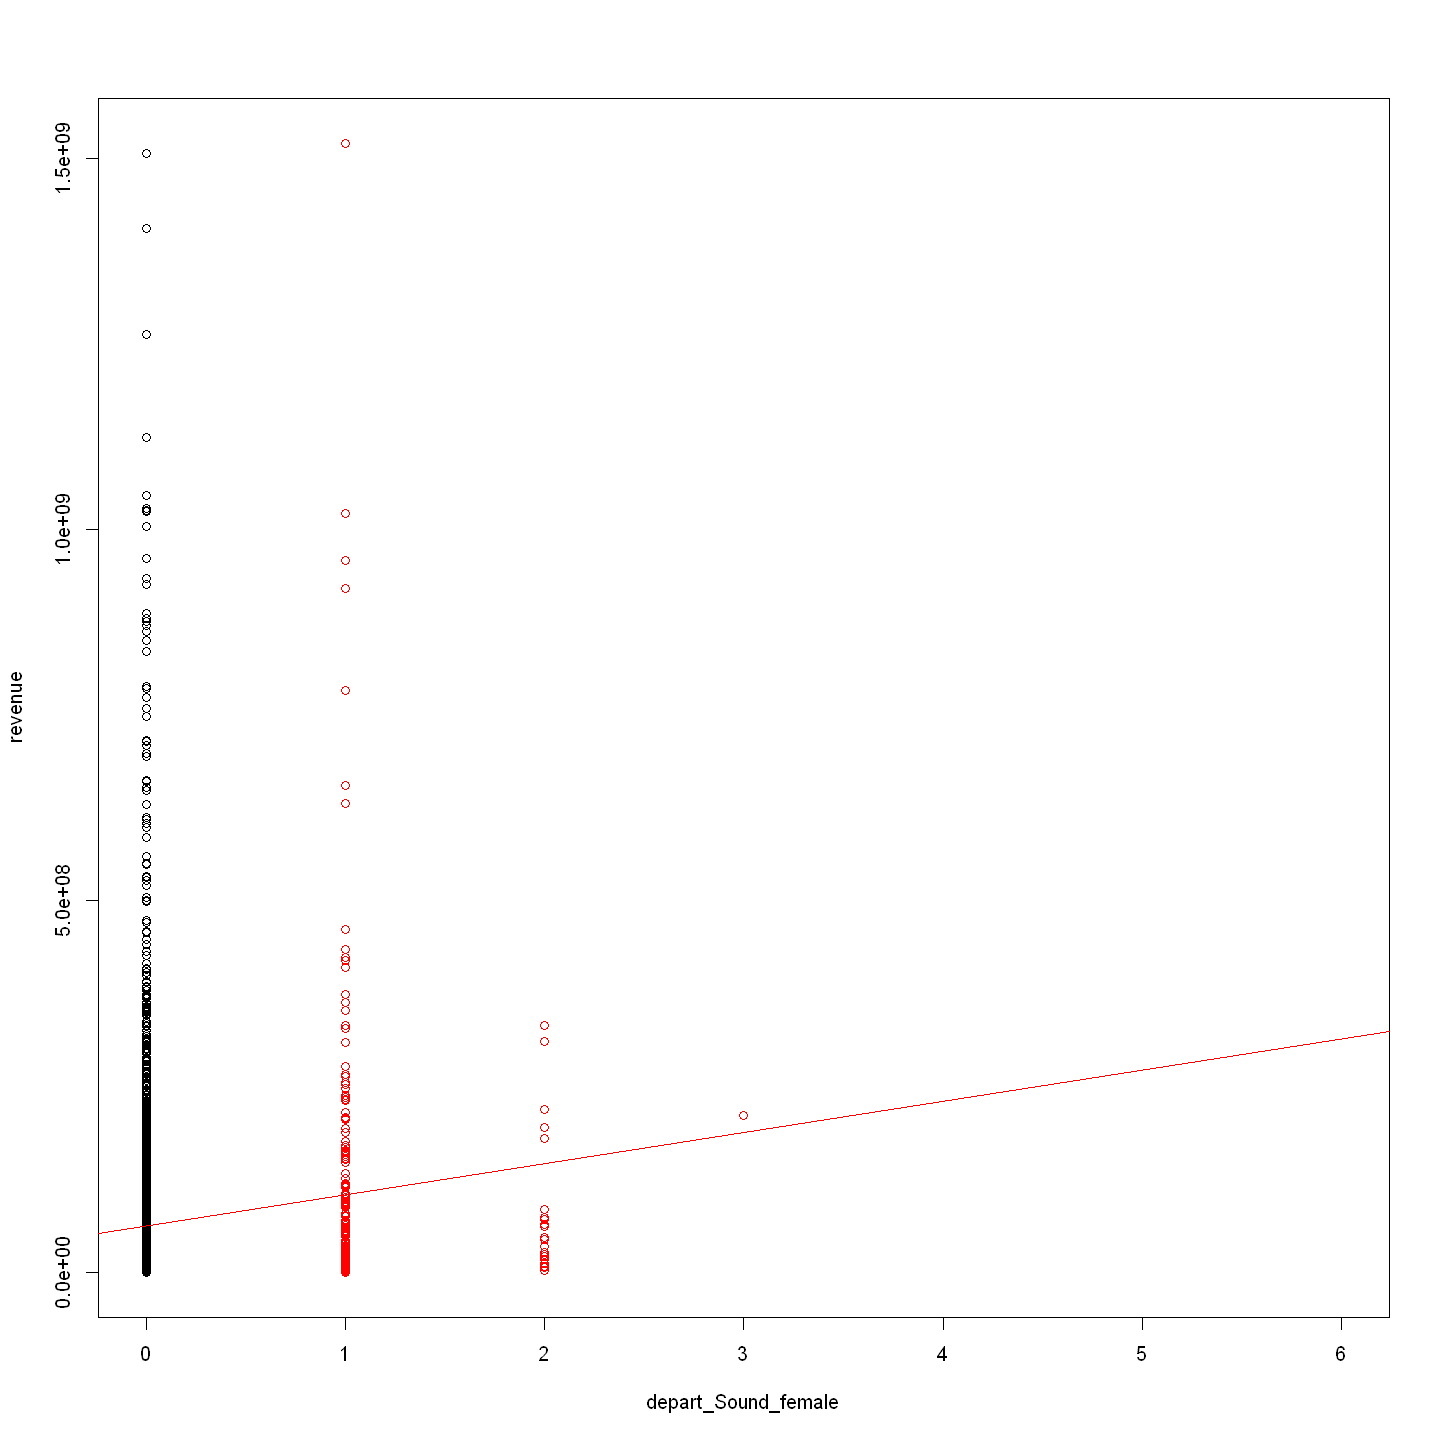

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


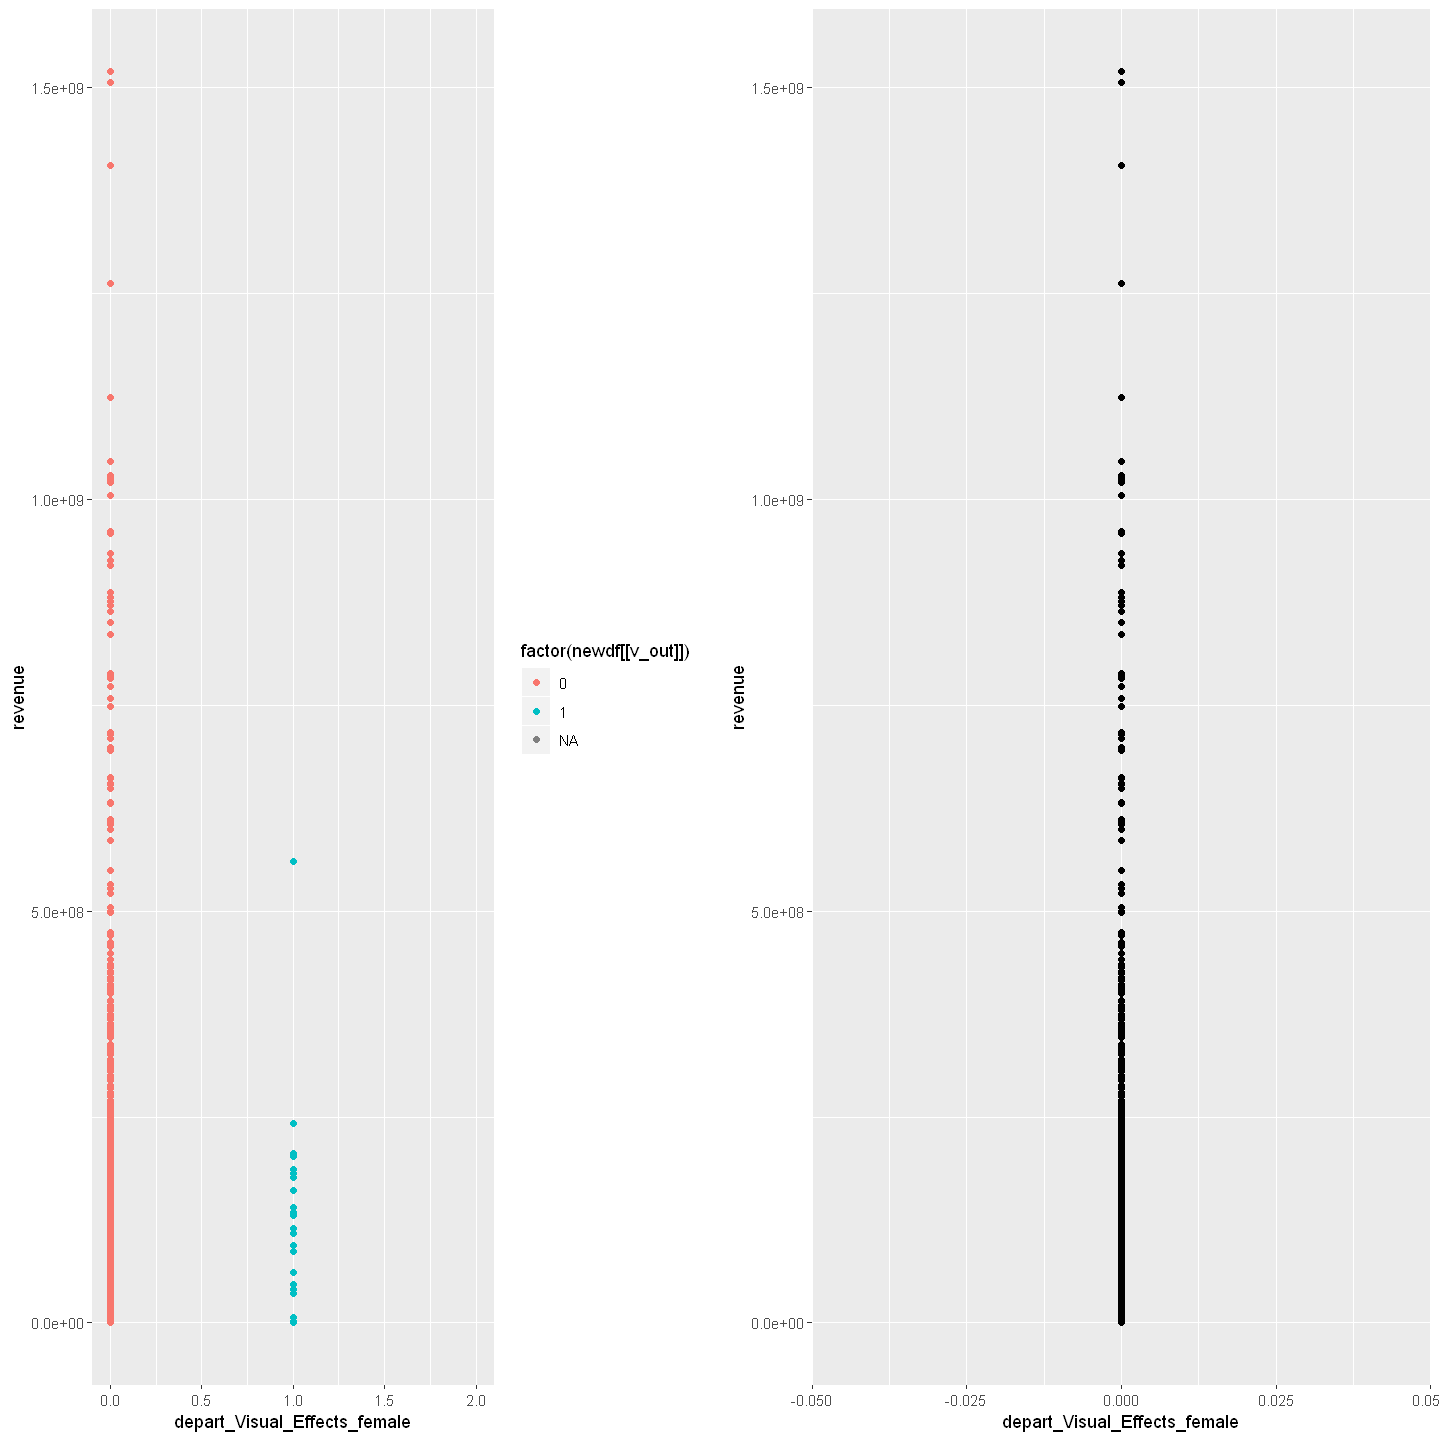

NULL
NULL


Warning message:
"Removed 4397 rows containing missing values (geom_point)."
Warning message:
"Removed 4716 rows containing missing values (geom_point)."


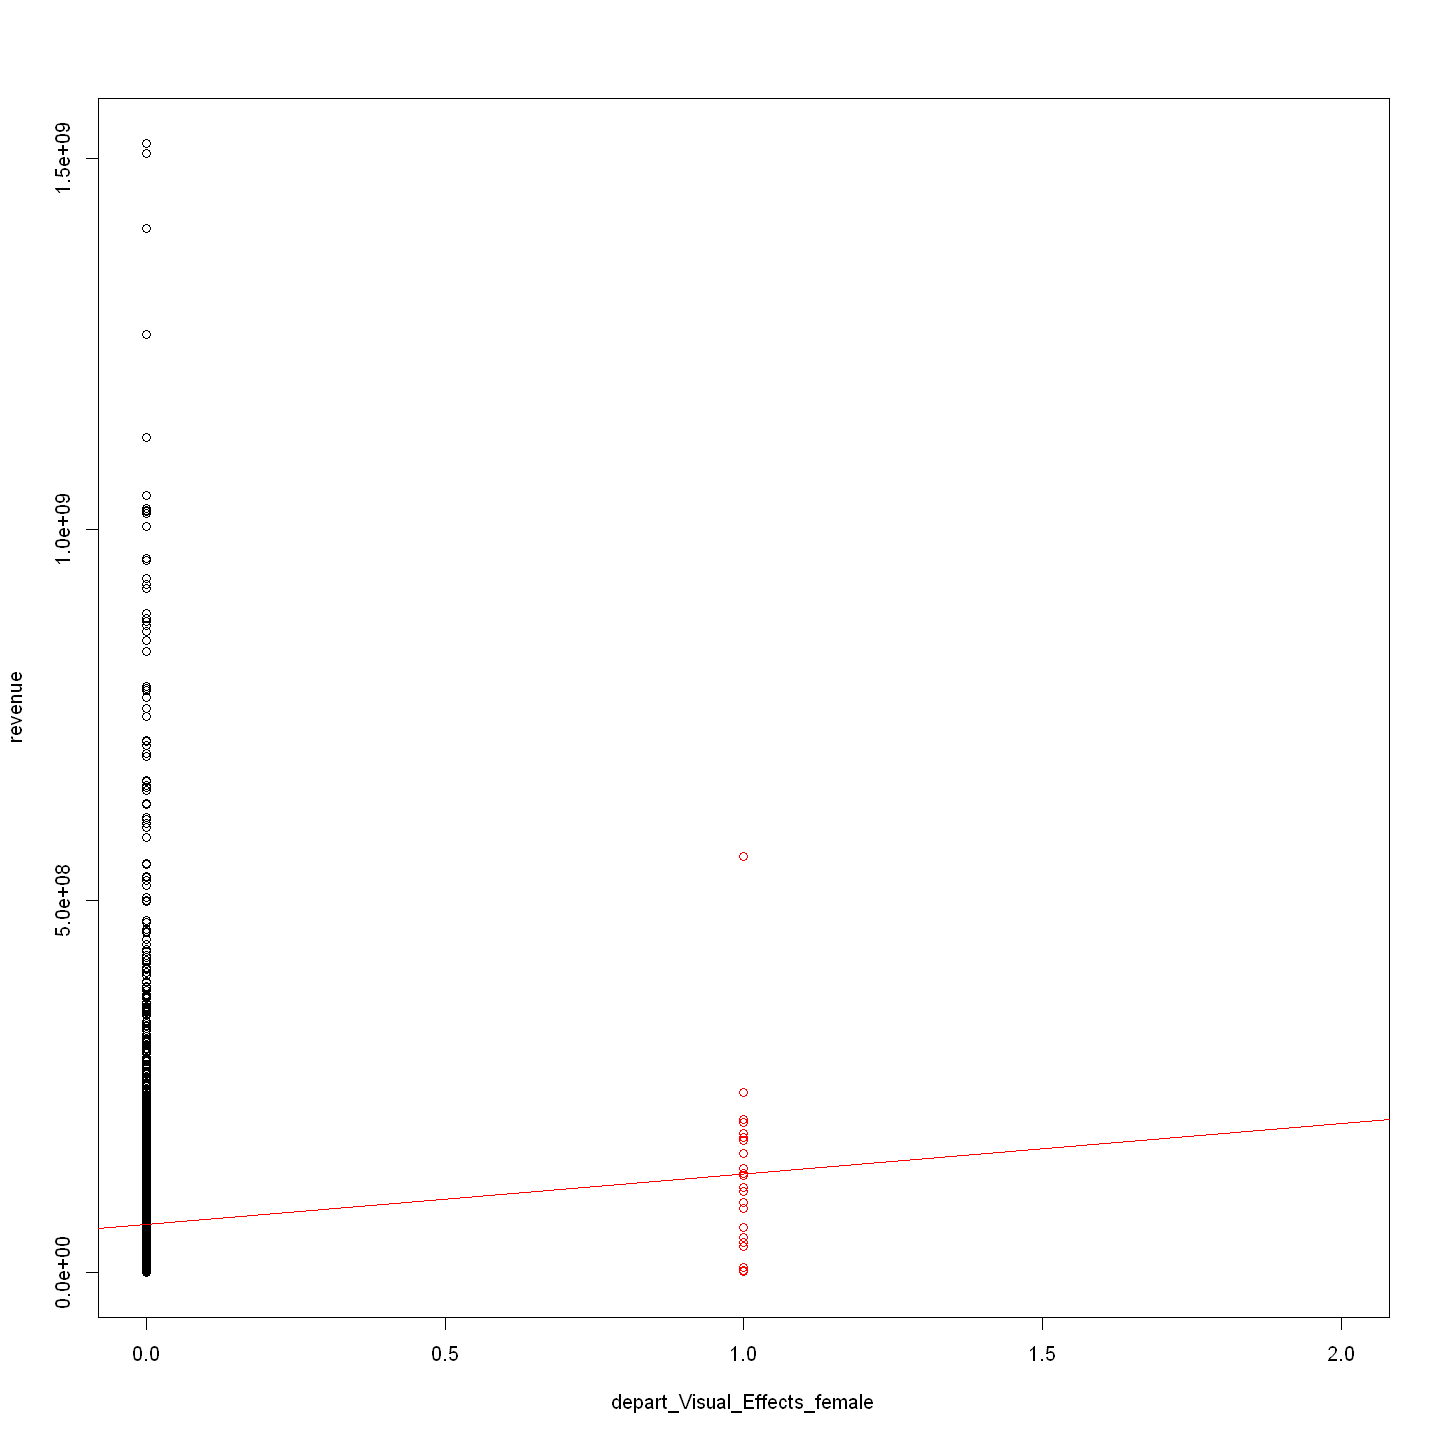

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


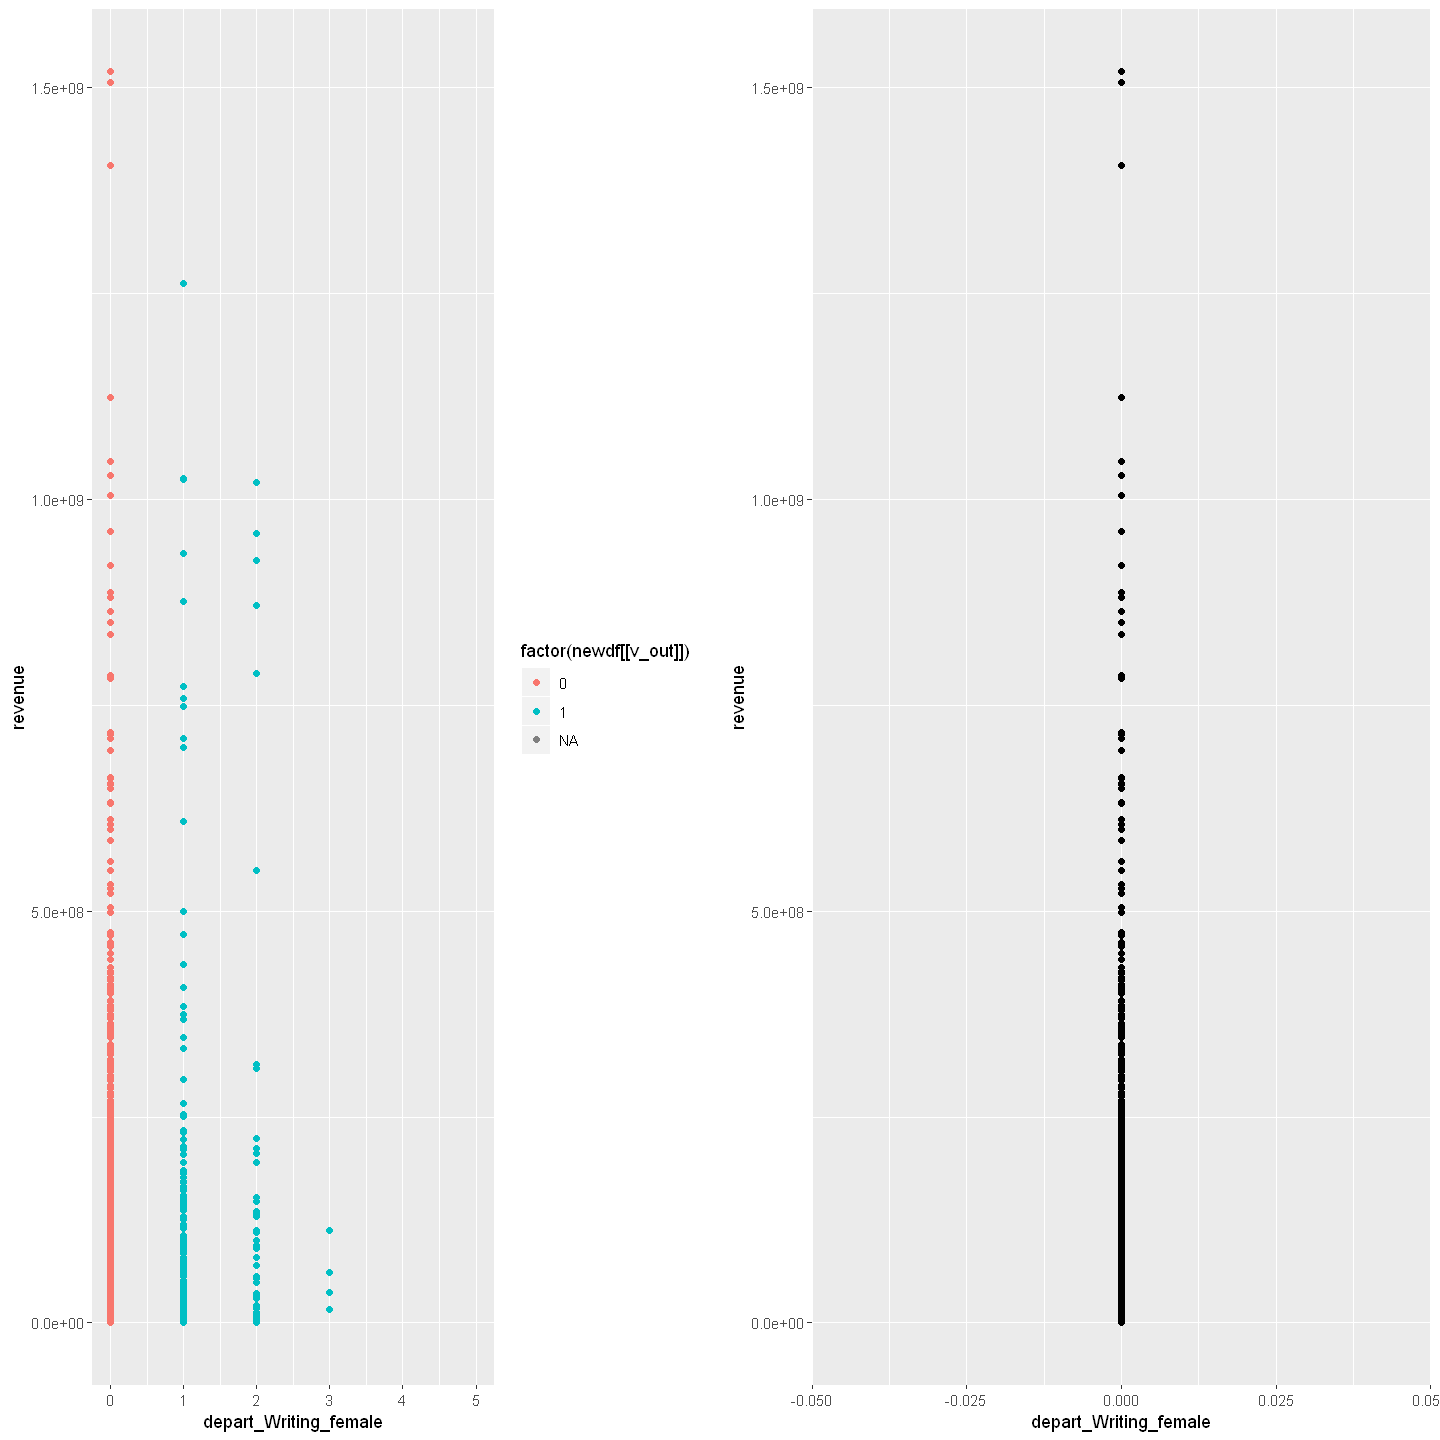

NULL
NULL


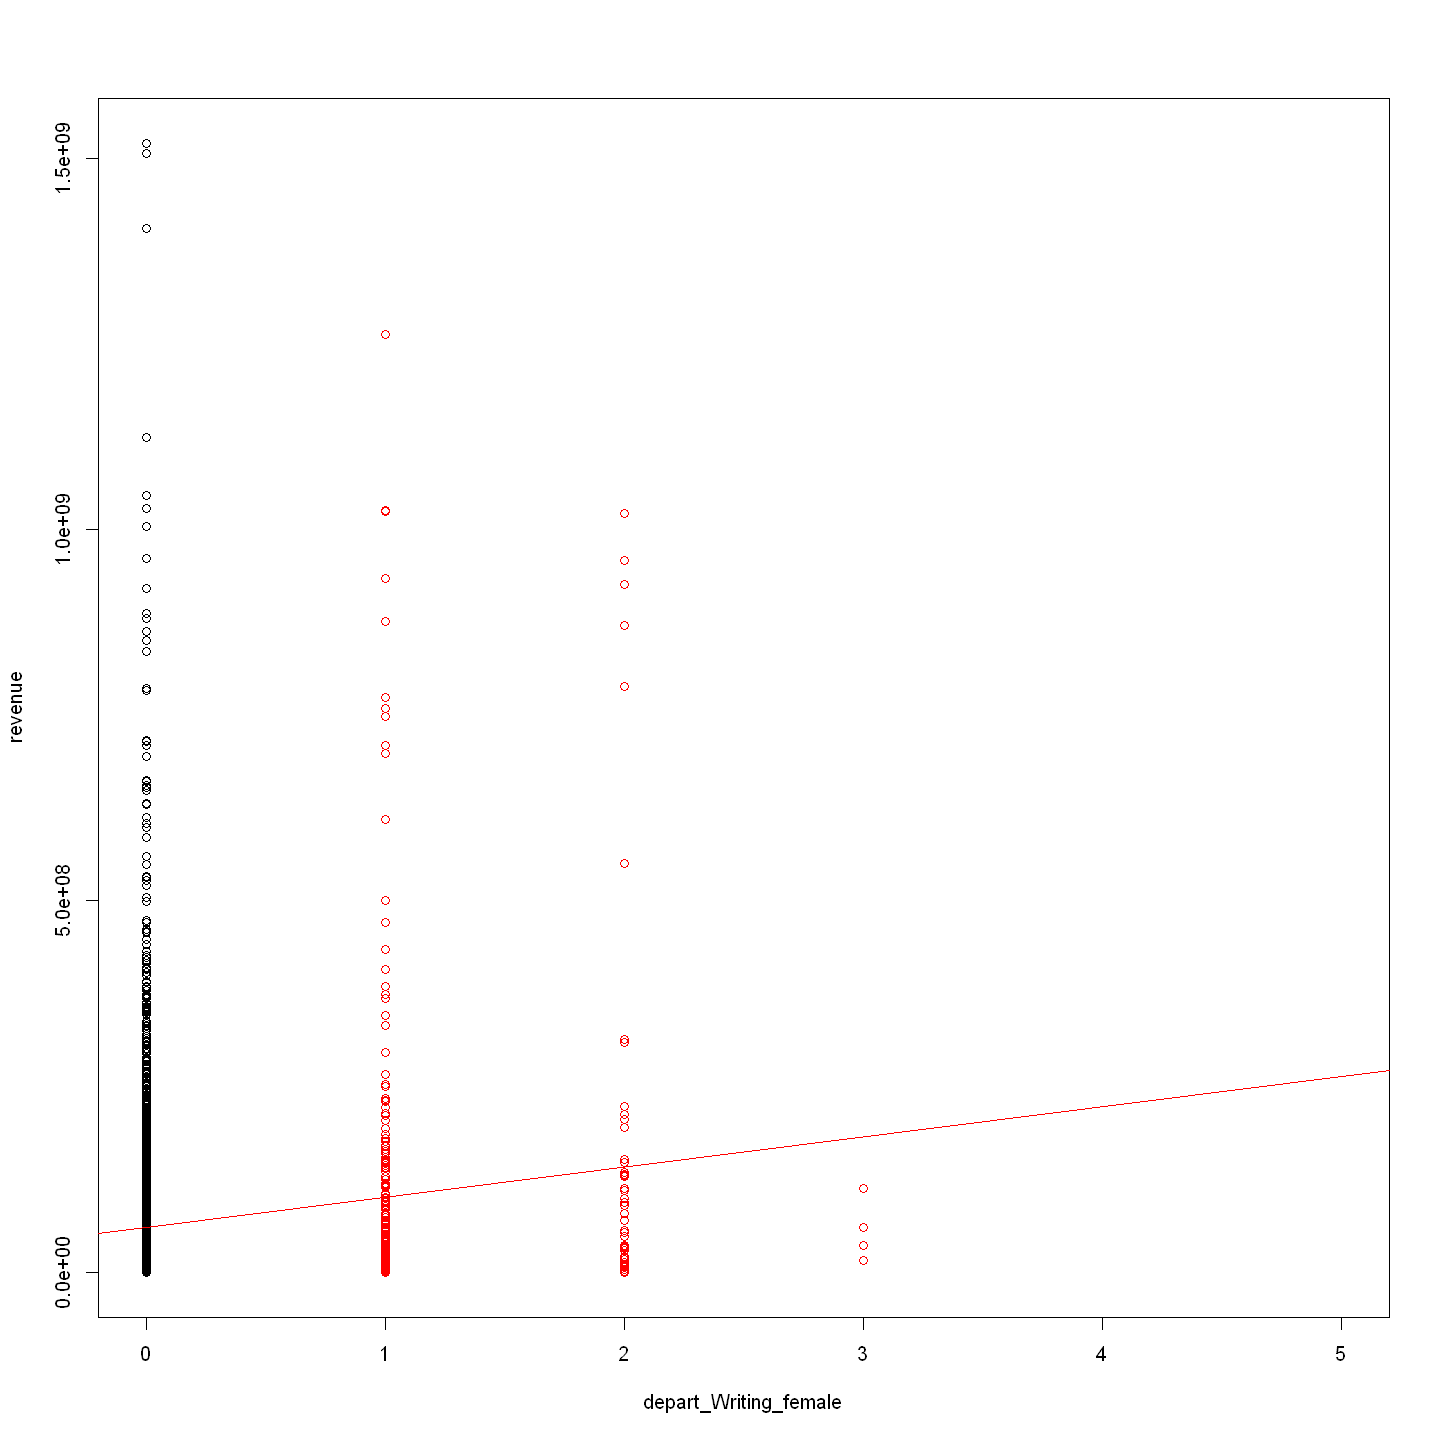

In [136]:
options(repr.plot.width = 12, repr.plot.height = 12) 
for (v in names(my_num_data[,2:82])){
    v_out <-paste0(v,"_out") 
    v.noout <- newdf[[v]]
    v.noout <- ifelse(newdf[[v_out]]==1,NA,v.noout)
    p1 <- ggplot() + geom_point(aes(x=newdf[[v]], y=newdf[['revenue']], color=factor(newdf[[v_out]]))) +labs(x= v , y="revenue")
    p2 <- ggplot() + geom_point(aes(x=v.noout, y=newdf[['revenue']])) +labs(x= v , y="revenue")
    print (grid.arrange(p1, p2, nrow = 1))    
    mod1 <- lm(newdf[['revenue']] ~ newdf[[v]])
    mod2 <- lm(newdf[['revenue']] ~ v.noout)
    print(plot(newdf[[v]], newdf[['revenue']], col=factor(newdf[[v_out]]),xlab=v,ylab='revenue'))
    print(abline(mod1, col="red"))
    if (dim(table(v.noout)) != 1){
            abline(mod2, col="green")
        }
    
}


# 3.1.3 treating outliers

In [138]:
outliers_treatments <- read.csv("Box_office_outliers.csv")

In [139]:
## I was analizing the continious variables by comparing to mechkar resolt ##
outliers_treatments

Variable                     Density.change      
1  budget                       no change in density
2  popularity                   no change in density
3  runtime                      no change in density
4  revenue                      no change in density
5  keyword_cnt                  no change in density
6  release_year                 were no changes     
7  producers_cnt                were no changes     
8  countries_cnt                were no changes     
9  actor0_movies_cnt            no change in density
10 actor0_movies_5y_cnt         were no changes     
11 actor1_movies_cnt            were no changes     
12 actor1_movies_5y_cnt         were no changes     
13 actor2_movies_cnt            were no changes     
14 actor2_movies_5y_cnt         were no changes     
15 actor0_prev_revenue          were no changes     
16 actor1_prev_revenue          were no changes     
17 actor2_prev_revenue          were no changes     
18 director_movies_cnt          were no changes     
19 director_movies_5y_cnt       were no changes     
20 depart_Art                   were no changes     
21 depart_Camera                were no changes     
22 depart_Crew                  were changes        
23 depart_Custom_Mkup           were no changes     
24 depart_Directing             were no changes     
25 depart_Editing               were no changes     
26 depart_Lighting              were changes        
27 depart_Production            were no changes     
28 depart_Sound                 were no changes     
29 depart_Visual_Effects        were changes        
30 depart_Writing               were no changes     
31 depart_Art_female            were changes        
32 depart_Camera_female         were changes        
33 depart_Crew_female           were changes        
34 depart_Custom_Mkup_female    were no changes     
35 depart_Directing_female      were changes        
36 depart_Editing_female        were changes        
37 depart_Production_female     were no changes     
38 depart_Sound_female          were changes        
39 depart_Visual_Effects_female were changes        
40 depart_Writing_female        were changes        
41                                                  
42                                                  
43                                                  
44                                                  
   revenue.change.with.without                                          
1  there was a slight change                                            
2  there was a big  change                                              
3  there was a slight change                                            
4  were no changes                                                      
5  there was a big  change                                              
6  were no changes                                                      
7  were no changes                                                      
8  after droping outliers remains only one value                        
9  there was a slight change                                            
10 were no changes                                                      
11 after droping outliers there is significant change in revenue        
12 were no changes                                                      
13 were no changes                                                      
14 were no changes                                                      
15 after droping outliers there is not significant change in the revneue
16 were no changes                                                      
17 were no changes                                                      
18 after droping outliers there is significant change in revenue        
19 were no changes                                                      
20 were no changes                                                      
21 were no changes                                                      
22 after dro

In [140]:
outliers_treatments_drop <-  outliers_treatments[outliers_treatments$decision == "drop",]
outliers_treatments_drop <-as.vector(outliers_treatments_drop[,-2:-4])
outliers_treatments_drop

[1] "budget"                    "popularity"               
 [3] "runtime"                   "keyword_cnt"              
 [5] "release_year"              "producers_cnt"            
 [7] "actor0_movies_cnt"         "actor0_movies_5y_cnt"     
 [9] "actor1_movies_5y_cnt"      "actor2_movies_cnt"        
[11] "actor2_movies_5y_cnt"      "actor0_prev_revenue"      
[13] "actor1_prev_revenue"       "actor2_prev_revenue"      
[15] "director_movies_5y_cnt"    "depart_Art"               
[17] "depart_Camera"             "depart_Custom_Mkup"       
[19] "depart_Editing"            "depart_Production"        
[21] "depart_Sound"              "depart_Writing"           
[23] "depart_Custom_Mkup_female" "depart_Production_female"

In [141]:
## Number of variables with outliers to drop ##
length(outliers_treatments_drop)

[1] 24

In [146]:
movies_noout <- movies_ff
head(movies_noout)

movie_id budget   original_language popularity release_date runtime
1 1        14000000 en                 6.575393  2015-02-20    93    
2 2        40000000 en                 8.248895  2004-08-06   113    
3 3         3300000 en                64.299990  2014-10-10   105    
4 4         1200000 hi                 3.174936  2012-03-09   122    
5 5               0 ko                 1.148070  2009-02-05   118    
6 6         8000000 en                 0.743274  1987-08-06    83    
  runtime_cat revenue  sw_lang_en sw_web_presence ... depart_Camera_female
1 Short       12314651 1          0               ... 0                   
2 Medium      95149435 1          0               ... 0                   
3 Medium      13092000 1          1               ... 0                   
4 Large       16000000 0          1               ... 0                   
5 Medium       3923970 0          0               ... 0                   
6 Short        3261638 1          0               ... 0                   
  depart_Crew_female depart_Custom_Mkup_female depart_Directing_female
1 0                  0                         0                      
2 0                  0                         0                      
3 1                  0                         0                      
4 0                  0                         0                      
5 0                  0                         0                      
6 0                  0                         0                      
  depart_Editing_female depart_Lighting_female depart_Production_female
1 0                     0                      0                       
2 0                     0                      3                       
3 0                     0                      2                       
4 0                     0                      0                       
5 0                     0                      0                       
6 0                     0                      0                       
  depart_Sound_female depart_Visual_Effects_female depart_Writing_female
1 0                   0                            0                    
2 0                   0                            1                    
3 0                   0                            0                    
4 0                   0                            0                    
5 0                   0                            0                    
6 0                   0                            0

In [149]:
for (v in outliers_treatments_drop){
    print(v)
    v_out <-paste0(v,"_out")
    movies_noout[[v]] <- ifelse(newdf[[v_out]]==1,NA,movies_noout[[v]])
}

[1] "budget"
[1] "popularity"
[1] "runtime"
[1] "keyword_cnt"
[1] "release_year"
[1] "producers_cnt"
[1] "actor0_movies_cnt"
[1] "actor0_movies_5y_cnt"
[1] "actor1_movies_5y_cnt"
[1] "actor2_movies_cnt"
[1] "actor2_movies_5y_cnt"
[1] "actor0_prev_revenue"
[1] "actor1_prev_revenue"
[1] "actor2_prev_revenue"
[1] "director_movies_5y_cnt"
[1] "depart_Art"
[1] "depart_Camera"
[1] "depart_Custom_Mkup"
[1] "depart_Editing"
[1] "depart_Production"
[1] "depart_Sound"
[1] "depart_Writing"
[1] "depart_Custom_Mkup_female"
[1] "depart_Production_female"


In [150]:
movies_noout

movie_id budget   original_language popularity release_date runtime
1     1       14000000 en                 6.575393  2015-02-20    93    
2     2       40000000 en                 8.248895  2004-08-06   113    
3     3        3300000 en                       NA  2014-10-10   105    
4     4        1200000 hi                 3.174936  2012-03-09   122    
5     5              0 ko                 1.148070  2009-02-05   118    
6     6        8000000 en                 0.743274  1987-08-06    83    
7     7       14000000 en                 7.286477  2012-08-30    92    
8     8              0 en                 1.949044  2004-01-15    84    
9     9              0 en                 6.902423  1996-02-16   100    
10   10        6000000 en                 4.672036  2003-04-16    91    
11   11        1000000 en                14.774066  1976-11-21   119    
12   12              0 en                10.543750  1987-07-10    98    
13   13       15000000 en                20.726578  1999-09-15   122    
14   14       53000000 en                13.314233  2005-03-04   118    
15   15             NA en                20.666063  2002-06-20   145    
16   16         500000 sr                 1.018477  2010-10-06    97    
17   17       26000000 en                 6.336927  2005-08-04    85    
18   18              0 en                 4.183558  2013-12-25   111    
19   19        8000000 en                 6.496259  2011-02-02    96    
20   20       32000000 en                11.359659  2005-08-02    87    
21   21             NA en                12.000579  1998-04-03   130    
22   22        4000000 en                 7.992290  1982-08-13    95    
23   23              0 en                 7.820787  2012-07-28   116    
24   24              0 en                 1.323333  2011-09-02    92    
25   25              0 en                 7.434577  2006-09-09    87    
26   26              0 en                 1.252367  1992-10-23    95    
27   27       10000000 en                 4.305735  1997-09-08   110    
28   28       11000000 en                10.841891  2013-09-07    93    
29   29        6000000 en                 6.759181  1986-08-08    84    
30   30       45000000 en                 7.818620  2002-04-07    89    
...  ...      ...      ...               ...        ...          ...    
7346 7369     25000000 en                 8.826071  2016-01-01    98    
7347 7370     30000000 en                13.436536  2008-03-14   108    
7348 7371            0 en                 1.789046  1999-10-15   100    
7349 7372     55000000 en                 9.276539  2010-11-23   119    
7350 7373           NA en                14.046164  2011-11-22   126    
7351 7374      1800000 en                 9.277692  1976-11-03    98    
7352 7375     16000000 en                14.785388  1991-05-24   130    
7353 7376            0 it                 1.405580  2002-09-06   101    
7354 7377      4000000 en                 8.418662  1970-06-22   144    
7355 7378     13200000 en                       NA  2014-09-10    83    
7356 7379     42000000 en                 8.745216  2005-09-16   122    
7357 7380            0 en                11.009871  2015-04-30    96    
7358 7381            0 en                 5.285420  2016-06-03    86    
7359 7382       600000 en                 3.624542  1970-03-26    NA    
7360 7383       800000 en                 0.903061  2006-11-23   100    
7361 7384     10000000 en                12.188120  2012-09-11   115    
7362 7385     15000000 en                11.457803  1987-08-14   114    
7363 7386     12000000 en                 6.796277  2001-12-21    93    
7364 7387            0 en                 2.201123  1991-06-28   104    
7365 7388            0 en                 8.436614  2013-09-11    90    
7366 7389      1000000 en                 2.003309  2006-01-30    81    
7367 7390            0 en                 3.097025  2013-03-22    84    
7368 7391            0 en                 6.404093  1991-06-21 

# 3.1.4 clean data from outliers